### 서론 <br>

## 서울시, 작년 '따릉이' 이용 2,300만 건 돌파…코로나시대 교통수단 각광! <br>

2015년 10월부터 본격적인 서비스를 시작한 따릉이는 올해로 서비스 개시 6년차가 되었습니다. 꾸준한 성장세를 이어오던 따릉이는 작년 코로나19의 등장으로 3密 (밀페, 밀접, 밀집)을 피해 사람들의 새로운 교통수단으로 각광받으며 누적 가입자 수 278만 명을 돌파하며 서울시민 네 명 중 한 명이 사용한 공공자전거로 발돋움하였습니다. <br>

따릉이는 작년부터 QR코드를 도입하는 등 사용자에게 더 편리한 서비스를 제공하기 위해 많은 노력을 하였습니다. 현재까지 따릉이하면 제일 쉽게 떠오르는 것이 한강이고, 단거리 이동수단으로 사용하는 사람들도 있지만, 아직 써보지 못한 사람들 또한 많으며, 따릉이를 하나의 교통수단으로 인식하는지에 대해서는 의문점이 있습니다. 이렇게 최근 무서운 성장세로 발전 중인 따릉이지만, 더 많은 사람들이 따릉이를 단거리 이동수단으로 사용하고 하나의 교통수단으로 인식하여 시민들의 전반적인 교통 만족도가 높아졌으면 하는 바람으로 이 프로젝트를 시작하였습니다. <br>

공데이터를 통해 따릉이의 규모, 이용현황, 이용패턴 등을 분석하여 따릉이를 단거리 이동수단과 대중교통의 일환으로 자리잡을 수 있는 서비스와 정책을 제안하고자 합니다. 이 서비스를 통해 따릉이하면 한강뿐 아니라 “마트로 가는 이동수단”, “버스 및 지하철로 환승 가능한 이동수단”으로도 떠올리게 만들고 싶습니다!<br>

[출처] - [서울특별시](https://news.seoul.go.kr/traffic/archives/504919)

### 데이터 분석 <br>

* 이 주피터 노트북 파일에서는 분석 결과를 가독성있게 보여주기 위해서 코드를 부분적으로 bicycle_utils 파일에 옮겨두었습니다. (반복 사용 또는 데이터 전처리)
* bicycle_utils 코드 구현은 https://github.com/HYUNJS/Traffic_Dacon_2021 를 참조해주세요.

In [1]:
import sys, folium, pickle, matplotlib
if '../' not in sys.path:
    sys.path.append('../')
from bicycle_utils import *
from folium import plugins
from datetime import datetime
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from IPython import display
from base64 import b64decode
%matplotlib inline


In [10]:
## matplotlib 폰트 변경(한글 사용)
import platform

from matplotlib import font_manager, rc
plt.rcParams['axes.unicode_minus'] = False

if platform.system() == 'Darwin': 
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows': 
    path = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
else:
    print('Unknown system')

사용한 데이터 리스트
1. 서울특별시 공공자전거 이용정보(월별)  
출처: http://data.seoul.go.kr/dataList/OA-15248/F/1/datasetView.do

2. 서울특별시 공공자전거 신규가입자 정보(월별)  
출처: http://data.seoul.go.kr/dataList/OA-15241/S/1/datasetView.do

3. 서울특별시 공공자전거 대여소 정보  
출처: http://data.seoul.go.kr/dataList/OA-13252/F/1/datasetView.do
        
4. 서울시 자전거도로 현황 통계  
출처: http://data.seoul.go.kr/dataList/276/S/2/datasetView.do

5. 서울특별시 공공자전거 대여이력 정보  
출처: http://data.seoul.go.kr/dataList/OA-15182/F/1/datasetView.do

6. 서울교통공사 노선별 지하철역 정보  
출처: http://data.seoul.go.kr/dataList/OA-15442/S/1/datasetView.do

7. 서울특별시 공공자전거 대여소별 이용정보(월별)  
출처: http://data.seoul.go.kr/dataList/OA-15249/F/1/datasetView.do


* 데이터의 배포가 통일하지 않아서 엑셀 & 파이썬을 이용해 전처리를 했습니다.  
* 전처리된 데이터 링크는 깃헙에 코드와 사용 방법과 함께 첨부하였습니다. (https://github.com/HYUNJS/Traffic_Dacon_2021)


In [11]:
save_flag = False # save visualized result

In [12]:
## load data file
new_user_age_df_raw = read_csv('../data/서울_공공자전거_대여_월별/연령별 신규사용자.csv')
bike_stations_june_raw = read_station_loc_csv('../data/서울_공공자전거_대여소')
station_loc_raw_df = read_station_loc_csv('../data/서울_공공자전거_대여소')
df2016 = read_csv('../data/서울_공공자전거_대여_이력/공공자전거 대여이력 정보_2016.tsv', sep='\t')
subway_loc = read_csv('../data/서울_지하철/위치정보.csv')
raw_data_for_bike_usage = read_csv('../data/서울_공공자전거_대여소별_이용정보/21.02_21.06.csv')
bike_road_raw = pd.read_csv('../data/자전거_도로/bike-road.txt', delimiter = "\t")

## filter corrupted rows of bicycle station location
corrupted_rows, station_loc_df = filter_corrupted_station_loc_table(station_loc_raw_df)

## Load bicycle transactions (2019~21년 대여이력) merged with location (preprocessed by python's multiprocessing - code and data shared in GitHub)
dfs_year_group_with_loc_filename = '../data/processed/dfs_year_group_with_loc.pkl'
with open(dfs_year_group_with_loc_filename, 'rb') as fp:
    dfs_year_group = pickle.load(fp)

## 월별 주말/평일/공휴일 수 
monthly_day_types_cnt_year_group_filename = '../data/processed/monthly_day_types_cnt_year_group.pkl'
with open(monthly_day_types_cnt_year_group_filename, 'rb') as fp:
    monthly_day_types_cnt_year_group = pickle.load(fp)
    
## dfs_year_group (2019~21년 대여이력) 을 월별 & 주말/평일/공휴일별 평균낸 데이터
monthly_mean_filename = '../data/processed/monthly_mean_df.pkl'
with open(monthly_mean_filename, 'rb') as fp:
    monthly_mean_df = pickle.load(fp)

../data/서울_공공자전거_대여_월별/연령별 신규사용자.csv 파일을 로딩합니다.
../data/서울_공공자전거_대여소\공공자전거 대여소 정보(21.06월 기준).csv 파일을 로딩합니다.
LCD 와 QR 거치대 모두 없는 대여소 개수: 0
자전거 대여소 위치 정보 데이터 전처리 완료
../data/서울_공공자전거_대여소\공공자전거 대여소 정보(21.06월 기준).csv 파일을 로딩합니다.
LCD 와 QR 거치대 모두 없는 대여소 개수: 0
자전거 대여소 위치 정보 데이터 전처리 완료
../data/서울_공공자전거_대여_이력/공공자전거 대여이력 정보_2016.tsv 파일을 로딩합니다.
../data/서울_지하철/위치정보.csv 파일을 로딩합니다.
../data/서울_공공자전거_대여소별_이용정보/21.02_21.06.csv 파일을 로딩합니다.
Drop corrupted data rows - #rows 1


## 1. 따릉이 사용량 및 가입자 트렌드 분석 (2017.01 ~ 2021.06)

### 1a) 따릉이 사용량 분석

* 2017년 1월 ~ 2021년 6월 월별 이용 증가량 그래프
* 월별 이용자 수 추이 그래프

사용한 데이터: 서울특별시 공공자전거 이용정보(월별)  
출처: http://data.seoul.go.kr/dataList/OA-15248/F/1/datasetView.do#


In [13]:
YEARS = ['2017', '2018', '2019', '2020', '2021']
MONTHS = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']
ENG_MONTHS = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

def count_total_monthly_volume():
    count_list, record_date_list = [], []
    for year in YEARS:
        path = '../data/서울_공공자전거_대여_월별/공공자전거 이용정보 ' + str(year) + '.tsv'
        df = read_csv(path, sep='\t')
        if "'대여일자'" in df.columns:
            df.rename(columns = {"'대여일자'": "대여일자"}, inplace = True)
        if "'이용건수'" in df.columns:
            df.rename(columns = {"'이용건수'": "이용건수"}, inplace = True)    
        print('Counting year {}'.format(year))

        ## 연도별 다른 포멧으로 공개된 데이터 파싱
        for i in range(len(MONTHS)):
            if year == '2021':
                if i > 5: ## 현재 2021년 6월까지 공개
                    break
                year_month = '{}-{}'.format(ENG_MONTHS[i], 21)
            elif year == '2020':
                year_month = '{}-{}'.format(year, MONTHS[i])
            elif year == '2019':
                year_month = '{}-{}'.format(ENG_MONTHS[i], 19)
            elif year == '2018':
                year_month = '{}-{}'.format(ENG_MONTHS[i], 18)
            elif year == '2017':
                year_month =  '\'{}{}\''.format(2017, MONTHS[i])    
            count_list.append(df[df['대여일자'] == year_month]['이용건수'].sum())
            record_date_list.append(year + "-" + MONTHS[i])
    return count_list, record_date_list

def tabularize_total_monthly_volume(count_by_ten_hundreds_list, record_date_list):
    df = pd.DataFrame({'년-월': record_date_list, '이용자수(만명)': count_by_ten_hundreds_list})
    df['year'] = df['년-월'].apply(lambda x: x.split('-')[0])
    df['month'] = df['년-월'].apply(lambda x: x.split('-')[1])
    return df


count_list, record_date_list = count_total_monthly_volume()
count_by_ten_hundreds_list = [c / 1e4 for c in count_list] ## 가독성을 위해 만 단위로 나눔
total_monthly_volume_df = tabularize_total_monthly_volume(count_by_ten_hundreds_list, record_date_list)

../data/서울_공공자전거_대여_월별/공공자전거 이용정보 2017.tsv 파일을 로딩합니다.
Counting year 2017
../data/서울_공공자전거_대여_월별/공공자전거 이용정보 2018.tsv 파일을 로딩합니다.
Counting year 2018
../data/서울_공공자전거_대여_월별/공공자전거 이용정보 2019.tsv 파일을 로딩합니다.
Counting year 2019
../data/서울_공공자전거_대여_월별/공공자전거 이용정보 2020.tsv 파일을 로딩합니다.
Counting year 2020
../data/서울_공공자전거_대여_월별/공공자전거 이용정보 2021.tsv 파일을 로딩합니다.
Counting year 2021


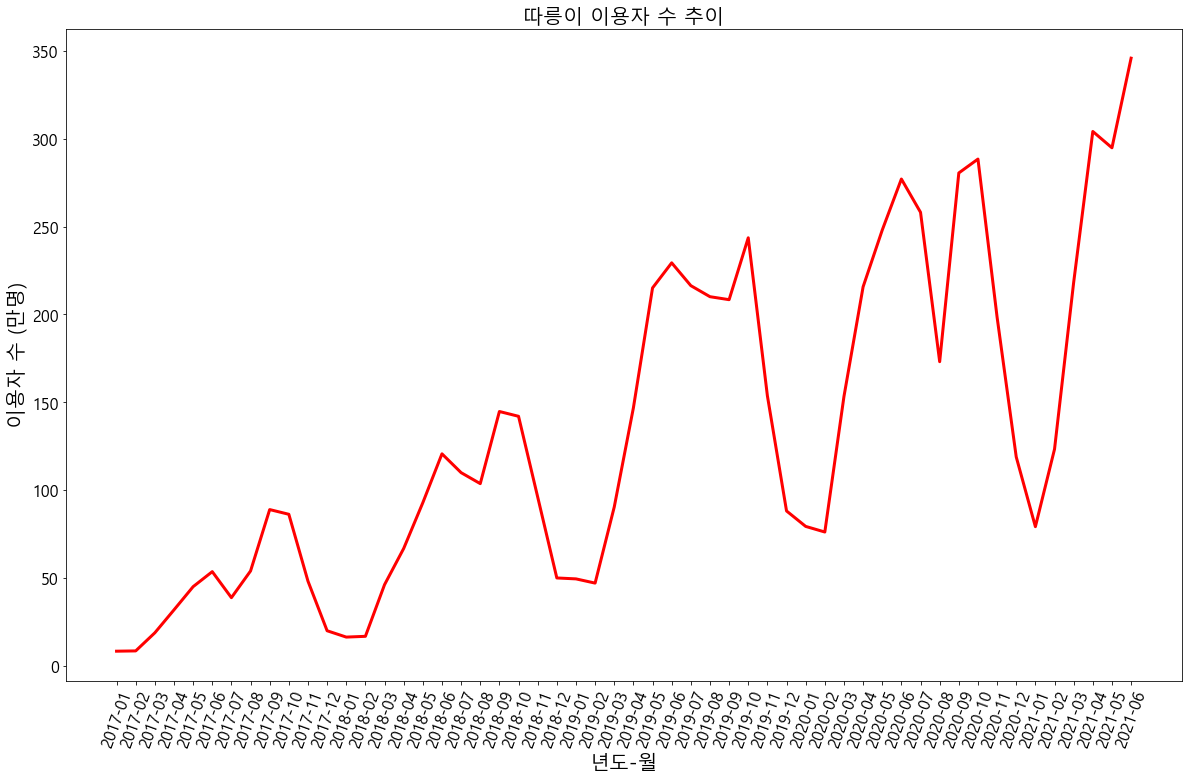

In [14]:
plt.figure(figsize=(20, 12), facecolor='white')
plt.xlabel('년도-월', fontsize=20)
plt.ylabel('이용자 수 (만명)', fontsize=20)
plt.xticks(fontsize = 16, rotation = 70)
plt.yticks(fontsize = 16)
plt.title('따릉이 이용자 수 추이', fontsize=20)
plt.plot(record_date_list, count_by_ten_hundreds_list, color = 'red', linewidth = 3)
if save_flag:
    plt.savefig('1.따릉이-이용자-수-추이.png')
plt.show()

### [그래프 해석] 전체 이용자 수 
- 2017 이후 따릉이 이용자 수 꾸준히 상승하는 추세임 <br>
- 날씨영향으로 여름과 겨울에는 이용자 수가 감소함 <br>

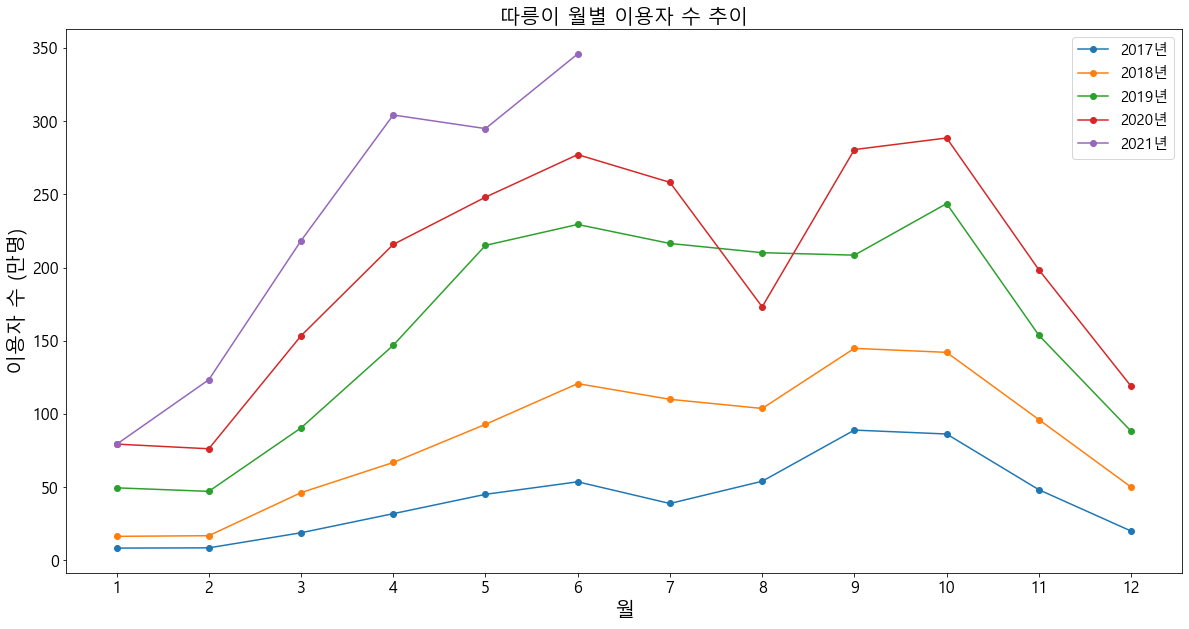

In [15]:
plt.figure(figsize=(20, 10), facecolor='white')
plt.xlabel('월', fontsize = 20)
plt.ylabel('이용자 수 (만명)', fontsize = 20)
plt.xticks(list(range(1, len(MONTHS)+1)), fontsize = 16)
plt.yticks(fontsize = 16)
# plt.ticklabel_format(style = 'sci', scilimits = (4, 4))
plt.title('따릉이 월별 이용자 수 추이', fontsize = 20)
for year in YEARS:
    tgt_rows = total_monthly_volume_df[total_monthly_volume_df['year'] == year]
    plt.plot(tgt_rows['month'].astype(int), tgt_rows['이용자수(만명)'], label='{}년'.format(year), marker='o')
plt.legend(prop={'size': 15})
if save_flag:
    plt.savefig('1.따릉이dd-월별-이용자-수-추이.png')
plt.show()

### [그래프 해석] 월별 이용자 수 
- 날씨가 좋은 봄과 가을에 이용자 수 증가함 <br>
- 전체 이용자 수 증가에 따라 여름에는 이용자 수 증가하였으나, 상대적으로 겨울에는 크게 증가하지 못함 <br>

### 1b) 따릉이 신규 가입자 트렌드 분석 (2017.01 ~ 2021.06)

* 신규 가입자 추이 및 누적 트렌드 분석
* 연령대별 신규 가입자 트렌드 분석
* 2018년과 2020년 연령대별 신규 가입자 비율의 변화 분석 (2018.06 ~ 2019.05 vs 2020.06 ~ 2021.05)

사용한 데이터: 서울특별시 공공자전거 신규가입자 정보(월별)  
출처: http://data.seoul.go.kr/dataList/OA-15241/S/1/datasetView.do

In [16]:
new_user_age_df = new_user_age_df_raw.fillna(0)
new_user_age_df['datetime'] = new_user_age_df['날짜'].apply(lambda x: datetime.strptime(x, '%y-%b'))
new_user_age_df['year'] = new_user_age_df['datetime'].apply(lambda x: x.year)
new_user_age_df['month'] = new_user_age_df['datetime'].apply(lambda x: x.month)
new_user_age_df

날짜    10대    20대    30대    40대   50대   60대   70대        기타   datetime  \
0   17-Jan    204   1716    760    472   180    46    14       0.0 2017-01-01   
1   17-Feb    365   2741   1137    616   220    41    28       0.0 2017-02-01   
2   17-Mar    727   9523   3871   2135   702   163   498       0.0 2017-03-01   
3   17-Apr   1409  20809   8473   3761  1219   256    94       0.0 2017-04-01   
4   17-May   2321  27635  11563   5425  1986   445   197       0.0 2017-05-01   
5   17-Jun   2148  26789  12866   6532  2417   516   185       0.0 2017-06-01   
6   17-Jul   1330  13761   6086   3472  1616   347   109       0.0 2017-07-01   
7   17-Aug   1866  20289   8361   4482  1881   425   137       0.0 2017-08-01   
8   17-Sep   3122  40093  16072   7673  2985   632   227       0.0 2017-09-01   
9   17-Oct   3130  32100  15500   9021  3454   710   267       0.0 2017-10-01   
10  17-Nov    928   6690   3541   2372   927   197    61       0.0 2017-11-01   
11  17-Dec    462   2164   1072    766   367    82    15       0.0 2017-12-01   
12  18-Jan    211   2128   1038    714   341   101    19       0.0 2018-01-01   
13  18-Feb    348   3211   1434    893   432   114    30       0.0 2018-02-01   
14  18-Mar   1036  15601   6272   3652  1685   403   101       0.0 2018-03-01   
15  18-Apr   1633  26294  11410   5594  2452   517   146       0.0 2018-04-01   
16  18-May   2641  33669  15101   7398  2945   615   188       0.0 2018-05-01   
17  18-Jun   1940  13434  11504   5408  2178   465     0   28770.0 2018-06-01   
18  18-Jul   6776  39365  11434   5967  2375   469    98       0.0 2018-07-01   
19  18-Aug   6016  34267   9145   4922  1962   377    79       0.0 2018-08-01   
20  18-Sep  10405  68603  19645  10497  4094   753   136       0.0 2018-09-01   
21  18-Oct   7724  41954  15213   8866  3222   587   112       0.0 2018-10-01   
22  18-Nov   4251  15466   5375   3373  1410   315    51       0.0 2018-11-01   
23  18-Dec   2206   5595   2077   1249   495   134    20       0.0 2018-12-01   
24  19-Jan   1701   6783   2261   1440   691   178    30       0.0 2019-01-01   
25  19-Feb   2287  10455   3091   1982   955   197    27       0.0 2019-02-01   
26  19-Mar   3982  24424   7877   4972  2011   433    71       0.0 2019-03-01   
27  19-Apr   6960  52167  17630   9336  3573   788   109       0.0 2019-04-01   
28  19-May  14531  78615  24245  12825  5327  1010   167       0.0 2019-05-01   
29  19-Jun      0      0      0      0     0     0     0  107798.0 2019-06-01   
30  19-Jul      0      0      0      0     0     0     0   79457.0 2019-07-01   
31  19-Aug      0      0      1      0     0     0     0   73897.0 2019-08-01   
32  19-Sep      0      0      0      0     0     0     0   91846.0 2019-09-01   
33  19-Oct  10507  34774  17275  10145  4052   791  6535      12.0 2019-10-01   
34  19-Nov   6301  14995   7513   4950  2197   478    63      18.0 2019-11-01   
35  19-Dec   3828   5950   2860   1884   839   219    34      13.0 2019-12-01   
36  20-Jan   2614   6637   2950   1931   978   249    38      10.0 2020-01-01   
37  20-Feb   3095   9845   3893   2630  1334   325    47      77.0 2020-02-01   
38  20-Mar  13401  50186  17534  12007  5559  1139   158      62.0 2020-03-01   
39  20-Apr  15535  62048  26319  17802  7714  1687   231     120.0 2020-04-01   
40  20-May  13925  60123  26495  16850  7371  1612   244     915.0 2020-05-01   
41  20-Jun  10979  45667  22320  13680  6512  1586   194    9243.0 2020-06-01   
42  20-Jul  10528  43606  17855  12134  6036  1463   172   58985.0 2020-07-01   
43  20-Aug   5760  19016   8422   5568  2940   821   109   37899.0 2020-08-01   
44  20-Sep  12928  45945  21361  14053  7052  1626   223   66309.0 2020-09-01   
45  20-Oct  10217  33676  17828  13151  6508  1545   209  105735.0 2020-10-01   
46  20-Nov   5270  13896   6614   4536  2377   674    96   31570.0 2020-11-01   
47  20-Dec   4504   6326   3685   3064  1735   573    78    4823.0 2020-12-01   
48  21-Jan   2458   5756   2991   2197 

In [17]:
## 전체 연령 (기타 포함) 신규 및 누적 가입자 계산
tgt_ages = ['10대', '20대', '30대', '40대', '50대', '60대', '70대', '기타']
new_user_by_month_cumsum = new_user_age_df[tgt_ages].cumsum().sum(axis=1)
new_user_by_month = new_user_age_df[tgt_ages].sum(axis=1)
datetime_str = new_user_age_df['datetime'].apply(lambda x: x.strftime('%Y-%m'))

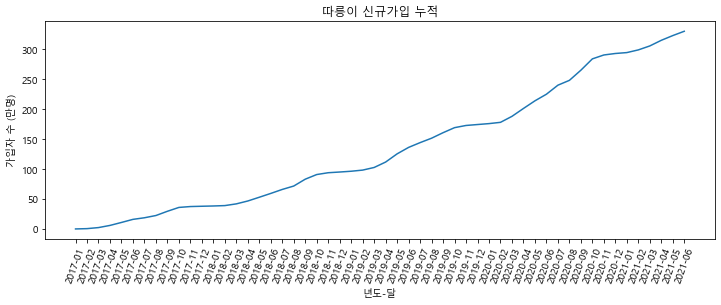

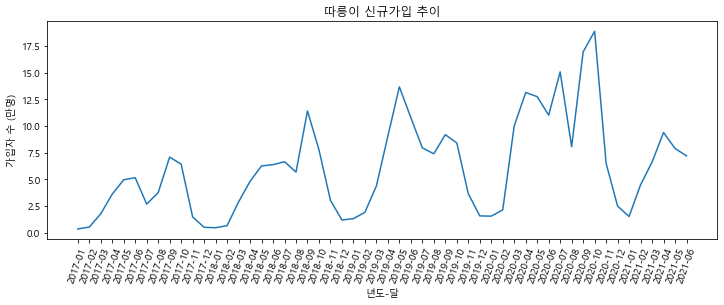

In [18]:
## 신규 가입자 누적
plt.figure(figsize=(12, 4))
plt.plot(datetime_str, new_user_by_month_cumsum / 1e4)
plt.title("따릉이 신규가입 누적")
plt.xticks(rotation=70)
plt.xlabel("년도-달")
plt.ylabel("가입자 수 (만명)")
if save_flag:
    plt.savefig("1.따릉이 신규가입 누적.png")
plt.show()

## 신규 가입자 추이
plt.figure(figsize=(12,4))
plt.plot(datetime_str, new_user_by_month / 1e4)
plt.title("따릉이 신규가입 추이")
plt.xticks(rotation=70)
plt.xlabel("년도-달")
plt.ylabel("가입자 수 (만명)")
if save_flag:
    plt.savefig("1.따릉이 신규가입 추이.png")
plt.show()

### [그래프 해석] 신규 가입자 수 
- 신규가입자 꾸준히 상승하는 중 <br>
- 코로나 영향으로 인해 2020년 성장세가 이전보다 더 가파름  <br>

In [19]:
## 연령대별 가입자 누적 계산
tgt_ages = ['10대', '20대', '30대', '40대', '50대', '60대', '70대']
datetime_str = new_user_age_df['datetime'].apply(lambda x: x.strftime('%Y-%m'))
df_cumsum_age = new_user_age_df[tgt_ages].cumsum()

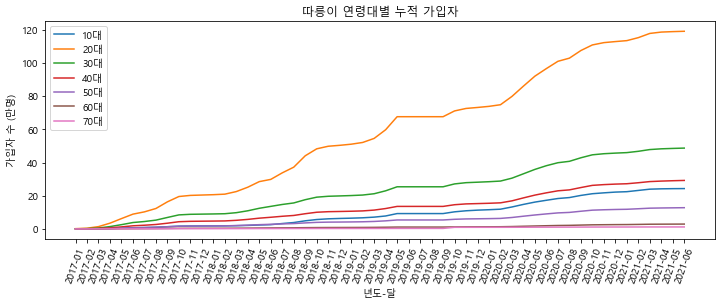

In [20]:
plt.figure(figsize=(12,4))
for tgt_age in tgt_ages:
    ys = df_cumsum_age[tgt_age].values / 1e4
    plt.plot(datetime_str, ys, label=tgt_age)
plt.title("따릉이 연령대별 누적 가입자")
plt.xticks(rotation=70)
plt.xlabel("년도-달")
plt.ylabel("가입자 수 (만명)")
plt.legend()
if save_flag:
    plt.savefig("1.따릉이 연령대별 누적 가입자.png")
plt.show()

### [그래프 해석] 연령대별 누적 가입자 
- 성장하는 속도는 다르지만 누적 가입자 순위는 매년 다음을 유지함: 20대> 30대>40대>10대> 50대> 60대> 70대

In [21]:
## 2018년과 2020년 연령대별 가입자수 비율 계산
tgt_ages = ['10대', '20대', '30대', '40대', '50대', '60대', '70대']
datetime_2018_06, datetime_2019_05 = datetime(2018, 6, 1), datetime(2019, 5, 1)
datetime_2020_06, datetime_2021_05 = datetime(2020, 6, 1), datetime(2021, 5, 1)
mask_2018_19 = (new_user_age_df['datetime'] >= datetime_2018_06) & (new_user_age_df['datetime'] <= datetime_2019_05)
mask_2020_21 = (new_user_age_df['datetime'] >= datetime_2020_06) & (new_user_age_df['datetime'] <= datetime_2021_05)
new_user_age_18_19_df = new_user_age_df.loc[mask_2018_19, tgt_ages]
new_user_age_20_21_df = new_user_age_df.loc[mask_2020_21, tgt_ages]
new_user_age_18_19_dict = dict(new_user_age_18_19_df.sum())
new_user_age_20_21_dict = dict(new_user_age_20_21_df.sum())

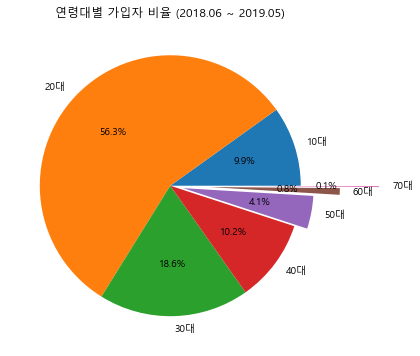

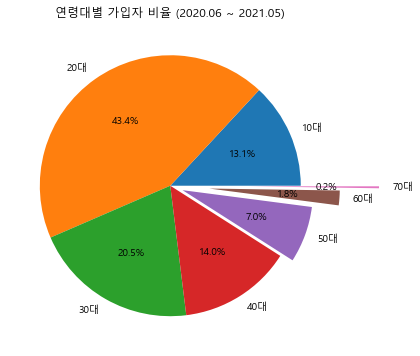

In [60]:
explode = (0, 0, 0, 0, 0.1, 0.3, 0.6)

plt.figure(figsize=(6, 6))
plt.pie(new_user_age_18_19_dict.values(), labels=new_user_age_18_19_dict.keys(), autopct='%0.1f%%', explode=explode)
plt.title('연령대별 가입자 비율 (2018.06 ~ 2019.05)')
if save_flag:
    plt.savefig("1.연령대별 가입자 비율 (2018.06 ~ 2019.05).png")
plt.show()

plt.figure(figsize=(6, 6))
plt.pie(new_user_age_20_21_dict.values(), labels=new_user_age_20_21_dict.keys(), autopct='%0.1f%%', explode=explode)
plt.title('연령대별 가입자 비율 (2020.06 ~ 2021.05)')
if save_flag:
    plt.savefig("1.연령대별 가입자 비율 (2020.06 ~ 2021.05).png")
plt.show()

### [그래프 해석] 연령대별 신규 가입자 비율
•	따릉이의 가장 큰 사용자인 2030 세대의 비중이 2016년 74.9%에서 2019년 63.9%로 감소함 <br> 
•	2019년 4050세대의 가입비중이 2016년대비 1.5배 증가함 (2016년: 14.2%, 2019년: 21.1%) <br>
•	20대에 과도하게 치중되어 있던 가입자 수가 시간이 지남에 따라 비교적 고루 분포되는 추세임 


## 2. 서울시 자전거 이용 인프라 현황 분석 (2021년 6월)

### 2a) 따릉이 대여소 현황

* LCD vs QR 거치대 지도 시각화
* 자치구별 대여소 개수 지도 시각화

사용한 데이터: 서울특별시 공공자전거 대여소 정보  
출처: http://data.seoul.go.kr/dataList/OA-13252/F/1/datasetView.do

In [23]:
bike_stations_june = bike_stations_june_raw.copy()
bike_stations_june

대여소 번호     보관소(대여소)명 소재지(자치구)               상세주소         위도          경도  \
0        102    망원역 1번출구 앞      마포구  서울특별시 마포구 월드컵로 72  37.555649  126.910629   
1        103    망원역 2번출구 앞      마포구  서울특별시 마포구 월드컵로 79  37.554951  126.910835   
2        104    합정역 1번출구 앞      마포구   서울특별시 마포구 양화로 59  37.550629  126.914986   
3        105    합정역 5번출구 앞      마포구   서울특별시 마포구 양화로 48  37.550007  126.914825   
4        106    합정역 7번출구 앞      마포구    서울특별시 마포구 독막로 4  37.548645  126.912826   
...      ...           ...      ...                ...        ...         ...   
2462    4864         송파사거리      송파구       송파구 송파동 97-2  37.502056  127.110550   
2463    4865  한성백제역 1번출구 뒤      송파구       송파구 방이동 45-4  37.516342  127.115593   
2464    4867     가락대림아파트 앞      송파구       송파구 가락동 94-9  37.500027  127.118431   
2465    4868      레이크 호텔 앞      송파구        송파구 석촌동 158  37.507172  127.101242   
2466    4869        잠실나들목6      송파구             잠실동 24  37.516296  127.084610   

          설치 시기 운영 방식  거치대수  
0    2015-09-06   LCD    20  
1    2015-09-06   LCD    14  
2    2015-09-06   LCD    13  
3    2015-09-06   LCD     5  
4    2015-09-06   LCD    10  
...         ...   ...   ...  
2462 2021-04-27    QR     6  
2463 2021-04-28    QR     5  
2464 2021-04-28    QR    10  
2465 2021-05-18    QR     7  
2466 2021-06-21    QR     9  

[2467 rows x 9 columns]

In [24]:
## LCD vs QR 대여소 지도 시각화
color_list = ['#e3cf0e', '#00a324']
bike_holder_map = folium.Map(location = [37.554648, 126.972559], zoom_start = 11, tiles = 'CartoDB positron')
for idx in bike_stations_june.index:
    lat = float(bike_stations_june.loc[idx, '위도'])
    lng = float(bike_stations_june.loc[idx, '경도'])
    r = float(bike_stations_june.loc[idx, '거치대수'])
    fillColor = color_list[0] if bike_stations_june.loc[idx, '운영 방식'] == 'LCD' else color_list[1]
    folium.CircleMarker([lat, lng], color = fillColor, fill_color = fillColor, radius = r/3, fill_opacity = 0.8, weight = 1).add_to(bike_holder_map)        

In [25]:
if save_flag:
    bike_holder_map.save('2.2021년-6월-자치구별-거치대수-bubble.html')
bike_holder_map

### [지도 해석] 따릉이 대여소 현황
•	QR대여소와 LCD 대여소 고르게 분포되어 있음 

In [26]:
## 자치구별 대여소 개수
bike_stations_june_group_by_zone = bike_stations_june.groupby('소재지(자치구)').agg({'대여소 번호': 'count'})
bike_stations_june_group_by_zone['자치구'] = bike_stations_june_group_by_zone.index
bike_stations_june_group_by_zone.head(5)

대여소 번호  자치구
소재지(자치구)             
강남구          145  강남구
강동구          111  강동구
강북구           60  강북구
강서구          162  강서구
관악구           71  관악구

In [27]:
## 자치구별 대여소 지도 시각화
state_geo = 'https://raw.githubusercontent.com/southkorea/seoul-maps/master/kostat/2013/json/seoul_municipalities_geo_simple.json'
bike_holder_map_2 = folium.Map(location=[37.562225, 126.978555], tiles="OpenStreetMap", zoom_start=11)
folium.Choropleth(
    geo_data=state_geo,
    name='자치구 별 대여소 수',
    data=bike_stations_june_group_by_zone,
    columns=('자치구', '대여소 번호'),
    key_on='feature.properties.name',
    fill_color='Greens',
    fill_opacity = 1,
    line_opacity = 1,
    color = 'black',
    legend_name = '대여소 수'
).add_to(bike_holder_map_2)
label_seoul_zones(bike_holder_map_2)


In [28]:
if save_flag:
    bike_holder_map_2.save('2.2021년-6월-자치구별-거치대수.html')
bike_holder_map_2

### [지도 해석] 따릉이 대여소 현황
•	강서구와 송파구에 대여소가 가장 밀집되어있음  <br>
•	도봉구, 강복구, 성북구, 중랑구, 동작구,관악구 그리고 금천구가 다른 지역대비 밀집도가 낮음



## 3. 따릉이 이용자의 행동 패턴 분석

### 3a) 따릉이 이용 루트 분석 (2020년 1월)

* 따릉이 이용 구간별 월 사용량
* 따릉이 이용 루트 지도 시각화

사용한 데이터: 서울특별시 공공자전거 대여이력 정보  
출처: http://data.seoul.go.kr/dataList/OA-15182/F/1/datasetView.do

서울특별시 공공자전거 대여소 정보  
출처: http://data.seoul.go.kr/dataList/OA-13252/F/1/datasetView.do

In [29]:
station_id_table = station_loc_df[['대여소 번호']].reset_index()
src_transaction = dfs_year_group['2020'][0]['대여 대여소번호'].reset_index().rename(columns={'index':'tid'})
tgt_transaction = dfs_year_group['2020'][0]['반납대여소번호'].reset_index().rename(columns={'index':'tid'})
src_station_id = station_id_table.rename(columns= {'대여소 번호': '대여 대여소번호'})
tgt_station_id = station_id_table.rename(columns= {'대여소 번호': '반납대여소번호'})
src_transaction_w_idx = pd.merge(src_transaction, src_station_id, on='대여 대여소번호', how='left').rename(columns={'index': 'start_idx'})
tgt_transaction_w_idx = pd.merge(tgt_transaction, tgt_station_id, on='반납대여소번호', how='left').rename(columns={'index':'end_idx'})
transaction_w_idx = pd.merge(src_transaction_w_idx, tgt_transaction_w_idx, on='tid', how='left')
transaction_w_idx

tid  대여 대여소번호  start_idx  반납대여소번호  end_idx
0            0       429        285      372      236
1            1       429        285      372      236
2            2       429        285      372      236
3            3       429        285      372      236
4            4       429        285      372      236
...        ...       ...        ...      ...      ...
739812  739812      1646       1180     1680     1209
739813  739813      1646       1180     1680     1209
739814  739814      1646       1180     1680     1209
739815  739815      1646       1180     1680     1209
739816  739816      1680       1209     1680     1209

[739817 rows x 5 columns]

In [30]:
## rename columns for differentiating src and tgt
src_station_name_df = station_loc_df[['보관소(대여소)명']].reset_index().rename(columns={'index':'start_idx', '보관소(대여소)명':'대여소'})
tgt_station_name_df = station_loc_df[['보관소(대여소)명']].reset_index().rename(columns={'index':'end_idx', '보관소(대여소)명':'반납소'})
num_stations = len(station_id_table)
bicycle_matrix = np.zeros([num_stations, num_stations])
count_matrix_df = transaction_w_idx.groupby(['start_idx', 'end_idx']).size().reset_index().rename(columns={0:'count'})
count_matrix_w_name_df = pd.merge(count_matrix_df, src_station_name_df, on='start_idx', how='left')
count_matrix_w_name_df = pd.merge(count_matrix_w_name_df, tgt_station_name_df, on='end_idx', how='left')
count_matrix_w_name_df[['대여소', '반납소', 'count']].sort_values('count', ascending=False).head(10)

대여소                반납소  count
8711    여의나루역 1번출구 앞       여의나루역 1번출구 앞    438
32959          자양나들목      뚝섬유원지역 1번출구 앞    430
6935   하늘채코오롱아파트 건너편       홍대입구역 2번출구 앞    403
94453        봉림교 교통섬               동방1교    387
34644     성수역 2번출구 앞          성동세무서 건너편    361
36825        자양중앙나들목      뚝섬유원지역 1번출구 앞    354
97661           동방1교            봉림교 교통섬    352
40467       장안동위더스빌옆  장한평역 1번출구 (국민은행앞)    323
36503        성수역3번출구        이마트 버스정류소 옆    318
91830     장승배기역 5번출구          노량진역 5번출구    309

In [83]:
bicycle_matrix[count_matrix_df['start_idx'], count_matrix_df['end_idx']] = count_matrix_df['count']
print(bicycle_matrix.shape)
bicycle_matrix

(2466, 2466)


array([[110.,  12.,  23., ...,   0.,   0.,   0.],
       [ 15.,  50.,  21., ...,   0.,   0.,   0.],
       [ 49.,  32.,  35., ...,   0.,   0.,   0.],
       ...,
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.]])

In [32]:
mask0 = bicycle_matrix == 0
maskA = (bicycle_matrix > 0) & (bicycle_matrix < 5)
maskB = (bicycle_matrix >= 5) & (bicycle_matrix < 10)
maskC = (bicycle_matrix >= 10) & (bicycle_matrix < 50)
maskD = (bicycle_matrix >= 50) & (bicycle_matrix < 100)
maskE = (bicycle_matrix >= 100)
labels = ['1~5', '5~10', '10~50', '50~100','100~']
colors = ['lightgrey', 'silver', 'grey', 'black', 'red']
counts = [m.sum() for m in [maskA, maskB, maskC, maskD, maskE]]
bicycle_matrix_label = np.empty_like(bicycle_matrix, dtype='<U10')
bicycle_matrix_label[mask0] = 'white'
bicycle_matrix_label[maskA] = colors[0]
bicycle_matrix_label[maskB] = colors[1]
bicycle_matrix_label[maskC] = colors[2]
bicycle_matrix_label[maskD] = colors[3]
bicycle_matrix_label[maskE] = colors[4]

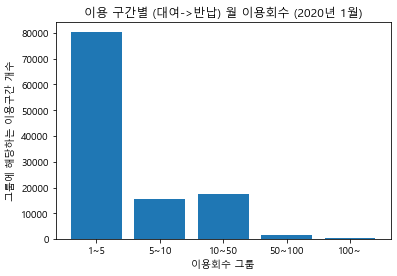

In [33]:
## 따릉이 이용 구간별 월 사용량
counts = [maskA.sum(), maskB.sum(), maskC.sum(), maskD.sum(), maskE.sum()]
plt.bar(labels, counts)
plt.xlabel("이용회수 그룹")
plt.ylabel("그룹에 해당하는 이용구간 개수")
plt.title('이용 구간별 (대여->반납) 월 이용회수 (2020년 1월)')
if save_flag:
    plt.savefig('3.이용구간별 (대여-반납) 월 이용회수 (2020년 1월).png')
plt.show()

In [85]:
tgt_mask_list = [maskA, maskB, maskC, maskD, maskE]
node_pos = np.array([station_loc_df['위도'], station_loc_df['경도']]).T

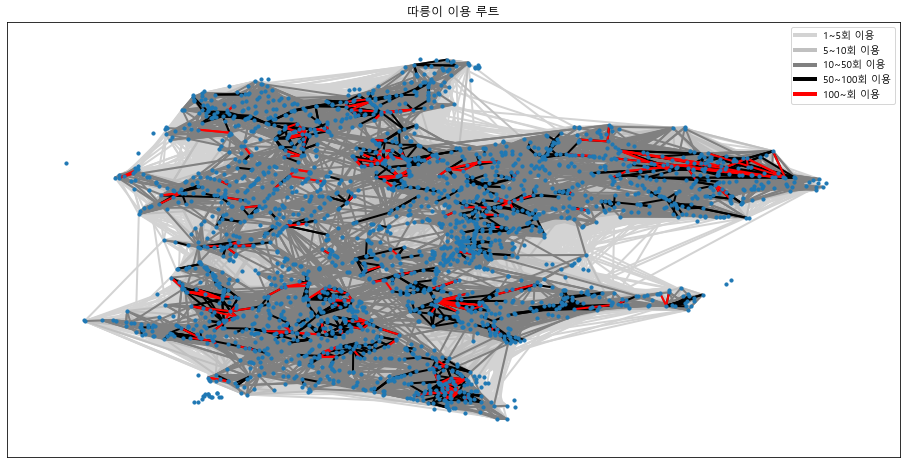

In [107]:
# ## 따릉이 이용 루트 시각화
plt.figure(figsize=(16, 8), frameon=False)
g = nx.Graph()
g.add_nodes_from(list(range(bicycle_matrix.shape[0])))
_ = nx.draw_networkx_nodes(g, node_pos, node_size=10)

for idx, tgt_mask in enumerate(tgt_mask_list):
    edgelist = np.array(np.nonzero(tgt_mask)).T
    _ = nx.draw_networkx_edges(g, pos=node_pos, edgelist=edgelist, width=2, edge_color=colors[idx])

legend_elements = [
    Line2D([0], [0], color='lightgrey', lw=4, label='1~5회 이용'),
    Line2D([0], [0], color='silver', lw=4, label='5~10회 이용'),
    Line2D([0], [0], color='grey', lw=4, label='10~50회 이용'),
    Line2D([0], [0], color='black', lw=4, label='50~100회 이용'),
    Line2D([0], [0], color='red', lw=4, label='100~회 이용')
]
plt.legend(handles=legend_elements)
plt.title("따릉이 이용 루트")
plt.show()
# plt.close()

In [106]:
## 따릉이 이용 루트 지도 시각화
## 10회 미만 이용구간들은 가독성을 위해서 생략함
edge_colors = ['lightgrey', 'grey', 'black']
node_color = 'blue'

## initial location of seoul
seoul_lon, seoul_lat = (127.0, 37.55)
bicycle_trace_map = folium.Map(
    location=(seoul_lat, seoul_lon),
    zoom_start=11,
    tiles='OpenStreetMap',
#     tiles='Cartodb Positron',
)

## marker
mark_cluster_group = folium.plugins.MarkerCluster(control=False)
bicycle_trace_map.add_child(mark_cluster_group)
g1 = folium.plugins.FeatureGroupSubGroup(mark_cluster_group, '10~50 회 이용구간 (연회색)')
bicycle_trace_map.add_child(g1)
g2 = folium.plugins.FeatureGroupSubGroup(mark_cluster_group, '50~100 회 이용구간 (진회색)')
bicycle_trace_map.add_child(g2)
g3 = folium.plugins.FeatureGroupSubGroup(mark_cluster_group, '100~ 회 이용구간 (검은색)')
bicycle_trace_map.add_child(g3)

## draw stations as node - 가독성을 위해 노드는 생략했습니다.
# for i in range(len(node_pos)):
#     folium.CircleMarker(
#         location=tuple(node_pos[i]),
#         radius=1,
#         color=node_color,
#     ).add_to(bicycle_trace_map)
# print("Draw Nodes")

## draw route as edge
idx_offset = 2
marker_group = [g1, g2, g3]
for idx, tgt_mask in enumerate(tgt_mask_list[idx_offset:]):
    edgelist = np.array(np.nonzero(tgt_mask)).T
    src2dst_loc = node_pos[edgelist, :]
    weight = 0.5 * (idx+1)
    fillOpacity = 0.3 * (idx+1)
    for tgt_edge in node_pos[edgelist, :]:
        folium.PolyLine(locations=tgt_edge, weight=weight, fillOpacity=fillOpacity, color=edge_colors[idx]).add_to(marker_group[idx])
    print("Draw Edge of group {}".format(idx))
folium.LayerControl(collapsed=False).add_to(bicycle_trace_map)

Draw Edge of group 0
Draw Edge of group 1
Draw Edge of group 2


#### 아래 지도는 제한된 용량으로 인해 캡처된 이미지로 대체하였습니다. 
#### Interactive 한 지도는 [링크](https://hkustconnect-my.sharepoint.com/:u:/g/personal/jhyunaa_connect_ust_hk/EcHAd7wFQKFLqSU2bKlH6tABd87NskjHWXec6KB8hmLf_A?e=OfjHS8)   로 대체합니다. 파일을 다운로드 받아서 봐주시면 감사하겠습니다.


In [79]:
if save_flag:
    bicycle_trace_map.save('3.자전거 이용 루트 지도 with 인근 지역 정보(10회 이상 이용구간).html')
# bicycle_trace_map

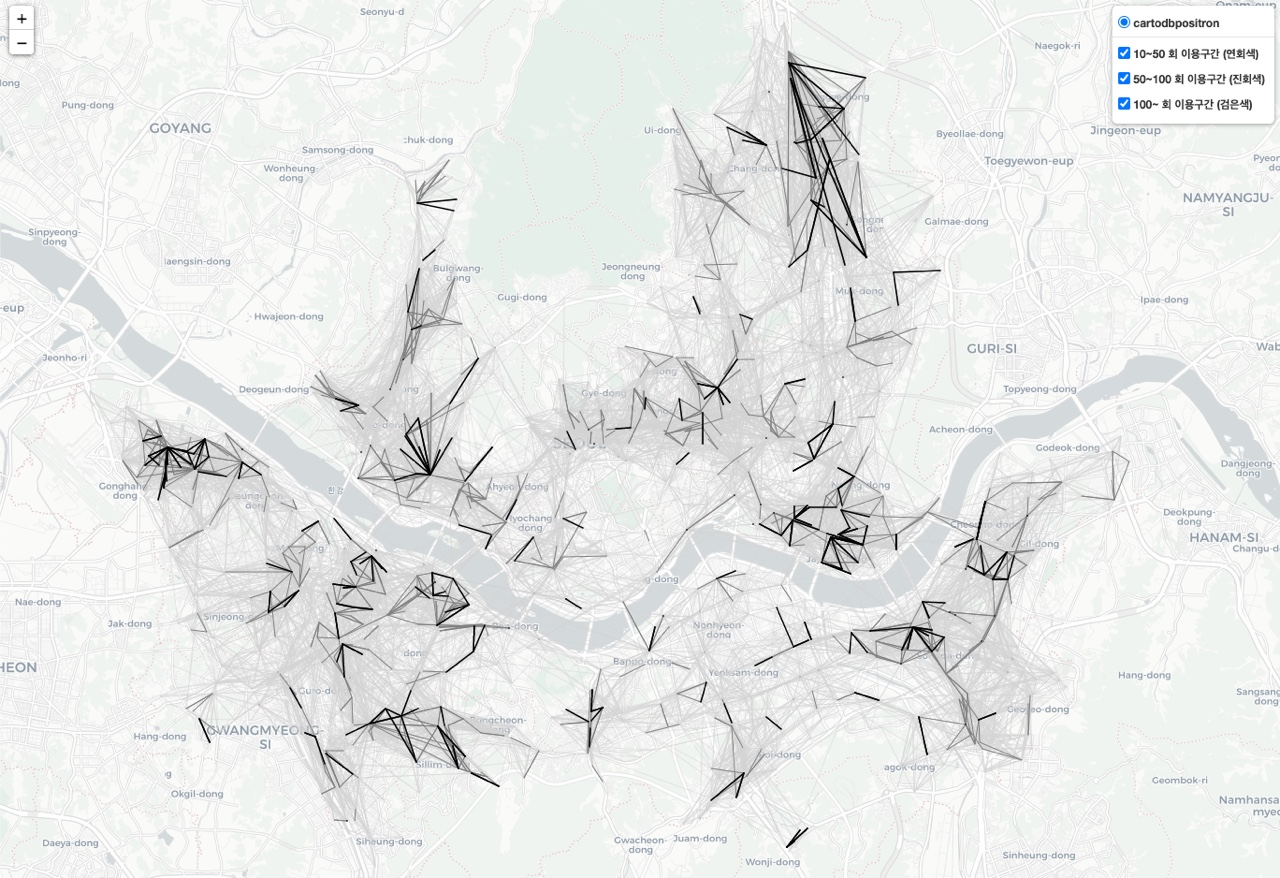

In [14]:
base64_data = "/9j/4AAQSkZJRgABAQAASABIAAD/4QBYRXhpZgAATU0AKgAAAAgAAgESAAMAAAABAAEAAIdpAAQAAAABAAAAJgAAAAAAA6ABAAMAAAABAAEAAKACAAQAAAABAAAFAKADAAQAAAABAAADbgAAAAD/7QA4UGhvdG9zaG9wIDMuMAA4QklNBAQAAAAAAAA4QklNBCUAAAAAABDUHYzZjwCyBOmACZjs+EJ+/8AAEQgDbgUAAwEiAAIRAQMRAf/EAB8AAAEFAQEBAQEBAAAAAAAAAAABAgMEBQYHCAkKC//EALUQAAIBAwMCBAMFBQQEAAABfQECAwAEEQUSITFBBhNRYQcicRQygZGhCCNCscEVUtHwJDNicoIJChYXGBkaJSYnKCkqNDU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6g4SFhoeIiYqSk5SVlpeYmZqio6Slpqeoqaqys7S1tre4ubrCw8TFxsfIycrS09TV1tfY2drh4uPk5ebn6Onq8fLz9PX29/j5+v/EAB8BAAMBAQEBAQEBAQEAAAAAAAABAgMEBQYHCAkKC//EALURAAIBAgQEAwQHBQQEAAECdwABAgMRBAUhMQYSQVEHYXETIjKBCBRCkaGxwQkjM1LwFWJy0QoWJDThJfEXGBkaJicoKSo1Njc4OTpDREVGR0hJSlNUVVZXWFlaY2RlZmdoaWpzdHV2d3h5eoKDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uLj5OXm5+jp6vLz9PX29/j5+v/bAEMAAQEBAQEBAgEBAgMCAgIDBAMDAwMEBQQEBAQEBQYFBQUFBQUGBgYGBgYGBgcHBwcHBwgICAgICQkJCQkJCQkJCf/bAEMBAQEBAgICBAICBAkGBQYJCQkJCQkJCQkJCQkJCQkJCQkJCQkJCQkJCQkJCQkJCQkJCQkJCQkJCQkJCQkJCQkJCf/dAAQAUP/aAAwDAQACEQMRAD8A/uY8RT/Ybj7bNKvyJvITG4eUwf3z8u7tXPRajrXiTT3vvC+mNqFsSVDSSKiyY7qHKgjPcVX+IVs2k+F7u4e4aJtrbdhEefbCgZ+nWu0+B073Pwg8OXDggvYxE7uDyO+aSdwOGsE+NVsrOmjwgyfeElzGWBBIDfKSCWXG7kcj3oisvixcSvJf6UFJIxiSEpkchyvmMWx2HHPOK7/4lfGb4a/CCXQYPiLqY01/E+qQ6LpgMU0vn31wGMUP7pH2bgp+Z9qDHLCvT6LAfOFv4nXWb7UbWCQJPJJ5G2QlJI2UbNvzgAndk8HnNdPCPs99NDcjYjSFQy8qQPlQZGQOAMZ54rxfSbyab44eKLFzlE1CDA/7YQsP/Hq9RH2T+zoYrd0M0kMoPI3HMbPkgc8MopbkqVzop7Xyl3qcj361UrppdOM1uzBtzH5l7cVyshkjYHGQOCO9YnNVhZ6EmMdaKJb1JzGnoNuR/X3oHPFBm1YkkCR26zSEjDluOmERix/DoPciuxsI5IbGGGUYZI1Bx6gDNYetog0hJbr5VQMH29djoyNj6A7vfFbdhcPc24aUASKSj46blOCR7HqPaqex2xVlYg1OG4ljVrfqhzx1rlpDKx8yTJJPU+td5WZLDNbWzCHMjkkjpxmpIqU76mTpNtK9ws+MKuef0xT4ZrVr6Q3aZJbA9PStLSY5Y7YiVSp3HGetZGqWwiuNyhsOfzPoKCeW0VY6YtDvJONyj8QKgEs8/MACr/ebv9B/9cVStNKEQ3zOzFgNy8Y+nrWzTN0cbeSE6uv2lw6xsi5AxjaDKwxk9SI/zp1zqNxdZQnah7CqbhJLuWeUEkGXGOxMmzJ/CMCo6cjnrSexozag7W620JIUDBPQmtrR1C2e71JrAhvCiiOVFkUdAf8AGuttijQK0a7FI4FSOnq73J6KKKDcKxb6xihEt7bSGB3Hz4AZJO2HQ8N6Z4PvW1VW9Cm1csNwAzg+1NOwmciJksABFYW2/bgPbtswD14ZcL+GfrV1bO4lj8wadCGYA7xOySH6tGqsfzrPiMO4mYEj0FdtAweBGAwCBVe0ZFOdzlWg1K2+5HdRAf8APKVJ0/KUeYfwNJ/a15CP3tyFH/TW2kQj64JH412FZ2rSiOwdOrSfIoHdm4H/AOuhSNDhZpW/tOe1WTJvNw2JFIwZkGyQgnaMEEZ9xnmp5Cn2uOVGLi4t0O4jBLwkxyEjsc44qBdPkiUeJpSSxvI2i/2YXcx/r5hY/wD1qu6lDJDI6jGbWZpsf9MJh8xH+7Jkt7YrSWxnJXTQ2tjT9P8AOZZ2IKjkis2S3miAaRSAeh7H8a2V1u2trNRgGRV+7uCgAfxMx4C+/r0BrBIxpR11Mu9gkt5ykh3E85p2nCM3aiQ4z0PTmoZzqGqN58UbEZIzHGAOO2ZJFJ+u0ZpkdyDG0bgb8AqQCOASDwScEEYOCQeoNU4tDcLPmO6Khl2t8w96hjtbeKTzY0CseOKwrHUxDtgdcL3bvz3rpCyhdxPHWpN4tPUzr17RnSOZvmByB2/GuUdSrlW6g0+4mM87TH+I/pTBI6oYweG60HLOdx7zM8SxN/BnB9jQZi0XlsAcdD3A9KhpRgnB4oIuOjkaJxIuMj15rbt9ZwhW5XPpisi8jiTa1nIGBHIIOc1WhLTSCHG1z0BOM/Q9KZpFyWiOjt4rTi9tByvVPQd8D1FTSwymcXcQZoYwGIJ6n73yk9MYH4VmWdvPHdLIhUhD8xDAgDvnFfAUUPxH8HeJvE+qfD7RNQ1XU7m3v50vdRtLi3uLeSSVWWAs7PaXgIJEAiBIAAIIOK6cPQ5762KlWcd0fboLzT28kgwTG9wfrO2B/wCOKtaS28zxGZVJUcE18aDxT8bzpkUuqS6rbWD/AGow3dnpclzftLEifZoJ4ZbOFliLFvn8hVPQuAM10ker/tFM82u3U1zYtbXuiQHTYbNHgeO7gtxqDiTYzssEkjtuRtqFTuPHG0sE7/EjGVVSd7M+r7W/ls0KRgHJzzWxp7C9f7TNH86fxDoa+J9E+IHxiuI4fE+pRz3um6RrEOkXw0+2FzJdRRR3Anu0SFWZlaRoQdgO3aeOtek6R4o+O9x8ErnxHp+n7dX8vU3igu4WjvVdbudbUCA4Q/uBGQD97g5OcnOeClHdoqlV1PpGTUrOWU20y5ToSa564EAmItySnvXzj8HIvEU3jfxVq2rPql1a3AsFtrvVLNrGSYJbgPiNo4vutkE7AfX1r3jUCpjSGUjy5n8tlKM+8MOV4+79TwPasK1PklylQk6jsS2ZYw5bzeWY4m+8Mk8fQdvar7wuiCXqp7ioVVUUIowAMAewrWtr/cPs9580bDGe4rIG1KTZajkWx00zW7+Y5YbVH8TEgBfx6Vzel2Fv4hupzc/vLaF/nx9yWXrt90jzj/aJyeKTVUkg86FWyqKQpB/vqWY+xEakA9t9dV4ZtIrPRLaKM5GxS3ux+8cfWtVorm8ew2aRbJ2mt+FQeWi/w5OCcegGAMdKrzrDfxi63qjgfMDT7iAGzW5lOdq42/7ZPOfxrCrNmdSWtmFZ1/fi1KQQgPPMdsaZx+JPZR3NJqOpJYoERfMmk4RB39z6AdzXNKJopikeJr245Y9lHqfRR2HeqjG5FOnfVnpuyx8FwCaU/bNWulwuO/sP7kY7nv7msBI7ia5bUdRfzrmQYLdAo67UHZR+vU1BYWC2SlnYyzPjfI3VsfyA7CtClKVwnUvogoopruqKWYhQO7EAfiTUmaQ4kAhScFug7nHpUkcssRzGxHOeKzLa0j2NPJGYpZwS43lypdQGVW7DjtxmlMN1bxkWr7wsapGkh43L/Ez4LEkdc0G3JG9kzuNNaSfddMcBuNo6ZHercyJEWumlaJQMtjGOO/IPasa0tdYjgf7NJDGHZWQsrMduPmB+Yc+h/nWVqdzffapbaSUSqsg8tdoADYDYb1CAhuepKj1p2OpRtG7ZoeG4mzLLLywwuT1wcv8A+zc+9dHPPHbxmWToK4vSLmPTWW3nLn7zvcMFCtubAVsEHdyMHHNUdc15rx/ItGIjU9emaJMxr1lCN2Zuq6pc6hcMZDhAcBfQVk0UUj5+c3J3YUpOTnFJRQSmP4YY6GmUU4Dd060BuNooooEFFFFABRRRQBBc4MJj3RKZCEHnLuQ57Ed8jge9TgY+UDFROZFmjIaQKSwIRNynjjef4R6HueKloOippTivV/p+gpGDg9qSiig5yXfGI9qr83cmoqKKBt3CiiigRD5uyR/OeQ5IYvIw25Y4CJ3444PrU1LPve0KwBVkGdrsocBv4TtPBweahDusu2YYjJRQy/MxJB3ErxhQR696R2yh7Rcy36/5/wCZftJ3gmBTHJA5rphrM95M9hC4EaEpcYyjKHUkGMgfe5z14rh4bYzlRfYYvEYJUUt5bKzZJ2knnHGfSvSLKwSW2OGVRGAFGegAxz7YpnZg7Quou7/D/glHX9L+zaW89gAiJGFkcAM8sKqQEdm+fjOQQT09zWleiNr7WGv5fKiGCzdgoTg59jk8U1VS4srizdg7PEwDA54xjGO1FrbrqOrR6pPI67ra3l2BsI5ZCDuXvjPGatbHoqfNrI5Xw7LFP4vvgx2m/wBOWSPHUlvnc/gxNbWi6jrI8ORJ41gW+tJVBZ1+aSMdjIuOcf3l5Hf1rJ1Mx6V4lstZgbi2ufKfbzmK4ywB9AG3/kK2L7RHN1dW8eqS2irI3yK3QNz0z0Oa1b6kJGjq+lXVlo1peeECbtbeV5cbw7NHIGLBSepycjPP41jpeWd9m4s2JBPzBvvK3cEdiDS6M2oeFNJvNP0wpM8VxAyb87WWbCnPp909Kr+JdRstTnjns4mstUi/1quOq+hxw6nsw/SplG5NSF1YW8lEFnNOX8sIjNvxu24HXHfHXHeqcFpO0AlF3IzSukpbC4wByqqR8qt19R2NZ9hdvqVz5WpYhmgkDxohZcrtwc8kOM57DHcV0tYtGTlyLlRTjtpw6yTTM5SVpFAAUbSMBGHO4D9TUcVte2/lxpP5iKr7jKMuzE5Q5XaML0I28jvmtCiixHtpf0kZjWUt3GkOqCKWMKrMoU/61WyGBJ6D0I61p0UUEym3uFTwTtbtvUAnsSM4+lQc0UEp2M2L/Q7s2+AsUxLqzSEu8rElgFPQAcjBxWlWbqjx21i960iQCD94ZXTzAig5f5RzyuRkcjOe1aCsrqHQ5BGQR3FBrU1SmLS9qKKDEKOnSiigArNYrbzFv7p5/wByQ8Y9g/X6itKq88RfEiAF1yAG6MDwVPsw6/n2pouDV9SxRVe3cFdqZK7Qyk9dpyAG/wBoFSp9xnvVihomUbOwUUUUhBVVoJYrn+0NPkNvcj+NejAfwuOjL9enbFWqKExp22NGG4OvyG4tkW01q3XJUk+XOg7Z/iU9u6H26sE9rcRvcyhobe5byruM8NBMCAsnsVOAT6Ybsc02jmvDFHFN5MsR3Qyf3X/wPQ+orRup2vbd/EVpCftEK+TqFr/fUDkj1IHKn+JTj6ap31OyE7o5m2F1BrOoWF8MTKySNgYB3DaXHs20H2OR2rYhheeURJ1PrVCdtv2LUYf3q2brA7DnzLW5x5R/4CcD1H411yaS0Fys0LZCsDg9cUqm9zKVLU511KOUbqDim1166fBHM9zJ82eQOwrknbe5c9zmszOcLDaKbGWnYpbI8xHBCKWx9SOB+JrSTRtbk5W2Kj/bZR/ItTUWJU32M+itY+H9XUb5mgiX1Lk/+yrUDWFlG2241W3HsgBb8tx/lVcjK9lIqRSNDIJU6qc1qT6xNJFsjGw9yP6VUEPh8DLX083skeP12gfrQW8OL0t7qYj+8+B+W7+lHIWoNaXKiXD2d3BeyDMSMUm4/wCWcoCtk+3DfhWT4huZLLRf+EYmnET/AGoWhJ5b7O4OCOR0Tgn610wezaLzbXSYlUEfM7E8/QDn86o6p4i1SfVLGG3iijjugoaYIrMrEErgvkYIHHFaQNFH3bNmvas9naac8EEkwNvIFEak43MhGew4HelvNSvYB/pktvp49JG82T/vhMD/AMeqxMX1ZLOC+kcrslEgViiu8bqvzAYBHU46Vfit9P05NsKJCDxxgZ/Gok1c0ObMrqVvBDcXbR/Mr3LCCJT6hFw30JDfWuTs/wC2td07+0dD0T93PLkywXOxm8pso/74AOC3IyDUvxH1eWw8F3K2gbzNphVj8oBPyqTnHUHPFe3aLDHb6PawRDCpCgA9goq0B5Nt+KVoDB9hS6DcpKJI1K+zqWx+Knn0FP1HT/Hl1sljsF3AYIMqf417GZ4A/lF13emRn8qlocCWk1Y8Jk0Xx+qrssVYnr+9QY/WqI0z4mPJ5aaUi/7T3EYX/wAdy36V9CUUuREqlE8H/sP4h28ReSFpCeSls8KnjoN8pIx/wEVV/sXx/cuTLosJz/HdXIuD+MeQn5V9BUVSNLHhFlYfFSJl3WlsgA+7thKjtgBWBxj3pU0LxetpJHDpTWchcE/ZblNj/wC0EclVx3GAfQmvdqKAPnm78OfElGR3tlvVRgw/eRLKMHI2l92DnrhwPaungi+Ic8Z+02Xl9gBJFnGO5yR+Vev0UmgPD59B8YSWwiGnJuyuT5qZBHG4HOQcd+uaij8O+ORKZXtVYkjLGULIR3y0bpuOOhYE+pNe60UwPzoPwt/aq1Pw7eeM77UL+08Xt59xaWkF/B/ZkRRj5Fq1ucpIjoAryOS+Wzniur1J/wBsu41Cf7L4X0NtKjktR9mluv388M0a/alRw+xDE5baWxuAGB3r7soroeIvq0jD2C6NnwTffC/42W3jOGO18Padc+H5pXVilyyXUCbC0bszybH+cBXRUHByGOKzrfTf22NZgsLLxD4b8OJDcQSRuPtUm2ydD8jSIrkTK64AVDlTyW7V+g9FH1h9Ug+rroz4Q8MeA/jfa2mna3qfh9bHVgj/AGuCzu4Htw6MwARpJN22VQDghtu7BPFTRf8ADYUek3Mtz4Y0eS8mt45rZI7oBYJTMgkglLSDzMQlmEilRuGMdM/dNFS6190g+rrufHPis/tN2A1tvB3hzT7oRJZ/2b59woMhZ2+1+ZiQEbE2lMAEnPXpVX4R/EHxH4n8ceJPh142SzkvfD4tZDcad5iRst0rMI3SUsyyRlfmGeQQcCvtCvmrUoLe0+J+rrZRxxiXyZJdihSztGPmfHUn1NRKpHlasKdK2p//0P7b/GulzP4Xv5YnjEhRlOVfeAR0EhcuM+35V1fwCh+z/BbwzBjG3T4RjOf4fUAfyrgvG17df2JeCB5nkSNg6sIty+zKfLI9q2Pgf4j1ZPhD4dWPRL2dRYxYkRrRVbjqA1yCAffmkgPw7/4Kf/spf8FFfFfxY+HHiXwN8e3j8P3vxI02TStJg8IW90dCBSXZcy3K3G64jh5z5ixqdwywxz+5P7Nfw9+OXwy+GUXhf9oXx8nxJ8RrPLI+tJpcWkK8TtmOMWsMkqL5Y43byW68dK9P/wCEk1k/8y9f/wDfdn/8k0f8JLrP/Qv6h/33Z/8AyTTA+WdEtjB8bvGWpLs3R3sL8xqTgQQZ+ZgT0z0xXt8TzI6/vn3vO8bIuFBAYq3yqBwOpPavnTQb26u/jF40mmtngLXSKYJpiGz9mh4IhYrz7OevrX0nZ6dBq9zPNgQwlgXVBjfuUPgt1I55HTnpUvzA1dI1HfpkR2giOCMnHrgcVizS+dM0uMbjnFdfLHb21oyKAiBcYA9q4usmc9dkMx4UDqWH+NbVitpHC9zf4EfABPr6DuT7Cs+K2e6by413Ec4zjpWfbu7urMeqByR1w5bCqf4RtCk7cEk9aEiaaW7LdzO5BsjkKcgbsAjdx93O4n2A+uBmuu0m3mt7djOCrSOX2k5IGABk+uBk+5rHsp18xYoI4oAP4sDP6107uUjLqC2Ow70Nm8LW0KsMaW1xJz9/5uT+dNtLzz/MLkbQ2FPrms26nlv5jb2y/dzzntWXL58AWBwUKnd+PrSIc7HQanDeygfZz8o7Dg5rOFneKsdzM5ykgwrc5ycf1rTt7yzt4FjebcQOtWUVp5BO4wq/dB689zQWopu5bopMjOO9LQWcbBA01/LaI23d5pP4SBv/AGpWp/YaAZaT9P8A69Vo/wBx4hP+27D8HjVv5xfrXRTIskLRscBgRmqkS4p7nONo03DI6lfWtsXVtBB+8kB2jBxXKM00O6JHJXocHg1fjAGlmVUUlW6nnikYxklsixeai08QW3JQsenciqsD6osbSoW2r13c/wA6pt5jSq6DkgEfhXYQhngCzAZI5x0NIIrmZmQ314GjEyBhJyCta7oJEKHuMUyG3hgGIhisGPVSl27zA7TxgdsUGnNy7iRRWNoGjvRlw3HB5HauhhMZiUxfdwMfSsOV4dSXc6+XzhGPc+lbNtG0MCROclRjigIeRPXG3bHWNUW0VsJ8ygjqEHEjD3YgovsGNdBq1y1taYjbY8p2K393IJLf8BUFvwrC0yB4rOS527GlVJIlPVUXIRT9Bgn3Jq4rqaG5rFi2oaTcWEOEaSMqh7BsfKfwOKpxCPXrCDUoT5M65wcZKN910YcZGQQw71b+3SloyyeWrPtJyCR14I7HOK4y88TWPhbxWmiTZMepsJAeQInb5Sc9CGI7dD9aqMW9ES3bUvz2zwL9lmY2Ksfuj54WP/TNif3ZPTDfKOw9c1HtrK5S31FDDLnf5b8ksvIJc4DnHTbwMnivSJI0kQxSqGU8EHkGuT1HTJrSHydPIkgwzNBOPNjA77QeQPZWFKMirG9p04eNY1B4Gc+vqfzzXFkLbXDxTsiD5lLOwXBWRiRkkdnBqI20FpbtdXFpbW8Y4YyTSeWAvUlMgAD61y6+KdTvCLTwfZRPCrHNwIBFCCeuDKXyfy+lWqdyKjVrM6yDUNNW7WOeVdgPLc7P++sbf1rpNQ1QMpgt+QRy3t7VzyHxY42RzwSEjmPzV2/ivk7T+AH1rHmuYLJv+JvbTaW5P+thG+An3QllGf8AZbcfQVLpmdrKyNqnbGC7yODxmm2s889uJFC30EZ5e0+Zh7PGfnU+w3Uv2+O+AMTAqnAUdvYjrn61m1YylBrcSp4raWXJUfKOp9KgrQsb82e4bdwb3xSJja+o2+iggZYYTuwMlvUmqWcfjxV6WOOdRJarznlQckfpVJkdDhwQfegJb3RtaXDHdW0kEg6cD2yO3pUuoi4jks0kIdPtMHIGMHeMZ5P/AOutKxtYreIMg+ZgMmquuHbZLMOTFLFIB7rIpFUmdkE7anPaTpU09l525Rukl69z5jZ/Wo7iDyna3mCt2IOCCD1BB4I9QalYtDHJbo3yJPKuP+BFs/ma1bXSxPZb34d+Qfb/AOvSe5hON3ZFXwno9holitho1rBZWcYxHBbxpFGnOfljjAVckk8Ac1t6pEZbU/NtC8mq1hp7W0/m+YDjIIFTapdGCHZGRubqD1xQ2aJWjZnIu6RoZJCFVRkk8AAVU0prPUr/AM4TxjcAke2ZW3oQGz5ecg549ara3eSWOntLA+yUnEZ2bwWGWwR0wQCMnpXXW+gaf/ZyaSsUbpEux5GUZZv4iPcnJJ9f0pJW1JpQ0v3J5dEIH7l8n0NZr6deR5yh47itBdO1jTvl0y4E0WOI7nJI/wB2QfNj2Iaqc1/q9pG02r2cjxoMsYJUYY+hERP0waOXsDpx7FG1iT7e1rfLuDmWMr1JLxxFf/HUYf8A660NIupdESPRdaO3nbBKT8rjspPZx3z17e1HTdQ07+2TFdyLDMgL+WTjDuAu3/gCAL7sWrsrq2gvbZ7adVkRxghhkfjVPTRmtuxm38hgglQjAkPyj+Zri9Q1CLT4d7As7cIg6s3p/ie1Mk1F7EnTrpmmECoYiPmdllzsQ+rjGPcYPetG80O00rSW1fXix1GfiGJTnae0ajp7s317UuTXUxa5mcSWmgkMrjzr244CjoAOw9FXv6/Wul03TlsIyzHfNL80j+p9B7DtUWlac9oDdXZD3Eg+Zh0Uf3V9h+ta9TKXQipUvogooqtLdRxsUXMjqU3ImCwDnAYjPTg8+1SRGLeiLNUpsT3ItCEZUw0iSITkHOwqTxkMM98fjmnBLqRszMECu42phg8ZGF3blyD346epq9pmnJhLG0ARI1wB6AUGsUo9df6/r9RlKo3EKO9bdzozom63O7HUHr+FYyqC4WQ7Rnk+lBlKLW51jTw2FmMEyYOxQOrMeij8fy/CvNZtT3XTSR4k2gjf2LOxZyv+znCj2UGui8QoLOzAhbOIpDn/AHyiA/kxrhwABgdBVMWNrOMVFdSzc3L3aGKcKyHqpAIOORkGqhYpuaZsj55HkbaiqN3Cjn0P6U+kKqww4BHoeRUnnQrvaeq/rYWiopJfKVpZ2+UB5JJXZFVeRhccdjx16c04yRh5Iyw3Rbd4z93f93Ppnt60XCWGlvFXQ+ilIKkg9VOD7H0pP6UGLi1uFFFFBI9ZCueAc+tTSxRBBJEfqDVanBiBjtQWpdGNopTwcUlBAUUUUARMN0ycS8BjlWAj6dHU8k/3cd6lqvcjMX3YnIKkCZtq5z1z6jt6nAqyetI6KrvCL9V+v6iUUUUznFGMjPSlbbuOzp2ptOfZuPl529s9aBjaKKKBDtzbdvbrUsUDyozr/DU9t9pDGJCAcdG7/pU9rcKrG3dAueDQbwprS5StCBcxluRuFdzbS28aMZHKAENyMrx2Pc1xEULGTeRlAeTkAfrW5Bez6lD9j2FQWwQmxVxnAJciQ8+u0VUVc7sDFrc6GLU9JltVtrnBcApyOM9Dya5fwvqkmo2umXt4qt+6khGFxhYnAXPqcEVxr3GqwWDW9y243M0lvHIsjEj94QykKoGQAWBwMjtkVveH7sxas2mxrsiglkVFyTgSIpPJ55xnmtbHpml8QD5SFlHSay6cceZL/PNdbrci202pXs3yxRL5jn0Hl5P6VzuuaRHf2cmnthPPUJu/2gwaJif9lvlPsxPauG+IGoT6toljZQyvFNd/uruFGIwYsJ84HJBOB6d6OlgS11O6S9iv7O/urMFo7iyhuIJMcMI2Y8d8jeOvrRqmmW+r+bPcXLmVZGeFsBSikYCggcj1z1rhPhbqkl54KuY3G77BayRMc9nZWQfow/CvQz19KibM6tVx2OHuFZGW01cbJA37uZeAT2IP8LexrSg1a4sj5WrjKDpMo4/4EB0+vSugnghuYmguFDowwQa5ubT7vTVP2YNc2/8AcPLqPY/xD2PP1oTT3M1NS0kdOrK6iRCCGGQR0Ip1cVZyPbj7TorB4yfmhJwM98Z+6f0rpbDU7bUFIjysi/ejbhl+o/r0qXGxnOm0aFFFFSZhRRRQBceWJLT7PFyZAfMJHY/w/T1rCOl2wV0gLwholhAjYqqKpyNi/dUj1A6cVo0UGkaslsykRfxy5QpIjSjg5UpFt5553Nn6DmoW/tKFBPK6yeX5jMka8uMfIFyeCO/rWnRQUq3kikl9EbkWsgaNmUMm4YDZGSF9Svf0q7WfcuovbZN8ali/DjLthf4D2x1PtxWhQKrFJJrr/mwoorVsUtBEZZ9rPnhWOB/I0ERjd2MF4HtLhEfuzDHtIBIp/wC+hJVmpNbnWWcTIMZEZ6gg7JQh6eglNR1UjSstQoooqTEKKKKACnRanNpWrrrT5aF1EdyAP4B0fH+x3/2SabTlcrnHOQVOfQjBpp2LhKzH3tlHpepnR2cLZ36uIHB4XedwHphHwV9d3tWxZa7HNpzSyYW4tzsnjJwUccHPtnoehrI07T5Na0aXwzccS2WJLSVufkOcKfpyp9sela0lrpWnZ1C+jS91W3hJYKSC20Z54wWA9skDOBWrSaOzdaEaNrerrutV2Q93f5Fx/M1UK6JbHLs2oSr/AAr8kQP17/mc+lV7nULrxNCNQ01zdW4UF7UfLJGehIXo4znv9M9Kp29xBOn7g8KcEdCCOxHUH2NS1Yxm7amtJrGrSKEjkW2jHASFRwPqQf0Aqg3nSn97NLIT6yNj8s4/SilVirBl4IqOZmLqPuZJNoQJkiUKx4kdSN2P7owWP1xj3rSgvbd4jbBQAuWDgjt1+XhiPoOKBFCsrTRIELccf09KkEUszBYf9Z1TP94dM+3r7U7otSV7CsrIcNTaswvbOiw3T+SqEojN0Hfy2PZl6YPUcjPbSk0YqjOHGAuQT/n0pNWCVJ9CvK866BNMG2iMMcYyGAHIPf8AKorrSWvNLubRW2yWxSONx6wquG/BuffGKszFnjhgcPGHlQCPGAUB3Pk9OVBPWtPRGkfT1lkH+sLSA8ciQlx+hxVptI6FHSxj2NzJdWQ+2KYpbS6IlUHnEwznI6qWbII7Cuojt4YTuRQD69/xPWuWmaOx1yO2uf8Aj3vkNq/oDy0R/wDQlyfSp7zUSLJtOmYiYfu5mH8C52k8fxMPuAcknpxTlG40ebfEm7mn09rq1AKs6BScYVXO3cB/efnHooz1NbHx88Z+IfAnwNn1nwjMtrqV1JpmmW1y6h1tpNUvLewFyynhhb+f5pB4ITnisv4j/wCi+GSZ1CERy3kq/wB3YvyL/wABJRfwr1vVvCOg/EH4dSeC/GNsLrT9VsRb3UJJG5XQA4IwVI6qwIIIBBBFevkGLoUMdRr4mPNTjKLkrJ3imm1Z6O66PQ8/N8PVrYSrSoS5Zyi0ntZtOzuuz7H8gPiT9uG70/8AbNl+GUXgLS5dGtfEf9hPdXEMj+KZNt19ma6GsF/tSXbNmRVQiJThAm0V/R3J+13o/wAAv2TNW+NXxxmutWPhbVbnw+Gs4Q93qt1DqB020EUYwplupNg6hQWLEhQccXef8E9RdfFGP4nSajoE2rxMpTxDPoKv4iXZwsv2wXS2jXKrgLcPZNJkBiS3NfQHxl/Y1+EXxo/Zmn/ZY1Y3umaEwt5La7sJ/LvrW6tJ0uoLuKdg379J0EhZwwY5DAgkV/Un0iPFHhbPctwWHyOjy1KcYqTvJ3aT5neaT1013l9q3LG/4F4LcAcQZRj8VXzareE3JxXurRtWVotrTXyj9m/NK3zV44/4Kb23w0+EUvxE+IXwr8U+H9XtdWOk3Gi6tJp1g0ZFu10Jxf3N3HYSQtGuFMU7sX+Tbu4ryjR/+Cyngb4o21tYfs8fDbxT4z1S98JReLgltHaxQWtnN56ZupZp0VTHNCI2Cli+4FNwDEeheLP+CUvhTxzpuk3fi74neL9V8TabrU+tS67fvp93PcPcWn2JoTbT2b2UUaQ/6rybdGjbLK245rtf2U/+CYfwa/ZLN8PCOv65rK6h4Vg8IyjUntj/AKHbz3M6yA29vCfOJuXUn7uAuFByT/I5/Rx8z/Cj/gsNf63+zn4M+J3jf4Xa9qHiPWPDM/i7W7HQvs0sWm6JbNsbUy006boZCHMUSkzsI2+QcZ5b9rj/AILLRaB8J/EXir9jjw5eeJ4tBbw19p8U3Nqr6Hav4gltZIYJY/tEFy8j2lwDujUpFI6hz1Feqaf/AMEaPAGhfC/Rfhf4Y+K3jjTYtL0K88J3F5DPp/2i/wDDt24k/su4JsinlwneIpURZlWRwXORhfiP/wAEVPgJ4yh1bwv4O8aeLPBnhDxAmg/2n4b0i4tP7PuZ/DiQx2E5FzazyIwS3iEoR1WQorMNwyQDmv2ff+Csmsahr0vhP9orwdqNlb6h4z8WeGNH8S2NvGmkTy6FdXX2azYNcSXAuHtrchpSixPKCBtzgdR4P/4LT/AHUfD9h41+J/hTxL4H0HX/AA1qHijw/qGqQQyR6va6Uqvex2yW0ssgliDAqsip5ikMhINa+n/8Ei/h/oHjA+MIPHnijWrGw1vxD4r0rw3qM9oNJt9c18XBkuMQWsc7JEbh/KRpGVSdxDNzXjH7Of8AwRT8K23wR8L+EP2vPFes+L9R0TwjqHhi10xbyM6bog1gBb+TTJUt4Lks6qBG8zOY1+VQAFAAPRvFP/Baf4MfDzwBrniH4n+B/E3hrxFot3okDeH79LVJ3h8ReYdNu2ulna0htpPKkDvLMvlMAsm1mAPA/GT/AIK0+LtC8OR/EP4UeGJbyKb4ea54sTQrqO3eYXGlXUduXe/gvHgMEYYswiWQyLyrAjbXuGk/8El/BOnaFrs198TvGOpeLNdbSI5PEl5LYyXQstDSSOzsHt/sgsp7XbK/mxzW7+ax3OSwBFH4e/8ABGn9m74e+Gf+EWtNb166t5fDOv8Ahm5DyWsazReIrhbm7nCRW6LFIjKFhSIJCijHlnrQByVl/wAFmfAOhyazp/xQ+HXijSH8FaDp2ueLb5I7aax0qPVLD7XZKzpOWke6m220Mcas3mOpcKmWHdar/wAFa/h/4R0XWLP4jfDvxX4f8ZaLqGiWMnhS4htX1GVPEMpg064haKd4HjklBRx5gaNuHArpfCn/AASo+DOm/Dr4k/Dj4g+J/EPjKD4p6PpGjaxc6pLarcKmiWwtrSaFrW3hCzKESQkhl3qCFAyDX0P/AIJV/DoX114t+JHj3xV4z8WXusaBqk+v6rLZm8aLw5L5tjZBYbWOFbfeS0u2MSOzFi4PQA+m/wBkH9rPw5+134E1nxVpWg6n4W1Pwzrd74d1nRtXEQu7HULFgJYnaCSWJuGVgyOw5xnINfWFfN/7PH7Mng79m698e33hG/vr5viF4rv/ABdfC9aIiC71ERiSKDy448Qr5Y2h978nLGvpCgAooooAKKKKACvnq9tEb4r6ncgkNi3HtzGoHHfnFfQteEzxib4natETjdHAM+n7sc0MD//R/rt1f403ev6JFba7oMxtdSs7+50+SKZZbnFjL5Uq4GwrnqgLHP8AFX1Z8AGD/BTww43gHToT+8AD8r/EBxn1xXmXxA0TTbTwzLLHp0NokEMywbUBEKTHc4BC7oi55bAZCeuK9P8AgFz8FvDJGTnT4epDH7vqCQfwrSpKLfuqxEItL3nc9dor8uPiv8B/+Csuv/EfWNZ+D/7Qfg/w74Yubhn03TL7wOdQuLWAgYjkuhqsAmYHPzeWv0719l/s2+Ef2h/BXw0i0T9p7xlpvjrxSs8ryappWlf2NbNCzZiQWn2i5IKLwW807jzgdKzLPLPB2km4+PnjSTcP+P2NjlegNtCOuR1xXvPhuWO3ia3mIVtkTHjA4QRnn6pXg3hlpR8dfGs1stzGVuoQ7wNG+f8AR4sExyf+y5Ne1xXcWnbbiO7iLSqyMLiN4jlJHboAcY346c8EVLVwOza6tcY3hs9l+b9BmsC301biRg8gBHOBwceuD2qjbaxdXUvl2c1lM/J2xXPzYHJ4MY/nVmTUreJFTU1eC5b5ju6kDk7HUkMMcfKep561nykyinuR6hE2nSrDau251+bH3grEKAv+0x4B7AE9qpPZPZSGOXG5gpIX7oAUAKvsoAA/OtDS9OkuZ3vJv3e18jb/AM9MY/EIPl+u41anhN7erHIdpwQSP9kkcU32InDSyM6G2dkFxt3KGAIHU12USJHGEjG0AcCq9paJZxmNCTk55q3UDpwsVxbQrObkDDEYNY+o3ETgOyK3ULkkH68dq17pyI/Kj/1j5C/4/QVzmqQSx3G4j5MALj0A6UBUdkTacLGO0+2SDdIpwQezZwAP8a0G1CSRQYVwD3PP5AVkJaqYhglWweR7jFSvM0CF7jGxRksOgA65H/66Zcdila3aJrbXVywy3mjPThRCAOT0zuP1zXVx3cTnHTPrXC27gCaaQbdiEkEchpWaTac9wrJn3rVtYUaZRajaoGD2yf8A61VJDJdYP2K9TUVweA34xBsj8UZvyFdUQCCp5BrktZvbaUpDEpkETMOO7bSuxfVuecfdHWuitXRLWJXkDEKBuz1IHNKWyAyzZ7bs20Q+Rl784Pr/AErRtrMQ2xgkwS2c/jV6q32y283yN43dPx9KkmyRycsQjdoGz8hwG7fjVmDUJ7ViJBkYwB0A+ldLNGhjfAAJHU/SuSuIZo4UZwAuSBjmmYzi46oWG9mjmErkt+NMnY3d0zRL948CmpaXEgDRqWyM8VCQyEE8GkZNu1mayaTdGIOCAeu01rw3JhMdtcDDMOCP5VS0y9kYN9pfKjoT/jV6W5syiXTDdk4U9/1oOiFrXRz/AIoWa7BsLc4Z4igPXBmOzOPZQ/50/Srk6jYRzXkRAg328uG6Mh2kgDqMj/61NvJPP1lNwKhTEcq3/XUdR9RS6KFtI7n5gkiXcofccBgx3L6/wMOa2toadTZSWLc/mxiXHBkVQQR7n+dYGteE7DxNpSQXHyty6PzlC3IK+mOOOhrSa6aH90iKYpONoYgDPUhiuMfSrSTXCxqt5mLAGdi5z/wIZ/oaSbWwNJ6M4Wxu/iL4eiW01WCDUowcLKkmyQqPVSME1YuNT8Vau7ppulLESpXfPOAAD7Jmu0trJstIzMgY5AJBbHu2M9fer8VtDCS0Y+Y9SeSfxNU6i7EqFtLnm9l4CvLyf7V4quRdbW3LCP8AVKexx1b/AIF09DXo0Fpb2wAiUDaMD2HoPQewwKJby2hOJHAPpUsc0UqF0YEDvWcpt7jil0Irm2WcbsDcOmRkfQj0qCOC1mVgF2EcMoJAH4dP05qJ9YtEfaMsPUdKzNUuJgq3MDbS2RgdWT/PSpuJzQHwrpcUxuLaBFfsyZicd+ChA/Qe+ao3mmzvJuvU88jhZh+7nGOxdQVf/gQFa4v5LS2jfPneZ8wY8cccVcstSS7Yxsu1u3Oc1XtH1BSWxxJSSJ0hil2lzhFugE3+ySqShP1xVy2jknSberRSwYDxuMMM/wBPccVf8VQWTaTdQXAAR4i2P9sEBSPfJ7VXhSfTpI45mLPatCoY8kw3LbNjZ67ZOVPYfjVcqauS6abG2kbS3KRoSpJ6iuums4bgo0wyU/X609LaCOQyooDN1pLi6trRS9zIsYHdiBWQ4U7KzLAGOK5vVb2NpxEAWjtGSWXbyWkz+6iH+0zYJHYfWpJ9Se+iP9ns0cOCTPtOWAGdsIP33PYjIH1rNthDHbw3u0KgBa3gU7gpPV3b+OQ9z26DuTaVtWW3Ya2nyWsKi4kQyYLPz1diWOPzwPpUq6heM4IbAUdB0wBUao7eZeXYby0Vnc4PQDJx7+lZl/Gz27LCskbxh9zBgRuCkKuUJGd5HynnPakk2YKLbutCxvcNuBOeuae88sqhZDux0zVy7so7ZvKV98noB0/WqUkTR438EjOPapMWmjD1YSNsiQygPhPlA8vLyxKN59efl9efSvQptQgsZFtVUkKOcVwOqwyx3OnyOkhSSYfMp+QbGWX5h3J2ZX0wfWu1vdNuLm6MiBQvHNU9jp15Vb+tWbQmiMXn5+XGc1zOq37Xmy2s1LEEHBHBfqufZcbj9B61oGzitLbN5NiJDuIOFX8c1h6ZNemcXFrZy3MkiB1YALH+8OWJdsLwAqjGTgdOacV1NFfqUzZL9kFvdJ5kYJ4kGfmPJPPfPcc+9ZW+8sLkWOgs8skg/wCPUlnAB77s5Qe7E57V12p2hWMSeLdQjtIs8Q2/DH23n5yf91VrPh1qOxtmsvB9iLVG6zzghif72z7zH3cj8aqN1uY+zs7thp+mW3g8jXfE8n2rU7gkxxR8/MeDsB9BxuOAoGPrTd7rUL5tW1LHnN8qIDlY0/uj3PUnuajitiJ2vLmR57h+GkkOWx6DsB7DAq1UyncznU6IKKKKgyCqVlKLhXuVZXVmOwhdp2jjDE8nBzz+VS3TOsBCCQl8JmIAsu7jdzxhepJ6VMgZUCuxcgYLHqfc0Gq0h6jq1NKnhguC8x25XA/Osuigzi7O53yOkih0OQe9c19h83U3iPCg7j9Kp2d9LZt8vKnqK66Jo5lWdB94cetB1JqZw3iw7naFf7kS4Hu7N/JK42ui8Q3kdxcYhHDPuyO4QFQfzLVztUzzMxleaQUUUVJ54A45FBORg8g9vpRRQNNrYY8UUmfMRWy4kOQDl16Mc/xDseopcBQSo6s0hUEAO5GMscE/WnUUGscRNdRqMWLJ1ZApfAO0FhnGSADTqQqjFDINwRg4GSBkdOn1P4UwFo4wZTu2ozOwB5IPCqo3Ekj9RQW6cZ6w37f5f1f1JKKUqy43AjIBwRg4PIpKDnaadmUA93Iss6MJXiLwhQpSMsH3A5YZJCEA4yD2q15y+csUmEMrOI15OVQZyxAwMjpnvTUIllE6lmQodjK4MZy2G+UfxArjP4fS0U2oGz1pI9HEVI3tKP6NeX9alSO7iOA6t5giEzRDG8JnH0J9gTToY5k8rzpN+zfvwu3fu+73ONvt1qbAznvRQc7xEUvcjb8Si0d/JJbxMIJEK5m3dSw5+RT19fUdcVeNRvs8yMsIw27AZwdwyOiEdCf5VOXygTA4796EisRPmhHpv99/+GGUUUUzjCiiigAooooAmaZ2kEvRh/Smb3L7yefWmUUFOTHFmIwT0rW0u+jt99vMPkl4OB71j0Zxz0xQVTqOMroqWdkNV1eexuYhJDayzdM53yMdhB/2RyOO9UNJ1rT7PxLPpd/KpukuopAV4DxmMqxGcc8jI9jitLQr+WOO61KHIkuJy0SsPvbiFUE98KufbmvE5o4LrxRcanqCtNbGd43ZeDtX5Sy+hU8j8q6D6RH13qMMQhH2tdyk9CM5/DmvH9FH/CQ+LLmIn91efKJD1CwBwH+pYKT64zWRdeIPFGgaY+mTzfaFKmOEtgsRkYKtzz04z6Yznje8Hm1N7dJaud0Vslvsfht0pVX/AB+99KAOG8AarLYWc1muBDPHLbt7sHVkJ+u7aD7178VbeUxznGK+cfCsTSWurwY/1KpIoGfvEpt/8eAr6hstR0+502K+A+aZA4A4YbhyM9sGomuplUhfUz54Ht38uTGcc47VDUszo77o12j0Jz+tRVkcrM/VdB3Ot3A4iuGGQy8hh6OO/wDMVzE4zOsGoKbe4X/Vyr0P+63/ALKa7fNQXFtBdwmC5QOjdQapSNI1bGFBrMtntg1jAzwJl+6f94fwn9K6MEMAynIPcVytxYXenKREGurfup5dR7f3h+v1qvZzS2sYm0dhLAesJPT/AHD/AAn2PH0qnG+xTppq8Ts6Kp2moWl8D9nY7l+8rDayn0INXKzaMWhyqzsFUZJpXR422OMEdqaCQcjg0Eljljk0AJRRVKaNdQn/ALKDRkNGzzRvu3GL7p27fcjrQXTp8zsJGbie9ZvmRIi0ZR0A3Nxh1brjqO2a3prWGCACVisvUg9AKzxEbcLEF2bQAB6AdKlkleeQNO2c8E+1BUpq+wxlZG2t1ptaN+kcUCAHhCy59uq/pVQLasp8uUyn/pmpcD/eI4H4mnZkum72RUlRXUeY2EOUb/dk+Un8OG/CrszxyRRSIoVivzgf3gSG/UGq7rDPDNFLDLtZSEIUtz25TcP1q5Im1Wt5wY5gxcKwxuV/mJXPBwSQcVVtDX2b5CnRUsETzyrHHyTT7uMRXLxjoDUHPbS5XopCQBk8AVas7G71BfNhAjgHLTScIB7dN34ce9NK44xb2KbyLGBu7nAA5JPoBWmumNFEt5rEn2SA9F6yv7Adv1pIr2wsCToqmaYjBupeR/wBfT8h9az28yWU3Fy7SyN1ZuT9B6D2FVojS0Y7mlJqt3BD9m8NwrbAEMA4y0jA9GPbd0zyRTGYanc2PinQhugvJUS4Tuj/AOrL49QpKt+BqpHIkMizSfdQ7j9BzVrwekmkf2f5IzBqMSiRP7sqxlg4/wB5VIb6A+tVGVzWlNvcwNGigXRFhtsxy2lxNEki8Om1ux9D6HIPpUevX09wkVzex7LqPj7XCMblx0kXr/MDtVpbK80vWL7TZ8FAwlQjurknJH6fhVylKVmZyqNOxhW2sqFRb/C7ukq/6s+nPb8ePet3rzWHc6MAWk08iMtyyHmNs+o7H3H4g14F42+KHir4ceOoLRLJZvDtrpEt9qaKN09v+/WJJ48ctHGWBdf7mTjIq6VF1HaJnUcUrn0zU9vObeYTAAketfKei/tFSJB4WtdUs0v21aPT4764t3lDwzagMxHy1tmgCkFTtNwrENlVPdfDX7SN74o02LULPw1LCmoG3+wzXM8sFqftEvlqtzPJaKsTgfNiITqeQGJ67PL6vYyVSN9GfXaNDqUjzTsYZAuAycEj0PZh7MCKz7ae+tbZjtxBnYR1jwe443J/48o9hXypbftI3moafPcafoUDTWEWoXV2smpKkX2fT7lrZvs8vkETSOULBSqKBjL8itj4f/Hu58R/EfXvh7cW91NbxTG6gby/KZbT7HbTC3iCoxmnZpCWQHcq5+boCfUqivdbG8MSnZNn1BKbq/gVpVaIyD7PFnH35BmSQYyCFQHac8/N7V0Bs441/wBD/dEdAPu/THSvkr4j/HLxDYwa9Bo+kTWlt4d0i31B7jzltp4ftnmpHEsEtvL8+YuS4wBk4HAP2JKu2Rl9CRWValKCVzeFVSbSOM8UWsmoaVJ5Y2zw4YA9Mg7lP0yPyzV+zuYtTXTtZkXi4iON3GJB1JH95l/EAVY1ny47ZpncoNpDdMbRyevsOKxNPlWHwjpzTfLiVZMdCAzhQT+LY/OpjrEvqcR8WQJNI1FH6NHaw/hLI+789or2nS7/AFkaZbgWGR5Sc+av90e1eL/FBlbSdQPYvaDP+6Xb+tex6n4r8MeBvBDeLvGeoW+laVYWyy3N3dyLDBDGAMs8jkKo9ya1w9GdSSp01eT0SW7b6JE1asYRc5uyWrb2Rp/b9a/58P8AyKv+FH2/Wv8Anw/8ir/hXzH/AMN9/sP/APRXPCH/AIOLP/47X0j4N8beD/iL4atfGXgLVLXWdJvl3295ZSpPBKoJGUkQlWGRjg17ubcJ5rgKaq47DVKcW7JyhKKb7XaWp5eX8QYDFzdPC14Ta1tGSbt8my39v1r/AJ8P/Iq/4Ufb9a/58P8AyKv+FblFfPnrmH9v1r/nw/8AIq/4Ufb9a/58P/Iq/wCFblFAGH9v1r/nw/8AIq/4Ufb9a/58P/Iq/wCFblFAGH9v1r/nw/8AIq/4Ufb9a/58P/Iq/wCFblFAGH9v1r/nw/8AIq/4Ufb9a/58P/Iq/wCFblFAGH9v1r/nw/8AIq/4Ufb9a/58P/Iq/wCFblFAGH9v1r/nw/8AIq/4Ufb9a/58P/Iq/wCFblFAGH9v1r/nw/8AIq/4Ufb9a/58P/Iq/wCFblFAGH9v1r/nw/8AIq/4V4fZ3FxL8YNX+1J5TGK3+TcG/wCWY7ivoyvmTU5Xh+MmqSx9VS3/APRYpSehE5W1P//S/uU8VWp1PRLlIud6nGOhz05rynwD8evhf8NvAen+FPHd42kXOmItoUkhlcPt4VkMSMCG49MV63cwPayMufIBOS8a7oSf9uPO5D6shx3PpXBeIfAeh61LFLrdrGiStsRgwZWyPndWH+z8q5wcsTjis4qwDv8Ahsf9m0Isp8TIFboxtrrH5+TjHvU9v+17+ztd3YsLXxGrztwqfZrkEntjdEByeBzgmnRfBbwAybIrKMDGApUVzbfCvwLot75lrYQny2VER1BUStg5TglSq/3epZR1qoyuNmR8MLmPX/Hnibx6Ea1g1O5Ro45sK4SONUDsD03YzXr9w0itJeQ4eIvKiuW2od6RHIJ+8NysPlBrI0LT7PT4ora2MghT5VTCM4xxhSykN9F2t/s55ro7uK1BjurFjICy5DsS3mIcqDu5G5Syc45IFFtRFJ7ee+kMsMahWADHG0FQc7QCMkE43EgZAxitSC0ubWeNLEp5bHJgcZi3AEhl6lDnpjp6VcN1DcfvLEbkPc/KAe4OecjuKQxycSFvnU5XHABHt3/Go5mBVsrq808fYbdDIVyRbSECUDqfLf7sg79iO/vtafLY3gSS2k3PECHB4YE9dynkHPrUk8Vnq9uIZMHOGx1K/Q9iPWsO50m+EyJIyXgAJQzZjlXHYTJ83TuQSfWi6YHYYNJXld3odnbaol7NFeC6LBx5NysjZHcq/BA75GK6Ke+ujEgjvFuInk8oyRgJtbHAlcFtvplFGT0IpuHYSN28vrK0u4/OkAbkEckhT/EQM4GQBk8VoTwpPGYpBwaxoNBgWPF02/PO1flTPrjkse+WLH3rTEs0PEylgP4lGfzHX8uKh26DOdexvLaby4QSDzkDiodZ8y1UQzgPG2XYjjKrj5T6biQv4mum/tC1wWVtyr94gcL9T2rj47qa8uXvrhgedyKP7oJEfX1OWPqADTiiYxsTRQeVDHLIdxJLyOvdjzn6Z/LArSubuW2s2jQZkYFIiOvmNwvHfnvUpjsbiJYbX5ZGwvHBx3J7HAzz+RrF1Qwi4ZI23JCrDjqMDMh+oXCg9ctxTXdlG5osFtG020YlidosH7yopKr15w2N2e5JPNUL9hPeOq4GOB2571DpdpfpAywgAqEh3A4H7rO7H/A2YfQCtqy04RhmvACz8YpS3M5pvQrWN5PDuWf5lVSfXp71YNlaXyG4tTtYnr6H6VbWwtIEfblQwwee1c4oaKZpbNjtTkE8fhUkvSyZsf2VISEeVioH60mprHb2S28eAPf2q7JfwxqCxGe/t61Qv9Rjkt82xycjJI6fnQVJJJlO1SS2lMiAum3Lbefl6/nVeS2RwGRv3jH7ncZ6Cren6iwl8u5bKNxyOBTo/LkkWW3OAjbQT2/2W/oe/wDNkJJqyMhllT90cjnp71LcfKRbL/B1/wB49f8ACuovvJjh89xkpyv1NYKaZcSos6kMG5OOtIiVO2iMyZfIkVj95QjHBz/y0z/IGtrRn/4nOpRygeaGifI/uumAP/HTmsi/s4rXVVjjyVkaBDn0Pm5rXlZdP8Sxyt8sd9F5ZPbfFllyf90sK1W1je1kjSv9OF4fMDYYDHtXLsZY32SE5U8jNd0rKw3Kcg9xUL2tvI++RAx9SKyJnSvsVbK6e4ACRlUA6k5rRrNkurXTitvggHJ47VRm1vMZEC4bPU+lA+dLdlW60y6EzNEuVJJFMW0vlt2DHYmeQxxmtS8uwVUJP5e4AnjJ5+lUYrmEwSW9yfMUcoTnk0GbjG5kKxRty9RTpZZJnMkhyTTobea4O2FS1VGkJmFrbqZ5ycCJOW/HsB7kgUWMVFsufZJEiMxb5cKQv1zz+NEO6OZWOVwR0HNPVYYsWuq3Z3sADbWQLv1yN7gE9+wUD1NTS2+jRD7RPo0swB+9PJG5OfXfIT+fSr5Td0r6meNRs7/xAzTsZktgrpHEpkzISyjdtBGVAyM4+9n0rUvIbiYXeoXQFmm21C+dy26KcycqhJ+bIAxyaz3lk1K1jubb7faW7qHRFSMptIyMrAVfGOxJpLG1trdra3smSUXDG9cLGYgQqhIxtYkgk5bk/eXNas2SRYludRulLgzyoOflUWyf99Nuc/8AfIp2nWMty5lgWK2KfxhTLJz6SSE4P0H4VsauXltkkiOUPJx+lO0+VobI3FwflHAx6Vk5Mly96xXvNKs0t5Lm7L3EuMCSVssp9V6BT7gA1nWul6kIxdxOPMfqVOzPuQQwyepIxmmXl0bqYyDIB6CuhfUILTSW1GXhIkLED/ZFJSZMZpszjpep3Q/0uTgEHDMWXjkfKoX9TVW48PTRyi/g8t5wd+5UEZ3ZznqQfofwINT22hvfRC91qSX7RIN21JXjWMHoqhGA47nqT7U9ZbzRLqOC8la4tJ2CLI+N8bn7oYjG5W6AnkHrnORfoXzdylDqMtlM/nxlpWIBJG0ruOBleRgnjIJ5wDimSmUXW68HOQWHtXR6lp638YxgOoIUkZBDDBVhwcH2IOQD2ripJpIZClwJJHLbAoBeTfx+7OBye6scblwfWotfYipC60NHxI7Pq2nWyoBGgmlLk4wRGUAA/wCB8k9OPWtS01S91/8A5F2P9zzm6mBCf8AXq/6CufbQNM0tzrXi/DTS5KWcWW3HjhhklzwM/wAAwOwrontNR1pFXV8W9qPu2kR4I/6aMOv+6Pl9c1bskrmr3Mpf7I+04hR9evFPLvgQRn26oMewY+9XL/Udbu5otLuZBab3UE2x52sD8u5hxgjsPyrpYYYreMQwKERRgKowAPYVzk6+frybeRGyc+4DE/kMUlICX/hG9Nt0MlpH++xzIxLO31Zsmq94kVtarbYXzM5bHWuqrPvrZJo22KpkIwCetRcznC+xx9FTzW09ucTKR79qgpHI1YKKKKBFOVAb6GVgvCsAxfByccBOjcfiKuVSviiRpM3lAo64aYZAycHGOjEcA+tXTQazd4phRRRQZBXRXlw1lp0VuCFeUbdx6KACWY/7qgn9KztMtjcXILDKryaw/EWoi5mKIchwQv8A1yU8n/to4/FV96aNoNRi5s5+aYTyGVQQpACg9QgGFB98cn3JqKgnPJopHiVJuUnJhRRRQQFFFFABRRRQAUUUUAQPsto5Jo4s8F22ZLu3yqAASB0HqKhguJLyMXFnIYkOx45FwW3K3zqQcjtjP1q7UKFzNIWMpHy43AbBx0Q9T6nPQ0jvp1rxcre8rakioiKEjUKo6ADAH0AqTecYptFM4XJ3uLjIzSVZDoLcR92PP0quRgkUFSjazGlpFxsZsEhSigEHJ6knoF68UKS7rGoYs0hiUAE5Yd+M8H16UtMliinjaGddyOCrDpkHqOKDaFSDspofRTEfcW5TIYjajFto7Bs8g4/xp9CMakHGXKwoopSrL94Y70ECU5UL9KaBngVYMflKsgdQ3XGeRQXCDZFHG0rhE6mpordnn8ph0OD7URFmdBGfnJzwfwNWjAz3TeS248knOMfzz+VB0LDjY7eCWYCMjHoSM49az9ciiisPsluf30zCIH03cH8hk/1q/cwIgVrpyz4wAnAxXJ6rYm/2x2y73t2E5VixBC9VIz/EM015nVGFLmsWtPvJIWvLm3wkEMTBX7BQCTj3P6Vw/h+yfUdGgsjCZnmS5kVkbaxaRlK44IPKHj3rY8Wa82p2UqafGIYGDs4UEjEcSsUBHsDu4/nVLR5JPCMOkvuIFwuCxGfL+TJI57h8/UVuemO8N2lz4s1SPQJ38yK3TzOmJCIwcADOCWGB16bTWlpVs1q8kviPNnM9zzM5OVIBIEgOMglsBs59xXPC6gsppNWUKkiysRHuIYLEN2zseQwUe8deo6JDdazploL28YuymVSVV8sxI+feGDfKBx+FAH5kftA/tXa1+zD8QfDMMljFfaJ4ijuE1BScTARPH5TxN0XaxyQw+YDGRnNffPwr+MXg34jaLLq3h6YtAshJXGXgD/MI5VHzIwyQMjBHIJHNfz3/APBYP9pD9nv4BeP/AAD4c+O/iKLw8+sWOsvprzRS+RJLaC2fy3mjVki3M6qC5Xrx049A/YZ/at+BXxeuo/CfgP4h6WfEWlWsbaXqul3sEsk9iwDLb3ETNtnEJ+R4ZfmxyrK4JCauiZxurH9GkNzbXaedaOrp6qQRUtfMfhP4r2j6na+G/ixZx6Lq12dtnqNqzDT74/w+TOcGORhz5Ep3f3S4+Y/Qf2fWrQ/6PMtyo/hmG1sf76jH5r+NYWONxsbNFYv9tJBhdTie2PTLDKf99rkfnitaKaKdBJAwdT3U5oFYkrHvNHjmm+2WjeTN3IGVb/eHf69a2KKaYJtbHDTj/SFjvQbW5HEcqnhvoe/+6a1odZltSIdXXA7TKPlP+8Oq/wAq6CW2t7uF4LlA6kdD0rnZNK1CyBexzcwDrGx+df8AdY9foeferTT3OhNS0kdGjpIgkjIZWGQRyCKdXP8AhvSf7XupU0O4Fs8YJeJwSpOehTII9yK6JZZNHuDD4gj8mUcRkfNFIfVXwPyOD7VLg0Q6LHsojUq4+fPT0qvoZluPOuXaTa7EKkqBDGuQhHrhiCQT1BFJPLtUyOCxYgADqSxwAPck1kQ6xDpMS6etyrOnA4knYkHnL8BiOnGQPU0oxbZpQtZ/1/XQ9Eu9KtLpGhj+SVQMHcSV9OM1zOrwSW06wR/JlM8EHcdwXv06570yDxMkMeZJ0hX/AG4GH4n97n9KytQvZtUYfYxM7bgxmI8lflBACjJIXnPBJNWo9zSSXU2WsYIoxNrMqQf3RMRIxA5+VThf/HWNc9d6laiUvFG08afdecgIAOmFYYH4KKYmjTeYXmlC55JjGWJ9Sz9f++fxrRi0yyibzNm9x/E5LH8znH4UOSM51I7ILK7s9QxJcwrM+ceXEnlqR23y/wAQ9hXWSajfLF9jltYWQgpDEV3ASINwXJzneoIB7Ee9Y9vD5pIGdq9cY4/PArUvE82yWOIuJDzExw2SpBGNvoRn9KFIqE2xLdbMFdQhBtN43BlBkhYMM9PvLn8hVeTT72SUyia2dGOTIJQB+WP61b02QzP9mf5Ipt0qp33ZIlj/AOAPn8CMcCq+tRWpnWJY1G0c8DvQ33Cpa2pAU0uybdK66jN1CRnEK/7x5z9OfpUN3dXeouHvn3Kv3Y14Rfw7/U1AFA4UVM0Eyx+aykL64qXIwdRvREVFFSRRtNII06mpMkiJ7V76N7OI7WlVkB9MgjNVtR1C8i0yWKSFrWSxspGycbRI2I0ZSCSRgv6V2dnpa20omL7iPbH9a5vxYyJbX7t2itVP0aZ8/wAq0p7nXTjZaleTUW1DQ9O8SxvukjY2c7DJ3KTgE/8AAgD/AMCp9LZwQPomtaJH95bdLjjoJPLzx/wJAagtpPOt0lxjcoOPqKJozrrZk1Mi0Kz1G8a6aCNpmhMDSMo3GIkMYy2OVJ5K9K0PtpVFSFFQgcnAJNaWn310UPnMj88A4VsfyP6VCfYVOKvueeweBPBi6pZwzaLp66jp3lixuDbxgMsHMcYbGY3T+Ajp2HajUvhz8N9Y8O6hpWm2UGjtqjhrtrW3gWVnRtxWRXjdG+bkhlIOcjrmvQtRsLPUvlm3QSEg5PHIPBBHGQeQQaw9RWXfJfSgfa7dR9pVRgTRDhZlHTK/xAdOfatlVl3NXDR6HHaV8IPhb4f8D2ujS6bBf22myy3MUl9DHPL50rmSRxlQAXfkhQF6cYAx2lh4b04XTai9lA93bSG4L7FDNeNGFZ9wHUJiPd3A56VXSYyMG5khtsTuoPVh/qlHu7YwO4B9q7ixtjaWiW7HcwGWb1Zjlj+LEmlKrJq7Y6cVa9jhLbRfDt9LeW+t2cM41COK3mMkQPmhNxCTAjqGdtgOVwflJJ59GJJOT1NVJbGznnW5mjVpE+6xHIxyPyNVNX1OHTbRpZCd3AAXlsk4GB6k8D3/ABqG2y9FqczrMn9sazFpkS+YkXLL/CzNkIp9RkFj7J3BqWfy5dUWxjIaGLyoUP8AeIZpHJH1Sl0K1uYbQ3cmEur528sAg7FPDP77VART6Af3qj0+ewtblp3PyxghFHLM5JUYHUnaAB+PrWj0Vgijz/4oOE8P3bxRqVa5ctnhQkMIG48dnJ+tfMf/AAVoyf8Agmb4+7ZtNJ9v+YlZ19N/FFZx4ZOmT4I8qW6lC8gtLIzICe4Xn8QDXWfGf4G+CP2lfgLqPwQ+I32gaNr9pBFcNayCOdfKeOaN43ZWAZZI1YZUg4wQRxX3PhhxDh8o4ly7NcXf2dCtSqSsrvlhOMnZdXZaanynHuT1syyPG5dh7c9WlUhG+ivKDir+V2fyQ6H+yd8Hv2KvAY/ay+Oeu6J8RdP1Sxj/AOEH0myLSW+rX08P72S6RsOkFi5KyKRksADtYha/bP8A4JYzfE27/wCCV+l3Xwcl0yx8SvdaxJYvqUcsljEx1SYtvjiYSFQm4IA3Xbk4zXLzf8EBP2Qrmzh0+48V+Nngti5hja/sCkZkwX2qdPwu4gZx1xX6m/s3/s4fDv8AZb+C+m/An4bG6l0XTPOKPeyCWeRriRpZWd0VFyzuT8qqB2Ar+w/pJ+P2QcTcMPAYbG1cTi5V4TcpU/ZwjSpxqxjGMU3FP37yaV5ScnpFRjH+a/A3wfzjIs9+tV8LToYeNKUUoz55OpOUHJuTV2vdtFP4YpLWTlJ/g78F/wBqf9sH9pv9mv8AZ+8F3HxIuPCPiTx1ofjHxHrfiixs7R55pPD93LFb2iRTIYUiYOrPhdxjixkElq+qP2bf+CoPxp8T/ATwJ4v8dfBbxl4tn1rRbHz/ABB4dtLaTT7vVbhfuJC1wssULDDPOV8qMkqSdvP2B4p/4Jk/sXeL/gT4Y/Zu1bwpMnhPwbNczaPDb6nqMFzam8aVrlVvYrlbpkm8+QSI0pVlbBGAuPsnwF4D8H/C7wTpPw4+H2nw6Toeh2kVjYWVuu2KC3gUJHGg7BVAAr+BD+wD+aL4uft3/tnfs9ftBeM/in8VJtXHge91XxVYeCrSzutGvNIlm0TSpJ7eG9itlkvI0d4ZJWJnEisNjotfaf8AwT5+Of7RzftK6f8AA74yeOZfiJp/jL4U6T8So724tbe2bTry8vTaS2cH2ZVDWsikPFvy42H5jmvs3SP+Can7FGi/Gm/+Ptn4HgfxDqUt7cSia4uprEXGpRmG9nj0+SVrOKa5jZklkSFWcM2T8xz2X7Mv7C/7L/7H15q2pfAHw2dIudajht7mae8u76QW1tu8i2ie7mmaG3i3HZDGVjGfu0Afgh8Uv2i/227H/gof8UPhbP4p1FNEt9F12I2MWnzwx2enQ6U91a6l1WGGOaRBbwXUdw8jzK58oZIX9CPit8c/ip8NP+CQXw3+JfhrxFcaRq2qaJ4Ms9U8SSkXFxp9rqZs4L/UmefeDJFFI8hklyFPztkA19WeIf8AgmJ+wZ4iu9Z1qb4YaDBrOuLc+dqsdnC16k11vLTxSyrJtmV3Lo2DtfBAr6i+Hvwg8G/Dv4NaH8CbSJtT0HQdIttFjTUAkzT21rCsC+eAio7MijfhApOeAOKAPwV+DX7S/wAU7741/CebWfFWr+OtB8Pa98UNLs9QsZFml8SaXo0Vn9ineO2MdvezKS8ccgXa7AsmNxr86fgB+298e5f2mvCXw21HxF4lv/FemeML0a/epqcV7e6ppUE0rRxP4bE4hgNzHsRooTvtsbiWKnP9ZGtfswfC3VfiX8PvidYwyaTN8NINTttHsdPEUFkI9VihimWSERk4VYV8sIyAEnO7jHxt4E/4JDfs1/D/AFXwzHpmt+Jrnw54N1Ua1ovh65vLZrG0u1laZG85LVL+VVdyQk13Ip6EEcUAfG/7Znxu8OT63rdp4Xb44aL4+8VW+pW/hTTLBFt9PutUtLKSaNLdDvAjHl+Y5JxtBPtXU2HiL9o344fFL4M/DvwZr/xC8D+I4dH0e/8AFMmsz6dY6bNaaU2L8R6dIkt3eXd7KhimaN1jhjkjkYgkBv2F+IvwF8HfE34o+APi3r893FqXw5vb6+0yOB0WGSS/spbCUXCsjMyiKZioRkIfBJIyD5p8d/2OvA3x4+KPhz4zXviHxF4Z8R+F7C902yvNAvhZsbbUHhedJMxyBstAmOmMUAfJX/BO/wCLPxPh/ZP+IvxI+IE41ax0PxT4zl0yaS6nurySGy1W+3QzGXcEWJk8qFEYgRqowMYr8uPCPxU/4Ks+O/Cvwp8deC/E2t63e+O/D1hr+kJp76SmnPf3epvNqsGrx3O25+xWmnyRR25t1YqRljuPP9LPw7+EVj4C+Hk3w4vta1XxLb3HniW61q4W5unW4J3q0ipGCo3ED5enrXw78L/+CZ/h7wN8KPh/8O77x1r9tf8Awwi1PTtB1fQ5hp10NLv5y6WtxvFwJWiiEcRcbd+wNgEmgD8f9Y+Nv7a/gX9gT4v+JLnxVqth4j034vajpOt6ldbtSbR9PKWpaaS5tVb7JY2jfNI8FuyqjEbFDFh6r+yh+07+1wdTb4heLotW8XeJYfhF9s0/Q5D/AGck8w1u4tba7mS5lWIBo1E73ciRyNb4JTgA/stqH7BXwA8c+Co/Avx/t7r4qWsF7NfQSeL3j1CWF54o4nRCscS+WRGDtZTySc84rQ+Ef7Cf7NXwD+LU/wAW/gt4fg8Ly3OiLoUumabFBb6c8K3DXHnNCkQZp2ZtpcuQUAG3jNAH80WgftJftVfEb9pP4JfB/wAT/FPSrq70e70jQ9avfDviqzvU1111uF1voIba4Q+YbZ9s8UsLbhHIuCpXP9Ev/BMv4xePfjd+x54f8T/FLUG1fxFpt7quh3+oOqo93LpOoXFl57KgChpFhVm2jG4nFeofHD9kb4XfGSx8PyQW8eg6n4U1uz8RaXdWEECYv7Bi8AnHl7ngLkGRFZGYDAdetX/2PP2b7P8AZM/Z28PfAmDVX12fSVuJbzUpIlga8vLy4kurmcxKWCb5ZWIUMcDAyetAH01XzBrH/JYNV/652/8A6LWvp+vmDWP+Swar/wBc7f8A9FrUz2Mq3wn/0/7rL+Ro4GePCyM21PTJ7/RRyfasqytJ2s/3LGJJFwsbAMmzsGU5BJ6k9cms0zW9zAkqTeZ52CqlwyGEnqkmAP3mMLvOcA4JzXUWV7BM5Rfv5wyMNpH1HFZO6Ayo2vLWRIbbEUpyqK2WhY9sMcuh9jke9Uo9Pu31dYLjcjgssbHgnvLKOe+fl9Cw/u1Lrc6m68qDJwSi455x85+gB2/VvaoNssEZihC+WvzeQ2SgYnjZg5jIzwVPfoTVoC9q1ppljcq1yGmTAYpn5+CNoz/Fk/3s8DrWFPcyOjz3TNcAKRI2AJFB7sOvHb7yehFWLwpOu9SzNCQ86S/M4X7qspAAdF5H94ZyeaiuRAnlXVuh3RjLBjw5I+ZSSe6kjFNAWrK5uYZGDfvnOGOPl81DgCQZPUcB/wBeQc69jdTX161tKnlKoyRuBYc4w2OAfYEn1xWRZ6dLFp3mxkItm26J5AcPbvhhgAEsRkgjuWPTir1jpVpfyC3gJ8iFVKeaoZgrZGFUjau0qQSwdsg9KTj1GdJ/aek2imC3dXZf+WcPztn6Lk8+p/E1hG/1PUbvFv8AKFzhUI4HQ75OVB9Qu4j1FW9Rs4rOBFjlkeVjhULkK6nhwUXagXaeTjjrTrOTGjtJngAxoemUBOxvqVIJ96lJdBHOG1yzpM29CfujhT7n+Jv+BE05oXR2mtWEbOuxwQGR1/usp4I/Udq3LyZYIlJgX5zhVA+duOw549//ANdc03nuuDs64O2Iy856FwpGfoWpa7mLpu97l22uri2HlrFLCByXtmMijH/TKTJx9D+FdDb66saBL4h2dd0LxAlZx6KOoYHqp6demcZdnqDRwCJ0yVJ3GMdM9imAy491xVea5tXiubRS0dtdMd0iZHlbVUGQL/dZmAf2Bp27mqv1IXe51EkRKhZMhsHKKSQSGI/1jf7I+Ue/Na1vaW7w7ihJY5Yt97PTnHT0wOBV7QxEFNvOipcwAKyqMKB2ZB/dbqD+da8lqrMWRim7723HP+fWlJ9BnI7Y4jNewThHhzw2ckAZPPfJ+uMVUEgghYSqTKDl8j7wjzIVB6H5yqVs6mljY2h0+JchzvcHnCA5PXufur7n61mOpguIobnJKnLgdAQ3muM/7zKPwqk9AbOstkOn6aqv87Rplj6t1J/E81lXdy17AtxENpiPPPr3qKTV7h2PA2kY21l7iMgHANZHPOrfRGmurXQQq+GyMcikgbzBmOYpIex4B/pWZRQZc76mvHpty0m+5ICA8kntVWZIlLR27bwSP61taaxubJoZ+VHGfasl2tP9VaIzPu6n+XFBo4qw6zsGuGZJVZcdDirNvpTiXDbgCCGPTIwfQnPNWFsJpW869lIHpn+tWr29Ftbq8GG3cCmXGKWrKUzzyKbO856ncAc5HQ4HUfTp+tQWYKRHNxsXGVGcZz3+YCo7d7y9YxON/wDvdBmtqKPUF4kaMj6Gh2KVpanFym6luJJDIjPFPHjOXzhM4AUZb73qB6kVUv7jUb/UodOMQkm2vIzSkfulHG5l+4oJ4/iOOhzXRI6Ra8802FC+YzHsNsceTVDyJdXm+zn5Wu1W4nDdRDnEMX4j5mHrkHtWqZdtCvBqEFvCsenrcT/3pEYQRsfVVw3H4D6VZTWJkOTJcW+B0kRZ0/EriT8hVy7057bcy/cBAHvmqAVi20Dmo5jCVWSeqLZv5tSQrBHDeyAcfZ5AHH1ifBH4msk6jb2coF8rQHpidSgz9T8p/Amt2ws7C6zb3saShuiuucEfWtU6SY122VzNCOm0t5ifTbJuAH+7ijQtRUtTly/m/vM7t3Oe1RLctNP9ltEa5lXrGnOP945wo+pHtmrt9osFpA93eQ2JRPmZhG0X5hGOT/Op9Pnm0bTEvtYjVWmOLSxt08seuWXPJ7kscL9aFFEqj3ZattL1aSBmP8XSGFtq/RpiCf8AvkVTTw14u2lMWsUDHJt42dQT6tIPmY/WqF1ea1qz+ZqNw0SHpBAxRQP9pxhmP4ge1Z8WjaNGWdrZWYjAJzn65zn9armRXtYrQ7AWfiK0tfsyabAFHQQzbefXBT+tZGtt4ivbH7HJpk6q2FkZGRvlJAfHzA52bgPrTdO0fAZka5RP+mc8qn8Buwfek1L+2NOhMul6lctgblVikhIHLAb0J3YBxk9SKcbXuXdNF+81Nr23GlW1tc28kzLFl4mCqpIBJYZUAD3rk4tc02S+nu5J0ikZyFV2ClUT5UXBx0Ars01LXLGzj1b7cl5ako7boQGMbHkqysBwDn7pqSDVfEd15yPa2cvkyvGQXdTlTwcbGHI560WVglG6JLK/065kVrO5jZcZZVcEEt7Z4rMvZ3LtbR8RqeAP51PLFLKf9M8P2s3+68bf+hqtUpbHQD/rvDksfqYvL/8Aab1LSFON9BFijWIyynk/dUd/c+1RqGvJ7bRTyjv9olH/AEzjPAP+8+B9AabLH4NtYDJdWuoWiJyTm4wB+DEVDB/whiSG6tbzUI3kUfMPM5UdPvKeKahYhUrHodcr4yuTbaG/7tJVchHV3Efyk8lScZZeoHeqIuvDTHa2qahJ/sjIP/jiA0v2rTdOcXWkaRLLNnCzXbEH65kLOPwFLlsbppO7J9HufEusaeiJH9lRMh7uYYLKpxuRCAeQM5bAHoayrvxdY6Erw+EYjfzzTJFNcOxYNIeg4PPGSMYX0zRcRN4xhmsddv5YtpCGK2/dxA4BxlgS/wBc49BXTad4e0+ykF1uaeVejyEHBIwSqjCrxxwAcVXMt0G2hiG2vrO5nupImZ5my8jqZeM/dVlIYKR221vWutxyoWmjcY43Rq0i59PlXcp9QwB+tbEs0cKb5TgVh6pDp11bG6SNHlbCLJtBKljjOevHWovfcVyxcaxFHCzxRyFscb43jUe7M6gADv8Apk1X0a1fLahPnLZ2kjBOcbnI7bsDA7KB71yEKQvAGHyW4O5Y8/Lx/E+fvN3yenbFbMV3LHA0QOUcf5IpOy0Rk6yTsdDfXeyIvbSrkduD+Vcv5j7t+47vXPNMoqTnnO7L51G4dPKmw6+hFUTgnI4qGSeGJxHKwVipYA9cL1P0FOjljlAaJgwIyMeh70XBqVrsfRRRQQU7mQebDbh9rO2cFNwYKMkE9F471cqqjM94+DIFRAMHHltuJ5B7lduD6Zq1Qa1NEkFFFSRRmWVYx/EcUGSRv6pepb2KRodhlXJI/hQDLke+OB7kV5rdhjN5rgKzgHaOigcKo9lAArqvE0rPG6qcKFEafi4yf/HcfhXGE55NU9rE5jUslEKKKKk8kKKKKACiiigAooooAKKKKACoHyk6MMsZCE+aQKigBmyFPBY9OOanqrc+XvgErRqPNGC6bjna2Ah/hJ9fShnThPjt3TLVFFFBzCcghh1FWbiCSFsuMZpkUrQklQDkYOfSriSPd2/lv95Dt9ueh/pQdFOKlG3UzqKc6NGxRxgim0HOAJaQRLuJIZtqpkcYyzMOnoM0UyWNJomhlGVcYIyRx9Rg/lR5g80o5UM5ZlRA3CAgDJOeeQOvvSOlrnjdbofViQw7hhi4xjniq9FMwUrCBpFYMpwQc5pcYoooBy6D1crjvik3tktnGfSm0UBzO1iG4m8mPfjLHhR6k9BUulw3RuY9PtD+/uD88n9xe7f0UVkS3JH+mBd5J2QIP4ie/wD9fsK9D0C0bSLAL8stzcPl5R2YjsMdFHA//XTSO3B0byuzwr4h2tv4fuZ9CsGASMALzliLgAMp91IP4MBUnjObz7Sws4Mfug8fPGAjKhb16AcH3rN+IuqQ3N+5jQupu1G8Y6RKVwDjnPU1qanHZiRdSt0JjNqxBzncw8tpHJ77mJrdHsl59MmmMWnTgSSyIxVnGP3dsPMUjuN3O71Jq34f1X+zNOZd5HllHRGAYOjZKqDwevH8+lW/FECvaSeSdsmk2yFXHGRLKE5PfKAH8fesa3tYXuhqHCxQsERNvLRyfebnOc/MV44ApsD+T3/g5h+Dfhv4pfCn4eav4yEkVvoOt/abqaHiSK0uZLe3uXViDgRLJ5nT+GvxB+Ey/DX4Wf2/+zp+358P9J8SR/DnU0hj8dWNitvf6fBM/lW8mpPaeXNNp96oR7TUMkwzYhnYb1Nf08f8F4dV+FWjfBaKT4p3jWXh7UrC/wBOnuEieYq2oXMNrCdkSlvvOmSBgdeK/Krwl8PfGXxc/ZS8IftqfBSOG7+JvgHw/aW2q2V0qTWPiLTY1Oma3pF7G2VlgkntnI3BtrMH4CnKA/av4I/8E9/2YPiz8G7fxV+z/wDELx34FS6t0ju7bS/E91qljGsih47i0tdUe8gaCRWWWMAD5WBXDAgd34g+A/8AwWH/AGW9Jt7z4EfHnTPir4XssEWHjTw9byX3kDoFvNOa2d8DHB56nJOAfxc/Ze+N/iX9kXWNH/ao/Yhtr7xb+zj4ginl8Q+AJC8mteDpbdzLqlvpynLvHZsZJzZHB2+YYeHYH+sL4FftEfCv40/DHS/jT+z74gg8V+DNbj86KaA7ljzyw4+6ynh0IUqeq1MjOaPhzwV+2v8A8FRNL8Px+IvGn7PPh74l6c52vdfDrxQsM8RH3ll0/W4YXjlXvE04YV0S/wDBXr9mXwncOn7RvgP4lfBqSHie78Q+Fb9tORu/+n6SL62YZ/iJHrX254j8CaTfa6fHnwvun8MeKXVd7rEXtr1F6R3UI2rKh7NkOnVSO/VeB/jhaXetQ+AfjBpbaH4hcEpbtmW1vAP47SYgBx3MbbZF7r3MNdTKx5J8Gf2/f2M/j/5a/Ar4xeDvFssmAtnFqtrHfc9vszuk4Pb5outfYB1eO3IXVIpLQnvIPkP0ccfnivmn46fsVfsTftG3DzfGn4ReGvE8xUr9p1HRbaW5GepSdo/NQ+6uD718cRf8Ebv2XPCce79mrxF8Svg0wYfJ4L8V6pb2pJ6brK/kvrLb6L5AX2paCcU3ZH67xOrx71YMhwflOc8HkEe2anDGDzIsllZeq8n1BA9RX4zal+yN/wAFRfhTM9x8DP2lbfxZHEuYtP8AH/hK2kIABGJNQ0OawlfI43NbuepOelYev/tMf8FhPgXo13rHxy+BnhLx/o2lqZb7WfBfihbF1jA+ZhY61DbMSR0UTHPSqUDRQ2sfsibiznuYzcQMZiyqskJO/JPRSuDyB0yR61341NLDTxZeLnjmD7so21pdpPyho1HPHJI7/nXyB+yZ8e5v2mvgjofxtPhTXPA51sSgaZrscUWoIsblePIklQRSAbklRyXUgggV9KRRQJkwoqbvmOBjrzTbsVOfKi7qS6DY6elz4alWYvkxqZCyJx19QecAHp9RXnEIEUTQ6gZLPdxvhUMg984J/MV1dxomm3LmYx7JD/HH8jfmMZ/Gs+TTNUt+bSZZ1/uyjDf99KMfmKOdCjVRZ0Q6Vd2aX1hHjcM5bBcH35OD7ZrcrgrhbeGQS6hbyWkmcCQZAPvvTgj61oQXmpxoJLaZLuP0fAb/AL6Xj8x+NS4E1KV3dHW0Vhw69aFhFehrZz2kGAfowyD+dbYIYblOQe4qWjncWtzQuL5poFt41CIOoHepdPvXiZLcgMCwxntms+OPzM8gYGeTjNOgDCdcAkgikWpO9y7fbkulnT91DOwKv/dlxhZPZSOG9V57VIVs7pDqFxJ5YOdyfxKy8Mv4Grl0bRtISC7PEihUAGWY442gck96w4lmk8qSYYNyds23BIlQcZGeN6fNg85BNaNaHXKKaNLTpLGJjIOmCTu6jnjH4cVDfalJdfu0+VPT1pl/aR2oTZu+YHO6s+oZyzm9gooqaGCW4fy4hk0jJI2dImX5lG5mxk88fgK5jxHKb5Gt4xj7TexWjZ4ITZ1/B5K0Ynkt/MK/K6jOcA4x161z19OZIbW5yTi/bcxAB+/FIM49AK1prW51Rd4G74VCXniHU8jC30bgD2RzHWRoz79Jtmzn90v54rQ8F211pevaj/aDEx6fGxQ9truznnGenrms3RI2j0i2RuvlqfzGaU9gr7GpRRVqGyubjmJTj17VmcyTexraY93dMfNbMQGCD0PtTtUsLT7OZrpTJFCrEgEhguPmAI5II6g1FZebYXv2V+Q+On860dRX7Q0GnZI+0yhTjrtX5m/QYpx3OyntqZGjWKhwsqgeQFZgOhmdclvfapCr6c/h07MqKXc4A6k1xtnr2LZFsYWuLq7LTeWvAUMxPzMeABnH8qSWy1S5lVdVvGMp5FvZrg/99Nk49xtPvVuN2Ny7GvqOu2dkAHk2FhkDBZ2H+yg5P1PArnraKXV5P7a1QPb2ak+UrHLtxjKgdWYcDGQB07mr8djp+mOYkhWe5YgmIEsoPYyyHJdvrn6d66OC2kLi7vm824IxuxgKD2Udh+p7mq0SHbuZE17FHay3bALK6COOIdUXoq+xyeff2ApLLThdWxfzGRSphXYAp2L8nLY3HOCev0pddlk82G2iHJ+cH/b3oiZ9gz7vwrbhWC0hjtVbARQoyecAVDZR4j40mih8Iy7xy2lWyKOvKiQEfga+jNF/5A1p/wBcY/8A0EV82/E0PaeHH29I2ubU5Gch/wB+nbspwK+d/wDgqnq+raJ/wTY8fX+i3ElpcfYdNiEkLFG2TX9pHIuQQcOjMrDuCQeDX1nA/DTzrO8Jk8Z8jr1KdPmtfl55KN7aXte9rq589xVnyyvLMTmco8yo05zttfli5Wvra9rXsfpbRX8O/wANf2C/E/wfsNe+Nn7c9td6H4H8NWENzBbRXYWbXLu9h8y0tLOZCw5JHmuufLIIIyDX63fs2/tT/ET9m/8A4Ikw/HvwHZPr/iHTL6ey0mzu47nUB/pOu/Y4keO3xPIkEUhYiPB2pwB0r+h/Gj6NuA4XyeWcZZmqxlONSnTbjTUYc04TnaM1VmpOKinJJWXPH3r3S/GvC7xvxmf5istx+XvDTcJzSlNynaEoxu4unDlUnJ8rbu+V6Wsz+hqiv59vBf8AwUu/ai+MkGk/B/4J6h4Nv/iTd3GvXOotqekazpltplpoMELvaXGnXEyXgu7iSePZIXEYQltrEYr6X+C3/BZb9j7xZ8L/AAprvxq8SWvg3xTreiWup3mlyLcSQw3FwP8Aj1huBFsllc8xRA+ayFTt5r+UT+hT9cqK/J/4lf8ABQD4w/Cj9pD4i/D3x54Aj0rwl4H8Ban4xsLuS8imutZOnt1jEDuttE2Nm2VfM3HcQAMH4m1P/gq5+2P8OrvSfhJ8R/D3hG88d/Erw94a8ReDZrD7bHptmniLVF0x7fVFkkeWV7NnWQvAyLMPlATqAD+jmivgH9mH9pf4w/ET4XfEnTvilYaNL4/+Furahot82nPPa6RfT20C3VvKhlFxPbxyxyoJAfNaM7sb+BX4o/Dj/grR+2J8TfAHiDULm50vS5hrfhC90y6toX87+w9d12GwGyG7sEjlhuIjMnnMyTIVBEalgwAP6rKK/Nr9t/8AaL/aC+H/AMSfB3wN/Zum0LS9b8QaR4g8Q3GpeIrea6tVttBghkFtHFDPbkyXEk6h5DJ+6jVmCscY+JYv+Clfxk174d/Ev4vaPqmlaHJ/wrHwd4m8L6XrSxizt9X1y3vpp4vNURTTmTykWJXlCsVXGzc2QD9/6K/nS/YI/wCCp/iX4s/tB3vg/wCJvjUP4Lt/Ci6tc3Ximz03Sb2PU3JlEVl/Z08sc0MdtFO9wkoDw7Uy53c938QP27NW+GniDw1qmhftN+DvGkN74j02yvtGh0e3t5F067uNk8zTx3srxrFHk+YYyCRjjNAH75UV+Enj79sj9qbV/GvxW1D4CeN9E8WeAPA3hPxHql9q1l4fktRpWqwW7NpWnwX097c29/co26S5xbKiLGAwBkCj3r4lftu/Fv4cf8ExvDv7TJ0U2vxA8Q2GiWFha60sRjk1XVngto7idLKQp5TtIZwkbKduFwh4AB+sNFfgF/w37+0rb/twah8E7nxho118N7XztMXXrbwpdrG3iiMNK3hwXx1J4FuEgG77U0RQzAxGENxXzZ8W/wDgrF+1n8Kf2ffgJ4p0650zVNS8QeDbXxf4qvbmGQz3FosiRXUrwWli8NvErEDfCWclzthwvIB/UhRX8/vi/wD4KJftT+Ffhl8S4vBult4v+JP/AAsiLQvDGg2FobyKDTINK0nUdSQSwwwNJFbwz3UiTTgOzMq/3UHgmtf8FSf2wn+JHxi+I3gVPM8D+BvDx8S6Np2safHAb2yt9UhS8jcKkV1b3CWjSxJ5rkCRQ5RgckA/p9r5g1j/AJLBqv8A1zt//Ra19DeHNdsfFHh6w8S6Y2621G3iuYj6pMgdT+Rr551j/ksGq/8AXO3/APRa1M9jKt8J/9T+szSfB3x00i10fRrODUYbiCy0mGxNvcwpp9v5XF6l/EZAZCR0wkmRgKQQai1Lwr8d/DXheDxG2r38F3Pp2ri/a+vE8m18qWKS08rJKxOYfNCuoOOC3SvuGK5Du8b5VlJB3cFSOx9D+hHIrJmvJbq5WXcdqj5cdRHkHP1kbAH+yD610LGyb2Ry/VFbdnzf8AfEl34ik8TXtpPc3ukrfQRab9qu0vnCCDMyxzIzpLiQ5YI749SRivoBruI4MsuxF4L9OenfByPTrnI64q7eWKtDuumVoiCVJ5x68fXhR6++KylEoIU/6+MFXmzlwf7gY5GVGAz/AHjjAPGayq1FOXMjenDlVjUaXT7CWN2zkElywwZIyMMqxfeII7tge5rMls4YbprO1+ZV2mOVyHZgwG0rngA9MgZyOtRR7WRTbjYHP3yCzO3TKrnLH/aJA966CGD7AYEmj2NbqIyZCGzDKSATtAHyPkYGQqt15rMsw55hY3P2+QtcLCCsoY5L20nDLk+jduvQVpaVcvBfGFiWaORoif7wkCOj8DGHKsR7t71c1Kxt4YVSzUszCSIOeBl0O1R9SBj3xzWVBbQKq3txIbe3QeSWIIco2DEVHYo5wCR0A9KNwN7UJI7nVljcZT5EbPT5dzuPoPlz2zgVZ1eY29slohAkZvMJxkKAwPTuSSFUdz+NQ2YtLW0ae7YK8xaLaTkgKSCvqSTyTjqeOMVnX14kl6bwFU2tGRG7YYqgfk9lO5gcEg8VNgNi30d3DXOoEkkH5c5J/wB9u/8AujCj0p80Ef2VQjbTuUADHAz6VnQaqo82a73Rq2SDncvAxjcpIyaY+qWT4CuDgg8EHjNTZgaVrYRysZ9RUSMinaSAMD2IwapaQrXRDSElXQICSSQr5lZee2GUfhVie9M+nTW8DAb8RLz826QhQR9M5q5pKLIiSoPvl5v+AucJ/wCOY/KjoBm3NrcafcRwWf3gCbUk+g3Nbse6sMlPQ/hnYfWrP7IlzB+8aVSyJwDx13Z4UKeGJ6fXin6ysBsH+0buCuzZ98PkbNv+1uxiuYxHFILjUbZUkQh7xF+6xOAswA4ZQeo/hPPvTWq1AvWEUccT61fncqZcEgjcw6vg89eE9F6ck1lx/a98lxKMb/lb0353MPw4X8K1J559ZukhtuI1w4z2HaRh/wCgL36njruSRWVnZrayZ8vpk8nPqT6k8/WlJkyV0chVm0hW4uFhY4Den0ppcQSsIG3KcjPqDVvSlzer7ZP6VByRWtiG+gjt7kwx9AB/KlsntAWS7HDYwfSnanzfSfh/KpFtbOZNsEp8z0bgE+lA7e9odBZW0NvEfJO4NzmsqYPZzi2tNoZudx6//WqnYas6btOsY2vLgH7keNq/7zn5V/E0alp7D/SfE9/DYKf4IOZDx0LsP5J+NUos6OW60C8t76IebO28HuDkVkyX0CcSSqoHYsB/Wplbwm8ebbT7rUkXrJMzbP8AyIwX8hTRqVuny23h+1RPRjGD+ikU+VdSHTXVhBqccZE0M6E5xjcDn8M10ceqNHZm9uGUoh+fsQP61zh1S1xi70C2ZSQMKYznJAAwyjnJq0b7wVpty86aW8KgNieKPjHQsu3kexA+lPlRUI21TIb1TcXaTzgpbt5s1xkcrCu35SP7z4A2nnBxVrQRdyXd8moHZdtKtwMdo5EAC+4UqV/AetTJD4MsdN/sxb57VbpkuVWV/nGMFThweCRnB+tSHRdYlu4dW07Uba4wrIu9Nu9CQcFlY5wQDkDr25q7aWNGdDDIZVIdcMpwR7+1KLeASedsG496x8+J7OaSS504Sq2DmCVT0AHR9pobX44R/plrdQn3hYj8xkVk4sZuBEXoAKbLLFBE00zBEQEsx4AA6k1iL4gS44061ublumFjKj8WbAFVr2IxhLzxeyiPP7myiy7O3bdj7+PQDaO+aFABPPhuEHiTWVItIyPslvj5pXP3XK92P8C9hyfa7aWN3cvJqerEfaphgAciJP7i/wDsx7mqhN5NdDXdViIcZWCEYIhQ9Sccb27nsOB7zy6tJjdGQAR0P+Ipyl0RMppGHNG0MrQt1U4qOpJpEd2kxtB5x1qOoOJm9pV643RzuNijIzWRqEzSyyS2v8TLgnjnIAPHbJqJWKnI+laESW0qeXGrkOMOM9B6g+uelNG0Jt2RkQytp0XnCFjazKyXEMfKqckeZGO3uv5c1Y0zXbaBIdSuWYpdxmN9qOW8+D5T8oBbLLjHHY0+3mlgu2t2IYs4V8cASHo49Fk6kdnyO9TX2mSQu1nGFJuWWaE4wBcRgAp7CRAR+dbO2xvYt/8ACVwdrS5I7HEYz+DSAj8QKT/hJLqTm30+Vvq8f/sjPU+n3ZnRLqFTtwcBuCGH8OPY8Gtq0CJaoFOQB1qXZdAt5nOLa6trk6tq6C3tEO4Qq24yEdN5wOO+3A981tSulnOZSNiBeNvAY+/b6VoNuCkoMntWUILu43M0oZQ2NhHykjr74z9elTzDSIbiSV1LiXE/3dnTGT2z/Osi4urmRPs9xyVPfqK6SS4hnj8uRNz5xsPXPr/9cVQuLuJbQJKFacDacjPI4NJmdWOl7nHSyR/2hFHchQcN5Byck4BcY6cADHfrWpHNLEcxsV+lRSBZFZGHDggj2PBH5VSNpOqiK3m8uNRGEGNxAQ8gsxJbcOMnkdeakz5lK2trG/qNzJNKI2OQv8+9ZM1y8COkJBkVRJs7kA5HHvjANXf7ItbaySeaSSbfvyjkFWEnZhjoo+7jHvmqUNlYYEDR7Y9ojxHlCFHRQVIIA7AUFyUVK7ZmuIyg06NwqtIFXKb1eM4fac8Dchxk+vrWpqGjW8SmIMyPJEsZMZKMqqcgKR0x6ip7a2CaklvD92PMYVsj5Uw6f+OORn/ZrX1G08yYzQuGzyRnmqa1KlKSXunMyw3RaR4JsFym0MAVUL94Dud3v0NGy8efe0gjRJNyhQDuTH3Xz7+mKt8jkg/lSlXGMjGfX0+lKxjzy7fgV4bWCCJYY1G1QQM8nDHJ5PPJ5pkllaSK6tGBvUISvB2joMiumisrK7twtu2JAOc9/qP8KxpI2icxt1HpSsEpTXvXM+a0lbzWt53ieTZg8MF2f3VbIG4dfz607y71pjI0oVRLuVVUcx4+627OTnnIxVuigXtpEcMMVvCtvAoREGFUdAKlALEKOSaSnxkK6s3QEZoM27u7NK00ySWUpchkAGRxWjb6QsM/mlj8pBX/AOvWoZS8HmwYORkbuB+NKs0bN5YYFsZwDQdcaSPPPFEqrdm2XAXKYHuoYn+dcvWvrcq3F0JR/G8rr/ujag/VWrIqpHk5hK87BRRRUnCFFFFABRRTtrbd2OKAG0UUUAFFFFABUMxb92gMqhnAPlJu6AnD+iccn6VNUM8ZljEflvIpZS2xthUA53E9wCBkd6GdGE/iImooooOcKs2kiQyM0nRhjjr9arUUFwm4u6NK9HmIsoOcAfN6g9DWbViJhLH5Dthl+79PSq544oNMQteZdQprsyxkguQPm2ocbtvIB68GnUxn5McZUuNrFGJXKlsEg4PQZ/Khiw6fOrDhuKhmUoSAdrDBGRnBHY0tNVEjUJHnaOmSSce5PWnUEVLcz5dgqRInkIVBknoPWo63NGuERmibIJ5BGM5/HimiqEFKSixLTTI7iVY2YBjxtz3xmsPUo4QhG7ZEq7pjnJVfTjuTwK665uY7eAXkmSYT8ybiDuxgAdBxxzjH1riNPEQtReXUv+i9QpJ/0hhx5hJ5WMdBnqR8uKv2Z7H1OFi7a6cFmbVrkJgKAoLARwD+6zdN57hct2xUGoXt1qdi91ZSlLWIcyZMQlKg4VFU7sH+8Tk+wq9DYSa8y3V+rfZ4wAsP3Q6dcheiJ6KOT/F60viHU7IW0Fu0gEbzgtgkgKnOD8xx90D8apRsdEKajseNa5Ha2/iey0eRUcW8BUKm7a0wRiuec8sVyRit7RNJuIdYs/C918yyiURSAn5kIYMoBJHDqe3Q1zD3sV34tW6Q/aLjy/MGCNvmvIM7iScAKabqOraxL4itzpThPs0+yEQnu/Bw5xnPTPAz2qizubRrbUfE0egySeZaS2kLSgnGTGrSiPI9yB+GKg1PT73R0t7pkJ+zb0YFw3yqeAQV+mOema8g+Ac3j5dK+w/GuW0m8RQwzrPJo0ciWx2zsY9qT7pARDhXJ/j3EcECvb3mt72LVLS6vGczQRhWO35mzsPG3PBPb86bEj8AP+C0XwjPx5/Z51r4YOis03hTW5oHkQNse3kt543A5+ZWXIPUGvw0/wCDbv4+ReNfCmu/A7xhz/Z9/LaTR3DbcWuuWxcosZPT7bZ3HQcGUZ5Iz/Tz+2Na3Oo62bRMSzN4b8RDAAwSPsx49j1r+JT9k+S7/Yc/4KqeItIZ1j07WtbvtGZ59yjz3MWu6RPt6D7SVNpABw25vekM/Zb41+CfiJ/wTx+Ma/tNfC8sfBer6gIvGFgFPkW1/YNhdXjj+6siIVmmAwZbWRlIPlivtLRvg38Q/g34th/bl/4JRT2ttbeNt1/rPw4uLgR+HfEF0o8y+sY1XENhqm0GewulVUmXdHJ8uGr9DfiB4I8L/Ee/vfB+orHPpXjzTVnt5HQPGt7bJlJCpBDCSBgWVgQyx7SMHB/Gf9mzxvqv/BPL453P7JnxXuJYPhV45vTb6JeSFv8AiQa7b/vUtBLkgbMCaxlODJBhD80TKRpiaP6G/wBjz9tL4Hftk+CbrxL8O2udI1HRZhZeJ/CWsR+RrPhrUP4oLu1f5hEx5jmQGORfmU5DKv1v4t8AWnifRzo2uWkWsae5DiKb5trL9143+/Gy9Qykkdq/Hf4yfsxw/tDavaftJfArxLYfC/8AaO8DR/ZrfxRGFGnavbbd5s9Ytgdt7pd3GCUJzJbOWEbDbg+//sO/8FJbP4p+Nr/9mH9ofRofhp8ZvDKLJqnhe9m3wzwMBt1HR7oAre6ZMGDo6ZeIMu8AEGocHuZOPY+qNP8AGHj34JTfZtc+2+J/DGSd0g8zVdPUdh3vYh6f65QOA/QfVnhHxr4a8XeHE8Q+FLqLUbG8XMc0TBlIHUEdQw6FWwVPBGeK5vxZ488F/Y0TUrjT5YiN2FkLH5umBtzz7V8Y/F7WfD3wNWf4w/D68k0LU7h0ZrQp59pq8jACOKS3yGaR+iyx/vB3JUbaTg+wcuuh9t+OfGHhvwH4aufFXii+TT7GyRS08u5iGc/JFHEo3TSPwFROSTjvX5i+Nrnx5+1v8TLT4f8AiMTaf4V0to7vUNIRiMIfmt4brBIa5nX53QHZBEByXfNa/iP4heI9Y0W0+J3xCtrc+MLq9/s3w/oLy77Swu5Y1eS5c4HmNCr75ZiBtUCNcEk19J/Crwv4Q+Evhr+xZ9WhuNTkR55pJpFS5vLu5DSPMwzlmk6j0Uqo4UCtlB9jXmR794UtNO07whpy6dBHEghVFjAwqqOgA6BQOM9sDFdpaRtHFlwAWOcAYx2xiuX8H+IfDN9ZW2h6XqNtcXUEI3wxyKzrs2h8qOflLAH0JxXczxJEQEcPkc4rGba0ZzzndEIBJwKc6NG2x+oplFZmBQtoyl3dExBA7Kd2/dv+RRkr/DjGMd8Z71BcaJp83zxr5L9d0Xyn9ODUtiscl5czwrEFdwPMRslmQBW3+hUjb9BWrLH5b7Mg+46UI3rXUr+n5HIzWGqwAphLyI9QcK+P/QT+lZsbWqyhLeSSxl7IflB/4CflP4V3lQz21vdRmK5RZFPZgCP1q1PuJVujJLO11zT4otQ1iJZrVgGMkIJZR2Lp6Y67c49K6q2kjm2y6S6vEw3Z+8uD0wRz+vFcpp1/qXhwg2Ba4tR1tmOSo9Y2PIx/dOR6YrYJhtrb/hJ/DmXsZSWuLcDlD/E6jqCD95e/Uc9XZPY3ptNaFbUo7w2icjOySBSuQQ/bnPfbgfWrt5axAxyaYFjS5UKm3hRKvzxMcepBVu5BApbuaO9ibyD+6nAIYdj/AAsP0rLtLuS5tn0lAFeXcYznAjkQ5YZ/2Wwy+xFVqWbd0h1SzivoOBtJ2nqPUH3B4PvWI0LJEJH4z0Hf61oabcyTzHDmH7RlwhAKrKOJkx1+98w55BJqcw/aJGZsmKLJPqx9/r/Ks3EynTT1MKtPTC/m7VcoGOMj1wSMj8KzGIGSeKuWmQ5Rxw69/TqKSMKe5tSicpJBeIpDD7w71zE9nbXW+ynwqSXbA9gAbX/Fa0L+/i0uEPIflzgJ1OT02jrz6VzWoSvcaSZ7gSQvLcySKg4ciOMQhc9iZGx689j02jGx1+Rftr28TwVqeoXhMk1y32SMgfM4A8sfjgkn3BNJZpLHaRJcY8wIobb0zjnH41rXWkFG0zwrAQsdhAJpfQuflXj67j+NOutOntU8xiCvqKmozGsnYz66qHVLFUWMEqFGOR/hmuVpQCTgVkYwm1sdbJeWLqXWUK3qBz+tcxFrMUGvw3l2WZYnWJPUvNkD2ACgmoKwn3XF9BGMfdmuGz2wpji/UE/jWlNam0KjbNy1tvsGqT6LbpL8jM0jRBd5XP7tSzHgEZxjoOnOcdXFZzsoUYtY+6RH52/35Op/DFTW4zqF2x+9mME+v7pf8a0KJSexuQxW8EChIUCgdMD161NRRWYHK675kFyl2BuAAKj1MTeYV/EDI9wB3qy95DHcSNcorlguNvII9cmretITYGZRkwkSYHfaeR+I4rIMSHSkLHLQkxDHopwP/HcVXQmbdtDzD4mzR/8ACO6m0AOFjiuApOcFGKsB/vKQPwo/am/Z7i/aq/Za174AyakdH/4SGztkS8Efm+U9vNFcITHuXcpaIBhuBwTgg1W+JStD4W1InG6R4IV/4AGlcf8AfJBr6b0U50e0P/TGP/0EV7WQ53ictxtHMcFLlq0pRnF6O0otSi7O6dmk9VY8/NMsoY/CVMFi480KkXGS2vGSaa011T6H84Xiv/ghr+0Z458DaF8NPGHx5OpaD4Z8z+y7G40yd4bUSY3CNTe8AAYX+6MhcA4r9Lfhl/wT1HgL9huw/Y7t/HutaTe2M73sPibw/IdOvoLtrtrsPCMyLsDNtMcm9XTIYHNfpFRX6x4g/SG4s4oy2OT5xiIyoRn7TljSpU1z+9eXuQi23zSb11bbep8Bwd4NcPZDjnmWWUXGq48nM5zn7umnvSlouVW7JWWh+Od3/wAEePBzaNNr+k/FLxdp/wASdR1S91LVPHMD2g1W+S/tRZz2siGA262/kKixqkYKFFYHIr9Gfg1+zn8KPgd8G/DPwM8I6ZFNonhS2toLMXiLPKXtUCJPI7D5p+MmT72emK9zor8TP1E+U/iN+yH8OPir8YNQ+LPjS4urldW8I3vgy800FBbS2F/JvmYkL5gkIyoIfAB6Z5r4P0n/AIItfCaPwZq2h+L/AIheLPEGuNp2kaR4e8QXc9uNQ8O2Og3X23T4bBkhVMRzgO5lVzJjDZBNfs5RQB8ffAj9kDR/gd8Fde+Flv4s1zV9Y8V3l5qWs+KJ5kh1e6vr0/NcCWBESNo0CpEEUBFUACvhzUP+CKXwP8L+Eb3Rvgj4l1zRb7VvEmk+I9Se/vJby0u59Ov4L1zLaq0KNJIISiOeIy25V6g/tJRQB4B8fP2Xvgb+03pun6Z8aNCTVl0p5XtJRJJBNEJ08ueNZYWSQRzx/JNHu2yLwwIFfLXxA/4J6af4v1L4rJ4Z8Q/8Itp3xA8KaH4Y0uPS7RI5dEGii6WOWBmJQgrcKioqJsVSAeRj9JKKAPyJ/Y7/AOCYmofs4/GqX4ueKtf0m6tP7Ek0YaFommSWen3MkkiOb67S6urxnugqmMMhRdruCDkY+qNC/Y48I6N+13r/AO0y0enSWWs+GLDw+mlCwjHlSWd1NcG48zO07xKF27ARtzuPQfZ1FAH5reM/2MvjxP49+IuofDj4iafY+EPiM8TXnhvVdGTUbSFRZR2U8UQaZFWO4CF5FVQGd2JySTXU/tifsmeKvjh+xAfgB4Bm0+DxRoVvpN1okjRm1sBqOiyQzwDy03mGF2h2ALu8tW4ziv0AooA/OLVf2WP2nl+J/ij4mfDn4iWOgWPjW1037d4fvtLGp2lrdWlu0c727NLEo+0O7PKwQFzgtzXC+P8A/gkp8Bfjb4e8DaT8ZL/USPANrbw6XY6DMdL0q0ltt4Sa0s18wQttbaQHIO0Z5Ar9V6KAPgv4HfsI+Dvhn4R+Ivw88falc+L9F8c+KF8Qot7Ncfa41jsbC0jjuLsTedPKHsvMaXcu7fgrwSfkD9qz/glprmv2fjhv2ULyz0CHx94Sg8HXmnXct0Y4hcaos97qhlkkm3yrZl40i8sFmAy4HFftnRQBh+GPD+n+E/DWn+FdJXZa6ZbRWsK+kcKBFH5AV8+ax/yWDVf+udv/AOi1r6fr5g1j/ksGq/8AXO3/APRa1M9jKt8J/9X+5Qot5E1vIm65RisIYlkIGCInYHDuOSo5A4BOeKllayWw+0xNhwNzSE5L7u/ufQevHFSX8NpCnkKGfcD5CpwRjrnptC+vGO5zVBjDfRJeWpLTj5ptgOAzcb4lIGN54ZxnHUYyTS3AzSZ5LkImVmXnBIwjH+KQ4wGx91R0PJxwKawhWEWwXdGmC4Bxvz9yP/gRGTgnCgk1IY0mby4kUpyNpAeND3Jz/rGP/fI6kk1YjtkjZctnbkqu1FUE4BICKvPbJ7fWpckjOdRIv6XBbiUtftud+rAYyewGOgHQDtXRaxAhgW6dd6xZEi9d0TjDjHfjkD1ArmVYqwYdQc1tW+o3dwzRfKzMAADwDg8/mKzT1M6VTozDbYs8sVxO6vCfLSTO5yMfK4c8AHg/IPxNcj4p8SaL4U8O3vivxQWitIAWuTGhkb94QsiAKCxO8h09QRjpXYW3mrOVU5MB8iQINxCj5omx7DK88AAetebfEvwnJ8TfB+p+D3vRbNqSxw+aMttZZAyMSvyg9VGCeTz0rpppcyT2Npt2dtzY8G+L/DnilpbFbloL23fyJbW4heyui8aK+2SKYLJgxspyvylSCa7D/hNPBq3NtbWWp2SC5jQRKJ4h5gm5j2Ddlt+1tpA5wcZ5rw3UvhDFFeab4s+H2o/ZNTtLu6N1cal5t68wuoUjzIxZW3JHGuwcKNpB9a5iy/ZVVPDE3h+8urWa9k0bSdMtrt4CWifTHkd3Qkbl8zcuADn5a2dKk9eYwc6i0sfTs2s+DtQvv7DsL61k1CN2Voopk89CgBcFVO4EZGQRwDXN+JvF3hDwhPFDrmosJ5XiQWyzBpz5ziNGEZYNs3Hk4wBmvmvwX8HvEkHxOshNaeVoOjw6rEtz8kFzL9ukjZVNxbTGWRvlY78IV+p46/xL8BLy48Sz6tp95aJYX19pt45u4XubyNtMCfJHcMzMUZUyWYlgxY85oVGmpWctAVWbV0j3S41zw3BqV9Yxapaj7Am26LTQ7rcH78knOY8L8oLY+Y5xgVXOoeCYtKl1ZNVtGt0nMGfMgZRKWwIjIxxvycbS2R0r5rv/ANlu6utBn0G41W0ig+wahaWTJbFbuYai6uzXjKSZNm3jAOWO4kdK0PG/wh/s3xDdeNfBFrDLLJdRXMGmxW0LwRKlrJbS+ZE7xRsdrjBDZUjniqVGm9FL+v6/ruOpU35T6d0HUrKZYbyO5geyMYlWSJw0TN93chyRtbdgY6lSR1rTv7/zLmK8j/dtFnyQyMXctwSUHzbOw3bQTyTjFea/A34ean4Q+Fvh7QNeKR3ljYxQy+TjO4DJAfkKASR8n1zXrr6fY27JHAixYy7OMbjj1Y5Jz75rkqcqk0jeDbV2ZcV5Pa3s32OFizkySWrkCTJ6yRYJDKe6g8H8i+fU7e8T7VZysCDtKH19COx9jz7UzU7i0uYTCWaQgjYW6hv7ylcFSPUVkvBeThZ72OO8RCAJXzHMuOmJEwTjsCKz0ZLknob0elStEbibJYgnb3NWNGiiUuWH70cHPYVmrd39nEJDLIi9luE8wf8Af2HPH/ATV2y1aWTcYrZZj1Jt3V+fdThxz6gUuVgqaWqMvW5YbG4kmuG2qcHJ9+w9earJpIe2GqeLGa1tWOI7Vc+ZKT0Dbecn+4PxrXkiOl58S67B597wIIE+ZYRzjJHAPPzOenQVY0yCG5uRqd9cx3l4wOChBSMHqsa5OB6nqe/pVJWCNNJ3APq13AILcLpFio4VMecR7kfKn4ZPvXOLpMFgjXiR7cnO9uWY/U/NXT3klxOhntxlVYqOOcjq3+H51zLMWmLTklVAPuDnlh7jjj+maL3dmErN2ZqAw3rLY2xwyZJ3Hg+vv+HFVraAzzrEeATyarySRoBeS7VPRZBkg54AOOc/Qc/jiksba9vWML4GThlP3Bj+/j7x/wBgcf3j1FJxFKldlbd5t0FV1UKTsbOAW5XzMnjYvJH95hjsTWgz6bJdWkswzbAhLeIf8tdn/LRvSNe394+2MpctZRqSmZYSSrHjfcyLx5YOMLEv8WML2qnIXuZA0uDdSKcuOAC+IkRfRV38D2z1qkkikktDVsdInu0F9ckM11+9cnn73Kj8BgVHqOgw3MDfZ4g8Kt9wDncv8a5wM9iOjD8K6n7I8aeTbyFUxjB5IHscg/nmrJMcEfPyqo/ICov1KUUtTylFjstSQRy3NpbSrgtbysUWTcFztJ3KDkAgr8pxng5rpopvFCTPb22oyERk5WRI2Ygehx6c9az9VRdQmlYKpjlxlCSpyBjcGXkHAGeoOBxUAlu59RNvulWcLuUtscSKO6kbCcdDgZHpWl7rQz5r7M6xIddvot02qybD/wA8kRD+eCRVyw0ix052mgUtK/3pHJZz9WPNUvDspktpA+NwYHK5KkMoYEZ55B7gV0FZtvqaK/UhuJFihaRhkAdPX2qhp9vatGZEjwckENyQap6rcT58pQQFOT+mOaj0+e583C4xI2SP5/QUkZufvWKF/brbXLRJ93qKpfSu0uPsSSg3IBZhgZHpXJXDK87smNueMUjGrC2pVdnBCoOT3PQVpWF/+7NvOCv4enucCqNFNMmM7Fu4T7XlraMvIoOV4G9T1XOfxz2ODTlnXVrU2V4/mEAFWHGV/hkHfdkfgwNTaUjNcHb12mqF7avbXKfZCFeVv3Y/6aHqn0kH5MAehNaxdzqpyuriLcyRTte3BxIu1LsdASeEnA7Bujeh+lbEOoRTubW3ywmJXdg7NwHzYboeOoB6/jjnJpZpb4zxWu54lZDApzlerCVujH0QZ56kUjh8+bGzTRy4kib7qNED0HQRNFyOCPxzTauWdY2pxW8LureY5OFUHOAOBnt7+9VI9VZVCDKKMkkYLEnuc8f561llpFaKd38+EEID5flBwOBgk9T7hR6dqY0kcrM8Y2jJ+U9V9iDyDWb0MakpIs/bJ1laWNiC3fvTZ5TcMJZvv4xnGMjtn6dvrVerk2428KFegJz7E1JgpPUp1btrt7ZuAGU9Qe9VkRpGCIMk8CpvIlSH7V/CpwfYj1pCV90aWqOHggMYwhGQKyypjCzIc9/oauanqWnXNtFLBNGxH8KsGPP+yMmsZp7hh5MaiMjk+YG3Ef7qgkexbFOxtODci/HOuo6zGXXgSgEf7sLf/FCtC9k2QmCBNkYYjnqc+nfFc/asba5W4VwZGmdsAN8uI4lwdwGcg5/GtGW7luJhJcqrjpxlTj8zVSKnLSzZEJpl+65H40wkk5PJNSP5BGY9wz2OP6VFUHM+wqsyncpwaSiigQUUVce2T7MLlW46EHru/wAKBpNlOiipYpngbfHjd2PXFAI3pb20ntPIXdwvQdse9Zm9bSxdkcJJNlQx/gUDLMf90c+5wO9aUV4i2pnuAiOASHIAG3uT9O9cjezm7kKA4XAY56hfvIp92Pzt/wABB6VdurOp2XvM52R/OmafaUBwFU9VRRhV+oHX3zTaKKhnz9Sbk3JhRRRQQFFFFAEkUZlcICAT61cWV7SN7aZevSs+r8lsHg+0xMW9QeooNad90UKKKKDIKKKhllCZRBvkCM4jBAZgvXAOM4oLp05TfLFE1U52hmkFugjkliZHKOWBVTkBxjqQRwCR/jYUu0/mDcgidgAdpWRCuASOowSeOvApYY1gt47WMnZENqgsWwOvViTS3OmHLSfNe78tvv8A8vvH0UUUzjCiinxqGkVWOATjNA0hBG8nyoCfpV8/NGIplOQAS+BhSTt55zjOBx0zz1rsNN0dCXV5dzAD7o+UZH5VPrdrYWsK3rxK5QFZEHBkjYbSAB3zgj3AGaaR6+HwlotSPOCAGxn8aanneWPNEiZywjlILJu528ccV5B8J/i1p/xI0y7SWBtP1PSr24068tJWDNHPA5Ayw4bzI9sisOGDcE4r1iOSGKMK2I27pvDlWPJXPfGaTVnY5HRlGEk11X6liir1rDPNFujgkI7P5bf4fyqOSBVgEqNuIOGHTHsQeQadjCVCSXNYrqrOwVRkmup0WxtUV575hHtUnJOMVU0KG0eUm6UnB4IOMVyfinxJFZLFAvyXNyN6dAIYyOHwTgu3UE9Bg/epxjc7sFhk/fYmqTzeILySRm22tudrk5O5j91cDlpG7KM7RyeTiteO2uobuO68QRkLGv7iKQqF24+7I3TcOSnZT8vfNc3oOqxWcI/siD7VOpIilJKwQ+p+b5mYnknHPTIpZrPVPEMr6prcguBGudnSFCWCglFyTjOeeeK1R6iLt94ztrqY22mQvdnkqACgf/fPUKO4X73PIxk8VrcuoanfJDrtzsSFC5jVgqLk4wqjgcA+tdmFsIbYXlzOqrkpKE2xbtqqVYg4bpkHGMlc15lr2v6VG1y8MwiWV3eR8k+XAue+Sc4yMUwONtr6CHXZJmYsFXYATgnggD8B19egr1FfCt3bQ29zMA09wTtAbO0+WzqM+u4CvHtOGn3lpba0o86CYF1CBvmTcSCTjglQcewr0NfEuu6asEYSSaKGRJImlDnKrnG0kD5cHGD+dAyldpfweJLvxTojfvopluBg54lTzCvTnjP5H2rrb86b4l0jTNTtZVhnnuVjdBwEZm5JxzjaFwfY+lcdoF4lzeXtpbSyBpo96LFHli6Odg55Hynr+FYEqfZrl44rdmEZb5XJ7gAEgEdmGP8AIoEfN3x8sIJvjVpSOwfzdF8SI8ed4GPsyjnqQc8ZHav4tf8Agr58J9c8PfFDw38VdAaW1vPiD8NdP12xuQuSPEPgeQNGkOP+Wg07cfUlq/tY8cKuo/HfwnatHtzo+tBlHbfLaAjGTX4A/wDBWrwpYXH7Evwy/aThtjLF8GfHa2+oycbYtB1GeTSNS3L/ABb91umBzzmgD9B/2HP2h9A/ay/YB8CfHfQLlWv9ItYbiaFSN8M2nNtmg4JOFiBjOeuMYr1j9s39l3wP+038JdSvdUt5L+xu9PVNRt7YhbiawQi4S4tX4231i4FzbMCCSjJzuCn+cb/ggt4m8N/A/wCP3jb9g/4y2VtfWNxqF8dCluIgSl3p0oiuIYZPvgTWz2s+VKqfNZv4TX9Rvw9+GWk6cdS8IWmp6rp1xot20SNBeSMrW0v722cR3HnRj92wUhVAyCKd2B+YX7Inxo+JHhy/1L9nH4jXcesfEbwLA0tlqQRYIfEPh69UC11KOOUMHS5wFmQZNveo0Y3eYpX9Mv2kf2I/h7+3P4L0TSEuJYJ9Nlttc0TxboskEOp6XdpEB52n3TqJYWBHzQHdExBEisCVr8Zv2/v2AP2mtI8fxfG/4A/E26tNS8M293deEdLu9Ms2t/OmQtqWly3KNE6wXKBplQoUVwfLEbANWP8Asofta/8ABR7UPBVp/wAKq+Lfgu/hvbiWKfTfEXh2e0u9L1ZQqXlldGC+K2+xyXZgpSTiSM7XBGkarWhDhfU+xfCP7XfxJ/ZP8UWP7OX/AAU/Edt40lcR+D/GenoF0zxXFDvjFpNHyun6mnmKXi3hZNwaIs2Vb9MfCfwavdP8JXXx7/aCYadqlnBDc6dabj5OjWUbeYFK5wZ5UjPm55Cnbnrn8OPjH4A/bd+Lvg3XJ/2udM+EfxK0LU4Ji+mXl1rOnsttChdbtUFvKbIKu5oZJGQxnMjMwxjH/wCCIH7Sv7Wn7XOoat+zj8d5U8QfBzwLJJfeHPEFxdPdXOoi2uoorTTJbqeKCTULW2Ejv9teFDKYUVtwckKVWTBU0j+gX4I/B7XPEV7ffHvVrn+zdX19bh7KC4hSVLPTJUjCK0JwFmlZFkJU5+baxbBFfRcnwV0Lwp4OvoFl843B0gRtJGC8Q0/A2h85O85PbHvXsfhuw+0G2t7sY8yFJpM8lUAygz7n5iPeneOyX0+3tE6y3CD8Ac0niJ7GUoJSWh438Mvhn4z0P4kRa/rKCHStJ02506zDm3Mji4uElUjyFDEKE5aUhiSBjgk/TlKeppKyrVnN3ZzKKWwU12CIXY4ABJPpTqGlMUMrRgtJ5bCMLjcXwdu3dgZz0zWJpTjeSRT0gpLZQyyyrL5i7mlSPyw5PJYJ2z6Vq3H2YELbZIHUnvUknlLaRrOzS3Oxd7HA5xzkDjP0qCZUBBi+7gc+p70I0rfEyGlAJOByaSlVih3qcEc5oMCxGlshb7axTaO3XPofT8arxXknh29bV7MO9tJj7QhGAVHG8c/eTuAORVlv9KKO42HYyjYACc5BJHpVu6hMcCw3MuY8AKEweR36AfzrRWR1xUVqZOq2kekaj9nibFhfDzLfB+RXPLJn0P3l/HtWe0pEyiLCs5UBj0WVf9W2egDZ2H2I9K1tLg/tHTbrwVOwWa3/AHtm+c4UHcvPP3CcdvlI96vWbx6np26ZdocFJEPZhwy/gauxqUpZFuEa+VTEJlE4GcHzYM7xxkjKZB7/AC1rpe2kaARyOO42DC4Psev1NUNLjlvYZItwMqCOZWPTzQWjfI9C0fzeu41NYmCEiOaF2GSIwFLMjL96Jsen8JPBBHNQxO/QpXUYQ+WhYK2G+YYJ/wAnmrVk0byh7xwixqQoOAcDj/GnavcEzD7RGISo43uu4g+qLlx+VY93qAa3YNPbx+aQoYLL1PA48sc9BQotkKLvdlWwmlea58Qrh3VilurAEZztH0Jb5a2rKzF14httOU7o7TDO3qLfjJ9zOxz67ap6XElvBDA88Wy1IAAWQs8m07NwKjjPzNjnirloI9K8NX2tSXSGa6XyIpFDEZXKgYKhixkLE8d/atXuWka2lXK3k11rMpwLmUrET/zzj+Vefcgn8arapfC4PkICAhOc+orjLLxTdWWnR6b5EbxxoEGfMBwB/uVSOvXZbPlpj6Sf/EVi4vcipdrQ7G3t/tDbN6qe2e9dBp+nNasZJsEkflXm0Gv3tvIs8kCFV55EgH5lK7rSvEL6igZoeT2jdXb/AL4zu984pcrJpwtqylqdvHZBmY/3m+iiue0mItfXRcc2tva25P8A10EZP6g5rT1i6guZzKWDQj727KAnBIjO4DGcEt6KD6irei6fPJpV5dkMZLuXzkLcFgoUqSD03MCQD0BFXDRXY4xszq4sNfXjjvLj/vlVX+lW6zoZk+1mVT+7vAJUP+0AA6/XPP4+1aNRJamoUUVnzOfObLsAAAFTGSevcGpAvsqupRuQRg/SuS0m1iW/khl+YIgIz/ssyDjp0UV0McN2Ixum+bHOVB5/DFYdtLFZapJ9sYKHDR7iMDO4tg+mQwxnrVLYDyX4i3Ej+HQ68FreS6b63LHZ+SKVryr/AIKM/FDx38Gv2AvGfxG+GmoSaTrlhY2CW13DxJEbi8trd2Qno2yRgD1B5HIr1rx3EI9BVmxxZzQnJwP9EkMakk8YIOa4z9uf4G+Nf2k/2J/FPwX+HZhOt6zZWRtBO4jjd7a5gudpfou4RFQTwCRniv0Lwor4KlxTltXM+VUFXoufNbl5FUjzc19OXlve+lj47xCo4ueQ4+GBv7V0qihy/Fzcj5eW3W9rW6n8yf7PHj7/AIKK/E3W9f1j4w/Fjxj4H8G+DdPGp6/ql3NMkkEUsXm20UMUuzzJrkFTEmRuU56c1+837BP7VXiJv+Cbum/tGfGm51vxhc6dLfxTSWNjNqOqXUUOoSWsGLa2WSSSTbs3kA7QC7MFUsPyn+NX7GH/AAWZ+P8A8GPDnwM+Jlvpt7pHh058wapbi4vimBAb2TfmZoFyIyeudzZcbq/cD/gnL+zl8Qv2Zf2NNA+CXxNEEeu2rX8twlvIJY4zeXMsyrvHDFVcAkcZ6V/cv0reIOHcdwp7XC1sG8S68FGnhXTly04wqpzc4xU37STi2naMVyRs5KUn/Kv0ecmzrCZ/7PEUsT7FUZNzr865pylTaiouTiuRJpNat80r2aS+ddG/4KvXHxE/Z++GfxY+CXwyv/E3ib4nWusanZeGpNRt7KS203Q5ZYry4mu5I2j3jYgSJUJZ5Au4AFq4i1/4LZfDnxBaxfEPwV4C1bUPh1pMfh0eK/EUtzbwPolx4m8sWkP2I73uvJMsYuWjdRGW4DgZrlfCf/BMb9qT4Mfs4/B/w/8AA/xZ4ai+JPwzsfEei3F3qcN3JpVzp3iKeaeXyxGonWaFjA65XaSjA8EGvKtJ/wCCJ/xh8E+HJfgD4L8daRN8MPGieEpvGq3lrMNUku/DPlGVtO2ZhVL5oIy4lOU5AznNf5vH9tn79aR8Vfhhr+sXPh7QvEel3uoWV0bG4toLuGSaK6VSxgkjVyyyhQSUIDAAnFfmZ+3H/wAFSbT9jf8AaA8H/Ba68JzajBrZjlvruW70+2/0aaSONHs0uL2FnO8yRs06xR+YFRXYk4+zfDn7En7InhD4sW/x28KfDjQNN8Y2r3cser2tlFFdebfu0lzKzooLySM7ZkbLAMQCASD8Tftq/wDBM7x7+2D8fNP+LR8b6X4f07TIILMWY0q8mkv7KE+d9h1VodVtYr60W7LXMULxLsfHJG4MAfVvwL/aqn8cfBbx58avifYro1j4K1fXbeaKJD5sdjo+XJlQyOPPCKfMCvs3DC8c18G6p/wVk+JkPwu1PX9W+HMHhXxH/Z3hbxLo9peXzahBeaB4m1JbBJpWhjtjDdQ5PmQZcKzKdzCvtv8AZM/Z08ZeBPgr42+Fnx+W21R/FHiHXbm5eFVjivbLU2wXMUbuIfOQsTFvJTO3Jxmvin4lf8EqNQ8HfAbWfDPwk8Qar438UXZ8LaRp03iG4tkOn+HfDuppdwWELxRRBhEpkZpJN0krBcnI5AMn9r//AIK1+Mf2bPjX4++Gf9jaNpkPgOwtdQgi1hNWnudeju490ZspNOtJ7a2V5v8ARlM8jHzQd6ooJH6LeK/iR+1Xrvhfwt4q+C/hTw7CdX0yG91Ow8UapcWd3YXEyI/2bFpa3KO0e5kkO4fMvGQa/EL9tn/gk38b/ir+0Z46+IPw98IadfWHiJUm0KbTrnS7K3t7plLSya1BqFrcXF4DcEyEQSKNpwqq3NfbH7SH/BLLwB42/YwXwP4K8D+H5Pilb6Pp9ot9Zb7OD7XHKkt41u0j5iid2nZFYkgPjrQB2Wmf8FDvi7cfsb3v7Ul74V8LWs2gaxrem6vb3/iGaxs1j0i6ltVks7j+z7iS5kuGi/dxeUjMWAXJIB7P9nX9vnxZ8V/2o7T9nX4neFz4Sv8AVvh/ofjG208wXlxdW1zqL3f2m0vLoRi3i8iOBNqyrE5cso3EYGJ+0B/wT08AeEfh34bvv2Lvh14Y07xN4X8WaZ4hgguLeBIHjiuIWv1RriOZIpri3i8sTBPMQ4dGVwGHsn7Pfw5+K91+0h4q/aI+MXguLwtrGu6Fp+itJa6ymoW8sOnzzyxKsCwRtG+biQs5kYMAoCjBJAPGfiz/AMFFvEXh+6+Ld38OdI8NxaF8INVtdH1HV/E+tS6bBd3j2RvLu3tkgs7mRpoC9vEkeCZmdguCoD8Z8Hv+CmPxZ+InjSbwt4k+FmraNqOm/DK58b3uh3FleQX0+oJLF5Njp89wkcV0rxShXaONis52feG0/PnxB/YW+ON9ZftKeDPAHhiKXxHrPxC0z4heB9fufsqhX1BLGPU1s7i4SUW9zDFa3ERZk48xCuflItab+w/+1n4/8W+Pta8d6XfLbal4BvNG0X/hJ9ftdXuBrbXMc9owuLGG2mitlKZdC5RmwSKAPav2UP8AgqD48/aA+NnhP4Xar4Y0e6t/FVnd3V62g3Woz3Hhk20BmWLWlvLC2jjMjYhHzo3mnARhzXg/7R//AAXQ8PfD3QvHMnwc0vT9d1Pwh4nvdCghMkt21/Z2+jXF6mpQw25R2thfQPbTOpZEWORi4Knb7l+zz+xhqmm+MvDn/C1vgdpWjpZBHu9Xt/FN7ebbiGPIkW0aUq6vKACjZAB5BAxV39r/AP4JV6d8Tfhr4nvfg94l1Wy1qz0i/i8J6BDbeH4NIsppLaaKKzh36SZYrWRppA6mfGJXOQSTQB9i/sh/tav+0nfeN/BviLR10LxJ4C1G1s722jmM8c1rqNlDf2N5GxVSi3EMuTEdxjZSCzcE/Z9flj/wT9+A/wAVPAfx7+PHxs+J2ky6IvjC/wDDukadby+WPPt/DOjx2D3kYjJHlXE7SeWTglEBwBtr9TqACvmDWP8AksGq/wDXO3/9FrX0/Xz1cRm8+KutWjcYS3KntnyxUy2IqRurH//W/uRtLSC5R7y8bFvKxBy2Xc9dz44wP7o4HXnrV6dbkt9viKRvb8YIwrqeMY67WHX9BkCqUcsguXvYofMKnFxGuAoZskSDOBtfBJHZs/WrCPqN6Q0ZGIgQJVO0bT6yMO2P4QfrU+YJk2k2liXW3wRGVLRA9gDtZDjvGeM55GPrU2rSQmRYYMbUHb1rMkRrdBZgg7MzRFFIAIH7xQTktlMnPtjvUczxAB7Mm5U948YGenJIGfYEmolHqY1E7aIWoJyxKRKxTe2Cw6gAEtj3wDipS+DgRykgZIMZXA92bC/rVK4PmTKLcht6FkIIKru3Rks3Tj5sKM89TiiMTOFJ3ux1sS0G2ZvLt7kbJY0HyoJMYcnqzKxGSTk5Paqts2RPZ3ULSSKCsip8u1lP3mckADPQkgH3q6LqGa0MJAkgIKBidseCOmerHB6L6Ut1HDqUVm9y7SyqRbuHLLGJFXcHKDkllxgnHT8K0OoZpmy7v5YVYOlyoSWSMEokmNyuCQF4fkepPGQK3J5L1VWxu5S0y4Hl2qgsASVy0kmAM4IHAJ5xmo5NIgkg+zTfvBgjPACZHVFHCn36+9WI5pb68s7xR+9MbJOM4HmRMp2j3ySw9VJNLmTAyVNzbM89tEUEjZw6sMKONu6MSrkDgfdPrTri8W+YqycJHtCQMQoBZfm8x1X0xhVJ5610dzFLbSfa5mPkscyInAH+1nrj1/OqP2GLUhHdcoJJAYdmBtjXJyMjgtyfy7ilzdQF03Sre6WSebJRnYbAeCFJGXb7zk99xI9qqeXHdautnKqrEGZduMDEe1tgHdmyGJ/ujA712EMMVvEsEI2ogwBXK6uY01RXfMa/utxHU/Pww9dvQ45w3pUp3YHX1ian9naTbM5UBe3POataldm2j2oQHbp7CudkKzt9pupMkDGFHP8ASoInLoZ0gU3CqhyFyf6VuWBWaCSwc7WbkZqfT7F7S782YAiQbV9RgE5/KtS5tbeQ/aJDsKfMW6cDk5oM40nuUI7q30iCd7qX93CASSO57Ad89hWepbTZRr9/FuvroGO1tV4Kqefm9+7seF6fXg/iR8RdE+Hfgu9+LviaGSbT9NCi0tkA33EztsjPzYA3OwVM9M7vSuO8H6p+0pdeJrHxH410XQ4dP1IBZo4bmY3dlEVLqPmTZIwOAyrjk9TiuqnQfLzFOok+U9alu9OF9/aOsKyG7AXeC2YZYvlePI5Vf4lPpknrWxf6HF5DzmUsEUn51jccDuWUn9a+Rk+J/wAW/i3cahqnwh0jSU0BL6S1gfVbiWObUJ7bKSNCsSsI0JG1WY/NjkDFXrL9qVdR0fwz4yubBbDwzrM82i6k0zfvtN1NGMcYlI+UwMyld/GOCa1eEqdCfrMD6IZJ4JDDbNCFHQBXXjtlVdR+GKdbXEy7rRY9wdiPLOSwI6tEeSwA5KH5sdMjp87Wnx6urn4Z+KPjPNYqfD1ncNbaIFz52oSIfJWQjgBJbggRheSoJ4PBXwd8ZPEHiP4W+Idc8VafDpviPwh9rjv7FGYr59vE08O1uG8t1w2/ruyBzzSeFmtyY4iN9z6JtA13cK65TOccYOM/NJjA2sT8o79fQGrk80Jja2iJitYCEkaP7zMekUfq7dz2Hv0+LtP/AGvbjxN8FLv4iDTY7PxRpps476xlZlzHeSKIpkx9+JkfKPjIb5T7+i6r8S/iF4t+IF/4F+C+nacE8M+XBdXmqTSJbrcTJvMMKRhmkkxkyO2MHgZ5J0lg5r4tP6/4I44qDWh9KKwiiMlxGqzOuxUX7kUY6Iv9T3NYiswutycEygZ9okLZH/ApF/Kl8Jz+Mb7wyk3xAsrWx1RS4lis5jPDhThWV2VT8w5wRx05qxp9o08Bus4EabueuZmMmPwTy645xabKd3qjt9PuPtNsGPUcH8KxdVvTLIbZPuqefc0aVfR25MMvAY5B9DVC8/4+5P8AeNYkTneJWqzFCl8Fs5CUdW3wyD70bjoR/UdxVardhxeR/wC9TTsZQepL4bLwyCC4cFjCoGBtDFWcHAyegwPbiutkkWJDI5wBya4jVVaHUHltshchiqcEMB99e27qDn7wJBq9Hr0F3b/Z7hd7MMHy+G+uxtrfgM1TVzsUr7D7nV0SUyRDCuQGJAP0OM/hWlZ3lkImkAEZHX3rEA0fy286VuQfvIyAfUlePxroLGziWxjjb5gQGz7461LT6kxUupkX8q3zBrdWYjg8dKzGilVN7DAJIz7iuqsLR7fzN4wHPA9qZfJZxQLbuMBs7fY+tIzlSvqzlM0Vf+y7LpFiKyoSoyCCOcA9Kyr9nS5eyj4QSBGI4Ziedqkg4wOWPbjqTTsZqky8uox20DC2wXXlyThV9Nx/kBknsKpXlvezRi6k3hZPlLHAkOe3HESH0HJ/iPapJoGgWFYpFPlEsgjX5Y2PDcMRuz/eJ3Z56HFJcwa1fW7x2SpcOMYWYiOIZ6FgpYvj0OB65rVNHVFq1iG0e8dC1rLtMzBcqMvIV6SRZwMgfKzHjjPXIrRfT7u2tk0l9iJOS8AGTtuEJkG9jy4kwQ3GMjAHNdXZ2UVmhK5MjAb3Y5Zse/oOwGAOwrO16KSSBDAwWVGDx7unmJ8y59sjB+tLm1KCC+s54hJIv7m6TcVYZ2nGGVv5fhWXeaE7YuLBjIMcFWAcDsMnKuB2DYI7MBwM5FjeZ5ID+4uS0sIIyQ2f3kRxn5lbJ9wat2019DKfsxOX4wegPJyR9P6UtU7Ec2tmUba5khuhE4WVh1UAK4HfMbHJ+qFh710d7eQzWvkwxTqRjA8mQdP+A1RR9NTC31sJd3IbbuBz1ypyAc9alk/4R1RtjtYWc9B5adeuDgUcqGoq2hjxTP52xAFdecE7mHodke5sf7236064glmdmuAGdjnawDHceR8mSie2d7e4q28TybkteIgNzKowvTnAGB1pn2eO2mimP3SAcLj/ADkUXSITSWhXJkkjHmPIG74kbH5DAohAt0KQfID1x3+taN9cxXTB41246+prPqGzCcnfcpRrLLdKVBY7pye/aED+VXiCDg0lzI0NyJIzgMeccfLKo/8AZ4iPxFOAZzhQSach1VroNoq/YxW0ku25z2wB3pL2yktGy2NpJxUkcjtcts631jtRP3kZHC+lY7Kynawwfer1iu2RZ05dXA2jqQc5/lzWheQfamkuiSEVfl+vp+dOxo4tq5gVajie5URRnJUEhfx5/pVWtGyiDRyTEf6rDj0O3nB+tCJpq7sZ1FV9S1Cw06dlvJljO7AUnLHJwMKOT+AquuoOAZJIDFHg/NcHysgdwvLsP+A0KLYlTbdjS1eWFI4InjDiGMOc4xuc/Kv4nk+wNctM8hJL5LOSzMerE8k/n6V12mQu8xmnUuqqdqsMOxI5f0GQMKOy++a53UbpzK0CHCj0qpE47SCVzKoopQCTgdTUHjCUVdFhO0fmAc+lVXjeI7ZAQfegpwa3GUUVbtYkkJMhAUdc0BGN3ZFSrFtcGB89VPUe1S3FrHD/AB5zyBTrK3S43K+fqKDSNOSlbqaMdlaSRkpzu7+lZ1xYvAhkzkZqwYXsQZRJj0HrVW4vZp12nAB7Cg1qctrSWpTwarxFpC0jF8AkKkiBShBwwHfBxnnrTZpRe7rQ/Mg3RS8sjLlAVKEDnqOQatEljljk+/NIGvZwt1f5f8H8vUSiiimcgUUUUAFPjdY3DMAR6Gq8lxawywwXEyRyXLGOFGOGkcKXKqO5CqT9BVe01PTLyfyrG6SaQCU4j3MB5EgikBYDaGVyFKk59uDVcr3sawg/iPQbW8lMamMtH5X3lGOc/Ug9PxqNZZVmZnBkErEYyQRz8pPJJx6ZNcq12ulrHf37iCKWVIEeTIV5JDtRAcHJY9K9Kk00vpYk8nEhXJAzk/T3701Kx7GGrOS2Pzd8bInwW/aRg13YBo3jwR6dfFiBEl/CD9lcsPlUyRkpv5O4KK+vLa4u9HVhYec0bHMzNtFyrAY25UnKrjPZjnOCMV5b+0p8MofiH4KuPD14slsZmCwz7SrQT7Q8Uy9SCkyK2Ryce9c98BfiRqvxD8ERX+uJ5fiDR3bS9Xt+n+k2vyOB9Rh4znlGFXLY1xDkotxPom2Sz1FFu5JjJu4U7izZ98njFbttp1/esyyjz0jHEm7DrjoA5BDf7rAj3FcnbW0d041DS22yydOPlc+jr6+/Wu8s9QNrMlhqyGzldeEz8kuOpVu/pjg+xrNXZzYX3r3IbfSrwRefH52JOckxL+fD/oK+MPH/AIS+LvhDxvceNvDi/wDCZaFeJDK+kXcq213ajy1G2zuE8qN0UAARTYyQcSAmvumG5ghXymYKu4gDB+X0ByP1rl5ZbSOBhK0ZMcEbqsjAKygyIy8+oXFapWO5RS2PG/hvrfwk+K9lcTeFNQnTUbJwl5pdyHgvbZzxsntpj5qHg4J+U4yCRzXp9v4L8PQS7ViDq65LMSRxKq55PHBxXzn+0v8A8M9eC/AV98afjbrEHhOw8M2/2iPxfHMYLrTI8qAJJ41YvFu2r5ciujZxtyc15r4R/aS8UWPgi18Y395a/ETwVeKEs/F3hgC4idNw2m8iiLxrkgGSSF3AOSVGKYz638X2PhPRoUs7S1t5bsB2YAdFQH5nO44GQOOp6DrXi2sabFHoavgb5pRFGu374GTI59s8Cuz03UdH8TeE18caNew38Oqy/untmEkbgE8AhuABxzzknNZVy6ax4mitCSYrCNYgR3cuMtg9ySxwfpQBZj0WTT7G9jsxuWyZJUUgf6te3PTjIPY56c5G489lDpNrcrdNGGyxOcOrbXO0DsFb81biup8Q292kkcml52+X5DlgqpswEIJBYnjGevGa86h043nh2K0kG+9trsW8Z5LFcnKHoAOPQk560AZk1tcWXiOyW7Zo1C7RKnLERgDK8hsgAfKSCPSrSH7JcXlu8TSCHYZZky3DENuYHOOABxxkVJ441WHVbu0vHj8q4Uoj5HDHHzHg9Pu8HkVci1mDRfFc0ajz47qIW88anIYlRwrdiTwOMjOPemB8meJMp+0n4dlQ+YE0nVWDddwM1nz29a+GPjb8BrL9of8AYT+N37Mlvbrf3upr4jtLWFm2j+0DI93YEnPG25EL88cc8V9763p0snx98LQgbJzpGrZDcADzdP2+/OTXlnwW0u60zxr8S7W9G3zfEZuFX/YntonU/jmkB/DR4R8Za7Y6v8M/2w/DTyxane+HNJ8Ymdhl5r3wm39heJLZFX5n82xEFw69yoznGa/uE8CfEzQvHo8JfGvw5Msum+KbMaddFWDATYM1sSVyvDeamRnJkUA1/IPc+CtL+A/jP4g/D67sY5bX4B/GoXT22T+98HePl+yzWqKekS7oTIfuj19f2C/YH1vxX8O08df8E54rqO61LwNqVuuj388mYk0u4U6hol0hXdl/s0fkCMdJbY7jljQB+vXxS8bxfEq0uvhL4M0e5u9VkCv9suEa1t7KSCTK3RkkHmfKy4XYhEmCu7Ga/n7+IfgHVfgb8QvEH7RU9xPeaFZxR/8ACf6Rp+F/tTSrNXC61YhcCS50dZRMFOBdWe5AB5Qz+6EXj34f6P8AC2/8U+I9RXw54L0q1N/4y1/VJfJ3OqjzoGmxlirfJJtHAxFGCWxX4n/ErTfiH/wV08YWnxd8K+EJ9L/Z68Hosul6XcQy2t940Fs24Pf7HTytLxuNvbxsZZlYh2Xd8gB3/wAP9b8Qf8FOPDd34b1CI6D+zp4SEZu209JbC8+Jdx57wWqoWEc8WkGaLbKQczybhnCHH67/ALOnwx0L4O/H2x8B6DYW9lp2m+FBA9taxrFArpdRTOqIoAVAJ8KB0UAdq/N74JP4J/ZU+N3g3VPFd2f+FL/ELUJ28Exwbv7P8GeIbxma40OZpBuWzu2O+yBIjSbeoVQ61+ung5o3/aMv7u4+Q3Mt9YRt67NNsZQuf99GAoA/TvQbSe2slv7Us4mjUbFJYqqqOf8AdPv07cVD4xtf+Jpo0W8OskwZsdMZHfn3rrfh3dWv/CMwOWwyKqNnsQAeMDocj8a43xHLFJ43tF01dyKCzJ0G5RuyvoSPwqHuRNLc7cEc5Gc0lRW86XMXnRdOhz2PofepayOIKy4WTUZ/tA2SQRMdmUYOsqMVYgnjHYYH41oyNsjZwC2AThRkn2A9ar2AkFjCJXkkbYuWlADnj+IDgH1oNoaRcjQ3gx+WQBznPetSS6s4Lb7LCvmH+8egJrGq3LZvFAs7MuG6DPNBMZPoVKnguJLdi0eMkY5GahKkAEjr0pKCE2tQcvI28swOckgkZ9j6j2ozRT0R5DtQZNAasbObnYNTtyPtFowkiPdj/EnHUMuRV7UJ7W0u4tftXH2DU1DE9klxnJ/3wOfce9K9rMumSbxjeVwD65qXwlJBbWjaW8ojF5JJJZqwBK7MbmA6feyy+30rWGx2U721M+MwQSSTXMsltlWkiiQhZnQjMgwfuqSAwJw2ckYzWnJFe29ibSEpaW9z8g8nOUdsbGaTq+5vlbp1Huax7KB5bJ7aUAXkEmJi3OZk/iJ6kMOR/smrtrds+kvbvGr2zboxI7AIvUFGIySQem0EkY78VTv0LDTvJ2gWlv5bAlXB42sDhgT1OD+BrC1SWa71YQAK62jdA2Q0pGAuSB/e598f3TV+4mtWjW6iV55SyRzl2aNd4X5ZNi4Y78Y5IzjkCqOk3kwntLpobRMzxqyiH5gTJsYhieoOTnrnmqTE1c6SCM2Vrdahnf8AZEl2Of4nAzI/4kbQOwGKrSWQNpoWjy/djie5fHUsiAZ/FpM06/3jwXe7TyFuP/Rj5/Pmtm5BHie2/u/YG2/99pn+lR3GY13CyHzI42SPtuqllq6/VGAsXz3wP1rkV27vnzj2rE46sLMvWMkiyBnBaIna2eRzT/EenRSqkiIu6RgmSBx7++OtTxXdtaQGSFiET5mz1z9KxtQub25iZp2CssMrALgmML8p3dvMOcYHC896uMGdEI2iP06XU9biaECO405F2hbkGTzG7/PnOR0LYx2C8ZO1DLPbExxOyOgLG3uG3AqOrRygZIHowyB1C1oaNaJY6TbWcfSONR+masXdt9qjAVjHIh3I46qw7j+RHcVUpalx21MO1uIbuRrFCYmmPnQ7sHZLyeCCQyuM8g4PzDvW9a3H2mES7drdGU9VYdR+BriJreK3P2eyhKXPmvuROUDMqPuj7qOAwHrmt+8vZI4f7UtM+Y7JHPHsORIejYzxkcdcdOaJRGdBWLctKl8ywhQzKDvJA2jOMYPr68/SuVPiDVL6RrSwjlndSQfKVUUEeshLDHY7QT9KB4Y16+Je5lt7T02xC4f8Wlz+n5Ucltxcx0b30SZjnnM79RFFgnHuRjA9zgVkwW899vnslZQ8gf5HCxYChdpYqxfOMnC7c8bjXlnjH4h+Ffhfq9roPjXWofNvNhiS4gmVDvcov+pjaEEtwN5zXq2n+L5LxZWOn3SrBNJA7eWQA0RwxAOCyn+FgCCKt0pJXsSqkW7HC/EOC3vvCdvsto7VDHcorL8219/KqCAoLEFskHpgYNfQukDGk2o9IU/9BFeJ6vp99rmjRWtuknkyvd7omRlDbpt654ypwSVPGDXIaP41+LPha1j0GDTYtWiiysc0rNE6quflk2qw3AfTI5BoLPqyivlr/hcPxdNx5Q8MW2zcF3/aJCPusc5EWMZAGferx+LPxSVTu8PWxI9JpSPz8rFFwsfS9FfLy/F/4szRk2/hq2LkZUfaJCD7EiPiorf4x/FuW4EVx4ZtoQxIG64kyGUcqf3fXuCOCO+eKAPqaivnH/hZ/wAVz08PWpzxxPJ/8brIvPjF8WLRwh8O2ZyO1zJ/8bpOQm7bn1LRXyvD8ZPizMjPH4cszt6j7TJ09f8AVVE/xp+LCYz4btOQD/x8yd/+2dLnRPOj6tor5fs/i98Wrv5v+EbtAvr9pf8A+N0t98YPipZ7QPD1oxb/AKeJP/jdPm6j5la59P0V8rJ8Zfi5ISB4ZteMZ/0iTucD/llV5vi18WRGSvh6yZwfui5fP/ovrRzIalc+m6K+UD8bPiuDg+G7QH/r4k/+N0n/AAu34rf9C5af+BMn/wAbpc6I9pHufWFFfJ//AAu34rf9C5af+BMn/wAbo/4Xb8Vv+hctP/AmT/43RzoPaR7n1hRXyf8A8Lt+K3/QuWn/AIEyf/G6P+F2/Fb/AKFy0/8AAmT/AON0c6D2ke59YV87Tz34+MOqWtkokaRINoJ4H7oZY+w7/kOTWCPjH8V2i3S+HrSEMPlczyMM/Tyxn6Zre8NaRrehrPd6vJ5us6s3m3Mij7idAq+mBwo7cn6nMVzI/9f+4czWzSfaC4NvODFKVORtY8N/wFsH8x3rRk1G9jZEu4j5iNtbzDtTOMbVUDLHPTaGP061534AkN14elgm+ZUnljH04P8AWu5W827dQuGAcjyJWPH7yMZQZ64kXnA7g9zUtWbRhQndWFUalDKt8VJe3AKmbKgDsFQHv0G5iR12ipzFp1xLLcXCiVZk3xM3IVZPugA8LtYFT9Ae9W7u9luRFMY/s25f+WgJd1PZIx8/4nGO/FZ0+37NLbPARJBunQyYZipbMuFxtBHDAfNQjcru2mtBGbO2QKGyHkzsbOThVGSxH+yD0pnkQpCFuoiSGMivIowF+XzAseSBhRvAbPQnArbtFt4YhctzIRhnYlmP4nseoA4rF1bWkHy2qbnibcpbpkdRx2IyD7Gp5rMTkkdeunWEaGaNvMkX+Njub6Z7D2GBWHqFn50hj6JdARM3ZZFO6F/wbj8fauQsItS1KHyYwRGMFd3A2H7v1x0/CurvoZ5Lb7HdSFgVxkcfjQtwTNzTbx57RWm27iCGUZ4YcEE+x9vxrJvPMt7xbqABS7AjsPMXhc/76koT7j0qvb3lwkouZUdxcglgik4mT5X6dNww3OByeafc3T6pG1skYKvwwjIP5v8AdH0UMR60KNmM6TU7yJtDnvYWyphYqfqOKnaAW9rDEvSEoPwHFcmbpzp11aPEw8wEgDlUcH5gzHAC5w2SRweK7C1nj1GxS4AIWZM4PXn/ADxSegFyuL1Kf+2buK2tR9w5U9cjcAzHHReCATjJ6A9a7B1bySkZ+bGAT6+9c54bHkaW91OAuTt4OcLCPLxnvypP40lpqFxutNE1wrI24kYIHOMVjkgDJ6Ct2+t7Frf7VAwUdAB3NV9KtLe6nPnjO0dOxzUnJOLcipbaldgK5IZV+4COnbOfpVSOK88TaxMl7I8en22DMA22NlxnY3PJzy2ei4Heo/Ivbm5j0nTsGaQZLHkRp/fb+SjufoavTLpqsPCli5+yQnddyk5aV+uwkevV/bA9a0iras2p3W5wXxU+Hs/x08I3/hbUJ/sWkXkQW2dR+9SSNlkiuAuMHa6gqD/D2Ga8Vtfhv+0T451bQNP8f6lon9neHtQs9RlvbM3hurxrRWEQaKTbFF5gcmQAnnkZr7XmkiijER6P8oAHt/hXM6BwZbCQEZQA59UzGR+QB/GtqeKlFWQTpKWp8naZ8OPjt8I7nUfDnwW1DQ7rQby7mvLQar9pSfT3uG3SIhgDLLEGOVDEHse5OhL+z1YaV+znq3wTivBPe6nBcOb6+ULb3F7cOZTK5VXaLZLgqucgAYz2+oJrdYblsKRHHjr3rdCZuGtQx2OpcgD+8ehPoav67N/mYwoJ3T9D5R8bfs6eJfFXhPwV8PU1FNK8N6DHFNqEmny7Lhri0hUQfZyYigQS5kLPgg8jJPHG2X7OHjXSfE3iHUPDWt3WpW3i3Qriw1NtbnaaUXKRstrMk0UOxkVW2MCQQCSNxwK+wbqOXT7yO38LDyp5VdVGf3JZRnBUnGR1OB9TRc36X1vJax2peFyPMuLV/JeSRfvMgHUZ4GTzWkcZO1i3hYN3Phb4j/st6l42+H/hTTtDvINJ8R6NaWWnXU8gmitr61ttjSRu5jy211DRZXI5zjNeoap8OPij4N8eav44+DFxpNzbeJBDLqWmayJljFxCuwXEEsKscuBl0Ye/pj6Gj0qxktAdN1IRfPtaK/Vcs2M7TnhjznIyfepf7O1jTImn1OJUXILbC0kLehGAWXtnggeoFP65O1nsCw0U7o8o+Dng3xV8PfCd/oHi3ULa8vtUvrvVrxrdZEjjW6ILLb+YSzKoG1c4bJHFe4xQRGx8iSVY5ZGMjjqAT0X6KMAewqnZ2kssqw3YUy3JWd9pzthQ5jAOB1bnPtWne6a8nmXORnrgDr/9euStUcndl8nLHlijMl064iUuMMo7qc1Q5JzVgpc26ByCofI57+tV6wOaVgq7YTRW8/nS9gcDHU1mRNud89QentU1AJ2ZJLI00jSv1Y5qvLBFMuJlDD3pJJVQhepPQVIpJAzQLXcr/ZyvMMjow6HcSPxBOCPUHrUsV1qdugihyqL0CS4UfQPFIQPbcQO1WoIZLiQQx9TWmdJmhRySGG3PHr1quZmsJS3Rkf2hrBAUlyD281MfmIA361nXb3Um4Tsw2KGwZC6kb1BBDLuB+bjDHOMYrrbaEyWUUgwAjFiT2Arn9TWKK6aYvhZWVCT/AAgncr/TJ+bPbp0qomqu9y3asRLHjJCMGA9xVG6ZpNTYtziSfH/fQX/2Wlt75ogrqp+05KiM/dDL94Oc8BcZJ9qntTZbpJ5Q0+QNkkYO0gcvktjZ8xJ+bHBGCaEtBRi+WxburWO2EYLZYgFl9K2otQ023TZDwPYVzk+oyTzyXbLGVZAgGJHA6nh1XB69gRUNvc2wIWcBnb7qq2Qw6Aqw688diD1FLkY+Rp+6dXJqHmTxQ2jKQ/UntU91LHHPFv5PIIx1BGf5gVl6dFFFM9xMAiqoZSTwAe+TVXVdTs7yMLp266kQ8eSpdeeMbh8vv1pRRcL7sguo7ae6VdPlCfanzHj+C5UHa2PRlBVqzLa6luIVuJ/la4AIByT/AJz/AEq4bbXJ2h8uynUiZJGZggUkMPm+/kYUntTFigsr2eO8gm3xzSbDG8eNhYlTguD0x2q3EJRTJ4rm4twY0OOoIqqFUNuA5rTku9MDedcW9yM9W8slfxK5A/OobiTT7nbJpbK64ydrbiPqO1ZtHPOm0iGK4mg3eU23dwcVGFZhkAkDrU0EYlJjbrjg+9XbT7ZbbvLwM+vNFmRGDZny+WZMQAgcDnrUQxweorn9fv54fEGkqLi9ie4uGUw2tr58UoAGfPcjEKr1DbgTzgHGK+U/CVx8cvAXgDw/bIl3fwvon2qe3azzLaPbXMQMSHG5nkgd/kb5iRlfSumlhedXuRJ2Z9n6iRPZCQKAVV1AHcoBMp/OPH/Aq3r+2itozLaLgnqc9B7e5r4O8YeKvjd4m1ODxR4F0a5LWOq6qtjFeQPBixNimxihGCzMXEQfAaTAPevcvH2v/ESz8OaXrWhrKNJuprRZ7mK1eXU4bV4yZJHtiMeZv2qwVCVBPynFaTwbVlc19smnoe46VHvvASMhck/XpVq9aKfURDNuIGBx2Jr4M8P+KPjB4c0S4ZV1a0t7y+1u7jnj08y3M12bvNrFNCc+VDJGxbIwpxjcoHPfr4j/AGhv7W/tyaIpKmpWVq2nfZswFbix3zv5w+fZHcDaHBwBwc03gX0kiI1layR9j2thFaPvBycbR+ZJ/wA+1M3NE7yfeTcdy+nuK+UfgT8T/G/i34iHw34ivJriNNCW9uY5oYYxHetcCNliaJm3RABghJ5AJBPb6zukjdxEiI0jDOWUHA9T/SuetRdOXKzqpVFJXRn3OnQyohsl+8fvA8YNcTqWq3uqF9J0WX7NZRMyTXAz5jlThtmP4d3y56s3AwMkXvFGpy6Hpkdhpmftd1IYERcd+rAY4OOfrWAtrJZ2yadbbmWLAZiclmUYxkdQvIHqcnvUpWV2RUcYpsbDDZaShi0tfKY/eYHMhz/fl+8T67SFHv1rV0rT7TUrK8inOHYBsnk98+/NYNXrG5FrL5gYqw6Ef4Gocne55lPGS503sPuZNTgljsnLBIxsiVUbMcaJ/wAtHycnj73Q5rOrp7y8t9fQ21wwjYgrhvuSD0buP5VyUsbEyR7zFu2qoTHybOCFznO7vn8KlnTi/Z1bTUrFgKxBYdBTagWV/MEcwAaRnKBAxARcEFieh5p/mqODn2460HnToSRo2U0yTBU5B4Irekhilx5ig4rlY5CrB0PIrSGpSMhDjB7EUGtGqkrSG3dqsEQZeu79O1UGXaBgg59KfLM8zmR+pqKgwnJN6Ckk8HtU1vcPbvuTv61BU0cE0qlo1yBQTFu90W5bye5QqFG3B9+gzWKbk7PPhiaVPKEq7So3knGwbiCG7/MAPer52TW0ljdqHikUgoxIz7ZGCPwqtE0kkKSTbNzD5vLbem4cMFbuAcikdl48nO1d3/rYI1ZI1RpJJcDAaUgvjsDjjjpxxT6KKZyVJuUnJ9RkhIX5SQT0x60oP8LdasSzGRVXAAUY4qAqrdRQNtWsBIUZJxTowZnEcfzE+lMVFU5XrVgXE4GA59KAjy9Tg/Heja7d6joHiPwrBDeXHh+/a5a1ml8jz45IJIHCSlWVXG/cN3BxjIrjPBHw88YaFew3+p3iWbT22qSXAs3jl8m51C/iukVBPG8cmxAyl2jI9ByDXtNFdEcTJR5UX7dnz7q/wx8Yah43bWGMd239q2d5Bqst2UeG0giVDAbNUWMssgaT5QEO7IwRisOL4MfFGTQ7uxaVbOSeyjt724j1KWVtTuReQzfbDkL5BWJJAMkMfM2jhRX1LCoYnjJ/l7/hXavDEbOO2gZXLpucDBAAHJ68ZNbwx09jtw0PaK7PhTxd4TvPCmt3cGlztdaCmoXBsrDzruTyDcQw4kzHHNhw6vtjlKg7iVYc15laSSfBv4t6L4vYmPR/GkEGl6nuLfudThQC1nOCD+8X90eg3eVnPNfYHhy4uxqU2p2e6OVVUXMYJBbLOXIA67VwfpXmHxF+Gtn8QPCOtfDjVcgzqWhlQjcjxgMjofVfkZD/AHgDzSq1XK1z0IUlG9j6Ijtf7Oc6pAsBgcjzlXzW2/8ATQZlOQRgn259a6K606zvogJFguFcZz5YPXuC279K+av2afiVqfjHwX9l8WfLrehytp+qRAf8tIMAyKDztYFZF/2X9q9/S4j0K7S2Uf6DOx2tniIk/T7hP5fSuW7JbeqRJaabqenN5cKi4t1BzsjiMqgfWMlx/wCPfWuh02/XUYvM812CRkKYdq9JZRzgLjgDjH4VpadcRWs5kmyOMcVyrWlu17JqFo5tpmEzZH3GIlb/AFg4zw3Xr704y7lQndXZzHxJ+GOh/FT4a+IvhX4gJlsdc064tiJmMkarNGVJKMSpKMQw49K/BrwZ/wAEwPBOoeB9J+OX7D/inVvgB451S2j/ALTj0MfaNAv7uFjDcm/8OzE2UyiZZM+UIZS/z78gCv33iurjVHT7fEYRGwZASSJ8dQpPYj+HqeO1fLnw0aDQfGnj3wnEZI4dO1pNVsy78iz1jMzFB1CpdpOePXnrVJ3LTPxj8T/tGftf/sgarNrX7XHw8e2sbMNLefEL4axXGs+H5wpws2s6Aw/tGxwMB5ovO+c4V9oxWF4N/wCC01n8PPitJ47+PGk6Vq3wB8R3EMemfEPwZdSapHpkojHnQ69aqrTQ75s/vFRPJG1ZYySzr+w/x6134zweEtZ1H4AaZp2qeMbgq1hY6tcSWtlM29VZZp4ld0Hll2BCnLYyK/Av9p39n3Wtf19viJ8av2TvGHws8SfZyt943+C+paZqiX0JHzC8011t11CEl9zLc2sjMfvGmM/qx8O/FH4e/E74faX4++H+o22ueH9WhS4sb+wkS4trm3lXIkjlhZkZWjbPGa4IavcW3iNtJhHzXNxHNwDnzEUpkAYOTkNzjJ61/nv+Fv2vP2nP+CPvxQvfGf7HPi60v/CGsTLcal4D8Y6PqPhVbgBXDTGx1IR20NwVOWm0+8RZHJPkOAgH9T3/AATl/wCCzn7KP/BS7TLOXwNef8I98RLa2T+1fDOqzIt2ZiCfNsXJAvIQEJLRgMg++oGGIB+sniuzvxFLc6gxy7NMFGMb+pJI/vDPGeNp9BW/b29pfaO8NhM4JJuBtQNiWIbkAPBHG7PPYVDrEA1Lw3L5pY3ESFhGmNqkDOC7NjJx0FeM/DD4oL4r+H9trmlxy2dvfB2MZH74MjNEVcg8YKkHFAHHeJL65vPjv4bvwMS/2HqhAX5j8s+nqDt7cD1ry7wPNfN+0t8RdPm+WI6fo9yoPq0bRkj/AL4H5V6FPqXl/G3Q/LTDQaJqj5HU77rTx/T9a/H39p7/AIKVfCD4S/tX6/8ABiX+3dH186ZDaXNuuh6jc3mpJBNIyzaSLaJxcwkSFDKrIAVYblIoA/On/gop4LiX/gpp4v8ABHhS/tI7T9oL4Y6n4elmdCVj1rRYvtdoiNlVNy7xRojZO30yK5m4/aK03Rvgf8Cf+ChnhqNtFt7DSYfBHxH1NIZPs1lbXN0sum3kjxqztPaX6NvaNXcR3BXjJFeYf8FMv2kPij4yT4Z/tBfDb4T+JvDdj8K/ENpqtprHjK1g02xKBwjINOjEs4hAZmlaSUtj5iCc50f2NP2E9S+PvjP4xfsjftcanqt14a8GXB1fQvCfhmOSHTY7zxbay3EGrymcpLN9mDj7Ckh2I8ZZg2NpAP0E/ZR+EfxG/wCClvjOx8eftK282hfAKyP9teFPh9cxiNNekR/L/tDVoS8jfZophvgtZmLOSsrgBgD/AErR6Xolj4bS30q3itLa0VI4ViUKAAMCMIMALgdhgEYGB1/k+8V/tfftT6J+wDdfFbwb/aGkfFr4VakNN8TKscJS61Hw/LHHq1s4dncQ6lp0cd0z7RlixRjkkf0IfCH9ofWvjp8J/DPxY+H3hU3OkeJ9Nt9VsppLuOEPDdxLIpHyuQMHIBGaAPC/iV8Dfhi+qa/8AfipYfbvht8XUeFoMlfsWqfeBicDMLu2JIJFOUlQY5wK+af2Qfjvr/wq+Lw/ZE/ae1WW98U+EdS1u90nxDfr5Q8S6Ba2lzarfqykg3ltLAkF5ECT5uxxlZOP0g8daD8Q/iZ4QvfB2u+GrK1hu9pjuP7TJmt5ozujmiKwDbIjAEH8M818C/tD/s4fEH49/D/wR4U0rUrXRvHnw88QTahpfiSJPNVPEV0ZZfs7BxiWzkRkjvo+ku4Dho+AD9//ANnrXfEXirwdZ3Xii1FjNfo88UOTvVEbC+ZwMOYypZecHIzxXWxx7vHcg5/dK3X2BQ/yFfEn/BPr9rYftK/BxL/xPpreGfiF4F1SfRfGugTZ3afqSBPM8rPzPazoyz28h+9GR3Br7p0eb7X4ku72Fwy+WSOP7/lt/MmpkzOokdikcYt5WiYJL1wfuvgdD7+h6iqtldRSygSqVZCN6HqP8R71opDG8XmGYBv7pzWdcWSvIs6nDxn5XA/TnqD6Vlc53eyua2qGxuIPIthjdkEjIOD6HrVHRTbrBjUkZGjyqqzeYWUEhXLDuwGecGnyavHdILS4TyZlOQB91x6j/DtWHLawWV82rRDDTBI5SzhECg8McjkjOBz3pM3i7+79xv3b2xcGJgCRnaAeB9T1qOECWZInPBIH4VXeKKTl1BqSC2tWkCy/IvqOo+h7fhQc97s6HUrK2jg3BtpX7oJ49xWA6bGwCGHYg5Brqf7PtPs2F3SDGQS5Of1xWPdxwO6ndh2VeMAfMOuc4qkrnRUp31RRgheaQIilskdK+ONF+NnxVg8cx28cQvra6v8AVLG3tpYYYYZpLRJHghhuImeYSuY8EyxbMZ5zjP3HDaCH9yrMSPmcjIAwDjn64Neex/DTwWuoz63oWmW1jq92j51G2ijFwjSrhpFkZW2v3zjnuCK6cPOMU+dXMJUZaNM+f9U/ari1FbVfC+jz6lDfHFrKZZI0kaO2S5uFIhtp3DxeYkYG0gvvDFAhrftPjcl/r1pFFoj2+nxajbaR501yEvoboxmRf9D8vmLJIZ/NBwSwTbXpWnfDfwDo/hC08DXmnQajYaXI925vESdnkd2d3J2geZNI5zgDIJAGBitJ/DPhqHVl8SPpVquq29siC8MEfnL5jrEuH25G1cqMduOlbOrR2URxVTqz5p8IfHPxLLpcOteKDDqt1e6B4fuUt5N0H2i8vmuFkybW3mkbcEUhFjYccADNa2h/tSt4jn0yLStBvLkXENjdzx7nLWxuJWiAt0ityj7QG3+Y0GV4AL5Fe96F4O8JX99/wj2saHZzWFxDHborQIRGLTc0SDj7qAtt9D071ctPh94Kgu4NOvtGsftGikLaOLePMcRbfG0fHyjPIA6MCRg1ftqL1cRQpVUl7x5j8S/i5d6G7aV4c0l2vp9P1G5dtRc2CJFZANvVZonMrh2BjACqwBJcCuE8M/HW7j0yylvNPFzBC+kxahdfaI4p/tWppDIrQWgiPmRhpVLsHQ5LbAwWvpvVPCPhbxTLbWHjDTrbVI7V3iQXMSShWxuRhvBIyhKe+KwNd8GeGLK7tdXt9Ksxe6afskE5t4zIkflF4SjYyNgyg9O2O8Qq0lHl5S506nNdM8S/4aWv4/Cz3mueGzb2mrwXUlgUvVcuVvBaP5p8lRAm+QPvO/C5yOMH1HwR8UdR8e67dQanZQWVz4dvJdNkNtdfa4pf9Ht5y6yeXFx8+3BUHjnBOB2Ov+EfDM3hrUdMt7VLdIvMtLYwJGHjS4KMyJvV1w7t8wKkHuK5vwr8MPDXwqum8P8AhzzJPOD3txLKIwzTTbIx8sSRxqFjhCqqqAAKVSdJwdlZiaqLd6HruozC8ijitTu3nP5VhtC8EgW4Q/TpVi1F5ADdwLlQMZrVivzfJ5BUBmO1vTBBrz7FfFvuYVwyNLEYeEEqgEk8ZH7sEYI/1m3JHoay9OtVu7ExwEoXhkVc+pfB3dc9OfetHUITZMsUh3YKysB1+Q/Io93bj2AJ7Uvhm3E6r5jEFY3J2cDLTSeo9uK2i9Lm621Oh0DUl1HT1JXZLD+7lQ9VdeCPx6j2q7qF9DptnJez8qg4A6sTwFHuTwK5bVQPDN8NehDG3kG26UcnA6SfVe/+zn0FadpbX2qXMep6onkxxHdDBnJBP8ch6FvQDge5qXH7XQm/Qwb+01FY/tmqyMGmKylIiUMZizuVWTDEtEXBJPJXsOK3xpdjp6yM7SzW9yoin8yVpPlP3WBcn7pPb1zVrWQDFDn/AJ6r/XP6cVNpaq+j2yP8ytAgOecgqKOfQpIXToxaRnSyqo1thcKMAr/CwHoR+uRWjWIxkhUty01mPxktyf1Zf5/71aEF9aXEYkicYPPWpkuoz5l/aH0r4g+PreH4ZeHPDkk9rd3Nhcf2v50IghEFyssyyIWEoIRBt2qd5bHGOfOr/wCCXiXxf4r0O28XWE0ujR+IdevLxPO2qba5RPs2/awLIzDhfbkV9zrLE5wjAn2NPrpp4yUY8sUc88MpO8mfljq/hK5+HumaVYfE63h1DS9Oi1y3sNNvdTitXtv9K8y1ulM0i+aEgZVGCZEDAqpNY8Pwe+K/iDwp4Vvb+yuryzuPDlja2LxiJ59OvBu8yT/SLm2MTsSriUBycYI4wf0s1XTtPvp5/wC0LOG8jguoZSkyRvjdHtyol4B4HIOa6V303WraXT5OQRh42BV19Dg8jB6Ed+hrq/tGSs0tTH6iu58Dap8IfHqePp7nUdIub7Xn1y1vLLxOLmOO3g02HyvMhaPzQ6EKsgMSxkOWznvUXhH4Gaz4em8OeMorCeDX4vFdxNeTmckLpM8l1lcF/L2FTE2wZOWzjJOfs2RWk0wTXLFp7dpLeYn+JlQhWx6su0/jW0nh+JlSezbyvMVSdvC9OdyfdYHvmoljp2saLCw3Pkr43fCr4j6xa6Ihefxbp9nNcG8tTbWhfdIgEDeSr2cUgjwRnfuUtnnGRwmo/DH40+ENIvNM07R73xC2teEY9JWZri3R7W6iM5xcZlPRJVw8bOWK45PT7vtrm40WQ290p8rljjJAHdkJ5wO6nJA5BIHHV5Vk3Kcgjg1EcdJJKysEsJFvmuflZ4j8Aatrvi3WvDR8L3mvatD4U0O2s5YLqOFdPv8A7PIomcvLHja4yZEDn5cEYOa/R/w/ok9j4cs9P8TSpcXscEKzyj/lpKqAOw/3mzVSytkeeXyLdTI8UWZAoDEBnwCw5OO2Tx2Fbo0tg6C4LNvGMj+E+9RicU5pRtsKnR5G7GRAqQXIkiQHnGAOvtXQ3OmWAV550+XaBgDoBSWFmPOLyIB5ZwD6+9aF7MsFuzuNw6Y+tcZtCNk7kFna2CIY7ZBtHPr1rnpvs02pCV0BVWwBjsKYLudU8tThPQcUk7NHiFMA7RuIHIzzgf40yHNNGhdz2Tu5ixlDhcDjPcn6dBWD5EIOdozUoAAwKKGzOdS5EYISclRSfZoP7g/KpqKRmQ/ZoP7g/KpYbez81fPQFO+KWigERNbW4YhVBH0pPs0H9wflU1TWlk+pTNCreXDHzNKeAq+gPTJ/TrTSuVGN3ZGhp3ki1OqX6j7NaH92McySdB+Cnge/0rJLzSytdXBzLIdzEfyHsOgrp5IF1OFfLTy7eIYt06ewY/0/M81zYjkZiiqSR2FOT6G1a6SR/9D+yr4btqqajqVrxDbIDJJJLwkRBxuPc5GcAdTXqmi69p93M9jo80eLgbfNLh5g5GI3bHyqM/LtA79afq9ta3NlLpM0ZeAtunm5KSSDI2sBzsXoCD1B4Nee+HfAM9t4juJrctDDt+SMEMxVsHO7oVyOGB/Gqk0/eZzKLhax77pUVp9mFzBHseT/AFm45feOGDMeSQQRk1T1mGSOWLULcAyRNuwf4sAjb/wJcqT9PSqVpe3EEmJvlM2RJ6LOg+f6B1w4/wAaq3+pLcR7YDuD9HIzuI/uL1fHqMKO5rCzvodJHbGwtXNgrfu3AkhJJwY35TGfT7uPYVfGl2Ukvm+WGbpg8/pWQsDXNpHpfkYkiy0W4qXcZ3NHnGFJPzKBxxjNWBqctziOz3A52sVGGLY+4oPRv72fuDk84pyiK3UiEclnfSLZIZPJ5dAQAEfJ6kgDawJ7cNVh5brWnWOFQEGceWSqfjIRk/RF/wCBVVvYoLW3FuwMsikmVUJCbCMOv+0cfxHndirllqiLFGjFpJduUKAt5i9mXHb+9nG08HHdvuMLqwkgg/shWV1m+ZEVQq+anzbT1LeYoI+ZjyM1pW1/YJbLLvVI5FBQfxHPTA65rnLvVJbqQCPna4bbGQcFSCN0n3ByOQu49s1dtVtbq4NzHGyrcqJRGnUndtmUsORtb3A5FDWmoFZ51e6dwoB3LII2+YtIgPUDIUsmVG4g5A4rrdGkRrQxxkFUY7CDnKN8yn8jUA06aSwNhGFt1HKFQNwIOVbA4yCAawtKunstRVWXbFMNpX+624jA9lfcvptK0t1oB199M0FqzR8u3yoPVm4H6nn0qo2nGLTF0+2OdgAyeCfUnHc1PdbftdsX6bmAH+1tOD+QP51ckjEiFG6H0qBNHETwyW7+VJ168Voi6OmWKfZh5t1dHbDH6t6n/ZHUnsKvSQ2ekxzX90wEKrkhhnp/OqJkvdMsJPEd1Cv2yYbLeF2VBEh7EsV57tg56CnGNzOnTs7kRgn0iA6Bo7+ZqFwu+5uD/ADxn+ka9h9Oc6HT4tNdNPfEXBYFmHPqSTySafp09z5bRWGXlkO+aUFWd37lnGUQdgBuIHQCqhhm85pJWG4nqvzH/vpwT+WB7VUx1LdTo7XUrCLD314jMucDPAzx17n/AD71Xs5FudcM1vnYxZx/uFUXP0ZgcHvg1CLXzbf7RA8xEZ+YGRgGH4GtuxgtbaZpIUx54BDEkk4HQk8564pXRUZGlN5XlEzfdHJz7VnRs91K0SfIBgyMOuSMhR6YHU/h1o1uUW+nvcONyR4ZlzjcAen41ciRLO2LSnGMu7H16kmktrlHJ+IGYNPHbfJ5ECxLjjDXDheP+ABqmijiij3QFoolACqT2A989/SmW0I1O7SO4UHzT9rlQ9kwVgUj1xlj6ciupWxs1GPLUj0Iz/Or5kgOG0+WCQtLdOh3Jlt2MEy/OeD6LsFUNNhnm1eNNOkks7bJkcRuyII4+WJUHHPA6dTWfqENumozR2KbU3EBR6jg4/KrWlwyNaSHJC3IG8f9MgSFH/A23E/7Kj1o5jNy1OmuVu9XB1hoIJiD8qHdDMifwgTKc8jnGO/Wn6drQRPOd3e2BCv5uPNgY9N5HDIez9u+eotWUkDnYVZ1ZRv78g/qPpWC0EkVwZLUiNxuQbx8rRk/ccdwR+XWk33G56JnQa1PG7LCvLLyfxrCqqcQIbm2Um0U4dd257Zv7r/7HdW9OvFbkWlzzwrPCyMrcgg5BH1HFQ42MKkW3cynjSTG4dOlRlZkQlXBA6ZGT/MVqf2deb9nlnP6VUngmSYxEjYg3Oewx7/zpEqLK01qTnLhiQMYyAP6/Wn+Rdy2gZTskJx78c+h7d9p+lRDVNLhuNjzJJt6qrA/yzWkus2s0rSiOQAgfdikYfotXFGlON9yGymuLCUShgQwYAzY2/Kpc/vI844U/eQVv2+vW065lQgd2XEifiUJx/wLFc3f3cF2pGGSJY3Du8bR48wrH1ZR2dvyq7q0+k3EyappckclwC774nBJ2o2ASp/vEVTijdKxGbmwmspCtwm2Ni6YYcjvxz26Z9a4vxrq/iTSvB2oXnh+C3/tBrORrNb+RUiabhUDjI2qS2PmKg5AOAc11+oMbG5Q26i4mPlxKJQGLTSEEc4z8qgsc8crWXfaXo+rxXHh69tQ8d1KIniuAJlfeCDvicA7Hxuzk9AaunZNNkyhpZHy7afHW70LwzeT6yV1fXba6MNzYTQHTrlEjthcFWEP2tJhtwwePCkFdxwM1sN+0NfamTqWi+GZLzT5L3S7fzGu4o2+0albpJbjy2TsZVSQlsAYYZIIHr8Pw0+Gselx6DFpVpPaQytKsVvZBQ0jDYzM8vByvykgnI9RXSR+C9HjtBa6fpdnYxCSGdVCeY3mWyqsLEnC5jCKFwOMCu11aO/KYKlV25jxh/2k7myWwtda0IWAbULrTr6aS6zb289tIiBFlSJtxlDhk3iMHBGc4B5u/wD2ijHoh12bQpIlu7P+1NNW3vInkkj+1Q2rrKNhFvIWmRwp3AkH5gQa+gYvCPgDUNQbVdY0y2e6897uH91vcSyEGQ4UEsVkTngjgGsqXwj8PNMN9JDo9lafbGVrvbEhd9kgkAcA7EG8bsE9eduamNSj/L/X3g4Vf5jymX47S6RfXPhe98MxprenT3EU6XN+rwJHb2y3W+OeRSpdkYARhB82ckAZro7z42LN4D0rxd9h1G4utYTTxb28jPbWfnagypGhu1jSAqu/5yAzDHQnirXjbwXonjtJdHSwZ4dQdb5riIR5kDR+WN+9HG5Fym8bSu0fNW/pvgLSX0GPwveQpeaZFAlqllw9usUeNil2yDjaDkbmB6MKJSpWWgkql2rniuifGXxDey6zp+o6RbX+sQandpCHuoYUgttPt4HYC7EZ8xyzErlckH5ioGB0sH7Scdzcy61aeG3m0Q3GlfaLqWeNZo/7YjhaPbBtJYo0qhxu6cgnoPTZ/h34CNj/AMIxd6Lpz2xlNytokIx5u0BnHViXRSpPcgZzmt+Twn4fuG2Gxt5JpzDIybVVbr7NsMEiEYUSxBEwv+yMcDIJVaT+z/X9f0xqnVX2jzb4a/GKz+IPjO18OtoUNhHqFjPqFtcRXSvMIoZvJ2yoiq0bk5JXcQB3zkD6DudASVvNjky46eaN5H0cbZB9Q9eR+G/hJofhzxNd/EPwWyy6pc745BdIqbVdt7oREqYYtjLMGbAHOK79fHcOnuYPFFrJYkcGVf3sJ99y8rz0BFYV+VyvSNKcml75fZtS07f5y5Qj7z5dRx/z0UbgP99P+BUkepW52+cDGW6E8qfowyp/A10tlf2WowC60+ZJoz/EjBh+lQTaTZTMzqvls3Upxn/eHQ/iDXOp9zYsW0oaHecDPenNdwJC07thUBYn0Armn0i/s1P2Viy5z8mFP/fDZQ/QbfrWdJNdznyXKq0fzFQCJGOcD92QSQp5O0sDjFHKmBrWCz6hqLXk4wEO4g9mxhE/4ACS3bc3tx0kkaSD94AcevaqOmz6aYVtrGZJNvUBgWz3JHXPrmtKoYHNWMNzJcOYpGVP73rzxXSkZGDVDUtSsdHsZNQ1BxHFGCST/T1NeOWnibxT4yvjc2Er6fpgJVPLUGaY+i7gcY7noKuFNvUzVo6Hpuj+DvDXhtppPDVjBppuDum+zRJH5jer4Xkj1Pqa0mlis53nupvkEYJZyoAGT6AV5vp+nrexJeWFxNNG4WQSreF0cMMggqu0jHPHBzUd1oVhdN/p1sLpFJysk0pJB64wQo9sjFVJK92xuVkLDI2u6o/imMFdytHakj7kIO1pcEfec5VPYE9qS3O1jbwhQE6dRwPfNbcotmtJYdP+RCIvKGCMQiJQo9sNvGOuc1yqnackZqKj1ODF1eWST2NATxEEMnbp1z9D1rOYFWIIx7VYCCHZKWDA9cdaZM0cjF0yMnof8ag4akrrXchqPyxuLeuePrUlFBgpNbEEkEc0Zim+dWBBBxgg8YNNt5EJe3R0bySF2ou0IMAqp7E7SDketWaiVy0zrvYhQBtKYUHrlW/iz39CKR005OUJJ+v4r/MmTarhyM0+VkZtyDGevbn2qOimc/M7WCiiigkKvWd59nO1hlTVGigqM3F3RPcS+dMZBxmqnzLMsUYIjKnaiRgKpyWZiw5yxPfPP6yVHLEk8RhlyUbGQCVzgg9QQe1BtSrWbUtnv/XkSUVXguBOZFLoZI3KssYbCd1B3d9pB696sUGdWm4S5WFFFFBmFFFFABRU1uIWkAnOFpLkRiX/AEY/L70FqGl7ktnJ5c4b8OuK7l5HttOmcqp81DtKHcchcHgc447dPpXC2MZlulXPT5j9BXUrb3pDmzyZAvJPpxxzjseKqJ6eA0R8v6hqN/4a+IFzJZyO0bSq2N7LlZFDD5lII4bj+Vbd5NHHq8V7A8ttC6q6Fyr7Wj7BiDu2qzcHBwAOornvEiwQeNzbzqzLnBBAO9cdOv1H4VoX93Zx2b6XMzMisk1rI45BHWOQD72FJAPXp2JrY9Ox4b4ik1X4NfHKw8YWrhNI8U7LK6BUbI75FZreRtpVSLiMNFu6lkUcZFfZFgdWkQQIsE1tcruh3FlG1jyvR+g7Ht7ivnT4jeE9L8e+Cbvwrd3BtmMflDJJaGVG3wzwtjP7uVVkUHvxwCad+z/8YLvxD4Oj0rxSyW+s2M0ljdwhhiG/tiVmVTnGxv8AWoQSDG4OeTQKx9Mm/wBX0SVbC6s98LDMLRyhsKM/KWbbkgDgnGR9Kx7HxPpuu6++jsGiW3SSTaxX95na2CVJHBB4B5rI1jUbvXoWjuEZY4gqtEgIGf4B7sx6ADgZPtXKaPY3cGsypG4F3FLsR8KdzIpOMnjOeG+voKXKieRHuWpeILabSv7JKR/vfkGVZ+vVhwMYHI6818S/EyOX4f8Ax68Oawse+w8T6dcaNOZc+YGtWF7CFPGfuyLkjIDkc19i6ffHVAmp+fKIj8ijfsKnjfkIOBnA/A181fGTw9a+OtRsrVp3jubC+hvLaYN5piEedy5fIxIrbWz0BNCVikg0pb9pW12LgqDszywToxA3DOBkf5zXU6dfapr00Oiz3e/YGRURVZQrHBH8RPJyOMdOfTauvC+l2UEUmjozzW6CWaSQhkKBk6r3A5OPTvWNHM9tetLppCT220NIB+7fac4C4wxIAOD3BpgUPEHhzRfFmiSaV4tto9SQloJY7gRzxy46r5YX5gcDkt6dq/Hb4zf8Ep/2Qfiv8VovF/wv+GWgaF4z+Hpj8TxahpVsNOuH1C3dZrKGY2phEyu0RLpJvGMcV+v/AIr8XWHwx8P3vjLxHAJV+zlrdsbi8qkKuE67iTtCD+LAxWb8KPB974S8Jw3OtQF9b14vdatJK3Lz3XRYxkFlgVVRWwFO0nncaAN/4f8AjPwt488B6V47sbGJbHWbeJxN5Ks8UuMyRuAQiuDlWOeGXnHNfOPwIaHQNO8TeEbQ+ZJouuX0HmMchVuH+0ovHBBWTPfkZBrv/ghbW/gz4jeIvhdr6mS1lEmuaREciJEllK6hGvRMwXBWbaM/JcegAHnGhTTaX+058R/CibEg1W20/VbdFGFeQKIJWUY4HC4+tAG7O63P7R2kQa2qhYdAvxIoUKMC6sR2x1xXB/H74TW/xF8Mx6vp8bR61okgu9OuYTsuEdOWjjk6qZFGBn5d+0sCAQe+1JH1L9p6zg1RvJkPh6/kdjwMtdWZBHscZHsa9Pt7aOfT7w3DbZY1V417Pjrn35zigD8R/wDgoXo7ftDfsZa/8I/F4+0atqVlIdIuYUMceqx3MTQAooJEVxGzgXFuTlGBKkr0/Nv/AIJmftK3/iT9rn4I/FjXJ5JJvix8OZPAetsfl3+I/CCiZHkHQnyo7uJB3xwfX+gH45+EbLSdC8S+CbiJJNP1qzuNT0lm5+yapChmcRn+AyY81MH74cfxYr+QXw6bz9m6H4m6VYpM+qfA/wCIGifFDw3vAVBoeoI2oTxF8gDz7Q3XyE/MWwBkCgD9yv2lfhdH8Lv+Cmlhoob/AIpj9orRrsXFi6/un8UaHZvFEXByC19p7Pb9hujUk5rU/wCCHHj++8FeBPiL+wt4lkaW/wDgp4iePTfMzul8P6wXvNNkbJPQ+dEFAwqIg719Kft3/DnxJ+1L8G/GPj/4LTJdeK/B9jpHiTwXfRjO/UbBzqaKhXqLuJFhI/jEuDxX5U3P7Rnw++Df7eH7P3/BRrwm4svAn7Sekf8ACIeIIy0a/Z766KTW5kRmXa1pfKVuG/5ZREoB2IB/Sx8QPFGpaZp9r4W8MYOtaqzRWe4ZEYABluG6/LEpyAerFV7msjxd4f0Pwf4R8KaRoYYx2Gs6SjmQ7nklluo45JHY8lnLliTzznua0Ph7puoXS3/xJ8Wf6HdXoQW0E+V+zWQJKKc4Cu/+slzyCQv8NcT8dfi78NJdMtrSHxDptzqDalp7JDbzxTSEwXUTD5IyxBwvJIHvQM8e/a6+FvxX+APjO1/4KV/sv2N3rOpaDYjS/H/hi1G7/hIvDsbu8hjj3DOo6aHaa1fGZU3wkjK5/Uz9l/4t/C/46/DTSfjV8O9Uj1jw/wCIbCC7sbuHJSWORnAOMZVgFAZTyrZBAINc5Fpmq22lwatHmyhlIDOhyGy3UKv8Q9GIJ7Vwn7HX7Kfg79mM+Mk+El1dLo3i7VZNbXRpWU2GlXU6o101gmMxR3MzNK8WdiyElAoJBTVyWj7nuHgebz7A5QYPHY/0qeTVZpYTDIqnIxnFZNh55V4HQqykb2CtkjJzwoOavXKMMOIzGmABkcn6+9ZSVjCcWtUVbyytprdA7bi3OBwVPYg9jXOXFyFuodHv2icP8/7xd29FI7dAwbGCePxroqz7cC6acy+YyFtmyVAoG3qU7srcHJ7jipYqTteXY0KsWvl+eolUMDxycD8axN02nt8+Xt/XqyfX1H6j+XS6ZcWsas85DKQMcZz9KDOK1N4xmCVUtONwJK/w8d/17daaI2F6JbkAbl2rg5GfxxzVi3eG5VbmIdAQPbOM/wAqnkjSVDHIMg0ztRjgWVu8nm/umZiQBlcgYHBHX/69Z+osNNslvGcjedzZC/3fpyQOMHr9a1oFu5JmLPt8rMeepPQ59ORisDWUEt0pjUymBwoRycSuwyQfRUXkn+8QPSrW4GFHcM8f2O0fHmfvJjhXDORxGcggiNfverEnjmppMzaSiQArcz7GwSShjVm8pMsSU3N8ygkgHAyARQllb29u827fbIQhgbiRWc/dkfoEzzvHJHvmt/ENpBJNqDB/N4l44bgKFCj8AAOfxrQGcjpOoPaTbzlGhcM277ykHawKn2JBrvdfj+2WaeI7AEzWRKyqOrRg/vF46kfeHuMd65l0LPJN5JOzgMfmaDHAO7GXcdSucLjGd1TaNqSaHfoAP3F2VWaPJb5nwqTITyytwG/XkGklYSVi40S3U0L20mFusR7h0JPzRuP90/mCR3rAtWn1CyuL6/O5rr7LJtP3RmZ4wAO2Bj8ea2r7TYtBvY9NE5WOcuYGYYSBMfMAe7AE7c/dXkdK8A0z4yakPFyfDGfwlqNtJa2tvPNdS3Fp5MdkJiqXbkSf6vKMSBlsA8VrCk5XsTOaVrnv1tu1HULKx6rPKl2/+6kSn/0LFUZbj7frF/qPZ5jGh9ViGwfmQT+Ncr4C+Jvw11Vr7xba+I9MnsNEs4oriSK4UrDgbS7lgAFbACtnDHgZrnNN+KPw5s/C0fiG51yyXThL9nN35q+Wbg8mLH3/ADOc7dudvPTmplRntYzq1I8ujPVQz7fLBOD2rYtrFVVbiTICZ3joRjuP515xoHxC8B+JZWHhzWrO8MUbzsYpAQIojiSTOMFUP3iCQKV/ix8Mrm/ttCtvEFj9q1GNZUj80B5IZh5qMoPRpEzsU4JByARWaozvaxnSa3bOjZzdXDTSHeI1MzEkjkrhOgP3U57ck+tdJ4agaK3cv95RHEfqqBm/8fdq86svFnhbUI7XSbG/s5bvXrWS8s0V/mnixgugPVVzjPHTpVS1+N3wptZ7Szm8SaekmpkS2iGdVMqSYVWG7GAzAhS2Nx6ZrT2MnokdLqR7nsupLFLaPbyruDgjBrL8N3DfZn0uY5e0IUE9WiYZjb8uD7g15tdfGf4eS+KF8GPr+nw6s072q2BlBuDMpwUIZlAbPAHc8DJrS8R63p3gWAeI/Fd6unWr4gM9xKkaDJyihUG5iTwACT+FT7KSVmtxcy3TPTr+1a7tHijOH4ZD6Mpyp/AiszQbjfE1oRt2fMi9cKxOV/4AwK/TFcJpfibwr4je3istbtLl7u0a+hFu7uHtkcI0qncQVDEKeeDxiuU1X4t/CDQrG3bVPEmnRQ3tsLyymlkMZZJGwG+XBaNj/F/D1NJUZPRIbqRWrZ71ONl5azKPn80J9VcYYfTHP4VzUemkkpD/AM9HAHYAMe/tWb4Uu7O8u21p5JCtrDv+WTzYsMuQynnIZWypycjvWhbWWuRhWQvwD95kT7x3HgKxzk+tTKNlYJRTJHt7zT3aaPIUHAbjn8K0bPV97CO6wM9G/wAapOuuoMSqzqf4QUkB+owh/WsEXUkVwcthx/AET/0EyM36VKhcj2bT0NzVrWRr11UA/aRE0efumW3ZmCH/AHwSPw96SS0ia2j1TSCRGo3BF6p6lB0/3kPB7Yas64uL+8h2yLM6ghgpQoQy8jGyNj16cir17bzPcywCJoIJdsuNkrgtIAzcL8vDdjx61VtDUxLie4N2btEDwXIWSQrnYTCCd6NjB3D5SpwQQPx6DR/EOl+RFYXMhhnRAGSYFG/XFPW10+OIqv2pdwILbJCuDzgpt24z221SbRWvLQQxtFcwZ45PH4HcAfpjFNtPRgb+r+W1kZhhjCRKB3wp+bH1XIrIF5cWmlpahWCqAvnkZUqeEMf9927KOh64xWLLo93otkxhgMsOfnUSM5VT1IGAxHqAc46V0MVi9zpUZtZ0njwCkYAWHHYLj5lI7NndnrnmlZISZpaTYmzgzINrvjjOdqqMKue+B1Pck1qVysWs3ll+71Bc47uQjf8AfR/dsf8AgSn2raXU7RoDMSV2naVI+YN/dx3J7Y69qhpjHXV/FattkBrFv9R+1RiJV2gnIJPXHtUtzH9onBv95kIytrGfmAPRpG6Ln0/nViPT2VSEt7aMHoGUysPqzH+QFPlsRKLZz1sYZpApZQo5Y56Adaa032h2mHO4k/hnj9K6P7JMsgh8q1bcCTmEDGPpioJtKyPMlgtMDsoeP9Q2P0pWXcz9jpa5g0VtHT7ZBuFntTuY7g/yI/rUBs7B2ygu4l/vbUkH4HJP6UcpPsH3Myirr2MG4rDfIoHeaJ0/U4FEEQik3i5s5CvT9+B+OMGnyMXsXexSIxwa0HsV+x/a4n3AfeBGMVI4WeJI7i8t8g8+SGmf/wAd/qKtxWyNGscELzBej3J2r9fLXr+OKOXuXGj3Mi1t2vYHkU+VEv3rhvuKO+P7ze3StkW9tLaKh3QWMXzKrHDSH+/IevJ5A49fQDx74++NNT8B/De68RaXdKL22mtYxK8PnRxJLOkTFYVB3EKxwACcj1rym1+P+uaBpk03ji1nvbVvtK6RfiB7BtQmiEYjt/ssyh45JHkCIxADYJA456aeGlKPNEUqsYPlPsNNT05FCRSbz2C5Zj/MmnK93JkoqQ5P8R3N+IGB/wCPV8dj9qKxhXUry70PUBZWJuolnj80q89m5idHdoEhjV5AVRvNc9NyqTgdVL8eddbXIvBaeFPM8Si+kspbZb5DAjxWyXauLjyuVaNgD+7DA8YI5oeDqdgjioM//9H+8IRQWdqIEUMDwF9Se2PT+QrmbzRZNOjWWwJcZz5WcFWPVojg7T6jkHuD1rq0GXN1N8uM7Qf4R/ie/wCVMi/eE3k3Ax8oPZfU+5rJMDiPtTTNJHeR4+0bV8yYJsR1z5bFAWzycEnA9q1tLSFstID5xO2Uvy4YdifbsBxjoKtalo0OsWsvmN5QkUgEccep965+1guohHZ307xybQqXLAEuvQLIOBu/uP68H0NxdxJvqWNbaAMIGJyhG5k5bPVVX/bPUegGan+0y6nMk8m1LoAohQ/K46lNx+7IOx6P3/2cawgkvJybgGIwkgx/xReucnlj/E3ce2K0r4iMqkaBlkO0Rjo5H8S5x8o6k546+hpjKN27OohgxnJ+Q8Yx94vn7oX+In9T1nTT55tJMEYMsU7b2UDDvnGZBk4UDAwp+8PvZJ4c8ov4Y7SQ7Lglds7DCXGDwjEjOP7jH72MnsKu22qJDHIXJjdSROrYDKR2C/3ueB0I5FDA5o3KWoSO4Xdg5Qqpw4yBgL65+Ur1HTnqOps5PskytOgQwiQuqdFeUgiMHp8qj5vQkUi+cJp3tYMyYyVJCmEYOCCcjzmBz7cA+1JbuKW1gto8fLu2lRgPzycdQ2fvA8g+xBpSehM3ZaHbW9zFdR+ZEeP5Vyus2nlXRdTtWUF93oQAH/8AHQGHbK1d08mwVri9JjQ4Az3J6ADqT6YrP1rW7d1EUiYVCHIYZkIHOBGORkcfOV+hqIJ3CLutS1PqDT6fayv8twLmKMj/AGt+18f8A3H6UX2ntZTS6hA2PNYHfuKlWOAu7HDITgEMPlySKp6fZXF9qULyOPs+nMxj5yzl1IRm44IRvfn0xWzrWbzytBhbbJenaxHURLy5/LgH1NU97DRUt5l1Qtrero0FhYfMEcYMkqnliO6oeFHduewzYVLmfzNa1BR9ocYjibB8qPsuP7x6t+XapZX/ALY1RkQn7Jp58tF7PMo5Y+oToP8AayfSsKVi7OZ2PmA//rpSfREznY6y3ZLu0BZQA4IIrNOiLhsPz/D/APXrOs7i7hjYQKWB46cA10GnPdPBm6BBzxkYOKzIi1Lcp2EVzZyi2mGVkBPHQEVppbRIgQdA24ex9sVYqCWfy3WMKXJBOFxwPxIpo0jGxmamPtN1a6f1DP5j/wC7Hz+RbA/Gl15fP0/7COt06QfhIwDfkuTTLS4hn1Oe5c7doWFA3B/vNjPqSB+FGqSxx3tq0p2rCJp2PXASMrnHtvqlukUYbxvrMs2oTyBg8r+WrRxuoRTtXG5S3OM8HvVEWwmcWiRw/ek+cowICbABhHXqxbnPbpVvT9Rs7K0hsZlUmNFQEOI2bAxnZNs69eCamsoTayedfJJEGjUj5GdQXd3bLKCo+9g89q0uBUuLK5trZn3qQo4CtcJ9BxNV4NbRWcyQqF8yVgAOirGfLXH4LST3dhdx+TBcRsxmjXaGG4jeueOo702zsZ5tNS8bJMgDALz97nmpm9CKl7aD4JQkQaNxG8eSPfNVZZZJnMkpyx701lZG2uMEdjToozLIIx3NZHJdvQqmJlmF3bSNBMowJEwDj0Ochh7EEVYs4DLfLFqNrCGlZ1E0TSW7MypvBkEZ6di36V0i6RaSQAoSSed3/wBasCDbqOpuHQyo672AxgoDsReT0bbvb1G0dK0gzppxa3JEgF1dS2trAwMJ2ss97dK/12jPynse49KpXNitvJ5S2tmrDklg9yQf+2hXB/Or72NxCh3B5kjJAAb9/COo8pzjcMc7Dwe1Q2LW8X73UpPOhY7UuFBC7s/dkHWN/Y8fTpTbfQuV+hfW11UWP2iW+lUAZWOFIkA9MfLn9a8U0v40eDdavNBtRqF7bya9Z3N7EJXdBElm2yZZtrDa4YMMd9p9K941S6mhxHCyhSO3X/8AVXyzqf7NXhPXE1yBtTurRtZvUu4nTbmzX5/Phh44Scyyl/dvYVrQdN39ozCtOS0id94W+Lfg7xKbGCw1x7a/1GBLmKynuB9oEbLvBaOQuAdnzYPOOcVlal8d/AcGg3fiXTtasddt7ZrWO4EKwzOkV7MkSOxVohs+bcT6Ke/FOT9n7RR4hF1Bqc1rph1CPVf7OEMe37bHEIkZZyvmbAAG2BsZ4+7kVzc/wD8Epa6T8NYtQJuNL0i1iMSxKDNb2d5HP5j/AC7DvdNhGc/MTiuhRo33ZDdVI72L4o/CuDQLbX31LThYySSW8dzBdbf37D98sanK5jGB8xyMDtiuotPEXhvSF22+q2Vzuuo9PttzhRHNJGZdvHKyNHkhY+CPmx1rxPxB+zvpfiDW5/EUF3cWV7cXdzenEMbRBL2CG1nhKMuCD9kVw3XJ5yDg6P8AwoWK012z1DS9Vu4tMtNQttQj0xYYRF58FsbQfvNoZU2HOMgKc8YxS5aP8xftKl7WOz0X4tfDe5026n0bxDptzbabAk83+kKfKhbhZN68FCSACQp7cmul0DxHoPjayk1Lw/qdvqNrFIYmkhctGJBjcmxCCSO+9h/u18/av8BfDlp4R0+38PzSXEug6MunRNlLYu8dxDcR3Dt5Ugx5kAIJRkJY7gM1r/DT4fa7penXOoeK54pb+/1G61SaUfMYvtWAFLokS72UchI1yThQAM0506fLeLFGpUvZo9ka8vtVjuND0S4Je2PmrsAjQL910OwopwCGwT1HOapWPhO3lmVrtnvGHzLuJSFfdcAZ9RsUc/xVvw2CaXZ4tF8raNwjXG5gOvmY9ey9B7kZrTs5J3hMzyB1hKqpzyyMMqfxUjp71yuVtjZx0uxm2S22Wd0ElggBlEYAjjKnhsgnB2sQ2WJPXmrUEWoX8YjiXEQ+7tJjXHpvI3tx/dUf71Q6hcW0rLBGPOmBBCKMkq3DdOg2k89Kc2r3oQ2kcqyiLK74TkuB0JcjapPcKHI9ql+RpctGytNOsnH2sxyZ+XyyY1Eg5Hyqdz84zuLE1UkvIILI2F9CnlSYdFeRFKbudhGdylGyBgdAO9aFvpO2ZZ75sZUsQMgjp95z8x44PP4VYhgQJcpaqsSsy7Bjb84HHTnnAPrSugOR0bULqVDLrt1H9pTPlz2j+ZIyDojoRhwPU/N6Y61buYo9Zgj01ntLp4CJI1laS3k3L90lcH8RnB6Vto8ph8yIlhESrrnAIPOcfjg/Ssi++z3SK12FfgZ3DIBHAxn/ADmlJ+RHteV3Rw0nhuWymCvFNbagkTSPJbMI3Zt33EVcLIMdCBk9DzWzb+LNc8LXos/E0gvbNiFFyqhXiYgELKo4HFdKvn2lohLLdwMT/os3O3Bx+7fqp/SsmfSY9SBOgt5g3GSeymCrK427eWORIo4wcnt83arUu+po1GWq0Z6bDNFPEs0LBlYZBFMuLW2u08u5QOvuOnuK8BsNT8WaBqS6PoCCaJkB8mYgeVIf+WfzHefX5lAA796nu/FXj2dvKiubMT4/1dsTM347Nyj8SKn2fVMnVbnqGqaekEkJLNJG0sSFZcSgh5FUjLhm6HjBFPk8R6XoWgQXmqzqgEajLnknH8zXlunWHjLVLiK+1fUnWNWSTy4YTk7SG/jCKDkdRn8atweB9M89tRnM0uGLo94ylE5yCEDMGOPUgeoqnDuwuZF9d698QL2CdrVk08NuhRz5fm44LHuEH059emPn/wCM/iXxZ4w8T2f7Pfwvvmi1fVY92o39sPLh0vTAdsjRL/z2k5SHdnJy+Mrxxf7U37Vd78NzB8L/AIUqdd8aa+yWllbICWR5OEklxwqjJIQY454Gce3fs4fDvTfhD4Re18b6gupeLr7bJqmqSndJdzIAWCP18mFflReAMs2AWNU2CVj3rwt4S8M/DrwlYeA/Blstnp2nQrDFEvZV9SeWYnlmOSxJJOc1sRoZHCDuac0bPiRCJFboynIP0Ip1vPJazCROo4INc7ZySd5ai6ppps2CQglHztHqTyyfViNy/wC1kfxVyQghmcCCQEN0yCK9SfF7pTNcDGULfQjkEfzFebyWjmN9Qj+YBlZiB3dQ2fTqab1QYukpR5rFueNbe32xrx3xj+tYBOea17fUAVKXNZLkFiVGBUnmV5JpNDaKKKDmCqkvk28wuW8qMPhZJGzuIGQirjj7zd/XrVuoLmQRQmQyGIDHzBN/fpt9+ntQzpwmtRR76E9FKetJQcwUUUUAFFFFABRRRQBH+9M5Y+Y6lQBtVdibc5LEc5bIAznpUlRFd8qko2E5DiTAz0KlB14IOT07VLQdOJ+zfe39fhYKKKKDmCiiigAqaKCSY7U6+9RAgcmtq1utsK3QXaW4jYH5iCcfKTkKueC/4Lk00rnXhaCm9SW3SC0BMTB5VXLAEDAPUsT8qgf7RptxdM8McjS+b5wYYgGehwSXkO1e33VPtUv2Njv86RFXIYBcFOe7DLZPHU5NULgSjAKkmOWRV7HBWFx2B5Ge1apWPap01FWR4n8VrV7a7tdUEfl7hjIYljsIIOcAD8FFQQDR72z/ALI8Q5gdgfLuclkDH7jFfboSM5B6V2vxJtkvdIjaPDbSQSexI3YJPHavKtM1vdZ24122M8CKYfMBP+rHA47Mh+6fbnvVFkmlT2yX50nWWWGPPlPOuSVI4EgP93pn/Z5xmvzU/aSvE+En7SvhD4rWaypDcfLqXlqDGEZ0tRO2Tw0sTmPPGTHH3r9DtQkia7kt7WTz0U70crtZ1PUH6YyR614F4x8E6X8W/FfivwJqxH2a48O2VqZQeRJNcXUokOc7XiaGJhxnIUigD7H0RL/T9PTxTZMPKjYxxpKcguMK0y4/uE8ZBA69qu2lzpsPhuaWUva3AuFnty3Yjb91uc9T3+tfG/wn+M8OjfBKPWfEcjPNoif2ZqSQJvdLq0b7M+1GO7a7fOCcEg7vavrax8T6TaWMmnOpvrcpIVRlwFZicMi8gALg47UAaF/4hn0Dz02funHmurk7N/8As4xkOemMcZ9K8p0jxPptkLrxZrsF1PGED+YsYKnzXVN2WIUY37ueSOfrV8TaxLqwEWkwncFOyORiVL4wBgchfYevFbOg/D/UPFXh6bQtc1DFmsccclksEe2N45EkZi5Ac8rtXJOV7VpTUb+8TK9tDvbHxb4b1XQ49dn1K2ksRJ5WxZuZGQfOrHgrlTznnBB4rD0/WNFt9cudGurmHY0QESyY3FdvmQkISOWX7ueuc4NXtf8Agpa+IZbyODUJ7FLyZpmVo4m3pLCLdtwPcGMshP3STnOcDidP8D2GjRTz28puorFdPt3Z1AeUadCIQoIAPzKpZuwNU4wtdMhSle1jitW0uXxt4r0rVNOv7a8stG87U5LdZFkuPPtiiW5IIwUiZy7Yz+8CZHFe0weO/B+i6ULCxLJqF4yQNCwBTBXO7cTuBBUk7SSf7vHHnfhzwTe+Hp7eS7zHpiWS2FtH5qzMYmlRxnYiH5VUcMSxOc8ZzuyfD2PUNVjle6MVrDcxXogeNHdWaMoxG0F1UZPBZSAfeiUIqVrjTlbY8j+L3iCwsvsvxptJI5rrwlfJqNxGgQGS2nxDqMOT1zEfMUDPzqvHXHnPxh8b+DvD/wC1j4K+JGkapaz6R4jsJtGW6SVRbyqhW5+8cDJKooycjOBX0rL8MfP0uz8E61qErWo8qwRmhjG63+8N7AfOX+6xY5x0zya+aP2zv2R/gv4h0bwp4G8X6BZ694YudWWJNNvQfIt827JCVfJdSkqRlXB3KTkdKlqOyY1J9TvtQuo2/al0fVNRGIpvDVxN8p/ha8tSpz2G3GPYV7TaG3v4dRgmDSRmTzBKAWKjcASQCByOc4P4V+Jetf8ABOTxH8N/2hoNG/ZT+MXjT4d3dvodxcRwT37eINKeQXMCBGtdW8/FucgmONkHyjBFexeHviT/AMFdvgHp95beKPBvg745aNBGI2ufD163hfXJw2QzNaXwuLBsD+FJ4QTjoOmbLufdnxF8IR+PfC7+Hpgqzsm62kb+CeP5om/A4B9ia/kb13whYaR/wU88K+B/ihpwuNE+Mvh2+8AatbElUN5psivG7D+EpZO0UZ6jJI5FfvNbf8FWv2b/AA5qD6N+01pHin4JalvjhRfGujT21jJNuAZYdVtPtWnsqnq7XCDHp0r8eP8AgrHrvhW40LU/2zf2e9X0zxPpvwz8a+FvF51LSLmK7XyrhmguEiuLd3XypTPibDclEz0oA/Qv/gkL8ZfFmgfssaX8OPjFK0t34Y1q/wDB11q+792NQ8POumx28/8AzzJtooWic8Pv655P4bftS/sO69+0N/wUP8ff8E+PBOvw2fhb4b6D4p+Kvgu1im8r7Jq2uLY4sC3Ijht9TLTAYyIy/ILDH6qfBr4haB+zN+0b8ZvgNeQR65Y/FXw3oXxI0az4e3kvLiAWeq7QcoMskNyzHljjGSa/Jfwb4L8b+Gvid8UP+CsdxbXGuW3w4+I1toty1o5nt7vw3pMSWWtRyn+KGdLoyJLllE1rtdfnBoA/ob/Yc+IvgL9tf9l3wP8AHjwv4bj1fxBq+lxp4hv/ABBJPeQWmqwjybxSk8khkk89HcRR7Qqsu5lyK/S/wj8Efh/4HuG1vTbbz7pUIS6khjiYBmVXSKKP93Ah5+SMZIA3FjzX5R/8E8H8NfAD9t741fspaRexSeCPGaWXxU8DxwORBJZa0pTUltgVAOLhY5yFO1EkQYGa/bWR5p9LKfeMR3OxI4yygFR15GAetAHS3iaJpmjKInLXUirIqI74VWXkMdwGc9gPxry39iX4n+KfE1v4yt9UuWuxB4kuorDzMHy7TZHJCi452lZMjryfxrW8X66ug+BLzxbKAI9Lsp5jxnIiQuSfU8Y/SvCf2StIk8G+L/EHhzUgfJii0ZnJ6hprHyTJ/vbrYkn1FDA/WKy1m2mTLzNFMWCgNtAOSAccYP8AOtC7ubqNfIvEDqejdM+4IrkE02yvLYQsrrcxkoxViwOONwJ659qqvo3iC1Uy2N+JQn/LKbk++Nv/AOus5Gc+yN+qGnRmOFw0bxEyyHa7bz94857AjkDsDisoa3qEAC6laiIg4J3EAn8j/OnI7o3m2ivBEwkZgipIryOOHyMtwecDAPes2jKMdHF6HRVm+S9g/nWql4s5aIfqV/wrN+3XUcEii7iMpWMRmaMoNw/1hYfLnd2Axg+vStMyX00rNaND5Syptzli0ePmBwQA2emOMUB7HzR29hrFldrElp91hj/dx2+tajzxxuEk4yMgnpXmtppl/Bexz6XMWkDu7LJgiQHkAntt7Ec+ua6awutfnjWK6WCd40fzh80beZ1QAHcNpHVsn1HpQdUIprRm87rDILnP7tuG9B6H+h/D0rnhGxvI1k5YGYA+rbwW/Hbt/Kp0v7e341mI2aiITOXYG3VmOCu/gFgeeQM9R3pLi1hS+SC3kKi5ZSpHPlyqMqfTDqCpBPP41pFjlBrcrahsgC3cZxN91RjcJM/wFf4gfT8R61myR221JbSVjEpxJzuNvkDAU9wSSPM5wOBgnNXLKN9UlS8uiQjAHceHI/u4GAg/vYyT0JxVrVpFQIIV2TKCsSoBnA6gg8bP72flAqySybuGwtUiVRsGFVAOWJ6KPeuYeV4EYhBFHM5AlB+WB2BXMRx1yR5hBGRnbyCauRiweRJoAzIq5lRQzELgDMIPJiLZB2jdjHYjNoyE3C24ATaRtQgGO2HYt2aT0HRO/uAT6NLGttH4e8WlDM0m63Sb94yY5UOenBzsycsK8C8cfCLUPFXirxTP4iv/ALOmr+FRpDNGrs4KTyt5y8BCpEoGwNnIIwBXtmtaUqsYnJnDgDc7fNnPCu3ueUYnIbjp00tOnGsaQdB1a6KTNIYraZvllbywr8g/xKeG9dtaU6jjqiJwUlZnx1rn7PfjH4kaLfXfi7V9NsL3S9NsYbM6XFOkJS2cXCPcZCP8wUALHzHkkEnFZWofCzxD4Cs7D4o7mufEMGqG4kNrDf6xC0UlobbMyyMtxuVOFkQDadqkEZavt3UtNk0zRpNOcgy6jcRQZHeNVUEf98q351YF/pmnI/2QM4U4YjARcccuxVBj0zmtvrs1p0MHhY3uj8yrT4VeOrzwroPhptPv9N1vWtW1Ke8uVtTDBHoepP8A6Wk7A4hdlQFIyxZSwzyTXt7/ALOMg8ZahrNlfW7eFbzULbUZbeae8haNoFjQJHFEywSrmNdjtgp0IYAV9N3Pio6tdrb6KqXlwm5RHHl4huG0+dKQF2Y5KgHJA5PSnp4YlsBMdRuGvbnUYZY3Z+FGFDgKOyjYcfWtJ46b8iYYOHXU+P779mHxPqDapfaFrcNvqsVy6aBcGKXFlpswmEtuRtBJP2iQrsBXKpkjHHV+IP2a/ENvba74S8HXmnWnh7xPDYwXP2uKR7y1SxhS3UW5QbGzGgK7yuxiTzX0wsE3hpFu4Gkm0yRd4IzJJCW5HHVo+e2SvbjpcsvEekalKbe3uFeROCCSCP8AgLAMPxFT9dqb3LWFgeBT/s5X82ja3ZW91afaNT8WQeIY5iGLLDDPHIEdtmfN2IVBHGT1xmtP4ufA6DWo9Jn8EXklhqVrqcmooJ7u88uVzDIsimVHeWH5XJXyhjOBtxX01ZNG8AaMgj2rntUY3Gv21snPkQySH/ekxGB+RJ/CsFip8177DeHha1j5Ysf2c/iD4Vm0nWvh/qWmWt8unX2nagt0LqeLF9cC5eaBmZpGcSdpCAfbPHA6V8Fvi14T8Xad4X8M/wBmObDwWmjz32oRytZMzT4YRsq7t4B3bCoDDg4r9DlG1QvoK5zVrO31e5WO7cCztQWnyMgseAo9W/PGemSKuGPqdRPCR3Rynw78JQeBvhho/wAPra5W5ltLeKzglcbDcLagZzjOFbDY64BAruLi+liJF3NFan+5/rZM+m1TgfmfpUR0yDU0We7j8oKu2BBwYV7Yx0boSfoO1Yv2670yc3EyglnWK44xl8fJIPaQdfRhXPOfM22dCSSsixNfWjEBIJLrtuuWwh9/LXj81H1rfhhvREqRzrCgHCwRKgH/AH1v/pXNTfZSfMtyR32sP61bfUpJbcq/Dg8FeOKz5jKNXuV7y91m1eRZbyU7ATxsGeM9lq4t9f3kkjyzSDy4YWAQ7cl1yTxWK48zIc53cE0aXerava3UwyJYfsz+0kJOR+KkEewNCbsFOd73Nq6nKwpNZ3UyuT3kLY+oOR+lTrJIJFmuHjhuXxiQZEMw9G/uuPX+Y4HPnk1aW8nSMQnlB/CRkEehzSUyY1u505urmIA3NtIoP8SASL+a5x+OK5Sa8j0u5kvtFIkgJ3zwA465y0YP8Xdh3+vXozBa/ZTdWm6L5SRsYr+g7VnahLqVv5RkkWdQOPORH/XG79apWNpWtc0o9Vs7yCN7D/STMMoqck59fQepNZZa30qIrZor3YyiyquUjLHiJWP4hSeATjgHFZdzqOq+SRZrDEMgvHEvl+YB1BYZIJ9entW9YXWm65pslpbL5W0bHiIw0ZPTI/UEcHqDTVlsKM09mZ8uorFFmyLBGG5nbl2J6kn17fpUekajmbzCTtY4bP8AOqVzNcwxSWlwgypLsVGWQ92x1KMfmyM4JwcYzWd9nn0ywmvJirwmJnVkO4E49alrUzkne500etXdxO95Y2bz2/3FcOi52k5wGIJ5zj1qzJcprVh9osy2Uba8ZGGVh1DDqCKdZaeqaBbWspx5Ua5PuF5rNtb02szzKilpMBj3IXpk98USaKlK2ki7FYww2hmvcqc5A7/StewnluYTLIABn5celcxd3kt4+5+AOgHSr1nqotoBC6k4zgg1FyIzSdkdHKxWMuBnAzzWDJrEJHyRAn3qpLq11LuUYCsMYrMoCdX+U6KHWYQn71MN/s9K0oriK+gIjO0sCPce9cayOmN4IyMjNPhfy5VfOMEUCVZ9Sjq2n2OuWa6drVrHPEpQmORQy7o2DocHurAEe4rO8XfDix8VX2ka5rt1NJFo1wt7HZgReRJcqGEUshMZl3R7yVCuq5wSDivSZzZTwtOEExUZwuCTjtXNHU55HjWKNItxVNpWSUEsQBu4j24P1PU4xWsJNapmnsk73PKfE1l8J/BX2zxZ4h0u0jm1hxaTGKzE8949wQDF5aIzSs+MsMHOMnpXmfg34pfBDSfCtjrNlo0GjfZbzUpbeGztXleOG2kaCW6kEcQaJZMASMw4GVycV794m8EW3xItI7fUZnt2sbpZ4Lm0cxSQXEJIzEVw3HKkt94E8Yrgx+zl4Ihsho2nXepQSr9pimmiunSae3vZDNNFNIOWUuxI7jJxjJrrpVIcvvt3MXTmn7tj/9L+5e4k1W1IhnLqpPAyJFxnjhtjc/7zVcbWrjIS8jG0csASrEdvlkCnHsM5rdlEcqtc3Khl6KpHb1x7/wAqrvp1nFa7HiV3bjBGQSf6D+VZ3Ael5b6jKLaI4wNzq2VbHYYPP1qW7t4r8GykGY/4z/QfXv7fWsa50GOCNI7FzuyAqOSVz3II+ZD3ypFMt9Sn00Pa3YPycln5KZ7sRjcn+3gdMNg9S3YDL1CzmtphHJKP3Y2x3DEjAP8Ayymb0P8AC3b6Gr1jp097M8OpPlocJJjqe4UA/wDLP3x85HPyjFdFJHElr5CqJfOz15DZ6k+1c3dWz6OY4zLtiA2xTHJMf+xIB96I9j1T+TvcDS1VbfyWgvdrgjh2xgDvux+nqenNZEc0EcaJfMq6kFIgllBOxcDZ5x6Bsk7S3IyM8mnSm+M6mWILMMFEyHRATjzWI4P+wD9SO1W4tNt3tns7lsoxYtMf+WpPXOf19fzprQC1aJbFdhRovJ4kjY/OzHn5vUE8g9/pWBqkfkzNPGAobEoA/vR9ce5jLDPsKW3M0N5FptwcSAH7PKck7QM7JB1Keh6rSvLLBfzJKo+0RFV8wjOzf18tW+UDYCAxyWOSfSmkDRLfXk2oyQ2cTYZj5aOp6lvvup/2IwQCO7YrsbWys7JdlpEkY9FAH5+tZekaZHCBqE3zTSKMEkttU87QTz9f8K3azk+iEjkLaH+z9U+y72RThMg9jkxnnI6AoT6qPWtHRQBf6hrcjFvLZbWMk9AuGcjt1P8A47TdetVeFbstsCfK7DshI+b/AIAwV/oD61nTpe6XoFjps6EzXc8xmCckE72Yr64B49cVcXfUZs6BCtvo1tGox8gJz1JPJJ9yeat3sFrJH/pGF/2uM1m6frNu0SRXGEPCBh9xiOMZ4Kt/ssA3sa2ZYYblNsoDCsmhNHFB5P8AVRk4JyAPWuwsjObZftGd3v1qtFpFrHL5nJxyAa1KRnTg1uFUVlSNZb+bhQDz6Kv+c1NdOyxbU+8/yj6mq93Gphjsl6Oyg/7q8n88YP1po1HWEBjsUjnGWYFnH+0x3N+prl9fjjV7pIARts2iwOm66cIoA9Ttrtq4Ke6SaUXIYDz5WuVz3igXZH+DMdw+lVHe4IuajFd2emyCVQzMh5BGNzexx3NV7WxtJWlmZBuDlAw4bbH8gwwwcYHaotS1qSZEDqrbf3hwCF4I2DJPd8A1ZsLm3tY47ebc2AcsOcnqeTjua0QDbvfYNFcRSyHazEh3MgwEZv492OnbFWxMbCzhtreVyyooP3cDj/dpmsLDJaJNbHcGWTGeOq7f/Zqlu7WCOzjuIFIPcH261E2RUvbQrPE87LIWBaTkknA/+tUMEbyTKkec56itnTbixeIwuNpfqG6Y9M1BJZ3FjIWhYqh6MO3+99O5qLGbpp6k+pE2VoYbObbLKRGoOOr8FsdRtGW/Cm6fb+TZLfQlYt53Dd0EZAVAfogX8azr1Ibi0NxJKriNmOF+8yMrIxAH8W1iVHsPWlk1QXNuLKRR5kYGWU/KwI+Vl9VYcj8uoqnojWTsrmpd6esh82GTdKcHkjn6VgXX2uOYyxhY5iNr7lysq/3ZF6MO2eo7Gm5PWlZmbljn61NzmdTqihCoz/xL0ZWHMloTuZQOrQnq6f7PUfpVmKWKdPMhYMvTI9RWxaWthcW5+2fK27KPnaykd1PUEVm3FvIZzMxVZnO1ZyNsU57BwPuv6MODVWuaOnzK4l6uo3mjXen2s7W/nQyRrMBkxMykBx7qcGvjnTP2bvHsGmtp0Vrp2mynTLS1mSC6nZdSe2uFlna4cqGQXSg7iMnJw+RX3HpwjvYDZTko8R/eQsNrKffrkdwQcGtJ4ZLc/aVYuFHIbk46kg9a3o4iVPSIpYdSS5j4j0/9nq71C/tofF1tarpkbaxImkwzSvBZ/a0tVgijPy7lR42lOBtRn+UcA15qvw38caX4q8O6Pqtp/a2oQXmkT3OqlbktDDZwBZ4hMV8locrk/vASxAKluR+hekyrcahJfjlNjyA+qysAp/FYgfxFcR4hE9zpSWiA77+eG2BB6RyEyOR74P5V0wx076mc8JG10Zunz3OvaxJrcMjx21tmO3ZeN7HhnI6FewByCK7G4t5dNuU3RKvl8LGowhY9Xj9Se4PzDoMjp0o0ixhhi020jCCNQOOAqj/PFbcscc6lJlDKexGa4HPU6acWtzzhzPE/nup5IO5srj2LHAGfXPtT7TT47iOK2jdmmDSIQpKJ5fDgMxXOF38bB3xniuyOmaVaq0yQIpA64/xrI0gG41I3Oc7VdvqHKov6RZ/GnzFkn9hWltbCG5O5GYZRRsQ/8BySx92LHvxV1InhnEIw6J8xCjuvA46ZOQfwzWxJHHKu2QBh70JGkS7IwAPao5gOSu7uV7kyHco44+nTrkdaaGmRBcyZySdv9T9aS/nmmnZZf4CQPpmrOrArJGg+6EGBSOW71ZE4R4/tFrGqZ4b2P8+R+v1rKlBKHBII5GParMUvl5BGVbgimMBn5eQelFyZTvZkSD5BnPtnsDzgVR1ONJoUtyZI3d1CSxLloyDnOf4cgYzWic5waomN31ESMkirGnyvu/dvuPIK9crgHJ9aRdJ+9zdjlPH02ovpsN9dfvmtWI85QFkMbqUZHK4zwcqQQMjBBzVnX/GcPhr4Sar460O1SQ6XYz3H2dT5aloEJZcgEr0z0zXV3mlS6pp0sAXKuNueuD2OPY4r548U3FxaeAPFPhyVD5N7pF7BIvOUdoHRH+vIVsemetaxdzWlJtanvN34s0fw94CHjnX7qCy02CxF5PPK+Ejj8sOSxPHAr4l8c/tQ2Pif4bw634euRpFvJp8eoXkt7GUGm2joGWW4GcPNICPIgU5kyGJ29fj34+/GfWPj94c8F/srfD+WUWEwsbbX7+Mgx+eIhL5Hbf8AZoY3nlUH74QNjbh5tX8L3Pxp8V2PwY+FlsLLwJ4OuN9/fkecL3VIwB5YB4uJYidz7soj7VIAXY1mh0P7O1qfCniGf4y3Gkz6r488RRtF4f0qcbp7Gwl/5fL2Rh+6muh8zucbY8Rp8p2D7j8IeCItM1aHxL8SJ4PFni69VoFYqFtbFG58m0U/cXP+sk+/IQMkDAGV4A+Hl3oVrNb6Csk5di11dytvnmkP3mkkJzI3YAnA6AAcV9IeEdK8P6VAZdPAmux/rJJPvqfTaeVqeaxm5Jbl/TvC11pCnU2uM3e3ZtGRCqn+BRnP4tk1b+2yxHF7EV/2l+Zfz6j8RVmfVYlYxPJvY9VX5j+QqCSS+a2e6VFhiTkvJyQP91f8fwrOTuYTlzPQu3N5PcW62izfJLhSQRgIOWP4LWv4fmtbvT3iPHmszbCMEBucVyC6TcajnUZ2Z2iUK/YYIGI8LgE4O5z9F55rfs4Y0ia7t9wC4JYnHzdPl6cHP5VVtDpirLU5m+CwTPbiIJg9+tZ9bGuSRy35dCT8q5z64rHrM+fxCtNoVRk4JxVt7KZYzLwVHORVOniSQLsBOD2pERa6jKhuJGhgeRXkjIH3oV3v/wABXuampQSDkUx0p8slLsK6sjFHG0jgj0ptVraIQI0SxeUgYlfn3lgeSx7jJJ4PSrNA60FGTSCiiigyCiiigAooooArW6hXl3GHzDIWfyVKgFuVDZ6ttxk9zVmq15bW95AIrtBIsbb1DNtAYDGd3GOOM1YUyMoaZQrkDcqnIB7gHuAe9JHViLSXtV13/r+rC0UUUzlCiikYHYzAE7VJwOvA7UDiruxZhgjm2yN8y5ICsOHcYwvqVGcufTjvXR3NrCd0kU3nyMVDgj5vu+np2A6Dt6VzKyLDNGLZtywKVD4I3MzFnIzzt5AHqBmtSzke4u2n6Dbg4q72PXp1owfJFGhDH58gluQECkbsk7sdOC2SMUmqYur4KrMwM6AkLg48ps/XgCrskMOwCDkY+YHrk8fpVOR1trnfbuFbIOXzsWQKUIc9gwbgj7pAzwTVJ3O6MrnH+NLS3Phq4uLxvLePGFXk7QQOT2GDwK+b4dfaxafRnCvFPmYQFyDhwNr7AQSF45A64Hetb4rfFPXdH8VXfhXVvDWqNpligzfWKLfLK7Lu+aCN1mG3tiN88nnivFNJuv2ePi9rTL4jUajqVvEscAErW1/b844QbJ09hjrVlHpJmEASS2BZOUcsqt167Qeh9Bx9a+ePGl1qHwp8ZTfFNy974f1VIrXVkIy9kYSwhu1C8mMBysyn7oIcZAIHouo/DD4g+GRI3hHxDNJAuSlnrlu9ySB0AnXZMMjoWdgPT1w4vH3iHR7R7H4h+FZ2hkUhrnTCL+EqwwQ8JVJyCOqiJwOm7uQD4s+IWrf8K1+LnivR0YzaB49trXUIHQrsW8ZlxKu3A2ybGTPrs/vc/ptb6ndRabFaW/7twQVZeGU9ycep79ewwOK/H747Xmk6WLTwvoeox32gSTSWVlJH/r7CK7ZH+xzo+2WPyJ4o3g3qPl3Lxt5/Sj4ReOr/AMZeFU1LWlWDV7N5NO1OIc+Vdw/LMy9sPxKhGflcYNAHuXhTT988l+42/ZwxMhGV3np/wLuOeT3zwfUrtItK10eINPQRp8rbN3EwGA6kn+POGCnkHrXD6Lq1tptjdWTlXEuz5ckLt6BsY6r0rX13xt4UhtP7V1S5XzgFaTeyqhdfkfvj5lwckdc0Ad1rniJL63tm0MkyXO5BIeHUZ67eoIwRzjknrisbSbGzsdMjgjQNna88r4wqlnwM++Rn6fhXzDe/tE/CLwZcz6hqXifTgzfM6LOryjBByiLls9jgEke9fUfg2UataWWqIiy2zRxOq5whTaCh9STndjgDPXJoA5nRLCS9vRoU2QtuZJolIwWUA4yeuOcAD3JrpxqS2F7b32nbUeAeXIFGcrJ0BA9MfXkVL4rtJI/FLarbusoiWNgEG0ESgsRjryVxgnqwpslrHJCTDtigv1MwYNtKjPQeuMAn2zUNkJXYzxTAZ7WW0t4nto5IvMKkBv3kJEgAPQK3b0+leFftUaFHZ/CZfFul3E09vYyWuoZlYsYvs80dw+GPby0ZfYZr6Gt71dV0KSCwttzht8sp4UMvGc9WYjjjj3ryvxp4WXxB8K9Y8H6sS/mJLZRyZJRVlDR7SvRcrJuB7jvRF9ylPojwvxfe2Wu/tSabeWuQJPB0rysQRhm1CMk4z2GB9BXsXg+eCxkmvb0EiGJsr/fjJIbBOcEHBGB6jvXyl4O8TS+Jvid4O8QTjbNN8P0809yxvY87vcElT9K+orMRtZmxnG2VD+5Y/dwCXYe+egB74qwavuY2p6Xa3/heaz1SGKeG4ZkkjlUOHRlCsrKwIKtu6EYNfz1/tZf8E3v2D/ib8ZfHXhjVvBVr4V/tvSNPt477w5I2iPEZ5YI5nkSzMdtMSsxkcXEMqnYWI4Jr+hTVEuLOWTR7kjdE4X1xjIJB7jH9K/Mb4knSPEH7WyeH9YgS5sBeaSbtt2MAQmKOIgZDI80sQkB7YHegZ+OX7Vmm+B/2MtH+DP7TMF9cRW3w1m1nwnc/aYv3smjRaYz6ZNfsEDPLc3kdgrFwFOVAAHFfrr/wS3/Z8sfBf/BMT4ffDD4i2zXL+MdCuNV1+0u4sEzeIpZb27glRh8wUzlMHsMGvy1/4LgeI08R/sxfFLwH4Z0c32v/ABK1TTtM8OIAzSXg0adJNR8lOm5Rbltw6iOv6IP2XPiR4W+M/wCzl4G+LfhfjS/EHh/T7u0GOVSS2QgHHcYx9aAP5Q/C/jDx/wDsR/GLwqfiDqF1c/8ADKXjEeGL4zSsklx8OPFzBLS5eXa262snELSMcgPGEBHNf2YXc0TrFNZHdbTqCj4wCrYYYOOeucjsa/nq/wCCw/wl0Pw58VPB3xy161RPB3xH0+7+F3jmdkLJFBqak6PeSqCN32W53lAeN+yvv7/gkX8cPEfxp/Ya8O+HfiSXPjn4ZT33gLxNBKzNNFqGgkQeZKWzmSe38md8ZGZCAeMAA+6/jXH9j8B3vhZGLNqtxY2UOeN63M8fncf9clkxVLwe8Nv8Z9d0mJf9d4a027OByWtL28jY/wDfE4/SpPidJPq/jnwhoWM77qfURk5+SxgMSg+wM/449q1rLT4dO+PPh+7SVVl1/wAJ6ragEHBe2vLZsHnrtZsfSgD600S9n1CyiuIiFktsAuOM4C5DHrgj/wDVXoGn6yZLfz4nES5zsAwA3GR0/n/SvIPClveRzNZSS+WJiY2O1eHXOMZHHQj8K9Cl0sWc322SSSSPjzFB29OjfLjOKmTRE5paHSTql2S0qhg3UYyMfT0rAl0eK1YzadMbVzzgnKH6g1f/ALMtG5cs+efmYmnppmnpykKj8KxOTmMb+3mtG8nVFUr/AM9IiGX8R1FWEuvDt2PMhMch9UHI/IZraWCBBhY1H4CsLUNBs5bxdVEz2rRKQTGQgOe7euPenoFzotKjtolM0X2pNw+Vk3N+jA1LfS3aEXcMrJJGOHmRU49GO5Rj2x9K4pdb8QiLybBP7QhT7sv3B19OA/8AwHH1q7plvaapMZ7iU3NzF8xSQbPL+kZ6Y9efrTTOiM7aHWaXq+sa1ILK909TbMMSzB/k6fwggbs+2ai1kXejXFtZ6fbyTW95dxM77yfIIkToCOFIGOD1PpXW2N4lxbeY2FKcN2Ax/SsO/vpXCX8EXnyKC9rb5C72+6JZCSAFGflHfP5CWuh1U59ChMY4JJ4Z5ZEhMlwhVEIIJkYgiQkBcA8DB7c1RvY5bpWubWVR5kiAh2WQ+VGBhWGRwzbifmz0zmuwTR49/wBpnkaSdvvO+Gz7BSNoHsBV+0YbCu0I68MAMc//AF6q63Fzs4Q3uoPcBmSNDCzzRurAkKinAxkE5PUDgioIdTRYzIyvZtIWLLLE5hLd3VwDtBOTg/hxXUeJR/o8c3UrvGD0wyEGqjf2XKoTT4jJclQX8htgU4z8752r+PPoDVJibuUbbUY57f7LDJbXETgn5Zlw3+9uwxA9hntWZdie/vdLtrUG5S3miQsAd21Dl3P90MxGM84XPer1vDZSObm7jh1Bs4DsoWGMDqBMRvkPuBj1xXRaTPpN/qnmxxiP7FGJcwzb4cNuUZAAGeCapEsteKreDUbSVrPFxfaahkWEOVyXHRgvPIHAGM9O9eU6Y9hdIupajBJq8o4UbMQxqeAqRdOB3xj+Z7PT9Z8PWGurrEcty76q4QF1VU+bG30PGABnpmpLrUb2DxgvhW1/0a3w0mIV2EpsBBLDn75YfhRcDZsdW077KAqNarH8uxkK7cenGMe44rMvtXtLpzPZOJEtVbLdF8yQeWi5PruJ9se9dCIL2MYhvJgP9rD/APoQNY76lqyQvbQvHI4vhBukjXBUxK/IUAZBJ5qFa4Es9hZ3VpawJduq2pUgwybQ+wYAYjqvqK5HVrJtTs3SIZuoz5tuxOMSgcZPOQehBrdnu1eR4tTsoZBnkwgxuCO4JJ5/KhdOeb59Hl87aMmKT5JlHb2I9D39TS13RlLV3idBpGowarpsOoW+Nsig4HY9x+B4rF0k/btYutSHKM3lp7rFlc/99FvyrDnvL3Qrq8hsYpPKu0MkKGNgIrgnDA8fdYkN6cGuisIHs7IQQA21vGqp58o2/Ko6qpwxZiT1GM889KrlLRqXFwZWa3gcIqczSnpGPT3Y9h270y3t1lEf7vy7eHmKNupP/PR/9o/pn16NggFwEwhjtojmONvvM3/PR/c9genU89LNzqenWbbLueOJvR2AP61D7Iou1z2sWcUtxGZDiO7H2aXHbPzRuPdXHH1q5/buiH/l8h/7+L/jVC81PTb2e2tredJFWTzpdjBtscI3E8H1xRFO4GDC81zbJdSx+WT8rAdAy8HH4ipGRkOG+tXbGbUItPijuIhmfLnIz80hLHv6mrV3M0UQtbiEAgcHPb2PNJ2OWcFqYxGOKY1o80clvFwbrJj7YuIhuT/vtcqfYe9WpohHLswQODjvW3dWO3S2On5aWMrNHnu6EMB+OMH2Joi7MdKLucvbzJcwJcJ91wGGff1+lbenm1mcwXK8v0xkVDp1raPezFW/cti6jB7xzfN+jbgR6YqCZ4fPZ7RvlBODSasxcvK7nXRWiRW5tiSynI5PY9uKY1mjT7mGV24wfYjGKyLHUBEwjdmZDxyOhrowcjNB0RkmtDndTsYIU86Lgk9MgD8BXLzQSiUX1g3lXUYwrdiOu1x3U+nbqMGu8vTaHal3wD0PvXL3aRx3DLH93tjkUJ2MKsbO6NiwurLxFYh5k2yRnDpnDxuPQjBHsR1Fc7r+myW9lJZyTFYrsiPci53Mx6NGO57smPUqetVWhuYbsahpsvkzY2njcrj0ZT1x2IwR610WlwG8u11HU5xNcRgiNFXYiZGCVUkkk+pJOPStFK2qLhU5tCzaataXFt5F4NpUBXI+ZOn94dPxwaoXVrF81zbsDEeVPUH6HuK6C60+xnPnTLtYfxqdrD8RiuKktVluDsYEH+JvkbH+9HtP55qNCqiT0ZbS3kaVYmBUv0yKkSyuJJ2hVeVOD6UunakRcB74kiMbSWwSmeFJICgoegbGQeDzW1HE/ltdfMssjjHbHPT8qLGapInstPW32u+NwB/XFWms7V23sgJOP0qUSZmMOOihs/Ukf0rL1K7t/La3LEN/s1NjZpJEN7Y28k21ZAsrc4PfrWHLEYJfKl7dcc1ESTyaMHNByTkn0OhuJY9OgT7Go/eD7x5NZ2s3Ly2kCx7g7JIynoQ20Rgj3zJxUDStLClsASVyfzotxJfzQxDkDGD/ALCuGZvYFlVR6844FVHc3pyu9BskV3psn28HaM7VMh5AHQSHqyH1OSp74zW7HqdpDbG5YlpXJzGB8+4DldvsP05q9eW/nLuAzxgj1FcJcmGElEkLRjCEkKeR0QcBpCP7pbaOrcDBu1zY/9P+7dLp7mRZSPMhUk7kH8Q9fpVyJ0up/NQ5SLgf7x6/kOPzqpObYn7fv8tG4F1CMofaVP6/+g0rEiQQ3o8iZuEkQ/I/+6eh/wB08/XrWbiBdiImmafsuVX+p/Pj86S7s4LtAJchl5V14ZT6g/z7Hvmkgb7OFtpsDAwrdm/+v+NOn/esLYdGGW/3f/r9Ppmo6gcnbPPo8vmuhaNgSNvQp13KP4SP4lHBHI7iuoXyfJN1cEN5gGT1GD0A9Qf1pL63F4q23K4O7eOCuOhB9f6ZrnreSTSbsw3n+rXLYA+UDvIg/u/3l/g6j5TV7gVruwl01PMfKWwztfJYwg/wMOrRHuB93tUkuobYzbsmSACkO4dxkPu6GPHIOeK6dAt7tmbmLqo7N/tfT0/OuS1K3NlC7W//AB47weefLbdk7R1aInG5fxX3afcC3pmlyX3+l358xXA3MR/rPbHaMen8R5PFRakbWG3k0maRoo43XyJAN3lfKzMG77AOPYH2rqLO8+0bopV8uaPh0znHpj1B7GuWuFEusNG3IaYj8NsK/wDsxoi7sDbi12wjb7LesLeZFBZG6AHoQ33Sp7HNa0Fxb3S+ZayLKo7oQw/SvKrgw7BZeI4tiJI7Izx/LAd3yhc/6yNh1Azjrx22tM8JeHHRIJIfKuYlDM0cjLvz0kUqRlW7H8Dg0pQW4Haai4j0+eQjO2Njj14rDmkeC18P3V4+I0h+dyc/OYQB9Se3rXPeJfDmo22l3N5Y6ldFEjZmhkkLKVCnIBIJ/Pr0461reIbyWyvtIsVZltpIAsiocN1RVx34J5xg4704rQBdUuIL6fyrSNkmdcF8fMV9CmDuHoHGKWHS72G3VoYPLeP+JX8tz7iNT5X4H9DXVW9pbWaeVbIEHt/Wp6nn6IDnbfXlUmK9XBTOWUdh1JQ/MMd8Aj3rfEkZj84MCpGc9setZmtQCXT5ZEXMsalkPcMvIINVNJRbmF4CQYYnO0Doyt86n/dweBRZNXA10DTSidhhVztB6nPf8qRf3l6W7RLtH1bk/pil+zKg/cs0fsDkfkcioYBdRJuIEgYluODz7Hj9RSAh1iaRbcWducS3J8tT6DGWb6KuTXG3Fv8Ab7r+0bSGRI2RUjBKMAifd+UlSM9cZ7mtS+nN28s6MEeRvscKM6qxGQZiu44LdFHPY1N/aETk+VbyKi8DYokH5xlxWkVYDAaGRolljkEkpcu6tGwAEfyqMKGHDEn3P0phkuZ28+ZF2IQu9pAuD1xtbb1ArR0+8TT7vZdy/ZmeNThwM/OzueDz/EM+mKWKb7bqQmlwxZpGOBx8qxxjGffdTAklLz2UNtGrDbgbsADLSKRgjI6A11L2SRMkkCFyrEkFuuc888ZzXLraJcaq0cahcFTxxkhWP6HFdfFdQtGm5wGbjB4ORwRj1zUSdgM280syJugADFs46devP1qaMyyxLa3IxsGX9wOg/H+lXluoTO1vnDLiqkjMbae6XqwO3H91en9T+NQSkr3RNHvEDXSrmSQZA/kK4y+i8ubesWGUk7QRlCeSUzxz3Q8H2NdLqN6beJIrU4DLkN7dsViWlubu4EWcZ5zQpGc5u9kRf2glxCsUeFONx2AhWB6NzyOQQQehFR2zJ9sxNyg25/WjWYhY3n7peA4YdsLKMHPt5i/gW96jhDRv5rH5jjp0GKciKitK50FwZomju7ePbCgOB65xnP1pZNVhuR9nmiDRPw4bkEHrxUzh59KXb0C/MM4ORWbY6c93l2yq9j70nuXJyTsit5McUhNwZDaREiG5jJMsHfB7vGfQg47+tWNTur4aabe+AMUmM3MRGySM/wB3n5XbhQPfOcCr1zeppMP2O2XfKcnLHao4yWY84AHJ/LqRWHb3FxY2BiaJbizlLNLBIArOGPLrkgKc8hPTrg81pHXc1W2pZPn2dg8QwktywTC9AzYRVHsowPoM1lExXniDR7SMkFDc3WMfwD90h/LkVavtM+zacNQ02WW4tTjgjMlvG65OR94kjAyeVUk89aTw1CbvxFeaizB0tYYraLHReN7Y9uQPwq/MU+x29vFKjNJOQWYAcdMD/wCuTVmisTXbryLIwh9hlByw5Kooy7AeuOB7kVglcoxtT1YXZWKAkKWIUr94kf3R3PuflXvzxXQ6XYfYYDvADvgsF6DAwFHsAAK5XTl+y3S3UsPzFQFQHO1R91Qe+OpPc5Peu3guIrmMSREEU2+iJjK5NWVql8bZBFEfnb9BWrXJXUYl1CRZXwo6k9qkmo2loZrEsSzHJNSSzSTtvlOTURGDjr9KKDkuFSo20q/901FS5I6UAmTmC5kzLtLDqTWLp4j+0XPyJHO0m6QK+4kY2oxz93Kr09jXS2ur/YINkwBReck4rnoJzc6jc3Ee0IG8th5bI/mITnLEDcuCNpHHXHWg6YRXJJr+tTpbabyLZlDEKSCWAwc+gz1J/KvLta0i1uJbW8uVzb3c1zY3GT/DMGOeMf3yfyr0lEsngPmSsH7DBwDWTcWcdxok0UQM3lakjKG4LEonHtk5H41pAdOR/OpHpus/EzxL4b+CvwknXSprDTybtrNSHibUnD6hdtIMbWWNYolVTvZpCq4AfH7M/Db4R+HPhl4Os/BnhWE2FhaxCCC3H7yZweSZGXB+Y5Z+m49gMCv56r//AIJx/wDBYnwT4s1zxH+zR+0foK2niC/uLk2l1oNlod1sDtstk1UWmqsPLU4XMIUn5toJNUdI+Cf7efhS4N3+2FY/tL6zpMOUluvAPjrSNatXf+M/YtLh0PUQnUYW1Zh0AY81TRU0+h/U/p+meJLa1S006yHlIMKSCv6AH9a8y8bfEX4U+C1+1/E7xTpGhyKMeZeanZ2ZUe/myqSPZsj2r+c3TvCX/Bvt4j1uLQ/2ifE3jbQfEErES2fxa1vxfo8u8YyGGtSwWzYyMmNmXPGc1+qnwY/4Jl/8EZfGeiR698Kvhl8PPFkG0eVfpHa6s7dwRM7yk5+vNTyEKkdp4x/4Kof8E5/hCfsvj343eCIIxwHttXtbhvo0dq8pz/u5r7h8D/Enwb8UfAek/Ef4b6lFrGg6vbpf2F7AGMVxFJxA6hgrFS/zcgfdrzjQf2Wf2ZfhPpX9l/Db4ceHNHDkRKtppVrHy/AAxH1P6CvoHw9oNtDbxR2yRw2tv8saQqFTKjaAoAACIMqoAGeT3p2S1KhTS1NEvEulfYrcFMYwxB6k5JJPUk8n1NZF7dtZWQtW4bJbHrnofTpWlqKtbTmNWyGUZrib65a4lxnKrwKhs5sViOWLRBI7ysZyea0CLeW08yTAkwf0rJozUnkxqb3CiiigyCiiigClK8VtcxsWiiE7bWLA75HA+RQRxwAx5/OrtNkEjRskUhiLDG9QCQO+M8UkT+bGsuySPcA22VdrgHnDDsaR01HzQUu2n+X+XyH0UUUzmCiiigAooqN5FUhTn5jtDBSwViCRux0HFBdOm5OyILwxmIW7+U3nEJsm+64P3lx3O0HFW6roLtcyzOGxEAYkUBWkUdQWyy5Pv0qVXVmKD7yhSw67dwyASOM/SkdVWn7iUXdLew+iiimcQUUUUAFdTpEEB0yW4OTIGwPTOM1zbSKYdpHK+grU0mSVoG8o4XdnkdePT/P+IdmFSU7mqwyrWzQEsDkyZJyueeOg4ro9R1e2tYjbR4dto46jBH5f41HbwRXEYkuJg7BeFX5CPbr0+nXvXOS6VcSSk248zdnO3kDk4Gd3p71poz21boedW8OlSeKyuo5NtPuRcZJAAzH15wCGA9vavkrxJ8DR8SPFN9p+razJHbI+2O2NpaTpHsYKzK1xDKVOfm3DkevFfWeq2cs32ydVO62WFh2I8tnTkdfujNecaBcXMfin7Tbt5TyrJKrn/aGcHPUHBBB61oUeDaj+y3e+ENFa08O+L/FduzncHOpJcQKeAAsDQKI1BONqFRzxXIQ/B3xtoKONeafxpY208bEjVb/TbgxyhuAkcvkDknJ80cjpgnH3nfvBfyx20z+SryiBoV5K7QXYoT8uzO3BJJHTBxzwmvCKGWa1jn+zboZN7Bt4fyiJUXACcscgfUelAj4G8e/Dv9nO6sQnxB8J6lYyyMw26i97fBFz8pW4jlmI54J46ZPBr588bP8AED4beNLnx14F1ybW/DN0kC6m2ly20l4FiBVHnZ0lAnSNgu8oiuqgNtbFfqnaxXUkZ1rVLVmt5nYiQAhWI6jODyARWBcfCL4R+L7SbXvHHh+Ob7Q7RJLFH5Thwqk4aLDAnJB9vSgDxz4YaJ8Gvi5oMOu6Rrmqa7Hnagm1G4hIbcpCSx2xg2kDcGVgOOfStK98K/BqDxafCvhXwfZa/wCIAFkjs3RJjGCeTNdXO8QrtOQWbe6j5VYmvgr4v/BXxB8BviA2v/so3+orJeWctxe6aXMzJbRkIxViS75LERgkyfKxU8fL9w/su/G34Q+PfBUGieC4BomtRgveWRJZ52HMkxlfLSMM/OTmQZ5CghmAPYvD3wZkW5j1Pxy0F7q2nM7WdpBCIbGzCjjyIQAGZRgGeTLseF2DIP0P4UuZbbSI7zTU3rsKTxdfYyIDzk45HfnGDXPLrpnYXjqZzcRmFEh5MZUfucLnKgn5SCTuDE8ml0bLFry6bda+YC8UZIQBgH+Y4BI65GAOvWgC1cXiapLdDTQZZLqXyV28KpVV2kk+hVj1zVe205bjaLv975YNxbxg/ugc4ljIPJKkd+Mdq1IIFjjXVdHjCeSguJYugZiScrjgELx7jg+1mAfbLR7vTWSSSFvtkJQbQQ/+sTB5GR196yluRLS7LGjTRWmrNaDiG6QMn0PH6Hj6k1y2qp5Mmr6I6km4gEyKvrECCT242rV67mjli8zTufsx85XH8MMg+YfVSc4qfWYoYNU03UYyHSciKZj95hPmMj6ZXP40RRlFdT8u/hGzW/x1u/DZJJ0jS9TtFHpGdWE0I+nlSJX2xDeQadrG+SIS26sNyN6ZDEfjt/I18geENJOkftleI4Zcqt7oUN6PbdLBbt+tua+qb+8jguryeSQIjhgzvwFjByWPpgLkntWyOg4T4j+J59Chb+yB9o1TUZPs2nQEk+ZcP0Hc7EGWY5+6DX5t+LbTw54K+JnxK0qx1JL/AFzR9G0gFfNSS8OoanLHPDJJEDuXzJrdXBIA2gkcCv0H8CrN4j1xvi1qAKo8f2fRrdwcLZMPmuuej3JAK9xFt/vEV+Jf/BVf/gnj46/aL+OUX7Rv7EeozeFPjf4J0yK+vL7T7r7IdcQHZZ6dM/MS3KwxyeRNKrR4KRTDyiGRAT/HeTw3qf8AwU//AGWvgdpWy+0T4baBqHivWiUO2JtUhOnafNKx6rdSyy5XJ+ZuQOK+qf8Agk6ZPht8NviR+xzqblrn4M+N9V0S2MhzI2k3kg1LS5QDyI2trlUT2jPpX8+P7Bn7Sv7Tutat8Y/2qPjN4D8QePotKsdJ8C3Os6fbW8OseHB4cIuhDe+HIy07RpcgrPPbtlDG7mLkhf3e+C3xJ8K6P/wUv0j4p+GJxL4V/ag+GUV3azujxmXW/CjA/ccK0bnTLs5VlDAxYI44AP0K/an/AGcNB/a0/Zs8b/s36+wjXxXpUlvDcnk2l7E3mWt0p65gnRH4wSARnmv53v8AgjX8ePEnwz/bc1f4PfFOE6XqHxZ0S5sNUsXGDbePPAw+xarCEBwn2rTzHdySOMzSLhSSMV/VZF5ljdAPkS7SpHTgqCv/AH0p5r+P7/gs/wDDTxJ+xJ+3Nov7WXwyQRr4gvbXx/ZdPLXxP4W/d6vbn1GpaO/mmP8A5bTRt15IAP60/FUMo+OETOPk0nRY1748y6mk3HB6ZRF6elHjLTn0j4v/AAu8XWxIhmGq2x3fd8820kyAZ/hb7OoY9Mj1rm/hR8QPC/x70fVPjf4InN1o+txWMunzEAM9o1nFPEWxkBgs2GAJwwIzkVs/E+WddZ+G0N5hIE8Swp5nQBbqKa3yD6Zl6dBn60AfXWkTySm5twQH3loyTj53/fR/+Ph1/wCBV6LazreWcd2g+SVcjP6j8OhrxzSFuE1V9NnVjcPCfL92jO9PyIINeq6Xd74njGI7YgXMAY/wyffAPfa+c/Ws5mFVXLulxJDfrp1wSIpCfLb367P8K6XUtOt7W2a6RtqoMtuPAH1rhX1L+0D5WlxGcA580nbGpHQhurEH+6PxFattKt5ITrTtdXMR+62FiX0ZYxwc+pyc1NiYWt7xmnVZbv5dHi87t5jfLGPx6t+ApY9HWVxPqshunHIUjEan2Tv9TmtkkAZOAPyFY8mtQuTHpyNdOOuz7g/3nPyj8Mn2qTL0OhtY2mkW3Tgt3xVHxEPDdlGW1ORDJCpyFzvH/Al5X8xXN6xdy6Varfa1d7GcfJa2xILA/wB5/vY/Ie1eO65ean4jmW2Ma20LH93BGCFAP8Td2J9T1rSMTopw01O/8GeJdW8R+ITpmnIZdLG4Brg8llGcnH31X+6euRk17LrFhDFp4aZEuWaeF5XnbZna64bI4ypxtXpnArlvD2l2nhG0sbZF/esW3L3A2MQCeeSck+5wOAK29avbjUrF7W3SMMRlRL8yFgcruwOgIzUyfQ3p1YxkrnaM6rjcepwKzNQuGtZI/sw8y4l+VYh/HjqSewXqSeP0qhHq0VxYQ6raETxCMOCDjcXGBt4781mIZ7+5VLr5Hu13S4OQluGIWJTx98glz6cd+HGINNbitdfaHW6uwbxBuUbcJboWG3qfnfrjcMD2psX2aSwik1JgYgdoh2iOCNh1Xyx94g9jnntUmqTKPM0+MYGArYGcBshVUcZY4OOwxk8dYrSCC8vNjK1s5RlbaQXLr97L4GMqVYbcZyc5rR7CLN3d/aG+yKCxZcEYAOzuAnVcjjc2Bj8qyrcXEXhCaUDbc69cttA7JJwSDxwI1JHvW7dQxtZQaLYARS3+EJUchMZkPr0yM+pqpdz6fda79nAItdLXyIgo4MhxvP0UAL9d1Lm0E3Yx9V0FtV0gi3TY9rmWB17Mg4GM8jjFdTPLb3Ou6ZrEYz9stJEyfbZIv6bqnl1SJFWOzTeB1yDgCsKxkb/hGtAvRz5M6xH2DhocfgSPyqY7EwtayO4rkbJszWIm6Ge8J/67BmCg/wDbPdj2Arrq5HUQbWS9KDmMxX6DuShCSgfVQo/E0oFm1faal0Q8eFbPJ9alGnwNAkU/zmP7rDKsPoQQR+Bq+CCMqcg9DRUCUVe5554l8Sah4e1TTtNtrqUreT+UwbaSBhehI9WHJzXTWdtLM39pXpkmdQdnmEE9TyAMKOPQV4d8Sbg3njrS9OjJysig46hmkwMfgBXrGn6fdvbLLYOFAxwpeLJwP7rMh/74rpmrRREJXbRs3eqTQ2juoUyEYRQcHc3CjBwevpms/R7a3lVyJZV+dlGwlN204LllwWLHnJPTAGKZcQa3JtSRXcodyn90w3gHblwYyAGwfudq6DT7JtPgS0Rg0aDAOMNx6nOP0rJu2xoJ/Zqf89p/+/r/APxVY+p21zG7WNtLLILu2uIwjuWBk2jaOe55rqa5bxBqH2V4ZAvNtLHLuz0Gdrf+Ok0oy1E3Y27O5guk8tc7o9u5WGCDjjj+RrH1lne4CY4UVii0m0i4eztZMGNn8o7tp8stnAJVwQMjKleG+YcNVmTTVntjdXEke5v4SPM3H/afar59Nu0L6eo4kzSatcgYknLHNW4764jhMIOVPr2+lYscwjUtIT5eduW5KN3V2AA9CrcbgfUGugh015IVuGYKOpz2FS0c6hJPQx0W68vyIuJEZzAe0iP8zwn0OfmT8u1SWyreKJrYg9/Q8dfxFa7SaM9q9nDI0xYhswqZGRh0b5QcEHkZrFj3yXEd3EpD3DvHMFBX97GM7wp5HmL82Pb1Jq2ro1lBtJs3dNbTpYxFKAJAcd8n0q7/AGara/8A2r58uUg8vycny+WyGx/e4Iqa0it2nMgRd68blBA9/b9atH5LsMeki7fxXJ/UE/lUrQ0jHQmlijmTZIMg1XmsopZBKeqrgDtVyokmjkZ0U8ocGpGznYbRPLkhugVaL5sjHTFYl9K8el3E0eUkSKUhxxyEJH4jFdzc2/nxmNTt3cE47VnXNtbQadJZzAMJlaMjpkNkcn6Hr2qo7mbpn5ID46/FLwt+zM+jfETU7iPVdZsbS/8ADusI7CS4ikvIPPtmkHInhQsDnBaM9TXq/wC1b8ZrvSvHK+BvC/iqLw5deHrN9auA0ojN5cEgW1iT3DrudweMFa+w/EHwC+EmvfDfTfhPrumm40XSfK+xxGSTzIvJPylZd3mA8kE7uRwc11mifDfwJ4YvNW1+xsUmudZuftl3Lcfv3eQKEABk3bVVQAqDCgdBXrPGUb83Lrd/ocf1Wpblv2PiT4y/FTxfqGtfD74h/CG6kn06fTbzW7nT42IS9tYvJM0LJ0LrE77cjIYDHNMsPij4j+Lnx98LX/hPVbmLwFc/atHtzC7wm9mFm0005HB/ckoikjhwSK+kvDnwk+Hvgu+sZfDNkYJNIW8jtS080iQnUHDzAI7Y2jaX2kEKAAuAa6+1+HPw4sV0S7tbSGx/4RsyzafDbfuIoWuEZZNsYIVt29uueTnrS+s0oqyXdfff+vvKWHqdX2/T+vuPlTwb4g+L2vePbH9nnxFc3UTeDrkXesawkhV7/T1O7T0DA7t1xu/fc5wh6ZIrzrSP2ndJvP2gV8XzeKIZPD1/qreHItFEv+rhVcJqBT1e4G0H+4QTxX3I/g3wRd69rHiZGc6jr9rDY3rxPMGMMQZEC7WARlV2+ZQDnnqK4mLw1+zl4o8ETfBjRZNN1HTrK1EEtpaXEInhihIO55fMEylWGS+7dnrVQr03e8fu893/AJEyw89k/wCui/zPA7n4q+Ovh58efG3iHxJcSXvgOyvbWwu1yXOmPLbI8Vyi8/uS7FZQvTIbtmuT+Hfjfx38S4/BHwwn8RXen22ux6tf3WpQSD7XdLbXTRxWkEzhth2ndlQTtHHFfZ+i+EvAyWWr6nottHf2nipY2vX3yXkV0ixCFcPIyR4MYwdpbPXrXMx/s9/CG58C6f8ADR9KFvpOlSGWy/fzvc27sSS0VwrrJGSTzgtxxnFH1qklZrXT8v8AMl0J33/q5naH4E0GV/Efwgi8Y+Irqa1exnYyXJW7tfPDPGkd2I97pL5bFgQxAAHGcn5/8AeLPF+ka58P9Hl1u+urZvF3iPT5nup2ka4htoZBbxzN/HtYDaCPvdBmvpS4/Zi+DVjoF34ffS7mVb24huprx724N280KsI3+0bzKNgdgAGwATxg1buvgl8LLr4eWvwtbSQNHspTcQKJZBNHOWLmZZ93miQsSS27JzzWSxNPVNt38l2tcqcJXXS3+Zx7+N9et/2h/FFjcT3U9hY+HbCb7HB5jhZpLmQMViUbg7JjOAGK46V79oWowTWcOrxRyBpogY1mjMTRqf4TGeU9wefU1w/w/wDhl4M+GEF1H4Qtnilv5FluriaWS4uJnQEKXllZnIUE7RnAzwK75mLMWY5Jrkr1YvSJcakktT//1P7loLi6sLlrixbYWPzoeVb6j19+tbFjLBdI9vYIoLcvYyn5TjvE3b8OntXL22o2OoAyWMyyjJ5Ug1O8avjPBByCOCCO4IrJStozkhVa3OphkPlMIQ08cfEkDjM0f1H8Y9D+pqzphgkgNxB92QkjnOB0A56Y7jsawotSErKNVYpInEd4gAdPZx3Hrxj1Hep9QUDDahKbOSTG28t8+TJ6bx0Bx6/ge1VZPY6k09jp6q3lpHeReWxKsp3I46qw6Ef556Hiuda21C0XN3fXESnpIoikjI/3jGcfjg1UuJ73zFt7e/kuUbAYKsasxbO1FdVXBOCSf4VBPHFTyNBclgnurAyWDIWjiILiMj5ARkEZICo3PU/LyOmKlghu9YlEzHy4kxtK9F9kyOTj+MjA/hHeqr6VeWTYuZUMUp2qY1KxoW42uhYiRW6Fj836YvWeoXNhJ9guo2YKPlUZZwB/d/56KOxHzAY3DvV300GQXmmyaQ63mn5EKduWMYPX3ZD1I6g8j0qnatLPqUUsqbWld2HcEBomyp6MCuMH2/CuhuNctRCxsyJJMcDkKPUseyjqf8a5om8tRabQdpLtCQv7xM/MzlehD5JMfGBjbgg5UWwPQOowehrnbrTTajzbNT5aEsqp96InqUHQqf4k6Htg1oafqUd6NjALIBnAOQQf4lPdT/8AWODWlWadgOJ1vVHn8OXibDNvidBJCCyksMYZfvI3qCOPWtrUba3m8Z2/mKGa3tHMfqpLqCQPpVXxJCtvYPqFpmK5BRVkQ7W+ZwMEjqOeQeKs6yJNS8RS6Y3lGOGBJAJIg4y7Ec8g9uxFaK1gN2iubXTL2AjylXA/55zSxAfSM+Yp/HFZlxe3siy2cFzcRsmN0nlxTBcnGB5RVs+xGanlA6ostwpkkwIVJzno2O5PTH865SLULPTr6SSycTwqAWWMhvkZsDbg4JVzyM9GHTFV4o7C32C8EMpXGGumlibj+6sqsB/30K0NQlN5ZhoLRjsOQIyjh1Iwy/u2J5XpwOcGqsBtxXV9eEoLdoIyPvyEbv8AvkZ/nU+o3X2CwkuY13FBhF9WPCr+LECqmn3yx40y+k23MXGH+VnUfdfHuMZ98jtVbWrsRXCbhuS0Q3Lr/eYfLEv/AAJ+nuBU21sBz80QtnUE71swYQ3950Uyyv8A8CfA+oNWr6ws4dPkneGMyRREhtozlV9etOFhOdPitmYSSR5Zt2cOzg+ZkjkbsnntVfNzI8VpeuY43dQTJGCSF+YjejsOVU8lR61qBYghmczktMVUmMFZCR8mIh8jEr1Unpzms+2jn1BIIsoqoiAboxuzIxY/c2YO0jp35pqXeyzkgjYNLKMqVm2ZJJYHbLs7n0NadsP7MvWjuI5MK/3ghZcJHsHIyO1ICnFfQaXdIgCggy/NljuwVX+Ikjv3roItQ3EXEhUZGSEGWbHqfSuQlt4JJDJdMFZY1+VjgjeWkJx/wIVZ0q4lWEeWcHlcn0rOW5jObTNgJOZS7p5m8/MAOQfr2Nb9gGNgAQed2MnJwScfpWPBJqlrH5aAsiMQNqg5Ge2M+vtWvZySRrFbSpt+Xg57j27UraFxjYp29mt7psAc4KAj+YxU6WkOnxedtMjKc574qaxdFil6ALI30qlrTsqIFY4bsDxSYSstSvqrWuoRMYwXaJTkDq6MPmUe/Qj/AGgK5+EtgxMwdk43DowIyrD2YEH9O1aFiyJdo0nQHvVW4VLO7eZvlhjlaLfjhRhZFB+hdgPY4prVWMvjR1emhlRopBg/K2PYj/EGmahqKWUfk267pDwo6KOMkk9gByT2pst79ng+2HEks2FiRSPm6kD9ck9AOegrlfs91PGL24IdZGyX5+c9go/55jtn7x56AU7dWbt2QzTYkuWP2hi6k53Ef60g5BweiDqq9z8x9Kt3832mcWSAPtIO09GbqAf9lerevA71PYyCO6WQ47/e6VR/tG3tbhZrny/MnDyBGbZjc2AVLAKQVUfxDr0qoyuRTldXZATd2GptfwyfZ5mbLkfMrKzYJwcblDMMg8pngkcC3o18yTS/YLcQO8jh7XhVkZThnhb1I5KH8KJj/aRjTynUOShbgrscbT86krxw3XqBWZpF3FLrb6Lqabl1GPz1PPyyw/u5APQ5XIIq7aFN2sejWl9bX0Jnt2yAcMCMFSOoYHkEelcZq9x9r1Dap+UtsH+7GFcj8WYHP+yKuX9lc2p82dpHBAT7TDzNjsJY+koHqPm/HmqJ8+LytXuJIngZ5VMyZKYcJjcOqdCMHoeMms0uqHLbQ0YkZEE8oxvZVBHBb1/SuswsSbUGAo4AqhYx740mfoqgJ/U/j/Km6hfLDERA43g4I61HkJaLU5+e/uZpC24gdgDioGRygmY5yfXmoyckn1pKRxXvuHeiiigQVDcXFvaQPdXTiOKMbmY9AB34qamSB2RljYoxBwwAOD64OQfxFBUbX1M0RNqZLXa/6MQUMEiqwfDArJn04GBXaaaLBQVzufBySMYHtXKWErTWaO28sBtJkXYxK8E7egyRkY4xV9XZM7e4xQjec3GVn0NgjS4VWYb2DZHbt+FZEhjkivbC13M37u7hBzudovvgHrnCrTMkjbVfUrO7S1+1QqVliBkib/aAyPwPQ+1UpWFGq77HkngkWmqaZf6LKFEv2oyWxbkZk4x/8V7e+K63S7u50ZPKmdzaiQJI5IPky5H3iRyrdQ3HbNcV4TeAateaioJjhZJSoHGyb5ZT7bSAefQ17NqWnXsYfVYY0mzGY54sZEkXc4yMleo46ZrVnQXvFWgad4n8PT6J4pt4dUspkIktbyKOeFxjjdHIrKfxFfnd8SP+CQ//AATs+JOpTeK5fhNpHhzWmGBqnhV5fDd6GJ+8JdIe03Nnn5w2Tyea+44hP4ceKNZFuLQ/Oj4OVQjg8HlAevdSPSu3k1VEsn1DcjlOYwDkMSPvZ78fkM0riufmF8L/ANgrxd8D/jvoEvwm+OXxCl8L6Yxm1Dwz4iv4NcsrhWjYGJbm5gF7D8pXDCdjk+9fqhb2d3HtjTbCijAwc8DsBxivNPAsjG8vPEV2C7z559d7Z/AhVH4GvSTrkO3hDmpk7aCc0tya40yOYNJMxLY4PT8685vbFYV82M8dxXSanrd2ISUOzPAArj5rqecbZDxWZ5uMqQehXooooPLCiiigAooooAQkKCzHAHc1WteA4UOULb1keQSeYJAH3KR0UFioB6AelTMJjKFXegADZ2qySKwKlPm/XA/GhnhtwiuRGrMsa54GTwBSOxQahyLVv+vv/QkoqJJldolIZfNd4xuUjBj6k8fKp/hJ4bsTUSNcTwqzAw+ZG2VODJG5PBBG5Dgc96LkLCyXxaepbwcZpjSRRDfO4jQYyzcAZOOaie3WRmkLMrP5e8oxXd5fTO3A+o6HJqOFZ2uJLn7SJInLARpjaAeCrcZypHHP1yehc0hQpv3ubRb/APA3/EcY7mWPZOwjJjZW8o5Ic/dZWI6Adsc1KkUaSPMoG+QKHbABfaMAsQBkgVJRTsYzxEmrLReQUjgOmxhuAO4Ak43AHB4I6ZpaKDOE3F8yGIzFlik2ByPlCt8zhFXe+3sMn3pwZSSAQSOo9KR0SRSrgEEEHPoeoprfuw0ijjCjaiZdjwgORzgL9eBSOlKFTbR/gSU5Apb5zgUjAqxVuCDg/UUlM5NnqM2A/e5+tX7O6+zudwyrdap0UFRqNO6O0gNrKVDuQTzgDnH16VZLpp6maRFZZGwhJIbjr93P864YyyMoUscDpXT6NcGRksm+fzUZcMeAO54xzgf/AF6pHqYbERlK1jh7l4v7R1RrpHUbeiybV2+Xuwcgk9a8psJhpmr6XcBUIMDqVbJG5dwIPI6n0r07xM0VpdaqLZgwVAPl4HMe339a4zxVb2llrWnvOwS2WeNiW+XCuuH+n3Bn61seid5DHe3N9YwQiOGVIpLoN5Y488/KDkN1Vc+2RXmfxK1m51HUYbFpnMkKZlDbTtI5AG1QPU8ZyCK7xdbnFrqPiq3CwrGEJeXg5x8qIg5PBAByBgd65TSrC3tNEu/E+uYe+uJA+H6sp5Kgds55444oAxvt0jaDDp0DFI5CIwzu23DOCSEzgDCjOa5+2sreaJ0R/s8EO+Sa5fsoBG32yBn9TVHTC097d2KuPNsHVMMeYSxBBYf3sEYHvn0rjvi7eNq9to3wb8LSmO48RzJbzSpksluB5l1Mcc/LGSozxuIHcUA2ZPww0K41uxuvixrFu0TeJ5h9gXHzR2FsrJbKB6sWMp5+854rzP4r/ssJ4s12P4p/Blo7HxXbMLq6swzQW2oKvPzNGVaCYcgSJ1B+bhjX3nevaXVxZadpMDRWVlCyQqEwAiFFG3Ptx7fWq8fh6aIQy6TGYJUkaJZWZVKSKTtw2cgMvDA8HIqVIiM7nzj8G/jPonxAtbvw7NDLoet2biHUtKuPlns7kfdLKfvoxwVkXAYHI9K+krMWWoW95DKyxySwKy84IlX5GQHjOCwIB6r9K8X+OHwCHxEuofF2gTDRfG2lx7rTVYFwzxKCXt54hiO4hJOSowQMlACWB87+GPxeuta8Tf8ACtPipb/2B4pgWMXcEhJimtwQBc2shGZYWAG0/fQ/K4BGTRZ9i6Bb6nAiaVC4EsqthmwNgCDGc9eMYGBVaacqYNR0z9zJCfs8oY7TKpO0YPTIwPm96ZcRSQSvqAzPFA/OfllwfutIOhB7H7pHGQcCuqsZNO121ubb5THMuSOMqxGG/Ijis5Iis9EcrHLbWdy0cCkRoWkEbDlVbiaIj2zuHtWVq8DnRrnTWcma0MTxEDnZ8zJ/7LXbP4ak1nSoNW01Ql7Z53q5DJI8YIZD3AbGBzgZ6evm13qVvfJH9nRrZFHk3TNyAuS0YLDnI5U+wpwCEbHw7cajZL+2i85GwXvhh1iX/dvTKB+AY11fjhz8RPGsvwy0l2/s+IxyavLGcsYmPyWYA/iuMEv6RcfxjHzX8bfEN34U/au0nxFpELXU0Glrb29qCA073UssESDp0ZlJ9hmvtT4ReFp/BhjSdhLqtw32i6nX70l1LzIwOO2dqcHaoGBVlnR6sbHQtJur7USsBsF3vtxsihjX5mOPQdMf0r5Pt/GOnfCX9mPxx+1d47jeOP7Df+K7sg7pIrG1tWlhiXIB+S2hA9NxPrXsX7Uus2Wj/DTTfBtriW68YajHpjBQ+2O3kmU3JLAgnbAreoXPJJNfBH/BbnxBq9t+wK37N3ghXs9f+L3iTQfhvpRiOEzq94gnRyf4DaQTofQMc8UAfkP/AME/f2KP2iPhP+zh4f8A29/2f3mufjre2o8WeK9AnuGWz8aab4jkkv47ObJKwXkaMZLS4AyJDsfhsj2f9oj9oLwB43+Efw0/4KYfADzk0T4WfECw1Pxd4fuFMOoaG9y50vXrKaIjdAXguj9ojIC7kWVflY1+8Phzw3oPwm+I+h+GPC8P2XSBoa6XbwKf9UNKZFtkHQ/JDuA+lfld/wAFS/8Agnl8Qrqx8c/tEfsf2Uc3ibxloNxpPjrwjuEdl4w0qaBkEg+8sOr2gYtaXIUsSvlyBlO0gH7lNdWMmoRahZSLPbFgUlRg6vG3KMGBwwKnKkcEV+cH/BW/9mC+/ar/AGL/ABBp/hC3Wbxd4MdfFnhvKhmN9p+HMHI+7c2/mWzZyMSEkHpXz9/wSM/aZXx7+xL8Ob3xRqIuo5raPQblpGzcaVrmmg29xp98pO6Npgizw7h/GU4wK/WD4s+J5PBnw91bWJmVPLs5Qh3Da5dVCLk9y2Bg88igD8T/APg2t+Pdj8TP2FdZ+DkTKW+H2sPaWibwZBpF+I7yyLL94+V5skDuRguhUfdxX7p/H67fw78IdB8ZGNZJfDuu6dOu9eCsWox71z/sg5+jH0r+Qv8AZ98P2/8AwSg/4Lyz/s7XSiPwH8Y9OSDR97qkMM0peezIkbjKXiXcCohBJnQc8V/Vf+0PaeMNZ+EPimwuluo47G1vr+WMxg2qPbjzIJI2xzIzqoCgkMN2eVzVxhclysfZev3x8nTPGmgxOfskixSOwwhKnC5bvuUYOO/Oc12GnWltdWja3fE3Is5d3kkYjWCfkjb6o2eufu18zXXiPxvZaTa+F5bueXRruW3uLmbyYVnMUtuzusQYBNvn7N4Ub1GQOM4qjxJ8RLnQ3vvDV3fBRYu5lggjkiup/NcxW7FkbkxlFwmGIGcnJqnQe1yHVXY+z7i6tbOLzbiRY0HAJOB9B/gKwbi7vr1xcaRbkFAcSS/KGHcBep9s4rl/g5B4wkm1Ob4hhjew6g0MHmL8q2/loyKhKLxzgkM/zZ5U/Kvp2uXUVhcSswyR82B6epPQCuacOV2MVDS6Odisbe8hF7qkxnXGdrfJGPYrnt75rD1jxT5MZtNHUAKMbyMKAOuPp+lVtUjvJZGnuHEVu2HdeVCA8B37qp/76bsAMmsuPTJZYUuZoiIXyYkbhpVXkuV/hjX8h7tyBQLVLuZMSfbAdQvCXJ7vk7ifu8Hliey/iTjNdR4N0gTzHWbgHCMfL3ckt3cn26AdB1rk7S213UfEPlOpigK4AI5ZXHUemQPwXitn4peIdT8GaDpNnol1HpUeo6jDYz6nLGsiWcciuxk2P+73OyhFLgoGbkHpWqi5SUV1CrVstD028P8ApNsx/wCeh/8AQWp+oSmGykdWaNiNqsib2Vm+UMF74JyfavmXxP8AGVfA/h+4gstTTxTf6ZeXKtJcRiAyJbW0Nw6q1nCYW2CZQZMIMkjBINS2Hxb8Y63rg0zwzbxTya7qNvFZJc3DQJaxPpkV6Q0kUbswySDhSTnsDxf1Gpa5jCpFSVz6uvPNiij02IF5UO85AG5gQsfTgZYj8jSJLbxG61IvlQQkY9UiGxce7EZA75r5Y0X9pfxFbabbeK/EulWenw6xpNxe2jC5lnIls5I4GjmCW5YKzybo/LVz/eGTxySftP6pHaQwWWg5v0e/M0Ikn+zl9PkEQEW2BnV3JDASKqR4Gc5zWqwVXaxtLFw3bPtOxgkeRrq5+ZlZhnsZDgOR7LjYPoT3pEUz6uPszAfvBk4z/q43DnHH/PRV/wD1V5Z4s+Lt/wCGrfRtJ0rRRbTalepZRyavKLW1QeU0zM0iCVs4TZjaCXIr528M/tH+JbX4frqF5b2t3PDpc2pXk1xdmGSeE3U8YhsdsTLLKPLPJ25LIOpyFHC1JRukOWJinZn3Ha3LRWtx4ngG53AtLFT6Z27/APgTc/7q+9Y1paiygW23biucse7E5J/E8188av8AH/xLaTNqNx4dibRNMvr/AEy3SC5f7W0tnamdSYTGUAKjYf3hYEk4457f4PfEy7+IXijVvDWpwWDf2dZafdibTrprmM/bvPOwlo48MgiAI5znPFZ1cJNRu9kZyrRm1FHumizhXaAjluR+FQLYyXNpqfhyE7ZUkF5b9hhm3j8pAQfqK05prLSU2RANK3CpkbmPuewHUk9BWF9p1GS+g1xQQsGeY4Sd8Z+8uS4JBxkHZ1AIrngdMItKx0+n38OqWSXkI2hxyp6qw4ZT7g8Vm6lAtlLHqp3OqBo5hnJMUgwcDp8pAb3xVa9uIrFk1rRpgbXU2BC+WXHmkdQQy43AYIPcetK+qXd/A2nwRfvpSIty5KqW4JcEBlwOcMB7E0crT0KNHSJTHG2lyHL2m1A3Z0xlG/FevvWpJIIk3nn0HqewrD0pIkknvFOIECwRE9dkA25J9zk1xXj3xynh628i2UveygiGPB+XcMb29/7o/wAgULyshSkkrs8vgY698UXv423xWbg7uoJiGFH4sOv1r3rQ/MWYRgnaq8jtXF/D3wpFoujeZflmubr946gZI9O3b34zmvQYFTTnz5UmX45K/Xsa0ryu7LoYU6b3Zu0VRjvkdwjKUzwCcdfwJqzLNFCAZWCg8c1g1Y6AmmjgjMshwBXAeIJorm1nlVSAyEHPr0ro7zVN7NbwruUjGff2rktSwbJwe+0fmwoW5hOd2kjXurUvc313Gx3C4A256lY0AK5yAw59iODxTIZftTMHIRiDjAIDbRkjHZu5U/UEirM6HN0+4Y+0vx3JAUf0qCe3lNpHcx8O7FAfdVZoz9Qw2+4YjpWj1di5Wb5WECWxbbMCrH5Q6/ewex6hh7EEVdk0S3hwJpowvp5Yz+AJK/mpqfSI1upDeuOoDL6fNyCPwrPv1CXbqGLc9TUczRPM4x1LmNJLLDJvuADgGRiQD6gdM+4H0qC/MtrFPYoJHFsUubfax3ojZjk2khiduSSCDwfpTrWzvCwdE46jdVu8hghSNppHS5Ul0lTG5SeO/BBHBB4NEZdyoTdrsk0GW4aGSKbOEI4YhirMMupIABwf8K1GzJdhO0Y3fUtkfpzXIWl+1rPLOE2OuZZ0ThJEJ+aZVySrKfvjPI55rqJLmCK4E+7KugyRz3+X8+ab7l36lm5uY7WPzJD9B61xzzElzGSA56ZrT1AzXn7xANqDoDnj1rCkcRoWOcDsOT9Kg56snex01hqlulvtvJFj28AuQM/n3qvDq2j3cLs11H5jKQQXA2g8461hW9jdMrXf+rxw7qfmJB5VWHIC9DtIyc804CV2VfOcY7liT+ZyR+Bq9OprzcqszaOqW0qLclZJFwMkLtBIHPzPtH5Gs291GS4EdraSw5lOBEkoBB7bnAfJ9QAPrWhe2Om2tl5uwScfPITufHsWJOSen+NYlnaT3knkRRLGUUh8cKpPVAwHLE/fPb7o7mqTW5oOJsyscNn+9MeS7Rlzl2wGwzFQQAAAfTpToWmdGisY4oyeMvtdz+Bz29WP0rHuFngaSxvWMbg5BH3ceg9BVCwYQAQzEvj/AJadW/MClzmTqM1fF8OhW/gbWH1u7u2g+xTiU25cyrGY23eVEmNzgZwAvXFfnj8Hdc8FeGdTtvhx4Ok0HxhbpoWo+Tq+n2X2TUbGJIjkXnBDb/ukkhs9utfotayyON7A/KeHxjP/ANepbeGC0aSS1jSJpfvlFALfUgc100MUoRcWjlq+9JM8U/Zk8xv2d/BzA/u/7Mhxzx09K9vpFVUUIgCqowAOAB7Clrmqz5puXcmKski9d3r3aopGAo/M+tUaKKzKbb3CiiigR//V/sSsvhx45lhGv6OFAlJZNkgDkZ/L8CfrW7b+NPFXh1hb+MLGTywdvm7Spz9fut+FeUrrGrabeSnT7mWA72/1ble/sa9M8KfF6/0yE2HidH1CA9HJBkX1HzfeH1OfrXVODe+p5sXH0PR9L8XeHtYwtpcqHP8AA/yt+vB/Amsvx58ULD4SaTa3ep273cWqXaWMVqWjijaWRXcbpZWWOIYQ8k8nAAyajRvg54yYRqq2Ny+MYBgYHPb+Bj+dV9e+CtxfaHNpuha1LFFI25g0VvOjptI8uRJ45I3XnI+5g4OaxpwgpLm0RqoySvEIfi94a8M3ZGvzHw7D5NrMYbmXfIj3TOEjKRrIpyUOwq5359avXnx3+FC6ZZ6rf6vZS296J5rcxx3CSOLdhHOxCIWUxkgOGUFRnPAJHzVZ+BvBvhLUtP02YXo/sU2SKGeKXP2F5pEJIAXDNMeFACgALwK6DV/AOmabq03xP0/xLJo2jx2uvXd3cxxxSyq2oXENzJGsUkbgoqpIOBuBC9eQel0qV93/AF94KvM+ij8UvhZNpbXVzryQW0jyQby/mR70iE7YYqDxGyuG+6cjBJIqpf8Axl+GUGhpqV5rVvNavMYFjlguEuPMRBIcxBPNTahVyxjACkNkAg14xpX7NHhjU9S1XSNc2WmjNo1vpunwxXPmSlEVd18+6NVSVgkakEMDs54OK6yw/Z08P6Rbx6loPiBrHU7RrgSX8EFmoaK6ijikjkj8vy/uxIVY5cEddvy1EoUO7LU6u9juovi38G/7bt/DtxrMDX1y8CxRebNMjNcKJIPnwY/3ikFMkZPA+bipG+KPg3xnrlr4e8DalDf6jDK1x5X7xA8UDBJWR2TY6gnbuUkE9CcGvM734KeDfAnhuddOluprB73SbvzIykjI2ltEUDNgZEjRguQONxwBwKyfhx8BtXHiaHUvEJt7nw1p+m3OnabY3EqX0ZguZY5AoAt7ciNFjAxK0jk4GcLkr2VG3Ndi9pUvZo+qr/SCP9LsAVcHfsBA57lD0DHvn5W7jPNTadqy3BFvc4EhyFOMBiOowfusO6n6jIqKOytrCNYVtfsqIAqvZsdqgDjMeMYH0bFU723Mqfa1ZJVchfOjJCsR90SDqjD+FweD6dK4+W51mh4hXfp6Rf8APS4t1/OZKlGH8V6hIOqw26/+hmucn1F7prGwuCxkN5CVJGCwRtzBgOjLj5vXgjg1uJcQw61q99ORHFF5SsT22IWJ/JqVrIBbm4nvdUOj27eWkcayTOPvYcsFVfTO0kn0xjrV6S3htLLybVRGiEEBeAPmGT/iao6JHJKkmr3ClJLwh9p6qgGEU++OT7k1o3czqFtoEEks3yqhOAfUk+gHWl1shIsSzxW8ZmmcIg6sTgfnXM39zotsFvdRtkjhlbYsxXDscZ4AG/Hv+lOaRLdDJZkTyRYU3Eg3AHpiJPQc/N/6FWDqMtx5zNcEzts+cvwxyQqx4GCoLHJC4yoNUojJ7fULS7hDSXZi0+N8xrcJvMqHrsVsv8jdH9DjtUl7daAbVo7MSWp8+Ni0gMofAJQMAxbbkHAHIIqWzltpNOm8xQJhg7mwSxXpx2C9gOAOlYt4p8rzY2Y7oi+9hj5oXD8HA/gL1VwR0VteSOgllj3xf89YT5iZ9CB8yn2I47ms++Zb07oTvt8mHzEBdMsp8w5UHovyA+rH0pbuGFJotQChJHBYNE5V/mPTcMdN3I5HFQXEtzdIi6kvnmMYWSE+TMM9SCPkb6EAUuZbEuaW5evbi0u2FvFIoMrRrsVjjAYE8cdvasyOCzl0aTUYERpmV5CyEbtxJPJXnrU6m7tIje2lzJJHF8uWlcOrsNqrJGWKjBIO7oQOMcVbktgl1asz+cxkT5ZFSTO35nILKWHygngjFNKxQphFxFcPPK74dkQP86nZ+7wVbPUrnjBz3qhbQCzIs5V2pkA4JOA5wChPbdgEHJGRyajtreW7to508stMA7KjSx7SeTnDuuQf9gVJLGITKJCqyJ5BVnkkIIMhdlG7dziLrwPpTsDVzpWEkW2OC4IXHQjOPyFXY5Y7i8UCRW8tQeOpLZB/xrEstWzNuZGKYP8Aq2WTJ+iEn9K20ube/U/ZTiWMg7WBVge2QecGsnGwkjKlkePS1jXjMjqx9cE/zqWxuPtVs1jJjIHy5pNvn6MZF4+dmx6fMcioLC9s7aJlmG+TdlUUZbp2H9aT3MmnzmXtO7bjnpinWaR3BkurwurorH5OpaSRkAA6MSIwMHIOauF7nVHMtsgRASSynaox13Sj5m+keB6vVO3hs54Y4YoladmdEPmuAscgZw5yGOWIbbnJwcgjNVGJVOnykSWy/ZjKIvlyA7rkxEZyyAclVJwGZcgkYxtrR1LUHvoEtYInQHA4wMnsFbkFcZJYdsDgmnr4cW3gDBol2DA+VuB6eYXMg+oYfTtWUNLvY8NKkohLFipHmAE8bkKbXQ+/l8/xZqrpmhEtuLO4Md07CMod5hJLYJ2gYbOSxOBjB6ntUtpGl2jLdSrvZsRE5MZPZV6NGwGAF4J/2qnKW0Fws8c32qNfmkPG9JOQC6YBwq8DA4yxOM1eltYLuI3EDANIMbhhgw9GB4YfXp2xTt2A5HUbCytb6HRrxo4bi7+WPeiyE4PUFArD6kH61ZgIv/FWlrHkFPtV0T6ox8tQf9771JeaXbwakNSlhV7uOFxDIrPgHIRRtcvgbn42sPpVjwvHEviHVLuEbhbiGyiAPXy0BJHpyefpTuRK70Z319NFGIxIwX5wefReTXMQNcXGqSrbM1sZpt524+ZViXO4EEHJYZzXVC0jkbzboCR+2RkD2H+ea5yETNrjNH95WmwD0I+QYz24ArOLLI2gudJdpMfZ1OfnhUtCSe7xcsv1Q49hVMBlAkvflR+VljBliceoZAcfjiu2juoZFyx2kcEHqD6VnzaXYRs1zE72pY5Ywu0YY+pAO0n6ilfuTKKe5ykk9oqblk3n0VHP8lqW11e12tZ5Bkbojgq3ucNg1dsZ3vHZLy8mVUQbSshQkeZKMnbjJwoFQ38yBDFG8l7FnDxTEMGHqrn51YdQc4z+YbiiHTS1IMYzu4qSIxqrM/JxhR7+tSLewyWypO/mxvkQXBGGJHWOT+647+vWq0gmhKkxthuQccH6ZqGrGUqfKyxDaTzxtJEuQtVq37S7sbKP5GZi3UEdDWPOYwxWFtynnOMc0iZRSRh3UVxDfRXdjAJXmZY5jk5EYDHIGQOD174rVrI1FoJ7q308oksu4TbGcoyomR5ij+LDEDB9fatlru3tLZmli8xiRtGSPr0oSNZxbUb7la+L20qTW7HaFz9T/Tn8fSr8Wuj+xrn+0CA8UbHJ6kAc8D0rOuTBI8cjZWNhyO68+v8AKsLxQkNlo13jGyZPLRc5YswXA4xgjPXoPTitlFG0VZHmfwra1i1q703UG/dXVs647k7lOPyJ/WvZPD8l5JaG13MZ7ZvJYDIJC/dY/UY/GvFdJW3t/GEaRuCN0iEoPlyRuXb3xnv7eleo2ut3cGsG+Vtgu18qVOv71CSAP+A8A0pRuTKFy3Ppt3p90piwIWciMseI5G6oT/cf9G+tcv4juWSCOfSkKWt28kYgJwYyoHmFSOisSFx+XWuq1XXPt1rJp92hlSdDuUdUA9D1y3bv3rzSzuy3in+xr+YNOFRQpIDeWGHO3scqoY+vemlYajY9o0tLfTNNjsWw2OXdQeWbknHp6e2KsSxwH5ojtz0DAgH8SKV4YYpxFI24jhgOME/XrS3DyxXOUbKofk9OOPxqL6amTenvHP6sjCFGPQk8jkfnWFXS63cSXEe9zgFgcds4x/SuaqWePi0lPQKKKKRzBRUcsscETzzMFSMbmJ6ADuaewYTbOR5bITkZV0K5IVgeD05we469C5tChKS5tl3GvLFGpaRgMFQR1I3HAOBk4z3xj3prJKwAc+Wy7wdhDA8/KwOOOOfrT1D/AHpSGfpuChTtySBx6ZxTqRbqRhpDXz/yX9fIoJptqkDW+GIePynJYgsM7iTjHzE9SMGrqoFlkmUsDKFVhk7cIMLx0/Hv3p1FFkE8XVlfmk9QooopnMFRD7RtfO3duBU4wCCxLAqMYIHAPc8mpaKGa06vKmrDXO1mYsAhkzluAkePYHJBpVZWUMpyCMg0jrI6MkPl7yDt84Ex57bwOSvrjtSRyxzRrNB9xxlccDFFzSfvU1O3UfRRRQcwUUUUAQEJbJuQBIkDsVRCzMzHORg+ue1WWVkYo4wRwQaQEg5FQfLBgfKkZIAyWLtI7H1yAORjkfSkdS/eq32vz/4JNRSBlLmMEblJBHfK9R+HelpnPKLWjFALEKoyTXRWlk2l7dS1A+Wi9CeRnB4NYVvn7QhU4II74rqNUtAxjmRHwjRs5bcVOSCR1PUHnPp71UUd+Boxl7z6HnGtxwC5vLMxHzD9liIAz8zOXf8AInb+Fcz8VVMsdnCyAGAKzj0V2AGR256Drg112qTF9fht7lAM3CdjyEaUkn1ya5/xJIut2Gq3ojMr3cnk23GMBSdp4P8AeBOOeB1rY9c4YTNdXCaWS0sFpKTJHnLTyA4QKO42jJzwPxrrkll3JcOom1S5JMcBXKRI/O7HQ9eCKoW+jv4BsINbZ0uL6UyLJH1Kt0II+vfviuwt7XRtC05dR1uZPtEoDHa2W2suQE2k9sDgY7dKAPjnT7i/+Fv7QviHw7DKGg8aabDqQULz9psZfs053f3mURt77q6/4U6dL428Zav8VpSWslZtJ05x0Nvbv+/lQnkefNGwB7xxIR96uI/aD0+RtGs/GNvug1VLv7DYTrIQ1sdVkjtnldVIB2AKyhhjft4719V+DPD2heEtM0vwhoeINLt7VII06+W8aFEGewbP5nrzQFjtr4KdWkRAFWCxbCjtls/0rVitY7iXUdNl4RmSUEdRvXqPoVzWezwXd5qN7ZkoPs0UeDjqwcnsfy7UxrhxrUMcI3y3MOCM4wykEMfbBP8AKs+QydIlfVYL3S3srlS92hMYRRljKPulfr97Pp1rzHxj8OvDvi6fT9VvI47u90K3a4tpCu57RpgFZYmI3bD82TyM46CvSntTplydWmkBa53w3DYGNu4oAvoMqN5znDCt/wAN2NgdOj1K93iS6xIoQlfLXbtXGDnkDPpz0qtEiklFHzvpWo6r4dl8lkSaOMEiOfgsjcFBjsR/Ceh9DXV2Gp+Hbu/iay3WokGzY4+YHPTPRwPbDdOM12Nz4ctJpf7NdR5E0zxo5GcTeW20HPP7zKk+pz3xjzjXvDNzaWTXlkplSMK0sZ5KDsSepXsG6r0bOKordHp1xrtr4XuJbS/jhJvFV4JkJaMMoCuxA56bTjufrXn2q+HHhuYbkr5Yu/3kCMQQzFsnzccHk5x2DY7ViaM89skeuF1E1vhvLmVnhCN90jHQNzyD97tWzr91JqKPHcMLWY/PmP5rfbtONrAkhn6YwMZ5xQM+Gf2g/hn4fTU5PjOkEp1XRbWF7UOcoEt7gTB0XA+c/Mu7PKkjGa+u7BbZfEAvrjEkDRxybo/kO2QZG3djrnk/ka4jx9o6+LfDU0Ushii+zXEDw7Qxl82M7G3442OM7QMYbHbJwU+INh4Y+B6/EXxBEENj4btJmQkAySxwhMIT/FJIAAOuSBQxXPNfiQ2n/EHxjrfjGBF/s7wNb2OhWSgff1C8aKe9kBB6xp5cXTgs1fB37WUU/wC0F/wVh/Z6/ZyjhafTvhzpXiD4q6whP7uR/k0fSiR032908kqd+WPTNfo5/wAIFqPg39l5bDV8PqdwsOo3xwAZL+8uxLcOSpwdr7o1zn5FXpX58/sM6XcfGH/gpx+1l+0NGiSpouuaV8MNJ8x9zxDQbYNfGI4wsVzPdK7LjBMZ5yKBn6IfFbT49O1jwxr0RBigv0Vm64N3E0LDP+yWAOe9elapPPqFtBuTFxZJtc45IUkgnvwAMk1l/tN6HEfhbqN/pgeGbSoIryZHzkSWkyyu6noQ6xnOOOa3zqkV7ND4pWVvs+ooAzKAWMciKSSDwTzzQB/JJefs4/H79mf9uD9p7xv+yzYv4nhE+j+Mdd+H0jMF8R+H9ZE32ifT3XmHV7C9gnkt3XlxKUKsdqn9rP2e/jj8BP28/gTpuk6nJB4v8OazEl3p73QMT3P2GWKR7e8iVg0Op2EyqLqLjOFlUGNgTxnx+8Qv8Bf+ClHwP+KkMY/s34jadrnw+1OTJRftBSPUtLlkbOCVaGdIwe7kV4B+21+yJ8SP2ePHWp/tz/sRWEt49/Mt/wCPfBNgAn9qPBnGuaQnCxazAuTKigLex7lb94WEoB4Z/wAHHn7NfiHx1+zD4c/bY+FLSQePPgdqkGpRXMSguLGS4STzOe9tdLFKPRWkJ4r9wvgV+0H4Z/bg/YU8N/Hjw7dxRw/EPwbJcTQQPuMF55Die3d26tFP5sLEY+ZCPc+Nfs9/G/4E/wDBRD9leW8iuLfW9K8QadNpOt2SDb5lvcRGKV9h5TdvZGRgGikVlIBUGvy0/wCCCPjXxT8BI/jp/wAEiPireSTav8F/EVxq/h4yux+0aFq/ys0MZG1IhLJFcDuWvT6cAH76+K/GWmWfwu0+wvP7Ps7T/hGdN1V3vV3XFw81sm/7Kr5DGPBc7lcA9hwa9GtvG0kGoXmmW1vBFDJI1v8AZWJWSJoU3rMVHAjz1AAAHGc12PwBtIo/2e/Bou1Wd00aBGjdQz4hzHJsbGRgDPORkDkVevWMXiOVrsRiacskwI+RZ04OTyG37ScDjJrZ1IuKVjPkd27nUeAvFfi/UWT/AISyO3+030ULwLaB8n90pBy5wSTkFsYwo4z17C8S+jjfUZLoMsB+eX7yK+cBUz/rZM8Z6DsM1ylraQTeGZHDrFJprAxytu865DANGgHBCMvyjHfpgdfQre+0+bTYPEt/jDLixs4sHy88fd6F+xJ4WsJvXQtI58yx3kcf9pwNtDho7InLSyNwnmt/Ezt1PRVBHUim3YbT7iaC7f7TJ8vmSA8SsuNtumeiIe3fvzmtfTLOebU1CsGvpQXaQcrEDwSvqFX5VP8AExPZc1BfWNvr17DZ6XmK3tiY4nwWB2/fkyD2PHuSTSfYHewugQAu9/cHMspPJGM+pHtxgew966K5trW9tpLG+ijuIJl2yRSoHR1PZkYFWHsRXS6Pa2L2nkNGpeP5HB5GR6ex6iquqaPDNcW9rDGwilYmRll2FQmCMDqcnggY4rN6GUcPzPc83l8LeGdRsrTQbDSrBdNhmONltD5UEm4IdkZj2AnJBI9Oa32tLGAQnRrK28+N1EDCFFbeV8tXJCgg7BtUDB2DJ+UAHpvFM0FppsdnGCgZ0J2D7qKy5I9+QB7kVQK3kcEt3Eux0PlRbOdjNxI4Hfykwgx0Iz0NaRb6m3KkrJGcNC8PLaNBLZ2txZ2cL2iK0ERWQOQZvl242u4xtAwcZIPFLYeCPCM+li2utH0+W1t5N8MRtIfKWXPzyomzaGJ4DAZwBzVkbZjFbadjyosLERyMqBuf3CZAHq59q0J9YtrHT3t4X2RpiMy9QmeML/ef0UA89cCrcn0FyIwdVsdD1ZZl1e1gntCcvHNCkyN5bff8twVZy+ETjOc46Vcbwv4WttMsV1jRrRr8FnsoRbRSC1Yc741IAjI4LFSMtVuzsl0qNNf1+LErMBZWQ+8CBhA3+0B+C5LHk8WLVb5daN/fyCW5mARsfcReuxPYZ69SeTSc2hSt1OfGl2zQC0EEe4bmLrAyyea67HmBCDbIw6uGz71g+AvhTp/gdry48Pi4+0agYxcXNy6hmSLd5aBUUYRS7HjBJYk5Jr1m91ZYG8qABmHU9hWDNe3Vx/rHOPQcCp9tK1kZSlFPzNa30SzORK3mDoyrwD7MeWb6Fse1aWoeYLRlhHJwPoK5GKaWBt8TFTVz+1L7/np+g/wrK/cPbprUZpdoqzT+EtRG2C+VpoSD8ySAjdt+hww981Da6rPufULjAuNOtZVmx/z13BFz6g4ZgPoabfwvHap4jD4e0lSXjrtyFfn/AHSa6DWdLtredpoR8+qXMHmem2IZx+IB/OtYu5rHY53WIH8PaQ+rXMwCQIHl25RmYYwABleW/wBnnNc1o+m2NvfP4rkRriS8CThrpC2xX5XaUyABnHK5FaHjeVtZ8S6R4PQnZI/2qcgZ+SPO0H6kY/EV0moTF4ZI48BZ3WMewBqldJeYrpsSDWTaKYRCpKkhmBkIJ+oiI/WifWJbhS/lonkjcQzSAkH5eAYgTye2as2cqjSUSUFS2HYg4xls1BrVxGLpmT5ykGeOekqEj645+gqballJdTnkdFjSPJORud1+78x6xDsKtS699ri2GFGVuQd8n5/6qo9QLCS2kKHAdz8wIU/uZO9a2kO0NnFvST/Vrztbnge1El1AzdN1GCKJ4fLLyHOTERJj04GH/wDHaxLlI7yyljVmR+igo+7d1B24zwcV1U76ddpLPdRLIqkKFZefrz0z/Ss5G0wtteJwvQKJHI/75zioujKXLpcrXEswlQ3MRiN5GLhVbgq+AsqYPocH8TTGeYR742OISs2318tg5H1IGKZf2ywK8NnGUER+1wJjHAG2dAPdSGA9cntV/TLuzjPnyDcGGVYcjB9qHvcmStJMfp1xd6famLG9Ij5QPoFOF/NcH8aou+9ix6k5NFtObINanmKRVjz6EcRsfUPGAM/3lx166M9tFZzgv86DAI9cj+lKSFViyst5d7twkIz+VbA0r7QPOmlLFhnI9aofYoZkaa0fdjnYRzXTwsGhVgMZAqR04P7RxpRrHWbUnos4Rj6o4II/HitLwypOm+VLy0WIj/wAAEfnml8QKrWsksYG6EJIzHrhWDY/HFT6MnlXOoRdvtTOPpIFkH6NV/ZNYRsrGukMUO4qMA8n/PpXGlY7u622rYhGXD+i9DIPc8iP8W9KvXl1Pqs32KzXMfPX7rY4LN0+QHjA++eOgNbC21rYWzedl9xy7EZLH1OP0HQDgUloNoqA2EtvHEd0ccY4HYDpz1rIe2Ll5LY70U/jW4yWl1E8FtJgtg8n09Kx7aSaz8y6QblXjH94k4AHuTSMZq7SZitdMk0bwoHYSLGgPQuxALcf3MqB6Mc9q3NLvBptlHGV8yNtxVh97YGIXPqSuD9cmsEy3Cz42bZNxSIf35Bks4H91WLMTxkhRXX2dpaHTEtW2gIoAwQSABgc1o9Ea2srIhuJ7O7KXvlBgh2nzMA8+gwaum4s47Rrq1RRjjGAOfwrAe0cQG5Q5jzj0P1xUH71YyOQrflWbMXVfYt3moz3kflPgDOeKzx096WpBExcRqMs3akYtt7kdFOddjlM5wccU2gkTmlqREDOqscA9/SmhSaAsNpkkixIZGzgdhyT7AetS7HCGTB2jqe1XLJFtYRrl4uVGRbxnrI/ZvoO35+lNK5cINs//9b+si7/AOPuX/fb+dV6sXn/AB9y/wC+386r16B44Vdj1HUYYjbw3EqRnqquwX8gcVTAyaSgLhXN+NvBZ8bWN3FFPZZu9JGnIL4T7rORZZZDNb+UdpMwkAfcM5QdVyK6SiqjNxd0Jq+jGjwA2t+K7q8tNXtke6kvJUu3Ey3kguLM2yWb8+V5Cud4+gwA2SdnXP2e7rw34eXV/DAFzaRWWkpd2MCS3K3d5ZTO0rXEJkjZkdHG4ht2FHDDg5FeneEviZqmgXCC9Z5YwAu9fvgehB4cex59CKJVpq1jSCg9JI9E/Z58MalpXwlGleJ7L7I17d3s/wBmYEbIp5mZF2l3KjbjCliVGOc11Xg57jwtrM/gfUGJi5ls3P8AFGT936r/AJ4rr9K1Ky1uCPUtLkWKW4G4Lk+TN64/ut69x3B61yfj2G7vdO/tC2iaG+0pvPCnG8qPvAY6qRXnyk5Sd+p6ChyxVuh6jWddQNEWu7YZJH71OokXuCPXHQ1l+HtUtfE2lRanFL5iuPmUcAHuCOv5nHtWndm20+2e8kkaKOJSzEHIwPQHI+mK51ozVMzrG0I8R24hTzLV43nWRuRhdqp/wNdxGe69e2MuB4b3Ury2v9qJLObhgxADoAqx7T/Ep27iRx2NbemR6gnh+S2uZltr3UPNe3jPBTIyAB1yByfQms/TNCs206JbZ5IowoxGCHCkdRiQOAc9SMc1q3YDWfWrAKTbkzhepiGVH1fhB+LCqJuDeWc1+rYabFvCIWV2Gcl+eFBPrk4HrWimkWIZZJlMzr0aUlyPpnhfwAqoxEUrg8BLpXb0CyJgH8xiojYCh/Yl5dKouSqKo24JYnH/AAHao+mKytQsDp7G3Zw6fLKCRgnaGVwSOflDbxn0NehVkarbboftUa72hZX2gckA/MB7lcgURnrqBi2bRjzJIsoJPveWvI3dRz2zx7/hWXcRpCsCtl445gMM3KowKSZA7bSetT2l4ltEls0gZo12+gZSflk9wRyT2Jx2NV9QuI5LOeMhnJBwRnALYz3xjPetAHTNe2mjwSShGCEqxAwd4JU5+hBqtbLNcW4nDkseML0BH970H8uM9a1Y9QNlZXjSOJAbq4VUPbMjEY9ff/Oed0+S7sr1I42KebhW442k9/p+lZNamckr6m7JFJaWyXrsqS7WDMAcYGSVdcEMCOx/D1qnIscqhLNW81F/fW6u29VABKwt3Ct98A7u3Qc29SgkSGSWMho0IzjOMJh9uCfT/D2p8VotxG6ggOkrENkgg7shlI5UkYOR+NaI0KsRfi5sXaYuAXdQN2fR1O0N7MCG7Gr2mOp1BZ7qQbw7lsqY9pSNQqnLNniRjkHFSTRy29wG3oJpMYk+7HMfRx0ST0YcHv7VPKuJrtreYNbmRzKylULAKqRr95WxuYNgjqF9KAJtTvNH1DUAk5t5xHkKrOu7dgnI7kY9KgiE0Nw0FpvjdGESBAHO1o9zj5iABkBhnOD25qjdLJHBJLdXEpjQFwhJ25Q5GVACnpnHNXdJZdO1NYr4iIgEtkEAyOoLN9Bwi+wPrwrWA1ItL1Z4BbyPtQcfO5YkfRAgz+dXrTw9aW8ZjlPmKTkrgKp+uOW/4ETV661O2t4RKhEpY4VVI5OM9c4AABJJ4FcXqGpz3OLhWGGYKvzOEA68FGXJA5Z8kAcAHmpV2Bvavcm4caXbAMMhWXszHlUP+yB8z+2B3xWbJaS6Zfx8iSRzHIzfdLHftYnrj7/HHA4q1ob2zX5aJWUMjBBIcupVvnz6lshsnnkZ6Vc163kYJcRdeY+PVsFf/HgM0baAWry+TaIHUpIxBUNjGQQeSDwOKklu7mH52MbIv3iuePryawFDT6d9rmbCyncqnkknrk9elR28NwV/0cdcAAd/p9OtSjP2mtrG7cwfbjDNchdoYYKH5xnph+vXrjHvWRcaXf2MjS2hLqxySoH/AI8nAP1Ug/WukgtFST7RIBvPQDoM9fxPc1dp81jQ8r1eXU2gkmsFjmu+AkSnD/uwzKSkm1uZGB4B+6Otbfg+10zRNMjtp32XcvzSmYFHeRuW4YDPPpUHxIiS60GOwEgjkubmGNPc7wSPyBNdKuh2ogEUTSQggZVWynv+7bcn/jtW5e6R9o264Ka5f7Q17attYNISSCU2MQFJYZKk7c52kY5OBQltFDeNaQ/vo8FFSMtFvfuDsbZtUffYIMdBnnF2BdT0syFIjtdtxBTcPpujJIUDgZQYFSlYssz39hKsUl0WjBwCZBhSD/EJB8h9chqWJFmZ30+cssefL5DKSOu0j06f/rqjFcaZLIWFu0bfxNbOQSe+QhVvzFOGn2103n6bMJJl7OFSQfR1UOP+Bbge4oaE4oq/aYodRSWEEFV8w57FmCt+DZzj15FWryS0aRhbpjn72ev4Vm3lxcTssN3uLLlNwUB8jBKsM43Dhhg4cZxircNxYtakNhrh8eWNxCsGGQ44BCgHLZ6YPpRKJE4Nohe0ENtJfSKrRSYDwk/63HTbjkSD+Ejnt0qVZbjTrlIrj/SIpDtgkc8g/wDPNwDgOOnv+dQQ2rRmK4kZvLl53Zw7Ke4I+4p67V5I+8T0qxqlgmmSNJaQq9vOAJIBwrgemPuuOqt+B7YNNmCaSsxsxdpWaQYYnkVXlcxxNIAWKgkBRkn6Z4zSPdphGaQzxzHEU7cE4/gcdpB39etR3NxHbRh5VZlZlT5VLHLHA4Hb1NQ1Yw5HzW3ItKtpo7WKKdneV+SZAAwLHOCB0xnGBxW8qXEGY3Tlc4PXBIzzj8Kw9JhNlCsLRiII7YCsXGNxIOW55647dK2p7m4uJ3kgkZf7owAMDnDeoz+n6kTZtObd+pho6NCIpSFkkOV6nIPrj3rhfEwMtsYTy0s8MYz1AO52HPrtxnuK9Bj2WtuVlQxkurDIJCkHDHPf9e3Fea65tuNWt4AWIScufU/dVT1929K2Rqc9fMtrrcuoKM+RdQnAwMhYpGYD24xXourQ2v2ZtVcABvnDAjG8HKjGc/7PvmvJb26ml8aSCF828VxDG/oTJuGe/bIr4/8A21f26LD9m620P4NfDLQbj4j/ABe8XM1r4c8G2DAT3TplTd3rDH2TT4Bhp7hyAAcDLHhgfY3jz4jXHhOGGLRYBqev6pG0tjYj5U8sAK11cMOI7eM/LkjLHhcuRWf8HPh8fDdxeeJ/E9wNT8R6ysbXOoTDGw/MY4Yoz8sUHzEbR2KsxJ5r5F/YZ/Z6+Pnwxs/EGsftV+NR4y8f+NLuLVtYis9sOkaZDbx7YtN0tWUSeTGzbC7sd7Zfauef0l023u5LAfaI1AuMu4UBmkLZ+6uQAFX1OAMUAbemyzTo1o0b74yfmb+LBw2RgfMDw34V0u6J9HjMx7nBHfk1yLLcS+RHabopUbYfMbeZDtzGWwMcqrofUAZJwKvRapcXIZrdZI4/usm5SQ46g54HP93FZtGbS1ZR1SRREIj1JzWFVq8eR7hjJwfSqtZngV5XkFFFFBkV0SMXbyhmL7VXGMKBk9G7knqO2BVimkv5igea4IIwuDGvfc3cHjA+tOpI6MQ78r8v+AFFFFM5wooooAKKKKACiiigAoO5nLncxIGWZxtUL0AU+pPaimuqOMOivg5AcblyORkexoNqM0nZ7MdRUccgkXO9ZGUlWKZ27lOGAzzwQRUlBE4OMnFhRRU0ED3DbY+tBKV9EQ0oJHIoIwcUlAiFoYSS+ArEMu4cN84w2D1yal+YOuEUR+YFwGO4R4+8cg5bPbPPXIrXsbaO4wu3IwxY9Og9fqalXTI5srFuznA70WPRUZuKvqvMwomcqTJhGBOADk4zwex+vHFddLd3WsaYYYpvKZQRtI+ViBwM/wCRWPZaJJcai8TeWWUD7vMgUk/e7BSVyPXBrtntNN0q3fbEZDEu5znvj3PU+lNHZToyjLRWR4j4nvmsvFJnjUt+5aaFc8kzE7enQhnII9RUlvb3cNrFeWqiVFR7a1VTy7gYklPTjPGf8eee8czTQeLre2RfmEKrlfUFi5HX+NmA9CK7DTpLWzQy31yIhtC+XGdpKAcKCckKPTG5upNbnWcJqq3eqaxO6+XHK7pvZjkknkunIUYxtCn0PfNLYWmm2eqDT3Vp36lXyG3j70ZVeynnpgjitzXpGvtQSTQU8yWNXZGVCqKowDuBCgrjk4HvVK1tLi2sfsVnLIjy8qehScdVJHIBySOcEUAeZ/GDwZe+MPhVrekaVGEvRZy30HIVvOjYNbFUyWwsihsYFd/8LtXsPGvw+0rxdZuDb39mjtETztdFmQjv90j3yK1vDdpAuhSavOMbSoYHA+RQA6+/BavGP2e4rjQLW+8AmQxR6Lqt/pgKnJKK32m3AHYfZrmNQe+04oA9m0K/luL++tAwYyvtWQjOQi5YDr82D09813dlAkNvpt9EvzblDseS25Spz7ZriI9MlRbu90xAN8zlYwOFaFd4ZeewBDDuDj0rTg8VWU/hyK3sY2uLmFULRp0XyyCSW6AECpkRUOs8UFbm2mg2qhndIl9ALhSjcexiDfnVrw2t3LpiWko3yWyIpI7oVGw4+nH1Brm7STUvFPiFLq4kWOGAII44h+73NvPU8thQ4zx1PGOvQRXc2j29nq8HRY0jmyP4GA5P+6cHr0zUvaxE10Y7UbJZ7g2s+VW4XAIOCsifMrD0I6/hTbVRrFu8zultdxh95OAokXiUEdDG4w2D6nFdKbseJfDi6lBHiVcSqDwfl54/3hXB6lfw6dcR6tbbTFe4Xey52bOBKq8g8naCeCfpTgVTT+R5nYQx2qJceUZre2JhurQkhiSxB2Nj5VYgEAkfN071Y0W50J4Zbq+in3I5VkSN1ZUH3QSBg4AAII5IOSa3v7NE899a7vJMcpdN5B3CUB/3jck9jz0Jz1qpHq8T6gL138rUMeXLvICO6/dLk8DevG7ruGeQatmh5p4kOlQ38j6TM32eYZKOu3DZzgjp2zXw/Z6zP4w1Twz8Grk+Zbadqt1eakgHIs9JumMEZyCCslwyHB6iMjpX6Y+Ir238W6JNZ2tsROnzhQjF4yOpZzgAZ6kdc1+af7Pt1Zan8RfiR4qMJiluNSEcDyHANpCCBIAegaUysSOO9AI+gf2gviroPw//AGcfHfxN1z95F4Q8P3WqrEchZmsA9yAx4Cghcdepr4R/4IWeC7v4efsK+DvHvi1Wk8QfEaS78b30iozXEs2uTy3aiTcMl0jkjTJHRBXy3+1t8XPGH/BRfQPFf7LP7L00dh8JIJBonjr4gMN0eoG4kWGXRfD+4Mk0xJK3V4VaKDlF3SE7f3M+FfhHTvh7pek+EfC6Lb6ZplnFp0OEG1I4I1VRsUKOidgATzxQB2PjIQeKLG70/XpPs9vfsYJBKG3+VLhX+UcDAye5ryP4QW5Pwn0TStc8y21OKE21ws6Hh4n8sMMZIDoN3A6e9exT2kMusRx2zo5bbukZAuCWDHG0kA8gDA9fSt3WBe6XrTWlrbrMLeGN28gkqrKdodsgcvGvPqWzQB+OP/BXLwXr3if9izXfiR4Rtmn8SfC670/x1pSKuC83h+4W5kX1w9qs6P6jrX3V8PPHuifE3wDonxI8LzrcWGv2FvqFtMh+V47mJZVYexDcV7B8W/D+neLo9W0nxJprx6dq8Mkc9s44e2u0KSqT6MrH86/JL/gkRrGp6d+y4/7O/i6dpdX+DHiPV/AN4zf88tJuT9gK+qmwktiD37UAeCftg/s6/Fv9iL4tT/8ABQn9gvSRf6a0zXnxB8AWqZTU4vlNxqenxjpdFF/fwJtEwXeuJRlvjT9oD9oP4WeFv2vv2c/+C0H7P2oif4f+P3X4fePJIA7iO2vuLd7qJORLauWU+Zgh4oAQCBX9XjS2lza2lvNtLCFhGIj829pBt3Z9u1fy2f8ABXX/AIJpeO/gz8H/AIlfHD9lLSZNW+G/xEtmufiB4I09d/2S+hPm2/iXSLcFBHd2sqrJPEpVZVBPHO0A/pX/AGatYbUfh7aaTrN01slrd6hp42OB/qrmRdr5+4oxXvGpadomhyW93eGG9jQoWjWTO4qxQ4XPXKE5z0avx9/4IS/tC6N+0T/wS88CfEi4mW+1u1uLnTNXtznf9qtn8sspJZsuuH3NkknPIOK/Yi0to7O2S91Vkdp1YooUMRHxu2AnCkEHdu6duOoAWWovo+upq80yEwDaUbDiKN/uBM8s688nIAHvXSWDDR9Xkm1C0ZYrlg9taSNgl5T8rM3RgT95R0z0rNt0gutNg8RSwxRpYsrBMZeZc43yMevI27cAAE11cxtbu3F5rAZ4rVdkSMP+XSbhHPfdnbj0wPU0AdbqFlJaRDTmk36he/NI6/KI0UYJHoqjgDp+Naei2Jgiil3FZVCrFGAAPK9cf7QyT71yGgafqc0kmnXblrvAkbzeQYP+We1uo3fdYc9xXf2l/bykiX9zdocNv6MR1Abpj0x0+ualsDTu7doWF9ZKA6feUcb17j69wazLGSz1+/XWISk0FtlIW2sHWTpJyccYwOnY10MUgnhEi8BhmuKt78+Fi9tqZkeJ5Csckm3MkjZYbQvr93BxyPestzWns7bkHjOaQkR2v+tHlxp6b5JUf9FjJP4VattMgu5C6gyxQZihbkHg/O4PUFnycjtgVX1yzaG1dXIe9kiaV8fdhV8Kzn32gJH6gE9zjorLVdLinXR4WCFV/dJnlkU7cj8a0vZGRj6rpqWtub6+m3CNdigjLnJ4UFSNxJ9c80y202PRGg1HW1+1ak3/AB62q4Cx+4AG0Y/ifHHbmtJrm3e+utcvRutdJGEX+9ORliPdQQB7k+lYlvqE+mzS6hqG2S5uT87f3fRR/sr0xTvoJysX54XCHUNYbzL58rnosag52oOy+/U9zWWGeRsrlVHfuanuZbi8uDNcMNvACjp+NJWVzlqTu7hRRRSMgooooA6SK2gvNFexJA+0I8Zz6sCDUc10154OsNYk5aHyJXPptIEn6ZFc1DK3mOFJ+RuOfx4rqPCaR33hi50uUfLFLPCc+jEuPyDitIHXTnfQ4e9cQ/FQydxpr4+u9a2Xkj2RRHrvP8jzXCtd/wDFytKSc5+0WRhY+pwefxK1308flCNWA3LLsP1YFRWsunoEb8x0NrY2AsYjIowY1ySTjoPU4rOvLm2j09Z2jMq2rEPgYXYflfJ90OTjNallDYpYQzbYwNifNgAZx61Sv7q3WYwLNGFlT5+QenHH1zWKNTImkuX8nTZyCIJjHuPBIMbCMnt8wZfzq7p9zdTWEMglPKL2HBxyD7g1kJ9mMccUrhozvtWbd18vDRnP97YxBPqBTYLpbe88gzLlmBcjBVg2cPgEYbIw3Y5BHetLIGbdnJb25e3vBkORz24rVtNPt4pTcId4/h9q5q4d3m271cAAgqPUn3PpXV6eYvsypGwfb1IrJqzMYrWxU1wGK0GoxgF7RhKPdRw6/wDAlJFckkCWc89hGcrDIwX/AHT8y/ocV1viDc2kTQJw0wEY+rkKP51zErLJf3c8RwDMwXHomFH8qOg62xbazlns/mQHOVQ9NwJGUb6nkHsaal2lzbC3u5P3kYPlEjBkXpk8cMOjDsfY1ctoDdR7ptzY64ABx6gAYOPwqre2aTpJ5AaTadzlBz0++vpIo7fxjgg9qXYaV42IIjKH3Q53Dnit5rnUVjRSUG44EmRg57VS0aRdhI2vcHgY+6VPIcf7JH5cjqK1bq0iSy8uXLDcC2O5Jx68DmosTCm0iO6EV7BJCjAm4Qwvg8ZZSAfwrnhc3bjzIkIjvY4WJHBMir5bRD0b5Bk/wrk1oXMP9lWaC3YGZj1Y/KqgHLH1C8fU8d6qWc0gkgj8sx+TebF3HLFZoTIxftuLfNx06fXSOxqvM6fTrFbKHDYMjY3EcDgYCj0VRwB/Wo7+7ntgdseVPftWnTWVXG1xke9ZNgzEi0iORFlZmVjzj0qtqE2L6K0tUVijKwU8AytypOOyqGc/QetbM94ILmOBxw/f3rE0gCXUZZn5YGU59zM6Z/75jUfQVUe4opLYh1DS7qJ/7RdzNJt2u4X5gPoPvJ7feA6H1q74p/LWBdkhXO3Od3+0jdHB9uncA13FYF7p2mM7IW8ov8zKArKx9SjBlz74z70XvuEop7kWkpcLK0bqfLI5BHGa3LnyhDtlUsp7AZ/lXIQRzICLadUwePneMY9lPmr+QFXrXUby2uVivX3I2OW2k4JxuVlABGcAgqCM55o5ewoJWsicR6SkwLFkI/hYH/Cqv2mC3vmntxuXn8z3FXr/AE9m8y4GXcngDsPeueyR04qTGbadh0ihW4IPfimUoGSAO9TXEDWsnlTkL7k8UGNmJHI68Lg5GOeeKiI2gs3AHU9h+NbNtATaeZ5KhMnM0zbEwPT+I/gMGq8mo2itmH/TpVxtdhsgU+qrnLY/H6iq5e5t7LTVl3dGLGOXUvktcALH0edscDHGF/n3wKxLm5ub+5N5ekbsYVR91F9B/U96ZK81zP8AartzLJjG49h6ADgD6fjmkob6IVSrfRH/1/7X734Y+G9U8y5hhfbvIaSzJ3KR1DQScjr2yfavP9X+EGrRWx1Dw5OmoQ8/KPkkGOoweCR3HB9q9sig065Zl3szqo8qRV/1bjBclV+dWZ87j3HGa31MFzf2OoQI0Mt0ryS/McN5ahcbeAdxcHdjPy+9UqskZSoRfQ+GpoZreVoLhDG6HDKwwQR2INRV9r+MvAWkeMLYmUCG7Ufu51HP0b1H8u1fI3iLw3q3he/On6rGVbqrD7rj1U9/6V00qykcVWi4mDRRRWpiFFFFAG7oniPVvD82/T5SEY/PG3KMPQr/AF61754Z+LVhrDrpXiK3Kx5AjlUkvGe3PXHvz718zU+N3icSRkqynIIqJQTNadWUdj6/bS9Y8Pag+raA1vNaXuA8u0hFIz87hCADjgnoT1xV7ToL6+vJtX8RXgn03TiX+RBGjypzwOSwT1J5bjtXnnwv8Va/rerQ2dnGEK4+1FR+5eMcFiowFk7ZH3u44r13Vn0rXA2i6HJDIbByZLIYRZGHOAR2UnoB171ySVnqejCSauivpe7xHC/iSY7Zrj/Ud/JRDlAPfPLep4rYt58zi6RdqXJIdf7k68MPowHHrx61z3gRbiz0x9IvVMc1vIx2N97a53D8BnH4V0dxbgTmJm2RXWFY/wByQco/58H14rG+tmUalZl5EnnhZeIrlfJkbupPKN+DfrirNpM80ZWYbZYyUkX0Yf0PUe1SXMC3Vu9u5wHGMjqD2I9wealaMCGxmkltwJxiVCUkHoy8H8PT2q5WPb3EjXCXMvBuB5co9J4xj/x5ensB61sUSVmByusaTj/SrYHAO8hRko3d1HfP8S9/rXN3c4aDyCOcoSB0OTw4bjKn+EduR1r06uT1jSbbzYnOVjklXgHBRiQxZf8AZOMup4wNw5FVCXQDyTxx4yi8Di316eVI7RG1GS4EgLKVjimkXO3cwAZR0Ga8Ht/2qtZhto7aHRbdNS+13lo7GRhakWccUuFwxIkkEwGC5ChWY56V9avY28wJIEsRaRlE20BlkJzhRG52sCRyRlTyMGs+00Hw9L5ejzaXYrapKjmBIE8olgQr7SuPMQpgNjoe1dlKrTWklc56kZN+6zxFPjt4un1O5vpdBhXSLO8sLa4Tz3a8331pHOqoigxsUd9h5w3auP0z9pTxDJb3H9m2Gl3k50qLUY4ra8LPGWuY7UQTiRkHnRo24oGVnICgAkZ+0rjS9MklBtoITJLKsrlo1O50GFY8DLKAAD1HavJvDXws8K6bqN9qvkPqE15AkUzahIboCIyM5iVZONu/5iSCxOMk4FVGvStrEmVKp0keJSfHrXdU1K3Hh+2g1L+2U0mCOOSWaK1Vrt7sSMFZd6bTBhsglsEZ6Gu+g+NOsL8O9T8Z+I9Cmnu9F/tNZjZuhgjm06WSNkEjuJvLl8vKjyn255PFe4X2g6VY3sFzBawgK8aKhijIUIG2bTt3LtyduCAMnA5qO1slhS3uYkg8u4kQyIkRQEzP85O1wCxLEkkHJ65pSrQe0S405reR8mJ8b/FcHiK8sL99JuWu20u1tzb3bNpltJcxzStJLLjcMhNu3PzEryM4qZvj14uvtOn1Hw3otlI1jp97qN7KbuURyfYr1rWQ2zoPnSUrvjZgMDrnv9PWXhDw8miSpJZ28NpcR/vYkghSHbnIygTawB6B93NaC22if2XHBJp8QnZGsV8iKMEQBSwBjYbdpAB8sj0PcVbr09+UlUqn8x846d8eW1bx3pHhZrXT4rTWr6WxKSXBOpQRRWjXRlljwBsk2gA8Dbzk54+khJFNcGa/O2Fcbg3GFPKR/VuGcdfur61wv/CuNCXxWvjwrPfXdmD9njaRzHDIUERcWpA2lYyQRllAJCgbjXWRNB9pXyXLjcwEgPzYVUZiD1DO0nzEYIAwMc1hXlB25UaU1JJ87Ls93Mbh7p08tmdW3nI8pgDsBA65XiTuAeny1bm1e6vYmtygCyqR8iSuB7hwvOPULjPc1Lb3KWtgLeKIIiksCOm4Hd/Oty9laErcRY5Vhn68j+Vc3Mi1JNXOL3vHMPMbcrlS5wVEbt13BwpAY5KkgA5x9e8ghcOZpeGxgAdAK5S1s/7RvPMdyrgE7xjdg8Ecggg9wQR7UsgvdHl8u3cbegCA7Ceu3YchWxyu04OPu8ilvsKm09TrIneWVnB+QfKB6kdT/SpyQoyTgVXgktltEljceVtBDE8Y9c14r8QPE2ualejw54SSRpEwZXQEbc/dye3qO/eiELuw5ysrmtqgbWfijZ2e7dHZ2pd4s5CsxI599pBrttWlWB/sdmWVnxvCHBO44Cj0Lc89lBNefeA/AOteG7hte1G7HmyqfNRgW685LZySK77SYnvr1tQnH3fm+rMMLx7Jj8Sa0m1fToTTTtdmxpunrYxZfBlYAMQMAAdFUdlHb8zzWlRWadRSO6a2uBsA6GsWy20ty7LDDOMToH/3hmuCurT7JO8cGSik4Qk8f7h6ofQjv1yK6q9vXVRLZurBfvAcmsuJBqd4zSNsz27/AIUJ2M5z6Ijtki1tSHf96E4fAxImf416blbg46HkHBqpc2T6NZm2YRmFt0pRQ3/LPDsvzM2FZQwwMDOPWrMotNL1VPJb5chsehPyOPxBB/DNS6tKBqi+dkoDGuPYiSQj/gTIufUDFaJmtx2rzGS68vGAnA/Go5r3z7NYHHzKRj6AVVuLiS5lMsnU1BWRxOerLhtE+wPdhowrAiZJQTG4XkFsYKkdmHTvmucijsJJYNZt/MWJY2wGfzE8tyuXjfgkDAyGAIHTvm1ds8k9tafvNm8ysY3C7doIG4dWU5Ix3NX7yO/liXUVj/dRnO04GUPBHPYjjj368VcddGdsF7q/ryLUVhdTrviQ7fek0+6e31ARlQU5VieoPc/h+VLoN8lqk8cjB1UCRCOrqcgEepwMH3zVS7cXF6buByTydh4IP3eMdc9P59DlqOpnCmkT69ZC3Cw2bZaZ1CxZwSx4X1+XP5V5Tq0kSg3Vm4f9+ttEQfmIiUuz/Rnct+Vd3cNbxzfaScmDcxIwPmKMFUgfxEkEAdACeBXkl3MIYrS9m+WNEmcYP+8VJ+uQPwq0jQ+ffi6PjRf/AAs8aaT+znJpcXji/t44tEn1pZGsorsToqyzLD87BULsAOCwAPBNeR/se/sX+Bf2OrTW/El7fXPjz4s+MWWfxR4v1Q7r/U7o5LJ8vEFpEcCC0jPlRIMtliSeW+BP7XNh8Yv2lfit8CtA0ctp3wtu9MsZ9XWfKXmoXln9pubUKFzG1mXVH5O5m7V9nvf6/oN2NZv4x5rxG3AdCCBjAIPALAYyc5xTA73w14fik0281G9Ale4kSJnKg4fuFGRtAJOD7V6p9g1TQlKaYwnhccpL8rgDsrjnH+8K+GNE1TxvF8SjcaNNfTQtrMEEcUU145Nu6RhpFtWBs1iBJLMTv4fvgHpNS8d+PfEng1rNIb5b9NOEt+gtZYhHeJqMMQRSEXP7rcxAJ4+bOK6ng5O1mcs8QrNH12mqQzXK2zRmK4dQVjlG0u8bBlAb7pBwy8Z5atSOJIbWG/hIMcoBkIGBk9G/Doa+LdV8VeOtR1ZtJvZP9Zc36mzaKX9zHbFxAyTtIyyGRQrsQg5bAxiun0P4s/Fi6mFhDos8Wn3UbahasbSV5EsrOGRbmGQMRuuJbhVESkgsj8etQsI3oN1Y2SZ9P6xaNE4k47Zx+lYlfN3h74jfF/xGbXw3b7beS41OytlvLiwdgltPBI0rMiybD5boozv4JKse553xh8Wviz4c8L3mpXyQ2Fxp9luhZtPlkTUJxdPA7H94Ps4CqrKvOS2QSMULL5t2ujzK9NN8y2PrOihvtgu7qO7gSBY5mWHZJ5m+ME4YjA2npxz9aK4WrHLOPK7DXjMgU+WZNrBuG27cfxH1A9O9OqOZdyZ2JIVIYCRtigg/e3dsDJFTYBOAc+lI2krwj8xtFOMTxqu7uKbQYyi07MKKKKCQooooAKKAM8Ctq10wT4LArnkBjjdjrjHYetFjalQlP4TFpy43DPTNaF/ZrBJ+5OQTwP5cdaz2R0++CPrQTOm4uzIYXd4I97SNhQAZlCPjtuUcA/SoDqOljUhopvLYXrLvFsZoxOV67hFu3ke+KsgMGb77fxF3bdksSSF7gLxx0GRivFPiN4W8e+KfF1pdeD7SHTJ9Js75rfWJJITvmuLcRwxhRmRSkmTlxtXrWuHpqTs3Y6KsFKo331+89v2tnGKVfMQ7kyCPSvlzSfBfxetdEtn1ybVb2yF4Hu9Li1A2906i2dN8V2byWXYZyjPH5yA7cquCQZ7b4e/GaTSLvUdY1i/bV7S3006esOousXmx3G6cSqrLHKwgOxy4KuQTgk5PU8JD+dEKgfUzQLJEs4OOzfX1/GtCDRLm5mjwAiE7TuyDnGQenQjuK+JprT4p3PjK58N6bdalJqEcGufbLuO/m+zSySK62RWFmEdsU3KqAKvIyN2N1dHrHw9+M9jFJYeGNTv7rSvN0+4uIpr+WW4lb7KyXQjlNxDIqifazIsyKeqjAKlvBRWjmjohGKvdXPtWDS5YJViyp3jYGBwMDOePUEVent4NMhMe4qSd6sASWI5KnAP518ajQfjx4eRNJke71SPUINH/ANOe+jjNo1pcSNdI6eaxLPE6qWjLeZt+Ymq2o/D/AOMFjpza1o+tX9vqV1/b4uJJr6Sa3jgdXaxMcW50BQgbTGpdec5HFJYSP8yO1VbbRPtGe6TQbxPtTl0uFWOFAnzl0BJy/Cgbem4gD1rGm1a5lfcgEgDeaAARECDkFn6ybTg/LtXpya+VPg8fEGsar4jvVa/s9Hjn0/7JHfzy6opEUUpukimml/iJBZlZuwx/CPqa3lgBVC7SlW2RvIBl8AN8oGNwwcHHTHtWVWj7OVmddOXtI8yRy+peGNLupo9Smih85QqPncCF3DIwWwepPNSNpc2mSsY9MJ2Mygxu0R4OMgSMA2RzlfyrrJ5J5NPmnVQysd4Kk9Bg56e1MQWaCaaWASu0jneVGGXcSGMh+XbjuTxUhY5nSvL1DWojNDdL5SiMptEmFcEMGwqEDDdefXmuZ8bW7ujxR/vJbQOZZYzlflONrqAGXlTjIOD3x16518NPZXNxewRI8jtsAVd/TAKEe/Rgce9eUanpba/pt1f6mTHbaiJdyu7INu0JxICGyzM33Tn3FAE+m3sEuiwyyzKsMsOHQH/lpjCs3QDPQjPBxmvI7fUoPC3xm1qCBcDV9Ps9VgLHhrnS5Tbzgepe3uYiQP7uema+c5/hL4A+D+pNonxF0a3vvD8pIstYuEZmhTOFhusnAwOEmfgjAbDYJ6/xj8Hfghos3hjxlYeGdJu7aDVIbPUPMs4mjNtqEb2ys4cFfllkiYN/Cy56dQR9eaTdWtwkV1rd3HDbvcbtgdVJQyANls8DGen51malrvg/QtJiOlataQSiOSO7jE8QzGjFS3Lfe9PWuL8N/Bn4J6Tokltc+DNCjnXdEMaVavI5fOzaTGAOow2f5Vsy/B/4daVpr+b4Y0lLu6nbYi2luBl+QAFUfKp7AY4/CgLHrvgC/tdW0WDWdPkWS3kTdHJGQVPyhRtI4IVVAz6k12NmBPpsIlAYPEoI7EbQOlZ3h7R9P8N+G7PQrCNIIoAYkRFCqMHsFAAH4Cp7KYx6dBHHgv5Sk5OAowPmY9h/+oc1lLc5qid7FXT7ieySTQfM2PGPldunkf32Pog4PuMdTXGNaao2pTKjrLY8QRGMAyeUfuriTAV+SecHuOK3dXMmF1G2DP5P388NMnU8dlXGVXseTyatyahbWzpexEbbhSmAM7x94ZX+IencdQRWiVjeEbI4nR7DTYNbkj8SPIJUKA+eSoYYOCT93naB7E1v+NbPw7HYxano4j8+DDbUwQ8Z+8rYzyegxzn86g1iTVF1FNVtd0Qig/eKcPJsRlchCeGK7t3PzAZDD10tL0vTL2Zdblt1W2ZsQujEP7yM64LN156dgAKZR80ftOfFO18B/AXVfGjXkVheTRrYQ3M8qqyyXGER5i5RViRSSWB4AJJx0/DSx+GHxA/4KQeJLbSfAk2o+Df2YrGwttIutVjdrXUPiA+nSPv+xkfvINElLtunDCS6ADIRGQa/Tf8AbX/Yi8B/tc+I/Cei/FbWL668B+EtTl1C88KoVSz11thECXsy7ZzbQPu3Qq2ybJD8V9q6cum32lrp6wxWOn6dZpbWkMEYSG3ihTEMCogCxoAvyhQAgAAGOKAPnf4sfCvwZ8M/h18OfhR4I0e30+wl1zTbS0s7OMQW9rBaH7SsMMSYVUWOIjAHf15r3t9RuNEvprawO4rMdhYcrtAQ5HfIry/4narrk/xx+H2hyt5lrp9tf60/mcspKRWsTP7bZ8BhwecdK9a1C3jg1SJ5JAYhJFJMz92kADt7DHUdhigDvfE+haZocmmw6O/mIsbGRWOMuGXc3PKsx9eBT/CSL4jPiLUyu4zx4CltsixgMBgjg9B7HHWqPj/WLfVtNtLrpcm3WIgfe8xnCkccnoa6HTNCaHSJ1u1ZEjtXETwnEnUqN/qG7qMg96SA5a8vG16xtdhWWcWQjYSjZjysqVGOGJU5H4c1+G/wVWX4Mf8ABYD4l/DCNDDp/wAX/Cel+MLEsNsZ1PQT/ZeopEOjySW8lpNIRz8hz05/cWOC+ntoIr+NYIlURhmBVQxUj5+MoSegI5rw34ofs+/Da2+Oeg/FXXdMgvNe8NQXa6JqBMivaw6miRXscYV9pEqxhW3hjhQRgnNNgdfpsMiRQz20CSSR45PzltxbAI4/+tiuyn0Gy03Q4bvV2iRrmItDHEoMrEcOC38IHfOe9Z9rrCwRNo2mQZnkEYXkdY/NOc+nPJPpW1caXOmmW9+JHnmmjjknkKjowAjReOB1BHcDJoA+Wv2ZP2SfgB+xxpXjHVvgB4fGkTePNbm8SaxAJ28kXc21WltULEW64AzGihOc4r6Fub6xu7tQ8D20JG6VEIJJ5HmIOhHHJU7TjtXcxxx6tYywQTkQ20ZTf8nzRYyVGF5J9fbrXP2V1p+p6anhp4PtMrbXVzgsqFflG44IKDPAPUjPC0AVYrwzg2GqcWyb3EsakpIGIOz5c8DrxnBHpXV6fq1tqujRQ3nlsukh0mAfa0yMcDaD1wCCPpXG2seueGhNY6cUurW5kMUcLMGlUp829DwD94gdmOeormrj4nfDL4b6gLn4keJNN8JafcMN0+rTw2kP2hASEBuWQE7c5QHOB3FA2z6dsBfahokeqWal9TtHJLZXa+OChIP3WQDH4Guw05bTWrRNSkjXZMM7OvPcNnuDwR2Nfn2n7b/7H3hPXZdNufjD8PGhYbhM3iHTo1+XoMi5yCAcfgK861f/AIKU/wDBOnw7eSL4o/aA8DQR3QPmJbeIbWSJXBBBwsz5zjk8ZI54qGhpLqfpPPd3Cxyvpd01tD5bAQNGTKrBiN4yTsUgZXIHqfSuJ1fVLy8v47VYxa3dyqhVmO/Yu3HnSHON2CdqYzk5r86tV/4LG/8ABOBbcaJpvx18GSQPgSvFfRNhepA2dScYzjHvVHSv+CuX7ADvNfWnxW8O6lJeOzMttJcTtgHhSkcTZz15zmmojdR7I/TK0hNzDc6frjBrtQ0sMxyPNKjynyBxkADI9Dkda6m+0XT9N0vyX2LC6smwZHDAlgMZPqTjp1r8d/Ef/BWv9kueQ2vh7UdY1I7t6rpnh7WbwocAMy+XaMQpCj244r6j/Ze/b6+Bf7VnjPVPhz4AtvFCajp1l58sureH9S0qKSJiE2ie9gi3Nnkxx445IxScEyW2+p9oXkF7a+E9B06zYSLcsLiRX4ByPNPIGeCfxpLp5biGVWTZ5b8fMGJXsxA+7n0NaN0ytovhudD8gj8v/gXlYx9cgj61QuVjivY2hMSST5Dgr88qopwobsATnmpqGcrN8poxNvjV/UA0+q9okiWyrIpUj1FWKg42gooooEFGO9FTwzbMpINyN1H9R70DRPYxwyeYk/yoF3Fv7uO9a3hm2mih1CQNsiu/3kIfh8BAjOV6gHC47+uM4qlcmykENnn/AEYI885H3jHFhth/3j19gR3qtpc0kfiiz1K9GyXUUljdWPRcB0RR1wu3Gcckk961gup104WR4/40M9quleLbDZIdO8uJmUsN2OV3K6qRu5Gec/hXr2l3dh4xsBqunn9xNlWB4ZXX+vQ1jrpNrqqT6HK28+dJaSxqMssZYlH4/unBHTgms3wd4ZufAQmsNY1SJDdSAJBEN8jEdCgPQsPY1tJpx80LlaldbHRCALeJZ3J8pixDsRuUO/3Sin5VEnPOCQ3yjHGbzadsYoZG4Pov+FXZBaWwN7dWbmPGyR5ZSWCMRk7QcADqcYximW8dtcp5kdjLwWU/6Q3BU4I5b2rO5qZaS3DBtP8AMOxbraDgZx5Ct6eppjCWK9Fisp2TKucgZ+/9K1TJpCBrP7E4l84kgykHd5andvDZ+6QMe1URdaGWlBsWkOFBdZZHA+bpuzxz6UwM2/09UupEykgHTzI1P6gA/rUdlNPHO1vGpGVVlEMjplmbaoIJYdASeOgrV8jSL0Mts0tqeh585BnucEsv4mpBpGoRmK9tys0YbcTB8+Aq7VwuAe5yMVNn1JjF9RLxdVghFxqPmNBCyyMEeNj8jBv+eaH9aLHTm/tG4tyMpHO5J7EE7h/OtaW6inimtLlvvJgbkKnJyMVR0eae3Je5jk/fxQuPlJ+ZV8tu3XK5/Gpa0HKN0dSAAMCoJInD+dAfm/iB6N/gfeojqFuv+v3Q/wDXRSv8+Ku9eajYZxdy0Ftqcd1btgcybT1XkCVce65Y+hGa6m9uo7W1a4Y8cY4zuJ4AA756D1rPu4bYRSw3DLGARIjEdGOe38XPbvnFcyBLJbIA7Ap/yzw2IgeHG8ZG7HC5wUUnvV8twNXS7Jr6dry6VcBstj7pdf4V9VT1/ibnoBSIwn1NZI+VkvndfdYrbymP0D8U59WLWn9n6ZCUnIVI1TDhASFz8p42jnn0p2nyadaXcpnlSHyP9GhR2CkRxnBPP99stnuMelPUDqaKxLrW4IgBajzS3Qk4T8+//AQTVW21ieKYrqAwh5yUKFR6kEklf9rjHcCo5WB0hC/ebHHc1yujCSSaeaA/eTcpI4/eTSuP/HWB/Gptcv4mi+ywkSA4LgHg/wB2PI7ucZ/2c1rabAsFqBu3ux3O3Qs56n/AdhgdqdrICgrapZuWlXzUPJxz+VD31zMCbWEhs4DYzxW9RUEcvmZF3ZM8IIGT1cKACT7VizwRTQSyAHZEwGD1Ct8rfkDn8K7GsrVUheIQfL5kroB03EbgTjueM047j5dbmBDLfz2IFy3KMV3euDg/N2+hqxLYfZbaWe5IAUAg54q1Zy3dvp6CSIQFiSzzny13MSTgck+2BSwpG8iwwn7VInIeVSsKY6FE6sR2yfxFXyCdNPUzI7N5oxdO4trfjErg5Ynsi9WPv+QNbMEEnmedaR7GIx59x88pH+yvRfx/IVoQ2arKbqZjNN0Lt1HsB0Uew/HNWHkSNS8hwB3pc3YcYpbFNNOt9xlnzNIRgvIdx/D0/CuZvLcW8xjVgw9u1X9SuIJjiDLEdTk4/nVewszcsDg7Qck9selTcxqPmdkVUtpGmEJGDnB74raTSEjWTzGBBXAJ7Gqc0scErfY1ywOC5559qz5pppT+9Yt+NIn3Uf/Q/ujuItL1WVheSJbTs2xZhgLNg4OAf4h03DIz37VFcahcLOtpqYW2u4ZN8LvkRkEbfLZucAjgP0Jx34robfT7e0hkLgSNIPnYgcgdFx2UDgDt9eaptaN9kW3u1N1bkdP+WkeR1QnqPY5/EcVPMgH/ANvafC3lak32SUcFJiF/JvusPQgmqutaRoPjDTG0+7KTIeVZCCyHsykZwf51Wgjv9Nti+l3EklsQygg7kUbSeUYEoynHHTtgVCdMuJrVL+RYLncoYkKIZRnusqH9CAD3pcttQaPlXxl4J1Twde+VdDzLeQ/upgOG9j6N7VxlfZ9yLXXbZ9Cv1N/E45icBLhMfxKfuuR6rz7Yr5s8UeBb7Qmku7FjdWaHlwMPH7SIeV+vT3rtpVb7nn1qNtVscHSjrSVZNleLai9aFxATgSbTsz/vYx+tbXOcrVYtLWe9uUtLZS8khCqAMkk1Xr6P+GXhqx8J6NJ8Q/E/yBV/0dW756MB6noPzqJysjWlT5mbOpT2Xwe8FjTrIg6tfLlmHVT3P0HRffJrzbwL42sElh0bxNFuUyfubpTtkiZj/e67c8+3vXAeJvEV94o1ibV79stIeB2UdgPpXP1KpK2pc675vd2PvmX7q/2qxJQfu7xMBlB/vgcY9/unvjrT5D5q/wBm6mAGkHyOv3ZB1BU9iOuO3vXkHwp8fw6haJ4Z1qXFzH8sLN/y0XspP94fr9a9dktjbRmEKZbRuWiHWM/3oz2x6flXFONnZndCakrojWaVJFu5vvoRBc9uf+Wcn0OcH6/7NbVc3LMLNkuLo+dbTKYmkHSSJs9fR09O4zjnita0aWJmsLhtzxYw/wDfQ/db+h96ma6lFe5t2ad7ZDt+1AFG/uzx8qfxAx+AHer1pcC6t1mAwTwy/wB1h1H4GlubdbmIxMSOhBHUEcgj3BrMaS4SYM5WK5fghuI5iOhDfwuRxg9aS1VgNquTvv8AiZ6qLMH5FzGf90AGU/jlU+m6tuTU4IIpWugYpIV3MjcHHt6j3FZ+hwyF5rmZcOD5Z9dwJZ//AB8mhK2oE2paaZiZ4Pvdx64rkHbbcuVXcfKII5HzF18rkEEHf0wemfSvSqwtS0ZbpjPBgMcblPAYrnBBHKsMnkZ44IIpRepHIr3OdubS8tmD+Yh+bAJaYdf+2prPSdpViS3SOLMKbvml+blyOjjPTvzzWy+n646hRvG05BxET+e4Z/Kq/wDYupRqggSZCqBDzEd2M88tx941pc0RMLWeGWK4vDHKBIPlzL1ORnmUj9KgsrYpFZ3hMbRtLCRHmXjLgDrKR8uc9Ku/Y9VZ0eWKVwjBtu6IZx77jUcGl6lD5SGKRkhZWCl4+dhBAz9RTuu4XMWKe5ktg8caxohb94S7RoRjH3mYAgHgYLE/dAq9aQvYKLhR8zb9hl+8zP8AM8r+gAA4zkAckk4qVtJgsbfzrtLiPyC0m9WRwAR16HBAGPWnLbPqbvBBvkKrG4leRRlCW2gAIeCVywIzkAHpRcEJLYtFZ/b3VvMwPIJOHBJ+U5GCCzHJ9M47VM1z58gbYIZRujWRwFjuSSoYnA/duzJlT0xge1T/ANhao8iySOHKsGUvK7gMDkHaEUHB5xkV0cNhBDYrYON8arsO4ZyO+frUuQjM0aeGe3ezdWWRCRIjDBUnsa2ZIIpYfIkGVIxWBdWc9m4m3sUjGFmA3PGB/C46yJ/48P52oL6S8dbWciJmXcCpyJB6xt6evcelQ12ElYr29rLbXZjtTv8AlI3Hov19/YfpS63NpWl6Y9xqcvloikhieQ2chh75/wAPaq/ibxJY+FNKa7cZwQiqo6seg9yf/wBdcXpOha74v23vjDEduG3rbKOCR0Mh7kenQdxmrjHq9iG7aIhstU1bXIbWbRXSO3uNxJdSzRSjllVOnzD5lLA4U8Diu70XTNM0KFny7yOd0s0itlmP8RJFWL7Rl2rLp6hWQAFQduQpypBxwynOCeOSDweK9pqkrS+RqbALGwG7BX5j0Dj+H2P3SehpyldaFqPVlvXblVthbj5hJ8zY67F64/3iQo92FX7K0lgshBK2JGyzkf3mOTj2HQe1c7p8ZvtTMwOYlPmD02Anyh/wJsv9AtdjWctNBmPNa36BWjk8zyzkZ4J/xrJvYLlrhfM+ZpBkY/lXXViapcWrJsJPmIeMdjUmVSCsYCrPGzbQQVB3ew75pbabyJ1m/umtE6isloyvgSkbc46isegwlZWsy00C6jcNtH7wksmenurezDg1FAJVmhmuDlFnWEh/vLthl+V+2csoB6NkEdcVraYF3oYVLvzuHTHpz6f1rMt/+Jn5t1LL5KuA5BwQWkA2qyn7wVAo+pJ4ODWkdjop7XID19KSqdzP9imaOc8L95c7sD+8rdWX1z8w75HNWwQRkdKhqxzThZlC38mXUpblDG7wgRghT5iE8kFjxg8Hit67unmtFS9dUiYgDqCcf7vOOPpWHprSvZq8zu7Fn+aRAjY3HGVHTA6e2DW/Da2t7beXIGaUEhAv8/TvRE6H8bj20+45y5iWFjsJa3L5UgFnRu7quOR/eX+IcjmopTOQohQM8p+SROYSB1YMOMDkkce+K6E6JPaXUUxbCsTvZcuOecEHscCufeU2Ut59hYLvRImwMq2ZFXJU/LnaD26VsmamTrMqWWhySx7g21hBx13jLSMB3br04HANfOnxX8beHPB3hu61zVZfJ03RbGa7vpV6Lb28e9z9VjQsfeut+NXjafwZ4ctdXtrYyJf6na6YGR8Kq3EnMm18nIYKMAnj0r8sP+Crfjy58N/sP+M/Dnh+drTVfHkVt4M0yRDlvtniG4TToie+AZmLeg5pgfMP/BB291Txd8EvFv7Qvi2MXGqfEjxjqXii74x5i6gVliBGONsDIB6Yr98vF0tzeQDSIZRNbM4uI5ASduFxs3Y5wCBnoOh5r8zv+CcXgXS/h58GJvDNjAttZ2l/FEqRDCrHHbxxkKPQ7K/SnTb2I3skLvviVWt416Bkz8wBPTJ5J7D3oA7TwCBYwrFGxjacEwhGKicJ95Qc8Opzjs2CPQ11Pjbxc/h/wZfeLmme60+yi80xnCtKCwUKG42qCfmY5wAeDiuD0Cw8zRp7C8H+jJJhblRloZEG5QMZby9pHIHr2yaku/FIvbWWznhicbWhmR9rQF3BVmCHhlcdRjbnOetONr6ifkfOXjP4haL4B8Q6n4g8SWttFe3t7p+nwxWrb9018WO4MkZldSRlgsZIwe3J9JP7R+rQ6NeX2jeHzcwaLpx1DUWe/CbEhuJbaQQ4hYSn90XTOwEcEg4z8IGytvi5+0p4cTT7WKLw34ftp9atoERUjmUSG2juwFAXElw5EeRnZGZBlZQa/W/RNA8Lpo82jXmmW8itarExaKMCW1bc4Rhj5kDM2VPck45NbqpBv3lcwnSk1ZM8cX4uXGr+M7PwwliqQ3urXulQTte5uVksY5GeSS18r5Y3KYT94cqQTjcBXol7oPh7xHc2usa5ptveXViR5Uk8YkeJlbcME+jcj35qzbfCnwnN8Qj8R7p7me/hZnijYQ+VE7xmLePLhSR8IxVRJI4XJxjt1s6RWdw10XUIxKyr9Ojfh3/+tWNZxTTpaHLLDSMgiR8ytk5PJ9zUddaETbtAG0+nSsvUUjigWOMYBNcpx1MPZXuYjgFCGCkYP3xlf+BD09aeg8wbkKsMZyn3ce3t6UxztXhthPAbbvAJ6ZHp9eKlV+ob+IYOOP5UDil7NKXVnU6ZpI1G08mfKOSWVuuf8ayLvRr2zn8ll3ehHTHrXT6Vp6ppq6hDKRIvOR0A6EEY/E1cuJ7m5fcUG0KGOeCoI/x596rlvselPCQkkzAsdKd7Zp9oMY7n+L3HsKqtpUTn93kE/jWvLKZGO0bV7KOnAwP0pUDQN5ky/JgjtgHBznPYD0pWM1QhJ8qRy7afMmC2QpJGSDjj3rQXSoEx5hJPp0J9MA/4/nW/CkTRvsw67Ccj72MEDn3z37ikljaWeK5hIVsZcLxypwOnTdmq5S44KCKkel2yAP8AK/OMINxz6HOPxA5x6VbhmuzG8EyfvVA2sTlgSN23GD/nrUaxb8CV1kiVi/AJ9CeM+ozg9eagkMUj5G4MDvBB5wVDcj6devpVWsdUYKOiHXDTZzAqIsoCkAZ7nLcjis3UU3Qn+8p59a15njguiJ5CTKxIUKWYjJBwq89VH0rH1O/hjJSRHEmCDuQg+w47Y+lKaMq9Pmic20e5g6KnmfdDOCdqkgtjHOSB7/SiOSOVBJEdynODgjODjocGomuUVS21zjsFOaat0mwBjK/oZFJbGcgHA7dKz5WeY6E3T1Wq2LVcH8RdZ8Q6JpWnzaE72sM9+kN9ex2v217S2KO3mLBtfO6QKhYowTdkiu+jjnlj82OKRlPcRuR/Ku48PWFlJCVkk/fEElOVdR6kHB/pWlN8ru0Th8NNy1R8FaJ40+Keh+EkhaS7tFml1q7imbSpLmS9vP7RkMNs8TI7W6PGxZRhTjgMNtd/b+L/AI7rdLrMlvGyNrUmmjR/siqojNpJKkjXH38JPGE37gpU85PNfV9z4b1GNy8ExcH3OfxqhHFe2ZaG6XYoBGX+7j6njB9K65YyLd+Rf1/X/DHVClJPW584fCj4geMvE/i658PeJrma6SLRrW8lW404WEkN1NNsliA2IzxoAVVsEHBO9sZH08LR4oFubNiHd9uPRwC0bfXICn1DEVwWi+GvDHhWCeDwppVpZQzFWnNrHHEjEcJuYYBxn5VBOBnAFdhbajI+myQwBcKyOJN+7Y24bflA3N8w4GOcHPFY1pqUrxVkdVCMktTd166jmsbaaMgLKjsv0aMkfzqzetBZvBKigsF+bp0x/XBri9W1fw9pWo2Wmai7RebzskyQEAyAmM7VLDoTu6DpV9LrS5Abj7QEePaoRjg9cHhuvHPt+FZ26HSdaNLEMIl0VxBiIrHGQTCCx3ZKAj9COtYN5amGaSS6tEUhh+8iIKhSDiRlbbjBHIG7A5zWSnir7M6WenJ9rkjyqhThRuxjc3Qc9utONlfzy/adcmFz/D5QH7vIzyQfvbfU8e1JQsW6je55NfWHiPR/C91qmiyx6zfQwyFLuVDFCHO4gKELApk8hVODyD2rzW01340aLa2d9rvhOz1WNlKJ/ZmsxM23zCSFiuobfYQc5AduvJFfT+v2klro91LaW52mFkdd+EVAGYsqAY3Z9MZFcros0+nJYT2qGQoHSbA3Z8uWbJJzjIAXvyKtCktNDw3xL460e/0u4t/FHgnxNZiRS0ofTvtkSAjlT9gN7uUjIJZh64FfCPxK8c+A/AXw+1Hw7oOtCbRby3Kw2VwXhvtPmRhLGYYpljklgVlA8sBniPK7k4X9kj4jDwC1tJFG8krsCuWDcgYBwM9yxAA9a8j8UWVxd+Gm0rV9pt5WOI3QlQochnI5B28gjpg96EQYvgbVLPxBY6D4uiVDaapYxyRy5yGbk7znjoGA9hXX+HbaPVNaivph8jMI4PeOMks34kD8K8cinudOgbw3uDCF8IOybDwF7bWzxjGMmvbfCetWFte+aVHlwfNDGcEusqqGwTx8pAPbvTA7q6ZzE0aDexmYKmASW3Pgc/z7dT0rAtZozo0PlK0yttG4lV811HJUMQzgdFCg9yeTV23vdR1NZ57K3RSzTKjSYwiFssF/vM2cfoOMkxafpO/QlLL9onZQTuG5ioA4z0Cj+6OKQEUovpG2SxSWwbqXRtxzn1XH86xIEtNNguNOyRj97AxIDEdSCfYjH0NdEbdrU+XHvh4HyozIOvcKQOlY+qT3sSR3NnPN9qiyU/euflA+cctjn07kAUwMvUHttVl0xFcmEq6MwJ++S7Nz6sChJ9CKZYajc2tudAtnZbi2JZTnMZT1bsjjgbuh7461oi4VtGht45FljiuftMfmIrFlZkTqMHlmcevy4rjtYu5Teb7VVMsL+ZsGBG7cAx7VwuwY+bPU96AMPXY1vF8xE2iHFtgjuDlRnqWdsg8AKMZ5NW5bP7LpwbTgwu2JgnhJxvYfe4PTjHPbvweOok0mw1Dw21604WIIUt94JknmZSzbgM/OpGEPG4fSs/SHIuF8S6tcRRRTRrBPIRuCgqCOMdeNrZ6nk0DPk3SYbTXP2g/EOv2UxnXSNF0vT3RwcJNcyzTyoB2wEj6Hvmvo64028s7Rpbi1KwuDvwxYIWVeRyTwP4Sa+d/gneW2u+KPGPja1BiS58RNE0knPmR6XbQWowoxyJI5TyRnNe+zprGt211ced5cEP8AFIQrEdgg6jg564oEVilvDqUltvN2LDB3pn52UkqevHy8nPTvX014OuLOG7tbOWzWGeRSQGBBwELbgMYOSOu4n0Ar5s0rwzp0UmpXlspdrmSBmkdmZpJGXAZsk5ONw6c19KeB5I1uYrXG1YonDKeiyx/IWT0DKxzjg8dxQB59q11qHiiwn1KcqryEhtgwG8t8IpA65PqPWvO/iDp94umW2tA70ik8sAfdU7VcjH8Iy2NoyM5rvtDvLdbG0tnkTLySsV3AH5HP+NQ+Jl0/UtFu9EgcOx27QuXxPGrptPXBb923696bWokzxzR9S1O4upb63EQmbzGZnIXAKnIHGACCQo9+K045NaW2W1WeJFAErqsgI5GF43AZAPQciuM8G6jo/inVrrSfDV3FdX2n5S4jtpUkkt5AgfZOqsTGdpD7XwcEEDBFeqaJdSaUpufEEDeXLtKz5+T5cLkg9PlyefWkMigj1Wwthp7S7Y8qYQkQcMTnhm3HH059TjHOPHpIsZlUzyC3fcRMilPnyQQDtIKg/wA+o5r1ieSbxG51u1ZGtwBsZWyVjPJxgfePDE9gMVg3+lT6vbvpdvsEtszsfLXG8ZOe+CCD6ZzipUjPnMa30rQ7mzmv7maXOz/Rw3TfGfuN8vB6A/iRmvyg/wCCvPwi+D/i34Y/B/xv8R9Js/EOjaD8TPD63dlfos0M66u76cyujhlKobhQcj72ewr9Yba8v4NQgvGkwc+WXAGD0XeRjqOAT2PNfnZ/wWMt4h/wTv8AiLqGkxyyz+CorHxTZq5bcjaRqVrf4IyOUEUhDdDxVGlz0iH/AIJ2fsPeCLUahoHwh8HXEMUgIePSrYSxFTyssRU8EdSMr33Dofovw78AP2TrOMR+F/hz4cjh2bma10q1jlVe4IMZOB3YF8ep7evwanpmpaFYeILWFJf+EhsLO/hbAO2SeMs2D1G5XJHP3hXb6x4e0r7FDpEUaTR222Fd3yMZAMYV1GcLyTuB+tAHmXg74YeAb26i0q08NaNbCLc6/wDEst1byUwAxIjUkuxAPTA+tdzq2i+BPCatDoGkWWn3Z+9JHBE0P+83ygg/l9TXNard3egJY3fh+aWXbAZCjnDYkb5wG7glepGBgYrFhi1DxD/pN8/l2wG7YScJ1w8hCnv0U4z+tAGnaa9q9haSab4VUxz3Tfvr5R94HsnA2jryfw4GR6V4O8OQWlvcRySNcl3VfNLElmUZLBuudx4IqLwxolzoNs/iaEEDYXTbIpG0jk42gZb6jA4rsNFjt7XTrdi32W+kBeRZVIjcuS3JAIU84zn25pXAn1RHl8Gm5lUGXT5t7cYyYn+Y/wDAx8341zlxLtvreNZSocOdoTIfGOrfw4zx659q7OwF22pXnh3UISFuonlMmD5ZYhY9qnqcAZ5wT6V5tod5capFDbymVJIJY1kEODvVgVBYf3OcnuCKia6i5by+89cVEntwGAwy/wAxXJ3FjcW7EMpKjuOldmqbVCqOAMClIPesyZ01I8/orVGmTzXLov3QxG41bj0u1+0NBI5yMYHAJBHX+dFjmVJnP0E45NakmnrPuGmtuCHDyNgRp9W7/hSQ2unRpvjB1CQc5f5IRj0H8X61agylRZS0u2n1G8mS2BaN7WaIv/AGYAAZ6Zpl+2iaZqFpq+uztNPalY40twditnksx4J9eRx2rSN1qFxdNE8+UNlOTEq7ETgBcdz3FQWosrzw++nzYiR4eN3ygcdQTgcGr2R0xVlYtanda1J4wOhQEQWXlCZ2jG13zxgsOeWz+Arznxh4dn1SJruEn+0bFQYn7u8ABIPqXjKt9VNehPLLcDSPEEhO2aH7POwI+8cbM+xbcOPUVDq0EcF20aLzKIyuXKgHcY2JOCTlZMH1AqlO0glG6syzDqEOvaFBqaOBFdQZOX2Abh3/AF4qpo+oGzhcyJJIrRpIGC/KSCyFi5wgyqKeW5zmua8N2M2seHGvtGW3tXWR0hEcYK4R9pO59zcjPTHP679k8cF2qa2RPLEGjBbLkurBl2g852yfXA9qTS1QJjLuVdQ826ki3rJtEZBPlCQBgpZ8qW3btp2jbjGSe01kJ/tHlWLSxvLGFzINhQZyzhMYXb91eMEnIziluZ7jUke8nby4IssTwyJt9B/G/v8AdHbJqWwluP8ASJ5jk5jWRurGULhgSOuOB6ZzigZNc6e0DiXTnd2j+brmQY6lGPX3VvlPTjrUelW+mzyGN5BK+0NG4ypIJJYqM5B3EgjqMYNStPeIpdFCg8dckfhWFqyRRb44D1iLMo/vkqkbezcnBGCR6ilYDrfPu47lrO3vJW2qGC4WRuSc5ZwSO3U1n3V5rJkW1nklMkZZ1VG2meI9QCuP3if3e49eop6YjPdeZaOqBV3knoVPX8u1V7oajrIZrQ+YIm3LPu2RxsM4cN0IHcc+mSOKEO5KNaECNc2t6GjfOxLh9yPjt8xzz7c5OOxrRsbyOe2SS1b+zJpPu29z9w5/uqSrj8MD2PWqjalpunyi80pFuJ7olbiRGZVGAC4hBxgv94Y4OCc5FZkN9aww/YIblBG3DMtu5mce4Zdpb1JJ+hpk3NmW2u7jUVt9TfY6/dJG0HjnyRyM+rFiw9BXUQQxW0Sw26hFXgAVy9nqzC2Gnf2c0lkg+bzJN0oA/ix0GOoAII7Ctq2Y2sy2vmGWCZfMt5DySvdSfVc/iPoaiS7Ancg1u3U2L3kSjzbciZSB83yHcRn3AIrPs7KK7u7pJJpTiTemHODHKN649hkrx6V1XHfmuPswdOuo1PS3k+xv/wBc5Pnt2+gJKfUn0pR2GdHbafa2rebGCXxjexLN+ZrntUvlvnjjtQWCNvVl+82ODtPRU7M54PQAmrevzyqi28fzArkoON5LBVUn05JI7gYqlBdG0hKxj9+xAbjLOcYAUdgOgA4A/GhdxNoqWX2eK4E9yg4ztWMbUTJ52j+ZPJ9uldiLi2jKw7gpIyAa5lNOAl26jL5LHnyYl3yAe5GQtXF0uDIaGyLEH71xM3P1CH+lOz6kx5upuT3lrbLvuJFQerEColu5J/8AjygklH97Gxf++nxkfTNZ8azQyk2K28MnT9xECcf75x+tSNF5pI1NppCegZjtPthMD8DSsiyKe8XJiurkbunlWo3N9DI2AP8Ax01RW/a3UyaeqW7sMhj+9kJGcbmbpnvgE+hp81pNLJ5hQxouMADgD6Co0tIbiVniYLCmdxJ5wOpNPm7GUpS6IsaNPBfTSTzjfK/7xWfk7ScFeehRgVP0B71t3TWm0fbCoHbcRXMadL5uptJaJwFchcYC+Z5e3PplU3EdfmrV1G2kW3+Qb2Zvmbv7D6UpbmknZXKkk9q05ezU5TATaOC3fPt2/OtBVe8t2lujsKZBC5A6Z/rVbTbSUK2GKq3Ujrkdhn+dSXDraQfZJMEdQc89c5I/zmkxK9rsZpaRTW0kcqjaMAnue/NaSzJt8qyXd7jhR+Pf8M1zcSXMg22yZUHJ44P1z1/zxWxLqM1rEn2hPnbP0pWJhJWJJZBDp7nbsYZXHvnGfx61ylaVxqdxO3y/KuOnUfrRb3FjAgdoy7nrnoKRlNqT3P/R/vRYAkg1nRzC3ka2O51XGCoJx7HHf+lVLjXrWHlVYg9GfEan6FyCfwBqqmrXk8iLpdqXVt5ZsgqzDB2hlJAJGeuOcDvWSiwGHUHTW8aWuJQvzq2VD5HVh/dUc7sdcAd6dJCl5Hu0zCOxLS2oIPKMVZo+meRyO/seucHbX7hn8yMLHlchvlUjqMAqz/jhfY0+LT7WO++yS3QEyLmMxr5YUkljjkgtzk89D0xVXVrA0EttpcjxmZTJD6nghh1OOoI/A1BNb3F47Axm8hj4DM+ydAf7sn8Q9nzn1xWlLA2rSFoQFvQCcjhLhF43DsGH+eOlCUyqwiW3mi7MMbvm9DsLfrilqtjJprbY8E8W/Dto2bVPDriWB18zYQEbrtYAdNyngqPbAr0/4Qa7Zat4b/4R26C+dZkgxkD5kYkhsexOD+GetauoaRczWEKW6q91ukuFt2IWQguhVlB4P+r5HvXl2reCNSj8WQ3/AIQudhvJ2AVcxyQM2WYMp52gd8YxXTfmjaTM3BxlzRR6Jd/DTwrrHiqIWNuII7b95d7OIz3VMdmPU4xx715T8WPHKeI9RXR9KbGn2Z2oB0Zhxu+nYe31r1nxrNrOmaC/g3wnFLe3bLvvbhQM/Nycnj5mHYdF4xXyjd2t3ZTmC+jeKTqVkBU/kaqjG+rZNedlaJWooorpOIlgnltpkuIGKvGQykdQRyDX2V4C8e2XjCyCSER30Q/ex+v+0vsf0r4wq/pmp32j30epadIY5ojlWH8j6g9xWVWmpI1pVXFn3XdQRQCTzV32k3+uQfw/9NFx0I74+o5HNC3jntpU0e5kAljGbOb+GRD/AANjjn9O3pWR4E8cWfjPTiSBFdQgCaLOev8AEvqp/TpW9dWdt5Q068bZCWzBKf8Alkx/hJ7Ke3p+VcSunys9KMk1dGrbXIuEORskQ7XQ9VI7H+h7ipZYop4zDMoZW6g8iueluJredbfWj9muB8sdyR8jDPCv0BB9eCParV5rcOlKF1ZGjkYgIEUuJCemwgc59DiocOwyZUtkmNrqBEkEEZmR5BkxFWAAJ6lTnjPoR0rN0kS3lpLbSzFfLdkYLt6g5PJBPJ569KuNbvcM9pcAb5Sj3A7Ki8rF7k5JP1PtXNTW32HUvLYZQlVcA43DB8ts+4BU+4HrV+QHfLtVQuenqaXK1gm60YQkZVTjgHOf606O70ZEU5UnA7d6zaA3aKzP7XsP74pf7WtM4Bz+I/xpWYGlRVX7daYz5i4+orO1HVooovKtnAkcE7j0RV+87ey/qSB3oswMfxD9p1eRdJsnAXcA3ckjk59kGD7sQKqWunXmnJI0DFIYv3S4c5YCSRsn/vvHPOc1paaIltmZDtaZcDccsieh7lyck+59quXMywI5SLEcihOm3kZ5xVt6WJnsYs8gmfcM/icnP1rf0yDfahwDGw4DDuPcd/xrHsbRruYL/COWNdkqqihVGAOBUXM6V3qyss7RsIrgYJ6MPun/AAPsf1rl9fex0kKcF/Pfi3TO4t3eLHKMvUngevrXU3txaWlpJc37KkKKS7N0A965XTLG51a9/tu/RoofLMUET/f8skNuc9QWwPl6gdauHdmjfRGBa6Lb3mtR6xq1ybu3Q7bdmG0RN3V0x8shP8R69sGvTomjK4ixtXjjpxWXqVrbpG10hSJ1QhtwBR0A5V17jH4jtWZpuq20UC/Zn8yEIryRDJe33DJBJ++oJwT1HfND1GkdXXN669tuRcfvRjLDnCE8qR/EX6BT169q1L2+EFj9qt8SF9ojweGZyAvI7ZNZmjWSyY1KY7yxJQnqc8bz7sPuj+FeB1NStNRmlpls9vblplCSSHcyr0Xsqj2VQF/CrssqQxtK/RRmpKRlVhtYZHvSbArWt3Fdx74+COo9KzrwxSMVvoig6K45qHULM2o+0WmVHQ4PSsaS4nmAWRiwHrSMJztoy7Jpc23zLciRfUdfyrMp6u6fcYj6U6VETbtbcSMn29qDB26FyyuSv+iuSEc4JXqM1m2trL5xtVA3hRkZ7xARsBn/AHQ30auj0i3t5YfMdQXVuDWMbmKO/MxG9meYBFP7z7+Ayg8Nyh4HPsauOuh0wjeNmJFpkt825PleL5kYjo46fgehHpWfAYyhWLIQ4ZQeoV1DAfhnH4V2tpeloEnJWRDwWXjafQg8jHfv7Vw9vw4j9Io//Zh/SjoTOCULDbBJYYTbuH2xsVV5HDs467vUcnGD6V0unD9w7py6MHA78dfz6VzMCRxXs4jWMb9rsQxLk9MsvYYHB710unFo0Z0PLcfSpihvWpc6dXR1DIcg8ivJtRnlWWZ7bDSXEyBf9nCysT17cE11cmmalZR+bHITgEll+8Dg9QeDk15HdXUmp3ZgtJSg3Sszj5dqqqBufc5+gHvWkV2Nj59/ah1OK/8ACNv9nx9i0fUtImUj+IjUbbzDnAz8mRz/AI1+Kn/BSTxC/jv9sH4Bfs82LloNIvdV+ImpbeUeDw7aMtosq+kl1NGyE91z2r9h/wBou5ll+EOtzOoSOKL7WuMdICHXp0AWPNfhTfTTfH//AIKFfHD4/RjFn4bt7X4WaNIp/dv9l05r7Ucekiz3VvE+OpSrA/V/9kXTp9C+FEtvccSR3cgkDdSYnVSPrx+VfZqBHaK5YBUjAPqJBHgOQe4Y5PvXyL8PbuPwJ8I9X8TzfvFtLvWLiVFIyUhuZOD6A7cD8+lfReh6lc3tmmrXIZEwkhiDcxGQZbHbHUE+tAHrOu6rYm7maMGKO7hSRY0ALtIgwc4+4CDkgHkcEivGfE1tF4ptLjQkeS0tJ4XgkMcjK0MUg2uwdSCvBJOOnP0rTmvtkYhtxkxPgS/7B4wP6n6dMV5r8bta/wCEO+F08Em6CTXi0AlyVdbfy3a5kB7YgWVg3HzY5oA579kgaf4s1Hxt8TxFtTVLy00rT4UGRHYWEamIxqPuhlKBlA4dG/H9H01CIaHY6lawu0tvEhIJT54yo3rgtnkcj3Ar4q+CnhmT4e/DjSGYKkwtl1C8t2yiSTXTGaWPnH3Wdtuf7p7V9v8AgU6ZP4VtNYAjdmhRAoA+UA7QMeueSTSbAsi8GqojaOpQEAjZtlfB5wQG2Lkd3f8ACqbLPLAFcE4yu15Xzxx/BsUH0wpx71KtxJpt0dFBKROTNb7TgAZy6cf3Scj2OO1SjzACsjb+SQSMHB+lQ5WMqk7bHPW889rJ/Z0hkVQP3WU3ttH8IYYQ47FtuB1BqzcxQvEDevLb46ScTpz/AH1VY2H/AAHI9av3VuLiPA4ZTuU+hFVIbo3wMHl8xSeXOrZUrxn5TjntU8xj8S2PLNc8deHNL1uTwiNQLagDDuNrBc3CRrMw8vz5IYysHmfw+YwyD3FdpHJHI4jV13MzqOR8zR53gepXB3Y6Y5rzy78B+LtL1bWZfC+uR2MGvTW1zctJCzXEU0CRxO0MiMFIljiVSrD5STjriuG1H4H63qNtLpUmsIdJil1yW3SKApdM2sRShgZDJszG0pwcAHviutUqLS9639f5nJOMZLkS2PorS/F2m2MK2kcoulvZBAvkESBGdHKs20/Kp2EZ9e1bPijxHpfgnRZdY8QXSW0aQvM6swMjrGu5tq9WIA6DP1r5I+HHwc8U6v4rk8U65Z23h+KC702eK3gt44DKLG3uYX/dwSOqFjMCGLEnHTpXY/EL4EnxfJd3NncwH7To76Uy6rC19NahppJhc277gwJL7WPBG1ORtq/YUlLl5tDopOXs7RR9B2uraZeSQxQXEfmTQLcqjMA/lOoYOVzkDB544q9FquhXcElwt7aSLap++l3qyKpG5WY5+XOTz36185v+zjctqseoJqVoYTdLf/bPsxN7k2X2TyPP3YFt/GV/DHeua1r9mq08P6FaTeGI7e5l0vTdOtJrW0toyt/c2NzHcGWeNnRZUfDBg7buT81JYek3ZSKi5xu7H1zpV7Dd2GNNkWdZJApKNvUKo5UNnknHHpmrtxDEWluA25m5UjIHQ/K3P9046dvWvKv2efDOqeFPCVzZ+IbSKwvby/u737NGiRiFJ5SypsRmVDjkqCevWvZtcubCztjLePtJUgKPvP7BerfhXPVSjJxR1QldJkSrZ2Fv9qSQRFcK3mcZxxg8dfTFc+j3BYLGrCRVUkY3OCABnaeEHoZOf9k1jRtd6nrwa/eWFjGSIYTl0HQLkDhyOWPGBhetdJH4c1cQ7bdmtrcc/wCkMuBnuQuM575NJIopJE8cZdXKF+pic5OOzP8Aeb6cL7VnyaVYuxklUlj1JY5P45rTltY4T/pWprct3SCMj8mBIpqXkEBzFpSTe8kx5/4CQRUsxqJ31ZhXGn6YkTbclgDhRKVyfTdnj61Yg0aO5UNDb3BJAJCGRgCe24cHHrW0fFWqWoCWOmxQO52qIgGJJ/75/H25qiPFmsTuVvLp04DAwp8jK2ehAbuCM0kvMaXu7mpBoPiBUWOEXEaDpvuCoH4Bif0q+mnPanGv3cDRDkCSQl1P95JTtdT+ftiuXfUbSc5uLpmJ/vuwH5EgfpVi3eyjU/ZxEc9xg0cxKqJHbQNPFEJLeT7fAOkkeDIP94D731Xn271yl/cR3epnDZxIiDAUsgZeBhwdvzB88A5xzVvS7SKa5JG6NsZDRnaf/rj68VovqFpHcS2uuOskQVCJdjCXO5sL8gycbN2elVGxrGV1cyNU0NbSMXKyPLGhUBXJYr2JUk8cVx+q3zWhEVuqyXDyRBELZH7uOTJbP8ILZP6da7bVtasdM0y6na9RkhQnZcgoxyOACOufpXB6Rpep+I1bWLKZGc/NKYmUzdeFROQqgcDk9zznFNLuUZHi+HS7HRoby6nF3eLN5kqDBJDEq5wOgCn5QcAcUkGnX11bJcujPa/da3Q7mHJXiTryR9zgdOT0rqtT0PTGsLuw07eY548SSOcsWznDbhnPselU/A+or9mC3JYyyhTjP8cTbZh2GSRv+jAU0AkVnoHkwLpGIAz+XIwJXYScAuqnIIPGMj3NadpYarIji0luGVCYzuWNVXHUZLSv9cDNRaloFvqFrdatZN9nmhRTkY2uAucMB1z+dX9J8QrpCXdvrx8mVpWZGA3KzP8ANtX/AGgWxtPcHk0m9AMDxAk1ppz2129uC8TqrSkuzEoSpUyFuuCOFBBBrnLS9vbvV49NEbLAR5qsyq2PORAGCkKPvIcHHevzP/4K/wDgX4ly/AO1/a6+HEk58T/s66pb+NLawhcj7bpsSvHrVg+Pl3SadJI6sVfY8Y2jJJr7x+E/xH8NfFr4f+Hfi54Fv4tQ0jxJpMFxay5+8JV+0RAEc5IQD1BODTQHt1leabofKNshmyrPJG42Njkg8A5/MZrkNbudO1Oyv9YglRI7NZFRMcMHOSAeOo6evFT6p4kNxpxiSFk3KcyE5QBhkkN04Hb1PSvOcW90Xs7nC2wIIcjDOSo2xhj0AHOeuMU0hmV5fmzTwzjEl0qS25IOS33Cq+u7gc9ue1dF8MdXt5ppfDl4ArTu4G4AlwwKhWbGTtbBA4HWuG0m7aGKO8uZPNWPNrs6tGsgO0oeemM/U471MybDFq+ms7y7ixdQfkmDMwA+q4YfjQI+n9Kju1sTNY/vESRm8o9QO+0/TsamsNV3wWsVm5R0QFgeGGRxx6VzngXxFqWpR3dvIix3cchZ03BcB+QwGDkH61bTTtTuLNNwUO3KSKCWGfTntzUyJltoa1y/2RHuGI24yxPJJ+ncmq1npQawn1nzN1ySEEf8O4kBBx6k1nvo+uzQi9vZWktoz8jIAGOP4ivOR7/jis/xPf6LZvbWFtcbmeRS7PI3AJwMheST6YqYLqTTi92efeIrq1tr2awt5gLZEIhdj0RSSxHoWfcV9AxNOmu7Gxkgv2kRJbrcyx4z5EQH7tmxn5jyQv8AeIJNYutX9g2k+TZoltBbHd5j4Mkk2Op6sQADwOBwK4nTNT1fxRBFqFnDKDIgKB1PmKEGCdnb6np61oao9GtNe0vTrm4tra3a4V4z5UTEKsfXJeRiNpH3tw56qOOa5SO8udVD2jo+ouCzLEhKwRFzyeOpBPXOPrXbJ8LLgWKSa7KyM+51jX5hwMgk55J6cc81r6XYS2CQ6zaAQvaukUke35Qko25PqN3yuPf3oEeT/BP4a6n8P/CthYalJFqN4Lq9vGmYMitLPdSzFhGp6hnxyxHFetxXeqXMmpoENvFK2JVhSNVDMuzk4LbWx+fHU1taBMRaQRNJ5cUZn6Zbyv3h+U9eDnhu/TqKzi1xp1vJeQxMzfvI3JR9kgkUHaTjHb88EUAcLoaQw2cMtw7g3IicH5lHyTAHI6HA7ivfrWx0aPXDe2GyZlMoMZIO5WVX4JPUc49/xrwuzE1vZ6fayKwNqJl5wOFkRh365yDX0DZa9oeo659tm2LAsOX83Znd04GST1HSkB8seJtB8Y3t7pPiP4e+T9v0YXMsXnnbbvI8qhYZsc7ZFLDODg4PasHQfC3xH8A641tprXWqsmpTXt/5Eqg3j3GnKvnHcwTal2CQrEbQuRwK9g0O1e5j1l4swQROrZwVcbZNwHBG0Edz0NekPo0Ftc2ktoXghmZoz824kzLxnI54Zup/GupYhpctjF0U3e5/N/8AsQ67408D/wDBTT9qH4SzbopLifw74tuTGxSQm8sm09xu7jNqhcZ+b5u1fth4otvGWq6NbWGnm4v7ZLSaNE0/bCzXTqpjWTzJMMExjJO3/ZzivxdMGo+Cv+DgZdOtrgW1l8TfhHPc3YbpLc6JqTiMBc5Zts7cY469jX7v6ZeL4eMFmzK0PlCaFyCn8QyDkdRjGe4I9Ky9o73LlHQ8k8N6b8XtEl05ZUuopVjs8zQzRvaCJYkNzFLCZgTLuLqB5fJClWI4rJSL4oaVp66xY6neQmSxlivVe5B8uYSxupiJ+WGQxmVd+fQnGM19TxE61fG+aIEJwpicbuOR+XXnv9K5a5ju5tWm1W33oVYB5AvVCoADgHDA9e3H1o+ta3sjCMdLNnBfDO7/AOEi03V4JIrhbU3kw06W5lE7FYQPlEgZg45IYgnPPJ61wX7Ungx/jD+z/wCOvhZqEIln1fwlrWlKrZO43llLHCeMk4cqQcHsfUV7/dTWV3PvhcabfQfvFjwRFKy9CAcYJHBHHHrWNqesWt3dW+pbFVreBF4O5HUMxKtxwcY4P9azlLmlzGsInyL/AME2fiDrfxf/AOCenwS8XaldGfVr7wvpJuHfbuiksbYq+WzyfMODnv3r7kvfFsWoLE1om1tvlxwck7uCxI5yCencivxs/wCCM2qXfh79k7UfgNOrS6h8OvGfizwxLECRhbfWbmWPd6AQvEMc8D1r9jNMsRpN1Neaqceejb3SMEq4+6sZyQu4DGcZ4oNSTSdGumu4rSfEt09rAzMSSsCHcRuH97GNqjp+tddbaVo5vQsm9LBSS07AoWlxkktxgEdB0GMUgjs9Ou5dI8PoVEixeY7tvYnaWbLdTjcAfpj6bdzGz2H9muMwMGZs93XGM+2TuI9sdKlvoTz62IZPtdzHBpkA/wCPtwJlPygofn5AGA5RWLEY4K5GTx6M1xDIDDcDbu42uODn9DXHaQY49WaG8dQdOi+eRyBvknOS5z6qufbdit661e0kty9qrz7SCNqsF6/3jhT69amWpQ+1u7nTfENno9u7G3uFkyjchSq5G1uo+nSuVjvtIupjcf2SFYSuu+GTbypI3NgL1x71s6bcz3/iSxk2EpCZcuSh+9GcAhGbHQ9a42LT45bo3OWD2tzcbQDgNuJGG9s4P4UO6QOSW528dpb3Q8+KxRh6tcPn/wBBNNR7WOdrdrNk2DJaC4Of12fzpPD9w02i+fOUIZAxMbbkJK87TxkZ6Gsj2pc7Mqk3HRmtAlhMDKhu0BPO+JZcn6qGP61m6rqOg6LHm8FzMrHcqOnlRk+5Cg47YII9q0EvA1tHa7jGBncR1pl9bhklgbLZXOGG4MmCCTnsR29SKqMrlRncc1xNdKJ7hVaKMgxxxkeWoHXj+I46E/hiopptOsoojexmOJRiRlyVJxwPl6nOKx9MabTH+ysQyqSE3cYQcqD6kjOP90g1omSVDLeBV8yC4jtrcNzHCZFVjIR3I34GemOO9U0aGpZ30NpqQ/tRJPPvwIY426xw84Mh/hLscAdf1xhWduBFDcW0MFt5gHKx75FyOhaQsDzx90c1BdpNb2jxIHkug4lZ853uhyC2emDjpxitRHdzMbQjaX8+Mnuso8wHHpuJA+lCYky3bST37XPhXV5mIuU8y2lIAIZSCQNoAyjAMB6Vl3t7PcQqJ12X0CvHKno6jzFIz1VigK+orSvrWe7CXTSFJUKyxPgYVh0OPTHBGeQafbpaeLZ47mTbBqVidsgU5WSM+nqpzkH+E8fUAwvh/J/xSFk1kwHmSy7sjjJZiR+Yq3qRmE1wrLGjCSMvktkq6twpVHPzbMN8o44rA+H0M1hoEllKGWXT7l4ir8ctJnP4qwroHeWXUZJbpeWeLZg8FFOCMdc5bk05fE2TBaK4X2qh4EtpEhh2OjqrOYxhGBwVlWMkHHUAioozZwQG2ch5I32oQNxkz86sAMltwIJx3zW/fTNNAluTwx5AGScMM9PY1ysdxZRz/ZNQkCLCWidgMM4PzxqSvJA5UKDzxwaSKLr3N3euYbcEdiiEZH+/IMhf91Nze60RacJf+JTAS4fi4WMBY40IyHJOfnUgEbmZj6YrQmZUgjjuA1pAwxFBGP8ASJV9AB/q19+3qKbJZSyotndRrb2oG5baM5UnuZG/jPqOnrmi4FKMWJURIRqBHQn9zaAjv3Mh7/xc91qzFDdahcqdUYSr/AhBWFSM42xg89CMse2c9qvrLKLc2QQeWSQrdgMZwB7E4H/1qrS7H3GR3ZgwUBe+QMknjkEZ6/zoAo6rCq6gyZLt+5I+uZBwAOODWhY28Dqz3LAAcYJxzVDUnfz45Ej8v5QQFxy8bB/1AYfjXZxQ24UPGoIYdTySD71nJEShd3OYks57SXzmU+WDnIOf1/8ArU+yeSeB9LA8tt5nsyeBuGSY8/nx/dJ9K1vIkmMtqjhYl4xjJBIyfoPT8ap3WnzGOO1M4RVZJI3KDiRG3AHn2/HkUR0YRhZ6FpNTW6+zNZkYlYhw3VdoOVIzwwPFUdZtvNuRGnDXcLxZHXfGDLGR7qQ2PrXknxV0zxHPq3heawXz3g1yCa6mgj8thCIJwTLtJBQHb19q+YfBHxE+O2v+ELTxPbf2trHm6RJcXLSQQQpFcmWNLeSydc+YTE0rOpU5CjgMdtdVLC8y5kzOddRdmj7ll1aC6uLXUuSjmPaAOW+ViwUdTgkDPTJxmtq3tporl0jAS6kGZpBz5SnkRof7x6k/j6V8EjxN+04+j2jLFfBxd30Ud2LVGmkaPyjZeeuP9WQ79NmcEEqa94+Iuv8AxNsY9Mg0ySS3t21DOpSaTD5t/HCYnKkxXHykNPsVmTICnj1FywrTtdCjiE03Zn0hD9jtIMxEbSeTnJY98nkk5qCd1mB+0uYUYELk7c+5/oP8j87fDVx+0N4Z8F2WmabbanazrHcz2EMdrE63F/LfzO6X5Zj5MZRlPyEAKSQxIAPqt9qH7Rum6jL4is72WVZdZ1SzSxuIY0tYbNIpWtZ2k4bAdUAYnBBAPrRLA2fxIUcTdbM+tJLue1tY5LdV2EAZ9+n60tlqwf8AdXP3ieCOlfJ37Ovjrxd448Ra5pOtahc39laW2nEGcW2UuJUd7gBrYshUnBXLZC49a+lbiJ7eYoy4wa5a9FwlysSrX95bHb5GM1zevyRqkUKoG3HcQO4GMA47MxAPtUFtHeSxgW7ZRyQyg9Klm/0jXETGQpVPoFBkb9QtZxOiMrmppsDWcZtZcNJ99nHG8t1P51audxVYlON5wcdcd6SQZvIx6Kx/kMfrRAPOY3LH1UD0wcfmcUeZRW1CxlubdI7V/LMbAgAsoYAYwSpBHqCOhA69DgQTC2uPJ1KJpG5Y55cD1IHDr/tKM/3lFdlUFzawXcflXC7h1HYg+oI5B9xQn0Cy6iwSwTxCW2YMh6FeRUF/Zi8i2jhh0Ncat4bK8ZbNizFwQem9ASHaQDjqCFYYLEc5HNadzqtxMx8olF9B1pNWM5zS0ZUubWa1bbL36EdKrVJJ5hIMucnnmkSN5DtjBJ9qRyta6H//0v61Pjt4v+LXhDxLpWn3sqaJY3NncyPd6fM4jkvVcCGOSeSzuHb9383llF3nI3HAFcf8QfjL8RPBWleMtH16e5j8Qvp2nXOifZLaRo98kMf2p4WEeFAkDl92COmO1ff6zh4StlfvBPuZY4bp1XdIvGA68soJ/Pj1FR6LcSx3Y0qcyW00J3NEzY6dCuOHDdcj0rrhiopK8Tknh5O7Uj4F+IfxO8aWvxN8d6NpXiDUl1PStV0+DQdIitlltbrzYIGmikJicsvzMSPMTYCW9MfdFjbWc1986qC9ssj26xAozDGDwQCQWGOMnH3gM1Np2iaL4X1fUta0238q71edJ70qzZuJUiESELz0RQOAAMc+tT2NvqlhZRT2oUSMIw4I3bQibcbsFepJPzD681nVqqSSitjWlTcbtsZY6e62UlxbSNFhztZXwzgHJdnGMjPRRhB6HrT2uNPvrhZtaHkzYMZnX/VyIw2lZR2yO/T0I6VWhtYo5oRfrNFtiznazgckKilAQRjnGSeg5xUt1ZyTo0ViGXj5pJgERF7sdxDYA5+7+VcrvcuV76GhdabpukWxTUo82QjUxyZL7duWPzDDAknIPGe3NWbC8Ok2MOpavG8t5dMUt12q04jPIVm4ztA3Nk+3J61dInn08XHiHUJpIrAkRWttjJkUAKh2nnLY+UD6mrNtcWWuXv8AaMkottQgQRFCd8a7znbkgDcSMHacnGO1WWUdKvo9NtnaZvPhMhaS4AKursefOjPzIR0zyuPTpV/Vjo94fsep26XKH7wdQw9uDRcWN8dQjupIFyI5UklTBR128K3fqOhzj1rBs1jntLXyWBBiQEkjOQoBzWco9URUvbQ4bxR8HdL1C3a/8JN5MvXyWOY29gTyp+vH0r5xvbO6067ksb2MxSxHaytwQa+8NPt4YyGjDZAwW6K3v1zXm/xQ8IWniL7MbUxxag3mCPOd02xC2wHpnjPPat6WIadpGM8Nzax3Pk2ipZoZraZre4UpIhKsrDBBHUEVFXacBt+Htev/AA3qsWrae2HjPIPRl7qfY19uaHrFj4k0eHVbTmKdeVPOD3U/Q18EV7V8HfF8ek6k3h7UH2wXZBjLHAWT0/4F/PFc+Ip3V0dOHqWdmfRWoNcaPp0tzZMHiiUsYJBuQj0Xuvtg49qt22vaTpenwNqkYsWm+ZYeW2jOAcAfKD9BVSaeKRRqMy+YgcLaxdpZP759VHb2yfSmRaHazXT3urILq4Y53uMjBHQKeAB9K5E7LU7yzBp9pdGS78M3y4mcu6kiRWc9TnO4E9+v0qjqGmaq0sT3kDyou5ZDCVZip6Y+4chgGHy8Y4rVOl6aQAsCJjoUGwj6FcEU1X1K0m8i3uCyFflEw3DPPGRg9MU1JAU5Jpo7Rra/icTAFSVjO1vRhxjkc4zweDUslzHIYjFDK2GycROexHpV3+0XlxpFyz2csv8Aq5YyGUn0G4HB9j19azB/aIza3V3MJ4nVXwwwVY8MPl6EfrkdqXKtwJzcj7SJBbT42kH9zJ6g/wB2oZNRtrMT3FzHIij5hujZcgKB3HtViS2cXEcZnmIbOfn9vpSxxXQneKO7nULggbgevrlaWgHHxLb3djNe6lfFSFdxFE+1UHJxxyx9+/pUcELSuGnkZ2WRGIdgzNg5SIY4IT7zf7X+7Wrqt8zXKWM8MN28zMr7l2MFAJyWU556VchjtbGGNYd9ginKqwEkAzx1GGHU5Jx9asCper5cysnYYDepHUj8abcX09xGsUnRf1rVkE8MCC9QCPJYTx/OhBOev8PXvx71gtIk77423K3RvUVk42OeqmtTptG2/ZTgc55rUkkSKNpZSFVRkk9ABWBFcxaTaE3kiRfMCWdgFC56kk45HT1rOP2nxcrR4MOlk4yRh7gA84z92M9OmWHoKFHqap2SQy0E/i28j1K4Qx6bbtugRxgzuOkpB6KP4B3PPpXbVHJCksLQHIVlK/LxgYxx6V498Tb/AMT6d8JfFU+m/u5rTTpjp81uxeVysR2t3O8HHTqauK52kg2Vz1TVrM3+mzWqgEupAB6E+h9j0PtXO2BsTcSW0YMAkfzoHBwyMQFZD/tKRgjkEY618m6r47+PPh/xN/bWp2cIXT/DCah9ltmkuEuFiuYzOCGVcXDQbwgGSDjrVBPjf8RrpNRk1vRzF5UDa1C8NrI27Tp3EViCCf8AXjO6fuE6rxXWsDK2jMfrUep9iSWl6k6WqBUdpUk2jiKTawYmP+45AO5Dweo7k7ujHGmxwHrDmI/9szt/kK/Pq4+O3xQ1DTodWbS49R1GzTXo7eONJkW4W1jtXikEY2b/APWHkJzj5ME10Nt8dviesSXt7NbWOn3JuSNWFjcXCySQRI0cLQqq7XdmI3AfMBtHzCnLAVLC+uRPves26jvxcLLatlem09K+PIPjF8c7iOTxDc2VtZwWU2hRz6a9tIZmOpxwm5US7vl8lpCQcHGCG6Vt/Gn4ofEjw7M2gzQxaDBdaXfyxzpHNqBnuI8pDAjxInlu64fpkZ4JwTWSwUrpXRTxEbXPqD7FqTxmOWYc9R/9eqMmjXKKWUhiOwr428N/GT4paXDo/h/y988UWjQRWE1pPJPfQ3NtE1zdG6+6hidnBB6GM7+WFW5fi58ddN0+21KS3t71tT0x75Egs5i9p5d7FA7MgdjNtt5Gl8sAMSny5BxVPATMnWg11PrG2uhbZBjVif73X6VVY5JPTNeRfCTx1rPjlPELavKlwul6qbOCZLaS0MkX2eGXc8UvzK26Q9QOMcYxXrlctWm4y5WQpXRbtprm1Vp7YZJ+Rc9NzcL+R5PtUtpZQSWBaVQ6S4Vdw6onCn8TlvqarsGvBFpsZKg5BI/vODn8kBP1IrppLOfYsUTqFQYGRz+lC0O2nGyOe08GK/e3nkYJnaxzjcpUlSx65GCM9xjOayhEIfJlUEKVNsc9Q8TMy593Rs/QVo3K77+QSEDYVHA4yiH9fmrmNeCQWkt9LKVjGGkUk4YjABGOd/QA/Sm2glq+XuadpHM9/MZ0RVJQIyYLsuOd3OeD0z+FdOt9p1mflcGNBnPXrzmvP9Ku1F47XBXfLtVJMYZto+6/ONwPYYrtr+/Gn6WTMqGQgsA44Re5b0Gen4Coiugfa+44rxr4mnXEVjJ5QmGFaQ7cKR94KMt06ZUdc81w8EcVlpgu/OPkpG7lRETu+fC7gSuNzLnB7AZp1lm+uP7Wgh/cxMoT5SEc7lxuPQljzgdAAKTV1O+1sruUGN4xcXBHyr8ssrtnv0HH4VskWfJv7TOuaToPwM8d674lnaHTNF8N6peXsxAURRw2cjyMfmIAUA556Zr8Rv2IvDOoT/smfB3xHrLxf8JL8UteuvHWtBJAxe68S35vOQDkbbWSGPHbZj2H7i/tATWs37Pni21nhiuW1fS7/wA+GRFeNkmieNIWU5Vlfd8ykYIODX46+F/hZ4D+H/i/4c6RrQW10kyX9veCyQwyWMmmT/ZnJlgKlIOFcMf9UCeduAAD9EWMF9+zjf2a53arJdW5XGPMOoXvkr/6N/Stvxf+0f4P8EfEOXwPdxSy2luqjUtQgBlh0+aRsQwzBATmQAk9SgwSMHNfG1zDPofw88FeFPCXivUIdQ1mS21B7ed457S1t4JvtP2h8pvADRAoof5yD2Br2X4QfCH4jaB8MrqCG20jXLTxMTeXUV+09pebGG6F3uEMimbkScx5WRj2GKAPuTQr+w1+1iutLuFmtZF3LLGwZWjI9RweMV8//G/Vl8deN7DwXAz3L2gt9OIOCokvn8y4UY4IFrbsuT03+/Pz1pfjDx/8Mbq7tL/w/qGn6vaRC6uVtgl3p99bsxVLgohjkifC7ZJIl27+WT5hn079mj42/Azx18VYPECara2c1ot1fXFtql0ls7Xt15cAWGSXYr+VHEdg4wGOQCaAP0r0f4f3F/axT6kN4Me6G2TohXG0tjqdufXAx+HrGjXsz2Mci7T5ji3nXptljwyEYzjeg5HTIrnNH8SWFncRW8G8W3mbo0cBZPLlBGUxw65OQVJ4wa0LF4LG91G1gk320v2e8gbs2JAjn8AeaQHR63aPqFp51qClxAfMj3AjkdvfPQ+1QWd0l7apcoNu8ZIPUHuD9DxWtdTGQAIp2/3jxz6YPNcK8sltqkum26yJDdMQZPueXIU3ZQkENn+YNZT3MJQ5pWNZ54NT8mNCXt7iNmZTEzJIhGMFyMIc8gHkiprlDayC9hHygBZFH90dD/wH+VaRJY7mOSe9Xbe2tZoW85zuYYVV5b8qlIhvmaUdiK3s0vIvObaUyBk9Oe/0rC1bTbJLkXdkECplWZwSVQ43FPQ5A69v01LZLuwMWl3DJJA4Zoiowcf3c+o6j/61F1E4uY9PibDz5Csyb1HGTuHAx256mnJGipapIwvD93HcGK66KTkCRTgA8Zx/njnmutuLOCadpF+Z1cBdikbeBucYOQRnqD/OtNfD1jHhIRsQfwgDGPQU23igu2uYosgBsjng7h1HsTzTi9B0oct10MnTXmjnlsbpf9ZuXpt3MBndjsWU+nJGarOPsNwGWPezkDy+dxHGQACT7dOg4qhqs98l+bK3y9yqJk5wFJOIyDg5JywPfaM9qhtrhLNpLfU1WMp1QZVCB3znc/0J/CtNtWaSkluacpnuL6XVIh5eAA20gBcDB3SfMMn+6gLepFNtNIfUJ1cENM/IRcqqL/flbJdm9mb8OtM0+XVNQu4Y7VAqZzFEV+VB/fI7Y7Cta6uobaJ9H0hj5WT5038UjdwD6DocfQd8rmJ51a5mm7ttP1P7H4cHloIsPOQCznd/DnPHvj6etMkj85t9yzTN6yEsf1zVPgaoFHAEX/sxrQqHJs56k2xAAOAMUyWVIU3v9MDkknoAO5NSVVuGZZIvLPzAuw+ojfn6CkiIxu7Fe5JecW0oaJ3ilUhuCFMbncPoVx+YPeqtotzHiDa8XzsImfDK28b8HJBC7shSCcdMYptvDcSW6xWRVbYlCMEFXikUGTaQMrk9s4Jya0bewigSWNyZRNI0jb8EfNjjHTAAApuXY6W1GNmTRukuVdNrr95WGCD7g1FLp9lN/rIkb1yoqEQOsaRIjgx71BVwBsLllH3SQADgDPFKZnh+WRihH/PQF1P0ZFyD7EfjSsYOHY0dH0iCWdvJ3wIo5ZHZD9Bg0/TtNe5vmuDdSgKd3zEMdzDCj5weifqxxVBGvb3Fnagv55274s4UDltwbaVIBzg9RyK2rGwY263iyBI3JdST0AOFH4ACqTaRvC6Q0RS2zPaG6SVW3bhLHux2HQjtgGvML3wVIs32zRGSynU7g0LMgz67cHH4Yr0++tPsswVjuJGc0lpZS3jER8AdSaXMzOU5Xsjzl9a12zh8vxfbTSBAB9stSsnHYujYbr749q5SLxPZWGp3LQTJOnmrdxFcqTkbJF2/NgkbSfm4217/AGemkrLYykDnJGM7ueMnuvtXhHxJ0nTfDniC01qyiW1bAEm1Q6EsTg7TkYxxj/8AXWkXc6I7HS6h8Q9JEfn2UcohYq4WQHaSoLBeN2eQPQfzEEF9DqOmS6xrTh0tkISNXQKN/U5JZy7HqcDrjpXnou4Y5ZDPpIuLqfJVrZnSFAww21CAdxznrjmse5t57u+SCKzlLrgbZuTuI4xwO3NOxR6TYaNfXnh+60P+y4dVstVhliukuEMgkilUxyJ823zEZCQVPUHqelfg3/wSS8T6h+zxq/xI/wCCcfj64eef4Qa448PSOdzTaHebL7TfvFutrOkZXtIkoJPl8/uldab4vhjR4bG/ttowNhO3j6NwPrXytp/wP8I6H8Z9U/aU0rT5E8UeINGt/DN9cecDFcWdnNLPCHh5UyRPKwEh5CnbkCmB9Qay4Nv5l27sVZRaxZygTOVPGAWPA6Y69MVo+GfAL6j5kuoxvbhNrbxFI3J6kkMo4IOSR1FeeaXPqAkibUo2t5LYeVBtHyjHDNndjcPw/WvT7DVvF+mym6025utuxCd0SyAhc9fmHH0oEeJXrPatKI1jYhmTdjJLI28OASeuMV082lJJo8d5bzMP3au6H+EMx5AHYZGRj6e+JrF9fXcM8N5bjzQ5YOEKneTuI78+1V9A8caxeeHINOnszbgRNG+5BKV+Ykcr/jQO52nhe9nLrNZOsWpWO9U3HCTRrg+Xk4ySCQO4AHtXoS/ELQbjT7OONmZ9u6SJBlwQcGM9AMjPOf51+RH7VGl/tT3fxa8J6n+zd8Q7bwzHf2t1Zy6breli/wBGu7yIC5jM4jaG5jkkiSaNHjlGNoO0nNeb6L/wUN+NX7Lt5AP2/Pgxe6NpSgJc+L/BQm8SaBtzuM01tGq6laLGgLO7xSoOm7oaBH7Xa18Qta1EMdNi+xxBQihcyOPvKAcAgE5wBtz6N3ryLWLyTTJXlmaRtTkIJYuCyHIxu5Yk8dCR9KtQfFaz+KfhrS/iH8NZ0HhjVLOK80m4jUp9otrhA0dwisAwMqkYZgCARiux8J+D0sNLg1rUVzNJOhQMMk8lh9Bx+P0pbA2cxpPgjWtVVtS1IpCsePLic7WYkjO1cHBOep5OK9X0kr4PVzbwPFbXIEcrnDkP0zuBzhvTjB6dsX728aa7jeUhPIXezdDnJwT9SSfwrOuYku7Z5rtcx7TtTp9D9T29Kj2hwPHLsdB4X1dNVnmluSiC1hMMSMcFSOGb3Zsdau6rpsCXcYRd0Op2wRgP7+3DAehdcEf7aiuQ8OXQ057myv082VFLYPRt4I3e/Tn3ruLrTrXV7Kxht4Wg3hUZ1JUqSu4EdgQVGKFI3o1brXc818K3EsFpLHHKfPcS2z7cjd5kmM57c8irniCS0uNHMMELb3lGWfOVCqqk/Nk4JbjFYOh/6Prt3aX1z5bC8O92XKGRZDuHTOSPmXHXpU8kupawk0cTIsDzJC2FkDsF/eZ+6do+X68dK0OrY5jWZlt9eubNUCSRT/cjOUVX27vmA9RnpmvdNAg0ZvEGlzW/72VHcFRE0cSB0P3AQAORkkkk+tfOOt6xpuk6lD9rjcG4ljGEQsPlX5y5PbK9T3r6H13XfDVitrqtjGqfZ5YWO2Iqc7gcfd67c8Z5zSByKXgmKOTxf4m8P3QCx3CyAbumDkZ9utc5c69eX2iJa2ZbNsscvn5bop25UYxkfdJPfp14isZ1ufiX5l0UjivwzbJG2gICxHmjj67c4PeuuNlpraJqGmJLGBDLcoshdR7qTjqCo+npVSIifzs/8FCbKw+H/wDwUy/Y2+M1k/2UXWueIfCt7dHcPMjvbCSS2hYr/wA9Z1AGe5/L98iia1Y/YU2uGjiaCRiTtbaSY2yOxY7vbjqa/Cv/AILZWjaD+yZ8P/j8kRaD4Z/FLwf4jv5VHzw2VveiG5IOCQG+0qDjrxX69n46eAPC+oNp2mvJr1/cgTx2OlJ9smjLna6y7SI4SwAcea6dBSGexWN7bposGnzRK7uNhOPmU5wQx+vAPb8Kv31x4S8H6fdXfiq9g021QKzzTSiFOQcnJYcelfNaXPxt8QapLrkq2nhPTLh2XygBf6gsbDJOCVhQhTno4H944rrdF+CngHSNTXxP4kEviC8whS81SVb64RsMcohxbwDvlUyvc1DgZSp3Zkap8an8X2RsPhjoF7r/AAR/aF2fsenAD+MTSo0sgxzmGJxjPzCsXwfYeLorC5uPFt1Bc3UkhZVtYWjijDAYQeY7s5HJ3HBPPAHT2S5/4mt+9urGGwVN9zLn7yrkqAcfdY8Djmsz7JKmVmjWItbLIqd1VnOM/wC0z/pVJWNFGxwH7O/wj+G/wbn8Wav4N04aVN4z1SfxBrEsEjq91f3ACTTuCWGWCJuGMDsBzXuXjW4vbLTnsftX2iWY7hGyAuJNoZnDLt+6TtB9M+tZby2XhvTFmUJPKkwUx9S0TxoxHsoBfJ9QK3dL0w6fZ3HibXJFLXKNGjHoJHOWRAT91cnHrzTbGei6ZpU0M1zNeeXEymJZCv3VCwRtjJ5xyee5o1XW9NtI4ra5DBVyxRAzzSIylW+QDCgg5BZgeAcVnSX2o6vq08Wnfu7VpA5kdcEYRV4Q9WGAQG4HUiujn0yy0bw5MbUZuLtVQyud0jyTYXJJ54JzjpxUu1xKOtzzC2tdWnk/4SmE7vMkciEt5spUY2bi4K7igBTaOuPUAdvEljfRpep++VxuV3JY4Pu3NaFhbrbL/YrLlcCHGcbSgzE2eegBTPcovrVOIyxTmGRQCzspVR0kHJGPRh8w+p9KUzOqnbQ3vCsezWZBCAOELD/ZCyDj/gRGfwrnWfy59SRGVDHcz/M3KjnOSPQVftb6XQPEEM1yrLFcxOrcAn5OVx6DJ5/D0rn9Gm8954oFaeWS8ZZApUlA5OHYEg7QB+Pak37o4xbSsjpLSdm0q2tbcIsbIhXyxtVsgYKjsp6gU6aCW3fy5hg1bs9OvLK28m6kEkqRrvYfKD6nA6eorZdEv40hnO115Ix147GosFWnzNsydOsXuP34bbsIxxnNaeoTQhfKmIMvbGQOex9j3rQtIBa26xnqOT9axIra3vL58uWA5+v40JiS5VZFC/t2uEecELtYB/8AY3HKk/7rdfVSaz5ra5TRp7i8V4jdXUIVG+8FhcfNj1J4HHPynvWvqQSS7uLV5PJtFiVrph1KnKhF/wBp+n096xr5dTu5P7SuE8sSq0MUWchBH88YI/vbkGTnnNbJmpPF5IuVW6yUBKv15Uj0688U3T544TDuZdoL2pYnjMbb4gPbY5/Krkt7o0kNsEfy4puUODuUHtwMYye/fpVO4ewiku7VCZQqLMd8fTySA+0MMFij474xzUxJjG2horLaPGskrqwBIG5sgY7DPFZ0s1rPdLc2UvlXMfEMiAnD/wBxgBgq/TB69qljtrKXJmhP2jd5RO3LMAP3bbAu0ZXqTgcU+9t7XSbjy9RvHkbho4oxuuACB152IAc4IC8d6so1LuGDXl/tTRGVNQSNGlizjzUYZCnP/jrdjweM1lx2z6nDELK3ud5GyVnBRVBOTzIQMq4BwuenpVDXPE0mhWFnqHh61ggU7YZnlG5olD7GBIPIViM+ua3L9n8QW6aokbtc2B2XVlvOGB64AIz6oTwRx1oa6hfoRx2muI+bs24ZeCzTbVOfZVZiD1wSM+1VklSxvLiOxR7i8dTmcoFjVlGQIoj14H3jnnHzHpXL6JbeGpbKUWtulxKszIMjk+Y5EYLHkdQM9vwrSJVYvMtpPL24dWX7SQoHIPPykcdcAEUAdLFCIbQ6jbAvLKoLzu252GM5z0x7DAHTFVGuJrgbppSCnK+5qul1MsclihxHFLKi4/uq5A/DFR1i3qc1Sprodda2tu9lEkyh8fN83PJ5Jqlc29ub6OLdsXGV29A3Tp0rDjeaMFoyQOhx0p0CCRzl9hAyCfUUrj9rfQ19R0+JbVmechk+dSdv3l5HanaXqFvDbm2mcDymKqOp2nlc/QHrXnmrm7nlkecksVO0+2K6yztYnMzPnPmFT/wEBf6VauzZSvsdRcyRwzxS9WJKkDqQR/jT3urZlKT/AC57OMZ/PrWNaxtb3KC3+YkEfMew5xnrWjNfzW+DKUTd/Dgkj64NKw7mdfWkf9mPdnchJSRVQnjB4H680sdr9itLfStG2Kox5USKFVVUjJO3gKPYD071ak1CWXZaRQea8+QoBIB9SeAQB3NYepzjTNPb7L+8jaWOO4lHDSbnCFYz2Vc/j+tUkPzNYwXtyI49Hu2t4IGP7wDJlc/fbBOMZ4GQR1wBgUTedqMUltdMsN/aYkjkGVRlxjcO4VuVcdjz3BoFnpqgbZZlUDAALAY/KqOoQrHdxtNKZImt7jfkD/V7BnnuN23r7UKWoFv7dNbASGxu1I++FG7+RO4e4/SrMepWOrIkdq4clhvTuAD8wYdqzrHQ7ZbCDzYws5jQnbI6sG2jODn1/Cql0l3Z3aTXQctt4uIsNKAO0q4AkXp0G4UadAOj0rRdH0OBrXRbWK0jZixWFFQFj1JCgc0y48s3ZmkUsiLtY8YBPt7D0qCzv9RaLzJLaS5DH5ZLba0bDsRuZWB9QRwe9Uru+ljsJI7m2nheTJO6NmAz15Td096XK+ordCSwgvYZjJCMpyDk8HHpTJf9F10SvhVJDZPoylT+RC/nUdjfyW4Qw/vo5BuXZ83HqMUuurJO0UkcbqSCmSB1yGQcE9WUD8aUd7E01ZG15cs7/aZG8tCuFH8WO/J6Z/oOadbXMKWhbPyxEqce3Tp7YrmJ5JJY4p3csJUD/TNOs7l7YyRKoYSDOD0yKTJ9rrY6WHUYJ5hDFk5zz06UstxOZzaouM/x9gD7Vzdl55ud9vgMOeelXdVZxIu9vnx0X0qRKppdmVpFkb+cTH7gTcx7nzHaRB+CsD7bsV16afZxkFYxx61zGkuLK7NoG42OoIBPEZVk4HosuPoBW4Lq8JxGAx3YGVYcZ659hzVyWppyrckvBbM5E0RfYASwxwDn3B7Us0cVlERajbI3QDknHXH4fhWPPNKXuotSVdwI8to8j5OPvZPXOa1II4ZpZjasQDgZ5JAxzjNDQ0luf//T/ussbaxcSQTRiQyySx4bBAjidlVefYZ9SSTVS+0+WfGju585MyWMrHJP9+FieTx074weSta2n20M1qzSqCxnnbPQg+a/IqO8U3E9tpc4yXlDhxwdsfzEg9jnCn/eqE9QMq0trt5E+0Lsu7hS0hcBjFEDwuCTz0ODnJJJyFrdGi6fjMiF5P8AnozEv+DdR+BFZE2pwahcJcktaTy4+z3DrtjcHlY5BnBBHQ+/Y8Ftt/wm99PLaahFDp0Mf37hTuyOuYwTjp3bpRJPoBJqPk2LLBHcTyTScRwqElkb8ZFZgPcnAqOLT2sHW88UTPPKw/cWStlRjnLABUJHc4Cjqc9aoSata2kDx+DlDuxMcuoS/PkgZbB6vgDP930zmn2unSwqbq7Uzb0LsJG+d8Y5kPOc54T7q09gKuqXl7qtylyzBGCna6gkRoTjEQ6s7H5d/Gei4AJrhPG0/iHw9Y282l2SvaAFnJ+cLnghguDk/wAT8f3VwBz6eQV1eMTBtysCx+99xSeAM8ZfpUPiDX9L8Lac2sam+1ps4hwCX/2QD09z+JqovUme29jz/wAD/FO1ur9be7ik8+RSgHmKNx7ZLkKxHYnDdvm6162ZNGvbryruGXTbmbo3yqHP+8paNj7HJr4i17VY9Z1aXUobeO0WQgiOIYUY/r613OgfFTWtLsv7L1SNNQtvSbJYD0Dfyz0redJ7xOaniekj6kiN1pdwumTgHjKkdCg6sCckY7g5xkc4rk9d8YW2mWcWv3k3l2nnf6P5AWU3UZjyOSPk+bPQg4HbNUfCOuTfETwvc6ZOslvcwZNvLkglewDn72Put+GaryaDomo6ctpdQGVTjJkJLgg8j0XnqABXNKCT946vbJQvHc8A8Uao3jPWrrW9OszEqoGcLz8q4BZsDrzz/k1xdfU8EcJuxo3hvyoUVT5xRFYA5AVT2yRnOea4Tx38LrrSbB/EVjIJQDmeJVChQf4lA7eorrp1lex5rg3qeJ16z8LfBMfiG/bWtWwmn2XzyE8BiOcf41xHhbw5e+KdZi0myHLn5m7KvcmvXfiV4gsNA02H4eeFmCxQj/SXXjcfQn69aub+yiqUV8Uj1Tw/4s0jxZfvc2RwbSUxIhwNsZUhSB/tHv7Aeme6MiKu5iAPWvgzRtcvvD98t/pjbXX72ejD0I9K+r/BvjXSPFtqHt4lju4/9ZATzj+8mcAjP5d65a1G2p1Uqylo9ztLa6tS8shcct1J7D+mc0t3eWxg3o4LKQygHqRzgfUcUy/vpoIMugG/5Rlsnn2x2+tUIpZ7y6iS1k8tIMnaVB3cYGT1GOenrWCt1NXJbGncLZX0DQ3PGOeeGU9iPcetUbm5nvbRLp0xeWe1pQQR5kWcll4yRxnpnqMZNNS5jSedbv59hJXP5YFZH268huk1CI7pIyTgnhlPVfx/ng0RkT7RHUiKW5KXBkCjGV2c9R6nr+QrP1d7uJ4rbTpNtzeMsSZUHGMln+irk/XA71jXd3qGjyxjQUN3bXo320ZH3TjLIGyNoHXB6cgdKZpGp6g9hceMdRjUzY+y2cS9NxbBxk9WfAJ9Fz0pqOpoSRadpMGveXpcDv8AYldJ7ggs0srgcFh94gck9BnArde5Q6Wco5/d/wBw+n0qDQreXSrP7JLFI7by7P8AL87Ngs33u5zUryTjS2gSJhJ5ZADDjcBx07UN6gTQQZllnsHa2O7kAfKTjksh4OfXg+9U7i1tUcz3kX2ZuSZ7cZQ+7xnOPc/+PVV0O68RN5ja7BGJXPAt9+3A7kuB+mayvE+pR3NkNJsrtHurtxCVRxhFJzIxAOQFXPJqknexLlpcuppLT6imr3xS+tIlAgMI3qrHrIwyTuPQY4Ud666CeC4jEluwZfavNvFk194fjtdV8PqYrWGVI5/KHSEcFjg9vXB6DNdtLHJkyXUXmE8+dB8kv1Zejf54pSV0mCtct6lp1tqtk9heAmOQYO1ip/AjBFWo4YoYVt4lCogChR0AHAFZ8E9yVZ4GW8jXrs+WVf8AeQ4/p9DVu3u7e6z5LZK/eUghh9VOCPxFQ01oVYnKqTkgZ6fhTJTFFG0rgYVefoO1S1DPG0oVB03An6D/AOvUgcNN4E0a816HxhFFEuorAYBc7cyJGziRkjOcKGI+YAc8emK2niuLuH7O2Iru2IZSPusOxx3B7j+XUaU9ymnyHIysgLAD1GM/nnP51WNzb6ltEZMU68off09we4q+d9SbpOxT0i9iVhbsmxJGKhTyYpAMmIn07xnuOOwz07KrcMM49a5u5jF2jyeX++QBZ4hwXUcgg+oPKN2PHrU+jXjOWsppDKVAdJD/ABoeh+oPDDsc0SXUoNZcxqkaDAPf6dq5HU9NsNZ06XStYgS5tbhdkkUg3Iy5zgj64Psea7nUViuE+z8lxggKM4/p+dV7i2tf7MzHkhBkHvk9c1Kb3RhUptts4Dw/4c0Dwppg0fw3ZxWVsHaTy4lwC7/edj1ZjgZYkk4rsbJILa2k1S4ORECcY9P6+lZbRuoDMCA3T3pLq9uIIltGA2ptkB9WY7YhgdRuy59kp3u7szpLXUuactysxuCuWZmQkckP96QgdDjhAf8AZq5fajLYTNBFJvkJziTG1U2gs7EDgD9emM1qrbwW9pFbQvs2AbG6n6n1z39a5K0RLwPf3RzkK7Z/iZhujU/7KjDY6Fj7CqudbY3yZVYSyA/MMru6kE5LN6Mx5I7DA7VXvYp3tXSGRoGI4dVDEfgeDWtLfysR5RKAD9aytS1UW0Qlu2ZznCKOWYnsB6moZyuXvcyMW7mso1j1V4C4uAP9GfKM5I+XHdXHr/8ArrNnudUjjJu2MtzcBRECvGwhhuYA9V5UjswP1Njw5AblZtXvlYTPK4USMWCKDjC56cj/AA4pj3V6+opqvlu0d4zRW+AT8pGJGAA/iID8ckA+tXBm60k4lX+xdLgEmUa3is8jMZwC4AJYjaR3AHQ+9eQeIJrpZ1sI2Z2u4kT5SScFtzdc/Ttxg17xrNrYwRfZtMkBhChi5JIJIzknPblj7gZr5907VxLqVz4llKKIYhFBlgrcKI1Kjkk4HYd/xrQs8e/aDkZPhw2jhsm8vbG1ORyxuL23if6jD/kK/NH4qeL/AAv8Cfjr4i1Tx21rZ2Nrpl9qGnpeSLHDcHWI4YZAWchdgkhleQ9Au6v0W+NFybpvDGiqSRNrFqhDDBzCk12flyehhznjp0r8n/iP+zx+zf8AtZ/tX+P/AIr/ABy0CHxZB4I8OnS9Mg1KWWbTo3sHeRpjYu3kGZJpZFDlM4AoA+QPAX7cn7P/AIh8TaJ8JPhbcX/xB00NDf6zrWl2kn2K1aC1kgOmC+m2wzwMsnlxCFm8tSwIyAT+ksf7UHx++KrtafDfRYNFgZRicwy6hcoSflxHGmFyOv7qTFdL+xD8KPDcXirWfGl94bsbGxsLGxgsrFbePybUPH5wQRBQFk8toC5xkOW9SK/T6CZ0tztkEbSq0khUBVjUdgAOgHCr60Afk1rPwI+L/wARTHq/iY6zr2qxsHt/7RWCK2jY43p5VzKE8twBwLLIIB5xz936H4Z8W2Hgu18AXHw60p7CKJQYrvUIljfaOpRbKRM/Qc/jX09oXgoBLe8vVIluSJFjc/6uEjK7j2eQAn1C/UCvYJLaOyj/AOJVJ9jtwo84XSqpVf7wGASDjr0oA/MDVv2efiLFHNqngvQLPwYZn3tLpOu3sEWAeP8AR0sVtvzjI4r1X4Q6P+1Z4b8X2P8AwmviTS9W8PGQxXSzQu90IJQVIhlhjt42bODlo8DGevX6+bTG1ku8qyRWi5BZP9ZLnAyEb7iEn6kHFZ4KRaVa6fIN0UUoXyzlQVOeVDDIz7Z5oYHuFks9/ppLcyQHYxHQlepHsRhh7EVzGr2QmgZVm8pppEw0jnCEA7fLHIDFscDAPPrXPaNe3rXUtvps/nSIm9oiQJHjUc4GfvqB3+8OhwOOmgvl1Vw1qdqxurNvRTvVlJGOcqQSOcDoRWU1rchqzv0Leiyz6hZ+bMArplXHcMvDD+o9QRWsWjinEdqzEFQWyCCAevpx7/0zWDKBaXTMR+7u8I3+zKP9W/4/dP4elSy6jBbwYkV2mIKJjGXc5IGc8beSacY9SacY2ui/dvE7fZmk8tVBKMqElSORxz0ORUTXZF1DdRpLvgKo8KkAEsVyzA9QBlgevWsu01AR7/tkbxI4Kqw5Bb0DA4zkdOOKTxA0UVgb/YrBU2yiR8K8Y/2h3HUdT2p1EaKSuj0F75ppY2s5Av8AeV+FI/LOfTHHrXKTa/FaM9hpO37R8nnynLrEzE/KVHJc/wAKjr7CuRkm13WYWTSLiSG0Mn+tZQskgkZVUKABhVznJ5NbWmW9taxvZ2sbwW0IG2RgrK/X5nycu5OSSw44ANSttQvpuRzzT2LrcOWj8p/OM0yhVlYKRt3KzBCBnG49TgjFX1jOs6fbm8iMwlybaP8Aj/3mI547enU02yS6vrlYUj3RvykJLBZMchsnJUDqAwKnsRXWDOnbtPsZBJfPkSzfww7uQo9Cew/E9hWjBowZ7mfw9C+jl98kmPPuVzlARwnt/vD64yaZEkSIBCAF68VZis2En2ZyFY5J3nk+uSeuaw7qO40u4dbON3WIbpY1GVUHoQe2cHisW7nNO8hWdzrBWFGkKwjcFxkZY469SewHNPa780s0Mm1RsUbU8zLOGOSAwOAF5xzWYxtb3Ujtxh0QgtxslViF3f3dwJXPYkGtCaT7PZyaizMTEHfbKwX51BB3scDIORknjmnpa44wWnckUyN/qvtBU9CfKGf9rJztz/dKEg96kW1Z9yygKr8MNxdnHozYX5f9kKB65p9kix2ypsSNsBmSP7oLDPH1zn361bpcwqkrSaQiqqgKowB0ApygsQo6mhQHYqCMgZP0q1HE0bLKCMH7rMdozjI+9g/pRYiMGySeJI90FqN8nfd3x1245z/n0qhKGjVNmJWdd21DkqB13dMfU0l3dWrQMi8MQyxKuS+8gAEY65wTxzzmo7f7Kl7HH5QZI1VHiCLmRoxguCPv4JJKnnOSMkVfIdTpoqf2je6Lfx32wlmWMNICTGcgZRNuFJUHqxbJzgVJLE7t85jaUs+4kSBSVOCSqSIu49cgD6VYiNorxX2muo3vtfy8bc7tzBh3wueo9Ohqd4wdOgeQgB1VlVh1zgE5GcdRyePWqltoOW2hQguHkcLIWO8ZAYltrKAHTJyeDyM5+Ujk1s2V+9mSFAIPUVzcg+zyOko+VNsoJ9FOxvx2t+gqxd4jt9lsD5kgIjCAsWYg4IA5P9P5Ry3M+S75kzprvVZLaRrxUwCi8EEk5bAwB6muUurGfVr1be6BlW4WWNxlQvQfKXIbJAznYOM4BJFbQ0+a9umnso2EUcgwrSDy90ZzkcFsBvlIBAOPeqmryTaRBYwysC8D4TjAb5GUnPPGSD7AVastDZI8kspbfRY73TRceTeWe3ciqNjhdwyQcBW7AggsG5ya0bGS6tboNqQ+ys2ZGk4mjZm5xlcAYGF5JxnpWXqUEekePLW61dy0N3tmueTnnsw9B8px7V6h5UBtVe2X/SLjMjQsPkYkkDKnoVAwWGMAde1VcCnsu7O0VoJ5Jg5+RAw8pyT/AM8z8oXHXjPvXMaJqV7H4WN7b28Ms+zyYlkXILzyuCFGQB0Hv1q/qegTadpr6haSm1kk3fd+eHPOVI6qB6kMOM5FYWkSXmhWMWnarFkW9yF3xneB5bMxO3rgkH5h6GgDM8O6bql/BdaWfJFxZzn55GYsuec7QuPUdeecg1fSz8QHVxpFlcRWs7RkPFDGfKKqQQ2Wc4DH+7jnII9XXtyja0Na0aQpC5kR5V/iVW6474Bzz0AOK6CeGCTUftUyi0eNGFvIhLAvGw3Nu/i3EHIPYVKepEW7nj+r2rx/am1CeTz2d8MoXYxG9cggccgeneuD0xUSa4tzwxB2gscHnBBwRmvVtXvY9tzZX8XlTwxTFkbpuZ1IPI5GC1fKnjnxJqGh/FjwnYwz+Xo+rX9zYzrsDFneF5IWyeQNydOM5qiyL496MZ/h5qXjTw3bb5fCFxaa5CJDjAs33zITuBO+HzEwPvZ7VF8ar1fF3hPR/g/olz9ok8UToJ3X7qaPGPOnlBVgMSApHuxnD9a9u1Oy2yXdvfxxXNrcxhJVZRteORc4K5xypIIz3r5O/Zn8AfEB9Vutd+ICSPeaNCNB01XPztpti3E+MkDzUEQ4OfkGaAPuHwLaaRFHGt+phsLSIfZY3HyOyjby2MEJjCj/AOvn2/UJEjtNNiLq6gNK3II+RNo/Via5q31LTh4LtpIIZPMt441QbNwYdG5Xd1zk59KyNc1LRdc1BJbQJbLIGIEbeWSSQBxxwME+/eokZVdE2a9oovHa/nIWJmyu7gEDgMc9u4/Or00V491b2FzEsTTMSmJA+/YN3GAMdj+FMsNP1YSpHARdQqhYpKgCuhBXG/BBIPOACeOffqdO1PRohLqOvb7QfcUupKYXjh1yOvY4zWdjlo4WPLqt/wADkry1vUmg1axjRpPLYLHLuUsG6qQQOwBXnqe1dAPEWprZeVZeVdKqxSRqMgR4CkBiFxgjOcnd6Cs3W11TVbFr61Q29qo3I/G+Q9RznCj6c1UtkXTbNLe3CmzuVD5LBUjlAywYjj5hkjnPatFA76aUVaKOIIk0/Xm8QX8iySQXpabZny8byGKAnIAJOM84PWhvFs+nhF00lmMjyHOCNzKVGB6/PVWxVby21O8v28uBCC5IIbLE4UA9Mtj3IrE0Ke8hea72jOnIQm9RhN/Ctt7u2OPSrG2c9rWn3NtKzasxe6eIzEdcbyGUcdBySa9qtdMm1rThZz7ptQgjwXJIWKFFHPH+zt68luOlea+K7aLThDFvNzd3CETuDlVc4+QH+LYMLnOMjjpXpN1Jq/h6CC0tZc3niO3VGROXBJwuT24JAxjmhCN3w9cWQ8YyX7wpciwt0JuGchy7KMjGQpxkjp096zPEur6dqQv5bSzVWuCsvzPKpwQckoCo5Vc+nNdBpujLpkFvo9ugTCP9pdCDK2HIJZuwOOgPTIJrH8aDTYIbhbTakMdk5BI53Hp/wJhkYPYmmwR+Wf8AwUG8CeDPil+yhd/BrxxZRanp3jeZbe6sXMqB7SwZb2d98TKwKtDEM5H3hX2/4Q8JwaR4L03wt4M0+1hthCs1usEXlbVRfmVdpCnuCCueODzXyb8Z0tvEknja7SUyQeF/CU9jbpuyFvryJ7m5bb2IjWFR7V7V4V/aA8JuYtM1uyuNC1W7IaK2vwLdGdx8v2eYEwucnIVHLEEZUUgPo7S9b8PnS284F5mVFVG+QB1PIKqACMHBzn865+PNlqRGsI6WpxIkGeVXJBQZ54LHCnr1rnrG8ksdXM2rQD7RKR/rQ6FG9eF9etZPi/xlpuln+0PEOo2en2yYaW7mkEUSsSMFi5AGMdj+FAHqs0KNpbREj7HJMu90zgScEoOcmONAfqR6VS1PVrt75tTvmHm3/lybOmFjYso4I4BUf5NfOGr/ALUunaxb21l8H9DuvEzKcvNBE1npxOdpP2q5wHxznyY3BBPJrhb74jfGbwuzfEn4knRm06Nds1hYs0b26DI3pcXLrHKQCPkITP8ACQeoB9laVb317qF5BOonu549h9ERUV9gPQHAKtyTgkY9es0zTF8qNtSuA91HPHBtzkgBwMg9srzlRn3r5T8C/G+/+KZn/wCGfdGudb8ooJru7m+w21rMwyRLvCyFjz8qQycd+hPWXHwW8fXt/Dc/FbxRJHFcFSdO0INZxEhlGx7hmNww2nkgqp9KLgfUtlr1pF4lu/CXmCfUPMuZ0iMkKs8W9R5nzEHAyAT7itC+1PUW1OxsL+S0hWD98UkmGMoNq5KK3ck9e1eFfCL4TeBdA1+61jQdKtoJflhMpUNK25sndI4Z2wODk9T7173pVjEurXbxxqFSRYBtG0MoALBQODycn6UmBqMt3qdzJeW8lqHVEIEc2dzJIrZyVXHAI/GrMunazMX1IRRb22/u0kTJKspBJJAG0A9yTux0qtf26NI1vdokmD/EoP8AMUywttJtgwmtkYHoAB1qFNGXtVewt5q2mW2px/2qqXt6QwWKM5ihXGSC2PmZsen0GOTUstR0qS4mvLWI6VI8pBY/Pbysn94DGw+4x+NYutRwJf2k8MYTMjrhRgAFWPQVP4dmaN7oYyFmPX3AP4daq+hXtFa51lvc6pAjXM9xp5RgMv5zkfXG3n6cfWoF8m4jWE3txdhcFVs4Qicf9NG3f+hCiO00uCXz4Y1eRxtXIGV5OOcde1dTZm9IP2vHHA9/epbRSkjn2SRQVddSgQ+8M4P1GJG/KqEZS0m89L14wP8AnvZycfiGX+Vd2SAMnoKzb24hkgKRkliONoJB/Hp+tClcGjBvFsbe3tbiTU7fM0huWMqlVlIG1doySAvpk81nSzyXroBqNgyiUSj94wwQc8fL/Mmliu1ij0yaZSV+ymNlzj5om2nn6jNTtpv2iJFkj4kjcjocZI9SPWrGPutHvMpBE9qTBvVSJsMyN0V1ZMEbcAjJz606wsdN06ET6zNFbuHJCJJ5oIZdjBRyy7hjjLYIB7VR0g6XsZtQihZmjQ/vApJZSYzyc+grXl1Lw7p0rRWv2aJmXkqFAIIPB2j2xQBQSS5hgmtdDAsrdCVkmB8yeRl4G5ucZ7Hk9OlQ2enwxyOIo9s6ku6sdxKnr8x+99eT9Kht7uZ2efRyJIoceZyu0Jj5XZuVBUDae/Q4qW2jN7KgmKkM2QWBSPOOdq5DN6c4Xj7tAGdrum211aT2Vs/mxTxEhscbwp3bfXKDcOvzIM9at+Fry61HQLTxBYANqFmv2eZFOPM8s4ZG7E4wyn16cVpXWhJbyCcNCrKwcBWMJyDnIwSuPqpFcf5reEdebXrIMum3J23MA58s92GOPlyD7ofbFNaqyJlpqdPqNnYmceJ9IPl2+p7FlYDmKdG/duR2y3ytx97GetaNk63dlJZSfIpBG30STIZc/wCy25fpip7eCzurq60MsGtNWhM8LLgjeMB9p/75ce+TXP6TeT/af9MjJmVikiqPm3AbZMA4z8wV8Dsc+tK5Qx2e3uSJcfM22QjgByOG/wB2QDI9GBHpVqp7qaC+kCeSSqAiRUw8jJ3DYO1CDhhli2RkCqMDNtMbtuKHG7+8MAq34qQfrWc11OatDqdVYWTpBItyPkcA1Xa20nysRzAN1BJ/pUNtdXqxM2S6DC8+p4FWI8CNQuCMCiMbmsYprY5W+3pbTSKcnhQQTnkkZHtW1ZxRmEyhiN7s33j3J7f/AFqt38yCyFuy58yRFz9WFQaFFNDaDzrTcr/NuypPPsa02LSsrF2yfy9QCudwZDgnHGOT0FUtTkFzdKtqfNkf5UVe5+v8z2FW72SGGeF4ItkobhCMFweNowcc0kcX2R3iiOblziaRP4Af+WUf+1/ePb+UNXdxTjfQfFCsUclu8udq4ubjOAAOfKQnoo/iP+RkWG3xBfLfYAtrcZtYTwG7ea3XrghfQfU0jRS67eDSYcLYW5xPs+67j/lmD3A6sfX8a7VIIoiDGoXC7Rj0HQU5OwbkRS6l+WQhB32Ekn8SBiuY1a3tvtBs4TzJaXEJBYnGQrjqfRK27vWbayvI7GVJC0mMFVyvPqe1UNQjWG2Gq7dzWszu3qyZKOv4oSB+FKPmVc1bSGzntI5VjXbIit0HcZp39n23miTYpG0ggjPUg/pisrRwRE2mrOSIMbMAfNC3MbA46beM+1bMMrBvs833x0P94Dv/AI1LuBi3HhvSN73Igi55Ysm48ehyDVXT9Ms5i0lq8tqyf88XKL9So4P0ORXWkAjB6GuRk4uZUtWG0g59Me1CkyJysQBJIrl3iVzL1aa0MaBx6yRSHbu9So59R0qndX0k8TW08t8VbuEtzjByDhRng88VYQOWVIclmGCB71Z8kWUsck2HU84BzxRzGaqtmdN5ccX2+0lFxBwJsDa0Lk4yUPKqepH8Jz26btvB5UoikjM2FONuMHODxmptXWDykvrdtlzjERUBi+R9wj+JSOoPA65GM1iWsyJMi6bIGDc/ZtxQhiORBIwCuvoM/Q4qrX2NeRXuaK2wguIrmPJjYjHr0z0FR6hbTtumyAzNxvIBx7L/APqqsupJFbLEzLbSIdj+c4DofQ56cd+cjpTbKKC+ujFazpKRzvUhgfxBNS1YzkktLE3hqMGdnJyyo5JP+3Ky/wAohXWzSRxRl5W2jpn61xvh+7S2kWFxkvDDlh9Dnp/tbj9CD3rrrzi3Lf3SrfgCCf0py3saq2xxMsFxKpaIF9pBOO+DVm3uZbN2KcEjFS6zfpboxjZEjY7QyYJLenHJOe3WsspdHb9sP2PeMqhG+4f/AHYhnA926dwKVjn5Hf3T/9T+7q2hk0u1USncoGZPZurMPbPX0rPu5bi6gutRsY2k227RW+B8zNIcMyj0zswfY1t2umS6o32rUyPKBykKnK/Vz0Y+w+Ue/Wo9d15NP83T9NI+1iPcXZS0cYJ48wjpnkjggdTxUqOtwMr+yVihS/8AFAR/KAMFmrDYu3pknAdh6n5R+tZJ1281tZ9N8T2scVjN3SRSY8cgkgnd09Bg9iKmWwhv48RSu9yMSOk7ZLE/xAjOM9mT5e3PSrdrqTWkhg1CPJUZztAkUerAcMv+2nT+ICi/YDBksB4eso7S4dWtJpGaO7X7mJRxuA6EMB04IJx6V0X2ieYNHcYhlwish+YFM8urZwVOTyM+9XY1+xhp9PQXNpPzJACCpz/EmeM+o4B+tU7fRbMxGTR5fM0/cS8Dbt8DdSYiAXRgf4CPyovfYDjfEHik+GI5demjE5Zj5ahsD5mKdcf7Br5i8ReItT8T6k2p6m+WbhVH3UXsqj0/nXrfxAg1DxH9lt/CyG401CIgy5LiXJJEgIypJJIGOe3oOg8H+EdN8Nx+fcRJc3vRnb975Z9AiAqPcs6/h0rog1FX6nJUjKcrLY8p8LfDTxH4m2zrH9mtj/y1l4BH+yOpr6C8P/Cjwpoe2W4j+2zD+KblQfZOn55ro7S9vLa/EN7vAfAIcqcbvuMAowoOCpAzggcnOa6n6VjVrSZrChFHDRhtH8aWlrF8sV0ZTGPTchMij2DIp/4FVDXBfkx6vofl/Z79PMUPn5ZccqMcZP8APNWjcXFxc2d1eAvLaXG7ftAVVOUlVm4VdvXnGQB3NT+GVaK5u/Bmp7ZIS5aDaeQhG5WHsR3GcMD60dC3C6sch4WTT7fTxb2r5lPzShj8+/vke3T6V6Xb6layWTC+K4VcMG5DA8dO+emK47xF4MnEq3lwHJtxlLmEgMo/2168d+COp4q3olvdW6NrmrTCeKI4gQKF8yTpn3AP4flUyjd3uYUoyi7HNaoNM+FPhq5vNKh8u+1FjsB5MKNnaCfbt7+uK+XLi4kuZWlkJLMSST1JPc19g2VzBr1lcQ67HvW6ZknVucMp2nBHZSOK+W/FegN4b1mXTwxeL70TkY3Ken4joa6qM0211Mq+tmtjm6s2d5dWFyl5ZSNFLGcqynBBqtRXQcx9MeGvidpniGBLDXP9GvgoVZP+Wch/9lJ9/wADXoEF7NEqmBht65GMH8e9fE9dNoPi3WfDzj7HJui7xvyp/wAPwrlqYa+sTb2ze59WySNK5kc5J5NMrgdE+IugaqFium+yzHgh/uk+zdPzxXfD5vu81xyg1uVe5asFE27w9cSmFL0M1tIv3o5F5fb9Rz+dO1PSrLW7xfDKLusdKjVSu51zMw45UgnYvv1Y1m6Z/olzqHjC4BkFmn2S1Qc5kP38D1LEKfofSumtLz7Qg1uRPKkOIrtNpXa4+6+Dzjnr6EHtWuy0O6K0szl3+F+gPnDSLn0eT/4un23w8t7Ak6deXUOf7kzDp6g7gfxFei0VHtZdxezj2PPpfAsk4dZ7+7kV/vK0/wArZGOQEGfoeK1rTwtawAIyxooxkRoq7sdM7VXp75HsK6uik6jtYaghnlRiPydo24xjtin0UVBRVns4J2ErArIv3XU7WH0I5/Doaq3EFw2GukW8C/db/VzL9GXAP/jv41qVTN9Ctz9lfIb9DmmpNBcoWl39oGdMnFx6wzYjlGOOD0P4gfWpzqkKTeTchoGClmEgwePT1/CqVgkcCLoWoID5YPlE9JEHcejDuPx6U6RrmBvLtg1zag4eNgHA/wBzJB474P0BNXoBIZI5pFeQqCdr5J+6oP3R78c1kGZEv/Nz8obqvHFaNvbaZcTmXSpfJlQfNFICyAe6ttdfrgD61FeQTJMX1RPIUj5XX5o/ruHT/gQFEomdSLa0NqSKG4aO7RtrL0YdweoPqDWHqlm1sTcQv5SsxKydoXbgk/8ATN/4h2OD9EuXa5slaMpsi64YHPuK19N3vZiOZeOg7gg1KbQ4zu7FexdrqNoQpgMZ2yrn5t/cA+mOjdx0qxNpyMuyJiqbgzL2OP1571ky282mXUf2YZA+WHJ4I/54se3/AEzY9D8vQipL3UZpoA0A2xvx/tZHVT6EdCKGuw5Oy1M6/uFlndwcIOnoAKj0exF8S91kBP3h9mcfKP8AgMePxY1luJrtzFbx+dg4WPOPMZeSCT0ReNx7kgDmrFtLqFwJLiAMpLsHZMIXdeGJjZdp56MNuRTiiadN25mdJf3aW6NOwIjjHB+nQfj2rO0u0VLOVLmQxqDHH2I3JGqn8mB6YqhKdSyiuXJzkFiCVx3CIoGR2JJwegpuoai1vAlhCgJUZRAf/HmPPHqf61UnpYc5WRY1OIada/aiwbrgZwW9x7VzthYyTTjVtQ5lI+ReyKfT3NFlbveP9ruiZFH3SejH1A7KOw/GrGr3c1tb+Xb71llDLHIE3qrgZG7JA5OAPU9sZrJmCjzO0TIuJLuXOgbpWZnIaaXGTGeSRjtztHQ8UycFF+2XbsYI1Ag3kgKo7r3GSODkHAFFnYlvMljXdPeN85X7zBeDge+MdhjmpfFkd1YWUP25gpjO9I1OVUdFGOMknv8AXFaQfQ3veTZ5R4x1y8ntZo5n2mYclSdzZx/rOxwMDPDeua4Sys0gjhtniV5nIkIfjcnG3DZxt9eB0x61t6sGnltxcKGe4JkAz/yzXIXI6/M+T7jHapk0edtOHie9LGPcUVe4VVOH9NoPbvzWhTZ8Z/tS/EJfAcGmeNLxVV7EajqESkEI0kdubaFQAfumS4C8HvX5/wCm+BvEFjpKfD62fYdX8Hf2trt0MrJ5UsstyQxIJ3yMUhJPoa9j/bv1aw8U/EnwP4D1aR4bJFlub5kP3bLerTsO5wlu74x1Ud68z8VeLPF2n+LPFbfZt+u+OtFggkRyPL0mK/uRDbwyYHDpFsG3AJkZicdaBn6Cfsj6Rea38MrTWZgltdeJ55NVuHJ+VIpD+7J9AsQVcf8A1q+vdH0Ww1jVmmtAfsNtuIeUZMzpgKMdxk5IPGOK4L4feHm0bQ7PwRoawxgW0ULNuCCOKIAMAXwo3EZ688DvXvc8sbSWvhvQ7Mr5ZRMkq0Y4blpEJHPOcHJoA1LXU4tHuF1O7DXVxKC/IxKzOdq7V6Hhf4cYzWpbJJr032vXyC8fMNuSf3R/vHP3m/NR6VpaP4disvO1KWUz3BYoZGH8K4Xao/hUEH6981Zv0hkjEUi5aQlEbYXCtgkFsYwOPUfWs5MxnfmsiH7bcafIBeKZ1d1XzAN23JABZTnb06+1YWq6XP5dtcXbhxHdtDME+6wcMQQc5+UHOR3zXQaNp17prpcI4upUjVHaQAFtgJBLdgCSecgZrBhvUk1NLYIIVkuEdonP7t8xSKxDdBnH69KIq+5rF6aGN8TvDl1P8O78+As2Gu2Vu01jcRnnzIvnCHPUOBtPfnqKseF9Wj8T+GtO8S2KgQ6rax3tuSSJUSYBjHuHBMbEowYcEc9a67TL3zN1tL8s8DbWU9cDofQgj04rxL4UPLoOq+L/AIU6hyuh36atp2f+fPUZDJhf9lCzxn/aU0R7MyjK+kj19b9ixsNUBjSRSDJjBA6ZweOvcZFV7e9EN5Ab597xGSN3XrvbDI+7vvxgfXFd0JbS10rfdoiLgyOxKhdp/wDrdsDmvl7xl4wjk1I/8K/dbe5JVTI8YkgCqRyY24LcnB4AzVwLjGysez318kyf2cUe5e8by47eLCnCYxIeG+6xAGcDg1sWXhK/j2X3jSeNGX/V26ASYbPBC9Gb3OcdgOtU9MvlhtXfRZTDbTEZkAHmv23M+c8nJx0AxXRROqWayRpgvkFznJPGeTn6elKTKk7K4y0gs3u0tIb1PKd1dRIpjdSrBypGQOcZGR64rLt/DWoam8M1yscVvACBM7jDf3iADkqccA9f51rm3TWo2hbiAdD/AHmHQj2B/OobeOK+b7LKifuG2zIQ2QwCshXnGD17+lRzLsZwqXep2q6lDbKbTSWLl8CS6bgkD+FPQenYe5rKhNimqRzFi67/AC9xJ3YCKy7j1JTcBnOSCM5IFXYrORyNpyxAO0DnB6Z6AVkX0Btrk/bJVjCvIo38qVlRGAPrzGecZ44qosqDb3Oq1O1jKqY42JHzLJnIDdiepPTiuevJbiG+uS0Yc3TLGVfKgKI2IKnGQx+YZ/Q1ONb1KOxjRIxChG0SuGwfTYOC5I6DjjkkVQTz5ZfNkLYyWJfG9jggZAyFUBjhQTyckmle24TlZHPyWcs2qB4fMjmjiXY7iMhcMeSAfnP93IGDz2Fa9tMsf+hXS7XOepyHyckgnqT1OeacP+Qq3/XFf/Qmq3NDHPGYpRuU1DZyyncrtBJFcPd26p8yHeoUB3dRhPnzwAOOQadHewHKSsI5I1VpFJ+4WGcE9CeD0Paq++ew/wBcTLD/AHv4lHv6j361W1l47mxMKBZF4kbJGAoPB+pPA9c0kjRS5tJFmG/aa2RrfeQo+7EEG3fyAxIJLYwTgrjOMmpDcusAtcxnByDLG6sDzxgblIHoDVS2s72ys0+zvvkUSMyNgLI78rk4yoU+nXvmr3nwyvHN8ksClg/zbo8gEfMV6hW646ck9KtS6GykWYIFvbuOCGWQ+YDG7sBGV2kF0Cg5DuAOv8OeTzSi3tp42sZo8xxBgiqNpyCcYx0OcEH+dSW1tcCwdWESW6qd0DJu8tk6rnIJJ+8SSc9QQOvmZ1zxGdRuLf7NBeJAx2gGQuqYz8oZs4HfHIP4Ve5Z6FclJbiSaFGcFCkc0hOQxGArMeCDyF3cq3seN97xZrOFY0wyocq3y428Y/3gRn8K+JzqHx10LVL+XQfEyahZSytI1pqNlHcxxCRicZh8icICdoBf5cYrp9I+LHxl0+SK91XwvZ6xHG5BudJvTC7IQM/uLxFjyMfea5z2PrTsB9PlDcIsSDDgEhgMbQB8wweGBAOVxjnFZU1jPa3ItxFyRgxoTtkikyrbDwykfKcZYDscA15ZZftGfDy01Z7jxlZ6r4bL5P8AxMLGUwjheTdWv2i1A65zKB3zXrXhvx38LfHcRuPB+q6drMQKgvaXEU6jcfVGbn1pN2A1LfWZLGApCu+JCyRhwIyQhIypHyMCBkAYPtzXL6pqkmrxR3V5EBEwWU4JzHCpViSePvHg+3Hat7xGDqdzHpNmQkcC7ieiliwQL+AOTXH67ZRppotAN02oHCqP4YIu49AT3PYn0oiBxXiy3W60B9cmDm6luxtUg8xBQOv0IJ+teieFLhWs47oujzuuCzZztwrAdemCP+BZqrFYpdaddmUbvtETKxGW+Y5wB7DaP/r1yXhG8vLe0k0y3jEk+0Iob7qfOyszn+EAgHnnH5ihnbX+oS3UV6+0R26jyXlJwIw+N5A6sxBwOKwdPRNa1xIrz91bm6uJI0bgqjL8qsR0BJ6dM1eeJbK0+xW5MsLeUN7D5pWMoJb2GFOB1x1q1p8Nomv3TM+0QpJhvvDMnlt8w7ggEEGk2Jhr2hWVnof9uW6BbiO5ILpgZVyUxg8EZYZyDwK5G6ubvRY4tB1cCWCAkCRfvGNgfm2+oxjIrppguq6ObJ3cQwozyguQsJfKptwAW2k7juzgcda871PWjqjWutXEaiO1XeIsZZycBjjsuc47ZFS0Q12OT1u9OsXk19cyFVllVUZvvKnGS4HsBj357V8pftOJPafCyXxjaNsutG1O0vgQMlVglTeo/wB5Cy8GvrrxCqzK8t/GPNknhbanURhOBnqc/wA68P8Ajhozz/CPX1nKSCCMXAiP3nWHFwTt7giLmqTKTujaXWV1jS7e+hbeLmNJVwcgI0a4A+g4r0nwHENH1a4OowrLF9nJcHnZkDDfgSM//Wr5o/ZdvtL1nQLTSNWuMxaLdS2Msjc5WBv3ZJPXIK5x059K+jdP1Cwl1mG7uHAgkn3SZ/ukng47YApjNW0s9Uu7m00W1kIimdmiXJ2MAWDHPXAOeOhGOK6vyr1NamgNqZ/s0W1VYY3AsVjYg84wO2eBWLPqtnZ699rsZwbWyllMA6Abnb5RnHyuB+Ga6K310avNd36XEdvaXTIjB5FWUoAdvTOAD1xzmocSZRi3do6Sc+GbOHydKtlNxg5SNmj2En+Jsg9e3Wuv07wnDpFtby319O14oIVRiRQSckIjqxH1zk+tcfJqGmT2cekxy2MMMLZkkfB3Y6EBm5yTnoOh9K5DU/FLx6z9h8LX0skBiAkk3hVLkjODjJAzjABFCiCXVnoPiXRbq3tj51zFDNPnZFEpilk46uUbZ+JX8a4WDXG0zSIrTWpIL5IRtjghk2vEy9HCgYZx1BPHpXQ2Wkjy3eaWOXg+YY5FjZjjPzSOWduvQBRXJi5P2ZtBsEjtFYI0jjDk78AJuX+8cs3ooPerKPOdL8Wz6xqE0OqQyQwfbGkaFxtMzrkK3B+6ATgZHU+1al7rMP8AwkRuoYidro3lOAFOzBCFQcEZ7c9PeugOn6TFrN/pDSpPAyrsZCAAyIMtn0HPHc15qnhOXRL57hElYXpe4BViTuHB25z0xyB2zj1oA73xdfreW9j9jiREilADbxvYHGMjoADkD1GM10l015L4mkMUccVxaRoYW80HDR5YHPcnbXk+s2ENtAq2MyXcOFdHTOQCfutnow7iu6j03w7DrNtca/HPYQSq+VC4GdoKYk5DZ3ck4wKaBnSaX46FiUnRRM7qRtX5yxJDBTyDySc1wnjfxNdw6HeeItbbyotss0gRdse3b3YnrsBAwOMe5rL8zTNKnmb7S6qozEI9pyW4PtgH0/8A1eQfG6w8S/E34Yax4I8PXgspdRg8hJ5Y1cBc5KdBgOMqSORnIpAeWeC9LvtR+AGv+J9aVkufE9pqWqzGbamxbqBxboWJxxAsYHck4FZ3iD9sD9nnwj4X0/RJg3jG+msLZbvTLGNLzdmJA0chCtHGQ3Zz6A81yvwv/Z8+H/xIsprv4qX2oavrWjHyrjTNXuD5UBCgrFFBEEgeD+KFtpyvTkED7N8K/Dz4deDNJjt/DFjFZW8UShEgh8tDuALICoDcMT7UAfm3Bqf7X/jbWI7z4K6HN8N9BjbZHFqNyJ0jUfMkkUM6OYR/0zgXyweg44VP2Yv2kfGetf2prutaZHdb5B9suPN1W/MauT5iNcq0MO77w8pIWUdcGv0qIW+AtbCE7mzuJwAAvPBPcgcnv0Aq9aatNY6J/ZEcSENMzNydzDaMKSACR+P5UAfGvgX9lvU/D0V3JrnjfxDeHUHXz5beRYXlkiXCgvIZ5RwQPkkQYxxwK+h/BHwQ+HXgvXIvEcmnSXGpuivHdam1zfTgDhXSSdpSpYZ5VcY46cV6BDDckDTYWDbyJHwvO4A4Hc98dOprsjHrWq6hD+/l81olCE4jUJuG0+wwcjj6UAec+KtKtLzxE/jDS5ZdE8QxKqRalY4R2Vc4juIyu2ePPJWQcclcMQQ22+PH2KS20f4t28VpfLPGbfVYSxsLx85KEMS1s5H8D5U87ZGr2O38FWtxqtxa6rcvLLGiMVTLySMd3AySMDHzHAA71h6x4O0vxHrEfhdLdJLecYmU/vB5f8W5j8p468Yz60AexeCLmxsvBMl1cYLS5uEZec55Ug/THtj8a9I8P3drbaFA8j5dxvk9Q7ncwI9icV59Hp9uBZeG7aHyoJ2WIxoAgUQkiVQB0GxQwA4BaukdT5/AIALdeuM8ZrOZFSVi3cN5krS5zuJNQ04fdIptZnG3c5/Xh81o3pMP1BFJomEu76Mf89Eb80FN1+VCkCoQzJcRbgCMruJxkdQDg4o0ogardL6rGf0I/pWn2Te3uanR1aN5dBlg80hiPlXdhiPYZyaxNZm1O30W9uNETzb2O2me2TGd0yoxjGO+XwK/PrwZbfAG3+AsXxm+IaLrniWHZdapK92Y9RXUfNG+3Qlw0YVuAgGCg6EGtsPhudX+X3nK6nKfp1p4E0ZikcMFw0mTk5PQH09eaLnUrN3EYdMdm3qAfoScGvjvwZ4p0Pwf8ZvjJbeK7+CydrmyvYxcyCPNuunhGljDEZXeCvGeeOtfKGi2Vhc6R8HLXxX4buvFVtPpmszHToQrSSh3R45NsjoCFUhuT06V1U8Dd6vt+V+5pLGJKyX9XsfqLfrMum2lsYoyonuBukjSXgkMu3dkc7uo60ljponvWthsAAJ3fZ4FwB3OYzX5raMbuX4eabr2kJJpuhX3xGsF0zSpJzLLYJETHNFJz8haQFvLP3RgdMV9U/Gr7b4v+GfibwjrNzH4OhuXitrXVbm7jeGdmnXajbCrRpLgK2452t7UVMHaSVy4Yq8W7H0O0Ll0iW8RreJnHmokOAvykDIXaCCT6Vrzab9gZJZLqVkc7cDCc445A79O1flV4ruvDfh/4J/FLwLD4esND1+z0WxnuLjRLprjT7iFrlVR0BOYpCQdwYbiMc4r9RL0SX0NugViMBc4O0YAGPTk96zxGGcEnf8Aqy9e5pRr87t/XX/InvIIThQ8rXMXO8yMxX/dBJB/Ac9OeRWQn2i3kEIVVdx/qx90g9Wi9D6p09OmK3IUW3TdMQckeWrEqy57g4OR3+lLfx27oYmIk83/AFjHox9RjOMeo9RXMbkdjJNe7Wt3OX5ILZyqngfMTgnuO/PIqgbhIrlri4C72mfMbDCMoQI2W5AyWxzwSCM1XntzFA000qybVY7nBD4T+EOhUlj2+Y/SpVuoLe/aG1LRKimM7wJUJi3M+cFX5YsOpyeadgMhLebRLq2n0yf/AEO1uEk+zS4WSBWOH8tud6FWIxngYweK6XWb/RtG8TXlnrTwJHdiKZPPOFZgCrYyCM8CsfUoU1OzmtoBErSgsIt3l42xv8+2UIRktk4yML1NdV4k8iDWLa+vPLKyWxQhmi+9uU8CVgCOvIo9RW00NGzvbaaILZojR46RMjDHsFOa5G7KaTOJCRs+6N6sVxkkBtoJVhnHI2kY5FYN3ofg+7cSR2awMM4e2nhiYe5xNhj9aWwvvEOnSyWT3K3VsEzBPPJbmWN88B9sw3DHuKXKraDSu7M7K11S2Ko8+PL/AIcY8sn1DAlSc9iQa0biBUKtbsdrDcAeRz09D+teZT6fdXV++qaPLBbTttY+SzzZbOX3pGZVIbPA+UjuTXW2bXN4pt9MMmyPjBVYgG/iA372AznA2jFFrajsX7uOU20M8jj/AFwOAuPuE98+1akd0bDTo5J2iRFjXlmI7fQ1gRSDT2vJbyEXH2GDzArO7/vJSQqjOF5Gc4UVPZR6xbpHBb6fZxtKv7yVFLRhT1XBYNn88+1Jq4ia11KO92T253XUyH5lBPkRnsuf4z3Pb6DmheymR4tG0pPJmu8xk9WjjQnzHPueg9Tz2qe70f7NGZpYLE8gD9y/U/8AbSudniura5kafSrR4VO0TQwvIcdfmQSB1/ANTXkJnqFpZQWFslnaJsjjGFA/z+Z71PXB6dZw6hai702K1kjJIzG0qEEdQQSSCO4PNXW0u+XlIGB/2b2VP/ZDUOPcaG6st+2uw/Zy/l/Lu2yBR15+UjJrblO21LEZxMeP+2nvXJPpK3Ug1Oa1n3oPlk+1bzgZ6Fl7U9LaaNgqi9jK4flYZVHpkZ3flzVAkWF822uAtqvzxbpLcDnzIycyQ57kfeT8h3rfnvFutPS9gQPG+GG4diMg1hT6he3iJFatBczwyJIigmCbKnJHlSjuMjO4DmrF7De6en9k42xTyMYCuC5DEv5YB+VSnIyTjAGATwE0J7FJNQjtZTukKO2SqKCQT6bR69Kuz3Vq9w8yxTBSp/5ZsMk0yLRIg8cLBSyks0akhcf7TdWYnufTgAVsJbaP/qZYo43H8LYB/DpkVNkSoaWZSs7zS7WFXcnzcdCp3c9gMVg3uqRLBunQwu7fKZMjqeioMsx+gx7iq+oTpNrR0Hw9ZJNOMbiSQqA92OCMDr29snpt2Vna6FeNDYKl9rDAeZKwxHApHA4+6MdFHzHvgc1XKiuVWsJdeHZ3tIrm5vRZ2zRgyvOAZueSmD8qr7c5P3s1nC58IJJutbGfVmBx5sx3ISPTzCE/75UVa1O2v13Q3cr3czD7THvXI82LO5I1HA3RkgDttz3qJo7nyRKsEmD/ABPtiGP+2jK3/jtO/YmTa2RqxanPqchm/saBpEwA0jxkgducE49MU6zfwxqlx9l1nS4ILg5JJRGX5cZy4HHXvisqyvb2KUGzVJzg5WOWJjzjrl19Kq7LoSXUl1AkEEciOomU5bcMMpX7zBXPH8Jz96mr9Rxb6l28l8JLq7wySXWl3UZWPK5CHACpgMGTGAMYFZM3jDw/Ho9prP8AwlNi2m6jdjT4biRQDJcszRiFCGCtIXUrjA5Fa8JvLTS0liURhNwjmkAaSLJzgjGFTtgZK5zk4r4j8T/Bfxl4x8U+I/BJsntfDtiLzV9FnyNv9qX0cbRqO+YJ0kYnGPnznBrehThJ+87Gdaco/Crn2FZwWtl4ivfC/gtbd7mxWN7wRyobtVmBKFiw2xhwpxgc47Vo2Gqwp4tPgOBYLPU3tReyKzmSbyC5jEnAO7LKQNzf4V8K6x4N+Jet+Eotb8SeHJv7Q8V6nc3+pxxgyz2ccMH2ayiMSzwBl2oCXLMELZxmslfAXjS8vvC+tfFbwzrmuxw+D4rG7WxmVZ1v1uZWQS/vkLMFP3gzbSQcHqOj6pHrIw+tS/lP/9X+8LU/EMdm40jQ41muF+QjOIocD+Nh0I7KOaj0zTl0+Aq7mWaQl5ZG6u56n/AdhUlvZ2FlCLCBVCnJ29S3qTnkn1NQXk02nQgw4k3sERXOPmY4HP8AdHU+gB9MVm3fQDM1PT7K3KvBIsLZLCMttBPcpjlW9cAg/wAQPapb6rb3n+h6jmQoSQwG2WPH8RA5H++vH06VY0uwjv0N9JKXVzwVOGfH8TEHOD1VRwFx3pdW0u0tbRrwvtjh+ciVyAMc5V/vIfcceoNC7AZUl3FpryzW92BCFLNKgDAn0K5CbyOdy49WFfO/jH4patpXirw/deGtTjt4ZNTs7WaxaOOSW4huZW82ZXLiXOxME7Np25ziu28TprPjaSD+wZFfTbhsFk4ZD12OvY989G6k+nb+HvAXh61a11mW1hkmsI2WK6eNTKQckhHI3CPJPu2T0Xg9NPlhrLUwnzS0R846F+1TB4hs11/S9AW1utWltIreUyrHBKLlpQqXUjjbCyiMl8Bs5Cglq04f2ktdGnS2fh7w2l4bGy1C7u1N4oiiXTbpbaVYZdpEyMTmNh16Hvj6lt/AXgyPTrnTm0m0EV+Q91GIlCyv1ywxgnNZ83hPw9plobF7CEWQga2SSGJQ8ELMGaMqBh4iwBIx25B6jT29Fv4SVTqW1kfMtt8cvEJ8Q3N9qunPdeHZ9SgsYLlZEE8Au7JLmNRCFzJhhkktkNjGRXUeE/2g7jxiI4dQ014lutNi1W2XTpReSNbyypEFuFhG+KUGRSUB6Bvm+U17TFpvhPRIIk1Wzh2GRJ4Zo4zJC7xLtSRdoba6oMc9B0OKzdJtPA2iyXdzoiRWcc7+ZMba1aORiSSN7hexJwQAfelOrTa+EapzT+I8bi+K+tX/AIih086cbPTIPFR0RH8yIidooLp5GMRjJjXMa55Dbh97AOfqCzjn0zQluli8mbd5CSOOUgZ/kJHooIAB9OaypdG0PTLddWurCGJVuftMEbKuTcuGzcORnDbS3PXBOeTgW3t9SudBxdXJgju2ae5nfHEbcKqg9CVA4HT69c6kk9lY1pxa3ZN4P1PV7nFreTfasGQSsQAUKkgHI4O7sO3XpVvxFpN25ivLEeZBAm0QoOV7EqB19Mdq5+31FbaBbbw3m2t053EBnkJH3myDx6fr6CaO81C8lRLu/nhYN8rR7FQ+zDb/ADzWUmtgun7px0jTaVLJeW5Els8m6VCCHjLH5mGM5HcggHrXPeKodI8X6Ytvpji5uAf3TR8gHvuPQCvaLu08/wCbU4fOP/PeD5JAP9peje+P++awpdOezhN1akT23eRF2svtInUY7nH1ApJ21RzzoPofGd9Y3enXTWd6hjkTqpqpX1J4n8LWHimzG4hJlH7uUdvY+or5u1fR7/RL1rHUE2OOh7MPUHuK7aVVSRySjYzevPekoo+takhXr/wyl8datqKaTo11JHaL/rWYB1RfbcDg+gFcj4M8Gar4y1IWdguI1wZJD91R/j7V7F4x8Z6R4D0s+CvBGPOwVnnGCQSOee7fy7VlUd/dR0UYW997Hc3uq2016mgeFilxFo673hDAvLL2A5G7ByWP96utRrmSCPU/IKyPHia3fHzKeqntuXt26jvXwdFd3Vvci8gkZJQchlJBB+tereHPjF4j0p1h1bF9B0O7iQD2bv8AjWM6D6G0cUm9T6dinS2TzIWaW1PQ8l4j/dcdcD1P4+taaOkiCSMhlPII5BrltD17SfE8A1bw7OFmAwwI5H+zIncf5BrSVZPNK6eFt7k8tbt/q5PVo27H/JHeuZxOpM2aKrW90k+UwUdOGRuGU+4/r0ParNZtAFRySxx48w4z3PSpKQgEYPNAFK7nkVClv/rOoyOo749a5bUJhfgrKCjFSrEHB9OPQitCaWNLxYpIysQP3TnA7ZA6VcvdPjKbo2OTwoxnJPb1/WmjKa5tiC1spZ9Nt9NviWeFVLybstkdMMMfMR1Pp9a6BESNBHGMKOgFcQbifG0sffHqKs/2pe5GX4FDYvbLY6a5srW8AFzGHx0PQj3BHIPuKiitb22J+z3cmOoDhXwfckBiPqc+9Z1rrAClbrJOeoq9balHdTmFFIHJBPt7UKTRaqJla8htLlQmsWkasOk0aBlz6nADr+B/GobOK40oxh2D2spKqysWUN/CQTkgNyMEnBHXmuhrMWHy7p9OdVa2vQQFI4WUDPT0bGfqKtSvoyy9NDFcxNBOu5HGCD6VwmpwC3leF5m89I2kEakb7hF7rk8SDGGODnrir1tql/aW6TTLiJhx5zcD280A4x/00A/3jUB0+x1WBhPKP7TKHyp5Y1EiDJZSoGAVUngqfxzSs0VGMX8TFtpJ9G0s6mYfNllVVjSNlKquchVJJJ5JZmP3jya3GgTTdMjhlYyOgxub7zHuSa4q4iklSa3uUcbDINrrtVipH71AO3dgp5HzDB3ATX3iu21K2gtYf+PoyiGTajtHG5GT82OR7/d9SKUu5Uoy5XZGrd3wVDJYgNM+AVPRB6k+np61jW0VjqMhWVmCZzLL181vQf7I/Lt61l2+p2wDaQgdPOZxIzg7mMfJIPPUfp07VejvsW3n2lu724iEibOGYk42BG2kHHPOBS5jncKltjWYKrFU6Dp9K4LVLoDVfMtEVjMpQt5mCBH/AMtNnIwAxG76dcitPUta8+X+yNOWVpSUWVkQny1fqc8KSO/PH1wKxdP08LPHe3syFbYPvZUAV1J+T7xZgTjJAbkYz2whU4OKbl/X9aHRae6+H7KXWLhhGzLz22qBwFH8x1rxvXdc1TW9T/fl3LHJTGSo6KpA745P1q/4v8Vyahci0t2CInPJ4GO59T7fQVn6deW2j6PcarJCz3koISRvl8sH0JIy7E5JGcCto+ZUG7amdYAXl3d6vespZcRJlv4sbQB7D8hjFdH44vY9L8M6fosJCtLCpbnopAJP0PNYOgXF2/kwW0wt0gzKZCGk+b0VeQx9MgD3r5k+P/jKbwv4Dv7zSneW+uUWxtSRvJnuD5YIX0XJOBnAGadinHW5+SOp3mq/tNftiarYeCJYrm40lYJrlZVDR2VmxP2OaVTkETBN4T/lphl6E19Kaj8O7bw9+1T4c+HXh+Rp47u3t9S1Ga5/eS3j2ksk7Sysf4nkRcdAAAo4FfSn7LfgrTvDPwsh1eO3gt5tddr6SRVIZ4uRbIT975Y8BQeBk9OteseGvhlZR/GW5+NmqMblf7Lj0qO32f6lhKZTOGzzuHysvH1pjPpTQdNh0oKin95JsMtxn5cMDlVHQgep7j3r2mNdK020MlkY40Vlfy0bcxZEc7mI7n171kQPpmpC3NjkNhY2RyBtZyNrL3xkAgkcjPvWvZ3E1yi2k6lZvPEDg/8ATNT/ADHegDZt9QtbfTIYvMyXUZOD1PJ/Osu21G1ld7lmwclBtcupVTwcAYDZyCOtdHPKQBajpEcD6dQPwFYFreWlvHKjTRBY5WXCDaAThiCO7ZOT65rGb1MZap2LP9oWuCNxwRg4B6H8KxHurSPxHpkbMHjaRlddpIwI2IGCOevPJrZ+3vIcW0Tye5+VfzbB/IGqPi25dL3TLpWVZoZsKIBvcFlIAJICnJI4xn0pwFQ6mbqtpZw332mzZ4UDFGO07V/unnpzxxxz0r4q/aI/ac+En7OPxv8AhpefEnUjHf8AxBvZPBVnZ2cbXF3eNdK1xBMtugL+VazRnzpiPLiWYu5Cgke4/H741eHfhJpYtNYH9r+I76ORrLSI5cKvlqXkmuZj8scMK/NLJgKgHckZ/DP/AIJu/Bzxz+2z+054o/4KkfHq8+2aeI7jQfh4GB8iDRxIUuNTtIjgKdRddtuRuItgp3fvCKtRNFBLU/dfX9UvfE1y0cQaG2BO9h83I5ILcAt3OMBR1zV/w54dit9NN88QRL6aKKMsPnEYcE4PQbsZJ5JGBx3p3Gny6deReHHiKh8CVAMtHDkMTnJ+Yj7x98dMY9i1K6sr6fTRGgMRkVUAXgIise/GeOeTgVRZQ8NSMjPpMmT9lyIQTj5FJH0JHGf/AK9dMssmoWgsi6mAOeV43HnKL/s45yO/FcpdQNf2s9xYJn7A3m/KT86EYkRfwBJ/Ku00+SyuLdZEVXgZCygdhjII9DUS8zOb6Cbo02xjA44A9KzpGkt9Qa/j3yGJV3RlcKUOchW7nv7fjW1LK0gVGAGwbeO5HU/j1rKs5Y5prkxs52y7SGYFQVUA7QOg9R1zmsnuZRVua39ao7WxjtL4LeWxOzbgYY7jn1PXA7CuL8QvfwXvmWDOI59qAD5t+08Ebt3c7fxrQ01re2uUsJeI5XLKSeN2OV/HqPxqXW55BdRqw8kRJKVI6quwgN9d2MDscfhpBm8XdXKTx3eps11NEM2kapuX5JACMsOPkJHddo+oqKOdl+WcgjOA4GAT6MDyrex/AmjTLm60JpLaZiYmw2JAdnI5+cZKn1JBU9cg100dpb6tZgoPLnRRG4OCDwOGA4ZT1BH1BokKcE9zlV/5Cr/9cU/9Car9Y1qSurSJ82wwRsm45bBLZBPfacjPX1rZqGrHJJWdhCMjBrlr21nspZDYmAxvtZkuQDHvGQuMnG45PUe/HWuxtmRZ0MoBXPOfSn+JLC1JWNVUB43Djvgcq31D4A9c4px3NaKe5jWcoD/ZyrxHYsgjk++gbIKn12sCAe4we9Jd2kz28y2TBGeMoqEBY8seWOBnJBPesK6sX02bDEpIij5h1AA6fT2rXhvbyNVS+hO9wNpjIYEkZw3PyNjnDY69aLXehnTqtyfKiQwPeugt4d73i+aBuUeVs+Xa27BxkbUIzkDkcVxV9YXmnapM0KgzRokipGxz5gA3ruwMjB/HGK76xhP2xIXcBhGEkK5wrF2kADdziTnHAIx9M7xB4emsr43dt+8VUEp5w3yHLHJ46Eir1ud0anSxz2seH7LWtKXxHBKYp4NgkEQw6LjDYYEFgfvAkdOleZarpky3CPCRcz7lK3CDkqd2BNj+M7QQR8x55JruHvr03EsWmutvBKJCZeMGIAl1QHrt/hOR6D1FXw5faRaqulBf3UjRy5yxYhFcfMQDhuRwo4z7VVhuTPl74g6X4kg1+Lxz4duJW1TRoyslmHbyb2BjukjRVIVZcAGNxyWGG4JFdlpvgz4L/G3w/F40t7WC7mYHMs6Rtc28if60M7KssboeGAbcG4Jqz8SfFFj4T0jV79omuNQv2+y6TnH7y7kcRQhl4yq43PwcKCa8Kf4beJPgLptt44sRNqdvPAsmtwxszyzcDdeRR8nzUzhkGfMj4A3quWJnsh+FOoeGoSfAnjHWNMlJAFuty14pY5yGS9E4CLnna6gE8EV514l+OHxj+G2pG0a90vxjqcyxiPTxby2t4Is/KS0LToiHu7oinPNZlx4z+IXxIZ7bw20nh3SJSytqEqlL24jJzm3hdT9nRs43SjzMdEXhq6vwl4G8L+EbB49IhCCZtzsxZpZmPJklkJZ2P1z9BQI626/aLsPBWieH9H8SeHb2XVdZVhIYmWa2t5wAwhQ7lRywztLddp+lV9K+Mmo22prIfB2qvarISAkcQU5UKWI3kZBVTzxyfaqfjPwbaeOfDk+haltjhYDypAyrJHKh3RyRkkHejAMDjtjHOK+DfjD8SvG2iaTbziS70vxN4LuElnkUFrC/3KyOuwbsCeE74jIoG/dGrbgwoA/ULS/jdB4k8U2+hyeGtU06Gdxie4VBGnlq7AMwcnJJ7V69NqlrFr2p3xULG09qrBiMEbAWGBnOSea+Ivhl8edA+Ktnpt0YYtO1AKsyxxndBcwcAzWxbDOpLfOh+eM/K3Zj9SaCy3M19bys0wuZVigfBBaTaFAIP3cAE5z0U80rBa502ixeI/FluqFDHbykyOQMlwSeTuIHPv8AlXO3Gi3IvZdMgcR21rdZkP3toB+Xpk4BbBHt6ivU9E1GPwzowsJW2yOCWc4yjAHcSO4IGU4welec3ssmlpJeXAZDcoroo53tGwdiw9g/frjPBoQHmN8H+2StIxXD+ZECcjaoYnr6EAYrzb44alcW2nP4N0ZVGoa8iWVqrgBRHtYSzvwvyRRhnYkY45PNe5eMbNLG+tLa9dA1rZG4m7KPvSuCfUr3r+fH9qX47+Ov20P2gW/Yo+AOpXFpqvjewYeJdfs+f+EZ8FiRRdSo4/1d5rDAW8OSCEcMuSWFMD9D/wBlT4xfBDWvgFol34U8U6Ve2wga0eaCdZFeeF2SUhhnLGVGyfX619ID40fCaOwkjt9XtjIsUZjZZNu2RGySwzg8Ve+Gvwb+GPwW+H2kfDT4U6TBoPhvQ9PhttOs4Ik/dpbL5cYYAcZcDcTySSa7FtM0xdaggWwjjiniXdGgTLAKOc44z1xjP1oAb4L8dW+r2EmreHbmLVA7PFuVfNUEj5scqAfmPqa6Lwzrt+Lm50e8l+zW5dmHyM4UnghVGTkdjk4rH8IrPbXsljo0KmbbmMqAFjJIRn4HXAwD75rrtC0jFtqFzbnN7bvGsDjruy2QO+CDznn1ouJstraWtxAda1Q/aWjfy9k/mM0gGMHOMKP4sDnHeugl0u2s5NLjDQJuyhxkAk/PlsqAM4Az09eKVNJS/wBXtrzQw32RwuQePmA6YP8AtErg9SDzWz4hvotEtbUyopNvcqUcj5SjBgytu5UjoQe3egZf1DVdN0qxeK7s1a4cFYY9gDBj3K45HQg8iuKh06ziMMEMMbtDG5uZWUEee43Nk4/gA2qP8abF4iQPLrFqqMQNsfmn9zHnPzrnnceiKgyAMnkmuamnjWxgd48uWEoVhtU87j8vMkg/2ufpQMZfafB/bC6fp9ulyzxCRiQMZUB3O70ypHHapNS0HQms47uaZC7IrqkC8DdkkHPJPAHYc+1VNSOualqjahdZjIRQN3yBU5wAB2wfVevSu38M+E9Hv7a/MhZlh2uhcnBUr8oCDAJ3AjJz049aBHgXiYtHBLJoECTSouVU4QPznJxlVPXpwQBwDWiI9av7UXdyVSOONNxiC/KoOz8+O3J712Pia3t9P1F7W2VFjmRUCLg7Uky4BPqDwT+FY2iabc3Om3bxqJI4UYOgI3fKVwVHX+Ic9+aEBi/8Ivo58Sw3TwTNHEu0McCQo5Gc8lRkj3ro302G71FRp6+bAC/lqxCnYgJLfLx2PYVsyN9uQRaWdxvbTaMDlRH80hIHf5RyOeatvJa5gedVjhlhIgBAbh2VDsC8ZAz13HIPSgDxjxj4Rg1XS4PFHhBF0zxZp6ssV06bre5t5Ofs91x80ROdrcvG3zL/ABBvPvDXx40fxAsGgeM1m8LXSlVa01XECPJjH7q4bEUuQMrh84NfSWpW2+MQqskaPm2cFsZcPldw4wFB+6AOaw9T8IaBrugto+t20F7byzyxSxTRq6+WoBYsD7NgeuSKANW1sYJbKW881VV4h5ESIWMgc4Ve3J+8DznrXNLYpFfzWq7XJ2vvJwpXkHHTgnkcV5Zd/ADXvB5bXfgn4il0G3hmRF06+JutNJfcSFjdg8IAXBMUi7R0BrLT4hfE268RjR9e8D3c99gASaFPDd2c+zBYo88kDxZPO2QY9GIGaAPs3wZPpUNldm4jjtp78lRvJiSNOduCOD03DByTWFA80Hiu3023/wBGYFkkmYdU35DhW6dwM8YxXndlr3xbvrES2mgaZYk52/2vqQlkBbpi0tLeZfqWnX6+nR+BvCfxEm8TXWrfEDUrO8tBasqQ2lrJbIjn5xmR7iZ2VVGQBtzx8ozQB6wZtO0GeaOxZik1vGPmHz3D75OM9SCeCRj8qXwBawvf3ev6sWJkyqOvQkH5se3G1e2K5u8vL9dQWW12RTzwCCFEXacuxXcSeQSMvkk/KMV6TY6ethaRWtsDGkaYUMOGA6nsDk8nHegChZzs3iP7Tuytt+82kgFmlwsgDcfNtVSOeea728FrKiXtpkxy556YIOD+Oetc14OsTfyNqMyDbM7SH0IPCqR/ugZFdTqVwoP2KABY07Djms5mdVq2plEk8VBcTpbQPcyBmVBkhFLNj2A5NTVnujz3670KpBh0kWT7zEEFWQdgPX8qzOenFN3eyMfWbdoNJ3zFXl82MvIqBC+1uCQPQYHJNP047NcmQ/xQofyZhVnxJxo8remD+RFVLc7fECj+9A3/AI6w/wAatL3TXmcots6gEg5FcNd/DH4aah4j/wCEvv8Aw7ps+q7g/wBrktYmlLDoxYry3+0efeu4q5Y2v2ucRk4A5NKM2tmcyjfQ5zxB8MPAHjuSHWPHOgWOrXNoAIXu7dJWAznG5lJ25529Pate50XRLnUbHVotOhF7ZxvHbS7B5kKSAB0jOPlVgoBC9gK79VVFCrwBwKguvJ8oyTnAT5s5wRj3qvaPZs7fZo8dm8H+DjBeTzaRb75dUhuvkhj3NeRoT5x3YHmL13/e+tS6hp+lapZXWm65ZfbopUiD29yYpIZVkdUw6GNgcZ755Fb8kIuU06DO5nVrlyG+bNww2E+uF4rM1KynsxcIw2l1i2kk4IE0Xqo7mteZ9ylFHL6d8OPAOjaTe+DtO8NaTaafqMLvcW6wKsUxXDDzR8oYAgY3DjHGK6ZHumclYrcktuPlXCr3z91/MH4cUl2ipdOgIP8AosvTkfd9cCtzQMW6vqk2PIjQ9BjknoBjqf8ACiU29wUUtkZz3DxlmkZlCFSR5asoPGAHjz19l/CrF3NLHLmZIXwMcSAbT6EMFIPtjNT3N41zdNNLlZIwT/d2DvtbooHRpDyTwo6Zob1eZRHlpCMvvT/WkDHmIOW3AcMDhmxuxnikM2Y2Gp3sIS32QiUSMQpxtjGVGQMYZgOPQ1mLbC3tULRAeYSQWlyTgnehZgFUg8naBkA8mnaQsF7dslk/7qR9m6M7cqnzscgA9WjH5138dlaxwLbBAUU5AbnnOc89885qXKwHnup21zJpN3dTsVH2eUhhlS2AOFHVY+fq3U8cV3mrxra6ppk5HJV4PzUEf+g1ieLvm0qaMfxRFf8AvplFdF4l+e+02Idp2f8ABUP+NF7oBk0sZmWFMNJ6E444yffg1wvjy0gi8L38tsirPG8bxMByJC64weua7i7ngs/35UNM42ooIDuVBbauSMnGa868T/b737BYSOI2vb+JkQDJUQje4JzhuR2AFKl8SCcfdZ6NathZZJDgA5JPsqgnNcX4eu4LrUtV8TIAtozYSQH76xqFLY9Mg4Peo7nwtF4lmafU76ae33M6WikRJyT97aNzc9/51qNDBb3ltpLxpbWiRmd0T7ojgwdvYfeIP0FOy2FrcktrZ5ZYrSRdskr/AG66HcH/AJYxn6YGf90+tdbXN6HFPOZNWuSUmuWLyLjpn7qkkfwqABj+tdJUTYzM1KG4lUfZwGOCMHpyOtcZq/j3wx4diln85bmcAKyRsuSyjp16880nxR8Sjw74YkSIkT3eYY8dRkcn8BXxt1Oa3o0eZXZzVq/K7I9li+MV/ZXl7c2FmgF5IJMOx+UhQvbrnGalj+OXiQHMttAw9tw/qa8Vorq9lHscvt5dz2z/AIXNeTSbprMRg/e8p+v1BGK3Yvi/pl0oW7M8OeuAv815r52oqXQh2H7eXc+nLbxL4P1dRAblG5yFm4/RuK6BpfsMYUR+bYy48xIhhlI+7KmOAy+oxkduK+Q66XQ/Fmt6BIDZylo85Mb8qfw7fhWbw1tmVDENH1j/AGhLbeTuOeMRzr9yUc8+zf3lPINV4oNR1m7ez0wDCkiW4YZSP1A/vN7du9Z3g95tZ006xqMH2TT5gfPSXlHbs0Y67s9CMenJ6dTrc+mSaBa2elyTQ2kxZcxRllJU8pKBiQbjnOOTzn35+TU61G/vGZd3Vza6bJo3w9h3kZaW7JGWPcoT99j69B0HtBZ+IjY2i2Gl6PdC4PWNlwC56s8h656k8mt601mzj2Q+SI22ALs+ZCo/uMBgqP07gGn3GpB5FlhbjGPlG4jkZ6dOKW+5qV7fSb+4Kaj4iuCJY/mSOElEjJGM56scHGTxyeKdbrpcV9uWFRkEF3wzcdyxy35k1PexPJIkcUhdW2sAxPB3Dv7jPuMHpmsi+njhgFuoBSPeZeCAyochQfc7V+maSANZvU1BltraJZRwUUjO70Zv9gdh1f8A3c5i1C2kLoZG3ybdiSS42tuHzQyEYwrH7jfwt+FXbVY0tFkuDh5MMzE8lj/h2qUsZYSs0e5MENuwMj6fT1xVpWAyo76+tlMS72Zwd0Z2SkFcBlwfLbI4zkUtsIo7MSQzuk/OEEYJYLyqffK7wAQuW6cdhTYZopSguk3ps7gBnySY1kPU7I9p56k88gVeS3XU8w3EnlKB8uMAgjoV9COualtIiU7Oxl2zpdyLeXI8yNsNtJyWI6F2747KAFB6etbdw1mYitrIRn+Ejj1rDCSQbpCUfe7BlVlUiUctgMVG1uHGCSNx4rUmuruNEtbcIXIz5MUkRkwedzFtx57BFP1qXFsjlk27n//W/utl0ifULma/umSKbaVtZEQGWBXUb/mOQSW/DFZGpXNxOJReFUSFxbRNyfNZhmQ4UEqdgK8Zxlq7C/ulsrdpurdFX1Y8AfnXCwzfa4CI2/d2yyAFfmaUOMvsP/PYlTgejZ7c5Qj1NXVb0Z0cuq6bHZy6jcuLX7OgZ2OCApztORwytg4/pXz/AK54g1n4oakNK0oNBpsTck8byO7duBzjoBye1ZslxrnxD1E2ESm2sEb5lX5R8owBzx8qjAzwoBOM5z7Do+hJpFpBbWFsr2zOqsWbZvXu3IJKg8hTgueSegrdJQ16nIk6jt0MyHTI/Cnh5pdK8tY8okvmKT56udpHqF756nGeBXaw3txbL/Z10rOny/7ThOM4x99cdx83qO5wZ9SE11b2WpWbJFGZbllBD70VdqYXgnO7AAzzWlpMT32mLDP5f2a03IJ584IyNmBkHeF4bJGDnrUXubcjXodlb39ld5+zyq5HJAPI+o6j8ajF/FK2yyVrhv8ApmMj/vr7v61z8kum6baKHglvhJKqrJcg4DOcAKu0vgdc4xj+KodW1l7OOKK8uYnLMoe3ifywqnhiqqCz49D1qOVFqDZbaK3sbqeG/KfZJVPmWSKZSX67uBhCfY9eetUbu/gjsBqnhi3F00RCyvPueaDnjKNyAB3HP1rUt7nU22xaDpT+V/fmIt1/BSC5/wC+arXNq9neQ6tr+pW9k8ZPEAwzD+6WcncD6bBVogvtaW9y8awv5010CTOSGIjGN5U9AMEAAcc1x2s6xo3iHS5YbZZLsFWgt4IVdhGPub228Z78ngY967PRpPC13cXl34fgL3AiyYyrRhlfOAofCgORgkDr1rn7Txfr96pXTrW3sY0JRg4Z3Xadpyo8vHIxjk0JBexzS6u1nJ5UNrOyqNhUqB09QSMEH+tKdcyMPaTgH0C/41LdWWsXty91c3i7nOTtiAH6k1WOkaoDlLxT/vRD+hFQ2mYSlB9TqdN8YQeSF1COWJR0lkQqp5xy2CM/jit/zoppPtmnl45QB+9jAZSOwbBww/X0xWBp2veIdOtFsZ4La7iQYGC0Zx7ghwf0qD7Z4VaXzLiG40SZ+ssJwh+pTKH/AIGBTSXQ1jJPZl28s7C9by9wsrl+uMiGQ/oUJrjPGHh+PURHp2sReUQSd4wWAxwVPQj1/lXof2TV7i2DWsltrFuwyORHIR7Ebkb/AMcrLWbV4T/ZlxpF1NaE4Ecmxtvukgc4x2B49CKpX3FOmpHyt4j8G6h4fX7VuW4ticCROcf7w7VN4K8D6r401IWtouyFCDLKRwo/qT2FfV114HvLvNtHKkdnOuZPMTdKMjlcfcPH8R6ehrj9buryDw/L4c+HMawW8WUaUnDykcNt+vdjjPbit1WdrM5vq6WsjnPF3jjSPA+lHwT4FwJFG2a4Hr3wR1Y+vavnFmLsWOST68mrF5bXdncvb3yMkqn5gwwc1VreEbHPUqOTCilpKszNLSdX1LQ71dQ0qZoZV7juPQjuPavqXwV8Q9L8aRDSdVUQ3o5AzgOR3Q5yG9uvpmvkinxySQyLLCxVlOQQcEEVnUpKRrTquJ97XClQP7RZjs4juUA3oPSQfxD/ADgdasC5e2KR3+395jZKhzG+enPYn0P4GvnHwB8UdXOsx6f4nuw9rIpXfKACrdst79Oa93tNV0ieeSy0W5guhjMtqHVgQe4HO0/of1rinBrRnfTqKS0OmorIgd44zNY7poF+9E3+ui9sfxD2646ZFaUM0VxGJYWDKehFYuNjQyLzT5ri5MkjgRgdT2FSwy28BRrh8EL8gPZff3NXr3/jzl/3G/lXJ33nG5ZpgVJ5A9u1BnN8uqG3mw3L+XjbnjFQMNrFcg/Sk2tjdjipEgmkUsikgDJpHLuRV0OiDIclRx0PfmotMtrW4wxHzofmB6EdjW/5EIQxqoCnqBxQbUqfUJZ44cburcADqfpVIzxz6lZQpkMspc5BHCowP8xVyK3hhOUHPqeT+tcx4g1f+ynuNSViv2K0dyQNxBlYIDjnJGM4xzVR3OlK+iKlndW+ri2uIIzJDBLM5kyybZMnChSPnGHPPTiuO1XxH4ZuPEVx8PtB1O1i1uOBbqW1ZlfyY5CVSV4sjksDjaVJ6k8iuruYJLMtKW/dj5mdVwD6+ZGuAQf7yAMPQiviT9oT4faz4w1ez+LXwlK2XjnRC5s5BzFdwYy9jMRgPDIoOGONjAMCpzjSKKnK+iO/+EvxW17xNYXHg3xqqjxb4em/s2+nXcQWjIYTRqv3hMuJIzjjJU9DXuk+q2un2y6fYzIE+/LtAPlnPzMrH74J7fwn25r8t/8Ahcei+NDZ/tC+GoH0+aAjSvE+nY2SWuw4V3Xht0DksWI+ZGbHPA+2vDPiX7Ui/Z7gWd3hAH2KUkUHqWJ+9gkDavI46GnYV76M+g4bzTbS2V1ZmhUZdlUnAyclieM/jXNz+KYNSkddHjllhB6oPnYdMDqBzxnP0rjLOcEgalErbWIEMokyccZXeNgGeQrYPpniuot57O6DXM0r21rARkqytgg85VdoG0HAyp5PtS5UZOkkVtRvdV0mycSww2bT5B81/mCjsFUfrnrzXC3Nzq+tsLa0meSPJJMaiNCQOSCTk4HfoBV+WXSfEWpyXe5rXTIPljL/AOskwO27gD17AfrYluVvovsmkR+VbycO4z8yLg7Ez/B03H+Nj6YFCikEYpHHW+hzTXsNrBGd037wAEligPDE+/UZ+tdHrujx2ckNrqJULGhmdEAwP4U3ucs2WIz29q9H8L2NrpukTa7eMWnnfCk8s47Adzz0AryjxLqJvpP7RkVvNvZ8RQZ3fuoflBYDk5ckdhxxnslq7grt36Ed1cWX9m+TagR+b0ZuX2qOvP3QBkjHLHAr80v2mNYu/Evi2DwjoW5hpkMZj2lc/b9TY2dmAc5DRp50pHYAGvvHxJqC26ypfSCNLcNv3MNq7Rlix6duewwBXwR8LtGvviB8R9I8V6lbssN/Ld+KZWljKfu8LZaXEHHykrAfOIzwSTjnmyz7N0zTILPTodNslxBZxpGCBjhF2oOOBkD+dey+HNMht5ZtOumCqYUZs5H3sNj644NcjDp86WLxn5QWJbA5LbTgH6D+Zr0vQtPF7qkM1xukkubaWdt3PzZc554xjB4H0oAvweRaQvpt4WngiJKSQjMsOekkZB+4T99M8EE8VHY+KtUsfEyC9AuXmTeWOBlsbA3HB+XJ9SB0rtNcxpUEV7b5SeBlWNTxuDKMoRjHzdeh9fr5FpflT3kksbrHBeSny5iCqxOO54J2k9hwAR6UDR7vDaahrQW4u7pUjkQrJ5ZMYGQdjKSD+J9RUvkwWcnk2UXmuoA8ztwMcueT+GazdN0mG7SDVY2R5Vdorm3kwEWVTyu0cZyOD7g1e1LXLXT/APWbixyqw/xKR/D6Bfc8VlNGVZXRnzyXMRc6tMFjXkKOFx7sME14H8bPiZ4n8PaXp9t4M0W41C9uJWSyRP3cQfaT5szHmKFNpLMATxwM4r03xHqqWkCaj4gw8h5t7ReMnsW749Sf0r4m/ao/aV8N/s3/AAg8Q/tL/FRLjULDTPLs7SwsgftWq6lc/urHSrJAGZprqcpEoVWwCXIIU1cdQhqrn5j/ALT3h7xd+0j8XLb/AIJ2fD/VrmfxH40so9e+Lfiu2Ug6P4Pjl2/2bannyJNSkBt7ePIYx+ZM5Bw1fut8L/Dvhv4QeBdL0PwlpH9m6FpdulppdnEgEEENvGI4AOckJGoA78Z6mvhz9gT9mnxv8APg/q3if43tFd/GD4r6iviHx7ex4YLduoS00m3YFiLPTLfZbxIGK5V3XG8gfo9q8cuuzQeGNOhkRY1HCgnCIBg46gk4PPTIzTNBfDq30kr67qVlLLLeB2jZgp+RQduAT03HJ9enSq5uL6DWxGscywWLn7SU6xlwVGCCSNx9+Pc9erudZnvFj0zT4hHtUpIFbIiDDYRld20jqOc8Dit5NJtE0r7JHKI8/NtPyqSRyXycvuB5LEn0xTTEifSWitLmIghI5lZVU+g5zzwc9OvWs3TkTSdQl0QHML5mtj/sE/MnP9xj+RFYKy/Zw1peFl8hhszhiuTgrk9iDxjHOD3wOh122uJLCK6tFAuLM+YgHAJ/iH0Yf0qJbEVUram7VO1kUzTxboiyPyI12lQwBG/1YjnIp1leQ6haR3lucpIMj29j9KYrzf2i6GZDH5akRZG8NlstjGcEYHJ6jjvWRhTWjRPcQJcxGGToe46g9iPcVlx3E08zRXZPmq8cTf7mHcEezsgz9MVqyzLFgEMxboqqWJwMngZPArGdGuriO/sRvYykDH8ccacgfRnPPrxVRQqdz0u3061UxzgHIAPXisiyAsNYNqoAQkoAOysDIn4AiQD8K031O1tbSJo8y7lyoGAcDGSSxAAHuRzxXm/xE8RX2laJLrukxtFNGsZVnUFdwlXGDyp+Ut3PGacUdaVjV1a1trfXn8jII8nAz0Mnms4+hCg/7341qXVpJaBWlIwwzkV4/pni9r3UheeIW2hxGxYOEBAV8YwB3f14A/L0C48ReCpY1S4fYDgb5FaQfgwLD9abiROnctvf2UZw0qZ9AQT+Q5qxe3yT33lwCZ5B5ITYn3mAfPL4A+uDWLb+JfCy3sUdi/mZZcIiM7kZ5+VAT71oX3inTL3xRbaPCk0dyyblEsTR52uOzYPTPb1oimiaULFG4v7xRLa39qVS5UDfMfniOBvXdjDDglSPyxUt9Yy3GlNf3FtCftDFyzZJw5LAYwAQBj8uK67xOd0aRcY2yNz67dgP4b8/WsfXb210a2/sQqbkMB5CKeUxwoc9l9D+HND2LmtHY5Kz1WLQIN19M5h6ARou4EnooOd386tQTWniTUbe51EyG1YlBC7nLBh1k2kA8jlRx61ix6bLBcefqPzXA45GAgPZR2+vU0lwktlImo2vDI6sVP3WydpB9Mg4zUcx51LGNPlZv6podpFA6QRIskCbAwAz8kibsn3jx+Ga4jV7ZoNMt9YjJ2LkMT0jc8jJ9A/B+prtNV8TaXbOWvCQjR7nHBIBBQ5/Ag56HHrxXgfiXxvf3ukTaDZhYLS8BWRPvbt3D8nordcd81uj1Ez5rm1WT4oeL08cWzH+zNISSy0w5wWnywursAg5y+YYj3UO2cMteuai3ibVvIScPKzFQI1UKSMEAgcDJOACfeq/g3w/pkX2TRrKMWllaRJGqr0RIxtAH0Uf1Oa9Q16y06xaKwspCk0o812aRiFB4jB56gZc/XFO4Hk1voHiq+0uX7DY3Eu5LhImi8tvLn2ny2kJPKBsbtuTj65rUtfC/juz16e5W5YSQ3saCON0+zNamFQX6bgDIx6tuAHTrn3Lwnp+pJ4ftpgLq1t4QzRvuKbwcl9uSFXI4yAScYAqjPpU9nHFqts8kVrJI8iwq26T5eFYZAydx6exPWrjVsrWJlDXc82+HV7P4m19rC+1CeeOwgieaWRhLGJ5GYE5XIAO3Kr1x1ArzT4/eEr+61SP4o6Ksd/eWqSW9xb4UC9sPlEkLoPl3YG+LcPvcHAZq+uG0ldM8KjWbu9kcNiaNV8soZHJ+8u05JJ98civLfEEcd1dPC8vlQQIq/MqCRtigkLtAGcL198Huamck3dDimkfkz4f0t9F8b/8K38OyrqHhvWY/wC3PD1vKxgkgGT50VjccmCeJwSIz8pBKnADA/c3wR+PlhBqM3hX4rTmxniULDf3C/Z2hlyTF9ujziJ2+4syboXzwyk7a+Sv2lfht4n0LUra78DTR2aW98+qaa8ke8x34Xc1sGVwI0ukXIGGDPuTjcCee8FftefsrftL2l14Z8SXtrFr2iI8F+NMvLe9vNOnRmjkiuI4CbiFQ3DrPAIyAOStSM/ZyDWNQ1mNZL9PMRVQnaVIKqPkzg/7TPgd8ZqDxkY5bW3mKuZFYiZm28hj8+Pm4G8hR+Nfnh8PfjP4s+Dmi2VtqF1Z+Lvh7HIBba3poW5n09T/AA3MURLCAdCPmC/wHpEv27rfifwJqnw8uPiRDqsN1pRiP2e6EiCFkjQvJKWXCeWvJLHsMk0AfnB/wVU/abv/AII/B2xsfDdjealrPi+aPSbWCzCPPfXl3MsVrploA3zXNySqgHCpEJHY4U15N+xR+zmf+CfnwtkuPihJF4l+MnxJuDqniI2DieS5vASIrK2Lbdljp8R8tXYqGO+RiWcCvnr9mrxv44/bs/ajT9trRNNTUNG8Mrcaf8MdPvgVsbC1uAYbvxRqPIxdX6horGBAJBaZbOJN9fr/AOCvhlYeF9UvPFWqXD6v4i1Eub3VJ1HmytySqKvywwg8JEgCquOvUgC/DPw/8TtQ1mbxf8QtVAuri1aO30y3IFnaQRMZQqEqDLN13StjccqBgDHsV4Im0wz22VRJWMRcfMyclcHHJ6gk+lQ2kkkX2GS42lbZSoBHA3sSc+pBelurdopIIhJ5dtIdoLn5VYZyfbPf0z9aANjwD5emeJzK7BxNbyFOG4O0PnjngbsfSuu8H6hLbibUI3SMLKjF5N23ft2jPGOOTk15tqupJp2ppNohISI4VscbWBGM4GQAxXjjFdZ4asTfW0xlmBlll2xjgrls7iARknHA2jPP3hQB21t4n0/SmuYo0BtLzJilZ8KrpnPTLHP3hhepNcN4v1LWPFlpHrtxG3kpL5Zc/u1dlHKovJOByzHOOBx0rabwzLrt2unaSpE8fzLK/VAvV3bnHoB0/Srt7fW2utaadZqI4SPKhDElhL5TCQHBIJkbofXFAFuDwhcTxQ+RdCTMe44QZ2DB+ViSV5IHy469DVwRW2kPDaS2vlSmMs5GD5gbOAW6kscAlvU1+Snif/gu3/wTe+F2rt4B0Tx3J4+8Vqipb6X4NsbvX5nkXGYFexikgWXd8u2SVAMDJFcvZ/8ABRH/AIKL/Ghzbfsp/sn6rptpqUgH9tfFHVrLw6LYxkYebSoGu72SAcnK7DnsCCtAH6732ntZzwWt/INwjlU7eQHjIbr/ABZp9trjyXFteW8ggtNzR+cf7sh3HAz/AAuTg9t3Ht+a37OPw+/4Ka6h8bIPGH7b3xC8GW/hs2s4bwb4J0ef7L5kkeIZjquoSG9BDLuaMRBGHoDiv0/tNEs5vD9vplvGElm3QoCOTsODI391V647nFJsUmeca+9neaktrp6M0C3CoJ26sSMqCTjjJz9BxW14K1G20TXJzdEGNopSM9A5ynPsRj6cGlurS2j8pr4MgeWdXJ/56RRgf+h57Vxdx513d2+m2Sb7mR13Nu3DbKqjB25x8xPfPPSmNGvo8914a1eYQQ+Yl2oMKEDc0eTkqexPIPqKS3e3OobJ5FjaGLZA5G1V5OHbuSqnnuGwK6/RfBmteKtWv7e8nEdzpqIFVSCXYDCqHBOAoGOP581x/wAN/gh4Cm8U+NPitbW8qeItYkszqDSXEsqyLYQtEm2ORzHGcE5KKu44LZpsCO51iz+zy2ELNKEcuJCeC5IJbJ5PA4yO9ReH11nWftBsj5bzOAFxycknv0xjJOO1bl7Go3wxKgtLspJK0YxlA+DgHptGA2D1PtTrW2+1X9zdaXLtgDSxwYJVnG5ccEZwwPQ4yM9KQzM03S7WO5MTKsrRI8hlly4cZA/dr93eM45BFX7awisrfTfENw37uWV4RnBwoXjI9yCenep9Yl+3SWnh6OL7PcxRqoAxjcAS2OncdDVrXZwbKHU/LWG3s5Yt8K5wsq4Ru2MkYJPGe3uCO88OR2kdg+p6yuYrVA0EPynhvmXK92OQMdM0+602xi01IboqsUJSe+dSyYZ+sYHQnB6Y6AetUdYvo7RbK23fNHbguCfl34zGT83ReWOB/dHeta308XEdub4EW4YyCNgA745Z5OMbm6Bc8Z/IAraH4YuLnxF/ampyMsqR7Y0b7w3jCluOuznHPBPevTPGFq0mgG3gwJGKRIe+W+X/AOvVy10yWJFvd5M2TIy9QWI6ewA4HpXO6tcXh1e2sZHOFJuOf9kYX6cms5S1JlKxetoLvRLeK2kYExoVTBzgE9eg61Xdmdi7nJPWp7q5a6l8xuMADFVqhs5ak7sKztP8mRp7qExsJZD80eedvy/Nn+IYwccVZurmGztpLu4JVI1LMQCSAPYcmi1jmjgVJ3Ej85dU2A5PHyjpxSHHSDff+v8AIo68pbRbkDr5ZrKV8atZyf3hIv5gH+ldLcQi4t3gYZDqV/MVxC3BW0tdRcc2rjzB6AAo/wCQOa0jtYulrFo9DiheYMU6qM47n6VEJTB++Gfl544qzBfzxRgQMNvUcDv+FQ3UarbSXdyywxFWYseAoA5P4dfp69oSM4xvsdhFfW80XmKwyBkjvWL4jknGjS3kEQDqjEkgFlGDyM0W9mYB9sEiOq4PHOR16/SszWJY78RadC0hW5mSJtxJBDsAcDPYZpx3OlS7k2q2e/UnSysY5TZwRIXM0qNwDhQEIHArKtpoLhpLKazjYyrGNxlmcczIuMs2RgnPHcCuy0thPNe3w6TXD4PsmE/mDUWoaOt1KLiAhHxggg4PzKwPylSGBUYIP51fPqaI4tZbOyuplk0+IqIplzvl52jkfMTwaal9YabZHUZYIIoICpJMs5AZjhcLyM59RwauXOgzxmR7jzRujdAR++XL+pVRJj6ofrXP3qxLo9zBfMPIuFCN5MW48n5djMYgWJxgBW5rRakydkaMx0q3t3z9oiCvGS52SqQmdowdnGWzzk1rwXFsbdba58qTzEEi+ZuSQA5CkkrtXoSPm469Ks6f4dk+WWbdHjHMhDyDHoB+7T6gM3+0Kn1G2gtbfyYIpIzMwV3LZyO5JycnA71F0xhpqXUc5lu5N7WihHyd2DJ+8bDDGcAqPwrpGuQ0hhgG9h154H1NY2m2YeFecE5aVlONzPyV+gz/AEq5M/k3CRWCbpAuCOihe2T7du9S7NgY3iC3LRZmbexe3UdgN8yjp/jW3eyNc+Lin8NrbZ/GVuv5LWF4iiu/7NurkOWa3EblQBj92wk44zx25rbusReKhcqcx3tsNrdsxnOM+6tmn0AjupE/t21hcxZEM0gVlzJkFFyjdAAGIbucjtmuKvZzc+KNLjYcWttc3nsCTtArudZjkNp9ohlMLQnfkAHcB1U5B4b2wa8nj1GdtfvWubcErbw2qiJw+GJ3lQDtZi6kcKpwep70UurKmrpW/rdnrtrDC9nFErAtGoG5cEg4/wA/WuavZTdpcTuVxcgWETDkMCSZXHsBkfUUahqPkQj+3G+yqV3fZI2AlZemZXziNPXB/H+GvPdU+KHh/TpTLap9ruEUJGsJ2wRIP4FYjJz/ABEDn2q4U29jOU0tz25Lu13GMSL8oHcd/wD9Vc7rHi7R/DkMsmqXCkou5FXG9v8AZA9ffpXzNrPxP8WauxCTC1jP8MA2/wDj33j+defySSTOZJWLMe5OTXRDBfzHNPFLodJ4x8Yan4v1D7TefJEmfKiHRAffuT3NchT360iIzsEQEk9AOtdLilojjlJt3Y2it6x8LeI9SlMFlZTSMpwcIePqegrqV+Evj1kDizHPYyx5/wDQqhzS3Y1CT6HnFFegP8LvHSHBsGP0ZD/JqzJvAfjC3lSGbT5lMjBVO3jJ7ZHFHOu4/Zy7HKojyuI4xuZjgAd6918N+ANK8MWC+LPiEQkXWK2/ic+4/pWnY6N4a+FFiur+Itt3q7rmO3zkIff/ABrxjxP4q1fxZqDX+qyFv7qD7qj0AqLuW2xryqGstzpvF3xK1rxDfo1g5s7W3P7iOPgAdAT2ziu/+F3jRdXnl8Ka82RejCt0zIBgH6kdcdwK+dqmguJrWZbi3Yo6HII6ginKmrWJhWaldn2Ld77aOZbjCyxNtdOfncDhhjkFhyGXnHUGo57+KSMy2s0nkyKAZCiMRkggPgqc++MHsc8VW8M+I4fHmiLf2wEerWoCzhSFd0Gfut1G7rn14PBzUgtZo5FvbYZeTIGAArnPIwflVs/ejIwTyuDxXG1bRnpJ31RYtrq+tLiRQInZGKeZGhJByAeDtz0x/jT7dDeXatEzbFCybn5Y5LZUAAAAPnI55Az2rd0uyiY3EzEKxuJt49CHPT04rEnnitbh5bKRghJEZUAs+7l1TPQAjO/BAye+BU3A2JZLOz3nO+bq+CPlz3djgL9PyBrGMj37/vSCmcAYJT/vk4Ln64X61AluZNvngHByqDO1Sfr1J7seT+lbljFNDeqsiYJ9RnHvUuZi6utkU3ESHbEHDEks7HLMT3OP6VdttMlMrPcSBkTDFvYjNWXjj1Fy6qRIvD87QMEjnIJzxVdr2SdXgtFLl/lXaGKHjGS20DavJbB56VPKxqGupVlg0+4vXW1gE4JACk4HmR8l/m/uBsehLAHpUIeM2T6feGAHPzmfBkye/lvwW9wSvp6Vc0i+0u1Uy3M6oxG1BIcEJnOTkD5nJ3N7nHattdS0a4O5ZonPrkGqbNT/1/7ldV1iOCOXWNQaOO2twRuJJQE8YXGN7kcccD1J6eE29zrvj7Wo7m2drS0tTmMg7Qu3nIxhVx1J6AdcnrYu/wC3vifrred/o+nWxO1edqqOp4HLHucew5r2jQ/DepwW6wWtmlraxgbTcnaWI6MyLk8dkO0A8kk81r8C8zFXm79BqQW8JSSWIx+aTJK4XHnYx84XsARuZcAkfN2wOg1TU4IIEgvZYoknHEjMArL3wD7VBczaQtwI9V1NrqWNwwgtVx8w6YCb5P8Ax/H4VRi1Wzh1YWuh6KkFxMruZbnEeFBAzgBmwSeBx39DWNr7mxRtLq8ub++utIs5rguiW9uxXZGI1HLFnxwSewPStLVPCN39mtYbzUIrW0tUBLPkEzFg7SZ3KAc8Dk8E+tTSa34hgvH824jkEaBFihj2oZpOEXLFmOBljgjgdKP+EY0i9tZIrtDLcumHklJaQMR1BYnHPIxgUOwRbWqKJGg3E3nPNe6zLgriLdHDj8Ci/qa3LD+07eIppFha6YpHU/O5+oUDP4k1PoN699pivOAJoiY5QOzpwT+PUexpLrxBpdrN9lEnmzHpFEC7n8FzUtu9kLm0uUtQ0bWtQtmE2pyGXIKhR5cQwecqh3YI4+9XHS+HbW+8QKmliXSbm0V380bGDqHT5iCxYhgcAn/aHWretNrWt30fkgWLWSi6iXduuGwSGHlK20q4G35j39eh4YsLDxSZvEV+zXkcu1IjKuwlAA3zIMIQScrweO+c1D31Z2QTjDmSIfDN9o+m69HpdntjmuEaGSVG8xHdcGNg/fuMHkHArZ+2WZ1/VY7QpN5UqlwDkKWRQwODgHI59/etPxH4dg1bS/ItQIp4fngZeNrDp+BrxueCW6lk8bwFrOZro212V/5ZsVTDFem0sWBBzwR6VorNaHJOTlq3qelmiuXs/ENxZTrb63GAVI/eqMxsPU+gPryPpXTiVJh5sZBVuQV6fhWTVjilBrcWpHt8YMu9SF3gou7A9TyOPpzUeVHLnaO5PaqmuPBcRvNc8QSKwi3A7W2jahHvlif1qoIujC+rGSaPZqo1S02hW48+3YofxAx37HP0qrcarr1vfpYW+o3B3rkZKcEk8/c6ADp7ir1gnnKkaguvl+YWyBuTzMREnvhAeTk4YfhSFuW8VSwkYeKJQM8Y3E/4U3dGkrx2Ok0XS451aea6uZLpDzIZW4OOCF+6B7YNad5Yxynzb2Es/eeD5XPuydG96o6Xb3Frq7RyAjcuT6Ywa66p5maRd1qeWeI/BVr4ismA23YQYEsQ2yxn3Q8/hmvlrW9EvNCvWs7sdD8rYIBH49D6g192zWUE7iYgpIOjodrD8RWHrWk2uq2xt/EFouoR9nRQsy/lgH8MfQ1vSr20MamHT2Phalz6179rvwXWdXu/B1yJwvJgk4kX27frivENS0rUdHuTaanC0Mg4wwxXZGaexxzpSjuUMZ6UlGQOaMqaszsFbvhr7KusQtc3jaeBnbOgyUbtkDtnrWDuFITz0NDGtz6/s/El5pksMPihlRnwINTh5hkB6BwOFz6Hj6V0niLUHsNIv9Sj/wBFvIraaVXUZimZELDg9GyPr9a+TPD3jfXPDsL2UOy4tJAQ1vON0Zz7ZyPwNex/C3xnfa5b/wDCKX/lF4Yz5bSAtvQcbSM8kD9K4507andTrX0PnW1/aG8T+A9EsdebW4vHUdzob6lfWsSxLJYyKYVRpJYSyrE7SsCrgMAhYZAOOil/aR1P7MvnabY2z4vGFzd3ypaSJZQpKUjdDIRM+/aEY5ABbkGvqqz8K2mhWsllbW1rFZz58z7NbKjL9QD8y446Zx1BFV5PBukw6fBp12kM2lq/mRGOGHy1bsSoT5Tn+IcH2rd16T1cSPYTtbmPm6y/alunvLGxGlWsEd3qNlYfYri4ZdRKXcSym4WEL80Q3bVPQnGTnis7wr+15danYafqeo6NbWWm3s1oj3El2gW1S6dk2z/MSrpgcsEXOQcEV9N3/wAKfCur+IoPE2qPc3Mts8c0UbzyGFJYhtSRYwQqsoJxjgE5xnmt1vAXg94J7Y6fAUuW3SgoCHbrlgchjn1rP21C3wjVKrf4j5ftf2jNd1JpD4H0mwvUSLW7kTy3ThHh0m7S2XYyKdxnDBh2B6ZArutd/aAmt9D0W90vS/IfW3s0W4v5Ujs4RdQGcs8iMz/JjZhkTLECvbrLwd4csk2R2Vuowy4SJVGHILDAHRiAT6ntWnPoejXNj/ZtzawyW20J5TIpTavQYIxgY4FZurTv8JpGnJdT4f8AD/7TfinTdFuH1U6dcTNcazdJPeXYit2gtbwxw2tq6qPMYIRhiOFALZJrorz44+IJ71tTXQlg0u41K0tHZJ2+2+a9qLpFEewrnIKMp6/eGOlfUV7pfgvyVsprK2mWJzMkSxK+1yclwACASep4+tcPqWpaPqC3DXEUYQzi4iAGQZkTaDI6DPI/u59NwFae1pt35RQp1F9o8Gtfi54r+NGm6h4I8MXtlompT6Wl8t5aE3jWxkkVPKkjcKPMG7DDgj0HBrwu7+LHxU+F8Z0L4saL9vsEbeNX0RTcxcEZea0BMkQIzu2GUAZyK+4/BPwz0DRb681bRzcx391CkEs19cSXU6wqS4jQSs4WMsSc5O7qc4GPP/GPw3s/D2o/ao43NnOeqttZH77TjGD1AI4HHvUVZQ5vcNaalb3j81PjDpate3f7U3wCu7LWNOvYBba7YQ48i7iIwJJY0JKOmQHbGV4Yj7wMXwA+Pmk3ujW3hTxtcizubZUW2vXybeaMkrGJJDjy5lKmN1cAblOCcgV33j/9m/xu3im51/wbdWCXl5u8u4tfM0q5kRukVxj7VbXPGBiWHDDo2Tmvzi8V6D8ev2Tb7Ufiz4p0G71TQ9JguJ9WhWJbmGawSMtPvjt/OkjIRFKgCQkqvHAQ5ln70aR4tSO3Fheyx2j7fLMyqXBTrzHnawPYgAg+9Z+qa9falFHDOvnQxkiKEKVZl/vbjlsZ6KcjPpX4Xfs7f8FOf2SPiqIbT4KeN7DT7hUDv4c1i6CRRZJG2OV8TWLcHEc8aKTx5aZ3D9YvAPxi8P8AjGVdLjkFhfbN32e4CiUhgcNG670lU9njLDpyMcBXNfc+l7WVNTjhd0iktlKr5Rfyl83H3GGScDqSeD+FR306WwaC1Mcs8jYZYJC/A78LgAeue49K5Kee1t8puWSZcCHI8wbWByGVvlzntt6nIptprYti3nROxZcBWfaD6k7dpYZ7ZGOOtAmbF14h163iM1uWQhfLVn+4qnjC5B/E9a4We5e0uWaOXzPL+VZFJ5YdwfQGtC7vDfTKIQfly5bGBkdDn29sAe5ryXxt460vwlDBDJDLf39/J5VnZQYM07nk7QSAFUcszHaoySRRYlI89/aHn8dXXw+Hh34f6RPq1xr17a6VdtBLHG1lYXcmy8vT5pAcQxbsop3EsMdK+gdD0W20y2tdPsFEcMCpGI1X5Qi/KFAHbAAH1qLTLdbqdVm+UEZPfAxk+vPYe9dJodvc3UNyLVQ4gHmMQMkBBwfpnk/hQMta14ibS4LKySATNK80Uq5beJHjeQyjgjagQRnJGNwxz1xh4/8AEGjx6Zc3dpbIlxZWpjljeQxwwagctLKRklULbsjA57Dmu5ktLNPCFtdr/rbkvvbuDwOvpg4I49as+Kbu1uNSg03VWZ8RNEHgZg2EIIAKFTx9cEdfStIyj1RElLoy14R1m78Y+G5fEWteUJUnmsbcwO7RARSMnmjeAQRGvIPIwefSxme0s7eaBHWymckqcAsZMjC5zgMuASfwpINLtNK0j+zNPt7bTbCwVnhieVpGMlw25pHO5i8hLZO5v4u5r5x/a48UX8fwW16Lw/fXEfk2ibZVPkuB5sajATlPxJP0qZWvoXFu1pH03pckmkB7PTY9rGaSNJs/Ke5jYdGIxwffBI4Nb+s6zZeHrGK51DMt9KoeNs5B/wB/0xnpjjtzXC6Jrsmg+D4vOKzvcIUZSSJD7e0ZPJHBJ5JPQcxpNrc69qyJqchCyOqu7c7AfX/Pt3qGJobcjU9eml1S7YkkhQ/948YRe3A5x2HPNflh4B0+7/4KE/tjQfE6ZvP+DX7PGqyWvhiNDug1vxopCXurNn5Wj0nLWtsCD/pHmyArtGfZv+CnXxm8eaU3hT9gn9kW43/FL4wTTaTpEw+f+xtOVQ2r67KQflWzgbERwczsq7SA2Pun4G/s3+Af2OP2a9A/Z0+F0C2Gh+HrFbCKSX/j4lbBeWSTn780haSST+N2zwDimOx6pez2B1L7VakiO3eQ78nJTny1B7O5Lnd15NaugIn2dlsLaI3d2SXd0DrDHzjGQfmPUe2M1w0d5J4g1aW105G2yv5jiNSQmMgnHogJC/Xn39g0y1ns4Y7OxhEaxqctI2Sc467c5PHrUTZnUlbYn0/T49HcafE5EEo3BQer7RnP1H8uldMZLNUWS4lSLYpA8wDH55rnrywu7iAs8xLp8yhBtGR78t7dantLWxaJbqGMEsM5bk/meajmZi6rvcw/EFpYX1m0umFiwBQsFPGfuAk8EbsAc8ZrX0TVft2lotzEyTK2yUHGUkUbSjDqDx6VvG5t71I9DvFVI5eX2ZHC85z1HOOayLsXWmX39svEJrkRgzLjm4hXpKvH+ti43DHzLz6Va1RurSRi6dnSNXl0tj+5uCZIvZv4l/Gt2L7U1/N5kYESpHskCjJJ3ZBbqcYBA7Z9zWBrVxFq1otxYzfaJYGRi6kEqHGQxHHyjGeM8ZHeruizPqcY1K+iCXETSxDBPClhkEZIydoOcZxWTI5bJtmnKWW4Y5Zcx4UocPgMGkCn+8VGR64Irr9KttOZzf20jTuwHzucnHYDAAA+lcw7LHNBK/RZ4iSTjHzgZz+NX/CbiGBbaQ4ZECMDwQy8EEdjVdBUpaJDNatntbtJk2/Z52CjI4WTerrn/ZZhg+m4ntXnnxQTTr7T7dLONY3kWV5FUBWBUAbWA7huOfevadZtBf6RdWZ/5aROo9iQcH8DzXimsStff2hHdnMluFI2jIIkBnJ49eCferjqbnwtozHS/wBpy50mZpNmueHUlHmFnjWSwlljICE4GVli6Yx1r6iUHTYpWmtC0kY+8jMrKe2SP4fQ4r5w+LTvonxf+H3i6KXbFJc3Gl3APG77fZs2P+/lsgHuRX0vYa19tAs5lCPbxgxz7uSMccYwR2IJxTafQ5sTJq1hniTxDZaH4fGu39wrWsOySVmZmOM52cbmJOOi8noBzipvB11B4g8SSahYs9vNGqeWLlTDIWj3MfkfkHGF29cDJxmuS1/w/ZaxHFFe3J0uUSpeRSAZjElsyzRybTkHLoPlx04wc8+d6xYeK/GVvdRafcyLql9dxPbtGg8u3Ztwmk+dyclJG+6CcheDitaUYtasKTklfc+m/FfjjTvE2v6VpGi3kSTxsDKokRmxIQCRFnc6DB+bG0njPFbfizWvBPww0a5vfE+oQoVQuIi2Lm5VSASkfmqZMFhnAwBXzfqHgfTvCPi0zw3jPEzJPFCPOEkbxxiPqrIO2QcZAz1qv428Dp4iluxb3KxJeWkFtL/aSyX0wS2kMqGOaR2KksxyZM9B1wMaQhTuk3oaSc7aI+i9R1nT7HXJNHe8immCLIsZmjMqIVU/vFLZVVzjc2Pf1rmfEXi/TRaOy3dvMQNmyCRGw3UZZSe2D2HvXjcnga5vNSkh025t7mEXFxdNIqDer3IYFGnz8yKGwFG7KgAnjNPvfAV1oYiuNLPnNF5LRQxxqykxhg+9XZQVbcNvKnIHJ5FZSpQvuYrDq7lY1r3XYtTiWecswQ5RUwQOzc+vqfavnT4YfH7w98TfjPrXwp1Gy+wXHh65aG3TIb7ZDFw8oztywfIZMnAxye3s+n2V7a6dHoc6LHczTOZFUAY3yswQ7cjIUgtg4B4r4C/4QDUfF3wq1L44eFD9n8ReEPEWsal5sKgySW63rwToBkeYRGA6oThgpTo5pNW0OqK0PvW28T6InjufQbeZTeIpuWthlWWBnKhsdlJGK9j0PRmh0+/8XzRo7RqQkZzgMwAyv+5kAZ6nPpX4oeLv25PhX8I/2lPCuofFaG4tZvH8Fn4at/saCaCG6kMlyJ2csD9lMKeYsgDHaRkZDY/afwh41sta8KWcGm6hBdwTsnlHIaPDOCWLKd24+4bg8c0hs9S0W4sZvCaWTuZJZPm+yl9zLjgs390YTKjHBPcmubi1CPRb6WC6YXMsMTpAc/Ll+AoHqp3fXPbFcrNqk9szSQBrWRch3xuEhJ4Viv5YGMfStSy0ebWipkUP5DJujTG7GGduefmIzjHA/HFTHYIz5tWUdegvnRXtG80KBK6x8xxbNoJVhwXyQWA/nSXEOk3FrqLKRI6KgjYjoNrjK+27Gfrg1mfHz45/C79m74V678UvjPfxaL4X8M2STXd1tLJFFLIq5YRhiW3MgOASc59cZmla54Z8WabP4z8D6nb6rpl9HEyTWj+ZG6zKH+QjPCe55471RWh5T408O6Z4o0aXR9YhH2e7TadvDKyY2uh7OjAOrdmANfi1ov7Bv7FfxY/aM8TfB/8Aau+F3h3xRdXdw1/a35tfslzNO8SSTMbi1MMx85D5gVpDtZSq9ST+7GpLFc/abyxBMWUjXjoG5z7ZK18D/GL4eXGs+Ntf8Z+GWFv4h8M2mna7p0o/jMbXKXEB6cSJCo+u3g9KCT5y8c/8EOv2WvBk998QfgJ8UPiL8KLyytg9vcab4llutPs49pkfFrf71EEa53xyS7AudxIzX8yX7Q/x9/ap8KfB/wCJWkfBf4na58Yv2Y9HvtM0/wAZ+IbnT7bRptRe61AQXNloMlvvDROuUmuFRFb5scqCf27+IniT9on/AIKxaHYf8Jjp2ofD74Ba1dhNG8LNJLZ6342kQqxu9TKbZbPRISvmGJdss2AWIzGV/Rb47fsT/D+9/wCCdXjT9lnwrp8Fto91oklkEt0jtQ1w6jy2RUXbGAyrtAGEQAA4AoA+uf2PvHnwA+If7Nfhzxn+yWtiPAM+nwXFglnIqg7WxslUrvM0RBSVH+ZGUhsYxXt9rcxC5Et8z7rguXZcHIZTnp74r+SD9hL4ya/+xJ8DPCH7bGhWcrfBHxvMND+KulQRqieEvFtnMdNuNesbaI4TS7q4jC3SAARllkXG5Y3/AKw9H8SWep6da6zps8d5azW0bWtzGwaNoZBlZEK5DKwbKsvByDQM29Z1P+1dauPscQtkmkLBST8pO3jkDuM12N9Z6dBYwXm4XZiYTOsjMVYbjlQMgAYP69a43T1guNQt3uJ0gWXJMpz8u0k5PBPbPAz2rSXVvDUehQxJbvJdeXiRhwA2/OO2flA5yfwoEVPF6iArGjCRAMRsN3KH5gpLHnaMAcYwK77wnZahq8EVho7q0rRAP8g8uJCTuZzxjgA56ntXkmpXt9qEUcMKFBH8iiRi25+QvvwMDjt6Un7PGua94y+H63Xia4jgm864ivIYGaJZpLa4lg2oCHJ+5wG5oA+nHu/B2iQy2sc8lwgyz4Ys9yw4+fbgLGOwPWvh79ov4heJrm+svgz8Ps2OseMZmMZVsSWVqqnzrogAEEIG8vpluc9M/X3jTWPDvw08E3/irxZaXFnaWqZgtl5E0zcRqWT70jsQFU9D6mvi/wCDHheXxX4j1j43+LJFl1XVGksrRFO/7OkO0MoOf4WXyc9G2E5OaAPPvhV8E/gN8CPGsnwbXwbpFlo+uxfbdJmtrOGCQ3UaAXdrJLGiszuAJ4yTnmQc4FfYNn+zl4E062t5o59Q0Np4vM8uz1C6IGG+XMUskkfHRUCfXvXmXxg8H3PxB8Kx3OglbHWbN4r3SJUxuhu7b7khPUB3G1hxuRj2NeteAPiNZ+MvhhY/EAoX1G9t2guUkIY2l3G3l3EKryFMTh1HOe5oBmF4G8JX2ieJbjXrnXtU1ewRhFDDfmGVtxYYPmJHHyBnjnrX0FoFvqD6hez3BWCWR1cADcVRxuCjsOc596w9H02SRbCGKMiC3eMvkfefb5jH8249gPWuw1C8aw1lGiQySXUBVEHdo2zyewAbk+gqJvoY1W9jx7xDNJZ6oglPnh2uJl3nOCDtYkenAP4VlX9nJocrSxkmaCQI7EEEbZDz0IwMr3qxqcAEsWpTt5heOSR8H7yNIV+UHtnOKtatefavOtr1wJbjzppD7krtX8GjzVo1R6P4JuvsMc+tZdWi/fs+0srNgllYrkYb1J68156L6awjbV7WZkW9cLeFeirIFY89yckY/H0qHTdahtPD11bxqTfTsI0CZX5TncT2wQfUVp+HHje7uNHuykrzL5ajcZBGSiiSQFd2WIBHGecYx3ENnVXGjrqd3ZaxBAYtOuwY7e3B3bVjI5fHZiScdKytX0zSdN8QWunxLJC7yM4jO5QDllUfN0BJXkHGBVy01/Vr/SotL0u0W1ezvVRETKoqspX53dt3PHVfyrgb+41ecza0bnbdjY0bKWJwpO5t+VAAHTg9cD1ptBc1rHT9Q1LVr1lkjufLYxq7NsIGWJKEnu3f0rn/AB5qv9iWkw1hRCkYXe25WJVOQx2k8gcZ7jtWrY6Ff3dlDZLNPK0+ZFjBwNpPDEZ6HruYL+NYFz4XWTFxAFniWdLcNgASyE8onQsFHJYj8PVAejeF9Fubu0TxJqXzQXGHhCNkJgqU3c9ORgduPw9XhmS7mSWdH2vGhZWG47jIFI7k/dxXCPa2FlG0MUZhkiDpIkEzJuPGCco4xj1yCPTiug0HS9Zt7Z7CRgLmWTeGMrgxKPmCbsHL87mAxjPPNAHqkEcqrJGieUzEsCMEYzwD744rh/Ma81e7vpHD7CIFwOBsGWx+Jx+FUbhPEcFjJfm4bZEpZv303G0c87MfrWPp2n+IILJN8mHf5mw+TuY7jnemM5PrWckZ1djsapXN9Fbl4k/ezrGZBChG9lzjIBI71jCXXYTlw2OmZDERnt90qck9qq29zqmnqRcBpuWO6VXUgMc43/OMDPAqeUzhSW71Oj8i5lnE0spVY5A8YjypwVAKydc85PHtV2ufh16OTrHkDqyMrD9SG/Srg1nT/wDlo5j/AOugK5+mQKXKyKnM90alcvqVsdPnfUI13QS8zKBnaf7+O4Pf866OOaGUAxOGz6HNSkdjQnYiMnFnJWl7JpKBTmWzPKkcmNf6r6dx713K3J1mzFvEizW7rggDKsCPWuOuNJuLNjNpOChOWhY8f8APY+3Ss61maKVzpUht5QcyQOCFJ917H3H61dr6o6FZ6o9deCa1w5YGLaFYbeAB06flxWLHAYNctpG4SBJbknORhU2j9XB/D8sPTPFT6fKTq0EiqRjfH+8X9BkfiKtXeoWi2L312xhj1Rlt4Q4wVt0y0jY6jdkgfVaavfU0tfVnY6JG8ekW4k4dkDtn+8/zt+pNeA/tBp4ngk8N3XhvxFqGi/btZsNMnjs2hCvFdzrG7HzIpDvCn5SDgehr13U/FGlSQKtjPuO7kLu+7jtgfpXAXl7f647W0NxJp1uDkziJ2kbHTao+6B/eJB9B63QfLLmZFVNqyR4Bc/tPeLNB03VIFt7a9n0u01Rmtndze2x0wARy3uFVcXX3lwqjn5dwzhknx/l0vUJ/E2p2tjrOk6L9jNxfaeZXjga/WVUi2sP9dFKkYk7hJASFIxX0ba+E/Amt6Pe+F9XuZ9Vj1GB7a4jleRd8TjaygLtI44znI7Guh8S/D/w54rjtIdas2mtrGZbmOHcY4zIn3TIiOiyAcECRWGecZrsVejf4TD2NTe58v2X7UHxHTxHeaDqXhuNr3TopWm05JAty5jtGufMiDNvZWdREAIyOc7sjFOj/AGhvFXiGSy0rSU0rVZbu60yFLy1eX7LE+pu8T28nU+bCBu4OefmVTX2OkUcs4vbiB8sAdxAZ2Hb7ucD+dZVyYf7UWCzVIVDx/wAO0bvmdsjjnCD86z9vT/kL9jP+Y+OtW/ac8ZaJ4WvdQksrGym02xv5WdxO0N7c2NxLbtDb7VOxgsYkbcTgOOwLV7j41+LWv+EbTSvMsbbSLfUryO3OpahLm0jRoWlMj7cFd7KIl3MMsw57H0Pxb8L/AAP4+WGLxTbvdxwggxieWOORWO4rLHG6pKpPVXDD2rtprbMexlWaPOfLcA/lnjj3qZ16TtaP9f13HGnPW8j8+fC37SnizSPAltPqT2U0jWN1qKvetJu1OQXc0K2VptUEyBUXqC2HX5cZNd3dfGzx5a2odNJhuLLT9VvNLs7WF3F80tpZfaUBbDId2DEVAycgjpX1SL21SSCGaBZXyWiijAdyW5yBjAA7nOAep4rn/EPiTw94duzP4kdXuJkaL7HbHO1ZMBmkfj58dCMY6AnrWntoN/AT7KaWsjy74a/FzW/iPrereG76408wafp9hfNdwCVEU3TzCRGWUAkx+UF47kg4IIq5qvxG0rw7LPD4Kj866nJMt/KPmYkY+Rew4GKh8X/Czw74W8NN4i8AJIba+Mcl3JLNLcTSKoIi3SzO7+WgdgqZ2qWOBya8SyK0jThJtx2M51JxST3NDUNTvtUnNxfyGR26k/55/GqFJlat2tldX2/7KhcRqXYjoAO5/l9a6dEczbZVpQCxCqMk9AK6HSNFXXtSgsbJZIUZR5jsC+CPvEBVHB7LyfevTrb4RyC9tI5DO0cobe5TYqlRkEjJZQemDgk9+KynXjHc2p4eUtjmtJ+E/inU7dL+4i8iMsAUY4kKdyAen0Ne42Wh+EPh7bJLb2zz3b8LhfNnY+wH3R78fWuqtbb+y7RYNV1B5ygxliqdOn3QGP4kk96vwOxH/EutG2/32AjX65bBP4A1506zk9TrhRS2K+i6lquqQG41CzayGcKkjBnI9TjgVsu6xoZJCFUdSeAPxrCuNQhjYpeXihh1jtV8x8+7EHj/AICPrWc+oW4YNa2gZh0kumMjA+ygkD8GH0rFo0cktzoRetc5/s5fNA5MhO2NR6lu/wCGfqKxG1SFJi1pJ583I+0bfkQdxGvc+9Zd/NeamhivbiQof4UIRR9ABj88msbT7aewieMy+bHFIFKlcMqyH5GBz8w3ZU8DH0p3XQh1Lr3TZ1jRvCmv2RstThLk8+bj95n139T/ACr558Z/Dm68Nw/2npsv2uz/AImAw0f+8PT3r6H8uT+6fyrprLTYFt83ChjIuGDcjB7YqqdZxMnHn3R8DUV7X8SvhmdE36/oS7rMnMkfeLPcf7P8q8Ur0IzUldHJODi7M2dA13UfDeqRatpj7JYz+DDuCO4NfWem61ZeLdEbxFp2FViFvbcjOD/eHpj19B6jNfGdeg/Dnxa3hTXlknci1nGyYD0PQ/UHms6tO6ua0KtnZn0PK1syyM28My/uy2SApA2mcDkg4+X+LbywIxU0UMBYOhZ7lgPM3YJ/2cEcbT/DjjFXNNjW28yxd98gPmeZ181X5WTJ67u/oRiq7201ncZtjsAVih27iQeWjUZA3Z+Zc+/0rjcbndON1YsCAw3HlTkoV5yBn3rTm1FDALicBfLJ+cnGOODjvnsO9ZsOuzG3FzsWaMkoZJGRCuP4WI4PUYKDnngEVVnkkvLhW3hyijEkQ3eWxHRYx8wx/wA9GBPoFqFAmFOxYhW91I/ZdmwcF0JyFHYSEd++wc92I6F93ZJbXqWyO+XVFdgSCdz8jjAAwmAB0HFXrOeJbWNIMiEZA8vAOQCTkhie3PqaoahcxHUkuCH2r5KnghjxMwx3/GquzQ3zpdgjBd0qluBiaX+W6oZtESSRSs0oXBBywb0x94H3pdNeMyF1C/P6MSV4HByB1xn61sh0JwCCahtoD//Q/urtJLLQkOg+EIBNMhxLK3EcbD+8e7c/dXp3xVhtDW9UNrk8l63cMdsf0CLgY+ua1ra1t7KEW1qgRF6Af571PWTmwILe2tbKPyrSNIU9EAUfpXMC/guLqTVY4vNWRVt7Ze8pBJJAP8JJ6nsM9Kj1nUftl0dKjVmhU7ZAv3pn6iJPzy57CqoZ5bh0D/MB5c80fCxp/wA8YDx/wNhz6c4xSXVglchivbHT51Vp0Y25ZiqAsZp2++yquWwg+VTjH5VtSXWr6mQ2nWn2cDpNcHDfgi8kfUj6VrabpmladCF0uGOJCP4AOfqep/GtKk5oTTOYh8NJJ5j6rO87StucKfKQnGOi4J49TWjIlpoOnSSWFrlUGfKgUbmPt0yfrUt9qlpYLJ5m6R41DGONS8mGOAQi88mud1XSdZ1eSW7GyN7bmzjkYmMyKVZZZAgVgQQRgMRgnI5xUSm2b0aKveWiNXT/ALXd6jPqE6CKIDyY0dAJPlJy28clWzwPbPesnwVN59lKyyGZVZUDqnlwttRQfJT+FQeCP7wNdhCZTChnAVyBuAOQD3wfSnIiRrsjAUDsOKQ3V0at2K0spD+VLlFJGHH8j6V5VrGn3um+Jby1ssS2GqwZu45BhUb7iuGHIyTyeg6mvX2VWBVhkHqDXLaram1v7O+GGi8wW8it/wA85jtI9wDgj0q4SMDyjRroW88vhrxNmK5gOE8w/eHYq3QnBHOeRjjmtZrK50hi1pJ5ak5yf9WT6Mv8P1HHqKj8W2DwXzMoV/scnlfvOfkONm71UggH0BHpxZsbVp7RbnRJSiMCDBJl4wRwV/vLg+nHsaJ7mFXcsJqgmlW0uo/IuB8yLJgo75CoFPRhuYNjr8vIpPG9/pfh3RvOuZnheeRUD7mZjyCWIzhgOp4rK1mQaRYgaxbOiOGVY/lkQs3ZCQRg4BwQCMZGO/Fahoc+LKJ/JvFunQFFRd6qVf5UYHnA5OcEkDmtIrQ1grI9W0zXE1SOXVNJR5op3x8m3bsA2rwDlTtAyMdulQWMd472OpJb/vLlp9zvIQWCFVXPB4U188aatv4f1I2d7v8AsxcqJYxtmjP0zyMYO1s8dOc59vtdQ1uKO0mhEeqWMCyGKS2RY5ACwySnKk5HbHvTaKsdubvWrO9kdkh3k4OdxGDyMdOxFbdnPqN8DiZUI6gJ6/UmuPh8SaXrEm6O4/engxuNjgj2x+tdbp+oWlsgjZSpPU9c1g1Yy5mpWZoizvD/AKy7c/RVH9Kf9g3DEk0rf8Cx/IVaSSGbDxkNjoRUtFzUxptA0y4YSTK5cdH3sGH0INYOp2Ph83MWi6tFDetcKTHFLxMQvUq3fHvjNdU2oWaTm2d9rj1rxXWNO1fU/irBqFyrLaWkfmxODwVjxwCPV2GR6GtKevUznOyKmvfBrS9RLSeEJvKmHJtZ+G/Anr9eR714PrGh6toF21lq0DQyL/eHB+h719pwx28umNc3ALuCeST8rdtvoR1yOayL5rLWbI6X4pi+1W/aUD95H7+/1HPsetbQxFtzGpSi9tD4tor0/wAa/DXUPDY/tLTW+2ae/Kypzt9mrzCuyMk9jjlBxdmFWLS7ubG5S8s3McsZ3Ky8EEVXopkn0p4K+Ma3ky6b4q2xs3C3A4Un/bHb6ivbYpJLT97ZAT20vLRAgj5urJnjnuOhr8/q7jwv8QfEfhUrDaS+bbg5MMnK++D1X8PyNc06HWJ10sTbSR9hxbMs2jhsry9rJwwHqmSR+pH0qo2vGaSS3022kmmhKCRWBjChjz8xBBK9SB+def8Ag/xdpvjeVJ7yd7XUrdX2ojFFCk53AEkMQOCT2zwAa311mXVbxtIuCV1BUzFeW5URyRju27gEZGRzz901yyj0Z3xlHfc1rrxFcQSzwSQCLyn2CRm3ggjKnaoBLHsg5xySBXFan4iupZQmdyoSXDnL7fUKhCL9Gz+NP1HSbixvD/wkbeXFGCIVQny2U9WL/eZ2/izgn0xVSSOcBZBEIoF5RMfqw9fQdqTsjnrV1HWxnW1nqmrW6rrM7i3XcfKjXyw4J4LgbVAA6DHPfrWlY6StuAlpOdyQtGd6qd7no7Y9Om0cY7VC8skh3OxNIrtGdynGOahu5x/2m+a9vyNtXm05EbJJT7qrwcnr5eM4z/c5X2ravbiDVoW0zVCskOQhZcYL+jY+44PQdCeh7Vh2t0mowhXBjkGGHqCDkEf4VnPK80si2Z8oqGEzgBl2nO4qp4dCfvA52H8xcTspVLo4TVNKht55NEu0E6Rn5ieNik8Pkcgeo7H2Nc3Pp8WkSXOma+TPaXSq0V3j95BJHwNw64wcHB6YIr1+50mVUjjsR5c6fNGrfNuyOdrHl1YdVb5h2yK5e5so7yKK8hG21LbcuM+QCdhMg/uBidmehBPTFNblRvc/Hn9rv/gmB+yF+13oF9qvxE8BaFceKYpCy6u1v5NysjEESPNaNFLKTzyzkg4Nfg78ev2M/GH7BejW+t6D8ctR+D+lKxaym1jUl1jSJrrPMhh1Fmu0PljDLbFT0A3c1/Sx+2p+yx8YPjodM8P/AAz+LmvfCbR4VdtWTw7a2z3t/GSPKaO9m/fWyoQTmDDOCcsOK+NPAP8AwSz8BfALWj8VPAOg+F/G/ibPmnX/ABSmoahrcswHDm8v7m+aN5DwfLaNQeMAYqzQ/MP9gv8A4Kv/APBQfX/jHYfBnxT4Hsfjf4Mu7mOxt/iFocVxoFqweRFeYNq0MENx5MZMhhgUyvt+QnrX9TCSKMyalE7nqHXGAOx+n41+dGv/AAi1b4w6APEHhfwJYWU97GfOl0XVBC5ljJWQT2l1bxRO6ODuHDqy5Djg17L8BvFn7WHw2u4fhl8U9Cn1HSL0lbLXBNA89sm05W5aOWRSuARncZM/L8xbgA9f+I3xat/BMSW8lpJfanqr+RYwRoFEsvAVTIRsj4OTzu2gkKcGsnwT4HvNMupPFHimVb7X7tAk9wowkMedwgt1P3Il7/xOQC5Jxju/G3hrQfFOkv4V1q3FxbMoLEEqwfIZXRhhkZDgqwIIYZBzXlnhnxDrPhHXYfhz4+mM8lydulao2FW7A58qbAwlyi9QMCQfMuDuVQD3BYPKtlYqGaXJxu52j1A6f54rTt49U0cM8f7oXQ2YHIPZlyen+cVNo+kX8mqRw2jB2U5DZGBtPXnjtV2/1G/1GMW5RHETSSuwABOWI4IJHHOOByT7UASSxSWzLYKBOu2VgmWOAEyH5AG3GDn2NdD4uku9O1+2jvJxK9lGAjRnA2uCQQB2xjPXP414xqHxF0jQ/iDY+AZBNFe39jcXVu7L+7IiKxyxhwTl8NkL/dyTgde7vZZ5Y/tKtGTPISB0IBUjkYHHH4dsCgDrZZtUkPmatMsTRlrmVcZSPaOPk6FidoQDjmvnL9qq1Gn/ALOutNcSo1zerFM8ZUh1HnRhQzHqMH26817Vr2r2l3qFubZmnSNFZ9wGXk6ndjGccD0AGAcCvnP9pB3v/g94huLli37u3yRzkm7hGM/1oA908O2kk9tb3d5/y0jXYCMAsAOh4AHv7Vi/En4ueFfh7b2+hafZS6zr2oAi0sLP/XygYyTk4jgU4DSPhB2JPFeTy/FLxD42x4O+CqRXU9qojudeuQZLDTwo+eOJfu3M4B+4D5aE/OeCtcPqOo6J4J8Pa1dfB+KXxV4ikRY9U8RXsv7t7yZlghQzEHeUkkURwQKVUcYUDNAHJ/sdfCS2+H/xP8e/8FAPj54givvGfi8tp1ndH91baH4btZStrplrI/ykSSrLdSykBp3kTIyvP1J4p8c/Er4szLqfgmCbRtFc+XHq2qKz3E3PzG0tpAAAOzyDH+x3rd+GP7PmjeEPDWla94yuDr15YQJHZLcoFgtUiURoYLYEpF8oADbnkboZCDivUtQsPtF9DpERKpCjbx2BxuY4HHU4zRcLnonw0sJvDml2l6HEks6GOVHGCy4B8wYxjeyk46dBXolsI/LzEQQST6Y9sdRj0NZF4ltatDJY7pWtpyWCD/lmWyQMADoePT6Gug1KxZtmpWJ2NIOCejjtuA7479R+lZz7mVZaCVnW/wDo109r0V/3if8Asw/A8/jU1vdrMxicbJV6qf5j1HvVDXdy2qvDnzg2Ex15B3f+O5P1rM5V2JIGLmS+YZDsFH+4p5/M5/CtK5Y3iiS0JWSH94jAksCvTb1/HsenOaS3EXkIsGNm0bfTGOK6q3tI7aMRqokmYZ55Cj1+n86pM2ot7Hl1r5VtJsxstrhzG6DhYbgnjGeiS8lewORRCl3oupNFIh8uUhGI9TxG34/cPuBXTahp0u6VJohKjqyzQgBRLGTnj0cdVPrXJwi0glOnapKZLcx/upRx50JPOfSSMgFh1yD2xWlkzayZ0DyGeEQToW353cZGAaWNngl3fMzR5DdS5jABR/Vth3KcZIGM8Vlxa/p0ETnU5VinjbYwB5Yr0YAZ+8OeO9ZVz4oN1CrW6LHJkFZJmCkMOdwUBm/MCly2JcLaI9rsL2O6tUn3D5sDPqf/AK9eQRRJFdzTq6gs1zsUn70ce6BFAHPRCPwFU01p5bSWWG4bI52R5hjiLnswyWXPTa4PqBXlOvaBJpl8NR8OwXE1p5ZJE7EsSPvupXopJzz6ntTjGxqkeA/tJiOL4ZS+NJbczjwzqGmaoOSOLW7Qy9OcGHzc+xr2lLwxTLa3LF1h+Zo143MPvLn0zySeBmvJfF2nt4w8Da74Lvrhrf8AtayntBIqhgpnjaMsV3LnAOcZ5IxxmvDv2Zfi1efEXTYvAnjZZLPxdYRyxvG4DJefZCYppI2LDLqynzExkHBHykU2iJwufX/iS/guAZXZZXwAqpnYm7ORk8k+9TaJa3UFp5N3FkNhkyduXYeo56fQV454n8RatofxA0rwzcNFNpepGW3SdGP/AB+KN8af3dkkayYP95cdxn1uO8ttJuJBq0ty0iptRY2Rhx0+8CMc9ce9CQ4RsrD/ABNpE+no893MHMXlhGUYD7huKgHkYBHXGetZF5fSXmnspiVFQDPd3Y8Ak4PHftWdcx319ayXsjykNkB2O7DY469frjt0r52/Zv8AiFr3jfwVqGka/dyXGqaNqNzaXRbhpYklcQzMFULggMowMDZ0FMo+0NGgt7azNlaL9ovFcrG0RbaAg+9gAA4HJJ7EVY1G51bTg9ndSF5rkAk7cDGPvEEA4A5XB6dq5ZLWfT2lnhvHEgVHUIcb1J2tjgYA4P0HNbN2sTWT3WoX902oTrjynJ+YMQEUnvn7x7YAHeiwHF6lr9l4ajOqXoZ47VJpVKjkiHa0u4dd3zqMd+fSvEf2ebiwf4W6Ze6TiKLWJLrUW3Hgfa5nlIPqBmvSPiKLTS/DWsSySuI7Wxnxu5PMZ3McHAHH8q81+C2gQeH/AIN+G9MhkLLHptmFU9VVoVLDPfJPeq0sB+En7W3wlubn/gqH8Ffg1poGp6Np39ua1YxKSHFnbaddSeRGwwRLG7yfZ88AGMGv2d/Z3iTxzoL2ngvUotH8UaXIYb9XjL2N+Qpa3mlthgobiMgM0QjIkDZyQai8E/Bv4feOfGy/tJa7pMNx4j07UL+20fUWz5trZy7bOWOLBxtmW3L5IPDZB5Fcx8S9C1f4FfESz/aC8IiWPTmk8jX4ImI2QSNkXSqOf3cnzuAM/eP8bEKwH114Q+ItnaeI7fwr41jl8Oa0QxWN2E1tPjgfZJvuyFuvlttkA/hOM17Pb3mqi9+3aM2xVZiksQAlbsfkXIyR6qa8H8R+EH8Z+FWvJbqG+i1F5lWC7O63ERgLQTY4BAlClWBLKeRivL7OP4qeCLedfDpv9a0KNYd8M86SX0W0EyeRcK372MnokhWXbxubO2tPZ6XuRz62seUf8FFvBN38f/2W/iT8DZ42ntrzwd4g1S5w26Rmt7CU2MTBMkB5wrYwOE4GKofse2Vp8Sf2UPh38avhpqzeGNY8VeGdJ1SconmWF081lG5WeyJ8vLsRmSPY/H3ute2fBnUrD40y694xQs1hrk6WU1tv2Sw2EMBgRJVI3J5jGSRgyc5FfF3/AAR/1LV7j/gnB4H0LUyJLzw02qeHHjwNw/sTUrnTwuWIA+W3AAx+NQ1YpM+29M+Ms9hqw8H/ABXs4/DWqTsI4ZAxbT7xlBx9nuGACv8A9MpMP6bsisbxDruj+C/ie/iHxBMLayPh+5mmkJxgWlxCRx3P784A5JrF+NPxj+Efgewm8K+PpE1N7wfPpSKk8rxnozozBVUEfecgA9+K/Kb9ob48eJfgH4BtP2ib7w1f+I/BmganZWseiXFw4t4Vv7uG1jUX0sRacRSmKVYEWWPCgbxSaHc/Xj4YeHtW17U7n4xeNI3/ALV1WPbawsDmx04kNFFjPEj8PKTk7uM4Ar2LxNbfafBuoaXFIP8ATYJUKZDNyhKN0wOo6HOazdH1qy1i0i1bTLhpYZ1JV+VJByMEdiOhB5ByDWxFJZrICUym7OM8kZ6ZoaA/MH9kP9lLXPh74z+Ncesw6Xqnwl+MVxaa9Z6U675VvtQshb65DNFsEa2sropiRSchnzjNfVP7Kf7Neg/si/B62+BHg/W9T1rQNKu7l9Ij1WUTy6dYzSeZDpsUmA7W9rkrCZCzhTtLYCgd/wDBm6ax8ERaLEcHSLu5shnsbeVkwfyr1q7vvt0u+QcKAq4AXAB9uP8APekByvjbxHqXgy1sfEdpbJJZW0udQC5aT7KwZWljHT92SGYYyUDY5xXqlnfaZBHdNIqgypmFIyHTLDKsJOdy46Y68VxkrOU+zz7ZEAIw3I56j/GvEdO8W2Hwq1U+AfF9w1tobgz6VclHeOCHPz28jAHb5TH90T1Q7f4aAPrfSdNeye21m7UyfaVk2IvzOABsJx0/iB5xwM8V5Z+zvay2Oj+L7R7tE1HRvE17LEc8BbkRXJUZwM7pCTnnggVFpfxj+HGpfZ3s/FEV0BGIyEnCFFzgqu4jK47ZFfPNp4h8j4t+M/h78OgLjUPE8tjdpenbKtnavC8VxLj5lEvyqsR6hyD0BoA9Q+LnxMu/izrlrb2dzm3tLz+zdMRjvSfUgD9o1DHQx2MYfZ2MoY9VQn32OPwxp+l6boHhe1lg03T7dYA2zkIpHRu7NgszE8sTXy78NrW2/wCF7+JPCMcENrb+D9KsYtMt4zjFtcr5l0wB6tvESkj+HA7nP21pGleGnhj13xHd+ej7iAzk/dU4BXOeDgDHX0oA4W81WwiuCdLglCGNV2lg2HGOc89QK81+HfgvXNL+KWq3uisq6Proju5LHaWIvwWWWVBkALJEAXGeXyRjJr6Ne0n8T6bEkCJaaXFKBhMDdIeB9SBjJ6D61xfh+f8AsnxJNcz/AHrQNEuz++SQPru5A+ooA9ohlvrbTozHcPISd+0bEZpJWGBjaxyQPXge1UPEul3NlHBNqEoa5d9jMrPlI2BBUYIHGRg45J9q6C4s5Bb3Gv3+IpY/LjTZ1jQYOAeAThuSQcnjpXD6xcalq0d7eKd8NuvzSgd1+YLj643HpnmlcTZl2OkImu2to6KEltl+8oICyOQx57BQcfTNUNRuhbwSarePgN5ikhFB27SsZ6c5Xk9+azLS/ddXa4hkeUNHgnJZlViwyD6BTyK4v9oy7vH8KR6ZobCOTW54dHtpE5Ikm4klHQHyYBJJxn/V96Yz87/+CcHxN8YfGn4v/tJePfF99dXujHx8mmaDbTyFore2sdNtRthj6IsrS+YcfeJBr9kfA11BZXv9qWhS3Z5zEJpOiRmIjhB1Zjg456CvxS/4JCWq3vwo+JtxpkXlQar8XvFoiccsLezuIbBVUnkhFtcDJ4xxgV+2OmS6b4akR1VjLDd7Vk+V3wCFIUeuOcAAetAHORzXX2vWtJtkZjLcCTzpQVaNFbcX2cDOOm4fgKisNNj1G88nSzuiRSpuJeS+zO4op44XCjsO3J40LeGPUvFWt/2nbyfNblo4Fbd874CeYw4JyQSM4z9KpC6uLbTRGWAbyJsbf4d7hiTnrx0Axkn602JD7nUHsLKXwhoS/wCkyZaaZPvGMjPzHtgHDfkOtXb3S4I/EWm6DJhIYZ3QRqckCIkfeHO5iATgck5qe30C70Oyh1u+Q20dwAJCVAcW3G47c9ehyR1NSaNtuvFwvhMHLRGWR0O9ledmfYGH8RVVA44z0pDO30+3WfWzDYxMFCqd5H8QJBkIzj5QMLk8tzziu0MNhBF5RPmLGexwS2epPcnue/41h6LDJKrzSMEmuW6Y+UKOEQEHoAMVemhkt5DHKMEVlKXYxnVtsZniG8mvTHZg4+1SKhA/uL8zZ/4CMfjWjLI0shkfqetYYIuddPpaxY/4FKcn8lUfnWzUGEpPqZl0sd1exWU/lOgXzdjE+YGR1KMo9AepPfFadZ1jKlzJPcJJ5iiRo1zHsKbMKy5PLDcCc9DnjitGhF1tLR7EM1vb3GPtEayY6bgDj86p/wBkWIJMYZD6qxH6Zx+laasVOVOK0Y7q12EzRfvMY3Lx+PoD9KdyI+px0/h1NxZHKH3UZ/FsA/rQmk6xBEDayB8tgKrMP/Qt2a6RrrUFXbDNkZHD/wCT/MfSt+IyRIjQnzlBy5GARwQeOMjOKq50RV+p5wk+vQPh42kC8nKbhgf7nzfpUsc2jaq7HV7ZhsBw0YLEEepXDLjryOO9enWTW7M7xvudj82Rg5HtWTetarq39osu1bBQ0jp9+R34SEEdc5yQfVfWmi1BHKafpUUNwurtJK1gPlhifBe4fsE7he+fTnpyegmtvFhvYtW823LKQFhKNtQHtkHnHrj3qxLLdm/TULuIRXmwqqBt8cidSiMfuyD0GA2Py2k1TTnthd+cgRhnJYCnJvoUVZbzxl5TSme1j2qThY3PQepagDxYw3/2igPoIVx/PNB1i2uibbS1+2ydCseNoH+2xwqj6msCe8dU+z3cz3TJ8phsyVQe0k5wc+y7T7Gkrg2ZPii8uLy7h0bxHdwr5eJkeFCJS3KheScdc8Dmk0vXPEEULadJa3F0iHasnlOjFOxywwSBxz+daEV1qcSFbEQafGTki3jUt+LuMH/vgVnz6iquTfapLu/6+DH+kZUfpTujN1UduuqS7QFsboD02D/4qstRcxagNQu7Wby5WkZQE3FcKiAMBnGfnIrkX1rSV+/q7j/t8k/+LqnceKfDlmu+fWpPol1M5/JXJpqPZC9sj0n7RHKcW+nXD/7sYT+bLWHrN3DYRmbW7lNMiUbtnmebMQf9joM++R714/q/xQ0qJDFpbXl4T3mnlWP8i5J+nH1rx7VdavtYl8y6KquciONQqD6Ad/c5J7mtoUL6szniUtj1TxF8U1hWSw8ERm0jkz5lw2DNJ+PO0ew6V4zLLLPIZZmLsxySTkk1HRXVGCWxyVKrlufR3wZ8W295DJ4F1wh4Z1YRBuhz95Px6j3+teVfEHwlL4P8QyWHJgf54m9VJ/mOlcjYXVzZXkV1aEiVGBXb1yDxX2PdWcfxC8MQahqFmDqNgyu8EgI3EAErjjhxyO2fbNZS92Vzoh78OXqeO/D74UtrESaz4kBS2YZjiBwzj1PoPTua+i9K0XSNBtvs+lQJbxgc7RjP1PU/jVWy1RL2KKa1zK8q5SGPt/vemOhzgCnTuguPs9yBdXPH7oH9zF1I3/3j9QfYDrXLOcpPU6KdNRWhagm3oRpEK+WOTIfkiH44+b8OPeuZ1zWND0WP+29WuJrjy1ZB5GUi+YjIz/FnA55x7c11RsvtDCXUW89uoB4jX/dTp+JyfeuW8Y6fBftaQzWsc6jzcmRtqooUE8dDnAPqMcd6hWuaryMnQ/GtvqdmdY0W3SCKNyG3DdLhcFhuJPY8YqW5vWn3/wBrT7yjFcs2FPcEDgcjBHFV7OwZoBFZJti9IlEUf/fTAsQf9lB9avxQ/wCkxQMqwMgMBaHhjhdyZkOZMFMj7w5U1TVzJRbWrIo/OICW8JVcFhvIiBAGTgNgnjngY96SGaScZjiZwO8ZWUf+Q2Y/pVu+sra1QNbqFcCR93ViQjAZJ56sOtbP9k6beeSskKNtUZyM8gc0nBC9ijmWvbVDtmcRH0kyh/JsGpUVJbmNSfkuVa3Yg/8APQfLj33ha7BtJtFU+W0kY9FkYL/3ySV/SuUayiju5YISN5yFcAKd20yRvhQo3Aq65xzgZ5qUuqEqVndHa2Fy15Zx3L8M6/MB2bow/A5FWj05rJ0m4SVZUjG0bhIF9BKA+PwJOfert4xEBVTgsQufTJxmpa1NrlEMZIGt5kDxy5AVujKc/Kc98evWvlH4ieCT4avRf6cpbT7gnYf+ebd0P07V9fvFbrAYyoEYHT0xWTcaLaatps1jqq+bHcj5lPUAdD/vD1/ydaVXldzOrTUkfBlFdL4s8M3nhTWZNKuvmA+aN+zIeh/xrmq9FO55jVnZnsfgr4hQW1vFoviRnEcORb3KcvCD/CQeGT2Ne3W2rxXtt5SXFlfRPyNs4iY+hCsMg/jXxdWnpGq3Wi6jFqVpgvEc7WGVYdwR3BrKdFPY6aeJa0Z9k2TRwXrPqkUsMrf6lJTvLDvscEg+469zxVxoIr6ELcoHLHcDjkE+h6j8K8g8EeN01tJdN1FFix87RwggbRz5kQydrxnkgcMO2RXobNHbYtrtl8xsNHMCAkyk/eXPBJHUYOD7YrllGz1OyM01dCXObW58pG85mXI5BZ9udyE92xypPORg5BAq1b6jBeagt9G4kjEoVXGACRFnGc4z8xz+NRXXkRwmROHUhwR2YEHOT06dAKlhu/tETfbS02yWQqjH5AQ7AHaOOB0/xqG0DmrXudFFLbFSt15bEkkFTvOSc8ADNPl8lkxaQksOhC7cfngmsiPU2izLglgMYHOQOgPf15/PNW7m9vZyq2ODu7KeR/vE9Kn0BTT2P//R/vRPWsTXtTk02y/0VDLczHy4IwMlnPT8B1PtVvTdTtdWsl1G1YGN89O2OtcKmoTXksdwz7Lm+jaRWHWG1B2hU/25DyWH+GMox11FcILeS0j+wLIXlXK3E6n7hP3o4z3Zj99vw9haAWONYIgEROFUdBSIqQosMChEQYVR2FOAyemaJSucs6l9EXrDUfskohc5V/4e/wBRWldT/a9Ug0+GcojRSSSIq/fXhRh/4SCc8cmufa3ZppojCwidBKuAC77R91Pc9qZpd/c2mqbUSV4rhfMl81sCHAAVUGMZzneMk59uicTuoQaV2dnZ6dZ2KqIE+ZUCb2+Zyo6AseT+NXqajK6h0OQadUkyk27sKKKKBBWVrcQm0uaLdtYr8h9HHK4981fnnitojPMcKv8AnArGjFxcMNRumEYH+rQ9Pqfc+v5VUUBTGk2viqM6oT5f223NtcIfvJOmdrfVfmU+oIry+TX5fCzTXF6iNARsmSNydk4+XeML91iMAdj16V6yotbXUYdXt8p5syx3Cgna28bVJXpkPsw2M4rA13RopbnUdPjiBmyJoye6SDJXP++CfYmtUB5hD4lnv5TeQWz3DOSq5RzHGuMbV3YBPckgEmuS1/T9aS+sG0aOW3vJWYoQESNtiHnZkgHqOvNe36BFa6jpf2hoVM6MQGDOjnJIB+XGPQ89c1xutgR+MrKzSV1jMMseZj5hjJZcN1GMHBPPTNFxnhmu3niCa5UeIVAkkQJ5pCgfKeDkDII5BzyOhrxiy/abu/hp8Qb7wj4rt307TYDAkWq7hJZuZxkC4yv+jljwsjfuz0Zga+1vFNk40i4vtQtYXWXMTxqxBjmB2CRVOOQw+bBORz25+K/EWgW9n8W7e3uUSWDXNHnt5Y3XcjtYzZfepyDvjnA91BpiPsGOSTxrZx363di+7kMfkkBx6hev0JrwTxP8dtf+HHxV0D4fXSfaNP19buOC6Lbwbq1Cv5KjaPlMZZt5bkjAAxXwr4g+MUP7M3j8+C/A9xLPorRRvcaVOT9nhacsEitLo5MMjCNnWCQ+WR9woWCn2D4/+NfAnxj/AGZbn4nfCa5ZNY8GXljq8Fuw3PDLakC4jnXqg2u7ODwwXHIpWE0nufopovxKt5XUXLG1mB+68RYEfUOD/wCOn616fB40tpIlk8yByxIAzKhOAD08tj0Ir5R+H3iew8f+E9I8SaGIb2y1i1guYC5GQHUF4ZD08yEko2OQQeoFbtmNT07U7hLaR7NlaQLHgunB2kck5+71BP0pciBJI99utQWedrhzCMtkETKP/RmztS21wxBku4/JeU7U+YOrIuSMOvykknJAJ6D0r5+8Y+Iru7s7ezeKKNzIzGW2Y/PwF+ZfvDB9a9c0kade2WdDvd/ygSIxDKxA/jU4bI7MCGHY0SikrmErJs7y2KvbzxqGZwVIwCfXPTimzxwrG9zCxaGIfM3XkDJx6+3vWBYz6pbQLLHKsiyodynKyquSN3Abcno3B9cVeurh4p4GuoiY5Gjf9zh0xGdzYAOeg7j16UuXozT2aa1EstQ1CK7mFtEPJU+XLbsQ0Zx1J4+8e5HQjGDXCeKvhnpniON9Y8E4jnA3S2h4x7r7fTj+VbaXrR25it3CeZ85SdPJkO7nkn5G69jzW7pa6fGioJmiueGDE7WB9uxHr1z71rFtbFSgmrM+Qrm1uLKdrW7Ro5EOGVhgg/SoK+u/Feg6B4ngMfiPbaXo4iu1GFkPYMPX/Ir5k8Q+GNZ8NXX2bU4WjB+4xHDD1FdUKqZwVaDjr0OfJA60mSRxQB3PNLWhjoSwTS28glhYhunHcHqD7Gvoi48V20FrZWPi0iKe4hBZIl2qkXVEIHTfwxxxwOleReEbGxNxJrusjNlYDe6/89H/AIIx/vHr6DJrndU1K81nUptVv23SzsWPoM9APoOBWM48zsbwk4xv3PqPTdVgtxHHrTG8sW+aOOU7vK9CGJHzY6Z46gHPXp7vTvJgN7YMbuyPXAy8eOzDqQPzHevmXwp41/sRTbamjXEAA2YxuXnpz1X27dq968N+JYNST+09Bn2vwJEI/R17+x/KuWpTa3NY1VJWkMuLFWXzrTlTzgf0rIk2KrebgKOuen413VyLG8ja8ssWt2OXt2+5KfVPc+w+orlpNPk1GRnvEMMqH/UtwR6Fx69x2rFrqcmIwf2omPCk99IDGTHEOc9Cw/oP511UiFbeNYRsk3Kse3ghmO0Yx35oNvHbxLGPuk/Mf8fasrUNVihlRG375gdhRSdkfQvwPvP91fRcnvRE2w9KyNdJluEa2nCmEySGH2UuxAH0GMfpWBrS3Nn51w2+eO4QpMAf9bhcLv8AUr6jllyp5xl66zZqBHBFPJF0wIm+U9sH/PtUd3qMtwieXDdFFJLAR7SRg9SfQ8g8ciqu7nQm07nHX0enT26RXbeZZSeXmf8AijYrjaO+0k8DsBjpXleq6VdaPLNaODEmdpPQEHkNj+6wwfUHmuk1Rdc0mW6vrGOT7HI376N1T5GkPBGQdqMegAwOnuacurNeRIt3vaFlWJjIqnYCeMncvQ9Ce3HSr1N9bng15rNl8JfEbeK70XCaLqjpFf8A2YDNncsQkd+pyMIw/dz9iCrH7td/q9/vhit4sAR53MjZWR143A/7uOOnJxwab4s8OXKWX9naokc1hch1wdriWIHDA8kYPTnPBrzPwN4b1zwpY3Ph7VG8/SLVj/ZUhk3zGF0BCS57xN8gYnLqoJwcmqGdzuDgyyyhV5eV3OBn6nFR+L/DHhzxVp02harFHd2QjXG1gcOfn8xZB0dDyGBypHB4oEd9p8sd/bMFeCRWG6MSqSM8OhePIPswI6jpg3tP8Mp4g0q40eAtbq8LRq0KBljJ+6TGSEIHGV7jimku4m2XPglq2o+ETeeHfHd7a6hDpaIlpqXnpvuYZR5ircMfkSVARGz5ywGcBjXTXp0+zlS7cwv9uUlUTaAuSVXC55VtpOex75NYN/4NvLa+n1C6a2e7u3ikJsojFAJFjEQUIWbaccj5jg5/CnJoFla2t1H9o23M1uYIwYt3lOZN7SZ3YxzgD25qnGN9GCbtsfN/7T2hXX/CReFvEvh8L/bvh+LUrmG1VtryTWxtpGhKJuYia2E8QHGWf2zUP7Q37T3ww/Z7/ZzvP2g9daXUYPs8DaTY25H2jU7q9UfYrG2X+K4uZXSJV7EnPStn4pm1+H2teHNU8RTC002x1S9uLq4uXRUijuLG5ld2kzwi+UuS3QY571+E/wACfiboPx6+OqftOeLbO+1vwV4Nu7h/gx4RMG0XjXksyyeILlRnaNyvHYBxvjgYOMM4Wpkl0BM+nP8Agmj+0z+0DoXxd+O3wi/4KF6skfiXw3qWjeJ47eKR5rTT7DxPYi4ttGtAQHdbZ4ZU2oCWcnAr6O+Ofxw1f4wyeI/BN7bT6Hb6c1nJBoEKfv7uKSaIiTUJAWWCFVdVMWdwZ13ZIIHwbf8AwZ+LGmf8Fg/hx8S/2kpJvDsfxu8D61pNnDpRiW4a/wDDcsN+kZkKs1sUsJWAkUmXaCm4B2x9+ePfAvhL4f8AxL8QeD/BdpHp1s2maVKscZJEjfblDNucl3LcZZiTxzUjPvvwZ8FkPhuKLxtLDLFHAGh0LTMw6bbQ7Q2ZiuGuGIOMNhC3IQc1d8S6Fp0d74Q+HlrAlqs1817LEiBEitbNAIQoUYVGklVunWMV7DpjokcXh5lNu19seRmxgqmQUx35HHQ/nXE22qr4n/aC1i8nRWttCs7bTEJ5QysrTSjtjapTH4UAvM9y1Sb7Kwt4xuS2A2g8hnxiKP3AILH3HtWLoFmJGa6kBYkHBPU7lbv/ALbEY9f5Q3Fx/a7Lbq7NExGCw5KdCxx3C4U5/jJr0nw7YWuoC3jYbY5ZWcnP3jGCsY+ijn6k0hJWOiXT7qO6urZvlLHeDnIwU6Dj/YrTvGaGOI/8sLjDp/sswyV/qPxrdt1calJFMAPMhXOOnysw4/76qA20V5oLWsmRtUqCOoZDwR7jArOTFJXVjlri1iuR83DDow6j6Gs2ya4uNU8m6xiL5Ek/hLN1z6HGB+ePSrSXcgspJpV/eQnaw/2j938G7V0Wl6WYIo7C4+bI3yAjg7uTk/73GPrUo56cL7nP26PZ3EumyceWdyf7p7fgf5itmDVJrNiCN+5cL7bcn8RzXN6/ImkzrqZYmCNiDuOWUZ2kZ/iHf1FZd1rf2hFltwsUZ+7JJnJH+yoOfzIqlFjjFqWh6I7Xl+FuUAZccBe2eoIPOa8u8feGr650me5jkaFR+8TadmHUHLA9cnoRxke4FdNYX1vFahZbW9nlbks05hU/RUZT+lXRqYgdLq000PKpyomnkmkBU8lA+4L9SRVpGySvc+WNHttRijku0liMkR8uWC4Zd5zwGUN9769q6RNbu9OdI9W00BcgsuwoXHHAIx19Qa5Tx7ZXsfiG41GR1nVn3bgMY3c4I9u/HXtWv4avrKaEwXJVSAB5hIAAP95SjEHP8QIFUWdyfE82rTpA1rHbQKcrbB/Lj54GFOAxzySc11vl+e8kt4kqFbd8sFMijP8A1yOMcd64S48Ia8+lnXrT54HyXYyoQcHHqCfxBrlU8Q29hZTM0Um/b5e+N2TBOTnjKn6YWlclPWxyvifS7SO/aTTmQqf4VBXleuAcHkc18Xan4F0pvifqvgy4kayOtRjXtFvIWCTWeoQAQ3TQEcgsPKkYZw/zZzzX0z4/+KPhD4feELjxf491W30fSNPCPc319II4Yg7LGC8jHaAzMqjPcgVwfj/wjqXiLVNB8R6NIsV/o+opPuc7Q9vIDHcRkgE4ZCcDuQKZRy2kxeOfHfhLVPBXje0NlrunNGINShUeRNNHiW3urfnIYMql0I4bK5IJr3/4Z+L9M8W+GbbXtQhJ1C6QwXkchObe6jkVJk6E4RlYBsZK4IHNZ/7vccZx29a+bfE3ib4o/D/4oHw38OdD+06f4otnv59Xuysem6Xd2xSNvtDAiRnuUKlI0HzGM5ZaAPrnxz8UvBvgfwydQ8WyxW6Z8i2UBzIzuSAkUSDfLI3UKqkkYPABx8O/sualrWp/FDXtWvbRdMsIInjktX/4+5GkvHni84A7ImRJHwgyfmwTxX0H4G8AaL4d1geNfFs0/ibxE6kHUbwj92GHMdvFykMWT91OSPvM1ecfD+6m8Ia98QvF1lpM99fTa2JTZWu0yyRiKNYwmSB/EzdRgZoA+s5LkX98DNIBHECoy/RT90ZPJwfTmmy65c2cqooieSHIDABvmYc7j0baPlH6V8m/Ef8AaH+K+leGTd+H/h/KNXOY9Msr/ULKyW5uSDsRmMkjKGbG59hAHJGBXxunxm/4LDeJZiP+FHeAvD7ysXaa+8ZSXWOeVMdrp55JOQVYgAUAfoN8ergp8EvFE6SlZZtPmBYnG5nG0AY+veszx54hu/hv8KorDREB1UwW+ladGcfvL2VRDCOeMK3ztnjYpr8+PEngj/grz8R2svD/AI4vfhRpXh3ULy3a+i09dbu72O2WQO8aySRQw7gBt8zBUntg5H3VotvqXxI+MtzqF1sk03wWZLeFkB2PqF0MSMeeTBCRH3G536UAe7+AdEj8DeA9N8JTpHcNb2kUKzZIyyR7C5XJwWYFucnnrVnUlstXs5bO8gjkhliEUqOdyuCCrZVuCGBORzwa008M6y8Xmoh2DPzdF4GTycDpWbc6bLbMqN95uwwf5GgBvg228L+DvC8Hhext3+z2MKQWkZcskaKMY5JycdzXIfFvxSYfB48L+HZZIL3XJ1sLcp8uySYENLjnJiiDyn/crqbpf7Mt3vZ2wkaln2nJ2gZPA56V4X4U8VeH/if43fxroVwtxomgW32eKVhtH2y5AeYsHxtaKHy15wQZHGKAPQta+Huh3dvaT+F0fQbqwhS3tL2yIjmCRqFRX7SqAMbXDCvzJ+CX7JH7Wfwcg8b+CNS1+2bwjr3jTXfENnHok/2S9Fvq1yboRM8kLrHh3k3RxsByCGzzX3v4t/ac+DvgO6ayn1WLUNRHH2WxQ3UoPuIwQufU8V87/ED9rb4mWWjLqGjeGLjSLG6J+zz6imZJn/uxQ5QMcZI2uxwPu8GgD0bwd4E+FHwwaSdfAGoQ3LfNLfXUMWpyuxwS3mCWWYnIznYCK+Ef+CvfxW+Hvj79hLX7Twjqq3s9j4i8KvcoYpoWg/4nloMOJkQgjFeo+CPE3xW+N0l1qXiPTtU1azEwt1SCITx+YozICZTb2KgZHEkMrDoTivlL/grh8PviBoP7CWqahe6Bb2cNp4i8MiNrvUWvJ9raxajbDb26LaRFuh2beDjmgD9bfEfxD8D/AA68Y3viXwjeTa/od40suqW+mwtcRWc4JPnxzfLbqHPEymVcH952avRmPxc8TQG60ezsfD9iy+ZHNdv9rneMnhlSPZGCe3zSD3rr9D1DR/EukJqOlxhLW4BAiKhdgyQ0Tr0BU5Vl7EYrgdMe5+F+tW3hiffJ4bvH8vTJ5AStnMefschOQIz/AMsCfu/6v+7QB0XgLwVH4Psr2C71KfUJ725kvJZZUQZklwWCrGFVVyM4Arv0eNLQoYuQwxJzjjqPf1qOF2jk3Z6E5wQv5cU6SJZSTGG4GWJI59Pp+tAEkss9zGIpJMKilgGAGST2wP5n/Cnpb/ZLny71m8kNhmiIbn68jNXBaCzuljm+dPkyYyp756Hg8Dviujs7mGSQxTRRSLM5kdGUQnnIwPLKgDoQBwPSgDzy88H+F9Sb7brGmWuqW6thhcQo+c9M5Br50+KXwzv/AAfJB8Xvggp0DVtK/wCP2LTY0QXdivLgxcJI8P30U4LcqCCRX1k9uYLyWE74Id7D5wWK+gbgZ+uKSO/1PRNRknSIKzptdGXcjqe+Dzg9R396APz/APAfxFa7/aUk8ZeKLi3ibVJdJsWvIRI9jNa31niJhIw/dlpFgk2OcgK4BbaTX6RS2l1d6pNpOjskkOQD5a4BY4BxyScYr8rNVPhbwr8WviD8GJbWO00nxfHata5wEgvmiMibVPAiklZgCvyxybVwAwx9ceBPiPrnwo8HWPxHspv7Q8OJZJcT2VzLm7s3IxItvK3+uRJCwELnzBjCl+FAB9P/ABH8Wr4D8Mi6uIPtxRkgsrOAsHublvuQoNq8nBLEnCqGYnivK/BfhnVdAW48Q65IG1TVZhcXpVmKRytykcQP3Y4gAidCQMnk1N8IdTk+I0l18a9TnguJnEsGn2TtuOlxOcOZF7XUp5lz90YQcBi3pMDabbi8gvGMzFBGAoyAcY4OcDaRn1+tAHQx67rGpaULaBpSGb/V/M67s4XcCpzjj8q3dSvL3QtF/sjUHjG9QNm2aN23HkkeWN2eea888P6v9n862u5ZlljVvLWAAHfjncx5C9+Oav6hrMgiDQ2zLPt3GR3PHuB1JAz8xYn6UWBq55rN8RtZ8LahLJa+G9Ru7eREX7bZiGZY8A7wYjKkuehyEavGNb+OPwu1T4gzTahfrpdn4a0yQRLqgksm/tG8wWYfakjwY4EAGOonbaSDk+qfEv4w/DD9mz4O6z8ePj34ptvB3hDRU33l3cEbmB4WKJDzLLI3yxxKCzMQAK/kr/bF8Qft3f8ABRnSvhr8C9FN78IvCH7QniKZNI0eZXPiHXtHRvtGq6/qyqQbHRrKz2R29qP3tySC29CVjAP3f/4Io6rBrn7Bvg7xloLR3Vz4s1HxJrcrRHzfn1DW75skpuLMyhTk8niv1+0sahbW7Ge33SpMWczqy5ZX+4AOTkjleOlfJ3wb/ZE/Z1+C/wAMdD+EnhbwbpkOi+FbG2tbItawC4EKDbveREUmSUgySv1Z3Lkcmvo7wt+zn8O47+Oy0ibVtLk82SaSWw1a/gQQxsw/1az+V94YB2UAdxqFjqlv43lW8uFs/wBwJ5fKTaeAWAAJPfAyT6HivIbT4NeH/GXima91sXbu9y0c3+kTqpKgKFCowAwoy2B/M1h654a8ZDXZ7Twp458QNulEdvFdPaXib2IAz51sXbAxn569z8Gb5LS3F2UkmEs0zPIgy+YzyWBVjlge/wBKbEjBm+Anwy2H7VZSTGTcoEksrny0OCcO/c5P0UcV0fw+8M6J4Ns59M0GBbYhy/lL/E7qqpIfU7CFH0Nd3qNykj+YsBRLaAFxGxAJVOBtcMOMtxkH3zWDdN/ZniEXsal4LOKESjJ3EOkarx0yCM9fWpY7PoenW0E0JTykY7MEYB6DpXQazErQLP02nk+xrloNQiWZzBKN8T+W3PR/7p9/aqfiTxJNNpMltaqZGlVlVoxldwO3aW6BueAfSsDCFN2cbFXRMzWz37jm5kaT/gOcL/46BV8XkLuEgzLiQxOVwQhAzlskcdBxk5NVYbWSW2W1nXZbtCq+WCVkVuM5ZWGMdODz61qkknLHJNBDUVvqYlhLf2ai31h/MaWUJE43OSXBbBGDsVTlVycYAyc1sKyuu5CGB7jkU44AyelZukiIWebcwGEsxj+zjCbc/wDoWc7j60iptTTnazNKivlLxb8e5fDvxoj0U3Cjw7p08Om6iohLFri5RmaYT4wq2zGFGXPJZ88qKfq3xh8ba34Ig8T+H4bC0e51bT4bWCO78y4Mct6bd4rtGixDv28lSxAJA5FdywFTR9zkVSJ9VVs6XCm7fMy7X42nHOP/AK9fG2q/tJ+IdInXw3N4dil1iC51CG5EU8zwE2BiGIHWEsWlEykB0ULg5PStmf8AaDvk1CS4OkQJYtdXtjHA10f7RSeytpbgvNb+XhIW8oruDkjKnGDS+oVexcakUz67vV+wxy3ARRCiluuGB/2eO/pnrVDT7WRpobK5+Z4P9JuCe88o+UH/AHF7e6+leC+B/i/4p8XapBpHi3QFhZ9P0/WbePTZGu3aC7baEkDJHsKNguV3Db34ry2//aG8Ut4j0rVreGG20ma+1sy20FwJdRmXT7O4fbNA0eIyXjVowrNjADcdbjg6jujpeJilc+0fFl7DbaO8DL5ktwRHEncuehGOfl68elc1Nomi2UBu/EaCe/WMyNboV8yRV43vjvg/NjqBnBIr5t0L47eKk1FYF0uw1DXL8ae1tLFqDTW0cWoFgEkk8hfLkj25ZVQhhkj0OVqf7S+u2Phq6upNFsIL7SrW+u7z7ReuolnsbqW0MdpJ5JMrloix3BcKygjmnHBVNkhPFwPr66n0zStNS7165hs7PGUgh+SI5Ht80hx/+qvI/EfxmiSE6b4StljiHAkkUYx/soOB+NcZ4+tlv47fxLYuzQSqqyQliwt5CofYM9FIOV/GvMqVOit2ZVq0k7I2r/xHr2pZF7dyuD1XcQv0wOKxNq+lLRXSkcrdwwB0ooooEFFFKAScDkmgBK6Tw54T1vxTdfZtJh3AffkbhFHuf6Dmux8K/Dqa+VdR13MMHUR9GYe/oP1r6H0WGZLBbXTUS2s48/vD8iAe3dj9MfWuepXtpE3pUeZ6nN+GvAXhnwbGt3eYu70Y+dhkKewUdj6dz2zXd2/n2mpnxJestha+UUlEp5kxyrY42lecZ5PTFFmicS6QNx5H2mUZPPXy04wPfjPfNR6j4Z0/Vl3X7yvLjHmiQhhznjHygZ7bcVyuWt2ehGKSsiv4uurrRraFvDsUccV858yWMYyzcjLDoGyfm9cDvSaPGr6JbzDJLRjzCBk5PzbvqDSaZYw2MB8E6wxnsrlWW3kfqO5jJ9R1U/hxgVa8PCa0hk0W8P8ApFo20/7SHlHH1HX3zRJ6DNq1mFxbrKO45x6jg/rUd9a/bLYxKdrjDI391h0P+PqOKIyIppkc4UbXyeMbsj+lY91r2+4Njo6rcSrjcxbEaZ9W5yfYZrNJ30C5S0uZY2Nnt29Sin+EA4ZP+ANwPVStV9VV/Ojkjxvk+RR/tr80f5nK/RzWRfXN3YGe81LIlWRGH2fkMsq7T94EgAoM4U9qryXkZt1n0uVfMlIIliB3jhgytI5ZuPlYfdyARitrCuti3rF/CI1uLhTFGVACyYjkbLAnajkNgAc9q2rDxPo/Lys6Z6ZRiPzUMKz7G4tSzyiHe8x80CNCzEv98cDJKvkfTFaQ07Rb+3ybVBIrYbdGFdTjODwCOCDSYy/d6/aCDdAN6vwHc+Wh+hYZb/gKtXOvOd0lxOJC5QmPy18sFov3gGXy2cBhygHJ9anslSO/KzfNKV8vc3JPl8jnr91h9SK3NRWP+yzdAZMDCQ4HJCnJH4jIpWsBxuvDVLTThPocnlXFrklVYssgQ+aFJPJ3qzfliut0jX9N8TaANVs2+R1O5f4lYdVPuKy2xaQq7kHyU3Z6jNq2Cx9S0LECuU8J+FtV8H+Jb9nKf2RdAsuWGfVcL1yPumm0miG2meqyyGa0VCMNMAMdxn735Cr9ZmnbpVNw/T7qE9do/lmtOsX2LPNvid4SHifQGmtU3Xlrl48dWH8Sfj296+OSCDg9RX6H18lfFzwkuha3/a1muLa9JbHZZP4h+PX8668NU+yzjxNP7SPJKKKK7DjNjQNbvPDmrRaxYhTLCTgMMg5BBH5GvcfDfxI07WbhdLvI1sXmbhSPMtWY+qN9wk91/SvnaionTT3NKdVx2PsmWzjiMiNugjXAnjzu8nd92VCeTET1z92tew0mcjJIYbmJY8AksScAdufauT8E63/bnhO21VC0t3poMM6nq8ePmU+u5cEH+8PavQdEkiSFtOibeIMbG/vRMNyH/vnj8K8+aseilFq48WNqtyZJyGcjIQcD8BVCx1vyyLW+XywPlVuf1/z+nNXdYiRlSZ8gA4JHvWR/Z328ExNvxjhsg/4VncTlZ2P/0v7UNHu77wV4m1Pwlsa4juUaS1RTyWYHAycAe/Pau8stJTU4oVJ8qeKytzFIOdp+YEe6noR3rlPi0osNV0jXYsh0m2EjjjrivQ/DzBnhcfxWMB/8ekqqkrrmM4dYmDHcvHK9vqCCKaHmRSeMf3lPdT69uh56v0/V9N1hZJ9LDFM4XcpGeMnG4DOP/r11+saRHqsKlW8u4i5ikxnae4Pqp6Ef1ryyA6jPc/Zrh9moxIYriSTO9VGTG6JnaQXxg+nGQeDh5ounSjZp/ebmp6ytqvkeVdStwwEEZkyefukcBuO+B61r6GmYpdNmIVp5XnBCKn3iDwB/Fnlicn+le1gjgnkmtsrNKwdzk4cqMZAJwCB1AwO4pz/O28cHOQR1B9RSu+oSrpLlRvxyT6bP5MvzI3Qgdfce/qK3UdXUOhyD0IrmZb+SWL7HeL+8A3bh3x/d9CO/pTrC/aE7H5U8n/Pr602rhdHTVBcXENrCZpzhR/nArIfU71j9qtYd9uvB/vH3H0qBUe9cajqQIjX/AFcXU/iO5/z06pIY5Va7cajqfyxg/u4/5fU/56VrBwAJjh3f7gB4/A/zNNSZCBKfmkbIVfT1H+JrNW6W2ikII83JMjfwoM9vx6Ack0wK2vqselTwBsTOjHI4A3f0z07k9Oa2NdWSC9tdZMRZWRopVBUFQ2GB+YqPvDFcxc30tlN50cAmuIyGVJW2pHnpJK3TeeNqckD0re8QXVrr/he5ksH8xrZlduCAChDN94DIxnBx2rRLQZ5dqEsljqM1/YxFQshlZcx5McmckfvOoPb6VWktTrniMtYxDCW4YYeM5WSRfR2A78ZzWvcC3tbuK6GYw26Ntw+UhunK8HBxXIaVNpGjeMb/AO1SGO0W2jlDNgBWSTzNnGeu3j34poR195dXH9qyQ3EM5gtTNLKDG+1ZJWbByFIwEJP418L/ALQ+t6f4SGl/Ey6drTR9G1RbiebacC0mZ7eQ467AZUbGOdvpX0Lc6xp32VrnWzgyM0q2yj95K55BkP8ACgHGDzxzXx7+2V8KvDHx0/ZX8Z/D34uaYNV8Oazpcr3dnI8kSTx2jC5UbonSTCPCpG1h07jigD8nfiH+3T+w/wDDLRdRvPjB8c9MtNb8ZzyXF54a0+KHxDNE0gCw20lnaW93cxPFD5cQEgTDg4IwcfBXiz9qL9r+C0fxH+zN8DvFi6QYvsDeJfGNqvhOGeCWM4S5spJZ5byCReBJ5QZ8gcE4P68/Ab9iv4W/sgOvh74IW1t4Ch1IolpqVjYWkkV0pHy294zRifzc9GafbJgYw3yiLV9J/aN1nXtR0q8lsvH3hrwlePNdwXZS1jmnSNy0JYoC4gDZKZcB8DcccAHc/wDBKn45+KvEfwZHwd/aC0vTbLxdbmTUFbSpZxbbXYrILd5wZJFBCTOCPvyyYAQCv1Z8M35GmyR3MbTIhVsxz+W6HcWDqO4OT1HB61/MB40+M/w7/ZZPhXxx8armXwfpEMdreRaheyrHctBcQqsxt2Qt5qB1MsCqpdVJV1Ocj9Q/gN/wU2/ZU+NEVp4f+HnjbRPFGu5KWp0u4hUX6IAu9I7hopELZ5jkj3K3QkUAfp3e6rbanqsEmtzMTErKrMsYYMxzliGUN65z/wDX4zx34x0XwlAl9fGS88ye3tY/s5UStJcyrDGoO9gQGcFvm6eled3XjD4v6q3l6d4Zt9MXOFk1S4DMq98Q26ylvYM4Arx/4h6brCa9pk3xG8cW2k6Vp1tea/qM1okNjBZQ2QEUbSz3LShQzy7tx2jCEjBAIBJan27ZfE7VdLMb62P7QghIYeadkileeJByV45BGK8U1D/gpH+xHovxu0b9nDxt8Q9LsPiB4otr2bTdNDNI8nkQlpTO0CvDb/u95jM7xGUqVj8xsgfgb+17+2zYfEb4Nav8S/2do77Sfhvaqsdx8U/E0U+qSaleSHZDYeFNHvyBe3t1IQsVy8KWkYBbc+Dj+cz9hn9mnxlpn7RniP8Ab8+LpubnTvhp8Q/DHh3xMup3BvZhb+IZm07VY7mRwHlmtRdQRvIgVQ+4oFQAKFXP9Raw8TyXCGDT7XidQyCaQNuXH8CoGLKPcrjviuD8VQ300slsjxw3OC8iW6hVjUd5D83PouSTke1fkfqnw/8A2iP2W7i41r9mvWLvUPCiEvcaFdEXbWrgNloEcq5Qdcwujj+IP3+h/gV+2r4Y8d2J0Px7ZjThJMqTapDL5lqz7wojmRgk8DckjzUCFuNxY0rCOe0b40/EH9kn43ah4S8bRza94C8Rl9Rilk3T3Vg+FN1sJ5kjjyJHiBLJGd6jCsB+pGlax4c8WeHILuwng1rRtRjEkHlOJD5ZGQ0TcFhgg46jtXyF8cPCNp8TNMvV8Kzraa3p1wNR0S42YEd3CoaNT0xFKpeOUdCh78V89/DHxRrXw90W2+Knwusmu/DFzO7az4dADTaRfwsRdNaR9dqSBvMgXr/rIRhipYH2p40+F9zo0B1zw8/2zTm53LyyezD68f4V5TBbz3VzHZ26l5ZWCIo6ljwBX094N+JPhvxro9v4p8B3KXP22ISrGvMcyHqT2x23DkHg+lOsvCmkajFJ4s8NRbNU2yBbdsIomHBaPJ6JnIA746dK3jWaWpzzwybujwzxT9n0mOLwtZyCT7LzO4+60x+9j2XoK4yr2pWd7Y3slvqCMkwY7gwwc+9Ua3itDiqSuwrT0jWb7Qr1b6wYhh1HZh6EelZeRnAoAx1ptX0JWh9SeG9RtPE1kNWZszfdKjjyj6D+ee9d0b23vIlttezlfuXS/fX/AH+OR79PUd6+R/C/iW78M6h9qhG+N/lkQ9GH+I7GvpnSdXsNbs1vtOfejdR3U+hHauCrTcXdbHTTqkuuW2q2EK2oUN55CJcL/qyD368HHb8s1Uit/s6GDLM3G4nliBwPr71u215Np6NGqrLbP9+F/un1256H9P51UnbTZsz6NKbiMdYgCZYj+uR/nmsvQ2smvdK8jxlB55wccMvf6f4VXEctvIsjHryR2x3H4Dn3qo1xPJiS3hLAn+MhVJ9x1DU4rqLANPKEUdAi5bPTGT6euKQtivf2whvxJsDpMjIytyrL1Kt/njr2ryrU9H020lmtJ2ZtPU5IUgzRlgD5ecH8GIwwHbqPUNRso4bOPfmWZSGHmEsqqPvFhwMBevHNb8Phy1uIYBE7QwXCtEu0Dn+IM69CW5OP4flxgiqizSnsfLlxCbbTpNKnjQl5lQXB4ZQRnDD72APbHXiuQvre60udVJJXG9Djg5zgj2PY17J4j8JahpXipLOQLyiiN49oWTccDcHyF9OnB9q4DVLIarrEtvBMQqnZmYKhyq8BtmV5IPzd8ZPJrQ1F17R7LTdC0+W2uEuZb1dz7WLFAvOCOgx09auaFqk0OjvpfyeSSN8vSRef4COSCO2CK+b/AAZ8ZbH4h+P/ABN8PFsp7C88JSraiWfZ5eoRbFdrm2Kklo0d/JYthg6kYxgn6S8LatZeHtTE2owgsRw7jcBnkHaBjBBHQUDNF7rVZYI9F04NFaeYLhWxiUlTgN7kcn5efYduX1C4gVBLb4LFsv3BbOcnPX2B5PWtLXvEX2q4ng08AmZwDglgFQEKMkDPXIPbvVKPTLvT5AzKXmAJfZhjGoGdwIPHuT2oEfz8/wDBxfF8ZB+wna3vgGwW88M2fiCzu/FQEro/2KMkQxXCBlVrGeZhFd5bMYaOTlVkFfUn7N2r/s863+y98Nv2wf2cYkstHuTDHerOw+0xxz4tby0uy20LNZzArgAKpjIQbSDX6deIfB/hzx74Q1zw141sINT0vWbWfTruyuEDwy206GOWN1bja6sVI7gnPWv5Nf2WtF1X/gkn+3Z4m/4JefHLUJJvgr8e/NufAOrTsGiivJcQRwykEbZTlLeckLvdIJjgOaAZ+xX/AAWBuI/APhf4FfttTXCovwn+Kmg3ep3Cglrfw9rJbS9S2jIDJL58Ct2PHOCa9Q/aYS4079obT7ghfLvNIgQEA/MIdStgOvpuxXzH+0NrXh39rH/gnz8ev2HLq9XVfif4H8NSx6hpC7jcx30CveaLMzMuw/aZrSJwUY8ZBxmt4/HPTf2j/gh+zh8e9PAefxb4R0+S+ukYkT3zXNgLzhgCpW5SVSAMcccUAft6NUFlb3HivUoYXtp42yryAFEixhsYyMdc+mDivEfg/Je2fw0bxDf7hP4onl1RmIH3J33RHnn/AFPlqenI/CmfGHVdRbwVdeG7Sd7Y69LHpduse35ZL5xE7AdgiBpDjoF/CuA/bA/aK8BfsY/AbVfibfW41WbS1h0vw/p9vuMmrardfurCwgByd885WPphEDueFoHY6jwv+0f8M/HHx6179l7wXJdXXizw1plnqurskLPZ2EOoM628Mk6khbmVI3n8orny8OMivvPwFeaWILHSLlljktYZIduOu5hg7u5/LnsK/Ln/AIJrfsseK/2f/gtca/8AFa8S/wDif451B/EnjHUcArcarqJHmxKecW1omy3gUcCOMYUEtX6maHFpt34hvk8RwIrx7SAUAT5hyR1IHvSYj1B1MWp2xJzujdM+vRv6UlkuTd2nTEhP/fY3f1rnb/SLnT5ra40ueQxiTAQvuxuUgbS2Rj2P51gnWNSGtSiKZSdgYq4MZ+XIOcZB4x7Vm1oTKVhdZgms9TjIziLDy46MgPH4g8j6GujXVXW0fyv309wVjiGertkAZ9AOT6c0zSrp9UspLu+tnDTHOVw2ABhcDOenP4mvDdJ+PPwc/wCF8Sfs1af4lspPHyaR/bNrooYm7i055fIkvXTGFRXIRNxBYEYBVgacUKKtoj2G60CPUZzDY/vGhYpcXTEZY4+ZYk5UAdMnp05OTXP2mipo08qWOWliOG8zq69jnse2RxkV6rGljotkkCfLGmFA6sx/mWPUn15rzbUbq7muY7+5wkJZkaPo2D8wLHngMeg7ZzRuOcboWLUW1HMen/Lj77N1U+gHc+/T61uaegsrR44AOGUbj94nvlutV7yG1u4heWwEMiDG5Pu/lxx7flWXeao9jp8qXmFZ0O0jO0kfxKf6daIqxlTi0zibrTY9TvpLeVd8F9Ad7AFsSbiUf1I7HAzg5xXhWoabd6NevaQkbnU7CMPvQ9RkdCPzyO1fSskVw0lmumv5UcgeJGCjJZVDLgcnqvU8Vx/i3w3DqrXF9bb8+Wsqu/3i25A/PqGYZ+vtWhueITpcwqu+4N1GwBwjErz2YdiOmDg15R4h+MngnR/GH/CC65I+nXsuxYTPG6W85Yfcgmx5bsuRuG7IJHXnH0doutxWOnXFrIzW9+2WSYHCIjAhnIHJZydo9Mk8CvBfGlv8P9astU0LUriC5tDsNxY3q70kKjOQhUfVCeRyQfSoxuJtLc5z4vfDzwB8YPhprfwb+J1n/aGi+LdMubC7tsZMttcxmOQj0OD8rDlWAI5HHxd/wTU+KfirxF8D9T/Z9+Md8bj4hfBLUD4T1+WUFJbu2gj8zStTKEk7b6w8uQkncZFkzzX0HrmhfEr4byaLP4F10Xtvc2kj2WjazNuliiBKsltcud2EySIpycKBhgK/O745/EjS/gL+238Pv2qrGZrS08bJbeAfiBZXMItpIluJgdE1AgEpMLe7cwSSxmQ+XNhiFXi3BJEqV2fs3Fc2jt5ak7u5ZcIQfRzx/h3NeQ/tBxQz/CrUtHlIBvJbK3wfWW7hQj8s17Vq15ZX3hW+0+1bfey25htFTqkw+UOQeOCAffFef/FDwIur6XpWieML7+x4o2s757mVQySSWbiRkJyAu8gAA9MZ5HRcmg+Y9ClW3tdtptZViUADHIwBgD19q8Li1HxbB498V2vg6K3kuJ206XzrrcqQrNFKpkMajLldg+TK5OMnrW/8PdX8U65ZeJvE2valp2q6ZHqN1/ZM+mxyqkdnGq+XDcM+Q9whDb2j+UjGBV7w6mgXvi2XW9K1GKe81i1iRbRfvkWu8l1H3iAGOcDjFHspdg9ou5a8LeAdP8OTSa7qVy+p63cqFuL24H71gP4VwNsaDsiAACvR7OCOVC0jFyBwqjoe5J9B+vrWjZaXGyhZZCDJjyyu0jrjkk8c/wCcU06ZPY3T25kIILD5COxIIJHH5Gsyjgvij4ws/hv4MuvEFsrXFzFtjto0IzNcSnZDGMb+WcqOffPtq/C/w/qXgPwLZ+FZYYZL5UM97NFiXzLqYl7hzsJGGdm9sYo8Q/CCXxP4j0XXtSnby9Dle8jt9uYpZyhjjdjgHMZJK4OM9jgY9W07QTKpjFxFDJEobY4OcYzx/D/WgDJsLo6tcL9vSSeBWyY1kWFQcHgEjavPYDOKu6nFYvE509be08kbgqvJKzN16kEZAH05qXVvDtxpzypKXa6UKzbNuFDcfMQeCOKs6dpEtyirZbnu1O0hI1aNQeu4nkn0xz9KAMJre48lp45S4I81grDBUDqwUZUZ45xX5pfEf9kLWfDWsXnxF0SObxJ5902oXNlfM7iXzfmdJYQVSWI84KBZk6gTY21+kN89nbb7C3nZ952uWTDbVOQCdxH3uvbAqe7urycxveXccu7GU2ttGDwGOBn/AOvQB84/s+fEH4WeK/Dcun/DbS4dEvLDCXNgIolkts5HZAzoSCA4IGQQQG4rtfjF4jvvh/4XnutN2T63d+VaabFIoZpLy7AjiCgjoNxYkHIQMa5r4r/BHQvHer2/jPwzdSaH4oteYNW01CkhJ/5Zzo3EyHgFT2rE8IaN8avG/wASYPEXxa0qC3TwjbFYGtWDW99eygxteLGW3Lsh42MNyPK+M4zQB7H4E+GY8AeBbHQbOfzo7EeVLcOp3SzsPMlkOTuJd2LkkcZA7V+X3/BbbTru3/YC1S6l2p/xU3hUFQNp51uzwcHGc88iv1qivZrh/mVY/wB4XIAK84xjjI4+ma+Rf29v2Ydc/bM/Zxu/gl4d1q10m7k1TStSN7drLIgTS7+G8aM7RkmRYiq4HDHJ4zQB23izUNK+FHxVMr3aRaf4omd7iF2wbe7DBfPQZP7qVmVJD0DlSfvEj2DUdFs/FOlXWi6wqPDNGUkjbgOuPYHnv7Hmn/FHwr4O+K/hSbwx4nswksju0Nwo/eROwIDqfu4wSCvRlJU8GvE/hZ4p8QabPP8AB34nyB/EGlR+ZaXIHyahYg7UmRurMgwsin5gcFgM0Ae7+FdFbw74Vi8N6202pX8SKIrmZtrHB5LKFCnK8EnnPOea6OGwijtRO9vuW8iYIQT8siYJJyv4496yXlvrljLNJI1wud2/JIQdOv61Pbapew42sGj3EHcpIDEY7eooAkltYLy8RbSF1Xy1OBg5wpJ/Oug1fwzfWtsksaXTRwssUgdBhZD/AAj5upPaue0bVHtNQSSZwNoUZxnChgxPQnt6V0/iX4g6IlhcXF/ItrZW0bSu7yMq5XkOxbCjb9O9AGXbah4h06zuNNhkMkcxbzIpUDDkAFuSSp7A8GvJfHPju48CWljqk2janq0V3qNvYCHTLdrloTckqJZRuBS2ixmWTJ2Lzg16Xa+Io75k1G1RGi8uPb5ZG1xjg577vXmpdLtNS8Qas1tjJYkMCyqAB/tHgYA6+goA8Y+K/wAJvBfxf8MSeH/GVs64U/ZruDCzW8mMiSNiD36r0Ycd6+Z/hr4I+MnheK08I+N9KTXrDw5cSPp0sVzDAl07OXS5mSQk7kDEKrdGy3JINfpzpfgZ5IZ31J8fYSp8ofK0iN0fcw+70A471havoUUepqkEXzTDoxAG7uA33SfpQB8Z+JtO8ca5qC+I9I8PS6XrUS7Uu4b23O4f3J4yNkqH0bPsQcGvaPhfqnjHVtHf/hY+mx6ReJIIiI51mSZQBmVApwoOThGYkf3q9eWzt7C1uBfxRuY/l2SLtcnP3c4ypB7/AIVVsbXQ47YfbEJYykuqlldFHYdiCeQfagDcvbPSdDuLLXrB0uIT+7uFXsWGfugD1x+Gcmvhj9uv/goV8LP2ZNR07wFbaddeN/id4mVo/DHgPQdsmq6jKFIV5MBltLRMF57qbEaKHKhyjKPqzxl4P1Lxb4T1Pw58Nb+TTNZvbO5hsdScLLHbXEkRWCYRspEnlSEOwbKnbggjr+MX/BEL4ZfC22+Avib4ueNtKnuvjuuuat4b+IfiDV5zf6rNqthdBDbtK6j7LbNEI5YbaPCKhjB3MoNAGx4W/Yf+IXj/AMZaB+11/wAFavEljqvitRJqOjeG7N2bwv4K0m0Vr2/lhjJYXV4tujCW6lBIyRHnAdvYv+CZHhnW/wBrP4z+OP8AgrN8RrJ7c/EcDw78O7K+XZNpfgiweT7Myh87JNTl/wBNm2sUcGFlIyRXjP8AwUl1ay/a6/aj8K/8EvfAN9In/CVJAvjC5tuTp3heyKX2qsXjHyPfyRwWMLZyfMk2klSD+5Nppnw8+DHhG00ZSuh6Lodj5NsYJlht4IowscQwAgiVI8DBAByAPSgDZeGNopdesxvjskjRxgkFZI9rnP8AsnGBVS41XVNG8OjUYnEVrqqyRRKD+88pXyR/sozZx3P0r5s/4TD4gfE3Q4YPg3FJp2k3n7tte1JHEZOPu2Vo+15nwc+dIFiXgjdmvTPA/hm5stNg8H3eo3Op22hxSMbq8ffLJGpZ8s2BknOFwBximB2/g7S5obyO/dcSKSY/ZscH2Izu98Cu28OR/ZtWTRWON0KcsDgLIC7MM+gc/lTtDthpUM894pAMJWNgMrHLMN5Q9c7UKhT+HUUtyy23iW1uowHiuEW2HXLeUELdyeSQv4H0pMEjsJojPb3TzBoUvrhV3kFQiD5mYkn+GNWJpnhvUIfEMurahcweRBdTxKiup4hCDyyRu7oQ3frnpXH+JPFOl6j4ptvhVHchLxYvOuI1zlIHYq7bl4BkZSig4OM8YNej+Bb22hn1SMFCF8hU6DIjUw4/Dy6T2AsaR/pOnkXBWSS0lEbcdWUZVxkdxgg1Bd/vNTtbOMAAFp3x7cD/AMeNXNaCadrYu4NognKxSBcAZ/gY49ztP1FUtPxcajd33YEQr/wDlv1OPwrFnLN66G1RRRSMSpf3MdnZS3UrmNY1JLBS+PfaOT9KnhSWOFI52DuqgMwAUMwHJwOBk84qtemTESRPLGWkT5ogCQAckNnopAwT71doNXpBELW1q1tJZvEhhmZmkjKja7McsWHQknkk96rx6PpIneWO0gWSaRZHYRoCzqcqzHHJB5BPQ81s2ggZnWfgFTg+hp261jZZIN27IwDggfh3NUpPuSo31bK97oeiajaCSS0gkMb+a6vGrASHgvyD8xxyazzpsFzqPmWlpA19doYjM0SFvLGNxdsbioHGM85A9xvJcLaF40w4dct6dDyD/wDWrPsLUzQCOQFJdQHmS56paqcKnsZD19t3tVpvdnQoa3JrbT9NVFltI9tpDGIFdQFkucHgZGD5efuqOD16Yqhq0fhbwu82uXlvaw3hOZZ1jQtGSpUIhxlpCpIyexJPHFaHiDxJp/hvTP8AhIL0hQQUs4x1J/56Y/8AQfb618keI/E2oeJbrzro7Y0z5cYPC56k+rHue9bUoOWoqtVRXmaGseL5LiZodBtotNtN+8RQoq7m/vuQBuf37dq5LW1sPFFhHpniaKS6t0MhaJZ5Yo5RKdzrKkbKrhj1zyckE4NQ0V2x02PPcm9ztdB8UJBqtwNZUPZah8lxGowAP4WUdin8PtxWP4j0Kfw/qbWMjCSMgPFIPuvG3KsPqKz9P02+1W5Fpp8TSyHsOw9SegA9TX0N4X8Az+I/DlvB4k/dw27BoJmHO0n5oscFgfvKR3+tZSkou5tTg5xsfPum6RqesTi20yB53PZATj6noB7muuT4X+NXOEtVJ9BLH/8AFV9OaHaeHkgNl4atI5ooSA0k/QsRnhQOuPYfnXQvbTuMS21nKOwaPGP0NYyxOptHCq2p8bXHw88a2v8ArNOlOP7mH/8AQSaz4/B/iyRxGum3WSccxOPzJHFfYNzPFby+VPp0a+8MjJx7YC1w3i/4hWvh240/QdF0m81HWtWeRbSziuVUMsK75ZHllbYiIOpPJyAATVwrSk7ImVCC6nmmk/BfxPeL5uqPHZp1wfnf8lOP/Hq634eeAZNO1uXVnhacwnbAsmBtPdpCNyqfQDJ74qxffGbwP4fsIP8AhOI57C+eBrma1eQ3S28SOY2kne0DosYYEFjxweODWZrPx38FHX7HwrbXfnxy3stlM8UTx2cPkwvNL+9K7JPLC/MAce3FDVRrYpRprW57Nb2VqJfNjAvpwc7jxbofb+8R+P1FbBsRcN5uosZ27A8Iv+6vQfzrxvS/2gvhPLpfnw6m0jK8MaRLBL5spuA5h8qIJudXEbkEDGEbOMVTtv2jPAd34ws/DlvL5lvqVoJrSVVcyyz/AGjyDbiHbvDqQxfIG0Kc4FYOhUf2TVVYdz1+RZ9IcyxfPCx5Hp/n1/P324J4rmMSwnIP6exrzjxV8XPh/wCFkihvr5bma584Rw2itdMTbqGl3CEPtCBl3Fum4eorzTw18dfAWp6TpGpSXT6bdatBbTNCI5JYYDdMUhSWZVKIZDwu4jqOmRUxw82rpDdWKdrn0VqWnw6nZvZzEru5DDqrDkMPcHmua1C2u/EGlG5XKavpvySiPhpE6kDsd6/MvXDcV5tp37SHwruPPW61MRrbw3EzStDMkbLaNsn2My4dkbgqhY1qW/xW8MaxMdf8IGa4uLNhBcwtE0TMrLv2lWAO5QQw4zz70/ZTj8SHGpF7M3rHTtHbZqN68tzbyBSu9iwB7bgOO/pwaz9U8caXpsdwNPg8w2pIaOIDChe7vwq+gHJzwAay7rTNWvmF9qbm20nUmLxxQMMb352s3UK/J7c5GOa57Vb/AE/+yZNG0xAttaI1zMEHHmsdsSsfYncc9cAfRFpHe22pXOtaBaazdxrCZoTlFJOMjcOev3lBH9etXrvRLS4h/tKxzb3e0OJEPU4zhl6MPrWdpMbxaZY2lzG0kSLEuxBtAyMDLN8xHrhfxq9Gri0jvJl/0f5SwEz5CZG7sOg5prQUoJ7jfC97FdxLHdBVguB5hUkbVkj+9144255/u966SzUSxT3ScqWQK3JDBY1UkEgZGc84APUVx9nplnp9wmpW9jDuNx5cpDybh85jYnnDHJ7jvVCHWLa5nbTVliWdMjyXEp/753S4Yfh+FJk81l7x1FwPN1D/AEEebKqiQqnJGw4IPplWOPXFWo9Tu5g8FpGDnggDzW+h2sI1P1k/CoLKJb20mntgQ8e2WKJPlQKR8yBFwpyQ68gmtPS9VtYLMWpLOYuF2qTlMZRs9BlSM5I5zSbLOfniW2VIjFl4f9Z5p3khVB4UYQMYyQOD93GabqniPQ/CekC01OXbIH8lSBuZ1GCrH2KFST6nAq/dXf26druMCIIoUNyw3hsoWYfKFzkEgnhj6Vianomm+JNNOnXy7Av7ncfvRcnyW/4Ad0TevU8Yp2vuTNO2h0+j6gilQrBopQCpHTnoR9a62vl7wzrd94S1V/Bvij5FjbbE56DPTn+63b0r6M0u9+0R+TJ99f1FRUhysxoz6M1a5nxf4ej8UeH7jSG4dxujb0deR/hXTUVCdndG7V1Zn57T28tpcva3SlXjYqw7gg4NeueIPhlYW3h5PE+i3y+RIiuEnIU4IzgNwC2eMVp/GnwqbS+TxRZp+6uPlmx2k7H/AIEP1HvXl2l33iPUol8Nac7TLLwkR2nHU4Xf93PtjNekpcyTR5ziotxZzVFdWfA3i1ZfKksJEIwMtgDk4HJOOTWVrOhat4fuvsWsQNBIRuAbHI9QRxWiaM3Frc9H+DGrSWXio6cSBFeRsrA9MqCy/jxj8a98udMiV5YQRHJZRvLCzHA8o5cf9+5Bj/dJ9a+J1ZlYMpwR0Ir3b4e+O7u6ZNI1ZjcTQZaBnOTJGRiSFieuV5XPcAVhWpu/Mjpw9W3us+jmVb6zAPAkUHnqM8060ha3gETHJHeszRJkSI6cH3iEK0T9d8L8xtn6fKfce9RajdXtrcYR/lbkcD/CuBqzOuTS1P/T/tr+MbO9pp1mo+aa5A9+Oa7LwwGU2yt20+D9JJa4v4muJ/EmhaeP+fgN+GcV3GgYE1t72Sj8pX/xpz+BGcfiZ19cV4u0yGZ7XUIZFtrnzo4RL5ZdmVyVEfHOCzZOeOufWuuup1tbaS5fGI0Zzk4GFGevauMuJdWvYo9RlZhBOUeFIWAERVSxaWQHDxsQOg4z37c17HZQpc2r2M9JZDM1jep5U8eCyg/k6HuD2P4HnrpxgzsA2PM9v4x3IHr6j8RWjPZL4h0e3vY5EFz5avHNHym4jkepQn/HrWFAzy24ldSjKzIw7rIhwQD6gjg9xWl7q5wzg4uzLEyNxvzkY+oPtRtLjB4JHOO49R9O47fSnRTu8hSb5j7cbh6/Ud/8KRlEbYBJQ8gjg/Ue4pEPcuW+pf2XEPPZpIycD6/7Oew6Y7VtG4jSJb2X5mcDYo569h7+prPsbiG5zpt3gMfnQjADe49weo/pT7S2h0tme4y75O09flPPHpz1p2OkbOtxZK17cSBTNgMBkkHsFA5J7YHJP6UzBJDZSzOY1vkAEFuzr8srAkMx+7vIHyjOABxV7UZLRpUnlLoUIZJF4KNhgSCQRyDjoetVp9SmsonaS4+0wSjDM3lySIf7wCgBh6giqiwItPsbXzHtbtg8duqlCWB3s6AvKTn5mLEjPbHHepdD8g6xc6Y3zw3sJUn1KZGP++WNR3BS4vUt0gtJItgNuWiXEiYySrDoc5JUDiobG90i0ure7ewWGYO0TFHbCuWK4AOBlhgjI5B4JxRbUTWtzjLu1uFsFtZ/MaRiYgqkZ8xG2nA5yeOOma8G12efXNcvPtNx9ltlMaygLkZjHQY4YgnrkZJr6s1yDQre9uSi3Ecs+JXmjVXVVYHOMkEA4bcRz15r4I8c+M7jw38e7/4b38H2czQi90yZgBHeImVuAij7rwPjK/3SGHtQz17wjpFpdXZuGhM8oyyo2DgD+KQ4P1IAJPpivPfi8yeIfB2raFPMswfTru3yBwC0UgKqBzglup60sup6td7WuBuCjAC7QB+Hf3zknvUZgsry8it71ZQjJtmCx8jPUgL1GKAPz6/bZ/bq/Zr/AGSP2atJ1X4ya1ZWt94utI10XT5w1zd3cpWNZTDZQB55kiMsbsUT5WKjI3Cvwn/aX/4KT/tkfCv4BW3g/wCH/hMfCbQPE8dzB4e1PxVZrf8AjbxG8igFbHw1bu4t3ld8tc37KgjYOCZNqP6f+2p8TPhH+1f4d0f9l/4aaBJ42+L3hvS7aHRdSsZRaweCZYzGJtX1PU1DmDzpYgsdkqyPOkWDH84rxr9nv4MeFf2ZPiB4ssP+Cif2+8+PnijTriXwz4ou2Eml6zZP8qW2lkoiWcsG8Gaw8tGQZdSwxgA/GH9tn9hf41/Cb9lHWv2rf22Nf1PxT8Q9TtrG3sdL1C7a9Gg2d1IsFqtzMAInu/IyFjjVI4VAKgsQU2/hR/wTM1H4Q/GWHwMPCVh8Ro/FmiQ+J9B0HUbs6bfa9ptuM39po2rQeXNZ65p0hctAcx3UPzmMrGBL+iv/AAcDt48+D/7Avh3wv4kuvtQ+I/iC0upGdQbgLYwSSRrO7YbKps29epBIwM/ql8S/gF8Uv2sP2c4PAvwZFhZ+NvAl1pXjPwZ4ljcwHTNTNuskYhE0JMltO6vDcof3bqckPsUUAfmh+yr+zl4C+J2gapZ/sB/tM/FL4R+Nbe4Nvc+EryaS6uLe4jYhrS90uWWCaGZSDud7lrdwCyNlXjXrfir8If8AgqF4C/a5+H3wa/4KFabYftOaTrnh6TVfDmh6fqUGhWd62ky+ZNHfwyRWlvqV/bRzib7PPPNGY5C+ZGGE+iv+FPfCb/go38J4P2jPBMGvfCH9pj4fXUmia/r0Mf2iW18QWaqLuz1GK3eQz2UrLm3PlY8ojZkqwHy/+05/wUP+L3h7wl4M0T9rrRk8M/Hf4K67beKPCviC1DroXimC3Vo76yilYLJb3F9a7onglVVcZ5BABAPoj9pH9pL4rfFW51H9pz9q74a618O/hx8DNInufCvgzVbNWb7fGnlDU7tIcpGkk7x2NoyoY/LkldZCSFHV/s0fArwxdf8ABFz4n/AvXbu3k+JHjbSb7X5oZpla9m1vyV1BDtb94wS/3FW4JRQM8V6p+1b4k8JftYaL8D/AlpeLc2Hxi1iP4meIpVcNHH4J8MW/25LaQsQnlec8EdyhOPMdjj5c1wsHjb4g/wDBSLwv4e/Zm/ZatF8PeALk3B8SfEC8to/tV7B5pe8t/D3mK7LF5rtA18wVSTtgDMGdAD97/wBmT4p2n7RP7OngH442V7FOfFXh7TdUlkRiFWa5tkkmQk4+ZZS6nk8jAzXIfGT9nLwz451eXxl4IdPD+vbCssluu2G6yu0rMOR82OW2kHjcrAba8b+Av7Hnwi+Bvgn/AIUJ8NW1LQNL8HyeTYDT9SulJtJ/38TMsrMjPvZwzbACRXvi/DT4k6fJJd6B47vGiCgLBqFrBdKTjI3NH5DY96APAPh9+0f8Sv2frx/CnxS06S50iyK7mRVaSzG7h1CFiIWBwPmKHkRupHkj6Ag16z0Hx/D8TfDd9FP4P8dNEl1NbuGjttQ4jgnYjd5fnDEDhipDiMsM5qzDpnx7ht7mO5Xw1rY8vaQWuLJpIzwyFGjmU9TkFsdeua+Nfi94N8SfCu1vbrwxoJ0i01cFdR0wXlvNpd0+OHtwzxywzqeUaNTzjgAYoA+2vBH7P8/wL1/XPGnwBlazn8QanJqmp6ZdzSvaXNw6hWkt3Yt9jbCgYjHlZ+9Gc5H1h8LvjHoPxCvW8M6jPLous2KosljOkaTxnJO/PzA72yRLGzRv2bjA/Lr9gr/gqV+zN+1NqetfAH+2vs/xJ8LyyadqOm3WIJrgwcTXNgN5+0xNtKybTuXncoGCfu74iaV8K/E2gSav4nWbTLnSEe5g1OCQRvahBuMgkJ+6MfOrZVx1BPBAPtTxDoejeKIvsficBZ0GI75AB16CQdPx6fTNfM/ijwdq3hi5KTr5lvuws6co30Pr614B8JP2pfFVn4aR/ita3v8AYLyNFbayYRCJ4v8AlnLcQnc8KSDkMflx12ivvnwpdjxFp/2IXcV7plzEJUgTadq8f6pyMHg54GPQ1cKnKZ1KKkfLQAHSkyK9o8afCl7CB9a8MFrmzU/PG3+siPcMPavGMY4rrjJPY8+dNxdmNy3YfnV/T9S1HS5vtGnztC3qpx+frVKiqIueoaR8RdjBdft/tP8A00BO7/vknH5Yr2LQvEOk6ttutBnCTRjPA2uvsVPUfmDXyb061Na3lzZTrdWbtHInIZTg1hPDxexcajPtdzZ6u5E+21vW43f8sZj6Edm/X0zWFef8SyfGo5iaMEsHPYDsehHvXjGhfEHU7+ZtP1h4lWVNqOw2gN2yRnr9K9bjvLzVLMaRryNLaKudwXdInTG1yfm9a5ZwtozsjNS1Zn2aTa3LLczZjtipQL0355y3sOMCm3HiN9N0pEtQZLqH5mTIUbo29+OegA5PPvjZi8Ow6ZZrIsjXtlk7JlYkDJJIdRjByec/jiq6fYNKmuBLsijbDg8D7wwR78is27aCm2mcTdeJ5/F9z/Zt9p8qPdQiPlcbcOGLoxwMheh9T+fy0l/8R/AHwpvPG3xxj0v+3tPF9PImkebJZyN5rx2kaCZfMLuqoCG+XzCQvHX7D8JqviHWYLppD5MSSwKEGCFTDEszDC5GOmTx0r57+KNxB488d+Gfg7oiB4zeHXtS25K/Z7DC28Zbnd5l2xk7giFq0RvFPqfOV38E/FeifDnSPFfhbbH4z8PK90kkhCx3j3J33drKTndHOzMFJ+6QrAjFega38TvAeq/BG++JXhGWVmSBwlpcriaO4JaJrd06rNG+1SBxuGQduM/U3xJNvaW8tvNIsUrLEI7eADZtHGWJ5yPUYz3r8kPjh4q8I/B/4w6W2o33l6J4hv7abXLWNC6RXFsyyW9y5GRG8uwLKpw0iLvwcZLKPo74HR6z4e8GL4I8SXBvNV8PyvZXU8x3F24kVyeh3K4xnsK9vvbXSNYtW0fymtYp4mSaSSRhIyMpDYK7doYHjHPoa8R0DxH4btfjFB4i0S/t77TfE1mQ8lmyToLuzG0A543yQsAA3P7sntXu97oq2sQcSJJNLyyL0XJGASQMH6UAfhb4a+Kvx3/4JSeKrv4Z/GOXUPiN+z3JmfTvEUyveaz4StZGwU1AgNLeabE7BTcKDLbDHmBkZDXv/wDwUs/Y68Ff8FLf2M5bD4d6hby+JdMRfEvgDXNOlRgNRRPNtjDcqSvkXICoXDEYKuCMZH6E/Erwy3irw35NqsUl/Ys8tmJvmi8wgq8UwAIeGeMtFICDlTnGVWvyn074UfFL9iiS/wD2gf2JtMbxB8H9RkubrxZ8LGZje6LcxnN3c+GFOVVy++R9OJEUh5hK7gKAPyD/AGaf22W1j9oD4Pft1eP1Hh3xJdz/APCivjbYXDLC1rqT4bRtYnR9ojjkmjKvM3yxoskYYkNn6r/Ymij8H/AfTf2b7iUpc/Bf4ta94HtbaQASJpR1FdQ0+WQ/9NUlYqT1UZ6V8a/8FXPhV8I/G/grVv8Agp/+yfqUWu/Cj4taf/wjHxQtbIN5tlfI6Ppmuy2o2vHd6dfLA1yjgSZBU/LPIw4j/gnb+1XqPx7/AGpNRudduBd6v4zPhTXdelJBU+INB/4kF+sTr8kizRrBdsyfL++HYCgD+gH/AIK+/tCeP/AHw40L4c/ASV7L4ieM9RtfDXhcxSMksWs64/2CCeKXOI2gtvt9yjthVeFQScjGJ8JdNi/bR/bCsNU1q9n8RfD79mYjQdM1S6OV8QeM2t0h1HUpNpKO1hEoTIOBcTy/LlQa/Kj9tP46+P8A9oz/AIK0XHw4+BOLvxT4KtpvCvhJ5AGgtvE2tWxS+1aYlXV7bQ9KWe5LY3x3U8KgfPmv6e/2Y/2ffh/+y58EPD3wU+G8ROjeFrNLffNzPdyvl7i5nY5LzzylpXYkncx5wBQB9w3djFYW9itgvRcM0eSJoscOecblY4Yep44Iz6FoaDVNbkmviJDcwLh1/vRHBIP418n63J4i1Xwje6PpGoXGnq8EhsbqHBME7D92Wzn5CygMOuOOK7D4P/Fi/wBa8O6R4mv4lRJzIJUAIMcp/dzISB0WVCO3r0NJgfSeqRX2iwCTduhjdHBP3chgef7n1HynuBVPV7HTNT1G2t3yJbhmQo3DKpG4kEdRhSARxzVy78YeH77TZkMoQumOTkfpk/pXxf8Atv8A7Z/wM/Yj+AGtftN/GPUvsmgaPsS3iiINzeXTfdtbBCQXnkJIxwijliAKlXe4mjk/+Cin7e2g/sI/CyC28N2B8X/Ebxncrofgrwtbki61bWbj5LeHCkFYEZla4lG3y4887itcH/wTN/Yc1j9m/wAJ+IvjR8dNSi8X/Hv4n3Caj4x19RlIZYx+5060JGYrGyyY4o1ADYLY5zXyT/wTR/ZO+OfxZ+L2of8ABWD9vuyMHxG8S2Xk+CfDMhZ08F+H5xlIhE4H/EwulYNcS43Lkj7xwn7+WmjaZBYRG0mZCq4V4uGJ77u7HPXP6UbDNHT8NGb+7+e6T5Hz0Q+ijsD1HcjrVSezTUWmht4lTPUtjqRg4A6jgenNUNQu7rRYk1DVMFSoSRo+S3oSvXIPXGeKSCS61BhdwuIbdgFJB+Z8ngZGcc+n50JdQOYinli3aey+bcQEIwPYcAMW5PIx05qC8sY76e2tdQkMkks68gHapHJxnPp16nNdXqelwwTQzqNkcmIm2jaOc7T+fGSawr7VbFpo7Wwlkl8qN2OADtckYwegPBHJqrgVvEF1feG44mkcO8U8ZjY47goAx4I68n864zXdXtNA0pJL4mVRJ5mCdrzo+WwDk7VLElVAzwWJyKv+PNebUbVdN2gzQxvI4JGV2KcFj0GSD35PSvE7WF/EusLqmuE/ZAfnKjG1AeiL6Dnp700Bg3dvqGq3L63fKFMzK23BA2nOAo/u8YH0r0bUPD/hyFbPVbMx6gtztIM8YDKeDjdkdMMvX6Vc8UWml28FrNaQC3j5jZXz5pCkEMynO3IyRnn2qtHLdWV7B4dkXFo9ws8QdQ2SR93A6kqQwGe/vQBi+ILLQ3E11c2cQnSUkDJkCq207RwQvBIyH/8Ar+C+Pv2fPhJ+1x4TvvhP8XvD0N54evm8maG4Ty5GERBMlvIpDo2RuVlZTn0r6O8UXEF1eNDI+POWLK7uhBwc9OSB05A568Vf8Ny2knh28ktLVp7h1aNCqkJGZGJ3Mfu9DgA+npTuFik+heFfCKwaLoNuS+mqqeaV+YogCqWLFtuwYDDbjIzk11Pl6Zr1xeX3jMLPsRV2TQo8ZJwVQJ8oxgk8geua5PxCn9k5sLaR5Z5TuYSYLuWB7rngj3xirWi+H/F17HH9tiZlTaxRclzuX92xwrHGBgHBxQDNa5e0S1GnvElpYlfLhghgRAwPZUJOF5zv2knA46VbtPhvfw6pFc+GLKHTHmjaOE3CAnIXlQzAupcZ6BQfStzTLfVpbt7+ztbe1ZlKbp5RvPGGYs53cken0rqrm/8AE8nkLd3digikRv3bliNvuobtkZNF2Fj528ReHZoLQ3bLJBKznzFKr5LHap+VlACt97cCAenfNYNnftJDEtvgmzZpT2bGclcjn3Gc19Qanpd2uoT2E7x+a0puHjWRyWEisCx/dEYy3bjt1ryzXvhxotis2qWRg0+4uJTJIUeRvMbaAMKUAzxjAIFIDR0a5FxqZk01lECIh8tjJgAHPA8wd2Bxux7+tDxHNouvz+UgtbOERqWuAjqzFRjailmLHPfn8a86h8K+LIrKQ3ywqvmMFWKQuWRQpVmwMAkHoCa29IsLqCVFSGSO6cjCOuNwA7MSD+AxQBqxnXNKtJItIuIorYlSZrpUSZuRgqD+8ZR15XA7c1mWNkbQJDqU91JaSMcrGvkoZe2S4bII77c9ua7i1uQIZLB3WxYxSCRTCySMpOcbuc9OCT2qlfIt7od/Z6hqTymPPyBlw21cq3HOWIVR/vUAcFp9pYapq0pt4/KVnCwqVMxAQc8ZUNk+q9+1bsOkWN1brbtbm2lXhizhSWLOoZRlQACAO447V0Og6FZ6W0MkauWgIimBPy7z94EjtnPrXWXdjazwSxtGLW4heZUlAwhzIXUbuB1Ygg47EGgDzC8aLT4F1lUaQgruMo3jeuSQSV45GMZr5x/af/aG+G37Hnwd/wCFwfF24WKea4FppWnWytNqes6lNu8rT7C1Xc1xcSsdqquAFBZiqKSOY/bH/bQ8Afsx6ZpOn+INOvvEHirxTem38OeFNHVZtU1m92j91bI7KgiQ/NNPIyxxISWb181/ZJ/ZE+Ini/4xt+2/+3rfWXiD4kW6GDw9olpum0fwhZS4/wBC0sMo827lABu79lEkzjYm2IAUAfVvw31D4h+NPhx4f8S/EjwnceC9Y1W0W7utIuJY7ie0kl+Ywyywkxs6DG7aODx1ru7/AEqK2U75S8hGAZBxleByyggcYx+te5pcGbVjF5Dz3Dxco6/LEpbgHJGcdffHtRq/hEHTnt7NCJrkqgMrAZdjxyOcZ7HIoA8hfwk00AEIE7TqSPLlXkg/3cA9O2TxXEa/8L/Dmp6vZ63PHFLPpO6e0e4VlkjklQrhD8pJZTkDkHjqa9wvtF/s60OqzbFW2PmOj4DBWHGxlXOD2PI9a4Ow1jSw7xa95qRrlo0jckCRujFXyDtGAPYUDZxU6ajpL7dTR4ZQTtfPQ9D7fUVVe5XyZFGPnUZUdyOjD0//AF9q7OW907UYyYFnlUnZtCBsk+2e59Bnpivm/wASa94o1DXJ/Cvw7hXzLV/LvtQmBa3sm6mMD/lrcDvGDhf4iOhBHa3HjbQPCUw+2qb3U5h/oWnwoJZ7lweQIyQoQDlnciNRyzCtNfBfivx5oqeJficlmul2B8yz0i3yLcTcfvJTjddzJn7zBYlP3F6MeR+GvgnTfDs91et5suoyPtn1C7Ie4uQvIORwseSQqABVPb1+jL++WDR0naLyraYKrHk+a6knfnt0xjj1xQByV7HcQQwJdR7QYtsK8fJzk9BgYBzgdMiut8H+H7K5SUXEcoViVTysFmYDjgHoDj69aqeENOuvEWtx398n+jszhd+drMPmxheW55IA/LFekaJcadpl23nqGleedRIHw7Y24XHDDGD6fpQAviPS9QmitdXS4uY3m/0aSKQO5G3qpYjBGQVx9OaxdfuJRp0N79pgnFsfMVGTaWXOGG0Yzkdea7/T/tut3V3o1tcOrSJuRSPMIkOCfmbaFICr69zzXIzyTpLNp80KzTXAJZUbCxuARIsjEA8kZCj16dKAPMPENzPdvHBEibnYBtpJ3Yxgn72M8cA5r5w1z41aV4J1e8t/ixoer+H7GCZ401P7ObuwI3ERh5bUzNEzgEhJFUr3Jr6r8O6Pex69Hb6zaXDBPkZljBJAGE2biAAema6zw7ZXrxXcGm6XK+9njRWZQjx5OUkBPzfewR6d6APGPh38VfA2qwPqHgbWrDXbeQYcW0ySPEeuTGDvRh15GD0Ir8Tdf+Nnw7/4Jv8A/BRX4x6/8TbtNJ+G/wAcPBg8f28rsY4Y/EPhjbDrcEaYPm3V5aGO6IHJCgDJOK/QP9uzwx+xT+zd8O5/jj+0Dd6V8LDEHa0vLOfyZ7u5VQqxWum7XFzMSQAtuqvkgs65zX4k2f7F3xI/4LO6n4Rk+PXg7XfAPwg8GaqdY0nUdcPla5rxDIklmmmTSSS2VnewcSzPcGTeiAREc0AfTX/BKLSPGvhXw74m/bU8b6U/iD4x/HmWHX20aIhx4e8Mh/N0e0urnay20ciSC7kBY7zJFtj3hgP2k8I/BWb4jX7/ABF/aB1JNdvoFNzb6dCDHptm2SQEiJzK644lmy3yrtCdK0vCfhWw+E3hdPAfhTT4NM04DAhgQISckb3bBMjH+8zMfQ4HGxqGqQNGZNLLxFkCygMCMn6AY+lAHSzXzDTrd5QFt7FBHHsGAzuvOR93KjAyBzkZpb7Rp/C8On6jqDYOqhjNEOCEVlK5z0ycj8Kz/DlpBr9xa6QzMsUAMsxJ7Dk4A9B1P+FdF4strfUxNNbNI1upC2xkcsURCVVfy3NgdsUwO/tJ3bwdPboFDzMxeKUFTvdsjDcqcA8D5Dx0Ncf4q1iy8JwpdapIYv7PuDILl8AfZ49wJI9Sfm96zLa5jutNEu1gQFhd5Hfar/3gM5JC9u2a+Sf2hkT4l+PvDX7PGiMyWT7NZ10qzYFnauNqdeDNOFTjqUYHikB9C/BBL268Oar8R9STzdQ8bzfai7/ei09BttUyeFCx/MeclmNe3aA15pl6LsQs1m6MsUfWRFVg+Tnl8+Yf9r2pvgy2TVUSedAiQFUW2UY/1YwoAHDIuMhRhsZODXVz+TDq8MvmbokdcEcZDoePY5UZHrRYZ2Pia40280lpEKtbtEzllx0x1+ox+dcz4YkdtISO4GJ0LCYHr5hO4n8c5/Gq+r2kt75S6Ymy4upVWRAcRyAAuxK9VJA6jrnmmxX8cWtjephecbJYn4IdfusOxB6ZHtWLVjmqo69ImeN5R0TGfxqKtAyBLExR8gkAn1PU/kMVn0mZTjYo3CySXtuoSTYm5y6sAoIG0K46nduJA9Vq9VCFEbUJ52RQ4CRhlfcSgG4bk6Kcs3uRg+lX6lFVei8v+CFSmRVVRHwR1PvUVaUFoyxfapF3YzhT6+9UkTCLZHfWksumCNiE+1SRoAOuXYDrU0DQXU97PcttgDu0z9hBEdqIP94Dn2z61FbOLm+sILk5cTb/AKCNWfgdByAK82+J2qP4Z8JweGIn/wBIvmMs5HXbngH9B+Fa04X0OrmSjc8h8feL7jxhrr3p+W3j+SFOwUf41w9FFeilbQ8yUm3dhXReG/DV/wCJr37LaYSNBullb7ka+pP8h3qtoOh3niHUU0+zGM8sx6KvcmvrnwxpWmeHNESQxf6NGw8pQPmnk/vt64xx279AKzq1baI0o0uZ6mVb6R4c+HfhiXUbuIkBCyREfvJmA4MnsT0XoB6mmnxHP4iukOoRC3CgrEin5UYfxK3BLBhx0wO1YfiS7fW9YtrO9Yt5kqvKF5G2M7tgH1wo925rs9J08zeGY4igIkILA9yQAf8Ax7NcTldXO9PTQsaJfR2LyxTKqB23ybeAGbjfj+43/jrZ6Aiu2BzyK88udIntlR7KTzBGrHqN6kfeC54ZccEHqKuabqstqqqBuiPGzONp9FLdCf7rf8BY8VFrji+51Go2purcqgBcdM1494x8B2XiqSxvpri60zUdLlaWzvbNxHPCzrscDcGVldThlZSD6ZFezRXttNAbhG+VeGB4KkdQR1BHpXJ3+pfapm8sFvLAO3jABPVicAfifpRCTi7ozqwTPDh+z94Mm097OPUdTtvtNtLZahJHMC99bzSPNIlwSp4LyPygUgMQCBSn4EeDTfhjcX39mpdXF4mliYC0WS6iaKfC7d+HV2ON+ATlcV7UJpbqQm3jCg5yY+nv87DH5Ka4e0vLwa9daJqQj3h8xyMz4KFQQuAUGeep610+3qfzEfV0cVoP7PPw+0PSI4bHUbyyurG4hns70SRLPbGFJI0VGEYDjZLIpEgcsGOcnGHn9m74aJf2OuQHU11DTgzW18AzTLO9x9pluAxQkvKxZX42FGKgYxj0pbi3tZgGnSP+/wCQoUj2Ljc3/jw+tc22u2M5QJAJ/KV/nnIEa75OPnfJOdvbJp/WKm9yvYRS2NTxd8OfCniW/s9ZtLi+0G9s0uI/tFjGYGeK7CCZH3RlSH8tDnG4FQQRXkKfCr4faVFaeH9Hvb2axtUtFuLVblEtbo2D77drlimdykDcEI3AAMDXcblv5WlkZ54wp3JaqUhAH952KA/yplhoGoeLoIhdzSWmmR8pFKzyb8dGC8KB6Uo15pWTG6MXrY86uPh74VuNAtdA+0LMtgl8tsZHKRq167SSbTGvmsQ54ZcAYHXpW58KtOfw3HqU+tPLrGrX9ykoNqryeUkcSxBWlmCO5bbuLMgwTgcc12eqeCfC+kQsfOlnPylBvHOQDnZjaBzxu4rJi0nVbq3Rrq7e10122CKMBWfdwAFXGdzYGO+aTqyaab3KjTSZX1r4i+I9K8P6jo1lZQSQIskiecxk8twpbaChAyCM4BJXnOK+W/ht8afGi/BvR/FXxe02K20zXVFyNXsizWqM/X7Yhy9uw4AkO+LH8aE4r6ll8NalfxJBbNFI9va/aXQx4WNSD5cQAPVuWbuSOpryj4AW+oR/AXwFazCBre60q24YkAlH2sGyMAlMZqDQ+wn1m01extLu3w8F4oWOeF0kjIYZVlYHp0IOMVa0+3855tOusL5gYle24cSKPbJDD2YV8o6p4Ovfh7ezeI/gjJDYKC015o7uX0qbu7LgZtHxnmL5M8lO9e0/D7x63xI8F6T8Q47GXTF1O3julhnKlwFby2YleCGSTI9lGQKlLsJHapFcyRzWgb96QJB2zJEQrZ9NxVW/4FXlnjXwlfazeDVdEbMqfMFJ2lkf51IPqMlT05FesOzwakCmCsjhwR2DDY35nafwqC+tpNOu/wB9wobr22Skkf8AfMmR/wADFWpNaoitG8Tn/B8tzqWkW9tfrsmDtFIX3HBP8JTIUnKk5bPXpXawRIupJY6gRKkO6NMgKvQSIQqgKPl3r0/hrjZWaw1jELcX0bso9JYQHBH1C4rekEusTb4Cw82Nfmkwo8xDuChsYIILLwD96peuqHTldanbyzWH2NzKyeRgq2SNuDwRXFA29sxurli8eDFLCAPNeN8KjsCw254zuGSVBA+an2tvPest55nyv8wfkn0ygPC/7x+b6Vdl0yMxBbSMFkz8v98N94E993qe+D2pJWLPP/Gfhz/hJbAWzEG8tVBhmPWWMjK5Pow/I/jWD8PfGc4mXQNXJS5gO2Nm4LY42HPcdvWvSYlEoSyd9rKc28r9snBR/wDZJ4P91vYjPmfjzwfLfRtr2mL5d5ASJox94lPp/EO3qOa0jZrlkclaDT5kfRsEyXEQlToamrxP4c/EBNWt/sV7xcoMsP7w/vL/AFFeyQ3UE6b42GB19q55Qadmb06ikjO8QaZZa1o8+lagQI51K5PY9iPcHmvjWHwzr1n4oj0SAKt4r7oiWADbTlSCTjnHFfRHxV8bDwjpdle2Nr/aFxd39rp0UIcRgy3kywoWcggKC2ScHivLb74teGNNj1GTxxps+nahoMkQnRFS42iZGkjmikUgMhVG64ORjBrqw8Z291HNXkmz1C68Tt4j8L6ho2oxG01a2hZmgbIyyfMGQ9xkduleM/EbxPdeI105ryNUkERkJHUhzx+HH/6qPFXxu8ParqthptvdRrPBLZOt6sMrQr9uUG3Mku3aiTBwME9eMd6871Txz4TvVlDz+YbC1mmiYwzQxTQxXCxM6OVO5VdyoIHOOmOT0UqEl0Jq1U9LlapYJ5rWdLm3YpJGwZWHUEHINUr3X/A1vqd9YnWYY1sTcbpHV/Lb7Kf3yRsAd7x9CAOSDtzimTax4egji824nFxLcPai0+yzG7EyxCbY0IG4ZjIZT0I71t7OXY5j6+8GeIG1fSYNQhUfaIN5CD+JDgyxD3U/vEH90gdjXc6ld296iwWh3s4B3ryVVum3pl2/hHbqeBXyF4K+LPgLwtYSXN5qEtzZ3UNrdx3FpBJILZp3KQGU4ARnO4bTzwc4HX6asbzQ7+3mudMlgkhFwUvvs8qTLE/CkLtJ2IxGHzyBxgDJrgrUXF3aPSpVFKJ//9T+2rxQYr74o6HCpDqqs2Qc98/0rtNEYJLbucnFq3Tk4ErY4/lXlGnvoVv4oiFjbPYzaeknlrCN8GzzHUnY2xhk/NwTyeM163aWV7DPMmlyJ/oqR2qGQEg+WS0hOOclmI/CnOSsrBCFm1LuVwNW8VRi8srprKz3BotqfPKvG4SK4BXkFcY5rrJLGzks205418hlKGPHy7SMEY9MVSsbG4h1G71C5bmYqqqrMRsQcEg8Bsk5x2xWvXKkb1amto7IgtraCzt0tbZQkcYCqo7AVgaGkd7He3ZGYbm4Zk91UKm4fUqSPrmrHiO7mt9P+z2v+vumEMfsW6t+Aya1bO1jsbSKzh+7EoUfQDFaLRHO9Xc5e8sntH2nJTqCOv8A9YioV/eOsTfec4GBw3uOwPqPx6V02p3MMMGyUbi/Qf1/CuS2v5YmZTsJ4YccjoR6e1K5lJJEt5EFbyHXDIchv4gfY9qvWskt+FtpJtsicgMMhsdwcgg+oz+lTQ3EWpBba6IE6j5W7P8Ah/MVkTQyQyeXICrKcgjqD6g0XsLmcX5F9dSvLCQ214qEA4AGRx655+Xn0zU0V3p9zIFuYBEZDtDjHX68EH/P1ht2tdTuWhvVHmugwfXb3X0PPI/pT4bD7POYL7DRdvTH9AO/cVehumI0P2NpLW4UyQMd7ovDf9dYsdGH8QHXqOescsdvLfW8N44kEgDLMuAssI+be3YNGQCfzGOg25oEO23mPyk/u3z8ynHTP0/OsVrXUbdZLBiZLZmEnlqQN2G3MFz/AHu6Hg88impXAwbu4fU4LW6mj2M263cYzjnfDkd8ozficV81/tN/Bi++MngKIeGZTZeLNFkGo6LfK4Ror2IBXjLEFQk6hQ2fl+YFuARX1ZZxxXEH2eAh3VCuxshZ4geB6qy+vVG9sVgNYSxSfZ7UvIs+4RnGHjljBbZIOmWAIz0bg9qdwPjL9mH4paV8ZdCbSNdgSy8RWaE3Nm/7piUZo5DCxyR+8VgVbcFcMh5XceM+PXibStA1KXwVFM1pHdITe3ABjmt9PUhZSojBzPMx8iEAEszErnbVf48eAp/hb8WLT4y+GpU0uLW7tFmuJDGEstVcCNJJVVsm0vlVILrIG2QRzdQc+C6J4Y+PPiX4lX/xU+I3hi2TUZpgtlaTXw8qwjjyEXakbeZIMsQ5YYDcAEklgeWfs7/8E9v2dPgzZ3s/wz8O3HhCw1O+bUotOttQvPtKzyMWNzeXBmMk10wIABcpEoVFztzVP4p/sWfDL9rVr/wf8V77WdX8JaLeI1ml5eG4Y6jbPl54HmDsnlNiMFcMcPklTivpzx34g+NVjp1roel3el2moa3cfZoI4IpJXQ7SZJmZyuFiQFs4xkAdSKl0T4ReLNH0W30a58W3pigjABtIoIHcd2ckS/Mx5Ynkk0Afzmf8F1/h9pWufGH4A/CLxPr1x4n8PyeN9Mt7gatFahvKvY7gyK0aRqrIBAM7935Gv0W1XQvhL4G+IWknw34+0lbRrOWDfpNo0KwG2KGAPHptzC2XVnAYEY24wcgj8B/+CwHxa8P6Z/wVY+Bnw7jvb28fRPE8N3qEd5J5geI3FtaQOSuASJIrteAMD05z/WZ8R/Dnwi8QtF4c+HVn9o1TSrwTpPo0MDPE0SujJNdyq0SqVdgyszMCAdpIFAH5J6Z8Pdc+Fn7Vmt/tWfAL4nvFeeKNMXT/ABLpbaHeSxaq1sQbS6eW6WUpPABsMm5nePCFgoIPR/GL4yv+0Z4ai+HHxx8EaJ4vslnR42No63AnRg6sgfegbcqnaYipwMqcV93ab8JZPiJeRWGjwNqCRMyyXc88l9DEx+8qTyjy5SPS3twv+2D0+rvhV+zr4X8ARyaxYWo1HU4kAe8kALRqASPKUlvLAHAOS2MjOOAAfx33X/BPL49/CjxX4n+Kf7a+sXnhf4H2FoPD/hmxW+s7f7TZ6jfNqR024Hnia1svPeQSQbEecxxKw8pTn+iT9l39rn9lbwz4TWS31e1sr68jii8m1ti1rbW0C7Le1tRAsipBAnC8jLFmPLcfU3x88OeFvil8RvBvwN8XaVZ63p1zcy6vf2GoW8V1byw2kZjRZIJlZTiSVT8y44ryPx5/wRt/4J2+MM6/ffCbS9Gub1iq3mgyz6PKrDqVFjNCg47lCMfhQB6tqP7SnwZPxA0jxtpPiuwMOoW0mmXweZI2jC5lhkdWwwUEupLAdVGe1euW/wAUZdejU+AtIvNaSQYW5f8A0K0x2PnTgGRT6wpL/PH5a6x/wRC+Huiy+d8Cfi14+8ITxt8sdxewa3bA5xjy72E5HbmQ59a6Hwr+xz/wU6+Cd40Xw5/aC0TxPZwkn7F4n8NuhkPZTJaXe1PbYoAz09AD9J5tD8fapbz6h4y12DQ7KGNpJodMAGyNFy5kvbgFiFAJLRxwnA/P4w+Ms2hWfgXVfGHhyyZNDljdLKa6LtqWvSRo0gJmnPnw2SqrOzFg8ig4wp59f+GXgr9pD4kWwb9r2z0KyXTJx5OleHbie6sb7Zgpc3bXCRuMNyLbDICAWZuBXxZ/wU+T4seOP2WPi3rfw30C+8R6g2nf8IV4fstIWSadZtWkitr7UAsYLf6OJCrYGFCPyME0AeM/sF/sO/sz+L/+CQvgPU/2pLBI9Y8Ry3fjnTvEFg7Wmsafd6zdNcwG2uYgtxHdRKY1Xy92/aEKuhxXokvxX/bN/Zul0nWf2+rTVPiX8F9HJltvFFjBG+s6TGkmbefxdpdsgN2EQKZLu23hCC88Rfp9t/CLwH420vSNAudW8HyT3PhzT7ax0uyknhtNP02O3iWHdCoMpklbbkysob+6qivp6S1+K19b7bj+ytMWRTuDtNdtg8EYxGp9x0IoA9X+Hnjr4OfGnwtp3jz4NavaeIPD+taclxHeWNwlxbylOW2OhKMrLg4HT0BGC/4d+B0+HXjV7/wjqE1l4fuYJHOmSqs1ukpYYkUEboVY5G1AFJO7aD1/Mnwb+w5afsj/ABvtP2qvhLr9x4d0HW7/AMnxF4W0q3S20C9kugYkvvsm+Rba4imZHd4QglQHep25r9adH8R6XN4he+1aDK3EJV1Y5G5j95ewx2Hr9aAPcLbxLf6bfGSacQ3GADEw8yJ1PQZyW+h3HHb0rhfHvhmPVom8SaBYS25X/j4jABVT6joefdQK7rR0stU0FfsG2V4xskiUgEN2dPTI6rjHrW7YXs+ntFLYSKNo2lZPljcd0YnO0+nUelEZNMiUb6M+OyG6dKTHqa928e+BbK/hk8TeGEaJgc3NqRh4z3IHcd8jtXhRDLwa7oSvqefUg4uwAAdKWkyM4paoyCu+8L+PdR0Era3ebi16bSfmX/dP9K4GilKKasxp2Pqyw8b+HtNjOs2t2nlyj97ETjzB0wU67h24/Sqfj7Qd8VlqXhEgJqbi3C/xKZcYVc/cXg5AxjkZwcV8z21x9nnSVl3hGDbT0ODX1XpviGy1iObxTCrpaoEit0xybg4eVwOwUKASOuD3Nck6XLsd2HqcyszGuobLTyNBsjtsLJTGdvAlnEbb2J6kbux4OPavln4ReL9N0mz8S/tCa4wVdYnNlpxkbZF/Z1hujWTcSMJJIZJjjj58HGRWx+23431L4Bfs9ar4n8O6VrGvSapd29nYjRrSS9uIjfho2mkWLLLHCpLtKRgcE1+b/gX9oX4eeI7XT7zxrpHiLVrHw/HFZ2mj6fpUtxY23kDaomIOJpRjOHAUNk7CeazOk+131nx38arg6loU8mjaFOUzqhTF1cozdLGNxiOIdPPfj+4DjcOl8bfAH4Z+MPh1qXwrj02Oz0+dNrRqDLcNOz5ad5GBdplcbt7HPbcRXgd3+3f8Nox5B0LXIOVXbeWr2oOM43bgxrpNJ/bo8HXsscOiadpNvl15v9Vjt+EQRjdvi25IAJJBJJNAz4L8PaD/AMIjLqvwZ8fWoi8VeCQup6VqlqXgu77ToW3SqskZDF1ty6rhs5IHO01+kmn6f8TdOt7FvBvif+2LJ1W4S21y38xdpG5SlxbDdtPB3SRSn+nyp+0XfXPxjt7HxX4cv/COmeJfDrm6067h8SWUztHyXtmQJGGV8kbSQOSOhNfNHhn/AIKm/AP4E/DGw074s+NvDOhalppfS4tJmu57zViIwHiCWNnHNcEGNlCuUCtyc9cAj9QPEfxY1GO5mk8c+HZtK2gFrrT0N1aNgAZzCGlVcjOZIoh9K80uPFvhjTfEkfxA8G3kF1pGsGK21QQSK3lXA+SG5UL07Ry5527SSdtflpf/APBWb9q34ty+Z+zF8BNS1LRdgA13xT9p0OzULnO2DZdTMAPulvLyMdO3zf8AG/wZ+2h+03MP+FnfEJdGs9Txb/YPAOjwWM0n2j5fssusNNeTk5O0ECInsAaAPvT9qb/gn94kbVfFHx5/Y/02x/tnxPZTWvjbwRqAEfh3xrYzqUmjvEAK2molGIgv0X72EmDRsSP4X/2dfidpf/BPD/gpZPd63aavZaBoJvjHpXiBTbahZLGi3KWVyCWQzI1ukHnJlJgElUAMFH9WPgr/AIJD/tV3axXPgL4u/E3wmLcD95qPiiW/MSngnyWR0YHJxlhtJ4rwjx1/wQn1L9sv456Vq/x5+OOs/ETT/AzJa3WpXemWYW4SKQOdMW6h8qe4HVXmdm8sE7OTyAfQf/Bv3+x94v0/wPr/APwUd+P8Uknjz4w3d5faWkyjNrpV7OJ2l24AEt86o7Nz+4igUY+YV/Trom5XW3mBMoJPlSBQMnumeCfavlqxPxy+HGm2Wh6Ro+i6rZWUCQxrayvZFYowAiRo6SpwuB1FVb/4/Xvh1AfHvgnxDpgY4DQpFqMJX1ZrdvkXPdgMelAH1a08lrcSNFIsSytg8Hbnr8wz3Oc+hr43v/id8Sfgt8eI/CWjWQ1Lw74uR7y0tI2RGivIPnuFh34VmdcvsYqMdGycHvPD37R/wN8Th4NJ1xbadMiaG4jkGw9fmfbtX3y2Riuc+OQ0r4g/Dr/hJ/BOp2mp654Smi1iwFrcJOJfs2Wli3RMxAlhDIVAyTgcYoA9/uf2ttBtfD9/ruq3UGlHR4We+S4T7NcQhc5Msco3Ke2QMN1561+LP7Nvwm8bf8FeP2obL9uL9o6xZ/gv8MLuZPhzo8sYki1fUYX2f2u8LFA1rAyf6MSP3smZcbQmdH9o7VrH/gqV8V4f2RPgeywfDTwvFZ3nxG8YxALOJLhRPH4Y0yX7y3U0bK19IjH7NGShxKwFfuJ8O7fwf8Nvh9pXw/8AAsMGlaPpFrFZWen2sexIILdBHDFGF5CIqgDk56nnNAH0Pca1BqL2RSRFlZfOElvFsO1TjB3zLzuHKn04zVrT9Zvpb1o7I7ZpRvE7DEZG4qVYFiDgjjDfjXglnqWo6i4t3ExCo0aCNGkJG4tg4APU+9R6X4u1C/8AFdz4FiS4lubGwjuZsqpVIpppEVWXcpDFkY7cHjkgcUWA+kI9TtTOYNUV5LjlWPEm49NoI4Uexx+PWqkUF9Av9mWhFpOuHQsd29QehA+X5fXOe3rXmMFjr0sG1Wme3J+aNZEA5HYfNj8ao3eiT3d0xtvnSGNSVkneQ7j24VTnsV9+tAHsGsavp62jWfiNyCUPzyOoiyBxgDABH0/GvMJ/GK3UkltoeASFRnjRmVQi4JAA5ySe1eG/EDxR/wAI9q2haLFZwLBq2pJY3T4IeHcrMD82T95Qp+orf+MYk8NeGLTw74YmlstR8TXKadbyxSMfL35kuZhHxnyLcM3PBcKvehIDopL2S8i/s4LI1pLKZJCAA8uzhiSxzhRnHGMnOBiu2kstR0yzxa20dpZF1MTufPMQAwFYIACcZwxDEE9cnJ0/DtkNKEN1dILVnCiITD7kIHyozjhgw5YgAgknGOnRJrFtC11YW1mZZZC0fkqTKAr4JZ2UcDOcAAgii4zzLXNPGn6ZPa3N7/pKlZI1jTiUqflO5sucA8g4Iwc+/MTgS6NbgmQ3kLGSJnkO1UTsFxgkcDOeRgY4rsPEFsum6L/aDZllYeWZHwpAwRs2MdxAxlW4I6VxWnrN4mWLRNPjJ2qJs/xb9rE89kGefXHSgRY1HULQ2M9/ZW8cZukIk4bCYKMVXLYyG4+7j39Ov0HU72Lw4sEJFrYQvCwzgyyyY25jU8dSDuPTg4rjvFugajbW32272NJPc+RNHFgeXKhxwo5Iccg4xx717Do/gyZrm2vNajM3y7EEnCLI4AjUJ3BONx4PsKAMzTtBgt0TUtTkxJenAUEF3TOXJZ+i4GN33mPQYAFdfeattuG023/ci9X7M+wO5G77rtK2CxUjA+6MGrVssUGpPNHC4mjjUS8oGD5DE7Vy2xRgcDj86sXqwa68d1HHmK5eOGNgegEgJYHuTtJz6d6AM+2SK5tBA2mLGIiyMpAGGBAIJwxBDYH0q7NpmqahdCwsrgWoZcMq5denzgljkgdNowDnmrRubi11XUYJRsPnAK/BLsAmSqZBJJBPOAOcmoYbglHi0hgJ4w28k8RbiMlz/G7ADgYAqWJsydUu73Q50sddLaj5SnyTDI0c8YI65GPlHueB3boWWECWeqO2rMn26JsN5i/wkZGzdjGc8tjJ9hUoNvFBKi7p5pgd8j/eY9s+3oBwK17iZWlhvZwHju7VHYt03wjY4564xmlzNowhV50+UqXKwajqi2sK5X7QZH2ggACNM5wMgE4GcdOa7y/0m11rSTb6jAkzMpIDDGG7c8EH3GK84sLKBrS41KJ2tZZkkIUHHy+Z5YXB64EeT/vV0fh3U9XSLyZ3SdBwpf5Dx78ilJluqlLlZwmo+E9dgCC4E9zb24YBh80kS4wMAn94AeSFwcdM1zFxaT6zrlrdXDRywNGVbZGwEnlkFFAPJO/aCv3q+im1y3gIW9RoSTgH7y/muf1ArzjVNItde1I6zpTrC6yo5dOVI3eWhYDqSdz54IGKqMu5qcPZWFs1zex/ZxH9pnIjZdyhXjUBwPu8lSSQQDkcVu2w0208PTXbzTxupdyXIdPlOcYkzk8fiazvF+oXVm0g1NPJuFwrypzHMFPytnA+deRzyRla4bUvEUt1o0mnxruXd9plPZV4AHtuc1QHGWvw20fxJ4xtvGN5p9nLremxTW1pfzW8bz28V3tkuY4pSA0aOEXzApGdoBr1+3t/EVtFH5dpHItuhIByyoDnLshUlmJyyhicemKpeDbW6lkyX4lQs7YznB3P6Z3E/kBmvZtNifT9PmuFG53YBUYgeY5HQE9+3tii40r6HMeFpnFy89pZPIWiRmMTow+bOTgspGSOABx0rRv9eja8g8+C4iijcFt8DEK4ZcHeM44yMAc56+uL9gjstfZEkeGRZFKeW2BscE7OOCFYMeR/F7VtQWsWlwM12wuAsJjUNIwk27s5K5IY54BPPFRJu9hqSTMnxBqXhzXPDEen6hJDJIsaqkedrCQADk8HgjkcCuNPhrRrY2x0mVIhcx8sSHAK8lm3qTjGc49K6y31KC9u5LiSNpTsBVHXA5X95Ic/LgnuTgV4p45+Ha/FHw5caTbzyWNssuW+ysIjcQqdxhLgbikgO0kY+Xv2q0iTx7XvEXiP4p67LofwzuzbeHrVzFdaxGux59hwyWZGcc5Vrj+EcR5b5k71dO0/w7pdh4Y0S2EMNsHVIUY+Uu4/Lt3DOeSWZmYknJOTXb6Lp/gfT/D0NpaRzwtGgiiiRgIFC8dAMIF6benbNc9daP5mvvpLSOFgyxYne3KbuNvGTwDjp+FAHNHT3kijVAISFOX+Yq5B5OcY4B5x2H5sh1ddTmtvB0zg3szsY42fLFRhWKp6AkZx0zXR6nbHS9PtwrRzZA3IRypIxgn157V83/GWC98HW2ifGCJVU+H76NrtjgMdPuz5ExzgnarFZCP9npQB91+FJP8AhHpbCxZNiecWSVF3TkPEcrgZHBI9xXR2Gi21/oU+rSyLbxpevIJM5b7+NzOcgYznj8a8ksdQfTClo0b/AGkzwywOh4ZX+ZHVs8BgQMHIOevGD0Vld/b9HuEnu2hmaWTdBKjGPeWJ+UgYLcHk9PSgDtNGn1fULd10lGthbFpWkxhmDcfux/tKMZPr26npb7w9aRalN4T08gQSqt5EzHcS4HIJPXcfmPtSHxDpq6Qsunz25nhXasQbEjFx93GTkN6/jxU91PdW3h+yvVgP2y2fYWQq3zlcbe3HyhR19aQFTS7iTxA11vQidkaM4GApG1Vb2HDH+tfjDrX7cn7bf7UfiLV/gJ/wTI+GMllBpOp3en6x8VfHttPZeH7C4t5HgnXSLFglzq1zC6sASEthIoEgeJ99fsPNrFlpNy+oRMUgmiWB94KjgE7ueM9D19fWtn/hOoZI57XRhLeFJWHmxjcMZ4CsePoaTA/Kv9nf/glN8J/hr8TLf9ob9o7V7346/HaeVDJ4u8Ybbj+znB3MNJ01f9D0y3Q5MSRbpFVtnmFeB+hthaw2ssuoeZJPPEzQ/JwcDAJBHQj5iBnnGO9djJp/iIXcmryQrAYIt8kZYk4bIAOOWPXvzXP+GtOhK3l/q1ywtNNdxiP5Q8pcnC4/D8T7UwJdej0+whFnqCQtJKgKqmD94YAZjz8q9cYHfvivnvU7Ox+2SQ6dl1WQqhAI3nscZyOvAr1jUnt9IgmuZowst0PMXd83lKeQnPfGCT68dq890GGa91iO88p2Mjf6PGn3pGGVGDjgDqW7U0B84/tO3f7UHhH4ZXE37L+j6FrvjWynilOna9cS2sFzZg7p4I7mDPk3Mi4WF5cxKxzIMV8tfsx/8FZ/hL4o+Jq/s+/tDaLqHwb+KUeIW8MeLfLha7d/k3aXfZ+y6jE2WETRMHdBvMYXFfqdEsFpPNCwWZ7ieMF+5CE79o54J/QA9a8Q/aZ/ZX/Zy/az+F1z4G/aM8JWHinSbiV5YbfUY9zxPkBWt5lImickAl42RiM5JHBGB6PPrej6VayXb3AisUjeaaSTpBGBl5Cen3B97pjkV5Z+y34Ru/GWn6/+0FrsTQy+KpluLKGXIZNMtzsso+pGNn71iPvNIM8jNfzSfD74t/FD4Oftjp/wTy/Yn8Z3n7Qfwynea38UWfiKd5D4XUgeZa2niWN2e6kWJW22zxsqOUjZ1BYD+t34f+MvBfjDwRJpvw+lWG40mBFudFuVFtfWQXjHlZIZDjAZco3VTQB7hfRJpPiBZnQpaajiOVVGAJ15Qjt84GM+vpT9XQwzJJcKC4ZJPOHDHa2ArA8E4OQx5x1zV+5ubXxRoU2niXaWI2qBtkSVTkZB7gj2ziua+3NqmkwvclluLdzFcKQfldFCjsOpGRSA6KO1Nxr7fZ9y/ZYgGJA+WSQ5YjDDkIBjHPP403WLFNUsFt7vHnKivDcfddCMYJPsfbmnaAZptObUpBgXT+aMjO/d9wY/3ccf/XFa/ly+WRGNiuOcHIPJAB/Edh1Pak7gcnpGsTw6dCurIFXLJ5w6FwcEP/dOenY9j2rqQc8isqaBNO1D7PIRJDf5JH8IlUYK+nzKP096r/ZrvSBu08Ga3HJhJ+ZR/sE/+gn8KzluclVe8TX6SWki6hamGJd4a5aTC7owMZL442DkduMVrAgjI6GqCXMGqWTm0KNuBUrIuQD6Ohx+INN/tKFLSSch3MB2OqIclhgHYp6jJ69Md6guznFW3/qxoS6gmmW8l3KwRVXliCcfTHP5Ulrp1jd2sttq4F1PdqEmjJbydqNlSEYkDsSepPWo7aC9lu45C+CkrFUX7roRhQ4Pp1OP6V0+rw3c/wBmtg4DzSCIMRwCQWLY9gvA7mqSubUpOMfdepFoGn2UviW81iFQscQCM39+UqAx9PlQAcDvXyT8QfELeJfFNzfg/u1OyMeirwK+mNa12PSPA2qT6Yhijt2a2j3H52cnDu3+0Sc/4dB8ZkknJruw8Opz4uo9ExKeiPK4jjGWY4AHcmmV6p8MNAF5ftrdyuY7f5Uz3c9/wH6/St5zUVdnFFXZ6n4E8HjTbWLSm4uLo7p3HUKOSM+w4+pr0DVmW+T7VbsFjiHl20f97PAb/gR6ew+tMsR9l0aW/bKyXj+ShHJCA4JH15/SsTWm00zy30bbBZx7VG7aXlxgKB1yBkH65PSvPbb3PTpwtGxwuktdR+KbnUjD9rg0obXKkhvMkJyQOc4I6dcY64r0vR7i1bSPPdvtERLGMn7nDHjpgEH15ry/wP4p0PRdPa91CVWuLyVpANwJOPlTKpubOPUDrVOXx/Nod9Ne6JYzAySu0kLqVRtzEgjIBB5x09KGuhoj2KwL3CCSVdwI2IFwNuc+pzjHrWtqNlpgt91y4hKrjeSAce+eCPY147ZeIvGviGRroLbaWC20723SANjoMZYY7Dmuf1q6FnLtu9ZeWYHhYI/mJ9ASWYfTijlCx3smorHefZnkEUbcRXL5EbY6K2eWU/w9Sp6EjirEFzaeSs0kZeKT5kaTCBif433H7xH3RjCrwOc14fe6FrVxbTanJBOkOx2zLJtZtq7snGDjjOPwrvPA3gq+u/Dqb7ya3XlGSADqOfmLHOee2KYWOvvfFkWn/u72dYxjjy13E/QtgZ/CvJvFHiCGW8e9t7KedpFTyjP8oLKSDhR97r2HFeow6PB4SuFK2C388w2oTxMzZ7btw46k5GBXIRXzX/iuLXL8+X9lMkH70EL5pU8Kc7MR9OuSTTQFnw/pWp+JLOOXVrtYI2XcsMC/KdvByW6kHg5B9q6vR9E0Kzjea5h8+byoiskx37cqScbumM9qpaZZLpl4+mSSNHDdR/a7Z8gBWAxIAcYOMg/Q157qHjtJGW1jCDaI12k5DlI1GSB1GeQvc0mKXken701aB1uXW206FgSGIXzD/DnP8PfH49xinrXifToXK2v+jRYCoduZXHYIh+6P9pvwFcDANe1jy2tLaWVozu82UBI13c5AbauT1ySTXWaZoH2WTzZ54zI5yzriST6AqHC/hihIajbQyLeC9lb7ZJCltExDK10xI6cMVzudvrgelakoLt/aUAutRntD5iPwkKsvOVXgDp15PvXV2ml29uga1hMkg48xo93TrzIwxg+gFa4t9SkUrMvB7hkUn64Vv50JCS6nE+FbXVri2vphMkDNPKJdi72ypICgt0ULjHXivl39ldbLUP2dPDGo3wMr2NzJbMHYsFSGaZDx0AA2HpX09ZSeX/aiQF44WiW52lxz8oyfu88FR+Br5u/Ya057z4Zw+H7pB5KX2sOu75g7x3Ri+ZfReuO9AW0PUPjTqqSeCx4O09tt34pnj0i0hiH7zZcHE8xUc4SHe3t1r2q2sbCz06LQ7ILZwWFoYo0YhmCKFRcRplvTqBk14F4c3/EX4y3OtXmWsPBlt9iiTgJ/al4ga5IVQBmGDanckTEHpz9LapClvbW3loqKIXO1QFGRJC/Qf7tJS6Ewa2RSlaTEj3qO26PCdIlB3LyArM/X/aB9qWaOWzaTf5ZMsTbmEQJ+V0OcvvY8Z+8SPyqa7R7rUVtFPDBVPsWYNn8lNa8TtHqkl0XCLZp8xJxlnIJHf+EAf8DFUWcX9sgs/EEa2MsLxR4LSeXCCNxx95UGK3bCxjvreMyhhPIgPmuctu68E88da5vxDLONZGryncohiE2DkbX3fMeBnaR6V3NsUOni8mlVPL/iJ4yOnPHX9c0PYiMtWilYu0MzWUy7CSzAdt2fnA/E7h7EV01l5QUkcN3rkb1jclNRhOPNK8kYCuOFY56A/cb2IPasya+1LV75dN0+NkUY85XBGPXcRghexxy3bjmpa01LNPUbjTZrt2eNpIXBJVOSxHBkwCMIBlTz8/QA4rPd55JftDsJJ225IwBKD0GQAOf+Wbd/uHBFbd9ptnbosULE3X3mKKWJHuFBwv8Ad7Dt0rCD2QIgtzhAdjI+coz9RjrsY4yDgqfmFC2E1fc8d8W+GptHuF8W+GiVQHe4X+A+uPQ9wa9J8K+J7bxLp/nR/JMnEsfofUexralUH96g81Zlywx/rBj5vbzFH3l/iHPXIrxXWdIvPA+qJ4m0H95ZueVHQBv4T6g9j2rT4lyvc4alNxZ6V408G6d450iLSdRnuLXyLq3vIprVxHLHNbSCWNlYqw4ZQelcJqPwH8FatZPDqE9/Ndzzm4uL2S433M7GIw7ZGZSu0ISFCquzquD19S0TWrLXtPTUbI/K3DL3Vu4P0rWrONacNE7EuKZ4Drnwx8IeFfDracJCmnXTaZFMbm5WM503yxbbWYAEkRDcOrc4rwSL4dW/iaEa1pOs21pY6zDPZ6baytcMVtWvvMn8qKWVtrhosJHH8pJJJAwo+rvH/wAP5PGeo6Lq9tLbCbRpbh1hvrf7TbyC4hMTFkyMOg5RuepHevA9C/Z3luNJfwNZ3ttJLZ2MFpPJNZATBIbuS5V7Ft/7otv29cKRuz2r1MPiFy3lLX+v+ARKm29EPbwB4KudS1Wws9OE/wDaBumms/tiHyvOkPnyRqn7yJg+eS5WMk4Aq9pSaXpOsW/jS2MmpX9tdNctey3q3MkkskAgAmKKFwsSgIAF9eTyeVufhx4O1EG0SXybprrWriWdIEjnmGqrcqImlJyPL81OWJU7Ogqv4Z0PV9G/tnVNegtrSXVJbNYoLZIo8JaW4iLskLOi7m6fMScZOOlavVP3iLtPYp6n8PvD99p9tpGi3Z0qw8u3jvIw9y004tZ3mTcqMsEhG7apcKVyc7xgD7c8Gaunifw+datbeMXUEkizRIAFmV+WVhjGWXBH+0B26/I9e2/BDWPsuuXGjyH5bqPcuf7yen1B/SuXEtyjq9jbDStLQ//V/tC8M3x1v4i3d5PkrHndldvywsXII55ONte9aLA1vpkKycuw3ufVm5J/WvNdI8OxaJbXMZH+lXAS3kl6nzJ2LydOPkQL+Fen6fqdhqcAmsH3KRwCCpx0ztYA49DjntU1ZLZBGLtzWL9FFFYgc/rRWO902Zu1xt/76Rv8K2LiVokBXHJxk9B7msXxNZz3NglxarvktZVnVf72zOQPfBOK1rK8ttTskvLc7o5VyPx7GreyYkQXTQtEYb8hSOQ3Y/Qf0qnEVeAEJ8jfKVb26A5/8dP4GtMWzeYN7ZRDlR3z7n27U2dkilw3KyfeB6AAdaVxmBaWVu5MF3uG8/um6EEe46OP5fjU83m4NrqWGdQSj4ILL6gjPI7jHvVk5MhjdCCeQGP3h257MOx/Oqt/M80AVlJQN8r9DuHr6EdPf+bJklYyJYoXQKSwIIYMvBBGcEHtj9a17e9ubqE20qrJKBlTkKW9x2yO4/n1rJB3ZU/eHP1HqP6j+lKp2kHJwDkEdQfUe9K5jGo07M8r8ZeJvGc3xAsfhtoF9Y6RI2nSam95ewNcZVZfKWKCLzYQSCN0jFztUrgc5HPR/tGWd29sI7X+1LC0GnrqGo2zCBBNqD+VE0FvKxldA/J5+Ud2IIr27X/B3gv4hwQWPjfToL97cl4WkBBGRhijKQwyMBlz6ZBGKw3+Hvw9GvWc50e0S70xES2mWML5KR8oAo+U7TyoYHaTkYrrjVp2SkhuE73T/r+v6R4NN+0tDDZJ4j1jw7dWdnd297cWcsc8LtPNp8iRP8vHlbt4w7fKVzuGAMT3/wAfvG1345s/DGgaCo1KHUhp97arcwSR3Qe1adMT9EVCOTjd2xV7xh4t+E9hqNh8OdEsPMlXUX0J7lbeQW9qb5SboJK6tE0oABdDkEg9cEDmfA+tfs8fD/TpPEWk3FzI63EV2l3cWUkbTCY/ZYprNFRVdATt+RTu3cg5GexQhy83J6bnO5yvy8xieI/i34C8YeELLwt4g0mS50vxJDDa6hB50RmtVvJntdrIFO/DoxD7k3AZXJBFeO/DXxDrfgXw0NE8cy3N7axf2hDaX0ZjWS4h0+6W1VZuWYOA6b5Cqq2GY4xz9Nv4l/Zve0stTOlbruylmja2WxuDNELBxNK00IG5FieVXDMDguNuckV6D4l+H3wv8d+BdPvrOwWPQdXsrjMyZR1h1IiRznI2bydzHv0PoYmqa1cWaQc3pzI+HfhhLpnjrXrv4m3ttJFbybLPTwB55isiAzTD7oH2twr5IGIxGCc7ifoOTSJdPtXvr8GC3VhIQhAwDyCRkgEKc4ANdJ4I+GegWOkzXGWltnl8uEcRmUIBhyqhQECgbOPc+/y5+3v8TvD37P8A+xL8Wfjjer5EPhjwtqFxC2Tulu3i8u0C56B5pYxnueBgdeOVuh1I/ij/AGRfAXgT9vT/AILZeOvid8e9Dk8T6Hpel6lqWkaSY5G+2iG/GnRtEYyoVIr/AO0zFmZUAU5JHFf2k6P8NdV16y8j4gmKz00gGPQ9OULalRghbmQBDcAEZK4EQP8AAxw1fOH7A/7Fvgv4RfslfC/wHr2jrY+M9M8LWovtVt1WLU1vrotfXqtdACRovt087iJ2MeT92vtzTvEWpfDS4/sT46RRTxORHa65bfLCjfwi6iBxE+SBvP7pjxlTwZGbFlAmmQLaWdutvgDyGj+TYoHIUDqMcfStO7lgK/aolhjEi4ZYi+ORjdyzHcp5IPrwMdO2uIrDVdJNxYWwNzaMZCxwFaJu23rweCP6ViX/AIfs1tHfasiyr5kZQFRjblxnOflHP50AfAXw1vJPGf7SniHx27+ZBa2k2n2jYIYJbSpEx9w8hk+uyvuC0ublb9LFJXVXP3tvz7SMdFyehxgGvGvgl4S0LStV8X6jpNmI7HT5YNMgUMxCsFknlGWJOWe5DHr0r6en02Fo4Z4As93JbJK2BlULZYJjnnYM4H496GwbOev00u2V4LVDdW4XCjLIY2zksqsN23A6MD9e1Y+oSLHEt4jxySdMIp+6B15A6e36cV340WPU9Lm1PSyYFKsru2GDsFyVA78jjGAB61y2oade6RvLJh5GMbFDlXVshxgjIOcgEDHB/BJiTPH/AIm63c+GvDkB0CUS61rDrZ2C4yonmz87D+JYUDSuOMqhA5Irc8A+G9N8JaNa6HpqyotpEI4GBBd5SeXct94u2WY9SxJNedWM6eK/iReeK4C0mm6QZNL0pTg/O+DdSntncBED6ISMbjXuUWv6XFZ+TqarE0Ue3c0bybBndkLEGY5yWJweOmMVSV9h3Q2/tb/Srl/N3LcHO5kYNn1DKORVTTrrTxctFq8IlDkDcrbNo/2SOB+P6V3Gn65omgYs4rqKU3Nytm07KzeXK6FwqtjByisRj0xmuSvNX+HeqapnSbzbbBA7sIplGzIUsvmohkwxwdoOG4zmnyS7E86Of8X+FrLxHoV34PvUMltqUbwDLYysilMc8ZGevaud+El7qvirwhbz6lKDf2e6x1AuBxdW7GN2Ydg+BIP9lhW9eajokjC20PUk1CETSRKNkscgeIKZAY5UV12hl3HGBkDOTiuT+Hsx8N/F7UtGa5jtLLxLafbEaUfILy12pKAccPJEUbPA/d80ODWjGmnse9aZqOr+BNZNnrkQmhbaXWN/mCnBDxyD1HvyOD617/p97pvia3N5pV8sqYyyTDnP918YOPzyehFfMUXinSLjSbqzkZJ7eJ0AcqysjFsKyF1UsjtxlcjOAD0rS0XUrXTZFvrd/Ott+MglXQjsw4P9KTixpo+jHurnSLkDVoGDOPulsgp6K49B0zgg5HQ4PAeK/h2uowN4l8Jf6XbtzJGmPNiPcFRwcf54rtLHWrmSyXg6pHIm8MpHnKvHUdHA/wBnDDuKWfy2uBqegXaxEqImuFO3Dj7vnJ6E/KWx3FEZNbEzgpKzPmzUNE1LTIYbm7jKxXAyjdj6j2I9DWRtx93ivoaw1FfFl01lrGnL9vRmSQjapLBTxjgEtg89fesrUfhxolw/lWsz6bdN92K5B8tj/syf4/nXTGt3OSWGa+E8PG4nGMn2qW2W3vGeO0uYJXjkMTIsqFhIqNKY9uc7wis23rgE9q2tR0XVfDWpJDqKGNlYMrdVIz1B6EV5/wCGPCUGmas99PbXtvKLyW7aRzZm32pDcqio0U/nfvGlTOY+Qu0gAk10QSabuckrppWOtsLKTVtSOi6bJFLdiQRNEHXerFtuCucjB61634r8Sv4R1Gx8L6AwMOkR+XID92SR+Zc/U8e3UV4xDo+o3fiO48R3unPcWaXsLm7DbAI4k3xqZUkRl2yMV2LGS/VieoluLqW6ne5uCS8hJYn1NZyimzaMnFWR9XeCfF2latoj6XcuXtSCrx5+eAMf1TnGcY/DIrxL4jfs5+CLvWRrLRNpl5IMW2q6c7W0ozghXkiKkp7NuUdwy8DhtO1G90m8W+0+QxyL0I/kR3FfSfgrx5put6c+k6ygaLafNgPYd3j749V6jtXNOlbU6aNdPRnyFr+kfFbwBqMdnqltZ+MbWAH5ZVisNRIYHb+9jUW1x2IYrCT/ABMT06Twz4z+EOs6pDocly/hzVBCHks9Vi+yzZPyv5Zf5JVXg7o2Zcd+K9Z+IVvP4ZGlvNazahYXkjvDJEu/y1C5CSN2HTBPXp1rznXdJ8PePLdrbxgkF9ZAj/RCgcIOeQZR8xXPU/N6GsjpNLxt4T8KazL5bQQaqsAyhmhSZnUj5iAy4C47nr2zX57XP7MPww8D/tK3XjLwdpdl4bufGOmma+utLsbKO8uJrIxxqsl08EkgDQv91SuNmepr7d0/4VXXhe2ST4Pa/PbwoS5sbkC8tGznKPHK3nKM/wDPOUewxXifxW8deJ/Cuu+FdZ+JPhsafb6ZqmHv9Of7TZ/Zr1Wt5N6KDcR7d+QpVyMDJ6UAdUnwU+HVtFbarcaQdQmQ/wDHxqEsl824/wDXd5dh4P3dvsAKpX8Hh3xV8WbXTLC3itdP8M2x1CeJVAVrqfdHbIAAFwoEki8DG0cV3Nn4t0h9Bm1nSdRtbvTR85uYJFljAiBJ+YZ2lVJyDg46jIr5H+Ga+Kf2hjc6b4TLabo2q3kl1rurE+W0ivhIdPtmOMGO3VFmkX7rl8fMTgA0vEfjPxF+0D4kf4HfBO4ks9Ntyf8AhIdeibAVOc21qem8jIZx744BNfWlp4G8CfDbw/a+DPAUAis9NhjhHlsShY5LMGGN27IyTkkkkknmtn4MfCX4e/DXw4ngvw7p0SwxqX86dm+Z+S5YlhubgY9QBgdqkutJnWwXVcgQNMGKjJK7icdeuB1oAlvNAEDmG3n3qijJTJXJHIycAkZ7delYc9rJaMsdn5iSsOQDlXB4BTvz6EV9K2Pgp7/RII7bUXa4uAJXj2oEjJ5JOACMdu+a8i1ayay83RrhopgjEpKvAJ74bByf9np+lJMZ4l4p+HngnxePK8XaNZ3MkZwDNBGHQjGOduQfRhjB6Gvk/wDaG+FXw3+H3gq58WaE9yb1ikGn2kuy8827lO2OJI7pJ2wCdxEW07QcYr76e1ufEEyW0vmSXI2og++ccDORzgDtzivyxOiePPjr+0N4m8deCdV+yQ+DLkWemGdC9ubiNTFKpibKqxG8lwM5IznFMRufBvSrr9kgaB8L/hv4NsdK8H3sF9qc2kWMZk1LzzMkt3ds8jSGa4cytIYTIxEa7A7FVA/XfTo/h7r3hjTfHXw9uFvrC9gQrcI+9mZhlTzypz8rKQCCMEZr8mtc+KPjOx8a+GNU8R2Ns+qaFqiw3FvC6xX3k3yPbfJDIwjlR2YFZUdVyBuVTwPaYvElp4R8VSeIfhM2y4vZWuNW8KXwaye8Y/6yW1WYKY5887oiYpG+91zQB+i97rP/AAh2l3UsoEi28JmSeMdDhSuQOQzFcDqMntXyl8Jvia1xpd58XxZJqd/4j8Uppl1a2+55IraG2m8ryGLxgb/Kjk3Mdg8xs46jc8SePPBfjL4R3viPwnfverPC0CRTgh49QJ2QxXELfNHJFIwEiN0IyMqQT7V4N+Cll4D0rR0OnRN9hS3MSxNtDTWsboHZCRgsJXxg9+c4GNacor4jOSk9mVZfjJ4UurSO80231GyuXCuIbgR+Z/rjBIgxIWJhZcuSSpBBUnoOZs/jDo8iJqelJJc3uoMkds8bRlpTIzAIihtoJGOHKMuMnFdNe+E/Bk/jHS9asXNrJpjXTWmmvGpWK5v3drmYzHl1beSqZ2qeg4rff4Y+EbW3PhOwsFWKaS3kVnlc+SLUmXzIwGIj2ngbSOuOlaP2RC9ofKPx017+3fAuo+ILK3lSfTY478RxgFofsUqTSAktg/IjbiCc5OM1o2/jfTPGvxWk8XSi41PT9F2aHpMFv5fmSXcym6vZf3jxov3BGWLDHlS4JzivOP2ovEVp8OfhefD3gyEf2z4sdtI0uEkv/wAfjlXdtxJYKpYsxORkHpX058KvhZ4Y0P4ZaV8LbqFdukBJJLySV43eZfmMoYMDuZmJbHUtznNZJxv5GrvY1rX4uNq/h6e61fSJBdWTXFxdLbQhzb2MMjBZJFlkLElVOdp5wcCrNv8AF6y0nUPsfh+zuYdP+1vZPfyLuSOdYROVzE4JVk2kA5UNjJGad4k+HXw6lhTTLDTpJj5ewmR5VEisxZoiFYM6FjnD8Hnseer8O+AtP1G4N1q0Sx/aLl7opyqNMVALKBwRtAHvgcYq3KnvYhKdrXOOstWvviV4hnsWeeSOGGK5UbVUvHOWAIKkhclSSM+nNXvCL3EF5Ym3mFqgR4JHChiu5369OCDjPUetdH8Mvh1B8OfEGovHK91cX0ccaOUCKEi3FAFGSOWbOOMdBUvhfShdT6iI1wyRXBjU9d8E6tj8nFZVEr2iaU5Pdl7xhBbAaZbWMe6eS8lll2k7nRG+XnqWG445zXp0XiaPU7WGRl3SQRyO+eFZTGwDdiAR3wCDXzLofjrT9Z+Kw8GqhlttOs/tc0p+7DNdM5SHGMk+UiyZ7Bh+HuOuW0vh6N73T5WFpeu1uVDbkAbqQMkYbrx0P1qBmhZSyvpCaTBAm6dtzluDCOWLllHKgA4YYYdMZ5qS51GwNkl5ve2FpIheVSCTIOgePCpuxx8rFh0arNnqFpYWy6pd7Xh1GIRzRAEsEIKx4AJORnoOTk+gqGW41PWbZRcysInJ8m3Kr8zjnbOcA5PO0YxnGSTQ/IpNdTldU1iXWtc8/TpGitZUWISH5XkUkkkenzk5I7NxWvAPssfk2/yLjGB/n9awWhha3w6DbbNkZHSKQYI9scjj0q/YyJFGLKXCtGQirHHIw28AElQwGc+3fsKymediaLnrC9+39f1+ugpKncO1Vr/VLmeyTw8sasUdrmNud23+NB/vE/rVt0aPzN3/ACyYo/sw7GsgI7odQiH7zO5P90dv+BCiLscuGnKlK09DpbuW2u1M0Ll8f6Qp/wBh9okXp6BXH0NTXV9NHcLpumIHlPHTIBxnGMjJxyeQAOprlmna3Di0JCTqXRsZAVxhwfTrkfXArvPDjWGjwtfalkXEpwOCThj0AH8RPX1PFW/M9PkTd5bmbHp19BKJtWEU3UskgDkBccAfcGSQvQ9etaGsWCC1axgiV7mcM8jx/KV4GAm3nAGAPYVsWFrPeai9zICFD5YH+EqchAe53YL44BAXnBpJrq7tdVZoUAD7gwY4GFGR+Q6YoNUcnPZ2NxpkkvmmW38tXZJ1DgBucZIyMeteJz6NbWS22mspt7WaYXF465crGf8AVLjrhQcn0LV6pqmp3NzZLYRj7r7dmBglclc+uF5OfYHrWhH4fjuNKlWUMZ58ShnXdlj1BI5xxgj0qxmlC/h2xgtv7MeMRrIARnnDDGTnnrjrWvfzK+o2sIePEZMrK33gCCoYDtnOMmvLhHC4bTrcJI0ib4Y5DtZiAcxZbHzxsMe4wa6W0jivrU31o8wkkAJVvm2fLnblh0HJ/Mipkx3tqXLk2d5c3fmSmKVpglswAA8yJc8s3ADb9vPFPtLrzLcWsUslvO+Q0ZkKyBsku0m0JyBhVGMYA55rHttQaCK5F/5U+55PvMA3BXJweucdqiS/s1lW+iEqx3AIPnIBGg42tl8gbu+Pb0qhWG6jpN34jm+wz3MjRwrHHFACSNvlglzuJBPOAcdeazr20s9CuTPdybgV+5ISzAocbQcHqD3WtPwleSaprNzO2LaMqIlCMTlYgCpDNkjcDn6CsDWriLVdWRtGjEkauBGDnbI44Z3brtGf096TE0cpc3F5pl43iKIfZpZwTIm3IiRsBX6bSWzjHXvxXJzH7Ha3E+nMUlMy8ZJLKylSw/2WbJBz0xXpOvWa27RaBPP5jTZnuT1AGMD5RjkjIRfUr0rxT4yeM/BP7O+h2ut/FLVLfS4NVvLXT7NpyW3XlxKqQwIEDMWZyEyBgZ5IUE0xnpi6LDf3aaFeMIpYo99xMxUpnbmKJCOAO5HHf0FVfH2g2HxA8JyW1/bFrTUbeS1umPyoomVg6JgYzsHU9DWn4d8RW2m6fJZa6iyW0xM0qh1HmOcA72GWwOyAA49am0mx8U+LLSex8NQpBp7O5Al5TIJcBd2SOOmOuKYXPnT9nLXtZ1D4fXngrxSpuNV8LP8A2XfPkl2OnzAIxYkZWSB0k44wVx0r6P03xJb6OtrJviltv3okiI82SNS7YDopG7APykkE85r5H1axvPhp+0IsmpuRbeM9OaKUclftunoFVgRhR5loTx3+z8jNfXWi+DfCt74Vi1K2cLeSthDLKqIRk8Fcgn3JxigRqiKfxLDbx6TATGmFElwygluyxhcsiAckZ579Ko3qLHfn7UBDGk8cIktV8uF/KX5iHGTvzzwOfbtBYfZ/BtzJbowntpTtzGQ5XIG4AZOzr1Ix6Zr0qxsNR1WRdR8Km0vra1j2C1kyMbxlup+8em40kM5SDwXZam0zXcs4WSZWhySylWIBJL7s4Pb3/Cuk8K6TPfyy2/2iPZbSN5IkhVtwBxu+Uofp7c15xquo6j4cW1gvp3i86Rp5YYxuSBGbIRfXI5IyMcetdbD4zIhbU9OiQBHYLIpwp4+X5Cc9OD8xwD7UNMEdFqI16wt2nhkjJnlIUK8i/LFx91t64yP1rx+01W/0zSnuLwhrd7iUwcqQ0mcO7fMpwozt4IzXYXevafrFyIru5c2dtGFlIUglQAWjAAyWkbgn0B9a8Z1LUBcQsFVY4y7LBEMfLltxZvXGfp27UIGy1q2oX2vWyzSQtDaeYV3YJ3kDJGfXHP8AOiLXJ7Oc6lAdsxheKKJcqIgx6DvyAfz5qWHVA0MOngARWgOCenJ3MxHdnOAfQDFeB+PfjZcN4jHg34YWY13xEiqrxKR9nsyRjzb2YArEM7iIxmRgDgDrQBmeNf2lfCX7P/wsX4oftA6jY+G9H0qCS8m1K5kEUTwSxkxxuDz9ohYsCqgl+CBkmvxN8SfF79r/AP4LF2kyeCNQ1H4FfsxwK8F1r8i/ZfEnim2hUvJHYRud1hYOvBmb55BkfN+8iFL/AILE/DHW/G/7M+r+OtcuF8Y6z8PNWstdjR4VOnz3GkOb66t7e2P7swRWsciSlg3mFyGJAwP0f+Ofxh0vxZ8LLDS/BUkdzpV5pdpql2bcEJNHdqq2FiuzoLmY9BgiBHOMEVpOabvYmMWla543/wAE7v2fPhD8HbLXvFvwQ8MW2ieGdHZNM0uyJcu8JZPtFzLMfmlnm3Kzu+W3YHbFfph4l8K6R4u8Q2dhNMlrrmbprae1kaDUbJbVSRvc4DrKw+426NhwQRk10v7O/wALLH4f+BdG8EtceVcJZSS30oVGD3Ux3Sk8Y5cnk4wAMV6WfBYiuIvFCss9zPDcBJJWdvLkP+sCZYqC4XAwOANowOKIzjazJm3fRnz74o+N/wAY/h6v/CN/EILbqZrNTrlujK7r9oiZ2mCnFsWiBWRuYnBbDA4SvXI/jBLerfatGbMrqIvTFZwSM88P2N2jhluP4f3uAfl4AYYz1PqWp67banp32Dxfb2l2nl7CflZ9hHTIYHB7jHc18k6n4U1L4fyTP8GLlI7ORg82lXAJtJQvIEbEb4GHbYTGD/BiqVRctmgcG3dM+h5PjH488Naq/g/XrfS7OS3ubWE6i32g2MFvcWbXCCVchvNJURKdwUnnjofYfhX4v1H4i/DTS/G97HFb3F8kxeOAsyZW4kiyu75xlUByeT6DpXM6HrXhf4oaPDp+uSCG98uJr23guDHJFcxoQm94ijYdD8obAJ5A4Fep6Jo2i6Fo1p4b0OJLWwtQYbcLk7VGTnuzbjySSSSTnrTq1IOOisyIQkpavQkvX+1ad/ZvlooXDxyA8o+cq2fc+wGOK0LNDf6XDqduMiQHco/hI4I/A5FENpmXy4wHJ5BxjPXOR0Pf9fese2ml0vVXs8sLa8+cqOzjhsZ6ZGD+BrklYqdnowu9N82X7ZZP5FxjG8chh6OO4/UdjUFvc2818i6jCsV7GpVCcHKnrsbHQnqOvrXU39strLhTlCMjvWXNp8OqQiKaPzFPIPTB7EHsfeoMFdOxfgFwN0tuM7OTWlNcnVBa2CY8ySdDuH8IiO9mH5bc/wC1XNve33hW3J1DNzbt/wAtFwXUngKw7j3HryK6TRLm2udXjjmmjluBGwSK3UmONX2lyZOjHAA4PHoKuMDopwsjzf416vbweHLbTIQEkvZjcEDg7exI9Txn3r5dr0P4n+If+Ei8XXE0ZzDAfKj+in+przyvQpRsjhryvIVVZmCqMk8Ae9fWfh3SP7H0KGwhHzogJ93b/FjivnLwbpx1PxLa2+MqriRvonNfV1tqVha3UIuH3fPvZUG5sIPlGB0JcjGfSsMS9VErDwuy940li0yys9Ni3BYQMOrqpBA2r8pVyxPXgfjXkHjfV/7J0GS1gEluZ18vzpHXzJi+B83y5UYJOFbB9K723efxL4hm1K92W8at+5V8OWVR1BHyttyeATjPI4r5C+Nj/wDCYfGrw34Q815bfSI7nXbsknaDCPs9ujbegaWZyM8HZz75HoHro8Y6HotpHp+g/wDLEKryRCJtxXqV/cDBJ/iYn8a848ZfEWx8MRvrXiK4+xR3EoEKzYuLiWRwMIqRx75JG4wAOM4HrWXqXxP+1Xknhn4X2dvqmqWzbZpzgWGmns124xvlI5EKHd/eK95vC/w3lbXv7f1m6bW/EtzEEl1G6AiSGIqAVt4QdsS4+X5VBYYyTkUDPL3l+OHxC1NdYhu28NWsvyxWjQRXNy/P35WJEaMc4Eag46M+flHZ6B4Z+L1szz6R4ymLj78i6fYKU9iZYTt+gJzXtaWdk+qJaX0ZnjFtLGBHjauwgKw27RweeSferYSXxIh1FY4bOW3XY6tmNZpEHOegGOv5daBHzV4t8P8A7SmqTSWn/Cyb2zhMaQtE2k6ZISZTn7wiQrkY4xnjr2rr9M8NfHnRUMV78U9Tjjm+dAum6RGXJJ6Zs3x+YxXXPqph1NJNTlMsEkySyheG+Q5wffGeRx3rvdM1LRLdraeVI7i4EZDSSPsiVdvy46Enjnpk9OMUDPJ9Q8A/FCRod/xT1+41K8It0a2TSlVQTzyth8oHU4Iyea8r8f8Aw+PgfwZJqOufFfxda6faqJWY39lEi7ueRHZH5mz93duyehr0Pxz8QNA0NW1TUN9/qcqu9rp1mAr+QitunlYgJDbq2N80hwBnAZvlr4hk8UaX8YNd/tPxjPN4ts7GQ/2fo+lQsYGlxjc5LCOOJD0M7iWX721UIUgjW+BHhf4n+OPG8PjuTxX4ni8H228WVtq12JpdQLqU85ofLRI4CG+UEF2xuBXAr9K9C07V7Nv7NniSGGV9geM+T5uAMqH4DH2Yj8a5nwxo9w3hb+37q2ljMjwqi4QqgBAKtg9icYHHFe63tzdTWclnfwrLbNLJ8pjdQSGK9QGAPHHpSkxSehkQR6LauscK/Y5egSdSQ34nr9VNdNDqbWilbhBGG4Dr8yfn2/GuFN9c6TmNF+1Wf/PF2VmUe27BYfgTV3w9r3g/Vr6W18NX6JdW5xNDE4Yxng/PH8wXr3ArLXc57O9z1O22LaxybwwkG/IP945/rTzPCOCw/OuJtrK+t1WexENwcdYiEb8UOUP6VftfENtZokOpxtbuxI3MpXv+R/4CTWx0nnXjbTrWbRtWtpDujniu7Zsf3ZIQycDspc/9818rfslePoPA/wCzvN8SdTJNtoN1q81yq/edDdyB1X1Yuo2jqTx3r7Y1n7HcyXgJDxuIWyCCMOJIj+pWvy9/ZJ02bxBpB/Z7vCZYLLxRqWoaqCefstjc+fBG3/XW7kjYf3lhcHg8gH6W/BLwRqfgfw4ukeLADq2qhtYv+ODeXreZdID6RSMI0/2Ao7celeI2RZYt3CiMqc9AHmgX+WahjuJ5tFs9WkO650uY29we5TIUk/VSr1s6zp1zexo9jKIpVIBJGQ0e4FlI98cHsazlo7jjHU5dZnlvy9gvmvNKETH3dyocEn0G7J+nrVz+0TY7bWxjaV8+dI8jmPcTkcjaxIOM7eMKF+lQ6VdXurIX0vz1hdpo1DkqVYoyqT2PzLkYz1Bq+LbShp8N6pKecoIAyzOxHYcljVSlpoKcWrrqZbm4vLqW+ugu50VSFHGEzj69fQVg+HZbdYpxDH5iQSusbucRqMn+JuBjpxycd66G4ke4uP7EhQBnUmSIHO1R3mZeh9EU59TWkllaWwg+wsjToSqbhtC4U8KnAXn2znvQnbcyjB35mc3qGm6hqUqJK7JDIc7Su0H3VD8zY9XAHcLW2pvrKVbuOTzPNKxiRv4z0USAAZ9A6jcO4IqVvPtplkvASxHXvWdMRd3uyAtlhGrD0MjHdj3KKwz15NJSuXGaehbjs476SZr9gxV8Mn3tzkD5sf3QOE9F570y50spLGEUz4IAQthwBzhHPOPVWJXHp1qC+ifSpFW2R9oXGFwCiseApPBGf4TwO2Kik1CQFZHMZb+E+YImx/uSbefoxHpVPbQbZdt7+FLcaPdRmQJx8uUlGDndsPUqe6M3tWPf2cDQvHchZreZSX4+V1P/AC0XHTn769j8w6movIgWee81AygzAbI2Py7lBwYyuQW4wNp61qJO6p5LK27PJwMNKBhniPTOcqynAfBI68ykT8S1PE7/AE/U/hbriXkBM+mXfQjoR6H/AGl7eor2Syu7fUbNL+zbfFIMqw/l9abNDp1xpsml61GJNPlUMQOkeekiHrsJ9/kPB4IrYRdLstNi0nRoxHAvQD+ee5PrTqSurvc55UkilWBf202rTT6fDIYYhEVldPvOzAlI8jkLnk/l61sXVzFaW73MxwqAsfwqrpUEsNoHuOJZiZJPZm7fgMD8KiLtqZJ6nyJLG8UjRyDDKcEGo69r+KHh0FF8QWqcj5Zsdx2b+hrxSvSpz5lcwasFbXh3VpNB1y11dP8AlhIGI9V6MPxGRV/WfBfibQLdbzU7VkhbH7xSGUZ6ZIJxWBNeTzwR28uCsWQpwAcHtnvVXTHZpn//1v7otMU3N/C7ekl431mOyL/yEv6VblgjsfEC6jKiv9rVbdCkI3oQGc7pBzsOOAeAfrVvSlSSW6vUGFklKJ7Rw/u1A9shiPrV2+s4tQspbCcsEmUoxRirAH0Ycg+hFYzd2aU5Weo+W7tYRmaVV+YLyR1PQfU9qLe7trsO1rIsgRijbTnDLwQfcVXXStNVnkMCM0rK7llBLMgwrHPcdjVLU7IwKNT02PM8JZxGr+WkhYANvxwxxyCe4qRqMXobtcjEq+HdZ8kcWd+xK+kcx6j2D9R71t2mt6PqAiaxuopfPDNHtcHeEOGKjPIB646VLqWn2+qWT2VyPlcde4PYj3B5FVGRnKDW5bkDlCIzhscE1UhsyG824YuxOT6DHTsOn8+aztBvrmWJ9O1H/j6tTtc/3x/C4/3h+tb9Jq2gkyC4t47mPZJ+B9KzUglllMFxxx8+P4x2/wDrn/I0jcLkqis5HoP6nA/WonE8rKyoE2nOSecd+B6/WmroDG1OwWH9/CPl6n/ZPYisMMS21vve3Qj1H9R2+ldw8wYmOJfMI4I6AfU1y95aREsYOgPzL0ZD6/8A1+lBjUgQKCEKOxUHkEdVPYj3/wAmtnTbmC6i+xy/LKOc/wB7/aGe/qP6Vj3DRmTdGSQRzn1quQRgqSD2I4IPtRchVLOx51qfwS8HS+KP7Zubi/VW1EawbJZgLI3hyrTMhQth8neu/GSSqgnNUbf9nnwLptrBpt1cajdCzNsunxTXAdbeK1mWeOGD5BiPeq7t+5toA3YFetzuZdpkk37gNxxz+NaETRWoae5fdF08wn/VAdDn+6R39RzW/wBYn0ZSpwb2Pnv4mfAv+1ftuueELldPv72a8nvZ57ieJgl5FFHKiG3ALRnyUby26sow6mvZvDfh6XwroOi+DNPlNzBpukw25SUYSZUAT94h4BcD8OnIrSea51K4hZkDSMN1vGw4C5x58oPb+4h6nn6WNCM7XaNcyNM4tipdupxPJyacq0nGzNI00ndHh66bYaN4qEOpKx0lF3RpyHWNmIKsRyREwKkZzwe1fLP/AAUa/ZPvf2wPgBB8HNE1lNK0O48QaDf63HcrJIL/AEXTr+K8urBAuSolaKPZI2FGCvOa+/fE0B029XV4M7AS0ir3Ur++TA7MgD4/vJ6tXC2iwaWj2hMs+ksVZ1VU3tECCpAJ3FTjBG7IznHaoWupZ5dL4cutDuY7WP5pIODgggnaWySpzgAcDJ6V6xZWuj3vhJYnggUFCrK4xuzwyurrhgw+8M81yGlNcSNHpF2oMkGyL5cfPneFOe+4NjPcDNdvpWr3aeHLa6lWOOGKELdA5+8jctjkHAH49KmTElc+aNW8Bax8PtSnufhdbS32kRxqz6ArqWtw3ys+mzFsBQxDfZpMxkZCGM8Gl4X8c6B4p0+8m06ZmNl5kMkbI0csMufnSWFwHjJAK4I619a+JdP0+LRo9YtIlSaFt25ON6t/Dx2P88V8u/FX4R2erT23iXT7htK8SSjyvtdtITKzHlfPDEpNEehVwQO2DVIEecfAXT7ubwLJq1wHiXVtRvb1sggsVnaJNo7nyo0PtmvqvwnotjceHJNav3EUVuI/3Z5D+Wi7tzdecn5emeua838GzKpttNl+WQOV3MzLlXUq3QgD5iCcDv6V6n4OsJ5/B3nsR5ReVVXzHALeYVDEA444AH4mhq4NXJ9CgtrCefT2cYvY2ms17AyZBXHQEDB+lfPHxr8cXnhzRLG00KRf7Tvh9ks95GEmlZj5r5yNsSK0rk8BRX0Fr0slvYRzqwWbSHAiVuTI2R8iuB825CBtPPPBNfm1Z6PqH7SHxL1LxFPIy+C/DQNkJEJH26YkCeOJgf8AVswETsPvKrKCQ74EgSPQfhnod/4ku7W98EyPD4V0uF7Wy2oDJqUqkGa6k3A8FslMY3Es2dpAr2/WfhvpmoSWc1pcvLJOxVbjbGzs7KMgq6MAvQEgdRxXsOhaZZ+D4NN0wIYStvJmKIBQN+wJCgHT5QASMYHy9M1Ru9JXw9qbxXyhoL0rIGUYETA7sL/sqTj3644qlJrVBJJ7nDS/DuKxuIPENvJcPZ2rJPJb74hHvjGC24oHXI46qBnjOaytQ8NeEbvRrYeHb+WWO3UWhklHluJGCvncVKE9MMFZc5BBAr2bx9o118QPCraBbPDbXX2iCVhMhe3la3kDmGZVIJinUFWwevPtXkGofBLXtE0e51m/uLKQveTTC0hjlW1jhljRVVAzEho3DEc456DJFbU5Jxu2Y83vWSMzTvCtnZWMl5fSTRX8U7yeYkiS/JOq/IwZQGBMYKsqIASeMYryz4WeHNO8Y6n4g8QXUSyyS69eSw3G0F4obZFtGCjjA3I5OMHqB6V0ev8AhRdC0q911rh+BaTtdYLYS2RQy5JIXcqFePU96xf2d4pdK8IaG95st5buxM0zSgbRLfH7S+772fmc59+tRPXqaxVjvte8K3GnzxHVS88UTQvE6sQrJBKsyKe4UsPmH1Hes7wf4x+G3ia/mg0e7N/MJn8+EuizROAFZVyMgAgkE5znmvYGsdEMci6nqMV3JEQEQFzuUgY2MMhcdPu9q8j8X/Djwb4ob7XfWkUt2BiOaJfLmX28wbHB9Cpx6ip5nsOy3N648Z638NvF3hrTLqKRdE13UlspJS2JbeSdGS1kHRAr3GyNyWGN3HUmvo7WtOeW7MWo8TMQpnX9y57fOhwM+6kg1+cvjfwN8RfEHhzUfhp4e1w6y89oxhsta3NcQYZfLkgvV+YPG6qymUPgjjHUfffw18XeKfEPgPSR4yWztdZW2i/tGOeWN1NwEAc7m25BOTwCBnHPWpGVNWi1fw7qcfiK+iZQxEcjLGUbcP8AVzIOnPfHB5GBnn3DStZ0/wAQ6ZGuoKkySjBJGV3d1YH7rA9j+FYFrHF/ZkmiXN1Z3UNxvaSHfuj5Ix5LcAFRjChuuSMV5xqcGnWuqf2NZJIolXdHOsuDNjgAMQdxH91z17g0NXBux6Tr/gqwurZrG7UyWzH93JnDxMfVu4/3vzFfL/iLw1qPh7UP7PnG4scIcYJJ6Aj1r37QNV1GDfBeiXVbaPiRCW+0xDHeMn51+n4cddazm8L63q73keJtN05FZJQMstxIy7AhI3Hb02noaqE3EznSUtzxTxlqVrpeiaf4F08nFqPNujjG6d+SPfArzQk9hXpXxK8I6n4f1ZtSuJvtltefvUn9d3qP8OK81wO1dVPbQ4q9+bUYQ2QRxT45Z4JFlicowOQy8Ef1pDuxxzTVYN8x4qrGafU958GeKtM1ww6PrqmQncrRkkggj78YJwCMZK/iK76Hwh4e1KC4bUYEKLLsS6h+V0woAJIH3TjIJyOoPPX5MUskiyxkqynIIOCCO4Ir2PwF8SbnR5BHfP5m8kSLJysisc5z2YE/Q1z1aXY7KNe+jN6+8D6ho0xbTrgSbMZDAZ2k8MMna6Hoc42nj0z4f+0JoqeIvhbrGjXFkLbU4rcywzQIoDNGN45UKQeOM7ue9fWl9p2hTMviCSR7S2ZSX8oFg64+5Ew4G/oykA56CuQub+68aafc6dZoLDSI9yzxxhTuTGNrNj5nfPI6Ae5rE6T8/fHnwq8JfGbwvNq/hu0gh1DWLVGa7gmltA8cy5ljlaDmUFWIwQyjuD27H4eeIfiJ8JdOh8P2vg/R7rTrZFjSPT75laNV/uCeCNVJ7/Mc9STXvGpfslfCGTRUm0OC48OzRkf8g+4mtlEeccBW25A54FcHqf7NPxD8Ot/xT3i69xkBY7yOG6DDsN8ih2P0lUn0ouBT1f44avcWd/Dd+DdWtmuiEjET2l399txIWCWVuAWxxkE9uRV21+KGj3yWngaK1v7aUSxzt9t0yaz4U/MGkljTI545II6HiqPh/wAA/Fuy19tP8VXOm3Mcce6FrZJrO58wHoY53ZTheQUfk9AMV2k+leI7pjp0d8ZWYozRzMQ2RnGfMHOPYke9AHqWrXFjYW+6W/8AtEl2vy21rIBj08xlAzH6KOB2zVRvBN5OLa41Z1tpnBNuygmJWXGAe4B6EmvLLbTfEOkuyW8qLIeqOASfpkYJx71esNV1YyAahfXEMSLgbI/NAz2271wKAOc/aK+IcHwx+D2sePdJQ2+pWsPkW0AyWXU7g+RbrlecOx5xwVGTXzz+zv8ADa4+D3wlsvA+qbZtSZnuL6cHdvnlYliGPXAOK5n9p/xfY6T8VPAlnrdxJf6Np9wNZ1kLEYhas0hs9OlkbcQ4EzSPs9Fzzxj6sube2vp7e10lxMXA+cL2OOg3EHg+uDQB+e/7TvwA0Hxz4pkvYLLdrWr6XILGWMqrm+sv3sSMT8rCSFnDZ5/dqMjArxkeF7vQ9HtPh38XfDreHhdlVg1aXVr2Oxdx90SwxC6gilJ7GMLnH3Miv1F+IngnVfGVpYL4fENpq2i30F4Gk37NsbASjgk/vIyyYAGM84rQvfCXhjxihtfGNsZ7OEkyqF3xujfK25TwT3XcMAntQB8ZfDH9kjxN4I8Y2PjzVPGF5d2TXUFzNYBd0d2LZt0W6diNyoQArGPgcDjiv1jtNZ0nX9LM0FzM80QG1biQMy9OdpBHHA6jJr88NT8BfEr4GOL/AOFtwfEnhVcM+gyzF3hQHJNjMxJTAJxC2F7DHFeufDr4m+D/ABjE3iHwXdfaEgfZc28qGO6s5B1juIXGUYdO6sOhNAH13Z2+lao23UbjzWClpRhWw542jABGOuQf6V5ze3cmnJqepaNI32cDyUkz5bbeAQACA24nngnAzXQf8JPpl/bSTiBZby9/doiqBGGwFDAdcgZOPXBBr8tv+CpH7Yd3+yj8CNWbwbEdR8V3CQWWj6fbDdJJfXrLa2cKKuS0sszbUAy3DvgiNqAOA+EXxY1L9rH/AIKZa/4T8ORW154I+B2lQ2+o6g2Sf+Ei1PPk28GzdGzQwRuZdwDKSBzmv2P1ZH068j1W4LZb9zHkgyGRRkBV6gEfKfQkdMYr4s/4Jv8A7Idp+w/+yVpPw215V1L4ha7v13xVqRIkkutbvv315M0mSWSFsQwnOCiKQBk194adoo1CzM10fNvpULRc/wCqC8luvGCCVHVm+Y8YpARW2ntdwrJPgS4L+UpzsP8AzzY8fMR94++BjHPWadc2NxDJb3KPKs6q8W1Qqx/7Py+/I4J/pi27sY/OghedZ8x3RbACSHIcBiR8xb3z7c10lqmkaY93a3BaCZsSRb8xlsjH0xuzj2OO1Jl7I5jXxeaPf2uq6fI8giZVLMMuAeDz0I5J5H51xOn+IIfD15qfie4OYLKWUynphZ0I/QqDXr+r6eZrOaxKrllBQIQwz2xzxnGPpXwl8YtTl1XR5fAdi7/bvE1xb2UZU4Kxx/PdS++yFX/OqIOj/Zf0S+aK/wDEHiKMwX+uSm9mVsboxICIk6H/AFcW0Dr2r6N1PUbhXfSiJJCFLSWwBHJG4lCPugjGfTNeeeAb42mtXrW4H+rBV2yVjVSOSOp44Ar2bQLBLCRb27LCScebdPLwxD/d9MqoxkfWgDK8Nxta6g+kahL57oN9sV+ZNj4ICg9Tg89yOOBXaTXAmdhIRukCk7egBBTPPTBxj865q/0hZoBNYSeVcRKGjYYCmSFmQnJIxlQv1zipdF8T2/i3S3nsRE8kbvZSpGysVuBh3R8E7dgwQDgkEYGOaQyLUSBfC9kGEuFVnHb958r/AJSK2fxrKikmtCIyxGw+VJz/AA5+Q/0rp9SsN1sbZcz7GZmA5ISRRuOOpAkUk46Zz0NcwtxHJHHLOQVkUwytxgsvQ59xUyWhx1lo/LUsXkSSmO1AGWJb6AdT+OcfjUyyi3hEdw6tKo+6nBIJwuB7/p9KpabKJI3uJmyV4yf7gHB/HrTo0XULtGc+WqlcnbkhM5K893HX0HFZpHHQSleFTZdSSDzhCsQXDKfPiP8AC5VssAPTnjPXqK3LfUTeXAuLdcNJEDAGO35yRlM87XKghT2J4OazNU1PzFheLYjIpby8hnVlIwBsyMMuR0rNjuXaQxQQloZsum8hRzjcO54PtV3vqejOairroeq2mvzQ2yeTar5aoiiNGwVfOHB3ADavr19qyHupri8nkuMSOrAEhHjAQgYVTltx2nk46/lWTpUGr6s1whnW3a2haUzY3bgOgkB6nHRhg4HOarQwJK630k1xM8SE7SyIu1umEO9sEjA4zSS1ubU6nMr9BlvHbT+KDfXEqCMh5fKGcIcqgA9SduT9K6u71dLOF9QhiYxLy5b5F+uW7/zqhYacPDmlzXhjxK4yVjG9gOTgcAs3J+vFbUWjs0EM15O8jZZwoGxcPwoZe5UfrzVt20RSXVnl15o/iG51E3DiOCSeXzLcJ8xV+VwTwMP0auj0u20/U7B1v5WgubeRkdHYAoV6qyjGQM4/ka6TUoVey3HO63H7zH3gh4Zh9D8wPqK4jxLY6bd63HqeqxxB7m1KyPsBPnQkoTjGTkYA/CqsJu5NokmlNMmmboohJ5jy5AYGMMGUA5ByTx9B0FReKtWXUTb+H7EqzyxhJTGckqOdvPA46nPfGa5bS/BcV5aQ3F8ZIkceYsMYHmNkfeBx8iY/iPXnANLc6Zp2gaSNSmsoGkvjtt0kTcdo74+8SevvkCkI527nL6vPpMOVbEalYOrYbYFGMAsynntxXeT/ANtafbz6HaxRNceWrTSPgLAi5KrlTheeinBJOTXFaR/ZnheDUr7Xpbewe2G+4vJ2EcdokfzN8xYKCScEkhRjk9K8TOt/Ev8AaK2QeA5rjwt4GLANqrIUvtSz1awjcbkRhz9qlG4ggov8VDYpSS1ZleI/i7rEPiGbwd8PbM6/4xnxI8SuRbWKtyJbycZEQAwdnzSvwoUA5r0Dwd8BPDWiJL8Ufibqn/CSeK5FWM3so/cW8krDdb2NuSRFEinDNzI/Vm6ivYfB3gjwD8E/CEtppFnFp8cUjFYk5kmkcffkc/PI7A5d3JY+vSqnhvwtq3xP1capqC/ZdMt+FwO3XC+rE8k1UddSec88XwtdWV3cSawjJa2chRlBBKHsdrfeH863Ir9r7UGm0uIWnyhlmtN0XzJkfMikAFgeQMY9a9o8a+H4be9SXSGkdoYFeQMfMMyMzLt/4DtJHqTivItVhn8O6lDqmnMrQ3GCrxZAkB9UBBHIw2OVPNIo+c/2h/DF7qPw6m1/w+Hm1jw5cxavYZJcM9v+8ZAvrKm+M5JBDGvSPh146Oo+HbDxJ4Ov47vT7+1S4tSzbl8udA3ylWwG5weoyCK1fFGpxT2V8dTiW3LwO3l5PzHB+8SfmXBJ/nXgXwD+GGjfDr4BeCtF8GadHp2lf2TBLaW1vHthjSUeayouAOr7uCetAz6li12/1WWbzfKlldQZI5v9YzLwCoAB3Dtg4/Cq1nfa/bL9o0iGZZSS7qB+5dQPTOR3J5/KuTh1ewESQalZIjoCBPCSHBOADjOMjH45qWSXw/p0QnhuGuhJwY9zo6j1JHynPpmgD1LTPiMmn29ro09ls8okTRXIDRu20qSGUb8n0YHFcHq+raU8ckVnCtjK8hwyOxBjPOGGACBwOgzXP6nd6XqlyG0OGS2QDPzSPI31Y9sAcYHevxm/Zq+L3jP4j/G39oXwz468T+IdXfwt8RLvSdF0zTpipttPjtbd1QP8qxRB3b5pHUdcZPFO4WP2YRL8f6NaXAkY5yFGR05IHOc+oFYEO7Lz8vt6EkgAepHWv4pP2zv+CkPx4/a5/aos/wBhD/gnVc634qtYrxItcu9E1W7db4xuPMthqqFPs+nxH5bq+j2K/IhJQLI/71fDv4Cf8FfV8G6bb+Nfj74UttV8lPPtbXwlFdQwNjAhS4eaN5xGPl810VnxuYZJouB+uxhE1s9w7bIIuWkbgY6nj88k9q+B/C+p+MPDPg2Pxb4CZxr3j6S9vb+0iXzVks5JGlW6RSQFlt42RFwcS5WM87SPnD4wfCX/AIKq+H/htq8t1+0D4fmV4ha+RH4Qghd2uXWAKrfaTtJMnUDIrR8Mfso/8FMfCTRXej/Hnw3bzJZwWeT4MhbZDADsQZueANxJxjceT2pAfRfx3074V3vgTwr4WhIvPDV7petQyrGS8s63lp9kKEHlppHuSrZAO9iT3x+ef/BJ2W8+I3wK+Gnwx19XfUPhyb2PxOLg75P7U0O6m0ext5CeV8mK3VlQ8FCDjPNfYPwP/ZE/ac0T46WvxR/aP+Juk+NdNskmkt9LsdBTSY49Ql2hbssk0i5AB3Lt+Y4Y8ivgr9nX/gqb/wAE7vhb41+JOl+HDJ8Ntd8U+NdSvNWfxpaX2nwJf+a0U4Z0imhDtKrSPG1xDsd2HagD+kCx1XUob8z2DyJKI9gZSFP0PqPbFcZ4o+I3hXwxbtb+I9Sgtpd2UTeXd3/uhAepPT5cmvAPhd8Q/hJ+0Iia/D8WNM8UWrlVEfhu/t0sunRvssrysOc7Xc5r6Q0Hw54W8G3UreFLOzhaVTGbhIhvkU5+9I2Xxz/EaBHFy+JfiJrsaf8ACH+H5I4pQGju9Vb7HEQe6w7XuT6/6tVPHzDqOU8W+HNQ0/w/P4g+JPiO9u1j4FlpQNhHIzcLChQtdO7sQoxMoPJKdh9LaVYu1rLceeEFsAxjk4Z0xnCHnAx26E14p4Nit/iv48j8d3yNLoemu0elwgbTM6kie7A7gnMcLY+6GcfeXAM539lXwKPhf8QPEuiMscV1qsFlcTeWuF891kfCg5yqAsgzkt3JJr9GNKvUuTvhf7I0PLr1jzxgY4wD22kfSvkSy0TULL4r+J9WSYb4rXTJhzyreW7hRnsAD25x719I6TD/AG5rdnrck9xZQXA2K3mYLBgeWYfLjI4U9cdOaAPRYdQuoHSS9t8ouPniYtwCD06rzzx9M1Hr01rrdm8mhki5jO6Ns4xIBnAUAsSQeccc9aq6j4Z8TaaRcaTKJ41yTsChmB/vIfkOPbb9Kk00BNk0iR3TNFvdoi0Uq7yGJKcvjAGCAR9KhLqQou+p0mi2tnc6bHdpGUhuGO1em1ScLx2PqPU881qTQLp8CoGyiA5z2XPBP0rx9fFN1peoy6fp5N1auxddzAICSCymQdSCc4ALc9K5/wAX/EfR9G06bWvFmoJbLbwtK/nYgtIIl5LyNIcsPQbQzHgZo5dblWF+Lvxt8KfDTQLnxTq0+LaxTKMvJe4bhFjXBMjjICqoOXI9DXB/BMfFbw94F134nfEeaSC715le20ptpj06F1+RCVG4TuvzynJUMdo5GT4z8N9Gs/jf4ytPjF4+hkTR7ImXQtOuBgkHpf3KkYE03/LCMAiCLk5kYkfWfxF1ueHwXDp8wMRvJfMEeAPlXpkk7j7cCtIrWwpOybPn55DIxkc5JOT9abk9hUJVgcoMGlDOfl/irtueZynrfw102FvtGp3AZmOIo0UkbieT07dM9ua9yJttE0q6vrh4luCFtYFGAqM/3io9txye+2ud8DeDbWw8Ppcag0jHyllZQSuWcbsAjnptH1roU0XSI7yIyQrst42ZnKh90jnGTnOedwH0zXDOV5NnoUqdkc5qGp+HPDmlz3Mt2kdpaxGa6lYFrdURS8kkvZQoBJYEYAzkV+F/7Iv7WPhP/goxNqP7QnhO7u/BPhfxRPJpun2moSLbX93Bpc8kDKl2kjxJE9x5rZjkMrgjlMc/U/8AwWs/aKvv2bf+CXvxo8c6NJB9tk8PyaXbRykhWm1hksBGFBBMmydmQA5yo+lZv7An7P2l/s3fsT/DT4C6zBa6haaP4bsLW7EsCmC4uRADLKYWBG9ndmJOSGO7k0Gp9naH4fs/AunxeHNAsYLGK2BMUagAeU3KngEH+9uGC3qSa7fRNLvrKKXVBLC7zwpMyspcgbjkAkrg/Lk9BXgw+Es+l3cOo/DnW7jw+ynZJaTZubFSpOyJoJTlMEZYxMhyeoratPiJ8R9J8QDwp450Vbhbo+Wt7psyy2kpGWwRIUlhDYxgCUZ43ZIoGenLDe61rdjYpcMQ0cmQuI8c7m7Nxnp69apa/LZ6PqElnYTvd+amNy8BZFGAdxJzkcHGOgrI1LUjPqlvNd3CQTANvUggJ/skcZ9AOgGBUmowztpZlFq0COpZJZSVRyuOVBALHPQdBQI8bsRv+PraRdzNPa2ug/aHjVyIhLJK6BiOhKsAM4z2zXTfEkX9rpFxH4KvYNOu9hxd3cYaCIgDLPGjoNoAznP1zXE6ZqmhaD8XNd8T6/JEYLLw3ZF3mYLFG73VzKxPQAADBzwBzUHh3Q9U+NniCDxX40EmneERI0lpbyxMovdh/wBdNHjiLOPLiI54ZxnCgA8R+Gv7PsXjnVZfEfjfUNQ1bSbllmEOoSGIarKpG2e5hXAW2UD9zFKXJHonyn7b0bwjYaZYxtpsEcFsuUt4olEaBE5JVR91ew+tdvNDJrt7/YmhWheA+X5zMpQlUz1LfMSxIJ45wMcCrK+HZL+9PlKyRGXyI4Vik8rbGN0hyAzDDADg/hQBPMbnStJOgXE2wmSGVBuBzvkUnjnowNdtFF4x1aDbpm9YhJKRJNtQHMjdF27j+lcNq8mlWVzaKsUdpOk0aOCvLKXU5DnryB1AOM8V7O1/ex2VvBZlUaRS4OegJJLH2GfzqZCZwV5pus6lILPUb0zyKOVVQkaL7hR8x9ASa818R/s1/CPxfNLceIfDGh3VxP8AfuHsIROx6ZMwQOT7lq9vt2tIHNtbMbhycs0YLEn1J6fmam8rVp5vIhjWInoXOT+Q4/WobZzuUj5Zt/2PPhvoO9NEW+0ngqZdM1PUrYr7+XFcqmMc/dI9RV2D9nDxLpFpK2gfFPxNbxlDsimuYL2Pnttu7eZm5/2s+9fSZYQXCnU7mRzjGxcjIH+yvOB6nj3qpKpmhe68PlLT1ZSMt659/pjnua0TujeMrq58SzfDn9oDwvfyDSPiJDfvKuEivNGjw2w5G77PPbjGRnO016x+yj8CvFPw0ufGPxF8fzWl7rvjPU21CSSwjeGCODGVjVZmJA8wu+MnG7qa9Xi0SfVdUsrDTInUys6T3CqTGEA+ZhJ0zjIx1Brv5NRs4ovs6v8A2oYFCsQRFZRADGWPRvXknPY9qGUQeELttV1zU9MnUtbagjKSvzBSg25z6EZwe+BXW2MHidLJLe9jgt/LGwzSvkMBwGCr6jsSK4GXxDrMdx59rdFhYMsk1tbwukSx7gWHIUng9DknrW74kt4U8Y22oXYknsrmJXSMAuu8lY+V5+VQysfTk0OxfI72sWLXTPDmlzxfbtTa7nt2yiooJHPCjh2wOgAYcYHNXLhba4uHl0CDyLhgXmhMfkTyoOvlyH3PPT6ir3huGG3sJI7aEQRmaUqFcOGBYncCOACe3bpWlfWSX0QQsY3Q7o5F4ZG9Qf8AORwahVAqRtJo5Tw9ALaz/tG3ZQ9wC8i4yI1XJ2DkEFScH3zWzFHO5WJ0jl2R4ODnlu/I9jWPdDZceZdzJp924w5bi3uMd8/wMe4P/j3bjfFPxI1DwP4g03wxFoVxrWoazDc3MUenSQYENp5IclpmhUkmYYAPPNWoOT0Mm1Fanp0+lK6RJGApUAMRx254rMWLfrQjtsJ5T45GeI4vr6zV51pv7QPgHVIbGaK5igbUDtSCd2juI38ww7Jk2MsT+aDGA8gDNwpNY2sfHXwDo8Gua/pV5FqU+kQXFzLaRPiRhGYYn2MQUfYylXKFgpwDVLD1L2sR7SC9657xcaXFeSpNeneY8gYG0YPXPJrS2IwxgEV5Jf8Axi+FWk20N1rGsxqLiSeKM7ZH8yS22+esYRTvMe4btmQOfQ4S8+IvgW9tJL/SdWgktYFtmkdGZo83vFtnaCCsnJGOuMHFR7Gfb8Cvax7nV3stvb34fSkQsDtZf4HkJBGcd0UFiRyOOeartPc2tp/Z0qYSAK+1j+8AQggA9HXOMuOQM7hmvPtL+LvwkkvbiGy8R2j3FhDNPL5jFEjigbEx5VUAQ/fCnI4JFdLo3jzwp49tZ5/C90l9LZPH9p8sOj2/mDdGmHVWUuBzwPlyTxitJUpLdBGpF7M1rGC7nWCxjkV3i37JQMgBiQz4P8I+6g6M3PRaY9hdaW6wqp28BVzlT/1zYnP/AABuf7pIrpdNutKghMxuYWeQ5dldccfwjB4C9AKp+IrtZrdLODEolG4LnhzkKq59NxyT6CsXqypRT0OMupk1bVlsFUiOD99MpGDuz8iEH0I3H6Ad61De2gu/sLSKJiNwQnkj1FV4RI0EcCMs6xDaHlBMkgHVt+Q4GfujOAMZFElizItxNECq/dMw3AY9JVGRz/eUf71DSehyunroW7m2gvLd7W5XfHIpVge4NfMfi7wtP4av9gy9vJzG5/kfcV9Mm7SIK1yrRB+FdhlCfQSDKH2+bNR6jptlqto1lfxiSNux9fUehqqVVwepjOHc4GT4q2MfgS3s/KS4uyn2eSOTkDauA5HcN+HP0r59cqzlkG0E8Drj2rsvF/g+58NT+bGTJayHCP3B9G9/fvXF13U4xteJFSbe5//X/vHs7YWVpHaL/wAs1C59cd6s1WNtg5hdk9uo/I5FJuu0+8qv9Mqf1yD+YrFgWqKq/a41/wBcDH/vDj8+n61YVlcbkIIPcUrAQ3FtazxstyispVlO4A/Kwww+hHWsdvDWlvF5cBlhXykhQRSMmxEO4BcHjnqe4AB4rSuBczxvEqhFIxknJI9gPX61StZriHzCxMiJgbcEMAB1APJ9PfFHKXGpJbM57xF4fMcp8Q2bztMjq8qLIwLRrjKrjGAMZx35qz9uuLVku9Gje9trtjJKdzuyM+3bsByAg5yoxjsK1U1yNfnuAFjLBVYHjJGcHI/z+FUNMH9j6y2jxnNtcq08OMYQgjev05BH/wBaqcdNQjVaeuqNqym82DNlJHOisVLKf4gcMOM8g9atGKaTiV8D0Xj9f/1VzGuC3t3hvbSZrVklSMyKpaL95IoYMg4LN90MQdpOeK68EEZBzU3Y5xVuZCKqooVBgDsKzL2H7ROqW+FmUZ3Hpj0PqDWrVW7WMRGZm2GMFg3pgc/h6ihMzOYuLU8tEhUr99Ou36eoPY1RqNfEeoalPJe6NBGI1hA8+4do4kJOcSBlDD1AznBGQO+bPLcXM0u+/wBOjVyhQRXahlx94ZaNgQ3TpwKfKyJ4TXexr7SckdqribfI5bEkNsu9o8/K8pOIkP1bkj2qu/m2ltJJqcyxwMzP5iOsshBORHCqAZI6bmGQPzHTaLYwXNvBfhVSAASW8S8hdw++xPLOR1J6dvWmlbcUaDjqbOm2RtEMkzGSeUhpZD1Zv6AdAOwrm9LF08+2DaC1s/JJGP38mMYBrtB1FcpoOTOp/wCmDf8Ao+ShbM0Lep2k7W5uRHGZIiJMgkltvJUnA4I4PPSuU0OFDHNpMBJl0qQNAuQN1vJ88fboV457ivSSARhhkGvN9YVvD+pQ64Af9FXZIR/y0tCeeO7QsQfUrTiwPI/GlvpVt4kF7aRBrCUxPOmcEfMQdoByOcHHbBrq9HnFm8kQkDQuEkAVN+VkU5IA64OBjHeqHjm3tLy71GXSzGyIsbuyj5t6jdtDdMFHJA9TWDZTmwsk1mMSKiN5U8cJAcB41KSKTwN5Ug54/PkWqL5U2kz0LX5H06CDTbiTfGwWaRsY+ePB4A6CR8cdia5jULYeMpJLq7ZlZ4n+z4zwQRj2wXx+AzV+a/t/EAlvhu23pEUC7WOIk/1j5AI65AxntVTSLm0S6uNFs8yCImOKRWAHlpkqNxIGeTnAzjtmtCWeG3odreHV0BjMLiKUAgYcA4buTyDnjHQV3Pg/xg+n6NHoyB5Zxc7lj+UowJ3nHQ9evNY/iLSzBfSaShULdSsnBOyJ1dgAT34xx6CuR08XVx/xTULRpIZyWmZ1AxgKPnJAAGCSc96BHK/GnxV4l1i8t/AnhK58zWNclNvA8OdsCnm4uF/65J0Y8F9o6V6t8P8Awl4a8J+HrHwTo1skdjpqtM+0AbmX5EBI5ILBnbPJ69TXJeDfCx8M+LNa8c+JlR7kBrDTXt2LRmyjUsWVmC7WklJLnH3QAuep9r8E6FdXWnxX2oYiEjBwAPmYYCoSecBR90Y6kt3FAFjRoL+XWbee4m2tDA2zzR90GQgljwdxxuPcdK2/FqxX2lNbw2pu5IDvWSMkrx1GCBwRxjnHrV7w9YWh8T6jDNseRYI9hY7iSzMWwT16dq7WWwZYzHMyJuGNpYA81EpWM5ya2PD7S/lSSOJ2MUEqfupCCSwHO3J43L29wPWvR5otP1OztI2xPc8mQsdw9F4HHzZBH8+K5bT9MivLE6NfNsjckxOOSkqHsf1H/wBes/RdRgTWZLrVlCvE3kMIzg7xkblx/eOSPfNEQi+5mahbW+jWQ0W/kYQRXohlyM/upDuZlHpjr+feuR8GRWo1e4t1VJEEaFSwBG0lcgA9SoOMe1ei+MtLu90uoSk+XJGtwkb/ADZMDhWDHv8AIxJGa8g0i1uVklkteJIZvK8wHIAIwOOOOOvTFWaHtOp6VH4NnTWNCaSOJiUZTwCD1HIxwcH0xkcVPda3cajC8J+WKAebOrAK6rGM/MCcDJwByc+3e34Y8Vafq9uNJ1QCO5I8uVpgPlHQiPPB/DoOa5XUfLvJIfCsp2qsjL5+PmW3ViVyR97zCO/90CgDidES2h1C61C4gSQcSeVJySuDuGD3+bJ9671tIOk2dprOhsPs9zHGkyS7ZFDjGGB6qM5BOeDXOsGXSbm71ACNpN7o+OHOeVwOhIOMdD2NdfYiS6tvsek71S7jCsGX9223gg7iMEHnK80m7CcrGtDqV5Z7bS+tWCdyDn8j6egx+JqSXSNN8Wo+lWr7ncM0DLw8cygkAjqFbGCeMGvy7/az/wCCt3wF/ZY1ST4DaPZXfxN+LUUMj2/g7wuou7whVDLPqN0T9n0y2AZS81wdwTLLGwBx8FeDv2YP+Chf7bPi2w/ai/bP8ayeE5tAnj17wZ8N/DEz22l2VzZk3FodXuRtlv5nIEbbsRjc3BTABFu4o+Z/QzY6vFd2X2bWwY9UtgPIlQ7Xk7KyMOpz94fp6ed/Hj40/CD9mX4daV8QP2gNZXwzpmp6la6b/bex2s1u7yTyYTf4BWCMuwVrh9saZGWXIrA8A+NNO+IfgbTPEuigxRxQrdRxSDEscwO24tmJx80UgcEf3hXqXxH8CeDPjb8O9W+EnxLsINe8M6rp863ltcoJIp7e8Xy3jlUjoF3nI77TwcU7dSKej5T037ZeXujHTdftFmEWZI5Yf3kTxP1Axk454PI6c9K8S8TeA/IibWPDJ+0Wp5ZF+Zk9enUfqO9fl3+x78TPi7/wT/8Ajdpn/BOf496hd634X1USH4T+KbtzK9/ZwKWbw/dzHJXUbCNSLdn/AOPq2XjcyMB+4Nuvh7xVI0+lXAs9QBI82MYSQjIxJGcZ59geOD1FVGTWqCrS5kfMmheHbTXLCV0uxFdxkBYWHDA9MH6+1Qah4O8QaVvFxbmRYzgsnzDkZB49q9B8Y+Fby01QyPCLK9Qby8ZJhk7Ajj5Cffj1xUHh3x/NZ3pttfBGVCFj/s9P5n29619pLdHI6VtGeOsmw91x1Fd14S8NLdIdd1uNv7NtuZGBxu9Bz+uMmu/17QNF8UiTXLZRBbWoVrmcfKWDEALj19+uPwrg/HHjIa68ekaNGLbTrUbYIRx0/jbHU1SnzbFxpqKvI67RPiJJe63/AGFG621rLiG2kYY+yrnO5R6445POeTjIPop8PWLzf2HZD7FcW2DNmRxFcNwVcYYDc33jn8xXycF2Lx19fevUPDfxFuNPsxpurqbiEHIJ+8v49fyIqJUn0NKeIT3Pf47bW0jNqwEwxh0Ejo6g+qOr5H0JzWfayyLH/Z80kkk0bbBBvQ5A6Hy2jXjHfPWufsPib4av447C8leGNOBNKN7qPRMYYfU7selddFL4QknS4sNTh8u4+RzJIrtkcqW8wBx6fjWLTOhST2MDUNB16Z4obpP3ZLkQyCN07E5O/PbpjA9KpxeCrPXYSkMzWUiuqqkyN5JwDnYWLdT0KMMVp+I/Evhzw+9vJPqgvjG5JgUb0wUbHIOeuB94geleY+KPjTrutwmw06JLO1IxtA3MR9e34CqjBsmVRLc1tX8IeKLR2iEUOrwoecEkA9MB8rKSD/DnH9eBi0pVvWjt530y9Ztnl3JYKc9fmI4H1q1o/wAU/F+kbY1nE8C8eVKAy49vSvYNO8YeHtY8KKPE1qls99I0cIlBZWyfmZSRlQoPXJ5pyptChVjLY+Fr34LW3iSHx4njSbzrjxSyW8MlupEMVvawLHbRkknJVwzllIBZy3HSrH7N2i6lJ4I0j/hIbvIHnQo8bkSRiFjEY5G4VRHKGjXJ5QKScmvsuT4Uw3j3beFLopHDMFRN29cGJGyrZAPLeo4r8pPjJ8dPjB+yh8YNb03xZ8GvGHiz4e35S5j8Q+CorXU5IJ5UBuYbjSFlS+EayKWMkcUgbPAzyYND9EL3Qf7bvfs+lSOtrbAeW7KDvfoFXgYDe/X1OAazv7Vm0nVItWVVE0DFLmGFmTzFHV1I424yODxjmvjT4C/8FMf2P/jdq8vgbwJ4902TXVHkvoeqFtI1qIDIMTadfi2uwwzg7UIGR1yM/Zk0Onatbu9gjfLyCxG+PAPyZzyTz2Ge3pQBWv8ATFupmuzbyQRyhnR414Kkn+7wyjHoM14V8RPgvpHie+tvF/hu/Ok+Jo0Cw6lZACTbjiO4iOEniPGUfPTgqa3tQ+LHi/SNTbwT4W8K6vrVzDskhuYPs0Now5wEnuZo/mB6hQ3OODxSWeuftE3WhNJYeGNE0gLI/nJqmpyXDMFbgSRWtuoJJPH7/p6YoA8SX45eJvhlFNo3xf0ho9UjXy7K5tCfsF5K5Cx7Zm/1Dbj8ySYKjoWr84PD/hXxP+0l/wAFGZ9f8QqdX8Lfs4XKXN7cSRv9k1Tx7qaBUw2drQ6HZOoh6NHcTAqWyc/oV8aoPHll4OUeOvEGnz3GtEWWneHdJ0qNpb+RzgP5l69xiMMctIyjaBxjHH0p+zX8BPFfwl+D7eCfFl1Hrk906Xl/HIsbwr90xRxyhSMRlOshGSOD0AqDSeontoetL8YvDmiobaPSrq61Ca5aymtsxjy7jzvKto3ZmChJ/wDWg5ClQB2wbOn/ABbg1fxE+i6boVzcavC9yNQsnnt0MDWrrFPI0pkVJlJK7VRuh5wMiqUvh/wVp9lrep+I3WaDUWEmprfpGCiR/wCq+VVRSq54AGTwQSa5O08U/B+7guPDsukWP2Xw/NAllusrhJPPvUeZoooAnnsXMW4ja28ZbOACeuMYNO0TmbmnrI3/AA78Wmi17V9O8a6cV0/+09Rtba9Uxx26CyhWVkYM42ZUHL4C5HOOtSwfGWzvks9NtdHup9UF/BpaWsUkOT5sEtyrGTdt2NHlX5wCc8g1a1X4gfCNUgspLezk+0MdRkghtrl1K3TG2uHl/cuI/MAaOTzSuCBnqKk8N6p8GdI8S6foXhewt4NUW+KxNBayiGS7tIX81UuWQQs8Ue9Ww52/d4PFDhHWXIyU5L7SIn/ak028019W0zR7hZLe2ElyrtAhtZZJngC7S+ZSGRssmVAIyetec+F/Dx1T486lq+qMtrp+n6VLa2DPgkyzbmuGA7MFjSNW6ncxHUV6jrfw38NeNZGu4o5bLTYCWt4YYoQZUErTSl3IZ1Qvu3FSM9ARmuH1pvsOoPNBlXZPmDA9WUkjn64rCq4P4UdFNSXxHyf8RP8AgoD+zh+z/wDFu2+BHjy+urLxRqcNm1nbyQfZbW88wNlIdQumis2kA5aPzC4OOBX1rc6x+1L4gsSLW10fwLpMxbA1C5bU7uVGUbWigtfJjDEcgee6k4ryX4g/Cj4VfGzwbe/D74ueHbDxToV7mOW01KBZ4sOOu1skEEAgrgj3r478M/sZftN/sl6hba9/wT6+Jccui2+dnw98fyyanocqjrDYahua/wBKcnphpYRx+7xkViaH1z42+EyWnhe81f41eJde8SpbRbINMkm+xR3c8zKsUUdpZ+WCZX2oBI0hPGfb6j+AfwW0n4C/Day8OWlraWt/eMuoamYQscX2iTO5UPAKQqwRP4io3dSa/KbwT/wUk+H/AMQ/j/o/w5/bU0e7+BniDQ7trPT7XXpI5tF1jW2LRSf2fr8I/s+cwR4SGJninLzE+VlRX7xtaRQQpc3SG+RiNkkgLOhPqvsOuMEelJsDkW1C2LIu5biQPmNI3Y7TjlzIgBBAGAAeSeeBVGW68Q6m8mlaSjTG4iaaN5kjEmxfvDdjJbPy5/xr0L7HaFZ7uFhIpAJK4GVxkEY44ORjv9awvDjJa3l1rkynFsrvF9MEuB0++QOPUU7gcTq1hLJENQhljTaEJMSBRJHnBcrgD92T1CgMM+hqVNIjVAHDyY6lyTn1yOn6V2d3ZSSQNPeZkMwxMFAGFkR0OO2Fz8oJx2rmoo7wobWW5R5YjtIbdHkdiC3yZI7FxUSVzkxNKTtyjBCbcbdgQdsVmlGDNbAfMh86LHf+8v8AT8RVmSSa0n+z3ylWIyMjHB7jsR7gmo5hNcSKLFd8kOZSc4AUfeyegBHH1x3qY72OSgpRqWtud2s+nQ6ZqGoaeP3E/wBlhB9zy344YZrN1iZ9R1IXlmAot8O+1dxfaDtQdPr9ccVoahpg0vwcl1pz/aIZrlbliBgAMBgYznAYc+nPHFSW+mx6dCkQkEiFN7OozktznAzx71Uo9j02rWsZ2o3FxNFG905S2kxuOTE6bgNpGOSxOBxjGc1ufbcFPPk2ADbk85A6deprk7u3t75ZINPtzKskyyPJkoNykYfkgnAHbg9K6JbSLTsSu3n3TgkM/QAdTxwqr1OP5kVMb3KeqVmOmZpoiUItYjlTLJjc27gjaeuff8BXmTaNPIzR3AaUxvJECxPLmPerPnnaFUvt78cYNd9dWlzKFv1kcSg7YtwIZy3H3f4FPYD5gOSc1yV+7aMsqSZhkikiafecks6tG0gOeVO4kn3Ga1GX9V8T2+n6Fb6fKrwrMoN1I/LFVGGA/wB4jao7DoK+dPiJ8Z9P8LX0d7dJJqHiK8G3StIsl827ZVOB5UK8567nOEjGWYjt5h8Q/jT4l+K3ju68HfAaGK9aKfyZ9TlG6xspB8oGAQbi4A+YQqQqnBkZc4r2/wCFPwc8F/BfSbrxV4rv31DXdVGLvUJ2D313j/lmrjAigX+7GFX+qSA8z8JfBjVPGl5D4w/aOuo7oM4uLHwpanzreCUcrJeMTtuLhe2/MKEttUn5q+gNY8Z2uhzvb+TFNdH72QsxQdl3ONie4VTk+lJF8X9L0ffH4f0qElurSgnp6f5ye/NS3OqeG/E2kQzahYQW1xdMQLgSBnJ7syJkgccAg/TpWijbWRnJ3+Ei8FaRpvjy5lk8QW7W0UabxNG22PKnkFW4wQQPlP8AOva9Q1/RLGxj0/SpVhsolOTEcsoA6FR8wJ6bjwPc9PFLq1khtDb6XNJqG1gS1ukrIgI2jcAqqvbGAatwC/uAl3fJKZvNRIRAgWMbmA/i2nd9c1EpBexuaprmqLbBtCtWMdnbwxSSSgghQCxKofmY/Nnpgiud1bRIdHikM06+XcfvFkGNyzL8wwccBucYwM12N62o397cS3djJdqHdE86VUdVBwuGRj+OQfashbTU5QdM1Ozt4raX5WeZ+AP99EIHsWHWofkTLfQ8Q+MTrceBNWl0yLdNZ2ch8qMb3eVkbBi7lSMfKD95hxmvOdL+Inh/wF8KNC8N64zrPb6daQ2aRq5uHmhgQGKODBZmB4OMAdWOKTU4f2l9H+CetWuoW3hl/iOLS6/sspNdyaC8rSOLMzzKv2kRlfLW4ZULKQwT+HP5P/CL/goFpPgj4oW/w+/4KXaFJ8F/ilrbNBp+pas6zeFNXRWI26LrEf8Ao8IPykwXJilG5A7PI2BZsfU37SHws1n42fD2Hx/8TY5Uv/CV3Drmi6ZZTyxfY5LRi5dpIGVpblo2dVGTHHu+UMfmrjfF/i/x38JU0tvg74uHja11Se2gg0rVoxNdxrcLvQm9h2nLjkmYZUHgHBr7h8XfCzVPGVumpWus3B0AREXdrZlY5JOVBZpVPmeXhtpCkA4JzgGvlzwn4S0nT9A8M/C7T1hNzoXjI2pRAwdoorW8uoGYEfMfJKc5PTGaAPPtW/aE8S2GrzWP7Q2nar4F0uPOX0+NpLeUDhi9+g3Ih/2Fj4/jr+WLxD8aviH+0T+1l8av+CenwI+JXhv4Q/Cj4meN7vW9T8Z3t4sFxq2ltDHbPZaRJLJGtxHIsTGXy5P32QjypEziT9tf+Cyv7XvjfxH4A8dfsV/sxtb2+pad4XufEfxG8QKnmDw54fhiZlt42yQNQ1Ijy4oz8yRN5hCKySD4g+Cv/BBX4P8Axx/YO+Gvjrwnql/4a8V634csNRv4C6XemXzywrMnmWdyksCncwLFUGSOx+YAH79/sM/sE/s2fsEfCC1+H37NujQ2tpfRpPe6xKyS3+rNtBWa4uVAMiEHMaJiJATsUFmLfbqxSxxPqDfIhwhVOFIPO0kd/Y/Wv4tPBf7KX/BaL/gnPezv+x94sl8WaLp2Xu/DUE3nl4lUGR5PD+qysr+YBsSTTL58f8s0DcV+t3/BOr/gsav7SvijVfgZ+2bo+kfCH4i6Q1vHDY3V1cWA1SWXfvWCw1OOK5ikhwoZWeTeXyhwpoA/YH4nWkV1e+EvC9/bieLWNXSRxnBSOxje5LHHbcq167BFLdljINyqApY8fMAAB9ccV4f5kniT9oq0iti7xeHNCeRXBBQTahLt47HEcT4+te6SkWKzW0WGDOAu4EN93kgdu2aAKkbiYSo/7yRyqxnAxgcZx9Pyr8Kfj18E9G/Z+/4KOf2pf6e1x4T+P9uSkSEQiHxZpluBLHDIBtSfU7BfMjDbhPcWzIysJCR+82nSKu1FXe0UbPkcbXfHJI9B/Ovjz9vz4C6p+0j+zXrvgnwrdJYeLtONvr/hvU8spsNc0qT7VZSg4yPnURyY6xsy9CaAPgnxf/wTl/Yp8UzReL/HHwv069tZw3k+K/B8U2ganbMSQft8OkSWxMqNw0m1xn76DFXPDn/BMbxpoOn22tfse/tLeKdJ0wKWis/ERt/EFhJIOVje5gaxvUXsQZ3bnnJr6d/ZQ/aX0r44fA3Rv2qvCJWPT9YjaHxho8W0vpWs2n7m/bapOGilVllTqYtkoHXPvPjzw38MPC2PiH8PvFNv4Z1a7+cynyzpt8p5XzbYsPMZgcbowJAQCGPSgD4o+G/w7/4KmWniq1+Gnx01fw7qfg/UYpUvfEPh7UJ4pY4AjYi/s2/tjOTK2FLR3hCAk84Br9CNO034xeGrJLLTdT0m6ht4xFDHNaTWhRF4Cq8MkwHAxwgGO1eE/s+fti+Dvj58XfGvwHt9NvbDxT8PodOk1dxCRpsg1JXeA2krlZXyibmR4kKhhy2c19zMXv7eGK3seI8vLJztZF9lGQvHJ5570AfN2kfEz4zWfxR1bS9d0Gzu21LT7SeNY74KksVoWiOGkjRm2FhuXAI3KTnIr6F8FfEv43RWyaJY+ELeZbOYzgnUbXG2QYx87oMDPr1NeefGiyutK0fSviGphc+Hbj7TJ9mAZjYy4F2hbB3FI2EgXk7olBxXsGm+HdMtprK81G4VYLiQRuqncVRlDxyEA8oynPB/I0AWdW+NnxT0lZIYvCN2JyMBLO/0tosngcNcsBz6Yrjrj4r/ABDuLb7ZqvgbVZUjIEate2Cqm1QoJMUu4gADgY+te6XEvh+xkjtdCtUgO8h5pSWbYATuUKcc8cqOB/F3r42+K37RFzqfiWX4Tfs96f8A8JR4lQiO4kX5bOxTpvmddyAj+7l2P/jpAKPxM/amg8E6VFN4s0bU7V13GKN5bcnb0IQ+ezEZ4OQB6nNcX8IvCer/ALUGut8Rfi7ay6X4T051aw0O9BWLUps5WSQlSJUHH3gEJ6DaCzdv8Gf2P21zxYnir4pX58UeIUPnzyycWlsysP3dvGeGZcgBn6ADaqjivujw/wCFLWfVJrByjadpwLYf5OAcMqtg52kYzjv70AfM2vfsV3fhC1fxt8DNXu/DgiXzbjSvtWbCduWIthtnjhJJx80Ui9ABGMkeU6V8WvGlvqa+HvGVhb3VyD5UdtPJ/Zl83p5LOZrS6J9Uljz6DoPsPXviBLZa2z+B2fT7VBt8sNlXx3K5K/lXPa/deA/ibY/2L8UNLSa3kB3yRRoxJxgHBwwPuG+laqDWrRi6kXpc8YTx94bMxi1JbzRnA+YalA0SA+gmTfC5/wB1iPevSfAumR+Or+BNBkS/tmO55bWVJE2rycSAlc9uT1rmNU+F3xC+H+h3uu/AnWofGNhDbyGPStQ/4/rbA4a3d8+aUH3Y5htJAAZRXilloPwV8ZJazfB/VNQ03xhNqdhFdGea7ivLUSGUMWU+V94jLCJzFkDBAOTtFOS0ZlJWeqP0lvNc1vTCmh6wbiJZCoWXYjAIDzkIOwHXpTrzVoCTfwXkJjXKRB4WVsKMLhlZCC314HNfBA+If7TvgHV4bOTV7TxBvkurFX1S2WMXBguBGLeO4jZSrSRkMSRM+c7cjkaC/tOeN/DWpajZeLPDkulyxi7CQJA99bWW2ImCWSWBnlKlwFYvBGmG4wMkZfVpI2VZM/MX/gtz4vn+J3xU/Zn/AOCemk39p5/xM8e2uv6pE8TXCvpnh/8A044JJChpUWNgxbKnkdTX7Py3T3Fusa+V5MEu6OMLhTvCjHy/wgKOOmBX821h8SL39sT/AIOGLPW/D2vWOqaP8Cvh+RLDBCBDDqeuHyZ1h5OSqzQuQWz8pHXNf0K23inW7PT5fsbwK8yTRZMDHzGilaIxqCRtYlclgew28cVCpstzR351pNO09rG3VGn6MwGS4+8Gyed6nIJ/Csy9k1HVoGuooW8tYtxlKH5tpGSvoB0HoPrXO63qeq+GrvTryeFbWO7lffdz/vUiwFGHX5QS7kqASPTIJrA0nxL4w0/wNbW87xPOUadY2hkf7RLv2GMAOHTOM+vIq1RdkxOor2PVdMtHbU7OO3tPteQdouduxgVOc/MNuPYg9+tcv8R/Ftj4ctPtXiGa3061jwNiyu8e9j8qqrM+52OMKvJPQVwniz4t6j4ce1tJ7f7XeedcQWek20e66uTAgOV2t9zOd7MNoHU5wD80fFzxTrHgzwdqXxS+Ic1tf+JZUEGkWkSlbWwmmDf6tW+8yIpZ5iAcAhdoGBDg0UpGV8DtM8Z/tKfH/wAZeO/FTxReCdNey0/RdN8uRJ7m+tM+bLebv3ckaSODFGuNjBi4JUY/TC70S307VBZWly1wLZREhCgl5Hydq7i3fH+FfNf7Lvgm7+Hnwk8OaVCCLz7KL65kkbczXN2nnysSO7Bjx2JNfUXh+0Gp38uty7jEd5tuo5yq7+MdT6moGav9hafo2gmSadpLuRNwjDAbpJmIUYAB4UKfz6VYs9I0OzmZFtDMkEawgsWBaVvmbGTknpwPWtieayXWmgghBTT9zoI+S77Qqg+gVAST0Ga0dL09tOtk1jUyZLm4/ehB0Qy8hVHrjAJqJGVRtamS3h8WEsN7NFHbXGC8Vug3/MTtjLlyRnJLdMKFPet+00BbeTzpNlxM5BZ3yh3euV+TA94zS2+3euoX7AOwMpJ6BWJWNR/wEFvcvV8zXV0P9GHlJ/fcc49l/qfypOTRNSo09AnnlgGJ2Vc8D95IxbH+ynlA/lWWt7d3UJuYFItwhZHtxIZJGDFSqIkxORjklTUatJeXf9naCsss7533KBX2YweSxwM9ATwPfpW+JII90Kn7S5J3RwNiIH0kmwC3uqDHtQrs3pv3eaRmWuii4lnwizMkZZlWdwqsMcSyHgnB6ZIGK2YrG0NssVrZm/n2luXb7KCOgLkDf9MEVbsQlxIker7WjXGyJBthQ/7nf6sSa7gAKAqjAHQChz7BGSex5reXOtNfC9vGJit4ypto+EWZFAwuOCrF0K5BIyRkdKv6Xppur6OTbDJbwGRShyAqttMRjQfJ0zliM+/Wrtjm8ltX/wCezNcnPXH3l/8AQoh+FPUDS9YWGMgI7BB/uyB2A/4CyHHs2O1OXYuM2nc6p0SRDHIMqwwR6g9a4oh/+EeXdlrjQ5yrjBy0PQ/99RNuHuBXb1iMw07xHBdN/qr9fs0npvUFoz+I3L+VTB9CDSs4LO2tI4NPVEgVR5axgBQvbAHGKztTv5LcqluRk9e5GKy9Ha8tDN4aQAGycork5/dHlOPYHH4Vr/2VZxJvmPTksTgfjUtWJm2zLllfVbpEC8DAI/nXkfi/wDd+Kdc0nxFoGrT6TdaPb3durQQQzq8d7MocbZeFKG3XBwete3WloBG0cJwjfeccFvZfQe9YcsYtJ2EYYKJZocL1LOEuF6enzAfWtaU3F3RKp3XvHg9l+yn4DttdtNW069uQ0QjN5FcqkzXUkUpm8xywG13cncQpGMbQCARx+tfBX4fWmmR+EPFWvXSafc28mkaXbssWbT+1ZQhX5AJJckbFZsBQecnmvtGONLmMNLHgH7u7lse/pXxd4n+B+v33xFbXYX04xt4ht9ZS+k837ekNuqI1qigFNqBC0Zzg5xtB+au3D4iUn78jnq0Ul7sTUf4J3uja94fs/A/iH+zdM8OyamsMoMU5tFvhAIrcLIW3ICrYD7WB2jJHV837N3hHRtNto9B8TXVvpLjT4p4V8iRbmXT5GeOQyEAgks29EIB7YxiuFk/Zy8SXunXOhzXGnwiW2trV3tmmLagseoQ3j3F2dvyyGKNlAXd8znLAEAUvHnwf1LwleXt5oOnrqFlJf3clppUVtNdW8S3dlDEXCo0eyQTRsVIyoDncVJyOhSu1FT/D+u5jKNtXD8T1nXfgH4Y1PwNY6TFcSXH2SLVTAhZYfMk1DDsWkUPsEbICHCsPUHodT4WfCTXrM6/4t+Kiw6jqWqXEF3beeIp5IGtYWjSQMkUaK53HGxRgd8k123gLw1f6B4J0PwxqKSJqVrY24uVLIQPKBUD5sjG5dxwCCcc12tzLrK5indjuGP8AWqCc+yQjJ+hrinXnZwudcaMdJWEtkn1K4mmeaQsGXhdowCoPoTVdxBp9zKlzCsxQh1bAR+I3bkqAG5GASM9zmqsKMbqSaFBavhY3zJIc+WMAHa6jOPWp0mURTpPDDM65y6l/4lI7ux/WsdTcqmzuba38xRIqgA5+SVQP/IbcfQ10VnqzWh+xOBOEO0NHkMT1+43J6/wk1z1zHYWav/aEEczgqAyrkjCb2BMhcngr+dad7NppmnYRSx7fMZGRhtLoPLLbOBlc5HTOPyTihKK6F+SawguUkszsM8irPbuMK6McOWjYdQuTkenORWFJawgC5s0fT0k+ZFk/eW5B6fMuWjyPUY9BT4QJIxCpCQuVt2wzYBc5Y7W5jJUED1LcE16CAANoGB0x2xUN20BpPc8u1CBZ7JrbW7ciCRfv/fiYequuR/UV4P4g+Hmp2I/tHR0NxZSOFRgQWyTgDjrk9CK+jlSP7XcX+mTGyhi3BzHja5HXcpypz0AxT7X7NGplNqVvlVi72ihkgZuh2M2DJjqFBIrSnPl2MPYRkf/Q/vRPU0lKetJXOAVXa1tydwXafVSVP44xn8asUU7gVfKuE5ik3ezj+o/wqFop7iVfNXywmfmU8nPGBxnH/wBatCii4GdHpWnwyGZYxknOSSf51h6ZZWer3UusPEvkEeXbjGMoDln7fePT/ZHvVvW5Jb2RNAtiQ1wCZmH8EI4b8W+6PxrfiijhjWGIBVQAADoAOlVeyF1KwsLVcbQwC8AB2GP1rj7rTtFjmGneHy0V1A+Cts/EJmzmSRNwGOp5B57V3lYd9Ft1exliSXJd95iwEI8tseb6gfw992Khs3oSsy7EL2OFYgoJQAEs2d2O/TqfeuJ8QNB4idbaaN4YbKZWa4VyCJB/BEEYbpM8c5A71valqqSRuIpDHbRnZJKgy7v2ih9WPc87frkjL8N3Nnqt6ZYhvjgjUwCNSbeJW5+STpI7Agswz3xV2XUVPm1nHobWn6UH2TXsQjSP/UwZ3CP/AGmP8Uh7senbvnoe23tRRUt3MjLhsbJb5poIY0ZBgsqgElueSB6fzqpd6PLGz3mhOttcOQX3AsjhQQAwzx16jmtSz/1Rz97c24+pyc1bokioya2MRf8AhJEBP+jSEIMcuuX79jx6d656wn1WGOJrGKJ5mi2kOxVd3nSEjIBPTOOK62bUoYpDBADPMOfLjwSP94nhR7sQK5mG1lkSKKIvI+zcwhdVjGXcjMoy3f8AgGfwqorQfP5GteXGtWyySObWFBIvltI7AGP+Pdxw3pjj1xWDcXdvrFtN9vvIUjfIhjVkJUjI3FgxyHBwVwOCRWjNpz6dF9uQQoVZSwSIEMCQDuZ9zE+4IqvoFsNSsZJp7t5XWaWMmPMQQoxXZgdduMZ6HrQklqXze69DyvRS02nah4euMSBFKLznAQMwAPfjp+PbFcOdesYtAjtDv+2InkSbEJKyIf3XzAY+b+IHORgduPWfGOky6DqUGtJNJJBcAW8zOdxU5+RvoD2/Ovnq/v4rOCXULqZYYEVpbne4RcIzKMk8BgMkE9s+taIxOzhudRtoW1OztJ/KkiOEDFIxFwPMGW3bifmZSAD+Fcp4n+IOmfDrwPJ4o8WanaaBpMYJW4nlw80kY2usaLlmf5snaOntXgb/ALQvi/4qWsmhfs66THq627uLjXtR3xaLb46/P9+6YA4SOFdo4JYjIrlLD9m/R5fEieOPi1qdx4318sHSW/QR2kec4e2sxlIlwRt3b2zyCAcBjRzjfGj44fG/VLfRvgPokVpoUd4T/bWrRyRrcMwwvlxlvMKv94YGT3OOa+yPhJ8Mr/wIL2y8c6xdeIr+7kQy3W2OKCKZQMQwxxjCqVGMbnJZQ+ck529K8Jtbmxe3iad5JITHCoKxAMHBVmyCHJToMYHpXrdrpyXelhruRYNzPJDBCAZAwbqFB2x/dwWYk+4oAo2nhfQtVgN3fQxyiUZEabiFHZck5+QcdRXf2iWsTKkhAxkKRyqYyBj1OeD2wayLZLDV7meawZrR5I2ldOpEi5EiEfdPY5HrTJ5ZrP5bpTIf4njHAwMMCvJzjnIzQxHPWpdfFt1IXwjIkTHp82N4I/3eTmu+fzJIwzgIG/u9cjHQe/vXnH2qET6jqBkBEUsRD5+UlEGRnPde1dJHeT6oohthJ5RycqMM3/AjgAYx7n2qZETehzOrXcyxXNjZ5kk8wtFg8K6nnn6Y49aZc+F5joMOvaf89xbLsmGeWU8kY7cnI75PNX4RdT3rNaRosSssoHLYjXCMcfLnJwev8Nbt3Ypp1w8NxPJNaTgMxX5FHPIO3Hc579TmlYSjpdnBa1q8ep+GlmST97bsY3BOCVkUxk4/EZ+leYaZcSW7T3o3G1upDE5GBkDDAKT0YDoa9B1nToLE3F3YHFqyGOfA+Yo2QJQMdBxuOeeo4zUXgOyTXvCM2jzsUR3nkIU4AkUJtPUZxz/hTjsVBWGWe42k37tWS1Uib3jPzLIDkfMMk8HPUelY5s7uBJdYv9zwzKtuGB2sqsBtYquMg564OahluJZJYonVhMq+Xc7st8qthSc9ASdv05rtb+3zbQaMV32km+SLkB42CncqMeg3EMB0xxweaoozrNfsuiPEjq0dzHgFlzwX27SR3/8A1V8O/wDBQLwp49+I/wABdT+FXw8+I2pfDBr2+hxqujosl7JCwdZbC1kIMkT3G4DzoQZYSoKDrX0T8Q/iFpfhfS7PT7dXn1PUSsEdnajfNdTbsqiRY++cZJ6AcsQo54jT/hdqdrrkPjf4qMJPEERUW1kG8y206KQMWWM9HlIwZJurHgYUAUrCtqfEf7EX7J/7NXwJsbjwv4a8JW/g7U9IkivLnw9O0lxf31wMk6rqV9PmTUpmkZnQkmKEswVEbgfqlpUlodRgu9QUN9pd5tyHqNwKLx93LAKM4HPpXnXxp8HeDPiW9rrFzdtpep6cFlstTtZB9ptZyPvK5G4pgfNHIGVsYJ5zXM/s7eOp/iPe6lp/jJEi/wCEcxaNqlijC01MZZfNtRjOcD94h4jbgMwFMZuSeG7v4KfHKfwrftv0Tx6z6pZPJ9yPVwo+3wAjp56hZ03dWEmBzz7b4A1//hHr6WCQ5aKbaUfJBgPykBhngdcdDgV5z8ffCGs+Ofh1ead4e8ybWNKaLU9Ju5UczW1zbNuQbtoCq/3GCkghiM44qXwL8RbHxZ4X0L4paDaMLWe3SK4UshK7hgq6glldGBVgRwQAeaEZz01OO/bF/ZP+Hv7Vfwn1X4H+NprjS4rto77SNTsmVL3Sr+2kEtrqFlLnia3kVSFzhxuUjDGvm79hz9qTx94i1/Vv2N/2vFtdF+PXw/gjkuZYgUsvEWjk+Xba3ZZ4aG5C4mjyXgmzG/GM/pTrBk1TTLe7ENvby2bCFy7MWdG4XMZjG4Y4zk9zX5xftx/soXPxtn8IeOPBuvjwn8Svh5qK3/hvxFbQCd4IJSovdPnDMPtFjeRDy5rd8qG2SAFkoND9R9J8V6bdA6drkDtPdAMID96PA+QK56jByO4zjmuS8Y/C8XNkdXtQHYkbGgAKjJxh1459WGB9K8B+EXx20jxa8nw1+Jlg2h+LbJDLLbOxZZQTgXVrLjMsRP8AEOV+64Vhz9P2/iqXStIaS6lWZ7gtBazYLR3RAxtcK3D5435APU+4u4nFPc8f+IV1/wAI5pNr4HtohE0GWnlQ5Ez59fQeh6V5Yg2D5uSepr6R1Tw7a6hohu9TAa+kdvtEGApUp08rHXrnI4Y5rxjxJ4RvdCxcxZa2lJ2McZA9GA6H6fp0relNHLXgzlg2Tkc0YwcnvTRhPlHH8qfkH5TXQjkY6msARjGaQEsMelOAA6UCGFTwa7jwbpmgahdf8Tt2J3YWNOM8dWPp7DmuIPHT1FL5mw5Xr7VMlpuWnrex9FXvgvwe9qxsYB5pBC4ZuOMkkE9AOTx0FcN46s9Q1C8tNN0wfaYLKDy4o4l5RB/EwyRl+T78VUMV/o3gtNU1CdhJftstou4iBG9ieoDdOMZ+lWfDmtXs2jSwaXdLb3YfcVfgMGwBsIBJPGMHIrmSktbnTpy2OL0nxT4o8OSS22m3Uttv4eMnrxjuODjj1r0ew+MNzpummwt9Nt1ypUn5ssT1LHOWz1Oa0brS9M1a6um1+1lMpEbeag27eG/iOABx3FeJ61ZjT79raE74+sZJB3D1yOKcZxkF5rRGR8afgf8AsrftTeG38N/H3wLoXieFIxFBba3ZRXvlDBy1tO6maCTJJAjYDJPTJr4Ri/4JSf8ACILPf/sa/GHxr8I3tSI7bQLi9PiTRhn7sS6dqxkkhiJ5/cXSAAYHPX73hWWOQTkncDkH0Ir3OXU9E8WWNtfwiRtTRFSRQxyZchVYkkBVxgE9jjqAaU4W1NqdS+jPx5ude/4K3/AKU2XxE8D+E/jbo9o+G1Dwjf8A9iauETgE6fqLeRIxAz+7ucD8Tj0rwF+3/wCGvjHBrngqz8O634e8b6B5U2s6F4ggFrLaq8W+Oa4lRnhMAUM3mo53gkLuNfZfxh+Mml/Dz4c618TPiFOlloHhqxutUvZIAqkQWcLSTHqAzbFwOQpOBxmvxi/4JL/CTxn8bvC3iX9vr44WJd/jPrY1rUY5AQf7Otw0Wh6VHuywtLCALJKhyDPI0eSqnOZqfrl+zx8J9Tu9auP2gviJK97q93EF0tZVMbxQuuBMsZ/1SupxDH1SPlvnbj7LsrJo9TtJbMCKSRGjJQ7WLR4bORzjDE++MVzMehraNHLp0swt7hlCoXdVAXn5X9u2QcDsK6fUrn+x4IZnu5bWS3lVvLuFjOQ37tirADfw3ZqARc8UeEtH1uwbT/EkcYS4/drMBt5PIzsB2uCM7gpU9wDzXhnib4YT6ZqTay2o3zXSXMN3b6lGYwVlhR412ny2TGyR0+ZWBDHjJzX0R5msaarX13La3ErKN/304HTbksAMHqFFeXfEz4weHPhH4I1b4jePJYdI0jSo2nur6W4CW4jQZ+ZJAnmAj7oAyeg5qoVGtgnBdTh9P8F+DE0rUrWyuLyOXUbQWl5LOyu5HmvKWd1QAM0rkggBQOg4riLDwdO3jiwlt7lotKs7q4vBaRyNNskuo2R3jXYqR7/MYsWkb5ycBQzV+N3w18X/ABh/bv8Ai3a/8FKr9tW8L/CDwO8sXw/8ONugGtWLkxalr94o+/G0bMLONsqqQl8ksK/arT9bkso/N0m5ybgbSCoCeW3IB7Zz2xx61arS11M3Rieo+J9Z1XRrLdDGljBOnlRQud8vlHlsKDtUHHPNeMai17fSy6jqLFi7cluMtgDoOOAfwroWe8v9RN3qG2QgiMZYBcnGArZ2jA/2sCq+qeR5en6RIJInSWXzQw4wdmGGM5zg5rI0Os8GvaQ6DqljcxKVdIHDFQWSVTkY77WAIPPGR60fFKZNI8MR6doKxr4s8QzLpumRqisn2h8ozsvTbAv712GOhrpfh/DYHVL5rh48EyQMjt8hjaMsQT2HyEbuxP4V4z8Ktcbxr8RpvizqzF7W1jk0rRs4VfKQ+Xc3YBON8zr5aMOdik8hxQwO78MfDL4c6d4WtvhP420a01XSrBVCpe28Vws9xG/mGaTerCQiUbgxyQ2D1Ga+obfTNJguBcLuFtcDzIiJHwGPJ6HPI5/Os+4g0G/0aLSLy3kmH8JjXcwfk5UqeDXmrXviTwvC1nfJNLYyM3lSEBSpUnBOehHfpmp3A9M1nRImwNLM8E0xILB+Co5YkNknjv6msG1hMWmRaeJZYPtkq4DbSjIDuODtHQKvB9axH+KVvdhjZ2v2u6mTykhjckqP4iTswAT79MVf0271HxNYxWt+sNrLarKRGSXBV3wvGQHzjb6cd80LzA6OOO6llkuIrw7d2AViBBCjB+bcowfYkVyd/qElhfrP9ogGRscPuJKjocIWzg+/et//AIRwwSi7kL3iAYEVwwHyrx8m35eCeFwBjoRzTrWzsrtWttKgWPaCrqVCsAeoZTkD+R9adwMyxW+vYHt47BbxHYt94xrG3qi7coT3Gee4rd07TNbtGGzTkRQwbb5obLDozHqxHYYAB5xmnaZra2SNYncbmJm3gDcHyflPYcjnccCmyate3qNJqRwgz+6RtqAD++c5b6cD60ncLHjfj/x/4t8BeKdE8R2biTQ01Mw6raiMbAtwqRR3AkySPLmcFwOMEk89faLK30/TtWvIdUWRmjkDRx7GKKrgNgKM5AOQM+lch4t8PWnjLQb/AMIagmyK+tJoZdgP7s3A4I6fOgVGAPIP0qXwZr/iHTPCug3XitorjVGsktb37OWZfMgJwc44ZgWJB6EHk9ab2A1tS1O0vRPHNGpOTIocOo3L9wMQBjkDpT31LTpIXuGngkinhjIwzMEEb7pMYZSeGyOeQvtVrVNSzO0mzy94BVHy0jZ9EH9Wrz/XIbq7YEgxOg8oKgC4Q53BsdPlLccnntURXUIN2aZrXPi+0t9Q2GSR3iJSNInDksev3lZx6c7j718cftCaLqH7ULXXwES/v9D0S2MN14h1LRrt7W9hELrPDYpdglg9wVBmVBgQkqwy4Few/FjWbTwJo1t4Q8ExJP4p1WdrSzZh8oZRkzSkc+VEn7yTnPRc7mFQ+CfCOheAfA4hGbowlpLi4bKyahfzfNLM/JO3PPXqcLgYA0Q3a1zItPBegeBPDsWmaKRplvb8WWnwpiMJ0zxgDI6kgk9yTmufuZr27nM8+JD69gPQCvSRZf8ACW+EZNSiy17pfE7Fzl4T93aDwAvevNVLD93GeOxrenFHJVm+hGZDEMFVz9MV0lp4u8RxWA02OXfbAbRGwV8DOSATyMn0rDMfOOpPUmgxKT2H0FauFzFVLbHp2nfFXUrC1NktnFChXbm3Bj5xwWHzBj7nn3r1zQfil4G8S3UL67bNbXqsHDqCFYpz82OPzz9a+VQsg+6fzrt/h699bavcX8VqLoW9tMzAsBgMpG75uDgmsqlNJXNqVVt2PeI9VjtyzWEv9o25yVaJG3rk5wwwR+tWLTxPol3kLOI3Xhkk+RgffdXy1p+u3mmTeZDleclW+6a9Y0Px94SvmWLxPaSQPjAnt3cYz/s5xWU6AXjLfQ7DWdE8Pa1OZ2aN3VJJgVYZLAYAOOoLMCR7fl5p8WfgL8OPir4Ov/hl8UfD+neK9A1Bds2n6nbJdW0yn7pMbqwDJyQ207eowea9PXRPDuqf6V4f1eK5QrjZOqBwNyseqc8L/s/XGaoXWlK1wbiE26tAcDgxh8/eAeNyvTgcjmoStudEVZWPwX1T/gnN+1F+wdfSeOP+CVXjp4PD335Phb44mkvvDzoWdmh0rUGYz6Wx3FUjZnh3EvJkgAfAX7QX/BSr4zeA/i5oXhO2+EGueFfj54iZbbSvBmoA3Gl3WsCCe1jubXVYSLW4sYoZVlmbzEkWJMOELA1/XNfaQ1zaveSJuhdd5CXTZYHhflZSp5BNeF/ET4KR+MfDqyapYyNsYvaXKiJpraTqstvINzROpGfRsYPBIplH84v7VP7PWj/sHf8ABFz40aH4rvf+Et+InxJsnXxX4jk+SbV/EOvyJa+aX27hBA8vl20OFRIxwFLua/ez4IaGng79nLwF8Lb75ZvC3hzTbBUYKgja3tYkdCRkthlOMk8D3r8Yf+Cu3iXXPGn7Mnhb9lPxJAD4t8afETwpo8Ea5RblI9TS7FxEvdHjgYOmR5b5XOApb9gNV+KaapqVzpXw7sRrdxDK6vIhMVlbtnH724wwJU9Yog7juF60AdH408L+DPFGlvrHihEsYdPBlivA/lS2soHMkc3Bjz+RHBBGQfiD41fC3wR+0f4Am8HfGHwPpXxP8ND5E1rV9MLNaJITkpEqi4ZhgES2mwMSMla+qtN8BHWb6PWviNenW7m3cTJageXYQNkEGO2yQzKekkrO3oQOK9viuJ7y6/tC2twGBGVQBYh6AKvAAHbPrQB+eH7Ln7Gfh79kPwjdD9lfxLc6jpOqNFO1nq15PfWsXl71WGxkeSWazhXcw8nMoVic4Oa5P4sf8FH9I+A/xL1Dwd8f/h14x0vTdOjhz4l0nTpNc0uSVoY5mQ/2f5tzAIopAzPNEigdCa++r/4XPe6/N4r+HM0Xh/VnTdLEkDyWd0c4xPbp8mTn/WIVdfU9D/Mn/wAFjPip8SfjP4H0D/gn98OrweHfGXxo8UXV/qt20u2zi0PQEyWFxhXCy3EEKxttUt5ToRhhkA/Vjxr/AMFcP2IND+AOpfH/AOF3ij/hZNrpshhbSvCkT32qvJ5byfNZkLNDEqxtvnlRYkJG5hkV/OV4g/av/wCCmP8AwWvvJoPh3caJ8OPglHI0Nxpi6nNvmickKdaOmJJfyxSbWD20f2dXVmQswAYfmN+x3/wT48E/tHW/hbwv8ZvjBe/CrxR4vheHw1rF9bw6ppmpW8JCXOlJtls59P1C0mDK6TTlbhWBjVdpB97+JX/BC7/grX+z9ey/Ef4G+IfD/jSaCSaZrzwzrn2HUoo4gAk1z9u+xmTj7sSzXAByMYwSAfvh8Gf+Cc/w5/4QOz+Hfx7/AGjNRsvDlqreX4M+HcX/AAhegw+bhZUd40N7fI6AB2upDK/VnJ5r9lv2evhp+xR+zJ4M0rwF8F00Dw/4d0reIkhvUlmSKSR5pD59zLJcHLuzEO5xk4wOK/kI+Df/AAVM/bC/Y0W00b/gp7+zF/wkXhuYrFH4lg0aOxvNmFAdJUj/ALOvcLyNpidydzTHNfqp42/4Kh/8Eo/it+xf8Q/if+zxP4aPjXT/AA9eNp/hrWLNLDVW1CSBhFAlrKMzlXIDPbNLGD/HQB9m/wDBJfWfAWqeHfjB+0/4v1mys3+LXxG13V4ElniUixsZzp9j5buwJhkhgEin0biv1om+Onwrgf7C/iPTLmMJ5a3MUysyhscnyiS2AMAenavg39ijwt8I/wBnD9lX4YfBuGAX2v8AhvwxplrdQ2lt9qu1uvsqGcSrEj7WErOGL7RxyRX1mmpfEHxG5/sbwzp2k26kHzdVaNpMYwCLa1J3cc83CkdwDQBv3vxo+Dt1b3Fv/abztIpQrDbTyLID/eCREFeBwQa+cNL/AGs/hP8ACz4d6jovjbVZzF4MiuJSEtLmSY6daIZo5TF5fmHbANjZGSyE9+foi38CKZVfxXr19qdu/MllaMNPtv8Ad2W4VmT/AGZXf618w/th+H9B8FfAfxz4p8L6faaZp154M8RaRdRQoFEe/TbmS2kOeS3mZj3Mc4fknigD2bwZ8TNe/by8B6B45+FjXfhr4U65p0N9aalhYdZ1m1uwGRmYkmxgdem4tKFxwPmFfUPgzwb4a8B6DD8MvhBoUVhlcSGHDO3q7sMlic/edix9cACvg7/gknrdhZf8Eq/gJaODLNJ4I0bbG2Sv/HqgyR04OfoPfAr9P/CWg6bf2DWuorPDbq6yS3UNtN50zNwI9yqQsWOADhj146UAbvhG08SrZvoGgW9vaxW5Iub93LBSOoBxgseeBkA9a5j4m+L9LnWDw54UytnYqVMgzmQt97J6kHHOepqp4/8AGU8Y/wCES0SK4sbG3+XyJBtb8QefzP8AUnyUSSddhNb04dWc1ao9kSj5xk9D2oxj7vFQCV1+TYeOnTpVyygu9Qu47K0j3SysFVc9z0rfmORwZ3/w78L/ANtaodSvVlSzteWkiyGLn7qgjnr7Guw8Y/CrSPHqRyakRqMdvuMF2r+TeW74Jd4LhSsi7B1JYBuFIIr0nwx4e1+00SLRNPtbZIbZt0sxuHHmP/FgrFx6HrgcDkVzHiPWdVuI5Ncu0tLSytQAHVnVSqnIOfl+UnpnGfwFck5Xdz0KUOWNmeKX3jT4tfD2WHw9dyTeJ9IjAjhuAq2+pJCwHyyxjZHcEAcOmx8/8sz1rp9P+LOgeJNCudU8J6iz3lmPKkgbdFLZs/ASWCQBlb/eTnqDivys/ac/4LS/sm/CLxHd/DLwDfz/ABn+IcYkR/Dfgm0fVJrWSMlSL28RhZWojYYl8yXfGMtsIFfC2ifFb/gpx+0J8Xrb4jfGrRvDfwR8IWOj6hqlvoduH1XxBNauphhN9qQMe0rKQ6QwhEmCkOMYzBodh/wSX0eT4o/tM/tYftbyadb2sniv4kN4UsJFcNcCLwrbLZXIduMRzuYpcH09q/eSxvb62ulmvw0k8kY2SjgrsbhkOeg6dDx09a/Hn/gll8GPGH7Ff7JWgfCYWCeK5dJ1HVZdb1GySRL6bUpLuRp57i1keQytsMY3RSlyqr+7JzX6v+Gvi94a8fWy22jzQMIB5MqxIftEOAOGidlkR/lydyg8nigDqxqPkaizEiUAZZUJVG3cHnOSucMR354Feb+PvHOqWWqnwX8ODFqevWRVioY/ZNPWQZP2iToCOGES5dh2xzVPx5F4o1IQ6d4Ju10uN5Cl3dNGTcC3xgiEFiiyZ4DENgcgZxXWeFbDwt4V8Ix+GdDtls4Y5fODnMnnyk/M8rnLMzZyzNyT1PagDn/DfgnT/DDXGoX8/wDa2u3zYutSmXazoeqIo4jgQ5KIPqck5r4u+JsFt8WfjBZeHdPU/wBmxX40aIoxDSGH/SNWuMMTuWKBBa4PG6RwOa+p/iv8QtQ8G+E7ibRlW41jUjFpemxtyHuZmCxZ4I2rje+RjYjDNeWfBPw2NE+Mb6To9k+sQeCrGPR4QZI0Et9dFbq/uDI2cuzGHeADkuwJVckNX2QmfdcVjKltPp4UokcsVxemOQKoR/l8tRtHOGI4PC9ua6TQrpdEcWN2kjNbwfaI48psVOXbec5ADA+/SuAk8VHSlk8LNbGS91W6gt2O5T5Ul3G5IfbuX5dhClZCOnTHL/G3irQNChFxphe6cWvmyxRKzs6KoaTzHVWCjdhckYHfiq9m72FzI9QsLWbRdAa5vCyXGpsFnZ4xkISWYA78gBAeMeneu0a51XXESUwrGsuY4pXDosWeMgYOSfyFeXWHxC8K6h4rsbHXb1oZGASBGikMK3UieYYTKEMSyhRwjMGPOBngOsfjz8O9WtTcLqe6CC3W7RRbXSyTJcsIUaOMxCSRt7hAsaMQ2M88Uexm+gnUj1Z31r9kW8xGWu7mQ4iRRlti4VTt6JwBycVZS2e/uRbai3nP1FnbNx1x+9mHy/VVOa5nwp4j0DxNod3e+GZQbW2mltp4Qkls3nw8PHKZ0jckHg5AXPavWvDmkf2bZmTayPMd/ls24RkgZVSccZHoKwmuV2e4QhF+8Q/YLe1tlttQKpGOVtYAVi/4F3kPqWOD3FUUjkuZNsK/QKAAB9K3YPK1VGNyAGTjI9Ko2QWKdzHNsVe5HUfSobuZTbk12NSw06OOLdcqC5Oee1TXeoJDazzQ/O0S8ehY9Bn3OBWRNeTXf+i2mcY5J+81RXUTWOn+VckbJmG8YyQije5/75Uj6kURRpB9EaWl2wt7iSEHcLSOK1U467EBY/juA/CqOoEJrMZlAKFomOfQiSP/ANCZR+NXNBuDeQzXZGPOdJCB0BeGNj+pzUPiKLKRSrwx3xg+mVLqfwdFP51fU0NCF57dnjfMiK3/AAIKeR9R29eKj1WL+0NMkFmQ0iYkjOekiHcn05AqQXCyCO7hI3MgJTuVPP5irBhtbkCSPGezL1qQMfUZLKXUbHxLHkwX0QhO0kHcfmToR/tCrMkDcykskLEBlJJO3nkk5xz+nes2wsmuIbvwpcsRvzPbyf3XzlsemGIYD0JFa2lXralZFbldk8ZMUyf3XXg/geo9QauXcC7eXC28DSMcHt9a8l1Kea11E3e48bJ+SeSh2sf++dorudQWZoY3Y5VMp+XGfxrM1nQ4GmtXeQqhJSQ9dquMZPtu259uamO5nduR1GmXVxd73lI2jgYrldaZTftPDGA6YMZB+8yEk7gPU8c1Hp9xqWkSFJsvHGSjg9cpwcfln8az5by0lvJpELDexKlRxye4PXinBDg9LM5zxl420L4c+BNW8eaxFM9rpEO9lgAEgUsq+WwOASCwxk4YDrUXjHxtpfhKbw/oviC3kdvE2opp9m4UFRJLG8itJk9AE5I+auN+OHgvxH49+DXifwr4QtjcX9/YiGKIOsayOJUfBZ2CghQ2CWHevJvEH7O2naB4v8BeJvA4vro6TrsMuoJe6i8ypbxwNveNbicq3zuijYNwyRjGa7qNOm4+89dfyMa1Safurt+Z7jrPxz8D2HxRsPgz4mSa4u72NDBMqYFvJIjtBG82ciWdYyyL34BznFM/4Xd4Itvi6nwN+0SrrUlrHeWkrxBEmVt37sf9NFVGJBAyBx6V8ran+z78efFOha9rmoa3ZaXr2r3411dONnHLNb3FnzZxLei42xhVULkIUXe3Xmu71f4Ra/8AEjx3rXivxdAPD91qOi6WdPu0mhkkstVtnaRtnlux2oxwTjayHGT0rd0KKXxf8Pp/XyMfbVXsuv4f1+Z7vpPxc8O33g7WvHtu8tjp/h6e8gvppwC260OH8tQcneR8o68deQDz+jfH34fan8JL/wCLItdSNraxztdQS7FuIJICFeJkPRsOGHbnr1r5q074LfHrUPg/B4B8VxQaU2q+IbvUtZ1I+VdQJAjrNCggSUPILqYJ8gOQFw2M4rR1f4PfG9dI+ImjJNB4gj8daX5u6GKHT/K1SMoqxmFp3AM0ILblODj5sHrX1eje3N1/Aj6xVt8PT8T6B1/49fDDSPgnD8djcXMmlTxbkjKK08s0xRBCBwBKjR7SpGBgk8CvT9O1yx1rw1F4mV0hsrqz/tFfMdQ6x3EAkIKZ3fKHZ2xnpgGvl3xb+yn4mkvddvLG4jn0BrC7v9N0fcAY9bu7byJJCWAjEY+Z0+fCu5OBjJ988KeBNc03wrouoJdXK6ppOh29idNluWGnG5jtVXEsablYF+Gdc5HIzXPUhS5fcZ0UqlS/vL+v66GF4H+NWn/EyS0vdI8Patb6VfRymy1eWKM2twkQYsGCuXRW2nAkA56YNeifDr4n6T438CweM9MWSKxu0laET48xTFI0TKeeeRlT6EZr5L+HPwt+J2k/E7Tdb8I+FZPAmkbbg61DHqsd3p15vjIjW3tlJ2Et8wbagXvzXsHwP0LU/A/wt0P4d+O9PUXFq05njRleSN57l3jCvGzK25SGK88dfSniqNNL3fL9fUmhUm3aX9bHu2kwT6nEiRthQd5YfwFvmz/vkH5R/AOTzjGndyQWKjT7FQzA7STnYpIzgIv3m74/EkVBp9xeadbjSrWNC8JKuVDSlmzyxCkKu7rgvnnoMUliZdOuvMuUP3cANjeAeWY7SRljyeemBniuBnU2kj//0f70W6mkqjZXv2rfFMvlzxHbJH6HsR6qRyD3FXcisGAtFN3r6iqd/fw2Fq11J8wUgYBA6kDqSABzySeBRYC9Va8u4LC1kvLk7Y4lLMfYVky+I7CGJd4YzsSogXDSZHsCRjBB3Z24Oc1mRJqWuSJdai0cFujB0gzuyRypkIIzg844APXdVKPcTfY19EtrlY5NRvxtuLo7yvdE/hT8B19ya2652/1W4sycNG5Az0x/7NVsX8ol2M0Rz2yR+vP8qGm9QSNeuJ1iaDU5oLlJJI4LaRlDxH553KlTHGOjDBOWPA7dOJb7VheRhWytu7FAqMN9ww6qh/hQfxOcela1haQQOLu6eMzBdqhCAkadkjHYep6n9AJW3KTa2K9voEE8kN5qiAyW5zBGhIjhGMYUAjPHUnqa3La2t7OBba0RY40+6qjAHfgDoKX7Rb/31/MUw3lovWVPzH+NS9dR8ztYs1HNJ5MTSdcDp6nsPxrO/ti0kJSxzcuOqxc4/wB5jhV/Eisa5vheSG1uGMnDkRQErGWQZCvPxkk4GFHXg5pqDJNkX0NsBaRBp5lHzKnUdyWJ4X8Tn2rNNxc6m7JGTIq8bYWKx/8AApcZP/AB+NT6fYW13ZxySsHi6rEg2RKfTb3IPdiTn0rfACjaowBTbQGENJX7MwvCrKoLCFBtiBx3Xq59SxOfSq3h99iCIAAOqAY7YQNj/wAerobn/j2k/wBxv5Vxlhph1OBT8qoEiDB97hm8teQm5UH4q1NO61A1dc1Oy+yzacsm6Zl27U+ZgSfQc/pVK1udT0yG4S6D5eV2jacpHEiscqoJbJH1Ga0v7CgitnQSSfdOApEa5xx8sYUH8c1yWnyafaPdPqcSGS4KeU0jbzI5iBIC9se3XrQrFwTd0hNbuRq1q2nXtzBslGHjG+XP+6VXH618Cab+z7ovirxRc33x61a78RwW12/2PSURbXTYwjAxNcRBi0znZk+YSgbOFwa+8IJnh3W8YAPI6nIPX279OK8t8UWNzaGfxFBGWWGTEgx1bG4ZHQ5B/LJ7VoQYuvW3h/wnrMN9oGnw/wBnCFFjsycRKwX5WEaBV2qMfKAAK3PDOnz30cmsXknlTvh0VFC5RuFYDBG1G28DgAg8YGOJ0SC+16aaexjjJ3+Z5LFRyDkKik52D06Gu3s3MFvHeODLppfGzfs8kvw6NgEqrchSDhW69qAG6/cSQ+ILK/Zy7SHzJUL7Q2EJDHoN3JH4YrsfD+r2OmGK+0uNp0KgTKqYww4B5xyO/wD9avPtes7u11axsWdHkEjRhwCWYPho2J4JDbuO/Wu+YSoP7R0+aFJCB5sCjbnbjhgWOHHOCevQ8UMDQ1m5vE1lNTsoRElyA3zHOXAww4/vr0+mak85JAIYpmlMuWCJgfKxyv0/E+tcxI13qsY/s6WRYwwZJpUVFjlX5iuWACjPv7AGuntLWydg0M0hS5XzAVZg277sqHoTh+e3BGPcAwtJ0K1mvL64kXEnnFVI5K7VHY9ehBJrYGo3lpYxWlwcvLlN6ZDBV4JIPsOx71W0Syt5LW7kkBdvPfJLtnAwMnn+dOsNEj33mrNsgjRQ6bmPC4x6HqQCfqKAsS2+o6cNTln+0ItuYjAPmx8qdVA6gHd35OK0he2mtaUsty2LWMf6pQSzOOG3YHCt6e/vWLHo8Mhtbu9i8oK2zjAIJUnLepJHA59+cY2reW8068uIJCJFYeaQhG7+6Tt6Ejj7uO+B3pMDENzZThVhV5BD8uNhO6JxzkHHOB9MivFtA1DWtEuLtNIZ1s1lkHyAZUZHqehGO9e6NdfZrp5oSDGu4rkkfKQd6kttOeQw/l1r53n8aeEdI8b3vge5vUVtSZpIoQ6q0sSsCdhJAJ6d/fBxTAyvElxrN95es6e8vneaSxxtX5FJjV9uQA2NpDeo715j4v8Aif4n8M301orzTa5r0MT2dmPnNuqqcMwBKRrGSDI46k7QGPFe96nezOs2ntFtuJVUoVy7hQAoDnhdoA9G5/MfCPiiDxN4E/aAtvFnhq4inTxZD9na2vstby3VoCywiRcvAZY2JQr8gZTlWzkWp6WJcdbmP8MPCnxEl8X3uteKPFt0viyxK293PHBEwS1kYvE9oGA2xyqvJwrM6srH5QK9R8enxX4T0tNe8VeNb8Q3EpSD/RopZp5B/DEnLO2OuOB3IFYureIn1XWP+Eq0a1lsPFHh6Nmv9Fm2rcT2TnMkKkkrIOPMgkQsu9QM8sK2/HcvhOXwZrXxc8PRpc3lxoky2t0x3NgxN5YXPCkuQCAAc8HpUtlHD/D3RfiN8SPA2i6p8T7p2sJbaK4WziQhr5LgGRTdyJjYqqVHlLgEfeY5Ir6wtW8S+CfC4uvBaRrO1peRw2KxCIQiJP3R7BlZCdqfKDwoI61c8O6LFpvhzTPDWmoziKKG26gfIigcDOQCVZjkcAL617t4w0S4ksrW812KBoFK2zwqc/u2UrgnBB44Jx+lXCaT1RMo3Vkzx/wNrOoeKtc1XwlfXJvFtru1W3mnt2tWKNEzys8ZkdchsD16cc16veeFvDenWFzptrsSCFpIgIe0e/CnC9dr4ODxhuORVHwD4LtPDNtPd6FY2kdkj7EgC7RzhiVA2qS3B5wTxzmtdmsbvULmOby4ZRcbVthGEcAKrsWBJ/i2rjJHU5pVJJu6FGNo2kc1oXibUdN8L3kN2BdWpjkRkdthZkGUCnn5Q2M8AgE4rzS3u316xgmuoliujgyKjZUEYBxkD5fmAU/7NaWp/ZzZzRh+JJpXIHQKOmMDoTWFaRRwspjJA2rkjIGVBZs/49B1qZbjhsSfED4ceGPiX4Xh0vX7iXTbmyP2rS9VjXbd2NwF5aKRc742I2tE3yP0OOteL+EfjlL4V8Raf8Mf2gZbfS9d1B1tNL1BCsen6m2MBIt5+W6cDLQnk4+UkCvh74+/8FPPC1j45vvgB+yDa2XxF8fac5jv5bm+Wz8NaC4JAfVdTwys6nkWVtvuZOgCfer4l+IGsfs8fs+ww/tn/wDBRHxJqPxd8bDNvpFxNYtYaFptxOCBZeG9JkK5lYKR50aXF1IAWLDLCkUf006j41Pw40XU9W8SQ3V1BplhcXStbRl7oIkZYxxRk/vd20hUU5ZuBzXe+A/iJ4B+M/haz8XWkzadLrdpFcJbX8TW0gjlQMEnhk+aKbn51ySpGDkiv4+PgN/wcAeNvC/7Utn8C/2yvh1efDz4Y6/aW/8AYeq6pcGfUdNkuJZI7X+2nVQkdvMyssYZBLCV/ePIh3R/1G6SlnqsIWyCSb9roxOVKtyGVgeQePUEHPbNAmr6M1PE/hzUPC+pNp+oJgHlG6h17EHvVnTvClte6et7cahDAZc7IzlsYOMvgHZk9M1bj0cLZu8FzceWRhuDxjqjrzwPUbh0yBVuwvdU0zT0u5YYLiFjt3ADewXr88ZyB05IHPHrWzraHOsPZ6HP6h4Z1DTd3nNG2z+62c/QgYP5iseW0vYUDtA+D0ODj8696tdW0C+jjj1CC7jjI5clJVGf7q52j6kH6U6zsLO2u3PhnUUZcAol0Nu71TzAAowegIxSVaQnhkfOjeYV3enpXU+EfDkniXXIdMVtkfLyv2SJeWY/QV7Fq8Wl3FtLb+JtL+y3Ow7X2gqxx1V1z/Op9J8L2VnpV7ZaNIYLjUAUDsCxW3U5yORw5wM+xNP26IVJ9djxrxrq9vrWtt9h3C0gAht1Y52xpwPpnrxXNxStBIs0LFGX7pXgg+xFbmt+GdT0i6njYCZLYDzJI8lV3dAeMiuYLBuWOE/n7VtBroZzTb1OttPG+sAywXUhnjkVFYsfmwpOBnuOenf1rL1a+tL2QTRIVJySWxuJ/DjFYgDF8qMDHArrNG8My3tsdTv3+zWUZw0zDO5uyIvV3PYD8cDms+VJ8xer91GHa2V7fFvJGEQbmY8BR6k9q6C1fSdJEcN2JNkuN4VtryZ68/wr9eT6U3V9bghgXT9Pj8qFG3LFkMSw6NIR95vQfdXsOTXLZkmkNxdtuZuTmk05GiagvM+X/wDgo3+yH8af2qvghovwU+Hl3bQ+GPEmu6anj6czNbzL4XilWW6gs9ilZpLkIIHVioCszE5HP3xpieCfDnhCDwL8P9NGkaXptl9khsgR5SwwqBGkY5JYbQcqeSBxVbwf8RJdAtpNOvYTPBKNpKsUYL0x3BHsQa7vw/4mt9aD6Ss8FwgIxbTxqjSp22uQV3jpnAzWcoNHRTqxZy/h3xBPuOlyKu6EMrB2HLdAVHc56Y6g12MWpPrOj3NhNama7MBieV3ARVB+UhCcBgSB/e6Vx3i3wTpVvepqmlyTW1vPlf3u7McyjhHPoegIPHFeX+M/Gi/BzQ08a+LLia3tcr5LQneZ2fIWOJVBMkrE7Qo5zwfUZtGnMen+LPGXh/4f+Em8deIpphZ23lbYHDM0kkp2rFAB88kruQiRIrMx79TX4MfFPT/Ef/BXv9qG6+BXih5dC+Bfwyv9vjUW7bVv72IB10CG4RmE9x/0E5Vfy7dcW8Rd2kYdh+1X8Z/2ivjL8TfD/wCy58HNRjsfiP4itZ7uS4Hlzp8PvDcx8uXU5sMyNrV8GMNkGB8plcp9xmr9I/gV8F/hd+zF8H9B+BPwus4otC8MxLHCgkyJCfmlllEi75riaQtJNK5Yu7EnJOSyT2+10PRLuwtvB2m2Uel+HLW28mK32eXGtmqeWIY0UcR+WgUBeABjgV5J8GrqxOiTfD/WZ3X/AIR6d9NnlcZeVYgGtpnAGcSW7xMR037vfFjxZ8VtJ8O6rb6Z4juJbOK72nz7iN0tC4JCwmfG1Tj+EsM54rJvNSsPB/xRtNVs0W4s/Fti2nyEqDEt3bbpraQbXwMxmZNzZOVQegAM9z0/ULS2syVso57dCyAyrt3SMQAV28sQuCFPTJ5rxGG71C7+N+naLBcGKyg0y4vbmGM4Cu9xHFF1yVIHmN1HSvddA+12WoCKe0N7MyBFRJAEHHbyyxJK9cEHg14B4W8WReGPiX8QfiZq4jtLPRIbXT5nlICQrGklzIpD4JyLlcjO7gc5oEa3xBi1LW9ePwc8J3X+n+IZmD3AIJgsYsfaLgSNyG2sEjz1dgeinHsKeG4fDWmRad4WW2todP2tbxwuERIogAgQP/CAMKMk49TXyR+zd4z+Lvj+HxJ8XPC/hNJ49XljtftN5eRWwitISSltEJFLEZYtIxUZYkdK90ttW+N+rXzNpXhWx8wYYTyauFWMD+IEWu1Rx2HPvRcD3+H4yan5Ed1Iscyg7l3kKemOdpJ6n0rj9X8ZXviZVtdZuGht2YkomMAE+g579z+FeQra/F2K7d5vCekan5jgNKmtXCorE44ZdOI56Z5Ga6CXwx8WbuH7e2h+FdNgG4Kp129eQ7T/AHjphB9OAOlKyA9K07V9A8JahDP4OvBK8oKMjqwL5HCkY4OeAR17gV6LpGsaWX02CVWhneGW2kRwVdHDlo257cnmvk2ex+K8OJbTRtBC4+9Hf38gz25NmprT07wd+0fqF9Yy6nDo1namdGZzcXTyJGGGSBt+XPRSwHJHamB9u6pcx23lud/lIu5B1LYyPlHXB6Vz+oMjoJZnitUHAIKLOQexG4Ar7HPFctbeGZZ2kS4dg6fe27jkNgrjcxPI7Z4II7Vr2OhtZFfs78T7o1fy0GGYHYS23+9tHU9aAM1PEtvpt0k4KyKg8t5EwN47F9x3ZB74PFbEsN9NGl9lIYiw8tW+c8chnJxgd0U/ePtVoKJrYB9QunRguVjIyVIGeFQd8jrXH6ZpOt380sOjStE8WUYORtcZ/j9cjrjPPfOKQHepaaTpW9L5mmlY78O28tknBI4Xnk8+tQPa396smmSEWNjduZYXb+CZBk49N2M47/N+PLwR3GnXa25aX7ZDgLGYYpQNgz8p8xSVH97k+vNatxDr2qyxxTXsZuN6CMPFMixyg5UqQWXPuf8AGgC9YmOdDtBtQmRKzH98WA+bBI+VfQnkjFcL4q8X+HvDGlXXiK7kW3trKJpmmlOUjUdGcdzwW29WIUV23jCfUS0JikgkvrnYlxBDkJxjDSHO4DDAdiQRmvjHWLr/AIWt43k0O0kil8N+GbktdzEYju9SiYbVUAENFasOFA+eYDOREcsDt/hN4X1zxt4juvHPiRHt7i+jH7ifrYWA+dYnbGRPOx8y4weOI88V0PjzXra8lj0bTQRBb5LcYLOf5BRgAegruL2DW/C3gU3kyLZxXjAIhYmeXI4LfLwMZPXOTXhJZ2JZup681tShd3OfEVLKxueFtWj0TWob68jE1uGxLF/C6HqCO/qM8ZrV8eeHYvDus5sm8yyul8+2cdGjbnH1Xof/AK9cXk56V6los1x408LHwcYzJd6fuuLV8jOzB3R8kcE8/wD6q1lo+ZGEPeXKzy0cDd2qVVZxlASPavbPAngfSFtk1bxTDLKWI8uBADvyMjjPTHU/yr1GaTTNPLS6fo0aQn70UqFi3oRhSFP4kH9aUqy6Djhm9WfITI6AFwRnpmvRPBUv2PQdevCcbrQRL/vM4/pmvebiXwnrlube4iurFT1EayNFkdQVK8e/yj61yOteFLODwndW2gtHOJp4iCgZflUtnO7ocMBgE9M1Dq30NYYfld7nzdTDGjdRWzqmjahpUpju4XTvyDWRkV0JpnG4tOwsL3Fo/mWsrxt6qSD+mK7/AEL4oeMNDQQNKt3D3SdQ/Xryef1rz0EFs54oY87c1MoLqXGclsewWXjrwjrGpeZrlgLKMncDABw3ftjBPP0yO9epfbvDs9qbywnSZB91VZlYnHQIjHJP6+1fJnbC/nToneI+fGxVh0IODWTo9jeOJ7nHfH/9hT4FftlR+C9U+NkNyl78P9ej8QaM9rcfZ3S6jR1Cyna2+IiQkpuUlgvIxVfVf2Yvhz4HMWjTwXlzbW8amIwajerGqsP3amNJkRenYH26V7fpnxC8RadE1tJIt1HkErOqyDgAdWBIwB2Irf8ADa2HiZp72+gJjt8zz+W+wszEBFAcMvTgAY6nmspQaOiFRS2PBvDnws8FeG9t14UgCXtypEjNLLIwQHO0mV27gc+tdpawC1mHlsYiDtIbIKtjO1h6Hsa9K1LwrLr91Pq08yQ3NzhldwY0D4+UM8asvGPm4BPX6eIy68z2Mb6owUi4ubaN9wDMbaQo5GeSmRlSQODkUlFvVFN23O28Ypc+FNLPi820fkJaTXQaJm2OsSbz3yCMYPTmv5nv+Cf3wx0n9u39oH40/tla2g1DQ9Gs7b4YeBppAShi0the6pfxZQCSK51FkkjcNuXE0bYBxX6i/wDBVX9qLXP2ff8Agnt8Q/GvhnzW8Qz2Q0bRoYd26bUtXlSxgWMICVlJlLDHBK8103/BPr9nzQv2N/2Nvh38A9CUy3uiaQr6ncRq3l3F/OfOvpiJGZgZbiSRmUnHJAGBilYZ+Hnwf/Zu+B+n/GP41/sX/HbwcmvfD3xVc2fiDS40RW1PSJ9ZklimfT7g7ZEltNSgkKtEQQJI924PtP018AfilpP7GnjLw/8Ask/t4WWh+IvDXiC5ay8DfFc6bbxWt6U+WPSPEO6NTYaqvCB5B5c2QdwO4jsf+Cg+jab8Ff2ufhH+0jdu0PhPxLf3HgbxM6D5YItfEKwXCnojR3sNswdiNpPA65+4fiJ8EPAn7WPwZ8TfCT4s6PbX2tWls+k+IEEW60vtoBtri4UlRtlTbLDNEFliY5jdSpNCT2BnpHgz4FfBzT/EOqfD7U/Dlibm2b+0LW4a3CE2c7Y2NtG4tFLuBPZStfLH7Sn/AASh/YF+PeqeHfBtn8LfD9n4mvtQe5XVLaD7JIhto2uHlZ4Gi81D5YX96XBLjjNfDOi/tH/Fz/gl/wCKfD3wP/bCk1DVfh/YXQtvBHxCuJHuHhtpFWN/D2q3AXJQRAG0uZFU/IsUmAu6v3E8N+KrDxx8UpPG2jykx6ZpdqunmFciaTVHWYuhT5RthiiO5ivyyHsaOVg2dN8E5tL8YeBdNghgg02/sPOsdXtbdBGIL6y3JcYRQoUSFC8fAypB4Fe3R+CLI6T/AGq1z5aEZDOOGx/dA6/Xp25NfHOt61cfDr43r4rJaPRvHM/2K/BGxItZhBWKUj5Qv2lAY2PLM6jsa+8vC+lWcUaXN/ZrI20eStwWKgZxu8tfmds9OVVfXJzQ0COHPgK9jtTeXF3BDxu2FiWA6jIUHBI7Gvm79p74O+LfjD+zR8Rvhh4cs31G+1vw5qVjBBE20yXU1s620e59oVnm2KMkdfTNff114buprdptSkBVU83YzYWMDp+7Q7d5zwCX4610WneHmfUlhh3xxzM6QqQMI6yOC78EFwoHPXkc0hn5zf8ABLL4LeMPgr+wd8GfA/xi0+bTfEHhXwvpmlapayhZUsJoIRHKjmMspkRxzglepz6/bHxH+I1vqif8I14aO2ziOS/d2/vE9eTzWF4n1fUdAfU/Cui3ZlspLhvNOF++PQgfxDB9Mg+xry9UI54zWtKHU5cRUt7p69bxJ8R9GMZbdr1mhOWP/HzEo6D/AG1H5jvXk7KyMUYYIOCD2NTWF/f6VeR39g5jmibcrA9CK77Xbe48ZWD+MtMtkWSLAvUiYHDf89NnBAbvjIzW6fK/IwlHmV+p5u2R8w7fyr6B+DngptRZ9buUBRhsViM7VPUjP8TdB6DmvCLK3kvryOyiUlpGCgfWvrbStWh8OeDv+EbhWRbhD5YbaRlJQWDkjjhMj6iorStoXh6d3dk/ijUNCEK6XpEogtwpEjQuQQF+8CuQCoHUjOTxX4W/txfsceEf2pPiv/wmH7SvxF8Y6n8L2Fva6f8ADLSLkWFleTxBPOF0bYx3N8lxtDPDI6RxdQ6jmv0V+KXxntUuT4J8DWo1XWpwqpb52RQQj/lvdSc+XHnoMF3/AIQSBWf4N+H1tohuvEuq3H9s67dKIm1C7AAQLyIbOHloogewIyOXJJJrmO08Q+BP7Jvwy+Cvg+w0nwPoukeB9AsNstn4a0i1jt4YjDzFPfyIu+9uh/C0rSBD0JIyPA73X7v4kftNav4ajJls45YEuzIMFLXSCJAqnGCJr+RwwPVUbOa++NW1Oy0LSrvxNqbvNHp8El0ScneIVLsFPYjGOQQa/Jj4L2Hijxr4buYdOeVdV+Id3K15fDLfYtHR5DLJkg7ZLqQyrCcYJYnI2g0AfMniz9obxp4R/wCCnnwqn0HVri1+GvizV9a0Z7KNytvd3l5p2YbpowxWRRcWTCNz0yT/ABV+6fiz4X6P4yWC81GEvewYCXdvmC6tznAUTR4c8j7hJQ45U1+DH7d/w90nTPGvwR+JlnbG009/HiaLayK5CwpIjaXY7euAkitIG5LBs55zX7w/Cnxze+JfhrpmvyyCG4kUQ30CqcpdWzmOZTvJPyyKRz1oAxLRPjH4BiZbG5/4SbSMH5ZgkV2Ap4G7b5UuSOSRGT71i33x1+FmlWkuqeNtYtfCaxFFnj1ySPTgjOyqgLzOkLguwVdkjZYgdcCvVvi/8Xvh38IvAmq/Fb4iaxD4e8MeHrM3N7qV7MkaQQRjlmEQA3ueFT5nZjhQzGv46PjN8S/jX/wWD/bRg8N+KtGu/DnwF+EdnaeLJtCvkMVzfm9bGkSaoozsnvoybmK0baI7IFgTJITQB/Uj4r8X/B6HxVY/EnXfFVgzeG4LmSG0S8gc+a6jdIiB95lCKUUc8MeM1538Gvjt8HvBHgq11zxJ4vtNN1rU5rjU79oy5PnXzNI8b/u3HyKyx8f3BX52/tYeM9S+EnxH8E/s8/BS3/4SbQPHvi+HRrmzlj8y8FvZRyX2qxWdygEsgtraNCQzZDuqKzHIr9hfhd8NP2WdQ0W317wB4f0y8jBASeC3iWVJcZMc5dfOWRejKxBU00waOT0j9rP9nhJwfDepy6zKklu4j061nuSfsissYKCIZ+9z617H4U8T6T8S/D0nirQoNT0e01BZrN7cQixmki35KtDIjEAtyrDBbnrk47ptIsV2LpltDaebhESFQCS3XLdW2gcngCve/Amj2H2ldWvof3NuQLeIck4GAxyBk9z7noOz53uS4K1jB8L/AAnS9uILzxLPMI7m7F+bBXQwG5RCqzNhN4bBBI3bd3NQah8CbK80Wy03w5NK97oemJp1hLNMYtqQTxMkpkSNyJd8LEHaQRnIwa90leWNWvLZGWZnwFYYXc+VXIz3cjp0q1ot9p9kj722ozbEY9CkY2qfxwW/4FTWImtbkSpw6nnvws+Gl74C8GajZ+NLhNRvdTvbq+uGJMqBrls7SzKhfAxk7Fyc4AFeqaTqz3egRanI8crsgy8WdjMOCVzg4zmovE1y40SaS1YqShKyIvmFSBwQmRuPt3rFWeSW3jVidoGQCNvXnp2Nc9So5S5mXdQp2Q5ZJEzsJGeuKke3mjRZXXAY8UQW8ly5ji6gZrVhmktbYLervifgeo9qg5YxvuVoL248wRxIgdjjOOc1jXo1W51hbb/WRAEFuvyhlLn2yQF+ma6XUHtxAl7bfLKzbUzxk+/0wST2ArHtZrV9PeGzYlrjEZckARxnjczdASCWxnJJ6VcV1OmKfU1fDHFk4Hbyv/SeKoNXkOpXQ06A9NyZ/wBpl2uf+AIxH+8wFFpf/ZLGUIv+kSSsFT0bOAD6bAAD7DPQ1Y0m3FtbnUJASzjEYbrtzxn3cnJ+tN73LLMjqwW2VQXklIIx90L1P/fI4p7ITI0cf+sLEK/Q4GMlsdcHikjie2mkvLjkhQq+5PLH8TgD2FS2DxzyPcKfbAzgZ5PUDvSuFyjqUMjyEwMY5omEsco6KQMYcf3W5B9vpSF5tSY+INIj23cQ8q7tW4LY5GD03D+BujKcVfe4thetAzA7lw4Hb0z6day7pIre9+1WVw0N1GAoZhuRl67HA+8vuTkdjQpW0Ym7Gb/aaX1sqwOCoJLL0ZWJPysOoIrWtZG1J3hn27WXay+q/wCTVQJo/iuc7idO1aMYJXB3gdxniRP1HsamtNK8U6ZKWe2huTjAaOXZn/gLLx9Mn603Fmai+a6Mm586OSeykJaVlVCSTyTwjHnHzKNpP94e9c9FbTQSOkifOuRhsYHrk1u65exx3Ik1OJrOUKQySkbZV4yEkGVJ7jnIIHAqK3jtZpZUu5k3TICrucbwRkOg4PIwevByO1Nq5bjdlmxnFogt76UQwgMzg8Z9R379T+tZ5lCbzcRKAAqnzBhQ8mZXQAZYnDKMAdqi1G0t4ohHPtaEqrSOrbsqx2hdp53OeAM4HJ7c9jY6a91O2rahxO+dir0iUnOF46n+Ikc+3QNuxRzmnabcyRHzLSSeIEMqyt5WzB58raSwJ+oHtSW9lIjyQxM23PEVv+5kC/7S/fcjuQ7Cu833UQxKnmD+8v8AUH+max7qP+05MtAXWE8K6459SWxjjpikpAYNhb6fLcvo8MzPBfxtHMruzPGQCVl+c5Xk456kr6VtaBYwwiQ87rd3hCnqCPvMf9p+Gz/dIFZ2raZdfYXivH8yB2z853FMdAz43MhPXOdpwR0q9YTXcaxaveKVMiiG6GQSJFOEkOP7w4OO5HYU5arQD5Y0nxD9r+IurxeO9e1mw8RQ6rcQ2GlwI4s3sVJFuVCxMjxyR/NJKXDKxIyuBXnng74p/FPwb4Fs4fFii7F1okF1b3C280skLtdmAi6LsPMwp3EkjaOuQK/RExoW3lRuAxnHOPrTTFERgqMYx07eldCxcese39bHM8O+jPgrTPjT8bfEelQLpEVjazw2mszzzT2sxSZtNuoooBGm5dpnRzxz6jOMU6T4z/EA+ItGT7JDZjWr+0hWyls7gv5d1YGdpkuiViLFwUC/eUA984+wtbkWw1W2ay/dlVkllVeA6qOAR0OWwOa5kfDrwtH4s/4TO6sIZtZt1LLdeWBtfYELKAAobaSu4DOOK0WJp7uJLoztpI8m+EXxx8S+O7+w0aw09Zni8PQ3d9AIZLMR6kZY45oVkmXaAmWJUA9uTXnXiX4pfETWPiRp2kyn7MbTxM8DaTBBOlw1tBa3PlvNc/6l45yVIH3c7cZIOPti3vo5XV0QLKM5A4DA9R9fSs/UcG7aRDkNgg/h/Sso4mCk3yinBuK94//S/ul1BJi/2We2he48vFsy71DBeWiJ3ZzjlcnHX8attbxXMCXUaR+W43A7Zen/AH2a29WsJZLR5IXczQkSx5PRkORVfS7iODzrWH/Vhlli/wCucxBGP90kj8Ki90MBou5QyCAg9Dhz/wCz0No5RS+2DIH9xv8A4qtZ4ngDS2g9SU7E+3XB+nWqMuoytAzRxb/lP3ST/Skm+gjBt5Bqha5W1tlxHGWJQZwY1bGe4GcAegqVLUuUSKG3ViAXAhGAe4HPJqlpeBA2EV9sUGMkD/lmldb5q2u6eYBI25Y5BCn1J9D+h+tW2FzBNnbKXFwlqpAyCYU59eSe1VrOSNmE72lvPFKCLeLyVV5j3fP8MY7sevbtl9y6XzoiIZYpOYoDx52D9+Q9oR+be/fVbQpZEeeS4b7VKMPIOFI7KF7KOwH1OTScrASvZTXHlx6g1uzhcKv2dWVQP4VLdhSjRIf7tv8A+A0dR2EGoCBrW5CuI2wMkg+owRn8K0VN1axq0zeYBjcccj1PHUfhmpuwMS6ttO090W8eCMP0P2eMADIHJxgckDmkH9hA5W9tlPssIqTW5JRcx/Znwzoq5Bxw00Y6+43cirkenW8gKrLOjjqrSsxH4MWB/lRzaASR6bbXKK88z3cf8IdgY/8AvlQFI+uawdYjivb37ER+7UJFgcAKPnYe2AAPxq9LoZifzIJhuPUsNjH/AIFCYzj6g1V0hBcSuUHzGKUE7i+5i+3dk89FFPzAlt5J9Jvmgk3SI/zHAJLL08wADlgcCQDrww710NvfWV2xS2lR2HVQRuH1HUfjVWeC2vorYToHUtkA/wC41YU1mk2qNpDYkjIVgZh5xXAJO3zM4z+npU2vuBv3uo2cayW2/fLtI8tAXfkd1XJH41zlndXump9hRF8wrGe7kfu1GCq9Dx3YVrvodnHaOkpaVQrYU4VOn9xAqH8Vqr4djka0Lo5X/V8YBH+qTrxn9aatYdh5fX50OEZc+pRD/Jv51Ut7CaW1eFGVJdyEOQH8vywAc7hglgCOMcGuoxeDnKN+BX9cn+VRQxzid/NRQjjnByM/iB1HtSb0BOzucTawJfzrfTpJBbyZOHwrAg4PAz3Bx2x3rGmitrtr3TUgdo51GN7r98DCnHttP4VsahpWnrfXEtsvlSSrsaRDh8AYGD7Z4rLstSjstQmuL5oXgCFc7sgCM4Jc9myxyO1CmyXOLu0fOw0WXSNXeFG8gI4B3/d2sSqMwxjG75SccHmuitraaDUp9Ou2MEjrnazbVYfxKcggr35Hr0rufF+n2nnN4miCGAD50ADKYpAFkwO+3hx7g+tc3bQSXNkNJuiPPtQZbaRVQF1Th1LBNxYDrlsdCM1qgTvschPrN5o+uafFq4UizyI5QQcqMlQTllypJwT2r0qHxLoGs77jUNQlikZhlN5KkZ/jKfK36da4vU5Z/wC2IY7u4aW2UBt4y21XH38DHK9cgBq7K1tvDZRrfX9KiuHBCvPvHJPRg+QSrdRkgj9aBlq9+yuGu4E8wucbs/u3UdD8zZVx2boO9aegXxv72S0tmUM/72IO6As6ALIvDH769eOoB6GsuXwP4VLefps72JI48u5j24/F3zXB+IdJudBdLqz1WC4mBDRw+WDI5ByMBFI9skgetAHeaTfK+mtbSGJkmmkckSMW27z8oCqeWIwPUZqzqtwv2i3kv5liikkbMRVwFB+Y537ATkAdfpXzEmk/tG6g8lxoZ0G1s5JGWN545wVyT8jvyqN+XtVXUPht+08wluby50C48r722Wdj0DcfNzx6UAfTGr+N9ESMGBpZWRlPRUXhgT97ceRWBd+L9Wu5I2tQ6DkYBOcMezcDGTmvmyHw78e13os2ik7eQi3bn/xzI/OrH9j/ABye1LXVxoQGM4na6T3GAxGf1oGe+3rTGAXN3JbJNEdweRw8nynGCCWH4V+QH7X3jb9tf4d+P77xRoWk+AfiR8Pb94zD4f1W5m0TWICkYL/Z9RZ5LSSVjnZmOIoDgN6/olp+ifHiWODULZfDkp+6qbXcggdXUqc8cgkfjXOanbfHSXW5473/AIR6V0Xc6JFIUxjkBQNgwD2HFAj8lPCf/BUj4b/DsQaB8crHXvhbPI/lfY/HNuVsJJHIAhsfEln5+nyhRggTunHBOSDX6Df8Jf8ADb9pb4cy2nw91W3luZAl5p88cscvk3Vud8M0ckTSRTRBsBniZ1KkjIJpPGX7OGq+LZ5LLW/D3hi5W7jIlEcc8bSI+QVZoCjEEE8Zr80vHf8AwRd+FllrFz8Q/gbrlx8GNXt/37XfhDUriwh3rkh5raUSwS7TkkyKTyctk5oA/UzRZ9G+OfgjTtf16B7XVLctHI8LeXc2V5A3lzIrj5l2upG1hhlwSCCK8S1T/hLPBOpz/BrVSl/pmtXVndWVzGojZFe+ja5heMcZcI7ArxkngdK+YP2G4P2tPhh8Y9f8I/tBeNdP8eeFNahgm03WP7LOl6jNqLAqjTxxObYpPBbyZdYo5JWWNyPn+b7O8dhb79pfwno78+Tai/ZR3SJrhD/486/iBQB98eGm0SHUki1SRUVgEDyFgfMI3yD5eTtRcY7DJ6V0GuavY3+nG1+0pIsXIQg8hCOQwAOXHqeBnua+QPDF+3xG+LbeJrpJJdD8FyS2tm0YCm41aVcXMxPIcWyHyk3D77SYPFfTy+IIbW1mtmtiWvRskYmNcZPZShKDbkYzx1z2oA73wvrWh2tnEt/a3Mt02XQwy/L82T9xjxjoT7VHcWdjfHUXtZLRGaGM7p2O8McjMfCnOec1ydjr9j9jEOnW8k15jlVOItp5Idg2SB+XtWelrFcXpv8AVDLIWQB2eNcBwTxGM5Kheex46CnYnfQqT6VqllYSxA5j27XIXogPrjjLHOT2Ir4s/bi+Cmu/tLfsh+NvgF4Q1i+8Pazr+nTfYNR0+5ktportAs1upkiIfymkjVZlUgvEzpkbq+z9Xu47LTJpPnSW8GEj3YVI8/LkZJOBjGSa4GLVbe+1iLw9bMhvGtzJHAG+fykYK0gXOSASAT0yfpSKPx1/4Jk+I/hGP2OvDOn/AA+8F6B8PvE99p9xZWTx2QktLfX7MPa3VvdIzmaO6tryMtJCZQ00eGDAtx1vhX9iDTPg14u/4aj/AGgNfufjN+0FrjQadpeu6yipaaTdSArt0XT0HlWcEY3Slzum2x7jJvyzZPgvwRo/7Pn7bfxJ/Z/8Y2if8K0+MdqvjjSJJFKW1jr8Dx2mq26Og2wPcgw3SMWDvIrle9fRvg/xbLpHxMi174g3lzqfhjR5J9F0DW50Xy/PLBbhrmRTy/At47jCq4R84ZiSAflB+2h+zR8LNU/4KBad8GfiHpL654d1L4QG41e3dWae9isdalW7dGXH+khLlrlJDkxOgJBHFei/sl/tWeNf+CXf7Relf8E5v23PEh1H4Y69ArfCD4k3hC+ZAGUQ6RqtwCI0kiRvJWbCru2McRuCn0B+1Mzwf8FefgBrurxm6svE/hHxP4fugWz5qZhkCEZyFIfGe+cdq+mrD9nr4J/tN/By7/Zh/aj8Kaf4ytfBt9PpXkajAhdI/LZbS7tiB5lvIbWULHMjCTIYhutAH6uWy65plwDBCJYXGY58bSQF3YPIDcHoeeOKi0GwgvdRvWtbkWWoxjzVt7lRtbaQdnzAEE/n618DfsTfB79or9mf4Q3XwK+Kfi8eN9B8Oam9v4W1Kfzv7RXRlA+zW2qvIDHJcWu5oUljGDEiFju4H2xr1x4nurm3vfGdvPKoXaJl2hiq8EhxwevU/jQB6vZ6lociCy8WaY1pcLhDPASoJ7ZGccj1zxU2q+GvD7R/a7HUog6jconZYm4/uv0P1xXgya6LUst3HLcxg7U84kr+O0+mOmR7ekkPiHRx/pNtERc7/lt3RWtgPUlmLE+zAj3NKwG94h8Vw2GlTR+HLl5W2nbbzruiZ+R94HAGf4gNx7Yqra/EDW5Ehkkjw5iVWXcQUZRkqjsclc5wG7e9eHXP7QXwne/W10fU0v7oPiSOz/0qQzK2GwkIPTBUD615h8X/AI/at8PPhb4s+J2g+CtX1OTw7pGoaq0N0kenRutjbyXAUm4IkG7ZtysTFQcgN0pgfbWiXM2pQedt3O7byp7Fu4jJzI3HXoB2p134Y07VrtRDuSU5JcAKihTzuBGFA9+Sa/Cj9nj/AILQW/iL4JeFfjZ+0F8G/HfgPw7r+nQahbeIrCwfxHosUVyPMjVLvTBJLExJOfOt4WT5ty9cfqV8Bv8AgoR+x9+0LZu/wn8eeH/F9/FsCwpfI01qOgF1bErJuHZGj3Z64oWmxnKFz3SPQ9G0HURN4ikNxDsd4Y4eGmKsAuSfuKTkkn0NYWueJr3Vp1kZVhSIbIokyI419EHv3Y8k16Z/Z8cN9/aPiX/TZ76OQjJwsiDbsKkcBAAemNoGK858QeGbvSHS8dSbeb5kODwM8Z7jPbPUVrCSb1Mp+7ojl44mY+ZL948/SrGB0FKM9TQPeupI45SbFpCXQiWM4ZeRijcvrVqys7vUrlbOwiaaVuiICSaGJJ30PdPCHiT/AITHSpfDt0V+3tGAm7hbgJyA/wDtjHyt+FeIyfBfUrv4qR/EvxDqklzDEzJo9v5P7vTJCu2UeTk77pm3Ay4ztI2gZrqrE6b4Ivxcain2u+Qbo4kbEcUn/TQg5JxzgfjXc2GvXPjfz0QLb3V0u6Q7sKJIwTvAAPzMOmOc5+lck11R6NOfR7nx5P8Ask/AG5+JXiPx/p2gHT9f8WyWx1TWNMu57W7uJbZPLh8x1fy2CL8qgpgemc1vT/CzxP4e1D+z/AXi7VljUbEtdVjtb5QcHaN4iikPJJPzHtXst3MLLSnlLJFcyAxyQgdCjcEjt1yp6n8KveEgk7PHq10tmxGGlcDcwbJwjHpuHJbr2HFZXLbseAm5/aV8ML/ZDaf4Z8TxOdk6zwzWfy4I2Hc00ZJyc5GCeorzD7bqXgFrjVtI8F694YliPMFoINZ0eUnjPkBopouP+eG3AJIXNfoKh0e1vraDRmuJ1BPCAbMgH1Cg9exrRvYtbkhzaWPlqSBuRmcMzcAbWO3JPorUk+4RldXPz88KftueC9K1CHw/8R5pPDupxFWguJo7iG2kOchGFyiyR57ZDAZ5fnNfGt14h8U/tO/ES++EnhmVovDV7rd5rGrXiKSLiOKYwQ7WUkGMxxRhMfefIzhDX6v+LNI0rVL46ZPDDfGUYmKoBuJ4aMKwA46dMHk9K5r4ZfBrwF8M9b1Gy0PTorf+1XS5MSExgt5agRRnB2KnO1SNoYnGM1RR0/hzTIdG0WHRfDtmLXT7SNIoYYQNqqo2qCOnXrnk+tek6fZahdL9l1BY7SNBwtxuw2BnPHy5Oe5z71Y0exePUYBaXv2WeKISGG4QIQcnABBUSHB+8fXiuxfxP4jkt5bVLSLUFbl3QkAZAGdjKD26gkehoA1r7QEk0cRahqxaKXCCO32Rxcjk/KMnA561zOhaTpxItNLswlzCN32qZSxkjJ4fDcHk4J/Gq+kXtlJcHUPElvJcxoDGjPxsIPJHTd6evHSurubxZrC3vdDuJTcxp+6RQXDrj5lLNuwMfripADbLpMkcGoKJrlv9XOxzGoBIyV/hFdVommjE8MreYtwv7xiM7geMDphcdMVzFhq9tbacsyzQXzTDcUfKybzxtA+bOOeCBipRc3aFobJJLPKhfKixKXYd9oPyfUDvzRYVtbkk9q9rcNpPmM01t93GS8lrKScnHVo3zycDBPrVUWmoXsMa2ikREeYI45OUzghndww3YxnHftUP22D+3dPXU0ayLM8TqGILrIhHzSE5PzY4PStm21TTrXTYYwS1pENiEDOdvQMq9HHTpz1HWmMyo7X7MXkuiUi3F5IxkiPJz838TJno3IxwQKoPqjG7W5skURLhXkGcbSSAcHjKk4z0Ga7G5t7XU9NfUJm2RoCyKMFsn+/6g91HGOua5dZdMWJo2mWJZSE254Q/daM+2CSvcr+NCYE0sEMpaO3/AHm8gOWwWznGNw/QjHHTArL1Oe80SA3dySyhZI07OrshUEdjtzyeMA57Cs2DxTYaMohHmGdMqFVCxkB4GN3Az0NcDr+paxe6j9lvYvNu5cBLaM52k9FOMjJ6t/KmBw3xM+JWqXGrt8OvA12D4k8Uo8OoXEYDjT7JVTdOB/C4UlI93V8N2r3r4Y/BDSfA1hb+HY7bybLT0XEjsCHQYIIP95v42Pv65rkPg78IfDPghNV8ZfE+6tb/AMT6nIJ9TZBhEjRmjt4Y0OX2Ii4GT8zbj82c16WniDSPiJa6h4W8PNNp8ypm3PmMFlC9VK5wP8OexFUosTkjzH4v+M4fFGupZ6e261ssqp7Mx6n9MCvIqmnsru1meG4VlZCQQR0xVf5q7IKy0PMqNt3Y7BLAKMk8ADkmvqD4d/D2Pw+YtX1YlbxFE8hB4hQchfdm6HPGM1554K8HXtnGPFmqW+5Lco8UeQCW3DBIPt0H419A3d28aDS7iCUO5E10QN2Sfur8ueOPyHvXPVqXdkddCjb3mZN9JHZ+JYdVBJstTQCI/d2t3Q+hz29/auiTEcBjAA6pnHJ5wPU81z19daRJbS6bqTFLS4bcSQVeCXtKvtnk+nXoThmna7HdxTQXsii6iIV9hyHYDAZPUNgEY6ZrE6Tfay33EN3AhhlKlW3cBzgEbgM+h561gOy3qSWqFoX8yadlDEEMipGORwRkfSvh79pX/gp1+yF+zBrUXgzx94sXUvGNwV+y+FPDcEmu6/cOfuKLKyEjRBjwHlwgz8xXnHxn4m/aV/4KFftFPa3Hg7T9B/Zf8GjMg1vxtPa654tuIJX3nytBtpEsbN2YFWF5dsQhyI8gUgP3Ks9W1S5sYBK0dyJF3FZ1DdvUY/lXH+IfDPg3UwI7zTTbXUzrGrwMCu5zgE//AKq+cdK/ak8GabaJaaPPdeLpIQsZfS9PuXLnjc+6JHgG484EgUeuK9X0rxvJ4v0uLxRJZXmlwGMyLFcqI5kYjaFfkqGBI4BJ+lUnYTV9zM8S/Cmys0B8LXy3pP8Ayz4yoHUsRwAPfFeW6n4V13Q2/wCJvaPDnkErx+dfS1np93eEXlvabY4FC5SRVO4cgblOT2LdyeO1bWo6xrHliG/EN1ZIcETEkyMONoKpyM/7Jz6mtI1mYyoJ7HxqAp5xxTGGQcDg8Gvp678KeGvEsxuNQto9M3fd8kMQfdsdPYce9c1rHwSuVgE/h7UIr0OwUL908/iR+tae1TMXh5I8BmwnyL/F2r1OxtG8N+Azqs5ZZdQcrAuSAQBhpCPYHC/UmuS8PeFNS17xhH4YPyP5hR2/uqhO8/hiug+ImppeeIG020kZrTTh9mhBxwsfH8IHU0fE7FfBG4+x8U2eqWr6N4t814Jl8szQu0cij13LhhjrkEGtNPhP8N/7Jgs4rdpbeNGiUrO+JIppN7mRyTuO8lm35IPXivLdorZ0GW6OpwWlrIV8xwMD5h1/u05waXuuxjTqXdnqfJX/AAUh/wCCdGu/tffBHStA8IfESfwlrel65D4j09m06G90ueS0cCCDULV/mlijYmQFHVi4Br8KPiLrH/Bbj9gKyu28d+DE+LXguLe0WrfD2UzTRxGYIGn0q6WW6QmPkRW4dUAO5lHX+ujxH4y0Kx1RNI+wgfZkjj37RtO3qcDJ+bj3FJYyWV5dKsV3CsEzbh5OA0bfVvmX8K5ZN72O32iTsfxsy/8ABQn9gv8A4KhfADxT+zN47+MGoeBfFeq2Utva6X4uittMji1K3UtbSLeMgijMVwin55EcY7niv0D/AGN/ih4r+OH7Lvw9/ayvvGepxXOs2kOg+M/IFufs1xYyyWk7AKjB47e8RiC4ZjC24HGK/T/9sn/gkr+wr+2xA93+0f8ADzTvEGobCq6svmWWpJwQv+nWbRT4UncAzPEWxvjYdfyw+GX/AASC/at/4J3eE9d8Ff8ABNTx1pHjTwDrNzPf6l8O/iXAsNy8ksMccjWHiDT41XzZ1iWNftNvHbpwzBzkgUrlRmnsfox8Tv2StL+MfgS9+GnxN13U9e0HXo2tb6w1G3tJba4VhggJ5Q+YcbWXDKcFSDg1J+xX+wx4X/Yx+Ck3wF8FeJdf8V2i38t1az63smm0+1KxLFYrLGqs8VusQWMt8wBIzjAHRf8ABPvW/wBpr4rfDW98KftU/DjWPhn4i8GXJ0s219LBfR3sARXiubG+tj5V3AqkRNcKqgshwuc1+kWlxwaJpXlKIzFGfLMRxu39TgkjJ6YyD1607sdjwHxN8O/DWo+Br3wlqTJcpex7JJmCJcQzj5o5YCQdrI4DIRyCBk9qzvgj411zXfCEtt4gjX+1tAuZLS+25CxTR7SZWUAnZOhWSIn+9jtX1HBcaLdzC51jaXVQDERjC+5OBkd8djwcVyQ0q5s9WvdajgNrYzbXd0Gxn2hUE3QbmUYB+gNK4zqra2n1DSoZEFufOhkESgbmLMB87EH73fJ4UVgeP/FkvhuyuNJ0yVPPvZDKzKCG5O7K88Dngnkj2xWfr3im28Eh7DTcTSuoZFdFB2tyGcgc4PROR0J54rwe8vbrUbp729kMkshJZmOSSa1p076swrVuXRbjLaZnmeKZsCbBY9fmHQ/nULxPFIVc89CPcVCflkU+ua05sXFsLgfeThv6H8v5VvszmT5lYoY9619D1e50K/F5bE4PyyJk7XU9VYAjINZNbnh3RJvEOqx6dEdiscu+MhV7n/Ad6qVramUG76Hq+jeEtNk1S317S8S6fffIoC7zExx5iFexVckHnjtXH/HV9d16e10X4NPbafJslOqXTgkx2w+UeQp+Uy5OPm4Geh6V7NFqFvpaS6d4XV7eytbfZcTn5QqA5Z/mxmTqF9SSegGfLtB0n/hKPELm3xZW0u3BJJAjXlEJ4+YjlgepOe1cUpX1PUirI8p+GHhnSPhbZhrTSZLgSuZ7i5dhJPNIRjzJXbJLE+o4GAuBxXfT+LtO1S8eO6EkXmucCQ8opPTnAyR1PHpXaa2ovriQXE2+FSd0sYCfIpwBgDkd+pznpXILa2FjpouLoxsswICOA4Eeck92Rzj3HuKQz5P/AG3/AB5p/gr9nDxTqGkWVxP9ttxaWcNmgluHaXEZEaISzyNnIQfeJxXwn+xb+2D+y58Sf2ftUX4J69HeeONKtyNY8O36PY6xp88EYhitJtOn2zosLOke5d8e8nLlia/RX4q/C/4bfGDxT4e8QeJtITf4W1OPV9HVJJI/IvIlaNZsRsodiHYbWDIfTivi/wDbb/4Jk/BT9tCSz8Uwq/hT4i+H9tzpnjHSCbPWrIwlnVFu4GR2UOdyrL5iq2SE3HNAHiP/AAWG+HM3w1/4J8WviyT97c/DDW/C+tgqfviw1O0+0OT/ALSbyx9Sa+xJvi38OfgLqHjTxv8AFTVoNA8H3Glr4xN7euUgiDqsd8pfufNMbrGoLM0wUAkgH8HP24Ne/wCCqXwB/Yw+JX7N/wC1v4V/4Xt4B1/w9c6fbeO/DSrDrVidmYH1OxHyXKCRUDSxmGQKGlfzG+U878Hvi5c/8FDbv4cftAfthRxaJ4B8Avpg0HwLcQvKdWcLFHc61qsm1Ym2lRJZ2ZO0BNzqSfnAPp/4yfEqf9oD4Tav/wAFHP22vD93pPwJ+Hf/ABNvhz8PLkGO48T6kx8vTr7W7fq/2mcxixswMpGzSurd/Xv2ffhD45+FP7LHiXT/ABsIdQ+K3xLS48ffFHUpFAWxvNSAkj02FkJO62gEdvbxhikYV5QoDYPPftQeObf9vn/goV4E/ZM+B11b674Q+EAh8X+JJ1ImsZNemGNJS42NtddPjEl15eAxkaIfMpIH6q/FHwdoPw5/Z58ZaTp88k2NPvJ7u9n/ANfdysjGa5nbnc7ZJPOFGFGFAAAPjPwP8PdF8bf8FZLXQdFhWbwx8CfAMYtIWBkj/tnxTdOZbhmGf36Wlogcn5iJcnqK/Q74ofDLwpp11cfEXQtUfwvrtspa61BNq2k6pyou4W2iVcH7xIdQeG6Cvzu/4JS/ES51T4U+PP2qtUhmuda+NfjfUtS0WxswJZ7rS9PWPSbF4c/didbR3LMVVMliQM1+oMfwuv8AXtaTUviu8c8sZ89dNQlrWzaPkbmOPtNxnI8xhsUj92ucuQDY/Zqv/GXxJ0hfEnjTSjp84b7PauM+Vcr937VGjfOiFdzrHJ82QM5FfdOg6cmlWs1pcoNsCqBk5G3GT1z1I5964HwxbW+neH408uWKWRftivEV+UAEBPm4P7v5sZGeea62HWZbiH7JjzBKw3vtZSBgckHcMYGMq55qZIYzWbiWzyE+UogmVQTgSSfu4+uTkElv+A1yryl1SPGFjUKo9ABitbXLsXcoZGyrt5gz3RQY4/5M3/AqxVinmZYYN6FyVEqKHEbYJDMDxgEd+tZzdtDzMU3OoqaOh0+0m1Xw8twbzz7Z4DGRECiPu/5aLn5gccDnitZ7Y2pQD5l2gjnPH481LZXj28Btbj51YYJwAc46+nPWtNbd5LNwRvGMxsPfqMVKR2zlz6LYiRTFjUrRPkwcrnp61bh1WC4dYpI8En6jNR2KMttPaHkr/UVi7/s8HI2PJnZITjaMfM2Onyrk/XA700tRK+lixIq3uqSrBEsm9XjXeTsC5CyOcc8n5VAIzhu1bcGjWESjzUExAwN4BAB7Kv3V/AViW1hqap9pslNusiqAglUkKowoIeFsHHJ+Y8k+tamnw30zyf2ixIUgJ8w3e/3Aoq35Gxg6jp1tYTM8gYjyzscE5CAgOp9SEztPXbkHOBXXNJb3QMUTjcvIx2IrC1l1gj2yBnETq+euEbKsM/TPr1rW0orLarcEYkI2vyfvLwfbPFJvS4Fe5kM8eJiIiBgBu5/iI9vSqdm8VrckebujUZ46Enj9K0dYRDa72GSDwfTNcrUswqSszoLm9smPnxAeZg9uvPc/rWHLK88hlk6t1qOikYzqNli2s7W9kEN5CJUzwecqexBHIPuDW041zQ7cy6XO13HGMmGfk7R2Vxgg/XNXtMhjitFZOr8k07UryKw0+a8m+7GhP6cCqUnsdVONkTT61bXfh19cWFZYVtzOFkxjK5JU+4xj61iQ+JtYurMfaNJQxuQvlmUZGemVK4qpeR/2f4a03wtMQkl3jzQf4UB8yQfiTt/GjVLxFkaOJsBv+WnZVCnd/wB8gM1atljP7Q0K9gGnDRd5cCaSKHYAvJCEkbM55I9BUBg8Phtj6RfRMRn5JD/SWtjw5ZJb2P2wrte6xIQeqrjCL/wFcCtySGGb/WqGx6jNS56gcR/xTqt5Yi1SE4zgFjgfm1SRvoCFmW+1OEt1LRuRx/2zNdnHDDCCIlC564GKwNV1h4i1vZZLLwzKATu67VB4LY5OeFHJzwCc9wG2Jh1DfBo2see6rkpcR87fUjCHFUL6G68PXBFxDEIruMRSSKuy2BzxuAO8HqAeAM1Dc6dbG0JvCGafDeWPmB93Y8ufTgKOyiqtnqNz4fVgd11p5GJYHJcovdkzngDqnTHSmmtiHUV7GnE+oae3kxhw+C8cbOJI5VXllQkBlfHIBJzXUxXVvPbLeRtmNl3BvauVurJbBYrOwl3Wlx+9sZOvlSqN4TPOVIyV9sqe1ZF1HeXiRpENtldATCJTgySt9+JT1Cq2S57DPek43LLtvKNa1j7YAfKYqsZ9Yo2Ls3+6zhVHrzjgV0T3UtvZrIqb95bJPTrxRFZjTrBzkGZwAzAYGegVR2UDgDsPxrYVFRRGvQcD8KmTEzgskHI4rVgVL5SnAk646A+49D69qt6w0CIEVV3seTjnFYCsyMGU4I6Gpuct+V2P/9P+78392GO3T7ogd9sf/wAXXP2mn6rCkc6WUwSGR4fL+QOYG+dCPmx8jcde5NYc2n/Dve3m6o+cnPyxH/2jW0PC/hB7E2Iu5VjVhK7fuwCWUbc5j28DkADPJpKNgN1LvUUG3+zbxvc+V/8AHKSW+1Ixn/iW3IJ4+YxD/wBqVy//AAhngadT5V08pHUIIi35CLNRWWgeAdz3n2mQpZFHkEiIi/e+UHESk5IxgHmlyIZsWNrf6aghubBpiY4uR5ZwQgBHzMOhFQX0/mF47qNUcKWhsxglyuSGmKcAcfKmfmx36DMvLTwleXMt8usxLJO5c+fFFJgnsCyhsDoBmr8GivLpxtNG1OxZTggrFsO4cg5WQ8g85xTsI6bTrWOKL7V5nnyzgM8p/i44wOgUdgK0azV0jWbRALKSMqfmK7MqrHlgp3g7c5I+U9aiabWoAWnt0ZV6lSy/+hqB+tZuDA16Kxo9XJG6W3lA/wBkCT/0AmpBrenH5SzBuylW3H6DFS4sDD1KF4tVQQtsBaEgkZUD96MY/wB4r+YrWMTy+bJMWVoo2BG7rnnPAHHHHv8ASsW8vG1C+jVVKlSq7R8zACRJMtjgfcwq5zk8itjUCxHnSQsVKMvJAHTgkZ/nWiAQ/Z0Ec1vH5uQFbPI56Hcc9/TNY/huES4EhOBG3AOM/vGrUnWFYY4zaAFtpz8nZl9/esrwy0kap5cZOYm4BA2/vW9T/KmuozopxcpcwpE0YXcdq4OeFb3rLj8z/hJz5uM7O3A+77k1tStcu8bCE/I2TyvoR6+9c81xJH4lMjIR8nIyOm3r1xUoR1F2wS0lZugRv5Vz+gtPDav8m5VKKQDyCsaA/XmptVvRNp7QbdvnERgll/iOOmcn8K5RtctiTbxO0jM7kpGpb+M44A9MUktBSdkejQXVvc58lgxHUdx+FTHODt69q4rT11yQ4h02ZlP/AD0xFg+oLEEfgK2RaeKE5up7Szj/ANstK4/9Fg/mfrSUGEXpqNRojLHK5TIJDqAOOCDu+h715/KVGtypMiBDI+Nse1CsqhuW6Ocg5I/xrpbgeHWSS31XW3uRKSHit1UBsjBBCqzYP1rMu4fDEEkDWWjz3JjkUZuAdpBUqB++bjqO1W4Xdy9OVruce2iaRb/aVsroNFKdxttysqkn5to6jIyMe9c1oFleyPLoccLrJCv2i0lZQrhU4RxuIBXaNrDp8vqa9xk1XVrRhFDbWunxqOkeJHOemAAqjnjv1rxbx6uoWlzFqi3DuISRgAZET/6xcrhcA84x3HvVIzhDlVij4d0+TUtauNO1Ty7KaNCSkxOVZuQByDxxjk8Guou7TS9As49b0263sios21cJIr52rIGHHTbuU+mecZ4+81FNG1U+KNMjT7RFIkRSVvldHjzn3wSCG7596ozrrF3/AKZ4paWGEcJGqHcVf5iE7IAOc8HH1plGzfeNI+R4Rg+wgId4uZPMDHuIl5Gf09cd6+kSXFkJb6GJvtJ4eaRQqiQ9FDMCPftnsMCsmyPh7RIjLc3EckoIQojYePnho2Hzcd+cnitSXUIlgjSzsnvAzgx3UinLYOWDhs5Gc8j8hQMm1GK6stXkiuLxSt0gkZUYlH2/K6Pt69ARx3NWLK0stPBljil8sDM8bSeSyM3Pdhng8ZBz2qrryeIL+zjjuXgshH88MWeSu05CdWwwyDxjmmxx6NNbJe3csrXMahg8r4jK9dp2lnII6YC4zQI0F8S3H9mrJZyR3EceVJkRcLjgDeVX+ZNYlnqWqagYopG8owglYo1yBsHDsWJX8MVDBd6TqF5LqNu9vp0cWGVW/eF2wR8yyFg3QkHHGQRzWppXj17OBrCzk+z5dgS7bEwwxnaihmPPpQBetPCVlf3bzXtrI2cSGS4C7Nrd+PJAGQehxxXnl/pemWfiH7PZSRzjoBA4VerDG5jgZ+uMHrXT3Nx4TDw3NxPNfTyHDJFGVXB6cMMMQfVj1r5t+PH7QHw0+BmmWXiz4va1YeHbW5uIbCzFy6xme7unYW9vFGD+8mlbIRVHJ4AoBHf6lqdnouh33ijW7z7JaWmR50jrtRE75Jyfw6njqcV4VaabrHxUuf7a8TW0lloe8PaafP8AJLclfmE92vGB3SE9uXGflGvpGm6t4v1a18Y/Ei1Nvb2pVtP0gttEBX7s1yVzvuO4H3Ys8Zf5h3Os+JYPC+i33ie4VTFZW8l069tkCl8E8nBA9aAPBrPwvH460vxVfrJ5U97q0i2U6jBhfTNtvC6ewmhZx2OT2NfPOv8Aj7WvEXxn0zU/D0Qj8V3egnRreEjcILye5YXExX/nnbiJpehyAo/ir7L+HNsdC+GGmWmsSQWptbIT3crfJukYeZK7sfVmJJPAHXivm39lr4ofs3/Hf4weOfjf+zvr48QXeiXP/CM391DExsUukjV5xaTsAk4dSqyPGWUOpXIOaAPvL4e+HvB3gvwZYeCrOLy7LSbdUDbyJJJBlnlYnq8kjNIxPdsV0OmWc/irV1g1i4UgqShcjbtH94oc5A7da4uGS5ggaBiQrgNkHsTg9q9C0aPwTdaYG1pplnll+8BjagBAKndtJzjOVNAW1uRWN7/wjL+RpUaXxLMrRMvmIWViAVwA3TGM5zXlnxN/aG+EHwnisU+KninSvDH28SwWQ1fULfTzNMNrTLCtzInmFEOGCZ2hgTivQrW10caq0E488AjYA4G4kdepA6c+hr4W/a++Avwc+N9p4M1T4yeC9D8YabpfiKCBYNbsbe+hiTU0a1kZUnjZV/eNCxOOqL6UDuey/EvxlrPjfRtNuPAmuRRz69dpBa39v5d1EsUIYvs+8jqoj2nB9RkGvAfHHifxLpEtlfeN4YtF8YaKSdJ1KLP9l6ojfNJYyTEgw/aAMCOXgSAMjEjFfnb8dv8Agi3+xN4h1nUdO/Zw+HejeGvGVvok9xp922oa5YWMF88kcVu8yaZeQvtVd7jyxyw+YEEg/n1qH/BJf/gpl8MNB/tz4m/tf3HhvQoTBbQaJpN3rusxSh2P+j21jq90wmwFAVD8pAw+0Ekgj+lLxz8R4/GHwws4fBCiS+8WyjTraGdATbzMG+0edE4xvtVV9ysB8wHqKyvEvgX4L/CrwcfDyaynhm1ktlhaGWdZ0uAAAx+xz+YJC5GSETOfevyI+AH7En7bn7ONnb+K/jV8dNT1zSdSP2K3tZtLt9Mm0ozsnlz3E1m8jIZlRY5SpbYSuS1fo7oHwJ8KeBhLfePfhrN4nuQVb7dZ6k2omYn7zS207QMRnnAib3NAH5rfGuD4iar+1J8EPFfg+9ttT8KfDnWdQae7nYWl1Ba6hHbIIY7eeT7XNHuh+QbCq7j0AFfsjrs7+B/2idL8R2sfl6d43szpt3gfKL+zVpbWQ4GSzxGSLsAAM1d8KfEr9njQZZdD0qK28K3HCG2ubL+znaTjgqyIpxyMiug+Lul3Hir4a3Oo+F3W4vNHkXU7CSHbJi5tSJFUNkgbwu0+xNAH0Pp93fzW32WArGnzN8/Q/wB4Djk4/lXUHwtPd6OlzBqr3RjY5toY5nKrkjcONvTnGR9a4/wf4o03xJ4L0vxnaOTBqVul3EHdSjK4GFAAzlT8jD27V02n6xd6hcSWljdf2PYzH5k8x+hPAIUEkDpwtAGRcWvh+/jig0aKbzhxKWy7M3baAMKPr6968e8d3L6vfwfDHwi5/tW88tr6WLd/odo7FTuJGfPmwViA93/hr07x3rmq/DyG2t/DsKajeazJ9j062kUxRXU5B+/uKkJCMu8h+4oJz0FfKvjd/iheaTq/wo+D+sJbfEO+gefUfE0kAuY9Ou3XbHcyRPlZCmFWC26CNRngFiAfNHwb1vxF8C/FOs2sXmv4TluPtl1bZyba3ld4GvYwMuVhlidbhefkKtjIJP2x8c4LvVv2f/HOmaWY5/7V8MarBCcjY4mspdjAjI2nIIIyCDnmvxD+DP7ePi34T/Fbwz8FP24vDq+GfF9qdQtodZsVMmkeKdOuHZpJ7AvhxJHPGjPaktImZAe2ftXwLbXfxot7b4YeK57vw/8ACnX725tNOt4pkW7keTgWV1MCXhh/1jQRleT8pJwKAOC/4N//AI4QX/7C3hH4Z+Fk1SJvCmkaXCup3Nq0Fm73NqpuobSZiUna3uknjkYfcBTpkY/RX9oX/gn7+wz8ftPj1r4xfDnQdW1pmMi6jFEYNQMrclxeWZgnBB5yZCQeea+D/wDgh0Xv/wDgmB8NFkixHZHVNPiEfL7bXUrqCIkE8krF8x9+3FfXOuftO6N8PfiivwVvtb0uXxt4hcnwvapNG1xkD96ZLcOTm0AMzlh86jAGaAPyk+OumfH/AP4J8fEBviZ+xt4j8W6/8P8A4WRrqvjfwZrepTazBdafOxiuTZS3vm3KTWcZa4CLMQzQuhUsuK/fj4G/tA+Gv2j/AIf2fxF8I30Gq2GpwxyhJSVZRIgdd2w91YMhxhlIYcGvGP2dtB0aJvFt/dRrqFpq2qPpbNOfM+12thG1tNI2c5NxcNcu2epcmvzk/Z78H6p+yT+1V4i/Yg8EiPQzaW83ib4Zm7k/0fWvD00xe90Gdx8vn6TdSOtq4AeO3eMfOgegTVz9qNZ0m60ybcYw0L8q0b7wB6HOD+YrF86FfvZX6ipvg/8AE/R/it4Yu59WsJrLULORoNStAMzWcqnASZPQj5lfADA5DV3LW+l+E2j1ECPVmfJjU58tD6Pg/Mw9ASK3p1Xs9zknQ69DN8P6DbaqjX+oXkVrZxH52LBpD7JGDlj+nqa1L7xZBZQvpnhCE2Vuw2vKTmaQerN2B9FwK4vUr+TWbx72/CmR+u1QoHoAFwAKo/Z1/wCWbMv0P+NapX1Zk5JaRJ35BJPNeg/DefbfytGCbgbWgUckzLkoPpuwD7EmvMm84ZCPux6it7wzrFzoWrx6gyEgjYwQgMAehUnIBBwc1NTVF0VZ3Z6Rf+FrTV4bbWkm23Tb2kRvueYHOIzjnpwD69famz28VwNRj04wm3PlXSSAybR0IIblcdRnv35rq9L13TtKuZhqtlcWk0qIwR0Z1lIHzgkbsZyGBPTJzxV2+8S+F7qcTWN6qXWwIkjj5m45inQ8snYMeV75HNctjtaub+p2ll4ettP1zTZ1v7bfwjnIJZeNhH8iK5TXPGqX3n/azJDFEDlF4dZDxjn+J8Edwi5IziuN3x2FydFnza3ccvmxukgMaRspyB1DDvvzwvrWVAv9t3qTXSsLK3JCtH8pOe/zZ5bA7HCgDBOaSQztfD+hxyKH1RCdQ1PasJP3YoMbmYNnliowR1wfxN7xlptjHdtNZE3BhhG5+SpRTtfHptDAjBxkdazY9Ws4rxv7UlWWzhACxpkZZsFmAHKOcfeAwT6da6LU9csJ4LSDRFe6tixjkcLiURuORKO5BAG4cH09WBR0/SLi/ufsniUNK6RM3l9QV4KsMYbBXpgnkHjiuluEv9Fto4bSTzYouEQ4LISMEjADcdedv1NYY1+4uILRIiq6hpUjQjO4yTRgblUrjncAMc9fQV0Fzq8niDGo3MxW2T5FKxBXLH7wGd+0gcE5yOeKQEttr9rZW3mIpkMigKsbDfuxg7unHc71/GsmO2t7dvt12q28u1QTERHMx9PLVhx7rk9+aqXGhW0l41zp7TpKes7hyx9l7kf7wOfSq8M+o6K7S3NoxA5NzBHgj6pgY+q7fpS5kTzrYs2d6lteFLGWe2huGJMbqshEhOVJZxwrd+eDg9663SF1kxskGmQOB8xdW8uRiT3zuzx9K5a48UWOt2wg1mM3cKgnzEUrIvB7gDp+H41a8N+K9TxNp8nmXMMJG6VUKzFMAAkduOCcZz9aa1KRJ4idrmNbe5SWArLGsgdWdIxuHJYMy59uDS+GvBtvqFlHqdjflrhN6sEcKykMQQpXkD65Fd9LrGj6lZDRrGOXE3ysqxkEL1Y46/jXlGoa/plrezpNbi4m3FHd8qFcDh9w5yw6gd8+tAF6/wBMk0tpYri7ED8vi5GEcA5yCDtDemOG6cHrzEmvX8aFrcW8URA3FGAkcKchlUBsEdicentU91p8l3NFc31xcBF53SZcAHkbFYkj2JIPt3qmdZu7dXttNUXdtE28zMuHLHo7nkNjnaCff0pgea+LrnxJZTx3ylreFAjzMrr5jI7L0kydpcEgdNp4GDVHw7e+Jofh9ca5oWrQ22u3MOoLp4mj3EO28W8hnYbeDgK+0g9TXuekfY30a61e7s5k0y1zKolCh7iRh8oY5+5kZx0JxjHOfD9R1S81e7e8v2Mjtxk9gOgHsBXRRfkc9aVjm9Og8WnxLqviOCLUEsbqPTIpYZ72zbUpooWma4SKXzjGrBnVsl13AnBBOBpW1v8AEmSCS51LUbi1aLS7trNIbq2Wb7Wbt2s47h0OHkW32CQg+We7GlCjeQBik2kMAB0rr9q7bI49O5nHxN40ufihYeGNVvmvLxrmaS8jt54nhSxXT8xo9uilo9kp5kJAYkYZug+gPAPgSFbIeLfEqfuVx9nhb/lox+6T7Z6Dv9KqeCJvGWmWy68zSyWagIIWlX542O07UkJ4zwMA56V6FLrEmk36MHkdYWKWkdyqlI2xySUIDFRkKevUD1rlr176R0OqjQ+1I9EaFbKy2Xib7iZWKRHou4ENK+OnHQenA5zUtjCTp8V4WLvMoaRj1LYGf8PbFefXHjK40m1bUL2JZSTl5GbYzH0AOfwAr5z1DUPjV8V7248Mw3yeFtANzJFDDp7h9QukJ3fPcSAJbJ823CK0nHDLwa5TqPZPiH+0J4F+H1+fDcLPrGuuuY9MsV8+45zguoIWNSeN8rIn+0SMV+TH7cnwp/aI/aE8FR+IpPFWreDPDukSlNT8M+GLlobjUrST53NzqFuqXCvCq/LHayRDG5ct1H6h+HvhP4R+Eug/Z9J0kC9nk2kuyyGWeQffkYsXkYnDNJIWY4OTXQf2VDDop0byXZftrKxKZyRb4Ynk8lmz1PWmB+Xv7Nf7Iv7EP7MPh62TQ/hrbeB4dXh8w+IIr25vLPUhMQwaXUY5PMYuedt4xyehY1+k/hf4L/Cbw8sVz4a0qxZzFC4khgh3s2zcSXChiPmHJbpXzn4D16T4F69c/BnVYg/hHxM8qaM0q7lsr190k1g//TOb5ntw2ed0eeFFe8N8HNM8H6pf6r8HtXHh+4SYY0+dGl0ybcoJHkLh7bJ5DW7Ko/iR6AO+1KyvbKZLR3UPeKDt2YVQvXA+XPUDPPeqOm2erhlsNIZEw4iGCVV9i723BgQQCeuOp9K8Wl+NlxpeorpnxPtG0S/lYW1tMCJ7GcEMpMV0iBSzEjCSKj+1ew6Zr9vFcyw6PDJM8sQGVQusasTkcDBYLtyfXNAG1HeCLbYRWjgjPmCFvKfI5KgA7fTLbSfStJZ57bbezu0rQfKY5oyhhzwCrKNpHbd1z25rDuPEs0aiXRrKRZlXyyZHUbhzncFYnHTHy8fzuW+t+Ktal+0KILWJlMUm5Xm2eYep2hMYPKnt1oA6CPWrJjuuGAxzggEjHPBXkfwjkCud8U68ul2CXlgwa6eQLEY2yzPgqpHfAPPPpVoeFL+6MtnrF9czrEzIREIYlG044J3vgnpxzXn3xC+Emo6to8Fx8PLdYte0ZxqFp9ouHeO5dMg286nYhjmQsmQvysVcHigDs9Fii0fQ4pNDhMmrRNLA1xtOH3x5PB5G0nuOxPc18+6haXtleSW96NkgPOeevf3zXvvhnxL4d+I3w203xz4eto7dYLoLLCYxE8RJ2vHJGS2x43JSQEn5lauq1Hwf4d8TIdI1OJLO9xut7iNcK4PZsdwe3pWlOdjKtT5lofJeF/ibNew/B2HTbXVrrxHqDKI9PhZlBIyXI4xnv6e9cX4o8G634SvDbapEQuflkHKkfWvUb9f+EQ+EUNpjbcau+8+uzr/gRW82mtDlpq0rvoeI6xqM2r6rPqU7bpJnZyfcmqAYN6gj9KcDkmgjPTrWljFu71OgsPGHiTT/AN3bXcmB2Y7hj/gWa0R421RpFmnRGdDlXUbGU+2OPqMYPcVxjc8jqKUMCM1DhF6ND52tj1az+KFtDJbXVxayxXUBZTNC4XcrDj5cYByBnjBrXi+MbR6h/ad1aC6lZdrCXbtXHQrgdSOCTz0rw91V1Ibr/KquX2cAstZukkdMa7a0PetR+NNzqRQHTYYkTlQhwc+ucZx7dPWuZ1b4meJtfgNtf7ZHBzG2SNn4DAJPqa80jJZc5GalAwc5q1TiZuvLud7cTt4u8OfaZHjF7pq9Dw8kXp1wSv0zj6V5/kkZX+Vbel6g+iatFqdoduCDx6HqPQ+h7Vp+K9Ej0q6ivrA+ZY3y+bCwGMf3kPup4+mD9FHR8rHU96PMjjpNxXd3HNXbQ5kEcj4R+D6D0P4H9M1XZQ64q3pOm3+sTrZWELSyP0CjP1q2l1MoSa1RPZaLfajqaaRZI0k0jbVX/H0x3r6S0vwymhWa+HfD7lrmX5bmZWIDP3UY6KufmP0A5NcB4SafQtWE16JII51a2aQoPNLjB2JgkKz8c/U9a9Cj8SaTaLPPNDOUiXgQAqi7M4UPkH5T3J5bLHOa5Zyb0O6FJJ3Od8cQ2tr9m8EaJuZpn/fnccyFDg5GeACMDtwfQZrNbabpHhry7Lc9/qEhUBctuXdtUbDwScZHpXJHXp7y5vPGuoECW6ykQYkNsUbc4TaMt90ke5xzVOzmuHmE80jNJHHh2DkbFbqF6YJGQST0J9ag1OkNpp2nWBaWJJJgONspCrt+9Ic5BH8KjueRxivNroyao7/2anmpBGGkkwFwvTkZ6ZIAAPPFT3+oPdSFLaALE/ypHvO0kdGds5bHftnj6MuBZWNgtsXZ3kYAAcnbjLORwPTb16duKAMe0tZWuXktYzL5a7gcEYHXoO5HPtmuj022udEhl1uHUC02rKYksk2ZjVeAzFhlQ5JJyc8DHXjEsLq9vFe0sVYG4kKliSxw38IGcEkdc+nar0WlW5007pHjRhtboXlYHooHIVfUkgn9C4rkcNp5pkTVLokxfKkSgN5jHqMY5Ud89egr49+Jf7J3wp8dpqF9oNqdC12aOYNe2aoI/nUqS9u4aJjgkDKgrkkENg19fXaXlhK1s53lflYDBaNeoG4cZ55245qrMum2kkTacTcGeD51wVKTcqAD/EQSDx1PH1EM/lw/Ze/4Iqft/wDw+8C3fif4fftD+G9Im8VahdatqOpHwpJNfmcu0Tb7hb1G8tdmI0AwgJAGK9O+O/7Kv/BXvwF8B9d0fWP2qdH1/Sb+yfSzYL4Oj82T7b+42QyNcGQOQ33+So5wcV/QV8DtPhtvhCZ9aZkkhutSigTPBaPULhdpHqBjjrXg3j2FPib+0J4a+HR+a00G1m8QXYXjEoBtbEA9ysjM7KeqgGgD1v8A4J3/AAT+HP7M37Hfgnwj4KjW4ms/D2n2t5qJOZGijt0LxxFt3lrJMWbYvAZ8nLHNfXt1plsdBeR4mhnmIbCDdHkHCKpXchVeg5yfmNfO/wCxhbf8JB8ItG8HRu3kaBe3tnMTgNvtbhwCD97Aj8sYzjJz2r7J1u3h82CfT4gjzNvG0bcxgiKNTjrlnDc0gOjtrG4uLaPUbWNTESjokZ2Eqg2rkHKkleMccHrVeC4+xwPpui+WyzKpQtuRwHGEBJBQkcjqDweM1u27nTLGTTEPzQERxk/3W+6T9B1+lYN7EtmJriD5UtxvCHuXJ2p9VkGf+BGknfcDlpist5iFWKM6RR7FLYXIRTgdu5PSujt9Cl0iNZbsK1xIoEkiAhW25xwScYz+NU/DsK/2oks/mxpCu9XRsRucMpRx1P8Aex0zg16RMYbmzZ+q7Sw9sc/pWL1dzGlBcrfWX5dDn7aFnU78bMhH55z0GPxI/KujgtY4IfIXkHrn3rFa4PlSSRgbflYk8AlcEge/Fbkk6RR+aPmz90D+InoB9aZcIpD0SMD92Bz6Vyz7NV1PyYx+6TIPpsU84/3nGPotaV9M9hpy26sBK48tT2HGS30VQSfpT9FthDZiXBXzcEA9QgGFB98cn3JprRXLNeo449hY9dxzUlY9xqywXJh25VepqROSW465jWe8+zv0YAH8mP8ASs3RppG860c7XID8dmGVcf8AfSk/jXQLHDJIt2vJxwe3+eTXOTtHYa15nRSdxx2WVSD/AOPxj/vqrQyjNNO7FZWJ55zUFa+oPYmMC1ALNyTyT+tZFQcM1ZhVuxVGu41kGQT0qGCXyJllAzg9DXT20FhcsLyFcMO3ofpQVTjdlh1uDPtViq44IAI985/SsuSGbVNat9HlKvDD/pM3GMhT+7U9uW5+imt53SJGkkOFUEk+gHU1ycd3cWPhubWUG291dwIgf4VbiMfRU+Y++auB2EkDPq3iS51dZPkQeRB0PyqSHPPqwNZmoRS6hqv2GQgiRxD8vA8tAHl4/wC+V/4Ea3NM0ldPtEhECyIEUDoWGBznd3J5PvXN2t5DHe2Nxbrt2MwcdAUvHZlwP9k7B+NWtwPRaKKKxAxtZvntIljiJVnDEkckIo5IHTcSQo9yKisrO30+PzbwqJWUgDOQqnkgZ5OepY8k1V1PNzq8VvnG0xqP+BMZWP5QgD3JqtfTB38tH3qDkE9QT1FXsiJzsio8ruAhOQvT2FLHDJMcIM/iP61FRUHHfuM062bUdN1jweDsez2y25JwYyy7xgjkBXGR7HHSovBMrzWummU5JtHcZ6gNKf1J61q6A27xWC+MyWci5xydjpjP0BNWtGsBYX4tMf6i1VP++pHb+ta30O2Lujo7mPzYGTpkUsbiaFXP8QBOPepDjBz0qtZDFqn4/lnj9KzKMu60cMS8Dfg3+Nc8Rg49K7xyjAxsRzXCOu1yvocUjmrRS1R//9T+5rWLFLcLDNISJCS+OCI15Y5z+A9zW7FBHbI+raqVEgUsxI+WNQMkKOwA6nqa5N2WVjbeWrM53M7PLkLnMYGZMqT94gEdV4qldQ3OoWV1p0S4mcywAmaYrgxAjIaQjq3fPHapUOhKiktDorHxh4H8Rw6bJYX9teR6zG8tiUYMJ0jG5zGe+0A59Ki0lJJJbOzuMhIojdspzgSSMVVeegRQcD39q+JdG/Zs+Ifg1NAt/B95ZraWOiywz2Vw5McOpzWi28zwlSCYp2BZhwA/zdGNZEH7P3xSbRBYC5gNkmpXF6ummdTH5FxawRo4ITyg0UySMFAwPMLKSwru+q0+kzmVefWJ+jlz87x7huG7nPpg1gabeeEfFcVxLp3k3aWlzNaSnZjbPA5jlTkA5VgQSOPQ183+MvhX4vvPDOl6MdRl1kafcWP2nTr25RIbxIIvLaMzRwpKS7kOTK7B2HIGcV5bafs9/EFdERDa2V9DLJq7xWRv5kjtJb+5E1vdpL96R4kyh3fOucryTWUcPC2si5VZJ/CfakOjQ/2kbSPzYIFeQp5TMgBwvcGtdrTUbFGng1aaNVGT5uyRR9SwzXyAfgN4m+1p4oj1Tfra6xbbNUE772to7Bbe4KpuClnl+crjk8k8Vn/s6+EvEun/ABAuLu50v7Da2uiR2L3EiXWy6vPtAdpmW5EZ851Qs5XOOMsTjDeHjyuSl/X3gq0rpNbn2FB4i1r7UkF2YbuJvu/uisr+m1d2Av8AtMFHpmr89/I0hfUNGLKPmDQyqx49m8vmsdNCljfcropeQ7iGn5ODyf33JrQGhXPObj9Z/wD49XK5HSUpW8JpLI9vNeWRYhmaMS+WNw3dFDKOucGnBYL1fsmn+IIZi/ASYRls/Rdrf1qSezfTUUbM/KEWSFnQ8dN6ZfIH975iB1GKzrb7TqMipc7nZWyA0kZDbDn5WEQz74wR3p3Ea83h/wATllKzW0gT/roueQf7zelFh4d8RafDF5U9tGQjK5YMwGXLAjlfXvXMv4Ut57wo1tsc7m+/GMjI5z5OT17kmmLo1nfNa2ccBZolkX946MvDnOMxMDyPQUaDSOlnlSEldT8QwQn+7EIgfwDbmqmR4QkiaeW6utQfeo3JvDEsCAOAoKnn2pYtGvrNoxbgREtgbHjXB2n0g9KpymdrgNfCScJlSokX5h3H+rj7jIO7IIyKV0S2luaVvdaTpM8c0GiG3U7iJpSm4FULZwC56A9xVf8A4SPxVcRAxG3s1PO1ELMP++jj9Krz3Et/CIrht0Kjy9zfLIDMyoA69iFLfMOG6jHIG08WjtJkS7B6Gk2yZX+yYhTVbxwL28uJg/G0N5an2wmBWhbadotiA13ZgSD+JhuJ/E5rqYBbSxqYAGVemO1YGqXs0jm2K7VB79T71HMyXeKu2UbC/itLy6FmkESuyOVUktuIIYsBjHAGPXmqmp3Uktscnb+8Ry3fhgTVTTbe5uJbu9EcQhBASSMgs+wYbeQTyrZAHbn1pb6PzbKWL+8jD9KSYVptSt6FqSSNnBgRlzwWJyeen0/pXI6oIZTLcOvmJbqI8dAwYfOAPUqRjsMV6L5tkk0ms4HlRRbyexJGf/1fj3rGj0Se50pL2RMS5DBThWwzZdju43kE4z0rVPuanzdY+GdSg1Q2iXiiaC4EW35TtRoyysGZgMAfKfQ9617jwfqi6gX1LVfM3r8sqxmUDnhWYsijI5yGI4qxqEUmleJLLU5P3e2Z128soUElcZ67cEZ7nmvVdZvLf7LEAQFLBixIASMjaxIHYggc981QHlEXgfU2gMhuoQInMfzIcYxkMdrEYbBH4VUh8H6nHdxJBcxsJEZ15kjDDoNwVsgn+EdSOorurjxLaWNyy6Mo1BBGYViI/djacqxZuMKRkLnnPpXNXF8hv2k1W8aQS4kMVo2394RkF5Gxg+pGKBs4bWtBuNPP7u7jSRSf3MQYtu9xk4z6nFYi6R4nlg8owl0jBdsZOFDYJIGcAHv05616HPLeTyCx022RbgkhBCNyoCBkgnrkfxEk5qXxDY39nPBJPOEli2xNHGwK7MeqADtyp59aBHmM9nHYLHPcj58E5jkjl+mdhJH0PNcDrXjTxHdazJoXgXw3LK67A93qdzFbWqscElChklkAyM/IncZz0+on8H6db2b3VpBNHcxFmWYHyY12cj73JrznXdO1QazNczok7FFkaWJMggrjOCMHhecd6Bnjtx8Mvibq9m97478QPBZcgw6KotY+v3WmJkuG9PvDPpX4xf8ABYb4a+B4PCXwH+Fmg6XCW8V/Frw+1w4LNcPFpqT3s2ZXJ5aNDuz1HTmv3uuI9M1D54YzBISVCRkjLH+8Cfl/wr8Vv+CpMGj6h+0T+zf4Pe9SO50zxJr/AIgJlIWMxWOh3UKsHOAWaeaNVXqc8cZoEfp9pN9e+CdUi8A+K5pJ7K8w2i6jOcvLGwLJbTkYHngfcc8SqD/GMH5z/bv/AGrPgX+zD8D5Lz4paqLfUNbureztNPtwbi+vi0qbreztI8yTSyjcigDBZh2zXyJ+0R+3t4t+KdxcfszfsceFx8QfG8kEaalI7iHTtDjVVJn1S8P7qwVODHvPnMcGKNsEj83vEf7N37Q3hr4yeG/C3ws1F/i3+0T41e5Sb4mTo0/h/wAGaYIlS6mslYMlvNF5jrErO09w3lsWAXy6APL/AIw6n+33/wAFqf2joP2NtHkufhd8NNIlgufGOlWEm+50yxc5httZukwsurXarlNOjJjtUGZ8yCVIf61Pgr8B/hj+zj8JNB+CXwh0qHSPDXhizXTLGyiBXCj5vNZh9+WSUs0jkku5JPWua/Y0/ZA+F37GPwlsvgr8I4pFtdOke41LUbtvOv8AUr+4Ia91K8mIzLPI/wB5ifkG1FxHGoH1vq+m6a84trVmkguJTCuOgAHyjjA5b60DOA1i1gOjwXMCqJ4QyShfvAq+AXHQ5BOD7V0dn582lpptjGlwN/KugcxgocuNozgZyRu4I5ArmvEEUyTNDEBEiFYZtn3T5eED8ZByecg4zW9ZfZNPJu3berlEQIepBxll4POOuc9KfQk8k+NvgRdc8D3/AIZ8M3D2+ovAXhnhkz+/jIePoFOGYYZScEcV4R4/1CL4mfs0X/irSiUkuNNGoRKMbluLTE4T2ZZYtpGcivsvWL2eW5tNK1EtBCJF3sctjcNzYB6cbeO3tXzDpGlW3gT4i+J/hZKiiw1sSa1pOcGMGRhHewBVGwbJSJdo52yjtSGeWT/FJHs/E/xZ0ALdXusy2thotsULtdtFbrIiJGhUkbp33EEBQhZiAKtfBj4I+ILLXH+M3xkm/tjxdcZEZGDb6ehHEVuv3Qw6FgB6Cvyp+Hvhv/grh+x+JrrXPhR4R+N9rZIVtdT8P65Jpd3a2ZJLwW9hqERLyvkFirgtjbkqBj14f8Fk/Cnw7T/jKP4K/FD4UxAL5l3qugS3dltP3nNxYmaNUX1fbxzjg0AfspdxWHiL7Tp/iWNZ7fUUeO5WUZV0kB3Bh3BrwrwDqV58P9d/4Up4ine5hRXn0K8kPNxaLjfbuT1ntxgHk74trcYavk74f/8ABZD/AIJj+Od1ro3xq8M27TBf3eoXC2jnkYAE+3Byeec17r4j+Of7KPxs8ODSfC/xS8LS3CTJcWF1aaxYST291HkxSIBNkkHgj+JSV7mgD6tu7e01CL7NfRRzxZOFkUMhOP7pyK8rvf2fvhLqd8biPT30m5JaQS6ZK9rIXIBUMYmUdeuenNWfhP41uvGukGPXYkttWsGEV5HEd0bkjKTwH+KCdfmjYZHVeSDXvekaA72B1xGBWOQROp58veAY2PI4JBUkjAyO54APOvhf8NdP+HXg+28MLc3N3Y2jSlZJm3zKJJS53cY2hmIH6+/qutX2ieE9Fn8T+ILqG1t7KIyyMVBRox6f3j2A65xVjSP7RgFxZ22WUSEkEArkjkEkZwQcEZ5r8+fi18a7DxB4iNh4f1WC08OaHIDNf3aqbeO8HJkAyfOMf/LtCMmVxvYbEyQD3u88R+PfF+uTHTJ1Hi/UI1ikzGHg8NaW2WjjLcq95cLmQxjPZn+VUVvHvFPx18CfBrT4/g78GbOXxF4suZWUwQ/vXMrZ3Szy4/eSFsmTLADB3sowD4dceK/it8YBF8J/gXYXPhLw0rN9svrkn7fdmX5pZ7mTaGjMpOdrZlbOPugqPtT4IfAbwD8C9GjsPBtsZNQnjCXepXKhricnrtAyUjA4CAkjqSTQB+eus/sB3Pxf8K3+l/tZ+FrbxzY3qv5MMOpNb/YGkLETW/7ldtyjnMcqyL5bKu3pk+EfDL4ffHv4WePov2eP2mPDfiHxh4MugV8O/EbToYn1u0SD50steis3lFwEUfuL0Jl2AV03bTX72b4hF58ztJs3BQwwg5OQB0XOc8DrWeZLee78yzCxKAFxjIwByfm6k8mgLn8iPwy/4JX/ALWcPwltfgPo/wC1dZ23gvRL3U/I8H3lje6PHP5t/PcSJO9vqNrcuJJJGJzlkDbdoxX2HYfstftq/sffCfU9U+D3gr4GQxWccd4dYstP1qy1eWdGCxN9pFzcs8m9gAzFg+4qwwa/VbSZobH9qfXPh3qgkutOu7e7kht3+eAyym2vTI0Z+TOyZl3YzzjpS/Eb4VeBfEnxU8K/DbwxpsOmK8k2r6q1lm2IgtNohGICoDtMwYEjPynBFAEn7O3xBvfAvw6074e/FbTX0bW9BtoItTuLZXu7B7iVDI86yACVIpnLMryRhRkgvuVgOZ/4KF/DSw+PvwE0rxH8J9ahPxS8I6hH4i+Hl5a7ZWOr2w5tiY2Aks76EtbXWWCqj7n+4M+WfHb4hS+APirHpnw68UXx1HR43hupbryrtd0uCtpjyxLJggO4ZmKHAUb2Nfn98Yf+Cgnwa/Z6vdW8f33iqwPiO0UXGoLp7xf2nErEDbLa2dxcwqm7CjzYgckZO40Aftj+wFqlh+2L8PtK/bK06U6T4ouobrR7vRVZ4pdFu7NzBfabfK2He5imVlYyKABgooVhn7dETzO+iavbxpMgxtJ2Z28ZR+gPqDxmv5nP+CLP7Rn7V37Tv7b3jH46fDD4c6nonwS+JdkL3XdY1MrplvN4gtIPLg1TSoWP7972JYYL0IoEh23DHcuD/VLr9oDF9j8RB5thjjiuIx8sT5O4Kg46Y3fezxuOTSYmro8AvbWeynMUgyvQMf8AGqDlx26+hr1TXYY7qxaymkRp4/8AUupBWQf7J/hPqh+orywKxkKSjYw4IPH4V0QlzI5JRsETbgCvIHTFTNIGUqRSlVbg9f1qCbcikA7uO/8AiK2eiMUk2er6H8SGtNETTdTid7m0lWS3nU8gAbSre20Y4rrNU+JHhDVLc2t7aR3c02N9w8aq6r7KTtz6c4HX2r57jgu5oWntkIRPvN1GT2+tWbbSdRlu4tOSFmlnwY1AycE/e4rncUdkZSO5m8HaR8RNRU29m2maZZMpAjZtzSjlFLZ+ZnPbp3xXRt8P9c8OXKS2hmhY/dM0Pmpu9NwwOfpmrfibXtL8I/2b4U0JUuILJPNuQ+R5k7jknvkDpkcZrtPDnxJe/j+xWdwsKEbTDdEMx/3GPH55+lQ4u1y/axvY8vk1jxNYq1tewxsu5g7LC8fPUgsqhuPTFLZ6/roD32kWmBsIlMO2ZcerqcsD7kjFe+OfDWpXAlsTJbakTyzNgE4xkycDp2Bx/s1j6x4TuI7lbjxRYrdqB8s8PyFQowPmXa3vkkfSpLPjj42/tdfBn9mXSNK+JHx616Dwzo2rajbaKt9q6ObRr25Di2SSaNCI1OHzLIUjQAF3AGa+i/C3iXRbGe21jSbpLm2vFDmQYngy+Cjxt8rBXGMnp0OSKXxD8MND+JXh2/0PW47XWtJ1KJ7a40/VYY547i3cYdZlZSsiuMgrKjjFfkRqn7H37V37AUlz4q/4J+yHX/h8pebUPhP4inefT1jyWkHhrU3LS6bKRu220pa0LscLGSMAH7Xa3/amoWqTyW1xFCz7xPayK6d+rJkgfUVP/aV95ca2vlyuQMbX3lgOMkgAD3Nfn7+yN+3l+z9+0/dz/DrR5b34ffEXSkD6n4V8QqdK163QcbvsjsouogQR58PmQtjcGxX27crbacZLyXUAwDDMuVEpJOOSAN59mbHoKlxMnRRp3Pg1tZeW8upEjuAm4eUnAPQZBPP1Nch4g0q58OqlxdXjCdQWgdDkSKeqnGGTI5ycj3qxLqOrXF9NH4NW6vXwqy3AQpkDtgggdfUfStLTtDvrHF1quhG8kfkmW4LgY9Qu5mI9xj0FOK6FQi0rM4qa71TU/KvryJvsjE/OCSDkd8YJPHOMDit22g0gSNdeHEF5sWIv52FZGL7cDHbHHTvXYhIrZpZYbXTbFWJJDwzbhn0ZwoBP4VheJvhHpPxN8H6pptjqs2janqNtJBb3lvOiSwykfu2CAMcAjJGclc4weQyzMv8AWNT8VXo8LaLlolbdKIQE57ru5AA6Ek4z0zXo+jeDNA0aJbvxbdwKsIBFsrAIMd3/AInbHXI5PrXz18Kvjjo938N4dH1vQ4ovEOlSPYaranPlwX9ufLmBViSNxAdD/FGytnmsrWfE2s62+LuU+UPuxDhVHoP/AK9aQpNmU6yiejfFj4hWXiu5TS9FX/Rbc8SY2lz0/wC+R2rxYllO7HFSZFLXUo2VkcE6l3djOc9a9Y+G3w//AOEjmOs6wCunQknOceYV7D/ZHc/hXK+FvCV14inMxyltEwV39WbhVH1PX0FfWGnvBp9hDa3kXl2NsoRDGMpMyjhR7cd+p74BzjVqNaI3oUr6syxpul6Ii39jaIs8xMdjGwzgHlpWz0A7DsPrxnwahZ6VDNpdwHuYLtVNuqn95Lcg5LxDsv8AtdMjjOTWFqvia51HUZbyNEupnPlRjdmBBnnPaTHUjO0Yy2eKZoOmXOq6qt9LM0dyytLdXjtzFC4KqidAu5enA6ZAA686R3N33OLuNPvNWuZ77U41drdmQxjlRJnoSOWI6kD2HQVv6boEOm3Fzb2e/fbT2zYBGT5kJDrjp98D6V2msafBZ6u2iafGFt0eOUBR/A49c9grEn3zmud8T6gugavftDIBLPbWzRY6eYspA/JQScdv1AGWjald602rRP8AabPTi0UbSDJ3N99uB8237ueT14qxDeXtyySRIBCb2aXzUYMGwUjOwfLnp19+Kyo9Z0/Q0j0yQ+bCvGFJYu5+8Wz0Dn5tvPuD0rmpNT1LVNHE2lEWkSSSqyoWZ2Mj+Zyi8IOigng4oEc18V/DPgrxFpWo+CvESt9mvo9hVVZZUcHcksfdZYm2ujZGCpOc1xPwz+M/xD1yzu/hf4uVLfxLoyQ293LKCJNQhOY4b+GI9PNRQJRzslUgHkV6xpegG81iWWzXyzEm0GbDuxGSfl5XDYYY5Fc/d+HvD8fi6DxBgSX1tE0FneNnelvKV37TxgOUVDjGduelAGppPgu61/URbX0jHygcyHLuWjHAGc4CnA4A55r0jRPClnfXcbQJ8zW24rKxYb1ba3HrgqePWtDQtMsLO4FmWZJFAQgSEqxYFmKgnBB+X8qh01ZdL1+RY55VSMM2AV4WQgk8rjrgfhSYHU3MY02PbfWoh3EL5iEFMZP8XGO3UdutLd2UU0ayRyKhdPlyBtcDjDeqnv6VqXYvZbdZnlcRjLZZAQeMDlWHXNc5dWl3pyxRWdxDE4/gJJUkDqEDN39MUICxZzvdGHz1aSXP2edeh82IfK3vvjwc9MLW1pel/abq4u5WIxtRQDngDODn0JxjpXnWsa/PY3z32pSQ2R8vcbhmKRqYfnVn3DhcAjn1z0rl/AXxw8KeP/CVl45+Gd7b61pWqb5YLuwmF1BMu9kJR49ythlIz6gih7Ac14rWL4M/EybxY7BPDXjZks9YUDC2mqcJbXh5AWOcBYpT2Oxz/ET71KfLsJLSWRVlsXK/vCMNjjBz2ccZ/GvP/E0l3400W70LWNJnvbO7QpPFMFiR1xyCP3m4Y6/KDVmy1zUbizs7u6T7N8oieS3hw+EGFG85IyoIyoHIpoD0Wz1zQtQtk0TWnDW92rLGk/yujKMlctjjng+vFeffGHRoD4b02bTZ0nSyXyyFYE7ezYH6+lU7U6AfElrPLITbXLSAF2OVJAAY54yx5yRzjvXqPmeGTY3dnItukxjIBiIjWXIwCNpHJ/iX8acXZ3FON1Y+IwcjIFL830r3rxP8LobHW7ZdERri0kkUSFPnAQ9/lx05z+BFWvEHw58O2kZa1jnaU/dSDczfUoy8D33V1e1Rw/V5anzyw796YFCHeO/WvUJvh6uN9vdNHwN32mJowPbPIrn5PAniaYO9hALqNTjdCwbfj+6M5I96OeJPs5LSxyRJfhelCDaxX8auzabqFg3k3dvJEegDKR+FUpcxMpcEHpzx1q13M2nsRtEVffFwf0qRJA/ynhh1FTRwz3HECF/90E/yrVtvCfiPVBm0sbhyOAVQjB+uKW2o1ruZwYNCUPVTkfTv/n612Xh69/tbSpvCFwpkMp821Ix8so6gZ7MMj61XsfBWuW9+kGvKunqSAZZ8hOezEA4z0HrXuenfCbR4tNaOw8y4u3UFLxj5ccR6hl9cfjms6lRWN6NOSZ5p4Z+Fd9qdsur6xOlpbEkBR88jEHAGB6ntnPtXb21rDp+my22uM0OnafOylYgF3q3zbDt5zg568YwTmtfRtcj09prG6RY7xZCksoY+WCRyY/7qvgncOTnGc9Mm3vLLUPEk1zM2+3WNZYyQAjMny5/uhBnj16msJSb3OqFNR2MfWrT7fFHcyRfZoGX/AETJPyDOY2cqpLNng4B4b2JrnvFvjC2u9GtdHiZoFmTNwoG3bhzuULk9+Pm54q94p8XQ+G9DvdSldLGzsYnnkmlPyCLG4nn6cFepr+Tb4i/Cb46/Ff8A4Kk634F8bfG/x38O4fiv4aTxd4NtNO1ZrfTkuLOQ299pYt5Umihk8lIrhVjhL5aQ4xkmSz+o6WfUNfniMUbpaoTHEmSQsafMFB46D1Iq9e2k9tELEM0ZUebIXbJUH1UcAnPTJ9PWvw9j/Zb+PPge/j0Pxj8efjN4chjX5bsXuka7aKXOzcZ/7HE0IKAHbJGu3rnJpurfAT9rzWUh0/4L/tfeL/E+p3hC2lv/AGH4au4FXO0SXckdlG6oozliQ7N0BJIoA/afdaozGUyXLhfkGcAnooJ9B3wOelVLyK41BLrULthHHbKECgbdzk8j+ZP0rzj4I6R42+G3w303wr8VfEDeNfE1rDsudentorE3Uu4kyG3t8Qx7VIUKgwcZ4Oa7S6nElpGjBnYyb25+X1IAHf3oQM9B0a2+3aepVxZ6bZIY5JiPnkkbl1T1JGB7DtWeLmRg+n6RCTIGOARyiE8M5PfHAB4HXrVTSzJq5h020lEMMYG+QnkZ5bA9STwByTXf2NrZW3n6Xbb4rUvC/lgbppiSFyxHIGRnHqal6GV7bnJx6DqfnyusAeG1TzJWySHOejN3b/ZFQX1la2tnZXqFRsuly2fvE5LFcdFXAHHevY2k1TU9WtfDemoLBMhjtwzqB3IHyg9x1OcV5r4g0bT4dbfRIPmhhE/lyMeWLHCqWPBCuD09x2oi7lU3dXPB/Bt2x8Jah5v7uybW9SaNpSA6oJ2ldic+knJavEf2SbqbxMfGnx/u4mYeKNRltbDdgj7JaI1vb8dQV/eEnocD1rzX43/Eq98H/CDxvpmkMW1LVNfuNKsYRyxe8itywCn1VyvHQkV+hH7Pvwr0T4d/Aq2065IH9m2UdhAfulnCDzZMd2kdicHPeqLM39li2uNFk8deFLCLEdv4keaJlG7MV7aQSSkgEHaSDgrkg9q+to3fU9dinO0KssagLkgLBzg7lUgl37j+D2rxj4R+Drrw94s1r4gveSxWmsx28EUIjBSN7UOGkcZyd6soPAI2/e7V7Rom2yFtc3jbluJA4nH3D8rOQxH3W3s2QecYpMDsb6BF1GC7kGUcGFx255U/nkfjXL3Vkupam1jCxCSuWJznIt1IXv8A89Gwf92uu1dozpM8uchULqRzyOVx+OMVgeHoftto08xbcuEIHB3IPnOf+upk+tZx2uDI/D1laWCG2u40+0SEGR1UgO+NpOCSRke9a7MumW8sLgnfuC4/3etZJv44HjnU7pPmZvM4OMcDjvXRARwwedcbZpG6HA5yeAB6f55pKNhat3ZnoizxfZ7UhyMjDDIAYA59cj+eRWhYIzMZDnYnyIrHOCODg9x2FV1tp4rkomF88ZbHQBeDg9c89/XNXr6f7DZM8Cjfwsa9ix4UfTPX2o8hpGHcr/aeriDrGuUPptQgyf8AfT7U+itXVVz+gWqRwNcqdwfCIT1KJnDf8CJZ/wDgVdBRJgV7m5jtYvMk/D61zenCG4uz9oGS2SAeRmtDWIvk85iSOABngH1rL0v/AI/k/H+VSYSfvJHXIixqEQYA7CuU1sOL8uqhtscbHcQo2qz7iSegXIz7Gutrh9acXV6yBgU3KmOoIjG5sf8AA2XPuvtVRNnsZbRSl94GScHMm4Dn+6gYYHpuyx746VcFjMo8+A5Xvs3Ov4oSXH1Un/do61p6beWNk0kl7KkXAwXYL9etFzCE7uxlS3KHbCkQ8zuqyAk++2Ty3/AKaZDf3MF8tnCwimkBxH8rSvjrhM4UDrufH0NbEfiCy1FHEcL3qk/KkUZkBHucYrh9B+F7aTqc3iXX7w2kLbgoZgJFVuo3ZKrkccZOOmKuMU9y+TVNI7DTbObXdQks7gmazjyLhjK5Xd/cBG1T/tYXA6d6nv5ZfEdyLiyhjNnbZSGQ7tzkjDMoDKNnYHqeccVFc3j65D/YXhxPs+nQrtZlG0yD+6nop7nqe3etrS/tUSi0eMIkagLxjiiT7F82tjOTRruRAyyxlT7Sf1esuS3aPbHLDbs11FGq/KwVcPEi8bs8DHfqBXWXRktlkeIHa69uzHjP8qxPEEZthFcwDlFIUdg0ZEq/qmPxoiyrkv8AZOqr0mB9lklX/wBnIoGm6wv/AC1Y/wDbZ/8AA1radqcF/bRzg7TIoYKeDhhkfpWlU8z2YJ9jmItJv1m+1O+GQ7hli5ZsbRksOAFJAx6k1n3a7blxjHOcfWuuumQxGIuELcA+5riSMHHpUt3MK7EqzalUl81mC7eeRnP4VWq1HZ3Eqh1GFPQk4H60jCO+hY025Evi60IGA0U69vRT/wCy1p3Hmf8ACTXLxybFkSJegPIDev41mWNnJa+JdOeXGW84DBzx5ZNSXRlOtqqgFiisMnB3LI4499p/WtY7HZG9tTYuY7pYSFmJZvlHyr1P4VOkd1GAispUAAZBzgfQ1XE7vclpYnHlcDA3ckcnj2P86upcRSNsU8+h4NQyjlNSfdfOR24/KqFXdRjMd5ID3OfzqlUnDPdn/9X+5I208O5phucyb3YDg85JH07f4VVsGZ7qRo8Em5fGfTyo6dcXl3HI8TrOcNtOBHjn/gXvVWC4tLe2aX98k32hwd3l9fLTPfHTGB1zSsB0DFhOI5FjBYZBNc5bFVgVmIAFqoB9v89Ksq0M97G1958LD7uVjLH0+QEt+YFW7fSbXURHJpgG2OGMb5+TgjIAQfKOD3zz2707gMEi3dxCsONjXMZ81iEjOCOFJHJ4xgZPqKfpunS3VpGoYPAvyq7jarc4GIwctn/bbH+zU15o/wBie3uZ282Q3ES+YxJbG8cDsPoOPYU/RbhxoduBJGMOvBJz9+lvsMrbdmoWtvdM0yxXdwq5GSB5SHACjgc9hiumaSyWWKSJGyGIyEb0I9K5wBpdVg+bBN5Pyn/XKPpkVavHmXMAkbAZz267j6AVL7siUrK5pSapZRybGY7llJI2tkDH0qGXxCxcx20P/AmPA+oH+NcC6XbTC0IyASQenXua6JEEahF6CobMp1X0O3tERkFxkszj7x/l7Vi6vaNbyDULUbQCGfHQMv3XOO3UNj+EnrinaTdFf3DuAueAepJ9K2rmVkXCHbwSXPAUDqaSZrCV1cxJ9Zt3gWcKyTj/AFakZDseNquPlbd7HjqcVlaZcRJf25Q5/wBZGx7F2Jfcv+xksB64zTIkhl1MxaXugWddrbSRlTy0jD+8wGEzyM7vSuH+LvjCf4ZeGZvEmnaYdSWxQzTQpKkJSCI7vMXfgMVJ27Rzg+lbQjzPlXUJSSV2e23MbSR5j++p3L9R/j0qndaet5IsjfIMc+ua8j8R/HrwXoKXmnB3fVrawmvo7WRHQS+RD5zoshGCQvJ9uRnFdD4N+LvgXxlo8Or2eoQRpJsjLSOEjacxq7xRO+BK0e7DbM4PHWk6E+W7WhLnF6XN2ytYzrOxSGCMSTjqIlx/6HK3/fNdaY4wp+UflXy7pf7Rnw+i8QQqsrjTptLutSlv5IpY02QzxgGFWQGVZXnbaVznaMDkZ6nVPj18OoTbzi6uknkmltltvsc5uPNijWV1MITd/q3DDjBHerlhqnYn28EtGes38lu8O62UZz83B3D/AArmdRu5Aqxh9s0uY4mKM6hgpK7gvbjuR9a8zf47/DJYodQi1N5obiO2lE8UEzxqL3/j3EjhcI0nZWwR3xXpV+q2d3DcXDuPLcxMiyKi4cgF2DHnZjjuMmsp05R+JCpyU5nQ2VosNkNNjKR7wXUINoYscnI6DJyetQJBarCWuyQSSuP0/Oo47vR1kEtrcCXac4X5v0XJrF1nVJzF9itbWaQnO92AiVkJ4G6Qrz2PcCiMC2nJ3kWNGkOq2llppP7mNhvH98xjJ/4CCB9TXU654l0Pw/Fu1e4SIkEhSfmb6DvXgWnan4lmmuNM0RW8+EmLybZMlQW3cysAoH0yfSsOXwnrl5dC71xwhcMw3ne2ACevqCpU+/am4o02OJ+L3xd0axt9GnNs4ie5W2acjCRvMxZWfJzsLAJ0PLDOM1n3XiyGJILPWTcXM06sIIYRlSsQDHgAlsBge3J6Guu1f4beGPHGmat4V8QTMtlJaNC0vAIbHBX0ZX5Uj+JRXiHgux1f4i+CW8C+KLm1sta8PXQ0y8kntVndHyXiuowxVl3qQyMrDAkAPTjWny31JlJ2vE9aPj6w0ezeW6e20tI22Ge4ljRiQoZhulOQwB5GAR3GK0U8VeHLWK51F2tYIooYruS/ubqN1MVwzpG5c9FdoztYqFJ+6SQQNbSPhNp+j+JLDXFne/XSLk3eLmNf3pNmltucn+I7C5IXqSK860/4EatNfNa3EhsY7CLTI9NuFIYyvaS3U7lo43VkjUXGwHcrZyR0FbxjS7mEqs77HXz/ABC0uLWbDUdaubaRr/alpGLtB9pUnH7oDqGPTaOtd3qHxA0vxJDJ4Q0yLToZlieVoBeweeiRffYpwyhedxI4wc1wFz+ztClrcWVtrCQWmrwQQasGti7SC3mMwa3kkmZoSxODkuAfmGDxTda+DWj3lqIDdy3ETX+rXsxhjVXk/tPztsZkY4xH5qjJyDsHApctL+YSrzfQ6Xwj40h1jS2u7T7Lqy2xw9yl2sw8p1I2kpvGGUkKRwSPUVyl/wCMpdS8QRWNrJbSXFrH9nbbMGEZjJ2vJ0C8dM8cH0Nea65eXHw7tdQ8YfFi7a3ieWBX+zxl5p2jTy4R5Fo03zMw2KNxBJGeor5k1LQv2g/iZJFoeiaY/g3w1LlY5r07b2eKVju/dq26IMTnJKMcnLKeaznGKbSZvFt7nsXxA+L+j6PdXejeGBDquo2uRNKsuy1tsjObq5YbYl7hQGkI+6pHNfil+2L+x5+0/wDtu/tMfDnx78KPiFHoGg6Toes6PrGrBBaCOLVJLfFvpLzxsBvRGVrtS0gzhW+Y7f3I8Ffsk+G/C91a22qSjVruykWRUnVZIA7oxAiiXEKMrAMXId8DlyTmuvl8NahqFs5sYRNbWwUXHC7M+YZFOSc5GRgAHpntUpIpn5z/ALG/7B3wR+GPwT8NeG9KWS50ySBLh7JiY7X7TIN00k4B3XUrOWMkszOWbLcV+iVtolp4e0mKLw/DHZ2kUm2JIVCINvTKrgZAwa5P4MzWdr8Nf7GRQTpuoX9rg8kG3upYvmHocDn/AOtXsWqI0+nQGzjaO0scA+Y24POfvlRnnIx0qRnb+FxBplvHrcSYtp1ZW81lUjb2ExzyR1BCg+9YRurrWEZbOICKB9+c7AwyCpYfdIwpztUZ9al0u3n8O6patq1s1zaTYmhVjkKW6kKeCSM4H866/VY9G1VBqNhKENvFvlKnYVRFy4KtjnccAdTzQB5/4ms2vDLcJcZFy4+XHlIVB8x8DkHaxGPmB46Vs+F7jSbXTtU07VIch4MQAD5twydy4zkZHzEdBzXG2WpzztbRXDfu7c7y5GTg5JAB6nJJ/H2rD8b+P9A+Dvhm98fahM9nbafiOWYoWPlTsIkAjGWJYsBgD3piTOsa9n1OUjVmyloSz5G4sWdQxJ6DIA+vTPNfA3/BSP4s2v7Kv7Muo/te2Olza23w7ubbUE0+3cRPPbXM8dlexCZw6ovkzeY3ytgxqQOBX2bouraP4t0aLxpp9yt3ZXSLJFdQkNFJvy2OPfIAPTGDzwPFP+Cg3wx1341/8E//AIseDIbAXNzr/g7WrHTo0G+Pz57CUQkIM7X88xsCB97GBmkM+Kdc/aj/AGh/EGsJ4UfT7TwVDcKwthJDPcXVxG2SHiZba4SUdxJDGOOQQOa29C0Aaiznxj4o8N3eqSoq79Z+2Xk+B3EF5cwovpxDjtivY/2F/FPhj48f8E8/g/4q12K216z1bwbohuPtUYmRrqOxiguThwwLLMkgJ+8CMgg16Vq/7O1wcaL4B1cQWNxiI6VrSnU9JLEABFExMsCrnI2SEA4+WgbPJ9W/ZF8P/EHTJPDvxbOg6nptwCTDF4Z0nbvYEZ3TwynkE85zzXydrf8AwQu/4Jn63MbrxH4BsZp5iTKbe3gsnHAwUazSEr3xtwRjrX1cmvfHT9m+9fR9b8OXureFoziaC0lGpfY1U4WS1k/4+DCB1hlTKjAVjjFfTXgD4kfD74m6amv+D9VS+tthMpyVeJucpIjYeIgqw+YY79KBHxn+yj/wS3/Y0/Y8+KE/xU+BOm6npOq3Vk2nyG61fUr2AW0jqxVYLiWWJdpQbSEyvIXgnP6CGeaEPCGaRGG1ihIDKPUEDI4HUD8K4T/hdFnqXnaZ4E0xvE97EqQJJAwjtYirE/PcMRGxB5IQseMDmtnw/wDDLxL8QLeXUPjLrRGnoBI2i6VIba1ddzHbK+5JrjBJGCVBBwVIoA+KP2ov2nNS0qxl+C3wbaW78Ras3k3M8O5kt4WGGUP90yMOCRnYM5+Y4HB/CX9jj413FtZ+IvFenBmhObaGXULaBIyTyYvK+1TBm6lvLjlJzlsGv1r1jwr4S0/w9Z6Lp+mafHpVqNot/IiMOwncVe3IZGAB4JB3DOea4PXfhJ8N7Ww+0fDea+8OajxuWxnH2XOf+fecSQbT0AiRDjuMUmJs8y+HHwx8b+FbRILs6baaNbgoLayhm3CQn70k8sjM5GDuOwHnNfQ3hW81N5UtdMhR9h7ts+bHykMCCTgcc81w83hz4v8Aw7sWXURp3jCxdV3rDKdOukcjlgjmSB8epceuBXPXnxQ8MeHUhvtdh1HRJixEkV3bu0QweCLmHzIsY7lhimM9Y1I20Nq0WpQt9tM7gO+8MfbZu28Ngng/WuZutMGmyGJ3Hz4zkEFeOM8VyEnxN8Ja1OBba9Y3UO8yIi3ULrl+f72OnsK7PR9mpWzR/bLfyZTnIlV8n/a2kn+lAHw/rggsv23tGaAkfatCuLlpG4GQFhP5LAD7V8P/ABo+LX7SniLxRrPiH9l3W9F0fWvFt42ny6rrNrcXp0rQ7E7BeWsEDRrPPcXDuIEZiH4Aw3I9i/4KTfFnQ/2YtR0r4x+LdRg0iBdH1ax+3TyCJIw6xhXQ92USsyoASxGAM1+b/wCy34R/bf8A20TZ6l+zdBcfCH4fXSjd8Qdcs86lNbouI/8AhHtMlwVYqWxd3MaooYvECzh6APPPFf7Mn7Nnwl1628GftgeKfG/7R/xt8Rs93oPwo8Outmd7Z8u51OGxkihsoWyWmmvJJFjTdtExRiP0m/Zg/wCCNOh+OdQ0j4k/t7aB4esdP04vdaB8IPCkcdv4R0RpCNsmoOqtNrF6Nu6WSdjDvOEVlVGr9Lv2Of2LP2Y/2FvDc9j8K/D8l7fay5uNf8S307XuuavdSfM9zf30oE00hcbimfK3FiqKWJP3t4O8aeGtMkuJcLFK7ARsIgAUxkDeeFIz3oEc3p3gCCWQaP4UsEt7WzgSKKKKMpHH3wuSqoPQBdo9Ks3eh+MtEeNvEdx5cGMKUw5jIIIIUEDGRzg5PXBr0nQtX/tOe5vRcwoJiCGkkJYDLEAqu1TwQOTVXxd4isNCshapq0MVzd5UYeKCFV/idj1AA7bsk+tK4WPML3S9B8X6p5Fq0z+WqiedBtjB7H59gB/3sc/TmG48M+GtMUaX40ygc7YL6CRJDjssyAnafQjg/Wp7+38Dtpkd94Lvor1YjtklhdZw0o5LfIWweeVbAIxxnrzmreILTSYI/wDhPZ4rGxnfywrMoZ2A3YK9AMc4Xb681UU3sOTVtTltY8L3dtNIdDLX1qvIkRTnHqQM4H1Oa46XMY+fO709K9lt/E9r4aTzvAt4l1ZXib02nzEVT13rj5l7g846e9QXmgW0lnBqmoRNFLcykvcN80LgDccFQdvrzz9avnfUydJbo4nw14h/4Rq5F7JAl0h6xv6+qkchvf8ASuw0mznitW8YxMbWQuWtwwPzNkK0cbZyPLDZB788cVhzaF4XltZ9fnv0021jeNY1nyxcO4QsCo5+YgAYBrpviDHrrW9no1razxadaKFhypZHYjlgQB9735pys9iY3itSfxN8PbjYb9ZZLi7kUSuwPnJJu5LbhtZM/wC0pHvXjvzhuuPbqPzrfsE8TxA6bZpdqecxRiQHHfKj8qzbm0uLSbybuJ4ZBztdSp/IitoRsjnqTTex1eg+OtU0eNbWcC5th/A/OP8AdbqK9k0L4gWuohNN0u5MSP8A6yGc8Ef3VOec+xBxXzMV2/MOvtUW3bwPmP5VM6dwhUa2Pty9l8NTYnn3aZN/CY/mRj7YHH/jtNMPiAWay6lGt5ZEglYHXeRn+IEgMfRQT9TXyZo/jnXNCcNHL5wHyhZfmwPRT1Fb03xAfWb1WvQ1jB/F9n++fUluKwdNnTGr3NPxl8PfhL4x+IGm/EK78MW1/wCM9HE8WnXi2qtdWMU67Zo1l2lgJFAEi9CBjgV0sPhDUorlL3xRZnyCy5WOGSKJQWAO8jaEwOcjI96fpXjHwNptuItPlntiP4lU7z9XAz+HT2rqtH+IF1qur2+maVeXF75kgJUKFbYOWzkAHjjqKXK+xUaqZ2Vz4Xm+1XB8P2xjt22eXJFIQGHlr83Eyjrx909O9asfhzWtoHmmMAcmSXcfy2kfrXiGtfES203VbxNKeeHEzD7Op2RYBx2wVJ6nHftXLal8Ub66UpZ2+xj/ABTsZSPoDx+eapQb6ClWSPdPEOs6T4Rg+2alqRu7lM+XCqIU3fTHUe5JHtXj/iD4hW2orFMI4p52ZHYvFjZtbJUYIAHGDjOQeoryS6u7u+nNzduZHbqWOf8A9Q9qr8+tbxorqcs8S3scT8dtCi+Efxm034rWGyLw545ihs9RKApHDdgYtbhsk7d2fJkYseGT+7XYETRfKOg9eor0jXfCWm/GP4F6r4I1xjILNGwoA3CKTPzKfvZQ/MCOhAr5m+Efia/1nQJfDfiSRjrnh6X+z9Q3/ekaMDy5/dZ49sgPue9FPsVWf2kep7pPQH6Gu78IeE11+CW8uluRFG4QeTF5gJxkgkEkcHspqj4b8G6j4hLXEClbeM/Me7H0XPU/p619JeCNG0N9LfS7BALe3J+0zScOpPJBB6N79APwqalW2i3FRppvY848ZfEz4YfD7w0uqeKL+Dw7omkBXv7q9kEECRB1GXlk2qMsQCWI5OO9a3iP4i23iKFE0qZI7ScbYwpO4wkDkEcKjjqwyccDAJNfOf7TEOgfHLxHo37N9hYW11o+t3Am1KCWJXhOnacRPK0yspVo3mEce1vvE9DXs2gaJ4Q0VJdM1jCS2xAheAcsmB5aqiggZHQY9uxFc6R3WOhNtp2m20EttcwG4uVISBWDRruG0E4PAUEtx09zXb2c1lZ6NBpN04E10xubgsw/eDogBB+nHbaeK8alvI7e6Ea2Md9eXM2PIMSKdo4A+XhSc8kKBnmuc1i4v/FWotFHaQWLykIttAqgjHHzPjsQc9CaBnqeqeMtK0m4sNUupTPI9s0ZhjwWzGdke4dsgZ9eeK4Jf+Er8R+LpNQvUW3iWx2wW7ArsDSY3scZfKMRg7R3z2qO50+w+Eyx+JfEahLWCVVuZHGVQN90gjOByQT7ZyBXTan4t0OPX7q8vLoW7W4WOYysqhRJF5iHeSF+Zgen9RT5WS2jpP8AhBLC0tXN9O8s7ny14KqMnGcDpt5OOTx170l/Imi/bNKWMJ9ugAVVAULcQjKNgc4ZR065zW/qvjrwlFdWWmtfW9us+2VPNmjVpmkGIthz8xbnbtzkfdrzXxB4u8PeIJ5IdPvYUu9KkljELERuXgbDHa3O3PAOMYFHK9wujoNbltbXRBDEBHIgBWRW+baAMqOOWY9ee9ZunRyPewyOqQvtmKSOmY2jMTDYFyDwenvXM6RrmkXMxl1CeKOG2PyLK6plnG8F8kHnIIHUjkDFdBeeIdOnnj0iKVZby3D5tk2R4hxkllchsBedwXGBmhRHc2Y7TVrTToorZUjZ1MpRC3BPRijA7ceqkfWjRfE8Wo+KWt9dBtvLtjHLLH+/UksCmTHuCnP4fSuYknbU5ToGlXkN0wz5kds4dYMg4LFTlzt+g9jXr+g6BYadoaWOjtGrSqcy8AmUHIYk88EcDAxSYDbeTT9WgjbTmnuUUhA7zLH14GVjGD+LA1bHhyOSI21w4hidjG6wk5Ixnq24j6g1UGnabfzvNMoTzCsqNH8shWTn7w54Y7cf7JrTXSPEKbzpkwlTIIW4HOR2DLzz05WkwOLvvCUWgwTyxCO5i+Yo9ypdlz0y/UfUgj1xX5O/sLTy/s4ftJfFf9g9IZdJstMvR438HRsA0U+ieIJGmvI4843raaoLmMquNilB3Gf181LWHk09otWhkQSFUPljemCR/d+b7pzyO1flF/wUrsD8Ftb+Hf8AwUX8Gp5g+D+otB4pig4kl8Ha2yW2qsQoL40+4+z6gExwqSkd6YH6uW2upNpxg1GPyVOEV+WQFj/e6gHrk9emSBirF/YefbRabprD/TY9yFSODD9767gqkepB96r6VqGn6nFbano86TQRRee8gwVKyD5X68q+SxHY8j3wI9R0gQPf6Hc+VfrcF0gjBkjwhJXgDADdyCODSuBPrVta6xNZajEpgM0TEEY4dCAQRnBAOetXbi+le0SwvIgsiTAmRfmxtO/IGPlzgc4Ofp1+V/ih+138J/hX+0J4Q/Z/8YXDWXiP4jQ6jPolv5MjQTSWUSyXMb3AGyN9pDxxOdzndtBwa91i1mTVbqC9m1JYgE+cW/DjPyglpCOfUjoPpTA9I8X+Jv7O8Hwa7p3k/aHk+YFQw252sf8Ad3ZK+2KbFerZX4SKUypLGC8yIM+Y2WCDou3apx71zGt+HfB0fg64vtOjf7XCiSHdKXMpYk4dc4OAM8Yx/PL02bxAI7W6uJx5TiOXzViDKgJCclcMWAkAyQcZ456sXU7GUazrk72bzNFbAgMszFsn0IQgfXk471sT+F7WOMyap50aKOXtSgAX3yFbH4mmW9tq/lrJZwQ3VuejW8g/k2Of1rqZdatI7cwX0U0G5Svzxlh09VyKzcncUW+pxup/DprZWn8P6g5mi+cxyASc9c9uf51PBY+IvEmiyRRnT7hiu1t0bIwPYgqWH6damsL7QdRdIGME8kkUfDBWYsg2N15ySuaxtR0pdMvH1vSUHlKds8Kkrkd3ABGfQ47jNWUdHp114keyim+wWo3L8zJ8xDDg/KMHOaiGsPZahjULn7OtyMlV8tMOo9JiCMjjtyBXD22sW0Vze6Zpwa5XKXCorEpt3fMSxJGBvwfpXl/xW8Z3PgvSrDw9pVomteKPEG5NJ0e3AQPIgy088mMrBCDmVzgdhkkUrIDtfFvx1+D2k+NLX4eSNcX2uXNvJc/JGLlIYkwM3DKxVElJKpzyQcYwM3rDVNcv7WZdAkJ0tWHmW0UolljB5IhYjGPb04BzXgvgj4a+H/BWj3l/Lctqms6lMk+qai42vczICrBQMLFCmSsUY4VQAOck93Ho0+rCNbJzDcFQgnT90ijkFZnGNxOPl45z1NMDV8SLpNzcLqfhxZbq3iVVvHJbHJGFJPRh3HbgY61pxatYpd25IF/dxgoqgKtvGCMrtLHaPX5icdMZGK4HWRqmg2Ms9/cwQ2kCBJnLrAhUdpASu7/ePPvXi+q/tS/BbwtoM9je+IbBZLAfaGSGdJnEZOD5ewkFs8ADnnnAoAj+NOpaj8Q/GVh8K9wa0hK3+q7M48gORBbnOD+/lU5BGDHHID1GfzJ/4LP/AA58V+Dvgp4Y/bP+EkL3HjX9nrxBB4tt44ifNn0wBYdXteAQFmtmwSQdoUnGa/R/4brqdtay+KtaTbquszG+nX75TeoWGEH0hiCp6Egt1Y1lfE3xj8N7/wAKar8PfH2oQyw6pbz291Yxxm7uJUnjMbBoow8hBHGGGKAMiw/aD8OfFvwpoPiH4H3MOvSeLNNttWs7lN32VLK7jWWO6lJCsI2ByiEBnPAAwxE2mfs6/DmFxq9zd3ena+26SXWtMYw30kknBz5ZWMqP4Y2O1V4x6+Jf8E/vgr8Jvgf+yz4Z+HvwZSddGsI5Yy13P587SiVjIplZVYxoxKwqVASEIo4FfcdrpAnJWWXywO5yf1HagD5M+Imo/tk+CtJsLL4axeH/ABpZC7X7W2rF7HUhYgkskJgZbaSbOCC4iHXOeBXKfD79rLxN8RfFOofDHSPClqnirQLeGfUtKmvbizuYY7sHynxdWSxPvCkjyppAOM4yK+27WCC1Ju5FSZApUK2/G4g4wcDnv6VyvizwR4U8Z6alvr0CNPATJHIpMcsTnPzRSKQ8bDplSM980AYvhr4i+PLdfsviX4f6rDHGDuewv9NnJB9BNcQk59gK1H/aQ03Qr0bfC3iuxXABzpiTrlXBH/HrNMD+AP8AhxGm6h8TPh3OkCufE2jgjllRb+BfXkBJwo642uf7pr17wz4/8O+PbdL/AEMPcR2sxSfdCYisi/wOGRSpB65GKTJaKVn+2B8NPC/nXPiR7+0ur7/WSXGl6jbvEp7BpLYJnHQg4+tZNz+1X+zx4hurhrXxPYWduoKRLcTrDIFyXAxJtOd2K9rGmXP2fzLe0VSeS8hJyfYKQMfj0714p8XNe8OfDn4b3/jjxiRMkO+TyNoIfhVjUKcjMkjBFHrQrDVuh+cXh/W/Cfx6/bJXwR4Y1K01nTvDOpya1fC0nWVFke3h2KxiLbW+RWAPp0r9vjbCy0iFGPnNNHyBgCNhl1RPdh948nivy1/Y9+Ed34E8P6h8Z9WsLex13x/MNQn8mJYybdM+Tu2gEggkruyfL2etfqZBqll4j09Le0+RbK3knUfxeYdvyse5xnnoRgjrTGd74cRrXw+Is5YOYB6DzMDIH1Ndxc6bENSt2sG8iUBslcEHC4wyng9f161wvh60e7uEsoJmEazecw4OAI02847k9Pauv1a01aR3s9PlxPJbylJRgMrEqA2CCOKiTGlrZiyxwW8pgumNsR++Kx/PDJsYEYXl0O4rwOvTJrnvD2oHRZJtKlAdiC67ZV3Escn5ZfKP3iTjHepo7Ge/YWV9dSxu2xGkVlBXyAC23cuBulOeRztq/qOmWVlcm/s/n8yXfOcb/vDaSSD+Q9qNy2kluTm+tIpFOofu244lQoNu0gqu4AMST1B/GpdP17Tppms7OQXNyowiL90KD03dOB1P+TBLpbRb5IJBHwSYoQQmPQryn5g1gWttdnxALO3gTfHCZRIh8pl3HBXbgpknGflFFrozO+jhvVdLieTluZM4AUDnA4z19+lZOpXEl/df2bHzsbbuHYuOv4Ju5+lY2rS6hZRCbVLjyk3gnzgB06AFSV/lmtTT4r+0uGkWE3DkFjsZcb39TnjChR+Jot1A7CONYo1iQYVRgfhT8gdawJLXxHdEAWe1iwJZ5gqgA5IwhJ5qG60+e2G7WL60sgf4SPMOPYyMP5VPIwL+seYbXEYyM845rD06e2huA8r5f+CNfmdj7KOT7noO9RRDwaZGLXd1eseCIw6r/wCQlQfqa2rHUtP0/dF4f0h14AYhUiJ9NxY7j9TT5CHDW5QvrnX7r91ZWsjbv4IyF49XmOFH+7GSf9qsO/0fxRp9h9qmFvECQvyBpGRecAfdUDJ9Dz1JzXZPqPiy55jit7NfV2MrfkML+tc9q1veXMbW2p3txMpPKptiTP4At/49VXRUmktThZ1cru1C9k298MI1/wDHcVRgGj7t1nCbhvVEL/8Ajx4/Wurg0XSrZt8cClv7zfM35tk1qVPP2MPbJbI27LxBrN9CtjpNqlkqIMvOQ54GPlRDj8S34Vm3dhHdTj7VI9/c5++5G1fZUGFH5VXDMpypxUqRzKn2iPOAcZHapcmxOrdWN+2vYbO3Ec6hHH8I6/j71dtZri4Yu67EHQdzWDa2LTP5tycKSQTnnNdRFEIU2KSR7nNSawuQ3v8Ax7n/AHk/9CFczqzvqeoLp0B7mPI7ZGZG/wCAodo/2m9q3NYuDbWe5RuZnVUX1Yn5R+LYrP8AD9qMPqDHdu+SNj1Kgks//bRyW+m30q1ormhefSLZjlflAAVQOAoAwKFsryGIrFMSewPStaqN7cTQR5h2k+55qCHFLU5W5mnlkxcfeXiq9Od2kYu5yT1ptBxthVy5uRLFHDHkKg7+veqdFAJl5Lg2bWOry8xWs7LJ/spIuzd9FJBPtmtDW7N7C+fUFyfKf7SvvGwCTKP90AP/APrrKFzizexZAySZDZ7gjBFbPhi++1250O+O+4tPmiLcl4ugz6nHyt+BNaweljqpzTVjSsW8y3FyTkzYf25Ax+lWmRXxuHQ5FZWlqbJpdFf/AJdSPL94myUP4cqfcVr1nLc1MXVrFph9oi5KjBHtXM12Wo3JtrcsvVuBXG0jlrJXP//W/ubnszNJIT/rN4PBxj0O7qc47fQ1UihIu2to32pJJIzFBtPyJGoAPUDrnB5xWdPc3JdiFkG1iBiQDB/4EuenvSwzyFIWgRxIVdnYuv8AFIw67T/doA6iKCxtFwsbDBz8o/rVfw5cR26SwzfIFWDBPfMS8VmT/wBppA87biqoTxIvQD/dqxHDdi7NxpisqZWPLOo52KP7p9APr9aUtgNfWpXljt9qEL9oh5bj+MdB1/PFZej3LpolugiBAdecn+//ALp/nVie31MyQPqQZolmjOA69dwx/D61kafbX0tgn2KCQw5ynKZ4bPXb60ktB9B9g2dQt2IC/wCnXPH1jT2H8qv3hUztt/vN/wChGspohDaBJIpEuIrwdWXGZ1wG+7jHGOnWrZtrq2d0uiCdxxjHAIB6jAPJ9KUzGtsX7gWonicLhSqlsVp32mRtEJbQcjsO9c7kn8K6rSbnzrby2+8nH4dqyM4NO6Zz1rCz3aRMCORn8Kv+ILkMVs0wSCGPfknCKfqeSD2BrcvJbe0he+mA/dgnOOfoPc9AK5FdP1G42zRIfMiLBzvADSkDewBB+6coPQCriuptCHKABsplIO5lIYserHqSfrXKfFXwfoPxL0UaNqGoXkFqpxcJaz+RDLG2N0Vw2CCrDsPn9K3r3Sbud1t5ZP3jEcM25foQoX+ddTpmjCzZZ7lhJIowuQMJ/uAYC/gPrVRnyy5kyeVO6Z8z6p8CPhzceJL3XHub6Q3QvCI4iHiUajCYpdpdVPKPlQXYIeFwMiuq8E/DfwV4HtToPh+0mj0+4lgItZBCYonKLCzxId+zzVAMm3GSM8E137RJb3JKpmGJWjKk4+VJZVUevTAFLM+yVJWILDewCnGRGjHp0649810SxE3o2ONGKd0jw3TP2ffB+qwrp7zX95Z22ny6bZw3F6dttavJFKqxFYiVaNokKMWLDGCTgY7TRPhdYeHvE9p4ovJ7m/1S0uJrlrq4ufMaV5okhIcCFBtVEAUKBjk85r1vTdEuY4o0nOAqno3qMAYpG0y5QHO3IGcZ5qJ4qe1zKVJL4UfKV9+zD50mneG/Bt+tlokCWC3m+aczTfYZCyFolKwyPtwquwG3uGwuPpfxNp1lDbSz+egl3ZUOEjjDMwHzMqhuScDnJNTBmU5U4NM1VoZNKnvLmSOMQAO7TJ5i7VIYkqOSQBwRyDg9qipiZzXvDwqSmlFE2n6VbWFsJSsu1myf3jYOOny5xUltZW8bfavKVQzYyR6/4Hj8a19XurOO2FuHAIUPjOMIO5z0HIqjYzJNvtHZSU5IJzgEdx2FZxkaap2ZIbGGa6Un5C/BdOGBHTBHT0rzP4ny3vhjRbrULWOfUDDG9wkccZkmJAw6Jt+8XQZx1yoOeefR2ktlYxoWKjnrxn+f61Dc3Qls3tYkALYIY9QwOQT64IqnIbqR7nxp4T+Pvw6SYy+IU1LTWUDb9r0u9RAx5LeY0Hlkn1ycdsV5P4m+Jnwn0/4v6R4u8JeJNOuhr3/Em1WBLlWdJAxNjcyKxBXa58tiRwrg9Er6vs/Demm5u75g0MAl4KcmFSSASP4kVvlbGCODnmp/Efhy5mgWx1rZsG2e2kuFWaEyRcgo5y0RPygZzjPWrRZ1MPiddfs457WKWae4jEMu1eA4OCSTxkgjpnFacI13UZmvIIRBGBsTJyQo6nOG5J9vSvK4rrX9AEV5p9pINM1F0niCtvRGIIZQSAc+3XjvXpcutavq8KC7L29gxEYFpkpwP4mxuA9enSolEiVNMmV7K2vVTUJjPMekcSebJ+TbsD3IArIltdS1djbxMUgX/WHeHZV7Zf8A1asfRA5HtViK4ht4xa6PbiVpFY+WeMMCQGYAkEN1Bck1elP2JVlv5EMvyMluQxAP8e4Lkuc9CRj8KlNDUFHRnNvoNkNNl02GNYoJQCsxTczAck7m+bMZw2cjI6LzXNeIrBP+EOi1W1LQy2k3lXMOcqsy/LuAOfvYBOOten6nqd/qv/H2sdggLNE8zDdtjxlgg4UYPOT3ryPxDpd1GJrOSRp2uCkcx67GVQY2XB2/Og2gnJGPU1cZXKV+qKmoeMbu+04T2MZjnVnaWdP9WnmLtIBx97BAHoAOuap+W+l6FbxwuUWZTI6LwcOSFJAO5sAHk7Rz3ra1C6so/AWn2tnEkLFDFIVxuc5HzMSMg5RgQMduxql4dhtrzUHvMrBDa4G9hiPK4C7l6NkDp1J74zVAfP3wxt5dL1nxP4eijzeW/iCYrGwz/wAfMUV0oKn5QMy5Oe36/S2m6Pa2egzWE0m65hjYY7KysCy/8CXDBupxjjFeR6BpGpeCvin4i8bukV3Z6vLbyW7PldrrbLbuXX6RrgAkY4Jr0PUtN1x7ySdoURbhQQkLKV9Nu4fXsaAOw1bU9K1HwLFYgNcXkS7FSMElBn92Wbov8PU5IyK821e5vtVtoIrxh9rlkCbRyWC/Llj3xjaM5PvXQ6J4mWw0G40uWDbCxLLhsBR91yeOX2AAe2T1rltFDT6i2qSR7RH8yAnaMrhtuT3IGfzpoTO08HRWegSlNRCiaN2VlcAiRCdrYbrwfyGT6V8AftoeKJdc8beBfhPYwlYbzWrPULpQGIaBJwI1PbEm2VsdP3fFfe09zL4svbowW58osrbVI+/tACL6ZIPToPpX5ueJtZ8QXPjy1+ON3p8l/ZS+KPsaopVWjtNOt57C0OG+UB7mWRtxwNxX1pDPXL7wJ4i8A3174v8Ag7JlZ5TNqPh+Rtlred2ltyeLe56848uQ/eAJ3V7J8NPi9Y+N/Cl9beGZSsMiS21xaXAZJbe4IG5JI2+aOQEA/kQdp54V/iJr2l6hDe3/AIJ1uKN3MqJHHbsGTJ4G6YAgEY/nXn/xPvrTXPFT/EDwXo/iDw9ruV8u8ayiMVyiHPk3kMdwfMRcnY4O9P4TjigZ8a/8EP5v7F/4J62XwQdsX3wr8SeI/BF0M+YXuNL1i4fIxlRiKdBgFhgZDHPH6leI/E/h3whoianruoJY2dvhppp2CojsMcEYLE44UZOeK/EL/gmprH7QngX4r/tFfCLSfBs2j28vxCm8T2mo6oGjs0bxHZRT3jRZUPdATRsFCYA6MwbNfrB4c/Zp0XW/EyeIfjJqsnim/jjeSEXSiKyt8KdoitAdgyCVJcsXA+bJwaBHNw/GHx18WXk0P4I6ZOtlJIUm1q6xEHBOMxmVHWIZ+8dkko5Hlx8NXReEP2W9C0WG6uPGD/bnlKz3Vpbgx27uM4e4LM8lwwzw1w7nsqjt9WxxRWWmxx+HoBbJEhj3PhC8bDOI0I+QBOM/TFeVfEf4jpoctt4N8AWh1jxFqrMtu026O3jijVFe6uJNpVUTPQEyMSABzmgDB8UfEjRvhzOngXwrotvr3iPUY1XTNPi3Q26qqhTcTYCmOFD95jjcflUMSK6n4T+BvF1jYvo/i7U5NY1gSyzySKFihjfO54o+PkhjGduSWArlfAngFvBkd3qWo3Dazq99cebf6jJHtM7jgRovVIE6RxA4HJOWJNe4eHtPup7DzIJAQqmZoshMc4K7vcHJGeRxQBKdE0kbYb64nnDgkpnbhSM5AwzMFPJJwCOmK5vS9De/vBZzSfZxCm/c5BwDjAxn8+eB24r0zVNZ0HULFbCw8qC3YrOSQfMLDhoxjLEtznOBioLDQW1G3knso5FfzXOZRuclCFwy8KMcA5J+90oAzJtF8Ntcw2cLXVxckYkiwrsGPUKoXGMZx65BpLnwdNBcf2fqC/ZoLldoR9jMmT8vmgKSq56ALlugrQ061vLK7XU9CV8M/lhJHxlQRu3lRkIO57HpWvFdWaafPpV6YrVrkZuJGO75g+BgDuAeB6c96APn3V/2Y/gfqN/f3upeHLCeUlXE01sqs7EDJLGEfe5xnH+MWofsf/AyxsU1AeHNNRZG2qHt0AI5+7JGCpOOxGfavZGvdQvLiaxvZliPlRx+YwBOI+V4567AM57+9dettomnWY1ZPMa4ht97SbiWEjgD5tuNqgk9eCKAPyf/AGlv+Cav7JPxyn0jxD458JW5vvDX2u50aWdHuLW2mkQI9zNYIyxXXlFA0ayxnaRlcE5r5kT4FNNY2lx4H1zxX4lt5wUibRPC8tpCFUfLte5kiXbjsBwK/cjwxo7eNNWubtwIra1jBZtvJVfuqcEcu3LfSt3xL4jsgiaJzPKjjfHGqrlSPlBZV3cg4+9RcVz8O4/2TP2rpYBc+G7TxLYwvtMc9/rNlbkbum62jEkgz169K7uw/Y4/bISzit/FfxPbSbWdSzJ9rvZjkdBsMUQJx0wxHuK/XjUNQ8VXVqht43gtyAygne5VXXGB90KCR90YrWHgG08m3XVLhpbi4DBRk8EDjLn72D1xgAUDPx/s/wBgLWLy6Z/FvxE1jVIVyWa1QwnA7/vJJv1FfEf/AAT6/ZP0342fFL9ovRfiz4v1660zwR8TtR8OaMftaO0dpa2tu/lAFNo+aRiMbV61/ThoOmabq22xuLWN5oGJkRVAJbkqFIH3BnJJ65Ar+an9nX442X7O/wCzv+2N+1p9kNxqd58XvEiaLo8ZLm71mS5i0vTbOH+JvPufKVsDd8xPRaAMD4Pfs0X3jX9tvxx8Svhr4t12w+G/wkubbwWky3A/0rWtSEc2rXAMQSNl06GS1hYMCyyu4ByvH7R+Iv2Ufj5oY0yfwR8SNR1GeKRvL+3EStEXUruQzSODnkNgDiuK/ZB/Zel+A/7HFh+zfrV/Nf8AiWa1ubjxHqAQMbzXNUke61K9kfg/NdSMULZOxUXsK/Q/wvpE1tpNlZ6/fSX84gRVaIeWswACE7QeBn7w3cE04uzuJq5+eEHwT/aj8Mm2kg8b6TdSQt5ckUunGL7MwfexH2eRN3X7yqM9DgHNdh4b+Hn7Wj/EjRtR1eTw1c+GZlvl1CW1+1waiUYbbb7NE8ktuyvL8rq5JxwuTk1+gMdgtlc3enzQokU0SyrEg+QuDtHH8WdwHNc2YzoGqtrOgMirbsSIWy0R2fu1PqCX3kds84qvaMXKfPXinwN4im12e2nUXsxWBEa5k8hoPKfdIqxoojYsCPu9doyBWXq3hHxLBc391bTtFNdw38Mt2Zpf9JW4iZII3A4RY3KEHnZtwnXNfVtjFHeSmDVoi1xOxeZepBOSDjrt57H27U+48IWKlTodxvc5DhRjGenX+WBVrESWxLpJnzf4g8C2vh7T4NTj8vUtBQWsk9uLmVjcXAiYSiVo1lkAD4IOxskdM1z/AIestX0/wfo9n4hR4b5YJGmjk37k8y5mkjBD4Yfu2Q4YA8885r2zU9F1TR5ZEsQsizgrJb42l891U5Un+7g89hWM3iLwx4m3eFtbgMWtWTJA8hPkqgI+Qy5HBYck89O1UsQ7WZnPD32POCiE72GAPWo+X+WEYX+8f6V2XiXwPqfh2RXnljvIW5WSBg6fQ4yePU1yv3ue1aRszmknHcgSHa29hu9+9P2xNx901Nz6UhwRyKpRRnzkPluv3TXp3wr1pfD+uT63cwGVYIH5HGCeh9O3civNsKOn+Fev+G2bSvhnquos+03jrAoKZBx6N2NZ1FobUfi1PKLq8W+upbpjzIxbnryc1XIbvyKYYUPJXn2pm2SPhG/OtF2M9HqSZZeQdw/WpogJWVVydxA4GT+Xr7VWMpXmRcYHWug8OaNe65qccWn53JhywOCAD1HqfSk5Jai5D1T4dRN4Y8UfZrhncS77e8iKbRFG2ArO2SMk4OB09a8C+KXw+0f4Q/Eex+Nk5Y6Q9wujeI0PyrHbySbbK8YgrkQSsEkZjxFJnGFr6n0NIbK2fRWTJY/vbhskFm/ilJyQc/Ue4r0rxV4U8I6z4fuNO8VW66pFq9sbG4jJzHOrxFH74G5M89R25rllUbd0dkKelmVdG0HzLeOKKMWtmoyB91mXr8o7D1Y49q/Mb/grl+038SP2e/2etAg/Zpu7fR/HPjzxp4c8CeH76aCOe3F3q98hl86KUFGjWzhuG3MDtOHyODX1n8DvFviO20/UvgT43u3n1rwUY7bzmPzXmmOpayvXJ5kYoDFIBkedGcnDV+NX/BUPxLrPj7/gpp+zV+zH4ZCre+FNJ17x49vOC0D3eoBfD+kPwDmaznmuL1ieqxN2FZpG8YpbH6cfAvwlH4p8V+I/i5JOzx3tw+j6WCud1hpzlZ5BhtrJPdiQBj1WNWJxWxZ6/wCJfiN46F34XaKPwtYvPZmWCMb767jwSIHXpFb55kAw5LKpAXJx7gaQ9hbfsyeBZHsdL0axtrTXb6A+U0ccSALbLIvWe4QbpSD+7DM2CzLn3nw/4PttOtbHTNPtPsWm2wS0ghjHlt5SoRCMceXGU4J6naSTTGW/CtvI8gsvD5SObcqXF4B8qjzMDyv7x55J79cmtTRtGtdP1658PSjzEZ5HVmGW8wHY3PUtt+YemSR053Z7aHRbUXVsyxRAMYVHGTkMWCDnYxAx3GMnqaydYh1eVJ9diaK2YyC+QPlpSxyCmzHoSh7dM9aAMDxz4KvtT0yPS7OdXgkljk2yoWRvJDsYz2IcEjPtyK+etC8GwaXplwdIuvtjS3tu9pZTQvMkMMMTwrFI24bwC4KHcCBgc9a+t7WPT7tF1PEupuQJUa6fZGD1GI0+UY9ST7ivNPEU1tYXeoaWgJs59t7axg7UUOd5XaO4JOM9PatI1ZJWREqabuzx1vhAbfw5e3Wui2aNrKG1aSUALbrbzNPujbJ8kBj08zIVRycHPQyfDe0lBvLN3u7yS6uL6dYUVZZInDKFJZlHmOxBAZsHAyR1Dfi/4c8T62k1haT3M+ntpy2VuqXHkxW85BZzJEB+93glcnoOODzS3Om+N5PFH22ZJbOUyySfalusRSWfk4W3+z7flkWTo/OMA5OSK6LuWrkYpJbRMaP4D+K77wzpep6/qfk+IJEuV1G3k8zymjvMBEzazRYMCRiM4dlYHHUg11Np8H3TWG0zTLyF7SW48+3u5In+0Ry/Zvs4jacybni44JALAkHcOa5yPwV8TLKxFtYXt/exTWtkb6K5vGLSsjyefGJSC0JcFCdvBC9ATkex/CXSvFFt4CnTxVHKtxHqt26LLN57rb+ZshHnY5CoOCcHgEgdKqpVly3UhQgr6ozfBvwrh0nWiupXLxBNOispYbTzLZzNDMzmUSRMrYKgKQepBzwcV79Jp/kINQglCs2WKA4Vyp6kjnOM4I/I1kaiQ8i6yw3PbkfaAp6q3HmA+hwN391hnoSa3I7uGCbECrIyAM3lkMMH+83T16kda4pSb3OlRS2M3TJhPdfYGTy3bfGVfhsNmRTx1AbzQPXiuuE1qkAa6lxxyi8AevA5xn1NcZJbrqEjTSuwk2hY3gGcOuHQbzgcgEYGQd3WsC41220+RYJCkzyAOrhgRk9yWG1Mey8+tQ0M2tX1i1tZ4BAFjiDllZiFQ7QWwDkA4Jx8u44PSuG8feB/DnxY8G6p4J8b6Smp6Jq9jcaff27qUW4tLuJoJom/5aMHjdl6IM96o688F/JHNLMslxHufzCd7ZGPl5J4x26U+38U21pZtBb+ZIVUrvVmESE5+WTKkYPbH6c01boC12Py9/4Jxar4h0f4Xa1+yh8SNakv/GHwF11/Bd1Pcrua90WONZ/D+pOM8readJCDycyxy9xX6RvqhtJZodTtDZs37xEiy3DDgKM5Vc9RjcPavzA/aRa4/ZF/bi+HP7X4dm8PfEqOD4a+Ld6eXDbyyStc+GtSY8Kpju2msmdsnZdqM8AV+n95Jcavqm2a2kKzuGQjrycSSA5yNn8PoT+bA/Lb/gqf8Nry+/Zci/ax8DwG48ZfAHxBp3xJ0uKEkzSWulTf8TK1jUBgzT2LTIu4FcsGOMcfqz8MPEPw4+O/ws0n4sfC94rrTPEtjb6hp0tuVkikt7iISKzHBVh8xG7qSOK5b4mW/hw+Eda0fx1BbT6EtpLBey3brHHHZGJlnjuGO0CIxMwdtwCjkkV+Qn/BFz4tL8JPA3xD/YDvdeTUo/g5rzJ4evoz9rh1DwlraG/0S5gmhJjKrEzwIiyOFWME9cUAftdZ6HCLS90m4iZpfsiyNPAzFVj2rjMY98g8Hnk4rU8OWNzJ4QsNQ0+8HyQyLsIPBj/eYyjKefLzyDXC2/xTj02ZZbWBtyRvCxC8OrEnnPpk9fauR07xFrt0ken+HIG3qzBNg+Y+bkYOOv3iBT6CtqfT40jXbe4N9ArRSOMmS1lQg+m9JVAb/vr8azG+JbaNdfYfEc0cR6bzG3/jyoxx/wAB3Cvjiz8U/FG81+58FfEVWsdRRftFuqSlo7u0Y/LLEAckoMLKmMqcHoRXaad4etpIUuhNPNIzbQIlAy3oGJLZ/CosM7D4h/Gvw34WtDrFv4dvvFEaTOkqaTbNO8KuAyNIrBSqZDc8nJ6V4x/w1N4YntWm1Hw54rsbfr5TaXeiID32Qzhv0HtX4cftAfDL9prS/wDgoB8af23v2VNQfXdT+E2jeG9H1zwRISV8S6cbea8vIYJGwY7+1WQS2w2sXJZMfOM/sT+yn8cvgX+2F8C9L+PHwd1QXdhqMSM8DHbNbykfNDKP4XVgVwwHII4IIFIEeR/Hf/gp/wDAH9l3wNcfEfxtLqEdkjGwtrX+yNSkllnulby4gI7UEZKk7ioVcfQH86tE/wCC4Xwos77V/G3h3wT8Q/HXizWkCTXeleE9RhtYrdTlLK0e6jSSG2jzkkx7pWy8nJAX96tQtr7T7XZPH5HUq5yD8gJxkEjnvxz24rntQ1uy0OzfX9RvI7G1i5aSeXYi+hyxAGe3PagD8BdU/wCC0n7S+u3senfDD9nPxrbRSAKG1C0tw249Nvm3lnjJ7FfxNX7r9pP/AIK4+NrJo9Y+Cfiy0iuX3xmbW7DRF9t/2Kw1KVunQSg+9fsufjZNrVw3/CvtJutclJwLmUGG0Q/9dZly/wDwBGU+vNZdx4a8eeJCJPEWsLpds/LW2lJiXB7G6kyR9FQexFAH4sf2Z+3lq9/Lq3jHwB8N9BuDtH/FX+IfEes3E7NnhbZLS3WVhjkJg88CvC/2u/Hv7fv7P/wM1b4heOdb+G/gDQNCtH1ny9M8KXqPc/YmUwQJHe6k858+4aKP95CvXdgqrCv6VPCvgDwH4Vu/tnh6zjt55EO+5l3TXDY7NPITI574LAA9q/jN/wCC8fxh1z9s/wDam0r9hf4a3UraRaeItF0jU76PLoL2+nMUEBTBG5Eaa4kTIYLCp5U5AB8u6z/wWE/4LZfCXV/DsHxy0TSvHdr4u8LWnjDSbVtPktIrnSLyJZvORNHeweY243JOrBxEUYtlV3V96/swf8HFPxOuNAstL1/4FeGreW8kYxXVn4nh8OWJdOCgn1iBraWXdxtW9LZ+UjdxX7tf8FA/2BdF/ap/Zz0DwH8M7v8A4RTx58LxFe+BNagARtPvrWNUEXGMW1yEEcyDAxtYglAK/GH9mT4N/Dz9uGDVLjTZj8BP2hdF1A6L4utorOG60DV9StQSYdb0Ob/Q7xZw2+KcBXdGYqWfLUWA/V7/AIJuftbXfxn8d+LvhLrnwz8V+BhBGniC1n1hLV9OaCdxCYLW7tZ5Y5iEMLRlQoZVkY8kZ/Y+ydVieGF12NnAkJb5QCSfQEdODn2Nfzi+C/8Agn78OND+KXhLVfgl4g1T4LeL9c8MRS6jeeBJWtdJfWg7m4kfRrtrm0MLvG6rDtQAlec5J9U/aK/a0/bN/wCCaXgGDxl8dtU8I/GfQjcW9nAsPm+G/E1y87iOKGG1jF7b3VxKTxjy1wCR0oA/d3R7W3ubyFLv92jFmAVdy8Hjj0JBHsBXpd5Y+CLLC3JzLsz5kDBiWz3HGOvRlr5n+DXi68+Inw98PeN9X0u78P3Wu6bbX82mSPHLcWj3MSytbyOp2O0RJRmU7SQSK9htU+wXEVxbS8MSpa4hdVB4H3lJJ9Tg8DtQBLrPh+7urQao9usEJJCSIMBtuMkqeR1A7DniuPgMlpehnP2eVWy7AdR67eAcGux/4SW5tbuNLkrMsR9co2CT0YLwTycjJ9aytU1TStSZyV8licr3Ckk5KkdsduR6YoA6K08RTaPB5N8p8l1ZkeL5lOeFOCR8pPHbHPXGK/PD4uG4/aT/AGgNG+Admzf2Pp0n9o62yHgJGAxjBwQCFcIv/TWdD/AcfRfxK+IqfDT4f6n4suVEws4x5MROEedzsiUnnC7jlvYGvPP2JPhpqOm+DL/4q6vIZ/EPiqQXHlyLiRrdmZoyp5+Z3dpWQ9mC/wAAoA+u/ElpFEIBHCkMYYLHGgCokaqERFA6KAoHHAFV9BmuoFkmhfynjQpk9GUgna39D1H4YrQ1aeLXLe7SIbXgVSFwQ3ydfl59OSDj2pmlPBPJMk5AS/iZk54EijcAPfqMcdaAPoj4X3NvexXk8YZDEyIUf74+UE5H6A9xXUnxLpbRvr9oxngWHClFJJLPjGOo5HPpXhHgcXy65ttZvI1AoDEXPySqo4jcehHQ9R1r0KXXodW1lLOSCW1ktE824iUgKpi3ZRwB8yuXG3HB681Eol043ep1dlpiyynWruMO0Y8sg56DJfA5By5J9eOtXPsiXMTSWoaOKZyu0HAYYwMjt82a1NOne1s1hvRhkHzsOzHlsjtznms28lS0j+32YZnLrHBGOkjtx09+57AUrk3I9O8QIbaOxgjM96cr9njGCu04JYnhR6k/hVPUdP0/Sr19c8Xak0U8yBBb2pK/IDwox+8bnqRj6YpDdS+Er+bT4HWfUNQVZZptvyxuTtHyjkjkbE78k1btdH0O6m88N588fzzTyE+Zu7bgcYx1AIwuOBVaIRDaX/h7T5xJa6O67VZ/Nn27zjAAGS7EliFGccmtCbVPFc6syyW9mOuI0Mjf99OQD/3zVazji1G7a4lX9ygV8H0wfKU/QEyH3YelWzEwb92xA7A8jHp6/rTuBSk028uxv1O+uplb+Hf5an8ECirWmaPotpLmO2jDdnI3N+ZzViWa8tbYRTxBlxhXBzj696j0kyTzGRzlVH61Dl3JctbG0pFrOUxhZm+XHYheh/AVbwM5qtEGmcXDggD7in37n3q0Tjk1DKM67guHyLc/6zAbPb3rKv7a/SL943mRrzn/ABrT1CTzLU+Q+DjcMdSK5yS9uZY/KdiV9PpSMKrWzKtFFFBzCgZOK6OztEbDwPggbXxghq5urMU8yL5MPG7uOtBpTkkztQqgYHSoTdWwDszgCP72TjGPWs2adtLtUhwWYg854BrEtnV3aCZBKsw2sDwTn3oOiVRJ2L+p6haXP2NbVxKWuEYFPmGFPJJGQBn1q34a/wCRdsf+veP/ANBFYd1vgvpbKzIkln2xI7jc6MAWdi3VgikYzn5iBmuwtbaKzto7SAYSJQij2AwKuWxoT1z2syxhhEUG4jO7vXQ1QvmtFCtc9QcrxmoJmrqxx1FSSv5kjPxyewwPyqOg4QooooAKhkE0Trf2XFxb/PH/ALXqh9nHH1wamoppji7O5115Kt/BZ+KNLUyKVw4UZYxP149VbBx14IHWrNteWt4m+2cOB19QfQjqD9a5vwu8TS3fha75iuVaaLPo3Eij6Mdw/wB4+lUEsJ7O2d55Sz2beXK3/LRVXo4fqQFIcq24HnGK0aT1O6LurnXajbtc2pRPvDkVxxBBwa7LT7l7q1DzACRSUcDoGU4OPbPI9qz9U0/fm5hHP8Q9fesjKrC+qP/X/uRjWTT8293Asqklh5kTrjPuglX9RUdq4tJI2jCSrLCpAikQ4yzN0JDEc9QK3F1G1uZd0cgcgnocjj3HFY2kwwSIYJ1WQLHENrAHjy1Pf60WAu30thLp80QMlvI8bD50ZVJIIH3hjr6VDZ3cUjT2ZJQOwdcnGQ6hhj861ktNOQALD5ZH/PJmj/RSBXPbpL+7SCaTzFVHVPMVWyY5CMkkbuVK9DSQFx5b9pI0uXLASxAgn/pouDj3pdIgjbTIGI5KA9TVYWuoR3ltabSzCSMlScnaHBJVj95R6H5h7jmrmiur6VAUIOEA49aaGUb21JvJLOLIN7bsqc/8tYT5kY/GttZYb+3S+ul2JNEGUg5ORz9OQf0qhrDtbW6anH96zkWb3wp+b/x0mremwBHubBSX+xykxJ/D5bjcg/75bH4VMthNaGYpCsGxnHY10NpqtqMI0fl/TpVDVTYq4mWaNGYf6skBvwXr+lJBPHDaFY4XeWXhSy7Fz25k2/pmskjnhCSZDfX01zqMXkkbUmVVz0UBgrvjux+YKegAJ6mqei3jRrHdsTiXMjf9tCWP6mqiwwpK6+eNkUb+WYwzlgqGMYJCrnLk/ePPpWidGvGgUN+6jQdWYAY9CEGf1rSS0sazi3sNvbqEXLz7toJyM8Val1+O2sY47eRXkAJcjDlRnjjIGSSBycDqarTaZZW0Akt5FL5xlFBI9eX3GtO5t4Y9PWVZZdzgY+c9fp0/SoViYpJt3OZuZmheJ9xLCRw5LK25pB5in5QoHRxgZ+pqrcs6mScnJEZHIHWR1H0PANdFaW1vcA208z4JBAcRsuQOuCvX05qjLZbTLBZxx/JIWL4Kn5AADwcdWIq1JGikmro2jq832ZY0bL92wBx9KbYRm+uW+0kt8vXP5VhW0NyWBOc+7qR+AK/1FagfUtNj+UEE+uwE/oaixik27t6HStYWKkyyKOeSWNcDcXb3F5PDpG0xx+YhkbcCko+6ApXDL3JB+lWbq81G8QRyK4H/AF0Xr+CVz9qNWvP9It7zMBbABJPCnBXO0Ec+lJrzNFKNr2NCxsJVtETVnW6uPL8uSXYFLrnOCB1FbF3o8P2N7i6CgSlCw7nbypJ9uMVVis4nUC8ZTxjgOf8A2YU+6hjjf7Dbqkgby8M6FtuRKSAGYj+AU1BBzSbcub7itZyRkySTmRDJIxKyEEjHy/KOynG4D3rqozp0sKwxMoGCWY4zgemfU1wEdgmmSlmEZgbGSY97+YWCgABTxz17V0NzZ6ZFp0tzKcSIpJUJECMf8AojYVlfm7nOaTPDYqb+2CTxku0qlhgRyHDbieMbgrc9s8GsS/E+k3kMV6PN0x3wgkUsiCTqoRuoBwVZxzjIA79JpdlCdHhglLPGEztc/KM85x0/HHFQX3m61aXFlfOw8mMx5wCjhgGjkHf5ev1PtVOfYane5ztpZW9jZ39pGQ1vbu3ykgERTjcrq2ABhwQB0yR0rFi1641F4ZNCjCai6FHCAiN4+Mbg3yhwRhmHfpkVWuLKa2ufsl4fMF5CEz2OeUfB4+WQDcPQ5rptKsbXV9NM2/yrkNkMnVSeduBjChgykE446VXqWnpYfoOmi4kkS/kltJhnzI4DiQtnq7nJYHsQAO2a7jS7iPSEdDbxtF32jEp9SQc7vwJNc28FzLpsd/qgKmPKxvGRvRupBxxjv6eorF1LxqmlONLlC3NzIN0bRkbCM9XycKfxwetS+xm7p6I7Ge9tNQma10lhIWGCSM7FPqDjk+n51h+LdNsrbSRHG6rPgrt6u5yCpwOSVcA5xXLtHqkcP22+RLKIZbzZJfLd+x2kAu/vt496zFi8U34KaXar5dxxGzgiSYeoBOSvqzcYqlFIcYWPKZ9Rn1drXQ1AgaOWQNI3be245GMnbzXqfh/w8Fa3dIilq2VS4nBKysOcqvqRnjPsSelYyacumeNIrrUkRriSEmRGiAjWTsQoOCCoyTzzn0r1lrzUBpUemSom9QqRC4BCYXBBEq/JyOcEZ5p3NVG6JNQ0LQrNbiyePzWuoANzYLdWyQew6cAAV5HZ/bdMxqEY82OB2VomPytn5Wx6ZOM/hXeXSavDeC+trR3gdCFAYv0K52kDOAT34Fcg19pqJJDeN5UUyvIysp3iVRuXaM4+Y7c8EEUr3FyvqcNeqZdaTRmDKD+7ccZUr8vbrgrnjqOM12VnDNq5k8PQyxxiTMskpBCqyZCsvf5gPyrytrrz7hrliTPIxJ6kgjBz+Jz+VdQ631x5dpbZ8uPJEg+9g/xNtzlehIGaoRyfxd8UXvg74e6h4m8F2putRFjJDFbLG0m2dh5QyFGeCSxI+6OSeprk/C3w40iz+Htl8MdYt/t9tDpsdrNG27bM5CiQlup3ncc5BBPByK9cnew03TjczvHJNOzKyZ3FGGDlQDja44z7Vx19dXEE0strm3jlJZUU/MAT7dBmgDzbwj4k1WyuW+G/i+6e41LSoN9vPgf6XYucRyEkn96h/dzD+8A+MOK76ztLrUZMKN2AWx0yFGTz9K47xZ4HuvFOmpregSJbavo7NPYOxA3yEYMMg4LRyj5XHbg9RXnmofGOLxToEuq+Bmk03SLeAnV9Wkjy1pcIMta2qH/WXO75C2Ci5wAzcAA/M3/gqL+3/wCK/wBhbW7WP4C6dpXiTx1461bRNB0zTtQeT7D5rXDxussiyxNG7xTAI5YhCQ0ilRisn4d/8FifGR+LCfs7/tH/AAuu/h18Toiscej6xqCW6XzblRTpV00LwXyux/d+TIXZQWCbQTX5b/8ABSjw8PGf7Qt/4wmtmisfgXp2h6hcSCQutrrWtaxbXEUMwJPmTW+n27ySyDJeSY9goH9S3xm+AfwM/aq+HB+H3x+8Nad4u0HUUDm31CESbDIoJkhfiSB+nzxMj9s0Aaej/tHfDXXDBb/EW/l8M3v2ZHeLVIri3CsVB2iWZFV8ZwpTCkc8CvYdP1fwxqdpb6t4Vv7e8jkJIMDq5256ggnggAjjrX45J+yx+3H+w3o0cH7CfjNvil4HtH3y/Dv4jz/a2S36mPSdYCrLGSBtWK6EsfKqCirX1p+yyvw7/a78DTePfE/wo1j4T+IrG6uNN1DTtSgbTrqK4gRTI1rPaMkd3bZbEdyg8tyG44NAH6LaRFbzae95MwMcYYOjuI9/J+ZScbj6AfNTPD99NauZdMhjkkWIK3mqHLMGIVolI4bGBk55zXz9p+pa98BoI7PWrm41bwwkP7i/uB9puLJWJBE/GXhycGUDcnVhj5h7U1wyX0Gt2kcflXSboHt2ykhGPnQZyVYHgjgnoeKB2PYY/DOmvbLJZ3OZ75DKtwcFmkUfOjA+h6dD1xVKy8UHS9Ie71Dcj3Us2QnAdnzwpHTlRkdeAelclqPiC7RmkiWazQtuYPnAmHUgFSFLHOQSc81q+H9GstX0+ymLtJPeSyeYcLII1TgcArjdu575AI46gjqfDCanpdo00kKqLw7XeUK0gmHOxFzwG6jf7nB79PqXhf8A4RO6TVdIJlnaJjcg4ZnUkbtoIwOvHHFeC+NvFt54RuItPmvLNTcR3LRS3blFzaBG+QkqRI28bAwJwDgNVHwr8dfEVzDpFtO1rOIYdJgeK5kZtRvhdhd0sHlnY204LkKwznoCM7Rw8pLmRlKtFOzPS/FCW1zfi70GV1Ro2cfLyGjHOVwODuIP0Ncvr2vXA0eHS4s+ZO6s6oQqDYu1BhQo+Y/Nkg8dzzXmcnxO8T6jFb+JNUt9PhXVra4ltRbeZx9nkjDyNljz86E7ccZHNdF4ZW/1/Unu3QSrakMXhDY6fK3cA54A7/jUzpuOjLhNNXR7DoPhLUrPw+sE906Qy/NIsX7pCcH7zn5m47KAPesywsbOXS2h0+MKq3MYklwdhHGBjnPfrknsOtdvot1D4whI1K5VXUBZPMyoT0KqCApb3yRzzVW3FnpmjRi3lEhE9wyIpBwUYgEDk5IHUnpWTG9NTodRiGl2ySSx7zcYUO2RIwjdXIC9EUhe+W4GcYxVXxVcNYaupsCJL+WNh5a4KAtz/wABCgZJ6mtO7ha5u1W3mWWWCF2kLf6uMONpTtncCe+c4PtXms19LFNPc2DlZLndHG8xTaI/us+SMksfu/KO1EWNGjp0ltpTQpbzlJNqpfnq53EY24IznkkgcKxzzX8lf/BNy0h/bC/aYtfgPpcPnaD8JPif46+I3jIrlkn1+bXL2z8NW0idCba3SW8G04DeUWHc/ur+17/wUM+Hf7NeoaZ8Bvg7oF18SvjD4iQyaN4W0xh9sdOM3eoynKWNijnElxNtVukasc48w/4JQfsQ6h+wn8E9b/4WU2nXXjT4i+J77xX4lutKdzbx3OouzraI0m6VorZW8tX/AI8FtoJNMD9OLC01HSZJ9d0hm2+Y0F1KQGV1J/u98ZH04+ldlaWH2YTvat5ZRhMQecqRnzE+nIIGMjjGcVt+H7+3l8NS29rDE0Nw0oyHfGCSOojIrjdPiurPUk0WfmMtsicMCu8jcnOegwxxgZOVx1oQHU6zqklqVvb9BHJC5t5MgtG29cZBGD1IbBwR6cUy2023vJLRHUbIrdJrgcku4yqjgegLE/Sm+IrUvEmhTqZc7py5yfMKHIDDpuZ8A9jninaLqDaTaSanIjD7WA22QptbJO1QGcFQAcccCgDXu9N066IguMRuVBjYcMucYOeg49a5i911LCB4NSVJ4k2kXoHzIDx1GOQeN2QB71ehs7vWZTLeW6JvPCFjtkPfBVgpVegx1wfrXoltolpFZCPU0WUDrHjEQ9gg+X88n3qNhRjZHicF1q+unZ4fXMBPlCefG456/OvOSAB3wOhFYmp6XPol6l6Sm0nbIroDEM9MEAnYepBz+Pb1LWPBtjC5udBgjKRr5jQEbQeudrDBBx9a53T4fDWtWhsF82DyVbzgHIyT1UbifoTVJjOLji0q7uxEiLYKTnymINvKc/wkZRR/46T6VdvPAnhvWJmjjuF028zjbKgETE9MPHhR7fIv0NdDB4HZrCWG5nkjCk7AArhyOSCMcbVwD6kHmse30B7OQ21yZJFPMbxYU+6lWyCe/BA9qaYmrnlXibwbr/hG5EGsQsqv9yRDuRh7N/k1y2R0DkH3r6btNZ+x2z6B4hzNZSfwzJkL74ByuPUEj6VND4J8KSqVtrSC7Q9jIVk59HBKn2BUfU1uq2mpzTw9/hPmHEmeCPyr2DxdZ3Oi/DnR9OuIIUa6bz9ylvMIwfvAr7jvXRQfBSe6vJZbUobc5Cp5hEkbHGN/A4HJxjmu58W/DXVtaure1jc3NtaRKkPmkDHqCVwewolUVwhRaTPkNUkP3FPHoc/zrb07Q7+9tv7QnH2e03bDO6koG9PlBOfwr6UtfBGo6JBHbSafAi+aJR5cgZyQMY2ttJH+zuIqZofh9KFfUEkLE52mEQpn3YjafzNL2wLD9zx23tvDuiP9k022bU74hSLlt6xRE/7BUcgc8k/Wu2OgeFZv9J1e72zNz8mGlckdzCePYYOO9eqWMNtFH5nhqOPT0IxugbzCfr/D+lUp4J7acz38AvPN+VpSN757Eg9u2Bx7VnKbe5vGFjgo7jxAlt9isLuKW3jPyw3DL5oXHaVQrjPoAfrWNJ4ivNFjnsHjks432zxQyjfGJUOTsdR8ueMkheCQQeteu2+k+HbpRcfZo5XHEiogUKue4GCCOuOtYfibTfAmmvCoAF2JFIggZ3ldTwwCKSfunI4GSBWfMWfN/wAW9R02y1PSf2jfCsnl3Xh0G312HIDT6HcMBc8AjebY4nQjP3SAOTX4M/BbxZ4i/aI/4LPftFfH/wAIBdQufB76Z8OPDzynzorGTS7QHUr9SAB5Ze4cxxn/AFkkgHIVmH72+NNN0Jry403SLFzFNvTbI53NG4w6OqcYOWB5JxwcGvnn9gX/AIJ6+HP2B/hfqfgb4aXdxrN1qer3usarqF8kLajcTX0pmBYhdjLEreWgwDtXrk0wPsL4U/B628K6XFZ2gaeTLTNPMxIe5Y7nmlkP+umkbO4gEDPAwBXrF+Uuot8xNz5hjjIizHFjeDkytgsOoBReMniucjiGpQvdTat508ZztuD5csbjkDYeQQf7o57Us2maxDpbXD2lwYyBKp8oNtBwxBy4Iw2RjHTFMDqL2P8Ac/Y2kjgW5YI6xcMy/wAW+Rsu3HGQV69K5TV5rXT7FZhICbWQqAzbi0Ug+6evIBAzzkD1UVKusWC6lKl20dm0I2f6TalAGPJyQSB2wSa6O0t9Q1UyWFtc2csV7GY8opIDICykFW4OM80AcLoOoWNqZNLVyyK2+DCFiUk5HHOMMMYrivHoV7NvLjlEsD71LKV/cy5DbsjPEgUDtzirOo3+peGL+O8uTCrAtE3DdG4Y4z2YZ46HPrWHruu6nPduk0QczRG3dOVGJOQozzndyDj3oA1LHWINSWzmnhd7a2jUbFwDJKQPcklj+g6c10Qh1XWNUafUoUaZIlKqzkCAHBBO0HJ9B6nPNeb+BZta064js9RhiXUZPlfcfljkXr5ZPByOOhJ9K9h06KdNOfeZQZGLEiM+uFyfmJOAOoX2oAmWLVtMQ2E2yWNiC+MtId3cjK7mxxzj2q7LaXl1C0ovFgN1zKNpyWX5WzD8xznDcgY3dRU8Mke3yftnluVI+QhCc9PmPzj6ZxXmviW1SPVvMzI9lCfnVWI8zON/I64GDz/OgDpofEk9rb/a5pJZZLcNG7lk8k542nAUDcB3dz0wpOKq6dr9qI4l1kHyZNzwLHcE+Upb5YymAAyj0HIxUcGm217cR3htV+wyEGEgEllwAzlWJ4wRjHc5xXQX1jAZDd+FwIYCwWR1GEVuxToQR0P5UAQ3Ot6BeQiO0icyYwztEzqjcbTnnJyOMnB74FZjfYYISbOwdy55Vtm5mPB2Lnc4J7Bcr05GDWtaa7bajcx2ejBILvIV3ZvkyRhsj+M55/Otibw7Z6TOt5qCl5OSs8J2/wDfOD8oH4j1pabBY8xuoNdW4QXFv9lgCsfKcsHxlcgkAcewOfeo1tby9kj0jTmQ56rGhUeVnPzsxwAD3IGMfnreMPiX4V+F9k3jLxLrkdjaRg/vZ5gIzIrglR8wyHUAhVBJOQOlfJUvx0+MfxN1e5uPgdoLraSoQ2taxFKsRiB3CSC0yJWwVDBpDGp64Ip2FYv/ALbXwO8FfHz9mHxn8EfHutpYweINPkt/t87RwRWd1FiazuY3bHMM0aSqwwBgYOa/ID4M/wDBTz9sn4//AAu8OeBP2WfgbfeKfG+l6fDo3iPxl4tuG0jwbb6pZgW19Lb3O43Opq0yuzxWqodrBkc9v160D9nqx8UaonjT4n3svi/V/MGxdTcNDE5JIMNkoEYUEnDPvbHevrJdCvLO9tLHUd7LGphWMEbVZRgqqnKruUZGB3oGfhDaf8Exfit+07fQ+I/+CmvxVu/ifEsyTJ4L0hzoHgq1lU5XdZWzrNqHlNwJbqVvMTKyxsCa/Vnwb8IfCvw/0KLwj4CsrHT9I0eKCzhttLiWC3htlXZCkYRFjWNPuKOi4xwK+n9M8PaXcSQwtp0bHCuzSMrEnaHYkkdMEfnWZ4h0LQ7XVbTUlsEazk3QTlX2od44KsAASuM8ZoA4zTvBusaXqkZtNN3lslDJtuTlRzxGQP0NVLO7OlTX2k65bvhJ/N2MGjAbgngbSOnHX+tdpa6I9lJLbzG48+3OEkScqqkEA5JBPK9DwDWlqXhm7s/Et7aS3UkAubZJ1aaYNuKghskoNwAJyMdM00wPMfEmi+EPFWixLbXk2lahp8zXGn3kG2Sa1nBIR03bXIYfK6ElXUlWFUfAni618T6nc+HfiDbjTPFdgql/sZAjnh+6tzAj8yRufvj5mjb5GxgE9za+FdS1lf7TvGgjU7mAlCrgjAfdwAD0Iz2Oa8t+IfwxOvWkN9a3MWm6hpr+dp2oROwdJG4KohB82OTG2RNu1h3yAQgPi79g7xHfTftBftY+L55o7/T5viUulJckZytnoOnx5C5LjY7EcBgrA5xXwP8AtL/DzXv+CbP7Qt5+3F8B7YaN8I/HN6v/AAm2nRK/2TRdSnYKdXMEYJOn3bYXUBGA1vKVukBHmqftP/gnj+z3+0b8Kvh78QNV+OOkC017xX8Qde8QfupFlRra68iO1kUKSRuiiBCt8yggHmvtbX9Bg8T2F/4e8R2MOqW2oxPbXlvdok0c8UqlJI5Y3G1ldSQwYc0AQ/Db4yaJ8U9Fg8SeE7hlureJVuobiSOY28jqCAjKMPEy/NFIMpIhDLwa+cviD8GdF+LHxktdJ16S/hvI9GluLGSwumt2t3S5hBfaQ0Z3LLg7lPb0r4u+G/7MP7VP7JV3qPhTwDDH4i8HeH5kh8FSrOyatbaVIS76NqUc2I7uzsW/d2UgkEyJgEnHP1X4H/aX8KeIvi3ost+o8Oa3/ZN3Y3mm6ijQSRSvJbyqMy4VxIYsoQTux06UAdBq/gj9p34fXDQ+F/Eun+IoY1CCz1uzWGZQvQCe22BnP95toPc1y3/DR3jrwVIsHxi8B3VjEB81zYzRzRM2eitKI0Of7qySN9a+wVgv7+R57nfKx5Y4LEfU9q0Ybea7U2dwVG4H5iA+RjkFe/pg0AfAH7S//BQf4Ffs7/s8eLfjXrMs9rceHNKnvIbS8gltpLu4ZNtraxCRQrSTTMka7WIJbOcc1/Pf/wAE9PgLqsP7ePwa8J/EaVNR8b2+m6v8ZfG90oMjJrWpxraafYTFsERWttdFEVslJfMUEgV+9/7d/wCyR8APix4X8H6V8RbKWDR7bxXaareR2UjWdvcLp9vc3YFzAmYZY8xh2VkOSoOeKvfs9/sV+BfCsyfHjw6up6J468UaVHFqN7ZSoJDYtIbqC2ZXiYbY9yk4A+fJPWgD75a2u5nWS5BVpRuXOBkdMknp9a/Cr/gqV+zV4y+BfxIs/wDgpR+z7Yf2pdaNbR2Hj7w3ABGdf0NWJE8TcY1CyJ328ow2Qq7tuVb9KfEsXjXRruTRvBPjjWdVv/MjhuZ5Psr2FmZMhTeXQg2oF/iQEsB94KOa5XX/AA/reoy2kl54rPjvXY4Nr29rZQ3WlW0jEqd0ystuN397fK6+gOarle4uZbH5r+CP2t/hDr3gnU/jtoPjW0h8F2uiyavpfiTUkeCV0gvP7Q8vY+xY7oS+ZA6uNuVZRGTha2/2Wv2bfEP7dP7S+hftc/GzT7m202wtW1jwl4e1Vi1xpllMGjtb7UmyN2p6mVNwodT9ntkiiQKGYH5i8Jf8En/Anwu/a8t9N+OurzN8JvFVy2s2fhS2fbpcXiUSEeZI20BrdCRILfAT7QUl+6rLX9FXwO+HOg/BPw7c6TqGt3F9d314HF1LGRJMAp8mLaMkGONMDHBwTgZpKLYNnR/A0WOpfCnw42oq+ZNIs5EaMjcpaFDyDw30yDXtNh4t1PRZ1Nw/2uABk3EYba+AwO4ddvHt2NeI/A3ULPR/hd4Yuo7gJ5VmsOWjYhHhdogrEdM478/lXvfiPVvC1ndafBrUu7zxIwWxj+0SlIQC58uMMQV3AvnpkU1BvZA5I7XwvrenarA0ulyW9jOrGR/NmKliegCBSDtHr+lfOfxi+KPgf4ZWUnirxxfwwRTFxHFFGolmC5wscfd3IyOwHzMQKwPGXxP8AeDvh7bfETWb3yfMtYrh7dBucyTKSkcRABdpCMIMZPtivk34T/BvU/ip4yHxq/aFE1xD5rTadot228pAGyn2nACnHH7pQBwN2TxRKDTsCldXRx03wj8R/tqeKNF+JPxisZdE8G6DcteaLpkMssUlzI0bRefMVZSysjkEkbTnEa9Xr9IrJWs9tpE0gMSqI2VsYVQAowc9MDvXceHJLPxBc30263jPk+TGkqlFHHG0j5QeOB+Aqq2nzanoJ1A253QKkfmA5AK5Bz3wcH6dKkZz8NzfnzWlnzJK2FJGTI3TCvgkE557Ede1W1ivE0WWAqHFm+5ZF4Kkk7s9Cc44yOw+lZ9mY5pQpUt1UJ3BIxkg4z7d6fDeXGkXssCkqHG1gwI/76B6dP8A9dAHVx67NG8V/ErxSQLG8bFSQCn0zgHoe3PTivYo76PxckfjexP2SQSJFvfBjBijLsj84Ks+0D6Zrxrwv4ii0eWSC7U+XtARsnKjJIAPcEEgg5zXo/gvWp9Mjnj0Z2eMlcBGCrhsFwy4YHaSVJxyBnsaH3Kirux7HpniNfEirbxRbZ4CDcQllHtwT95c8gjg1p21xA97ceIr5dtppgZI167psYYjHUgfKPcn0rhdWs4L+8hvtDxBe+cYIZo18lmPfK8q8eOSQOOvtWrZ6vb3cNp4clVIJtMfNzaSOFeRxyrKzcNkndjIJPtUpdUJxa3NdtKvP7Me+1EI9w7/AGiYFS2eOV6jgLwBii901oNs75uYGONq7iwVh91WHzgHp94rg8gCulTU7OST7PMTDIeNko2MT7Z4b/gJNc3pt7rM6ONLVWitnMAimVo3OJAN+4/whM445I9KhzZUYNksF7caW7R3EJCyuW2uQGy3OFf7jegBKkDsa0rW7tr27MSDay8lGG1h+BwanGqWN9pn261/fwvlenHBwQQffg8VzMywSJiEGMryq5O0H/Z7p+Bx7UKRnN8rtLc6i8k3SbQeF/nT9MiCxNOBjzDkfQcVykd7cf8AHvKGYsOCRmQDudo++B6pz6qK157gmAtG3mRkAIyH5MdMcdx0py0QN2VzpQynoc1R1GWWK2YxLnPBPpWFby7YMeUPlGcglSQT14xmtC7uTbJiOUnIBwwzkH0NRYnnTVzDikniHmxnAA25+vaq9X7i8WeMR+Uq7emM8VQpHJLyYUUUUEhVm0t2upxEhx3zSwSWyKfOQswORg8fQ1u6ZHZs5ntyQ2MFT25oNIQuy5eWYu41QnGDnNYd1CNIcTqwYnOzd0BAyWb2UZJ/Tmupri9UvLabV4ba4cKkknkrnowjHmy/gWVE/wC+hVJXOpxV7mlothIG/tK7zvZcIG6hSckkdix5x2GB2rZluNreVEu9/wAgPqf8mk3T3OcZjQ9/4j/hWXPcW9vP9ncEJGQwA7n3NDY3K25ana/th54ZXXqyngD6H/HP0qOQPqNtuUqR1Cgcg/Un+lUtZlcuiA/IVzis62nMG/H8SkUrmUqmtiNwkeU8vDdySSfyzj9KhqdLhkG1gHHbcM05ZYS+Zoxj/Z4pHO9epWoqSURh/wBySV7Z61HQSwooooAo3ks1m0WrWozLZuJAP7y9HX8VyK7rUzbC5t9ftsPa36rHL6fMP3bH6/dP4CuUII4NaXhh4biG58GXwxC6M8BHXaTlgPdGOR9RVx10OijPoS6FJ5Vy9oDuUqefUxEID9ShTPuPerusXbRKLeM4Lcn6VmaPDe2+qGDUVCyx+cmR0YfuPmHs3X26dqfe2t7NO0zRnBPGPSlLc0qN20P/0P7b/EPjDwNp2p6rpt9qsKzaLZ/br6KfY5ghY4WRi6MQpwf4q4rw58cPg18QNfg8O+EtYstQvrkfuYIJJ4i4iTcSNoKnCqTjb0FfHHiHT/F+l+KPjPaeONSg1a9/4Q6Iia3g+zL5ZZtibNzcjuc8123wT8dvqtvZ+GdO+JWhatqF1pclvY6da6bHb3Mdz5BKHzxknygDu9cGvSeCio3vf/hvT/I89YuTklb+r+p9MXnxw+B+leJz4N1nxZDY6mkgieETxMiSN0R2CDa3+yxDV2l34i8I6f4lsPCL61bx63fLJdWlrcK0LSwKgRyo+bP3N2QOcHivgDwR8Q/gL4T/AGdJ/hV450+GLxDHaz2mpaNcWsjalcai5fDp8pMpkcqyuG4HTtnHj+EfinxX4t+H3g/xbezab4l0jwRLd2t0GJltLy3ulMJf+/sB2ODncCabwUbu91v/AMP6CWMlbTX9PI/SOy8WWmr+I5fBdtcW9zqOmtBNcxQuN0McjfIx3bT8wzjA6VZtJNQtkluL4xrKn+u3uq7l7P8AVSdp45BHUivh/wDZx8U+KvGnxl8f33jbTP7P16ysrC2vIBjb9qti2ZI+nyScOuOzccV9utbwmOUqiiBJGDkDnyphnP4K4b8BXHiKPs5cp2UKvPHmK95fPdRyCR5GiCnesKYAGOfnlC54/wBhhWm8aXk1ulvAEItLdZHkJc4YMVRhuRCRgckHOelYl7HLLpzxTH97Li2bnneX2HAx6k/hXUoIpbu7ZY8sbjamehEIWPAHflTn0zXO2alYWQgieDz9jFtqpF8nX2iEfQc85qpcWlpb3IltIz5oJO5hgtt+Veo6+YwH4V1JElnK9wqBmKFmQHAXHQD69PesmzQ3eqqHBwhyc9/K7/jI5P8AwGp5uoEmuRx232eEYCJEy/8AkSFf60+XUpblJIXHynkY6jFO10CS6iiYZGE/WeP+i1ck0pYY3ktyWbHGajoRNPoc3Vl7qV4Ft2xtXpVfBJwBVhLO6kTzEQkVJyRv0JrbULayiaS5RcKCd2ORirmgR4EjS/eOEwfUfO//AI8+PwrIvrFoY4zefLG7At/uqC7g/wDAVNTw3U0dnGc7ZHG5gOoLEs2T7sfyq+h0Qdo6l3UvOyEeIKF6MPSiG7guoxa3vbo/erdjMdRge2ujkjBB71Xn0abzD5GNvbJ5qBO/xIzr22ayfD/MMZGOSR9KpabDKdPjvZmeUOSf3g2uAecEDpjpVJkk1W7m08uWjjTY8YDKwY4YFXBHAXsK2T51o4U+nfngj3oQSSjGz6lqWBLiA3MIKbcLtPNUNSnSS8hljPeEfks5rYhvosNGIiYiNzY7HuQP8+1clqNkZbxFLtBmeLaT6FJcEgjGauK10LiuqNu3tJrhGkiGduPxrldagl07Srr7OirE0bsF5DGR2OTknGDnsOv6dJFcapZxNDa7Z0HLSRDLngEfLk+vYVzOt3cN3p/2VXyzPGhU5DDLDgg8j8qlqxFuU0LaCYxpBMpSOJFA2vw+UwwdcdB9cH0qY2VvbNHMCsaMBDsGOh+6cegPHsDVt0WQbT0qS8a1n02SO5QYAyDnaBx3PWiIo1E3qcbeaH5dxLptwdpUsFZCcqRhgygc5G7v71zFtqEml+ISL9BEl1GzuAMKJEba7JnPBI3exJHTr0P2y5S5h+0lwxfa3BLEDIB28H5gRgsRn3qp4j0Oy8RRp4fceWLctdmVX3S4UCNsYAHIwdoGPlPXrW6OhGRr/izLNc6dNiGIAswOS/T/AFYA6jnDcAdAawYNI8vTGvZpoLe4kxNhv3rOw5VQvKjg9SGJOcntXESWJ0q9KXEpe3hY+UcbllK9Sufb1PGc8iupsLTxF5u9JElgVwAVB47qQOGAZSCDjPpQBfsp0e4W5hja5kGDsmy7R4IwSxwJMdk6DvXrGl3v2ZX1ONlnkmC4LzbXfPA5XPf+AYCivM9Nv5dHuXs72ytpY03SoobAwc8Dftbg/jVS41O4ivH1HStPaMNGeXX5SpBDNnaF55CkHIwTzQBqahFNqdvqWrNcRNsuE+YguT5Q4ZSTnblioHTBzU51i0srCKxh1AzWko3+VkDy5OhQt1A/u5z9Kg8L6vpt1pX2CYS3DsGZ7eNQOGOTllJ4GfT8Kh0S80ONmsNSk2xNujdVRiQwxtJO3+IHtjpQBJJrNqjiG1V4VCtsjfMqkkcgEg4yRngDrXOeObqONFhmjED2QACxr95mHQv14AyQT9K3vFPi7RdL0mCHfEZIZsQszqDKrggoRkkv+px7GvErvUb3Upw7Al5X3d8MSfTv+FAGnZi2s5wkj+Wo8t3l28/PkEAd8E8ewrZuvFKy6WNF0G0WJI2DmUjMoZe6t1Ud+/8ASuZs9Iu76Y3F8xVQGBZuMbQNueDgdq6O8trTTlMVqNwfDoqA5dCu48H5gOvP8qGCOJngWCWR5GZn/hZOVz9f8K6C20ONLaR9YlEbgopj4yuSM59Tg59vx4t2elDULYPA3mywq7yL0WJV6BezMcEn2x1PFbelabEkQuFi81HmBYfxkIm5wM/wjPX1+lAHzle3PjDxh4in8GaFFcaZpds3k393tMc1wSA3k2ueQCpG+bGBnCZbJHnPxk8BxeDdBl1nwZax2OlPPayy28a7YLO7t3V7O7wesbOohuM542vwQxr7j1/w959paa1pKl5FgLyuhyxy529/vLz79scVxniuK31jRJV1OFJYr9HimBGUlVl6Fe2QTk9CDzQB/Kj8ffhz4qb/AII/fHX9oj4jWLWXjX4geK9S8UaxbTYN1p0VtqEdpY2U7DqbSytYTjp854AOK/pv+Hckd14H8Oak7hxcWNqzNjgF4EIYAfXp7V+Hn/BQvwjq/gP9l/44/BK5SW50Txn4R1K90l13fLd2MHmlGbn5zDGVbpu2qxydxr9e/wBmHxH/AMJv+zh4C8SRzi4k1DQNNm3IMKwe2XLKB0zxjHqaAPoPVkhn1E3bL5W5SvUf6wZOVwAACeg6A8Vq6WFuEjs76X7M4R5IpiTs3deT/DnGDjocZFUdZvLe50O2k2j7RbN5TjoWTt+XTiqzbbkfZpXEiBQRhgB0zjJx8y9Djrjv1oAfqNw91bLD5QjniyDPnAkHTAUfKT6nqRXkjaPrnwrMHivwLE2o6AGc3ujL9+AnJd7NuwPJa2OAeseDkN7zDfW62EOj62wltVKiGRBgBd2SCQN349QfUVasdNv9M1oTaTZ3F/prEy+S0bEgFSAzDAHQnDd+O9AGToPiPw74v0WLxVZzC7sbpTs8tiwQAbcuT8wkUghlIUjHPcVseDx9gspG065MM8kYVkI3K6sWJOOuQQBxyOvSvHNa8C6rYvP4q+DcUsOt3Lk32mOrG1v1UdWI3GKfAAEiLz0cMK9z8G+I4NJ0VdM1zTZ0ucg70TeQwH+rO7HAJP1z0oA9EfUf7StFg1i0+z3MWELL85bGD8h4wR94df1qK2toJbm38R6TOsE8UaRSuVVyNzOoyGB4UBV6dOawLzxJ4aS6E9rBeW8bLtlRoztXHTqTxn6Edq5ibxbpmmxzLZStJFNE4EMyElWZjgBxzjHzc/SgBPHWry3bjSLgBTC7mTy1RFJK7DsaNVIGAPfP4Gun8LeHtV0TQ01GwLGW43TTK2WBUZAdjkkMDnB/HHevGrvxBo+maKH1CZSISbu9Z8kCJOVyMbscHOM5OcV0Vj+1p8GtCspLC28SWEkLJt8y6fy3zjHCtjK+zHI96NQse4zapp/hu8PiHS1kwgVbu3kB3nd1buD2OenfoTXJadeWeo/JChuppDKSsSbyolIIAzgDryxxXmVr8ZPgT4mDT3fj3Qo1G4Jt1C2V1PXYE8wEIf8AaBP4VwXjH9sL9nH9mnwDq/xC+JPjLQ9N0HTLZLiS8N5G0UZI5UKhaSSRjwkaBnLHCg9KVhNXPofVQsNi63Esdomxd6I5yqgbuW4UEk8k5wATxivxv+If7Y/xr/ax8b6j+zf/AMEy4YZn0yb7D4p+Keox/adE0Z8/vINMjb5dSv4xkCNT5ETAec3VK5nwt4U/aV/4KqXknij4v3Wp/Bz9nu5bEHh9C9r4r8WQMw/eX7xjzdKsGXGLeNluHDfvGUDaf2q+G/gb4P8AwE8B6F8I/gd4bi8OeGvDyCHTbCytxbwIAp24V8E44Ys2WYkseTTGfN/7Hv8AwT4+GP7KvhnVE8LzXWpeIfENxHP4j8Sau5u9a1u9Y/62+u2wxUZykKbYowcKo7/Vmo+HrrRZpU06RY0mO4xrlIy0bZYBfmUEEdCMYIrt/wDhItaiMMNvpjuHlVt7tgM4yxJxxz354xVHxPZeLdbja3uorezEwLE7jlCg4kJ+bGPunH3sgdRSA4nSn1+x0uNrBFLFAzeW2x8HkiSNvlkGOQeDjocCjWtcBZYb+GWyuIMKpzxtB3hwf+em/wCcEe4yQeO0i8M3t1YQJd3sgntljRHjKHYTgIQAAWQnkEMfpnNOj0XT4pjc69bfarfOyNmZvLfHBb72EZj0B+UjABFMDnNK1uDWnupHk6BUZpM4kA/jYgDCE5IRefXPNbPhxdO04T2qPHLFFL5ZY/fVD90gEH5MHPHP86gvre28Pyx6lo8ZXTwSiAD7q/eaNuex+dc8g5XoRW3F9mfVg52tFdQpJkjcGaNhnbjP8LDjrge9HmB6Zpptr2xELsLiMYCk4IK44qtdxXVp+5sX8xO8ch6f7rdfwOR7ism20m0jRJrCFfnUF48lQ3HUYxtP6VA6W93dG00ppImBHmkscx+xyfvH/wCvUJagLfagbmSezsz5W1Aswc4fJ/hQjI6dSM1z2q6VbXGpPaBfLNvhkZMbiGZQqDOAAS/OTxjpmtafTYLWGSKWV/K+fyuAxyRgkk8849f51iaous2si3NvcC4TCgiUYcbGDjBXrnbjmncUpJasinvp9KkitNc5bB/fLyrFiSev3Tk9ajune6h/0VFDAh0I55H19ehqCK5vtWlKTRxy4+8hJXA9xz+dSiLV9Jbfp8BaH+KLcG/75PFRe5wSnKeqdizHYtqMCzSqrI+Mq3+eKzLzwhZNIogkaHoIssQmf+ebHqquehzhT2weNLTtbsWndQsiCTkIVyVf+IcZ+v51YuLjTNSBjuZMQEYAOUz6nJA4oi7FUk4PQ5u3uPFNnd2Ulm0+I2O6IOu5VRS20/KDt4/iypHY1r2HjeHU76R9UWVftO2SPEhCEbQCNofAIPatfSdRe2aWy029KrE2YwGV1CsM4G7PfI602WXSrx/7N8R2iXlsTlZIUEcsbeo2YyO/HP16Vamjp9tHqaV08ENq01raOsiYkUqn8SnI5HuKu6ffWRtGVo5SqOwH7tsbT8y9v7pFctqOk674U02XXvDd6l/o8cbyslwwGxFBLfPwQBg89R0INeV+BfiRq3xR8FaX4q0m1Gi2eo28co+0yEuQVyvIHlqdpBGecYqjUn+P2tTaH4EbU/Ahe01Vr2yi32oiWfypbmNJtpmxED5ZPL4A65FeTW/7QPjHwt4Qa41SX+0JVnuy8VxseVbWAAqS1orxSSHJ3FJAq/L3zj6a0/wM7SLd6gtvduw5afdKre+0FU/SoNS8MaXfrH4Z0vT9OuvszFhGLGD7PA0n3m+ZWAZu+OT3raFSKioyRjKEr3TPD7n4teKNZvWubyBYtNtr22sJDaSeTOxubeKcOnyszKolVXyyjIOOBmuYj+JV4lhH9jtoo7a6ty4W2mzlxKseJ38tGKHO4nJxgiup12LwN4C0++17xTfx2yPeyNLczOsce/IRViXjL4RQqqDtUgDoBXm86a5r9vHYfD3Qk0W0vl2LqesI3nPGeS8FgPnIx91rjbnIPlnrQ5Q7FKMurO/0zxFPp1lf3N/aC7uNHkdi1ofOSSOGETsAx2EDb8m0LwT16VOvxv8AGFn4ji8QyQ2Un9paTaSx2sFzm3ja6uPLSSaUx5QxgjzPlICgkZzXQ/Dr4KaB4Rlm8UJDc6rqCxiKW91BzuZQcuqRKVhiTpwiE8ZzXrVv4A0Jrua1FnbWsck0sTLFGp+WQeYgJIwePakqkOqBwfc+d/EHxb8R6mzadY6NZS63bSXiS3hvpFhzaxJKDbzCBshw+3b5YAfIJOCarz/HK9a2iudetIZoCYYpGvZMTiOZIy0iKAwfZkqOhZlOBzg/SmneFdAhtUzbxpLZq8agIgVTyHAULgBu47jrXN618I9B1XxHY+Jb4O01nNB5EeVEMbxkrC4RFX7jgMBnbnBxkVaq03urEWlumea+Bvj38NfHlmt38Mr6NrjrIY3AKlvm2SQ89BwQwBFdnDdaVqWopJqnlWcpkD/IwigYDqSYw7qT6hgPrWPr37PPwy+J2j2XibX9Kt4tWMWxL2zMlne5HynM0Dozfd53ZAFeXat4J/aV+H7iHwN4oi1uyQk/YdeXf5anoq3kKiZBgHG8SA+lc5uev+ItJ8KCO6ujq0MMZJMcMAe5dmI/vyHhc/xEetcx4P1CW2uXupGTzreTBuyDLsBOPMOTgZGFU4I9fWtjSNa8U+LrTTU8TaVDpeoxhrY2Uc63MYwxw3mhU3LjkgqCBgEZJrI1zSbrwX4leOzLtDNH5cmON+8EgYHHIBwPUUAdbr+jWv8AZFnrtt832iAh5F4KzwnlwfUk5PqM+grp/DvimaawgsdWIQxjy1YfcYj5drY4U56EdevpXCa3qR8LeHtMuXlAsNQuIzFnHlrNjoWJyhkxgYyCxxwcVFoPiLw3rOoLpmmy7bfVQXtkmZUcMpxwuT8kgGEJxuGO+afK7XFzLY9e1e6NpZjfCjMFKqGwS7ucAYyep4wf8K8/1DSbaaN7W1RfLtIhJcuCVLEkMyqcjrz246Vy1/8AEDRYJWFhqEWpWlg6KzW8iuQ0kohQgqTuwxwecA554rRn8U6FbTSJp8yNEcJHu/eF3XcMhP4myR1wuR3IpuLW4Jp7Fs3c+k3aIHkFixKwD+E5xvVc8lc4I56AelbupzXLxm48QXKQSALtgCbVbaRgOo5kI6hdoBHc146PF+k6voRuYtSsoILYxQS3Mk6F90jFYjjd8isRhcYBIOOc1u+H73wVrElpJaataajcXavMVE6uzxxHEhHzDdnGRjkfyOR72FzrucZ8bP2sfhb8AfAN942+NOtaX4W8OxZzdalOsMIyAAsSHlnD8qFJbJAweK/Maz/a7/bu/brm/sj9gbwo/hTwhKfn+IXj+1mtbd4z/wAtdI0XKXd2QN22W4MEAIAO8Gvrf4u/sufsbt8ef+GoPip4ch8Q+MNNtozp41m4a8SyjhURCWx0ydzaW0j4GZRF5jsM7sjJ/QHVNX+HjatN4I07Ubf7Rbq8moztMDLsiALgDOSxyN2AcA+4ocHa9hqavY/L34C/8E/fAXwL8UH42fErxbr3xX+JWpx+TqPiHxRKXSGIOsqRWGnR7bKxh3hmRII94U4LnJz+ofhVZNOs1tZnEAnIkCuoCzD2cbTtHZQD9OlcRP4o+Guu+FrzVYtdsRaW9xHbBPPjYQM5+QSvuyHYZIHOecZwcdBZ+KbLVtC8qzuE1eyiZlt57Rg67QcBhIM52gYyoHI60Sg1uhKaew660u0l1R5pYiqoSsfkNgh8nAycNkc49cY96patrWp2ESjUHDBNuxmXZJuAKnI4wSDg7sZA4JrsdDt2tNNLzsJ7Nj+8MPE0bHPysT85A46c98GqGs20ep6ReHTypjgXzN4+7Ng53HPJwRyeOako0PDcllfyoquBLGg4mwZGeQ5JVT8owOhIfjv6dnquhWOp6RdwTAtcSqfKMrFm45UZzj7wxgdOleb6db201pNdRbRGW8wwSc7MfK+1uowwJ4OOQBVC+8ejTA1tps5uVyARKx2Ajn5X4Pbowz9aTQHSaJcw3EYkuwGd41hk3HGTFh42PuyDA9DisrW/EQ1WKJbORGOmFjaTygbZlB53luu0YGADk/McCvFbbW7vxRrcmkWsMpMb7SJf3UTbhuUqcgsFyQfpiu+sPC+p3UobWLuK2KkhfLUybGHG0AfKhGP8DTGmaeo6nf6vdLqmpsNNhnILS3IAGV6NFEpLEgZGTnPQnBqS3OjK39oWlys7Pndd3jhZnHTEcWSVH1IJ+lao8G3WqRk663mxICyGYiN5M/xDaGY/QnOaXTfhboE6StPJdabOmFwoLL0+8SuTgjnB4HemrCbIZ9U0q9gCJ9qeHoWfCQjB6BQT6/eO6pGvrl7D7JZRwRxKf+WQ3EZ9zxyf9nPvVfUtEuPCromk6laX8ueFbYZMj1bI2D6t+FZU/iLxDqdz9gu9NFwIsSOkMY8sAd5H2qxGefvAU3EnmMmbSYlu2tZ4jcSqMYibaC55bJJA474Q1418Tf2Q/hp8XrizuPHdosupvFIkM8MskTxRNyMmMoGBIyA4YY5xzz9TaTP4Ys4VtpIN16y7pk87cn+7iMSELnjAwex9astp3irzo9W3W8ryu257fMzJlD8pTtgDsCfbgVNij85LP9if4zfDTN3+z78R7yzEP3dM1WNbiEcg9MBIweo2Rlsd6228Y/tWeCE8j4sfDr+3IkYj+0fC03myHHRvsM7CQD1bcPp2r9EDYz3Sm6W/d3hBAKBU5HGDgZ/Pnnsaui10e8sfsN9E7PHgyB5GYYAJLYJxtPqRSuB+EX7VX7Uvwn+JN74F+GtvqE1je6hrU/2vTXglgvZ4oLVo7oRW7IHdmhldTsBGT6V9c2Xhb9pP4w28nl6IvgvQCAWfUpzDeTIeB5kUDLOIcdYUaLcOTMRlK+29T+H3gzxTfW/irVdLtXu7KK6bTpzEjXFqhhYFopSC8Zk43hSNy4B4qna6ZJompGx1aMs8ahkmiJ3FM/eHXp/Fxx345pgfN2k/szeHYdKbSvFF7PrlnZxrshgCW2nwE/dK2Kp5MihuN0iyODyXOefT9L+Ffh3SoobCSe9g04LDHc2lrIkcN0Ld/MjMg8rI+fllQxbhgEsOK9RuIp7OCbVba6zI0RykqgLLGwwynHcjkMCRnHSore7kvLUWklv5gkXdC6ttJHQgI3zMR7dR361UZtbEygnufNP7QPwF8IfFXwNc+Dyxihcvc2FzwXtboksGJAB4Y47cHBzk14X+zr401fxDpM3hD4gvJbeK/C9ytnqm1v3jbRiG4TcDlZI8EMRgnOc8193alpLzRfJvtpTwDcKY4pMDkDgrn6t+Ar4Z+P3hPVPBuvQftC+CbTOpaVHs1e3iJxqGmAAuoAO0y24/ex9DgFSccFXe5Vjv/hj4Ki1H4VyXMiNNa2moajZSsGGSI7+ZRyPXZyVwK3/iV8TfBfwy0m18W6y11HrEUk0Gnw6aQt7cvdhVe2iQq4cSbEO4qDHgncOteH+Ef2ovBfw4+DFxZ6XDJr13rmr6pJpGmWe559Q+03ck0ICAblRS4ZnIHBI64FM+DnwC+IereJIP2i/2iNVe61+1cJBpVodsVnE5AKO6jHzR7lwvryzHmmptEuKe5678A/2StW8V3umfGP8AaTFwlzYeS+j6REQ1tYxQ4KGZthMs5CjfL8vP3ccbfo3xJ4X8JWPhLT1095DLC9z5IZ1/eG5be7SgKDtjYDyuRwW6ivZX0fVL5YobF5gkkfmK0zlt0fVXdDkAY4Kg5J9BXk/inR7mS/g0mKdZ/L8pSdgXMs3Rcg9l98DoaPaPuCgjh4fDmraFZJqpuIz5/O2M8ADIAbcOfX7u33zWJDqmoWYktLeVkRjgr0Dc5GRnA59K9i8UXa+HdNXToUjaSYBY3jJztXruR87W45H5ZFec6f4Z1i+khvbaDcs+4xqMHgZPcjGcH/JqWUXreSfw/K0d1bmZJl/f+Wd6PGe4PQFOqnPWptYufDuswwTqEVo1eNyg2FmwSrY464H4k1FZalrGi3UllYFoZgcPA67kf6q3T864/Vby2t5ZLyRFtWYlnA4ROc5XPQD3oEi29vqWj60t/plx/onlhJImAcMSQwYt2x028+9eg2AgltYr3TvMs3VthdPmj3nJG4dRk8ehH5VV0+GGHRfJaOK6iuBv54cLwQwZCfvcdQeB71h294mllpNOuGhkIKPG+CrDquc5BB9DyCMj2Cj3Hwt43sri8Goa232SbTomVWQb0kkx8xYdiVAGRjk9auf2Jc68Y9UkaOO8uHeYzFuBvGVQYByM/KQxBA6Z6V51Lb2Wo6JDqmnsjnIN/C6/MgyDv4OSmeMjoOvvryQ+J9BtvMsbcyQFeRu3qQMZIb5Wx0JByPek12BOx6No+sXEt1/Zt+vlSoqrPp7APFkHHyb8/wCsJGAu0KASc9+pe01HTr6OaGNoUlGxlt5PMXI5X5JQMAcjCmvnyXxGkvlT7JIbu1OROCS4bvuVh07DrgV6Ro3xE/4SLS202V1W/TDA5xvK/wB0dc+o7fyVgbudDqmsS2lwZ47kSmTajQszQbQucsInUgE55+fBwOByaybnXrtGDW0AKlT99iPnyMZZQygYzznrV8tb3dg03BR1+bI4Y9vbI/z61lW1jbTz5dSoAxlDtxj2HH6VDS2IlJXvJXPQrCe01DTQrBJkDEeuCPQ9iOxqrazXNpfGCNgVlLZ3DJJUAhjyPmIOCe+ATzVO3urgxz3F4yyz26G4SRRtMkKMAyPg4Y7SMNjrWnpkcU2s3C/eVdzL+JA/kBVK1hxWmhclAMfn3LKNowFVcH9c1myXDXCCNs5XoTz+H+etP1Bj9paIcKpwBTLYjZIuMsQMfgQT+lQ2YOV5cpUoopGZUQyOQqqCSTwAByST6VJzi0UmV3+XkbsbsZ5xnGcemaWgArqdOurbYkAAVyOg6fnXMxRtLII16k4ro4re00eCXUL+VESNSzSOQqooGSSScAepNBtRve5pXE/kJleWP3R7/wCA71wF7pbyWEFnPg3l4yRxEEnywvztICcfMPmcn1OK7IuZ7f7RkN54CpjBGxvQj1HOazrqRJ/ElnbW/wAzWyu8uOiBlKqCfVj0HXAzWkNGdEux0kkiIQXONxwM+tZeqWX2iPzox86/qKtX3kGArOcA9D71nafqMlw4tZu4PI61FhTa2ZhyzyTKiv8AwDaPpUFTTqUndT2JqGkcbCiiigQvakqzbpBIWEz7OOPrTitknG5mPqMAUFcpUq/p8azTeXJHvXuemPfNNjjseWkkbjtjk0kt2zKYoR5cf90d/rQNK2rNO/n06RwmCzDjcvb/ABrPk0q4ctJYsFurVhLC5/vY+6fZgcN/9amWdq91JtQgbeTn0rZbWIVn27flHBbvTRtB395k+oajHe6bZ+KrYEJESsyHqqt8rg+6MMn6VqHjrWDbKlvq5ssb7LVgwYD+GULyfo6jn3HuapW+o3lnBJpN4u65tD5bsejKR8j/APAh+uauWqubN2Vz/9H+4aWzRb0zagzRoEkyGjBDBQTglHbI+q5qO0XTrJ1ItbZZl4yu2N+mCfnVD9asTStdRyTloiqKqECUAne4/wCegjx8oPXrW9Bfxhle4jmVfUxsy/8AfSBl/Wi4uVFa5n0+e7TUHtD5qrgS+WGZR3G8ZxWcZoLi4T7KpkljlXO1Tny2b5lzjhcY49a27i70O7kNvGYJCeoBG78hzWNe6dY7GRxgbCEBY4BwTxk+oH50lsOyI4pn0t/ImjVZFAjZ3dQW2cA4GWOeT0p0MphsBaWrq/nQ7HHlyEKY/kJyFzwu3qB696l0ydTOORumCSs2Ply64Iz7MrVNZ3EMV/JchwExK4b2YRIvpwxRiPXGaGwKFjF9u1yKGB45YBcmZisgzsQfLlSc5yBnirOmTCG1h/tN2glZmZyyEFCSWO1uRyfY5zVC6j+ym6kDhzHZuPl5wblwgGeelakNhpIdY41ZDFEBlG7nvhT7enekwL09+kNu94kqTLuyRnDEICwxj1I9BUGkpdx+dIoLeWwiZlxyycucd8yM9Z8qpYm0nMxnGTI6SgMQqIX7jI6YBrY0+L+x4IzckMwjG88/exyTknr3xS9AGXEwvtXRY84V0jwRg5TdI5x6D5B9TXUyyJDGZJDgCvPbeaRJ3KMcoqrnPJyNzH8WJNaN1ezXRw5+XsKiT6GUqqQjst1dl8hQxzXTpOLS1T7Y2GAx61x6qzHC8mrVtbNdzeUzYPv6VJlCbJfEEsV15cRbEboVJ9PNdI8/98l6pyoiOVRtw9R0rSmRTrkcbcjdGuD3CxzMP1z+Qpt9ZGCbapz5mW546c1TNKyujHttZhsNZt7BkkZpwfmVCUVR1LMOB+NNvdYnu7nZpExYyL5iyFW8ooG2kbl4z1wPanaJZm8E7yyBLksDJD5m9UwABj+7uHzYxnmtNn0+zZozsYAA4UcckcLjv1NJK+xryKPupFSwt7iBmnSZ3HmFhuIyoOPlHAGAPWtDUwZWS9TlJFBHtVlLF4YjJk7G/hIwRn15p8WnyGELGxKp91GJ2/8A1sdqrl0JcW1ZmUsaNaOsueDkBT8xP06Y98VkalLcJcSG4AUoIipbJyGMq5+bB43jFddp1uBcFwSTENrBgAd2Pb271zPiK9srvUFtLd/nceSWP3Q+4PEc9/nGD7E1Uew4RsrF+1uvIt0kQEFlGBuO0EcZPPPT6Vy2vQxXk1p9pGc3AYt0PyqzdRyOlPHiLSxGvnXMYJySNwLg8cFR0OQc8f0yn9vWFxqFnFHFNMkXmyEpG2c4AB+YAYG7rmlbUzablqa9rHPbO0sUoaIBjiU5I2jJwwGfzFVP7Q+0TtHfj7M0eGwwBVSeRg8hpPc/KvYEis29v9Qtnkja0CCU7f3rpGOf9nJ4PsOKyH1/W7GGV5kjSGVVilLDjcFIB+bA+YencEcmqijVRL/iq0ttJdbncrq0qEtuJYlSCSWxyT3Jrida1a5uLyax0NDNeStsVI84Eacfe4IDEsDkjK/hWf4hm1ptJnu5ilhE8ZwhGHlycjbHgHGf4mAHvmjQ/g/r93YrcT3bRLModgPk69mJyTx+FUM0o9I0awsxHrE1veP0EPmlTGfRiqEAg9PmAHb1rnbi+k0gxwanexSWuCiyWzCWWNRyqswA4wSMgHtkcCtC9+GemWaqGmmld/kD+anliQnCjJVcqehxkirukeDfB1yFjvxdCYEhkQEgYHOCoI6+p9+mKAOevfEGnxLmCFryWM4EzjO+Nhgkg5G7ocg9R0rYutX1fUdIuWiZbaKV9uxJMAZO1QQQ3QYHG3ipdT8DW2lyLeaI7TwAkG3kmHmcKzEgKfQHIJ56cHmuctE8ONYw/wBtXIX7MzGSOVf7v3VwBvyemN2eKANXWYoDbxwahcWhaEKB5PzSe3dxj1GAK8/u9ZSzd4HndWKdYnJUnOVyqFVXHPr7Cupv9Qm1VVj0WyXTLUH5ijMjyKehwxYKPzI71zF54W1F7xI7ODCyn9yBu+bn7xZwpYjuQNuaAOOk0O68UpK2cbeVncKTG/Z1LAjcM8Hn8q5v4LeNdSsdVuvBHjKyTUtX0xEAnlZovtduchJ0dSAG42yrg4YcYBFe3x+GLmwVby/i8ry38sgqsgLMp2/Lkkg5GD75FfP3xQ8J3Guyxar4fuEtdX09/PsplBVA5GHhkHXy5B8rgZxwRyooA991DU0XTtP1KxQCZwUxkH51yQVXr8rEgsfXiqOhWb6nMDeTPFBKn7+RcksEwdg9T0AUcdz0rzX4PfEDw58XdLv4PCUqG70+/ez1GIyLJNZXduQJrWfy8gSR7g2DjKkMAQwr2+31qw0v7LZTMsAtbrbH55VApc57kZYFiT9B2FAG1PoMtgsenmLa4lEshhOGUMp+Qk8EoFIzzyT15rk9Nlu4rVpbYbvIguM4POHURnK9vvYzXv8A4u0+PTtCh+yZcyApuI5Z2wQT+teJ2ENu1/8AaLiLoRHJEONysWcksPukBR15wT0xQmB1GmzWF/NcXiyeTCqhGkHG0qFGJEH3ucjK898AV5d4ntrrRkvNMEZWAyqMEgkHkrkjsQSVxx1FejyeGLm4ht9Z0a4U3xAKCMELg8ld52jHPo3Pc15Z4k1Vr62USfMiv5Z5BKlCdyBl4ODnjqOn1APj/wDa2+AcH7Sv7Mnjn4TWp8vVtT0W+h0qTIQi9lt5I4l3sQEEpby2YnADZbgYrh/2Cz4m8P8A7GPws8N+KLYJruj6Hp+j6rDAQ6W95ZxiC4UuDgpHIhG4Zz1GRX2WiraXjR3W4ICcg8HBHGcf0r5j8JXi/DL9pTWPAdyAuleNoxrFgf4UvUwLpFx0Z1TzOwAB7mgD6mhiN6xD5MgG4EkcYHp0r0DwxehtNfSL5VW3mkjKTk7TEyHrnBxkE8+1cRcQ31heJqgO4SFjwMZHfI9xzWn4bvY451jufmtfMHmDoWRsj8QCP1oA7GWE30C291tEKSZlVBu38H9+oODt9QDzite01rxB4ZRdCku2/s2cK77VEm2NhkBd2QAQQSBjnryDnLuAbV7W+0mZUnti0ixShdgHGMHkZbP3D0PPWmPqdqtk0iSPKJGLzRlQHhkP4ZIycHjB60AbMGlQa74pH2ORUS6ULHLHGqgmNcn5FC5z04waTXfDMmmndeoI51Jw2Sqy4+ucN+XuK5S1TW9A2ahaiQJC6TNt+VSBlTsPXvgkdCcemfYbIf2pYSX1vqKoj5eXarOVUAbi27Azk4AA5PfvQBy+nLZXGmNrWm20syJhLiGQZAP+yykn6fJ0rzPU7rSpftN3dy7FgUi3VQdoxyWdmxhF5yfXnpTviFo3iWztjD8ObgHUboYVbvdIoXqS6wmM5ChiAG9iR1r4/wDiR4C1LW5NJ8Dax4kvNXvdck/f2sIFnaw2cWGuC8UWC4I+RfMdiSwoA6nwJ8TPhzaXeofFHxderLqerzJBp2nRoZpf7PgLeWqxx7m3SndKRwcsAeBXqd94h+JHiGBdU8LeCE0qxuMeVe+IGNuGB/55WkRaZiP7rbM/3uK6H4e+EPDei2S6L4M023spXKqkqARpFtPGWUZbjrn19s1694Y0iC51BrC9XfeyFv3rZYIRneka9N2TnHbk0AfLrfAjX/GKNqXxF1SW+QMMWtqBp1pnrgJETO4HcSTuMdR1z6HqXwV+E+sx2EPiTw/p9/LBJb30BuraCVY5oCzRyxGVHxIjAFXADKenrX11qNlpOnWwtooliEUDyOP42bG3kkAgndkfSuD0rSrLU9Vs9McB1cIhz/d8pWP0wc0AdZpfguJ7lLFZPLK72JVn52k43HIDAFhgYUe1T6LbLb62ssLNHDEkioFUSbGBAIPGef4Seq471T0ufVdOvJ7SDdcxBUjYgbpY4yqu+MfexkD19jXd240XU79Z4Y45rWOJVR142/MeCOvtzUsCje6trMmow21rCs7IHf5lKnGNpJRSzcbuhAzV22tdVkm+16pbyA5DfIyEsw6ErzgL/CvOOpJPTZ228OshbeIb44eAuB99up9B8vWmDVHnuGsZVI+Yh9oOQPT3z6j8u9S2JyS3OTuLvTYr1rZiQrMFUyIV8uWRuSpGP4QxOOM4OM8nrpjpFxYyNbMhCRlRz1AGMEdxWFAYLrUt2AceZKFP+0/loQPpH+RrY1GC207TmEyiRNhUbsZ3HoAevPP0xTkKTSV2cNeeG5v7MEmkjdA8YMluT6DOUY9COoB/A9q840XW0sbmDSrwkJBPujLcMgf5ZE9cjIYfSvZINKtDawxKrRlkBYoxU4/CuT8beCLXVrSO5jmk8+IYBGGYKOQfU45wD79Bk1SCD0R3k94tvIlnAcPjqBu2KO/+FTTR2EVt51kdkkY3bzyW7nfnrnv+lN0JoNMsx5kcrvIAzTKrSCXI4cbNxAYdiBjp2rRub3Rr5fJaeMSHGAxAbPpg4PNS3qUcZFcedMYr9Qs65ODgjGSflPpWPdzefOXHToPpXR39hFIps7hT0yPUe4I/nXEl5bSX7Pd8jOBJ2+jeh9+lZs8nGqWx0ttZQS2qmRfm6hhww+hHNPze2n3v9Ij9Rw4+o6N+GPpUFveeXaFQOVB/+tV2zlMsRZmzg/p70rFU5qyRjX+mWutIZ7RxHMvKuvXcOzDHSs+PxJKkS21+uyU8bx93I4I9iDW9dyWEn7zP7xejJwfz9K5Py5zfGO+Xzobg4JUchvce/t+VMJ1b+7Hcme0Sa8iIjVhJlDkAj1H9fzrsbbwxZ20X2iVPLTaWaQErgAc9CMVz8+mXel2JudJcXECkOY+rKVORj+vf2rprfWbPVxaW8Upa3lmVpFYDIUAyc9e4HTimom9HDKPxHzl+0vqd94V+BGs2OkyyQ33iIC3hTeflF06WsRZTkkvJIue5Bweldv4O0u08CaXY6Vo99FFp01uYQLofJHJaDy9hxyMpggY7V4z8Z9Rbxx8RPCHh5ts02qa6b5ot2GW00yJvLB7KDcywnJHbNezQaBdalo5vZn82+SRmhAB2RTRvuCgd95JU9ySK2O0vR6H4l1QG8GoW+m20hOI4JWgEi/3tnJUH8CfSuE8U+IPipo4PgvwLqelWUCxlri/lEk8kJOMJbxIqebK2eryAL1Jr2XVfGOjQeFbbVtLRZL69AWCBQpfzOhBHXCkHNeeLoN3Z3kVhLKkl7JGTKf4Yi7BiAe7tnJ7AUXCx5Z8PvhTo9jcReItYnl1XV13A6lqLCSWNSxJW2Tb5Vqmck+UqlicHPU+/+G7RdLjuNZuhvnlijkJ6sU27lHIzluM+9QabbLNpsekQg+XADNckMOTkgJ69eTz0roGU3M8dsgLKQnmdOFRUHfvkj8qLgdfpiTy28ulOu9JIj5mMD5pPvfzrLmmb7F50h2O8SO3/AF1tmCSD/vjaPzrdsb2ZbWTy1AdSSc4wFGOmDz+P9K565inv1vbUgu7L9siAH3mQbJUH+8hH4nNR1sS30IFiCX7W+Qq3IyCem5ev5j+Vbl9p8v8AZVxdRyI7IPMGCzcod46kY/KsFIrq50aHUIlLGNVkDDodvXB9+a6qxie5s3EcqpA6gscZOGXn2GPWoizKldaHD2F+unLdwqGkaO5k8lQezneoGT0IbtUHiDWX0TT1mhYTX92doUDIJP8ARePyFZdnc2VpqV5qV/IyRLEpiK8k7QYg3HdtqgDvmp/DNkNQu5PF2ulYY/uRiQgKgH8OT7/e9Tx61sblvwr4MNvplwAc3csYuEyO6nOFPVWPc89enpgeLIY9VnuNN1FvKkmtYzC5+75kbO8bEjjk/JkcYY/QVPHH7THwW+F+p2a+ItTjiu3Y7LeBWmupw+Rtht4w0shZscqu3jrXzfrPxV+NXxL1KcfDnwuvhnShCWGo+KDtkjhBLeYlhA27KZ4E8qgjqtAHpC6RZ/ELwRqfwx1yZo4dWtHitWCea8Tu6sSse5V3xsocZOeOCK0PGHwe0iPxBd6jp2qbA8aQGwWFmVhCmEdXWRFQbDtIKPyMqQSa/N3/AIJueMv2hfid8GPFfxf+M2vzanp3ifxprM/hxp4Y4orXTLa5e0s2g8sKBBceQ0i4yFD9xzX6qaR44a1tIb+4t3jnRHsbmQ/Mirx5fTldvAGc7sk1aqSSsmQ6abuzwTQ/B2kXFhBY6lcfYRBAsMGYQ6+UHWTDcr12kA88gcHoe10v4ZNFqemz2WqzWCwXDEy2ygOq4ISIPvCDuDuRhjGFz81a+j2ml6nposbmVU+xmVvNbAIbqgIP8IIGf96oYZ72bThpYRvs0v7yUkfMMcsYyeuB2z1H5P2stxuCtY4tvhPp2maqU1LVZNXu/OsWSfymMk5sbl50V/NmmJLMeWyF5yFXO0eiR/DPTrfULbUbu6Z7c3815dfIvk/6UjLsBPJA3HL4qpbat+6hltG3paTBfMK7S247lLtxtOUXqenToRXevLqGuqLa/h+z2KruiQAlPLYnbuI+ZgOgGAvHOTxTlWk9WyVSitkeU698NNFng1nUNDvhY6ZfwwRyxSQJKHa0aQxGJnYMAVbG07tx5GMmqCfCjQ/FK3+lC9ksbK6+3yW6rbh5YXv0ZS5k3AuF3DauF6YycCvVdAstKu3/ALPuJozFaKWaZjy+egUdcJ044zz6V2egX9pPp0M9yGmkYG3ZVQsAI/8AVdAR0zjPoaPbz7h7KPY8X8T/AA0u49fbxV4Fa5n1K1i0xYYoooY1RrDz1Vz5x8t98c7DaSu3AIbNP+Hfh7XvA/hjT7DXFLXVtLcveBNpBFzO8/LBVUlS2DtAHynHFet6vr+iaRaNq11GkbXJbZuYIcD5VIVSXxxz8vU15/put+ItdJt/CdmwWUiN7m4JMRO4beo657c53HinKvKUeVhGlFO6PUtbmtZbRLiK1eC6/wCfkuqOBjliQ2SAMEA8V4f4i8UGxhurbw+DeShZM8gRSFhg7iDtBJxyM88nNaNv4QvL3VVg8YXjyRrHGyFSVQI3QHIOADkZIwD1xXpEvhDw7pf2SwezkjLy5ZpDvVo0G5jkEjBO0dutYmh4XZXmpaxZxyeIJmsQQBsQblDnAkUvwMDqeADXd6bpXhVGMdnIjzRKWkdQbj5QO3GPxA4FbutaHb6Vq8epaH5ebhPMVEwwOwfOrdssmSP9oHnmr93p/hm/0WCC4CQsZBGLlDtymNzMTxglOzDqaAOEuNIkazlvIbSRZbYeZJFIVClHIbGMg8DGMDt2rc07UdakiiFsI/s92N8cEmZNxUAZyNuR3xnqpNVo7y/gluIluS8fmfKbjhW2qADz85OOirWbpeq32gzTaDPZtN5jNNE+1kIG3JCo20n1Htngg0Aejx3YttkvibVJY5AP3JiVfkbuAMMx9+/rUl7bTX7Ce+L2iIFEonlaWeRTzuWMEgAZyOASM9DUelweEzAbm11JVuHUb4pVMRYH+Ha3zEH+6Nw9BWeVvIrjyrcfYotx+TGY2yeQDkg57jOB9eKAOt03SbR5ki8K2qq0X3rqUbNoP91F5J93Jb3rXsrYxwfY7u0W6hu5PMdkOZGjiPBIIH3ic8HPPSqmh6/DHpDaRKvkPu8tWXldrdSW6gqM8n2rpLYi/nkgsz+7ICF1P3Yk4wD6s2fw59Km4HMnwf4Z8TX7XmkssTxHCKxMUxbuwcYbjoNwbPrXH+I9B8Y+G7uDUNMuZ55FfaI7k5fp/DKpG73AI9xXtN7NpOz7JJGJ2jXAjQbmAA7/AN0e7ED3rBa/1GC7iijV5YEmVTAx37WzjBlbAGO6rvxVRqMhwTPNLP4kaZfTi08V2pguBgeYf3cmR0+cAK3PZwF+tbl5bxa9cx2GkTC5yvmOWASQICMKTkK4Yj16ZwtdV4psPCt1p0r6zatbv/CpAZHfoArcgEnjJ2mvM5PhH4k0HbfaJdbCwBcDLpz2IGWwOnRvXIq/dewveXmd3iK5VbJEkW5ht5RLCRhlB2LkDA4OeDWfr9hF4hzDA7CVOYzHiSVH9SVKoo9csc+ma5tdW8X20BtdbsGu4EBAltx50eO4Kg7lHqBgeoNdl4Z8aaVdRC309wdnDW7nDr2+R22hhngK+1vQ8VLi0UppnFabpWo/aWsLoR2l1FgmJsEyZOd0bkERs3bYFH41RfSrPT76WPSldhxMFk4nhcH5iCeGAPJB4IPWvTvGE2g6hYLNPcC2u4D+6DAiXJ/h8v7zA+gBz1HrXnEsmq+Jrb7FeAadPaD5ZpM+cDjgZ4AVhxk5z9RUoo6yHxppeo2D2XicCOdPlkhYfePYqOvPUdxXjfirQ5Udna0MVjNlo3dQZR9ehOCe56Hviung0m3NnDdC3IbIEd3ISiMw+9Gzt0OR8uOA3AOOBqzXN9fWokvGk1C2i/1EiL5aCTuJGblhjKHr3p2A/HXUfD3hn9jn4z3HiO60tZfCviqTamoRxhptIuSWcwrgcWr7iQqgEDGdxUZ/QrSryHUbSRraUTRXMSypJHISki8FXTBweuQeeM1rfFT4a6N8Q/BN/o2pRie1EO54F+VlgY8lT13wvzk89xX54eALn4g/AvXLnQkia+h0/Fzc6ZEvzT2jHC6lpq9GBwRcWyniQNtCnAIB+sfhu40l/DLSSyyQywq4/wBbIoBAyVHzYwwG0+4B9a4dPsS21vcxKJZQhuJtznAZ2winnqqjOPr+HIeBPF+meNPD0U3hm8S40vVow3mxEEMi5ZuvIxypH3gcggHIrXuyda1CR4QIbeXHKLjEaAKHIH949u7fWgDb8O+HI/EGq3Gr3iefZwEAhiVMrsDgA9sAFvoBnvXZaPYWOpQS22mW0Ja1jBE8ig5ZXZyoBGC5GAR0xnqKp2iSPpTWFru8iIsywDBLM/AMkgwBhQMjPXP0DtKuY4I7q6104VnCLAhCwuygYDklWwB37daAJfFOm+DzBIdDgMjLyroBwGAJZ3xjCnqPyxXlMFjaakBa67hrORvJMm3KPyBgjH3QCT74x71qan4le6DaDaS7oGf94yA4ZF5VPovOPXqa0ItXTdDpkNkbyG3UlY5AFTkYBKpuJI9Sc/SgDttJ0TQPLbTdNs1mCDas6nasQQ4y2AVYbSDgKSPauD1zw79s1w2lqyzwQjfJIqqilD3BUDgscAkenQcVz8+tavYTFdOb7PFJn93GSQB/Fgkklfxrd0Xw/wD2zo914guryQtvEQgQjed3IZsngZ5x356UAZlrHp8ln9sd0iuIiFQoFYNt4+ZO4b3GDWzoHia2t4JLJ7KFpUO/bMFHyjkqhJDHJ7YJA7msbSrWyttT+ywRLMJcxo0vIDZ67RnJ9vcV614V8MLfapc258q2t4Y1ErH5iQuGY7sjb820YHQcetAHIT6ddaoIpoY7S06HzISfMH+8GYD81H1rNtPDVtb3P9patISDzbzgAozDoWTg7e3v7ivU7nwvA5F/dN9msSwMQVVjM5HQ47Meqqfv+oJqd7HUtVTZYx+Yj5H+kAFyAcZCADao7lhkntnigBvhDWYtbtp9OJIkt+fJjBZcljkrkkqpwOCSB+Neg6FcJp0jCaEliOodGYD/AHAxNeTQ+GIPDj/breNd4DB2JBVyh3cE4IBRl4wQf5em+E9Q0zxQgmt0BSM4dXXo3dcdPxBIqJIT3udDdqk1ve6ikTxI0ItkLIVyZWG9sei4Xn61Lo4aXVrm7VcI4zzwRuPAI7cDP0NU0sYpNNhsc4j+2XTbVJxhC4A/XNRW1xLZxeTbHYvoKUuxM5qJe1h1a7wpBwMH61jyAlDgkfSpCSTk9TTo43lkEadTxWZyN3dyCJ3dNzjBrgfi5o2qeIvhT4m0DRIjPe3ulXkEEa9XkkhZVUe5JxXoskbxOY5BgjqKZVQlytMlnypqng/4xaF4ou/EC3Emus3h02MUttELJ4ZGu4GdU2SOzyCNWYYKsduBgnNZeg+Gfj3rOjxaf4k1DWLA2thrPlvFKsc0s63Sf2esrHeWPlZIydxAwzHnP1/U0UpjBTAw3ByM4rtWPdrNIlU1fc+J7TxT8U4fid4f0PXNQvP7Vu9SsjPFBPH9kjtTp+6WOW1Uhw63G5nboQVG7HFdz8c/Dfxo1tb7Rkkv9Xt7jRJre2/sVUtYP7QeSTd9qikeUlDCYlXLlSQ5ADEY+qk+wxSK0PMhwpkZQCE7jPXFadxcNDZvJCSMyHaemc8/lQ8d7ykomyorlabPjRNK+PVh4hhhU6jC0TokbCWIaYunCx2CLy/v/avtPQ/ez321i6lpHxs8FeHLfUNU1jVDaXOlabPq73FxEkq3QukW5htpWVVhkeFioyewOd3NfZtzDPdahp8Ur7zvNw47BEBA/NmrsJVhlRoplDqRyrDII9wetV9dat7qGsMn1Z8z/AzX9X8Q/D6TUNUnubhH1O+Fu93Is0v2dJdsYMi/KwAGAR+ZOTXryO0bB0OCOhq/qRiMqi3ULGFAXaMDHsBwKzq4qs+aTkkZtNaXHMzOxdzknrTaKKzEFFFFABRRRQAUVrWNvhRcHDbsqE9fqewFOnjtrNsttdzztxlf55/WnY0VN2uZcbSocxEgnjjjNaCab5j+UJAH/ukEGiTVJwirb4THoox+ualtZdQv5VSR/lU7twUDH6UWLio7PUku/wDRLuwiQ/PH5z++RC/9ay5by51LR4vE6jbfWC+XeIufmj4YnjkgcOPUZHer9550M8d/cspFvKgk4x+7OVLfirHPvmsjTrqXQp4tVuiQkWbS7HVQisQG4GcofX+En0rWOx0o/9L+4K+/0mc+SnnL5oDAYxtiT/gXQyitc2VtBfJbxIsSyiFJCnyE4Esh5GD/AAqM1VRJrpRxH+4XO5kw2ZfnIJUqeE2ZweTU1zay2cBmu1dmePcjpIWIMasdoWTf1Rn7npj0pMDZl02Ccyp5srKhA2FhL2yeJQ/qKxJ9MigbK7Y/mGwGNoyRkZOYmUe/3aoR6pcW8320ysu3JPmREgkjHJjZ8D0+QVKL9ZVYT+W07KAuyUAk88ssxjJ6+lJJgMc2CW9nBPE6eZCWkRHypUuSm4Ebip6nBzg45p9q8iwv9oZSz9SOrZwC6ngFccLjp04wKr3cU1lerJdxSp9ngiiGVbZmNByH6E5YjHtTILmwij8m5dXtC+7MZVmhkxkugB5UnO5ce/PIqgLlwd8M8+5W/wBJhjO9wpdIl3tjJOTuI71qwXNnfuxZZUQnk4LjaFwOfmHU1nGxk067tUkkjlAEt0ZAMo3mEKMZ9l9cDPpV/wAq1mijaW3Xc0mfushXncQSNw6cVLArai1kZlgt5A0ewKw6Y811XnoB8gbsK3dSgtoNPluo5CFVCOu4dMAc/wCNc+jzSzSWUEjLC8pxkiTCxqucE54LN+lP1KyttMlSaQJPtDSFXijHC4AwVUHJYqPxosAlpaxpBPMWUtuCKM/3AFJ/MUynWtnJ5IWFSQgGcc89/wBatX8YhuTGo4AH8qybOOeupFBOYG3hQx7Z7YrZ02a1ln3sNsv14b/69c/W3YWtnK6yLIdw52mkOm3cS+/da5FKemYT+J86M/8Aoa1a1i3llCyJyFBz7VX1yOQ3EMke3O1sbjtG5HSUZPYYjaufk1W51EGdfMkhXJMilo4wB1IAO5gO5JYjrsFactzqlG6sWYiNHvUurkwxx3KOGDLiR2QAg7+mAobgnvWhBeeeqCFd4uFV4WDAgop3AZ9+1V5zqW0x3WZI1AchgsqbTnqVCPjj+630xUcNrdyr52mgMCwVo3fAiAAx5bAcqeCPzHpSStuapJxS6nZxyJMgdeQahlvrKBDJPKiAcEkgVw5vry0t5fOzZlP9Zlg4G44BJHVm/hUHcT6Cp7Tw7fSKTuFujLjJ+aYj/ab+H/dXgdOetHKiGrFG48deHrSMTW04muG5Oz7pyc4J9ug71zGqar4fu5ZLqTMjyjlFwie/U5P+PatmTRtC0WRYrOwiaUsN8CrvOB1IOMqD75H0NasMunhWjSyjtwn8Ny0MRX/vne2PerQjhV1aO1QXyTw24l5IjTdiQcNkDbjdjcBnjJpll4p8Ox6oX1i5kliWAjIBUFpG5GFAJ+73rqLgG5yNNvLWKV9oHkxNOiYPDmT5UzztGQBzzXPeH/B9/q2r3OoXN2fMi2L5rANIDjOF4AQjPI5psCe+8Q8xSWtubCIqo+1TQsuT/srjc7e/SsweIPDenB72F58xB3uby4izsWNQ25AcRxDBJLN90Dk1yHjz4seAPB2vt4O8F2c/jXxkgG7TrWQSGANjD3lw58q0Q5GN3ztkBEbOK+N9Y8J+O/2kb+7h+JWrq+g2E+y/j0osmlW8iISbW2zh766wrJLPJmGHdtSPzM7BAe6j9pD4cfFDxLP4P+GsFzqUFiM3GpBGe2kuC20xCcZDyKMHAJHOM175p/iC81yzgtZneXCKvlmSO2i4GMclmY/XH4V5H8PPh7onhGS28PaJZpY2MBij8lBgJ5hL4z1LYXJbrnmvomzsbH7Lb6VrNsGZUzFMvys6jjr/AHl/iB69aHoDdjNhstTU+ctoqkgkssiZ46fOxd8HpndVqefXzAUmtQzIQqyLNtlAXgBsgh8dm+8Bxnk5z7/RHsZGurAuq8geU2xuvHy8o30wK0bSTXpCI7aZJ2CgmKZPLfGd3Xj88GkpExlcy7vWPFN0/wBl12O2CJHK6yMr/wDPNl+bG4Z+b061zuuahLBfG8stJ09r7y/mYxs4RBzuIYBQfQ4z74rotc8RXenxNHe2RRntZUTYwkG6Qrg8cjjOOOv41d8Oz6fZW0kzTrMbj/Xo/wAp6chc9QucY79qpIo5fR4Wac3eqvI0oAZnjjjmVR2wob5cdvk4rJn1ey1vUnv2vZ5ShKWyMAjFe+Qqgjf7c4p2peK47uyPg3Q23yl2jefBIEWeNoHJLDjp6/Wr+ieHdNuoBDYQl2+dN8XJ3KP43U4QDuqEtngmk2NRuc7rcVvc3tpeTO87nzDNCZWyqoPl35J2KD/CPmIz0rnfGOgwWksMC+Xvj3rtQADaQHQ5xkgqepr2ePRLjQkhXSb4spwlwGCup9SoYE8e4Nc3rniPVfD9umn6rBFcW+GiQkH5o93HK8HZwcbehxTTFI/nM/aBvte/4Jr/ALeWlftYeErV2+FfxwuLfRvGlnGAsNl4kjHl2GpAZCqb5B9mlJADzrHvbdLx+6Utu6arNq914bGtS61aF7aPbCGtjKGOCkxAUZYb8fMNuDXj/wC01+z/APDr9pr4JeLv2f8A4lWzNpXiewYRuhy8JIyssbLgpJCwWVHGGR0GMckeJ/8ABM/4/eOfGHwvHwb+Pl6lz8VPgrqp8L+KHC7Tdw7N1hqnPVb6zeOclS2JC4J3AiqjKzuKUbo+5V/4WvDcSQ3tjJJpt9caVdw3VtcKtrapFbRRXNukO/cg85GOxRtw2T3rlp/D/iyfFvYC+1JZY5nWC1uvJlW5bAjdn3LmFThduSOTuBBNfTWtR2djot1aqTFJBLM21OcoV8xMr0wN4GT09a8m8KtcswW4DxRn90ZIxzgEu2SOecqOPX2rT27vexmqS7lfxJo3xDOh21hFdSTPBc2rarbaaPsdy6RIBcLHdRvuxK435Aj4OB615Np3gnxt4b8O2kesQSCOeW9lMLTpNNHJJdu6TSupw6vE6AYyQ2a+3tMuzYxGe3iZlvYUwUjYqXCBMZUEclW9+RXlPiuGTTb2MToYrcKCBJklNxY4AOCc7OOw7kU/bvl5bB7Fc3MfPs1pcXU8l1Iw3tKiHGAoymMgDoCwzxxzXzt8cvB+n62nh7xpctLZ/wDCM6nbTyzIytJHC8qpM4JBCrkJIwI4jUgjmvq7UdHuYvJtFj8uYRsHUHBZky+4++1h044FfKHxk8T6r8RdM1T4VeB38lbW1l/tzUVwyxQSR7lsouoNxMM7j/yyjJJ+YqBlc1PqXUmuA4guYzFcWf7uYAnqhwMjtx/KrGl6bez38o0NiGeMsEJGXQruIHHYqecdcVm+Ep0vPB2h61P++jm0qyEjcsS7Qqyu55LEnhiec1sWsMC21ndQy+XOszxPnPCEKY2+mN35VIHReHodLv76K5tI/MEMWZYJiTzn5gp9D1GO9dDrmnCS6h1fSQIJIk8140A2+UmNu4gBTJz0IBwOeTxyg0m4t5GNxK1tcQKrwSYOxgxJGWHI5BK5HOD+OvoXi4Wr3MOpLtluCq5BHltg43MenPJ3DIJ6igDXj1UQaXDpusRA2TpIYJBwI3cbgATkFdy4IJ4yRXHRXFzpaOYXK7HCGJ8jztpyuR/dAwc9iQK7vxCNPsIjrMB8zTXPzx8bEuHUnai5ztI+/jjJry6OzvLbZdX0bR20+RExBIyP4VJ/lkemaAOs0G4/tTVY7p5nj2BmdgAWzgbgigdcHr0wPbFfmF+w38SvFn7TXiX4nftUa3IG8Ea54ru9D8DKqKdmh6IRZyXayj/Wpf3yTyhmzwowSuK7H/gpV8Y/EvwF/ZH8SN8NJTF4+8bG18F+Elhk8t21vxFL9it2U/w/Z0eS5IOAvkk5x1+tP2Wvgl4S+AvwI8Lfs3eEbZZNM8LaHa6Tb8YdltYljE+M43SNulkOSSzHvRcTdlc7hprnSLgW9xxDIBuKjGQMhXI6ggHHHUZ9a9JtJIrZF0uWQDbiaC5j6yL/AAuuM/Oh4PqMjniuMjieGGXw3qq7mjJdGI+YEdxkZxj7w9MMKztPS+tpPLsSZYwCRGzBRjksFORhhjIx19DSC57nb6zHrm6K/aKS4uQluGUgbgDtbjqGBbJHcDPSuO8Ifb4tbtNTtSgIiL4lyA2FbgemeOcfhWN4Y8SW1lq403VCDbXbKkqyoA0ZPBJJBwc55Ujt6YFzwncNC2nNfLuQOwWQ9C+zCofTDDiixalY9a8LahaRXmoXOpK1u8zJKSeibyxQBuh+Uge9aklpbnU73UdLulimBQbiR5UmFBZZFGBn36/WtBbQQ68dMVA6SW8bkHA/1Z29ex6f/WrPv7LTGsJ7nywki3LMuVzg42+4zjNQxTlFK7K1p4pisLieC6h8m9cKoRjkcZPDfxDDcDrWab68+1f2hvPmEn5vw6flXNpaC8intrtvNjYBQx4kEi4BfcMDnHAA4557At9MvrK2Zl/e20bM3mkbpI3kBXcR/FzgbuSM9DUPU86py1Jcql939I7jQtVtTdRLcuEYKyy7xwXjdmjwe3yyEn3rO1i71C6nDWiSSxSyNs3gopOONueDk9OemTSf2TYXccEkQNzFcQjaQwRmlj6g4Ujc3IIA6jArrhpEMlit9G4xIAW2gMnlqPlXa24HZ69etW13O50042lqYh1a808pDdRBSoEasxHz5GSFGc/LjByPpV231w3FwbdYjmVCg57np/8AX/8ArU5tNliZZUUNt+6Y/lIz1wj7kJ/75+tcu0k+izrdWibo4lKoqDlpM5w287lbBPyscYwQcA0mmiZxatyu39dzVu7SI3LQ+WAFLmFeCR/fQHqCfvLj0I71tXFskdj9osJLqVSFARXEgIYgE4kDLjByaxbO4ub7UobeJXLpOnmcZ4+/kY4K5ABOe+KjaS5WFNPv2J8hkKRLtDIVXb8zjKrySedzY/hXGatvsbwSv7xZ/wBHCLAhjicrkMgCNhjwxCgIyrld2V6EnIqpc2/2y38wpiQZV1PqOCD9DXTWenW0t5bySQpKfLmEjh8BFfaoUJ1YMFwD2x71l3sLafdSbicJjcT/ABp8oD/765Ab+8OeoqHqYYqgpRRy6aXe2qeYqloQeR1ZP8R7datG1ulH7sEq/Qjoa6qGZ4XyDweCOo/KmXdhMgM2lfMMjO4ja/Hp2bsD07GkkcSwkZLTc5yHT5Wl2yjC9zXRR6RDCiM5CBxuRup3LyPyqbThDdr5hPI4Knqp9xV3VLSKztA4k5cgKn94nsO9CRrQwyjrYzLWKx1gSXMEptbksQ2CMEjG4N656+2a/Nj/AIKSfEDxn8Lf2OfHHiz4eXk2katYabqqw6lYuEdWj0y7nRo2+8jqYwVdcFSuQcivv1tPZNUxdKbWCYgsh5AYfdLdyGxjGcdOc1+R/wDwXV8TT+EP+CcnjjUdLufsMosb5nlOFUFrC6hIBPGHWUrjrk4rVHYcr/wTC8YeLPH3wK+D3jD4najLquraf8ONC+16lcO0s9zf6lbrd3Es0rEs8jhbdmZjk5ya/ZCx1ax/szUZXnWK3Fw8okz/AM9QHwndmycADoe9fk9/wTO8CjTv2OvCmrTWklnGmkWIEBUgpBbW8VpBy2MEQQoQPwr7cikujcfYZG8yF3+TBwjHHXPQEAjP+TTA63wjLM/i43JiI+0+YYcrnYT98gDjdg59BnivQPEN5a6TdRLpyrhFb5SfMZnKnklQepbPXisfVdPC+GoNT0p1zaMr7EG0q3GRjGeR6k5POSBUlvqEHiHUl1LaFgVFijUdmdSD6j2HU9KAO18N2q2+kRm6V5WcMQ8igQiR8cuMksM4xkYHer+z+0Jpr9Myvu8sCeOJj8nBBKqpHzZ5Uiqi3At/D8TBi7OrLhgCo45POemQ3IHoK1dMgFvZhegYl+evzevvUylYzqSsriwSlpQcEIfl5/gYn7jHGTyPkY/eB9c109xZNplsmqDLyWriUgc/J0kA9SUJ/HHpXD6prOj2JLzXEYlAK7M5LqeqkDJ5/Q8ilk+Ik62Yt9OtGuM5VZpiI19lPcsOhHGe1Tu7oUFd8xtW0k2mXd3o0c4jgtpN8O0Z/dS/OCBnBAyQO2BXnt74j0/SfNs72cvEjHeA+4sAd8YAzgAhtrYHG3HU1yXivXbiRLK1lvIYbp0W2SCEEzuiAEHa2GPB4wvbr3rnrjwnJalLzUF8ve3Idg0h3dM9QM9+pAzkDvdjU8x+NXxn8QeF4Y9a8K+Hr3xDK7tHDa2AVimQMPKzHG0c8oGKnPGa8x8Mp45+ONwth4j8Wpo8WG/4kugllvwp+YLJcXIE4KnOTBDCDz8xr6ck0lLXVra7jLIgmijL9DiQlSUB4AA6Z9q7TxR8KvBvjSyYeItMtbkwsfMnl+/5gGVZHHzqe4ZW44x0pgcd8Ofgv8NPAaTJ4P8AD5ivLrd511Ijz3Mj9S0txIWlkJPON3HrXzP/AMFMf2hbb4BfsYfED4taKJU1a08PT6bpgkjYJda5eMtpZW+BzzPMgAHcgV9AN4X+I3gqOO2+FPiO4kWTIjsNcU30IyPmMd2WS4VVHTLyKOBsr87/ANtPwd8fP2hPif8AAT4N6p4Ju7LwLo3jRfFfifVoZY73SZo9Cga6tLWWYiNwbrUFgKiSFfunBbBIAPuP9l/4Q6b+zv8As3fDT4AXVs7yeE/DNhokokQttmjt4xNIWIyS1wJW9TkV6ANabwddXmlFzPa38XlOrfeV0/1bYPdDx/un8t3UNRu9VRnnille3YO5JKxxlmGWkcfM3HZAvqKo3nhJTp6TyzRB7hyjYyWyoJYgfLwpG3GeTmgDmI7U3qyrcL5I807lPBByCSV7nBOOnSuku7S61E+bD++hQFkDvuGNxGBGOc55wGOBjtXgOhfEn7L8X9W+EfiHU7aPVFtodV06BHXzrmxb9y84RiWYRzbkZgMDK9CQK+hLTS7KSQrDJeX1xFtYBQsS4bAOBIN/p0U9DxigDL1qC5fbqmpTK1yoBDQqiBdqnCugA+ZTjBA6Zwc1tnxi5tBpk0ri5cFVmLkIYnGSecfNnOM+prF1DQb26nYLiPYG7+Y3UAKWwBnngYFVrHwws2majHeIA9mGDNISXUYyoC8AbcYJ96AOx1vxJ4WtrW1s/D1qJZYSOYsZYdCrMn3s98sT+dUbW98d65p9w8EhsbVcuCFwWdQSFD4zu5OMDpnNekfD6HRrPTI5zbq95KofzJOSR2wO2P8A6/eqHiu8l057u1UYjvE81NvGJRlR7Ybcc1PNrYlzV7HK6D4G0+NY728U3cswHzSAsuSAXOQSflHHzZ57V7dHd2M1m2nqPs6qu1dnKoR0II4GDyK5vwrqCl5FUfLtzFnjgn95x/v9fwr0q3sLG8tUmljG89WHBz9RQ5WDmV7HnF+wAi16EA/Zz5kgX5gYpTiZcdDskDHHoB61Wmv20vV5ryxP2i1t0EaR7smPd87Mv+wOMjt0HpVHxPfWui39ydFlNzJGpeRAflVXBDiR+g5VSAckknivPPCmkeJbW3e51yYSlW81maEFER+Y8REgNtXjc3pVFHc6xeabd6ZM9liV+ZluV+XDpznd3APbOB0zXgMmseJLz4leHdMgkWx0vWUvLaMyLucXcKJPEC+B/rIknwQucx9+a9e0vTdW8T3clxp91F5AcMscq7ftLLzym7hfTnBrxn9o7+0dA8PxeO7W6iM2g31vq7qsex4fsr4uMpuJGbZ5gD0+YnpQB7Xo2n3Oh6fJdzJ5W5nPmmHzkJDEDEitvU8egFUvEN1dX+lxtPcwy3MMn2hGVec/xBm3EDjgcckCui0/WdbFha2UFzbqoXzGLxNxkkqAA5ZyTyAq89Scc0X3hRpY/tuuzWiTNuYKyskr+jyFZQFwBwudq/WgCj4WttR8U2rQyyW7xRYdIpgxG1z0TqyjPU59qTxRFD4J02TU9dvbXRtPj+/LLc7bcZ6AiVdi/iK8s1zT/idb6dKvwu8QaZZTQFle4vImkKxPyTBGJIzIyt08z5MZPPQ8tovwT8NSXw8V/ES/fxhrUGZPtuqK1xHbnIcC3tgVghwehjiBAOCxoA8n+JH7Rnxn07RdR1b9j3wh/wALM8R2cQNnHPc/2Vos7MyhlfUZ12f6osylFYF1C8A5Hzj4K/4LL/DrwStv4d/bX+Gnjv8AZ+vmVPN1DX9MluPDrtj97N/aun+dAsAcELJO0G4Y4r9XoNY0Gw0sWqyQI7qTuW3mVwW54OR07Y4rBfUbnWNCl8Kahp0Wo2zHf5bweZ8rHJGGJTbkkZYGgCr8IP2jPgL+0ZoSa18C/Geh+PNOZBN5mhX0F5Eqt0LwW7M8efWRQfevf9OvD9mg3tuEkkZzkZ3xMF5HUFowrYPoa/EH46f8Ebv2NfjB4rl+JWmeCJfh/wCLndrlPEHhG6m0C+FwfuzySWciLO6N8yiVXGf4a4Twv+z7/wAFdv2Z/EWnad8I/jlpnxd8JR3EQn034h6f5mqw2jHM0/8AbmlbJ5p0BIijnh2cgMcDksB/QlBcxa1q32ljm1tSViz0eTozf8B6D8a2xYmAeZpMhtm6gLzGfqnT67cH3r590z4jhbQW0k9vZInyooieWbA7lNyqM/Xr2qyl34s1+HfbXM3lsfvDESke43HB9gp/3qhxBs9h1HXtGt/NXX0FtfRKGHkN88ingFMct/usOPTkV5fqXhm48bBdd0qA2qKxK3kaf6Q/GMNEuAfc9fbtWpp3hfVdDA1aF1jkC7idqu7D+IByo2kjoSCM+tbl9bagt4oi1W6a2uI1lgZZPLUKfvZ27eQcHn8uKtdw3OU0JNO8MxNN40kijmjzHIyszzN/dZSBmPr8y7tvYqK1NQstI12OPXfDtyLlolP76ba7D/YePAVV9H2kg9eKuyeGNK1S0abWBIZDkC7WRpBkcfvEJ5X1PT2HWvO9Z8IP4d1EajpEADoN8luCvktEq5MkbMejd1OSDwcg8u6YkmdBbajpLXX2bUZlliv/AJG+0ureRKMAll4T5l+64HJA55zVyPUNO8EXj2sNwl5pU3349wd0/wBoddw/vDr3rC/sfS9f0l/E+iRxpIwxPABhUU8AjOcDP3v7re3Xd0vW4tU0b7CI44I4iI555FGIHBxgD+LPY9Fzg5qWhpnKeKZtGs7xbrw7KLuGUlxBHkupb5ZEGASFdex7ivjL4o+B9S1u2g1jweyx+I9ElNxpEz8IxOPNtJc9YrhcKc/dfa4wQa+vb3WtJ0Ey6NpO+S+3L5UsYJMmDwrrjJwfu8AgcZwBn5n+NOt+LrDwfr3iDw9bxQ6pZ2c9zBDKjFPMhQybNoOSSAQoJ64yMcFgfLt141tNE8O3v7Q/wuRobG33t4p0GT5cXMLYunjHSG7j4Eg4WbAJ+Y5P3B4W1bVp9LS+0S2JN1EuXY/MFdRhQAcqMehz74yK/Fq5+JupX9z8Tv8AhGYW/sfxdpkU81m+F8k3EUccs4zjJjfLMRw0RLjPFfrT8EvE11r3wr8P+KIJEU/YIXLhgHxt2g479Dxz9KAPa5rvXRoqW9zqItbbYu2K3hK7sD1wOcjB5681xa2OmzxBDLJNcuepGe3QdSSTx1xWpJ4nvtSMNndxqis2IiThA3dm4PX+L/CvUfCdtNpUccq2u+WEvLKQ6csx8uLcSRxuYEAcY5Hc0AYPhzR/DtmzABJJVAy0ysVYnrgDnqDg/Q1k6rrOmNcytZt5oJwZXXGFwRtIHAOB1HXHHet7XvFLTT3OmaPG8ccpSIthN5CDaBwx59SOveuVmubSWFNN0i2kfZlrhyDjGflXA6AcEk5JOBxQBnJLb3F0l1cHzGJVQpB6HgA+wHJ9uB3rudatbHWdSS2SUW9tAgEcyxt8rNjEZIUbhxlcnjOB6U3wvDoGmX7/APCUXQtY4Iyw3RyM7tIMYVSMjbz1H6Vq/wBsvr2kOL65jsopXaSR53DSufuqI4QQq7VAGW6dQKAPJtUvYdBu3j1CVUldwiFjtJl6oVLYyxIxjr7Z5r1Lwyde1O2F2LSRYpiJCXjbDt3bpyM54yAe/SvmH4vXWnL4l8I6c8iz3VzrtvKPMfLskENxIDjOcEoM8AA8V9paXo876Tb2kBcmKFBIUJCKSoJ6HLN7cgfjQBsJqNo8hgm8ue7YbXeXdKyr/ugAJ/urg/zqvHbXNtLNdvcP5IwZ5WP31PAZgvIYHgjdzwfXNiyW3sI/s1ksjTHgRxs2cd2Yg9PU568fXtbTw5HLGl1qE0skwGUJc/u8/wB3Pf1z+QHFTJ2A4a88NQ3dxFcbGW3n+VJJPvbz9xu+0biBzyVJHpXc6HBYWqRz2y+WhUqATwucHB7AjkH6VTvrW7sbeS2mIaCTIP8AChJ7/wDTJs9/uE/3TWZJfzadA8t9HNtk2zNAqjcPmCycf3S3zDnGCcdKOg0ruxr6TcJe38h3h41uLkAYwAQI1xj15Ofcmr+padHChuIeB3H+Fc7b/bLUxw3EjPPiSSVmAUgyshQELwGCoCR2yOa2bzUJLmIR8YOCfXIrORlXlG7RmVJE7xt5iHBXoaapQfeBP41JJKrLsRAo9s5/WpOREJOeTRRRQIKKKKAJ7YRm4QTfdJ5rZ1l1URRDoMnFc/Uss0sxDStuI4oLU7Jov6fDHfX+osTjaY4VX0RV3A/8CJ/StCRdVjUYAbZ0I64rN0/7Rb6gLyOIyx3KLE5UrlGjzgkEjIIPbJGOlXrrU7m3u2jKgqO1XNm91a7Mdrh3iMTgHncD6etV6kmdZJWdBgE5xUdQczYUUUUCCiiigAooooA8M+P+lT6z4SsraJ70CG/jnZLa3nuYZRHHJiK6S2dJfJYkcqeHCkg15lp/i34xWt74Ns9G0S/0m1BsUvbGVXuofJmmkSYmWWJ5hsTa3zzKUBA2kV9ggsDlTg0oZ14BIrspYrljytXJcdb3PjW58RftFeHvCtrr97dyXEuo6VfT3KXFnBELCS3niETIcKDI0LOQsh2uwyAOlUh8U/i5qOmXN94M1HVNUsbLWGgQLZRLd3FuIISE3LA0KsJGckMqbum5cYP1Z4812Pw34I1jxHc2n9oR2FnNO1sefOCKTsOQeD0PB4r5V8OfGbxDoerajp9qdHe3lk0m1tRaTONJs3vYpZZJZCBuGdu0jcNzleVziu6hP2kXJRRMtHbmZo+IfH37QU+t+J00G11BbdrHUltY57VJPInt5QtqY8QqrCRcsql5dynPynitHX/FfxW8Hapd6J4t1i6/sQamFk1OO0tvtUkclikqRLGy+W8azb1dgpYBQCRy1XIP2hvHt5aXFx4a0nTZRYadfX11JJPMYJlsbz7KxtWUfMko+aMt07lsco/xkPijxlYeCbrStKmg1XV5bFbG6dpNQj+zWssqXDxEbAsuwBSABsP8RPytRl1gh86f2mf/0/7mbW+s40ZrpxE8rs7LJ8h+Y8DDAdBgfhV+8jE1qJLTAZCHTLMVLLyBnkYPQ+xqCbSsSk2E0hjY8BJMqOOcqTg+3PesqTT7u2IkjEZYvsLNEUxzjO6Lb/6FS3Ayo1S3SSC22lONoxgmMjemf+AnafcGpbm3muJEjmQEXDIh6kAOQOp6dR36UXcf2coxhdRENvmQzbiwLFgCrq+cEnHz1NaRia+laW68ryYpJz5kYGAq7clkdxwWU9jx0pgXXg0+fTVv7clbm4cyGRGaNsSMzDJBAPBFZ9x5xs2vZJC22NmxKqS4I6AswJ5+uaLWC5eIJp7QXbKNv+jXKkhQMDIkC8j6+1Wbu0u72RLCS1nQTPFGS0RK7d3zEuCyjAPrStYC1d3xjYWF/Gv2W3jhUiIDfDMVyzIO65PK1aDm3kD3DB2ZQ0TqfldezIfX17jpyKxYrlLm/uL1yAZbqQ/eAPHydCT6DnFWIWhsYfs9yGNmxMhGSGi54kjOFOfVQOe3pQBpeH/tM0rXCgNhTuDcHc7sxxjI6YpurBrjUSko28xjHX7qyyfqQPyrRsLnT9OupLENwzBUk6q2wBcZHRgeoOPyrJ124jN08lv1VA27sWjbGB/wF2B+oqeopbE0E9zEuIiQuckD2rop4ItTtRKgwx+6TWDFJPaRmREIO7BYj9K6yDaYEKDAIBwKyMqS0szEt9PheAwT8Sgkj1/+uKwJ1khtZLiM/OilsemB1NdpeRSSQ5gxvUggn2PP6Vxt5qplYs4VFUldzg/vAPvDy1JZsHg4GOvI5FUlcr2SIZJrpboTgrPLbMw/e8k464UYVd65IJLHFN3RkfaFXzZYyGErDIK9UJZiFRXQ7SB78VALe3m8q38sl8+VJ5ykqSi5Q+UrEElcgFicbOmatJK8l0qXUbXQt8x/KobarcqdqYUHqDxgYHFamgxLl4lMdnIXjiynmoMZXPAZ5OhHfAPtToLpo7djDKIdqgBIznzIwwBcMw4CluWx93oOKguLtWDJOEEbkDZnfk9MMy/Lj1RMsemBzVu6mt7NEOpDylU+aVK7riUBSCBGDiNCpIw3QcYB5oA0P7N0q0j8zX/KcNkJEy7k564Q5Lse5OSartPdWjztao1vbXGHE11JtCt0IjjPzFcAEKOp4xiolms7W4mit5BbsofakeZbuVI+4ZstjpgKMjPWr2m2BEbzXcCrJNJiORstKY2Gf3hfLBwMg+/Ss3a5qlJR8iqmmi/smMhKWsnzlpOHuH7NJjkLj7qjt6dKwj4e0aS4WSGEW7Z4aH5GH49PzFd5qzW/2YRbgGXoB/8AWrnEe3RXe5KhQvVugyeT+AyaTdzjqS1sZ5S+sI2ikYXKjcrMykYHIwxXpx3UH8K+bfEfhv4reMPHN34U8UeIY/DvhS5KyAaRKyX2o/LtIkvGXFoCcArGCzYOJFzX1FPqCKBbWgYDbwBw5HY8jCKfVssey9DWJ/wiy6osjMEIX5/JYZiY992ckkj+I898CtLo1ulofNvgnwdoHjm0m+H/AMMNNbwv4IsZ5Yr2W1Rre51GRGKSRQlsS+WzAia7kbzXwUTglq9dstD0xrnS/BeiWsVppmlW8dzNDEoSJF2hkQKMADAVQOyjqcmvL/jT8b/AP7Kfws1347fErU5NL8IeGrVrzUZpYpbh7KIOsZbbCrySR7nC/KpYZBIxkja+H3xA8LeOvhUPiN4M1KDU7fxIqy29xbsGRopgFjAI6YU5weR0IFO5Tdjehup2uIb5sg3Vwt02fQuQPyDV69OF1DQbexDFHX5g46qwJwRXnWrXOnzarNBC6hbawCJjoSq8fmVFdTo+rac9ip89OWbqw/vGsm2YVJPoamkNNfSNYXSqbqEfOMDBB4Drnsf0NWNSDW8skRjLhTtQPg5IQgHp0Hcg8Vjahc2jbLyzuFS5i/1bAjnPVD6q3f8APtXM6j4jfWZTpemo811NxKivtWJAeULZwFOPvdwcjsKqBVLYZcxi0iOtT3OYf30cIm53MYmXcP4uT8qDn9alaCbxGYptZhayswEO0qBJKvUlnA+Va3tM8OMLy01bUT50+8IpH+qiV8rhFGQOo5JyaiiuYrzS7bSEZWDRKbkb2BRGBIOMdT0x+PPa2bJXOGu/h7aS3lz448FxC0ChElU7iJ/IPGVzyowMY5PPU4rrtP8AiHcW2zStagjtbjJZJkbEUgJzlTjoc8ZrdZlFkF07cix4BdSFi4/vFiEPpyCfrXGajZw28J0/VIoJLWY/u5FZv3Lk+qq+A3bBIosOTudRd3sayrNLE0YkIPmMu5c+xGRzXn/i6Jr3Q5FtWXMErvGUII4Cll+hxkVKs2t+Hc6RbSiWzYgtC5yozzhmHMbf7vHritppNL13T7jTr1Etp0VWSLaExuJQ7MYBHIYnJJxzVJ6kS2PPPFFvFNoWn6vDkGPI3LwzRs2BkjupU7vr71+cvxT/AGeZPBv7V/hj9uj4eakmlQpYSeF/HVkUJXVdHdx/Z1wSuMXGnTuR5jZxbyEAcHH6U6TE8nhxY5HPlxSGGRWAIXzB5bHsfmA3deCtefXGnJq2m6j4K1WBLm3uIpY5FJI3AKUkAzjIeMkH9KGrMcZXR6o17KulzZZ1lltDHNkiQNJBJskJYc4K4I68e1VPCdzPb6hKFZmSJyCY5GU7pAfQg4+VeK+efg74hvbPSdS8A+IriSe/8PEWuXIV7iB0Atpj6mSEoZMceYjrzg19I6JarB5N5JE4aUeYzcryrrzu3ADKn1GPekB0+pR6ZcR77sPG6ySRh5Mtg5V0LMcg9xyc8CuD1iSG/wBSUiNAmwFjGAAAoHJAHGWcCvWp0120E8MEyyNg7tp3jfHlihYjqVLcMvPv28Mkj+3eJru1t0+zs7hC0fESqCN5IHbjOAcUAebfHGXxXP4n0/wj8MnEc/iAm2TVbjDW9hGq/vJpOclggxCCMM+MnA558/C7Qfhn8Pp/BeiKWSNJTJNIQ8k8rg+ZK79WZ23MzehHbGPpv4geFLGxW1FpIbmBm+eRsbzuIBywGD2K8cHgda8d8aaTe6XZT2cuSqJKAezDkZweQR0YEZ6HpQBy3wzkaP4P+GvPG0XGjaZvGOCr2kTbh/tDPNdBuEVwXm+d0wD6OByCcdiuazPgfe2WrfBbwnZaqCYLbTLaMyR/M6kRqm0g4OfkGOwGefS9r0LWs3ylZI/uo69McED2I9Oo5FAHqWm6lLKrwsMyuiWhJyd7/wALD1IBFfL37a/7Sn7PX7DPwhuvjH8cNa/smysx5VvBbgT3l9dvkRWdrbg5muJiCFUYHG5tqgkef/tZ/tq/Br9jb4cW/wAQfi7eTzz6jKtlomgaYhuNV1rUmAW3tLK2Ql5JXYgbvuoCCxAr8dfgL8DPGf7Vn7Sw/bn/AOCnF3p1lH4Hkkl0TwvLdRHRvDig7/syuzeVdXiLte/vTu+cLFHtRQxAPR/gh/wXK0TW/FGueF/2xPhF4m+EsvhiW2lu7loTqel2FlqMYuNPudTa2LzWguIGVndovIEmUDgqQP3L8F/GLwh8Xvh9pvif4d6pp3ifQrsiWz1HT7lbqFkxnylkQsvCk/KORwDyK/my/wCCiP8AwU4/YP8AhL+1T4J/bM/Zp8baX4s8R6Uh8OeNvD3hpZNSi1jwpOS0hmmtlmtUutNlX7RCJ5E3KXQsoIB8gvfDXx++M/iNfj5/wSC/Z98efB681lYrqfXdU1XTPC3h/UBN88Utz4euvt0WoW7riTzIoopWyDuHBIB+tvxOuz+0v/wVX8KfCtH87w5+zxo7eKdS6usviPxBE1rpUTggrJ9lsFnnBxuRpkI68ev/ABh/4Kufsz/Cb4n3/wAEtOh1Pxz8SEaMW/h7wdANR1Au+4ElopVgs0Rl2zfa5I9md2Mcj+dj9h/9n79rz9sK9+LniX4++P8AV4LLUPHGoQ+OfD3gBodNnub+GGOJIpLyd0uprF7URGCCJ1RUIOwtnP7Z/Cz9lT9jD4LeC0+Fnguwk8G6jCftNvBriT2LPcSBRmWJ1ihuPMwBKQGLgk5JoA+wfhz+2Jf+MfCx1P8AaC0bTPBGvSzt9h0i01A61frajaYmuvsYkSO6PzLJEhZAOjnqOytPjb4l8SyibwR4P1SWOQlllukSygR15DZmkaTBxnlK0Pg/P8PLnQ5tP8P6Ra6Xe6bKYbyygCDyZsA5RkXBRwdyN0ZSCCDXsd7fEpEkQLNEpUO5HKdgy9mXnvg+g7gHiPjS+/ab8UeHrjVNZvfD/hm3ihmkJt0m1C4jO0sGDP5UaA5zjJGc8dq+F/8Agl/+2/8AtEfFf9jnR/HHx0so/GdxomsappWsz6fEIb9Luwu2R2lthtSVGh8ogxYYZ+53P3R8d/EKaT8FfFE6MyGbT5baIAA/vLgeWg5IPDtkEc9q+Df2C9Kh+D/7W37SX7N7xpbaTZ67o/ijSIFAO211vTlhlmUAj79zYsT7k0AftR8Mv2g/Afj2eLXdBvjd2Cq8Lsh3TQliD5UyHEiFSh+8obGT717dpF/oeuxPa29wCpbcQCN24scZDHd0I7V+fXjz4K+EPEOoL4y8OSTaBr6AA32nyCOY+zgqUlQ4+5KHGCeh5rz6b9pPXvgtc2nhj9oAW91aTN5VtqtogbcQMnzrUFp4GA/ij8yPPPyDik1cTSasz9TdN8P2U9kHgMjO5ZxkYBDMT1x6Vu3llY6Zp8llAcSXEbKckYAIwXY9lX1P0Ga+TLL4vvpfhhdY8L3NxchY1eKCNllSUNjHlmRtnfPLIK09C+ML6gz33ii0Yus21oXZPmYDIOImkRwAeMNx3oVJ7mcacIu6R9AmwivoZLvQ2dbmaR5CFB8tgWOwseNrbcHcOQeoNUPC/iu7k1u68PapCsb4IRFOQ0igb9p4GGzuwOnNczH8fvBUuywiuIrW4lCrGku4ZL8KVKhgRn12j3Fc5P4/+GMl1d6bc67a/aLWM3SlgY0xZg+e/mbyNoD4LA9QMciqjSk+hbmluz6BCNBtt5BhgoGeoOBzis6/sUuvugF3wpUruDKDn5hkdOoIIIPQ88+GXfx98I6Xc6ZDquoJPZ37XEUVwC4eOSBA7JKhjDFtpGMAHBzz1r0Sw+K/w6t/EMWgz6rCLu7SPylMgfPmgug3glVMi/MqkhmHQVTpTS2F7SPc65NLga1CGRiP4QuYwncEIDjPfJyc96xozPJKlvIQomk3Mp+6JBjf+Dbg4+uO3HJJ8dPhLdadPq0GvW32WxZUllJIXE7lYmBx8yEghWGVJ71seDfFXhrxdZxa/oF7Ff24aVS8YPMy7UdCpAKmMKo5APUngilKlJK8kNVIvRM6qEPaTkDCx3f7klVLOrAtjn+7jp6H61Zms7i5hbc26dH2lWHyMCCpB7kMvGfXntUN6n2ezjaAv+7kQjyj1+bBz/s881BNJLcOZHZtxxyCQeDkDisJOzLqTta5oaVBZ39qYOQ0XQnqVPTPqR90n1FXJtMaGMpESA3Ujv8AUVyV9d3Xh62fUoFaRkVjGmCWPco464J/FCf7pNef3nxd124lAg017Vkyjhgz88ZBACkH0p8ut0Soo4H9pv8AaIX9nj4aX3xYtPCmueNZdNuI0u9N8NwRzahFbsT510lvNJF58UKje8cbGRv4FJOK5v8AZm/bW/Z0/bA8DN4++BPiJPEDQEx3dvGPLvNPmU4aC7spCtxayK2VYSxqSQcEivStT8TWWvXH27VL4RNGoUx/ZmGc9eSDyOxNfnF+0X/wTw/Zx+NnjYfGvwNrV98O/ijp6p/Z3jHwzJ9i1NgnKRXSqpivIQcq0N3HIjKTgLuyLsM/UK78Tae0L2Eu8TMSc7fkUYJBBXJzmvwp/wCDiPxLps//AAS8+IiSym4uP7OnMhAK8looVwDjjMgPTPXmujt/2wP2qf2KLcaV/wAFCPCUPi/wRbcf8LR8EWkk4t0zhX1zQYzLNZHHzPcWguLfJA2pzj079rL4w/s9fGf4J2XxG+F3ifSfEnhG5s7q4l1SC5guLPyBLAjvJKpMShBktkgLg5ximB+efhD/AIK/aR8O/wBkyPxF8APg14p8Q6B4J0Cyjn8U+KY4/DPhqIxQqiyPcXRe8uVkUfujbW0pkdlABJGfuL/gll8eP20P2kfgfqfxy/a68NaP4Zj8R3zS+G9CsIrgXenWEakSC8klI8yZmKFSqqUCsHUHgfGM2pX/AO3y1r+1R4wtGt/gZ8P5A/w58Ozo8f8AwlGsRHyINfvrfgizjlwulQOoL5Nw6qpj3fuL8PPCGteD/hno3gOzD3A0a2RGeOMkGY5aZ2cgZDyM7HIPXrQB2t3r9zbW62wJikkUjzI8YljOeGXPB9sD1603w14hms4jYj5N86OpJUH5eo5B4P8APtVSPw1JJcraalusy8XnOQhkwhGVBCdC3qw46nFOSLw9BJBZ38Y3hiPNMm4MG+5wMIu08HPGCSRxigDo5vFF20SW0cg2BQWUHJO3pk7ckZ52gAVYS08b+Iv9Ws3lZwWYlBz/ALzZx/wGt3RpfBOlbJ55VLsAY9jMWIAx0U5Bzzjgc/lvPq76hAr2rXEcSMf9V5jyEP7kbF5x0yfekxM41fA99YkJqV6kTSf8s48yyN9BgZ/H866DT/h/Z3lwsmqSTeQsZJdyWcqJGUYUHC9PU/StazKWt0Eto7mNn5bEbPKwHU5cL+JORWDfRajdqLO5+1hniUlS8YRYgA7M2SP73HAAJ70ou5MG+p82/H3S9A8KJ4f+L2hIYxoGppA5jAy1pe/6LIXc9iZFcjp8oNfR+gTNrFk095hryQFCztgRoPvMBg9cdfXgdq57xp4Kufih4G1PwnqaGPT9TtJLS3SQqMB1Kq6oq8lGwy4xyM54rzz4Qan4n8YfC3S/EmuBU1VvMsbtCShjvbKX7LdgxqvJZ03EehBAqiz03VLO81TQPNDEsVd9qKARtxt3emUGQK9fj1vT4rS21rT4lRDCvnMR5rqpxhjkgDB4+9+HFcHcNeS2UXm3UUEXmIssKRsFjGQhyoYDoc57465rkbzWrq306PwnPPvMJaKVI0BI8tiioDz94AE9OMdc0NID0TausGTWNYcRW5+VXlIZ0iHzKFHAUtkkkAkcCqN5c32pQuZHkh0mf9y8svMskZ4wobgKDjkAEdhXJ2el+J9clFvdGWR7bGyLgBR1BI2n82xXSXXhV3gN1rN7LOVI/dQvvyMj5S+QgIP90k+1AFCPWYvCsVx4d0Ui8s5xJHjA3CM5BKMcHODyD1PIqO28Qajf2MJmnFpFDE2ADsIkAETEkgn5sbvlXqTzXZ6t4E0cmK6sYjbG7jEiH5nYEngEsThhxkgA5NfK3i34heC/A3xI/wCER8ayDQ5ysb2txexSx2V1Iw3FI7kqYjJgglSw5IHODQB+eX/BSixP7NvjL4Vf8FF9H/dL8M9UOl+LEiJDS+D/ABE8dnebiuXkFhc/ZrxUJAHlyNmv2Y0eXQNeMNzLNHFHKu1hHkA5GQflyzjthmIPXpXkPxd+GXw7+Ovww1f4T+OYor/RfFdjd6PqDhgFe31CBoWVsZ2Y3HDA4A5U18e/8Em/i/4t1v8AZKf4GfEyXzfiJ8DNWn+H+v8AmKVluv7Lx/Zt8FOW23Vi0Eu9jl8v1xQB+mNxqFlZ66q6dvuhbRgh1iYMpDZyFAA+UcDpz9K43xTcQzX8yaTFKnnxSB1ZcM20sTuGc5PXPtXtnh2a0Fu+tJMPnCrK7DjlCxGM+pGK8/8AE9np03hsahLMkV29zKTyA6ptcBcfhg/WlcCn4d1FzZ29rBbyeayqYycD5gMjvyCpwR6CneJDf6mk88lv5e1ltVDOOJSy88emaxrHxFpWmaKlvcus/mwRyx7Rl0kUH5cD1OOQc4r52/ac+P8A44+C3wnPxG8AeBdY+Icuk3EE15o+ltFHqElsZM3E1skhH2iSFfmSEYkl+6rA81Kj1M1Bbn15pFxe2dk9tLBbrNZMJgWkO5lI2MvAOd2dwHc89qr3Os+NfE6fZdPeO1tXOMxliWI6hTjLdOcYA7mvnX9nn9pH4NftW/DbTP2gvgxr0Os6DfEoY4w0Mqup2zW9xE4WSGeNspLFJiRWB3gEYr6o1K5tRG+jaAVbz0+RVJURwkAiWV+TgA4CnvjAzVWNDz1tMuQY9CWYGOSQRIsSgq8p+8Sd2DsPQ84OecDFXJbTXPEl6kt1JItlCVtrl49qrnOAgPTCscFucAn8ben6Pf61qsmm6HKVitU8qW5xtOMEeXEp+7u5/wBojk46V3bvFZ6CdHlUpahQiIoySsg+UD1bPH1BocrEylYSf4cWF0Q2p3TAKMYLBsAehwgXH0ryX4l+CvDl9oV14etLqaVbyI2/lysTvDgrjI2gLhjyw/nXSy+KtV1G2TT0f99FlJNv3QU4LO5yDnrhQQM8t2rV0bwXc3Nzb3F4WBmfcZXHzEKCfkVuQM4+ZuTxgCl6lHivwj0zWfD/AIK0vwzqK2t9q1vbx20s21nBkhRVZ8NgfMBn5u+cA16ovhW+85Gv3t4XXLALCmwc8v8A7XT+IEZwAtdBqtrZeB/Eu+yjLx6gm+OMHcxnj4bk8/OhPJ7ip9Pg13Wbn7dsKuTnKgPt9huxGMe5Y99tNPqBXsNCs7OSC6uZp47aVzDcKXCPN5nHIQKcZx8uc4PbFXR4M0y+v00dsubfBMr7iVjABUKrkgs2RuJGByAOCa6K08P3VxdNLd7y5BUyyABlU9doDMNxHG4AADoMmrGmLe39r/wkv22OFArW8szjIMcLELImeCSdxyePm6HGKL9gMu50zTPDwWO9VFRzhWQnc31TJz77QR7Vzd7ocYvY9btIUt7SX5Q8mUUgg7iAnO0bQ3Y9RW/L4otILlrbwzG88px5ly4DzN9N/wAqD0Lcei1x/iPR57qCTUF8ySdBveKMs+5cciR8jqMj5Qo9jQn0FzLY0Lx9JhI061a61W8kY7IuI4ScfxA/PtXvuI+lZlj4X8UNePFY3UVs4BklFplE3NkAM3QYGQNmCB3zV3wvfWxgWXUIJWuWAi8tQiRgLxtzu+bPVvU9q622l1ed2cWxRLhyEAZAu1flA4J9CfxpOQpSPONV8LaQVFtrGn7ZugltGG059d3LNnuxya5tNN1nRZg+i3xk2dIZgVfHpg8Y+hIr26/ttQgPlSwIwbsz9vf5TWDNY6p5ZVYIpYh/AzFiPoxUfr+lRzNmLm76nN2fxUv13W2vQsE7vENwGPXHOPfGK6/SNUtNasBZ6XOkmyXzbZsjGXzvhbupbkr2zxWRfaYL+Iw3ItwVHKyqwZeOPmyHH549q8w1jw4lrGb7TpHUjLedGrAPt5Oxxndj/aXA9RVxRrFdT6R03Ure2iKLn0Kt95WXgqw7EcVyd9c6Zqe+0v8AamnKx2SAbtk5XIXH9091Gcn0r87f20/21tV/Y+/ZN8U/tR63ocni/wD4RZLQzadHKLSWeCa5itpJvNCOhNtHKZn3qSUQ8+nV+G/jBH4pgtdX8W6LrcdldxpPavBB9shkhlAdJEFg1xIyupBGFB56U7GiZ9IweJ9J0XV7ldTbzEuJDusbQfKSwGVaQHAU4G4Lkkr+FNvvDuu6v5mraev2XCLiCLcDJDggZkbBz24UdMHJrjD8UfgRd6eul3+u2Gi3MDBfKvYJtPuHwfldftex9w/iAQcZ4PFeh6J4xsNdsjp9nrCXt/bf6hLSWJ0lDDc4V0GSB97OeuQBk07g+5k21zZmzFho1klvI/zZ6yRFerk4yy+3r+nPeILSK/0mZ7l1MrHDKRzuxnfzyQ4HP5V2mq+F4oVF9bPJOzjfcSlyqkHqVPc542gE456jnD1jw1HPZTXdoiukELPnG3qOnPzHgdGK+oz0oEfzvfE7Q5PCfiBZY1cjSmPh++Eg5e2gndUkPrutZLePofl4HQV+k37N2uL4fjk+EviFmS2srm7XSpepltoJNpjOcfvIgVYL3jIb+9j5W/ay0+28I/HZpXjcWviY6bOobp5lrew/aiB2PlRxZ9s19gJ4TTxNqninRdPm+zSwX9pqemzx8vBLJax7JMdSjSI6sOjKWU9TQB9LqoS/R3KYG5gPvZx2NdHFrOpx6c1lbNJND/rAiniEA/LuI6j72FzgZyOa/Kn4r/8ABVL9m74N+JI/hF4gTVPFPxYGbeXwL4R0+bWdb+0BAxVYYgscQaLEsTXEsQeP5gc5FedW+t/8Fiv2obWOHwtpHh39lzwnegP9q1byvFPjGaIqxBWzQrp9jvGA6TsZ4WGRuxtIB+1l1LBoGjx3ELAy3SZR1IJZuQRkcrgnkHn1rJh1XUoLD7HoEeZkBkAVS7vIoyowAeAfr64zXxv+w7+wV4I/Zo1nxF4/1DxX4r+JXjHxP9lttS1nxZqst7d3KQl3hjijUJbwLGznaI4l44csBX6YaXDDp5u5dL8tltonEUqABSVOGc4PDAngdDnjjowPljSfHiaVp8niePUjrdzPZGW6hhEchgIlSJwcHzYsM+0h8EqCTtrRvfibrEqfbddktbZZHmkD3NyLeGRYQrBUcbm3sDjZu6g9eK+nNZjtpNWi0Dw3Co8yDfczBQvnOSA0kjY5UbeCevbNWx4c8P8Ah/TQdTt4ntbc+d88YzKp44U9FVuQOpBGa2lUhvYyUJ9z8o/iV4jnvvj14G8QzWP2ZoI57vyQTu8prW5KFtwBDYkG4c4wea+67L9ofWrfRYbS4s9N0meR7tUu7y6CWLi1ijk2K678TPv2hCf4SwzXzl4t0iC+/bL8EmaNibi2nuJ0di4LdGABzhcPgKOAK/V5vD+gtZrp72UBt1IZYzGpQEdCFxjPvU+1gnrEUoSezPnXWvi7e+FvBWneKLDRDp8ut3FlALvV5BFaxm7VmLzyLuZUj27eVALMo4ySPGtF/ac8XaP4eu7i9l0u6ma+1i4W6u7po7R4bBowtraSLGTLJJuzECBleea+/bq0tL22a0vYkmhYYZHUMpHuDxXJahBo8tqLWxtbdYUkz5jQq6LJ/wBMkx88nbgYHc9qdPEU9nAUqU29JHzpB+0X4zu9WN2NCt10ZNYtNHkSSVxfb723ilUiLZs+RpQrAsCe1Ufg/wDFW/8AiN47g0x7PTo5ZtHOpxrbzyyfY385YxBcRvGmJow3zKCQGGAAMGvqe20RLgBrmPy4zIJiGCmWSQdHkYDAIwMKvAx1PQcv4P8AhL4X8F6/deJNL+0SXd0nlNNc3M1zIIt2/wAtTM77E3c7VwCcU3WpcrXLZiUKia946mz0tFUQ3cp3jJYEDJJ5Lbu+TznH5VTv7dbefahBUjIxXXTQxTpslGRXL6jZpaMpUkqc4GOfzzXC2XVjoZlFFFI5AooooAKKKKACiiigCzGcRqoPLN0+lbep2hnPmJjci5Pqa5utZ5GmsUnUkPEdpI9D0oNYPRoyaKKKDIKKKKACiinbWA3EHHrQBZtrb7SjhPvqMgeo71VIKnawwRSLJcBTHu2q3UDv9T/SpQ6bArA/L0wRj8eP5EUF2QsE8lu2+PAP0qe5uY7lAzJtkzyR0Iqzcm1+zqAwyeQEUDH1ySf1qvFbW1wnyS7JfRh8p/r+tOxfL0uUgSDkVHpehaKFfT4tPthbzLtliWGNY3XOcMoUBhnnBzzWkdNukAMm3ngAEZz+OB+tXrSzvLJmmfaqkcnOSB9MYz+NNN7BCEk9SO7tdEtsWUVrAgEXkkCJSBEf+WYAA+Xj7vTpxXIR/C3wvceJ08fQyXEmpQFntvNmd4IJWQxl0hLbVOwlQOgUkKBmtmRzJIXOTk9+ta2iyss5hz8rDP4iqjUktmUppys0f//U/uPlW73vuSJeTjdPGpHP4kY+tbEN9dxETxxRGLGw/wClKfm69/btUptIvsTMttECgKknGcjjPCmufuLWKbVUtWjjCmV22gjb8sMQ7r7+lTo9AOiknkvEZptPMucAlXjbp0wcisWXSLpYb26S1njWRIIvnAd9vmZlYBScjbj8qyZNNhcJb+WGQyKxUYx/qz9P71SW2nQrfGxhV4Ea4diISQQIkVR0J/iZu5ppJAaFxFoF9GIp3tmYcgTr5TEls5wwU+1S2lpHp1zFeWDPIqs+5IZtwIZSFwhYLgHH5VKsd58qJqMgViw2zosh4OOsilv1rMu5JLeSa2uY7Scho1R3gBGWV2YYUjJwmAPU0kB0MXh13to3uZC0+xdzSIr/ADY55wrdfes+fQotPMbOBsZwrBCyZBIzwSwxgZIz2rLVEMYVbCxDoAsgVTGC5PIGG6AcE8859K0LaJZJQ/8AZEKBQ5xFdN2+U4GxR34osMoW1pPeMZXhk8mX52RArMd/zq2SV+ZSeD2HByKkkt7iRpRLIgeKAqu8NHuClT/dI4AJ4zx7DNSjU7KzjAWS+sI1AA3GO4QdOufMcDHuBWnqu63hhnvr4SQkrIHitXfjsdyOcA9ORjFNJiMxtXukiaHMOwjIDyKefq23inLqsrvshR2RcEBHRwMdTiNi36GnK00DNaw3zukLGP8A48JXAx23hsHHtUEzNc5jmuVYrg/NZSgj0xknFKwG/J4ktDG/lsgZTgksu0cjOe4xmuasxPF5eolMR5kiZnO3flt4IOCT95h8oOSOtNWK5LbjqaDy1LZkicNtX0ZwTxVmyWFVmvkvoy0TIS22WY7+V+6cEkgkYBo5bABtDskuL4Klu6qmZcxqCp3KRj52I5xkgnJGOaT7KjxRw3Ews7eRwB5qhVk5wMQgbiM4yXb61dgt7+/m+02itvHAuroAsP8ArlF91PqQT6jvV200S1ZJJr353kBSV3Ys7diCx6D0A7d6HIDHt5rh0mayjMTqrL57EPcLg7SVXGFAIwUGDiq8bR2tlLBFArSyZHmF23sWGMfvFXJPPBOfyrP8U+LbD4baLeeJdcWR7ezaMSGMKXJkZY0b5ioIdWG45GGVjVXxN8VvBtte6poOo3SwRabDBJcTsVEbC5LKiI+eGOw5OM4+6D1FxhJ7IlzS3Z2GmW1wJ57oLuaOYK0Z4ODGhI/AnOKz9a8aaTa6sulTTi3mA27XBBy/uMj8c1xZ+N/w10aUzalr+mQrqqwXNmTcLiSOVBEHBJ5XfGVU+oOcVT1LWvhD4q8ZjQbnWbWbWYDJEbVZQXZ4gXcFVOSUAJYduhFP2TveSZFSelovU9EAyC7EBVGWJ4AHqaz72I3ZEKArj1/gPZm7Fh2TovfJ6ee/Ej4veB/hvaSLrl/Gt8kK3EVikifaCrNsVghPLsfu54XBxlunTP8AFD4cW8l94Y/tqxW60iOWe6j85N0UUA3Ss4z/AADl/TvUKjNK9jK8Y6X1OmihSFSFySTlmPJYnqSe5NWFkdAVQkBuvvXnlr8Wfhdd6bca1b+ILCS0s5kt55VnQqkkn3FPPVsHHrg+ld1pOv8AhfxXpUOt+EZlv7W43eXNDIpjbbkHDd/mGOKiVKa1aM4e9szzT4peB/BvxL8H+IPh78RLMX2geIdPl0zULXp5ltdwyQSYP8JIfbu7Eg9q/BH/AIJTaJ8Uvg9Y+NP2JpNQVvHf7OOtHRr22uMx2et+HJIxc+HdSdFBEDzWbCFZgWYmEmXJINf0earZxixYTREMykEkEZUFGxz+Nfzzf8FG9I1T9m39sbwB+3jo92dO8J+N9Ob4MePbnGIre11gGTRNUnYDCCw1KRYZpmJYxSJGmBnOlNXsmddmon60fDD9pz4ZfEHxQtlP9q03UNSEVr9mliaVUlJIAM0QZCjnPlyD5XAPIIIHq+m/Efwh4d+GknjfW53TT7GUwzHYTIshkCBdmepLL36EGvkK/wDDXiu/0/w3o+h+GdT8P+N9EmsrZtTtIVNrp1tAoiuWlnyIpY3C+Z5LllfPQE7q7jwp4U+LGt/EEeEviFpKtouqXEviC8vLJXawdljaCMQhgHjklaOOQxtkop6kjNdLw0U9fzOTmuvuPotviFoup+LNK8KaefLudehmktJfLMgWKNQzuBx2YDcRgMdvNbfgH4g/DTxjqWueHPh7dfabrQLj7LqJYEM0pZl37v8Alou5GG4cA18g+BtL+MHg/S/EvivU9JvLvXvDun/8Ix4bUxs8k4knL/bOnMfzoxY8fuzk1Z+G3w4+MXwY8deD9fm07T59MhtxoGpvpDXM80iTO0y3c6yxRg+XPudmUn7/AEx02eDgk1fX+n/wPUUcRLTTQ+kdD+Nnwx8SeHL74m6Jem60rQJJlu12srW/2P5pC8Y5Z2AJTJwQM1W8T/GDwD4NNjFqcjTXmqW63VpZ6bYm6u3gYBhKYkV2VQDjcxHoOlfEg+BvxK8N/AS/8UeAdMuItc1KLUtP1rSXRle9tbieUQzJH94zwBgynHzRnH1+gdDtfFXwZ8fv471fw9qWs6Z4g0PS7b7RpsH2i5sZrOIK9vJCDvWNz82R/FwcVpLCUk3yu+4o4mpZcytsesXHxs+FcOl6B4m1PVJBa+Ibs2FlLPDIhW5B2lZBIFMW1uGOMfhXaePfGvg3Qte0XwF4xkEWoeIpHtrKFVMskxRdzE5PygYxk/xYHvXy54q8HeOfjrYeELL4naNdW1tc6xrJlieBY5bSxltZktHmVMiNwdpBbnfjvWJpXwk+L114u8KfET4oY1HX7DWrfT45bX97HBpdpbzD7U+0kKbiQrI5OD0B9Kj6rT6vv+tv+CN4ip0Xb/g/8A9/sPi98P5PB03jLVJ/OtWlSzWTYwuZJ1kFt5PkD5vMEgAK577uVOa4TV/ir4DsvFt74RtrfVtVk0yVrW6ittPnkjhlZVOFuIw6g4OeRj+dLF8ItQk/agl1/SluofD1xp518Rld1n/bQnWAMxI2+YY0ErKOd3I4ryPSo/E/hj4q+M9S1QeNrJLrWFu44PD9sJrOdBGmfMJhkJyQVOGGVpww9N7drjnXqJX87Htt14/8O+E57nw7dQT3Ml0uXiiSSWZAQDmUoCqDBBBJ7A9+ecuPEOmtd2Ou2F0v+lggMARjAwSSTnnJzntmm30fiz4SfEzxFqWs6Hqup2OvXy6nYXumW/2o7ZI1U2k6r80ZjcHZuBVgSD0GOck8LeKrW3tLzxJYS2h1G9ubhoHUYs45P9WjhDwcckHoTjtXPOikrm9Krd2PN/ipqmk+EvHeleMLXdFKIBY61GVwotJJvLt5y3cwTAhvRXc96+jNL+K/hHWk0rwqXvmlM8kFvJPZzRwSOFIZYpnXDH8gQDg1+EHiv/gphB8INU1nwj/wUF+E3in4TRX0TaVDr/k/2/4auFaTfAE1TTlfZIyEtIJYUWLB3vkGv06/Zc/a50r9pL4O+GdN+Bd/B4uOkXSWt9q2mSwXlnHaWwkCO9wjsoeQ7Cu35nIIz2MxgnoipTa1P0pXX/sUkN3JF+8kUszDJjlV2L8jqpBYkdfYkV5PbxizurnV9JhzCshZUDEHbkHCEH+6+TnjPvxXUeHF1KLR3TxJqRvYpFM0EfkQwyRIpOREYsFj3O/J4/Pj7CSG2e4gupiTGqxmQbQwAY4DL2yMckgcfSsGrGqPUfEmm+H9e0me4sZnj8y2kcFmABZSCA3ucY55ryHxBeWd94adLqXzg8R2CQYkQuT9185P0II57dak1LVPIvzdpcFlGR94gyKDgdMDpkZXH1NflR8S/wBsb40eKPidrP7Pf7GPwr1Pxt4k0G6NnqOua4JNH8K6XOQDie/kUy3jxqyt5NjFKWXPzoQTQgPo8aj44+FPhKPSItIh/sPRoiTq2oX0VjbmJTkyuWRgiruwSzADvX5q+O/+Cq3ijxnqNz4T/Yv8ExfFq+tJBBe61bXE1t4btJS/lCNtWki8u6lWTC+VaRyk5GCO30tD/wAE9dS+Nsdr4s/4KdeNpPiy1gftsHhO0Q6N4J06QDO5dMikMt+0Y3Ks+oyzZU8xL2+mvC/gnS9RSx8QaXpdrovhbTUEfhrTbeJYY0jVdi3hhRUUbl+W3G0YTLY3N8oB/Ld8Z/2KP+ChHxg/a4k+PPxa+LbW/j23sp7Gx03wnpqONB010BmisnujJ5TMJCrXUaidmzhgCBX038Fv+Cen7AWnxW03xm0WXx5qtrIEt5fiHqGr6glvMxLtHCqSC2XcxJZGj69Rnr+1HwN8OTaJ8X/FOm6+BJ4keCOW6vJOGuFEr7Cg+6qGMp8o4BB69/a/Gfwq8LeKpnudStDaX5XYbu2CrKV/uyAqY5U/2ZUdfagDx74ZfDvUNE8H3Phj4GeBPAMHh/Uo2t7qy0Mx2trPEylGS4htYNrBlJVhIDnJBzzX52fsk+M/jr+xN4817/gmh8RtLsZbHRdMvPFfw/u7jVSqyeGHkcyaYkhibzZ9IlO3acN9naMlVAr7d1n4Gad4UnOpTWFxbJH9zU9ABHljv5tgdzRDuzWjDOMny6+EP+CjnwD+KfxP/Z4tPjZ8J/Ef/CQ+Lvh5djVvDdzayB5mfHkz2E6zjz/IvYCYpE+1zjcVYx5UGgCP4GXHxE/Y6/4KYp8M9T8LJeWPx/8ABdlfWlhHqkcCHWvDsP76ZZDCVEl1ZPvZSA37gjLYr9bvEHjT4vmzfQfFHwxuNQ09m5t5NQtLqLnp8rjZn6jHrX4aftcftaaf8cfgB8K/2+/hLYWtzf8AwsmsfF0UVjK8V09npUm3VrK4guEikiB0+a/jlVGkJZBzxkf0K+Fv2k/AnjTSbFl1mPS7TWoo7q3+3wtamWGZVeN4mmVRIrIQysshBXnOOaAPinxH4OukSLWPhZ8OPEXhLX4Ji9w2mXtqkF1Bk5iaJpTECmd0eEwDkEYYka+nfFr4taTo6a14a03VfFNgVZAl9p8VrOZEba6vNb3LjKkEENEpz1FfeIs7a5gEmmS/boTuKSxn5V56kjdn8GP1ryDxLpU3wf1648bLGZdGvij6zDAAwiB4W+XqRtHyzgYyuGP3KAPzg/ak/b9+Gnwp8HeGYv2kfDms+DtM8R+KtH0uS+uYfOs7dWukmea4mXb5cKiPa77WxvXjJAr1bxBYX/w4/wCCh9l8YdPtY59B+I/gR9IubxZEIe/0e5+1afDDgneZ4bmUq4O3AGCciuy+LX7NfgP9vH4M+O/D/wATI/tPh7xzpM+i6GsyjfbWjHfDqKK4KpPJcJHcRkglFjiwTyK/mC/YV/bY+IH7Ovgh/wDgnp+3hqc8J8EeJRpXhvxC6kSaTqFhIVk06eVihEVzA6XWmTSYD7REcDbQB/W5pWt/Fj41+FrLxFZXEHhTSr6JZ1Nmour6SKQB13SFUihbBIYBHIr0Xwb8O/h/4FY3WlaYrak4Il1S5Zri+kz/AHppDuAxxtXauO1eY/shax/Z3g7U/hX4sELal4fvpraT1MM7/aLedAfmWN45MIe4B9K++28K+ELyyTy4J8uIxmJZMEkDdjII9aLg2fGGq+FNT8EXtzr/AMOG+12U+XuNHbEUbNnJe2/hiY8kp/q2P908nrfCXijTvEdmviLQJ5I5Y3ZXUgJNby4AeKWP+Bl9/qCQa+i9U+G+jxp5toLyNR3eMde3XbXhfi74Eatd6o3jHwbKdO1eBVTzpAFS4X7wiuYg37xMdDkOnVSOQRPsK6ZraLYaXpunNpCI6pIlsu5dvJtmLoWwAD8xzjgA9qz7fwVHrN2+mtNJ/Z9nBcWyQiSPEZvCkgIZ1AJTaCpYt6etecXGrfG7QY5Y/FXw9vmkizu/sy8srtSB/EFM0UmPqmexrDX4w6fDaSXHibw7r+mRxkFxcaVcunpy0KSJx7n6Vqq0u5DpRfQ+rXh1tr6yvPEs8t/d2EV3DFIxj+5eRmOQBQ3BwT3OTzXAWPhTwjpd9bNfxXEsFuluHtnwyyS26KiykgghiFB6EhhkEDgeA2/xz+CV1GZ21y1spoo4YIzehoGjSKTeFVZdhGASB6Z/Cvp3wB4b1PxR4v0+XT5Yjptkl9cTX5QxymC4UeV52JGR2UEhCox1JAzxrCo7aSIlBN6o6fwf8OtC8RafZWcmqX17Jo4sIbGO4jjjMFtZS+YkeV4kyVVTIcE46A5r6F0L4a6Rol7e+JlhW5urrUbnUlaaJfMge52iRY25IGE68ZrntW0d4nt77TG+yTwAJb7WGzyx91dwOGDdyM8nmuw0nxodV0/7HKDFdKT5inkgd8Z5PPGOuB2rGdeb3ZcaMV0NTXYY3sktwzqJZU2lF3AFTv5/ughcZz370qO0bbozg1TluGkgVXXdJCG8n5iFyRjDY6j6jg1f0m+sZ9zSbXQkox/uspwRn2PWuWe46ybStsZN6zO7Fl8zaAdp6O7Z2hj/AHQAxI7jjgVXvNIlklGrwkPPkbHdRlz12yIflYZ+70IHQ44rSdIX1AC3HmpuMoHqAAiZ9uGPvmtRL0Mj+fH/AKQDgOoyTkd1PJwOowcD0q1oghorHxBDqn7Req6peadqiaF4ZdXO0s91cjBb7zKqoO+fbsavaj8I/wBoaS0SS58eeHhE+7yxZaN5jlmH3Qz3BLZ9SDg19Va9o1lrMaXFgSk8P3J13DJPIU5GefqQK4eGWOWU29+0lvJMfLeSELEQWPCyCNVGfQkEMOnNWWfLFh+zd8SNQmS/1/4j6usbZPl2NlaQsO2CoEhX0+Y59q/Ff9r3/gn3+yv+z58WXXw3ZS2a/FbTbjTdfsri5WDT9TluL60CvLZRLDbm4bkblQO2Tktk1/TDBFf+Fr46fMn2uCeRdhjUI27AH8S4OQcHGPmwcc1/Nr/wXxv7nV/jR+zjoEQYNcePNCR4wpR8LepKwwQDkGMEn0zQB+sFx4NsNe+I/gL4NeHDHY2Wh2//AAkF3FCFiWKHTgkdnCqAAbWuHiKjt5TYHFfVniKO2e/fTra9nukdtwVpmIbcMjPOPl6HPoRXz18DtTv9T8R+N/jJaqpTVdQGjaduw4NnppeNniI5w9005/BetfUXgnRrdxJq9yQ0qkYVsNtRzy2ORw2MHHegCvp/h7QbCP7HHN9ouRlwVZNrEDLjLZHIGR9Md61x4O8LavCF1CZY48A/KV3HI67gB3578V6I6Pbx/uowsiFWV2A4I5Gc+478YHcGsxbtFvS2kRBhJ86lsbFBOGUsQT8rZGB1HoKAPN18LaLpjxS2cpaM5VlZtrb06gNgkbhhh+I7VqQXELyiOO9ubTB48w7nA7ZUp0/2v0rvJLCGW+jMkn2iefChsD5JF5jIUdP7rc5wWyT23tRXSb23Q6tZMJAozvKx7D3OWZcc9xUyE1dWPPmtprW0mktdXkHysx3w7i3HTOAf8K5Sz/tHxPe3ElvcCVNyqR5LZZUxheCdq4GWP4VY8fp8SrHw9JB8OYINTaUiMRzzSQBI2OGJnWFgwA7KjN6Zry/TvAnxy16wSyvfFVlodt/qmt9Eti8zEAEbp7zzFZipOCLdCNpHFNIIqyPcLrW7vw/NJd6hPBI4QhvkP7sDjIHG3Hqfzr4n8LfGbw/4K+L/AIv0nQZV1HTNTmh1+BdMhkvmjv5Y/st5A4tzJ5e4RrPl9qhmOTnFe/2v7NPgZnjufGIuPEcyycnVp5rtQeDxBI4gTn+7Gor3rQtA0PwteQrokcdhbg+SVt4oo1EcgAI2qpHDYJz2FMZ8tt4q+LnxAvIJfDPgu4toXdPMudUuI7RXXI+YQr5rMTyRkqa9a8N+Hrf7Qss8IW837J2l3lQSDjKx4blgR16465r1mXTo9GuJrK5uph5LAKN3VCRsxjaegx36VheJNIjS8XWnElrE/wAshkkPmNnGGVSd24HBwRt460AUf7Ps4oWE2zdESHjRmERX+8qg4JUnODlutGoC0eFreCeNViZS2HJBBYFVGWB9zj0HrViOx8OX0aR3tvJcMxIV8JBG2PQ4Mqn1BNT2GlwxQrpsNnBujuEG6bdOxDuCDlio6HHTtS5kTzrYe8klzoTPZ3pllspmjKrluHHIHXODj8RXEXfh6Px99u8Oa/aSahYXZjE9vc2qujKiqDvSUY4Dcd+hr6JsDcQSyaZOyW/mQt5RjVVTI43L0YEZBIOR6GvKtP1jRDrE51R2uAbqWNFYtMdqoqgleTuOwZP4dBRco+IdY/Zw8YfDH/Tvg5rJgskPzaPqL/abcZ/hidXM8A4Cjl1GfuivnD4D+CdK+H/7bHjn4qouoeGPFnjTRdMi1vSJPKm065fTWeKHU4JwA7ytHJ5J3IpEQXI6Gv178T68G0qZ7TT3jijXl5CsYwGU9OW7Efd71+YPxusdef4xWXxSsIC17b6Td6gkUefnhiuoYpowB13RO+0d2UetCYlJM+yl12XT9Qm0yePEbyq5kEjSR56fcG3gkZGSPTvW4trpt9pEtzJqKM2WYQQphs7icHOXH51yPgC70LxXpVlr0zfabHUUZVk3dGKq6g84HHQng5x2zXVX40bw9pjWN7Zq86b2tZ4zsZ13MAWZTwwxyOhHSmM421v47bTraKyRzdwSH0wQfunIwwGMDrznit7+wdZGpW8EwVru6laUFMna6qxZMnG5lP1weOvWp4as2stWitpspIY9+/k5kUllYA9SF+VQOpXPNej69eLp+vadcW6Dy4D5sMROSrN/fIwN3RsA8Yy1AH5ZftFfsZfEHwf8VLz9s39gfVovDfxE1pPtHijw/fK0Xh7xjGi4b+0IYsLb3oxiPUowX34EiyAtn139iP8Abb8G/tN6TqPw9g0yfwT8TvDU/wBl8TeEdWkU6hozuf3cq42i5tpAd8N1GCjBh91sgfcAv9RF7J4b0oLNO0xeef8Ahb+JF6YCR5Jxjg9R2r578W/s+/Am8+Lfhn9oa90G1vviF4ctru0tdYVSlzFDe5R4y6FTKn8SxyblVjuABySAfZdjJpXhXQo4UziUl0A+83o31IGa8+uNQ1HxRetDaKWfzCFAOFRXPIZug3HcFHckjPNO0LSNX8VmO4nZgkg4PR2A4ODj5EHTdj2XmvetI8O6Zo+mnToY12OP3nHDcY/KpcrAeO6XpVj4e1eC/J+0Cc7MlcBJF+78vY9R7cdK7HxH46s9Puo/smJrhYm+XOQpcjBbH04HvXPeLrd5i1lpbbpZf9VJ1MhXoP8AeXoJDwRwct1zfB2jQ6gh1ufDFMDDcYYDJ6+hPfknmhrqJ6am7omhXqXB8Xauxn1D7yxnkKndcerLkY6CvS9KuYI4fsgfKRrvjYnhoT91s98DhvQj6VwN1rawoW04edg4Lg4jU+79z7Lk+1Bs0trYXPjHEplO6109coMk/MzDOQp4JVsjvjJxStdCjK+6J/EHiy3v7V4bAvLA7eUvl8GZj2DcYUe2Se+B1xde1G+mtTpetfu4/KUwWdvwqNERtDnq34bQMVo2Nhe69rO6d/JEC4BVQAoP8Ma9EAHc89z6Df1bw/aN+5svllUb97HJLdBuPU5Gc+xpKXRC5r7GVDaeWkaxFIImXf5cY7YzksBjp6fnXVxBzbi3iUQIRgqg556kn3rgYNNuYpSt1bS4AONk6BAfxJO36L+Bro00+a6jWSUptIzhzJN/6EwT/wAcquVDjFLY40tZ6Jdy2dwqNHeRholYgYkX5CAO/ODx71qJrFjoMIgt5mlWE4CYIYZ7gtx+f51s3ekWV/GNO1SQy26YeNBtjCkE9PLVf1zSrpGjWORb2aKxA2sV+YYz0JGeeKbY5OyuzMTxNBq6+ZAFdRxmWT5h/wABiVj+Zqxbz3bQyQSTZjPJCI4IHu2CSB9Kil02NbzzlBUzZKsnBVx1Ge+Rzjp1q7bT3Vixe/GY8ECROhzwAw7fXkVF/Iz5nfYhvNIi1RFeOEkxqSH+ZT07u/IH+yBz6isXxTE1ho6wSP573TJCbhBgBGPK7OwCg8D8a7w3lzFGHD5UrtAyGH1+6P61yt5cRTazDJfNuisopLpyeQMAIuR/wKhy1sU562R8I/tV/BTw9+0B8BvHXwB1W4eHT/GXhzUNMlkh5ZDd28kIYDuQGJHPcfj89/8ABIz4k6p8cv8Agmx8I/FXilITf2/h2HS9QtMZa2utFd9MmU5O5JF+zB5Fzxvziv0b07Sg/h5fE9rlrlbk3G3+Dy4yflP4An6V+Uv/AASrttO+E/jL9o79mOOcK3gf4r6nren+axEk2n+KbO21X5Rx+7Sd5o02jBYeua0RSR+q1zD4i8HoSWZ7ZwAIXPmRyI38OCCrZx6Hsfp5Jq3w3+FOrsPEGpeH9OivAd3mWtutrIRngebBsf5RwTnPuK+p/DKrY3MN5reXs7pf9DL4KxK/YjkAt3/u9Ohqr4z8DaZd3D3ulqbaOJh9oKjKgn+Lb0+Tgtjtz25VykzxXw98JfBj4u9F13X/AA9c3CloZItRkkQY5MSteC4UqAeBnp+FY9x8OPivoemXd/4f8afa7BxJiHUNPjld4yp2sWikiwvH93jrjArrrqS60ZbnSL1RJBHJ963cBiVHyvsOVKnI5KgnpurjvH/xLj8OeGDHHCU1G7zZWGnWzGNru5dGZd6OTsiQKZJWAIVFY+mWxH5l/ttx+KtV+JXgq/uLTS9StNE1BZvEd3ZtPG2n6XdhoGmMbBlLeZtbbuA2qzZwK95+COvx3+v2kmoDM2reG44DtbgXGl3TK5yPvZWcL/3zXsmgfDDT38F6loPiny9SfxIsser3YVV86SeMq21G4VI1wIl6IoUepP5xfs4+I9S+H3xIt/hHrrmV/D2qapZWt+vzRSxXEP2oqX6bt9urc/e3cdDQB9YfAbSvDsPxj+KfjPw3p9tZ3es6jatPdQRIk00cMDWwWaVVDSBWhYLvJx0HSvsJJB5hsJo8MuBIcchjwox6Z4OPWvkL9mi6Ww1TVbqTCtquladqA3E8m9lvbhjx3xMOtfU6XbW8yXVu5jmXJDHO4joo3egwTnGc/hQB1ekG/s5Ly909yqo3lM64Odw2/Lju2DyO2a9MneOHRbXQrUKs1w8caxckONwzlhn92O+OrcfTyDw/q9ppwW9t2aO5jZmClSUJIwF69xnJGCPX07bR9Z0e21W1v72Yo5kMkrIo/dgKdvk+m0nkEDnoD3Aue1aLpH2TW7p7kNc3TCPep4UtgsC3ZVX+FecVQ+J1uw0mOOV/Mu5X+XsFTIBCj3yAe9M0P4ieEtOub1bm7DrNOXSbBO9dqgFu4P1rH1Tx54T1HxZZ3V1dgWluxlJIb/lmuF4x/EzMCPRQajqB8W6kFuf20fCkwGFg0bUnOexWWBP5sa/U+vy4tftGo/tWQ+JIopJLCHw/fMsyRsUV5dQt2ClsYBKKTiv01OqWps2vInDAKSPqO358UTQGbqd0LiU2/wDyyRxHtJwJJCNxBI5CIOWx1Py8dwLpsYElxL5swGA4GNg7BAOFA9B+OaqQQIwkgY5aBAik93fDyMfcsQPwFEelXkgBwAD3J/wqZaGc5SWyNUa1ACFIY+px/StK3uYbld0RzjrXGzwmCUxEgkdcUkM8sDb4mwagyVZp6nd1zt0dQTzGkUPHnvzx7VLFraEYmQg+oqheXyStvtiyE5DDsR60Gkpq25mHk5FJRRQcgVVvpvItHlEqQkDCvICVDE4XIHJGSKtVTvZfKjQLKIWeRFBKb885K47bgCM9s56ihmlFXmhhmvI3nJVZFUMyKuQ59F54/GpXvbWJpEmcR+Vs3M/yrl/ugMcAnPHHf8KmkTcNy/eHQ1r2sdjcW3kXKMshxywyB6EHpig0jyy3RmkEcGkqtdWcmkvJIq4XLyyKqlmdiByvPt0xzVgEkcgg+h4I+o7UGc6dtULUiSyRqyIcBuDUdFBncKKKKACiiigBVJUhh1FSzTy3D+ZKcmoaKB36BRUDXVsrxxtIoaViiDP3mHJA9xUUV6kwRkSTDhzyjDGz1yBjPbPXtQX7KW9i5RWedSgjjE9wrwoYzKWdSoUDsxPRvY81oEY4oFKm1ugz2q/LfvJZra88dT6+lUKKCU7BW5aRJAyxq2JpB1/ujGfzrFUbmC+pxV678yN0kKlWxnPr/wDqpo0pu2p//9X+5061HH5scKIUf0kZ8NjByURx6d81k75IpobuXymZHkLq4kRRvVFGC6KCfl9RXSx3mn8xum0biSeoP1qW6tbqS5W6Vt0QKnaMDCjnByR3rPmXQSknscxbRyeWl5JAXQu3+q+cDCxgH91v64P/ANaotNube1vFa8ZonEG/buwwMrtIeGx2IFb11DZXcrXAgjLthE3ja/uw/pzWcLKWa3VfPky5ChHfzPQH5JgR6nrjFVe5RuW0+DHH5rYWPnK7huOM8jI9e9cjIWlujPBgsZJpE2jgN8kEePcMzEe9aA0zULSV1tlTIxkKrwkjHUmFgv6Vlxu32oxxAhwq7AFwP3ciSBVBZiWPzkkkkk/kLyEdluAU2unJhE24BH93Ix789TUtheie6ZZFVSRgYHPuM1hS6oDHviZjASMBeu38aBJtn8y245yvf6Vm2YSqanUvYky5RyE2kFTyOfTPSuQtrOCSO3jTcFhjvJIyCQVTzcIMjsfvD8ulddPeS2elS31yAGijZyB/sgmsKy0+JRcRTKHNpbRW2SP4ljLsfqd4zVQZuVwb+Z21CAgNuwQvyM3A6nlT+K/jSf2rfi6yHKu2BtMb54z1ChlPXsw/CtPSbWOeKQksCHHQn+6Ox4/So4Yp9iXBZt45BOMfpVbgZ1/ePPvXUw6sqBFziNQZmA7FzwEJ69B71ThSaVoYoiZmD5RVify0bGMhtpyG6MWJ657VsaaZNVupJpHdEceawjdkzuwsYypB4Rc4/wBqrcOiafciSO5jLhgRlyWIz3BYnmhMDQj1S2XbHdhrZ242yqUGfQMflP4GpLmSCzLT3BCxSDDk9Pb8+lcnZx2e24lv5DBIQrOynGTzGwIOQ3zoxwQetVVK2F1t8lDlT5UYQJKCeA5KnbEPQ7Qx7ClyoDkfiT4W034keHbvwfrjtDa3QjjlkwP3cSSLIPMDZBZyOF647Ddxy0v7PXhi81DUL3wbcP4diuZbUvFYKIYpDaiT7yxlWKSCUE4cZ2qfUV60BBBGpVkllwSo6Rxj+JsZOB6scsemTkCqVtLPLDJDJ9psoSjwljhXkjP3Z1wMrsJIwOQuM9ONlWlFWixewjJ3Z4no/wCzv4T0rwXfaUuoXMlteaQ+hNPJGokjiF3NOZACMkl5MDPBAU1i6B8GvEqfEayS4Kp4Z0SfUZ443nWSSRtQj8tk2rCjJ95i2ZGKnjrX0/c3FxqEqx2+QkeGXP8ACO0jdfmP8AI4+8ecVpQxOyQRWkZVWQ4LEHgHOTjJOc1osXU+09zKWHhfRHgnib9nrS/EKaxaaLqc+l2GsQ2kd5bRxxzbjZMzRGN5AWX72GGTnqMGsLUP2f8ARr/TpdBm1S5/s1F1P7JbiOINBJqsUkUzGTG6QKJG2K3c/MTgV9ONG1qpeXnn5iPU1m6lrgs4nvIUIjjGW2puZvwAJ/Ks3i6i2ZE6EW7Lc8J8X/Bu70/UIfiH4PZm1q2jsYbaIyR26ILJJo924xSgl45ipBXjAwRXSfB/wXqfgP4faX4S1aVJ7yAO0zRcr5ksjSMFOBkAtjOBnrgV3t/q1+S8l3EXRH2p5ZByuMl8HGOeMck1t6dqVlHAs8EbHzFDAtwxB9R2rOeJlKPIwlh7Pm6GpqVjJdYdGIK8jv7EEHgg9CK+H/2tP2WvDX7T37K/jf8AZQ+IyRvpfi6wuLcTK0cc1tcv+8trqBpcpvgmVJIz1RkGQcA197g5AOMZrkvElmJGDxFWllUqFfsADlgT90Ack9PrURl0Ok/OL/glD4t/aF+Iv7HuiL+1to17o/jfwvcT6Bra3sTxjUrrR2+yrqUJkJaa3uo40lSXgSuXYcYr9D/Dtjb3c8/2sFzBFbwr22jyw52kcg5Y9KvWsb2/h26uF5BgbyyeNwVDg47biSR7YqhorJDqF/JLGxUzFQw6gINmBjnHy/nmm9bjN+XRXUObSUbnGMyKGYfRxh/1NcjPo13agyszsBzvkLTLxnPzD51z/umu6e5abcInCKQCpxkndxx6c8VhX8xit1t1JUTcHHHyAbmI/wCAiiNxFPS1h0mTztTPCoWLrmRQ0nLAlQcAKFUbgOlQ/wBoJJJFNafu9xO51IKnJPTtwM1T+y3AjF1MNkpbqpKSZPJwc+/PNUtsgkaVlDt1Zh+6k56ZZRtb/gSn61VgPJfjF8ZLr4XHw/pWl2lpc6lr95LaQTalcG2sYDCiyMZ5dvyl9wCDAyc1atviL4ysrvwha+MdGg0y/wDE+qzaW4s7rzoljS3a4FxDIFGQ+zaA3QZ9atfE7w1488RaZbWnhuLR76zcyC80/wARWzNDcZxsZZo/MVXTBABTBB+mPNvhp+zv4p8GW/hOwu7+1dvD3iK6124toTL5EEF1bSRrbWnmAuVjLA/NtHXHv3U1S9mm9/8Ah/8AgHFOVTn02/4Y+u5/DTs5MTqU6kHcu4+4Qhf0HvXP6jYXGkA6tYOwVV23McYC74ejEY53qCSDnNdxHqTTzGCNFBUZO5scYB7Z9ayLi/gDukY80r97Z90exY4Ufia4Ivudp5rrNqNV0CSG3ky0YyjgnkMcZB648wK30kNW7Z7XxX4ItNZnOHtwbe4Y/wBw/wB7PBA9OxxSxwWujEefuewuNyP5a5WNnyg+c4BUjaTtz86joCKo+CLwaD4svvC16x8u6HXGBluDt7YycjHXPtVrYlrW58zeIdHj0rVLjS7yMTWtwrAo4ykiMCCCGGHXOQQQQcEV+RQ8DfD/AP4J/f8ABVLwT8SPhLomn+E/CH7SWj3fhjX7fTbWO2tF8Q6QG1CwufLjCxRedbtcRhEC75Ixxk8/uR8T/DwigjlK4uLaYwynklsjKsSeSCBnn+/X5J/8FTvhb4r8f/sX654z+G2f+Ex+F9za+PfDmctjU/Dkou/LwOWEsAmjKdGDkUij9ofDbWx8L3d0paK4tQxSaMBlIK8Bjy2CdwPQV8+xXysslxcYWYtlVTAOfXp0GP8A61eR/DP9sz4T6p8AfD/xj+3SWeleOtL0/U9O/dvIj2+pxiWNWZQQHQnYecggg8iprn40fDqSc3OLsPINy/6HMFBJzxlDkfhQB7LJK6PHqE8v2iRwQFlyQM9zjjjrj863vCuuW1iZPtEu7ytzRIdyszSDBCsnPAAAGccmvn+3+PHgSa53TG4O5dqMtnPwSeH5UDnoT6dq9+0vwhcXdhBe3kJYXCsqFpAMMCvG3BJPzZ/zyAeW+JtUsPi74zbwHOPI8O6UiDWJEU7Zp0IK2Wc5fj5p+QOidyK9DukfXLprrTrR3tzLFbwAALkkccdsopwAMDPbirieHJfAEM3hfwxBFaWJyZYYkVT+8cyOMlQ43MSTznGea6C10+6ubjSLXfbSFo5b1gQxOXIRVfn73AAHbvQB5Z4x+C+uzfGXSviPoItbOS2064sL+1Z/NMsUjK0WPL4WRHzjccBeKv6npd9p5aK4BDRnDo3yMGHBOO+OmRxXvtrZalZQC7kuWt/NmRGIiEi7Q+MhizHaOcc84rEuHTXJFgvLlbuLlySI4yHcnjlc578H0oA8kg0CLUxD9gdAZEyzEk7Tk/eJ4HTrnHrivNNd+Efhy51xdZhe40jU2fLX2mMEeTb18xSDHKTxneu70IFfRdx4JXTrfztOMsyO2SrKyYP+zJ90/wCetcpdXMlvqjW3lMMAkhwAUJwPlCDHGOPSgo/mf+L/AMPdT/Yb/aIvPgn8SNOtPEXwU+N+rXWs6QsUP7jTtekgkGsaYY2O2FNRs3luoQvH2lHCAkjb9n/8EjLWLxX+yDN8Jl8UX93qnwi1vUfBN2s5iv7G7t9MkB0u6eznDMqXGnSW54YchgAMYH39+2X+y74N/bN/Zu1z4F6xMdF1e4EeoaFrEGfN0zWLJvOsb2Nsgq0UyhjjBZS6Z2sa/nJ/4JO/EzXdS/4KA658IPiWl34W8a+LdFn0rW7PTpfJa18XeDSUkMiyCSKaC506TfBGVIeGKMghhuASf0P2ngHVvD+Zm0J0WRh5l14TvXsZtmSSBY3DG3OAOSCTngKeK828b+JdS+IGtQfBj4feJHuftyNdajba1bta3iWkbr/o7OPJdzck7CUQ5Tcc4r6D8X/F3xL8H/BzXXxb0q31jTreMKmqaXG5mLyEKkctrK++N2bCqYzJGCQSy5xTfgx8FvBvxC+G1x428USWeuX3iCVb7UcCO5SOdhiGBEYZCW6ERqfvbgzfxcAHmHh3xNrHwbnn0Xx74euNP0CeVI9LksGF7HZzSHC2jbvLkWB/+WGQxU/u8sStfgf/AMFXvgh8BfFP7UGiePLq1trrw58draPwh4otJEa1kg8QWKltEu/JdFmSa7QyW3mhCTKsQyq5z/St4t/Z11e20mXTfDGuS/Y5ozEdPv2bULQp6BJ289VH8IinUJ1C5Ax8Q/tY/Cyb9pL4B+Jv2Mv2nfD7S3er6Wy6b4k05PPmhuIcPZagsW0XImtJVjaYwh2ePdn7xJEwvc/Fb9gz9pn4pfs5/Hq2/Z3/AGgtROo6i1lFZeD9auWKP4jsbDakmj3XUDVoYDGbdjtE/khVy7lT/Yx8PPHOk+NfBWi+IvDl8JbW8RZA4AfPykjCr04xkE8HIPt/n/8Axp1X4f8Axs0f4B+KPjS11psU/iW7+HXxL0ezl+zXOi+KIomsjq8Kr/qGhl+z6hZbvlDSmM8KRX76/wDBMf8Aaj+InwJ/aIf/AIJt/tt60tzr1zE+oeEfFGGjs/FGnv8AOLuNlYDz2H/HxHudlmDkkg5I0Jq6sf0jjVp7SSUqqXMhU4zuaQHtgISFOfUiuXaDxBqV8tlcQFTHmWVQVJ3E8luQBtHcnjpXXapoR0ry7dGiSIkFNrucs33QFIBOAC2B7c4q3omg6XIGkvFDRuxYK3LMQcZkPc8Z2jge9TFWFGNtDnXttPkXM7xmXPWR2UZJyQRsCEE9cn8auSvoepws11GitGNhMUkW5Tj+Eo27H867HUV0W3j+z2tpE8wwRHsA49+OBWZd+GtOljN/eQ25mQkqdg8pQvJBBABGB1Jz/KqKPMNU0jRtQWSyvysljJwVu4hKvXglHBwMdSPyrkdc0nSbzTbnS9JvDpRuUEKT2E7Qv82clS2VAGOc4617Pp+mQXpMkCPaRggNGjMp9cnDDA549aqeJfD9zLPK1vOxltGSUCU+YCWWUjOQDyEA5J60XEmnsfOumeO/i94LtBbX8Efi/TCu8SQ7LXU4mUg+YoOLaduxVfKJ9a7/AMKfFLwT8QC9z4duzb6lbLuu7KRWhvYMcF3t3AfaD95lDRlRw5IrXi0XTtXlmhaCGKZ2EkTR5jHzclRjIxnseRXJ+Ivgr4Y8bahFaa5auZoywjmLFLm2mjXcTFcRFZEJAOGXqPxoGfS3h7UrVZHXUCv2iJNwwf3bg9HXjoR+VU5WlvHikK7tu9VQHCOCwDPIBj5FK4GPmbkDjNfNnguz8V+FdLaxkvrzVoYZ3a2uLlo/tcacDbuVEE2OclhvPRmOK9I8EfFbwd4q1DUdMiuVS80eRLe7iAP7kmNXjTnp8jBifUnqaXKNM9f0+8XaL+0fzfM5L8ZbsfpjGAO2MVN9lL5mgkZSRlyTxn0H+NcwdY00g3FpKrTjahALOojDZPQ7d3PWr0eqNqdjEbeRIIZgG9ZOf7wOAnpzms1e5Kg1qtjXupxbwC33sijk7sDJ6cHpjsO1clq0UVwftmjqZZUBVi67UkU/wvnr6g449a3oLexQgl/tAiGVMgEmOoPUjGPYfhUct3a7sJMvB655yeev8Q+vJ/LGgzijp1xf6R5oaSWzJCyxqB5sLKATgnJO3nj05B6V/Mr/AMFo/EUp/az/AGa7C2XfdQeKk8hk+Ytcpa3LwHB/vShAc9Oa/qaurS7gkW90yzlmaPAchG2zIBjAIHB/un3weK/Cz9qr4EaH+0P/AMFEPh94r1aSWGL4dM3iJIGjBSWRYZLRUlBwVw0m5SBncvfNMD9L/gh4Hs/CHhvQvBkwb7Jp9pHGSVIZ3ADSMR03u5LP7t2yK+hdThsElN7busNyY9qpGVQSeYCCG3kDYvHvmvLFubmDR4VkBV7dlm3gHcQcbsEcY75PpXdRm2WTLpDM5AYhN0ikY/5aSB2JOOSqn8QKAOjsdcuNStTomsooeMDeFZVjIHRmlBIPsBzyODW9a2sdzaizjG/bJvjIPlqgIwwAI3MGwCeF56VzEWriUpNJLG7KNiKVIVFwOFXbtUDsByfXjNdHb6pdabcC8uPKlMqtnazjHfPCEUrWCxqNp6WwaKaTZ1GyDKdz1c5Y+o+b8KzYUgiumk2AGViHfA3+YoBxn1cYYe9Zra+4JLRg/Qsf5rRf63DFaq4gdXOAxAPDA5Ru33Twf9kn0qIybMoSbZ207zW4SW4OTwyhBkH0P5/zFc3rmjNO8WoWwMF1NlfNBADyDLR8e/K+26qsfi2e8tY0TT7lihznb36MuB75H9KausxX9pNDa6fdtKvO8hUSJh0JYkAYPr+AqtTUnj1tfLE2rSZ81VYkYyMEdjnI9cc+1a88lpdq7wsRBIp+VADNIMEE4/gXnq2D7ZrFt477V2c28cVqu4uk0zl9hbljCigDr0YseOBVO/01rCOYz3k0hdTunixHuP8A01xlm+u78qLoTkj0PVtQhVvtlzKtrsgjJfKhyXH3TIRnA74x3rhYNQ0iSUx2SvcvJ8pMaFyfYu2Afzp99Yadp+rb7m3U5iiZZgS4OQeSWyQfxP1rYidcCSE8dQRUTZhVlrZmBFZ6jbB7b7GBEw3ETvk7R6Kn8S/73IqK8juNMmtJpL/dbXDxqz26/MuG3KSTuJ7j1ro7nzJ7doQ2GJDBupDDv/j6iuOv94gUr8mJR5iD/lm453D2PX9aXN2Gqi6I9An0fQoki1KQm6Mbq5Mzl8q3DcHjGDu6dq5KS2SyurryECIt8zjaMLtZyhAxjoQau7ZLqNbuwAKSIN0RPDbvvEHsT+R/WnRSwyeDBqE0oZ45LmOc9wTKxUkepKjH1q1qi3aSsch491AR6TcW6n5YovMf/eb5Yl/76+b8K+VPiPbf2B8TfB0e4Ga50a/gIB+6UdJB+sZP1zX0D4gvZmurGzlTe805u519TGMqn+6vAP4+lfPHiNBe/GTwLPKd2ybUhIxHBzYyso5zxuHA7depoghU1ZHC/C+/n+GfjK8+HW/Zp90DqWlN12IJMywDoMwSkbR2jdOuDX0pqcS6nBa2KLtln/eHByFBLEY9GOCT6DtXhHjHQF1240+4s5hDd6VercQTY3AruxLGeQSskTOmM9SD1UV6noVxfSmK2lh8+N+QgOCcnb2HUgEDrirNTrG1Mx26atIrpqVtIJQFGEMCA5ZfYKAFxngGrOr6vLJcxXWEEi4itUICokeOGYHuQwJz1FZ3izxLZyWQm1HyhHbA7SGII2gZLbkH7tVG1RwSe5wc+c/CzVY/HukWnim5ElvZXas8ecMzQhsRuwU5CuoDBSQcEcUAeoaFd6xNJJp/h1HlknQrNMqlslCSdrdsg5PuK6Xwf4WtdRmjjupkCRKGkkYjZz/CDxuPXPIHbmqGpto0d9DHbXKhJEEksSnHlBiyAgHJCN1HcHg9s9f4Zm0XRNIs7zUWjjkuiEhViAzkKTgFu+FJ9sUnoS3bU9HXWbHQ5WdfnVVVX8pOHjXhXXGBuXOGUHB4Ipmpa1ql+y21vCsasA+JHwqoejzFeinsoYZrBvdb1HV9Zt4NCiE9xGeJnBEELPwp9X4yTjrjsMiq0luvh947KZft1zOzErJwIpAMsSn3dvdWPb6UWRQ27urmdTpGiN9unvDtlmC7EYAdATk7F6/LwB3yantPCraPPJZ3lx9ulcmeRGbZCS2BlgPukHoDww6DI51rDz4LN7qzYRRvxJfSA/N/sQJ1Iz0OOTzz21rDQ0mbyrxHhgf5grH55SepcgnGf7uckfeY9AtgMpL6RZ0OlqJpY/l891xBF6iGP+I9tx6fpTRbQWjS6jcu00xBZ5pDljj9APYYFd2+jWpkUxjYijG0cDA6Aelcpry28l5HYWwwGOZB22p/icCs5Suc9W5BpbTWsPnA7ZJcux927fgOK3rGSKdniugXL85PsDWTTvujIPJ7VJlGdmdELm2OnlNyo7LyFGOfwrDjliAAkTOO4JH6dKr0U7jdVmxDqot12wxKPfp/KpkNtqbhpPklHbsawaAccii41VfU19ZSBYvJgPz/AHlxj5WHT/PpWdaamZ4BLHGqs4ww7g9CPzqGs4E2t9tH3J+fo4H9R/KnzMHVbNW+t4I4ydNcpJkEoRmPPfjt+FeW32rTPcXoI2STslqAOQQnLYPfLFQR1r0meVIIXnkOFRSxPsK800O0XVri2F2ARlpWHYljvb8iyj8KL9Rqd3zHY+Ho7a38M2dhNgKzTcHoAFdec+9fiNoE1v8ACf8A4Lp6r4T5ex+LHwttr+2aTEcYu/C2pyRdMjfJLb3gJI+banoOP2M0j7Vd+VAFM1nG8uR0LkNyAe6jIz69M1+On/BWpYfhl+0T+yl+2PpwWQeFPiLF4U1CBSY5ZLfxfbSaYhd8YWOCbY5DcZxjmrjI2jPWx+3ZlWzjn0GSMTWswMkEbnDozE+Ygbp8jfNz/CeuBWVZ+JBDAPDE0u63O4JPg77j1jAPAI6EtxtrkPFPiiC5uYr+KZDKm31EaMB16/MxxtPB46Adqs99Fr8CSoojkbaftc2QyY6CGGMkgKeASSe+KqxoX/GMGiaFp58Xa1NDYrp8bSvLO2Lf7PECxVsjMjdhtAHTFfJU/iga9qNv8TfiLbXB1zVrdk0PSPLMlzBp+dwEFun7xppOHmlJWNBhSyqM1V+LmkfGT4jeO7GxtYBF4f0wi5n1W/2zR3UwZvLSK1J2kQldxjkwhfaWDL8jey/DfwprvgnXrm802OaXW9WQzS6jeHzr25THIM0hU7RjKomFXoqgUwPMX+F3j3xcY2+JkzaPZvIAmjW8n72ZB/Dc3anHzDbmOLHB++etfG37cfwvX4aaBYePfh3awWcKPbWl1Ba4jS3kjdvslxxnmMySRM3RhIoPSv10uvAWttbC/wDEy3c8OwMnkNCRt9/mzgdvbuKwrzQPDF/bfYzo8MysyHEwLSMUO8HDyuFwVDZAzxxigD83Phx4y0fwz42m0/xkBpJstPstJneVWS1W4tSyhfOI2IsqMHiLkZB2jLAivrqRxDbEoqss3zI2Mjaehz3HoRxWf8R/hh4n1LULD4h/D3Tvtt5tSyvLSeWKOO9tpuVRnchN8bHMZbpypIBNeI3ml2Pw91JbPOp/DW+lkyYb2D/iVO2SCcHdaY3cboJI29WoA+nLCwt7SzjmuYd0ko3R5yox33Z259sH261uWF1HcXMsqWscEZT7sgLAc9RnBPTGeeeOteOWnjnxTYRm413RYr+yjAEmq6FMb+DPUvJFzND6/LvRe7mvW9D+Jeh+N/DtvaaM9tfWULkw3NvMpKtjpIQPu5OWyBuPockgz1PRPAGtQ6aHtNSgH2xg3kIiOQCMtliPlwuc5+lTaVomgwWeo+IhAbq1hLxR/aG3SIsYxuwePmYscY9MVzseo32hRXFrf2EHmPHmKVZBtCtktt6qwYDHqPesbXY9X0fSWsJUjBijxIEfcxLcksAxHBOegwaBFzw1pzxeCNQ1yQcPiFfQAYYkf8CyPxr6EVyNBedv497j33OT/WvGNO0PxFF4PhtIbePF1hAnmyLveRhtO3ftyCQfugeor0qz+0ppcEc8DmIWyO2JXCc4ygJDc9+wxQ2Uo3O1tLe3lv51J+bzZgwB5+VgBkVcnuU05iiOW+XhSc4Pb9KzVl1KO6uX09HMJnlOSqPzuOcAOjAE+xrIuLqTzZJrvAA5YgMCuem5WAZc9jjB9azkmZzbS0JGYsxZuppKAQRkUVmcIUUUUAFFFFABVa6aWNUkiMvDrlIgCXDfLhs/wgnccc/LVmkIBGDQVCVncWtSO+uIoAJk8yMggEg4A6YzWTotsZpTp7IYkgCqpLF9yYwDuPOeDkHke+RXXXk1vZwC2aNmRhg46YPHehI3jSae5QmgmuokC90LhT25xgHr0rnTZG3l8yNfKDOXkG375wBye3QdKvNcX32jyoTJ5qny1BdECoFBO7KOC2SM8flRdNqMQVr7Mi56FkIyf4d6om0/7ykE/wAQqnE0cX0M1IJlVA8zMVDAnAG7d0J917VF9ifaFM8vEZj6jkn+Pp94dj09q25ZbSSDEMZRlOGyfmDd1IPPH/6qpVJhKckykGuLYhGBmQskabRlxkYLOSQMZ7gd+lPjvrOby/JlVxKzKpU7gSn3hkccVogQ/ZyT/rN3H0qBU7IPyoBzi91r/XkU1vY5ArRI7h42kX5Sv3f4fmwQx7A4pDNeSITDEE3Q71Mh5Eh/gZRnp3IJq7RQLnitkVpIriQyKJdisE27R8ykfe5Oc57egoa0hZ3d9zbpBIAScKV6bfQd8VZooF7WXQZHHHCGEKhAxLEKAMk9Scdz3rai0/7VZiWEFXHr0b6VkVMlzcRjCOwHsTQKMtbstzWEkELCRN25M5/un+Rrn47uGCzM13IwWI7HklXy8twM+nJ6Y69q6aPUZbhPslx0fjd3FZzaUsUk12yjzcKjHuVGSvPoD0FBsuW1jP8AtJ87yBFIT5gjyBxyM7uv3e2fWrVI6BlKOMgjBB9DVKGNrNkt41HkkqkaImBGoX+I5PGfaghRjJabl9WKsGXqKsXF3NdY84529Ky47mZ/LzA67ywbOPk29CeejdsZ96W3ulmKxSDypigcxEgsoJwM7SR29aLidOSR/9b+6GwNv9qZ5sYXJAPqO1IbyW+1CBJuEXLEDocetc3i30+/jt4iIop9+yJIsAyZLs7OvAyAevU966SwjtpFM7kNtYqQDzjacj69K50YqNmlHbc09ZiR4xcKcyKMAHngnk49fesGGa5tt0R6YGM9QeeR6cVUs9StL0rdWcglXeVU56lQDgevHPFPvLuG3R7y7YRRryzN0H40+bQKjl8NtTZstS8h904LHsR1xU9/AsVvCjAYE8e3HUgt1Puo5/DNYWPWlup7g+UrndvL7cnqRE+0fieDTjuTSqPYzrKNZNPiUcAoMkfxDH9etaA4qpZXdleQB9PbdGnyZPXKjmtS0hnmmAg+8Oc+lJszmnzWZO0ZbTvKcn9/NFGQc42lxn8xkUwXN+Ptb2vzxTSytuMJJHJXH+sGdoGOnatrWlkXS2n+80DJMQO4iYOQPcgEVlyagNKS4sHVGVmkkjYSoAUmJdeCcjrj3xVLY64xsrEcV3cWZcWTeZGSuT5LHkgDGQ4/lUP2q+mtVtbriEgAlYmDFfQHecZ6ZxTPtkmns9ozIQSj8OnoD3Ydx6VPHrVv5KRyx/MqgcSx4/nV2GVLC/NlK4lIOTudgGQqOAMqeqqMDKk4HUCunvNUSAPHblWeP77scRx5/vEdz2Ucn9a5S6ud80c2NoLh4wro7Nj5TkrkKnUNnJOSAK2bG1h08J9uTEi5MSIMRrn+6o4yOhY5J9ccBSQGWZo2kjiiDLIZstOygPiVXbKD+AEoRn730JqfVo7dUihhjUAfMw/vMzKg3HqQMknJ54FRazIzXH2nbsHlk8EZzCwkHbrtDjv1rRk0uS8B2OGKjG18gHkEYZcFSCAQefpTv1Ap6ppNpZJBHJOiCeZI3Ei4SQH+EKuAGPYnvWdeXdxHaJFosAc2ilrePIUHAK7ixyAvZQfvHJPA5mluddu0e2gbcGjyxcAOigHLYHDH0ZeCeoHFZNtp13FbxlLlWhnRfMi2hhgqwZCeo4IHtg+tS9NWaqask9kadha2t5dSLcBkeeYykoxAMwBweuNsiDOOm5SKtWmh3NxpNsus3UkmxWjfy2MY2k8E7ecrgDP41SkKW1tHHEuyOIbDs6qgOQQPVGAYfiO9dPpU3nq0TYZHzuA7MeTj/ZYHK+1Jq6uTDEO2jMi98PCCX+0mldm8xJGUMQpKjAyucEHuO55rIgsFh8ovLJK8RfazMcneeQcdcdBnpXZ3Qu7i3+yKuWT75z1x0I+tUtHgLXJkYfcHf1qLHPUnK9rmRd2cJW1jvmVUnmC7HTdvxyoHHBzzn2qreT2vh7WZnlaEJ5X2iQMxM21SFD7B/ABwSB1wK0NWvXn1WAL5oWMt9wfIeP8Alp7f3fet++hnaVL6zAZ9u3OATjr+VBrGSSX9dRH1G+uZ/I02A/u3Te8wKKUYZJTuSOOoArnI7qCfVXj1BHeRlkk8pVLhgjugQtjaAoQEKSAzHPOK7VJXitfPu+Cqlmx6Dmuf8PpcKXZlBYCNGYnrhd7Y7/fdv8aqK3L5l2H3erWl7ZNaKGilZImMbqVZUlkCDPUeoxniuZ0l9izi9R0k86d/LYYbDSMQ2DhsHPUAjmu71e3F3ps1t8oMi7QWUMAScA4PBwea4XSrESaVBbvKxfYDtl/eKSO4D5xz3Ug+9VTCTXQ3E8zEUMTcqCASdyhmznDDkYGTzVW6uFvr2KF4yEysQUc8cO/p1Gxf+BEVUkSWzJWUEIo5wSykNxjI/eDJ7HeKu6TZSfaXDBJlg+RvQuSWcjPBG8kc9NgqrEEMn9oXt+0MEfGWYBxgAEgndxnnoP8AOK95cvbQqkx3S7jvDAH5gOBzyRjuePSuoszsJlhURiQ5I7e2cegqtqk0H2orsDngNuH5EGk3YTkluXSptrOFIBujYbSjc5BBPU/l6Vz6ad9sMX2IbFKfx5KZxztAIK/VSK6KXULZoYy3Kt+hXB5xWBbzwwk+ZcLHND90k5LKBwMenapiwUl0Mz7IEcwqDG2MEPulIdSN6hen3cMCRlhz2rYt9Pt14l/eADK+aQSCDj5V6LVXVbqOSV7pUO0xBwxZl2tETuI2MG5jdu44Wq02mCI7rjypC3XMZY/iZWkzVvuDdldm1qF7ps1u1hqLxbHGGViPmB46ZrxvWtKvppoFtW2zWRyk9wTGjxDjO5sZwp2Hbk8Z716VAf3y2duzLF5oBC7YzjymYjMQTjO33rP17QLW7tzjKyxfMJPvtt9ecltp5x3Ge5qo+QNJo5bx5HDr/hxNWsJ1uGlQW87RfdMsfKtllB+pA5wB2r5o8Rada6la7JYg1pfReXKrYKliu11IPZvT0PvXteh3H9kajd+E9SGy3vs4GflSVeRg91PY55Ujua5L+xheQ3mlPjfn5ScA7o3VcL9UkDfhTaFF3R/LN8G/gn4y+I/7Ifxi/wCCeOm+I9Y8O+Jv2efGE2oeGbmwlaNjo13I+o6ajQ52XMEb/aovLkUoAicAgV9L/swf8FEfiN8NtY8L/BD9u3Tk8MXniqNT4c8QQSNLomsg8f6HcMS0UwPEtjORPESpj8yNht998R/CS8+Fn/BUXTv2lNPuoLPRvGXho+GfEttJGWNyWmQWc27hEWCdVVickidgBjOfS/D3wS+Gfj/w78Rf2A/2gdFs/EvhWK7/ALRsrS8XIa0u9zI8Lrh45YpCSJIyHjO3aykUij9JzqE0tjDPcBHtbmHzLSaHGwiTAEiMvDhwOOmevGam0zXb/SLu30ecblSZSjEHcykYA4PTkcA88c8V+G/2/wDak/4I36xPY/Eq81D4wfsv3HlltakzdeIvCMNw6mM3oVN13ZgsqtdIgdfmMiD7x/Ybw7498D/FLwNpPxT+E+sWuuaLqUUd1aahZTieGdHyY2jYDIwOGUkkHrjpQB73qWk3kViEn8pVN2ImdRkuzjLc55CLx+NTaVY3ms6vc6jpUgt3s47WyiaIDDNt+bOSM4PJNcnpuu6lqGhHz4N8OnqSzbgCS7ZPB6njHHOK6/4d3t3LFc6yto7q0ryny3VfmfocE9lyOnc0AdzZXWlWjW1vexFLyJg5DneCsSlsqx69Dkdv5xadFP5Ur3TlXeOR3G1QASPQeg5H+7UXiW4uNTWHT76wn2kSS8uCQFQ4IweMEjtVWTVb7T7aJr+0mkthGy+cVy43RlQHwxBGccgD3FAHo2teH/D9natNJE7MTtRN7fMx6Dk/n7Vx1x4e0xjb2RGAzM5JjBywUk7nXBUcYHPpUjeKrnWZ4L97K5aFgQrJGSqArnd15LH06Cqd3qbQpF9t+0RySrsb926R9clwpzyOnU+3U1jd7Am73PM9Y+HWron23SWEkJCkF2CLyP78hVeDkYzmv5Uf+Cx3wE8Tfsofta/Cv/grX8MbeSxHhTxNpA8fRRKQJbNJlij1N1Q/OVt3kt5n53xMuTtWv6+bfxJpLqpEMxVT+6wjDy09ASMbm6sw5J9uK8M+P3wn+GH7Q3gbW/g58RreO78P+MdIu9K1WEJk+VOhVtjSKQJQGJQhThgCc99ebWwkzwfQtX0H9pH4q2viGW6A8E+EBHJbTEEpfam6BlYEcEWcbADGf3jEg5UGvVfEnwVsdY1kaz8MTdeH9Rc+at7ZlYZHI5zKgG2VM4/1itn1r55+Afwu0P8AZc+Dlj8CPAsN3q9j4a0m1tdMvJrp7jfDDeQptvAkVvKl75bFmZH2yAOWz0r2HU/EXiiwl1i6geeXym1ZoMvKNyrewrCuUZWx5ZYrgjgema61hX3MHiEuhOPGnxB+HF39m+NemS3FkuANY0iIsBj+K4t1zJ05Z4i2f7qgVs+L/C/g/wCMnhOHVfBepxNJC/nafqNk4kaCZRjKkHp2kjONwJUiujHjv4jXeqCxSXT2s7vXbrRYhcwySFIooZJUupCHXKny9u3uSPmGePIdc8HW1/4Jk+Lvhi3PhjW13/a73TJFjgmMNyYHe5sn3mSMKC4yCwH3WGcjKWHkhqqrn8iH/Bc/4ZTfDrWvFHxOi037BB8T7azstbgt0AFp438Of6bouoREAu0Wr2Uc1mSoVTIiNKxkXA+zL/4SeCf21/2W/DkXjnxa/hi6j0m08T+FPEthtmm0TVWtRe/6HPmOaMOdwEaOqSurxZLKor71/wCCifwAuP2wf2bvGfwj8eRx3T6lbiCy8Q6bHKbTzo0Se382AkSxbZ0jkViWjSRSSxBZT+YH/BJ2/wDGXxf/AOCffhn4W6xZj+0/gJNqui+IltPMS7EaalI1rboVOJJYhI91EeBwBnDYqHGzsbJ31P6Xf2IPHn7Rj/s3+EE/bEGnJ8QU03y9UfSS/wBlabdtSVRIqFXkgSJp0ACxyl1QeWq194QxyNaJHCzwRKgxIQdzbQOVzjg8c1+e37M3xPvPigIPA3iaaGW5slkkuZ4kKiVGgZ7S+tjkDy7jA3Ar8rbkOMc/Zel+Krvw3P8A2J4mBki48mRRuDKP7uQevcD7p9uiasO567Y6nHpmSmCFT5i33mJx17k9h60yVptTn+13iCNB92IAY+rep/lWLZyTzN9sNu7ZJKLuG1Qfcnk+/wCXvqebqTfdhRf95/8AAGsJPU5qk3siSe1eSVbi1/1ykcdmH90/09KpLd/bri5u3XyWlw5BxuURSRqM/wDAN34VLO2qRwtKJI4yAcEAnnt1I71HrmkS2tpEba7LTLbSBgqgBkWNhgnnncwAPqacCqJx2qxf2ZrSjYrxOdwJHOGO4A9uGDD6NWt4t0mbT7ePxRoT48pWcBycFRGWxn8wM9Pxqp4nsFutM/tSJ5JHt2yys2DjPIOMd/0zWLrcsA8ProtvF5sl1Ij25OSXjl+UqM55DHn61UZXLhO5518VPHh+HPwni1KUJe6pMsdtptgrBRcX10xECSEnJy7ZbJAVFY9s1u/Cf4Y6D8NvAlj4Xu5I9T1Bi15qV2UJe4vpyHnlLplwWfIABICKBggVzPhTRdM+Jfx2uPGkm240XwA0mnWSxAKkusOgF1MrADK28RWFeThzJxmvqN4JbhVQRlizBAzYU5P49Ov9ferml+hz0cVrKghNnOmfmBtW2Hr3jcKrnjqAKoS2to900iwXDyOAm5ljDYHblmHTnp9K6/VFSyb7KCcRpjPXOd3Zjgcn0qeO33tG9tID5khLDHKjk9c9CDyKAv2OSbRFfcsFjAjqMlpXecgY+9gbQPpj/wCvBdeHbu0mSJrqSDPzu0IEQWP+JioJxgZ/HA5zXZ/aFtpN8AG5Muc9AR6/X/PIFVNhup2urvh5NnnZ/hQEMFA7seCR0UYHWi+lxJmVZ6DLqD5a8uxI2WKLKybF3ED07YrxPx58MfDVjd6n8Rre2J1aS2htJLp2Lytbly6xsx6gMpP419IRSQ6ZI0lsG8wp8+8YHXtgD8qwdXsI763vNNlBlF9ayQoOuZFXfGF98jA+tAziNDttV1Hw3DLcLHeRsux1YbJAQMEAqRkYxgnPXvVm00tYo1jtp72zlToAwmGcAZwAj9AOcEVnfCHxVY+KfDGn6tYSskdzAI5Y5Fw8Vxbfu5I3U8rJgYYHBBQivU544LuR45VDqDxuA9OuKmUmjOc2jjra4vrCErdt9ttVPLD58e2DjJ9QBxWlMNN1R0XR2t3Kj7oVkYMexy3HbtXazeH44oPtFu5E0Y65P5bgQ4HsGx7Vz8+jRzSJ/aUEcxxuWRU3MMejx+XIpHr831o5kaXMh9LvLWUyWvlKF7kA9P8AeBxVmx8S6hAZNNa3ivjIDiKFmLMDwRwpX65wK3LXw3pt2BtiiuCv8T3E7t/3yTxVuXTLu2hkhhaOK343JbqIg3+8QS5P/Aue4qdDJRs7mTCxNuDfeYbhsiS2VgVDKSAZJV4yVC7lU5J9M1L5bygC5IKjlY1G2Nfovr7nJ96uuY/s0aR/KEG3YOAAOhAqClKdzKpUb0QU11DqUboRinUVJiQXts8dtY39iAd8TRSITwTGccf3SfyNZ0UcUxL2DGCRfvIRxn3Xp+IrfiRpNKuoR1t3W4X6H5XrOntI7giUEpIo+V16jP8AMe1VLubVHfUhW+MRCX6+Uegbqh/Ht9DVfXLZ7S5tryIFvmGQOjrgn8x2qZbpoyLbUQAW4D/wt/gfaotXikhnsY9KO1N5+RjlAdpJ9SM+3HtSSuKEblKxmGn3L2+c27kSIeyB+R/wHPHtWRcSWt3pCaJvET3Qe4Yr1BDthT67jtIHsatXepppFwJtVC20TKQ4k6J1zycDbxn0HNeNaVqOpRWg8RxjEUXzJMw+Vcfwj++SOAAe9axRvCFhj6/b3WuT3erN5aRxLEY48kkLyY192bGTnsa8R+IsN6Nc8MatdYgX+08kLw22eKRAPXHoB2r1q3iit7NLi5txNczHzJS2VPz/ADDA6Y28cY6jHTnzL4wTyJLo8l9zL/bFizhgfMjBkCgY+6CQcAdhgVRodDd6dLHbpqLKI4pywjBPPyk9B6ZGM+tXtLupmtmih+XaCWfsqf05P4ZqTX7maazW1+VYraR1RFA6kksSepPQe3ArnLvWtI8OeGp/EOvny7GxDSzEfeZVGcKPXsB3YigDzL4xXh8VBfh1bXKwQTW8l7qNxK2wpYQ5Xazc7BO6+Uo7KJGHSk+DK/Ej4kQH4gWZkg8LxpDaWlta+XZSX8cKnzLgtgBVZsCJCAXUFjjKivKvCHh7Wfjn4k1GPX1+z6JPcpJrzR9JpI1Ag0yMr1htIwoumXmSQsgI3Oa/THTtNinsYdK05f7PtoESNkUAKIwvDEDjHP7tVGWBI4GauM7IlxueK6d4T8dy7tDtLpEkuLUp/rBMsTPO7IsucB2jjKbmBxnvxmppPBHjnU9a0/y5HmvdJvZnOoR3G62kja2kjhxavj/Vswzt6HkV682owKIvDtovlQI25pcgNNsGNudo2jJyASQvua7TQtKvvEiM9u4sdLhzvl6DA6qobqc9c8A9QT1tVmnexLppqzPk2Hw78UdSgbQ7OS906W4XS0uoo795nuLuG5Vrm4ilUDykkiDJ1BbOCBtrM+I2leN/BOlXy6vJNcGS31KysYYby5MyzBs20qyRJKZWwQohZlYHHYkj7riNnBbnTvDaG2syPnm586c+u7qF9+p7YFTwgW8Igg+RB/COBVrHWlqjlnCK0T1M7RLPUNP8PaX/AMJAJHvGsrdN8rbwrLEokUejlgc+v512OnTrcRG2nYl85X8OeKz7CeN420S/OIJjmJ+8chOR+BPP1+vFVTdWF2YZhtmiOD6H3HsRXFN3fMbc20kbs+rFIVROZcDJxxnvXNQGC6WXUR99n2Lz/AvcfVs/pUWozyeS7x/fc7Vx6scfp1p8EK28KwJ0UACoInUuS1FcTC3ge4ZWYICxCKWbA9AOTTbicwRuyIZXUZ8tMbyM44B/nTRAXn864wTGzGIqWGFYY+YZwT17cZ4pBCC3lsNju/MKDypF3lx8wHGzucE4DdvX2pEnu5QjLBsDozHewyrD7qkAEHPchuPerlFAe0j0iU1luRPHHOYlDJnG75y467VPVR69uPWrlU7kqk8MshhVclcyD5yWHAjPYnHPqBVwUDqK9mkFTTaf9ts9iko/VW9x0Ncb4v8AG2jeBtNOq63DcyxAgAW0fmMchieOwAQ89+lYq/tB/DO6ltxpv2ue1mFmPtkdu5to2vkWSBJJCMKxRgxB6ZGcE10U8PN6pEx5U/eZ0PiC8J8JXDFf3k5W3GOodmAZR74zXNadJavdyWSv5MUISKZyQP8AadVI/vMe3QDFea+K/jBp2prb6/4UWZLVmNzDJdQtDFPsxGtxFvGWT5uGxjOPUViWHiW0udAj13U7+Oy0p45blJGDlJI4yTJICgJZRg/NkVXsWuhvFxsetQ61a2WLTT8kRefhIwS+0yZHb5RgdTXyz+2t+zB4L/bR/Z91b9nL4r30+i6frs9nJ9o0oq+qWUlrcx3UdzC7K6RTI0QALZYBj0r0/SvF+i2Oqy6bqKzpCUtxAixN5stxdTSLGiw9GLBV2ls8ls8rWzqPxZ+HKPLodlZahLJbWkzyQLCzPCYnCzvKg4URgDJx70/YS7D54p3udPpXh7TPDUf9kPZokdriH7VcN5krKowGdQWZSwwTtIGa0LS0dNZ/4RrTpmeKf94ZIR5XyEZZATzlh79OazV+MGh3+tNpXh+0nMtzNFZrKsaiza88tMx+bnaSAyEj8OOa2b3TdY0izgGmRFLh5BKgLqwkkB5ZVX7o6g4+XHapknHcpTR2kWhpqGqx6Hp1tBbQWYWWcj58/wByMnA6n5iPQe9Y/wAQ/Dpt4kvdPu2GoWx822ijHJGfnCqvIx19O1WNPn1eyge1uFka7lbzJ3hb5A7f7SnJwMAAY4HWqUupQ6Rq+nrpjZnklIm8z5WZSMbmJB4H69KmMtSZyWzLXheaHxlYKxVVlXMkSkliGTBdFB4JP3hnOM9BXosOmxSrF9hu5ZDkEmXEqqMejgqp7YHNecWkVloPihtLjI+xauwmtCD/AKq5U8pkHjJ449R6V6bBPPpkiyRhprS6yw/vxyD76Ed/X168cU5p9Cotvc838V2b6FI0rpblFeOVSEKNxIG42kLwc9u9dPrGnad4j8aSjW43gs7W0LSO0mEkRzggrjAU/N9eT3qr47UeIbN4rACWKyQzTsP9rIVPrn5iPQVy51Wy1zTdT8VavP5UcKpBbxlsBpIEB3Y/iyxOB0H1pJ6FGF4q+A3wY8TbLjw9ZR+Glf5pZ7COXT3kBxhjJF5aHjkbgc96+VfHv7JniDSJX1HwX4k+03FwcRtLiS5ZQflJurZobh/+BMwBr7E1/wCJ8l5YPZ6CGjTyyu8DL9McdQPwyfpWBo2j69qj/a7azkkduTLnyiT7ynL/AFAxmhMdj8/bnxJ+1X8K2Xwx428OSeI9O3Bw1o6m7RFyd2CqFsf3QjMe7nt774K/aS+G3xH0WP4b2M0ml69NcRCWwv4Wtb5lzuOYpQpdxjnaWHuK+ubDwprdorWb3rWUck6l4rIsrH5CcmViX+o6GrV94P8ADlnfJrItllvokmZbmYmWZWMZXcsj5ZWOcEqRxxTEOsHia183zstbRjy1ATEe4iMHKu33dxboMke1b8t5pMkEem2lxCxJRFRXUnGQMYBqW8t20G4kg0WSSEyrGCQd55dum/d2BqxbXutRXduJ7qaVJJo0w6xY5OCCAgP0OaE7gTaZqSeQSsi5LuSMjj5jRJAt8PtEpxI3R16geg9vUdDTIYJr2ygvLmSMmc/MGhjIHB9h6VUj01pY1l8myOQDzaLn8wwpLyAq2cZ3/Z2UI7BvlX7oZMbsf7LBlYDjGSOlSVGsoglR/KQfZ1uMrAmwN80fO3J5+X1q/dwskpYDg8/jUTj1OetDqVKKMgdaUKxHFZnOJRWjDPYxrski3cDJzzms89aCmhKKKrNcqx8q3Id+pOflUd2ZugA/zzQkJK+wlx5kUkd3CCzocf6zYqqSNzHscAZ5/Or0XiC5uo2axcyher7SIx6FnI2ge+fpWOn+kpkJJMrdS7CKNgecBArPjHHJGeelQ2+nW9rJ5UiwuzjeCwHmBgfm2j+4oIx1wTVpI6o7Wb2NG23XD/aY3LrztJ4Lf3nPu2OPQYFa1rBBd/6I/wDEcNnoR6D1/wA9az7SR440dDggcGpkkeN/MQ4Yd6lvUx9prdkmq6Zb2rlo2Zzjhd2JFHbY/OQP7rcdsisv7WkEHnXbqI+0hG1TjqCD91geCufccGtJjNOxkbLH1qFIZYpTPau8EmMlkJH/AH0Put/wIGne+43NN6laGRmkVmOVkGRjtj/61byQvbg3MJOwplW6da5+VUaEXjBUywSdFAASTqrr2Acf+PfWpw0sVsFlYv5YIH07Ck0GiHmfMpG3eT1J6CnUi52jPB70tIyYVJJMWKhEVVUe+T9TUdFFwTsNO77w/Lt+dTxCB0+ZiG7jHA/H/wCtUVFCGpFkfZt2CD9c8f8AoOa2kvoYkC5RsDHfp+VY32K4MYlVdykZ45qaxsTdSFXJUL14ppmkZNaJGhdRRXMYu3UKCPvK2f0OKxhFE7bY5V9ecj88jH61pT6PcK37k7l7Z4NFhYSrdBrhSoXnnuaBtXeqKcVjJO+xGQn2YH+VOvdAlkhZGfCkDLK2xuCDwe3Iq9Nqga48qRB5QOCCM1hypAZWaJRtzxxQF4x1R//X/t8uba21a4BnQtDEyyRsHBRzz1Cn+EgHnv2roNHsNPa6w8CEhvOU46Sf3vrVPaifLGAqjoBwBWvowYXBdVyAMH2zXOjCNaV0ovQv61aefbiRPlaIEIVHzLuG3KnsQPSuRisbWHbI5aaYRiIvIxYlF5Gc9Tnkk816DdSpFbu7nAxXDUFVaskrJmJaaZBIs8rxy201w58w+aTIMMSDuU8AjnA6A4rUe1gt5mltAhmdvNJXnL7fLjz7lmGPofeqhjitr1FtgsZnZmkAjJLkAclhwMD161oEeWTcKxXGM4GW+U5DL6lTzjuCR3pw3LnWbldvR/1+hLfW9tpOpJbII1jmVUjwSZHdRjnjH3QMc/hVj7dOVAibYoH8PFPuLs3ccc5IEifK23oT1DD2III+tYMVtFbXEUNrG0cKRyYVABCCWU8gfxE5I7Y3e1Iio02+jNiXUHjtW8xjgZZmJ7CorBZI/ItpGWNo7S0jYP1ydxI6j7owPxqoDHLcMZk8yK22MU/56SscRx/TPLfh7101tNDZqba5/f3Ejb5Xxw0h69ew6D0AArROyuFPRXZBoU/lTSWkp+ZvTpuQBWA9ujD2NX7/AFi3iR4bVw0q8Er8wj/2mxwMdh1PQA1n63YhT50MSt5oChW6CUfcOARncCU5OM7c5qaGHTre3t74ZnQ42M3CpnoVQAKvpwuaHZ6mpgRafcoPtwiLI6+XGnVlAGF3AkYPUt7mttTPa6b9nvFYkKCp6kEdec1cE9zbSzFsGM/Nu6AE9QOuSev51nQSzXaSQOSzEErn6dKG+5LlZ2M3VpDJCrbSu1Zjz/1wkFdzIyW0fTP8IA7n0rjtSgklWOB1KZyjEjoJUaMf+PEVv3N9v0j+04xl1UOq/wC302H3LfL9aJlHPSWcl/emxL5wBHn0WPDvj2Ziin1war3+nPbfPNltnA3k7sf7Mo5/BgfpW1o3l2/myyktyI1bB+bbkuR9ZGf8MVvPKzKV8pmzxgjAx+Jp3aA4GK4QQqJQwJIALgBgSM7XA4B7qRww9CMU60a4tLpfIBYg/uwP4hyTH9QMsn4r6Vt3WnPORFNzM42Av9xo+u045P1655FYccewKpmIfeY1UEeYFBIdlbOGPG1TgHk8ZpJEKFndHP8AxR+J9t8P/Cy+LjavdlxIII0fYMrGZMyvg7UwOTggDnmo/hF8U7z4iNr1rqcFpFLoeojTzLYz/aYJW8mOXcr7V6l8Yxxjrmtq4tNP1e3utK1EsY5UdGkhGJYiwKtJFkErvUncAOCTkFTVj4c/D7wj4D0W403ww8k63sxuJ5pmDSSyFQoJ2KiAKqhVCKqgAACtr01TatqS1PmvfQk1SOTzvMaNpJI5AwVW2d8ZOeCADnB61taZeyLKsG4GM56/41LcWzPfxxTgEvxnHDfUfzFYFlbwx6PaTW7K6Og5jUqn/AQeQPQVyg4tR5uzOz1KVDpNzKhDAQyHI56KaoaTDIyzSRyMn71h2IO3A6H3FZb3G+zSxg+cl/mA6Fv4UJ+vLewx3rpIUi0uyxIxO3JZu7MxyT9STV7I0T0M7W0nTT2QTHc/yjgde3b+9gfjU+m2EUVp9hmGXXAY+3Yj2/rmqVoov7s6henaIuQh7EevqB+p+lXdRuU+yNdWbAyL8i+5c4A/Pp70/IDnTFLe3EskD8RBmV8fcAyMj/bODg/wjkDJzXVvHDYWJjtlCDAUAevQVlaZGv8AZ0qW6szS5UHGMhRsBJPrjP41ptZz3Jb7SwVWULtXkgfXtQxkdvdxwqBI+4Y4ABJHufSsTUWL3jtjGMdevTj86sX4S1/cRcZ5NU5bySaHy5znb0PpUyMKslsV9zFRH2znHvSsxkza4VGWTAJ68cfzpn0oihma3W6AYPJhMlcg9ckn0z29qcGKgQyJ5bGe6biJt20/3ScPx7ox47VYjFzJaxoUZnjzGx45KEqT174zVK4Cx6XOA2SY3wfUkZ/QDNa0F5bxtNbqS7rNL8qAsfvk846fjitLG8o3VjOQTWE/m3AAy5l45+XYEcfVdqv7gH0roLxVgjSdj+8P+rQcs+ewH079B1JArIlmuNQfZbrs8pwQR87Aj6fLz0ILUWsdlNeGF1YQFflRjlmC9UY/3UPGwcEYJzQNI4PxT4ch1iwF1AhM0TOU2DKlByY0f+JkO5hgbeqgmvEvtby3ks/DTwKsh5wGVMqwx/tKw/KvsOfypMwyYjifGGHGxx91hXzB8SfDsujakviixAMJfbKo6JIeo/3W6r7GqT0sK2tz5K/bD+H6azb/ANuRqXgsC63kiZMgtblMGdAAcmOTZOAOcCvBvFfiky2HgD9qF8W0ljIdB8R9QscM0nkTGQ8nbBchZVAGWDg9K/Rm3trfxNaX8VztcCxWNMjduZFyFPOBlMjoemK/ObRvA6eB/G/iP9nLxRvbwr4+tZrzRpj837+KPy7iMMQf3gh2vubvCG6tSGfphoniSO+n0m41YR7bWM2kyMjMrRqGHzgKwII4IwRj61+L3x8/Y5+Iv7FnjHXv2v8A/gm6LDTNNvfP1Dxd8MNQuTaaFq68vLc6W8qrHpeogEBSpEE0gCuo3sx+3Pgd8S49L+Dr/wDCyLhbW+8NGbR9YeTdhJrbCJMCfmfzk2OpAO8txnNeo+E7K8+LFwfHHxKtpI9MsEUaLorD/WSqMR316OhdThoYTnYT5jAyY2gGN+z18eNF+Nnwqg8RJpmpeG9SvLGG6uPDmtW5t9Rsp5RtAuIGz1B+R1JVhyCCcD7R8HaekXhyELHCCypncCCS3qVYHjOOnSvn7x94W0nW9R0vxHe2qxahp4t5YJoN0TrtXYyu4Ks6sQCyHKEgHBwK9e0FZjbnQby4ngvPNKLGruofB6htwU49MZFAHeLJFHLc3d07KyRiOLL5QhnAyN4DdQe5FWtQ1KC+tFs7ODesJVmkOUVtpBVRnknu2ARj68YH/COaT5whto5JZd7AM7uzBY1A3HD9NxJ4NbEXhbSZLR7HyN0mDsZmbP1OTgc/kPxpAUH0fVrWzd9OeNcyNIkBB2b0ZgpDZyGGOoxmrdjfaXf2/wDaSyK90h2SRyN8w45ILZ6HOD0OK1NK0fwwY5GvLaPeQHClQQ2eGAyD/GCP/rVzd3oGnalObSztkTyizG5jjRVT5uI1wPmOMdR2Peob1E5OzuaravakLZQ3MaFVAd94wuByBzyf5VW1u80Ky06zvIbqJpLa5jkCrKuQucOTk9cGi1Fnp2yz1K2ih52pKqjY5+vVT9fzrodTU3eh3GlLGp8yJlXAwQ2OMfjUxdjmhJJ3Zx+i+IdMtbLNxeIjxTuAuciRCBwSudvKdcHn863/AA34u0Vkc3qhvMLSl0XzdoJ4DBASOO+PrXK6HdS6ropin4kuLkEZJxh/kb8UL7vo3tXoPkQSOAyrFJGDtKEgq44BA68EepyK1Z1FSXXdCv7kSOjmE9NtvIeD0P3KqXN9aoGNraylDzv8hhkD0yo5z7VZinEZJkARCwXHZHPVPYd0PQg46ip7+SGO2UykKM7W3eh5yD26VGzMYv3tTlzd2ckgaWwmYFleQ+WoG3IGMEjlicAdz+NfLuvfsm/s53PibWPGeg+ChoPiDXLz7fqGq6FJ/Z19c3qIsRnuJIJMSFQoVd6EYAr6oaS8u5FksgYlU+eMgsWdzsgABOQAMuM9AScVZjto7PZZwjdkbS0nLZ5BJ75781obH4++Of2WP2jvgHplx8WP2bnl8X6x4WS51DTPD98beG5v/OYGTTxe740VJ5CSPMXarkMMHJPi/wAHv+C237P/AMWPGTfAb9qHQfEXwh+JaMkU3hvXrAfaUk5zJbkGIzxsVJR7ZJt6fNgAiv3zHkB5C5Dhmt/vEjqJH7c8MP0rxT9pT9if9lj9tDwefhl+1L4G0nxfpaZe3W+jZp4GbaS9tdRtHcW7kqMmKRCRwcjik2B4N8Av2wfAHjDXV8D3Oq2rXEjs1okcwYTwbjtZd6pIkmB88UqKwOSAV+av0Dig+1RieyPmRnv0Ix2YHoRX88/xC/4Jkftt/suWjaj+yR4g0/8AaA8BRoobwJ8TmQeIbOKMj91onixVW4RlOfLS83RxqixrnJNdZ+zr/wAFiPgj8Nvi1ZfszftqRa78K/EF6fKtLLxraGwl3D5Vha8i36feooxie1mZSCocKcqJcbkSppn7vS2M9/DHuIt7eRxmaTgYX5sqD16deB9elam/wxAGIEt+7nyvm+VeNsh7AYyFyQPSufutTv8AxDeLfNGjWkUazQsHUwhJQNjAgncSOhGc8ba6PTtGdoDNcAkhW8vdwxZiCzEds4AA7ADPNGwlG2xmXb6bu8620mHkFZEL/fUjkfd6+hzXyZ8XvHNxoGj6Z4A8DwY8WalfyWWkM3zCNpULC4kGGxFaoWllyMbY8ZBNfW5Xa+1+MHBrlYPh/wCFrn4q2/xLFqH1iztbmyt5HZiqQyC3aQheQshPBcYJUlSSMYIyuKnNvcs+Bvhppvwq+H+l+C/DqfabLTYRGLlDueVjlpJZRyS8jlnZhnk9q6/TZhHDNeRgOET196uSNJaXObP/AESVjljkGNh3yvf9DUU8um3TvFe/6DOxwZYuYpP94D1/A+9KyY+Vc1zn7kGWSQbiTkk7euehJPYenfsM1esb25s7drRQCnsOgboc+mauHTdTtAUjhLwtzvhIZWHqD1H+PNVIUuoi0UcEnzArjYR3B/p+XvVMqT0K97a3EccM8QViSSFY8dDgkYOcNg4PBxSRJ5SbQSxySSeSSTkkn1JrSXSdbm/5dyqjjdIwUAfnmm/YtNgbbqOoAn+5bqWP/fXP8qhpvcwcZSKBKx/vCxHrk8ZPUj0pY47i9gaLT45JDgFGjXKqykFTk4XgjB56Vpi80q1/5B9h5jDpJcNn8QDuI/ACo59X1m6GJp/LX+7EAv6nJ/LFP1ZV0tWz5w+Jejaj8H/iBF8SLSMReH/FE8A1WMECOy1ThI7okcCO6GIJT2k2N/E5H0eun2pC3X2+2hEqhhubJwRkdWWud1rRLLxNo154b122Op6ZqMD297aysXEsLgg43E4YZyMYz9cY86+CK+JfA/hy+8EeMW+1vYTtHp+okgtfWuAYpJB1WRF+V92MsrEdad09TRWkrnu9nDcQB1t7u0uN/wDt7f6tUMWk67bSCeKGNz22SZ6/UCsbNjK+WTzN/J4wcfQj+dXRpGl8TqyRgjPyj5vzGD1qXbsS/QsG3vPtPmavZyEN1YLvwexHlkmsK53C5f8AsyfendJOefr94fj+VXo7q/tji2upU9i24f8Aj+7+dIviOK/jQ6jFBdqwbbuHlS4U4YjPPB6ngUtBJc0dDL+3NFxeRNH/ALQ+ZfzHI/ECrkcsUy74WDA9wcitJINDvFRrC6e2dxlUm+ZDnnh/65NZt9oc9qTNdwGPPPnQnIPvlf8A2YUcjM5UmiSis1RfxqHhdbhPfAP5jg/pUn2+JMC6DQn/AGhx+Y4qTE17CZLbUI5psGJ8xSA91fj+ePzqA2k1nJJZyAkwMUz6jqD+IINQssc8RXOVYYyP6V0AvUkig1G4+7Mpt58dpEztPHqM/pVLVG8FzRsYLokilJACD1BrJ1CCRbmyhtZG8hWY+XjcytsPKn+IHPQ8jtXY3tlbxRRm3Od5+8T+n41gFvJ1G2lIEi/vARkEfdI5oTsOEXFlfVdC0Txhp8+kaxi6s54GSeN/+WiEEFCD6d+4+tfAmufA/wCGelwiHT7BrFduUmsZpbYuxAyTsYZKH5c+1faHjCeS0ikGmyGO5nRmYg9Ix1Lep7Keua8l1Syk8QNa6EQFMSBVVe7KAo+uWOP+A/jWqZumnseH6d4B8XaEqeJPDvizWbaOLMds940d+hGSNoF2kgJz07AZ9K8n+N2i/Fjwp4WF/e+I9O1ofabG4kMtriTebiMKheB41BUkbsKeOBg9PrWx0fStY1Bra5ZLWCyjKyOWZ/NcHHyjnkngY/8ArV+Pf/BRn9u7SPBaXv7KX7PVhB4t+Mc0du82mruGmaBAssciXusXSkpCDsLi33edIeEUA5pjLv7en/BSvw3/AME7Pha3jb44WOn6pqGo+YukaLpt/JHqGpSoR8sUL20vlwqxHmzu2yMY+8xVG901bxF4j/aJ03w18MdMsp/Dt3eWVjrfiqF5A8ulpPCkg0wuoCvdeY5U4XjZvwOK/CT4s/scf8Jj8a/gr+zn8TtSvPGXxC+OviWPX/HnjPVU8u4l8N+F1Gqz6bpdoVb+ztLNwIEt12DzZlDMG4C/1deC/AOj6NNNpXguz8tmTz7+RceZKynmSadyXkc7sFnYsSSBgYoAueAoNO8BaHBoWiWMSR2MItoY5B+7iiUYHyHBZu5OD3J5JrfjvfE8u5IXMcLj5pME7kz2zzj8h710MGjWsV3b3V4gitJ/3ZiQkMxXlWlJ5wTxg4r0nT/D6T2gj1dMoh3WtsowbgepPBCgcZPHfp1BnG6D4FXUbZ9f8Wag8GlQALn7pl43AIOoUgjB79vWvX1AntYLQLssoFAggJ3YHZnYn5m/Qe/WsLQb7yQP7SP7ybLQf3Ywx+ZB6HHBPXjAwK1I7kQRSB1lMy5kaJyGmwWwCAD0P8PtWc5dCJptWjuaNFVHN4zSJEqptddrMch1xluByCOgzSr9saVXJRFSRsrgtvTHy85Xae561mc3su7RYZVdSjDIPBrViL6zbixmI+224Jgdv+Wid1J9R/gfWudSyeNY40nl2xo6EEglt3RiSM7l7dvUGgQG0EdwLiQfZ0OCSDkg53njORjHBAxninFlx5V1Kst3E18PN3AW+N6hSzBnO0AquTxzn0q6i3zbPOMYGXEgXdyp+5tbIII6nj6Yq5DCl9aP4hjQC8fm7QDkqfusO+AMcf1FICGAZeQaJIJtR+FEENrDAE2DLIoQM3LbR2LHk1YqDmZyvIVeD7mjyl5EbEMPfP6GkZSbbvJk9FQq7BvLlHJ6EdDU1BFiG4SaSBkt38pyMK+A2D64PBqob1fOhjkBieVmCCQgN8nU4Ut1FdDYRRTSbWUswOcdsd6brsMpuCI3eLO1gyYycdueOehpp21Oqi0krnnni3wB4N8aQKfE0T40+R54XgneJxvj2SDehBIdchlPFeVz/s+6R/wkWlyabNFZ6VpAske0WORpZW09NsYaVpijAcKWeIuQuMjNfTFhdpqlpNYX3yu6bXTKsyFx0JHfBrIBkiumN0NvmEyOo6g9XZezKTk8fMM8jiumGJmlaLFVop9NTxyX4NfD/TT/AGfp1tKftiG2RJriWVLa2EizvFbq7ERIzomVXAOB6V33h3wR4TXQr7wvBp6tp+qPctc2jszRq1z/AK5YwxPloxy21cDJJHWtL7VYy61JOsg8qCMRh2yFLN8zYOMZxt79qDqWmWt8SJ4wsxx99ch0PXg45Ge/aplUqPdkxo2PLtP+EHgSOLVbO7hunMbRBJXu5jPGbOV2haObduR06hlIP51c0X4eeCdD0STV7mGbzLuyubKV3mkeWSK8ZmZWJbLysW+997PcV0envBey3mlCYE3F2UZlYHEQyzt9Nufxqxf6hb6nqwl01TcLGALSM9M95WAxx2UdTye4NV7afc0VNK7seGQfCiGLxdpHi9p7eAWN4l1HYQxuJTcRW6qjyytKU2Bdu5hFvYgjNfRNnaTXUf2qQkPJxLL0L+yDjan6nrWTp2m+VFqH2w7p4vLuTn/pkwLk9j8rgAdB29a9BcSoFt8K/PG055qatWUkrkSiknbqUYLQrGIrUBVQfpXT22i2dmXuiglmIySe+BwK0YbYRxGPj5h2AFOtXMlujnuKwNYQscXrnh6z8Q2E1tcKivLgxyKMeXJjMbjvz0P0rE8MTLqtt9gvHmtLpmMMoXdtS5i+63Py/MADjOenrXWSSSSyG30wm4Ea7JCuERABxukJwceg5rj7rULDTtWNzpTR3WpXhGZPmMQMYx+7jGdzAdXOPWt49ira3OmsPDmoHTHmv5/s93fzOsm5Mk5JQL8pGQVXIJ9c14vo/wAIp5bSQ6hK8qb3AMKqTgMR1c559sV9SWc0Wr2FreMMkMrHth1yD+ua8hsPEWpWMQkgQtbMSyLIOcE9dy/1FJ+Qy1b6RpNvokkOnWYe4jCEbcZlG7b/AMtOnP3lPI9+K6GPQLmJcQNEue2JBj/vlxXM3d5Z6n5t0LVpgm2Yw9cncNzKwOCQwVuowAa7qwk1mXToZLoQGdkBfYzbMkfwnB4rNt3NGly3MX7LKWSyGDOZZD5geRfuKvfcT/F64qtdWj28zx3itK0kTbcSscZZVP3gccsOeahe8uLTUo2uCA5uLkEr0wVjxjg+npVe4t7PUNSkZPMQzqkMhWR84aWLGMn5e/StOpmat1Y6kcy3ClpMrtYTKSoTdjgwgfxHrUVs8rTGS8mCLZjzW80Kp3EER/ODs+9zyFPHSn3vhPw/asdRhSdbliFVo55d7sei5LHOffjv0FJZWw3CIuzLA25pAQfNn6M3IPyoPlX8+2SJ6aArmtZ38MdjHbrBK2xAMKm8cDsULA8+hqtcX3kWiGKKQMqAHzEaNRgd3cKo/P6A1VvvDumywvOIozLLnG6MMxbrnt9TxU+nWWgzkLFFFFPGcFQqhgfVeASD1BpK24GbZWS3MyXsxJ8o7kYZUM7MzM2Ou05wAewBxU8R1TT1RRM5QFiQ+GD7ugLEZ+XsAR71tXRWzdPNG5WznFE2sQf6tI9y+/H6VnNpilVe1zIj1G8Nvi7jhlYRNu2goWcdAucgA+/Sslr+GFGN0fJCIjuX4Rd5wBvPyk54IB/nVxjuJbpmqFxOrIyg4QHa7kZA9gP4m9APx4qUjF1Od2aL2R0qOWWOFd8pwOn1PoPU+1UY7W0edPt6CGGVxukz+9VifvPINpwfusBgAcjpViSC2+3TDTGZIVZlEm/e5Hoj5O1O2Qdx7mr5UZumt7lKRLieVoWQGRCu/wA0Eom4btqr0Z1BG4twDwBWpBZrNIv2t2kVOefugD0UYA9sCiOKOFBHEoVR0ArQjKQW+91DNJ0B7Ad6TkP2l9FoirKVaQlOmeO1ULt5IWjnB+RWCsAm9sOQoweqjdgsemBz7aM0sk7mV+9UbtpI4fNQO2xlYqhwWAIJH0I6+1SFF++jr7LRbe3jxL87Ekn0/AVz0jncVwBg9hiulvbsrbSRkFJB29vUH0rlBJHkEkHJ/OmVW7ImaWRwNx4UYFMLsRgkmvkTwv4q1zTNX+06suvan42NzfifSw80enxxokz24CFPsxgZUiVXVvMLvyeCKztA+NXxi1Pw4b7VbaKwtZbu1iudQfT5HewEsczTg2scjNIqukSKwYbS5LDA57XgJdGcvtF1PshGmgn+0W5X5l2Orjcrr1wR7dqHtbEwm4S1lZBjdC0i+QvOCQR85HoCAPpXx3L8Tfj7d6FqGuabb20P9k6THqASXT5yb9vtcsQVF8wND5sKK5XDumRwQad438UfFXTdatNK1y+EY0rX7UtqVpp9wYfstzp80j+ZbxyOZFhk+XO/B+XODVRwMr2bRcMRZbaH2Ci7N0YzhWYDPXAYgZp9fGt18Yfi7BYxXP2RIZjbiexjOnXL/wBtStOybVIb/Qt0YVgJMlS24/KK6X4d+LfiXD448QaBq+nTLpwv9Ym06ScO32yVJwRF5pJFvHGhym4YfnbgDlSwErN3I9omz6lor5u8XeIvibcanr8Rt4hpml32gxW1skEzSytcz2Mk8guIpF3JDuf7oK9d3yqQfpNwA5A9a5qtHlSd/wCtCh8EayyiNjt3cZrci0RQd1w/A7D/ABrnwcEGuo1C9RbP9ywJfjIrE2ppWbZWh1G0t5vJgTEeeW/rV+71GC1+UfOx7D/GuQpc85oEqzOwgv4pLf7RL8gzjms6OZLvVQyvlFGR+VYs08k7bpD06AdB9BTrWTybhJOmDz9KBureyLGpxeVeNjo3zfnWfWrqlxb3MivCckDBrKoInvof/9D+4mK5W4Zv7wJyP61u6NLsujGejj9RXn5d4py6HBBNdtoZ+03EcrDbwTXOeXharbsdXdpvtnXAPHfgVxkiMmNwxx+ddNJqtoyyRpltmQeMd8EjPUA8H3rnrl7d3BtlKjHOfWg7axkX4dkjVBKf3i58k4IHq3+x611OjQJJI0zclOg+veuSsmttSvFv4vKeNVKRzhmJB3ESLtxjAI68mu80/T/sz+cJNwYduhoK5WrR7HMpbtJezwREBIVOM8ZAY459s4rPuIZPMF3bKHlQFFVnKrhipbOM84HGRxXQaVbm5FxJ/E4K/m7EfyqWDSz+8Fz8oHRu1VNBJNSujnLQx3OoC2UuiXokhJZSCrw/OkgBA+6RkHo3bNRQapDc29vdqGIuI2kLKjFVKD5gcA4Ofujv2zXSXMSQTWjAguqTOSvdVjIz+tXLVvsWiW2xVGIkyG7/ACjpRbQvljy6ogtJ7a+sDZ3DMGmHBIIPPQ+oI6+xpum3BdZbG6ALEs+3oNwP7xR7ZIceze1YkaNHfi6jchJHd5VOXJ3DA2ZPygHnHIqS/wBOvtGiWe3k86QgbS/eVAfvEAffBKnA9PSnFlQSezNO7lM9wkMrbIxj6Cr8FrAb4G2wFi69ySar21va6pBFPHOGLoHwMHg/rjOR+FWtPsLm1uSxxtORx39KkycGpao0by1S7tpbdh/rEKk/yrjFurt4BAFO4yeYpxwZSMbB67ZAXPsAe9bl/q+SbaxOWzt3gZ57hB3I7n7o7nPFYRebTpo5JWA2EuAOflbCyZb+Js7STgcZxxWkUbGvbaglpZ/ZYwQUUBc9u3/6/elvtSLxiGBicdW6ZrMnKmRsA5ySc+/tV5Ire2t/tFwMYG4l+AB9P8ai2uhz80m2kUpZnjtChYb58qC3IVQMs34DJqG2iS/3+aiiFlRUQjlI1+6Pqere9IsbahdkuCFIGQRjEfUKR2LnDEdlA9auodkxt5hlWP8A+qrtYtvlsZ19pZMieXucrypBxKgH91u49m49CK5LXfG/hrwLbx6l4v1eDTBO+yCRiEeV15dWhPLbRgtxkA/exzXpbXUFor+YpeSQhYx2JPAHtzkn2rwrXPDniweO9M+JngiKzumt7GWwMV3K0fmRyyLMJ4pFV9rM4KyKR8y4weK1pqLdpDqSajdHeR+P9I8Q3UOmadfW92buxN7bGxO9ni8xY/tEcrMIwoZgNpJOehNdBr+q2mmaZNPM8otrSJpJvlkdmCKWKhEVnPAy21c/wjk8fIX/AAzb4707WNJ8QRalYk2puJ7ywUslncTXN+l49tjG5beNQWU93Ubl2kivO7f4S+Ptb1vUfDdhYNBJDpOt2kuqzedG13PflFt3l3EqzgAkGPcAoPIG0V1RwlJu8ZGEsVUtZxP0A8Pa/wCFbl7wafc/abjTpvsc4CMvly7EkMaqQABtdTxnrySai1jxho9xqA8O2zv/AGgkP2zyNp3eSH8vfnpw5AxnPfGK8j0DwDr+mr4lhXV7jTJNYvZ7m3a1+VQJbOO2Uzb4mJ2OhcBGU8DmvD7P9nnxmsE66emmWTNpVrYSpa3c8gvZILyO4mMx++i3MaFHK5b5vmzWcaFNttyKlVnp7p99OLO9sUdCsQZQVzgYHp+HSsO+he2SO0TBc5kyOm7hEz34Zt34Gvj/AE79nubVdYeXxetrb6UF1TydLWadYbVrqOFIFRmCblVo3c4+VWb5RxXDt8MviBb+NNB0OS2bWr0Xmhzz6tumYQQ2MUKXMaS58tod8TyHOGLuflJwaccLBvSREq0k7uJ+kGxbOy8u36RJhc/7I4qpdaotq4QoTkA5zjrWjMnmxPGONwI/OuYvFvbpstHgR5XjtjrXnnRUbS0KV1cG6nMxGM9qrModSrDIIwRS05CqsGYZA7UjjbuxoXoi/QVaimuf7OjgL4OW24XPKk0tpbtcSgKM4IyParEwkhnMaqQEc/M/AIIzwepq4HRRVlcx5oknhkjcnEgIbnaOh6EYH4YzVcytqT+Zd5YSKHC5O3PRgF6cMM/QityK8e3l89CCSclccdMday9QdbmfzREBuO5gp+bcP4kJ4z2IPDD8DVOXQuUk1a5eso/mEafKi84HTNQ6hEttIJkZUDsOT0VwMBz/ALJHyv7YPapbG9EiR26DLyHahAIViOSD3VgOSD+GRWiLcRqRP8zMMPkdfb6U4ocI2RVtma+j824G3BKtH/dYdQ3qQfw/nWb4y0221Tw9dLPgBoikmfQAlX+sZ59xkdxUq+dYXYUBnGMYHJZB0I9WQcHuUweopZJbq+kMKD5R1UEgfR2H/oK/iRTaLR8OL8RPC/w2sXvfHOow6Vp07eU00xw2dpBWNB8zuQThVBY9hmvD/GVp8QfjvpOh2+g+H28N6dpGoQalY6vqqlb55IG2uLayBBWOQKVc3BGVP+qNfRfiH4I/D7wt4y1DxlJpvm6vqsz3MN7duZ5rZt3zRQBmZYIXI3xiMKRkqSe3qHgeW88TWEGjWaq19pDXF3hhxIrbBsz/ALeWHtxTvfUqUWnZnx7F8FfDVz8V7j4j6nPI1pqPkPNYHPkfbbVGjiupOcuyoVVVPyjaGwTivrXw8myabSrxBAGkVgys7ANHhWxhgf4lboePauOvrOwi1qW1UkWk+WTI5UMDsJ90Pyn6H8c6w1F7O6hW7O5FdckH7wUnjPuMrx2+lDJOxvgl5bQ+dIHlmugnLNu8vDAcEkDH5gmvRdN0238TW8ks0aqsEf2jeJJMq7hTkfNgEflzWRrcdjrGtR6XbkiJpZJ4/wC8CISygHqfnP40eCFkntWhEhiVVDOMlgxLEjA4+6CuRQB0ejX13pV4LPxHG4Lr5MMw535YkA9Srtnp3x+Fdm8X2rduVXZQSQ2WjBHDFjnDt687FPcmqGpiWW2lj1OON7eZfKl2NkEZyrkNzkNycHpnmuLGq6ho1m9hceclh91ZSjb04I2s+NrIOm8Hp270AdrZzrfRLaQRpEsZcu8QIB34AVSSeuNxI46Y55rQmtIhGjwxhnt8tEpJC7ipHOPrWlp1ppksbSWMoK5Cqq/3FGFPuCO/rmrtxYiCLzycKcBR3NZTMJuSfMjn1ntbySXTpQGeMKJFIO35hngkDI9xVNLC506PdCDcWq8mM/NJGPVe7D2/I9qkjlvIdsb5YM7gPPhN2DwFK5AB/hz6cmr0Mt4G3fZ5ZFVgHwhBHqOe49Rx70oxZUqVpabHmPhYQzavd6dpzqYorgyRkE/KjbWyeMjkAY69a9hnkt2URxLuIP8ArHxurn4rKz0ZpJnjWKQiJJGUDc7CNW7dT81PK3V79/MMR7D75+vp/OnKT2IqVHsi1ewtFcRrAFmd2WORQcKUY/MHPbjkdwcEVzx0xr37Pf35WTzZIsqAWIVmAxuYkk4OD0zXQyJJFEtswCRg4TnC7CuGwegkJyMsfu9OTUc8im2d4AVMBDBSMENGQwUj8BTWiKb5UrD9CvIlvJLy9bdm4nYsAT8ypGFwADwA7AegNX9Ss7IwnUIXLmduhxn36+gFUQJri6ayUAYn3LtRU+WVJGX7oGchBn3+lTtEgfEgzt+U8/nTk7M0lJLcx54X2sI/vEpIAowWVRIpwOfmAbOO45HStWyu8gXFux4PDZzn9BV+9Nrc26ADEmQSw4K7fu7T1GO3/wBesuw066utQaC12q8gzI65wRn77j7oPpt6mi99CJSUtEdJbXdzqXmRzkR20QzPL0wOu0c9SOvtXgf7QnwB+Bf7WPgi5+Gn7QnhDS/Fnhu4UIthqdsk6KqkFXUsNyOCAwKkFSBjkV7ZeXMEsaadp3FnAeveV/7x9Rn8z7YqpUt20RnUqW0R8gfsLfsJfDv9hLwrrngL4SeIfFGteGL+9judL0fxDqb6la6GiIVa30558zLE7MXcSPI27GCAAK+7xdXTMAsS8sVzuPbPPT2qDSfliMfqA355B/kKvqPIdtx+V2yvrluopNnRHY5vUtnnMHwJBg/L0bP8iKoaZNJBfedJxtM28kfwkwHP/fLD8qvavIGu1jAClVy31b/9VUdNt0+3Pc8tjGFJ+XccAnGOuFX8qcexmvjaNbVbiK4jjZMg88EYOKxCM8GrN4ztcuZDk5qtUs56jvIbEJLYk2kjwk9djFc/katjUdXAx9sl/Mf4VWooUmCqMbMJLk7rqR5f99iR+RoVVQbUGB7U6ilclyb3CiitvTNO83FzPjb/AAj1+tA4xu7Iu6PbeXCZ26v0+lcN4ktl07VHZQBHOhmX/ZkT5iP+BAMPxr0Rb+2Nx9mU8+vb6Vz/AIltYr2O4SXpDaSP77sjZj6kYq4bnZFK1kZWlSyrOZCA27k5HHGCR0JJwO3StBvs/m+bOrKH5CjsPxxmrJ0ZIRFJGNxVVyFA6gcdex64GM1BcxMzNK6FSAMg/lwaUmRV2Odv4muNQgtmgWW2GZGkIPyOmCmDng5z27Vq3Gmo0KXVwitvDIM8naw+YfQ96y9QiVmhnVVaWNx5YeQxglgVP+8cE4Xua6C3WS7Atd3AORn9agTk+WLXmc6dF0tnZ2iGGiEJHOPLHRQM4Aq7ompahaRN9mniJV2R44yXi4ONpDHIb+9g9e9TkYODVaKCaDUZLWdkXzV86MBCoCcBizAYLFsn1waa0HGpOcWm72NqSTRtQy86nT52P+sXmJj79Bz7gexqveaZqFim65jEsPXzI/mXHuOo/Ue9OjjjXfHMylTxwc/iKu6XBLa730258vHITqn4qen4Vd09yUubRnKCxtm/fWbGInnMZ4P1HQ1fsDqJS40h1E4uV8yPbhWEkeDkA8EkAHqOla0tzpF8xN/GbOcnBmh+aMn/AGgP8Pxpstjq2mIl/bKt1GjCRXh5yFPPHXBHBxnrTUbMUINMw4NTtNQxCqtEy8GN87sg/NgHaCR7ZwRWvqEdnp8yXt388SRySNICA2AB9B+XX09dC4srb+0ZRAgK3AWdQRwQ3GCD6Nz2PNeaa5LG+spplo5CaZGXmDEvC0gKlVPfaDjI7nCgdcVbodFijrUzx6Re3lwAZZYjJJvXBiUgiGM+/OcAck56CvLZr+ZdQmsoSsTwr9n8xuRAkQPmPkZyQzOxPrg9xVn4wePtF+HvgTVfGXxB1K10jSNGt5L/AFK/upVit7dQMu8zuQoboMZ4BCjJ4P4Eal4w/aa/4KuRr4V+CN9qPws/Z7vXNvqHiN1e18Q+LrcnlNLjI32emzf8/T7ZplOUVVwTVhpanb/tD/t9/EX9qX4i3X7I3/BMtzMNHmNjr3xFSJJbLShnbLb6YW/dXeoEnD3DN9mtOpMkrIte1fCP9hP4W/sxfs969pOkW5vtT+y3uoX11PI1xJdai0LSSXt3cy/vLy8kKkmaU8DCxJEgCj9GP2d/2cfgL+y98OrD4b/CnRILSxsIUjisrKEpCoQYVpWCgufqcVt/Frwxqms+A/EkPg7Spb/XX0q9ltbJQsUU03kvsg3OwVBK5VVJwAx6YpAkfix+x/cXn7VP/BUj4wftFvKZdG+EvhzSfhVosi/KGuQE1XXEbrlo7hoEVxztG0jAxX9DWg6Ki6Yt9p5ito7XMis4AVmH/PQHOfQDkKeTluK/Lf8A4JAfsaePv2Pf2INB0f43wbPiZ4jvrnxFrsJxJIup6pdGeWCZwSJJbeMrCxBxtQEEiv2J8T6BpunafP4sSxE14kQLwggoj45fAGfl/LvgdadxGRq/h3RNV8PXHiKzEuZY98kJ/wCe3aSTuNp5IHGBnFZU2pLdaANflkMt+QYpmPAUE7SqAcAL1GPqa7XS9IbSbaLUtHYyXDKDLub5Z1PUHsMfwkdPoTXAX9lHYa9H/Y0TGx1HdOsIHzRyRZEi7T2yQcD8OMVLd1oTLYsX9jEyhScRS4+Yfwvjhvoehp+geXb2/wDZkg2zW+QdxyxBJbOTyRk1c0W4sJN9nd4eFMjHP3TxjHXIPGOo4qC/McTJNpjCS7g6Ky/6yPsD3PFZqNzGMJWaubgVipcDgcE0lWdC1y01G0SCODar5Df7wHOfQ59agfG47RgelJqxnUp8o2s++/fGOyH/AC1OW/3F5P58D8a1FjYjcR8vrWdceTAs+sb1eIHyohkBnI7AerN09uaEiVF7l6C6ksbuO8tRukX5dn98HqtT31vFbGO+sh/odyflHeN+6N6c9PQ8VT0yJtNgfJDXErl3cdFzwFT2AHXuc1o21zbwLIl2u63nG2ZBkk+jj/aH6/UVS7G0bW5WZJdYJMMeH5+nrn2qKXdCRcR/MvJOPfr+FX5bN7C4NvK2/I3JJnIdD0I/rVfyzGcw4weq/wCFSZ7OzElZJIldTkEqR+dWKy1jaK4ETnCtlo8dFI6itWykkeQRsiEF9ueST24GR3oSDk6FzT1L3IRGKsc4I7Vu6hDHdwlY2DSR+nWmtajzltFkwx5YIAvy+nryfQ0yfUdN8z7Hbxm6lTgRwruK/wDAuAv5g07HRGnZWZxWsJDbbbXyftF2R9oSFY2chk4V3244B46g05fE+lXlitwk4SaPDqWBUF05IBYAH0OOcGoTZ3Fjrs+pajf+TNIAv2e1/fSBAeFYn5VwOhPPWujttcs28CDUfD6bFsiioZ1DMobbl8cfMVfPb3rSMbGqVlYqaZpV0sEjW1vcSmd2mExkEakSHcA2TngHGNp6VHdeG/El3btFHLEDnK/6RnaR0/5ZDofeq08DX3zajNLdZ/56Mdv/AHwuF/Sol0zS0YOLSBiOgMa4/lS50Ye3VzymzsfF2u69faVp1uz+TNKtywKnYJNm5QxKhidnQds+tesaNpDaCrx/ZblGblpGgaQsf+2YYAVqDS9MmT7bYW5iVh8wjZkbPTICkfQ/hSxQzWlt5sUtypBwf3rsRj/e3073NWrnPMpe51GSFJPm06XduRl+fegwMgdQB71uRyX0swNhbTzEEkMI2VTz/ekwv61JaatriRXUH2ySR/8AR0RnCkq00roSMKvZR1FdE2lSTcXl5czD0LhB/wCQwp/WlK2wuVWsVzdazDEDdrb2n+3cSjP/AHymR/4/WdGqzwrBLczXyAf6u3iMUT/WRu3rh/wNb1tpOm2b+ZbwqH7ufmb/AL6OT+tTfaxI22BS59eg/OpuuhRjzaY9xADq0qQ20QyLeLCxKB/eJGWI9TgegFclotjb+J9ebXBGRYWRaO1+bIlfOGlHtgAAdDV/xPJd6lf2vhONyr3eXmKj5VgX7/J7tnA4rurW1t7G2js7RBHFEoVVXgADoKbemoX7DdBWOwsL1IBtSGaQqo6D5FY4/Ek1yuh6day2MUcxKtCu14zwQ6fKf1HaumsgP7N1Q92kkH/kJQK4hVfzbh1ABM0rBs4ON7AgEc84Aq7aAbEOhQxMt7ZSm1uGJZCuMEHoGToeOuMH3pQ1xppwStpuPfL2rE+h+9ESex+XJ/iNWnt0uLBCrjzI8jk/pz6dqgtNT8qIwzjcoGAPX61nzGbqWdmYmoW8llqKQXKjaiAKzdJGJLOyn6kj1AA46VELeRWe+ZP3JEbEkEgFDn5gPmwcckA49COa1o1uo7n+zLfy/s7lmEEigx9FYDj7vU4I6elKmmSTSS6fbs8MahXlhJ3EqScCN++7GAGwfc1oaDHnurho2b928i/uQrBhHGeGlBGRlh8qH0yeORWra20aqsEeERFAA9AKrWEFvdRCSHAnc5fH/LJRwI8f7IGMfU1cutMnaPMcm49xgAEUnJbAYwvpBc+fbuPk424zkH29/wD63cVpBY78+YwVmUc+30zzWXBHBbSyPOp3kEAehPr/AC+lVs1MpdjKdWzNs6ZPcEs0obHTnP4GseRDG5Q9jiq7zGNwiAs5BIAwMAdSScAAepNRv58jfvWEcbfxDgn2DPtGT6gGptcya5tkQXMx3Oi/N5ah/LVgrPknP+1tTGW25bkYxVq3tPNAnVVbYvy7FAVVPPyj365JJPc1Stzc2kq3Sw2pZD91vf8A6aMN2ffdg9MYrXsrmDT9GW1KuJHAXhCwwP7pTcCPTBqnHQ0cNLERAYYYZHvTzE8YAK7RjI4wMVSJupZjEn7soMsuAzr/ALwyAPYZz6gVrwXN6IJEu7hFRCI91wgQM7dE3Bm5Hfg49alQZnGi3uQwQS3D+XEM/wBKsagEW4KRnIUAfl6Vbe/FvF5NrGYXU4kVvvKw7H1z2PQ1nXN1JdOHlxkDHFJikklYQ3MrQi3Y5UdOKz7yE3EBgCNJvKrtVtpIJGcGrNVrtWaAtGiyMhVwrEgEoQw5HPUUgpStNM6XU7wrJ9nixhB1Iyc1ht88nmvy3TNRx3K3TSOu47W2klSATjOQT1HNSUCqSd9R/myY27jjp1pfNl/vH8/Wo6KCLlr7XMQBJh8dN3NWH1W5K7YsR/7orNop3HzslaaVpfPZ3D9CysyE/UqQau2dpDdKyyRs8mQVdmYlffcTkH071nA7TkVoDVLsRGPPJ79xQmaQqd2Z2oRXWlvsZiQAZAV4EgXlwV7OBlvlIDYORmgEEZFWp72SaINN87wsJE9SVIJX6MBj8ayrUxxKLRTkIPkP96POFI/Dg+h4NN66hUs1zIt0V4t8RfjZonwx8c6B4U8RWsn2LWYpZJr9TlLMJLHCjyr2jLyKrN/DkHGM1Zs/jJpLaHquvajYXnl6ZrF3pOyzhe6d/sqo5lIQYVSG7ntxnNbLC1GlK25z8y2uewUV4jrX7RHwr0OK0mkurm7W+05NWh+yWss+bN3ZPNYKMqFKnduxj6nFZmq/tGeA5fDmu6j4Ola/vNK0mTVreOaKSCG7hQffhkZRvQN8rEDg0LCVX9kHOPc+gaK8g8J/HDwN4vt71tON2LnT7NL+W3a1mEkkD8CW3UrumQt8oZR1qKf49/De00NddvZrqFTf/wBmNbtbSfaUuzGZVjaEZbLqMrjOcij6rUvblHzLe57JRXjEXx++GtzpVlqdlLdzyX91PZx2cdrIbsT2wDTo8BwymNSCw5OCMV0uo/FDwnpHiu08H6p9rt7i+ljt4JpLaVLZ5pV3JEJiAN7DgcYzxnNJ4aougXR//9H+3fUNB1/TZS97bGSInPmwZkUD1Kgbx+RHvXXaPJpbMs9vcCXtlPugnsT61V0u1122mJ0m7aOME5SYean0GTuH4GrF+um3FwJfE2l7G7XVsS3PqdmHH/j1ZpJnPSowXvRQixoNVkt5SVDtIox6MqSfzVqoyoqOVRtwHcVr22g6Lq9qZdG1SR33Kwk3q7qVDDaRgEZDHIPNc3ruj6vo1wqpf+d5gLfPEOPyIocC6lO+xDA7JezW7M7ggOoKAIg6bVYdTnk55r0KIwx2gMOACpIH4V5Xpmn+INQ1bENypaRQu1lOxQvJbaD19TXcS+HfE8KARG3n29Mlk/nmp5GU73uQae8iaZJMpwxEfI91Df8As1QXV+z2oM5P7sEk+1T22n69azStJZERqPuK6uHTOdoPy8qTlc9RxxgU6W6t70JYR200EYO+fzIio8tBuIz0O7G3r3qnG7CcLmUrqzLa3WUkuFHmr1MUA5CHHRpTyfReK1DBNc2rXbsdqcKPauYs9WsbvfcNcRmadzI43AMC3IBB54GBXoVval9NSEHG8ZJ+vNTIjd26HKKSCCOf1rsZbeS5sPIYhJCoIIHCsOQfwNV5NMhitz5C5kGCD3zWhcXENrCZ5ztUfzPQD1J7CpQ6cGjkdPRvODWwihljOSXXOISx82IYI27XBx1A4OOaifUNV1KVbbcqKzNhIyf3kf8ACxYgMq+pGN3ReOahvJrec3E0kRBJMi5G5VKgeYGwQGYou7Z0yvJ6ipiEsrl/szli/LMTlmyMZOf8jtWklbU1nWstS9NoN1BEtxYy77iPOEYiONh2Q7VYqq84A79c1nXhsbhZLzr9mcxzcFTtxiQc/wCycj8K6m0uwsCRuGLgYxjJ+v8A+us3VLe6u7mK5tbfzGVWjZZmwm1hnOBnJyMfjUqT3NIy5lZmPfanHawCHUUVZ4l+ZmOSwHG5Y0y5B9wo561VM95qQiu0O6LaGWRtpxyV+SNdyggjqxdh7Vq+HYYIL93njUXbRqjSY+YmLCOu7GcfKr477ga1rrT7lJDLZEMHIXy3wEQEney4GST6Hvzmm5WYuWNtNzkvt09qZJJSAzfeLnAkPQMGOFDkAAhsA8EHORSQ6gGRLtlKqcEGRkQfmzD9M/SnTSXtlI6ShHiDOXZSciMDKjbglmyMHGPaqkLWaTqtjCpeTY7gLsIRx94kgZPt19cUnLuYODfS468uJb5kiE3kvMwiSQIzKu7qFBALFuhchVA6Z5NajFSQqAKo4VQMAAdAAPSpjoniEFJIrmOFlU79gLKxJxtIJ6bec54bHasoPdxXDiVd8LF3DjCiJRjCNzlieTu9ulJybKrQbilfubtxFDNqaWT48oBB9chnYn67QM+ma6O8hWWESKdrR/MjemP6etcI9zDfPG7H9zIsRLkZV0yVIHuAwz6A5ror22fTAPsgdrdoxEylxsiVAzbzu5OeFJz6HtTbNYwurdTo0fzY1bswBwfeqF9baebZ5LuJGRFLHKjtUMev6RNOtus675CFTOQGZl3gKehO3k46VW16QXVu2jwN+9n+UgHlQe/+e1KOrFKLW6MfQdKtxoaX928ke4NKdkjoAh5AwCBwO1S2ljfajEryOqvAqp8y87iodyHUo3Vsde3TNb2pxqunCzT7shSHH+yxAYfiuRRonzaZFOes2ZT9ZCXP5Zq3J2uSZgj1+0OFLSL2AZJR+O/y3/8AHzRb6jdic2txCT5z4yFdCMgDO1lxgdSQ5rqKwJtUuJJfItE5zj16VNxSkkYU0TwSGKQYIpijJqSVJlbdMCC3rTVaSJtykqak4Wjp9MNukLNEpCjks3GfpyawLy5N1OZOcdBn0roLbULe6jMTDb8pz6Y71Tl0eMvtt5Oc8g9QPWg6JpuPumFsbbvxx0zUZALg45rqJ7R47HyTjaD8xUc+x9/esNNSgs/EFt4emtmdpVZxMOVyBnkY6Y7mqUWR7Jk8OiSTQPOuFd8fKc7XA/vAc59GHI7ehrC7vYYpDKu4RHa0kjAbCez45J5+UqDv9jnGhqOtFx5GnkkNwHUZLHuE9h3c8Dtk8VnyWkAttiylpMcpkhCO68/x55DnndjoOKuOm50xVlYms7K7uN14ZTFIAQrMo3nPtyET1UZYj7x7Umn3f7sWLqFC5KY7AH5k+qn9MGktb6PycTyZdcbcD5pQehVepPBDAdGBrNkkhlklluIyVP3sE7Y3AIDOw69QHVeABySRVDMPxrZ6PqumyNNHHv8AuLO2M5BzsT+Jm9hwO5FfN3hnWNX8D+KTqEQYPbHa6MCN8efmU9eo6H1r6re3g+zR3kzCOW2cGRpAuECcsvoq46Y7YPNeP+M9Dllv7F5VWK7dHwYzuTGA64PG4cMpGOfxoT1LavG5gfEmDTjqEHi3w+26zu/3wBGCrE/OOnUN19zXPNo9td20cwKj7YjTwBTkjaSJIyPXHzr+I71oWF7P/Zdz4N1JMQ3RMlsx6JMo5Az2YcY+n4zxBLrRIfMUusSecAOscikKy5/uuBwOzUyDO8J3V9H4lgEgxJZoCxznKqQd4zx93oOh4r03wnaxx69eaXFvxAztGR1HOQT6FVA/rxmvnzw5fNpv7QfiGG9kL6amlaao+bEardtM4lRegIK5IAz1HTFe9Wkctx4gsLot955bNpOQJnT50ZxwQro/TrgUAdiHfU5xY3B/0bIDHcVEqg87Tydvrj8K6Kyghn09oZ03OYUijBJ+8rvFj8gtF3Mmov8AZ5olSTIKKvPIG3KHuB3Xj/Chpk0ya/Hp82GkiaU8HIIkVSrY6nG1yR1BpAawSx02SNLY+dDAUijLkkMGO1o1LZLbTh+M7RkV3FrtMIjfnHYgj8gecVyiQxWWpsvLhA0O49SgVXHP+yWxx7Z5rPmvltHGCTIfuqv3j/8AW96zkROdhus29nb6pvi8tzNjzQ5OWRDnCoODjPzHHQiqtnFDeSLa28KzyH5DJKSyIPRMnt6D9KqzWz314i3zxqNjnygDv5IGd/pxyO/HpXT2MZEqtHhQnIH/ANakuyFKbfLYzNLRLPc84eWWURlSV3McIFYAdBhgQR27+tMkuLe4uC1yWCKQCsRbGSem5CCz8HhTsGDkmt24tLJRJcTgqpyz/MwU+pZQcH8RWLvaW42ldu35mH93jCIfcKSSO2QK0kVO1rsUTMLOSJJxJHH95Qp88qehZWAVPdvmXv7VHc2/l2ZfzFzcCOFAhJABxGvzE5JAPLHr6VNNEJVBHDryrA4Kn2PUVVSe3eCaOdog0qjbuYDymIy5CAbid43DA5zwalO5EJKSsaIvJzHNKZciOVJI0bnG1nLIO/yxAEj3z3p0i7W4ZWB5DKcgg+hqiZ1aWO/kjESI6NwMEZcNJJjJwXPVeygCm2yGztVil4ZPkIH95TtOB7kcD3okTVd1oWz5jMsMCl5HO1VHc/561pXUiWMDaLZtl25upR3P9wew6H249adl9EiOAP7QuF+ohQ/1P+eBWWiBF2j9ep+tLYh+6vMUAKAo4ApaKcm3cN/TPP0qDE6qxMZZFiOQseCffI/+vWlvQv5eecZxVS2MfnSiLBUbQMdOM8fh/WrtNnoI57VNNuZXe6tsOxHCk46dhxVCzRrK6Ku+6PAkU465HP5HkfX2rop/tJZkztixkuOoA6j/AOvXJyTtIojA2oCdo9Bnj8hTT0M5yUdSN2LsXbqTmm0UVJxhRRRQAUUUUAX7G3hl3y3GdkYycVPPqeYfs1qvlp0znnFZ6TyRxNCvR+tQ0GnPZWRv6fYwSxLcIx3g59gR7Vl6zLuF8H5DvbW6/gTIw/IU/T7n7NchicK3Bz6VYubZ5bye3ttrysy3cC54Z4wVdD9VPH1qobm9J6aEdlqtlpibbslfOkVEwrNlm4A4BrIv9Vu9WlmOlyReSiskbHcxWVWw25RtyB7NVSzkN5M+qbWi8wbVTeSuwMSCVwAGOefTGK0OnFSEqij7u7KQsladp7k+aSUZFYDbGyjBKcZGcknJP5VqQNOr7oBuK4Yj1AOTUFbNlawXNuyyAK2Dhs8H6j2poyjJykrjb0QQSiZUz5g3DsAfasK9kuku4bhmmcMNhSMAr83PmP3+UAjI9eR3GjckuscrHkrgj0x0/TFVLm0Fyhsp1LCRdjLnGQ3bj1FJovmtLXYKKalpqNo0VncQn5yyo0eSqogG3ezHO4j8zWhaWRu9wRgGXsaDOVKSdjRtFW+jyxHmDg5Xgjtn/wCtUJik06Qz2Lvbkf6xFOVPo2DwR+v0rVsIJbVCtwgXH8Y9PesnWNRtbiCWOGZUjhBM1znKwg9h/ec9lH49s1HyOhLQi1PWvtlmIYgH1MyeTbmLK8sMl2XJO1Ryw5HbvXn+q6VBpepRWGnPuitITNcSvxIJXZSXO7G6VuqrkY44x1qx+IBb3a3mkwmP7TGba3iAzKkb9JWP/PSU+vQYOegridYnuPCsiwNcy3GpHcvlK2T5zvtOCwOSdpy3U8dq1LPMfizoXhv4n6ddfCzxlotvruj6gNl1pV/ALiG5BYOq3MTBlkwQrFSCMgZzXpPg7wBdaRCspt2jjSNVVGiZIypAwIsKMbAMc/L6ZrsfC3w/1LQgfEd/PG+qXciEibGwF2G8ZP3mC5IA4JGOlex/2l4iRgttcJNnpmIIMev3jxRcpaK5w9vd6CYPJsboWcq/8s7n19N3Dc/U464rP07UVnuptPaMyEupPy+ZGcAgHK8snUHIG04I9D2uo3l9e3f2S5MUz/cUqmMyYzgkk5VBy2R6DqawJrzxHpU0Vje6gkFvNIEwiEEnnjdlmTd2PIx6UvMIq+htraQPstLYpNqLIGa4BLLAhJ2lSeWcY2g9TgFsDAObZrc+DL6TUbqaS4ilP+lCTB3IT/rRxyVJwy9cHjjikuotOtHTzN1sSd0cu4sYyep3g/PGx6g8jqOlW7u08STbY7iJ7qF0LBYwGAzwp8zjJPXpjH1o1JNaOP8AsS8jsoZiNPu+bVxtKqxGfLJIPBHKe3Hbnzb4haLd22zVrKaSOaxmE6SL9/Eo+fp2UpnHeug0C7+xxN4J8WxSW9vMCbd5CoKnPChlJxg8qeMdPStD7Pq099/Zetz27IyFI5M/60ZBU7R1HGG5747inbUDiptamvY47jXYCtwBuW9tQB5sY4YMnfAznrgjPvXTxWtukCauSs0aYKTxZMTr/dkBJZCR6/LnHNcdocAZLvwvcF5kiPmQMP3SbCCyOCQW+gGOQee1WrVrjw9drbyTtBO/KXS/ckz1WRPu5z375obtuTKaW52ly+m6LJH4nsI1e0nx5qqB8p7OPTB+9XVf2pp724uUwxIyB35rzpZJLO5236Czt7pgrPHzbGQ/30OPL3eoOB75pAZ/DtwthqaGK3mJNvNkNF6hA/05XOOPpWbXUmUna6Or1k34sTcSYXcQEUdQW4FZHhjS5NVtoL66KJHbmRBAEO9X+7lnJ5IwcYXHPU1oQ3qJNv1BtttABIScks7ZCgDkknqAO+KtaZK9haNd3cbJPeuZmXpsB4VfYhQM+/NNaK5KS3ZFcQQ22YSxaQdcfd/xqopAYFhkUrsWYse/rVpA9k6zzoNvQbjgZNZmFrvQfbpDfodLZtp3lrZiOEfqUz/db2rNRmbKuNrqdrKeoI6g1eOp2dyBZpukmJK7IRvYKDlTxwCG6ZIFP1zRfNji8R6jcnTZCirOFXeWboOBxk8D29a1audM6fMjntRmW3aGeRgqhsEntkVrWMeoywC4sIfLjUgia4/doAOcjcCx/BSPeqUV9BYOJdNtRG5GVub8lpT7pCAT+IAHvWj9tXWbmFNUBdkkj3l1wjA7tpWPLAHeADyeCKFG24owta4CG3uQZZHn1Q9yp8i1z7t1cY443/SrEtrd3mmeUbo2iMMCK0AjVPYk5ZvQ5IB9KuazPJ5otw3ygA4FZYVGXe7NncRtwCBk5HHHY96aZaldtGTa2MFjcPFCzssqhmkVVHK8AYCgYA9Kgg1BrD+09FuAZRqMYeNmOAMLsOBjp0I/wrUbf5JldpCztweFweg574FYmuKsMUF4p/1LhWyByH+Unjp2p9QbSZLpF+bu1iVkbd5fzNtOwMDtK7um7jp6VtIrM2FGT6VyGjr9n1u5h2n94ofcW4AyeAvuSxJHtXZRStC4cfjWL3MKsIqSsa1pJ9mmHmARofTOAe+fr1+tVLVbXW9Yu3jmL28cZgZEkdfnb7+5Bhc4xhuoqhPerfXctgJTBCse2X5WDAyY2FZBxwA3A55HTvejUwWjz25YMhxuACnqF5yCWzjP41TVzui+VXW5m3GnyMkuk6fK0PmXkMKSH94yiCASg/PndgjvW/Lb+IrfzGtJI5h8gjViyH/bLMRIPcAKPQ1j6GjT3FnK5+ZpLy4PvhhCP0Nd5RNEqo+pz8V/NPdHTr4fZyZCibyAZgo3EoATxjr0PXgVrWlzFdQmWEYUMy88fdOKzdSWW+tC1qpilUboZiiuUOPvAE+nH0NcNqfiCbRfBV0zoY5pPMSFuSGLdTlR8pAJwCRkjGaSXQckmrxN3wpG2o6hf+KpgcXEhgt8nOIYjtyPZ2BNdZdX9vaMscm5nbJCopZsDqcDt71iR3dr4f0y30yEAGCFAQTgIoGMt3yT0A5Y1zcitfsXuwWVjlg45cjpuHICr/CvOOp5pve5g5KK1O2s5CfD1zcEMvnTnAYEHBdV6HBFcdps8kchnQjJeReqjq4POQfWu20eXZ4WjeY+YFfb+854E2B19O30rn7FVk0a3kVfnWJx3B3rg9u+RWhZLcypcWSyyyK0qsQQpBxnsce1VrJW84SLH5oXt79qZFH558tflA5wBn6k47/WobK6ePLt8yP/AA9MjtmsTmbTlzFy7huHEmrBgEjYt8pYOvAVtpB2sABwrIcnvzVWbyRfNp9wReNy0mwjmYjlnXOQsagKvoffBqzPMyyJHK6+S8glk284SIeYTjtyoH41cgmbTrKNpV/fz/vJAeQC5LMB/wACJrRvQ6G9LsZNb3Noy3XmF8KMTqNz7ewlT/lon+0PmH5mtS11JbjEE2I5XGUIO5HH95G/iH6juKzZxcQhJQ+1HGFK/wAIyPw6VQtLSFoxa2x37vneN87WbqSDnKvnOGH40tHuJTWxLfW0ds+BL5jHqMdPqc1kOsk84tYs8gE4OCckKFB7ZJ5OOnTnFSBpfPETs0nmKXRmGGODhlYf3kPDfge9Fk0jX3mW6723qqjPXZlm/Lj8SKlLUwjH39UaY0iW0IggnSKaYEERqASACRl3LPwfRhVLUNMsrXV7dZuUfaXZySTgnkk1dS+nS7W9nBZHYYI6YAKnGfTP41S124S7mDAFf3TgDnOUIkH5hTV6nSy9dXFqW228SlR3YZ/LPSs1bFLucrCNhk+9sJUH64xV6yaA4LMBK2NobooIzk/0H09aR7qS3u1htFEU0iksX5VUA5kY+3U/gKhJmEYyerZDNb21gGt4m8u3hfBZOHaUjOxPVsHr0UH16VJLOW+l23KiJI1wq/eREbsB1Zm7nqT3xVe6ne5ijmt4iscYZYSxGXViNzODgEueSQcjJzmr1ndROFlVmLAFlVs/Oo4JUn7xB4z17VqkblcGWKKGOTlo5mt8scnyxF5gUnvtJGD2BxVioJWzJFJn5TJOG9PMOwp+cQqes57nLW3CiiioMTOuLZWu4Gj2BkLN8xO4DGMqPrwauxP5iBiMHuPere2Q2H9optfyt6bNql2U44ViRg5564NYUt5HEZZIww8rYXG1j/rDhegIOT/dJx3oOuVGUorl1Naiq1tPJKn7+MwvkjYxBJA/iGOxqzQc0otOzCiiigkKKKkMTrH5p6E4Hv8ASgaRHVKeHaMxglc7jt+8p/vKD39R/EPfBq+qs7BVGSTgUhBHWmmOMmtUeZa74C0PxX4stvE3iErc28emXmkPbFA0E6XckTvuJOVYCPGxhnnPavIdJ/ZX0fRPCVv4Qstbnnt7bUbu+UX1vHdoUukSMI0ch2tJCqDy5TkjnKnNfUV+1rbWUl40JJVf3pU48yP+IH6DlT1BA5q1LexxW3kyRjdHgPIOGHbLp1X6jK+9dUcVUirRehUqEZe8eDeC/gPpfgy0htLfUpZxF4bHhzJhVcoJnm87hjyd+NvTjrVTVf2fdK1TQrHQ/wC05Y1sfDM3hpXEKkskwTMxG7ggr93OOetfS02u2lpZebKEDIAZGbhVBOATjkk9gOSc1hSHVrwC7SFzu6AFFfb6+SR19i2aaxNVvmuH1eNrI8Y8a/BCx8Y3U10dWuLNpNEj0UeUinCR3KXAdgW+ZWKbHj4BUkZrD8Lfs7aZ4ZuYrtNSDNHr0eu7ILSO3iDx2ptfKSNGwq8788nPr1rrPjdfeLrfwXp0PgO7mstRudY0+3lubeISlbeeYB32MCNpXOc4wQQTxXh2s/8AC7PC9t4h1G08S6pfDwprtlb2UMlrEft1rcPbmbzysYMgUTMA0e3aF55zjqourKHxWMKsUpao9C8Vfs7WfiXTdW0sat5Savq91q7mSzhmaGS5jij/AHLsQ8ckYiysisPvHcpwKgvP2bNPvPHVv40l1uaU22q22qoJ7aKW43W+B5P2okOIjjhQBgnv0rgtT8Y/HePVfEPw/wDDTTXWp+CIb29Nw0aE6il2obTIiNoBdFkfcoA3GEetYml+NvjDJ4OutQt9Wv59HbUNPhub0Wsk2oWVvIr/AGx41e1h3gMIx8sbmPLdcVqoVraSX/D/ACIlKF9V/SP/0v7g7HW5bFjByFDE+v8An8K9DjvIWtPtjHagXcSewHWvH2H78j/a/rXXR3FxdKNNhHAfAyMhnwDz/sp95vU7V71gkefgasndMmjsItcmlknhUpncVccZ2kIpH94Bix9CQKw7rwpp0J/fWwXPQgkfqDW9Nb3GmYtxIxXkhsnJJOST7k8mopLqeVPLkcsBzzTcjoqVDlNP0pbSZYj50cyoWM0MkiR5LEBV+fOcYzxW7H/akJzDqN2PYyb/AP0MNUMsQa/gl2Kdof5i2GXIHRe+e/pV2kpMVSq3ZrqWbW88TmVYYtRYg9PNjjP6hVJroDr+ri2jtoxC90ZzbtuDKmVRpC3BJG5MEDsT1NcuCQcircsVy0mYMPNMBcRe80Iwy/V4+D7KauM2y6U29zVupdUuFCajpFrdDvtlB/ISRr/Oshl8M27ZkgutEYnG9MrHn3274v8AvoV2FvcQ3UK3EByrevBHsR2I7ipGKhSXxtxznpilzs2OduV8W2luJNMEGqxtjDgiN8e652t+BH0FYljcya3eTi4lDNZHbKYwQFY5G2MEnnAwXP0XHWs/T7bUrOeVvDkosxPJ5rllLqoPKxiMZH3fmYjHUDtXQIYdcvJIz/xLtZC5BGfLuFXocHG4ev8AEvrirsBfvLd007akCqIMSIq8/d6pj1Zcr+NZES2yQKZP3xj/AHYJyDhQChB/2lKn8a6LTdRN5vtbtPJuoeJYj2z0I9VPUGuW1C0k0+4wgJQA7QB1Qc4H+0nPHdfpULsTJaaHU2twqWLXKxkY5POc++etP068N2jFz8wPT2rK0q9g8hllkyjDKjsR7VnQzGGUtGSucgHripMvabGprFs0Mo1GBtnI3HsrDhXPtztf/ZPsK2rO6W8txMBtPIZT1VhwQfoarWVymo2zxzgHGVYdiD3/ABFY+mSfY9QazWRXjclcg55ABQn3K/Kf92nujdMt6lZ4G63i6nJbPPPtWVeRR29yY4/4QM/XvXa1y2tQw2rfa3yEPLHsP/11JhUp6XRoadcz3FtJ5pyV4H5VyT28Es0dxIoLxZ2H03DBx9RxTH16OHVYdCtnMc9xkrETtPA/5aNg4J7IOfX0q6+karEN5U/8AcP/AOOvg/kwq3DuNxbWjJpLVv7Oyy7fmIUn/aVhmuiL+dpCk/8ALSNV5/2sD+tYH2y6u0TTpNgYNw7FkJ+U4G1l/kT9abHq9y1rHbRxr8u35l8yQHaQe0YHOPWmos1irKwl1qcZtv7TsAY7OyjaQBMKzuMqIyjLkL3BGM8dq2tAsvs9hHPN808yh5GPUk81xutql3iC9jijkuZEYkRyRvJ5fIG5d+7j17V048QsgxJCigf9NCP/AEJFpcrtY1qSTehp6xxZeZ/ckib8BIpP6U3Q8DSoYh/yzHl/98Hb/SsqbVxqQGnxiNfNZQWMoOFyC3AHXaDVfT9bFtaCMpGzZZiRLwSxLHHy9MmjldjM7JtxUhTg9q5yO3Ntu1GU9Cdo6E/X0po8R/xPEgHc+b/ioH61LHrtjcnHlF8HqrRyDP8AwFyf0pcjFKBOl0t9tZo1wpAO7k5PYCo5NOiOoDcP3bDOB61VvJdPk3yv5kbEDG6KRQMe5XHT3qG01u32/YnnjJIIzvBIz+NKxnbpInuvsFtC0cAYs/QnpisuMzPKChJfPFb39mpdsJQSuMBl69PQ+9Z1rYzPeCIgjac/kaGZzg7nQ3F1FZ24a7bJPy4UEliewA5JrkWa61SUW8UakqDH1yoUf89GH3v9xT/vHtV0bda1M5OYgp6H/llyowf+mjAkkfwqB3rbklW3u4beMBVIxjGAB6CqvY6G7FGWJNHt8wkvLJgM7dSAOnoB6AYArMsrb7XcCNjx1P0q/qt5L5jWoxtHf1yKyoJ5LaTzIjg9Khs5pyXMT6tax2Mgig+7cHIXOMPxld3UJJgKffHbNSRXlpJAhijMcbDATHTHUEDpjv6VX1GWO/Y714ZQDmqVpJO0Yjt2bfI7714X5kbbvL9fm7ge/IrWLubwmmyykb2dwbNU81ZEOIwNxeMdBg/xR5yueq8dhXmPxA0nxxq/h5H8DS2U2tWkieU1+ZFtiGOyVZGt/nBKEgCMHB6nHFer/wBkiztZl80RvHh1Knau33JJYgEH7xIFZKWVtLF5qo8NxLEBbsAclAwzGM8YB4yexBBz0fmjaL6M+LvEen/tNw6NdS6roXhq9l03b5i2ep3cBdD9yRUksCoC5Izv9u1avwLuvjjqcmrv8WPCNroegRyW8elXseqR3/2zzUd5t8SRRtAIZRsJfJk3ZXGMn6ouxcXs9veDZC5H2e6RmyGR+CjFcYw3frXOeHJotBbVfhh4qBhifMlqwBkRc/MBkDOAcMMj1zVJ3RD0Z4JY/DTUdJ8b+Jpb+aNotUe1ewAPmOI7dHHlSMuUUZkPG70PsO30rxBLJp7pe+YLuwkhnOW+YmBvL9Bj90xB6klc1609zo+t6JbxNH9ongIBjtyNwTkE5XhdrDgt2x614v4w0298P6o1/OyvuRophG24FGG3JYcFhkBgORx25pID6Wu1hlh+1Tx7Wx+7YHgAehAyPYkfjXIWs6w37Xd3JhJHikjnXA8tVYxZYjjo+SehzzWTpXiT7ZoFtHAGNwVSBQzfLnHXccbSQcjOR9K6m4tbaRIwUHmrHJH5YyFj2JvwVI6gqOuc9aAIHvtSuL0xR5yqsGdVLbg7bhJGvXDdCcYBXvxWnaQ2yJ5lv8xbq5OSfqarawjstvcWwU+WWlVVxvUR5b5T1XJAG3oc1SsHu3uXe6ud8xwXCr8xb1aPgnP8W3Dd+epmUTOpTvqa89nBPIJyNsyo6JIPvJvHJGePQ4IIyOlNW3uIxmKZix2Alxu4X72ANuCw6n15xTPtrzSObZUYKcBVZn3YGTtYLtJx0UnPFSJe28wBtWExIJ+Qg4A6knICgdySBWfKzPmmtCpqc2qG22IwJErSIB/ciRpFBz1YFe3WptPa4CvBPEyeWeHJDCTJPzZ9T1P1o84tPbM+x1aeNMxncF8w7SrHABypbDLkE5HUVXhKwwQX0wXEUREkhY/KqjJIABzkj0zTkrIuzas0bFJtXO7HNIjpIgkjOVYZBHcGhmVFLucAckmpOSwyZY3hZZvukHP0rRsYl0u2TV74mWaQn7NG4AJbvI+AMf4e5qW1tIbaAatrKnYT+5g/icjoSPT2Pbk1RmuLi+uGvbz/AFj9h0Veyj/PWrWhuvdWpH+8Z2mmYvJIdzMe5/z0HYUtFFQYthRRRQI7LT5IWtUEZ+o756mr1chpcjJeIB0bIrqppo4E8yXIGccAnr9P50HbTldXM/VrtbeDyRy0nGPbv/hXKDjipri4a7na4bvwo9B2qGm2c9WV2FFFFIyCiiigAooooAKqXs81vCJIFV2LKMM4QYJ55Pf271brMvPLurmOxBUsjLM6uhIKDIG09A2cHr+FBrRinLXYlI1IyHaYlUTDHDMWh7g/d2uex5A961LHQZpYV1NZ2kvIJHe3Y/Iq5x8hC4DDAxkgnkmoa07bUDb2jQLkMTlSO1C01LhWKbxwS3LXtvxFfRfaY1P8LgjzV/Mg49S1QqpZgq8k8Co4VnntJ9Pt+bi2k+2W4/vK2RKg9ep/76HpUkZ3xrdQklG5VsY/yauXcVRXtJDpI3icpIMEdjSi5EEMiMuRINh9snH9a3iINXjDD5JV6/59Kx7yzktEzNwDkAjmpQlBp3RQhBUEHpnjHfj3rVBuZJo5VTcygH646Gqs0P2ZHaYlVjzkuRjrnJ7D7wqK0vrgwiVC0VvIfkZRmWYj+GIHovq54A/OqcdS3F8xq6mIZYTHr0SvDMAmxSS+c5G1RyST6c1iWkOoPL5F/wD8fOObW3coFU9DNJyUGB9wEk+p5Fbtpo90ZftL7bUtnJQmSbB6gyv0z/sgVonQdI2RR+QAIZFlUgkHeucMSDlup65obS2OlWtaRhSaQlon224tLF0jZS6iBnbbkBiHL9QMnO3t0ryjxdrGp39xH4XhHmyrh3VFCxRIe4AADbxjByTtyOM17Y2mWemYmtZ2tI97vIu7Ku8nc7snIPIA/KqVppFnZp9tjiSL5QhurlQHfGSNqYBzknsD7GnGTY5Rj0Z5joNhf32owaRo4WLaRNcXkhEjbl6DCnauOy571c034b2c/iVvGtxeXMe6J44wzndvMmfOCsCAzDIHXhuvAr1JYJbyN4YGdYpRiSWQYkkHoB/Cv5GtWO2hibcoy3qeSPp6USl0FGVtTGTSknmaeTfICwdTOd2xgCuY1P3eCfT6VJqIWw0/yrcZaTEYYnJyeAT34/StyuW8QzEukCnG1Sc9gzkRrn8Wz+FTHcHJvcpadAFWHUGJRnz5SkZ+UdB6ktncT61avpBJD5VxjzCu1thOTxg5PH5c/Wr009hbQmGxGWI2rjJwOnU1l3dtHbRgLueYjOxcflyRz2FOUjGc39k5SC3mtzLZWxWJR92JpN4kTAG9h95STkfh3rnmxFqMdncKF2rsRJvmXbn5QDzgDpxxjHFdZbJcTXIv5YxEHhQbGUearAksGYEgjkYA759aZq2lw6rbiKQDcpypNKMias/esSW9hpt/AdMv7YW2/o+MYYdNj9OvarP9lya9bS6Y5EGuacA8c0Z2idcghsdDkgbsjhgD0qO11a/sLIWVyv2qMgr8wBdChUMDgAOMOpU4BIPPSkGkXWpKup+HboxTWhZoS3IJPVWzyA3Qj/CrTtuXHTQ4nULu+tLm18QyKHWNvIuEA2NHvbjOTgKHyAeNpLL0xXW3ottQtzjAKjeqy4XeuORg8HI4471j+I7uDWLCTVjEbaV1aK9hP3c42lwR6EAMOCeD1ANN8JPa+JNEh0zUgst3YuUAk+YFTyCw6c9ATmqaT3HKFy0PNtbUo4a502ZeeNzRj3/vKPXqvv2sGKC00ea2N2FhAyySfNGwPKOnOQfdT15IPSok0w6Xcvo6yzWqS5eMJIdoPUqFORg57e9fNX7Tfxw+FP7HHwd1r9on42aith4V8M27XN9Ix3yMm4ARW8bEb55nZY4kB+Z2AyoyaUbImOmh9L+F57G7Fv5rGy1CNjKsE4K20oYbVdOBtJXp6HnbXS6heSR3Lf2whs2/hEhyhH+y4yD/AJ6V+Sn7Xv8AwUz0r4YSeAvgt+zt4SuvHPxz+J9raXnhrwVdqbWfT7C6VHkvfEQBZ9PtIEYiRX/el1KpyrMP060y78VtBbs8oivIERpIIHMttbybB5gEjjL85ABB47Cm43KlG6szqrZrrUCy6TEZ16GT7sYx6uf6ZPtUkkOnyy+ReStezOQDBZjbHkZ+/KcZPPqv0NRXdtrd84h1qZ5geQPuxHA54XAP4/lUjXk9sscdtgMoKxjgKoxyT6ADJP0qNFsQrRdkTTXstu66RbqumRA7XFoR1cZT5igIzg5wAR61W0fT98dzoF1KZob5TtZ+Sso+YEnjOeefYCmW0SFGkmDZzmPdwTnq7f7Tdeeg4GOa0ALmOAzr8sY2kMoyQ6nIPr1octQ57ysjLtYY40yqbWzhu53Dg5J5PSrtn5Ud208nIVi318olFH/fze3/AAEVsm2tr7UBcICi3MYmIHZ87XH5isiS2i/tT7Or7EjaYAkZGCInOT/vsefektLijBq7GySNK5kc5JOaR42uXAj4lPy8Y5Hoc/oasW1rJdPIsI3KnG7OAfpViCD7Ndo02cKS3II6DP0pK6M4RkmZ5XYojk+Yr0PTHtisrWESXT5LZ85mwi7VLHcfu8D3FbE0rTytK3VjWPYTpc3Z1G0VvLeMBJg5w2GORs4xgjrjnNJyKirtyeyOWimP23TtSSLzC58k84K7x1GSB8uDn6kDnFdfi9lfbKvkKjurKeS6YwrKysCpPXkZrjt32aBm6m1us8+gkz/6Ca9hnNt9jSQMM429M8kd+9VNamzfUwrBms447W2+6i+WgYliB25OT+OaWUSIxFwcfNzk9xzTGKqpZvlwQM84zjpnp9PWsnXZ5J7GeJWDYQ+WTyTgdM9etCjcy5G37zNjw4j/AG+19I9OjZvZ53Ln/wBBrsJbuOPenO5QT09BmsbSIETV9Rkj+6hgtx7eVED/ADc1YuHRpSAwyxIIz2+Vf605bm6JZrqGDT2QthlTbzwemOlc/eRxN4dgtZPuvcQoffEqkj8QMV0mpMHsxCpyJWVOPciuT8QRtJ4SV0+8lxC4x/13Xn8jRDcUtitcTLcC3Y9ZJmlY+u5GKf8AfKbR9anrMDhREG48kRMfXayNHn6BtufStiGIyvtyFA5JPQClNanPWXvG5oolu/CN5apy8bTKn1++v6msPTb+WGZ4IyNjShimRwsqh+ASD/Fgdq6/wgEWC6iQ7gJ85+qJ615pG9x56BVO2VYQzDqSYSQCByR+7Oea06HQtjt4o7nT1M4xGhIG0gucevykc+1ZNvpk8dsjXBWIY/i4/TrSx3Gobo23syK2fmxjAHIA/HvWv/aBmvY3HESZbP8AwE/yzWbRElF6M5eSIyXItkOTPHPAv1eNsH/x2p/tf25VuuzgEfTHFQ36Pc7pLdjHIGLxt3Vux/ofasbQ7oPEbQjbsGVB6hc4K/8AAW4+mKXQw3jodu0kdzYLF5oQxryp74rHBIORxQoBYAnGavmx+b5W+X9f5Ukris5aoy4498wtnfYJXDxuRuEcmMHK5GVcdQOh5NLZTQx2xeMcuoKRk4byTyGZuibidzk9+OwqbVdlrCrxjlFlk/75ifH/AI8RTdJtbZIjHPEzpAokUA/xGSQAtzyQqqBnOO1a201OqCstSjPbTeZFeMOXf/WEMC4xyVUEKq9BgqWI+Y4NauxbqNg20Tqd8bv03AY2n2YEg0y9uXkmUyuXVBjJGCD39Pp+FQtHKyAqh+YgKSOM54OfY1m5amUpPm0K9peRW0LuxHlMC2x8ZPl4BQnvs4553DHrxLDDqTZW1ylxLhpcHDomMrHnnB/iYe4X1FWbm1igubmW7AdopIpI+pUyy5Uhh1woRHI9B71YnWawBgtZPNacFmkC5Y55JJHHPJrU3MhLpFk/s5pRbRMQN5X93g9cdo3P4oT2Bpl7eyx6jHYzqUtIwVSPaRuKjgo3UHJ4YEAKCTXRW+mPj7Rqi7wf4V+YAe/HP9PpVu00q0tAsltCkijJQkkYB56HI/HApcyQHMXFvLDZyJKAH8mJTjkmV5P3bnpyMOenGasHrRqMskkks5xtiuFeTBziNotiE47B92fTP40lRM5q+4UUUVBgMEaBt4Aye9Sbm7GkooArz28EoLSHy2KlPMBwyhiM4btzinWzTtbRtcxmKQqNyFg2045G4YB+op0sUU8TQTKHRwVZTyCD2NVkVbe8YDYqzfNy53lx2VTxtCjPFBvF3jyl2iiigwHIu9wmcZOOavmC+gk+yhSx6jHP4inaf9jjzPdEZHAX+tOv75JjsgLY9ckdfTGKZtFJK7YSzWktunljykyMsRjDHjB7/ln8KSOeyjKmP5mB++Rx9cA5NZCxopyOvuSf51oWtrJNIvy5B6A8Z/8ArUNjU7v3UalxNFLav9qYSRsSuxBtDDuD1P61nroWhRWxvbOP7NMQQsp+Zh/s85yh6FehHpU1xLGtr9jCgMjcg+vqKrXt612V42hR096fNbYqVSzOPtzcy31vEbYwLBKZZB8zIWVSsZVmOMAnKqM45ya69btvtv2vHOc4FUqKJSuYc7K3h++WdYdQ1A43Ixk2j5VYyPIM+gxJjJ4BUg80zUtfsYrwtAfNYndiL5sD1J6fh1NJHptms3mM0yKWLYikKYY8nBHIyeoBwa3IRFNfANLKUbgbm5B/r+NW3G9zbmUkkzzrwV4b8DeEo7qz8F2cVibuY3FwF3CSSTGNzlyWOBwB0A6AV2N1cyW1tJcKC5jUsFHU+340mraFBNI8igsIyNrphZEY/wB3GFPuDjPrVOC7uRA1ndNHcDjmOORZHAOcMXARc45Izx05py958zYvZW66H//T/t806FRcPcyAEgkRg9N3qfZRyfpW7Y3K2qi4iGWccbucLnPP+0x+Zj68dqyHiR5DBESY3GTn/nnn5R/20PzH/ZwO9W3kjjXdKyoMgZYhRknA5PHJ4rF6KxxwjyLkjubl5eQ31tnG2RDnHXj2rn5bmKGSOJ85lbYuASM4zye3Hc1Rjt5r6Pzr3zIRKgBg3jCFWJyGXByRjPOO310I4IYnkkiUK0rbnI/iOMZP4CpNJ8t9d/66lCDz7u4iu5IVjRVcASA+arZxx22lffPSr0lzawyJDPNHG8n3Vd1Vm5xwCcnn0qavmf4keErnUfipc63c+DZPFNvdeHoLG1dWtVWG6S5unYM88qSRfLJGd8asfTkVtQpqTs2ZVal9kfUtnbJPMY5m2AA/pU13ZyW6R6pYoT9lcS/MeWUfeAGP4lyOfWviseFf2mND17QLC1e4c6fax2lzetceZZzD7FIoklSSfJK3GwH9wWIAbcckVzP9r/HD4b+HYPFHifUbpdWW5s7eDSLuZWOoTzLLDciE/abkvw4kUbYxujBCDmutYFfZkmKFbl3iz7si1C5sr+eTd5qlt4I6Sxsu9eOzhOmOGC4PNT63rkH2N5GIS1C73Zjt3KDzknG2P1c4z0XPb4+stM+Nug/E7RWSe7n0vTSIr28e5WW2nj+xSZlMb3HH+l4ARYARx8xBNRfGbwb8WfEX9s6FGmo6wt7pUdvZHTriG1tTdCWQ3P2yGSVGfdGY9uA4wGHyk0fVY8y95GrxDs3ys+y7RLgIFY78ZJbJHztyTxjOfrxTL61e7KISUkQ7klJJKEEfMuTnI9MkEZr5IvfDvx+i1m9FoNUW836mXuDdxf2bJaPbSiyitofM3JcLL5Z3FFxtYlyDWF4g0n4o+AtPXUtY1rUBoDW2kTajNeakkUpuN7JexQXEjgQ7htyNyoQMBhTWFTduZCeJa15WfcRa51qA3KIses6dwyjgSqece6SDlT2b6EVoQTWmu6cJVyFbt0dHU9PZlNfOn7Pmo+JdU+Emn+KdSluZ9QN1eNBNcuZWltmuH8pHfgujR7drAY6EV7q93bIB4t0zi0nO28i7xuON5HYqeH9ua5a1O0nHsdEJcyTMy5tp7K48mT7vLYA4I7ugHT/bTtncODS3MMkESyIVfzPuEMMEdSc9lA5J7V0Op3unyQtbZE0uNyohG4Hs2f4QP7xwBWEI0vraKKGBgIowZpwAqykAHIGckEgnkAHr6VmlfVilTT1MyE3Ekg8t5Du4yCkafk6OxHuQPUCtOeK5WUQTbjcNJGUfzVAAIcDlYR6EfdOc9anvraeJw8pL5AJb+lZ0kVzOy+QN7DgqT95fTPY55U9jzSUiI1LPlaNw2Otnq/8A5HP9IVrm/Ftrr+n+H7jUbFg9zFt2Y3ysCWAJXcQFOD1C59xXY6TqH2hPs8zZkUZDEYLqDjJHZgeHHY+xFUb2K/uLhxglV6dhimpWZpNtLQ+P9TtPEumzw6vqqTQySnfHI+QSQc5B9e9fQvw7+JcniSZND1WJvtYUnzVHyMF7nHQ/hirPijw23i3w+2m27qtzFIJYd/QnGCM+4q38NPBDeFdOe51FR9unPz452qOig/qf/rV0VK0ZR13OalCSldbHod9a/a7VoVO1jgqfRlOVP5isnQboNG1mQV2fMoPYEkFf+AMCv0x610I54rldKH2vVXvk4TDsMdMSlQv5rGGPu1cq2Osq+IZ7j+2LFba2ed7ctIo2jaxKlQA5ICsM9fTNdigLIDKAGI5HXmuP8YLp1vFBf3SIZDIse5nZPkzuYblB9M84+tdNp0E1tYxQzzGd1UZkPVj61JtNe6mVNZiQ2qSkcRyoTj0Y7D+QYmpdHbzNMgL43BQrf7y8N+oq1e2/2uzmtenmIyg+hIwDWNoV9DJFIpO3cwkAPHEqLKf1Y1XQxNm4kZAEiUF34Gen1Ncdew732XkS7hnJKjJz/ntXXxt9omEy/cQEKfUnqfpxUOpS28cOJ13Z6D3+tLYiorrcwl0u1V1h0+IhQvLRkxgsRwcqR0qK4s7oP5BMmBgkljIMdz+83Ct7TLxZ08hU27B6/wCTWhMCYXA6lT/KjmYLVXuct/wjdjISIHjZupLRR5/ExiM/rWfMr2MklrcXDRoqjcAzOjbs4XLfNGWxz97A6EVaRrjTm8wriRgVjDcAsR39gPmPsDVvTbeaKH+0kBkd/ubuCQerkerdfZcD1q0+rHGV1dlDSnSyZ5dSPkNKANzAGNuMAKykrgAAAA9OtMld3b523Y4B9quajBbmFreEPbGRSHCAbD7FT8p+vWuCZdR01t2Si+oy8ZHuOq/hx70rJmc0nojrM560VjwaxAwAux5RPRs5Q/Ru344rW3p5Ym3DYeQ3Y/jUtWOdxa3JCjBQ5BwehpmmgpdCP1Mp/Ngf61ufadGltkgE4KqcnZ8wz3G4ZFY/2i3j1BbiEsYy0qgqpbP3PQE1cFqdNOnZkkLTazdIxIACgqxAOxW5XaDwXYANuOdoI4zS6lphsJFMD4EzcMzEt5nQMxOeGzsY+6ntVaxnuNKVY5otrskJUSMFziJARt5ckEHgLU98upX8QluVBjJON6lVHBORFncen8bfgKpo1OVWykuRIEfIkkZpBsAZd2c5OdqtnrkjmpvEV94cktLLXNWeSTUbNfKLWpGA2MhiSMYXrx6ntWzHKb+7Uan+8IPlkdF3jLKwUcDeOv8AtA0/WNNhvFmsCgJvISoXoTJHll57bl3KT6YFUtCpNvc878a+JPCXhu9iuvFtwLA3WIALRSr3TMpdmCxgtIpQb+4GCD2rA1zxd4Wn8OLobzRzw3Lww2sxhaIlp0aSFlcKEOUUk5246H3i+IHhHWPHngCwuLD7N9t0BpEMsxljnXcm2KSGWBldDhgcdxxkVyUXwM1nV7jS9V8YavFrdqLnR57pp0ObhrG3aCVpVJPMjN0PvuzXRCFNr3mc0pzvojU+HeoaZa3Q03WHeGL70aoSRIXGMKOQSB6ZzXqC3+nKyETXDoIpURzFuZNqkEA9WA5GCfl9q+ZdT+Ct3/bQ0tp4UtrW6PlxqJENtFJOZlaAxkMpCYXgjDD04rpJvgf46uLxNFfU7P8AsyCTXWsh5Uq3T/2wJiDLubGInlIBAG4cjmmqUP5gdWafwnt7azfbXu1AmhhUIZVjMaZaRGIJ52nA7/hmotS1TUr6YXFnZSi4QlkmjLOcLlTnIA2g55PvXgPiL4GN4QH9peHYY7u3tf7Kd9MitvtEFxNBbywSyXEDSw+YGJDAhi+5VJBwcdB4T+EOvP8AAiHwhrd5c6LqV7bairRxyMIIlubq4uUMkMblCQkgUgMSMlQ3em6NO3MpCVWd7OJ7V4a8cWOurqGjny4LrTXh+1jqFMqCSJxKWjQZGCDuJB969AtxbQxodVuoyAAyLJIjSSk/dLEfeA/gUZ55ya+PbP4BeIptUu9WQaLE1xf2t2ukRwSLpsiwWj2xiljLbj8zearYKh1HHpfh/ZpuRptxHq89vd3a6S9nayFGC2dy15JdAwhmJSOEOI4sEsFUc4odCl0kKNWp/KfVS3cMl20EWz7WsUrFWYZ3gBo1K9QQQCvHQNVW2WJbaNYDmMKoU+oxx+lfJXhr4feLdB+N2mammnmWy0i+1K+l1O4gWOe5+1QSRxI1wJ5DP+8kCxgRKQg+YA4B+sz5VrLJCi7EQJ8gO4I7DLxqe4U8DGfT6c+JpKNrO5Lk5K7VirOWsFa8eWR4wXkkUgyMxYAAL3UAjgDjrxnmulgt4dOiTVdYTLE/6PB3Y/3mHt79OvXFEcUOjxJqGrqrXEhHkW5PQnoW98/l0GTXITTaxql7FrckrIq7xLFIh3EAnhFDYAOBt7+vWufY6oxurz3N+ee4vJzd3jbpDxx0Uei+38+9MqG3mFxAlwqsgdQwV1KsM9ip5B9jU1Tc4pXvqFFFFBIUUUUAaOlLuvV9smug1OcwWjFerfL9M1k6IoM7uewrV1T/AI8X/D+YoOmHwHH0UUUHMFFFFABRRRQAUoBPSkrJZ11G5CQlHht3IkyHDrIu1l2ngEc89fSg0pwv6E9zczCZLWzAMhAfLA7NgbDDcM4b0FWLe3S2jMUbOw3M3zsWPzHOMnsOw7UW9tb2qslsgjVmZyFGMsxyx+pPJqegc5q3LHYKciNIwRBknoKbWhYXDxOUVVbPPzYHT0NBEVd6nN+J9TtfB2iXHjLWpvsVvpKNcvMQW2qg5AUctuHG0dc1zXhz4jG71BrnWNJvfDkV7NDHaQamsaLNJcBmCxmN3w52sdj4YHgjmvQfFekaB498M3/g/wARws9nfQtFKFOCAR1Vh0YHkH1rxHWfgfqNzpV1/wAJb4l1LU7m9jtrKG7k8lJbIW8xmt5o/LQKZRLjdIwJOcE4rro+z5bTNbSXwbHoNp8Uvhj9mXW/7YtjbTG48po33f8AHo22fG3+4cA/Ueop2ofGj4WjTLK6uNZtZE1NmFnh8GUq2wj1Xa52sSAAeK82tP2ZfC2lf2jb6Dqd5pYu7e3t4fIdSLQQCHzGT5QP9JMEZmDZ37f9o1ieAfhFoWmtBrvgHxJfxXCXN9Y3dwsMJ86M3TzSxMkkWE2zFlQxgMQTyQONfZUWrpslSqbWOv8ADfxm+G2v6tdaFJfW9tq9heX0Ey3rBmSOwdkeWNCQigBN3OWC8tmuxt/jD8ILPSn8V3HiC3mQzC1aeRvnMhXeI1QKCBs+YBVxt+b3rlPEP7O3g/X9BOhXF1cSxjUtT1RlQorySakkqyR7gOAol+U9eBkkVg6N+z9Zaclre6PrN3B4gtLndbaisFv5pjkg8go6NGUZfLByWUsrA4Pq5Rovq/6/r/hyuar2/r+v6R67d/G/4SWOpWek3XiCzS4v0gkt18wHzEuSRCykcYkKkKe54613sl9JIhkDpbRA7fMk5Yn0WMc5+uPxr53s/wBmzwhBp19oek3dytrcWmn2TTNsL50+6a73L8vWSVzv7DooGM17wulaP4bs5X0e2jhlmcsMDl5pMLnPqTjNc9SNNfC7mlNz+0fP/jz4seIfhh46M+qrb3miz6fc3UOyJvt0Rt3gjwTJKIvmMxOAi4AGc99fxX8evDfg+41YXFlNeXekXMFq5knt42kM9ot5mMzSIMKjYKjB3DgY5rubL4V/D7U5tR1rUtKguZdXjaCd5AW82E4U5BJA8zaGO3GePSmQfAz4T2sJhttFiTdKJy4Z/MMgi8jcZN2/Ji+RueV4NaqrR05l/X3kONTWzPMrr9qfRBb2+raV4f1O+06ZNPZ7mIQ4jbUxi3jKNIHZi5CHaCASCTjmu10T48+F7rRL3UvE1tc6NdadcXVrcWk6rJIslmqvIA0LPGwKOpUhuc+xq/a/D3wVpEY8PnSIPsu62ZIkXBP2Jg9syjOG8ogfKORgHBBrdtNC0hb+9tNNtVhj1GZ57yMjPmPKFEskq8jLoqooPOMnFKbpdIlRjUvqzwS1/aZ1X/hJZk1bQbq0tJ9N02fTrNvJa6ubjUp5I4cOspiVWRVJDspTB3YpmofHmN7pLGHw/ql3qsZv2vLOP7OHgk00RGYO7TCIqI5laPYzA5PJY17ZafA74TWUFxbW2h24S6iihkzuJ2QMXhVSSSvlMcptI29sVp23w2+H3h+BJNP0yGBooriFWAJYrd7TPliSWMpUbiSScVTrUOkTP2dS1mzxW1+OugajqtpBpWmXtxp15qNtpS348lY1urmPzQpjaUS4VTywTbngE17Rc28N5A9rdLvjkUqw9QevvXj9z8EfDFx41sPFqSGCDTZYLiGzhhhRPOtovKiZpQvmMFHOC3JAGcDFezVhiPZ6ezMYyadzN025M0ckDqqPbuYyqliAB93luT8uM/zrSqjmWK/wfOkSZcjoYo9mOPUF859ODV6udG1ZK911Eewjgjjk8zeXZmAHG0E5IPPJztHbhQPrr26RtbCa3JjuQSqlf4vQMOhH16etZ8CJJMsbnAJxkV0FjJYRu/k8bR1J6+uKfMXTk27nK6ir6PeDUNQG2Ob5bh1G5MngSY9hwynqvrgGsO9sl8N64l3YhYIZ9q7BzGvQ8Y7H7ynn0wTmu4n1dp0aIxqUYYIYZBHuOlcydFkuIP8AhGpziOZS9pvPAxyY1bqCvUDpj6VpGVzWM09i94j1Cw/saWfXpFsXtA0nnSELEBGNzMXzgJtGWz0HWv4cv2n/ANvX4nf8FY/2/dO+Fv7GdhH4s0L4bX0h8I2t6u7QrfVLdzFL4z8RFQ6vbWh3f2NZ7TJO+Jdq7gk33t/wWC+P/wC2R+2r431P/gjp/wAE/ra8sdasFtX+K/jKfzLTT9E06+jW4tLA3eMvLeQMJpI4dzSRfIu4ef5X6M/8EqP+CXPwW/4Js/BGD4M/DKWbVtQ1J49R1/WbpNk2oXmwRhlTnyYQF2xRBmCKSSxdmJaVhs9S/YG/YA8Kfso6HqvjjWdVvPF3xF8bSi+8V+MdVw2q61dsPmZiMi2tVyVt7WLCRR4UZOWP6iWUNtb28ccMarGBwoGBWOAFG0DAHar1vcrFHtkyeeAKhT7mEKuupZTBvW0mXmPqh7jjj8O1ZWr2KWwVmceW2+Nm/uq6FMn6Egn2FbMerRE5niGQMAjrWPceRO5tlyI5Oobp7/zpc2typTWjRpz3NtfiOWRSsnKyKOoccbc9Mg9PUVfmisIoVjmGxvlygOc47H1rnsPppjmhmVz0y3TPQCT1XsH6r3yKlvL1JYluFBDqDuJ+8GBwQRz0IxQ11Km7K6Neyb5bMqMDdOoB5OMg8n2NZl272WsPKrbfmySeQElVF5+jxjPpuFWUmOmrY28wLMkDSsf9qU55/Ks3V2N4Rd2qmOQlYw49WOMEeh6EHg1d9SnNXsdCtrfRTrcxBCP4gnG/Pr2/HJrIur2WdmD/AE46AZ7f5/KtXRp1Wwd2OEV2Kj0QnKj06dBXKajex20Et5O20cnIBbBPThQSeazehFS7tGPUgu4pJ7iCLy2Mat5hdZChVkI2AgcsG546cc1fqnZ2v2ZCz481zukIJK7j127uQM84qa4nS2ge4k+7GpY/gM0jGq18K6GZLpFn/wAIhqWtXDNvNxIF/ujEgUZrpI307VP9L0uZWicbvcE/wkdj7Gobu2Fp4L03R7j797NG8g69/Oc/pj8adeaXY/aXkKsjEhcBmVTjoWwfm/AcVtK3U3lFPRj5ra4tCkkg2k8r+FVLp5Lx4rdyzPPLHGAOMjeC3/joNNh0S8Mm7TpCjruDbtzIR6Hn72e49/pUUuoxp5+oeUYJdPifevJCzv8AIm31AB3D2NSoa6Eqm77nUaE0U1rdX8JytxczuD7Byin/AL5UVJaxq0SM6j55BkfQfT1wab4XtjaeHbK3cYYQpu/3iMn9a0yIxcxxoMbQx498Um9TZFW7hh+12qKgDNLnIA/hBb+lcp4geQeDYyp+9NBn6eetdc+X1aJR0jjZvxJAH6ZrkvERWPwKJG6IYGP0E6E1VN6omfwsS3t4p7eWUjIRITkd1ZpAw/FT/KqkVwtvI0MUxljVvK3ldhB7Bhk8Nj5T0PTrVu2ulttM29RiDI/2VBJ/RagtYk+yokn326v1yDzgg8MM84PQ80SJqW6naeDmQvdrGu0B0OBwMkc1y+mWT3UEJlMkio7qoZgEVlLL0Az0yOc11nhC3gt47loiN28KwX7uVHDKOwIPI7HOK57S3lto7pY3OVuJQoIJX75HJxxznPIpvYu3csTWNvHIUklCqgBbA5z6Ac/XvTriNvs4WGMqrkY7sx7Z9B6CsFb6J910h8xFJbfkLHu93YhcZ64JPtWhd6pqE0jWyfejbayxcAHocyMM8eoUD3qOVshRuQ3ED2ih7rEYP94gVhyaVdtqC3VhwzDeEf5C5AwwUNgkMvOcYyM8k1spYTyHz7t/K28kqfmAzg/OSTkdTz0rJuUk8z9w2+eM+WshPIwS8bZ64B3gdc4WqjFBGmka7/ZmRJLZ94YZzjFakE6vFlzgr1z/ADrNt763jVmkiB+1Fjn+GOUf6xD6YPzDHb6Vm3d5K8ItI4wxEmyNWHDyEZO7HVUB3HOOwNKMWmKELMsXMtrqErx3Uht4zEQrkA7UYgl2B6BtoVB1OScEVYsTDCXWUmI8ZVWyERfuA9iMYw3IJJOaoWcewfaGy6gkgPy8r4xvfPY9v7owBT3iW1hFyj4iXAYkZMJJ7DvGSenbqMEVTfQ1v0LBy2ScsT+ZJ/xrUt54Y41RZfLSLLYcfL8o5IyR3zwDioWlVoluVgEZTMR5ziTOPy9D3/Gor+JbiOHSVI2zuEcnoEX5nJ/AfrSjEiELC27tdNFLcfKWBuZB6GUYUfVYlK/8CFS20tzLKrK3ljzCxB+UcDnPcnn9Ky2e41CSS7YqBLuwrjaypgkAFdrcDaOpGakl04xyOjtGzhd/BMjH1Hz7iTx2Aqn2LNu516BpDBBukA3AiJd7ZBx9AD71zsuosWEK7ECtuCu2+QD/AHE3469Noq1BaJd3Eem3js8ILoo5AYMPMTg/9tBn/ZFdMujaVbR4RBGg7A4FRdIT8jjFnukLTuWkhYYmRgA0q4IOR/CFBOxeg6nJNTRrJC72kzbnhO0t/eBGVb/gQINTas2d1tp6gbm8tX5PO3JJPTAHX2rGvNZje7ik8poxEgjcseXj/gc/Tv6A+1NrQznBtamxRRRWRyBRRRQAVXuYnkTdCypIvKuUD7exwPcZHBzzViigqMmndEUE8d1CtxDnY/I3Ag/iDzUtQQBw0gcPjeSC5yDnH3f9kdMVPQOpGz0Ciiigg0NOhinmKP8Aexlc9M+9TTjyL7yWZihwDyc4/wD184rNikaGRZU6qc1pamluxW6gYHf1Gc0GsX7uhc1mGARrIOH6D3Fc7V95nksAjNna/T2IqhQKo7u4UUVsWemxXdv5gchun0oJjFvYx6ckT3Ei28fDPwD6e/4Vv/2TBbxmW4YvjsOM1LafZba4EWAZn4O3ovtmnY0jS1uzPvf3Fstn5ezJDNk5JI/pn/8AVWTV/U38y9f24/KqFDJqPU//1P7jI9zM88g2tK5cj0B4Vf8AgKgD8Ko6gu1knn/eQAqpiEXmEyM67Hz/AAhTznHvWxJDKoMhUhc4zjisfUImSW3vIyiSeYIVMhYKRKRlRg43nA2k9+O9c7MMPd1NTSqeeAwPtyG9xQttO032fb83oa1mNuYAsiiV4yxbDYwBkkng9fwppGcKd0zCqxbwzSyDyhnBznsKsT/YhBLJbAyAE/vThIkx2LsQvsdu4j0rFF5PNB9nUh064wRGc/XDOfQHavs1NQZUaLvqb+r61btA0ULfIASZByfl5OwdyO7H5R3z0rASa5NiLeRRC16+9Rk7xAgyXZuDukPyjoMYxgVLNELeeW4mQzeQY/LWQH5pJDgM4wCQgGQg4zUcQ8nddXUnmyY82aQ/eLdccdh6DOMDpWiVjpHSwbbxbS4i3eWuJEGMMJOBGBkL83XPG3bmrEhurcy3R8oIkh3oyM0waZyV+QcHnhW3YxnpUukFIJ0utSxFv/eAn7u9+ACeikJgAHByTipr+Vr69kigRH3YRd2cbYjlnypBzvIVT1BDGjqBRfUVv4Gt7hyxjIbnK7Sv/PROHAPQkFsdc1s2GsQJb+VfthMYV25OcZ2N6sB0PRhyO9ZavKLe4inQSCJgHd2w0THG071HzdeNoD54I5zU1n58F6gtB5c7jEhlXBdgN6kKCRGr4Y8chh+FJpAPm1GSa4S1jZYS7qqtKcHJIAIQZPX1wK5GPx/p/h/xQLDU4H8vUlQyyuFSMowIVxGNx56Ek9OorpNQieKFp7CLa1u6zyW5HzrtYMWQjhkYjnHTtg8V4B8RNHmGqLqFmJJoJYgwfBKhBwpB7DbgH0YGt6UU3ZmdWTSuj6RNja6fqxsLwK1ncfvLTGFiGBkoVXCkjqCQSR9K3YUE8MrqcedkKfbGB/jXkXwx1OXXPC6+HPEYItpHMdrOTyHT5gufUHlfXBHoK7aDT9Rk1SODV4gHiOd4PyuEBBYDsHLDj1BrKpCzLjK6uasttfagEfIWMgEDPqK1LOzjsgQpyW7nrVwAAbRxiuMaaWC8MjHJVj1rEzlZO5d1i1a2nW/tsLlgST0Eg+6x9Aw+RvYg9qu3N8tzprS25wcgOp+8p7g+9aNvPHeW+8Dhsgg8/UVwd7AI7hlgBaJSVAB2yKv+w/HTsrZXtxT3Lk1Yu28M8jhoFJII6V24zjnrXntpNOriNWyx+UMPl3HGSCP4W77e45BI6dDp1+6xyCfJCKXz9OtK3Qyp6OzJdZvvLjNlCTvcfMV5KqeOP9pui/n0FW9Ls3tLcmYASSHcwHQcABf+AgAfhWTodq00rX11y6H/AMiMoLN+AYIvoB711FN9jcwPEjz/ANnrbQoj/aJEife23CN1I4O4+3erGgtcNpcQuhKHXKnzgqudpIBIXjkcjHaotXEUlzYwSeWd0+QHGTlVJyvuP5VuVJo2uWwDjmuV0hBb3kmnSAFdpUA/9MT8ufcxvH+Rrqq5jUAbbWYp0P32jbH/AALym/MSD/vkVUTM6eud1aK72CWVgUz0HatK7v8A7I4VoyQe9UZdaQSFVTen1/8ArVJnNq1myhpGPtoyexrpbm6t7SMzXLBFHOfpWRY3sZkZlRIo1BZjnoB71lXT3ut3IW1XCx4Zc8bM9Hb/AGyPuL/CPmPOBTSCnsQzXa6let9oGFVeUPZevln/AGmOC/oAF7mrc2pXEyKuccYJ9afbaHPFtjwqovvVa9txbXDRKcjqPpQ2Z1JS3IWnmaPymYlR2zxUVFFIwbKf9m2DMW2tGzHJaM4/NSCp/LPvWrFBZBAJHhXA+9HbKJP++mL8/hVar0enXUmOAMjIyRzVKTNYVJbI2oNMsJ41mDSvnoxlkB/RgB+GBXLkPcSPBJLL5EayOuXZvmY/Ip3E5+UA81vNdT2dhLDJGVaOM456k8DH4ml0bToltTJOA7MxG71VPlH8qcZWOlO6Mbw68wcHJ+YQZ+7yPITPbd1/rXSax9oEEZtiA4fgnp0NULnw7H1sXCAHIRxuUE8/Kchl/wCAkVmy3Or2bCGZZCUw2SFmQDkD5t0b8/7WfrVbu6GZdxEROblCY4y3l7gc45+XJ4PyN39M1rzyrNYm5t18uWMh9p7SxnJB9eRz6is68F1fFmuVfy3wGACxIw6cndI2PptrT0yYW+o7bhEVnCoxUHGf+WbDJJ+YDYcn7yj1psDJ0dLaHxbd6Sf+PLWLbzF7Z3ZIz/tbSw9gBWfZAWEZj1J18qZmguQxz5cyHaJPYMQM++D61L4pjfTfK1ODPm6ZcCVcDJMUuWYfnuye2QK6LUIbWTWnVgHt9WgEg5BBZAFYfipU/gapvqI8tvPMk8UJJuPm3VvJFuU4xLb/ADrg9iQv6111jC5gjubKKVt8mwl0jZi6/Kd3zqe3f8647xpaz+HriygEhZY508huOUb5CCf7wzj6YNexaTJDazX4dgqi5IGcDnYpOKTYzlZVllcQSkl5j5QfBGGJwoKknBWQKeCflJOanlf7bL5c8YhdlTemACAgZm3AdAzbRg8nHIxirupxQz3bXEZKGRRkoSNwx3x1qrFFHCgjhUKo7Cs3IwnV6EyO8biRDhhyDWlqt3CLVbmJcjOZD0HT+Ksus65aZ1Wa3Lb/ADAkCKAfMlB5JB6qnf1bjsRShuRRk72LE00qSLO5IuWA2DHMSNwGA/56P/CP4RyeuK1ibLwhaR3+pbRcOQkER6RlzgMx5Oc9T/iakjji8Mxm5uiJtQcFvmOVj3dXY+p7nv2wK5y2L3102qTHzCwHlyrJuWVHAbdtHAx0HJ49KqTOlW+KQ0W11qFy19rmHkY/6ttroGRmKOpxwcEYA6e55rUoorM5KtVyd2UdOV0tvLdZxtd1BuDudgGI3Z7qeq98Yq9WebZre7N3aqoEpzPnJdtq4XbyAD2Of6VNa3kV0oxlJNoZo2xvQN03AHiki6sb++i1RRRTMAooooA1NNvo7RiJBw2OR2pLzUZLiMRZ4x82BwTntWZRQX7R2sFFFFBAUoBJwKSs29jjvJV0yYxtHIjM6FiJcKRgqB/Dk4Yn2GOeA0pw5nYufaIM7Q6lt2zGRndjO3647Vmm+v7iLFnblJGi8wed8oBLY2tjJzjJx6VpG3t2bcyKTu35wPvYxn644zU1BSnBbK5myQ6q25o541LCPAKEhSD8/O4Z3dBxxx1q5bwtBCsLSvMV43ycseeM/wAqmoosKdVtWCiiigyCiiigDetruIwRGXCrG3zAew4J/H9cUs8tvrkU2nSjZCw2MWxls+npj1rBDOpyh2n1qJv3MDOi7tgJwOpPoPcniqTOiNbSx5h8R/BPiD4jeHtJ05Y7S9ayvYr06fe7hZ30Fv8AKwmZVfh2cOoZGGVXI614xP8AsteM38PQ6bJBo12TBqFultO832fTpLy4eaO7tCI2PmxKwXojfIu1gM19Q2mqXGieL7ewvH3Qm3FqepC+UqHdnsN7EHPQfp6uHUp5gI24zntiuuOLnBJRHOhGTuz4i1H9mO9E13rSXcY1xtaW8XVF3/a/sP2OK2dEI/5aOyMxQHaxK5OQMZ/7PXhLxD4a8Y6rrg0WPR7WLRbXS45I7WW0N1dRSzySSbJlVmlKEFmAILHG5jzX2pfGSWNLuPhlYCEHPLMcDP8AhTW06G732RJ8q2XyUYdfMzl3B9QwGPpVfXpuDUhLDRUlJEkJ0hbFLiGTbAEBBDsAB271iXDHUrkW9jH5ZGSDj5huBXe/oACSoPJOOKS2ghuLyO0wLUhX3hFGWm3bnwx5UYO5QOcHtiusit47S38m0QAKOB7+5rkbsdBNHHHDGsMQ2ogCqB2A4AplxKYYHlAyVBNLDKJohJ0Pceh7io7nkIg6l1/IHJ/SoAx08me9ks79VmDcfOARxzjB7Vahey0uc2CBYoyNyAAAAknIH8/8isieZl1IyRtnDYBNXb+G0CiMyATcEswLZHv/AIU/UzhPe5tRSli3mDGGIHuPaue1e5jmkEcZPyEg+maZc3kMlusMqjeowpQnb+oGP881lUmZ1p9AooopHOUVjLak8zRkBYwqvvyGySSNnYjjnvn2q9WTdiC2voLhHSGS4kWJyylmlVFkZUB7EEls+gI7188/EP4weN/CWu6p4a022guLyyuLbUIlZD8+iiIveNgdZIzGwDf7S5rahRdR2ia13opdD6hhgkuHEcYya1YLcxSNbtgBwVD5zzx0A9enPpXypa/tHaj/AMTm40vSRqenQLc6jBJHOltt0q1cWxlVnVvOklljlZV+QBNvzDIzo2/7QiTay9ha6Jcx6ZLePpseomePmcWf2yP/AEcoWAK5BJJ2sBwwJxt9SqdiYVYI+hJonhkMUgwRV428epWDJeTFDEQY2H3kcfdYepFeAfDn4rN4pt5bvV/ts3+iaRKCtubhg17atMxYWsAKjI+ZmwgPTaDiuBvv2jbu21Ww16fTHtfDcunatejEkM1xdCyligjO3apgO8twWI2kFjkEAWCqXskKNRR1PrDVdFk8eWkCXJjiu9PkzcxbT+9IGUGc/wCrY4YZz9cjnMuJrhgjXSbY84KqR2wCp9CD2rxlvjrrdj4jtdCj8NSHxGt7Dpxs476JoXS6tpbmJmuDEAVxCQy7AyHkbgeef1z9o+yvLK48UWfh6QpYW1rNqcb3kcRhmuJzAEiBjbzsMPmbKDA+UE5FWsLU7G/1iHc+nTaz+SbnrGfuk9cds+9Vq2tQtzb2kSx/Ko+Uj1I7/pWLXCzKqveCmPGkmN4zjp6j8afRSMynfhlspVzkOjJ8wAxu4HI9+pwOKvxQPeXpsSBtmumDcDOB97P1ClvxpFYowYdq1vD1tFFqwkZsmKJ3jI6Kh2gqe/ykkr14YjjHOkX0OmnLm0E1SaOfVbmWRcqrCIYPTaB/jWXE8+sXamAeWnRdvTC8NIR7fdT1bntUENncamoRB5kbEuciSOMhjnLFlV3zn7qkDHetSCSTTix2jzJAAxPqM9h0AH3QOAKb01NHpqyO7dEIs7cbYovlUfTisu7do7WR18zIU48rl/8AgPv6U6e4igR5ZjwimRsAk7R1OBkmsq+l/tG2ewtULMyxs4YvFhJD1DhThgB93r9KybM6cJSkpPY2IxtiVSScAct1PHf3rE12VZY00sctcH5vZF5J/HpWvd3MFlbvczHCIM+/sPqa43N2zb+BeXhwv+wo7fRRyfeqiupFON3dmzphk1HUzNMxMNqPJiySQpP3yuemOB+dd8J9PJZZCWf7u9xurmtPsYrSCOygICoMZb9SfrXSWulwyZcyCRR2X1pN3ZSk29CSzMlqXKESplRwecYySPXAIrDigi8QTCK7TMNw7XDqcjKJ+7jBwehIYkdxUmqmEWkyhhEIw7Mp+92AA564H6j2ra0aHyZJYj1gSGD8Y4xn9TV7K5ulobiqqKFUYA4AFUjJILpyiFgFA4I68nvV6oIR+8kf1P8AIYqExlK3dpb6eUgrsRFwfX5if6VyHjEf8W4uj6Qq35ODXX2nzfapf70jf+OqF/mKw9dtTeeDJrNcZkiCjPTkirjumTJaM5wv963Xtbq2f94mP+RNagXJ2oPoKzoUEmqGI9GgiX8TORWzqOmXkSeVCcGV1jRh2LnAOOvGc/hRLczrRbtY6Hw1Kmn6KLyfj7XcHYP94hF/PbkfWuUviZJNRWK1RAZpnjYkybnifL/I+VDMu4jC4GPatDxfOYb/AE7S7L5YrFopXHoCwjQfkSfwqG/Y2N7P5ysjC8MsbSMEQgnJwOWbcCQdqng9qs2RH9jspHWSZjcuygAkluv4nAyMEDAOeleKePvi7qHw88R6X4Wg0yOU6lC7m5vbkWsDMjLEsKSFGUztGVfaxUcda9iaExsbG1lMkMbAoARGpSTBTAU73AGB95RxXnXj74U6D4xxb+J2ugk1uYZbW1upYILmNSZRFLEjBXGd/J5yQMnNa0XHm/ebGdVSa93cwNR+PvhTRLq7s9ZEl1dwXV9Gq2lvcXLeVZpEZmZVQcqJAWK/Ljox5qhF8ffCMnizUNC1ZZJrOQacttqHkSSW2L+FZIXmKrtiDPtVd7HIz712WlfDLwTp+qS+IdMtnSS4F4rkyPt2X6xLNtXOPuxJjH3cHAqaX4MfD7SNDn8OxRuba5Sw8wPM3XTEVbcHngbVG7JGe9bc1DqmZWq90czp3x1+G17cNpUmozMpnggRfJZVczXK2scttgBcJOwUsoxg/NxSaz8XvAugMmmzS3NxeQTahp/l2tpNM7T26CeXaqgnascqknoce1P/AOFI+BIdGvdPuIbiDTdSMUqlbiT90yyi4QWYVg6uswyu3jgc4GKv+FfhF4Z8PX8U+kwXE95HPe3Tm5upJXL30Swz75GJ3SsiAnPCt75IH7HfUf73yCX45/DSW6tbOwuLu5juJrK1juIraV7ZJb/Z9nieULtV28xWIY5APNR+OfjD4Q8GWEk8byajefY7y5ihs4muPktUy7SmMMI4wxVWZum6uFvPgLpLeJdJv9GvI7DRdMudPupoVSczPNpxUwibM/k7mKKPMaEkoNqsc16z4r+EXhfx2I7rW0uLeZYJrRjYTPatJbXAAlikMRG9WwDg9wKlxoqSepny1Hd9Tl9F+NHg+6l07T7uWaCW6W0iuJEhkltIbq5jV7eCSfaEErq6qA3P3e5rNsv2g/hbfw3GoQy3cMcloXg3WcyfaEM6wMtvuX96+8iMquTk5rqx8DfAn9vQTaEk58n7NcG2+0yi0aezVUgluIgdhkVUXaxGdyqSDjIz/Evwb8D3/hyz8P8AhyMytptpLYWryrNNHCzzrOXYpLG/DplHBBGMhuKq9FvqX+98jufAvjDQfHMN1/YXnR/YLv7Fcw3du8Esc6RpMymN8f30B49u1d1NeLZMlzJKudxTaRtwCPQDOQR614t8K/h9e+AtGv8ATF1I6re6pqEmo3clur7FldY0CiaeSUkBYxks0jM2ScV7JZ+HmVvOnfy2bk7OX+hkbLcf7O0e1c1ZRUvd2NqbfKnLcx7d2muvM0+MsI13bsBAxifKjJPUqWBz61cutbmvgPshRAjA5H70g4I5xhB17tWpN4etVQy2gJnUhlZ2LZI7HJ6HofauXhtP3whty8eF+UvgyEDgoDjChDxgDJ6knNQrNFhdyytBLHKS7MhCsXU7XkIj+6gIyQx6seAelVNVt/OiE6LiSPOBnIYHqp479vfFWimJVMzyvtPy+YxYAnjgVYJV2EGNzN/CASfyFQ5HNKpdqxkaJcGYCxXLcZiP95fT6r0+ldTZIqSNLMBhVYjPqMYrJtYLmzklsY1wq/6QgYjKS44UY7SDIKn6+ta1o8ZC5hUlgWG5hyWPQ4J6D1A/ChrqW6a+IrQQSXD7Ix9T2FE6okpSM5A4z606S5ndfLY4GckDpmq9Qc7tsFFFFBJVgi2TzSeWU3sDuLbg2BjIH8OOmO/WrVUokSK/lEaxr5iq7EN+8Zhlclf7oAAB9c1doNau/wBwUUUUGQUUUUAFFFFACgEnAq5bRXnmDyQyk9+lUwSDkVMbm4ZNjOSPTNBUbdTor25tXgZN+XUcc9x39K560kEVykh6A81XooKlUu7mnqyBbsuOQ4B/pWZTi7MoVjkDpTaCZO7uf//V/udGkTj95Fa8HkFLqXkdvvVmT3Fw6wyJdywrFLuMUw3qWTI2+ZEj5UHnGAc9+1d7b/K0sQ6I5x9Dz/M1n6dbSWN5cWsYRbZiJI1UYILZ359ctyKyci49zG8i71Nw5U3JP8UgMcCj2Th5D/vYHsKiS10+3uZYdRTy41KKxtSwWVm5ETRnOTjk7edvU9q6rUrtrKykulG5lAwD6k4GfbJ5rBtbYifYSHELtAN4zljkySHGPmZhj/dA96pPS5Bzf+lXF0JGkhu2V/lXd5ZQAYASOUKBgcYUfjV+SWWzlVJIJ45AwCAxEnbweCuQMHpyeg6VJq0SBBpsqKWLBjxkYGSDk857Hiqlqt3pZcaZcyW7KyrgHenzYHKNweecjGO1VuBb1Frmf91cxlJZ5FfY2A4hhU7mIBOMlsD1qvdoJGSCQb0K7mA4PDKApAxnLYReB3OKgtBFe6s+lqq217NuYtGN0Em3+8jHcp91PPf0rVlin0We2u9XCt58pUiIk4dfljHzAZUZZv8AePA4FD0AuXdhDaaeGyFvX+XzFOCXbJJbsVXk4bI2jpWDZztqdw72sRiGVhhEbeWrqAW+cBflwp3Hbg84xmtTxLAttG237hilbb9CrSf99Jlfb8aoaPdx2dwIoYxkwGRSTgDc7s3GO+0D6AUo7AWNWtYLCOKF5CHYFGfBWNFdSBhRwAH2tnrxkk0rG6/ttnlXZOxifyAwZ8R53kAccAnA6nORWZfX0rXj21wxkjWMyyqeQVj+baPqcAnHTNadpAt88k92iq7qHm8vI8xmd1XOSTgBPu5xk00BavNahmuIXgXY8UgIckMcZ+Zdq5PzDjHrg9uOeW3h86eCybbblhJHGyqybXGRlGBAIORxgjHWres+ItO0F0gmiYlh/ABjH5is61vrKJhLKrYNtGwCgdN0h5596TWmhM720LMH2S3sZdMnjEUHJKxZADENIkidSpJRsjJ+bBHWuk82bXYlFucavpijlgFE4wBIB22lgR7MAelct5iXb2l1GCsdxIJgD18uEMNp923Nn0498dS9lNBpNtqtm+y7tYzKG/hfcN8iN/ssc/Q4NF+41e2pu6ffw6lbC5hyOSrKeGVlOGUj1BrI1OwmMxuIhuDdcetMuLqKCSz8T2SlYNVMazRHrvkHyOO2R0b1HuOdy7vEtFVmBO444rOUbCnFNanP6beLaOyTcKf5ioZrea4neWCNtpORxVGS+ttPSTUr1WaOEFyFAJP5kVp6RrOseJLb7Zo0EMcXYzu27/vlVx/49Qo3MYR5lqZs58yHAUeYAF56OoOQrfT+EjlT0q3aa+BGbW5UyDGCWIRgD2bOAT7g4NWX8IeIJD5kl/DFnskJP6s5qe38La5BnbqSnd/0wU/zJq1FmkFJaMzNFvJLeRkQrInG5Q6FmCrgOoBznaAHHtkd6311q0bor/gAf5E1EPC+oNIjT3wYKwYhYI1zjqMgZwRwaT/hDsfJFeOqDhV8uEkD03FCT+OaHA0IL67+0XNpPbo+2GQs5MROFKkdR0OcVof2zp+cFnH1jk/+JrIl+HlpNMtxJeTbkzjCxAc+wTBqZfAcKcpf3C/7ojH8ko9mhtml/a1mQTH5jgdSEbH5kAVhanci5nS5iR9sabSSv8RliIxjOelWj4BtzIJWvrhmHQsI2/mhqebwYrWb28VyS8jozNIiFSEztUqoQYyc+vvTULCC81u1CNEEZieNpKofyJz+lc1c30bkNbwGMdDudR/6Fit19N8R6XEfsqWMqopIO14jkD6v/wDX9RWL4O8WP4ilnsr9A0sJ+8FABz1GMnoeh7j0qXGyJlFPc53VNattPga5u2XchGyFSGJY9CR/Fz90DIzyxwK7n7YbMC1sRgDkluWLHqWPc5615z4s8LND47tPFVzNm3LxjYBl1ZfugdBt45Oc+xr09dJEWZ53yF5wO+PenNKysZWlsjKlubt33SsQy8elV2dnO5zk+pq1e3hu2DFQoHpVOsjCT1CpreEzyhO3fHPFQ1NBKYJRKBnbQKNr6mhNpMyyYtzvU8Z9D71Xgt7j7T5IO10yfpirv9pQSHe6MjnglDjNajzzwR+ZKqsAMlgcEj6Y6/jTsdKpxeqKGrXH+hQeYQCzhjjphAXP4YFX7RvsmnwRy/f2KNo6liOf1rmZxDql+sEW5I5Nq4PbfuZz7ZVNv4mty/k/s4i73M7nOc9CqjJGO34VXkbGh5t0rAyICp67SSR+GBUUEpjDSTqwZzk5HQdhx6Cr6sGUMO/NLU3AypP7Oc7gSjHuqkfpjB/HNc5qVrawRm6VwUUHfjKnYfvYB4ypAYY5yPeu4rJ14hdGu5MAkROeR7Gmn2A5HxBqdqulSSXmJJ40eC4jUZJAPXA6DcFYZ6g1U0qa6PhCP7Sv+laDOA6nHMQ4PrwYmOPUin+MJ49P0m/s8ZFzdrE7DqF2ITg9zgcZrQ0OaC/1u+aJCIL+wjl+br8mU5HQcH1PStE1sFmUPG+mWuqWVrps8caC4uYtksWNwOScqSPapoI0me5aYBllvJMnIztEhUdSPQdqz9N1NNabRLQgjytmc9N0YUE1d0qMz6RBdMozK+88j+N891P86FsBt3UKPbrcx4BXCOoPQjpj8KzKtSkpEI14ViSRx1Bx2ArPmm8raMZLsFHpk9M1k1qclRe9oOlaQLsgUyStkIg6sfT/AOv2rXhvtMsrK3bTl828SLyg7ciPJy747Fm5x1P06xarKnhS2VQomvLs+X5h4VFPBC9+/Hr1NcHpOrqIJSI8t9rELHOM7zjd07DHH61eyOmlQm0+TVm/ewSTReUTKTO4DyoASD97LluMHbt/GrwAUBVGAOABVGC0l8/7ZfbTcKGjBj3BdhbIGCSM9MnHOKv1mYVnb3f6uFFFFBgFVprVZXDoxibchZ0C7mVTnYSQeDzVmigqMmndFCzvfPP2e4CxXKruaLcGKqWZVbI7HGf51fqhdv5UkMgcoGkVWCqDvzkBSTyACc8VfoLqJaSXUKKKKDIKKKKACiiqd9dpaRqXJUyusSkANhnO1SQSOATzQVGN3ZFys+7byLq3nJVVd/KJ8ss7bgdqhgPlG4AnPHFJ5OqGMxGdAfKC7wnzeZnlsElduOi4/GnDTLhJrjV7eYtKYljET4EW4dGOBuHJJOPX6UHTRprm3/r7jSkLlz5nDd+1MqSWWWZ985y+ADj1FR0HK9wooooEFFFFABRRRQAUJcRRTp5q5SMPcPzyUgG/H/fW2nINzhfU1BfSolzd2xQApZ3fzDuNikcfhVQWptRjd3MawuZrbxDFfH52tYi03ozTsC4/EBj+NeiKQrnSVPyn5kI6GE8j/wCJrzrQstbefMMyXQE7H2YABfwGBXaJfCDQ11WUE/2a5jbHVomIAA6cj5evoat9jSjLoalzMTctMvItFyoPQzPwg98dfyqxp0Zgt/szctGcMfUnnJ+vWqdsgk+zRv1ZTdv7u+Ao+ij+QrZCKHLjq2M/hUyfQ2OcnAj18Pj7xjP6Ov8AWtme9S2mWObhWHDf41lX4A1mD3Vf0cVU125QXKRnP938TzSbJnKy0NWQW93eeRHnkZZlPft2PPvVO38m0JujMZEVnJVmBYdgw7k47H8KzLW7ltGLRYyfWrlnq8S2savFkhRk0KREKiY2/itmjW8tD8rnBHvWazM7FnOSe9XLy9N0QFAVB0AqjSZhUavoFFFFIzCiiopku5E2WQQuSOJCQu3+L7vOcZx70MqEbtIrgzy3uVZ40iBVkKjbIWCsrBuvy8jj1qGbRNFuNT/tq5tIZLwW72nnMgL+RIQXiyf4GI5FXLW1t7K3S0tV2xxjao9AKnpxbWxVSSb02OLu/hv8PL+wsNKvtCsZrbS12WkTwIywpx8qAj7pIBKngkAkZFS634H8P6zpt1YxwpZy3Ur3AuIY08yO4ePyjOu4FfM8slckdK6+irVaW9zM5zwv4T0HwbpsOmaBAIhDb29sZDzJIlrH5cW9hjcVXjOBWfbfDj4eWepT6xaaFYR3V0sqTSiBMyJPjzVbjBWTHzL0J5IyTXZ0Ue1ldu4XMTw98N/BmjWca6Fplpp0drObqFoolUrPsMfmZ6lthK5J4HA4rgNZ+A/gfx94gtLLWz5FvZjdBFFBbbZVWbz3USvCZoyXI3hHXcp4xk59fMzmEQdgSaqXIuTEJLNgk0DCWNj0DL698EZB9jV08RNO9zVOLtFo621l/tOxeC9HlzQny5lH8Lr6exHI9QawJ1t0ISBi5HU9B+FbM88bvY+KbVdiagsccsZ6/OMxt6ZUnB9QfpWVqBBvJMDHPaspRsaV1pcp0UUVJzFKa+S3Zw6OQm3lRuBLnGBjuO/pW1oU0m/U7go0f2eHYrEj5g2TuXHbjvWBpyCJriNI1jXzSRtJO7IBLNnoc9hxXR6YC9vqkQ43W68/991UNzsSSlZI5+wvrO4t4hbyg5G1R0J2cHAOCcH2q+c/Wq3kQTKsjoM7SAccgMOQPrVM6ZmE2JkYWojSNUUkMCp6787jkcGpMuWm+th9pCk8h1GXEjNnyi8YSSND1TJ+bryc/lWlSkknJqOSTyo2l67QT+QzQZ1J8zucxqNwt3flGOILP5mPYyf/AGI/U+1XNFtXYHVLkYkmHyKf4I+w+p6n8u1c9bw+db2di/Iun3yH1H3yPx6V39aS0VjSpouVBW/o9rIrm5bhSOPesAe9dFpt9LK4t0VQoHFZk0rX1IfEEMi6TcqrDZLwwI5G4gda0NNw1xfyD+K6f9Ao/pWZr1xI+jzsVAXkA55+U+mPb1rT04YuL8f9PUn8lrRp2Os1Kr2x3Rbz/ESf1qWQ4Rj7GsxvtEGnNMj52xlsED0z2xUpALpuDpglH/LTfJ/32S39aq3MZbw44A3EQ7gB3KjIq3Clzb6eIgEYJFgckdF/GrVmB9jiHbYP5UXsBwWmvDczw38DK8bNCo9cebIynHXBDKQa7qJftWuxR5+W0QzN/vPlE/Tf+lcPommfZ3j0UN/qZ5bdHxnG0CeJvcruCkema6W9XUNJ8O6rqNwVFxMDtMZJC/KI1wSAevOK1a1uKLujjdSmkvobrW2GVkmEqHHSOI4Q5/4CW/GusYH+2tSBi3C4WJw3AO1owMZPupOPrUM2k2a6EbGNAAEkjz3woZRz9BS29rqupPaajZtGvn2UW8yEnBRiwIUD5uuPvCjcZgrM0G15Mhk3W7kcZVstH2z/AHgo7AVAXa8fdp4aaaNt+VG5QVPdumAQOprS0Wax1ya/t/L8/wAtT5r3AGN6fd2xr1HXlnz2qvp9s/iCJJGfzISCVEowg2nHECbUB9yXpsCJ7d7WdoTKGixvRIUMnyNyAX+WNccgHd25FVklYBVtkCeXjaSPtEuQOCCdsSNjuAc1PcDDRx3beakDmNV2qANoDDC42+o6elbkqeWI8jguYgowF5G4ZwB26/pRcDGkluJgIZQRNGR+9ZvMlZJe2/A2/PgELjAYc4rYQ28FuLeJCsEnKqvUN16/rx+dUrpQ0kETHGdsDBRjiYhBg5zkEg54+6OKUxyixtptRGRdSbUjiYqWccnfIRlV3A8KCfeluBVEv2mcqpPn7SFEYyyn0IAOVb0PynvzV23LWitaSymOY7sWkOGkZV/uNn917qScDpiqVzcSx213FG32aC1YJKtuuzJf+7zlvcs2P9ioLxJtHtnmtMQugVsJznkcMxGW44xwv+zQFxWlvL6N7IDy4lOTbWx4x6ySHqT3JLE8jbT1tm+xNDtzE4AaCMZUr9Tliw4KknHbABxTtBvXXRxBGSmSQcAc4P51dlvms7f7RCgV4gzFgeoGT93A+nWp5yfaI2LDWoxGIJxkoANyjhhgMGA7Aqc/mO1WrrXLWBF+zgzO4JCr2A6kk4AA9TXIiWKz0+5a5DM0EcK/KcKWC56Z6Zb8qbHAzSXKztn7K6mUDgPJxgD/AGBnAH1OM0cqKNKLWtSmTC8FedqL5hxngkkqCP8Adzmq0Vwlze/azKu35mkKKzbWIC42EBgAFGTjGTWrMFWQKvGwDeBwMPjA7k846kUs9nazAF0wR0ZeGHbgjBFOKXQC0bXSo1TUFCzRHILHDjk9R268cCsVmAuS9qoUs3yhQBz2q5pDGSeWxuPmWXerf78YX5sf7SMuf9oH1qu1s9vEpkbDys0QK/wgKzOwz/FtUhfQmoaZnODdjLuLySLy47ZsySPNJI3rGd/T/extB/urxgGumt7COaBGkVIVRduU4JPHJ4HTmsu5tUjs4H2qHlV3OBwAY9qqPZRgD6Z71LqFs9vchcKi4wAhOD7kev505lTdlqVpFVHKq24DuKZRRWZwhRRUNzMlvbvPJnaoJO3k/hmgaV3Yr2xE1zLcDy2UYjVlUhxt+8rE9RnkY4q9UUAcQoJHMjbRl2wC3HUgcVLQXVd5aBRRRQZhRRVl7crbJcg8MSMfSgaRWooooEFFFFABRRVyG3SW2lkydyYPtigaRTooooEf/9k="
display.Image(b64decode(base64_data))

### [지도 해석] 따릉이 이동 특성
•	따릉이는 주로 근거리 교통수단으로 사용되며 10~50회 이용되는 구간이 가장 많은 비중을 차지함 <br>
•	따릉이의 이용패턴은 “소규모 그룹”으로 나누어질 수 있음 <br>
    &nbsp;&nbsp; •	소규모 그룹내부는 강하게 연결된 패턴을 보임 <br>
 &nbsp;&nbsp;  •	각 그룹끼리는 상대적으로 약하게 연결된 패턴을 보임 <br>
•	자주 이용되는 구간도 주로 밀집되어 있는 모습을 보임 <br>
•	같은 구간보다 새로운 구간으로 따릉이를 더 많이 사용함을 알 수 있음 


## 4. 따릉이 이용 목적 분석 (2016년과 2019년의 비교)

사용한 데이터: 서울특별시 공공자전거 대여이력 정보  
출처: http://data.seoul.go.kr/dataList/OA-15182/F/1/datasetView.do

In [37]:
## find station id wrongly formated rows
start_id_is_digit = np.array(list(map(lambda sid: sid.isdigit(), df2016['대여소번호'])))
end_id_is_digit = np.array(list(map(lambda sid: sid.isdigit(), df2016['반납대여소번호'])))
tgt_row_mask = np.logical_and(start_id_is_digit, end_id_is_digit)

## process pairwise distance
df2016_raw = df2016[tgt_row_mask].rename(columns={'대여소번호': '대여 대여소번호'})
df2016_raw['대여 대여소번호'] = df2016_raw['대여 대여소번호'].astype(int)
df2016_raw['반납대여소번호'] = df2016_raw['반납대여소번호'].astype(int)
df2016_loc = process_pairwise_distance(df2016_raw, station_loc_df)

매칭된 대여소 위치 정보가 없어서 삭제된 대여 기록량: 135658
Process pairwise distance takes 4.9 sec


### 4a) 반납 위치와 대여 위치 비교

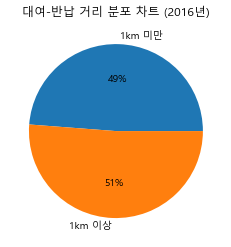

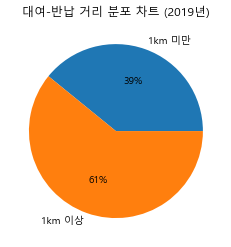

In [38]:
same_cnt_2016 = (df2016_loc['대여소 거리'] < 1000).sum()
diff_cnt_2016 = len(df2016_loc) - same_cnt_2016
plt.pie([same_cnt_2016, diff_cnt_2016], labels=['1km 미만', '1km 이상'], autopct='%1.0f%%')
plt.title("대여-반납 거리 분포 차트 (2016년)")
if save_flag:
    plt.savefig('4.대여-반납 거리 분포 차트 (2016년).png')
plt.show()

df2019_dist = pd.concat([dfs_year_group['2019'][i]['대여소 거리'] for i in range(len(dfs_year_group['2019']))])
same_cnt_2019 = (df2019_dist < 1000).sum()
diff_cnt_2019 = len(df2019_dist) - same_cnt_2019
plt.pie([same_cnt_2019, diff_cnt_2019], labels=['1km 미만', '1km 이상'], autopct='%1.0f%%')
plt.title("대여-반납 거리 분포 차트 (2019년)")
if save_flag:
    plt.savefig('4.대여-반납 거리 분포 차트 (2019년).png')
plt.show()

### [그래프 해석] 따릉이 이용 목적
•	대여 반납 거리가 1km 미만일 때는 ‘여가,운동’ 목적으로 따릉이를 사용, 1km 이상일때는 이동수단으로 따릉이를 사용한다고 가정  <br>
•	대여-반납 거리가 1km 이상인 비율이 51%(2016년)에서 61%(2019)로 늘어남 <br>
•	2016년대비 2019년에는 이동수단으로 따릉이를 사용하는 비율이 늘어났다고 볼 수 있음 


### 4b) 반납/대여 위치와 인근 지하철 유무 (거리가 200m 이내에 있는가) 

사용한 데이터: 서울특별시 공공자전거 대여이력 정보  
출처: http://data.seoul.go.kr/dataList/OA-15182/F/1/datasetView.do

사용한 데이터: 서울교통공사 노선별 지하철역 정보  
출처: http://data.seoul.go.kr/dataList/OA-15442/S/1/datasetView.do

In [39]:
subway_loc_tgt = subway_loc[['역위도', '역경도']]
loc_cols = ['대여 대여소 위도', '대여 대여소 경도', '반납 대여소 위도', '반납 대여소 경도']
df2016_loc_tgt = df2016_loc[loc_cols]
df2019_loc_tgt = pd.concat([dfs_year_group['2019'][i][loc_cols] for i in range(len(dfs_year_group['2019']))])

In [40]:
## 2016/19년 대여/반납 위치와 인근 지하철 거리 계산 후 200m 이내에 지하철 유무 확인 
bicycle2subway_dist_start_total_2016_200, bicycle2subway_dist_end_total_2016_200 = bicycle2subway_dist(df2016_loc_tgt, subway_loc_tgt, thresh=200)
bicycle2subway_dist_start_total_2019_200, bicycle2subway_dist_end_total_2019_200 = bicycle2subway_dist(df2019_loc_tgt, subway_loc_tgt, thresh=200)


[1/1] 대여소-지하철 처리 33.7 초
[1/1] 반납소-지하철 처리 14.3 초
[1/12] 대여소-지하철 처리 19.8 초
[1/12] 반납소-지하철 처리 18.1 초
[2/12] 대여소-지하철 처리 16.5 초
[2/12] 반납소-지하철 처리 16.8 초
[3/12] 대여소-지하철 처리 19.7 초
[3/12] 반납소-지하철 처리 16.3 초
[4/12] 대여소-지하철 처리 16.7 초
[4/12] 반납소-지하철 처리 17.3 초
[5/12] 대여소-지하철 처리 18.0 초
[5/12] 반납소-지하철 처리 16.3 초
[6/12] 대여소-지하철 처리 22.6 초
[6/12] 반납소-지하철 처리 15.0 초
[7/12] 대여소-지하철 처리 16.8 초
[7/12] 반납소-지하철 처리 15.6 초
[8/12] 대여소-지하철 처리 16.8 초
[8/12] 반납소-지하철 처리 15.5 초
[9/12] 대여소-지하철 처리 16.7 초
[9/12] 반납소-지하철 처리 14.0 초
[10/12] 대여소-지하철 처리 15.6 초
[10/12] 반납소-지하철 처리 13.9 초
[11/12] 대여소-지하철 처리 16.0 초
[11/12] 반납소-지하철 처리 15.1 초
[12/12] 대여소-지하철 처리 16.7 초
[12/12] 반납소-지하철 처리 19.6 초


In [41]:
total2016_200, end2016_200, start2016_200 = len(bicycle2subway_dist_end_total_2016_200), bicycle2subway_dist_start_total_2016_200.sum(), bicycle2subway_dist_end_total_2016_200.sum()
total2019_200, end2019_200, start2019_200 = len(bicycle2subway_dist_start_total_2019_200), bicycle2subway_dist_start_total_2019_200.sum(), bicycle2subway_dist_end_total_2019_200.sum()


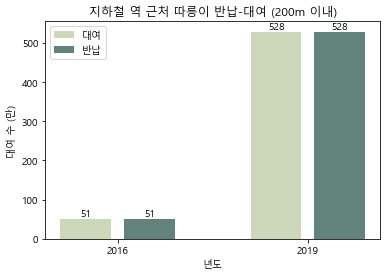

In [42]:
fig, ax = plt.subplots() 
rects1 = ax.bar([0, 3], [int(start2016_200/1e4), int(start2019_200/1e4)],label='대여', color='#CDD8BA')
rects2 = ax.bar([1, 4], [int(end2016_200/1e4), int(end2019_200/1e4)],label='반납', color='#62837C')
plt.xlabel('년도')
plt.ylabel('대여 수 (만)')
plt.xticks([0.5, 3.5], ['2016', '2019'])
plt.legend()
ax.bar_label(rects1, padding=1)
ax.bar_label(rects2, padding=1)
plt.title("지하철 역 근처 따릉이 반납-대여 (200m 이내)")
if save_flag:
    plt.savefig('4.지하철 역 근처 따릉이 반납-대여 (200m 이내).png')
plt.show()

### [그래프 해석] 따릉이 이용 목적
•	지하철 역 근처 (200m) 이내에서 사용된 따릉이는 지하철 사용 후 혹은 지하철을 사용하기 위한 목적으로 봄 <br>
•	지하철 역 근처에서 사용된 따릉이 수가 10배 이상 증가함 <br>
•	지하철과 연계하여 환승목적으로 사용되는 따릉이의 수가 증가하고 있다고 추정가능 <br>


### 4c) 시간별 일평균 대여/반납량 (2019년)

In [43]:
## 2019 년만 평균
hourly_grouped_monthly_df_return = group_by_hourly_usage_all({'2019': dfs_year_group['2019']}, monthly_day_types_cnt_year_group, '반납_hour')
hourly_grouped_monthly_df_lent = group_by_hourly_usage_all({'2019':dfs_year_group['2019']}, monthly_day_types_cnt_year_group, '대여_hour')
hourly_grouped_monthly_df_return_sum = hourly_grouped_monthly_df_return.groupby(['hour', 'day_type']).sum().drop(columns=['month']).reset_index()
hourly_grouped_monthly_df_return_sum['daily lent volume'] = hourly_grouped_monthly_df_return_sum['monthly lent volume'] / hourly_grouped_monthly_df_return_sum['day_cnt']
hourly_grouped_monthly_df_lent_sum = hourly_grouped_monthly_df_lent.groupby(['hour', 'day_type']).sum().drop(columns=['month']).reset_index()
hourly_grouped_monthly_df_lent_sum['daily lent volume'] = hourly_grouped_monthly_df_lent_sum['monthly lent volume'] / hourly_grouped_monthly_df_lent_sum['day_cnt']


Group by hour 2019year takes 2.9 sec
Group by hour 2019year takes 2.5 sec


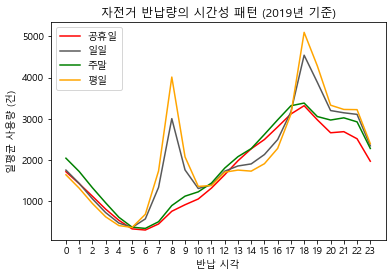

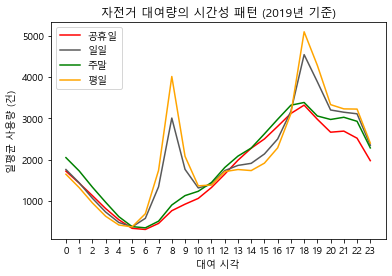

In [44]:
plot_hourly_pattern_bicycle_usage_all_year(hourly_grouped_monthly_df_return_sum, '반납_hour', save_flag)
plot_hourly_pattern_bicycle_usage_all_year(hourly_grouped_monthly_df_return_sum, '대여_hour', save_flag)

### [그래프 해석] 따릉이 일평균 대여/반납량 
•	평일은 출퇴근시간 (07-09시, 17-19시) 사용이 두드러지게 나타나며, 주말과 공휴일은 저녁시간전까지 꾸준히 상승하는 양상을 보임 <br>
•	평일 퇴근시간이 출근시간보다 이용 수가 높은 이유로는 크게 두 가지를 꼽을 수 있음: 1) 퇴근 후 여가 목적의 사용 2) 퇴근시간보다 심리적으로 바쁜 출근시간


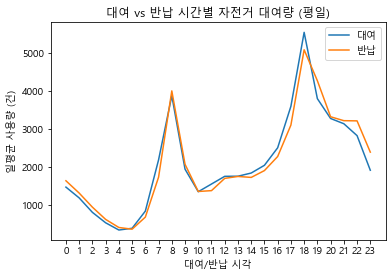

In [45]:
plot_lent_vs_return_hourly_bicycle_usage(hourly_grouped_monthly_df_lent_sum, hourly_grouped_monthly_df_return_sum, '평일', save_flag)

### [그래프 해석] 따릉이 평일 대여량
•	대여와 반납의 시간별 추세가 거의 동일함 <br>
•	다른시간에 비해 출퇴근시간에 대여량과 반납량이 급증함 


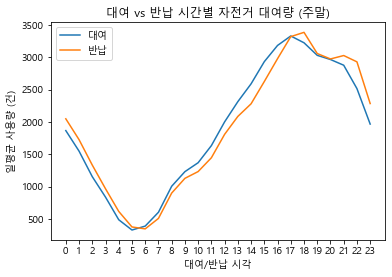

In [46]:
plot_lent_vs_return_hourly_bicycle_usage(hourly_grouped_monthly_df_lent_sum, hourly_grouped_monthly_df_return_sum, '주말', save_flag)

### [그래프 해석] 따릉이 주말 대여량
•	17시 이전에는 대여량이 많고 이후에는 반납량이 많은 추세를 보임 <br>
•	반납과 대여의 시간이 다른 것으로 보아 주말은 평일에 비해 이용시간이 더 긴것으로 볼 수 있음 


### 4d) 시간별 대여 반납 거리 분석

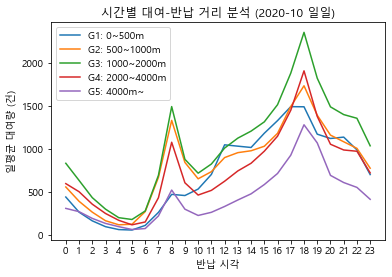

In [47]:
year, month_idx = '2020', 9
tgt_df = dfs_year_group[year][month_idx]
monthly_day_types_cnt = monthly_day_types_cnt_year_group[year][month_idx]
plot_hourly_distance_group(tgt_df, monthly_day_types_cnt, '일일', year, month_idx+1, save_flag=save_flag)

### [그래프 해석] 시간대별 대여-반납 거리 분석
•	1000-2000M 거리를 가장 많이 사용하고, 4000M 이상을 가장 적게 사용하는 것으로 나타남 <br>
•	출퇴근 시간에는 다르시간 대비 중단거리 이용자 수가 증가함 <br>
&nbsp;&nbsp;•	출근시간에는 500-1000M 사용자가, 퇴근시간에는 2000-4000M 사용자가 더 많은 것으로 나타남. 퇴근시간에 더 여유롭고 운동목적이 겸해져서 비교적 긴 거리를 사용하는 것으로 보임 


## 5. 따릉이 지역별 대여량 분석

### 5a) 지역별 대여량 분석 (2021년 6월)
* 2021년 6월 자치구별 대여량 지도 시각화

서울특별시 공공자전거 대여소별 이용정보(월별)  
출처: http://data.seoul.go.kr/dataList/OA-15249/F/1/datasetView.do

In [48]:
june_data_bike_usage = raw_data_for_bike_usage[raw_data_for_bike_usage['대여 일자 / 월'] == 202106.0]
june_data_bike_usage_by_station = june_data_bike_usage.groupby('대여소 그룹').agg({'대여 건수': 'sum'})
june_data_bike_usage_by_station.drop(['정비센터'], inplace = True)
june_data_bike_usage_by_station['자치구'] = june_data_bike_usage_by_station.index
june_data_bike_usage_by_station.head(5)

대여 건수  자치구
대여소 그룹               
강남구      99731.0  강남구
강동구     143699.0  강동구
강북구      63684.0  강북구
강서구     361675.0  강서구
관악구     112169.0  관악구

In [49]:
## top10 대여 건수 자치구
top10_station_usage = june_data_bike_usage_by_station.sort_values('대여 건수', ascending=False).head(10)
top10_station_usage.index = np.arange(1, 11)
top10_station_usage['대여 건수'] = top10_station_usage['대여 건수'].astype(int)
top10_station_usage

대여 건수   자치구
1   361675   강서구
2   294526   송파구
3   260526  영등포구
4   200594   노원구
5   195893   마포구
6   185618   양천구
7   155056   광진구
8   143699   강동구
9   131166   성동구
10  130793  동대문구

In [50]:
state_geo = 'https://raw.githubusercontent.com/southkorea/seoul-maps/master/kostat/2013/json/seoul_municipalities_geo_simple.json'
bike_usage_by_station_map = folium.Map(location=[37.562225, 126.978555], tiles="OpenStreetMap", zoom_start=11)
folium.Choropleth(
 geo_data=state_geo,
    name='2021년 6월 자치구 별 따릉이 대여량',
    data=june_data_bike_usage_by_station,
    columns=('자치구', '대여 건수'),
    key_on='feature.properties.name',
    fill_color='Greens',
    fill_opacity = 1,
    line_opacity = 1,
    color = 'black',
    legend_name = '대여량'
).add_to(bike_usage_by_station_map)
label_seoul_zones(bike_usage_by_station_map)

In [51]:
if save_flag:
    bike_usage_by_station_map.save('3.2021년-6월-자치구별-대여량.html')
bike_usage_by_station_map

### [지도 해석] 지역별 대여량
•	강서구와 영등포구가 다른 자치구들과 큰 격차로 대여량 1,2위를 차지함 <br>
•	대여소 분포와 비교해보았을 때, 대여량이 더 자치구별로 균등하지 못함<br>
•	서초와 강남은 대여소 대비 대여량이 적은 것으로 나타남 


### 5b) 자주 사용되는 대여소 분석 (2018년 ~ 2020년)

* 연도별 대여량 상위 10개 대여소 (매년 10월 기준)

서울특별시 공공자전거 대여소별 이용정보(월별)
출처: http://data.seoul.go.kr/dataList/OA-15249/F/1/datasetView.do

In [52]:
def freq_used_station(year, topk):
    df = read_csv('../data/서울_공공자전거_대여_월별/공공자전거 이용정보 {}.tsv'.format(year), sep = '\t')
    if '대여소' in df.columns:
        df.rename(columns = {'대여소': '대여소명'}, inplace = True)
    if year == 2017:
        df.rename(columns = {"'대여소'": '대여소명', "'대여소번호'": '대여소번호', "'이용건수'": '이용건수'}, inplace = True)   
    df = df[['대여소번호', '대여소명', '이용건수']]
    df = df.groupby('대여소번호').agg({'대여소명': 'first', '이용건수': 'sum'})
    df = df.sort_values(by = '이용건수', ascending = False).head(topk)
    df.index = np.arange(1, len(df) + 1)
    return df

def plot_freq_used_station(year, df, topk, save_flag=save_flag):
    fig = plt.figure(figsize = (10, 6), facecolor='white')
    ax = fig.add_subplot(111)

    table = plt.table(cellText = df.values,
             rowLabels = df.index,
             colLabels = df.columns,
             loc = 'center',
             colWidths = [1, .2])
    table.auto_set_font_size(False)
    table.set_fontsize(20)
    table.scale(1,2.2)

    name = "{}년 상위 {}개 대여소".format(year, topk)
    ax.set_title(name, fontsize = 20)
    ax.axis('off')
    filename = "3.{}.png".format(name)
    if save_flag:
        plt.savefig(filename)
    plt.show()

../data/서울_공공자전거_대여_월별/공공자전거 이용정보 2018.tsv 파일을 로딩합니다.
../data/서울_공공자전거_대여_월별/공공자전거 이용정보 2019.tsv 파일을 로딩합니다.
../data/서울_공공자전거_대여_월별/공공자전거 이용정보 2020.tsv 파일을 로딩합니다.


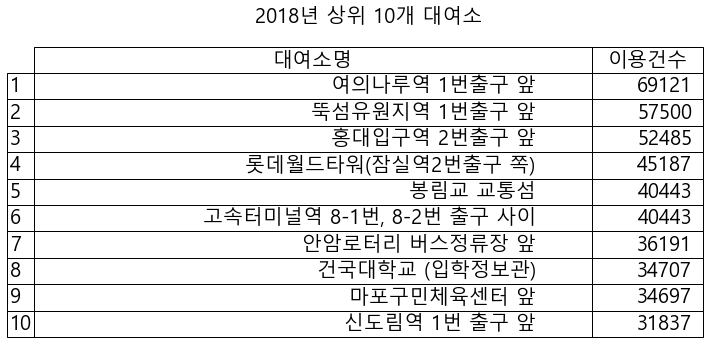

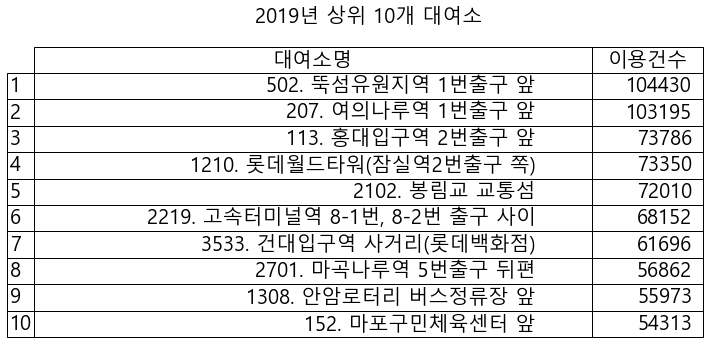

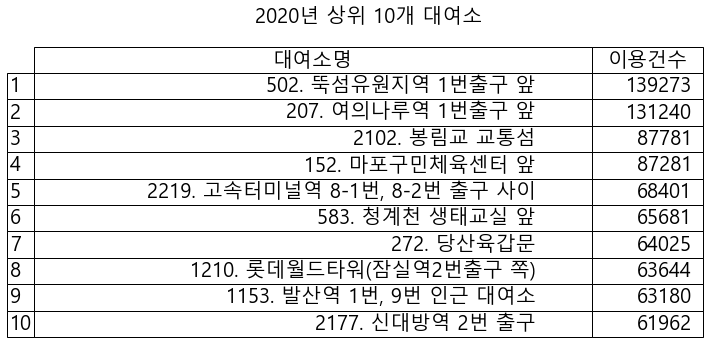

In [53]:
topk = 10
freq_used_2018_df = freq_used_station(2018, topk)
freq_used_2019_df = freq_used_station(2019, topk)
freq_used_2020_df = freq_used_station(2020, topk)
plot_freq_used_station(2018, freq_used_2018_df, topk, save_flag)
plot_freq_used_station(2019, freq_used_2019_df, topk, save_flag)
plot_freq_used_station(2020, freq_used_2020_df, topk, save_flag)

### [표 해석] 상위 10개 대여소
•	대여량 기준으로 Top 10 대여소를 뽑아봤을 때, 많은 사람들이 공통적으로 자주 이용하는 “한강이나 공원” 근처 대여소가 순위권에 많이 들었음 <br>
•	시간이 지남에 따라 주택가나 변화가 근처의 대여소도 순위에 이름을 올리고 있음 <br>
•	2020년도는 코로나로 인한 야외활동을 지향하는 시민들이 인식이 반영되어, 랭킹에 이동수단보다 여가수단과 관련된 대여소가 훨씬 많은 수가 이름을 올림<br>
•	단순히 대여소 대여량의 랭킹만으로 이용목적을 완벽히 파악하는데는 한계가 있지만, 따릉이의 이용목적이 시간이 지날수록 다양해지고 있다는 추론이 가능함


## 6. 계절별 대여량 분석

### 6a) 계절별 일평균 대여량 (2019년)

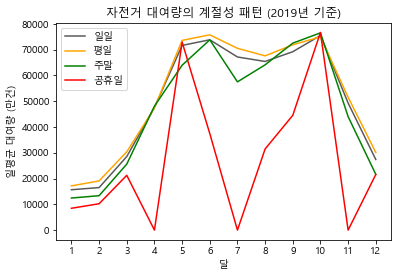

In [54]:
plot_monthly_pattern_bicycle_usage(monthly_mean_df[monthly_mean_df['year'] == 2019], save_flag=save_flag)

### [그래프 해석] 계절별 일평균 대여량
•	날씨가 좋은 봄과, 가을이 가장 높은 수치를 기록하였으며, 그 중에서도 가을에 대여량이 가장 높음 <br>
•	덥고 장마철이 포함된 여름과, 추운 겨울은 비교적 대여량이 적음 <br>
•	공휴일이 많은 5월과 10월은, 공휴일 사용자 수가 최대치를 기록함 (평일, 주말과 비슷한 수준임) 


## 7. 서울시 자전거 도로 현황 분석

### 7a) 서울시 자전거 도로 현황

* 서울시 자치구별 자전거 도로 길이 분석

사용한 데이터: 서울시 자전거도로 현황 통계  
출처: http://data.seoul.go.kr/dataList/276/S/2/datasetView.do

In [55]:
bike_road_raw.head(10)

기간  자치구  자치구(2)     합계     합계.1 자전거전용도로 자전거전용도로.1 자전거보행자겸용도로  \
0    기간  자치구  자치구(2)     구간       길이      구간        길이         구간   
1  2020   합계      합계  1,151  1,258.8     199     182.7        687   
2  2020  도로변      소계  1,087    978.5     184     138.5        638   
3  2020  도로변     종로구     38     26.5       -         -          9   
4  2020  도로변      중구     18     15.3       -         -          4   
5  2020  도로변     용산구     26       33       5         2         11   
6  2020  도로변     성동구     31     27.2       1       0.3         18   
7  2020  도로변     광진구     50     46.8       1       0.2         43   
8  2020  도로변    동대문구     30     37.8       4       1.4         12   
9  2020  도로변     중랑구     16       10       7       3.5          9   

  자전거보행자겸용도로.1 자전거전용차로 자전거전용차로.1 자전거우선도로 자전거우선도로.1  
0           길이      구간        길이      구간        길이  
1        810.4      95      74.3     170     191.5  
2        574.3      95      74.3     170     191.5  
3          9.5      13       6.9      16      10.2  
4          4.6       -         -      14      10.7  
5         10.6       -         -      10      20.4  
6         16.9       3         2       9         8  
7         41.7       1       0.3       5       4.6  
8          7.6       -         -      14      28.8  
9          6.5       -         -       -         -

In [56]:
bike_road = bike_road_raw[['자치구(2)', '합계', '합계.1']].copy()
bike_road.drop([0,1,2,28,29,30,31], inplace = True)
bike_road.rename(columns={"자치구(2)": "자치구", "합계": "구간", "합계.1": "길이"}, inplace = True)
bike_road = bike_road.sort_values(by = '자치구').reset_index(drop=True)
bike_road['구간'] = bike_road['구간'].astype(float)
bike_road['길이'] = bike_road['길이'].astype(float)
bike_road.head(10)

자치구    구간    길이
0  강남구  65.0  90.0
1  강동구  66.0  72.0
2  강북구   8.0   8.7
3  강서구  80.0  76.4
4  관악구  19.0  29.5
5  광진구  50.0  46.8
6  구로구  38.0  26.5
7  금천구  19.0   8.9
8  노원구  40.0  42.9
9  도봉구   8.0  12.9

### [그래프 해석] 자전거 도로 현황
•	현재 송파구, 강남구, 강서구, 강동구에 자전거 도로가 가장 많이 설치되어 있음 

### 결론
## 1. 따릉이 지도 및 길찾기 서비스

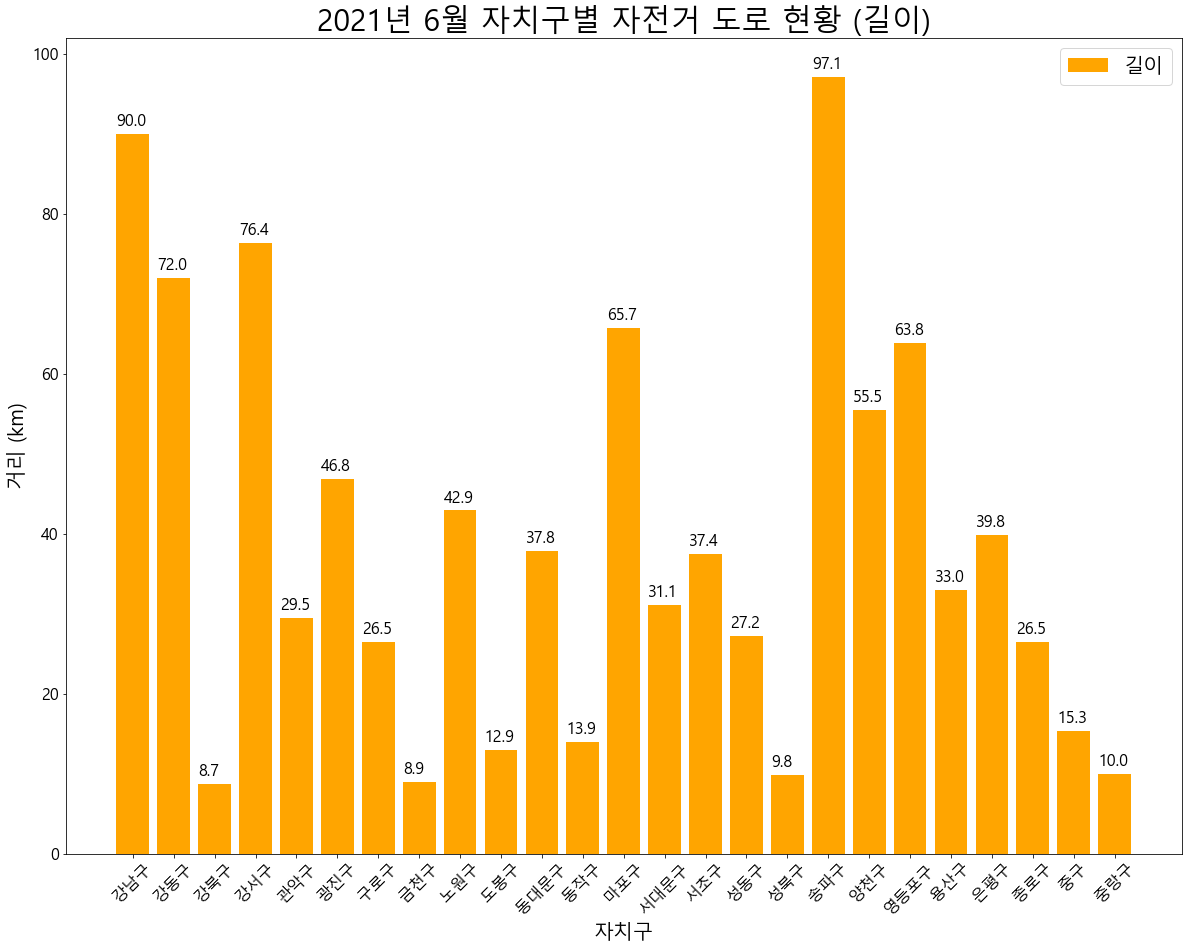

In [57]:
plt.figure(figsize=(20, 15))
plt.bar(bike_road['자치구'], bike_road['길이'], color = 'orange')
plt.xlabel('자치구', fontsize = 20)
plt.ylabel('거리 (km)', fontsize = 20)
plt.xticks(fontsize=16, rotation=45)
plt.yticks(fontsize=16)

for idx, data in enumerate(bike_road['길이']):
    plt.text(x=idx-0.4 , y=data+1, s=str(data), fontsize=16)

plt.legend(['길이'], fontsize = 20)
plt.title('2021년 6월 자치구별 자전거 도로 현황 (길이)', fontsize = 30)
if save_flag:
    plt.savefig('2.2021년-6월-자치구별-자전거-도로-현황-길이.png', transparent = True)
plt.show()


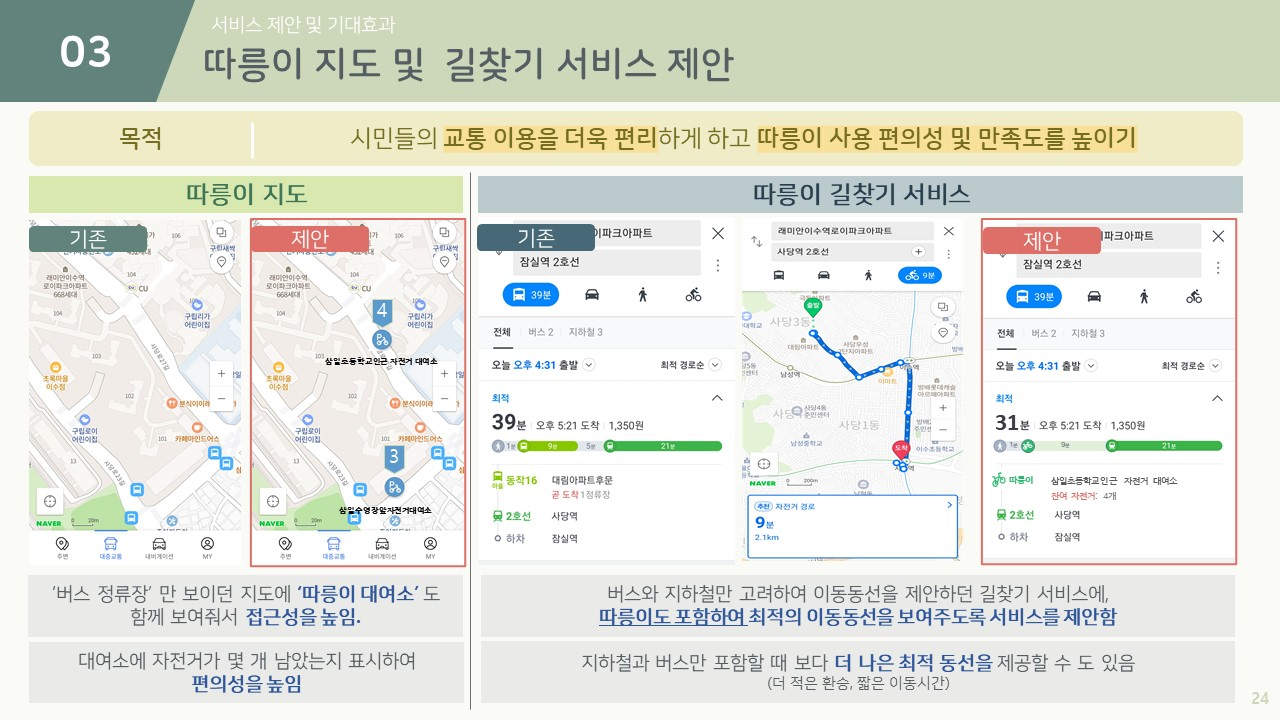

In [11]:
base64_data = "/9j/4AAQSkZJRgABAQEAYABgAAD/2wBDAAMCAgMCAgMDAwMEAwMEBQgFBQQEBQoHBwYIDAoMDAsKCwsNDhIQDQ4RDgsLEBYQERMUFRUVDA8XGBYUGBIUFRT/2wBDAQMEBAUEBQkFBQkUDQsNFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBT/wAARCALQBQADASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwDKooorU+UCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAoorrPhb4Z/4Szxxptm67raN/tE/p5ackH6nC/8AAqUpKKcmVFOTSR9JfCjwz/wingXTrV023Mq/aZ+Od784PuBhf+A119FFfNSk5NyZ78YqKSQUUUVJQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB8JUUUV9QfOBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAV9Dfs2+GPsmjX2uSpiS7fyISR/yzU/MR9W4/wCAV8/2VnLqF5BawJ5k88ixRqO7E4A/M19q+G9Ei8N6DYaZB/q7WFY9w/iIHLficn8a4MZPlhy9zuwsOaXN2NKiiivGPVFHJArY1jSSdeu7eEQ26pghZZFjGMDpuI9aqaZeQWDPO8RmuVx5KsBsVv7zeuOwp93qv9pWmLsNJeIf3dxnllzyr+vsfw+mi5eXUZr3Filz4qS3lVHH2VeNw25EGQc5x1HWqUOhtb6bqU1wsLNHEpjMc6OQd6jOFY9iasXl5FYeJI5pt/l/ZUU+WAT80AXoSPX1qot1p1nYX0VvLdSy3EaoPMhVVGHVs5Dn09K1fLd38xjNa/489I/69f8A2o9TaFo7XtreyNGuGiKQGTA3yZBwuepwD09adeQvMNEEaxM4ttwWZlVDiRzgliBTLzT9U1CQPPLbMVGFUXcIVB6KA2APpU21va//AAwGM6NGxVlKspwVYYINXdHaE3kcU1pHdCV1T52cbcnHG0irOqx38lqjXjW8vlnAlWeJ5SOwJViWH16VW029i0/zJwjPeLgQEgbEPdj6kdvz7VFuWWojctdPSXUrporG3gtrdbiM4lyzEIQCVZifToKj+zxTXFm8kYm8nTBMsJ6OwzgH27/hUem36alqKzOhW8+zzCZx92TEbYb2b19etVdWnktpdKlidopFtIyrKcEcmtrq1xitKuqaPdzS28MUtuybJII1jzuJBUgcH19eDTvEVrtjsp/NiO62hXyg3zj5OpHpUXiK4uhfzWk1y00cLkD5QoJ9cDjPvVXU71b6SBlUqI4I4ju9VUAms5NWaEadnDONBhltLJbmVrh1dvs4lIAVcDkHHU1ajg8nxPoYaBYJHSJpEWMJ8xJzkAVh6ZJH52yZrrY33VtSNxb6GujurK002GyvfK1BJouXkGxnjbOV3g5wcYxntWkdVfsM5GT/AFjfWtjSLq3u76ztX0u1ZZJEjZh5m4gkAn7/AF/CsZyC7EZxnjPWtOLULbTLcfYld7x0w9xKAPLyOQg9e24/hisY6O7ES2SKlprqqPlWIBf+/q066mttNtbADT7adpbcSO8pkySWYdmA7VDpP/IL1n/rgn/o1KfLeabeW9mLhrpJIIRERGikHBJ6k+/pV9P67ga2hae81vpVzHCpRBceY/APQ49zWNosME0cxntoWii+d55ncBASABhepJ9q19N8vdo3lbvL/wBK27+uMHGfeqfhqzkWYPMbU2MyMsiTTxjOMkZBbI+YD0NaWvypL+rIotXk2n6gpkggtrqSCLBjLSxtsQYyOcHA981hafOFkaNbCG9dz8quHJHsNrCt77IyaXci3t9Ps7uRlj/d3aMTGQd3LSHHbpg81Q0WO00vUEmvLxYpYWIMUaeYDx1DKSO/6VMk203/AF94ie3FvcR6TcpaRW0rXvlt5JbBUbD/ABMfWsvWrOez1Gfz4ZId7sy71IyMnkVfsTai60+KO/ln8u4VkiNuFXJZcnO729O1ZWpf8hG6/wCurfzNRL4Q6FaiiisSQooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD4Sooor6g+cCiiigAooooAKVVLsFUFmJwABkmkr1n9lvwtD4q+NGipcx+bb2Ie/dSMgmMfJ+TlD+FBcI88lFdTu/h/8AsT614g0qG/8AEerroBmQOllHB50yg9N+WUKfbn3weK0/Fv7DN7aWMs/h3xEmoXCglbO+g8rf7CQMRn6gD3FbX7Ynxi1zwtq2leGNA1K40pnt/tl3cWjmOVgzMqIHByB8rE465Fcp+yj8bPEU3xCtvDOt6vdarp2pRukP26VpmhlRS67WYkgEKRjpyKnXc9Hlw8Z+ya+Z85anpt3ouoXNhfW8lpeW0jRTQSrhkYHBBFer/Bn9mnX/AIuWo1M3Eei6DuKrfTJ5jTEHBEaAjIBBBJIGfXBx1X7bXhSHR/iHpmswRiMatafvsDG6WIhS312tGPwrg/D/AO0Z408L/D9PCOl3kNnZRlhHeRxkXUasxZkV84AyTzjcM8EU+hy8kKdRxqbI9q1H9g+L7Nmw8YOLgD7txYDYx+ofKjp2NfOPxI+Geu/CvxAdJ12BUlZfMhnhbdFMmSNynHqOhAI7iuo+CvjHxtd/FTQE0zVtUvbie8jFxG87ypJCXHmeYCSCu3JJPTr1r2/9uy6sf7F8K2zFTqX2iaRFzyItoDZHoW2fkaWtzWUadSk5wVrHx9RRRVHAFFFFABRRRQAUUUUAen/s++GP7b8afb5U3W2mJ5vPTzGyEH/oTf8AAa+nq87+BXhj/hHvAlvPIm261FvtT567Twg/75AP/AjXoleDiJ89R+R7eHhyU15hRRRXKdAUUUUASXFxJdSb5XLvtC5PoAAB+QFR0xpo45ERpFV5MhFJALY5OB3p9MCSa4knWJZHLLEuxB6DJOPzJqOiigAooopAOjleFtyOyNgjKnBwetOmuJLjy/Mfd5aBF9lHQVHRTA0v+Ek1TvfTH/gVVLu9nvpBJcStK4GNzHnFQUyOaOYuEkVyh2sFIO0+h9DTcm92BZtb24sy5t5nhLjaxjYgkemaLa8uLObzYJpIZP7yMQahopXYDpJGkdnY5Zjkn1NNoopASR3EkMcqI5VJV2uPUAg4/MCo6Y80cbojyKryHCKxALfT1p9MCeG+nt2jMcrKY87Ochc9cD3qCiigAooopAOileGRJEO10IZW9CKJJGlkZ2O5mOSfUmm0UwCiiikAUUxZ42meJZFMqAFkDDcAemRT6ACiiigAooooAKKZNNHbxtJK6xxryWcgAfU08HIyORQAUUVXsdRtdThM1ncw3cQYoZIJA67h1GQeopgWKKbJIkMbPIyoijJZjgAepNKrBlDKQVIyCOhpALRRRQAUUUxZo2leNZFMiAFkBGRnpkUAPooooAKKKKACimSzJBG0kjrHGoyzMcAfU04MGAIOQehoAWiiigAoopkM0dwm+KRZEzjchBHHWgB9FFFABRRRQAUUUUAFFFFABRTZJUhjaSR1jRRksxwB9TTgcjI5FABRRRQAUUyaaO3TfLIsa5A3OQBk9KfQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAfCVFFFfUHzgUUUUAFFFFABXv37E7Kvxfug3U6TMF+vmRf0zXgNei/s++NoPAPxZ0PU7yQRWDO1tcu3RUkUruPsCVb8KGbUZKNSLZ2X7aCsvxkBIIDabAV9xlx/MGuR/ZvUt8cPCQAyftTH/wAhvX0/+078ANS+LEmma34ee3bVbWI28kEz7BPESWUq/TKktweobrxzz37Nv7MuueA/F48TeKBb281rG6WdpDIJW3uCrOzDgAKSABnO7tjmb6HbKjN4i9tL3Mn9vRl87wQoHzhb0n6Zgx/I186/DHxBpPhXx5o2ra7p/wDamk2sxee12K+4bSAdrcEgkNg+len/ALYfjm38WfFBdOs5FlttFt/srOpyDMSWkx9PlX6qam0f9j/xH4i+HmleI9M1Wznvb+BbpdNkUx4jYApiTJBYgjggAetPoZVVKpWlKmr2PePCX7U3wtur+OytfM0E3DhBJPYrDGWPA3MhIA6cngd+K8d/az+DuuaNef8ACaTa7ceIbC4kW3kN0qrJaZzsUBQFKdegHJ5yTmuU0H9kf4kapqsVte6RFpFqXCy3lxdwuqDgkhUdmbg9hjPGRX0H+1xr2m+Gfgr/AMI7LOJL+/aCC1jY5kKxOjtJ9MKBn1als9DobnUpS9qrW26HwrRRRVHkhRRRQAUUUUAFbPg3w6/irxRpulIDi4mAkK9VQcufwUGsavcv2afDHmXGpa/KnEY+yQEjucM5/LaPxNY1p+zg5GtKHPNRPeIYUt4UijUJGihVVegA4Ap9FFfOnvBXmf7Qfj7Vfhz4DTUdHaOO9mvI7YSSIH2KVdiQDxn5Mc+temV4f+19/wAkvsv+wrF/6KlreglKpFMT2LHww/4Ww1zaax4o1jT7zQJbNrhrYRxrNym5MbIxg5IzyRjNcH8P/GXxm+K0d3qWi63p1pZW84iaOeCJU3Y3bR+7ZsAEd+9fQWg/8k907/sFx/8AokV5F+xv/wAiLrf/AGEv/aSV0qS5Zz5VpboIq/GmSdPjx8MFkky4kg3bMhdxnAYge9fRNfMv7SsupQ/GDwNJo8KXGrKsZtIpCAry+f8AIDkgYJx1Ir2L4Wah46v7K+PjjTLPTZ1kX7MLV1YuuDu3bXYdcY57moqxvShK/T9R9Tz/AOO2m+FH8UQXGvfEDUvDlw1soWwtRJIu3c3z7UBxk569cV5p9i+G/wD0VzXv/AS5/wDiK7P41+BvEkvxi0/xJp/hWPxTpsdoitbTKskLsA6lXUntuDDjHT0NU/P8Sf8ARBtC/wDAGL/4muqnpCNpfiv1JPOPG114d0PSorrwp8R9a1jVBOoMEiTw7UwcsGIXkED86+zPB91Ne+EdEuLl2luJrGCSR26sxjUkn3zXz5Hd+JoZFdPgToaOpyGWyjBH/jtfQ3he+vtS8Pafdalp/wDZV9LCrTWe8N5Tf3c1hiZXiv8ANfoNHlXxi+LHiCy8Xaf4H8ExxP4hu1V5Llgr+QDkgbWBUHaNxJzhT0rlfEE/xo+E9iPEGoa3ZeItMhdWvLZAGCqTjnMasF5HKHjOSMVZ8Gf6R+1z4qe6AEsdo3lZ9khVcf8AAM17N8S44pfhz4pWbHlf2XdbsjoPKbmhyjTcYcqd0r/MCfwP4ttfHXhTTdcsxtivIg5j3bjG44dCe5VgR+FeG/snzSSeJviDvdn3XELHcScsXmyfrXUfsmSSt8JwJBhFv5hH7rhT/MtXKfsl/wDIzeP/APrtD/6HNRyqEasV0t+Ydj6SrkfibZ+ML7QYo/BV/aafqfnqZJbtQR5WDkLlWGc7eo6ZrrqK4Yvldyj5O+JHjT4zfC2Gxl1nxNZst4zrF9ltrdzlQCc5hH94V6F4f0H45Q65YSan4j0mfTVnQ3MXlR/NHkbgNsIOcZxgjnvXBftheJrbVNb0TQrRxPc6fHLPdLHzsLhdqn0IVCT7MK+j/A3iqz8a+FNN1iylWWO4hUuFOSkmPnQ+4ORXoVJONKM+Va36fcT1PDf2gJpE+OXw2CuyhZ7cjBPBNyAfzAFfR9fNv7QX/Jc/hx/12t//AEqFfSVYVv4dP0GfM+oeLfiL44+NPiHwx4d8Rx6Rb2JdkWWJNiohVTzsYkksOvrXR/8ACvPjT/0UGx/79D/41XIeDPEul+FP2nvGV1rF/DpttItxEs1w2xSxkjYDJ9lP5V7n/wALi8D/APQ16T/4FJ/jW9RyhZQirWXQRwFr8P8A4yx3ULy+P7Fo1cFh5AORnnjyua9wrj1+MHgdmCjxXpOScc3aD+tdgDkZHIrjqSlK3MrfKwwr56+P3ijxQ3xQ8LeFNB1ubRY9QijzJCxX53lZMsRyQAo4r6Fr5j/aI1iLwt8dPBOuXkchsbWCGRzGuSQk7lgPUgEfnWuGV6m3RgzS1j4TfFHSdJvb4/Eq4lFrA8xTzZhu2qTjOfauq/Zg8Y6x4y8A3k+tXsmoXFtfvAk02C+zy42AJ78seTzzWH4j/aq8Gal4e1Szgh1Qz3FrLDHut1A3MhAyd/TJqX9juF4/hzqbsjKj6o5UkfexFEOPxrean7FuorO66C66GP8AC2aRv2qPG4LsQYLgHJPIEsIH5Cvo+vm34V/8nUeNv+uNz/6Nir6SrDEfEvRDQVX1C3lu7C5ghna1mliZEnUZMbEEBgO5B5/CrFQahf2+l2NxeXcy29rbxtLLK5wqIoySfYAVyjPCG+APxAJJ/wCFsat/39uP/jtczpEnjH4c/Hbw74ZvvGWoeILe8CSSrPNI6FWDjaVdmwRtzke1dL4k/aek1m8bSPh7odzruovwt1LC2wf7Sxj5iPdtoHcVofCf4L63b+LD448cX/2zxC4JhtlYMISV25Yj5chSQFXgfy9PmnGLda22isrk+ha/axdl+ErhWIDX0IYA9R8xwfxA/Ku6+FMjSfDDwo7Eux0q25JyT+6WuE/ay/5JO3/X/D/Jq7v4Tf8AJL/CX/YKtv8A0Utc0v4C9WPqeX6v8VPilJZ3qN8NzBA0bqX84sUXB5yOuBXm3wC8beNPDPhrULfw14T/AOEgtHu/Mkm3kbH2KNvHsAfxr1z40/HTTNEsb3wzoW7WfEl4jWgitMusDOCvJHVxnhRk5647+a/C/wASar+zfrTaT4x0yS30jWEjnW7hBfyX289PvY3bWUcggEZGM9cFek/cWvTuLqdx8X/EGu69+zxql3r2jtoGoNcxRta+Zu3IJkw3sD6H0rvPgbfRTfCrwtGbhHmFmq7C4LcZ4x7AVzX7Rer2WvfAq/v9Ouor2znkt2jnhYMrDzV7/wCcVzvwP+APh2TR/C3jJrvUzqe1bvyfOQQ7wTgYCbscdN1Y2i6Hvaa/oHU7/wCKWmfEm/vrI+CNXsNNtFjIuFuUQuz54PzRuMY9Md6838QW/wAefDWh3+rXXibTXtbKF7iVY4YC21Rk4BgHYetfR1eZ/tDeM7Dwr8M9XtridRe6nA9nbW+RvcuNrMB6KCST9B1IrKjUbagop/IbLPwH8ban4++HdtqurvHJfefLE0kaBAwU8HA4zg9vSvM/hbNI37VHjcF2IMFwDknkCWED8hXf/s2aFdaD8I9KW7QxS3TSXSxsMEI7fLn6qAfxrz34V/8AJ1Hjb/rjc/8Ao2KtVZSqqO3/AARdj6Sooorzyjz74+eItQ8K/CrWdR0u5azvozCiTx/eXdKinHvgn860Pg/rl74k+Gfh/UdRnNzez2+ZZmABchiMnHfArz79rDxXb2fgmDw3E3napq08ZW3j5fy0bduwPVgoHrz6VJ+z74lfxZ8GZdD0u+TT/EGmxS2okZQxiZixil29xzj6qa7fZ/7OpW6/gLqaf7U0jL8HtRCsQGuIA2D1HmA4P4gflXV/B9i3wr8KEkk/2bAOf9wV89fGTwJ8RtB8DXN54j8Xxaxpayxq9qrMSWLYU8oOh96+hPg7/wAkr8Kf9g2H/wBAFOpFRopJ31F1OG+GHxK1/wASfG3xp4fv7tZtKsPO+zQCJV8ry5ljGGAycgnOSea6L9oDxhqvgj4b3Wo6NcC0vjPFEs2xXKBm5wGBGcDHI7+teD+HdF8U658evHcPhPWYdEv1uLt5Z5l3Bo/tABX7rdyp6dqvfGzwj8SNH8Cy3PifxZa6xpQnjVrWKPDFiTtP+rHT61t7KHtY6rpoK+h75p+tXetfBmHVbqXdfXWhfaJJUG3MjQZLADpzzxXnv7Hbs3w61VSxKrqj4BPA/dRV2nhn/k3/AE//ALFxf/SauJ/Y5/5J3q//AGFX/wDRMVY/8up+pR71XNfEvWJtA+HviPULab7Pc29hM8MoxlZNh2kZ75xVvxX4y0bwRpjX+t6hDYW4zt8w/M59EUcsfYCvnbxR458T/tJXTeHPCemy6f4ZWVTd31xxuAOQZCOAOhCDJJAP0yo0nJ8z2XUD039mnxVqPi74ai51S+k1G8hvJYGmmbc+AFYAnv8Ae716tXy1/Zvir9lvX7u7srWTX/BN2ymU907AsQPkcZxnG1hjv093+H/xU8O/Eqz83R70G4Vd0tlNhJ4vqueR7jI96qtT1dSHwsEddXHfE5PGcmiwL4Jks4tQ84ec13j/AFeD93IIznHWuxormi+V3GfKusfEP4yaH4207wpdajp41e/RXhVYYShDFgMtt4+4a9Etm+JNj4A8cy+MrmyIj0i4ezlsyqyJIInJOUAGBx75rzD4s+PNPt/2ltH1EShrPRpLa1upkOQCHZpP++Q5BHqpFei/HJfiPcWWuTaJc6b/AMIa2mSNMPkMrReUfN5IJyRnG09Md69OSvyKyVyTzq3uZpP2PbwPK7AX4QAsThftCHH0zzX0F8OdRi034QeHL67kK29vosE0sh5wqwgk/kK+ebP/AJM/vf8AsIj/ANHpXuPh/R5vEH7PNjplv/x8XnhxYI+cZZrfAGfTJFRXtZp/zMEeZ6DrvxN+PVxf6jomsR+E/DcMphh2jDuRz1ALMcEZOQOeO9XdN+IHjj4Q+PNL0DxzfRa3ouqMEg1JF+ZDkLkEAE4JXcGB4OQfVf2Y/iNoWj+D5vDerX9vo+qWV1ITHfSLD5gY9ixGWByCvXisn48eJNO+Knjrwd4W8N3Ueq3EVyzTXNo4dE3bc4ccHaqsxIPGPUHF2vUdNx930/G4G/8AtjyMvgPRlDEK2pAlc8HET17X4adpPDmlO7Fna0iJZjkk7BzXiX7ZH/Ii6J/2Ev8A2k9bnwj+F/inw7f6brGo+Or7VtNa0BGlzGRo/mQbR8zkDbkdB2rBxToRbdtw6nsdFFFcJQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB8JUUUV9QfOBRRRQAUUUUAFFFFAHrPgL9qDx38P9Nh062vbfU9PhG2G31OIyiNeyhgytgdhnA7Vo+Kv2vPiF4nsJLSO5stEjkXa76XAySEezuzFfqpBrxWiixt7apbl5hWYuxZiWYnJJ5Jr0P4f/H7xt8NbdbTStWMunL92xvV86Fe/yg8r34UjrXndFBnGUou8XY9/uP22vH81qYks9Dgkxjz47WUuPfDSlc/hXi3ijxZrHjTVpNS1zUZ9TvX4Ms7ZwPRR0UewAFZNFBcqk56SdwooooMgooooAKKKKAFVSzBVBJJwAK+yvh/4aHhLwfpmmlQJo4g03vI3zN+px9AK+bvgv4Z/4Sbx7YiRN1tZf6XLxx8pG0fixX8M19Z15WMnqoI9PCQ0cwooorzD0AryH9qHw1qnij4bRQaTYz6jcQ38U7QW0ZeTYEdSQo5PLDpXr1FaQk6clJdAPCvh/wDErxxqo0vw7efDy/0+0FutpLqFwssSoBHt34dAO3TNeffCLxF4++EunX+kRfDrVdS+0XJmMjQTRhWChSNwQqR8vXNfW1Fb+3jquTR+orHzJ8TNQvNW+MXwlvNQsG0u9n+zPNZu24xMbgZXNfQvizSLzXvDl/p9hqUuj3lxHsivoRl4jnqOR9OCDzXjfxl0HUdQ+Onw4u7axuLi1imiMk0cZZE2zhmyRwMLzzXvVOrL3YNf1qB89XnwO8b6dbvcXfxg1G1gTlpZridFH1JmxXI3Gky2zhX/AGgnJJx+7vZ3H5rMa1f2iJor74yeGtM8U3dxZ+DTCrloi2wtlwzHA652qT1CkHvXf6f4H+C32OL7Ovh2WHHyu9+rk/Us5P51087jFSlrfskI4XQvhvr/AIndk0n45T6jIvWO2vpXYfgJs16Z8L/hj4n8Fa1c3mteOL7xJbSQGJbO5MjKrbgd+XdsEAEcdc+1eI/HbSfh74aTTrvwNfRW/iZbtSI9IumlULg/NwSEYNtxgg8ng9R9U+GZb2fw3pUmpLs1F7SJrlfSUoN4/wC+s1lWlLkTT0fkkwR4p8YPBviPwn8SbL4keFLBtVdUWO/sYlZ3fC7Cdo5KlMDjO0qDisPxd8WvGnxZ0WXwvoXga/0yS/xDdXM5dlRD95dxRQoPQsx6ZGMmvpmisY10kuaN2th2OW+GHglPh74H0vQw6yTQJunkXOHlY7nIz2ycD2Arxb9kv/kZvH//AF2h/wDQ5q+kq+ff2XfD+p6P4h8eSX9hcWaSXMaI08ZQMweUkDPXAI6eoqoS5qdRvd2/MOqPoKvOfjd408Q+EfD1rF4Y0m41HVdRlNtHPDEZFtjj7xAByx7Z44JPTB9GormjJRkm1cZ478H/AIEQeGdNvdR8Uomr+ItWjdbsznzFjR/vx5P3mOfmb8BxyeW03wH4v+BnxCg/4Ra2uNe8IatcKk1oMsbfJAyx/hKjo/QgYavouitvbzu3LW4rHzb+0F/yXP4cf9drf/0qFfSVfPvx08P6nqnxq+HdxaWFxc26TQ75ooyyJtuAzZPQYXnntXrvxB8Oat4p8OtY6Lrsvh69Mqv9shQsdozleCCM+oParqWlCmrgUNe+DPgvxNqs+panoFvc305Blm3upcgYyQrAZwK8B8dfDfw1pX7Q/hbw9aaVHDo13BE89qHcq5LSgnJOeijoe1d7/wAKS+Iv/RVb7/viT/45WTefsy+K9Q1u31i5+IUs+q24Cw3kkDmWMAkgBvMyOp/OtqUlB61OnmL5Ho4/Z7+HoIP/AAjNv/39l/8Ai69DVRGoVQFVRgAdBXhf/CkviL/0VW+/74k/+OV3fwx8E+I/Bw1D+3/Flx4m+0bPJWZCPJxuyQSxPOR/3zXNU1V3O/3jO6rI8VXmkaXod1qOtxwvp9mhmkaaHzdoHcLgnP0rXqjrmo6fpOk3V3qs0MGnRITPJcY2BenOeuemO+awW4zyL/hfPwj9IP8AwUt/8RXJfC39p60gvNdi8V3sdtp4lVtMjtbIgJGS+Uwi9ANn3ueTzWn4i+O3hi8mfTPA/hJfE2rSArFIunhYlPZsbdzAfRR71x3hbwf4w+BdwNb1bwrD4l0zUIQb63gVZZLRgxIJwDggHqAV5xnjNenGnDlakrN7XauSelfDnxN8MdY+Kl7qfh69upfEmsRurRzRSLGQAHfblcAnZnk9jivbK8v+G/xc8AeNL+GDR44dM1iQEJaT2qwzHjJCsBtPAPAbPHSvUK4a1+azTXqNBUV1aw31rNbXEST28yGOSKRQyupGCpB6gg1LRWIzy7xd4Z8V+FILCz+GOmaJp1kQ7XYljCszZG368Z5PNc3/AMX7/wCoD/45WP8AtQ+INSs/FvhDS4dcutD025ybie3laMLmRVLttIztXJ59/WqH/CJ+E/8AouF//wCDIf8AxdelCPuKUra+TZIfEXxN8WvCnht73xRY+HtR0cyLHJBLbpOjMT8u5M88ivfvB+or4m8C6NetAtot9p8MjQ2+VWPfGCVTHQDOB9BXzxqHw+8Daxb+Rf8AxkuL633BvKuL5JFyO+CxGa+jfB0OmW3hXSLfRrpL3S7e1jgtrhJA4dEUKDuHBPHPvmsq/LyKy19LAjyKS1+G/wCzHdWzzW19d6nfB2jupI1nmVBgEA/KqjnHAye+ar+IP2lfhp4q0uXTtX03UL+yl+9FNaKRn1B35BHYjkV6J8SviR4N8EJFH4mlhmuWTzYbPyPOlYZIyBjABIIySBx1rwjxBHrn7RsttZeGvCcPh7w7A7T/ANpXEQj81gpC5YD3xtXd1yTWlOKqe/UT9bh6Et98TPhPL8OLrwZZxa7YabPJ53mLCryLJvDZyz8/dAx6fnXvXwfutHuvhvoZ0GW4n0uOHyYpLpNshKsVbcOmdwPTivFvDHxUh+G9vZeHfiH4I+wy2yCCPU4rRHWZVAAY5HzcDllJz6V9BeE/EWi+KNDgvtAuYbnTTlEaBdoUjqpXAKkehA61GI0jZJ2vve6BHn3xm+NV18P9Qs9A0TSJdV8RX8XmwKUZo1BLKMKvLtlT8ox9e1cv4D+AWq+JdcTxX8S7ttS1BiHj0t2DInOQJMfLgf8APNePXuK9/aNGdXKqXXoxHIz1xTqwVbkjywVn1YxFUKoAGAOABXzd8K/+TqPG3/XG5/8ARsVfSVfPvwz8P6na/tM+Nb6ewuIbJoZttxJGRG2+SIrhjwcgE8ehqqPwz9AZ9BVz3xA8RXvhTwfqeq6dpsmr31vGDFaRKWLMWAyQOSBnccc4BroaK507O7GeC/B34R6tq3iA+P8Ax6Xn1uZvNtLKcf6j+67L/CQPup/D1PPSD4mfCfXfBfixfHfw7jb7Wz7r3SolyJMn5iqfxK3dRyDyPb6Borf6xPn5vw6WFY8W/aOurm++A5uby1NjdzNaSTWrNuMLkgsme+DkfhXcfB3/AJJX4U/7BsP/AKAK539pjTLvVfhJqMVlbS3UqzQyGOFCzbQ4ycDk4zXUfCmzn0/4aeGLa5he3uI9PhV4pFKsp2Dgg9D7U5NewXqLqeA2cni74V/Gzxhrdt4H1XxBbX8s6xm2ikCFJJVkVg6xuDwMY9/an/Ff4geNPid4RfQx8MNd0zfMkpn8qaX7uTjb5K/zr6moqvrCupOOq9R2OE0vTbnR/gfBY3kTQXdvoHlSxN1Rxb4IPuDXAfsc/wDJO9X/AOwq/wD6Jir2XxVbyXXhfWIIUaSaSzmREUZLMUIAH415N+yXo9/o/wAPdRW/s57NpdSd0W4jKMyiONc4POMgj8DQpXoz9UB33jz4U+HviTc6ZNrkE0509mMaRylFYNjcrY6j5R0wfeul0vSbLQ7CGy0+1hsrSEbUhgQIi/QCvJPGHwZ8a+IPEt/qFj8StS0yzuJC8VnC0qLCvZQFkA49cc1jf8KA+IH/AEVjVv8Av7cf/HaXLGUUnU/MD32SNZo2R1Dow2srDIIPUEVxWh/Bnwp4a8Yt4l0vTzY35jZBFC5WBd3BYJ0Bxxgce2a83/4UB8QP+isat/39uP8A47T4fgH8QI5kf/hbGq/KwPLzsOvoZcH6GhRjFNKp+YHvleafHTxV4n8P+HbW08KaXc3up6nKbYXVvGX+zDHXjoxzwTwME9q9KUFVAJ3EDlj396WueElGSbVxniXhP9mnS7X4cX2j62/2jWtTKz3F8nzGCVc7AhPUKWOf724+2MfwrY+NPCvwx+IPhbxLatJpum6RdDT9RLZV1ML/ACKe645Hdeh7AfQtYvjbSZ/EHg3XtLttv2m9sLi2i3nA3PGyjJ9MkVuq8pO0tbv7hWPmCz/5M/vf+wiP/R6V9G/CX/kl/hL/ALBVt/6KWvFtW+Hev+F/2XL7Rb2wZtUF2tw1tbkTMqmZT/DkHgZ4zgfjXt/wxs59P+HPhi2uYnguItNt0kikGGRhGuQR2IrWvJSi7P7TEjhPid4V+F2oeMtM0/xHZLD4h1hgsMlsZI2kJbapcoduS3ALAmu28F/Czwt8P2kfQtJjtJ5Bte4ZmklI9NzEkD2GBXh/7RmpW+ifHDwFqV65hsrX7PPNLtLbUS5LMcAZOAOg5r03/hpb4b/9DH/5I3P/AMbpShUdOPLdpgch+2OjN4D0ZgpKrqQBbHAzE9e1+GVK+G9JVgQRaQgg9vkFefXX7RfwwvY/LuNdjnjyDsl064YZHQ4MVek6Vqlrrmm22oWMy3NncxrLDKucMpGQeaynzKnGEo2sMtUUUVzDCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAPhKiiivqD5wKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooq5oulTa5q1np9uMz3UqxJ7EnGT7CjbUe59Efs6+Gf7L8Jz6rKmJ9Rk+Qkc+UmQPzbcfyr1mqulabDo+mWljbLtgtoliQeyjAq1XzlSftJuR71OPJFRCiiisjQKKKKACiiigAooooAzPEHhjSfFlj9j1jTrfUrbO4R3EYba3TKnsfcc15/cfsx/DuaTcuiSQ/7Md5Nj9XNep0VpGpOOkXYDivC/wY8F+DbtLvS9At4ruM7kuJmeZ0b1UuTtP0xXa0UVMpSk7ydwCiiipAKKKKACiiigAooooAKKKKACiiigAooooAKqatpNnrmnXFhqFtHd2dwuyWGUZVh71bopgZ+i+H9L8N2YtdK0+2063H/LO1iWMH3OByfc1oUUUXvqwMdvB2hNrsWtf2RZDVo9229ECiUZGD82Mk4J/M+tbFFFF29wCiiikBz/izwD4e8cpAuu6VBqPkZ8ppMhkzjOCCDzgflXN/8M9/Dz/oWbf/AL/S/wDxdeiUVoqk4qybA87/AOGe/h5/0LNv/wB/pf8A4uu20TRLHw3pdvpumWyWdjbrtihj6KMkn9ST+NXqKUpylpJ3AxdW8FaBr2qW+palo9nf31unlxTXMKuVXJOOfQkkemTWyqhVAAwBwAKWipu3uBX1DTbTVrV7W+tYby2fhobiMSI31BGDVbQfDumeF9PFjpNjDp9oGZ/JgXau4nJNaNFF3awBRRRSAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigDH8QeD9D8WeT/AGzpFnqfk58s3UKuUz1wSOM4H5Vjf8Kd8D/9CppP/gKn+FdjRVqclomBx3/CnfA//QqaT/4Cp/hXWWlpBp9rDbW0MdvbwoI44YlCoigYAAHAAFS0UnKUt2AUUUVIBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAHzR/wyz8UP8AoWP/ACoWv/x2j/hln4of9Cx/5ULX/wCO1+glFfRc7Of6jT7v+vkfn3/wyz8UP+hY/wDKha//AB2j/hln4of9Cx/5ULX/AOO1+glFHOw+o0+7/r5H59/8Ms/FD/oWP/Kha/8Ax2j/AIZZ+KH/AELH/lQtf/jtfoE8yR/fdU/3jimfbIP+e8f/AH2Kl1kt2P6jT7v+vkfAH/DLPxQ/6Fj/AMqFr/8AHaP+GWfih/0LH/lQtf8A47X3/wDbIP8AnvH/AN9ij7ZB/wA94/8AvsUvbLug+ow7v+vkfAH/AAyz8UP+hY/8qFr/APHaP+GWfih/0LH/AJULX/47X3/9sg/57x/99ij7ZB/z3j/77FHtl3QfUYd3/XyPgD/hln4of9Cx/wCVC1/+O0f8Ms/FD/oWP/Kha/8Ax2vv/wC2Qf8APeP/AL7FH2yD/nvH/wB9ij2y7oPqMO7/AK+R8Af8Ms/FD/oWP/Kha/8Ax2j/AIZZ+KH/AELH/lQtf/jtff8A9sg/57x/99ij7ZB/z3j/AO+xR7Zd0H1GHd/18j4A/wCGWfih/wBCx/5ULX/47R/wyz8UP+hY/wDKha//AB2vv/7ZB/z3j/77FH2yD/nvH/32KPbLug+ow7v+vkfAH/DLPxQ/6Fj/AMqFr/8AHaP+GWfih/0LH/lQtf8A47X3/wDbIP8AnvH/AN9ij7ZB/wA94/8AvsUe2XdB9Rh3f9fI+AP+GWfih/0LH/lQtf8A47Xe/Bn9m/xl4e8VNqmu6ILVLeJvs4+1QSbpG4z8rnGF3dfUV9hfbIP+e8f/AH2KPtkH/PeP/vsVEqkZxcW9yo4OEWpK55l/whes/wDPn/5FT/4qj/hC9Z/58/8AyKn/AMVXpv2yD/nvH/32KPtkH/PeP/vsVx+xpfzfkdfIeZf8IXrP/Pn/AORU/wDiqP8AhC9Z/wCfP/yKn/xVem/bIP8AnvH/AN9ij7ZB/wA94/8AvsUexpfzfkHIeZf8IXrP/Pn/AORU/wDiqP8AhC9Z/wCfP/yKn/xVem/bIP8AnvH/AN9ij7ZB/wA94/8AvsUexpfzfkHIeZf8IXrP/Pn/AORU/wDiqP8AhC9Z/wCfP/yKn/xVem/bIP8AnvH/AN9ij7ZB/wA94/8AvsUexpfzfkHIeZf8IXrP/Pn/AORU/wDiqP8AhC9Z/wCfP/yKn/xVem/bIP8AnvH/AN9ij7ZB/wA94/8AvsUexpfzfkHIeZf8IXrP/Pn/AORU/wDiqP8AhC9Z/wCfP/yKn/xVem/bIP8AnvH/AN9ij7ZB/wA94/8AvsUexpfzfkHIeZf8IXrP/Pn/AORU/wDiqP8AhC9Z/wCfP/yKn/xVem/bIP8AnvH/AN9ij7ZB/wA94/8AvsUexpfzfkHIeZf8IXrP/Pn/AORU/wDiqP8AhC9Z/wCfP/yKn/xVem/bIP8AnvH/AN9ij7ZB/wA94/8AvsUexpfzfkHIeZf8IXrP/Pn/AORU/wDiqP8AhC9Z/wCfP/yKn/xVem/bIP8AnvH/AN9ij7ZB/wA94/8AvsUexpfzfkHIeZf8IXrP/Pn/AORU/wDiqP8AhC9Z/wCfP/yKn/xVem/bIP8AnvH/AN9ij7ZB/wA94/8AvsUexpfzfkHIeZf8IXrP/Pn/AORU/wDiqP8AhC9Z/wCfP/yKn/xVem/bIP8AnvH/AN9ij7ZB/wA94/8AvsUexpfzfkHIeZf8IXrP/Pn/AORU/wDiqP8AhC9Z/wCfP/yKn/xVem/bIP8AnvH/AN9ij7ZB/wA94/8AvsUexpfzfkHIeZf8IXrP/Pn/AORU/wDiqP8AhC9Z/wCfP/yKn/xVem/bIP8AnvH/AN9ij7ZB/wA94/8AvsUexpfzfkHIeZf8IXrP/Pn/AORU/wDiqP8AhC9Z/wCfP/yKn/xVem/bIP8AnvH/AN9ij7ZB/wA94/8AvsUexpfzfkHIeZf8IXrP/Pn/AORU/wDiqP8AhC9Z/wCfP/yKn/xVem/bIP8AnvH/AN9ij7ZB/wA94/8AvsUexpfzfkHIeZf8IXrP/Pn/AORU/wDiqP8AhC9Z/wCfP/yKn/xVem/bIP8AnvH/AN9ij7ZB/wA94/8AvsUexpfzfkHIeZf8IXrP/Pn/AORU/wDiqP8AhC9Z/wCfP/yKn/xVem/bIP8AnvH/AN9ij7ZB/wA94/8AvsUexpfzfkHIeZf8IXrP/Pn/AORU/wDiqP8AhC9Z/wCfP/yKn/xVem/bIP8AnvH/AN9ij7ZB/wA94/8AvsUexpfzfkHIeZf8IXrP/Pn/AORU/wDiqP8AhC9Z/wCfP/yKn/xVem/bIP8AnvH/AN9ij7ZB/wA94/8AvsUexpfzfkHIeZf8IXrP/Pn/AORU/wDiqP8AhC9Z/wCfP/yKn/xVem/bIP8AnvH/AN9ij7ZB/wA94/8AvsUexpfzfkHIeZf8IXrP/Pn/AORU/wDiqP8AhC9Z/wCfP/yKn/xVem/bIP8AnvH/AN9ij7ZB/wA94/8AvsUexpfzfkHIeZf8IXrP/Pn/AORU/wDiqP8AhC9Z/wCfP/yKn/xVem/bIP8AnvH/AN9ij7ZB/wA94/8AvsUexpfzfkHIeZf8IXrP/Pn/AORU/wDiqP8AhC9Z/wCfP/yKn/xVem/bIP8AnvH/AN9ij7ZB/wA94/8AvsUexpfzfkHIeZf8IXrP/Pn/AORU/wDiqP8AhC9Z/wCfP/yKn/xVem/bIP8AnvH/AN9ij7ZB/wA94/8AvsUexpfzfkHIeZf8IXrP/Pn/AORU/wDiqP8AhC9Z/wCfP/yKn/xVem/bIP8AnvH/AN9ij7ZB/wA94/8AvsUexpfzfkHIeZf8IXrP/Pn/AORU/wDiqP8AhC9Z/wCfP/yKn/xVem/bIP8AnvH/AN9ij7ZB/wA94/8AvsUexpfzfkHIeZf8IXrP/Pn/AORU/wDiqP8AhC9Z/wCfP/yKn/xVem/bIP8AnvH/AN9ij7ZB/wA94/8AvsUexpfzfkHIeZf8IXrP/Pn/AORU/wDiqP8AhC9Z/wCfP/yKn/xVem/bIP8AnvH/AN9ij7ZB/wA94/8AvsUexpfzfkHIeZf8IXrP/Pn/AORU/wDiqP8AhC9Z/wCfP/yKn/xVem/bIP8AnvH/AN9ij7ZB/wA94/8AvsUexpfzfkHIeZf8IXrP/Pn/AORU/wDiqP8AhC9Z/wCfP/yKn/xVem/bIP8AnvH/AN9ij7ZB/wA94/8AvsUexpfzfkHIeZf8IXrP/Pn/AORU/wDiqP8AhC9Z/wCfP/yKn/xVem/bIP8AnvH/AN9ij7ZB/wA94/8AvsUexpfzfkHIeZf8IXrP/Pn/AORU/wDiqP8AhC9Z/wCfP/yKn/xVem/bIP8AnvH/AN9ij7ZB/wA94/8AvsUexpfzfkHIeZf8IXrP/Pn/AORU/wDiqP8AhC9Z/wCfP/yKn/xVem/bIP8AnvH/AN9ij7ZB/wA94/8AvsUexpfzfkHIeZf8IXrP/Pn/AORU/wDiqP8AhC9Z/wCfP/yKn/xVem/bIP8AnvH/AN9ij7ZB/wA94/8AvsUexpfzfkHIeZf8IXrP/Pn/AORU/wDiqP8AhC9Z/wCfP/yKn/xVem/bIP8AnvH/AN9ij7ZB/wA94/8AvsUexpfzfkHIeZf8IXrP/Pn/AORU/wDiqP8AhC9Z/wCfP/yKn/xVem/bIP8AnvH/AN9ij7ZB/wA94/8AvsUexpfzfkHIeZf8IXrP/Pn/AORU/wDiqP8AhC9Z/wCfP/yKn/xVem/bIP8AnvH/AN9ij7ZB/wA94/8AvsUexpfzfkHIeZf8IXrP/Pn/AORU/wDiqP8AhC9Z/wCfP/yKn/xVem/bIP8AnvH/AN9ij7ZB/wA94/8AvsUexpfzfkHIeZf8IXrP/Pn/AORU/wDiqP8AhC9Z/wCfP/yKn/xVem/bIP8AnvH/AN9ij7ZB/wA94/8AvsUexpfzfkHIeZf8IXrP/Pn/AORU/wDiqP8AhC9Z/wCfP/yKn/xVem/bIP8AnvH/AN9ij7ZB/wA94/8AvsUexpfzfkHIeZf8IXrP/Pn/AORU/wDiqP8AhC9Z/wCfP/yKn/xVem/bIP8AnvH/AN9ij7ZB/wA94/8AvsUexpfzfkHIeZf8IXrP/Pn/AORU/wDiqP8AhC9Z/wCfP/yKn/xVem/bIP8AnvH/AN9ij7ZB/wA94/8AvsUexpfzfkHIeZf8IXrP/Pn/AORU/wDiqP8AhC9Z/wCfP/yKn/xVem/bIP8AnvH/AN9ij7ZB/wA94/8AvsUexpfzfkHIeZf8IXrP/Pn/AORU/wDiqP8AhC9Z/wCfP/yKn/xVem/bIP8AnvH/AN9ij7ZB/wA94/8AvsUexpfzfkHIeZf8IXrP/Pn/AORU/wDiqP8AhC9Z/wCfP/yKn/xVem/bIP8AnvH/AN9ij7ZB/wA94/8AvsUexpfzfkHIeZf8IXrP/Pn/AORU/wDiqP8AhC9Z/wCfP/yKn/xVem/bIP8AnvH/AN9ij7ZB/wA94/8AvsUexpfzfkHIeZf8IXrP/Pn/AORU/wDiqP8AhC9Z/wCfP/yKn/xVem/bIP8AnvH/AN9ij7ZB/wA94/8AvsUexpfzfkHIeZf8IXrP/Pn/AORU/wDiqP8AhC9Z/wCfP/yKn/xVem/bIP8AnvH/AN9ij7ZB/wA94/8AvsUexpfzfkHIeZf8IXrP/Pn/AORU/wDiqP8AhC9Z/wCfP/yKn/xVem/bIP8AnvH/AN9ij7ZB/wA94/8AvsUexpfzfkHIeZf8IXrP/Pn/AORU/wDiqP8AhC9Z/wCfP/yKn/xVem/bIP8AnvH/AN9ij7ZB/wA94/8AvsUexpfzfkHIeZf8IXrP/Pn/AORU/wDiqP8AhC9Z/wCfP/yKn/xVem/bIP8AnvH/AN9ij7ZB/wA94/8AvsUexpfzfkHIeZf8IXrP/Pn/AORU/wDiqP8AhC9Z/wCfP/yKn/xVem/bIP8AnvH/AN9ij7ZB/wA94/8AvsUexpfzfkHIeZf8IXrP/Pn/AORU/wDiqP8AhC9Z/wCfP/yKn/xVem/bIP8AnvH/AN9ij7ZB/wA94/8AvsUexpfzfkHIeZf8IXrP/Pn/AORU/wDiqP8AhC9Z/wCfP/yKn/xVem/bIP8AnvH/AN9ij7ZB/wA94/8AvsUexpfzfkHIeZf8IXrP/Pn/AORU/wDiqP8AhC9Z/wCfP/yKn/xVem/bIP8AnvH/AN9ij7ZB/wA94/8AvsUexpfzfkHIeZf8IXrP/Pn/AORU/wDiqP8AhC9Z/wCfP/yKn/xVem/bIP8AnvH/AN9ij7ZB/wA94/8AvsUexpfzfkHIeZf8IXrP/Pn/AORU/wDiqP8AhC9Z/wCfP/yKn/xVem/bIP8AnvH/AN9ij7ZB/wA94/8AvsUexpfzfkHIeZf8IXrP/Pn/AORU/wDiqP8AhC9Z/wCfP/yKn/xVem/bIP8AnvH/AN9ij7ZB/wA94/8AvsUexpfzfkHIeZf8IXrP/Pn/AORU/wDiqP8AhC9Z/wCfP/yKn/xVem/bIP8AnvH/AN9ij7ZB/wA94/8AvsUexpfzfkHIeZf8IXrP/Pn/AORU/wDiqP8AhC9Z/wCfP/yKn/xVem/bIP8AnvH/AN9ij7ZB/wA94/8AvsUexpfzfkHIeZf8IXrP/Pn/AORU/wDiqP8AhC9Z/wCfP/yKn/xVem/bIP8AnvH/AN9ij7ZB/wA94/8AvsUexpfzfkHIeZf8IXrP/Pn/AORU/wDiqP8AhC9Z/wCfP/yKn/xVem/bIP8AnvH/AN9ij7ZB/wA94/8AvsUexpfzfkHIeZf8IXrP/Pn/AORU/wDiqP8AhC9Z/wCfP/yKn/xVem/bIP8AnvH/AN9ij7ZB/wA94/8AvsUexpfzfkHIeZf8IXrP/Pn/AORU/wDiqP8AhC9Z/wCfP/yKn/xVem/bIP8AnvH/AN9ij7ZB/wA94/8AvsUexpfzfkHIeZf8IXrP/Pn/AORU/wDiqP8AhC9Z/wCfP/yKn/xVem/bIP8AnvH/AN9ij7ZB/wA94/8AvsUexpfzfkHIeZf8IXrP/Pn/AORU/wDiqP8AhC9Z/wCfP/yKn/xVem/bIP8AnvH/AN9ij7ZB/wA94/8AvsUexpfzfkHIeZf8IXrP/Pn/AORU/wDiqP8AhC9Z/wCfP/yKn/xVem/bIP8AnvH/AN9ij7ZB/wA94/8AvsUexpfzfkHIeZf8IXrP/Pn/AORU/wDiqP8AhC9Z/wCfP/yKn/xVeoRzRyfcdX/3TmnVSw8HsxciPLf+EL1n/nz/APIqf/FUf8IXrP8Az5/+RU/+Kr1Kin9Wh3YcqPLf+EL1n/nz/wDIqf8AxVH/AAhes/8APn/5FT/4qvUqKPq0O7DlQUUUV1lhVfULo2tszj73QfWrFZ2uf8eif74/kawrScacmio6tGI7tIxZiWY9SaSiivmTrCiiikAUUUUAFFFFABRRRQAUUUUAFFFFABRRVTVNWsdEs3vNRvLewtEIDT3UqxxqScAFmIAySB+NAFuikBDAEHINLQAUUUUAFFFFABRRRQAUUUUAFFFX4bON9HnuSD5qPtHPH8P+NaRg53t01BuxQooorMAooooAKKKKACiiigAooooAKKKKACiimTTJbxPLK6xxoCzO5wFA6knsKAH0VHb3EV1BHPBIk0Mih0kjYMrKRkEEdRUlABRUN1eW9ksZuJ44BI6xIZXC7nPAUZ6k9hU1ABRRRQAUUUUAFFQw3lvcSzRRTxyyQtslRHBMbEZAYDocEHn1p0twkJAY4J9qmUoxXNJ2RSi5OyRJRVf7dD/eP5Ufbof7x/KsfrFH+dfeX7Kp/KyxRVf7dD/eP5Ufbof7x/Kj6xR/nX3h7Kp/KyxRUH26L+8fyo+3Rf3j+VP6xR/nX3h7Kf8AKyeiq/26H+8fyqrqfiTTNFtGutQvoLC1UhTNdSCNAScAbmIHJpfWKP8AOvvD2U/5WaVFV/t0P979KPt0P94/lR9Yo/zr7w9lU/lZYoqv9uh/vH8qPt0P94/lR9Yo/wA6+8PZVP5WWKKr/bof7x/Kl+3Rf3j+VH1ij/OvvD2VT+Vk9FQfbov7x/Kk+3Q/3j+VH1ij/OvvD2U/5WWKKzb7xJpmlm3F7fQWhuJRDD58gTzJD0RcnljjoOatfbof7x/Kj6xR/nX3h7Kf8rLFFV/t0P8AeP5Ufbof7x/Kj6xR/nX3h7Kp/KyxRUH22Lpk/lSfbof7x/Kn9Yo/zr7w9lP+VliiqV3rVlp9rLc3VwltbQqXkmmYIiKBkkk8AD1NLa6xZ31vFcW86XFvKoeOWI7ldSMggjgg+tL6xR/nX3h7Kf8AKy5RVf7dD/eP5VVvvEmmaW1st5fQWjXMghgWeQIZZD0Rcn5mPoOaPrFH+dfeHsp/ys0qKbHIsq7l5FR2l7b38Rltp4riPcV3wuGG4HBGR3BrdSUldGbTWjJqKhjvrea6mto54pLiEKZYVcF4933dw6jODjPpU1MQUUjMF5YgDOOaihvbe4uJ4Ip4pJ4NoliRwWjyMjcOoyORmgCaiiobe9t7qSZIZ4pnhbZKsbhjG2M4YDocHoaAJqKh+3W4vBaefF9rKeaIN437M43beuM8ZqagAooooAKKbJIsK7m4FQ/bof7x/KspVqcHaUkjSMJSV0ixRWdfeIdO00Qm8vIbQTSrDF57hPMkb7qLnqx7Ac1Z+3Q/3j+VR9Yo/wA6+8fsp/yssUVX+3Q/3j+VH26H+8fyo+sUf5194eyqfyssUVX+3Q/3j+VH26H+8fyo+sUf5194eyqfyssUVm2viTTL68urS2voLi6tSq3EEUgZ4SwyodQcrkdM1b+3Rf3j+VP6xR/nX3h7Kf8AKyeiq/26H+8fyqre+I9M017dLu9gtXuZBDAs0gQyueirk/MfYc0vrFH+dfeHsp/ys0qKr/bof7x/Kj7dD/eP5UfWKP8AOvvD2VT+Vliiq/26H+8fypftsXqfyp/WKP8AOvvD2U/5WT0VX+3Q/wB4/lUV3rVlp9rLc3VwltbQqXkmmYIiKBkkk8AD1NL6xR/nX3h7Kf8AKy7RVO11izvreK4t50uLeVQ8csR3K6kZBBHBB9ak+3Q/3j+VH1ij/OvvD2U/5WWKKzdR8SaZo8cUl/fQWUcsiwxtcSCMO7fdUEnlj2HWrX26H+8fyo+sUf5194eyn/KyxRVf7dD/AHj+VVf+Ek0z+0jp326D+0BF5xtPMHm+XnG/ZnO3PGcYo+sUf5194eyn/KzSoqD7bF0yfypPt0P94/lT+sUf5194eyn/ACssUVRvNasdOtZbq7uY7W2hUvJNMwREUdSSeAKda6vaXttFcW86z28qh45YjuV1IyCCOCCO9L6xR/nX3h7Kf8rLlFQfbov7x/Kk+3Q/3j+VH1ij/OvvD2VT+Vliis218R6Ze3V1a297BPc2pC3EMUgZ4SRkBwDlSR61a+3Q/wB4/lR9Yo/zr7w9lP8AlZYoqv8Abof7x/Kj7dD/AHj+VH1ij/OvvD2VT+Vliiq/26H+8fyo+3Q/3j+VH1ij/OvvD2VT+Vliiq/26H+8fyo+3Q/3j+VH1ij/ADr7w9lU/lZYoqv9uh/vH8qX7bFxyfyp/WKP86+8PZT/AJWT0VX+3Q/3j+VH26H+8fypfWKP86+8PZVP5WWKKr/bof7x/Kj7dD/eP5UfWKP86+8PZVP5WWKKzdT8SaZoto11qF9BYWqkKZrqQRoCTgDcxA5NWvt0P979KPrFH+dfeHsp/wArLFFV/t0P94/lVWfxJplrqFtYzX0EV7chjBbSSBZJQoyxVSctgdcdKPrFH+dfeHsp/wArNKikVg6hh0NLXQndXRmFFFFAgooooAKKKKACiiigAooooAVWaNgykqw6EV0en3RurUO33gdp+tc3W5of/Ho/++f5CvRwUmqnL0M6i0uaNFFFe6cwUUUUAFFFFABWdrn/AB6J/vj+RrRrO1z/AI9E/wB8fyNc2I/hSKj8SMOiiivmjrCiiigAooooAKKKKACiiigAr5f+Mv8AwhX/AA0Iv/CxfM/4R/8AsFPs277Rt87zjjHk/N03+3rzivqA9OOK+bfGPjDV/AuuS6Trfx4/s+/RVkMH/CHpJhWGV+ZAR09648VblV+/lb8Wi4nGeMf+Gdf+EU1f+wf+Q39lk+xf8hH/AF207Pv/AC9cfe49a+hvhrpsutfBHw7YS3d5YSXOjQxG6tZPLuIsxgBkYg4YDocV87eGPF2jeDRqA0f48/Y/7QumvLn/AIo938yZvvN8wOM+gwPavffCfhfV/Fnge/j1j4g3PiXTtat4zaX+n2EWnSwRnJJUrnJbIB3DjBGOa5sO+aTaSvbpb9G/yLkeJeMFtfDvxW0Xw9D8UfGUmhtmPV75tbdvscrBhEhkC7EyQM7gcDPSrvxzXxR4Z+F2seHpdG1TVPDi3kUkfinV9diu55AZEKjywoYKTwB2zmu5mvPCvw50vUPA9r8L/Fmr6TgJc3Fno/2mG9JUHeZd4Ln34wRxjArz7xXrXh/T/hFd+EZtA+IuhaJJdxzJqGtaSsiWg8xSIwTIuE4wBnPPc1lOKjGSvvf/AIbXp56Auh9X23/HvF/uD+VSUy3wII8HI2jB/Cn17RiFFFFABRRRQAUUUUAFFFFABWtb/wDIu3X/AF0H81rJrWt/+Rduv+ug/mtdWH3l6P8AImRk0UUVylBRRRQAUUUUAFFFFABRRRQAUUVFd3SWVrNcS7/LiQyN5aM7YAycKoJJ9gMmgDg/irq1zpeseAY7e9mtFutfigmWKUoJkMUnyMAfmXOODxnFb/xG/wCSe+J/+wZc/wDopq84uvBeqfHS4XX9TnvvDGmWg3+HbePC3CS5BF7KPU4AWM9Fz0Jydy58Raxqnw38Y6b4h0ySx1vTdNnjnnRD9luwYX2zQPjBDAZK9VPBrk5m+ZtaPb7izB1jULrS/wBky1urK5mtLmPQLQpNbyFHX5YxwwORwaX4pfDyw8M/DHXdZ07Utfh1C1szNFIdcvGCtxzgy4P410XhPwpaeOPgF4f0K/kmhtL7RbWOSS3YLIB5aH5SQRnjuDWZ/wAK7sfHlprmhv4+8VX9tay/YL+3d7ZVDbVbbn7MMjDDkGs3ByitL3St66jTLPxedpPC/glmYszeIdKJZjkk+YOau/H7SbnW/hjf2lrp8+qSNcWrNaW0RkeRFnRnAUdflBpfi5ot1daL4Vt7C1uLz7Lr+nSOIYy7JEkg3O2BwAOSegqx8SvBP9tRnVLaHWtQ1CNEiSx07W5LBHXccsfmC5GTz1OAK0lFvnVt0hLocB/Zvw7/AOiPa3/4Tzf4133wth8PW/8AaS6B4PvvCgPlmb7ZpxtBP97G3J+bHP03CvOf+EI8Qf8AQneK/wDwuD/8crU+G3h+21bxdqdhf2nibRNU0M21yYbnxLLdxyeZuZchX2kfJyDnOaxptqa938LfoN7G94gj1Dx58Ubvwy2s32i6JpWnw3ksWmTGCe9kldwA0o+YRqExhcZLHJpkNre/DX4keHNKtNZ1DVNE8QfaImsdUuGuXtXij8wPFIxLBSBtKkkc1J4+bwDq/iCG6u/G1n4Z8TacGtxeWWrQW90i5yYpFckMuedrKcc4xmsjQPEXwz8L6xLr998QIPEWtGMxLfajqEczwxnkpFHGAqA4/hXJ6Z5q3ZS1avfe/Tt+gdDe+F//ACPnxN/7C8P/AKSx11XjDR/7f0ufT/tt5p32iPb9q0+Xyp4+c5RsHB49K5X4XMG8dfEwg5B1aEj/AMBY67rUv9Yn0rnxP+6v1/U3w/8AFR5H/wAKJ/6qF48/8Hf/ANhXOaDpupeCf2gNL8Px+J/EGtaZc6RJdSx6xfNcANuYAgYAGNo5xnk8815/qVxKf2evHRMjk/8ACUPzuP8Az2iP8692s/Ad4/xcbxhcTW7WK6QlhbwqW80Pv3MzcYx1HU9a+dPRVnayOK/avj+0+HvCtq0lskM+sxpJ9ulaO2I2N/rWUghBnkg5AzivKf8AhXOk/wDP38Jf/Ch1D/4/XuXxWj8WE3cs0fgF/CcLI8Z8UJMzK20Alv4M7iwGOcEd6+eBrel/8Jj/AGx9r+Gu42/2b+zv7JvvsPXPmbPIxv7bs9KCKlua7Po/9n/RrDQvDV7bWc3hyWRrvzJR4ZvprqAZVQu4yuzBuDxnGAPeu58W68PC3hXWNYaPzRY2klx5ZONxVSQM+5FeefCO18TR3Ftd29v8P4vDF0S00nhaKZJJGAIXHG0kNgHPI5HWvQ/FugjxT4V1jR2k8oX1pJb+YRnaWUgHHsTVdDaPw6HjGjeC/F3ib4fp4zk8da7b+I7q2OoQWdvMFsVGCyRmHGCCMc+/Q45ofFbxfJ48/Zg0/XJ1Vbm5lgEwT7vmLIUYj0BKk47Zq/o3jTxd4Z+H6eDJPAuu3HiO1tjp8F5bwhrFhgqkhmzgADHHt1GeKHxW8ISeA/2YNP0Odla5tpYDMU+75jSF2A9QCxGe+Kkyfwu3Y9u8Vf2p/wAIVqn9if8AIY+wyfZOn+t2HbjPGc9M8Zr5q8PT/B+bS4R8QJNVfxaoxqA1hr4zCb+Ifu+MemecYzX0N4w0PxHrFnYNoHiweFlhRjcM2nRXQlBC4++Rt24PTrn2rwCPXrHwbrusTwfHS3jv9SlWS9ltvDQuUldRgEFdyjg/w8UFVNzsvgbMk3jzVD4QfVpPh2LTCnUi5hF1vHEG/wCbG3rnn1/hrs/jrpHiXWfCVtF4cFzLsu43vrWyuBBPcW4zuRH7E8f4HoeC+FPhXVLjRza+DPjFb3GnwytNJbR6FC0il2JJYO+9cnPXj0rpvi14Z+xXo1k6t8Rrg3brH/Z/hK43Rw7UA3eXj5QccnPJNAL4DztvDPgHaQvwf8eC9x/rfIuB83rv8/H44r134E6P4l0XwlND4kNyjNdu9jb3twJ54LYhdiO46kc8dvboPI//AA/Fd18FdP07xFqM2r2Xibx5NLpdy1rcaX4lvgVEm3BDxgc4z0JyCOlNbkx3Om+P2sX2g/CHxBe6bdzWN5GsQS4gco6bpUU4Ycg4J5HrXM2PwnQeFLfWb/4i+OoI/sS3dwyaySqDYHYgbCcDnjk103x+0e+174Q+ILLTbSa+vJFiKW8CF3fbKjHCjknAPA9KwdD+Mlzp+h6fZD4eeNpLi2to4n3aTsQlVAOCW9R6UFu3NqcZ8RPir4T8dar8O9O8P6y+qXNrr9o8nmQSo20HbuLOignJH51658Zv+Ei/4VvrP/CLed/bHlrs+zf67ZuG/wAvvu25xjn05xXAfFfW7nxDafDO+utJutFmk8UW4+x3u3zFAYgE4Jxkc11PxgutW8PxR60nxB/4Q3RkVYHi/sVL7fKSxDZ5YZGBjGPl96Qd7nklr/wob7LH/bn9p/23t/f/ANpfb/tXmd92z5d27P416H+z7/afneI/KGrDwb5sf9jf20T52MHfszzszjH+Oa8p1P43ava6/pdpZ/GD7dplxv8Ateo/8Iykf2TA+X92U3PuPHHSvS/hnrWseONYEmmfF9fEFtYyRyXdl/wjcdsZIyfu7mwQDgjK5xQRFq+n6f5ntl1D9phnh8x4vMRk8yM4ZcgjIPYivmhPCeptr/xJsT478Y+V4atYp7Rv7Ybc7NC0hEnHIyo6Y4r6VvY5pra5jt5vs07xusc2wP5bEHDbTwcHnFeAN8Mdag8Z6xpDfFUL4g8Q2QmvYP8AhH483FugMYOd21cAkfKQe/vVMuXTQ5rVbzXdH+CUdz/wltpfL4g0p5r238UalJJdHAxtsl465OQ2edtez+Fbe2u/gZoUV5q0+hWraNbeZqNvci3kgHlqdwkPC/U+tcT4l+D3/CJ/CbxEmq6nH4oGn6VJHpoudNhRrEKpJMbYLAnjnPYVo+INIvda/ZZtbGwtJry9k0Wz2W8KFpGwIyQFHJOAeBUiV1v2OF+Ji6N4X8G3upeHPjBr2ravC0fk2h8TJPvy6hvkTDHAJP4V2vxzkaa8+Fcjnc7a9bMT6k7ayNF1jwva6VYwSfBLXJr6GCNZJX8LwgM4UBm3E5POT61J8VPEFz4lf4Z3t1o15oUh8TQoLS+CiTaGXDYB4B9/Sgnoz1nx5rWreGdNGqxeJdH0DSIlCSf2lp8ly7SEnAXZKpJIxhQpPB/Dg/hNfalC7eHdE8baQ8yzS3z2eoeHrq3uGWSVndkEkyFlyTyAccZrpvidMNF17wN4iv4ZZfD+lXlw19JHGZVt2eIrFMyj+FWz82Plz71T8ReLNI+I3j3wPD4Uuo9ZutMv2vbu9shvitbYxOrq8g4BclQF6nHOK+ipfDF32tpr1ttr+nQ86p8cjS8D/wDJdfiZ/wBcNL/9FSV0WteA7zVNRuLuLxl4i01JDkWtnJbCKPjGF3QM2OM8k9a88sPAOg+Nfj349l1mw+2SWMWmvbt50kewmJiT8rDP3V656V1PjDx1qOu6leeEPBcDXGsj9zfatIrLa6UGXO4t/HLg/Ki9zknAIrqi0ovm7u3nqzLqee3HiifxH8E/CE2pamt/qz+ILUSNI6+a229IBIGP4QO1eheAf+SufE//AK66d/6S1x/xC+E3hfwF4P8ADB0zSLVdQttY02E6k0K/aZf36hmZwMkt3+tdh4B/5K58T/8Arrp3/pLWcFKM4qW+n5MOjsdD49utW03S/t9hrmlaDZ2qtJd3Gq2jTpt4xgiVNvf1zkY9/HvAXiC9PiLUIdJ8d6OuoeILk3yx6h4bu7dZ22Ip8kySqGGAOASep6V6H8crO4m8MaXdpaTX9lp2r2l9f2sEfmNJbI+X/d/x44bH+zntXNfErx74f+JGj6RovhS/j13XZ9RtLq2WyBc2gjlVmmkOP3QChhzzzjHWqrP37329dfTUFsaqrMv7R2nLcOks48JuJHjQorN9pXJCknAz2yfqa7fxX4UbxVFbout6tovksW3aTcCEyZxwxKnIGP1rzLxp4L0bx1+0Np9hrln9ttI/DTzLH5rx4cXIAOUIPRj+dezWdrFY2kNtAmyCFFjjXJOFAwBk+wrWmubnT2uSzg/+FQyf9D14x/8ABkn/AMbqp8D7rUZIPGFnf6ne6suna/cWdvcX8nmSeUiR4BbAzyT271L8KGLeKPiQCSQNeIHt+4iq98I/DOpeGtH1ptWgW3vtS1m81Bo1dWwsj/Jypx90A/jUxS5oyiu4w+OGpXWkfCjxLeWVxJaXcNozRzQsVdD0yCOh9xXhniqx1bwj8EtP1i18X+JLi/1t9PM0t3qTO0G4FmEJwCgJbnk5wK9z+OGm3WsfCjxLZ2VvJd3c1oyxwwqWdz1wAOp9hXg/izVNY8WfBvS9CtfBfieC80f7CZftWnFPN8sBWEa5LN69OnXFeLmH8b5HdQ+Bmr8aNDg+HfhTwl9q1zVtWtofEtvdS3msXBuZkQKxIBCg7QFzgDua7/xV420PxZ8HfEWt6bs1vSfsVwCkiywrKVUgqfuuBn0x7GuA+KnjRvGWn+EJjoGtaCsPiezVV1m1Fu8mQ/KjcemP1FeqfEKHxZcWcUXhpPDstu6SLfJ4hExRkIGABHwRjdnd7e9eYdi3dj5a0nwRpOraXaXu74W2f2iJZfs93r2oJNFuAO118/hhnBHrXo3wI8E2vh/4jy6hBrvg7bJYPbjTPDeqS3LSNuVt5WVmbAA7HHA46muO1Lxpp+k3T289t8HXkQ4JttGvJ0/Bo4mU/ga7P4dyeItcmOo+ELX4T+fCNry6fZ3MM8atxyNqsoOD1wDigyja51/xB1LWPF3xQ0vwJpmr3Wg2AsW1LULzT3CXDLu2qiP/AAc45/2u+MGDw/NrHw1+LWm+FLrX9Q8Q6FrdpLNayatL5txBNHksvmY+YEDpx1HpzN8QNN1nwj8T9K8d6bpN1r1kbBtN1Gz05A1wq7tyuidX5xx/s++RD4fh1j4lfFrTfFd1oGoeHtC0S0lhtY9Wi8q4nmkyGby8/KAD156D14DXr5ifCH/ktHxW/wCvm0/9Bkr2QdD9K8b+EP8AyWj4rf8AXzaf+gyV6V4yvNa0/wAL6hP4dsI9T1pUAtraWQIrMWAySSBgAk4yM4xVdBx+H+u55d4m1SFf2pvCdv8AaAGXSZkaPPRmEpA+pAB/AU79o3VbXQ7/AOH2o30vkWdrriTTSbS21FGScAEngdhVWH9nGbUPDN5e6trEknxBup1vhrkbH/R5l+5GmMYQdOAO2B8qgZ3jK68S3UPwr/4Syzis9ai8RpFL5LqyzBSAsg2kgbh2/QZwJJd7O/U9SuPFy+N/hzquq+Cbv7bcPbTpZTeW0eZlUgABwDnPTIxmvn7w9P8AB+bS4R8QJNVfxaoxqA1hr4zCb+Ifu+MemecYzX0V440PxHrEdq2geLB4WWHebhm06K6EoOMffI27cHp1z7V8+R69Y+Ddd1ieD46W8d/qUqyXstt4aFykrqMAgruUcH+HigJ7q/8AX4nZfA2ZJvHmqHwg+rSfDsWmFOpFzCLreOIN/wA2NvXPPr/DXu9zD9pglh8x4vMjKeZGcMuVxkHsRXz98KfCuqXGjm18GfGK3uNPhlaaS2j0KFpFLsSSwd965OevHpXv95FNNaTRQT/Z7homWOfYG2MVwG2ng4POKpFQ2PmpPCeptr/xJsT478Y+V4atYp7Rv7Ybc7NC0hEnHIyo6Y4qhqt5ruj/AASjuf8AhLbS+XxBpTzXtv4o1KSS6OBjbZLx1ychs87a6VvhjrUHjPWNIb4qhfEHiGyE17B/wj8ebi3QGMHO7auASPlIPf3q54l+D3/CJ/CbxEmq6nH4oGn6VJHpoudNhRrEKpJMbYLAnjnPYVJnyvsdZpPiKfwj+zzp2s20SzXFl4fhmjRwSpYQrjPtnr7VzOn/AA917W/AsHimT4k6+mtz2Qvw0N0qaejFN+0wgYKjoeR647V02h+KdA8IfBHwxP4nmW30ufTLa1kEsDyq5aEfIVVScEA9sV5LJdfBuSF7K08c+KE0ZjltCtZLr7JtJyV2NFnGf9rNBTtpc1fGPi+88dfBj4da1qCKt7ca/bLKUXaGZGlTcB2ztz+NfQHiDxDp3hbSbjU9Vu47KygXc8srYHsB6k9gOTXgfxI8U+HfEPgXwpbeGIJrfTNP8RWMCJJavCgG2QjbuA3epPXnnrXrfjL4X6F441rTdU11ri6g01WKWEkoFox673THJH1xgYIIoHG+ttTyr9n/AMYXN74b8U6XpT21p4puL6TU7G11nesckMoVlchfmZcZ+76g9DV3wP8A8JJ/w0hef8JT/Zf9p/8ACO8f2P5nk+X5y4/1nzbs5z26VF448Y+CfiHeWs+neH/Fet3OlTAQa54V08kxFTnyxISMr7YI5yDzmuj8B6loPjz4rX/inT9QurbVLfSxp9zoN/aGG4hHmbvMJJ56AYAOMjJ5AoJXRXPXG6t9DXzX8Efg34P8feDbvV9e0k6hqTahco07XU6EgNxkK4Hc84r6V/ib8a+efGnhn4CeEvEFxY6/aiz1M4mkiV79h8/II8slR16DpVMqS2bMjwKx/wCGS/E6FiVjN0qgnO0blOB+Z/OvcvhP/wAku8J/9gu1/wDRS14H4a+KvgC7+HPijwfcXkHhPT57meCwNva3VyWgYgrK+dxLE9QSOwwK+gvhq2n/APCv9ATS706lp8VnFDDdmJovNVF27tjcrnb0NJChbSxwHxeGoaz8UvAfhyDXdW0Sw1GO7a4bSbs28jFE3LyMg8juD1NZA0jUfh78cvBek2/izxHrGn6lDcvcQaxqBuFO2NsYGAOoB6Z4rtfi/wCCvD+rW9n4m1zXNV8O/wBiRuVv9Jn8uRFchT0Rm54Hy88mq/hX4L6TY+ItK8UnxJ4i8Q3NtEzWjavfCdAsiEZHyAjhumaGPldzi/BvjT/hF/jN8Q7b+wta1f7dqFsnnaXZ+fHB8pGZTkbR82e/APpXRfG5vhat1bT+OEW91SKLZb2dvPN9oZSSQAkbjAJzgtge9P8AhNG6fFj4qFlZQb22wSOvyN/iK5r4mTSeDPGv9o6r8ULXQr65V2sg3hKK6mhty5xGJlUsQM45Iz1xSFtHU8n0PRfCel+KtVv/ABR4GvoPCkzKIIUupWn0ofwm4RZN6hx83z/8B3V9UfCuPwfB4WWLwRNBJo4kZysM7yFHYAkNvJZTjHBx9K+dtN8U6Po+u6rrFp8b/K1HVNn2yb/hEnbzdowvykFRgegFezfBHSbhbOXWLTxlaeI9Cvd7CG00GHTgZ9wDSNsAYthSPmHOQfSgmnvp+hyuj6FqPxI+LPxAs7vxf4m0q00ueBbaDSdSMEYDK2RtwR/COmOpzmuu/wCFE/8AVQvHn/g7/wDsKZ4k+B9hPrGueIrHxJ4k0O9vh51xHpWoCCN2ReMgJkjr1Pc4xXFfBnwDf/ET4f2Ou6l498aQXc7yqyWusMsY2uVGAyk9B60FW1s0e+3irb6VOHDTokLBg7cuAvOT6n1r4u8N+F9I8T6PDqSwfDXSFmLYs9V1vUIriMBiPmXz+M4yPUEGvrfxfout3vh6K20HxDLod5AVZrxrJL2SVFUgptcgZJwc+o96+XW0XV5GLNo2vszHJY/C/TySf++6BVOmh0Pwx8A2Wl/E3w/qcGveA7QWzyA2vh/WJ557kshUKFmds8nsR1PXivqcdU/z3r5D8M6ffr4w0bTxeXvhbVLyRhZXWofD3T7Ub1XJ2sH3Z6cgcZHSvrPTbe5tdPs4bu6+23ccSpLdeWI/NcDBfaOFyecDpmqiOntseM+KtT1HwZ8epPEB8Na/rely6GtoH0exa4xJ5u7nkAYAPfPIrR039pDT9Z+0f2f4L8Z332eQwzfZtKWTy5B1Rtshww9DzXJ+K/GGqeDNcn0rWPjh9hv4grPB/wAIksm0MMj5lBB4I71x3hvxVpHhEX40n44fZPt1y13cf8Uk775W+83zA4+gwKknms9P0/zPpPUPGwtPh9eeKG067sxBZSXf2HUI/JnUqCQrrk7SSPXvXlOjeC/F3ib4fp4zk8da7b+I7q2OoQWdvMFsVGCyRmHGCCMc+/Q456zwno2o+PPh1rK3njf/AIS2w1u1eC0uzpKWXk8OjHaOW+bHUD7vHWuT0bxp4u8M/D9PBkngXXbjxHa2x0+C8t4Q1iwwVSQzZwABjj26jPAW3ezZQ+K3i+Tx5+zBp+uTqq3NzLAJgn3fMWQoxHoCVJx2zXtnifwt/wAJdoUNj/a+q6Lhlk+06Pc/Z5jgEbd2D8pz09hXifxW8ISeA/2YNP0Odla5tpYDMU+75jSF2A9QCxGe+K9j8beKL/wn4aiutL0K88Q38rpBFaWi5wzA4Zz/AAoMcn3H1oCPXm7I8i+IXhfUfhnrXguXTfG/irUJdQ1qC1kttT1UyxvGWG75QBnsDnI5rofH3/Jxnw2/69rz/wBFvV3wd8Mdc1nxRbeMfH15Hdatb5NhpFsc22n57/7Tj155GctgEUvH3/Jxnw2/69rz/wBFvQK2l/NHvVr/AMe8f0qWorX/AI94/pUtfZ0v4cfRHjT+JhRRRWpAUUUUAFFFFABRRRQAUUUUAFbmh/8AHo/++f5CsOtzQ/8Aj0f/AHz/ACFd+C/imdT4TRooor3zmCiiigAooooAKztc/wCPRP8AfH8jWjWfrgJs19nH8jXNiP4Uio/EjCooor5o6wooooAKKKKACiiigAooooAKKKKAOc+I2j3XiLwB4i0uxQS3t5YTwQxlgoZ2QgDJ4GT61V+E2g33hf4a+HNJ1KEW9/aWaRTRBw2xgORkEg/ga62io5Fzc/XYd9LBXnH7Qfg/VvHfwv1DR9Fthd6hLNA6QmRY8hZFLcsQOACevavR6KJxVSLi+oLTUZApSGNSMEKAfyp9FFWIKKKKACiiigAooooAKKKKACta3/5F26/66D+a1k1owXUS6JcQl8Ss4IX1Hy/4Gumg0nK/ZkyM6iiiuYoKKKKACiiigAooooAKKKKACiiigArJ8XaXNrnhXWdNtyi3F5ZzW8ZkOFDOhUZPpk1rUUNXVhmD4C0O48M+B9A0i7aNrqxsILaVoiShZECnBIGRkelcbpvhnxz4V8SeKbrSLbw9e2Or6h9tQ3t9PFKn7tE2kLCw/h9e9eoUVm6asl2C5xEN38SDNGJtK8LLFuG8pqdyWC55wDb8nFL8Y/Cd/wCNvAN7pOmJFJdyywOI5pTErqkqsylgDjKgjpXbUUOneLi3e4XPBP8AhUjf9Em0T/wqJ/8A4zXbfC3whJ4TvtRK+C9O8LxXSIZJrPVnvGmZSdqkNGuAAzc5/CvRaKzjRjF8y/Jf5D5inNo2n3EjSS2NtJIxyzPCpJ+pxUtvY21n/qLeKH/rmgX+VT0V0WQjkfBnhO88P+JvGOoXLwtBrF/Hc24jYlgqwoh3ZAwcqemarfEf4Z+G/iK9iPEOm/2gLQP5P7+WLZuxu+4wznaOvpXb0jIrdVB+orlrUPaUnTTt/VzWnNQlzNXPFf8AhmX4a/8AQt/+T1z/APHKcn7NHw3jdXXw5hlOQft1z/8AHK9n8pP7i/lR5Sf3F/KvL/s2X8x1/WYfynknxm+Ht/4+0PSk0trNrvTL+O+S11AE29ztBBjfHY59OenGc1lHxd8SGszZf8KrtNpTZuOuW/kf9+8Zx7V7h5Sf3F/Kjyk/uL+VH9my/mD60r3SPJfgn8PtQ+H+g6hHqbWaXmpX8l89rpykW9tuAAjTPYAfh05xk+hDofpWx5Sf3F/Kjyk/uL+VP+zZfzDWKilZIxq5H4p/D9fib4Rm0Nr46cJJY5fPEXmY2tnG3I6/WvR/KT+4v5UeUn9xfypf2bL+YbxcWrOJxfjDw63ijwfquiJcfZmvbR7YTYzs3KRnHevMvCc3xE+HOg2mgwfDvTtYjs41iF7purxWqTYH32WRd249yepya+gfKT+4v5UeUn9xfyo/s2X8xLxSbvY8N8A+BvEU/wASr7xvr+nab4eaay+xR6ZYP5sj/MDvmcfKzcAZHXjpjl37QXgjV/G2laDHpmlf27Baags95pv2wW3nxbSNu8kY9M9RnivcPKT+4v5UeUn9xfyo/s2X8wvrMbWsfI3/AAqX/qgn/l4//Z1658FfD8nhvTb+0PgdfBMTTLIsQ1UX5uCRgsWySuMAYJ71675Sf3F/Kjyk/uL+VH9my/mEsRGLvb8v8jH/AIT9aStnyk/uL+VHlJ/cX8qP7Nl/MafW12POfH3gBfHU3h2Q3xsjo+pxaiAIt/m7M/J1GM+vP0rra2fKT+4v5UeUn9xfyo/s2X8wfW478pjV5v4P8G6tpPxk8ba9c26ppepQ2y2swkUmQqgDDaDkYI7ge2a9h8pP7i/lR5Sf3F/Kj+zZfzCeKi+hkfxn8a8f8eaL4t0z4wab4t0Dw2PEdrFpLWLw/b4rUq5kZs5f2I6Cvd/KT+4v5UeUn9xfyp/2bL+YTxSa2PFv+FgfEr/olH/lx23/AMTXoOgXl/qGj2tzqenf2TfyJmay89ZvKbPTevDfUetdR5Sf3F/Kjyk/uL+VL+zZfzDWKS6GNXH+P/h4vjq98NXDXzWR0bUY9QCiLf520g7Oo25x15+lek+Un9xfyo8pP7i/lR/Zsv5hvFxejiQ2P/HuPqamjjWNdqKqL6KMClVQvAGB7Ute1Th7OCh2PPnLmk5HF+G/B99pPxL8Y6/O8JstXiskt1RiZAYkZW3DGBywxgmuzChckAAk5PvS0VUYqKsiTmvH3g8+NtLsrNbsWZt9Qtr7eY9+7ypA+3GRjOMZqt4X8J3mi+O/GeszvC1rrElo1usbEuoih2NuGMDnpgmuuopckXLm6/1/mFwpqxrHuKqqljk4GMn1p1FWI4uXwffP8YoPFIeH+zY9EfTiu4+b5pnDg4xjbgdc/hU+t/DLSdf1Sa/ubrWY5psbltdYuoIxgAcIkgUdOwrraKz9nHW6Hc89t/gX4Ys5J5IJdbgkuH8yZo9cvFMjYA3MRLycADJ9K1tD+Gek+H9Uhv7a61mSeLO1brWLqeM5BHKPIVPB7j3rrKKFTgtohdla/wD+Pf8AGs2tplDcEZHvSeUn9xfyrz8Tg3XnzqVjso4hU48rR518QfAKePY9DV71rL+zNSh1EbY9/mbM/J1GM56849K0/Gfh9vFfhPV9GWf7K19ayW4mxnYWUjOO9dl5Sf3F/Kjyk/uL+Vcv9my/mNfrUf5T5+8JzfET4c6DaaDB8O9O1iOzjWIXum6vFapNgffZZF3bj3J6nJq98P8AwL4hl+JV94217TdN8OtNZGzj0zT38x3y4YyTOBtZuAMjrx0xz7n5Sf3F/Kjyk/uL+VH9my/mJ+sx7GNRWz5Sf3F/Kjyk/uL+VH9my/mL+uLseb+Efh4vhbxp4q19b5rk69LDIbcxbfI2Bhjdk7s7vQYrsB0P0rY8pP7i/lR5Sf3F/Kn/AGbL+YX1qK2RjVyXjrwCvjXUPDV018bM6LqCX4URb/O2/wAHUbfrz9K9G8pP7i/lR5Sf3F/Kl/Zsv5hvFxe8TjfGfh9vFfhPV9GWf7K19ayW4mxnYWUjOO9eYeE5viJ8OdBtNBg+HenaxHZxrEL3TdXitUmwPvssi7tx7k9Tk19A+Un9xfyo8pP7i/lR/Zsv5iXik3ex4b4B8DeIp/iVfeN9f07TfDzTWX2KPTLB/Nkf5gd8zj5WbgDI68dMc+t/xfh/Stfyk/uL+VHlJ/cX8qay2X8wLFRXQ8I8eaL4t0z4wab4t0Dw2PEdrFpLWLw/b4rUq5kZs5f2I6Cr3/CwPiV/0Sj/AMuO2/8Aia9p8pP7i/lR5Sf3F/Kl/Zsv5hfWl0TOX0C8v9Q0e1udT07+yb+RMzWXnrN5TZ6b14b6j1q/Wz5Sf3F/Kjyk/uL+VH9my/mL+trsec/EjwAPiFp+lWxvjYfYdRh1AMIvM3+Xn5MbhjO7r29K6DW9LTXNFv8ATpXaOO8gkt2deqhlKkj35rpvKT+4v5UeUn9xfyo/s2X8wvrUf5T588HR/Ej4WaBb+G4fBtj4psrMstvf2eqR2m5CxYb0kGd3J5H69TreBfBfiW/+I17458U29npNzJZCxttLs5PNZE3ZLSvjBPHGPXtjB9t8pP7i/lR5Sf3F/Kj+zZfzE/WY9jI/jP41574wvPiNf61LpnhjTtL0vTQq/wDE81GfzS2QM+XCvIZTn74IOK9Z8pP7i/lR5Sf3F/Kn/Zsv5ivrS7Hz3pPwp8bfC/z7vwhr9rrhvG8/UNP1qLYs85+9JGycqT/dJx6k1614bvtR1HQbW51bTRpGoyLmayE6zCJskY3rwcjB49a6ryk/uL+VHlJ/cX8qX9my/mEsVFbI80+M3hvUPF3wz1vSdLhFxf3EKiKJnCbiJFbGSQBwD1Ncto/jD4laTpNlZf8ACrPN+zQJD5n/AAkNsN21QM4xxnFe6eUn9xfyo8pP7i/lR/Zsv5geKV72POvBfiPxTrlxdJ4g8H/8IzFGoMUn9pxXfmknkYQDbj1NdZWz5Sf3F/Kjyk/uL+VH9my/mKWLXYwriMy28qL1ZSB+IrzX4L/D680D4Tt4b8S2Qje4e5Se2EwbMcjEY3IeMqexyM9jXs/lJ/cX8qPKT+4v5Uf2bL+YX1qN72PFv+GZfhr/ANC3/wCT1z/8co/4Zl+Gv/Qt/wDk9c//AByvafKT+4v5UeUn9xfyo/s2X8wvrMP5Tz/Q/AOk+C/C9/pHhq0/s6KcSOq+dI/71k27tzsSOg/KvnXw/wDBfUtN0mG31f4N/wBvaihbzdR/4SlYPOJYkHYr4HBA/DNfZXlJ/cX8qPKT+4v5Uf2bL+YUsRGXQ+ZfAfw9k0Hxfpd9F8GV0Ro5QDqLeJxc/Z1IwX8ssdxAJ46+lfQY6p/nvWv5Sf3F/Kjyk/uL+VNZbJfaHHFRjokfPnx00/xv4xaHRtH8G/bNPs76C9j1L+1IE87YuSvlsQV5YjJPbOOay/G3/CyvGOueFtR/4Vv9k/sO++2eX/bts/ndPlzxt6dcH6V9L+Un9xfyo8pP7i/lS/s2X8wniE+jOT8N3+papottc6tpX9i6hID5tj9oW48rDED514ORg8etadbPlJ/cX8qPKT+4v5Uf2bL+Yv62ux5x8U/h+vxN8IzaG18dOEkscvniLzMbWzjbkdfrXWxr5car12jFbXlJ/cX8qPKT+4v5Uf2bL+YPrcb35TGrj9e+Hi658RPDfio3zQto8c0f2Xytwm8xSud2flxn0OfavSfKT+4v5UeUn9xfyo/s2X8wPFxf2Rlr/wAe8f0qWgDHAGBRXuQjyxUex50ndthRRRVEhRRRQAUUUUAFFFFABRRRQAVuaH/x6P8A75/kKw63dD/482/3z/IV34L+KZ1PhNCiiivfOYKKKKACiiigApk0K3ETRuMqwp9FJpNWYGDNo1wjEIBIvYggfzqP+ybv/nl/48P8a6KivPeBpX3Zr7RnO/2Td/8APL/x4f40f2Td/wDPL/x4f410VFH1Gn3f9fIPaM53+ybv/nl/48P8aP7Ju/8Anl/48P8AGuioo+o0+7/r5B7RnO/2Td/88v8Ax4f40f2Td/8APL/x4f410VFH1Gn3f9fIPaM53+ybv/nl/wCPD/Gj+ybv/nl/48P8a6Kij6jT7v8Ar5B7RnO/2Td/88v/AB4f40f2Td/88v8Ax4f410VFH1Gn3f8AXyD2jOd/sm7/AOeX/jw/xo/sm7/55f8Ajw/xroqKPqNPu/6+Qe0Zzv8AZN3/AM8v/Hh/jR/ZN3/zy/8AHh/jXRUUfUafd/18g9oznf7Ju/8Anl/48P8AGj+ybv8A55f+PD/Guioo+o0+7/r5B7RnO/2Td/8APL/x4f40f2Td/wDPL/x4f410VFH1Gn3f9fIPaM53+ybv/nl/48P8aP7Ju/8Anl/48P8AGuioo+o0+7/r5B7RnO/2Td/88v8Ax4f40f2Td/8APL/x4f410VFH1Gn3f9fIPaM53+ybv/nl/wCPD/Gj+ybv/nl/48P8a6Kij6jT7v8Ar5B7RnO/2Td/88v/AB4f40f2Td/88v8Ax4f410VFH1Gn3f8AXyD2jOd/sm7/AOeX/jw/xo/sm7/55f8Ajw/xroqKPqNPu/6+Qe0Zzv8AZN3/AM8v/Hh/jR/ZN3/zy/8AHh/jXRUUfUafd/18g9oznf7Ju/8Anl/48P8AGj+ybv8A55f+PD/Guioo+o0+7/r5B7RnO/2Td/8APL/x4f40f2Td/wDPL/x4f410VFH1Gn3f9fIPaM53+ybv/nl/48P8aP7Ju/8Anl/48P8AGuioo+o0+7/r5B7RnO/2Td/88v8Ax4f40f2Td/8APL/x4f410VFH1Gn3f9fIPaM53+ybv/nl/wCPD/Gj+ybv/nl/48P8a6Kij6jT7v8Ar5B7RnO/2Td/88v/AB4f40f2Td/88v8Ax4f410VFH1Gn3f8AXyD2jOd/sm7/AOeX/jw/xo/sm7/55f8Ajw/xroqKPqNPu/6+Qe0Zzv8AZN3/AM8v/Hh/jR/ZN3/zy/8AHh/jXRUUfUafd/18g9oznf7Ju/8Anl/48P8AGj+ybv8A55f+PD/Guioo+o0+7/r5B7RnO/2Td/8APL/x4f40f2Td/wDPL/x4f410VFH1Gn3f9fIPaM53+ybv/nl/48P8aP7Ju/8Anl/48P8AGuioo+o0+7/r5B7RnO/2Td/88v8Ax4f40f2Td/8APL/x4f41e8Sa8nhzT4bt4WmWS8tLPapwQZ7iOAN+BkB/CtSj6jT7v+vkHtGc7/ZN3/zy/wDHh/jR/ZN3/wA8v/Hh/jXRUUfUafd/18g9oznf7Ju/+eX/AI8P8aP7Ju/+eX/jw/xroqKPqNPu/wCvkHtGc7/ZN3/zy/8AHh/jR/ZN3/zy/wDHh/jXRUUfUafd/wBfIPaM53+ybv8A55f+PD/Gj+ybv/nl/wCPD/Guioo+o0+7/r5B7RnO/wBk3f8Azy/8eH+NH9k3f/PL/wAeH+NdFRR9Rp93/XyD2jOd/sm7/wCeX/jw/wAaP7Ju/wDnl/48P8a6Kij6jT7v+vkHtGc7/ZN3/wA8v/Hh/jR/ZN3/AM8v/Hh/jXRUUfUafd/18g9oznf7Ju/+eX/jw/xo/sm7/wCeX/jw/wAa6Kij6jT7v+vkHtGc7/ZN3/zy/wDHh/jR/ZN3/wA8v/Hh/jXRUUfUafd/18g9oznf7Ju/+eX/AI8P8aP7Ju/+eX/jw/xroqKPqNPu/wCvkHtGc7/ZN3/zy/8AHh/jR/ZN3/zy/wDHh/jXRUUfUafd/wBfIPaM53+ybv8A55f+PD/Gj+ybv/nl/wCPD/Guioo+o0+7/r5B7RnO/wBk3f8Azy/8eH+NH9k3f/PL/wAeH+NdFRR9Rp93/XyD2jOd/sm7/wCeX/jw/wAaP7Ju/wDnl/48P8a6Kij6jT7v+vkHtGc7/ZN3/wA8v/Hh/jR/ZN3/AM8v/Hh/jXRUUfUafd/18g9oznf7Ju/+eX/jw/xo/sm7/wCeX/jw/wAa6Kij6jT7v+vkHtGc7/ZN3/zy/wDHh/jR/ZN3/wA8v/Hh/jXRUUfUafd/18g9oznf7Ju/+eX/AI8P8aP7Ju/+eX/jw/xroqKPqNPu/wCvkHtGc7/ZN3/zy/8AHh/jR/ZN3/zy/wDHh/jXRUUfUafd/wBfIPaM53+ybv8A55f+PD/Gj+ybv/nl/wCPD/Guioo+o0+7/r5B7RnO/wBk3f8Azy/8eH+NH9k3f/PL/wAeH+NdFRR9Rp93/XyD2jOd/sm7/wCeX/jw/wAaP7Ju/wDnl/48P8a6Kij6jT7v+vkHtGc7/ZN3/wA8v/Hh/jR/ZN3/AM8v/Hh/jXRUUfUafd/18g9oznf7Ju/+eX/jw/xo/sm7/wCeX/jw/wAa6Kij6jT7v+vkHtGc7/ZN3/zy/wDHh/jR/ZN3/wA8v/Hh/jXRUUfUafd/18g9oznf7Ju/+eX/AI8P8aP7Ju/+eX/jw/xroqKPqNPu/wCvkHtGc7/ZN3/zy/8AHh/jR/ZN3/zy/wDHh/jXRUUfUafd/wBfIPaM53+ybv8A55f+PD/Gj+ybv/nl/wCPD/Guioo+o0+7/r5B7RnO/wBk3f8Azy/8eH+NH9k3f/PL/wAeH+NdFRR9Rp93/XyD2jOd/sm7/wCeX/jw/wAaP7Ju/wDnl/48P8a6Kij6jT7v+vkHtGc7/ZN3/wA8v/Hh/jR/ZN3/AM8v/Hh/jXRUUfUafd/18g9oznf7Ju/+eX/jw/xo/sm7/wCeX/jw/wAa6Kij6jT7v+vkHtGc7/ZN3/zy/wDHh/jR/ZN3/wA8v/Hh/jXRUUfUafd/18g9oznf7Ju/+eX/AI8P8aP7Ju/+eX/jw/xroqKPqNPu/wCvkHtGc7/ZN3/zy/8AHh/jR/ZN3/zy/wDHh/jXRUUfUafd/wBfIPaM53+ybv8A55f+PD/Gj+ybv/nl/wCPD/Guioo+o0+7/r5B7RnO/wBk3f8Azy/8eH+NH9k3f/PL/wAeH+NdFRR9Rp93/XyD2jOd/sm7/wCeX/jw/wAaP7Ju/wDnl/48P8a6Kij6jT7v+vkHtGc7/ZN3/wA8v/Hh/jR/ZN3/AM8v/Hh/jXRUUfUafd/18g9oznf7Ju/+eX/jw/xo/sm7/wCeX/jw/wAa6Kij6jT7v+vkHtGc7/ZN3/zy/wDHh/jR/ZN3/wA8v/Hh/jXRUUfUafd/18g9oznf7Ju/+eX/AI8P8aP7Ju/+eX/jw/xroqKPqNPu/wCvkHtGc7/ZN3/zy/8AHh/jR/ZN3/zy/wDHh/jXRUUfUafd/wBfIPaM53+ybv8A55f+PD/Gj+ybv/nl/wCPD/Guioo+o0+7/r5B7RnO/wBk3f8Azy/8eH+NH9k3f/PL/wAeH+NdFRR9Rp93/XyD2jOd/sm7/wCeX/jw/wAaP7Ju/wDnl/48P8a6Kij6jT7v+vkHtGc7/ZN3/wA8v/Hh/jR/ZN3/AM8v/Hh/jXRUUfUafd/18g9ozAi0e4dgHURr3JIP8q3LeFbeFY06LT6K6KWHhR1iTKTluFFFFdJAUUUUAFFFFABWF4w/5BkX/XYf+gtW7WF4w/5BkX/XYf8AoLVx4z/d5+hMtjj6KKK+LMQooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiivFfi1qOq3Pxi8DeHbXW9R0jTtSin+0DT5/LZioJBzgjPHpWlOHtHa5lUqezje3b8T2qq39qWZ1A2Iu4DfBPMNt5i+Zt/vbc5x714JY6Xq958dtQ8Gv4y8SLpVppS3aSJfATNIWT7zbMEfOe3YU6xms/Cv7UDx3+qYhh8OpF9s1KdQ8h3LyzHALGt/YefS5h9YemnWx9BUV5L+0Rrmj6b4T0V9T0G18TW13qMcMMVxctDGjMj4k3KDnj9DXHf8Kr0z/oQfBf/AIUc/wD8aqY0VKKlJ2+7/NFTrOMnGKv9/wDkz6Lorx/4D/D248D6t4ruJF0q2ttSlhkt7HTLxrgQKu/KliqnHzDFUfEl9q/xK+N914Mh1u/0LQdGsVurv+y5jDPcyOFIUuOQuHXj2PcghexXO4p6JXuP2z5FJx1btY9uqra6pZX1xcQW13BcT252zRxSqzRk54YA8dD19K8Y8N3usfDf4523g2XW9Q13w/rFi11ajU5jPNbOobI3nkr+7bj0YdwSYvgN/wAle+Lv/YQj/wDQ5qp0LRcr9E/vdiVXvJRt1afyVz3aiivn34/aXqvw38EnW9K8aeJDdteRwiO4vlaPa24kABAe3rWVKn7SSjezZrVqeyi52ukfQEkixozuwRFGSzHAA9TUNjqFrqlutxZXMN3bsSBLBIHU468g4riofBL+HdF1W8fxJr2r+Zp0yGDU7tZYhlM7gAg54657msD9lX/kiukf9drj/wBGtVOmuRzT2aEqj51BrdN/keuUV86fCfSdV+JWueN21Lxj4mtU07VpLe3isdSMaKm5+MEHpgV6N/wpn/qevGn/AIN//sKc6UYPllLUiFaVSPNGOnqei0UyGPyYkTcz7VC7nOScdyfWn1znUFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAVa0v/kJ2n/XZP/QhVWrWl/8AITtP+uyf+hCtKfxx9Rrc1vih/wAi1Zf9hvR//TlbVb+IX/In6h/2z/8ARi1U+KH/ACLVl/2G9H/9OVtVv4hf8ifqH/bP/wBGLX30d0az+Bni9FFFdx5gUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFfP/iCfWfFX7TVz4U/4SbWtH0ZNFW8EOl3Qi/eBgM8qRzn0rL+Guk6140+JfxC0O+8ceKYrLw/cwwWn2e/CsyneCXJQ5PyDoB1Nacul7kcx9E2+rWN5eXFpb3lvPdW+BNBHKrPFnpuUHI/GrdfOfwi1bT9D/aC+LEd/qNvamSa1jia7nVGlYBhxkjJ6dPWtb9ozUNEbxT4K0XU/CWn+JLrVGnitptSv5LWO2I2ZyVVuDkc47Cly62HzaXPdqK+Y/8AhUWk/wDROvAv/hUXH/xmvQ/2bvAN38OfBmo6beT6fNJNqUt0i6bcGeONGVAqlio5G09qHFJXuJM9Zor550ddX+OvxX8a2134j1fRPDPhqcafBYaLdtbNPLlgzyMOWGUJx7jHQ50fg7r+veHfi14v+HOr6zd+IbKwgS/0++1B/MuFjbadjv1Y/vF5PdTjAOKOUOY9q07VrHWInksLy3vY43MbvbyrIFYdVJB4PI496t18+fsW/wDIheJf+w/P/wCioq+gJY1mieNxlHBU4JHB9xSkuV2GndXH1Be31tptrJc3dxFa28Yy80zhEXtyTwK8D+Mvgb4YfDfwZqU81s9trE9tJHp1smpXLTyzlSE2J5hJAYjJxgd6z/EOh6p4d/YquLLWUmi1JbJZJo7gnzE33IcBs8ghWHB6dKrlTsLmPo+CeO6hjmhkWWKRQySRsGVgehBHUVSbxFpSa0ujNqdmurtH5y6ebhPtBTn5hHndjg84xxXJeDdHn174M+FrO21W80WZ9KsyLyx2eauI0JA3qwwenTvXzlqgs7T9qi102b4h6kksdl9ifW3kt/NjnIY+Ru8vYOoHIzk4zniiMea4OVrH2Be6tZabJbx3d5b2slw/lwrNKqGVv7qgnk8jgetW6+Zv2htOvPCt58J4nvdQ8T3kPiESq900QnnO+MiMEBEHYDOPc169eaHqPxM0a0nvLnxJ4BuIZHBtrC9gWWQcYLlRIpHHABB60uXRMd+h3dVZNVsob+KxkvLeO9lUvHbNKokdR1IXOSOD+VfPPxC0/W/hj8QvhtaWHjfxNqsOs6sILq21O9SRWjVo8gBUXg7znOa1PG3/ACd94A/7BFx/6DPRyi5j3yiivHP2sde1Pw58Hby90nUbrS7xbuBRcWU7QyAFuRuUg4NSld2KbsrnsdVNP1ay1eOSSxvLe9jjcxu1vKsgVh1UkHg8jj3ri9Q+L3hfwPp2jW/iPV2tL25sYpwGgmlLgrgsSqtzkHqc157+xlcR3ngbxRcQtvil8Q3Do2CMqY4iDz7U+V2uK+tj6BpksqQRvJI6xxoCzOxwFA6knsK+cvgT8btL01PF9v4y8YRx3cetzpapql2SywjAAXceFzml+FfjS88Z2Xxvlk1ifV9MhmuBp5knaSOOErOVEeTgKQF6egquRi5kfQ9hqFrqtql1ZXMN5bPnbNbyB0bBwcEHB5BFWK8f/ZK/5IH4b/3rn/0okpf2qfFw8J/B3VTBqcmmapdvDDZtbzGOZmEqs20qQfuBs+31qeX3uUd9Lnr9FcZ8G/EkHir4XeGdQgvft7NYQxzzM+9/OVAsgcnncGBzmuzqXpoMKKKKBhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABXq3wo/5F24/wCvpv8A0BK8pr1b4Uf8i7cf9fTf+gJWVT4Taj8Z2lFFFch3hRRRQAUUUUAFYXjD/kGRf9dh/wCgtW7WF4w/5BkX/XYf+gtXHjP93n6Ey2OPooor4sxCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK8M+MEsmk/G7wBrctnezabZQ3BuJrW1kn2ZBAyEUnqRXudFaU5+zlexlUp+0ja9tn9x846X4yt7b9ojVvE8+l65Do9xpK2kcjaRc72kzHxsCZ/hPOO1Lp66N8RP2mJZb3SVvLCTQt62usWOCGVwuTHIuQeuCR0PvX0bXnEPw81OP47T+MTJbf2VJpQsgm9vO8zcD93bjHHrXVGtF3eztbc5JUZKyvdc19g+IOh6jJZzNeS+C4/C1nteGPXtLeVYMKFySZlQckgYA4IFeQf8JJ4SMMkyn4dyW8bbXuI/BF40Sn3cHb2PftXtHxs+HV38TvBJ0mwuobW7juI7mP7SCYpCufkfAJAOfQ9OlU7XxZ8QrWwS3f4c273EaCMNb61CkDYGMgEblX2wcU6c/cWuvql+YqsPfemno3+WxQ+G+lXziLVPDdx4C/syd1S5m0PRpIXkQHJTcs3DYPAYHBPSuf8QXx+FH7QV34o1eGdfDWvaets1/DC8iQTIEAD7QSM+X2H8Q9Djrvgv8N9U8Cr4hv9Zlslv9bvPtb2enKfItvvHapOM/e9Ow5Nel1nKoozfVPQ0jScqcejWp4Pod6fip+0FYeJ9Gt7hvDeh6e9udRmhaJLiVg42oGAJxv9P4T6jLvgN/yV74u/9hCP/wBDmr3avM/hj8N9V8H+PPHms30ls9prl2k1qsLszhQ0hO8FRg/OOhPeq9qpQkttEl94vZSjOD31bf3HpbMFUk9AM8DNfPviDStS/ae1R7eJrjQ/AOmO3lXUkO2e/ugpUOqsOEXJHPv3PyfQdFc9Op7PVLX8joqU/arlk9OvmePeDfE/iGz0fXPBnizT7r+1dNsJfI1eOFmtr6AIQr78YD4xkHr9cipf2Vf+SK6R/wBdrj/0a1eoaxZvqGk31rGVEk8DxKW6ZZSBn864H4W/C658N/Ci18K67MRMskjySaZdSRHmUuu2RdrDtmtnUjKm+l2v1MVTlGpHrZP9DB1z4Rv8PdD8Ya/4f8V61p00qXOqSW8ZgMbyhWcA5jJxnjr0qH4S6L4j+IHw+0nX73x7r1vdXiyF47cW4QbZGUYzET0X1rsrj4L+Hru3kgnuNcmhkUo8cmuXjKykYIIMnII7VHp/wO8M6VaR2tlJrNnax/cht9au0RcnJwokwOTVe2i42b172RHsZKV0tO12d7DGYYUQu0hVQu98bmwOpx3p9ZXhzw3aeF7J7WzlvJY3kMha9vJbl8kAcNIzEDjoOOtatcbtfQ7le2oUUUUhhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAVa0v8A5Cdp/wBdk/8AQhVWrWl/8hO0/wCuyf8AoQrSn8cfUa3Nb4of8i1Zf9hvR/8A05W1W/iF/wAifqH/AGz/APRi1U+KH/ItWX/Yb0f/ANOVtVv4hf8AIn6h/wBs/wD0YtffR3RrP4GeL0UUV3HmBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB866/qh8H/tWXWvX+n6nJpb6Etss9np81yGkLKQo8tTzwayfhL46tvC/wAUfiZq+o6Tr8FprV3DLYgaLdO8gUyk5UIdp+Ydcda+oKK05la1iOU+Zfg7o+heOvjt8Tr/AFHRbbUEV7S4tl1SyVpICyk52yLlG4GRwePau2+KWmajHDLqniq7+HZ0e3ldbSTxBokk7xqxyEBaflyFGQo529K1Ph58M9V8K/Fbx/4kvJbV9P114WtVhdjIAobO8FQB17E1F8dPhjrHj5vDGqaHJYyah4fvftqWGpA+RdfdO0kA4PyjGRjnqKd/eFbQ8ZXxR4OaGOc/8KyjtpG2JcyeAr1ISf8AroSF7jv3r234X6Hq2npbXemT+Bh4auyZZP8AhGdJe38/5SAyuJmXIOM5B4BHFRX3jD4lX+my2sfwxtY7mZTEXu9cgktlyMZYBdzL6rgE1e+A/wAM7z4T+AY9F1C8hvL2S4kupTbKRFGz4+RM4JAx1wOp4pyegJanmfhnxFb/AAG+Mnj6HxUlxY6L4juF1LT9US2klhdsszRkoCQ37zH/AAH3GdT4OR3Xjn42eNPiHBY3Nn4duLWPTrCa6iMTXW0JmRVIzt/d5zx94DqCB77SHpUOXkPlPn39i3/kQvEv/Yfn/wDRUVe96hZjULC5tTNNbieNo/Ot32SJkEblbswzkH1rzL9nj4Yav8K/C+safrElrLPeapLexm0kZ1CMiKASVHOVNeq0Td5NocdjxGz+Ec/w/wDE8uo6BpGga1fSAOda8VaxcSag79z/AKl1X0yuCQOaqfGPxJ4qt/hrrkniXQvCupaGsafabWx1q586RfMXG39wvfB6jgGoviF8Hdc1r40TeLI/Deh+KdIfTktBY6tc+WBIDnfgxvyO31NL/wAKzv8A/oi/gX/wOX/5GrTTRsjyO90/QW8b/BzQrDTNSvfCkV1ptqUk06QNLDGY1Plh2BPTjcMNx1658+1Cz8G+Bfh3qegXnwq8RN4ZtlaW7upILRzKUBBnMn2gPuxkhhggHAA6V7b4ZhuLfw9YQ3WnW2kzxQrGbGzk8yGEDgKjbVyAAOwrzXWPhr4z+KUk1r411u00fwyz86F4dLM1yoOR51w6hvqqqARjoaiL7lWOAsdIs/Guh/DyTStC8eT6Tol8mo2d7fraXDTpvUqrMbkFUAUAYXgDpXt/xH+J+i/C/S4LvVftE090/k2djZwmWe5k/uIBxn6kCuL0n4W+L/hXKIvAWt22o+HDLu/4R3xCX226lst5FwgLDrwrKR1J3E17BtDbSyjcOR3wcdqJNX8gVzxLwb4B8TfEP4hWXxB8dW/9jxaepGieHVcO1uGH+smP985zjrkDONuKpeNv+TvvAH/YIuP/AEGevfK8v8R/DXVtW+PfhbxnDJajSdMsJbadHdhMWYSgbV24I+cdx3oUrvUGj09m2qSc4HPAzXzl4k0jV/2pvEjac8N/4d+HGkTMGnmiMNzqF0Ay5RXHyque49c8nC/R1FTGXLqNq5438G9S8V+CtWb4d+KrC61GKyi3aV4kt4Wa3uLYcLHKcEI6gY5PbHoz4/7Hf/In+Lf+xjuf/QIq98ry/wCAXwz1X4X6Dr1lq0trLLfavNfRG0dnXy2VAM5UYPyniq5k0xW1R5x+z/4usfhzH40tPENtq1jPda9cXEKrpF3MHjOAGDRxMOoPel+EcNxJa/HXUms7u2stRuLi4tZLq2kg82NlnIYB1B6EduM19LVm+JdNl1jw5qthCyrNdWksCNISFDMhUE4HTJo5g5TyD9muPVZv2adHTRJ7W21Vluhby3sbSQq32mT7yqQcfj+B6VveC/gbb2GuL4n8X6jJ4w8W4+W6u1At7Xvtgi6KAc4PXuMZNM+GPwbl0P4Q6H4T8RXMy3VjLLK8mj6hPbglpJGA3oUYjD9Dxn6Vr/8ACk9A/wCf/wAR/wDhQ33/AMdoctXZglojB1j4G3Gga5Jr/wAONY/4RLUpnD3WmyIZNNvOed8Q+42P4l6dgCSa9ZtxKtvEJ2R5wo8xo1KqWxyQCTgZ7ZNcJ/wpPQP+f/xH/wCFDff/AB2uv0HRLfw7pUOn2slzLBDu2td3MlxIckk5eQljye54HFS3caNCiiipKCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACvVvhR/yLtx/wBfTf8AoCV5TXq3wo/5F24/6+m/9ASsqnwm1H4ztKKKK5DvCiiigAooooAKzde02XVLNIomRWWQN85IGMEdh71pVS1fUH0u1FyEiaCNszvNMIxHHg5YZByc4AXjJPUVnUpqrFwlswOc/wCEPvf+esH/AH03+FH/AAh97/z1g/76b/Ctnwr4kt/FEDbdsN2iLLJbrIJPLV87CSOhODwcHg9Rgne+zf7X6Vwf2ZQ7P7yeVHEf8Ife/wDPWD/vpv8ACj/hD73/AJ6wf99N/hXT3F4bO9WCePy45CBDNuyrt/dPHyt6Dv2OeKl870Gfxpf2bQ7P7w5Ecn/wh97/AM9YP++m/wAKP+EPvf8AnrB/303+FdV5z/3B/wB9f/WpVmPdQPof/rUf2bh+z+8ORHKf8Ife/wDPWD/vpv8ACj/hD73/AJ6wf99N/hXWed7Uya7WCMu3AHv39KP7Nw/Z/eHIjlv+EPvf+esH/fTf4Uf8Ife/89YP++m/wrqxM3dV/Bv/AK1VG1bY5BhyA2Dhufr0pf2bh+z+8fIc/wD8Ife/89YP++m/wo/4Q+9/56wf99N/hXXW80dwAQ2Fbo3Y1U1jUjo7IzRebb4/eSK3MfoSMfd9+3pjmn/ZtDez+8XIjnP+EPvf+esH/fTf4Uf8Ife/89YP++m/wrfGsBgCIsg8gh//AK1Og1ZJJTG6+W2QB82evQH0J9+tL+zsP5/eP2Zz3/CH3v8Az1g/76b/AAo/4Q+9/wCesH/fTf4V1nne1Hne1P8As3D9n94uRHJ/8Ife/wDPWD/vpv8ACj/hD73/AJ6wf99N/hXWed7frTVuCxOF+XOM7qP7Nw/Z/eHIjlf+EPvf+esH/fTf4Uf8Ife/89YP++m/wrq2m2qTt6DPWl872o/s3D9n94ciOT/4Q+9/56wf99N/hR/wh97/AM9YP++m/wAK6zzvas+bXPs80aPBgGZYmbf93JADdPcUv7Nw/Z/ePkMP/hD73/nrB/303+FH/CH3v/PWD/vpv8K6a/vvsOoW9sU3+ejMhB5LKRlQPoc/hVhI7l1yYUT2aTn9BT/s2h2f3i5Ecj/wh97/AM9YP++m/wAKP+EPvf8AnrB/303+FdC2rJYrjU0axkJIXaDIj/7rAdfYgH2qGPXDM0hW2ZYgcRtIdrOO5244Hpnn2FH9m4ddH94clzE/4Q+9/wCesH/fTf4Uf8Ife/8APWD/AL6b/CuuifzI0fGNwBxXiXifxJ40vvHHi2DTPE8OiaPovkKIzZwyu7yQhlVd4ySWB78Dpnoc54DDxto3fzOvD4RYjmbkoqKu2790uib3a6Hf/wDCH3v/AD1g/wC+m/wo/wCEPvf+esH/AH03+Fc34f8ADvjrxBaPJD8UY/Nhbyp0i0O2kWOTAJUMDg8EH15GQDxWp/wr34hf9FQ/8t+3/wDiqn6hS/59y+9f5m/1Kh/0Ew+6p/8AIGh/wh97/wA9YP8Avpv8KP8AhD73/nrB/wB9N/hXO/8ACKfEOO9a1n+JPkynJi/4kVuVlUd1Oeo7r1HuOam/4Q34hbcj4mZ9P+JDb/40vqNL/n3L71/mP6jQ/wCgiH3VP/kDc/4Q+9/56wf99N/hR/wh97/z1g/76b/CsL/hDfiL/wBFKH/git/8aVfBnxD7/EzH00G3/wAaPqNL/n3L71/mH1Gh/wBBEPuqf/IG5/wh97/z1g/76b/Cj/hD73/nrB/303+FYn/CF/EL/opn/lAt/wDGmS+EfiBFtB+Jo3M21QdBt+T+dH1Gl/z7l96/zD6jQ/6CIfdU/wDkDe/4Q+9/56wf99N/hR/wh97/AM9YP++m/wAKw/8AhDPiJ3+Ja/8Agit/8apL4f8AiDld3xJ2p3YaFbnH4Zo+o0f+fcvvX+YfUaP/AEEQ+6p/8gdT/wAIfe/89YP++m/wo/4Q+9/56wf99N/hWRB4I8fzY/4uhjPT/iQW5B/8erO1Pw78QtLvFjl+JAMDYAnGh2+A391hn5fY9Ppxk+o0v+fcvvX+YfUaH/QRD7qn/wAgdR/wh97/AM9YP++m/wAKP+EPvf8AnrB/303+Fcv/AMI78Qv+ikf+UK3/AMaktfDXj+4YofiZskBI2/2FbkZHUZz1Hp1o+pUf+fcvvX+Y/qFH/oIh91T/AOQOk/4Q+9/56wf99N/hR/wh97/z1g/76b/CsT/hC/iF/wBFM/8AKBb/AONH/CF/EL/opn/lAt/8aPqNL/n3L71/mL6jQ/6CIfdU/wDkDb/4Q+9/56wf99N/hR/wh97/AM9YP++m/wAKxP8AhDPiD3+JuP8AuA2//wAVTU8HfENuf+Fl4Xsf7Bt/8aPqNL/n3L71/mH1Gh/0EQ+6p/8AIG7/AMIfe/8APWD/AL6b/Cj/AIQ+9/56wf8AfTf4Vht4N+ISjP8Awszv/wBAG3/xpf8AhC/iF/0Uz/ygW/8AjR9Rpf8APuX3r/MPqND/AKCIfdU/+QNv/hD73/nrB/303+FH/CH3v/PWD/vpv8KxP+EL+IX/AEUzn/sA2/8AjVCHQPiFJfWtu/xH8vzmZCx0K3+VgCcYz7Gj6jS/59y+9f5h9Ro/9BEPuqf/ACB1X/CH3v8Az1g/76b/AAo/4Q+9/wCesH/fTf4Vzk3hb4hxapJYj4kF5BGsqbdBt8sCSDxnjBHr3q0fAXxN8slfiRFvxwraLAOfcjNP6hS/59y+9f5h9Rof9BMPuqf/ACBs/wDCH3v/AD1g/wC+m/wqaz8K3dveQStJCVjkVjhjnAOfSuSbQfHVqqJf/EySzuiM+T/wjkEmf90qcN/P1AqKHQfiJIhZviI0XJ2q2h227b2JGeD7c0LBUotP2b+9f5jWBo/9BEPuqf8AyB1/xQ/5Fqy/7Dej/wDpytq2PFWkza5oN1ZQMiSy7drSEheHB5wD6V5jpfiLUvFHwe0i+1a5F3ff8JDp0TziNY9+3VoFB2qABwB0r2VPvr9a9iEuaKmupyYig6FSdCe8W07Hk/8AwqjV/wDn4sv++3/+Io/4VRq//PxZf99v/wDEV7F5a/3R+VHlr/dH5V088jh9jA8d/wCFUav/AM/Fl/32/wD8RR/wqjV/+fiy/wC+3/8AiK9i8tf7o/Kjy1/uj8qOeQexgeO/8Ko1f/n4sv8Avt//AIij/hVGr/8APxZf99v/APEV6dPrMcMzx/Z9207c5Apn9ux/8+36j/CjnkHsYHmn/CqNX/5+LL/vt/8A4ij/AIVRq/8Az8WX/fb/APxFel/27H/z7fqP8KP7dj/59v1H+FHPIPYwPNP+FUav/wA/Fl/32/8A8RR/wqjV/wDn4sv++3/+Ir0v+3Y/+fb9R/hR/bsf/Pt+o/wo55B7GB5p/wAKo1f/AJ+LL/vt/wD4ij/hVGr/APPxZf8Afb//ABFel/27H/z7fqP8KP7dj/59v1H+FHPIPYwPNP8AhVGr/wDPxZf99v8A/EUf8Ko1f/n4sv8Avt//AIivS/7dj/59v1H+FH9ux/8APt+o/wAKOeQexgeaf8Ko1f8A5+LL/vt//iKP+FUav/z8WX/fb/8AxFel/wBux/8APt+o/wAKP7dj/wCfb9R/hRzyD2MDzT/hVGr/APPxZf8Afb//ABFH/CqNX/5+LL/vt/8A4ivS/wC3Y/8An2/Uf4Uf27H/AM+36j/CjnkHsYHmn/CqNX/5+LL/AL7f/wCIo/4VRq//AD8WX/fb/wDxFel/27H/AM+36j/Cj+3Y/wDn2/Uf4Uc8g9jA80/4VRq//PxZf99v/wDEUf8ACqNX/wCfiy/77f8A+Ir0v+3Y/wDn2/Uf4Uf27H/z7fqP8KOeQexgeaf8Ko1f/n4sv++3/wDiKP8AhVGr/wDPxZf99v8A/EV6X/bsf/Pt+o/wo/t2P/n2/Uf4Uc8g9jA80/4VRq//AD8WX/fb/wDxFH/CqNX/AOfiy/77f/4ivS/7dj/59v1H+FH9ux/8+36j/CjnkHsYHmn/AAqjV/8An4sv++3/APiKP+FUav8A8/Fl/wB9v/8AEV6X/bsf/Pt+o/wqzYahHfSMgh2EDd2NHPIPYwPK/wDhVGr/APPxZf8Afb//ABFH/CqNX/5+LL/vt/8A4ivYvLX+6Pyo8tf7o/KjnkHsYHjv/CqNX/5+LL/vt/8A4ij/AIVRq/8Az8WX/fb/APxFexeWv90flSOi7G+UdPSjnkHsYHj3/CqNX/5+LL/vt/8A4ij/AIVRq/8Az8WX/fb/APxFesxKGkAPSp/JT0/WkqkmHsYHj/8AwqjV/wDn4sv++3/+Io/4VRq//PxZf99v/wDEV7B5Ken60eSnp+tPnkHsYHj/APwqjV/+fiy/77f/AOIo/wCFUav/AM/Fl/32/wD8RXrF1cW1myiXILcjAJqH+1LL1b/vk0c8g9jA8t/4VRq//PxZf99v/wDEUf8ACqNX/wCfiy/77f8A+Ir1L+1LL1b/AL5NH9qWXq3/AHyaOeQexgeW/wDCqNX/AOfiy/77f/4ij/hVGr/8/Fl/32//AMRXqX9qWXq3/fJo/tSy9W/75NHPIPYwPLf+FUav/wA/Fl/32/8A8RR/wqjV/wDn4sv++3/+Ir1L+1LL1b/vk0f2pZerf98mjnkHsYHlv/CqNX/5+LL/AL7f/wCIo/4VRq//AD8WX/fb/wDxFepf2pZerf8AfJo/tSy9W/75NHPIPYwPLf8AhVGr/wDPxZf99v8A/EUf8Ko1f/n4sv8Avt//AIivUv7UsvVv++TR/all6t/3yaOeQexgeW/8Ko1f/n4sv++3/wDiKP8AhVGr/wDPxZf99v8A/EV6l/all6t/3yaP7UsvVv8Avk0c8g9jA8t/4VRq/wDz8WX/AH2//wARR/wqjV/+fiy/77f/AOIr1L+1LL1b/vk0f2pZerf98mjnkHsYHlv/AAqjV/8An4sv++3/APiKP+FUav8A8/Fl/wB9v/8AEV6l/all6t/3yaP7UsvVv++TRzyD2MDy3/hVGr/8/Fl/32//AMRR/wAKo1f/AJ+LL/vt/wD4ivUv7UsvVv8Avk0f2pZerf8AfJo55B7GB5b/AMKo1f8A5+LL/vt//iKP+FUav/z8WX/fb/8AxFerW97aXMojQksemQRVryU9P1o55B7GB4//AMKo1f8A5+LL/vt//iKP+FUav/z8WX/fb/8AxFeweSnp+tHkp6frRzyD2MDx/wD4VRq//PxZf99v/wDEUf8ACqNX/wCfiy/77f8A+Ir1qZQjAAY4qOp9pIPYwPKf+FUav/z8WX/fb/8AxFH/AAqjV/8An4sv++3/APiK2fi5res6Xa+HLTRNRGlXWq6xDYNdmBJjGjhskK3B5A/LqKZ/wr34hf8ARUP/AC37f/4qsXiJ8zjGLdvT9WelDLacqUatSrGCle1+a+npFmT/AMKo1f8A5+LL/vt//iKP+FUav/z8WX/fb/8AxFa3/CvfiF/0VD/y37f/AOKo/wCFe/EL/oqH/lv2/wD8VR7er/I/w/zH/Z2G/wCgiH3VP/kDJ/4VRq//AD8WX/fb/wDxFH/CqNX/AOfiy/77f/4itb/hXvxC/wCiof8Alv2//wAVUTeBvHikg/FVAR1B0G2/+Ko9vV/kf4f5h/Z2G/6CIfdU/wDkDO/4VRq//PxZf99v/wDEUf8ACqNX/wCfiy/77f8A+IrR/wCEH8d/9FVj/wDBDbf/ABVH/CD+O/8Aoqsf/ghtv/iqPb1f5H+H+Yf2dhv+giH3VP8A5Azv+FUav/z8WX/fb/8AxFH/AAqjV/8An4sv++3/APiK0f8AhB/Hf/RVY/8AwQ23/wAVR/wg/jv/AKKrH/4Ibb/4qj29X+R/h/mH9nYb/oIh91T/AOQM7/hVGr/8/Fl/32//AMRR/wAKo1f/AJ+LL/vt/wD4itH/AIQfx3/0VWP/AMENt/8AFUf8IP47/wCiqx/+CG2/+Ko9vV/kf4f5h/Z2G/6CIfdU/wDkDO/4VRq//PxZf99v/wDEUf8ACqNX/wCfiy/77f8A+IrR/wCEH8d/9FVj/wDBDbf/ABVH/CD+O/8Aoqsf/ghtv/iqPb1f5H+H+Yf2dhv+giH3VP8A5Azv+FUav/z8WX/fb/8AxFH/AAqjV/8An4sv++3/APiK0f8AhB/Hf/RVY/8AwQ23/wAVR/wg/jv/AKKrH/4Ibb/4qj29X+R/h/mH9nYb/oIh91T/AOQM7/hVGr/8/Fl/32//AMRR/wAKo1f/AJ+LL/vt/wD4itH/AIQfx3/0VWP/AMENt/8AFUf8IP47/wCiqx/+CG2/+Ko9vV/kf4f5h/Z2G/6CIfdU/wDkDO/4VRq//PxZf99v/wDEUf8ACqNX/wCfiy/77f8A+IrR/wCEH8d/9FVj/wDBDbf/ABVH/CD+O/8Aoqsf/ghtv/iqPb1f5H+H+Yf2dhv+giH3VP8A5Azv+FUav/z8WX/fb/8AxFH/AAqjV/8An4sv++3/APiK0f8AhB/Hf/RVY/8AwQ23/wAVR/wg/jv/AKKrH/4Ibb/4qj29X+R/h/mH9nYb/oIh91T/AOQM7/hVGr/8/Fl/32//AMRR/wAKo1f/AJ+LL/vt/wD4itH/AIQfx3/0VWP/AMENt/8AFUf8IP47/wCiqx/+CG2/+Ko9vV/kf4f5h/Z2G/6CIfdU/wDkDO/4VRq//PxZf99v/wDEUf8ACqNX/wCfiy/77f8A+IrR/wCEH8d/9FVj/wDBDbf/ABVH/CD+O/8Aoqsf/ghtv/iqPb1f5H+H+Yf2dhv+giH3VP8A5Azv+FUav/z8WX/fb/8AxFH/AAqjV/8An4sv++3/APiK0f8AhB/Hf/RVY/8AwQ23/wAVR/wg/jv/AKKrH/4Ibb/4qj29X+R/h/mH9nYb/oIh91T/AOQM7/hVGr/8/Fl/32//AMRR/wAKo1f/AJ+LL/vt/wD4itUfD/4gsAR8UMj/ALF+3/8AiqX/AIV78Qv+iof+W/b/APxVHt6v8j/D/MP7Ow3/AEEQ+6p/8gZP/CqNX/5+LL/vt/8A4ij/AIVRq/8Az8WX/fb/APxFa3/CvfiF/wBFQ/8ALft//iqP+Fe/EL/oqH/lv2//AMVR7er/ACP8P8w/s7Df9BEPuqf/ACBk/wDCqNX/AOfiy/77f/4iu28E+H7nw3pUttcvFJI85kBhJIwVUdwOeDXI+H7nxX4d+KkHh3WvE48RWlxpT3oP9nxWuxhIFH3Mk9+/fpXp1ONZ1E01Yxr4NYWatJSurpq9rfNJ/gFFFFBiFFFFABRRRQAV5p+0J8SH+GPw5n1CGyhvrm8nWxhjuM+WrMrNvIHJwEJGCOcc16XXz7+21/ySrSv+w1F/6Inpx3Ma0nGnJo+bF/aE8fQxxR2+vNbRRSGVFhtoR8xOcsdmXPuxJrV/4at+Kf8A0NP/AJT7X/41XktFdNjwPbVP5n956pdftRfE6+t5IJ/EqywyDDI2nWuD/wCQqit/2mviVaptj8SkLgDmxtj078x9fevMKKVkHtqn8z+89Yt/2nPindTxww+InmmkYIkcenWzMzE4AAEXJJrYl+NPxyhjeSSbVY40BZnbQ4gFA6knyeleJ2t1NY3MVxbyyQXETiSOWJirowOQwI5BB71698H/ABp4n1HWdXvNU17VrvQ7DSbyS8N3eyvCu6B0jBDNgszsoUdSenSiy7GkKk5Ozk/vJrH4/wDxc1DQdT1iHxErWOmvDHcObK0BUylgmB5eTnaas6H8Wvjd4yszd6XeXepW0UhjMkGm2xUPgEj/AFfXBH51yPhH/ki/xC/6+tL/APQ5qx/DUPg2z01b/X7nU9RvN7BdG0+NYVIGMGS4bOFPPCoTx1FKy7D9pPT3n957BJ43/aKjxvj1JcjcN2lWwyPX/V1wb/tLfEne27xH82ef9Btuv/futn4i6hoGv6np8Pi6wbw3qbadbPaX3h8m5t1tWQGBJYJSrFlQgFkf/gJrxy7jihupo4ZvtEKuypNtK71B4bB5GRzg0WXYKlScX7s3956XF+038S4d2zxLt3df9Btsf+i6J/2mviXcJIsniUkOCrYsrYHBGOoj4ry+inyrsZe2q/zP7z0yP9pP4jQoqJ4hCooAVRYW2AB0GPLrE0H4v+LvDfie88QWWszDVL0k3MkqrIs2TnDIwK8dsD5RwMVx1FLlj2H7er/M/vP0L/Z/+Jt18WPAY1O9gji1G2uHtLgQAhXZVVg4XnGQ4/EGvR/XnPOK+S/2U/Cd54j8B+KoVghW0vbuO2N3cZIi2oS7RgcmRVdducAFgcnGD9LeDdJuNG0+/guPMAfUruaFJMHbE0zFMEdQRhsnJ+aud72PoaLcqUZN6m5L/q2pzLwQvyntxSMu5SD3rmfGn9rqLH+ynuASZlmaOREXBjO3OSDnPQjoeaDY6LAZTvZiQOVz/hTlXcMksOfWuW8G2XiGG5vRrrNNCwzA7zBii5+ROGILBfvNgZYdWB46a4uBbx52luQOPf3oAZfKY7WRkLB1wQdx9RVDX7b7VZtJHx5iYH16qanmvjNEyeXjd33f/Wp9uv2rTnh7rlR/Mf0pFbGlot0mr2sWoYB8xcJkfc7MPzB/KuBl+IHitPDs/iJdO0Y6THdPF5JuJvPMa3Jhz9zbu4zjp29663wXdxfYZbHIWa3kZjH32sxYN+ZI+orjdd+Fd7DfeRpYmv8AQZGNxJp9zr1xbKsxmMpAVY3BjJP3eMc9q1WqM3oeg6bquneLdJaezm+02cjyQltjIQ6OUYEMAQQykcjqK5+Leu+OX/WxsUb3wcZ/HFaHgvTLzw7oFz/a32eG5lvLu9kW3laSOMSzPIFDFVJwGAzgc1DD/pkYcrtZpGlLf3cnO38sZ9KmSKibFt/x7xf7g/lXyn8WPiHqPg/4heNtO09IVfUZrR3uHUl4vLgGNnoTvPPt719WwrthQeigfpXxR+0F/wAlg8Q/78P/AKIjrysdKUKcXF2d/wBGfYcLUaeIxdSnVjzRcdn5Siypb/GzxrZvatBrbQfZV2xLHbQqqj3UJgk9yQSe9af/AA0h8Rf+hi/8krb/AON15pRXifWK387+9n6h/ZmA/wCfEP8AwFf5Hod9+0B491K38m513zI8hh/oVuCCOhBEeQfcURftAePoV2pr21c5x9jt/wD43XnlFL29X+d/ew/szA/8+If+Ar/I9Lt/j18R7xiINZknK8kR2EDY/KOrVr8ZfileX9pZR6nMLm7lWCFZLG3QO7HAGWjA6nua4Xwjf6zb61bWui3l5a3N5NHDttJmjMhLYAO0jPJr2fWkN58dvs+veJr21SHWLW502weKS4hnVmUoUO7ag/hzjufQ1005VJq/O97b/wDBPJxVDB4eo4fV4P3W/hu9LdFHuzmL/wCL3xR0zSxqFzrSx2/2uSx/49rYkSxgFhgJ0G4c1OfHnxjm01dXI1FrIJ5i3H9lRbdnXeP3f3enzdKreIpre38M2Ut4m+0j8X3jTLjOUAiLDHfjNaV14Y8VXHxg/wCEnheU6O1+LxNeWUfZVtN2cmTO0KE42H6Y7Vd6l7c0nt1Obkwijd0Ka+LeK1s9l5v5+jMqx+NHxM1LS9S1CDXFa109Y2uGNrbAqHbauB5fPNZH/C+PHX/Qc/8AJSD/AOIrZ8KzaDdab8TZbkXUegyPC0YsFXzRGbrKBQ2B6de1eW3v2f7ZP9kMptd7eV5wAfZnjdjjOOuKwnUqRSam9fPzZ6WHwmDqzqReHiuVr7C6xT7b3Z3kP7QHj6Bdqa9tGc4+x2//AMbqO6+PHjm8heKbXN8bn5l+yQDdznB+Tke3euBorL29X+d/ezt/szA/8+If+Ar/ACO//wCF8eOuf+J7+VpBn/0Csr4f/EvXPhvqFzc6ZcmVLt/MuYLstKkzZyWOTkMe7A5PeuVope2q3vzP7xPK8DJWdCP/AICv8j9B/D2qL4i0PT9ThjKpeW0VyI85KB0DAH8DV4MGAIIIPQg5FeSfD3wbeax4X0b7Xb29vZu2n3ouWZjKY47O2wIsYwWaPaxJ4AYAHINd/wCBdNutH8GaLZX28XcFsqSrIFBRv7vy8cdPw719ZCTlFNn4PXhGnVlGOybNqT+HPPzClYHbhTg0Mu4YzjvXIeLl1s6tAmnNefZHt8SeROkeWEinCZIIbbnnpjitDA6z5cbiWbB6en4Uqx/KCxbOOfmNc94Ls9dt7CdPETrPehwfPV8hzj5toyQqZxgcd/lHU7tzdi32/IWJOPQdM0AMvG+zrHICw2yDPJ5HOazdfU2bJdoM+W6z4HqpBI/EVZubv7VHsMe0ZznOaddJ9s0c93Vf1HB/TNIo1RdJHpc+pqolLQtMp9UALKM+mP51wlv8QPE9npfhzWdWsdHXStVeEOtnLO88SyRlwQNnzEY6d+1dh4Zmt9S8OpZnB8mP7LNEDyuFxj8VwfxrhV+Gur6JrFoLCNtY0fTWik06HUPENzH5TIm3Dx+U4YA9OfTI4rYyPQkuLTxX4fgvLGZZ7W7hW4tp1yAQRlW55HWsC3kM0KsV2sR8ynsa0PCunzeDfAek2N68b3NhZRwSGEko0iqBhSQCQT04FQw24khgBHKJhnH8XsPYHvUSRpE8n8H/APJENJ/7Gax/9PENR/toeOtX8CfBsSaNdy2F1qWoRWD3MDFJEjaOSRtrDkE+XjI5wTUng/8A5IhpP/YzWP8A6eIa5n/goF/yRvRv+w/D/wCk9zU4JXVNPyN87bWIxDX80vzPgKaaS4laWWRpZWOWdySSfUk0yiivqD4QKKKKALOl6bc61qVpp9lEZ7y6lSCGIEAu7EKoyeOSR1r0K6/Zt+JNnaz3Mvha4WGCNpZGE8J2ooJY4D54AJrzSvWPgPp8+hXGt+Nr6M23h7S9MvLdruQbVmuJrd4ooIz/ABOWcHA6AEnArObaV0a01GTsziNJ8GXOr+DfEHiOOeJLbRpbWKWFs75DOzhSvbjYc59RUvhnwFc+KbGS6h1fQ7BUkMfl6nqsFrISADkK7Akc9enB9K6nwT/yQb4m/wDX5pH/AKMnrU8E/Du/0nQbfUpvhD4s8WaxKfMgN1Z3C6WIyAY32RRh5c88b1XGOuaTla5Sgnb0/UxdU+AmuaJLDFf6z4Xs5JoUuI0m1+1UtG43I4BfoRgg9wa83ZdrEZBwcccivqT4geF/FmuajY23jT4a6x4wMlhbzR614c0ibT7uxEiB/suER4pBFnZtdNwwRuFfOHirw9e+F9curC+03UNJkVi0dtqtu0FwIycoXQgYJGPb0pU5c24VYKOyMmiiitjAKdFM8EiyRu0cinKspwR9DTaKAPtf9m34+3Ufwxu4fE0d9fz6db6jcWF9JIrC9S0gjnlttxO4SqkikFhgqeCdhFeneLPj5beE7jT4ZPCutaiLzS7TVhLZSWuxY7ieOBFPmSqSwlljU8Y5z0BrwD9mj4eXvjL4P+J79LgXDWUWs2elaXHGFZ7y6sIYmkeQtgjYFRVwMF3JJ4A9q8SfAvWvGR0W7Pi1dBNvoen6Y9iNJS5MZgmguSTIZRk+dAo6Y25HfNeFWVqjsfUYdt0otnb6H8R18R6Hq19pei3mqXmmardaTPpNhNBJcq8M7xFyGdFVTs3AEg4PGarW/wAWrOHUNcs9c0TWPC0mj6QdduW1RIGX7IGdSy+TLJkgxv8AKcE44rktB+G2tQeBtT0y88L+H9bvdQ8S6lqN6NYnazW5RrqV4J8wRyEkqwIVj8oOPaq3hP4IX9vrHjaHU/D/AIa0Pw54q0ePSJ4tAv55J4ERJgWAkgUMWacnJI27F4NYnQdFbfHayLWcGo6DqWhahPqen2EllqUkStDFerI1vcllZlKEROCudwZWB6ct1L48Qad4yvPDreFNakltryWxN6slr5DOlmb0sP3u/aYBuztzk4xniuf174K6vqE2jXevXNr4zvp9f0X+0QLFILVNOslnALRO77m3TO788s4CqAoqfxL8C/EF/wCJtZ8R2njRUmnup9Qg09NFT77WBsli8wy9PKwN2PvHd04oA1NW/aH0PTPD/gjVEtBdr4rsmvLZf7Ts7eKDZHE7xvNNIiFx5oXaDklW44rsvAfjWHx5osmowW8dsiTtBsj1C2vRkAHPmW8joOv3Scj05FeWn4R67J4P+HNpp+jWWmXfh/RI7dmh1qTTpYbiSGJbmMrHbSo4JjXLZySD9T6D8MtD8Q+HbG8s9cWFozIJYJRq0l/KSRhlYtbw7VGBgDPJPSgDtKKKKACiiigArS0H/j8f/rn/AFFZtaWg/wDH4/8A1z/qKAN6uD8M/FCObUtY0TxTBD4a1/So5LuWOWfNvcWQJxdwysBujxgPnBjbIbgqW7yvC/F/w9u/2kroz6rFceGvDOjzOdEM1qv227u1O37VKkg4tgRgQMP3w+Zxt2CmvMTPRvh741vPH1ve6smlNp/hyR1GkXNwSs99Fg7rgxEDy42ONmTuZRuIUECusk/1bfSuS+HfibWtYtr3TfEuktpniDS3WG5khRvsV4CCUntnPVGAOUJ3Icq3QM3Wyf6tvpSYyvD/AKxatVVh/wBYtTXE6WsEk0mRHGpdtqljgDJ4HJ/CpiBJRXI+CPiA3jC81K3l0W+0h7WZkiN0oImQbeSR9x/mGY25GR15x11UBh+IP+PiH/dP868Z+J3xkvPAWqXlvYaMmuw6farc6h5QuA9krpI0bSERGPDmPaqh95Lfdr2XxB/x8Q/7p/nXE+Jfh34Y8YNPJq2i2d3czRrE94YlFxtU5UCQDcMHOMHjJ9aAPOJ/2gNRHhqw1eDQLN0k0STXLqO4u5IWSNbsW4jRfLJ3c7juxg8VpeIvjLq2k6e9xbaDDPsv9Ws/MkM7RSNZ3BiigXyo3YTzgErkBRsb7xwK6+z+GXhW20vTLCbRLLUotNVktZNSgS4ljDSGQgMy5+8c/gPSm3Hw50uWxgtobzU9PMGrT61FcWV35cy3MxlMh3EEFD58g2kEcj0FAHOWvxb1TUpp7C18PLbarJ4i/sCzXUbjy7fd9jF05lZNzBkAdCoXltuCRkhPDPx10/WNNvdVv7Q6bpkOmabfxgP5kzvdGcGIDgNgw/KwwCDk4FdbH4F0eTRbrStSjbX7O6uPtUw1cRzM8nGGJCLkjaMHGferNj4T0nTdYvtSgtY1lvLe1tXhKqYFjtxIIVSPGFwJWHHt6UAcRpXxqk1PwvrVwuhibxPp1vLdpotjfRXa3MQfCFJoi4JCFWdQNykMAG+UtT8F/GvVvFHjyx8Pz+Hok024W8ZPEFq04troQxRSAwpJGpA3SMh3EnMZxkYNeg+GPB+j+D9JGnaZapHbeZPL84VmJmleWQE45BaRuPTA7VRb4Z+GBrNnqltpVvpl5aw3Fur6ai2u9JlVXDGMAnAUbTkFTyKAOM+Hnxzn+IHibRNPtdP097DUg7tdRXm2WBBEzoxhfDEsQF24BGckcGobH4+XV5aW9ydEt449QSyvLDbdF2+yz6kli3njaNko3hwoyDyuflJPZ6V8KfDGiazJq1la3kOoyyRyy3H9qXTGZkXahcNKQ+F4wwIxxVq8+HXhu6gvI49Lt7A3l7b6hcy2KLDJNNDMs8bMwHI8xckd8t3YmgDzjxV8f9X8M6n4otzoGnXEOiveKrR30jTT+RJZL/qxGPmYXyYAY8oRzkV03xH+K114Ft9Uu4tNhubWxsTemO6W9jmIEZcodlq8anjHL8HritbXvhH4M8RW97HceHdNgmvH8yW8tLWKK5Lb1csJQu4Esoye9WPEHw18N+Kmvjq1pc3iXxJuYG1O6WGTPUGNZQoHsBigDC1H4rXWn+KINObRo0tIZNJttQaW5IuIptQYrEIowuHVGA3kkZ+bH3Tnlbz9obU4/BfhLXrbw9Zsda0uTUJYL26mtjE6TW0TLHmJi6E3KkPwCFPXIr1aPwjoaX+nX7aZbT6hp0flWl7cL51xCvPAlclj95uSSfmPPJrMs/hZ4RttF0fS59B0/VbfSbVbK0fVLaO5lSFei73Un3PqaAOM1j47XemeHrG/GiR+dceI77QWe4keO3At2uAJkcj5wwtwOwDMR2xXc/D3xZL408PnUZo7aJ/PeLbay+Ynygd/Xmobb4X+HLXSIdMS3uVsoZ7i4jiivpoArTytLIMROgK7mO0HO0YArW0HwzpvhmOZNOjmjSYhnE13NccjpjzHbHXtjNAGtRSbh60bh60ALRSbh60bh60AXNJ/5CEX4/yNdI2dpwcHscVzekH/AImEX4/yNdI2SpAODjg0AeWXXxivfCuoR+GPEGki58bXWf7JtNNbbb6wozmSNmJ8kIOZFkOUHKmTjPomgrqi6Pa/209o+qFc3BsVZYAxJO1NxLEAYGTjOM4GcDmLX4Q6C2j6jaatHJrt7qbrLfapeti6mkU5jZXXHlCM/wCrEe0J1XByT0+gaZPo2j21lcajcatLAuz7ZdhfOkGTtL7QAWxgE4GcZ703YRYuPvD6VDU1x94fSoaye4zzH45ahBpC+Cr65bZbWviG3nlb0VVdifyFeWat+1/4hkvpDpmjaZBZ5OxbtZJZMdslXUZ/Cu2/au/5EXS/+wh/7Qlr5NrwMXXqUqrjB2P1Th/LcLjMFGpiIczV0r+p7h/w154x/wCgbof/AH4m/wDjtH/DXnjH/oG6H/34m/8AjteH0VxfW6/87Ppf7Dy3/nyj3D/hrzxj/wBA3Q/+/E3/AMdrOb9p7xSzMx0/R8k5/wBTL/8AHa8goo+t1/52H9h5b/z5R69/w054p/6B+j/9+Zf/AI5Sx/tM+K5XVE03SXdjgKsEpJPoP3lUtD1DT77wDrOqnwjosl3ZXVpbRMUmCESb9xb971+VecjrXU+H/DepeGbHwZDqdlFYTT+MROkEMqyIqlIwACrNgAgjBOeK6o1K8rWm7f8ABseLVw2WUuZPDJNO1m1rpzaavyMJv2m/FKsQdP0gEcEGCX/45R/w054p/wCgfo//AH5l/wDjlZ1m8fh7wz4n8RW1nbXerrrK2SS3UCTraxkO5cI4K7mKhcsD0OKz/Ekg8SfDmz8Q3dpa22qR6k1gbi1gWAXUflB8siAKWU8bgBkMM5xUOtXS+N33OmOX5dKdvq65b2v52vt2+fytqdHJ+0x4shcpJpuko4/haCUHnn/npTf+GnPFP/QP0f8A78y//HKzvjp4fNr4nm1T+0NPlE8dsn2SK4DXEf8Ao6cvH1A46+4rzKoqYivTk487N8LleWYmjGqqC1R69/w054p/6B+j/wDfmX/45R/w054p/wCgfo//AH5l/wDjleQ0Vn9br/zs6v7Dy3/nyj17/hpzxT/0D9H/AO/Mv/xyvSfhT8bIfHVxLp+qRW2m6kNph2ybUuMkDaoY53ZI+UE5z7V8sVr+Bcf8LK8D5x/yHrLGfXzRXVhcVWlWjGUrpnjZxk2BpYGrVp0lGUVdNH2vNremW6SvNqdjEsKs8he5jGxQCWLZPAABznpg1Ye4gj2l5okDDK7nAyPUZPNfGvj/AMJy6fcfEXW2+Gmq2Fq9t4qmGrPpMEaIlzaW6wSF92QuYrg5GSA3T569b8dXXh6JtA0zxD4i8G3mq2OnRLNN4q8NNe3DbwGDJ5TIkakY+UDqM19Mfj57bcX1raWj3U91bwWiDL3EsqpGozjJYnA596Rr61S4kga5gWaKJZpI2lUMkZJCuwzwpKsAx4OD6V8zfDuLT9W+Ffgi+/skeI9B07xVqGpa/oWl6S5WNZ/tZtyLIgkpGZYG8sbtuQeduam8A+F9a0i81PTNVt7iaSD4c29vdeHVtEu55lku9R+zW+S33okZEKjIOCM8UAfR41jTmkiRdQs2eWTyo1W4Ql3wTtAB5bCscDn5T6GmXXiDSbGZobnVtPtpl+9FNdxo6/UFsivkfwP4M1HQNY8FWQ8Kal4BvbvxBoapqU2l26Bnt9EninQAk7i0ol6jkEsDk1P4guNFh8eeNrwanod7FqetS3sTG4s1dVMUUexxcabM4YNG38ZXpgCgD6/GCARgg8giiqWh6pa61othf2MyXNncQq8U0f3WXHUcDj8B9BV6gBKKWigBKKWigDptM/5B8H+7VfVfEWmaHdabb6hfQ2c2pXH2W0WZtvnTbWYRqf7xCsQO+OKsaZ/yD4P92sH4m2/hi48C6wPGLQJ4cWHfdSXDFRHggqysPmDhtpUr827bt5xQBsa/4g03wro9zqur3sOnadbLumubhtqKCQBz6kkADqSQByavqwZQR0PNfNvw9n1fUPGvhyL4qfb1tF/eeDF1SNEFzINxWS+C8f2iI8FUOABuZR5m/b9J02rCR5fq3/Jwml/9i9L/AOj69Crz3Vv+ThNL/wCxel/9H16FXHT3l6nqY34aP+BfmwooorY8wKKKKACiiigAr5+/ba/5JVpX/Yai/wDRE9fQNcZ8W/ANh8SvB0ui6gzxI8qyRTx43RSKDhhnr1II9CfrTTs7mVWLqQcVuz82KK+nD+xX1x4x/wDKX/8AbqkH7EvmQmSPxlvZfvp/ZXzD/wAjc1tzxPG+p1/5fxR8v0V9Nr+xYGwR4yyPX+y//t1S6Z+xOl/M9vJ42+z3S5ZYzpWQ6/3lPnc+46j8iXzxYvqddfZ/I+Z9Pe1jvrd72KWezWRTNFDII3dM8hWIIBx3wfpXUeMPiRP4g0+LRdMsYfD3hmB/Mi0qzJId/wDnpNIfmlf3bgdgK9W0v9jzVdcii+zandWdxsjaaLVdKa3EZLAOA4kYPtGTx1IHQHIvN+xFrst5qEVvrsPkW0pjjmubUxm4G2JgygO3Hzyjk9Yx/eytiVCtayR5d4R/5Iv8Qv8Ar60v/wBDmrovDuvePb/4VPq2j+JfFNxeWepx6bHZ2V1K8SQeQWB2qCRggDrjHatyf9lfxXp66dYW15qb2epwW099FHZ7USRicxkCXazREkkyFBg/Lk5Fauifs269pt9eabpnizX9PMdw6uLfTWiilVY9wcMLgLuJwoDlfr0ymjSNKrp7vked/wDCW/Gb/oIeMvzua8917XdU8R6lJe6zfXWo37AI815IzyccAEnnivpfT/2c/iFeW98Z/GWvWM0ZkNuk0qss6g/JkpdsVZh1BBA9TXAXv7P9lHHDEPE95ca9IcTaZ/Yrh0kI+7uMnzfNxnHfNa06M6t+RXMK0ZU0ue69TxeivqDTf2H7i5sYZbvxb9juWUF4P7N37D6bvOGaluP2G5Ft5Wh8ZrJMEJRH0zarNjgE+ccAnvg49DWHMloWsLWevL+R8tUV7x/wyXrttbn7XNffaluGUx2Wm/aI2t1XJlWTzFBYnhYzgtkc9cJL+yT4gXQk1NLmZh5amSzayK3KOfvAR78lV/vdT2GOaXtIlfU6/wDL+K/zPU/2JVk/4QDXT5L+UdTOJuNuRFHleuc4IPTHvX0RXhPgb4a6v8OY/COlWdteR2kWpST6hcrIZEuQ0kYRiqt+6wirkMP4WHvXtmpSzR2r/ZlV5+ylsZHfB7HHTPesG7ts9ylB06cYvcmmuI7fb5jbdxwP8fpVS7k+2zLbw4badzydQOMY/Ws6K6Fwhk3MzA7CJeGQ/wB1h2x/9etu1tltYgi8nqWHc0jbYg+wzd7yT8B/9em3VuYLOTMjykspy/bkU9GMihmdsnnAYgD2pTErdRu/3iTQBnVa02TbcMnZ1yPqP/rH9Ks7R6D8qZJ8ux/7jA/h0P6GixTOX1/UE8Na9b3j22oRxiRYze20CvEqzOqKrfNk/vNnGDxUWmfG221TWZNMtbCS6ljums/tAYJE0qrKx2n5sgCB+Qcg4BHNGteC/Dvjfxqm61huNR01G+2s1pujzJGvlb3I2s6AKyrkkZU8ZFa0Pwh0WO6vLhprwvdSSyuscwhVWkRkfbsAIGHfHJxuJ6812xVJRtK9zmbm3dbHLXXxk0PUGlOp6ktnZQR21wwRcIUn8swkknJyJVPIAGGPauo8I+LtK8Z6dLd6PKZrWGUQliu3kxpICPbbIv45BrndQ+EfhvwHHresxQzjR2tAktjbxs7W8SbeIinz7VCkBB0VmA44rX8AWun2WnanBpk1zNAupTO63akPFI6RuUySS2AwO488n0p1I0uRuFwg53tKx2kf+rX6Cvif9oL/AJLB4h/34f8A0RHX2xH/AKtfoK+b/FXwrt/iZ8TvHAe+k0+5s5rTy5FjEikNANwK5H90Y59a8HHU5VIRjHe/6M+y4axNLB4mpWrO0VHX5yij50or30/sqnHHifJ/7B//ANtqST9k/EImj8U+ZH0Y/wBnYK/UebXj/U6/8v4o/Q/9Ysr/AOfv/ksv8j5+or33/hlXjjxRz2/4l/8A9tpn/DLJfR7+4g8RSXOoWkDSnTY9OHmSMFJVUJmAO4jAPTnnHNNYKu9o/iv8xPiPK1vV/wDJZf5HknhnxZJ4Vt9QeytlXVrhBFDqRY+ZaociTyx2ZgQN3UDOOua6HwF4tn1LW/B2jXsEd0bPWLZrS8cnzYIzKC8QP8SkkEZ6YOOtdnpf7LOoa1cJ9m1Sa2tBKFmk1LTXtpFQqSWVC53nOBjIHJORjBrXH7LHiRNJvr2G4jka3Mvl2jRlZpwjyqNoyR8wSJhk/wDLQ/3fm3jg8XFpcv4r/M4KueZLVUr1dX15Z9rdvw21fdmF47/5EE/9jPqH/oEdZF34JnufAHhzUtL068vLm7mulujbo8i/IyhOACAcE/Wu1uv2dfEUfiYeHxdajPoaTblvBafuwTGGMoTzNm3jYfn35H3COateHfg3r72pgsNf8RWKw+YXtUsjCNwkCjYxuFjbIy3LA4HQnpbwdeTblDdd1/mYQzzLqUIxp4jVSb+Get76bed/kea2kXiDw34b12yl0K8is9RjiWa4ntpFEQSQOCDjHJ45rlK95m+B3ji+8K3Mt/rWq/bFQGTS55FmSXnJCsk7bsAZ5UZPAFcjcfCOyuryCx0PXbrWdQk+U2/9lPDsbI4Ys/AAyc+1NZXi638OF0vNafibR4oyijd1ayTlrpGevT+XfQ80or6Ih/ZFdo0aTxT5bkfMv9nZwfTPm1DqH7I91DZSvZeJorm6UDZFNZmJG5Gcv5jY4yeh6fjXJ9Sr/wAv4o9D/WPK/wDn9/5LL/I+faK9UuP2fdetdNile11N77ypJJ7WDT96oc4iVX34fcSCcDKDJwcDN+b9m3WLOSyneSa60+4njjPlW5WdFOMs6EkoOT1z05C9KX1Ov/L+Q3xFln/P38Jf5HvHwStbi1+G+kpNbSQhoY5Ud9uJFaNCCMMePrj6V3VeV+EdC1/RfFnhe2uba8ttNs9LFtMrzm4iaZUlG4OGKqvQBSO64xjFei6tPPHbj7OjSEH94sZw+3/Z9T7f1r6aPuxSZ+L15KpVlNdW2W5LmKKRY3fazdP/AK/pVKVm1G6AhO2OLOZfUnHT8qpRSLeBWWUSecceY3T05+nTH4VsrGLW3KxrnaCcepqjHYh+wynreSfgP/r1Few+RbxAsz/vMln68g1MoLKCZGbPOQxwaPLXIJGSP7xJoAz6uaY3+tjPIzuA9jwf5frU20eg/Kkzsmib32n8f/rgUFM5J9WXwz4njV4b60+0sbQXZgU20rKrSpuO7ONgkGcDFVdJ+Pljq9jPdw6fKtrDbT3ZuZm2qYoRGXcAbsj98mME5554qey8D+HPE3ja71uytIHnsz9mmlez/di6SXe7ozDDvyUZl6cjOeK0bP4J+G7fT5bGdbq+s5UaKS3uJsI8bOrsjKgUMpKKCDnKjHTIrviqMVaV7nK3Nu6Oc1D4veH47i6fXtTFothePYtCExH56rIzAc5OBGeTj7yjHzV2Xh/XrPxNpMWo2DM9rI8kalhg5R2RvwypxjtiuRuvhroPw8tL24n+33un31/C/wC5EjTxSM5VAXQ72BZ1G5j/AArk8ZroPANvZ2Xg/TrbT7iW6srfzYY5Z02OdszqQR7EEe+M96mrGly3p33/AEKg53tI868H/wDJENJ/7Gax/wDTxDXN/wDBQCNn+DOklVJC69CzEDoPs9wMn8SPzrpPB/8AyRDSf+xmsf8A08Q16t448C6N8SfDd1oGv2n2vTrrG5QxVkYHKurDkMD3/pkVw4SXJGnJ+R6GcQdTFV4rrKX5n5B0V+hLf8E9fhyST/bPicewurf/AOMUjf8ABPX4d7Tt1rxOGxxm6tiP/RFe/wDWqZ8h9SrH570V9heE/wBiXTdY8ZXmi6lF4g0+207YbrUftEPkzgo3/HuTD825trc/cUMrZYg16P8A8O9fh1/0GvFH/gVbf/I9H1mmH1Ksfn/pl1FY6ja3M9pFfwwyK72s5YRzAHJRipDYPTgg+9dD46+JWtfECa2W/eG102zBSy0mwiEFnZqeoiiHAJ7scse5NfYlx+wf4BhuJUGr+JCFYqM3Nv8A/GKZ/wAMJ+Av+gv4j/8AAm3/APjFL6xSvcr6nXtY+YvBLAfAj4mKSAxvNIwO5/eT1d8F/Du98cfB+9vNDtnvPElvrcduMX3lFbTyGJARnC437ecZ7dK+kP8AhhPwF/0F/Ef/AIE2/wD8Yo/4YT8Bf9BfxH/4E2//AMYqHiIa2ZawtXS66dz5j/4UT8TP+gVN/wCDGD/45Xml15ouJFnLNMrbWLHJyOOtfc//AAwn4C/6C/iP/wACbf8A+MUf8MJ+Av8AoL+I/wDwJt//AIxVLEw6v8CJYOp0X4nwpRX3X/wwn4C/6C/iP/wJt/8A4xR/wwn4C/6C/iP/AMCbf/4xVfWqZP1KsfClFfdf/DCfgL/oL+I//Am3/wDjFA/YT8A/9BbxGf8At5t//jFH1qmH1KsT/sG2NxP8H9WeOJmX+3JsHgf8u9vX0h/Zd3/zxP5j/Gud8BeFNP8Ahn4YtdA8PxtZ6db5IUnczsTlnZjyWJ/wGAAK6H+07r/nu35D/CvLqS55uSPcowdOmovoL/Zd3/zxP5j/ABo/su7/AOeJ/Mf40n9p3X/PdvyH+FH9p3X/AD3b8h/hWZqL/Zd3/wA8T+Y/xo/su7/54n8x/jSf2ndf892/If4Uf2ndf892/If4UAL/AGXd/wDPE/mP8aP7Lu/+eJ/Mf40n9p3X/PdvyH+FH9p3X/PdvyH+FAC/2Xd/88T+Y/xo/su7/wCeJ/Mf40n9p3X/AD3b8h/hR/ad1/z3b8h/hQAv9l3f/PE/mP8AGj+y7v8A54n8x/jSf2ndf892/If4Uf2ndf8APdvyH+FAC/2Xd/8APE/mP8av6PZT29w7yR7F2Y5I9RWf/ad1/wA92/If4Vf0e8muLh0kkLrszyB60AbFFFFABTZP9W30p1Nk/wBW30oArw/6xatVVh/1i1aqY7AeefEXSbvQfBHiJdF0671V9Teaa4jt3zOjOgUNEmBuAKrlc5wSRnpXa6LdXl9psNxf2Y0+5kyxtvMEhjXJ2hiON2MZAyAcgE9avUVYGZq189rJGqojAgn5hmqP9rTnnyosZx9z/wCvUviD/j4h/wB0/wA68O+ImmeNLjWvFGs2tjG+gf8ACOXuhpYJdH7VIzI8ovkVcrw2IhH/AKwglvRSgPbRqdyylhBGVHU+WcULqly2cQRnHXEZ4r5p1ux1LwlrvhTV7mSO91CbQbHddanpzra2stvn5YmDtsnfzeUKnIiBz2qNPg/r+vfCrwWtpPqc18NIa0nh1WXyLnTmkcSfaLfc6+VcJjYpO7C446ggH0z/AGtPnHlRZ9Nn/wBel/tS43bPJj3f3fLOa8P+Huk3Oj/B3xbaavbeIp5U1bVHktrF2bUpl87ISB1OWLDgMpGQTgjrXKa1oWvXXwmk0+y03xMLi71SW/m0W1t7oC2t9gIsYZJhz8wQh3UxlzLgKMYAPpr+1p923yYt3TGw5/nSf2vNjPlw4/3P/r1842el69Y/AHV9Gv8A/hIdMjaQQXLfYpZdQt7CZlQpa5wrTIGJZ1XYo3MqMcZ6/wCFtrcS+OfEeqS67PryXGmWNu080FxbqJY5bot5cMqgRqVkjOFYjdu6DAoA9f8A7Ym/55w/98f/AF6P7Ym/55w/98f/AF6o0UAXv7Ym/wCecP8A3x/9ej+2Jv8AnnD/AN8f/XqjRQBe/tib/nnD/wB8f/Xo/tib/nnD/wB8f/XqjRQBe/tib/nnD/3x/wDXo/tib/nnD/3x/wDXqjRQBe/tib/nnD/3x/8AXo/tib/nnD/3x/8AXqjUdwGaCQJ9/aduOucUAacOqXVxnyLVZgDgskfy59Mkim/2zMHKNDHHIvJR4yCPfrXNfFC18YX/AIb0/wD4Qa7soIhc2RdGhkM2wXURfDLKgCCMPvUgkqGA5NdBffa1sdMj1OW1n1dSxmks42jj24OcKzMQPu9SeRQBf0/U5J7tI2SMBs8quD0zWzXNaT/yEIvx/ka6WgAorE1C4mTxVpES3F8kLwzl4YbUPbORswZJdpKMMnaMjdk9cVt0AV7j7w+lQ1NcfeH0qGs3uB4p+1d/yIul/wDYQ/8AaEtfJtfZPx/0mPxBY+EdLlYpFe69BbOw6gOkik/rXhOofsz/ABAs7yWGDSI76JGwtxDeQqrj1Adww/EV89jKU51W4K5+tcOY3DYfAxp1qii229Xbr5nllFekyfs5/ESNGY+HSQoydt5bk/gBJzXM6D8PfEHifUY7DS7AXl46l/JSeMMgCgkuC3yY3AHdj5vl+8CK4fq9b+R/cz6j+1MB/wA/4f8AgUf8znKVQCwBOBnr6V6V/wAM3/EX/oXf/J22/wDjlU2+AvjpWIOh8g4P+lwf/F0fV638j+5j/tTAf8/4f+BR/wAy7D8RNH8OQp4ZsLQ6n4RdSuoySJ5c9/I2MzLn/V7Co8tfb5uWON/wPDaW+n+FY7G4e7sk8bbYZ5I/LaRPLiwxXJxkdq5P/hQ/jr/oB/8Ak3B/8XW5ofw7+J3h8acltpCNb2F8NRhgkuLcr54AG4kOGIwoGM4rqgq1/eg/uZ4mIngHTao4iF3vea1dnq/PXy006K2H4Mn1eT4kXWl6TfpYtqVzNDKJ4VnhkUFmw8bAqw47jjNcz4k8W6r4okgGo3KyRWoZILeGJIYYgTk7Y0AUZPUgZPeu/wBF+GPxG0HxRFr1roMP22OZplWS5gaPc2cjHmdOT3rZ/wCER8df9E68Nf8AfqD/AOPVPsaso8rUl8mb/XsHTre0U6b0WvNFO+t9d9rHmnxG8QWvijxddalZeZ9mkjhVfMXa2ViRDx9VNczXp2t/B3x1rWoNdf8ACLWlhuAHk2M0EcYwOoXzDzVD/hQ/jr/oB/8Ak3B/8XWMqNaUm+R/cztoZhgKVKMFXgrJL4o9PmcBRXf/APCh/HX/AEA//JuD/wCLo/4UP46/6Af/AJNwf/F1P1et/I/uZv8A2pgP+f8AD/wJf5nAV6v+zXY2174+uDc28NwYLFp4jKgby5Fli2uuejDJwRzzWP8A8KH8df8AQD/8m4P/AIuvXv2ffhjqngHVr/WNdto45prf7LFaiRXIBZWZmIyP4Fxg+tdWFoVVWi3Fpeh4mdZlg55fVhCtFtqySab/AAPWLy0t9QtJ7W6giurWdGilgmQOkiEYKsp4II4INWI53hjVI5GjRRgKrYA/CtH+1rf/AJ8k/T/Cj+1rf/nyT9P8K+pPxcznmeQgu7OR3Y5qstnbLeyXiwRLeSRrC9wEHmNGpJVC3UqCzEDoCx9a2v7Wt/8AnyT9P8KP7Wt/+fJP0/woAxbiytrx7d7i3ine3k86FpEDGKTBXeufuthmGRzhiO9W/tkw4E0mP981f/ta3/58k/T/AAo/ta3/AOfJP0/woAzGYsxZjknqSaTNan9rW/8Az5J+n+FH9rW//Pkn6f4UAZeaM1qf2tb/APPkn6f4Uf2tb/8APkn6f4UAZeaM1qf2tb/8+Sfp/hR/a1v/AM+Sfp/hQBp6Z/yD4P8AdqprnhbSvEk+mS6pZR3rabci9tVlJKxzBSFk25wSu4kZBwcEYIBrQtZVnt45FXarDIX0qWgDK8TeF9K8ZaLPpOs2Ud/YTFS0MmRhlIZWVgQVZWAIYEEEAgg1qAbQAOgpaKAPL9W/5OE0v/sXpf8A0fXoVee6t/ycJpf/AGL0v/o+vQq5Ke8vU9PG/DR/wL82FFFFbHmBRRRQAUUUUAFVNUVWt13SCL5sgnoTg8Vbqlqx226HGcODj168UhrcqNp0oUFWVjjkHiqys0Um5TtdePb6H1Fal1IYbdm6NjA+tZNI1WpO0Yug0sK7ZRzJD6+4/wA/rVWSNbhV5ZSp3I6nDIw7g9jUgJVgyna69GHaqfifVl0nw3rGsJEr3On2c121uThZtiFuvbOMZpeYzodH1xppFtL0qt1/yzkAwswHcejeq/iOOm3XgfwX8f6l8SNH1VNcjsnubOaPE1hlUZZAzKMdmTbjIOeh6167o+tOkiWd9JukY7YbhsDzf9k+jfz7elXCakrmco2N+snWNCXUGFxAwt75B8svZgP4W9R79R27g61FakHNWGpNLI1rdIbe8j4aNu/oR6g+o6/XIF/aN27A34xuxz+dTato8OrRLuJinj5inT7yH+o9R3rFhvrm3uhY3223uMErMBlZR6rn9c9P1ObVi9ya8vHWUxxttCj5mxzn0/z60WMk7HaSWjwSHYZOfTNJcaeVy0OWPVkY5JPqD61Npp3WoxnhiOnvU9SuhYUbVA7AdaajDLncOvXPsKVocMSULA9eM4pq4kkyNpVf60yR/mKP4x+dKuxmViA4BowPSmx/xf7x/nQAatoa6gRd2jLBehcBiPlkX+649PQ9R+YNbS7PUVdkmt1hgVeN0oY7vRcDp9cfStu0BEIz9adNMIVyeT2FXZbk3exkS253Fk+V+6no3/1/eo1YNnHBHBB6irUkm7c7nHck9qqJJFfZMZKSL0JHUdvqKgtDqGUMpB6EYo2y/wDPMf8AfdHly/3UH/Aj/hQMs+HrSCG3uLiKJY5rqYvOyjl3UCPJ99saj8BXmLaLL4s1bXbi+0mz1y8tb6aCX+0dWms206JW/ciFEjYKGi2S+YCGJc88DHo+m3X9m3TwXLKkVw++F8/KGI5QnsSeR65NUPFfw50/xZqMF3PPcWuU+z3sVswVNQtgSwgm45Tcc8YOC652uwOidzId8Nb2fVPBdnNcXEt/EzzJb3dwPnubYSusErcclogjZ/iznvWJ4Z0X/hEV1G3+0x3EM2oTzxpHGsYgjyqJFtXj5VQAHv07V2eratb6JbRg7fOk/d29uuAXbHAA9ABz6AVzturW+x8q8ykuzEcMx6/zNKUmly9yox1udHF/q04I4HB615X4VjEnxY+Iw80JJ51iFVhw37j/APVXqcL+ZCjgYDKDg/SvLfCJK/F74gkDcfPseP8Atga5anxQ9f0Z6WD/AIOI/wAK/wDS4HeSafIuSrK4/I1XhmeFvMj645U9GHoa0b+QxwYBwWO38O9ZtanCtdyWSFWQzW4Pl/xxd0Pt7VWeMu0csUhinj5jmXkrn+YPcd6lR2ikDxna4/Ij0Nc78TvE8ng/wLq2v6fFC93biNVguCfLV5JFQOcfwjdn3x2pN2Vx+R3uj62NQJgnUQ3qDLRg/K4/vIe4/Ud+2dSvF/hP4svfH/gyLUNSEMeo211JbtcWJwrOgX96npkNyOnB7HFeoaLrZumFpdlUvQMqRwswH8S+/qO305rSE1JXM5RsbFYmr6E0kxvbAiK96unRZvr6N7/gcjpt0Ve5Bzunakl8GRlMVxGdskLjDKfp/n8RzVzaAxYABm6nHJpdY0NdQKzwP9nvox8kwHBH91h3H6jtWXaahLcXD2l0Psd1GBuj7v7qfQ+o/Q8VFrF7jrq8kaV0jfZGp25XqT35qWzaaWMq5OzHysy8mobjTzAu6EFox/B1K/T1FXbL95aw45+Xip1KexKeOTwKZGwC/eA5Pf3o8ry2JKEr13YzihcOxb5SOgpkjvMX+8Pzp8OxZlkZd2P85popsX+rX6UAQ6t4fM0j3dhsWd+ZYWOI5vf2b/a79D7LptrfiOT7TCIkXHlgyBnPrnHGPTnNbMIKwoD1xTbi4EK4HLHpV2W4rvYyJIShLRjjqyf1HvTVYOuVORViWURq0kjYUckmqyMt0pli+SQcMrfyP+NQUOpsiloyB16j69qdtl/55gfV6PLm/uoP+BH/AAoGXtBtbez0uIWsSQxzFrgqgwC8jF3P1LMT+NeN6bpMeseHW8Q6xbQGZVaTU/EM2sTQX2nTKT5yRxCIiMRNlVjDAMFGc7jn1vRboWeNPnZVkBJgPZ0znA916Y9ADWZqXw303UvFCaxJLcJEzpPc6ajAW13cR48maRcZLIBxggHahOdi41vfUyL3h1bnXvBGmrr1upvLuwj+2wSxADe0Y3hkIwOSfl7dK5rwXYTeG/D+n6bcXn9pzRqxe4RApkZ3Z/ujgH5v611mvayligtInBv7hT5cYPKrwC59hn88CsW2IsWRo1yqLt2+q/41MpO3KXGPU8u8H/8AJENJ/wCxmsf/AE8Q17tH/rF+teE+D/8AkiGk/wDYzWP/AKeIa92j/wBYv1rmofwoeiPQzP8A32t/il+ZcooorrPMCiiigDlrv/j+m6f6w9enWvkjxZ481rw/rHxKuLnxNqmnWt1pN5DoOlX/AIngS9028W3kIkntC4ZBMzIYApZk2JuVd4x9bXn/AB+T/wDXRv515d4j+BGmeJJPFgbxBr2n2Xih3k1Sxs5LbypC8CQPtLwM65jjUcN1yRigDm/H3jbxl4UvvBU88tjDBpsX2nUt0jwReIGeEo1vAo8wxeVvEu6YgF1RRwSy5Nx4u1TVvB2sa9Frl/ceE4fG96NQm0vUUtb0aaIwsUUMsrp5YWdo9ybkfbuA64PpPxA+DmkfEabRZb6+1KybSYZIIFs3iKOr+XneksbqxHlrhsAjLeprW8D/AA+0zwF4cfRLMte2b3Ely/2uGAFnfBYlY40U8gHJXPqTQB4x+z74p8X658SpLbXvEy67p8egXEkUMOrWl95Ob5BAJ/syACcQEKzMz5IfDYrttbm8TWXxc0OzsvFd1qFze6h9rufD8NvGLGx0JYyrPN8pcTNKAEk3jexKhdqNXcw+CdLt/GUfiaCEW+oJpr6XshRUiMTTJKSQBktuQc56Z4rLHwl8Px+LNQ8SRPq9tquo3EdzeG31m6jhuHjQIgeJZAhUKMBcbevHJoA8J8UePPGtn8Vb1o/EFxFLZ6l9hh8PrBOtzdRh1jE8Wmi42zxYcN5m5dwG7A4FeqfErxJ4ytfHmi23hjS7y6sNFSefWQAq/b1li8qIWsLMpuvIdlmdQygABAxcgVqN8BfA7Xkd22l3xuo4mgSc63f+YkbEFkDefkKSqkjoSo9Ku698LbDWNU0XUrXWNb0C+0ixl022n0q7UObeRo2ZHMqSFuYYzk88dTmgDP8AgfqGsah4d8SDXdSGraja+KNVtGuEjaOPZHPhUjRmYoijgLuOPWvQ6y/Dmht4d037I2p3+rsZGlN1qTxtMxbsSiICPwzzyTWpQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAVpaD/x+P8A9c/6is2tLQf+Px/+uf8AUUAb1ZWvXGsW7ad/ZNnbXayXaJeG4mMflW5zvdMA7mHGF4zmtWuV8d/2X5nhz+0zqQP9rQfZf7O83Bnw23zdn/LPrnd8vTNAHVU2T/Vt9KdTZP8AVt9KAK8P+sWrVVYf9YtWqmOwBRRRVAZerafNdyRtEFIUEHJxVH+xrv8Aur/31Wnruv6Z4X0m41TWNQtdK023Aaa8vZlhijBIALOxAHJA59a870n9qb4Q65qzaZZfEfw5LehtnltfogZt23CsxAY5I6E0wOyXSb2MkrhSeuHxSf2Nd/3V/wC+q6KikBzv9j3Z6qp7fepP7Fu/7i/99V0dFAHOjR7tTkKoP+9StpN633gD9Xq5r3izRPCscUmt6zp+jxzEiNr+6SAOR1ALkZxkdPWl0HxRo3imCSfRdXsdXhjba8lhcpOqnGcEqTg4oAof2Ld/3F/76o/sW7/uL/31XR0UAc5/Yt3/AHF/76o/sW7/ALi/99V0dFAHOf2Ld/3F/wC+qP7Fu/7i/wDfVXb7xRp2m+ItL0OeSZdS1KOaW1RbeRkZYgpfdIFKJjcuAxBOeM1rUAc5/Yt3/cX/AL6o/sW7/uL/AN9V0dFAHOf2Ld/3F/76o/sW7/uL/wB9Vwvx8/aL0j4H2dvA1s2ra/eIXt9PR9gVAceZI2DtXPAwCSQcdCR8uXX7c3xIvLw/ZrXRbdXbakEdnJIeTwMmTJNfYZZwnmmbUfrFCCUHs5O1/Tr89j5TMeJ8tyyt9XrTbmt0le3qfbi6LeRsxjLRFuW8uUrn64oXQ7pWY7FLNyzM+SfqTXxhrX7XXxg8OwWUup2ej2QvFdoUls8SfI2xgyeZuQgjowB71lf8NxfEvpnRf/AFv/jletDgPNqkeaDg15S/4B5c+Nsrpvlmpp+cf+Cfd2n6XcW94kkiqFXOfmz2rar8/bP9ur4i29wjzwaHdxZ5ia0dN34iTivqX4B/tGaR8cLO4gW2bSdfs0D3Gnu+8MhOPMjbA3Lng5AIJGeoJ8rNOE80ymj9YrwTgt3F3t69fnsenlvFGW5pV9hRm1N7Jq1/Toen3Gli41a0v/tV1GbZJEFvHKVhk345dP4iMcHtk+tXqKK+OPrCvcfeH0qGprj7w+lQ1m9wPOvjB/yEPAH/AGM9p/J69Tryz4wf8hDwB/2M9p/J69TrKl8c/l+R6eI/3Wh/29+YVlaX4V0jRNU1PUrDToLS/wBTdZLy4iTDTsowC34fqSepNatFdJ5gVyMn+uk/3j/Ouurj7iNZWmjkUPG5ZWVhkMDkEEemKAPAP+Gmr5LLx3O2l6HdSeGLiCCKDTdQmnk1NXuIYWlt1aFBJGrSSxlkJ/exFT1zXoF38ZNIs/ibpHhZ1ZLS7gxealIDs069kZPstlOQCsc0qmUhWIOUUfxrnzfXvgv451AXtjA1uLRNX83TJBrhjtLPThdxypbrYi1KgLFGqbA+Cyqc8DHTfGH4e+NPFXjKG88NS2tton2T95EupT2Ur3RlZmdxH8rjZ5eGI3ZU84AwAV2+PmoXHhvw3eW+m6LZ3+q2uqX8j6zqTWllHFZXHlNGkmxi0zghgCAFAcnIGK1/gX8cB8bm1yWLSF0W0sY9PkiSS6E8v+kwtIVl2gBWXAG0cjnNWPDvwiSb4TeHfCfiG5vPP01vOeeC5jmlMnmSMCZHiwfv9doPA5OCTp+AfAt94P8AFvi28utUu9Y0/VPsJtbjULgTXf7qORZFdwi/Llhtznq3SgCnovxS1W88VWmj6t4Ou9GXUrK91DTQbtJbp47aREYTwbV8lnEiFPnYc7WKmuX8B/tGP4z8ff2C2hGKzuHdLOaGVGlOD96T95sIVQS3lFyMdCMmtrw14D8daT4i8Saxf6x4X1DUNYDxi/ewuWkt4FLfZrZYzKFEKBjuUEF2ZmJyeMLwv8BfEXhfxBZX8XiTRriw06SJ9K0efT72S00jajRubON70rGzI7DJB2A4UAZFAHQeI/jnYaB481/wtFYTarf6ZpEeopDp5DzTzMz+ZbhWKqWjjEMrKG3BJQduOa7LwL4ik8YeB/DmvTQJbS6rpttfvBGxZY2liWQqCeSAWxk+lcTf+DfEel69r8Ok+G/DGq+F7uZLzT7e6uvsc1jctEy3Mo22z5kkd2bzN27kjpxXdeD9FXw14R0PR0hFsmnWMFmsKzmcII41QL5hVS+Ao+YqM9cCgDYooooAKKKKACiiigAooooAKKKKACiiigAooooA6bTP+QfB/u1aqrpn/IPg/wB2rVAGXoviXT/EE2pRWMrSvp101nchomTbKoBIG4DcMMORkVqVk6F/a/nap/ak1jNF9rb7GLNWDJBhdqy5PL5znHGCK1qAPL9W/wCThNL/AOxel/8AR9ehV57q3/Jwml/9i9L/AOj69Crkp7y9T08b8NH/AAL82FFFFbHmBRRRQAUUUUAFVdQhNxGiZwC/Jx04NWqhuplhjBbOCccDNIaM7UcqsK5+T+ZFY2u6kNG0S/vyrP8AZoWk2om88f7O5c/mPrWveXSzYROVBzu9fauN8ceLbzwqtj9jgR3uC6rLNE7RiTKhE3KwIZi3Awc4PpzLNonKw/E7W2W9E8WnwfZxGpmjiaaHcYZHIG19xy6KmScZbjNbKeLPEN5IBa2FvKd9x+78vLAR7d4ILgjYrg/dfeSFIHWnS+Nrux1yaP7DYw3rLbpM8Zbzhua23O54JjJndUJ53R855C5Oj+LLfxdrBsbvR9Hvdst46/ZY/NZWVVPmMWYY3nAOOpx9akv5Gh/wnGs/aI4p7G1sbgR2vnQrA2Y97WwMjNwrBjNKgAAKmPvggWX8UatqV1rljFpcbmKPMFvJFMj25AyPOLKqkuAXTawxgAnnIqap461Gys7y3vdMso47ZoTG10GSH/Vyyhdod/m3QIqYP3nHHABh1j4n3NjcwSGz0+yuLmW7SV7zckrCCRo4zhW+bAGMnHzK2MCncR0/wu+IWp69qmoWWtSW6xRRwLZvGu15NzTAGX5m2uyoh25xncATXp9eMWvirUtW8RQW1zosdvaXUFoJLi4gcyurxiQjcGwNjuwA5wcmvRdH1t7WSKzvnZ1Y7Ybpu57I/wDteh7/AF66xl0ZlKPVHRVV1LTYNVtjDcJuXOVZThkbsynsatUVoZnKrcXGi3CWmoHfEx2w3YHyt7H0b2/L0F+SBJEkIQOWB4ZiFbjvjtWtdWsV9bvBPGssTjDKw4Nc1Nb3nh+TytzXNi+fLmb5niwM7SP4jxx6nr6mJWirvYvm7nCL8MtYls0t21iCzkjihR2iLv52wRbUbO07FMRYY5JcgjGc+mTXCKWYFSS3TcB1NchZ/ELw7qbolvfb7lpWiw0u52KlgSEIAdcpJynHyNg1e1TxdpenXkdndeaJPJa4mS2tpJhHGpILyFVOyPKsAT1wfQ1Ozs7r1TX5hublu0s2XZ8IfugAc+/0q7a23mEk5K5yT61naLrVhr9xJDZXHmtHDDcP8hXEcqlozyO4B+netqeYW6BE4bHHtTXcQk915ZCpgkdaqSSGRtzdabRQ3cCg0i6hdCHObdQWIz/rCMcfQfrVkRW9rJvAWIv8nXAPtVO5silxH5GV3knA4CEdwewqNo3muFjnc7umX6D6fWpKLJW9MzJ5y7RzvCD8iPWo5luoYw7TMR/Ftx8v6VfRFhjCjhVHc1QuLhryQRxcp29/c+1AIqzZuYmimdpY2GGRjkH61U+yy26hIdRvreDG3y0nyF+m4EitGS1ljlWMfMWOFbt7k/SmT25t5DG/zqw+VsfeH+NLUvQfZ6Wuo+HW8obtUhYBpZWLM0sZyMsezD9GqtDMtxHvUMpzhkcYZGHVWHqKS2nn027+0W/zvgLLD/z2QdCPRh2P4HsRp6hZpq0K6ppRV5iMSRn5RMBxtOfuuOgJ+h46V8SI+FmjAxeGNjwSoPH0ry/wfb/aPi58RgSQqy2JJH/XCvTrNt1pA21kyina67WHHQjsa818F3CQ/Fj4kbyRulsOcZ/5YGsKnxQ9f0Z6GD/g4j/Cv/S4HbaiW+0KCfl25UfzrnfF+tTeH9AmvLZFkud6RQiRcx72OBv+Zdq+rZ49D0roLy4Fw4Cj5FJwfX3rivFnjLUtB12z0/T7aJpbhFMb3McgSVizblV0bqqIWI2nAIPNaM4omBp/xL1e7JLwWiD7W8KDyHcTBXhVVQq3BYSOQW5+Tp1q5/wl3ie4sWuLLT7W9K2gnwsQYMC7KGOGJGXTYF2EYBfdxirMfjqax1W/gtrSxtQLx0kZCVZNouQBPggB28hXB/uP0PDHJ8L+JLfxcpkbQtJmubWyEkDWcAkSE+ewCEs6nB5YAEc7jn1kv5GzH401GTXntms4Y4hfGB4LeB90YAucRZJw7sIY5AygcPjHIJr/APCXavqWlanJ9iRJLO4D+dDBNm1QMA0eJBGHnjyM4YBgx44wXyePtQN3aR3um2wnj1BooxISHkKmBQIBuYCUi4c9SNsbepK5Vx8WLuza1aKy06Ce6sIb+SFdyzyTSfewgfblsZUk5IZc07isegfCrx1qXiq0vV137HBqKXPlxxWfMe0QxMwBycsGZjg84I4xXf15DpmuX2qeKtS0+60yOwtluptk6xSLNIYwBHL5mcbiFXnHQYr0PRtcaaRbK9IF1j93LjCzgdcejDuv4jjprGXRmUl1NuqGraPDq0KhyY5o+Yp0+8h/qPUdDV+itDM5e3vprO6FlqKiO46xzD7ko9Qf5jqP1LfEWjtqugalZW4jE9zBJEhldlQMwIycZIwTngdq6HUNOg1S1aC4TchOQQcMp7MD2NczcT3Xh9ZIr199rGhdbwbQSo6gg8BhnkngAE+wzl7qu9i+buczaeA9TGtW1/Jq0UMdvfLcvbpuYTkM5LMTj5gsnljqMKCecAdzNcJEvBU5P94DHGc1y+keOtB19rX+zbpZZ7hPMVGkLMR8pBZGAYAh0+Yf3x2qa+8daLY3txHcvOkdmiSTyR2kjxQlwCgkdV2qxDAhSc4IPcVLdnZ6PzTX5hudFAJmXdI+M9F2gEfWr1na8Bm+6Ome9U9JvbbWJrxbeXzPsVw1rOMEbZAFYrz14Ycj1rQurjaPLTg9/aqXcQTXm1sJg46mqkkn3ndsdyTSUEBgQRkHgg0rgUI2XUrli4zDGAUjPcnPzEfyHvVlY4bdikZWF5eg9SB2FUns3jutsBYDbuDZxt56Z70yKH7VclZmbd33HnjsPSkWWFW+kLjzVG3gMqjDfT0qO4Fzb4LTuyn+JcDn06VosyxISSFVRWc7yX8wVRtQdPb3NAkVLqIX0JiuC00Z52sx6+vsaqTWt2I3ih1W/iV1xH+/ztbHAyQTj8a0/skhuBD93uXHQL61FNCyM0Un3h/EO47EUtS9Ce4sYrvRLa/sLc+fG3nPGCWkfgrIhJ5LDnr3UVWhmWRY5omV0PzKexo0++l0i4eZQXtnObiFRkg4/wBYg9fUd+3PW5qmn/L/AGnpoFxBKPMmhi53g/8ALRP9r1H8X160/e1RHw6M8j8H/wDJENJ/7Gax/wDTxDXu0f8ArF+teE+D/wDkiGk/9jNY/wDp4hr3aP8A1i/WsaH8KHojvzP/AH2t/il+ZcooorrPMCiivmz46ftkaf8ADnWLjw/4ZsYtd1m2bZdXEzkW1u46p8vLsO4BAHTOcgepl2WYvNq31fBw5pfgl3b2R5uYZjhcso+3xU+WP4t9kup7/PoaTTPJ5zLuO7GBTP8AhH1/57t/3yK+EW/bm+JUkjbI9DHfYtk5x/5Epv8Aw3N8S8kbdDyOv+hP/wDHK+z/ANQc57R/8C/4B8h/rzlP97/wH/gn3h/wj6/892/75FH/AAj6/wDPdv8AvkV8If8ADcnxL/u6H/4BP/8AHKP+G5PiX/d0P/wCf/45T/1AzntH/wAC/wCAH+vOUf3v/Af+Cfd//CPr/wA92/75FH/CPr/z3b/vkV8M6d+3Z8Q7W6V7ux0O9g/ih+zSRk/RhIcfka+qvgZ+0Fofxu02b7LG2m63aqGutMmcMyqTjejfxpnjOAQeCBkZ8XNOFc0yml7fEQvDq0729eq9dj18t4my3NKvsKE7T6Jq1/T+rnef8I+v/Pdv++RR/wAI+v8Az3b/AL5Fa9FfIn1Rkf8ACPr/AM92/wC+RR/wj6/892/75Fa9FAGR/wAI+v8Az3b/AL5FH/CPr/z3b/vkVr0UAZH/AAj6/wDPdv8AvkUf8I+v/Pdv++RWvRQBkf8ACPr/AM92/wC+RR/wj6/892/75Fa9FAGR/wAI+v8Az3b/AL5FH/CPr/z3b/vkVeh1Ozub25s4buCW7tgpnt0kUyRbhldyg5XIBxnrVmgDI/4R9f8Anu3/AHyKP+EfX/nu3/fIrXooAyP+EfX/AJ7t/wB8ij/hH1/57t/3yK16KAMj/hH1/wCe7f8AfIqzY6WtjIziRnJG3kYq5JIsaM7sERRksxwAPU1HaXcF/axXNtNHcW8qh45oWDI6noQRwRQBNRRRQAU2T/Vt9KdTZP8AVt9KAK8P+sWrVVYf9YtWqmOwBRRRVAeN/tcNdx/A3U5LC3a7vYtR0uWGFbVrrc66hbkDylIMgyPugjPTIr4/8cfFL47eJvC2u6V4m+Fdvonh6aBkl1KDwpcI+3eoGCZD5WRzuIO30NfpJRVqViXG4UUUVBQUUUUAfFfx7h+Of/C9vEmpfD/wydegt7ays7S41LTLZ7aG3aNpJVgklkUlzKfm2g5AUFhtUVb/AGcbf41x/HSx1D4heHX0CC+0q6gvXsNOt4rO4WJo2txI8UjfvA0k2NwU4JALAkD7Joq+bSxPLrcKKKKgoKKKKAPgr4paN4i0z9suz8S6b4n1Eafpmo2Wn6rqs4EltYTXwlW1tVtywUxLGYVc5BzOHyCwr70qJrO3cSBoI2EjB3BQHcwxgn1IwPyFTVTdxJWCiiipGfnd+2tpmoWXx0vbq7V/st5Z272bt90xqgVgPo4bI/2h60/4LaNYeAdX8PeMHjkvgli+ozaldQxtpdrgspgZvvLOAMBgch2UBGU5r7f+Jfwq8N/FrQxpfiOx+0xxsXguI22TQMeCyP29xyD3Br57u/8Agn3pDzP9l8Z6hDbltyxzWcchH1IZQT74r9py/inL8RlNPLsZUdJxXK/dclKNrdNU/XS/c/Icfw1jqOZ1MfhIKqpPmXvJOLvfro1+nY8w+LWjx+Nm1TUJtXn123igutRtPFosbZLaSNHkEVpLMiq7vgBACchmUBNozXl/hDXdCs/CWsWeqwIJjHOY9savJdO8OyFclCUETjzAwZfvHOa+mf8Ah3xYbdv/AAnF5tznH9npjPr9+k/4d76f/wBDvd/+C9P/AIuvbw3EWQ0cP9Wlim4pq1oSja3orfckuqSZ42I4fzutX+sRwyUmtbzi7/e7/r0baPFPF+v+GpPBt0llb6ZLf3VpDbvPbyQCVVRYGVgMBt5ZSrgDPysejVqfsVaXqF98dLG6tFf7LZ2dw946/dEbIVUH6uVwP9k+leu2n/BPrSEuEN14y1CaHPzJDZxxsfoxZsflX0L8NPhT4b+EuhnTPDlj9mjkYPPcSNvmuGHAZ37+w4AzwBXj5nxRldDLK2CwEnUlUTV2mkrq3Xy2sj1ct4ZzKrmNLGY2KpxptOyabdnfp573Z19FFFfiZ+xFe4+8PpUNTXH3h9KhrN7gedfGD/kIeAP+xntP5PXqdeWfGD/kIeAP+xntP5PXqdZUvjn8vyPTxH+60P8At78wooorpPMCuel0e6MrkICCxIO4etcv8Uv2hPBfwhkW21vUGl1NlDrptinmz7T0JGQFB/2iM9q8nb9v7wfuOPDmvEeuIP8A45Xv4XIM0xtNVsPh5Si9nbR+l9zwsVnmWYOo6VevFSXTt622Pff7Hu/+eY/76FH9j3f/ADzH/fQrwH/hv7wh/wBC3r35Qf8Axyj/AIb+8If9C3r35Qf/AByuz/VXO/8AoGl+H+Zyf60ZN/0EL8f8j37+x7v/AJ5j/voUf2Pd/wDPMf8AfQrwH/hv7wh/0LevflB/8crS0L9u7wDqd6kF/Y6xo8bHH2ieBJI1928tywH0BqZcL51FOTwsvz/IqPEuTzaisTH8j2z+x7v/AJ5j/voUf2Pd/wDPMf8AfQrW0XW7DxHpdtqWl3kN/p9ynmQ3Fu4dHX1BFXq+YlFxbjJWaPpIyUkpRd0zm/7Hu/8AnmP++hR/Y93/AM8x/wB9CukoqSjm/wCx7v8A55j/AL6FH9j3f/PMf99CukooA5v+x7v/AJ5j/voUf2Pd/wDPMf8AfQrpKKAOb/se7/55j/voUf2Pd/8APMf99CukooA5v+x7v/nmP++hR/Y93/zzH/fQrpKKAOb/ALHu/wDnmP8AvoUf2Pd/88x/30K6SigDm/7Hu/8AnmP++hR/Y93/AM8x/wB9CukooA5v+x7v/nmP++hR/Y93/wA8x/30K6SigCCyhaC1ijb7yrg4qeiigDM0fw3pvh+bUZdPtEtZNQuWvLpkJ/ezMAC5yepCjp6Vp0UUAeX6t/ycJpf/AGL0v/o+vQq891b/AJOE0v8A7F6X/wBH16FXJT3l6np434aP+BfmwooorY8wKKKKACiiigAqtqHleSPOBK7uMZ4OD6VZqlq3/Huv+/8A0NIa3Ka2kE3+puef7rEH/A1T1DwzBqDI15YWWoNGMI08KOVGc8bgcc+9TyWrLCsrbSrY47jNMSR4/uSMvsDx+VI116GL4quo9A8PAvpn2mLzre2gtPLIjMjSqIhhASArYbCgnjgVxt98VLHULWW5GmW2pKhlgtt6zP54VQblkXyTuQEKpABYcM4UZx6TqEa6rZy2l4kdzbSjDxyIMHBBH0IIBBHIIrHbwVoEjFm0ezJKqnyxhcADaAMYxxwcdRwc1Lv0KXmcm3xS0vw7qUlvo2iWbKsji4uIQirIiRRyDYyAA/M0i5GVzGec5Famh+KE1jX77QvsNoIGsmvJZbSRpYZHlKM6BsAHJlYsMZ5HrXTTaLYXUliz2MDPZH/RcIFEPThQMDHA46Vfj8K6ZbXr3ltaxW100flNLGuMr8vGBx/Av5U9RXSKd3oOlG6ilGmWW4xIwZrZCwwMDkjPAA/Kp5Y1njdJFEiOMMG5BpNSuvs9ha3G3eceTydoBzgFj2HqajfRZCnnefu1FeVkORGP9gL/AHT379+woEmaOm662m4gvi0lsB8l2fmK/wCzJ/8AFfnjqekjkSRVZGV1YZDKcgj1FcZa3IuY94Vo3BKvG33kYdVP+fQ1H9hijcS26ra3Cnck0agFW/qPUd6tSE49juaq6jZi+tWjIU9wG6HjGD+BNVtG1ldSidJQsN3DgSx549mHqp7fl1FOurozHYn3P5/5/wA+2llJWMjkbjwTotgjXsWklZUeRmniWPMZkx5r7lG8hsDdjkjrU154JTWNUW+t9Unt0urRbO+jiWN4723BdgCSDsOZZPmXs59AR2FnbmEFm+8e1Mht7XS1dYlWISMXEYPBbvgdvXj3NZ+zinca0Od8G+Co/AsV0zajcardXCQwCa4VEKwwoUiTCgDgE5bqST7AbLMWYknJNV9QvjHwMGZug7KPU02zvBMoRziYDkdN3uKNNkV5lmikd1jUs7BV9ScVmtfSfaDIuTH0EZ7j19jSCxdmmWGaIMdu/I3duO360txbLcJg8MOjelRyJHqMAKNgqeCR0PoRWLrWsXek6aTErG4SeFdoiMpKGRQ4wOcbNx3dsUDNO6aQslsoZuOp6v8A/Wq3bWwt19XPVq8Wf4zeJbOP+1TpRvtAjfyJLjyhEplONwDDPCtlQe+BnmvSPC/iyHxHodtqVnvktp8jEhw8bA/Mh9x/9evQr5ficNTVWrG0XputH2fZ+pzU8RTqycIPU6PrJkdhg/4Uk8C3MZRuO4buD60sEsc0eYzlRxjuPY0/IXk8AcmuA6DBKlgG4DjI9vekt7qbTbprm2Qszf6+1z/rR/eX/aA79+h7EPQ7lDf3vm/Pmh1DDntyD6VJodFHOt1GsyZ2SAOu4EHB5HB6V5b4S8j/AIWv8RxPuH72xwwzx+4PpXp9rzaw85+Refwryvwz/wAlW+I3/XWx/wDRBrKp8UPX9GduD/g4j/Cv/S4HoK2UU3+pud3scN/gaz77wra3k3nXWl2N7NgDzZIEd8DgDLDP61auLVodpfa2786ak0kf3JHA9M5H61qcOvQ5/wAZa4vh+HTGmshNLLdHyWnR9kBSF2eU+WrN8sasOB37AVycnxL03WDbTyaTa3MV4VCtcB2YWfm7Y5X3RbQpdmIfPlqcguCRn0PVrODXrQW2owQ3sAYOI5owQGGRn8iR7gkHg1nHwboTTPK2j2bSO/mMxiHLZz06bc87fu55xmp1KXmclZ/Fyz027ktdF0WygtB5m6ZiIFeQTtCj5C4ClQj5K/dfjIINbHhfW7fX5tZ0dtPt107SZIYEWMs0UyhnxtPQqPLXGO4PpXSNotjfapBdzWcMt2qeQJmXJ8s5ypHQjBPUcZq0vhnT9NN5cWVulpLcDdKY14cjcRx25ZunrT1FoivPomnW+qyzx6fZpcB/MEy26BwxGSdwGc5zz71JNCs8exwcZBBU4II6EHsR60urXDrcW3lKpkuwFRpDhFbBPzfh0A6nioZdJe1UXNuz3F6v+s3nHnr3XHRcfw46H6mgV9DY03xF5OINSOwjhLvGEk/3v7rfoe3oN/IPQ1xkM0d1AsiHfHIO4/MEfoRUcdr9hkWexWO2uE6EDCuO6tjqD+nUVopdyXHsdxVDWNPXULfDAHb2ZtuRwevY8A59qXTdWh1K0Mw/dMh2yxN96Nu4P+eRg1HPcNcPtUHbnhfX/P8An3uykrPYzORXwdovh/7NcWmm/wBnqqrB9qjSJFhQPvCnYM7d2Tg/KDyaNU+GkeuXGsRpqt5Z6fqyKbyziSMqZVjVElV2UspAjjOOhKD1Oe4t7URwsrgNuGGU9Ppio4kt9Lt1t4AFCglIt2cDP8h+nSs/Zxvca02Mjw14f/4RLT7mJr2TUb68uXu7m6lRULyMACQqjCgBVAA9O9Xq87+M3xTn+Gml2d3b2kd/JcTeS6O5XZ8pYEHB9OmO9eW237WWrXtxFb2/heGeeVwkcUU7szsTgKAFyST2rvo4DE4iHPRhePqv1Z59bMMNh5+zqytL0f6I+laK+arn9rLVrO4lt7jwvDBPExSSKSd1ZGBwQQVyCD2r3zT9UmlhiuJfmEyK7Rr0XIH3ayxGFr4Xl9tG19tU9vRvubYbF0cXzKjK9t9GvzNMzKt0IydrMuR6Nzii4tVuMHOxx/EKiubdb6NZYmBYD5T2PsfT+lc74p8TX2iafDLbrmVXkEoeEuNohkYbyPuYcJyeDmuVXbsjs2VzcuGlurjyQpAX+9/6EavQwrbptX8T3NeKH41a/pIiv9R0mafw/efu7W6MawPIAT84wCNxHO3IHpXqml67FqWm2l1Cxns7iMSRyjhih9vUdD3rvxOAxGEjGdaNk/NPXtps/I56WIp1m4weqNdeXZh90/rUd7bieEno6Asrf0+hqWORJUDIwZexFNuJPLt5X/uqT+lcB0GLgnbInBx0PenafqD6LM0kas9kzZntwPmjJ6ug/mo69RzkFVXaoHoMU2RR94naR0YdRUryNH5nmHg//kiGk/8AYzWP/p4hr3aP/WL9a8J8H/8AJENJ/wCxmsf/AE8Q17tH/rF+tZ0P4UPRHZmf++1v8UvzLlFFFdZ5hyvxV8Rz+Efhr4o1q14urHTp54T6OEO0/gcV+UTSPIzPI7SSMSzOxyWJ5JJ9Sa/XTxNoNv4q8O6po13n7LqFtJay46hXUqSPfmvyq8e+BdW+Gviq98P61A0N5auQr4ISePPyyIe6sOf0PINfuPhvXoKOIof8vG0/WP8AwH+Z+M+INGu5UK3/AC7Sa9H/AMFfkfTfhe1+Kug+C/BVz8M/Cukz6bdaDbyXV61rb+dJcFnMgZ2dWPG088c1x3x+03xe3wrstU8f+H9N0fxJJ4g8uKayt4Y5Jrc2zE72jJ3fOO57CpPB37Xw+Hfh/QtP0fwrBe3NppNvYXV7eXDI8jRlzhQuRsG84PB5Oe1ct8ZP2gLf4weE1tJdATRtXOrrfzSW0pkimUW/lAktyHHyjAGMD1r1cFl+aQzGFSphYxhzt86+Nq73956fL5I8vGY7LZ5fKnTxMnPlS5H8Cdlt7u/z+bON+Gfg/TPG2qHTbua+W8kYbPsnlKkMWDvmfecvtO390g3Nk4OQAdaX4To3guDVbRdSurn7NZ3bTrEDaXHnzeUYIsDd5qErnJOSHGBgZ5Xwv40vfCfNpa2FxIs6XUEt5bCV7edAdkkbcEEZ6HKkgEgkCoF8VX0egtpEYhitZJxcTukf724YMWUSP1KgkkAYHc5IFfc1qGPliHKlO0Lx08lfm+9aW7/efGUa2CjQUakLytL79Lf12+49N8a/BPS/DuieItTsZ9Vu0txv09ZLchWTzlDMxC9BFuJyF6c+lc5+z74muvCfxo8I3lq7L51/HZzKv8cUzCNlPr97P1ArM8U/ECDxTZvC/h6zsn8yWaFre5n227SuHk2RlyoBPbGB2r0n9kH4S33jr4l2HiCWBk0HQZhcyXDL8sk68xxKe5Bwx9APcV5NeVTBZPiZZrO91Le3VWSVm9/zbPTw8YYvNcPHLY21W1+929UtvyR+iFFFFfysf00FfF3xg/aX8KxfGLxJpXjHxD438LeH9AaPS7S28OLPbre3e3zZ5ZJouoCtEETd03MR8wr7Rr5s8bfsK+D/AIl+MvE2v+J9d167XV9QGoQ2FldfZ4LVvIjiOF+YMxEf38A4IHQVUbdSZX6Hnvwl/aa8Jn4veF9O8G+IvHHifQddlfSL608Rie5S0uWHmW80csv3eElV03cqdwHyGvtWvmnwf+wh4N+HXi3w1rvhjXdes/7J1NdSmsry6+0W92VikjUFMKFYeZw+CQMjvX0tRK3QI36hRRRUlBWR4u8QL4T8K6xrTWs98NPtJbr7Laxl5ZtiFtiKASWbGAAOprXpkjMsbsi73AJC5xk+maAPhj9l34++IdQ/ae8d6T448P6fZazqZitbq40HSWZoLiNisUVzOuW2KrGMOwxuHJGa+6q+Vvgj+zd4o+GPj7wd41njtzrmrQ6svjbZchgXuZvtFuUP8fluqx8djmvqmrla+hMb21CiiioKCq2panZ6Lp9xf6hdQ2NjboZZrm5kEccSAZLMxOAAO5qzXE/GDwPefEDwTJpmnyWq30N5a38MOoKWtLh7edJhDOByY3KbTgHGc4OMEA+Xfjl8TvGXxe+M3g/wp4H8ZaRoXgDUllW21yF/tdrqt6kTGSxuVX/ZOPJYjcrF8khQPoD9m/xRot/4BtPD2mt4TtJ9BRbNtK8I6t9vtbaMDCkEqrKCQ2AQen3ic1w3in9mXU/jPqOra/4tltvB+qziNbKy8Pzm5RGjtrmATXEjRp5jkXR+6q4SNF3HnHY+A/APiuTx3omv+I9L8PeHYtA0ebR7e38PzvL9t8xoiWbdGnlwoIRsi+Yguxzxzo7WsQr3uewUUUVmWFNk/wBW30p1Nk/1bfSgDMvppoLV3tygmGNpkGR1APGfSsL+3dc/56Wf/flv/iq3b7/j1b6j+Yrnq82tUlCVoswnJp6En9u65/z0s/8Avy3/AMVU1vrWrSNskltEJ+63lNj6H5v1qrTo22SK2M4OcetZRrzTV2Qpu5rG51cZHnWofAO3ymwPqQ1J9r1Yso8y3BP8JiPP0O7mn291HcYCHDf3COfwH+H5VNwOP4sgsrAcdx7Z/WvWTUldHTuVWutYKOVntAcfKTExGfchuKrQ3viKZiM2abTg7omHP/fVabZbkDGScqQTz14HpzSlW24JbcwxuDcn/A+n5VMo8z3C1yjDqWoMrn+0dNk2DLFBwvufn4rL8Rat4tSCzfw+NK1AtKUmEhwANpxtO8ZOe3pXl3xy12H4XaKLmWZdZv8AVoWsrK3kXZ8wdHZ3A6ouBn+IsVAIySPA77xN8VYZrG3uJtXilMRu7aFbRclSVJkUbCc8Lz1H4nPPUrKHu2fyPks34owOTVfYVIzqT0uoRva+19Ulfotz7X0fVNfk0m0l1KbTYL1k3TrCMxqfY7+R75q+bzU/M2C5szJ/zz2fN+W6vlj4W+KNX8Wa/beFvFCLp+sTWDxaZdy22w3Cr5u5GOflYAvtKjH7vGAQM/RGn+D5NL8TzanG8LLNO8zBizOQwwccdcds+tbU6nOro93Lsxw2aYdYnDN27NWafZrozoFudWPBmtc+vlNz/wCPdfala41YDiW1yeB+6P8A8VVllDcjHP5GmMT0bJ7H1weD9frWp6JALjVzyJbUr2/dEH6/epv2nWOR5lse/wAsLZH1G7+VXd2F55bkYHt1pqrv5PI6/X/6w/8Ar0AVFutXfhZrU88MImIH1+bpUhuNVI3rNatF/eERP4/e6VO0OTkHn1zg/n/jUe0q2cfN6qMN+Xf8KAImutVXP76146nyiAPqd1Itzq7YHm2y8Z3NEwBx7bs/zqZdrcnaR6g8fljj+VO2YVjjBx1wD6Z9O1AFc3WrBsebaHjIxG5B/Wj7Vq2P9ba/9+z/APFZ/SrW3LEAkr8v3h049D35qOQhV52jAYlivYZ/woAz7XVNXuLzUIfNtStu8KowhYZ3oGbPzep4q39q1b/nra/9+8e396q2n/8AIU1sADDT268r/wBMUPStPy+nTgY+7Wk1Z6dl+RlTbcde7/NlT7Vqv/PW1/74/wDs6GutWVSfNtQe2Yzj/wBCqwsbXE/koQNoy7Y6DsOvU1l33jDwnoOoT2N5qdnDew7fNikbc6ZAYZ64yCD9CKzNS611qu4hZrQDPH7snPGezUi3GrMyKZ7UFsA/uWJBz6bquWf2HV7G3vtPnje2uIxJDcWzApIjDIIxwQQahVmG+FwqyxDBAPXIwCB6c0AS20s00KPOyszLn5Vxjk8dTUtHCqqjpjP6mis3uB518YP+Qh4A/wCxntP5PXqdeWfGD/kIeAP+xntP5PXqdZUvjn8vyPTxH+60P+3vzCuY+JvjAfD/AOH/AIg8RFBI2nWck0cbdGkAwgPsWIFdPXHfGDwfN4++F/iXQLYgXV9ZOkGeAZANyA+xYCvVwapPE0lX+DmV/S+v4HhYt1Fh6jo/Hyu3rbT8T8stZ1i+1/VLzVNSuXvNQu5GnnuJTlnc8kn/AA7CvbriL4T/AA1ksdO1vwRrnijUJ9Msr2a6OomOINNAkpCKm3Ay+Oc9K8Jurea1lmt54nhuImaOSKQYZGBwVI7EEYr7l8I/tWeAPBOhaTpmo6rfao8OlWMflWlikkNs626B0WQYLHdnO7OCMCv6Z4iqYijCjHCUp1I6+7TlKH8ttYp6Ltoj+dMhp0K06ssVVjCWnvTipd76SfXvqz5i+KGg+Eh4T8OeJvCem6lo1vql3e20tjqNyJ9hh8ogocZA/eEck9K5PRfBt1r2mTXdve2CSIk8kdlLPi4mWGPzJWVQCAAmT8xXdghckV7H+1J8VtA+KmkeFrrRNWl1Aw3d+Xt7qBIJrZG8nYhRf4eDhjknBz0ry/wb4y07wvouqQvaXst7eQT20scc6i1uo5IyqCZSNw8tiXG0/McA4xmuvLa2NllcZuElU5paS1aXM7JuVm9LK9tfL4ly5hRwccylDmTp2WsdE3yq7SV0tb6fns5F+Eur/wBpaVYtdWHn319DpsqpMWNlcSqHRJht4JUk/LuHysM5GKreJPhnq/hXw/8A2tqD2ywm7WzWOKQs5Zkd89MYAQ/mK3rb4uCWHw7aX6T3ENvexXep3jQ27Tz7I/JAQbAGKxlsNIWYkjkYqv8AEHx9D4m0m2trfU5brYkccsMmjwWwkZckzeYrswYnGVGBWtOrmvt6cKiSj10fd7WWl+l7aW63MKlPLfYzlTb5umq7Lz1+Xn5Hrv7C3xIvdL8cXXgyaZ5NL1OCS5t4mORFcRgFivoGQNn3UV9018CfsN+CbzWvipN4iEbLp2i2sitMR8rTSrsVAfXaXJ9OPWvvuvw3jyNCOdS9ju4x5v8AF/w1j9q4JlWllEfbbcz5f8P/AA9wpskiQxvJIyxxoCzMxwAB1JNOqO4iE9vLGVVw6lSrDIOR0Nfnh94fPmn/ABz8R+PZtR1Pw54q+Hvh/wANLeTW2mnXHknuryOJjGZyEnjCI7q5QYJK7T3rsvg78XLjxhr3iHwtr17oNx4l0gxXCTaBOXtb2zlUbJowzMwKuHjdSTgqDnDCvi2P/gmd468TaXpl1f6v4V8P3kdsIJLKCzdm+Vmw0kiHEkhBGWGMgAY4r3j9k39lfxN+z78RNRuNWOhX2lvoKWUGpaTAYJZZjctIwmViWZgu35+AVCL/AA1q1G2jM1c+r6KKKyNAooooA8u/aL+NWl/A34c3Os38V7dXN0WtLO103aLh5CjMWUsCqhEVnLMCAF6HoaH7J/xItfid8DfD2pQ6pfardwI1peTatPFLfeajsuZzGAoZgAw4HDD61nftf+H5fEfwml0zTdJ/tDxFrFzDoNhcpb+Y9ot3KkdxJuwdi+SH3NwMDmsj9jf4dR/CzRPGfha40oQaromty2A1ZrTypNTsv9fays+P3mFnZep2kEdqvTlJ1ufRFFFFQUFFFFAGd4i1y28MaBqWsXgla00+2ku5hBGZJCiKWbao5Y4BwB1r5S+D/wC0l4w+NHjTQvE+peH/ABJ4a8AvfXUOkSaLYte22pqyrEEvtqs8ZRvnWVQsed6k/Jk9l8arHUJvHWuSaxYeM9QtTpcI8Jt4Te5EcF6PM80yeSwVZt/lEPP+72DHZweC8P8Awh8QfDDUJ4/HVpq9/wCC9YubnVX0/wACfattvqMkVsP3sdrtkCFknKBMxhjk4JXGiSsQ7n2TRXFfBiHxDB8MdBTxSbo60Im8z7e6vciPzG8kTMvBlEXlhyOrBq7WsywooooA8v1b/k4TS/8AsXpf/R9ehV57q3/Jwml/9i9L/wCj69Crkp7y9T08b8NH/AvzYUUUVseYFFFFABRRRQAVT1RTJDGg6tIB/OrlU9W/490I4O8dPoaQ1uOkhSWMowyv8qqnTBu4kYL6YGarLeTKpG/cP9oZpqTyx/dkYex5FI0sxb6NNPh82WeNItypukIXknAHPqeKpx6hazMFjuoZGZ2jCrIpJZRllHPUDqO1W9Wsj4k0eayWb7KzNGWlMQkHyuG4GR1K1h2HwxtNP1a21JL64kurckIpAWPy/LMYUr64IJYcttGelFgv3NlWKspB2kH73p71pX8m22IB++dtV4rB/OAlAMfsetGqKVKuM4xtHoD2oDdkEqq2nwo6hlkdmKkZBXBGP1/Wq+nztayLZSsWGCbeRjkso/gJ/vAfmPoat3g2TJEOkUYX8T/+oVUuLdbqExsSvIKuv3kYdGHuKBrYlvNOmDNf20bOVXE8aj/WKO49WX9Rx6U2ORZY1dGDow3Ky9CD3rd0HVRfQmCULHeQjDovAYdnUf3T+hyKbN4XspJmkQz24YlnjhlZEYnqcDpn2xVcumhPNbcwY45rzUI1sAGu4T88h/1can7yv65H8PXoeOtddDaJCxbqe2e1Q/6FoNh/yztbWP09f5kk/iTWSviiX7dE8sCwae58vc5/eKT9127AZ4x1GQT3FWvdJfvanR1na3Zy3VqktsFN3bt5sSt0Y4IKn2IJH5Gr7OI1JY4Hqaoz3jSHamVGfxP+f89DVbknNwzi6jE4Yt5nJLDBz0II7EdMdsU513LjGTkY/OptWs2066W627be6YCUDpHKeA3sG6fXHqai5GCPvAgjPsawaszdO6LGpL/pxJH8Ax+ZqFY2bkKSPpVx5I7zyXC4YEgg9uOnv2P4VLTEtjOSR4JNyHa3cHofY1dZYdVgZeUkAIP95c/zBpZoRKuDwexrzm6bxHeeOEt9N8yzRENzJcS6q8ltJDIs0KKsIiwGEipIQGGAvBya0pw5m9bWInK3QzNLfxv8NIZdCg0C38QaeXYWV27fKis2drHsM87TjnPNdv4F0V/Dfh17XVJkn1G4nkvLsxD5BI5yVXHpx0rybwX4y8RaxpklpBqGqazqC2hklSQyIyB7qFSQW25MaiXCZyQSM11eh2/iLUWGntd6mt7b6jaJNfT+VDGkK2ts0xkQlgfMO/aiE/NISSMGvfxlapWi4SUYtu8mr3dur7b30tdnm0acabUld9vI9EtVZrqPYSrdWI/ujsfWr2oS+XbMufmk+Qf1/Sub+HepTSeBNDn1FhJqUtojzFAxdiRkbiwzuxjOe+a1ZpmuJPMcY4wFHOBXzso8jcex6cfesxtRSODnnCjqaJJOoBwB1aqmpRyLFHlGRTyM9x6100aV2nIwrVLK0TrbNg1pAQcgouPyry/whH5nxe+IS9vPsSfwgJr03Tf+Qfa/9cl/kK8v8Lkr8WPiKQSpEtjyDj/lhXBW/iR9f0Z62B/gYj/Av/S4Hps0CXC7XH0I6iqv9mDcf3rY+nNV/tUzRlS+4EYzjn86RLqaP7shI9G5FaHDZjb1U09ohLPGvmtsTcwUscZwM9TgE/garW9/a3fl+RcwzeYnmJ5cgbcgOCwweRnjPrUviDRF8XafBAZ2tYo5t7/ug5cbGUqDnjhzzWdo/wAO4NF1R9TjvZp72WN45t4CxNudW+VR9wDb0Bx8xPU07BzdzWt223EZ3becZq3qcm2NV9TuP0FNtbFllJlXhfu4Peor+ItdAc/vcKD+hFIOpFfQJNa29vKNymLLDOOuMY9+P0pmn3bszWtw265jGQ/TzU6b/r2I9fYipbt/Mu5SOi4QfgP8Saq3EBm2OjBJ4m3xORkA+h9QehHpSH0H3llJp5kv0XFm5zcD+43/AD0Ht/e/P1p9dDpOpRataZ2eXKvyTQNyUPp7j0PcVU/4RKw3EDz0g/591mYR/QDPA9s4rTl7E83cyNLimvdUWWyGY1Pl3Mx/1bKP4B/eYHoR93nnnFdXb2ywDjlvU1BdXlpolom/bFGPkjhjXlvRVUVm6f4iml1FIruGO3huOIdrZZWH8Lnpkjpj0I54ql7uhL11N+sbxFBNHGmoWw3TW6sHTGS0ZwWwO5GAw9cY71rSSLEuWOBVGS8kmkHl/LzwB3+v+f6VVrknzp+1Cyt4P0dkberXu4NnO7MbHOa8y+HNiPCdxo+vXiFb/ULqO30mFuu0uFluCPQAlF9WJI+5Xqn7V2ltpfhvTFUBbSS+8yJc8xko25PoDyP97HavLfCvx/8AGXhyPS7FdZZdHszHGbdLSBm8lSMqCUyTjjJP419nlcassBy00nq73dtPuZ8TmUqUcwcqja0VrK+v3o5j4j/8lB8S/wDYSuP/AEa1fa2lxsdLtCFOPJTt/sivi34j+N7r4geLb3VrmZ5Y2do7YSRojJAGYohC8ZAPXk+5r7h0f/kEWP8A1wj/APQRXDnqkoYdSVnZ/wDtp3ZE4urXcXdXX6kcMz2zlk5B+8h6H/A0mu6RB4p0S9tFk8o3MLQM+ORkYww9qtXKLsMhwCozk9PxryfUrrxWsnieeye402LT7CcSmbVJbsSStHFPG0KCNT8qCROCDlx1Ar5yhGTleLs0fU1GktVuOsNR+IegaWvhg+HrW9nVRBb6tKwKBACFYk8HaDxnkehr0HwzpEHhvwnYaO0v2l7OLYZF43uSSxX2yT+FeSaN4i8SeJPD9zaaZqWq6hPGLW3lvsEyQExXD+aFcoJSWMKsvHQZzjNbOqTeIb7QdQu7O41Ozez/ALYmmlkkQIyo1wsECpyxkB2EFThVQYJyK9nGVJ4hcjUY63dr6u27u352S7nBQjGm+a7emnoeo6erG6ypwAMyY6H0H+fSrGpyDy1i/ic5P+6P/r4qCwvlh0228xY2uzEhlW3BCGTaN2CR0znrzULu0sjSP95vToB6CvnnpoemtdRKgkkH3mICDuaWR93H8PT6+1UtUjkjdQ6lMD7p/nXXQpa3kc1appaJwHg//kiGk/8AYzWP/p4hr3aP/WL9a8J8H/8AJENJ/wCxmsf/AE8Q17oWKAsq7mHIXOM+1efQ/hQ9Eevmf++1v8UvzL1FZv8AaF3/AM+a/wDf8f4Uf2jd/wDPkv8A3/H+Fdh5hpVzPjr4a+GPiVp62fiXRrbVYo8mNpFIkjJ7o4wy/ga1P7Qu/wDnzX/v+P8ACj+0Lv8A581/7/j/AArWlVqUJqpSk4yWzTs18zKpTp1oOnVipRe6eqPGG/Yn+FzMSNP1FR/dGoSYH60n/DE3wv8A+fHUv/BhJXtH9oXf/Pmv/f8AH+FH9oXf/Pmv/f8AH+Fe5/rDnH/QVP8A8Cf+Z439hZV/0DQ/8BR4v/wxN8L/APnx1L/wYSUf8MTfC/8A58dS/wDBhJXtH9oXf/Pmv/f8f4Uf2hd/8+a/9/x/hR/rDnH/AEFT/wDAn/mH9g5V/wBA0P8AwFHkGn/sY/CyxukmbR7q8CnPlXN9KyH6gEZr2TRtFsPDumwadpdlBp9hAu2K3towiIPYCov7Qu/+fNf+/wCP8KP7Qu/+fNf+/wCP8K87FZjjcdZYqtKdtrtv8zuwuAwmCu8NSjC/ZJGlRWb/AGhd/wDPmv8A3/H+FH9oXf8Az5r/AN/x/hXnnoGlRWb/AGhd/wDPmv8A3/H+FH9oXf8Az5r/AN/x/hQBpUVm/wBoXf8Az5r/AN/x/hR/aF3/AM+a/wDf8f4UAaVFZv8AaF3/AM+a/wDf8f4Uf2hd/wDPmv8A3/H+FAGlRWb/AGhd/wDPmv8A3/H+FH9oXf8Az5r/AN/x/hQBpUVm/wBoXf8Az5r/AN/x/hR/aF3/AM+a/wDf8f4UAaVFZv8AaF3/AM+a/wDf8f4Uf2hd/wDPmv8A3/H+FAGlRWb/AGhd/wDPmv8A3/H+FH9oXf8Az5r/AN/x/hQBpUVm/wBoXf8Az5r/AN/x/hR/aF3/AM+a/wDf8f4UAaVFZv8AaF3/AM+a/wDf8f4Uf2hd/wDPmv8A3/H+FAGlTZP9W30rP/tC7/581/7/AI/wpRfXLkK1oqqeC3nA49+lIB/lrN8jDKnrXNzLGkzLHNHMB3jcMR9cdKm8dyGHwrevtLgeXuVWK5XzFyMjnGM1wmtDRof7MXw5DZNqkkirEdOldmxnkuD26ghsmumllyxlPmu07tbaaK+rvscVepyux2QBY4AyfanyQSQ7Q6MpbpnvW9Fbx2/CIq+4/wAaf6cV4ywumr1NvZ+Zl2uls2Hmyg6hR1/+tWm2TjcDIOm7OHH49/xpk11FBLBG7bXnYpGMHkgFj+gNV5NYtoYbuZy6x2svkyHZklvlxgDr94V2U6caasjWMVHYtqu5dqOH2/MFPDZ9APTH60hdWyp5Pdcc/lVO41W3hgiknjlhjkmWAedHswx6Hnt706TVLZbpbOaWRTIwjWR422iQ8hd+MHPpmtCjxD9qnwTqWs6TofijTI2u38PySS3NugyxhYoxkUYOSpjG7joSecGvEtW+OkepavpN5Boz2cNpLLJLFDd4NwHTaAWCdjg9Oe/bH2x/bULSzxCC4maB/Lk8uMFQwAJHJHqK+aPiH+yrJqHj7T5/DlxBpnh7VpDJcxTMqvp5+8/lpn5w38Kj7rHn5enDXpzvzU+p+UcWZLmcqn17J5e9UcFOOm6aUZJvtopLtvpczPghot58VPi7p/iq3sX03QfD6jeWlLq0+19sak9WJkLtjoOv3hX10QGGD0rJ8J+F9M8F+H7PRdHtha2FomxI+rEnksx/iZjkk9ya166KVP2cbPc+1yLKnlOE9lOXNUk+ab2Tk7bLolZJEeTGxzz3Pv7/AOP505l3L156g+nvSsu729x2pgbyzg9OvH8x/h2+lbH0QmQzktxuPIwOvof881LTJF3DjG48D0Oex9qQSY6ZKn7u7r+H+HX60ASUjY2ncMjqaAwbpQx2qSBn2oAiz3z9SDg/Td3x/OlUBmAP3OrYI6dTx/hQ3zZ+6u1SRuz7DuPekwPmxt6Y/hzyQOMe2aAHRv69epOPXnkVG2GiJwSNnPI7kn096kkIYYGN3QDocmj/AFkiMfm3OANwB4z/AICgDO0thJeau4/i1HaPokCL/MVqZrJ8OsLjTvOHS4uLi4PAPDSsF/8AHQK1PLH+QP8ACtavxtdv0MaP8NPvr9+oulSL9qvYz98Or/8AASoA/UGuL1q41/wRr2rX9raW2oafrN7HIpEdzJJbstsiHesUT/KfJ+96uAfWuruLN2kSe3l8m5TgNgYYf3WHcVDqXi0aDpd1fanZTJBaxmSSS2xIMD0HB/DFZGxyfwdsrnTJLmyMmoS2VrpenQb7qG4hga5UTLMYUmAIGBFnaMdO+a7W6kDatLgZCRxozf7RYnH1xj8657w/8TofGFzLaaZZ3FnOkKzk3yqp8tsYZQpYHqOCR9K3bWxFtEuJQ0jneZJPvM5AAJ/Ak/iKqUXF2Yk09UXg25V+n9TRSR8xx44GMYxjuaWsXuM86+MH/IQ8Af8AYz2n8nr1OvKvjG4jvPALHJC+JrQnAyej9q9H/teD+5cf9+H/AMKypfHP5fkeniP91of9vfmXqKo/2vB/cuP+/D/4Uf2vB/cuP+/D/wCFdJ5h498Y/wBk3wp8WNSl1eOWbw/rsv8ArbyzQMk59ZIzgFv9oEH1zXkJ/wCCe93k48cw47Z0w/8Ax2vr/wDteD+5cf8Afh/8KP7Xg/uXH/fh/wDCvrMHxVnOBpKhQrvlWyaTt96bt5Hy+L4ZynG1XWrUVzPdptX+5o+QP+He93/0PMP/AILD/wDHaP8Ah3vd/wDQ8w/+Cw//AB2vr/8AteD+5cf9+H/wo/teD+5cf9+H/wAK7f8AXbPv+f8A/wCSw/8AkTj/ANTsk/58/wDk0v8A5I+QP+He93/0PMP/AILD/wDHa0dD/wCCfdpFeo+seMZrq0U5aGyshC7D03s7Y/Kvq7+14P7lx/34f/Cj+14P7lx/34f/AAqZcaZ9OLi8R/5LFf8AtpUeEMkhJSVD/wAml/mUPBPgjRfh54dttE0CxSw0+DkIvLOx6uzHlmPcmt2qP9rwf3Lj/vw/+FH9rwf3Lj/vw/8AhXxlSpOrN1Kjbk9W3uz66nCFKKhTVktki9RVH+14P7lx/wB+H/wo/teD+5cf9+H/AMKzNC9RVH+14P7lx/34f/Cj+14P7lx/34f/AAoAvUVR/teD+5cf9+H/AMKP7Xg/uXH/AH4f/CgC9RVH+14P7lx/34f/AAo/teD+5cf9+H/woAvUVR/teD+5cf8Afh/8KP7Xg/uXH/fh/wDCgC9RVH+14P7lx/34f/Cj+14P7lx/34f/AAoAvUVR/teD+5cf9+H/AMKP7Xg/uXH/AH4f/CgC9RVH+14P7lx/34f/AAo/teD+5cf9+H/woAvUVR/teD+5cf8Afh/8KP7Xg/uXH/fh/wDCgC9RVH+14P7lx/34f/Cj+14P7lx/34f/AAoA891b/k4TS/8AsXpf/R9ehV5xfXC3X7QOmMgcAeH5R86FT/rx2Nej1yU95ep6eN+Gj/gX5sKKKK2PMCiiigAooooAKiuYkmQB1DjOQGqWqWqsywxshw6uCPyNIa3IzDZyMU2xb1OCBgEGmvpafwO6fX5h+tQXipcRLdIPlIxIp7e/4dKgRnj+47J/un+lI01J202b7odSjEBsEqcd+KLiSeG4kZRIkXG3AyvTrSLfzr1Kv/vDH8qnTVB/HGy+6nNAakUeqN0IWT/dODSNM17dwpjCb8hT14GT/KrJmtLrhzGx9JBg/rTo7KKJ/MjBU4IGGJAzTEZsj+ZNK/UMxx9BwP5UlWTpckagJIrgf3hg1C1vNH96FvqvzfypFpohaFZpoSRiRXGx1OGU5HQitjVNQuY4FWGYRSM+N+wMcYJPBrPs4zJcx4VtqHcxIIxxx+tW7w27MiTOysBuBUkY7U0S9zMaNpZlmnmkuZl+60pHy+u0AAD8BSyRrLGyOodGBVlPQg9RVv7AJOYLhXHowB/UVG9nPH1j3j1Q5/SkVdFrRLlrqBrCZy1zbAGORjzLH0BPuOh9wD3rat7VYefvN61yMhliljng4u7c7kVuM56ofYjj64Pautsb2LUbOK5hJMcgyM8EeoPuDkH6VrF3RlJWH3VrFe20sEyB4pFKsp7g1yCxy2lxLZ3BLTQ4IkP/AC1Q/df69j7g+ortKyPEWmPeW6XFuuby2yyD/nop+8n4449wDRJXCLsZETbZOO4J/Ec/yyPxrQrKhnWaOKePLocMOxI7j69RV37UIY1LAtH/AAyL0I9/Q+xrJGhO3OEH3m4H9TXk95qfja28QxxPG8VnNqn2cLcIIkZz9p8qOEqh3xNGkDM7HIYnBPKr6vYyxyKSCPN/i55Pv9KtfhW9OooXvG5jOLls7Hhnh3xN4r1vR4ZV1WTUw1v59x/Z729zcQxvPBkpEu4mRIzKBuXPXIyAKZqHirxBa2tk2qav/Y1xHqttDcr5eVINjFM9vhY32b28w7xwjEgBsjHuZt4yrgIqFwQzKACc+9UZtPjht3dm83apIWRQVzjA4xXT9Yhe/IrGfs3b4jmvA+qya54P0nUZrlr2S6iaX7Q6lS4LttJBAxxgdO1bDvn5R+JpGbaAi9FGM+lJ0rKMFKTm1oOdTlXIiWzCfbI1Zd4/hA7H1PtWrPClzGUkGVP5j3FYwZlYMrbWHRhWpZ3gulII2yr95f6j2rWV9zGO1i/bx+TbxJ12qF6Y6CvNfBMMc3xY+JG9FciWwxuGf+WBr01Pur9K8p8KSND8XPiJIoyVlscj1Hkcj/PpXl1fjh6/oz3MH/BxH+Bf+lwPRRBZ3H3RGT0+Q4P6U19LX+CV09mw1V76FNyzoA0UvOcdCe/4/wA6iSSSP7kjqPTOR+RrQ4bPoWY9PlWZAzK0Qbc2CR09vrUbzXEEjkiSNNxwCMrjtTl1CZeuyT6jB/Spk1NP443T3X5qA1I4tUJ+8quPVDSRSm4vld+EjVmx6D/JqwWs7rr5bN/tDB/xpfsEaxyhCyeYu3Oc4HtmmLQzFYsu49W+Y/jzS1ZbTZl+66OPQ5U/1qBoZo/vQuPdRuH6VJd0JbRL/aFvKo2zKcB1ODtwSQfUexrQ1XULseVHBceQTlmZUDEjj14FVtPjL3HmYOxVPJGOT/k1NdfZZJsSyMkijGQSBzz9KpXsS9zOWP8AfGaR3nnIx5srZbHoOwHsMUk8K3ELRvkBv4lOCpHIIPqDg/hV3+zy4zDOsg/2h/Uf4VE9rPH1iLD1Q5/+vSKujR0u6bWLXbKVW9tz5cw7N6MB6Ec/mO1a0NusI45Pdj1rkVuW0+6S9iBYxjZNGBy8fUjHqOo/Ed67CGZLiJJY2DxuoZWXoQeQa1i7oykrM5H4m/DLTfihosdhqEk0BhcyQywnlGIxnHfj+dfIXjL4I+IfCt9PFBA2qQRzeSZLZcsrHBG5e2QQc+npX2L8SviBY/DPwnc61fK0xUiOC3Q4aeVvuoD26Ek9gCa+V/GHxG+JdwzeJZLyDSrWaKFzDpkkLeVE+TCZEyzjOeGb1xx0r6XKnjI60ZJRv9rZvy639D5jNYYOT/ep8393e3n0Nb4f/s2T3zR3XiaY2sOA/wBihb5yMjO5u3U9Pzr6Zt4FtbeKFM7I1CDPXAGK+ePhD8frvWNatdE8UGN3uT5VvqMaBDuII2SKOOezDHPB619BNdGFdsqlWxgP/A3uDXm5m8X7a2LevS21vL+r9z0srjhFR5sL13vv8yaTdJlIwrORnDHA9s+xPFeKzeIvHOmW/mXvmW4FjeXCreKtvKZo4YHm+VU2iKNjN5bdWxzkYY+3WckckIKcN1cZ+YH3qfj0z+FcFKoqe8Uz05xctnY8RTXPGV5o0klnqEusPDHCjXGnm2u283y7grlVLKqNILdXPZecjlhT8SeNtU0ia1urrX20yON9X3wqhcT+TO6IqkRsV8oMhXn5wMfLjcfdZLWJ4XjVFjVuvlqBVG8sI4rdmY+aThR5gBAyeSBjrW31iF7uCt/XkZ+zdrcxnaVJJNpOnyyuZZZLWJ3kIwWYopJ/EkmpWbfwPu/zpZH8wkdu59abWdOnrzSHUqfZRZ03b9qYMpZguVPZf8+tXru0S8i2OOf4W9Kyo5HhkDxnDj8j7Gta1uluo9y/Kw4ZT1BrWV07mMdrHjfg/wD5IhpP/YzWP/p4hr3SvC/B/wDyRDSf+xmsf/TxDXuleXh/4UPRHuZn/vtb/FL8xtHWiuO+MNq158MPEkQhsJ4vsbvMNSjaWFIlG6SQxqMyMqqWVONzKBlc5ruPJOwZlRtrMqtjO0kA47mk82P5cSId33fmHP09a+SfAfhOx0fT7CPRPES+LdPt/CeoWcdp4Zu7c3b+bJZmGQW/LJcTBG85jujBUn5QcVk/CnQfEPhX40fDbR/E0L2mo2VtDA0EgGFdYNU8woygI0TPuZCqrhWAIyDTsB9nUUVHbnMMZPPApASN8oJPAHUngUV4z4o0jXo4dXkke8t7CD+0pW8+BDCY5JVKBGDbiWHc/d9K6rxPqT3HiL7QurLYy6VKxtLZbKeVJnZdr+ewTpgkAJ0zuyelOwzvFUt0GfpRXFePL/TZvD2nT3y+c9ydtrA0kkduZWQ/PLwDsQZbJAPoNxFdRoarHounol22oItvGou2OTNhQN59zjP40hF2jaQu4jC+vao7fmFe/X+ZrzzxBo83/CSaxrQ0UCx+wzWfnNgS+dsYm525/wBXj93nr3xigD0XeuQNy5IyORzSNNGpQNIil+EBYDd9PX8K8tk02/m1TR7tbe6MUdjarG0YcxtEYf3r+YDtj2/3MfNnvu4ztYWa30HwNd3V3Es0djG1rHbl08wrGp+bL8AKy8rglsHoNpdgPZl+b7vzfTmggjgjBrgdFe1k+G8kuovcG2mu55HaTOTuuWZTL5eP3eSN2ABtzkAVsfDkyf8ACJweZ2nnCFd3llPNbaYt3Pl4xtzzjFIDpqKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiikMr6pcTWljJLBF58qlcR4zuywBH5ZrzuHxZfwXVxFpukWEV1/Z4umaO0dD5hKBl25DkKGJwBzjA54r0a/uhY2rTtFLMsZUlYE3uBkZYL3x1wOcA45qO3uotQhhuoWinSVcxTI25WXqWVh+FOlVUU42FKPNqcbb/EOeHSZrvU2tbB0uEgCiF5DnyFkcFNwIIJ65Ocjiur8O6jNq2iWl3cJHHPKpLrCcoCGI45PYDv3q8khVmJ+Uk8t0J+v+NP8ArTlKLWisNJrdmVqWjz6heJcfa/Ia2+a0VVyFf+Jn5+bI+XA7E96gh0jzU1s3Fu0jzzllTzGRZMKhUjnj5h161tMdqk+1MSQjhu3Xv+PuKzKOcgs7m5ms1nguJwZkkmjnSQLFtB53u7BsE9AOau6ra3d9qNoY7aRfs86sJJJlNuUB5YpnO7BOOMg45rbooA4/VNFkuNSmkkim3RvuhkMPm+f8vUlQAOpGDnpVtl021m8PjUbKR9RZytsSnmfZnIG5SygAAfSuk2h/lboa+SfiF8U/Ed9Y+O9Zk+J0fgbWvD99Na2PhFIIhJOkZAjd9+XkaUchlBUcds49nLMpq5rUdOnJRtbVpvd2WkU3v1tZdXtfxc0x1PBUk5q99en2dX8TSv21vfZaH1my7cEcD+X/ANb/APXT1bd2wehHpXnn7P8A8Qrr4pfCXQ/EGoS2s2pyq8N59kZSokRyvzKPuMVCsV7bvTFegYMfTp0/+sf8a8/E4eeErzw9T4oNp+qdj08PWhiaMK1PaSTXo9QOVbPXJ9f09qGbdgDI9+hz7e9I7bsqRj/ZPU//AFv1NKG+Yk87uSf5fh/KuY3EYbc5G30APy89eexx+HNOZ1HDfL/stxTbq6gsbeS4uZo7e3jG55ZWCqo9ST0p0MitGktvIrxsNyspDIwPcf8A1qAE2gMpz8vc88D6ikVj3O0f3vvD/wCvUkmGUgRhGJBJUAg4/EVFtO0jO0ZySFPP1+9QAu7Od30BLcdQfT2p6gsuGIb9aDHtjDqwdMZcocc+pGfSmYU9Gyfpn+VACt8uApxwePrwP1P6VHJcC3hknyoFvE8uOey/T3qTacDKYB77W5wTjvWb4jcw+HdXIB+a0eMHbj5mBUdverguaSRFSXLBy7D/AA/GLXRNNjOMraQqecHdtyevua0lbdn1qIxiNZAuAsfyjjsBjtUijaWwMfNj8uKUnzSbCEeWKj2GzGXy2Fuiyz4+RHYqp+pwcD8KkvtPtZrOaK+8uS1kXbIkwGxgexzT7Bg01x/eUqPwxn+przvxXpUmofEUQakNPkS6hjXR/wC17Rrq0yquZ41QOoE5O1txySi4X7rVJZ2UfhWy0mKWbRNPsbe5dQOIggdcg4LKM471z9n4uupvEQ0i4sPKzcTQByW3Mqpu83lR8rHK5GeRx2pnwnhKya1LYtGfDzvGtobaMx2sk43ieS2Qs22EnywMHaWV2XhsnU1jUnXxxp1jGishgaWRnhOUyHAKSZ4JKgFfStYvmvdXIemxvqSUTPXHPHuevvS0LkIgOT8vc57miuZ7lnnHxk/4/PAX/Yy2n8nr0WvOvjJ/x+eAv+xltP5PXotZ0fjn8vyPRxP+60P+3vzCiuM+MV1f2fw11yXTJbu2vhD+7vLO6S2+ynOfPklfhIkA3OcE7Q2ATxXi39p/Efwdo2oL4i126txB4SnEN3KHuhNqH2qJA4kjdRI8xY+QFCOqyKCpIOes8s+nKK+Vvgt8SvF/iH4seGdL1nVLw2y6YFns5HIDyrbymTzY2ZmWRJFKMHO7dETgAivqdztRiOoBNADqKIfm8vPfGa8g0jxj4h1C50yKS6jkhDWiXLRyMsiM14EIcFMbmX5SucY55oA9forj7jxBqS+IPtaC3/saINavYm7iFxIxYH7QBu2gLjAUkEhieCADN4yl1BLizj0zVJIL6b5bWyhRCsjBgXllJB/dKnUcdeuStAzqqKSZtquV7AkUKflBPpk5oELRXmNrr12Zr5hqOqNDNqNodNe6ceXPaGeFJGQhR/FvHPOx1PQg1UvvE+rxX2qmLUJbhmnAjtEkCvF5d3FEVdc/ud4Y467gSTinYD1mivJ/GfiDWtF17Wpv7QNjC9k6QW0hZ/JOwkSfINoGRgEHcCMtwcDp/G19fWPh1Lmy1CaG7t7Jrn7PbtEHk2qpMrF/vRp1ZVGTuHsKAOxoqOCTzreKQMHDorblBAOQDkA9KkpAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAHnN5/ycBpn/AGL8v/o8V6RXm95/ycBpn/Yvy/8Ao8V6RXDD4p+p6uN+Gj/gX5sKKKK2PNCiiigAooooAKpat/x7r/v/ANDV2qWrf8e6/wC//Q0mNblCzmEMu1v9VJw2egPTP49PyqGZRbyvGDuVTgY5P0+opr/dbI3DHStKys0hVZMh3IyGHQD2/wAaS1NjOB3AEcilqxfWvksZVH7tj8w/un1+hqvRsMKRPlOUYof9k4oOTwOp4rSu7UyQqIwu5fzPbrQJsqLeTp/HvH+2M/qKsrf4t1lkTlnKBU7478/Sqf2eXdjymz1xiluAUS2jII2Jk5GPmP8Ak0C0LTaou07I3Ldt2AKpfPNNljmSRgM4/wA9KSnwsVnjIG47ulA7WJZdNZcsGVsc56Goo7iaPG2VsejfMP1q/qDlbcgHG47azaBLXcthv7SiZWCrcR8qw/z07GodHvv7Nvyj/La3T4Of+Wc3T8m6fUD1qOORoZFkXkr29R3FSalbxzJ5mN9vONrj69D/AJ7gU0+ordDq6Kw9FvDqNnPp92TJPGm1myVMsZBAfI6HscdCPcVx3hrU28G6s+nXdzFKhJe5xNhbckqdzySfNM/zIOCoVRgDI52MjotYsv7L1HzFGLS8fPskx6j6N1/3s/3qiVmjYlHaMnqVOM11F9ZRalZy20wzFIuDg4I9CD2IPIPtXJr5tvNLa3R/0iH7zYwJFP3XHscc+hBFZSXU1i+g9ssdygJMvzBlGA2Pbsf51sW8wuII5VIIdc8VkRuDLFtILb1xg+9bQAXgDA7AUkEgyACTwByaxrq8a6bAOIs5Uf1Pv/Kn6heGeRokb90vBI/iP+FVa6KdO+rOadS2iDpQrBlyDkVasrP7RiSQfuuy/wB73+n86nvrHzMyxD95/Ev97/69dPMr2MOV2uZ1KCVYMpKsvIYdqka1mjh81kwvdf4gPU1EMsQFG5m6Bepp3TFqjpbdjJbxMcZZQTjp0ryrwx/yVf4jf9dbH/0RXqlupS3iVuGCgHH0ryvwx/yVf4jf9dbH/wBEV49X44ev6M+gwX8HEf4F/wClwO9s3Vt1tIMxyfd9j3H9arMwj3Atu2kjcO+O9D4K4OMEgc8Ae5rWtrRLVePmcjBbH6D0FbJXOLYy6Klurb7LINv+qb7v+yfT/CoqQxDgjnke9LGxj/1bsn+61OjXzJUX+8wFXb61aUq0agkdQOCaBNlZL6df4lcf7S/1FWv7QCQwu6NukG7avOBVFreZlZVibdj0p94R9owAQqIEXIx9f6UE2RYk1QMv7uNi3/TTgD/GqkMZmmC7vmYkliP1ptTWTFbpMDOcj6e9A9gmsGhUyZUgd1yDTUupo+krH2f5qtak5CIgP3jk/hVGgFruWpP9Og85F23EfBVe/t/hS+Hb4Wc/2Bz+4lJe2bsD1aP+ZHtkdqrwT/ZphJ/D0f6ev4f40mpWY3YViiSHfHInVHHOR+PI/Gmn1FboeQftmRznRfC8g3fZFuZhJjpvKDbn8A9cVc2t4vh7TNS1DUbG10qzt9OiudJtrNJbq5fyl+zq7sgV1fO75iVT/aK8fS3i/wAJ2HxL8Hz6LqbRyO6IztAw3Qy4yGX0IPTPavlbxH8G/GSeRokGt22t6Xby+XbQm+CqjEkAeWTw2cjAz3xX12X4qi6MaNSSi4t79U/1Pk8fhayrSrU4uSklt0a/QyviR4GPhnxlBd6TNbvaXmpbILe1JzZzhkZoDkDO0uACOOO1fXFvI6xAq7LkcqDlfyPFeS+B/gH4huLi31TxRq895qlkgGnxzSPJFbEcjJb72cYOPXPJAr1S1n8yAeZG1tKnyyQycNG3of6HuMEda8vNMUq7hCL5uVWv3PTyzDOgpzkrczvbsT+Z5LeegEbR8sq9Cvcj09x75rbVgygg5BGQayLVg11EBhsk5HXjBzWv+grxUewxskiwxs7HCqMmsW4uHumy/AHRew/z6067uzeSEA/uVPy+/vUPAHoK6adP7UjnqVOiDIUZPAFHXkcir1jZHImlGO6If5mkvbEqTLCuc8tGv8x/hXRzK5hyuxSp0cjRSB0O1x+R9j7U+a1lt41eQDaeu052/Wo1VpHCIu5z0H9T7U9GhapnmXg//kiGk/8AYzWP/p4hr3SvC/B//JENJ/7Gax/9PENe6YLcDqema8jD/wAKHoj38z/32t/il+Y2kZQ6lWUMrDBVhkEehqT7NP8A9M/++j/hXP8Aje38YLoq/wDCHrobav5y5/t1phb+Vg7seUN27O3HbrXceUX7PQ9M02YzWem2dpMRtMlvbpG2PTIGcVaeCKSSOR4o3kjO5HZQWU4IyD24JH4mvK/J+P8A/wA8vhp/33qP+FHk/H//AJ5fDT/vvUf8KAPWKTpVbRbfWP7Hsv7XFiNV8lftf2Fn8jzcfN5e4btuemeaufZp/SP/AL6P+FADGVXUqyhlPVWGQad5jf3j+dL9mn9I/wDvo/4UfZp/SP8A76P+FACbmBJBIP1pMk8nrTvs0/pH/wB9H/Cj7NP6R/8AfR/woAZQQGBBGQeCDT/s0/pH/wB9H/Cj7NP6R/8AfR/woAZtAXaAAuMYxxUUtnbzoqS28MqL91ZI1YL9ARxVj7NP6R/99H/Cj7NP6R/99H/CgCKGJLZAkKLCg6LGoUD8BTySeTyad9mn9I/++j/hR9mn9I/++j/hQA2infZp/SP/AL6P+FH2af0j/wC+j/hQA2infZp/SP8A76P+FH2af0j/AO+j/hQA2infZp/SP/vo/wCFH2af0j/76P8AhQA2infZp/SP/vo/4UfZp/SP/vo/4UANop32af0j/wC+j/hR9mn9I/8Avo/4UANop32af0j/AO+j/hR9mn9I/wDvo/4UANop32af0j/76P8AhR9mn9I/++j/AIUANop32af0j/76P+FH2eZeSI8Drhj/AIUgEbp0J5HArm59Pm0maW90lPOhlbzLnTwwCyN3kiJ4ST64DdGwfmrpWUNwduP9rpVWORWjZo2V03YZ1YE59CR/OseXmRRBp2qQ6tapc27eYmShLLtIfoUdTyrA9VPpVsnYpxncBnZjIP07isjUNHkF019psiQXxULIjA+TcheiOBzx2cfMvuPlqXS9Zh1LzI3WS2uoQBcW0zDzIyehJHVD/Cw4P14oUnflluBps+1VPY9wN36DrTARjIxkcq46Lnnj2689s9KPbBJJ5HTPp9G/z1poXLEDDDBOTwB7/T1Hrz61oA/dsXrgg8qBwPx9OnTpn0qVQW/hI5wRjkVzfibS9S1Ri9lMqstpcQmJpnixI4ASQbeDjDDDcDd6VyMnhbxFGLcobi6f7J9nf9+qjcXYHuP4cNuOQM4GMVLduhSXmaGg6p4ym+IVxHfW840GSaaJVa1CxRxpu8t1frlsDOeuavfFD4O+GPi9oM+meIdMSV5FxFfwoFurdh91kkxnjPQ5B6EEVFN4W1v7YGTUmkjkkmJcSvg7opgHOeVJLxrhOnlgiqsPg3X47O6t3vmk8yKDbJBcsdxWd5GBZzuHylV9CD7VdCtVw01UpSaktmnqRVo068XCok0+jPi7QfGWq/se/HO30K/sxBo0AEGqPaFymrWcjExXmxicSJk9D/CyV+g+m6paa9p9tf6fcxXun3UazQXELBo5EIyGB75H4V5V8TPgHB8T/Cdqs6W9h4u0mRptJ1S4VbhVYnd5cqnO6Jj1B6HDDkc/MvwJ+Nvjb4D+Otb8FeLfD99daWsk17dafbxFpdNJy7zwDOGhbltoOD1U5yG+/wARTjxLhliqFliaa9+N9Zr+Zef/AA3SN/jKNSWQ4j6vW1oTfuO3w/3X/Xn3t97sPm5bPGSWP8z/ACNVL7U7bTdhuZhEXDlFIyW2oXfA9QoJ9CKw/C/xO8K+NNFTVPD+uWOtQPjZHbXCCUueisrlSr+zYxWbqPiDw74hje4uLW6JijjigkYhZYzMUG6NA2ekgyQMEAjJHB+BqQnSfLNWfnofZU5RqLmg7ryF8a/2R430JbFtS+zQR3luxma3aSPe2AkZyQDnzUPXjPNXvAsul+HNFj0WLUDcfZzcSiZoGiQqshL7c54UnHWsOSTQ7PVhcAXkH9mTLauiLCQJIIvMAG05wwC5z3I6YOFl1Dw1psmsXP2G8FwwRJ4sK7Rk+bGwALbSQ0TEkkjOCKw68xtbSx3Gk+ItO15nGn3S3QSKKYsoONkgJQ5PqFP0rRLBRknArz7SPEWl+Gd4D311NdSSRsJAmUMDYfnOMsZd3U5JJ45z3cchkCsvykoO+eWHHPsPT0q07kNWJGzuDqMMvQ9CSen4f4UnKsg3NgSL1J9KSPbu4wP4v6D9Mn8aBkDAOW3Z3YyTgDnk8de1UIYgDRptGR8w+bk9az/EUZbTZIyeJJbVMZ7GdB/KtTJ/dkvyysfmBJxnP9PWsvXPmjskOcyXtsOo6CQN/wCy1rS+NGNb+HL0NNv3itJxliSPlHrx29MUsmf3j8Zyx6Y7n0psefLQdRheQDz09qfGhkbYSQuCxPA4z9TWRsVppJbO4a5tx5hB8uSHP+sAJwAf73XA9z061BrT+HvFWlzaZrcUMlrJjzbW+XZyDkde4PcH8aufekZmILc85A/LB4H6nvSsuUwTxyDkE8cY7fWgBsetWUMMdvp0YuQgEccVsuI0A4A3fdUD/IptusiqZJm8yWY7nVTwePujjoB/jVkfeX083/2evNrPxl4muLia1+z2M11bpKGghjf95s2K2DyQdxb0yOgNaRg53sTKXKemDIRATk7fTHc4orA8G6pqWqadK+p2y2s6SlRGoIwMA9D7k/54rfrGceWTTGndXPOPjJ/x+eAv+xltP5PXotedfGTP2zwFgZP/AAktpx+D16L5cv8Azxb8x/jWNH45/L8j0sR/utD/ALe/Mqatpdprul3um6hbpdWF5C9vcW8n3ZI3Uqyn2IJH41heFPhn4b8EXT3Gi2ElpK8YiPmXk8y7QQQAsjsBggcgZ4qx441nxF4d0mK58P8AhKfxZeNMI3sob+C0KIQSZN8pCnBAGBzz7Vw//Cy/ij/0RC//APCm07/4uus8w9Al8H6JN4mi8RvpkB12JDGt/giXaVK4Jzz8pI56ZNa5G4EHoa8nb4mfFEKSPgfqDHHA/wCEm07n/wAfr1Oza7uLO3lnsntZ5I1eS3MiOYmIBKbgcHByMjg4oAlHAAHSo7y1i1CNEuUEyRyJMoYnh1YMrfUEA/hUvlzf88W/Nf8AGjy5v+eLfmv+NAGe3h3SWYk6TYEk5JNrHz+lGoeH9L1aSOS+061vJI12I88KuVXOcAkcDPatDy5v+eLfmv8AjR5c3/PFvzX/ABoATaNuMcYxR7Uvlzf88W/Nf8aPLm/54t+a/wCNAEN5Zw38KxXEYmjV0lCt0DIwZT+BAP4Ul5Y29/C0VxCssbMjsCOrIwZScehAI+lT+XN/zxb81/xo8ub/AJ4t+a/40AY2peDtF1a/kvbuwWW7kVVeUSOhYL93O1h0yau3uj2GpRwpeWVvdrCd0YuIxJsPqM1c8ub/AJ4t+a/40eXN/wA8W/Nf8aACijy5v+eLfmv+NHlzf88W/Nf8aACijy5v+eLfmv8AjR5c3/PFvzX/ABoAKKPLm/54t+a/40eXN/zxb81/xoAKKPLm/wCeLfmv+NHlzf8APFvzX/GgAoo8ub/ni35r/jR5c3/PFvzX/GgAoo8ub/ni35r/AI0eXN/zxb81/wAaACijy5v+eLfmv+NHlzf88W/Nf8aACijy5v8Ani35r/jR5c3/ADxb81/xoA85vP8Ak4DTP+xfl/8AR4r0ivN7wMv7QGmblKH/AIR+Xg4/57ivSK4YfFP1PUxvw0f8C/NhRRRWx5oUUUUAFFFFABWdr0jQWay7d0SODK3dV5G78CRn2ya0akjjWXejqHRlKsrDIIPajcZzNWLG58hvLY/umPB/un/A1Ua1fS7o2MhJVRut5D/HH6fVeAfwPenEZBBGRU7M23NtlDAgjIPBBrJuLc2sgXrG33D/AErmNd8R6xNqLaTpU8Vs1vEJZriTBdsj5VUHv0596t+Fdav7vULjRNZkiuphD58NzFgFlzjBA6EZ/Q14CzzDTxf1RRlvy81vd5u1738trX0uek8BVjR9tdbXt1t3/p3sbMbBJEYjIU5xWh/aEO0kllOOhFZ8kbQyGN/vDv6j1pK98821y6mpj+OMj/dOayvGMupvY2X9jJNNO0rbhGisgXyn2l89Bv2dP5ZqxUkNw1vv2Bct3Pai4rdjndAh13+0iLuK9ay8h8G6jRW3eb+7J2/xGP7wHQ5zjiuhhtzNMIzlO54qddScfeRW+nFTLqUbfeDJ+GaBakOpbvNTJ+THA96q1ZvLoTEInKKc7vXiq1BS2CrFm6tvtpOY5M7fr3H9ar0nPY4I5B9D60geo2VZ7W4WWLH2u3OVzwJFPVT7MPyIB7VB4uslvNJ/t7RtPt7rUX2DfOm9osMBvCnKh0IGTjOF9hWncf6XarcKP3kfDqPTv/iKg0+7XTrtllwbC8O2UHojngN9G4B98HuauLsQ1dXNDwnfXrWv2LVmQapEPMMe7LGIsQjHgDPBBxnGOuaXxRCIo7fUQiu1q+HDdDG2A2fodrf8BrlJrG38A6laQ2MlvbIuDFZWsTz3l7GsbDa/PCgnjCtggHua72OS31rTNw+e3uYyCO+CMEH0PUGtDM58XUyOWzGW/wCuY/mOaZcX80ylAwQH72wYP0zVO2eRYfJkOZ4WMMjf7SnGfxGD+NTwwmRgo6d6qnTv70ialRfDHcW3tzIwVRhRU32FGTyeEuBnDHpKPQ/54q/DCIVAAomhWZcHr1BrWUr7GcY2WpSs7xoW8ifK4O0Fuq+x/oa0sH0p2mWMV5ZLJdRRzzZdS7KMkBiB+lXxY24AAhXA9qlyKUTO5qGG1it3dkTazdfb2HoK1/sMH/PJfyrLjPzSjssjqPoCcUJ3BqxcT7q/SvI/DsjQ/Fn4hMV/cNPYxs/91jAdv4HBH1I9a9cT7q/SvOfAtnFqHxM+KdtMu6KR7BT6/wCobke9cFTWcPX9Gevg3ajiP8K/9LgdLVvT7rbiBzx/A3/stUEEtvNJa3PNzDjc2MCRT0cexx+BBFPI3DFabHHubMkayxsjjKtwRWTNC1vIY2Oe6t/eH+NcpqXiTXdW1G7ttMuobG3snETyYUySvxk4PQdfyrY8Kaxd65HfadqZiOoWLL/pEONrqwOG478c/WvAo55hsTivqsYyV20pNe62r3Sd79Hule2h6VTAVaVH2za6Nrqk9r/ejUt5BDMrkFgM9KutqEXlkrnd2VhjNZ5DKxVhtdTgiivfPNtcvLqSfxoy+45FYPjBtWkvLJdNS8e3MUnnvaxo+354+VLfx7PNwOmce1aFSw3T28ZRAvJznFFxW7HF3HiSbwL4b8QeIvGM8mnaJpdkt7dXc8Y2whI2acqEBZgMAjaDnOBk5FMuvjN4O0uHWLq51S4KaLPZ291Da6dc3E/nXSo1vFHFHGzys4lTCxqx5wQMHFP9obwDe/F74S6x4d0+OwOsN5dzpzakx+yLcxuHjaaMpIkiAjOySORCQCUOBXjXw8/Zh8SaH8IfiRoGs2fhG88Ratp66f4fu9Wt7TVzBFHCogivJ/7Mt/PijmVWRHgcIqooBCgU9BanvXh/4ueFvHlve32g6o+rW9naQ3kgt7ScyLHIjMgEZTcXOxgYwC4YbSA3FQX3xY8OaV8P5fGmoPqWm6DHgOb7Rry3uwTKIlX7I8Qn3M5AUeXltwIyCDXzl8Pf2ZPi/rPwo8U+C/ixr/w+1hdQmsY7aTTtFf7MbO3B228kVmNObarLFszIyhQy7cGpov2HLuz+CvjXwKdZ8P3Ca9HFKqaPp19oNvJdINvmTRQ30kPzJgERwqpZEZ0l2BaNBq9j2zWf2hPCmi+BdS8V3Q1LT7CylWDyvENk/h6S4lblUiOqfZY2JGTkuBwRnPFX/Bvx+8F+O/Buq6ppOoTavb6UkDXcei2z6tLA8iK6xoLMTCdl3gN5BkAweeDXzx8Ev2CbP4f/AAV8f+BtTjsRH4onjItrrVb7VbdI0EbL5xiNgJH3oxBijhYKVVncDnqvCn7LPiXwf4P8W6P4f1bwj4O13UrW30my8WaDo9+byPT47UQiPbLqDSRSIQNjLOy/KGZSx4NA1PT9P/aL8HRWmqa2lxrFp/Y8tvaajYX/AIf1G0vGM7YhSO2lgWaV2JygRGJ5HeofE3xl8IzWC+IPBn2nXt8ts91c6Jod7qV1bi4SRo2WKKGRlDBJFbaoKscPtY1x1r+zd4rsfAHjOLVfEmheNte1pVurbULiz1LTJhfROz2rzXKahNKqRMURfI8tkVByxrkj+zV4tuNN+xWWi6d4XaS6skTR9G+I+r2tleWkMUqywSzw2Ucodi6yBpFmJIf5lJO64u2hD11Ppn4dfGzwx4y+HN14om1iLT7HSWlt9YuNWhm00WMsPEonW6jiaPbjksoA59KyLr43eBNZ1H7f4d8QWfigR6Yb6V9BSTU0e38ySNJIjbq4lcSRSx+WhZ8nG3pXCfDv4Xf8Kz8O6v4eaW48IXWqTS3N7p/hbxLqGvXC+Y8ebk3l6oeKRgHJKxKOWIbcQwdafseaTZ+NNevLPUL658IX3httLsdOm168zDLJczTyKxRgZICZAy+Y8jKXcLhcCqepJs6P+1R8NdS0yHUz4vsdL0+e3muhda7bS6VGI4rkWzlmuEjCETEJtbBJ6A10ei/F3wx44fUotH8Q2OpW2n20F7dXNnJuthBMrtHIJ/uOhEbnKsQNvOK+ffhL+zDe6Tr1zrE/hrQPhbdahpX2LULr4a63IEunMkTSItvPYKbVCYiP3UxKZbb8zGSvR/hr+zbo/gHxD8QrfRdL0zQPCPiSwsbKCz0eMRSoYopo5pHGzBdvNU7yWLEEt73Tp/aZE5/ZiX7j9p74T2rwA+PNJuYJ4XnivNPc3dsyrHcSMRNEGjyFtLjjdnKYxllB2fAvxv8AAHxS1ybw/wCGNcS68S2ls91eaNLbT211bxpKImM8UqK8D72GEkCsQQQCvzV4r4q/YUu/E3xE8J3GpeLr7xL4R0nTl0uX+1rqOC+jtxa38IWJLW2ihYo1zAyPIC4xL82Dhugtf2RNc8P+NvE+raZ4+vtXi17Rbu0mvPEyrJPFd3FzDJI6pYLZN5bRxMvEylTt28ZFW5NshRSR7n4D+I+h+P4NRbRtSj1IabqE+lXMkYYbLqFtssTZA+ZT6cHqCa6uvBP2bP2Vb/4J6xc6lNrXhrUbDUIn8y00vw9d6e6qzh4owW1GWIpFyiFoTIE+UOBkH6M+wwf88l/Kp5h8pnFdwIIyDwQRUVvbR2qkRrtyeecmtb7DB/zyX8qybVzJbxM3JK5NNO4NWPGvB/8AyRDSf+xmsf8A08Q17tH/AKxfrXhPg/8A5IhpP/YzWP8A6eIa92j/ANYv1rgofwoeiPXzP/fa3+KX5lyiivMv2gP7Qm8H2cOm6nHZH7fDNeWX9qLp02o2aHM1vFcEjy2OVOQVyAV3LuyOs8w9Nor5S8M6td+IPgt8QdQ0a8ms/DWs6bHc6Po9x4i+06hpts0JE9z5g85oydyssOWwynlS+BZ+BPxy8XeMfiVZ6HqOq2+qwTWssz27xCAqiFAZFK243EF1G0sM7ie1VYR9SUV4F8bNWj03xtDNqkk+t6PcQwafY6bpviAadJZX7O/7yUCRMhw0eHJOzYfl+bNc38Ytav7X4WeEtJ1PxaLzUYoFbWLuxcSJIqjmXOwK5V0AOZI+CWIPSvoKGTyrqi1O3P5Xtpd7O+mzulq1a61PErZpGj7W8fg8/O3prurN6b2eh9Q0V4x+zv4lMHw1vhe3t1qU2l75PIVGkkS3AJjCjy1yzBSdgaTBONxyAOM+DfxW8TeKvGPjxr3Vv7PvJTpV3b6fr1rPDa6bFI7LJbANsxKVKKG/jfJAYCoeTVr4jlelK13rrdpK3339C1mlK1G61qX7aWTf6WPpqivnPR9dvT8eLTTtL8a6hfabrFvqii6fUIr2JriPbiNbUKFtfs53DJHz4w2Sa7f4C6tq934R8TDUtSvPEd7p/iDUrKK4umQSyrFKVReAqr06AADNRisqnhqPtnNPSLtrf3nJemji+t+6TuleHzCNep7JRa1a6W0Sf5NeXnazfqtFfnXY+ONcsvjhBr811rR8TyanHatpsktutm26YRC2Fzu3FzwmCNmMf71eh/EzXdf+HvxQ14a54qvk0Zn1HVI7GG9eRI4rmxkhhj8sRggpId/EjKMZVc4rxeU9W59o1U/tKE8qJJE/56JGxX8wOfwrj/hba3tn8H/CcOpas+tXJ02187UJIxG0qsqnJAA6KcZIycZPOak1rxJ4s0/Xn0ix8Ox3i3Tq1hqiuRaQRADzftI+8rryVC5D7gMrhiEM7WORZo1dGDowyGU5Bp1VLXC3V2q/c3A/RiMn+h/GrdIAooooAKKKKACiiigAorzD9pDxNeeF/hNq0+m6n/ZGpTDyLe6DFSrEFjjB3E7VPCfOei814/4c8YeLfFngXxLaWXiG9vdVt/DumIL+2uJB9jnM96HugEVnkwqRFkCmSQKFODkh2A+r6K8J/Z+8Qa7qnizV7HV9buNRSz0axC2t1HcI8Uhnug8pM6o0nmBVYPsXAAQjKEnhZfFHipfiRbm08SatZaXL4rs9Ou9OubqS5toQs+54jdeSYxLJvC+QkgACqpZmYoCwj6wor5Gh+JmqXnxyFlJ4x/s2wj1g3eyHWbaezmsBOyKpLXQC7wBmMR71zwp612DeOPiPqvxOlu9L0++u4bWS4s10i3a0bTTbxzRrKZpftO5bwbk29AF3DYfmYOwH0NJIsMbO7BEXksag/tKIYLCSND0d4yq/mRx+NJc/PdWgYYXLMAem4Dj+p/CuT0HxJ4q1TWo9K1Dw7HYraF/7R1FnJtZ1IIi+y/xMW4LBsbMFfmJBqRnb02T/AFbfSoNNP+hpg7lBYKT3UEgfpip5P9W30oA5zxZHazeH7lL1lS1Jj8wvIYxjevBYdK870k2tr4w0g+HRbx+bIy3UFlcNKhiAGWZT07/lXovipo00G4MqGSLdHuQKWLDzFyMAjrXB6X4k/sOzjNtp2n20F1BNJCYZNzO6mYoXwdyrtjDFjkDJGRirpz5YtENanpWMsNo3Fuy9CMdh/SqOq6Kl+I3R2g1C3JMN5BgNCT1UcYZT/ErcH2OCMnwP4tn8UW94ZbU2k8TKpGwoSDnB+8cA43Z44NdI2SpPRSPvevufr6/nWcop6MsytN1eX7QNP1GNLe9dS6MuTFcKBktFnk+pQ/MvuMNWpu8zG0rnGQc8MP7xPf8A/XVbUNOt9UgaC4QOhZXOch1YdGBHKtk8FSD0xWesOr6WrCGWPVLcHJS5YRT/AE3gbHP1Cn1Y1F5R0eqA3FRcDC4QfdX/AB/zxTpFzzjPGCPUdxXPN40i+1GzTS9UuL9I/OltYrcb448kBiWYKQSCBtZs7TjpW1pupW2safb3tnKJradBJG4BGQfUHkH2PSnGcZOyYEu4FTuG71I4Hsc9qFbHU9evH5H/AB9/rTWA9eBnAz1H8X5f4+lPkxtLHoOv0PX/AD7VYD64r4m/B7wt8XNPS28Q2DPcQjFvqFpIYbu3/wByQc4/2TlT6V2ak9D94cH/ABp1a0qtShNVKUnGS2a0ZnUpwrRcKiun0Z8W6l8A9L/Z90fxq+p/D+f4jaFNbebYa4rR+fZKEIZZUGGQqx3eZGDwM8Y47D9kH43aR8TNHtfDOq3V1B4u0u2jRfMumKalbxElJACeXQH5l64AIyPu/UXqCMg8EGvgf9pr4VXv7PfihfGPgvSobXSby9ivbfUoI28zRrtWyYeu0QyZOARjlkzjAP6DhcdHiSnLAY7Ss7OE7u3MlazTdldb8trvpex8XiMJLIZxxmE/hK6lGyvZu900ruz2ve3e1z7km8P6Y00Mn2KBXiDABUCgqwZW3diMO3XIyx9ajfw3pLI6Pp9tJEVRfKeMGPCbiuFIwpG9u3Oe9cD+z/8AH3Rfjt4bFzAq6fr9sgN/pLHlDnHmxk/fjJyA38J+U4PX1KTH/Asfp7+1fA4jDVcJVlQrx5ZR0aPsqGIp4mnGrRleL2Zlf8Izpv2dI2tdkCu7qm90VdzFmO0EAAk8dvStCGFIIUiUFY1XGMkkDHTJ54UAfU07btXcAVGPvYz+np7Gs/xN4k0rwfol5q+tX8Wn6ba/6+5nO1E5HTqW3HAAGSelYwhKpJQgrt6JLdmkpqEXKbskagXIyxwTyR2HtTGHyq2VIxgLkDPzHkj06fWvFPEX7XHgrS1Fvpdpr/ibV3UumlWGlTLKF7M/mqu1T2PP414n4q/ai+LXxAWSw8FaHJ4e1RpzB/ZMOnS3epKmMiV5XTy0XnGSo54B4zXv4fIcdXnyzj7Pu5vlsu9nrbztY8avnODox5oy5/8AD71/K60v5XufY914g0q01BNPuNVtINRaNpBbS3UYmK/Mc7M7iMenrWXqeuLdtaTxWkzW9rPHcyyPJDEFiCthyHkDAEkYyBxXyX/wr/xXD8M7/wAP+Kfh1YT+NdaZtTbxhfajC9xbgzRqZXZd0gZDIoCocYbpwQfRfD/inV7y6isfF1rpF/Y6hF9j1LVZNHcz3KIP3buBMQVDKQSBngEKAM1rj8soYOLlh8RGclfrHW1tVZvR3ejtLS9rXtjhcfXxT5atFwTtumrb6O6WqstV7uu99/f18VaXCrLPeRWrIcGG5kVJV4BHyk8jB4Zcg0v/AAlGnzRN5DXF0zNyLe1mkG36qhH/AOs1xel/EPS9F8RR6MlhqMt3dXaWIuY4Y0iQK3lJkKcxoAMqp5ZTuGc5r0gsGxuO4ZJwzZ9ADz9D+dfLe93/AK+8+hMz+355M+TpF+49ZI0iH/j7qf0pP7Q1abbt0uGME/8ALe8A9OoRH9u9anqygAAqOCPf3+lDgsp4Pzbun0AH8v1o5X/N+QGXGmuSyoDJp9sC/BCSzYOc/wB5PT0po0nUZsl9W2gnnybSJOn+8HNbSq3np8rA+Zu6diM/1pI+FI9GYfqaORdW/vAisLN7GHa91NdFud0xUkew2qAB+FWaX+Ffp/U0lTa2gHnXxg/5CHgD/sZ7T+T16nXlnxg/5CHgD/sZ7T+T16nWdL45/L8j08R/utD/ALe/MKK87+ON94k07wrZT+H2v4rVb+P+2J9Hijlv4rDa5ka3SQFS+7y88FghcqCwFeXL4y8Zt8EfGGs2N/rkmkSywS+Gtb1OGBNQFq0cbvNMm6MGLfuCkgSFW5B4NdVjyz6VorwH4H/tBa78SPGsuialZaeYxaNcbtPCo8IDAb3DXDsUJO35VPzMM4FXPipr3irTfGF/bi68R2cdxFHF4Xj8P20MsN1deU7yJcF1PzAoThiqeWpOc5x3YPByxlR04yS0vr/XzfZJvocuJxKw0Odpvpp/Xy9Wke5UV85fHvx14m0qz8M6bH4jtdC1KW1WbVBZzYME4QcfI5l2OWbb8m35MlugrufA/wAUotP+CTeLPEmox3T6bbPLeiBo5JYyo+WNvLkcGQjb1IJ3jIU5A7J5TWjh6eIi1Lndkle/ZdOtvy7o5IZlSlXnRaa5Vdt2t5/d/n2PVKK8J+BPxc8S/ELS9eluLnR9WurXXpIZ2trlVh06ya3WSMqVX98FfKZJG7DndxUPg/xZ47m8UeLvDUviWK7vbbSYL+yvtX0uONJHaV1kmto4XHmW21QFLvuDEZyOt1Mnr0p1adSUU6dm99m0r6LpdPWztqrkwzSlUhCcItqd7bdPn1t9+jse+UV5X4R+Imr3n7Oen+MbyObUtbm0b7Yy2Nupd5ivBVBxgHB9AAa+f/2dfjJ4pvvi1HY6p4qvvE9trEjrLp62kwFi+0upBkO0oNyktCFUDgjC15NahLD1Z0Z7xbT+TselSqxrU41I7SSf3n2pSEhQSTgV8X6b8VPidZLcaJr3iqGy8SxnSNMtUvIY0ia+/tJBc72iYiRWhO0ndGWBwqhjmvsKVZJfscFyUZmUtKEBCuwA4APbPOPasGrGpPHqFtJIEWdGY8Dnr9PWrFcRofj6bxLrC6HJ4cvbW9g3jVRccQ2YAPllZMYm8w4K7Oi5LbSNp6+wkaS0Qs28jK7vXBIz+OKQyxRRRQAUUUUAFFFFABRRXg/xW+LniHwr8bPCeh6dfWFvoUqk6jHcmIM2fQMdzbQQTsK7c5O8HAYHvFFfL918ZfGlrH8O9RbW7KzsL7Q7e61P+1pLS0gurmRFKtGW/eGMEnzjGvyAx7Q3zAd7qfjrxBb/ALO+g+I5L6eDxBcadazz3lrHbGMStGGZpGl/dRxE9X7A8AnAJYR7HRXzP4d+K3xD1TwZ4zuftI16+02602xs7rQLJGD7gouZvLxK2MkuQU3BeiCtjwH8W/GTfDbVPEVzbyeKpLm9gi0YLYzwAxSRr+8ci3Qum7cQUQ5yq5yaLAfQFRTXUVvjzZFTPQE8n8K8w+A3xC1rxpobw6zHcag1vGrweIjpk1hDqSkkFhDIo8t1IwVDMD1BGcDqfEXir/hD7OPV7nTri709pXW/urZTJJZxjIVzGAWdAQAdvIznBGcAzp4Z47hd0bq69Mqc1JWBoOqXOsWlnqVxpc2jy3Tsotbhh5pi+Yo0gH3WIAO3krkg85rfpAeX6t/ycJpf/YvS/wDo+vQq891b/k4TS/8AsXpf/R9ehVyU95ep6eN+Gj/gX5sKKKK2PMCiiigAooooAKlt/wDWH6VFQt1FbzRLI+0zN5aZ7tgnH5A01uAmsaWuqWmwN5c6HfDLjOxx0P07EdwTXNQyNIGWRPKmjfy5Iyfuv6D1zwR6giu0rgPib4RuPEkllNDZLdR2rLM37xVbKtngFGLEAcL90ngg1hipzp03OnHmfb+rnRRjGU1GTsilqVjcW+tLf6VqVvp+qvEIHin2sJVzkfLnOeOOK0fDmmyR6jc6pqt9Hd6vLH5RZQERI15IUfiMntXL6h4P1K98VWGtRXNu0StbM1qy5K7do3DI2/KASMbc+maZH4Gu7GGRYzDMPsU0BitVWNZW8mKNVcPkEuUJJ9e9fKqi4YmWI+ry0le3M+W+3Ny7Xet9NN/M9rnUqSp+1Wqtsr+l97HorNb6rb77a4hn2n5ZIZA4B9CQaz+eQRtYHBU9jWF8NdIv9DttUm1T5DM8YVmZWZgqkckEk4zgDPSuhuJvtE3mbdgxj3Pua+lw9WdejGpUjyt9PmeVVgqdRwi7ruMqO4mFvbySkZCKTj19qkqvMvn3Vpb9mfzX/wB1Of1baK6DIP8ATrdR59qswxy1q2SP+Atg/kTUsMyXEMcsZykihlOMcHpT9ZkZdPdEOJJyIFPoWOCfwGT+FIqrGoVRhVGAPQDpQJC0UUUDCipreza4VWDqFzz6ipJNPdFJDqwAzzxTFdEdnN5Nwv8Adk+U/Xsf8+tQ3VuiyTQMoaI/wnoVI6fzFEeWeMDgllx+dT6hj7YcdkGfzNHQOpWg0PT/ABTJBBq8JubrTjuik3lTLGfu7sdcEYI9R6HFddb28VnAkMESQwxjakcahVUegA6CuRW6On3EN4vSI4kA7xn735YDf8BrsVYMoIOQeQRWsXdGUlZnKeJLVtN1B70JutbjashH8Eg4BPswwM+oHrVmw8pog0Z3A9637iCO6hkhlQSRSKVZWHBB6iuKkim8Nah9nctLbPlopD1ZR1B/2l7+o59cdEXzLlMJLlfMdDRUcMyzRhlOQeeKkqCi3o//AB4j/ff/ANDNcj428Z6vofiDQbOy0DUrq3n1DyZJoGtdlyv2aZ9i75QwIZVOSF+4eeeeu0f/AI8R/vv/AOhmp5rSC5kgeaFJXgfzImdQSjbSu5fQ4Zhn0JqCws53urWGaS3ktZJEDNBKVLxkj7p2kjI9iR715HqnxUvtD1DF1o8Ntpz6jd23224uNqOI52QsD0TCjed+N3IXmvYq801HwHoXiK8mtdStHKQ3VzPAizSJlpXJkbhucnsenbFb0XBP31oZVL20Ot8O6lJrHh/TL+WNYZbq1inaNDkKWQMQD3AzXH/Df/kq/wATf+uun/8Aohq7qxtY7Gyt7aFdsMMaxouc4UDAH5VwHw6uoo/jB8SYGfEsj2LIvqFg5/8AQhXn1Le0hbu/yZ6+D/gYj/Av/S4Hfa9pLX8KzW4AvYMmPJwHB6ofY4/AgHtWDBMtxGrqCNxI2sMMGH3lx6jByPauzrzbx54Rub7xLaayljHNDZkMJPMQEZGC20xtu5PO48DJGDzWeKqTpQ54R5ndaf0mc1CMZy5ZOyIZLO+0/WLufQdWtbS6u8G4tZtr5ZR94DqDgnPFbPhmwi0uK9vbu+jn1C6YTXc7lUUY4GBnhRg4NcbeeANSn8TahefbbeS3vRcIcoWeDzI3G7B/3gpAPA6DrS33g+/js9U8hYna4jQpBalIoQ32lpCAH5GwEMDkc5xzXytKlKhWliFh3o5NLmbSbTu4x2Tld6ru/M9qU1UgqbqrVK+iv6N76efY9FnSPUIFntpI5uPleNwyuPTI4qgDuGaz/h/Y3Og+G3XUvlnluZJcZVmbOOSR1Y45ye3atKR/NmeTaE3fwj+f1r6qjUlVpRqTjytrY8epFQm4xd0uolQ3UrxQ/uwplZgiBuhYnAz7d/wqaoUXz9UhT+GBDM3+8cqo/LefwrUgjmuLixjd7q3zEgy01u29QPUqcMP1q1TNYbzEt7Xr58g3f7i/M38gPxp9AkFFFFAwoqxDYtMqsZFCkZ+Xk/SiaxeFGfcrKPwNMV0FjIBI0LDMcgPHvjn8x/Kqc9uHWSBywKtgOvDAg5Vh7jg1YtQWuoseufwwaLr/AI+5sf3gP0FAuolr4f0rxVdJf6nZpPqVqPIlU58t+MhivRgQeAc9cdq6xVCqFUAKBgAdBXKWN1/Z+pRSk4hmxDL7ZPyN+BOP+Be1dZWsXdGbVmcZq1udH1KTep+yXUhkjdedrHl1PvnLD1yfStS1CeWCnIx2rW1Cwh1Ozktp1zG47HBB7EHsQea4+3mn0O9eyuznbyHAwGXPDj29R2PsRXRH3ly9TBrldzoaRvumkRxIoIpW+6ago0NN/wCQba/9cl/kK4jWPHOt2PjzTtNh8M6tNZva3jMsb2mLgo8AWRS0wIADtwcH5xxxx2+m/wDINtf+uS/yFPa0gkuorloUa4iRkSUqNyqxUsAewJVc/wC6PSoLJVOVBIx7GvC2+M2paXY2LXuhW9itxpwuoftNzt8x9hIw33cF8JszvywOMZr3WvK7f4c+HdbWy+22T+dp8C21vGJ5FCQq25RgNhhk5yefeumi4JvnVzKpzdDkfB//ACRDSf8AsZrH/wBPENe7R/6xfrXhPg//AJIhpP8A2M1j/wCniGvdVzuGBk54ry6H8KHoj2Mz/wB9rf4pfmXayde8J6H4qWBda0bT9XWAkxC/tUnEZOMldwOM4HT0rQ3z/wDPJP8Avv8A+tRvm/55L/33/wDWrrPMOYuPhL4LudL1TTv+EV0mC01S2eyvUtbNIDPC/wB6NmQBsH61U8IfBbwf4D1capoely2d6I2i8xr64lG04yNryMvYdq7LfP8A88k/77/+tRvm/wCeS/8Aff8A9amBkX3gPwzql5Ld3vh3Sbu7m5knnsYnd+McsVyeAOvpUzeEdFPh670JNLtbfR7uKSGeytohDG6OCHGEx1BOcVo75v8Ankv/AH3/APWo3zf88k/77/8ArVt7arZLmem2pl7KndvlWvkPjjWGNI0GEUBQPQCqF14a0i+kuJLnSrK4kuWiaZ5bdGMrRHMRYkclDyufunpirm+b/nkv/ff/ANajfN/zyT/vv/61ZRlKLumW4qSs0ULHwpomm6xd6tZ6PYWuq3YxcX0NsiTzd/ncDc34mrljptnpaypZ2sNos0rTyLBGEDyMcs5wOWJ5J6mn75v+eS/99/8A1qN83/PJP++//rVUqk5fE7/8AUYRj8KsedWP7N/w603Vl1O08OC2vVujerJFe3CgTGQyF9okxy5JxjHNaHib4H+CvGHiC51zVNIeXVbmKOGa5hvbiBpEjzsDCORQcbmxx3rtd83/ADyX/vv/AOtRvm/55J/33/8AWqNSxtnYQWOnwWUKH7NDEsKI7FzsAwASxJPA6kkmmCykQbI7qRIuy4DEewJH881Lvm/55L/33/8AWo3zf88l/wC+/wD61IB0MKW8YRBgdeTkk9yT3NSVDvn/AOeSf99//Wo3zf8APJf++/8A61AE1FQ75v8Ankn/AH3/APWo3zf88l/77/8ArUATUVDvn/55J/33/wDWo3zf88l/77/+tQBNRUO+b/nkv/ff/wBajfN/zyT/AL7/APrUATVWj020i1Ga/S2iW+miSGW4CDe8aFiik9SAXcgdtx9afvm/55L/AN9//Wo3zf8APJP++/8A61AEa6baR6lLqC20S30sSQPcBB5jRqzMqE9cAu5A9WPrWI3w18KyeJh4ibw/YHWw4l+2mAb/ADANok9N+ON3XHGa3983/PJf++//AK1G+b/nkn/ff/1qYFX/AIR/Suv9mWec7v8AUJ19elYs/wAK/BtzrT6vL4W0h9UecXLXjWcfmtKCCJC2Mlsgc9eK6TfN/wA8l/77/wDrUb5v+eSf99//AFqAHTwJcR7HHGcgg4IPYg+tQNZSSDZJdSPF3XAUn2JA/lipd83/ADyX/vv/AOtRvm/55L/33/8AWpASqoVQqgAAYAHakk/1bfSo98//ADyT/vv/AOtSM0u05jUDHPz/AP1qAMfxEwTR7hj5OBtz9oUMn3h1B4+me+K4L+1dZt9VsreJbCPBtkkXYPMKOn7wDIC7Sc8LnGO1elXCGSPap2lmUZ/EVDbw+TawR7+paVj688fhzWUfi1RPU4/wvdaxBc6RBe2cdmJ4p5LlUtxEPMCJtHCgbclucnPuOa7ONm3bFHzY+6T0/wDrf55pGbgqO/JDHr7t7Uu4rGNzkKT95gCfXPPTpwK2KEVtygY3Jn5R0OepP5Hp7/WsbxN4oj8Jpp89zbyTWc83kzXEXJgBjZkO3/aYKuP9rNbPDyF2BG7khB+X5ev161R1TRbHWrVIL+2jniWRZo0cnG9ejhhggjPt+FIDzvVvGdrqX2DVG02+tHnuLuyF9p9+LdWt45HWNnfOCGdR8v3k3M3Cgk4j/EO+8G2ulrZ6BPawSW0Eo06S83RqskaHchZdwXe7JhXJLISVAOa9Tk8GaE9rbWj6ZbiGB5HhX5lKNISZCGzuG7J3ckHvWhNo+nXOkjTZLC3fTxGsS2pQeUEXGFGOAowPpio5I3vbUClJrlxprP8A2lp8tvCrcXlpm4iUD1Cjcv4rj3rRtLy31C3W4tJoZ4O0kMm9cdMAjPIPYetWI2YPuRsEjO7H3u3I/Os6/wDDmm38zXCxnStQb715Zt5TP/vMOG+jA0veW2oGiuVYZz2HPXB6fkePxFSVifZfEGm52i11qDGAWxBPj0yAVb8loXxJJDxd6PqlufVYBOue4zGWP5ijnXXQDbqpq2k2WvaZdadqNpDfWF1G0M9tcIHjkQjBVgeoqkvimzbgQalu/u/2bcZ/9Apj65JcMRbaNqlyQerwCBenrIVxz7U1UindPUGrqzPiD9oD4Q+Nf2e/FGieMPBep3c/h3T5PK0+ZQGl0ve3/HvLx+8hY8AtkHO1ucFvcfCv7Z3hCTwLaar4sS40bXAfKm0+1tpJo7iQcF4JMbCuT/Ew28g9Mn13xDo2p+NdB1HR9QWz07TdRtZLadI83UxjcFTjgIp68/NgivLbj9nrxD4s8P8Ah7wX4w1zSL3wLoLxtDFp1k8F9eIilI0lfdtj+VvmMfLfrX39HMsvzbCwhmytOm/iWkpRs3/K1J378u97/Ez42pgcZl2IlLLdYTXwvWKlp5ppW7X2tbY8m+J37cHjKbXpfDfg3wa2lakcBftw+23hyMjEMRKqcEdS/Wqml/Ar4y/FjxNofiPV9Uv9IjtDFdY8VXKzbbhSHPlWkahVQHAG8KSOtfX3hD4f+G/h/atb+HdFstJRmy7W8WJJDjku+CzH3YmtjUJprezmlt4/OuFBKR4JzwB6c9OneuR8QUMDH/hMw0YNL4n70n990vTU6lktXFv/AIUK7mm/hXuxX3Wv66Hjtl4S1yL4mN4q+IN5p2o3UelnTrWHSIJLe2CGQOxLOxZnz26DsK9A8LyBtcunsIWh0xolyu4su/jHJ79adc6xqUiyRizScqu/a1qz5z5207Oq7zGnB6bqbJ4gvrdIBHbW0UZacN8o42ylVwARjIB/EV+U4ypPG46OMrz0jayUEmktFFNfZ1+et9bs+7w1GGFwzw9KOst25N3b1vr10/y0N+70my1CW0kurW3vHtSssLSQhzE+OGUt0PQ8egr4i/a81SL4ceOLnTra6urG2ufDMX2BEBkKzLPMDtfd+7Yh+X54GPQ19zLIJNrxkFCFxsz0wPwr4U/4KALpl38R9Lj1G8mtHt/DsktuIYhJ50hncCM8jbnGd3bBr9U4Up062aQhUV4tPpfZXXfqkfDcRznSy+c4OzTXlvp+TPsyz0fSvEVlouqz2UL3JS3v0uYwFk+VFKfMMEgkgY6ECugEjIxXknqeB/8AFVieBY2h8E+Hbc/8s9Ls0PAPSIf4Vu+SO4/8dH+FfJzSUmkfSRbcU2IPmwxHVgMEegb396ftXuoP4Vk+KZtQ03w3qNzpNsbnUYoi0EIi37nOB90YzwTxWT8NdQ8QahpN2viGKUXMEwSKaW3MLSoVByV6cHIyB2rLm1sXbS505QbiGHoN3f2P9PwHrUhbP7w9Sdsg9G7H8f8ACkkwELHoOvuO4pQpVsyjbGwKuzcbh2wOuf8A69UIl/hX6f1NJQudiZOTjr68nn8aKze4HnXxg/5CHgD/ALGe0/k9ep15X8YSRfeACBk/8JNacfg9enedJ/zwb81/xrKl8c/l+R6eI/3Wh/29+Zz/AI0+Gvhr4hrajxDpaaktsHEQeR1Chsbh8rDOcDrXNSfs6+BI/DGsaDp+kyaNZarbLaXDafcyRuIlYMqoSxC4IHQdOOlei+dJ/wA8G/Nf8aPOk/54N+a/411anmHnvw3+A3h74X69cavpVzqE93Pbm1b7ZJGw2Fg3G1FPVR3x7Voat8E/BOuanLqN/oMNzeyytO0zyyZ8w5yw+b5TyemOprsvOk/54N+a/wCNHnSf88G/Nf8AGt6VetQblSm4t9nb8jGpRp1lapFSXmrnL6l8KPC+qeGV0GTSok09DGU2jMi7JRKo3tlsbh69CRXS2um2ljC0Vtaw28THcyRRhVJ9SAKf50n/ADwb81/xo86T/ng35r/jSlWq1Fyzk2r336vd/gONKnB80YpPb5IwE+G/hqO5e4XSIFlfUW1VmBbDXTReU0hGcElPlwePaoPCHwp8JeAmvG0DQ7fTWu0EUrRlmPljOI13E7UGThFwoz0rpvOk/wCeDfmv+NHnSf8APBvzX/Gr+tYhxcHUdnuruztt9xH1eipKSgrryRkweC9JsfBp8LWVu1hov2NrFIbaRlMUTKVwrZyCAeDnNef/AA//AGY/CXw38SadrmmXOqz3thG8UH264SUBWQo3OwNnB65+teredJ/zwb81/wAaPOk/54N+a/41hKUpNyk7tm0YqKSSskeUv+zH4UbxdP4iF1qgvZtTOrNG0sUkYnMnmHG+MsF3dAG47Yr1e4txcIASUZTuV16qfWk86T/ng35r/jR50n/PBvzX/GpKImgupF2PcKqdC0aEMfxycVZjjWONUQbVUYAHYVH50n/PBvzX/GjzpP8Ang35r/jSAmoqHzpP+eDfmv8AjR50n/PBvzX/ABoAmoqHzpP+eDfmv+NHnSf88G/Nf8aAJqKh86T/AJ4N+a/40edJ/wA8G/Nf8aAJqyL7wjoWpXzXl5oun3V423NxNaxvIcdPmIzx2rR86T/ng35r/jR50n/PBvzX/GgCno/h3TtA0Ox0ixtVh06xgW2t4SS+yNVCquWJJ4A6ms6f4e+H7nwTF4Rl05W8PQwRW0dn5jjYkZUx7XB3BlKqQwOQVBzmt3zpP+eDfmv+NHnSf88G/Nf8aYHH2vwa8IR2t3BeaQmtm8nS5uZ9ake+lmkRCiMzylj8qEqB0AJ9TSn4L+B10m70y38M2GnWd00LTLpsf2RmMUgkiIeIqwKuoYYIwRXX+dJ/zwb81/xo86T/AJ4N+a/40agZXhnwfpvhGOePTje7ZyGcXmoXF3jA42+a7bevbGa0WtZI5He3kVN5yyOuVJ9RyMGpPOk/54N+a/40edJ/zwb81/xpANhtmEvmzSebJjC4GFUd8D+tWKh86T/ng35r/jR50n/PBvzX/GgDzXVv+ThNL/7F6X/0fXoVed6mxb9oPSyyFD/wj0vBI/57+1eiVyU95ep6eN+Gj/gX5sKKKK2PMCiiigAooooAKz9chW4sfLYsuXBDLwVI5DD3BwfwrQqjrEJuLeNI5RHc78wqxwsjAE7D9Ru+nXtSGtyzoOqNqNqVmwLuE7JgOhPZh7MOfzHajxJps2saDe2VvN5E00ZRXJIH0OOcHocdia5y3u5I5I761VvNTKPC3BdQfmjPowOceh9ia7Czu4r61juIW3xSDIP9D6GnKKqQcJddC9YSUkeVan4V1PS7W+tmijEVzAiLHGzeQx33DC0DAqwTDomeOuOM4qrr/hy/kh0giOS/ntI5lV4uDFlQApY5dsgsobPy7c5zzXr93axX1rJbzoJIpF2sprkvLls7mSzuG3zRjcsh/wCWsfZvr2Pv7EV5FTK6Lhypv+nf+v8AM7oYypzXf9aWK+k2xtdLsInQpJFbRRspOSrKgBHHGRjGat0UV6UY8sVFdDmb5m2FN09fNuLmfsCIE+i8t/48cf8AAadY2k2tSEW7GG0U4e6HVvVY/U/7XQdsnpp6hZ2+jWYkQCG0iXBUc7f6kk/iSfers7XIbWxj3jefqkUf8NvGZD/vN8q/oG/Opar2aSYlmmXbNO/mMv8AdGMKv4AD8c1PSGLRSVn69Jdx6cGsUme5E0OFhCklfMXfndxjZuz39KBmpbZ+1R7eGz+ner99MI4WXPzMMCuO8Jf8JCuqWov0vxbESNNJJ5RhY7FG3C8j95vKn+6FHfjp9Sk/0gDrtAH4n/IqiN2NsU33Seigt/T+tNZRdXsu6TywzEKwHUjgD9Ks2sb2sc00gUELkYbPAyaoKv7sKfTmkPdjmVkZkcYdeCO31+lafh3UBGo0+VsPGCYCf44/T6r0+mDVOON9QUBiEMRx53UnjoR6e9chP8QvDbX32JtVRLhJMLPGDsRweCHxj+nrWc61OjZ1JJX7s3p4eriLqlByt2Vz1iqmp6bFqtm9vLkA8q6/eRh0Ye4qtourHUIzDNtW7jALhfuuvZ19j+h49CdSus4jhbaefR7uS2uRtKEb9vTB6Ov+yf0ORW/HIJFBBzVjXNFXVoVKsIrqLPlSkZAz1Vh3U9x+PUCuZ0+9k0+ZoLhGhCtsZWOfLb0z3U9Qa6F+8XmYfA/I6nSYy1mDvYfO/AP+2aueSf8Ano/5iqujndYKf9t//QzWZqvjvSdFvpLO6GoefHjd5Gl3UycjIw6RlT17GsDc3fJP/PR/zFcw6rJJcQ3BwPPfypxwVO48Guls7uO/tIbmHf5UyB18yNo2wRkZVgCD7EA1jNCswnDDIMsg57/MaaJZegVlhjDnc4UBj6nFeS+H43k+K3xEaJ/KnjnsXik/usID+h5BHoTXrUC+XDGv91QOfpXk/huNpPit8R3hYtcxvZOLcdZYxB8+B/eHykfl3rhqfHD1/RnrYP8Ag4j/AAL/ANLgeu6TqS6pYpOF8t/uyRk8o46r/nqMGqHi/RZ9e0kW0HkuVmjka3uGKxTqpyY3IBIB+h6Disiz1D+z5lvoT5trKo85V53L2ce4H5jjqBXYRyLNGrowdGAZWU5BB6EVtOMa0HCWzPPi3TkpLoeRaj4V1SztJNNlJud1xEwMrui3e2K3UtuVwwKFGcAnnZnnFU/FXhrULy+WVYZtRuGsVtmuYtse/wCc5U9weFbcTgglcYzXsGqadHqlm8EhKk/Mki/eRh0Ye4NctE0itJBOoS6hO2RV6ezD/ZI5H4jsa8erlNGUXG71/wCD/n/V3f0KeNqJp6af8D/L+tCWTaZpGHOWJz+NJRSMwVSSQABkknAFescYvWjSRvhkuP8An4csP9wfKv6DP40/T9Lk1zDvuh009+j3A9B/dT36ntgcm7rCx6PD5ipmPhIol6luyAf5wPpTs7XIvrYyGb7Rqtw/VYFEC/7xwz/+yD8KnqCzga3t1WRg8rEvIw6FycsfzNTZxSLFoorF8UPqi29r/ZKytcGRw2wKUC+U4Bfd237Onp6UAdBYZ+1Dbxwd1WdQmAj8vPzNg49q5zwb/bIvpVv49QjsxATG155ZEjGQlCNvRhHtDepJ/u87N4xkumAGTnYB/n8aojdkunKDO7Hoq/z/AP1VWgjN0znfskbLoD0bPJzVry3tbCctgSPwNpz14FU8dAOMdMdqQ9xrxiVHjkU4OVdT1HqK3tB1Q3kP2edv9MhGHz/GvQOPY9/Q5FZMg+0W7XcskdusSHdIxAVgO7egHNcnZfELQNS1KGCy1RI75WxBIyMFZv7uTwQemO/bnFZyrU6MkpySvtdm0MPVrxcqcG0t7K9j1es7XNHTWLXaCI7iP5oZSM7W9D6g9CP/AK1P0nVF1O3J2+VPGdssRPKN/UHsavV1+ZxnD6bfvZytb3CmIo2xlY5Mbf3c9weoPcGt7cGUkUniHQf7RX7RbhReIu3DHCyr12N/Q9j7E1iaVqTR4hlDDkqvmDDAjgqfcV0fxFfqYfA7PY6nTYidPtf3j/6pe49BVnyT/wA9H/MVDpn/ACDbX/rkv8hWHefEXRrG6mtpRqfmwuY28vSLt1yDg4ZYiCPcEiuc3Oi8k/8APR/zFcpbL9otoEkbyrpB+5mHG72P+FdcrblBHQ81zkdss9jEGHVAR/jVIlnkPg//AJIhpP8A2M1j/wCniGvdo/8AWL9a8J8H/wDJENJ/7Gax/wDTxDXu0f8ArF+tcVD+FD0R6uZ/77W/xS/MuUUV578dPFWt+EfAc954fwupFwBIycIoyzMXZWSMYHLSfKBnvivTw9GWJqxow3k7a7fM8TEVo4elKtPaKvpuehUV4PN8RfGE3h/xCsdzJDrdtYacbVBYqqxXMgnD+f5oURxkxrvZsBQDt6jO/wDCfxt4i8SeJprPVbiOezh0qOTcvlGQ3BmkVzIIxtQ4UABWYFQrZ+avRqZXWp0pVXKPu7q+uyfbz/M8+nmlGpUjTjF+9tppu138vyPWaKKK8Y9gKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooryjUPil4k168udR8D6Hb6/4V0iRkvbh3KzaqykrJHp5yFYxYOXf5XYeWpHLgA9Xpsn+rb6Vl+FfFWl+NNCtdY0e7W8sLgEq4BVlYHDI6nlHUgqysAVIIIBFakn+rb6UAUmOMY65AH1zxTJsrIVGGSMBQG5UYHU+hqaNQ0ig9M5/LmqiEyc7fmyScAEjJzUxAGVVXqwGQfm69ep9/QU7720HcpP94g/h06+3aoLq6FtGDhWYtkDPPT9P881n/wBpTZyNqj0CjH41lOtCDsyHNLQ21UL0/H3pkm0H9W/z6+lVbO/+0NsxscDPOSuPXPUfj+dWB82Rknntg59yP84rWMlJXRSaeqCM7sIqtkjIXODj+RFOibbkDaCfvZXBb6jjim8L8rEqD8zK3+e/U/hTSxZyoDADtuH8jnmqGPYt5hOAM9l4/L1H4ZpVc8dDu6Z7/j/+qojkcHGPRgV/+t+lP9urHIYkAn6e/v3oAI/lkBRthPHyjA/Lv35PpUpuJVyPMPGDk7c45H+FMX7wAO4kZXaN3/6vzpNwbJJO4bcLt9z70APM0rLkSMTn/YxTZfmZy+WILE7jnAz2FNdRt545yfl75PP5GnNgMQR829sEEdck9e3FACcr9eDwMjnqP0zS8nJOc8Y+X3z603IC9ANxU5YYI+96Yp3H99f++j/jQAe+fm3H5dp9BS7z6fz/AMKarDcOR/F3znkD+lSBhxzQBHuCYJZTlc9fdvanNIVVlBC8dm4pm3zFRSW24UHB4574x70rEtG7YYI2SRkf4UAKSY5HyykbiMbh6Dn+dfAP7eken6h8Wit5qD2c9r4dhe2hWHzPtDtPMNmQflPIOTxgHvivv4MfNcZ43sMfrX58ftlWdlrn7Ql8s2orbXdrZ6bBBZmIsbkyO2QrZwuN+TntX2/B+maKbdrRk9PkvPufJcUXll/Kle8kfdk2k3j+DUt7N5IrmO1t/Ka3kVX3RoDtBJwMkbTnsTXMW/h3xTJYvs1S4tZxIqSG5uQPMURrz0JUk54OOxB7ntdc0tNSsJrMOsIMkZG6PejbCG2suRlTjBGeQTXKf8IDcJazwR3qujzxOu8kKQkW0grtOBluBnoq88V8LK7dz7CNkrGTfeEfFM+l6Uj3NzuiMguWWUD5Gdju3eYMt93AB6Z71sahoviNtUsJ1umltxqBmkEdy2DGXBUbW6BVyNq5z15qpffC241XTTFa3tvDJDF9nEW1tmdxb73UZ38/LWnbfDW7tZrGZbyPfDNHJJtBUsAGJ3N/HgnavAwmRU2ZVzLk8P8AirSbqaVdRub2U2Lsm2RWxMz5CqHIwAPlyR6njpW54Dh1W10+4XVC4eOXbBG7mQiPaCfmJJPOeCT0/Csi3+EV1aWdxai8hkhmtXgPlqYMszRcn72RiLP1PvXSeG9GuNBgls5zBvLeavkv68Z5A5BUfnTS1E3ob6qFVMdMcfmaKRMeXGR0K546dT09qWh7mZ518YP+Qh4A/wCxntP5PXqdeWfGD/kIeAP+xntP5PXqdZUvjn8vyPTxH+60P+3vzCivO/jl4z1rwV4PF14fhE+pyTKiLsLEL1Yj5Sg+rlR6EnAPJ33xS8Xz6Hrp0yGGXXITYpYWYsJJFkllt/MdJCxiMa5BJeTbtAIwTjPvUMtrYimqsWlFu2r80rvy138n2Pl6+ZUcPUdKSbaV9F5N6eem3mu57hRXnfwx8aa54p1jVbfVLcRWttZWctvJ5JieVnacSOyEkxn92o8sklcZyQwr0SuLEUJYao6U91bbzVztw9eOIpqpDZ3/AAdgooornOgKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiisDxt4203wHov2/UDLK8kiwWtlapvuLydvuQwp/E7H8AASSACQAb9Fee+D/iNqr65H4e8baTb+G/EF2rXOnLb3JntbyL7xjSUgZniBAdMc43plc7fQqAPL9W/5OE0v/sXpf/R9ehV57q3/ACcJpf8A2L0v/o+vQq5Ke8vU9PG/DR/wL82FFFFbHmBRRRQAUUUUAFZ+uQiezCksBvB3L1UjOCD2IOK0KjnUPHtYZB4IpDW5zMkjt5l4V/fR4W+jQcEYws6j0wMH6f7PNnS9Vj024aVZVksJm/elGBEbno/HY9/wPrTbiM2t0Hjn8maPIWVcdD1Ug8Ee3tmozH9smMfk28eoYLRPGgRLpcfNG4557j8/7wp9TTodrWX4g09b61VldYrqE74ZG7Hup/2SOD+fUCszwzq4jZLGVm8psi2aT7ykfehb/aXBx7A+nOu9vNLOQxz/ALXbH+f89K0VmjPZnNLcJ5cjuRF5RIlVyB5ZHUH/AB9Oatado8mtASThoNPPSM5V5x791T26nvgcHZk8P2M91FcyQ75YwOpOGx90sOhx2z07U7VdYj01VQL591IMxwqcE+5PZff+ZqeVLVlczehJe31to9qpf5FGEjijHLHHCqK5q4mn1KdZ7rA2nMUCnKx+/u3v27epwb7xxodprDQ6lrdr/aZ+RlLHbF/sDso+pye9bwYMoIIIIyCDkGrqU6kEnOLSe11uKDjJuzu0LVjT13XBP91ar0mK5zU05bGORi2WVjycGqtxYtDGXD7wO2OabHezRgDcGA/vCp11I/xR/ipp6E6obp8LFhLuwmSNvPNVGYyMWY5LHmtH+0ISpOSpx0YVmHPl4HXGKBrcskeXpSgDHnNnHsTn+QqCrOoYR4Ih0RSf6D+tVqBoraxY3GoeGdZisnIv5rZ4o1U4IOOB9T2+teKyeL42tYLJtMsUnh0w2gjWAiTzg2ACO7Y5x6k17ojtFIHQ4cfkfY063+z/AG77TPbW/nseLjyl3r7bsZx715eMwcsTJShPl6PS57eAzCGDjKFSnza3WttdvuPMdbsPEGn6F4ZtoLy8069htHhuGjM/AYxj5jErcqvIz12uBzWxeW/iJliaO4u722igsbOeGBuUCyo3nYJDszfMS2ACpxgFTXf6pIgCqMmfPy7eo+v19KoMJre5WeH9zeQ8AN0ZTyUb1U+vY81f1GKb956pL7lY5ZY2Umnyq92/vdzkbjw/4yjuI4vOu0uZmuFSY3bSKZfImzMD/wAskYmMKp+6Vzj1in8N+LLiZrZI72Nilu277WXlt4PPumVBIXCyOo8pWyW4P8WBn1rS9Si1S1EsYKMDtkjb70bDqp/zzwauVf8AZ8P5395j9el/KjmfhtDfW/gfSY9SDi+WM+asikOp3HhsknI6E98V01Y+oQ6zBDOdNksnbJeOO5jbkk5Kkhh784rA0/xTrV1IY5TYQyA7drQyAhh1UjfwRXqUqbjBRWtkedUqKUnJ6XZ29cLotteQ+MfErSSSvYt5JhEoJG/dKW2tnGBkDAHpzW0LzWiMiXT/APvzJ/8AFVHJcGxtmaaRWkJLsyjAyTngUnS55RfZ/o1+o1U5IyXdfqn+hqp91fpXknh2N2+K/wAQ3jfypY57Fo5MZ2t9nOPwIyCO4Jr1ezk820hfGNyKfzFeb+Co1m+KnxLRhwZbD/0Qa5qvxw9f0Z6OD/g4j/Av/S4HRtKkObxV8m1kfFxHni1m6nn+42c59SD/ABcaGg6ktjMlsXVrKdsQupBEbn+DPoe3oeO4qqd9rcs8M4ilI8tjgMsijoCD16n35NQyQLeLNsto1uo1zPbwLtW5iz99B/fX8+3dTWy3ujhex3FYviLT/tHlXMGBeRcBenmoeqH+YPY/U1H4b1g3Uf2SabzJlTfDP/z2j7N/vDgH8D3q6trLNI2/jB5Y9/p/n+taaSRnszmvtkIt/PLgRf3iOc5xjHXOeMdc8Vo6boL37LcahHsgB3R2bd/RpP8A4noO+T01Y9BsY9Q+2iH9/wBckkjdjG7HTdjjd1qLVtcFm5trZVmvCM7T92MH+J/8Op/Wp5UtWVzN6Im1TV4tLjUEGW4f/VwL95vf2A7k1zjNLdXH2m6cST4woX7kY9FH8z1P6VgweNvD8mqPanXLafUpG2uzP95v7oP3R7KDXQVVWnUp29pFq/dWCnKEvhdwq5pq5aRvYCqdJ79D6isDRmi+nRtkqWQ/XIqtcWbW6ht28Zx05pVv5l6lX+o/wqVdS/vRkf7pzT0J1Es43jhaXd8pQlV5qkzfKWb5u5zWhNfRSW8gU/MRgKwqgqeY6J/eYD9aBosXS+TZ2sPT+I/gP8TVep9QfdeEf3VA/Pn/AAqCga2MP4gabdah8P8AU1sN01wxSSSJBksisCyY78fnivKtV8U/8JRJf2lnptkLy8W2it0tISrBsDftHqD37Yr3OGZ7eTfGQG7g9DUmnLbQ3TOba3juZP8Al4SJVZvYkD/9deTi8C8VNSjO11Z6X77fez3sBmUcHTcJU+Zp3TvbXTfv8KPNPGFnr0mu2tva6nd2CSWcEFy0ZuAhYNIS2Y0Ybi3yn/ZdT0zWzfQ+J77WmmguLh4bvUAUdMeVZSLBIirsDFgmdhbcMFvmHDAV2uoMrzokQLT5wdvp6H/PFVIpptPujdW6kyj5ZoOnmqO3+8Ox/DoeNvqUeZtyerv/AF955/1t2SUVorHHp4f8VLMsBi1EA2zP9lOoM0nlCeDfF9pzw77ZWBzkK2Mjtn6t4b8ZzWN7GPtk91Blp7i3mIeWQWUAVVyyh1LeYCQCdw4AJJr2uyvIdQtY7iBt8bjg9CPUEdiDxip6by+DVud/1/X+ViVjpRd+Rf1/X+ZQ0BZY9C05Z23zrbRiRtu3LbRk4ycc+9X6wNTXX9Psi2nmyuRF0ikifeyDsCHA3fz9qy9L8TavqCgGXTlY8jEMnI/76/SvXjB206Hlykr69Ts64LwPbXlrFrK3UkskX9oN9mMwO7yxFGM7ifmBIJ4AHXrW79s1r/ntp+PaF/8A4qoLq7XTrRULbiq7R7mp9lzzi+xXtOWMl3PJPB//ACRDSf8AsZrH/wBPENe7R/6xfrXhPg//AJIhpP8A2M1j/wCniGvdo/8AWL9a5aH8KHoj0sz/AN9rf4pfmXKyPEXhHRPF0UMWt6TZ6tHCSY0vIVlCk9cAjvitesLxt460D4b+G7rX/E2rW2i6PbY826umwoJOAoHVmJ6KASewruhOVOSlB2fkeTOEakXGauvMraN8N/DugXGqNY6ZbwW+pRQxT2SxL9nKx79uI8Yyd7Z9eKm0vwLouh+Ip9a0+yjsbqa0WzeO2RY4yiuzg7VA+bLHn0rhfhb+1Z8LPjJrjaL4V8V299q+1nSymhkt5ZVUZJQSKu/A5+XJxzUnxU/al+GHwX1uDR/FviqDTtVlRZPsccMk8kaN0ZxGrbAe27GeoraWIryb5pN338/6sjKOHoxtyxWm2m39XPVqKy/DHijSfGmgWOuaFqFvquk30Ylt7y1cPHIp7g/XII6ggg81qVzHQFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAlR2trDZW8VvbxRwQRKEjiiUKqKOAABwBUtFAENvaQWYkEEMcIkdpHEaBdzk5LHHUk9TUkn+rb6U6myf6tvpQBz/ie6uLPQbua1IFwqjy9yFgWJAAIHY9D7Gs0nYx2Ehe2PSt++4tm+o/mK56vMxMto2OepuOVWkYKoLMewq1/Zc+3J2jtjOT9K0LWOKO3UouC65Jzz0557CpNu2MkgY/vYwceg9vbvWlPDRteTKjTXUgtLcWq7TtZjgsQwOT2H0H86sFg5w4yBztx1PYc/4dqhvr+PT7OWWVgu1cKF5y2PlUD1JwMVjW2sXEw0P/AFj3RleK8t0wG8wRnduBIAwRke2MV2pKKsjZKx0GX3MqFlLHopJ5J6/SsHUPH3h+0vGtrnUrZJsndtUtsOeAxAIpk1/PDPdR3d1cW8ryypbndCsQQ5VW5IbA6/hXBaXqQ8L6THpl/Z3aSPu8zbYJIk3JIIcn5hjHNb04qW5Mm0epXWs2OnWtnO0yrFeSx20Tq5Ks8jbVxg45OMEe9YY+IWktaTyjzjHBbtcOvy5wpcbQN2S2Y24AOOM4rkrUx6H4D0qW6SPUHE0rJbmREG1gQU8xwVTHU5x1xnnmW7m0u4t7RU0zUJ4ILN5V8u5YhFxI7LkpxhowpYEMDIuMipcUnYZ1epfEDRtNN4Hkkf7I0aTMseEDOGO4sxAONjBv7pGDzmtrS9Sg1ewhuraTfDN91WIJ4PTgkfka4DX7rQm1aSFvDssb3U6rNeQqIkfYN+RlcP8ANJIDkYJGT/DW54K1y1lt9N0+zs5LeKW0kuV3yFyoDp8u7aMk+af90D0xhWA60fMwQtgEgH2+oPT86PUAhg7fTucdfXP6UJjdEpPybhg9uo7fy9BSx/di/wB5f5ipGG77zA/KWAOHHofelGW6bz24Of60xeI0J4+QHn25/ln86cVXbBgruG5m+U5z09PWgBSJG2D5sHOM9Op/+tTQsm0lo2AKg/dzjJHt1603ZhYxujwqcH0JJ9uh/pQ0ax71+UhcgDIwDgZoAk2tuBYFWAXHyD0Ht60xlUDgDPoU/wDrUrKRIw3LnzE6OOw//VSxhtyDOT5h6P7r7+xoAUrukYEBSWY/dI7465+lfnp+0BYWmvftZXUsmpRRXVvrGjWSaeY2LzArDllPTA+bOfUdc1+hMK7WXcuBkk49yP8ACvgrXNN8O6xrWo+J7zUrpvjxH4lXyPDSwZhMsc6rDFt28p5aqS+8f4/ecI037etVT+zy6K+snu9HaKs+aX2brufHcSyXsaVNr7XNrppHou8nf3Y9bM++HJaVsHALsSFPoAOfzpoy2FJ4Bb0/2aaolVdzxlZGLEjBIySM0pyApG5WO45YYHUex9K+DPsSbSv+Xr/rr6Y/hFZnjXx5pHgTSbm91K7gjeKIyrbNOkckoBwdoYjNaelZxcZ/56Z/QVX8UeF9P8XaPdadqEW6G4jMbSKF3qCc/KSDigC5purWOs25n0+8t76AMUMltKsihh1GVJ55H51VvF3amRg/6kdM/wB4+laEFtFapshiSFM52xqFGfXis69UHVDkA/uVznPA3GgCdSSqfLt+XOPxNLQPupxj5cYznjJorN7gedfGD/kIeAP+xntP5PXqdeWfGD/kIeAP+xntP5PXqdZUvjn8vyPTxH+60P8At78zC8VeB9C8bQww65p0epQxZ2RzFtvOM5AIz0HX0rP0f4XeHdFGsxRWMc9hqpiM9jcqJYP3agLhWBz0yc55rc17xHpPhXTZNR1vVLPR9PjID3d/cJBEuemXcgD86p+FfHfhrx1bzT+G/EOleIIYSFlk0q9iuVQnoGKMcH616UcTXjD2cZvl7X03v+aPElh6Mp+0cFzd7a7W/JkXh3wDo3hPWdT1DSLSLT/7QihiltbaNI4R5RkwwVQPmPmHJ77V9K6KsPXPHPhvwzqen6brHiDS9K1HUXEdlaX17HDLdMWChY0ZgXOSBhQeSBW5WVSpOrLnqO7/AMtDSnThSjywVl/nqFFFFZmgUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFVrjTbO6vLW7mtYZrq13G3nkjDPDuGG2MRlcjg46irNFAFa902z1L7Obu1hujbyrcQ+dGH8qRc4dcjhhk8jnk1ZoooA8v1b/k4TS/8AsXpf/R9ehV57q3/Jwml/9i9L/wCj69Crkp7y9T08b8NH/AvzYUUUVseYFFFFABRRRQAVWv1laELCcMzYJ9Bg1ZqlqzYt1G7G58YzjPBOP0pDW5RUrCfLth50rcNKR+g9v0+tQ3mnmOFVZiBkFZE4KMDkEH1Bq9pzR+WVA2yd/f3q06CRSrDKnrQXc526X7dHNOykXUe03ccPBcD7txH7jHP0x2Geg0DWzfL9muWU3aruDr92dOzr+mR2J9CKyLqCW1uEkhbZcRHdFIehB6q3seh/A9hVWaNNsd1b7raAy8Yxusp+6/7rZ+nOOjDDT6hY7aadYVyx57Dua5jxDZ3d5b3dzpkSf2k0RVRnHmYB2jPYgnIP4dxWrpuoLrMLRTKIb2HHmIOn+8vqp/Tp1FcHqHxpstH1aWxhTTdSUQ3Uy/2bqDTzjyY2kAkiEWVL7SAATzwM1004Ob91XMZSUd9DzXQj8PbzwWLTxGZtJ1uzdjc7EP2qaQFt3zFTkNkDaehH416H8MY7mLwPpq3KyIcOYUm++sJYmMH324rnNQ8YaTqkT+KNQ8LW1tdxwws3nZcSvJcyQx/P5fHyor7sYw+DjGa07H4ordQ6fLLpDxLdOd5S7RwkX2hLdJFwPn3PIp28FRknnAPvZhiZ4un7OEXrK7vJNJ2ekfLX8jgwtKNGXNJra2it953NFUPD+qf25oOmal5XkG8tYrnyt27ZvQNtz3xnrV+vlmnF2Z7Cd1cKKKKQwpG5HHXtT442lcIoyxq1Np+yIGMlnHX3+lAriXSm8ijuIhuYDDKOvv8AiDVIMGOAGJ9ApzUkMjxPmJsFiAR1B7Vam1GVZJEQLtVioZsk8e1MWq0K62s8nSIj/fIWpf7NfbmWZIx7DP6moxLc3DhRIxPXC4UU2e2aDaZNpLe+aA1LGmW8a733eZIrFeSDt/yO9WLq1Fyo/hkX7rf0PtWbG7wt5kYORweDgj0NakNwLmEtEdr4xhv4WxxmqQHG6h460rwvrBWTUIYb9MJPbEkh1/usQMBh2J9cHg16Hpmp22sWEN5aSrNbzLuR1P8AnmvD/DOoeEdI8MahB4nt7b/hJLeWfzVubffM7EkqQSOc5GK3/hXcXmj+H1vPs7RWlxNJKbLkkRE/KyD1HPHcfQV5OExs6tRQlazV9N4+Uv6R7mOy6nh6TnDmvF2u7Wl5x8vv0PW65/xJ4dN9m8tABeqPmXOBMo7H0Ydj+B46bkE8d1Ck0TrJFIoZXU5BB71JXuJtO6PnGrqzOK03XkaJ45nCTRjDK/Dcdip5BrNvLm41K6jihjMksh2xRdAfUk9gO5rvrnT7S75uLaGb3kjDfzFVP7Ps9H3S2VpDBLJwSiAZHpW6q2u0tTJ076N6C2sDWtrDC7B3jRUZgMAkDGcdq8w8JRyy/Fb4kIjBEMtjvY9h5Br1ONjJGrHqwya8n8MnPxW+IybsZlsTtz1xB1x+P615dX44ev6M9rB/wcR/hX/pcDvlwymC1TKsPnlYcn/63+RUF3ZyW7RmOTy5YzuhmA6HHQj07EdxWnYvG0OEG0j7y98+tSTRLNGUbp/L3rY8+5z1wAy/boCbTbLmZV5NpMf4x6xtnntznucdRourjUo3SRRDeQ4EsWePZl9VPY/h1Brn5Fls7kyxoJJVXZJE33Z4z1U/0PY+xNV9hs5rWezl/dtn7HO+f+BQSd+3149V5pPqDR2k9ysA55b+7XA/EbS9RuPC+tS6LDm7mhcyRx5DNwAWX/a2jGO/1FdfDqVrqVi91I32Y24PnrIQDFgZIJ9O+fTmvObn47W9h/aMMVrpuova2qXCnSdRa6UlpkiKPiIFSA4YnnA5OBzXZh1LnjOKvZp/ic9RrlcW7XPPb6T4aar4HtZsTWOr28GxLGzXE0ku0DDttIcbhndwece1eteF47uLw3pSX+Teraxibd13bRnPvXC3vizR9PkHiGXwxa2F9c3EMXlzHaRK1qs7sJDHgFSWToAxXIOTg3rr4sfY9PW5l0WSN/sIuXja7RtkrQTTJF8oO5SsD5kHQkDB5x6+YVp4uEadOMrJt+9JPfovL8zkwsI0ZOUmr2torff5nf0UHrRXzB64UUUUAFCsY2VwMlSDinwwtcSbV47kntU91ZeSgePJUD5s9frTFfoJfReYwuIv3kbKN23k+xqqrbzhQzH0VSanspHjmREbCO3K9vcintqc0g+UIozweSaBarQjWzuJOkW0ersBT204qp82dV4+6BjP4k01WubpiBIzY64IUfpUU0Bt3AfbuIznrQGpd0uGNbcSK3mO33mPUc9P89afeWf2j54+Jhx/vexqjDM9s3mKpKnhlIwG/wDr1Lrn2i+8OaiunsftUltIsJHB37TgexpylaLdiox5pKN7XOZi+JGh6DrDxjU4iWfbc24yRu6bgcY3DuM8geoFelQTx3UMc0LrJFIoZHU5DA9CDXgtvrXgay+HMKTWdo/iGOARSW7W378yg4OSR9ef612/w8urvw14b0xL4Mts0QM0bZ3WxJJDf7uMZHbr615mDxkq0+STT0vp08n5nsZhgIYen7SCkrPl962vmvL/AD3PR65fxJ4fdZG1GwRjJndNCg5b/bUf3vUd/r16cEMAQcilr24ycXdHzzSkrM4y08QQy2bMZFMi9VU8n8P84rL23WtaglvCP3785YHbEndj/Qdz+JHeXGlWN2xM9nbzE95IlY/qKqNbW+iqVsbeKDf8z7FAz6Vqqtr2Wpk6d7Xeh4n4P/5IhpP/AGM1j/6eIa92j/1i/WvCfB//ACRDSf8AsZrH/wBPENe7R/6xfrXm0P4UPRHs5n/vtb/FL8y5XE/Fb4Q+E/jFotpp/i/R/wC3LGxuBewWpnkjUzKrAE7GG7hiMHI5rtq8m/aQ+HHjf4ieDbRfh74xufB/ibTrtbuF0meOC8UAgwzbQTtPBHBGRgjBNdiPMPk4+IB8U/2xvhM2u+CpPgmdGR5bK31ODZPrDqfkgjKIEA4IAJ6Fx1YCneG/Gngv4K/tWfHBPjFp7NP4glEmj3F1YPdrdWjFsQxKFbO5DEoxxmMqSMV6Vp/wN+NHxo+L3gTxX8W5PDehaT4Ln+12tjoDvLJdz5VtxLZ2gtGmeeAMAc5HpH7RHhr4y+L9Y07S/hvJ4Y0jR5rRlute1ZGe9s5WYgm3ABx8mOcZz3FXfoSeE/sK/E+H4ZfszeN9d1G2vJ/D+k+KPKtraMAyxpO1um0AnqrShio5znGSa+ovBfx68P8Aj3x3/wAIvpVrqQuRpsmpNPeWrW6BEljj2gPhiSZAeBgY+leezfs5R/Cv9m208FeGYdT8Q3NndRXV5DaXEdvLqrvMouWbf8hwhZlRjjMcYJOOY/gF8KT4V8Wvdy6T4z0q4V7iVLnUBYQWkluznyreRbeRmdlVl5IwWTdxwKTs9Rn0cJFZ2QH5lAJH1rg9U+M2j6XNqbtYarcaRpVwbbUNat7YNaWsi48zcd29gmfnZFZVwckbTjuEjZbmVz91lUD8M/414f4g+GHiXWPFz36+GdPTQrlpptS0NfE9xHa6lcFovKmkiFvt4Ebblxhyw3bscyM7L4kfHLw/8Mb+1stSivZ7ifnbbw4VR2+dyqt9FJI7gcV0moeOdJ0zwXc+KZpJ/wCx4Ldrln+zSCUoPSMqHyegGMnIrzL4pfC3xT4q1rT9bsbuzgu7k2+nXUENsztb2jEmXMhmUSBGZ2BCKx3Yrr9Q8BXUfwjm8KG20rXzHaraxWU6S2trNCpAWJjvkdfkG3duPOCR2o0EacfxJ0pPCt5r+oQahollah2ki1SzeG4KrjJWIjcwJYAYByTgVkXPx28K6b4evtX1F9R0xLC5Fpd2lzp032mCQxiRQ8aqSFKMrb/u4PXrWB4L8I+JPBmiavPY+FdO+2SSXl1o2mXOpGRdL3RQKtuJShISWVJJGCfKmQBntVX4e+JdZ+DnjLQrzTVtvFGtI0k99dXyS/brh1UFyUXEaKFVFTB2oqjnGS9APUfF3iq08F6K2p3sVzcRedDbpDaReZLJJLKsUaqvcl3UfjVTR/G66pDfS3GiazpENpF5zyahabQ6jJIQKzFiAOgGelRfEjQp/Evhv+zodKi1YPcRStHJqcuntGY3EiSJLGjMGV0QjGPr2PFfDbwD4v0vSrzS/Es94z3kM0curQ+Kbq6lQGRjGIo5IwI2CsF3qQflzSGafhj9oHwx4mttMmU3Fkmoaq+jxPdBUQTqkrYLltvJhkTaCWDgKQDXpXmL5mzPz43Y9q8T0n4M6j4S8V+EpLaLSrvRIdSa4ubTT7OW3jt3FncRrc7ZLmRS7F1ViF3MWDMSRmvaPKb7Z5n8Pl7fxzRoBhab8QNE1bxjqHhe1uJn1ixgFxPG1tIkYQtt+WRlCuc8HaTjvVK3+KuhXHiptB/02KfzpbaO7ms5EtZp4kMkkKSkbWdUV2Pb5GwSVIGb4i0nVtE+IGqeM7WwOq21t4Ze0hsbd/39xcLM0qxqMcbhgbvU9Kw9S8G+K/EnxL07WLvS7Ozj05bpFvG1OWaCe2lgdUh+ykYSYO6b5VIJVGAJD7QAbVl8ctCvvD8esrp+uxWlxJBFYrNpcqSag0wZoxbqRl8qpYnoBycCode+PnhzRdE0vVEivL22v4Lq5UKqQNGlswWcOJnTEiMdvlDLkhsD5SR59oPwf8T+H7q01XSfDmnaHBpNzYzw+GbfVXlgupYormGeaN2XERaO4QKCMt5I34yCL2rfCfUF8P8AhMarod/rM66ve6jqdtoeqGMQCaW4uEjCvJGkoWSZVL8N8uRxxT0EexeGfF1l4sOp/YknQWFyttJ58ewlmginBAPONkydQCDkY4rbrzr4J+EZ/B+i63HOmqob7U2u1XWFh88AwQx4JikdWH7s8kg88jjJ9FpDCiiikAUUUUAFFFFABRRRQAU2T/Vt9KdTZP8AVt9KAMy+/wCPVvqP5iuerob7/j1b6j+Yrnq8nEfGjnqbmpaXka2qqzorjghiQcDpg4x1qc30O4bplz1ypyB+Pr/KsSiqWJlFJWD2jSsdCyxsq5RX2/MvAO33B7fWq1xaRXNxBMwy8LMwOeCSpX5ievB9vxqrp9wd6wt8yseOM4NayoFx3I6e1d9Ooqkbo2jLmVzPk0tJLuW4SeaCefashTbhwAccMp6Y9qnsrWKwtIraDIt4xgKWyQuc5P1PP4VYkI6H8fXH/wBfp+NIRtZWYjd64+6O+D2wP6VqUZt5oNjeadDYtGVtIQQiq3GMEHOc5HXr+FNk8P2d1dG4ulku7ojZ5sjbWC8HaNm3rgH2xWkqtwqpg8bVHYY4/LgfrTdw2k5+XoW6574H+fc+lAFP+x7Fr5rwW4+0Mys8iuw3sAFXjOD8oAyR0H0q3Hp9vDcRTLDGkygxhlQDCsVLLj0O0fkKeobnPA7g8gfX1NB+7znPQ56AemexPHX6ZoAdHlfKbvkdh/hWfLrUNtZ3t0oaU2Z2SLtUHdhTkH/gQq5cLK+5B+6cqQGK5wSOOO/qfbjvWFe+HTDpd9HaSySyXMX75JCMTSZH7w/3T1GBxjHoKANWe+8m+NnHay3Eyxbn8lEAAYso5JHPHb0pbbU4pdRu7T5hNborlepdWy2QPbOKo61pKvJbC3s4/LTMTtCFMiqOVVQxC4yTkHn0qTRraezS7kaBUZinkqxCO4VcANtJUe2PxFAD/wC3IG0WbUoxMYIgQysm1sq20jBI70ltrKXLpCEjVm+XctzG3GOm0OSTVay02/h0W7tmgjW48x5olS5cBmZi20kYIxn8aradok1tqETmO4ETuZLhppPL6L1XbIdx4A54x3pDOnbq3/XTj/vqmrg+V/vjH55pC3z7sbOd205bBJz6+tIuVKY45we+OOg/r+VMQLtWNV2AEDnOP/11+fPhvR0vv21oNUOoWsrSeM7uL7Gpbz18sSHeRjG3AXBz147Gv0JjI8tQCB8v9K/PX4R6L9q/bIsdXN5ayJc+JtWC28bkzoYxPksuOF5XBzznjocfb8NvlpY6d7fupflt+B8ln3vVMHG1/wB5H8/+CfdXi3X7rw7p8F3a2aXpeSSJleYRkFt+zA6klsDA9faud1D4mX9laq6aSs8b7njljlJjZBNKg9MEhF4J4LDOOBVzxJqGpW+v2cAjEukuNzxSQROJwrZY7m/1eNx4IO45xt61DpWu6u8z2n+gzRxSSobONFQEIkpGFx9zd5JBwT97tXxSsfWX1sdZ4N1V9b0+W4M0BfMe9Ldt/lkwxttbPRvm6ehFb+x/+en6CuU+GuoXepaXez3X2PmdBGbFdsZXyIsnHBB3buCAR0xxWvrfiCXR5oo49G1LUw6li9ikbKvPQ7nXmkxmpsf/AJ6foKz51P8Aah3NuIhBH/fRqXRtUfV7Qzvp93ppDlfJvFVXOMc/KzDHPr2qG8Vv7SLKD8sAGcZ6sf8AP4UgLH8K/T+ppKM5Vfp3+porN7gedfGD/kIeAP8AsZ7T+T16nXlnxg/5CHgD/sZ7T+T16nWVL45/L8j08R/utD/t78zy74/aP4Sk8P2GveKvh/qPxHGk3H+i6Tpenf2hMGkAVn+zlgrgADJbOOor5W/ZDk0TWv2w/H2s6RYp8N7X7E1tD4Guoja3b8RbnMO0IoBRnKKSVLDjHNfXPxY174i+G10y98CeFtL8Y26mRdQ0u61H7DdNnb5bQysDGAPn3B+eVx3rw/4bfBf4i+PP2n1+Mnj/AEOz8DRabaGzsNCtr5L2aXMbxgySxnaQBI5zwfujbgZrsWx5Z5f+018GdF+Gf7RnwX1yyvdW1TWPEfi37RfXur3huHwtzamOJOAFjQOwUYyBgEnAr7Q+KHxP034T6HY6tq1vdXFpdajb6dizj8x1aZtqtt6sAeoXJ9BXyv8AtE+GPjb8Wfid4F1mw+D3k2PgnWZL23k/4Sexb+04xNEynBKmHcIB1DEb+nHPsHxK0vxf8Tvhb4dvNZ8Eanpmrf2ko1PwrpusW1wy23mFTJ5jbYpWCqrqCRgsR1FN9Lgdz4A+NmhfEnxVq+h6Rb6gsumWdvdyzXlq1uGEzyqqqr4Y48o5OMcjB613yyKxYA5KnB9jjP8AWvAv2b/hhP4KupZbzT/FWm36wFbibUzYw2d6S524htpHO5F6FuOTjqa92KzQx3TxIskrEtGjNtDHaAATg45HXBqGM4yx+Mui6hdWhjstUXSLy8Fhba49riymmL+Wqhs7gGf5VcqFYkYY5GaXij4/eF/CPi6Hw9ei+a8dgrSRWxKIScdDhn/4Are3PFcppvww8TWPjBdSPhzTDoUJjubTQD4muWtLS982R5LlIzbbcnepVMbVZSwAJyI/HXwQ8QeJPHHnpqNlJpWtSSNqjCxcKixoogDD7SCxIVUJTb93OBmnoI9X8VeONN8H6Na6leJeXEV1NHb28FlayTzyyP8AdVY1G7OASeOADmq2pfEfS9I8P2OqXVvqCPeukVvpospDevI4Yqnk43BsI55wAFJJAFZnxI8I3fibwlplpd6LpvjGa1uY57i0upGs1mKoyl4iCwRgWBCsSMbhnODXMaf4X8d+EvhrFpekafYXHifyILZ9Wkvt0scJlmJRXkjJka3jZUjMnDFiSBghkM66z+MnhW/m8Oww3s5m16RobKM2cwPmJ5gdJDsxEymGRSrkHKEdq0PF3j6y8IX2l2U1lqGo32peabe2022MzkRgF2PIAA3L1PeuVt/AN+/h74eWlrpUWipoOsLeXFpJefaGEQhuEL+YF/eSM0qsSeSWYk56v+NHgjXPGlrENAtIodVtrW4Wx1ka5cafLZTSLtztijbzF4UkMcHHTvRoBs658VNO8M+B7zxRqun6nptlalg8F3biOXAGSxBO1VwCdzEAAHJFTeF/ijofizVoNMtJZIr6fTYtUSC5URu0TySR4Ck7iVaJt2BgZUgncK51fhzqfiLwZPoesRLZqtylwi3mr3OsQ3WPvJcLJ5TPF/0y3bScZBGVKfDb4d6n4N8canJei2vbFdJtbWxvoY5I/KCz3LNbqsk0rBUDoRyBtZVA+WjQR6XNeQwW808jhYoQzSN/dAGT+lc94f8AiR4f8TeGb/xBYXch0mxedLiaa2lhZDDnzMo6huMHtz2robeJovN3fxSFh9OK850DS/Efge31aztNOhvb7XNf1G7gnMjG3tI3SSWKSfAzguqIVXn5+DxQMtj44eHP7Ju7x4dWintri3tm02TTJlvWac/uSsO3cQ/JBA/hbOCpAlu/jR4d06axivY9TspLiOGWYXGnyr9hSWQxQm5+X9zvdWUbvQngDNefx/CnXL2z8R3mp+E9N1GLUtStL46BqGsS3Ll4kdZJEumXK5JTZG2UUI33d+BRt/gx40tdCudGZLK5g16zs7O6uJb95G0qOC7nlWMFk3XAWGZY1YkHdFzwch6CPQtS+PHh/S9d1TTJra/LaebmOSZEjIaSC3NxIoTf5gHlg4dlCE4AbkZ9A0++j1PT7a8hDCK4iWVAwwdrAEZ9+a8B+InwjuNc8ReM2j0LxLnUoEgs9U03UYJ02mNjJmK4nUrmSQgpjbiJNu3Jr3jQ7Q2Gi6fasGBht44yGAB4UDnBIzx2J+tIC9RRRSGFFFFABRRRQAUUUUAFFFFAHl+rf8nCaX/2L0v/AKPr0KvPdW/5OE0v/sXpf/R9ehVyU95ep6eN+Gj/AIF+bCiiitjzAooooAKKKKACsnxNGJLGIBgr+aChzg5CsePwyfoDWtUd1p8eqW7wS5XI3K6/eRgchh7g0DW5zenX4khcbMXqnDs3RR2IHv6fnW3b3AuI9w4YdV9K5aaGezumVkC3cJ2uijCup6Ff9lucehzk8Vp2d4GVJ4TuU9vX1BqTS1zWurcXEeOjDlTWM2beR5RF5yOvl3NsR/rU9Mf3hzj8R343I5BIgdeQaqahb/8ALZf+Bf40/MS7GWsUkF1bfZrjezDfY3bciRT1R/UjuO4APUHHHr8X/Dq6hqN3Npt1a3Wp2m+UzSkLJZxQXMiTKVBCg+XKuOG5BxXY/u4FeKcstjM4dnXhraXPEq+gz1/PoWrHPhHT7a6Kpp8FnfQTyXMiW/7pLhpIniZzjsySPj+63456KM4RvzoznGUrWPPvC8fhGz02e0tPDmrXk19awW/2FtW+Z1R7pRGWDKAvlwySfMcsGUEZrXt/E3h60m0CPSPDc11Y/bHgt3kdp2sk8qIrcgurNEhDpHwQNxUe47zw98PdAu9Fe0umm1u18qK2a31SOEvEIiSqkpGpJBYnJJzknucrrPwd0bWCp+16lYst3NeA2dwI8NJGsbLjaRt2qMDtXdKtTm3zN29Wc6hOK0KvhNrdvCuim0tpLO1NjAYbeZtzxJ5a7VY9yBxn2rVpq+Ex4T0qzt9N8+50+0gjgMMjGSVVRQocH+I4HI79R6EjkWaNXjYOjDKspyCK8qfxNnbHZDqKKKgsFYqwZThhyDWpa3IuE9HH3h/Wsup7KPzLj/ZAO73HTFMlhGA2odVKhi+V6cDNUbq6Fnpl9evG832eCS5MUbBWcKCxAJ4HFXZl+ytdnAUCPCf8COKa2nxXFnKLqGOa3ZGR7eZMq646EHqKBGXpfiy1uNWitY7GZTJOYEnaVSMYm+Yr1HzW8gx16HvXUStsjd9hcqpYKoJJwOgA5z9K55dNsVljlTT7OKSOQSo6W6hlcDaGBx1xxmrUsjToySMZEYFWVuhBGCCPSi/YLdzi7r4wH+yLy6k0YrHHA0iKZ2QSbbgQE72jAUbicbgCdpxmq+l/Frz7mR00wRxpKUPmXPls0YkiQ8FOWzKCBxwDzzXXPounyMpext3VYFthG8YaMRq25VCEbRg9OOKTT/DGnQ3Uz2unWyySTi4dpIw6pJ/eUHO0+y4ryvY43mVqqt6L/I9T2mE5X+7d/VnHah41h1SNdTuPDKXMi2DXYlmiYBdsbtkFo/8AVhk2Fi2dzrgEc1vv4raC81ZJrTyYdPNx8paTz5FiQtuVfLCYYDj5+n5Vur4J0yFbYQm8tvs9uLVfs93JHujBJCsAfm5J6+ppbvw3YW9wL+K32zK+9iZXPJP3gC2M5PTFXCjio6uS+7/gCnWw8rJRdltr/wAE57wx8SVtb68tJdPnWGGKSaYWu64jEodFAhZVHmBjIM4HysTkDk13vhjXn8QaTFcz2Nxpl4oCXNlcqQ8EuAWTOMMBnhlyCORXk+r+OfAGm3jWd3eW0clvG1qYbeNxGilwzJ+7AX7wBOPeuj+Gvjbw3qE95Y6Jcx3KMPO2guHXoMEP254I+h9/Wp4DMqMfa14Pk78rXp0t+J5E8fl1WXsqM1z9uZP8L3O7u7nzTsX7vf3/AM/59Khm3rsRjkqPyz2pBJtkLINvoOuKgVJbu4zydxz1rUk0ANoA644rxrR1P/C2fiC0bKsyS2TLxk48jB46kcgED1HSvZQu3jGMcYFeX+EdJGrfEz4mqrCO4jmsGhkIztb7OwwfVSOCPQ1xVPjh6/oz1cH/AAcR/hX/AKXA6yw1BXt0eKPbNnExc55HVRjtWzDKs0Yden8vauSDPaTtJ5bIynZPB1KkdvwHIPA249a2bS6EZWRDviYZOO49a1OCxfvbfzk3KP3i9PcelY7GOASiYFrCfm4VesbDpKvoRgZ+gPbnoFYMAQcg8g1n31v5beao+Vjz7GjzEuxlXF8/h1ri9mlAks4GnlkUfJc26gsWAHfAPTo3seeF1P4ieGb3RfE2kXmkXls+pJJcanaTXJR1kc2sKKrqGHzpNERtPBBBAzXfLCjRpYyFUjLH7JMwyIXPBiYd0bpj3x/drn5vBOkvZS2sFg2mqlvNYS2lk4jMayPG7lOMb8xoVY8EcemOqhUpw+O/9f1/XXKpGUtjjtNk8F/2JdWk3h7VL21uJUv72KTUixRPs1s8kj7XVW8vzIl2DcSVJHeptY8TaK0bQHwtcXdrNpF4r3AmMktuitKrW/nlS6mXY5UFuzemD6ppfgfQr+0jmuQNd/0lbuOa+hiDxyqoQcIicgKBgjsB2FY+sfAnQdagghe+1a3jit5bXFvdhd8ckplbd8vJ3MefSuz2tKT96/3s5+Sa2NdvvGkqTVNOfRGaVS0unE5LHlrf6+qe/Vfp0j9xyK8hqx6CdwooopDFjkaJw6nDD/OK1YbhZo9449Qe1ZNWbGEStJuGUxgr600TIitz5bzSZH7tGYEdM9Biql3dJptibiSOSVElhiZY2AIDuqbueuCwOKtuphhnRvvNIqAeo68UlxpsM1n/AKZBDdRsVYQzx7gGBypwe460CM/w14qt9XvYoIrGa3aWJ5RI8quNoWJ1HHcrOh9iCK3NWvP7N026vBF5zQRlwnPOPcAkD3ANeTTfGzwHo+qOv7u0vbV5Ii0OnkMjFvnAYDuRzjrTbr9oLwPfQPBdX01zBIMPFNaOyMOuCpGDXS8JipRvClLXb3X/AJHGsZhVL36sfvRr3XxgDaXFcz6NJGJJbULGZirBZo2cNkp8xwv3AA2GGRVXT/jBILJ7xdLjUbCzRtdEEkiYphSuT/qTu5GNw61c8I+MvCvxA1C/fTI1vp0Mc07XVsSAwBRCA44OARxXQ6f4N0r7G9nBp0CWjCRGZl3MokBDqjn5hkE9DxmvDnh8wpz5ZVLW6NWfl07Hu08RgakOaELp9U7rz6nPr4gt77xAZpPDqiVp7eMXs0JV1EssSBmDIMZEpKYYk+W24LVq18Zy3Gm3F3LYxwOgUC1kmkWRWaVYlEpaIKgywJILYHY11Y8K2C37XcbXcUjeXvjjupFjk2ABSyZweAB74qpceGdM01jLHaRiJ1MbrK7OuCMEEMSCCOuRVKjiYttSXXp9z2HKtQkknF6W6/etzE8OfE6RdL1GO10a8vHtkjWztI8kyzMZB5SuQB5eYztlPy47jAFej6XqkOrafFeRLLHG4PyXETROpBwQysAQQQRXi998RPh19omW4v4ZCRHGwiSUR4jBCBdoAwAx6cV23w38XaJrGl3FppM6Xtvbtncpbdhs8OG5DcfQ9R7evDAZjh48+Kg1Hu4tddOn6njyx+XYiXJhqicuykn016/odZcTtdSBV+7ngevv/n/69Mk3NMFZsn7u6mLM0O5l4qK2gluJs4z3O44qwPGvB/8AyRDSf+xmsf8A08Q17tH/AKxfrXhPg/8A5IhpP/YzWP8A6eIa92j/ANYv1riofwoeiPUzP/fa3+KX5lyiivHv2hvEd7Y2mmaRbSyQQXgkluGjJUyKm0BMjsS2T64A6ZruhFzkoo8qUuVXPW4LyC6ZxDPHKUOGEbhsfXFTV8p+INEf4dnQtT0e/WO5ntPtAntiULNkk5HdCMDng16hceNNVg1DTiZB9hutNmvSgd/ODxrG23OcbcPjpmtZUeWzT0M41L6NHrlQC+tmujbC4iNwBkw7xvx9OteBeMvixqknw7v9R043unTtcR2aSSv8y7hlnXHcYZQfUVyl18KVsdBl1hNKvovLtTeJrw1WPe0gi8z/AFYXeDu4+9nvmviM4z6eW4j6tRouo1FSlurJ3ttGXZ6u0V1epnOs4u0Vc+r6K+Frf4keLGjw3ibVmKsV3fbH5wevWpf+FjeK/wDoZNV/8DJP8a+JfiZgk7fV5fejn+vR7H3JRXx34O8Ua/4gvJbe58V6vHKSixquoNHwSd0mWzu2DB2jk568VDqmv+LdL0e1v28X6hKLjYREt3IGG5cknnscD8a7lx/RlQWIjhpOOvWOli/ratzcp9lUV8N/8LG8V/8AQyar/wCBkn+NPi+JXi2GRXTxLqm5Tkbrp2H5E4NcK8TcFfXDz+9EfXo/yn3DRXlHgfxfqPibwnp2o3E8iXEyESbWIBZWKlgPQ4zVLXPHWraL4iSJ5m/svyhgqQ8kk5SVwhPmAoCIxg7CDzyK/YcLUhjKEMRSfuzSkvRq6O2NRSSaPZKK8t8MeNrnxRYy3KC8s0STYFnfluASRjtnI+qmvK/2jfF2qtdeFvCkepXFnp+sz/6dMsxTfGJETYW7L85J9cDPFLE1FhqTqy1t/wAMcuLxkcHRlWkr2/V2R9PWuoWt8XFtcw3BjOH8qQNtPocdKsV8J/Eb4b6j8GdJj1rTpYfDmoyXnkW8mjanM8kkJR2IfcF5G1c4/vcjpXFr8WPGzKrf8JdrYyAf+P8Ak/xrw6mbqi+SrTaf9d7HzVXiRYWXs8RRal5P/NL8j9IKK/OD/ha3jb/ob9b/APA+T/Gj/ha3jb/ob9b/APA+T/Gsv7dpfyP8DD/Wyh/z6f4H6P0V+cH/AAtbxt/0N+t/+B8n+NH/AAtbxt/0N+t/+B8n+NH9u0v5H+Af62UP+fT/AAP0for89vC/xG8YatrEVrN4n8SXQdW2xW+pPGcjnLu2QiAZZmwcAVrp4s8R6lDCdO8d+I/3usSaeLm6vXEflBC6SbQc5xjOfyFaxziEldQf4HRDialUjeNJ/ej7yor89PEnjjxz4b1L7FJ431a6cRq7PDfy7VY9V+91B4rL/wCFreNv+hv1v/wPk/xqJZ3Ti7OD/AylxVRhJxlSldeaP0for84P+FreNv8Aob9b/wDA+T/Gj/ha3jb/AKG/W/8AwPk/xqf7dpfyP8CP9bKH/Pp/gfo/RX5wf8LW8bf9Dfrf/gfJ/jUkPxd8c28ySx+L9a3qcjdeO4/EEkH8RT/t2l/I/wAB/wCtmH/59S/A/Rumyf6tvpXE/BXxrefEH4aaNreoRql9MjpMUXarsjshcDsDtz+NdtJ/q2+lfQwmqkFOOzVz7SjVjXpxqw2kk18zMvv+PVvqP5iuerob3JtmxzyP5iuerzcR8aJqbhRRTkjaRgqgsx6AVymRa0uPfdA9lBNbVUNNt3tfMMi4Y47jpVtm3fLj6rnk/wCAr2MPFxhqdMFZAMyZ7A9eO3Yf1/EU3IVse/vg47c9Ouag1SGS60u8t4pZIp5YnRZoTh1cqcFT656VxQh8Uana6nPcC8tLqS1t4kjt2RCWDu0gQHgOoYDdyCOME4x2RhzK97FOVuhL8SB4lvrizs9Hs5pNP2faJpbdVMnnI+Y0OWGFyBnHOCfpXWaDNf3mk6fcarbi31CRR58K8BGzyByeOhxzXn2saJ4kvNLj4vmne7lmkRbgxsF2pjBVgwU7W2oRgZ+bjroX3hfXze215He3ARobWOWOK4KGMq8ZchMlCQAxJzzk9eM7uMXFRujNN3bsd6qnYDgkEZAznnrznr+lMZz91TgjqRzj3Pv6D8a5mxtdcfxMtxNaPZ6ckkmNt+ZBMGDBQyFyFwdpG0deOK6jnIAByPwI/Dt/OuaUeXqap3AL91cblHAQnI+n+J/xo5bGDlicheM/X39vz7UNhd2SAAMcZwe+PUe596GUqcMPmPJz/j/P0HFSMRe4BwM4O3+X9APqac0aqgkRCqOvRSSQfTPpSbhtG4FkXgDoT/n/AAFOxubB/esFC/KMHjtgdP5UALtJZucYOO/OBj1pGU/XJA7nv05NIr/LuzuB4LZGNwxn+n60Ft2eRwORnGB3OTxnt+dABubcWDA4H3lGR9P8800tsYBTtCA/KTkj5Cf0p6/6xM7h84OQPpgf59a8i/aQ+MV78JvB9gdI2nX9Yla3tZZfmSBQuZJdp4JG5QAeMsCeBiplJQi5M7sFg62YYmGFw6vObsv67Ldnr0asWTjI6Zx15POQPTFfnt+zToksn7VVhrck9tLFeXesXUccUu6Vdvmg71/h5YYz1zxUGqaF4/1jxlb6df6/eXuvXVw1uGfUpgFkXk/NhVAGP4OPStf9nTwsPhn+0J4YutUTyxrVvdWkPlyCQCVmdAT3HzRMP+BA+tezk+dUsHRxVCpFr2seVPdX10fa91rr+q9riDw/xHJh8Zh8TCo6T53FXT5Vq3G/xWUW+mi07P7d1vSri+kgEGG2b42y2B13A/k1alurQ2scZb7kMa9eOBn+lMvtUttPjV7y4gtVcoqvKwTLfMODx/d/AVHJq1hHHGTdwx/aJvssPmSACSVQylFJ6tlTx7GvGVOzcl1PlFFKTZp6YcyXnU/vQOf+uaVfrzfxpolt4m16xtLbxEmlanbvJI9okrZuFO0DciuuQPf1pnhWHRdH8Nf6Tr8mqR2xaebUJZ5lXyy3HJY5A6cGt+T3bhza2PS6yb5d2pnKq2IBjd67/r6ZrBt7rQJrY3EWoK8YKqWW5kK7mUMB1zypzWlpYszaJPYyLNBMMpMJDIXxxjcScYPH1rNxa3RV0aaACNMen9TS0if6tCOm3P6mlrJ7jPOvjB/yEPAH/Yz2n8nr1OvLPjB/yEPAH/Yz2n8nr1OsqXxz+X5Hp4j/AHWh/wBvfmMmmjt42kldYo16s5AA/GiGaO4jWSJ1kjbkMhyD+NfO/j66n8d/FZtEvbryNOt7lbWKF8lB8qlm2jqzE4B7DHvVHwzdXngX4izaNY3TCxkupLaSGGQ7DwxVsdmGBk/WvT9h7t767ni+11tY+maK8Q8UeMPEfhi+1G7imuL+x8q3MUErrHHGxaQPiQ4yeEOCT1GAM1l/Ejx5r9n8PNLeG4u7XUtYuLexd7CTzniMgJYxYfDHAIU7hyw5HWsZR5Vdk1q8aNOVWWyVz28+KtFXVP7MOr2A1HOPsf2lPOz0xszn9K1K+M7z4B6fZ6TJp0mpq3iCWb7ZFetbSSNJatgIw8uVgFzuLOVOOeeAT6j8A/HGs+J/Arf2lfzXV1p93JYm5MxYzKqqwYtn5uHxnvjPWuL21t0eLgs2niKzoVqXI7XWqe26fZq6Pe6K4v8AtC6/5+Zv++zR/aF1/wA/M3/fZpfWF2Pd9ojtKK8s8baxrNnoom06+vIpFlUyfZUaWUpzkIBHLznHVDxnp1GH4H+IHibVtUTTNWt/s8kNorzyi5XzDIQn/LMNkDJbPH93pmqVa6vYPaI9vori/wC0Lr/n5m/77NH9oXX/AD8zf99mp+sLsHtEdpRXF/2hdf8APzN/32aP7Quv+fmb/vs0fWF2D2iOtvL63063a4u7iK1gX70szhFH1J4os7621K3W4tLiK6gb7ssLh1P0I4r4+8bRXvxc+OGqeF9QuoXtNMtWXT7LUriRLZpgkbGRtpySd7Hjsg7Zrzz4iWOo/CPxPDpOjau2mGS3ikvLfRL6YW/mkuMjJz90K3PZvQivNrZk6Lk+S8U7Xv1PmMRnzoOc/ZXhFuN763Xlb9fM/QuivzW/4WF4r/6GfWf/AAYS/wDxVH/CwvFf/Qz6z/4MJf8A4quT+3af8jPP/wBbaP8Az6f3o/SmivzW/wCFheK/+hn1n/wYS/8AxVH/AAsLxX/0M+s/+DCX/wCKo/t2n/Iw/wBbaP8Az6f3o/SmivzW/wCFheK/+hn1n/wYS/8AxVdFZ+LNcbwfdapda34nVopNiXUepy7JX3LmNV54EZYs5PBKDBzirjncJbQf3mkOKqVRtKk9Ffc/QeivhC5HiGbUtcFv431iws9PkUKt3qEjOytCHHzblGdxVen8Wa4UfEPxXgZ8TayD/wBhCX/4qnPOY0/ipv7yqnE8KPx0X16rpofpTRX5rf8ACwvFf/Qz6z/4MJf/AIqj/hYXiv8A6GfWf/BhL/8AFVn/AG7T/kZj/rbR/wCfT+9H6U0V+a3/AAsLxX/0M+s/+DCX/wCKo/4WF4r/AOhn1n/wYS//ABVH9u0/5GH+ttH/AJ9P70fpTRXxZ+zf8W/FKfEvTNEvNVvNX0zU2eKSC8laYxkIzCRS2SMbeexB+lfadezg8XHGU/aRVuh9PluY08yourTTVnZpnl+rf8nCaX/2L0v/AKPr0KvPdW/5OE0v/sXpf/R9ehVdPeXqfU434aP+BfmwooorY8wKKKKACiiigAqrqF/Lpscc8aeaiuPMQDLFMHO33HB98Y71arH8T3qWNnbO7+XvuEiUnuzZCj8SQOwyeeKBouazpseuWMV1aMjzqu6F8/LKp6o3+yePocHtXJR3H2WQyjeIGP75WHzxkHDEj+8Oh7dMCtrRdUXTZgGbGnzt+EMhPX/dY/gDz0PE/ifSfLL6hApI4NzGo5wBgSD/AGlHXuR7gU99S1poFvdRQyBI1IgP8THkn1rQ9jXKWM32dhbsQYm/1TDpyM7R7Ecjk8da1orqSJ1JYsqjG32/xqR2LJ0xMON3B+6vYex9az5LKSNYLR3VZlz9hnYnb7wOfQgcH29V5va1fPZaFf3luy+bFbySxFkLjcFJXKjk844FY+iapN4luNQtrpd1mILeWN1haMpIwJZcnupCkd+c+lMklt5pPMF3ak292n7t45Ohx1jcf17ZyODz1Wl6pFqkJZAY5UO2WFvvI3ofb0PQ1zEyTvNI5XfqMCDz0QY+1wjpIo/vr3H4d1pI5G3RXlnKom25STqsinna3qp/MdRQnyjtzHa1zmsaI9q8l5YRl1Y7prVf4j3dPRvUdD9eutpOqR6ra+YqmORTslhb70bdwf6HuCDVCx8Y6bqGpSWULyiRJPJDSRMgeTaWKLuAJIXDEgYAYc81puRsZEMyXEayRsHRujCn1o65onltJf2MZ8/700CniYeoHQP6Hv0PqMuKRJo0kjbcjgMrDuDWLVjVO4+rNjNHCX3ttJxjjjFVqKQ9zYWSOYYVlcemc1BqLbYAvdmx/Ws3A9KUsTjJJA6ZNO4uUKKQkKCScCrVrYmbDzAqnZO7fX29qNyiO3tWuuQdsXd+5+n+NaccawoERdqjoKd04AwKKtKxIVl6l5izHe2V2lo8dBgc/j71curwW/yKN8v93sPc1lqtxqF41vbEPccGWZxlIVPqO59F/Pih9gPCPhR4P1fxF4bnudCm0qzvFv5knuNTs1n3JsjKqCyNjksccZzWx4P0WXQ/jxZWMyQLdf2QWuTZw+THJIUO5ggAxnA7fhXTap+y9pV5cSG117ULO0ZzKtqQrqjHG4jp1wPyFef+NvhlJ4D8Y+GtKsNf1B59UVoGu87XijBUBECkHHJ4z6V+pxxeGzGdWFOt8cZacjutL6y62XT7j8olg8Tl0KVSpR+CUdedWettI9L9/vPpyKQR27gptcDhsdajh82OGeWGITTKh8uNm2hm7DPavlC6aePSry/0vVfGVjd6fCLktqoKRP8AOiYBDcH5s4OelfQ3gnU9QbwnpGtNGZ1vLWOe7gXlixUbpEHr6r37YPX47McqeApxqKfMm7bWadr/AJH2eXZssfUlT5OVpX3umr2/M6q1kkktonl/1rIC/wApXnHPB6fSvMPBuqnSfi98RJJADaNLYiZu6fuOG+g5z9c9q9SSZLhFljbfHINysO4PINeN6Lfx2fxg8eRu4DTTWiqrH7+LYsR6dATk9gepIr5Wp8cPX9GfZYP+DiP8K/8AS4HqniTRzcr9utk8ydFAkjTGZkHIx/tL1X8R3rmrK4S3lQNITZSsCJE/hz0xnsT+OcnAre8PakLOSOxkbNtJ/wAezt/D/wBMz/7L7cdhmr4l0dbGR7lAPsczHzQekTt1b/db+LHfnua6Hrqjz1poXbW6QSeUqeXF0QE8/jVxlEilWGVPBFczY3DA/Zpi3mLnYzdWA6j6jvj/ABrUgvHjl3SMWU8HPb3qRtdiSbSUkt5I2PmFuMNwCPT/AOvVK4gnaRUY+bqUMeUbp9shHVf+ui5/X0Y4n8UarLouhy3lvtaVHiAUxtIGBkUMMLz90nntjNU9HubjxBDqQmfabW9ZbO6jhMZ2hVIYA9cEsp+mD3pkj7O7e2kF7YtvWTmSEnCyjp/wFx0z7YPt1dhfw6lbrNA25CcEEYKkdQR2IrkZnKtPebBEyNi/t16Rt2mX/ZPf8+oNSxzTWFx9qtPmkIHmQ5wsy+ns3ofwPFCdtxtc2qOxPPB5Fctqmjto26e1Rn0/q8KjJg91HdPVe3bjiugtdSgvLEXcTEw7STwdy46gjrkc8VQ0Xxbp2vTNFavJuy4TzY2QyBCFdgp52hjtyQMkHGcVo1chOxjqyuqsrBlYZDKcgj1FLVjWtJXSd99ari1+9cQDonPMijt/tD056jmvWLVjZO4VcsbiKGMq7bWLZ5HFU6KQPU2FZJehV/oc1U1Jv9WnuWqjgde9KSW6kntyc07i5T4h1e4js/iFfzzWa6hFHqcjNaOSBMBKfkOOcHpxXb/EL/TvA/2zXPB2n+DdcS9SOyjsbNrNrmEqxk3RMckKQnzkd8DvXH3mnw6t8SNQtJ9Sh0hJdQnAvbjPlxNvYqWI5AzgZ7Zz2rufGt9No/gDUNL8QeNbDxrqN3PE9hHZ3jX32TacvIZmGVyvy7e+c1+m30oW3su+35et+h+ZR2q3217b/n6W6m1+yXbi41bxCrEhRDCSB3+ZuK+nlUKoVQAo4AFfMv7In/IZ8R/9e8P/AKE1fTVfG5t/v1X5f+ko+zyf/cofP82Fcf4/aRfC/iDzGy62MxUjjClD09K6W6vvLJjiw0nduy/4n2rK/s1vEn2mxA3Wjhoru4bnIIwyL6sR+C/XivMpTVOrGT6NM9StB1KUoLqmjxn4f+BNe1rwLpl5oFxothHJDKLg6hp6TSTOJZACGZGzhQBgH+dbXwh09NP+LXjazhiWGKGKMeVCmxFYMucL2GSeO2e1aF3+yvp077Y/EeopbJlYYZFV/LUknaDx3J7d6888SeCZvCPxDuNDttc1eRG0/wC23VxbHNzPsVm2BQRn7oAya/TPbYfMlXpU6/xpv4GrLmUtX9qyVl+B+YewxOWOhVqULcjS+NO75WtF9m+7/E+pmkAtSNmx+nTH41BK9za6bcTWsXm3HAVSM8dzjqcDJx3xivlPUNQvdBsP7d0XVvFVo9pcxRNFreVEm8OflwcEfJyCP4q+nLG6n0O3hmkQtpkqq7KpLNbEjJPqU9fT6dPjcyy15eoS5+ZSv0s01b/NH2mW5mswc48nK4263unf/Jnkfg//AJIhpP8A2M1j/wCniGvdo/8AWL9a8J8H/wDJENJ/7Gax/wDTxDXu0f8ArF+tfM0P4UPRH12Z/wC+1v8AFL8y5XLfELwBafEDSY7aeVrW6gYvb3SLuKEjBBHdSOo9h6V1NJmuxNxd0eW0mrM8bsfgTqOo3kP/AAkeupe2ELblt7aMqX4UbST91SEUED06ivRpPBlhNjfufCtGMheFYYKjjoQBke1b24etG4etXKpKW7JUIrY43VPhPoWq+H7rRnjkisrgcrEQCrDBDLxwQQD+Fedf8KB8Wy3jW0/jyZtHZPJZQsm8xbduzyy2wfLx6e1e77h60bh614OYZPgs0nGpioXa6ptadnZq69fPuRKlCbu0eLR/sq+GokCLqmq4Hq8ef/QKd/wyz4c/6Cmqf99R/wDxFez7h60bh615n+qWR/8AQLH8f8yfq9L+U8ch/Zh0G33+VrOsRb1KNsljXcp6g4Tke1ST/s06LdW8UE2uaxLDEAI0Z4iFAGAB8npXr+4etG4etUuFclS5Vhlb5/5j9hS/lPGP+GWfDn/QU1T/AL6j/wDiKfD+y34ZSRWk1HVJUB5TzIxn2yEr2TcPWjcPWpXCeRp3+qx/H/MX1el/Kc/ZeCNP02zhtbXzIbeFAkca4wqjt0pk3gHSrm4FxNCstwI2iEzxoXCEEFd2M4OTx7muj3D1o3D1r62PuRUY6JG3KjnrPwNpunQ+Tah4Is52JjGfyrlfih8C9K+JWiw20t3NZahaSedZ3gRZPLY9QyHh0OBlfYV6XuHrRuHrU1IqrFwnqmZVaNOvB06iumfMtl+yNrWvTtH4x8ayX+nq7SJHYxESFiME75M7ARjIAOcD0rY/4Yt8Jf8AQZ1r/vuL/wCN19Bbh60bh6156y7C9YX9bs8pZLgEtad/Vtv8WfPv/DFvhL/oNa1/33F/8bo/4Yt8Jf8AQa1r/vuL/wCN19Bbh60bh60/7Own/PtFf2Ll3/PlHz7/AMMW+Ev+g1rX/fcX/wAbo/4Yt8Jf9BrWv++4v/jdfQW4etG4etH9nYT/AJ9oP7Fy7/nyjwSz/Y88OabN51p4i8QWs20r5kE8aNg9RkJ0NPX9kHw+lwLgeJfEPniXzxJ58ZPmf3/ufe9+te8bh60bh60/qGF/kRX9j4BKypL8TwO7/Y58M39w09zr2uTTMMF2eHJx/wBs6h/4Yt8Jf9BrWv8AvuL/AON19Bbh60bh60f2fhXq6aJeS5e3d0UfPv8Awxb4S/6DWtf99xf/ABuj/hi3wl/0Gta/77i/+N19Bbh60bh60v7Own/PtB/YuXf8+UfPv/DFvhL/AKDWtf8AfcX/AMbqSD9jDwfHMjS6rrU0YOWj82Nd3tkJkfhXv24etG4etH9n4T/n2g/sXL/+fKKWiaLY+HNJtNM022S0sLWMRQwx9FUdv/r96uSf6tvpTqbJ/q2+lehZJWR7MYqKSS0RTY4wT0yP51jXGnk3USR4CyttzjheCc49OK2gdpznFeW+C/GWu6t4wtft+m3MFpqDnELxyqllsjbB3MuGL9zxzU+xVaLv0InbRM9A/wCEbl/57p/3yf8AGrlrpTWy8GPf0LAH/Gq/jLxTD4O8PzalLGJmDxwwwtIsYklkcJGpduFBZhlj0GT2rlftXjP+1mz4m8M5+wC9Fj9nbb94gnd5m/ysYHm46/w9qiNGEHdIpRS2O3NjIW++uM56H0xVVW2yOh52NsOzjsDxntz0/KmeDfFEPjDw/DqUMYhYvJDNCsiyCOWNykih14YBlOGHUYPehbyFby8jdwrebyGHH3VrVtR3Hcm2MrbSMMOCAen+A/U0cKuR06bv6D2/Shl9PmBHy4PX29/b8qT+LPccZI/Dn/4n/wDVTGCsFKsRuVfmwPbuP8e/SnMu0suGCg4A5PFN2mQ4BAdjkhug9/fHp2oX5lHyKW7n73+fzoAX7zDAGeBwcE9uuSaOeCGwG/iIz+fv7/nQ2BwzhfY8/p/+uhm2Juk/dxthmdiFAB+9yenegBORjIKnsp57/rz+Z+lC4+Zcgbuo659v/r9z9KoNr2nr8pvrd5MEBYW85gfYICRTv7UEhAjsb+ZcEfJaMgxj1cr/AJFRzR7mftIdy9tw3908AY6Aeo/H9TmlkwFCjjHQj+H3FUHvrvtpdxkjGZ7iGPuD2YntQs2oMrH7JaL05a/Ykc8dI6OZB7Ref3MvNzksMNt+Xb7nofz9qTBRcnkDn7o/lmqG7VWzhLJOnV5WPU4/gFH/ABNDkGbT8+jeav8AWjm8g5/JmkvyzDnaA2CyrjOPx9q8e/aU+Et58UPBdlPpKCXXNEka6tLeRRtulKgSQnJxkhVIzxlQDwc16hGupggBtMOM8eZLjpXG/EX4jaj4Gj0S0tdJsdb1jXL5dO0+2S/eKPzCpYtIxU4UBfcngAVtRw88ZNYenG7l8vPd6K293sdGHzWWUVo46DacHfa/lay3vtbzPg7UPHmt3xtVmkjt5bFTbxbLVY3hUFg0RGOmWYFSPY9K9Q/Zpgm+KPxw0261e4Uv4b083qSbAn2hxKUjDkdw0rHOOdgHrR8ZNJ0/VPirIvi7Tv8AhGNfRoJdUsfDXmXq6nbOGzcwsEzFIu0K29eQQ3JHPsHwN+HHgf4f6hceIvA8WoX9hqgWxjknvFuvt1vneZYlADIUYfMG9CODWzyWrgFKrj1JJpcjWsZPe7kna1tu706M/RM48QsBmGCpYTJoRjVmmqt1aVNaqUVpq5Proknf4mre6a34Vi8QRRi4Z8Rq6g28gUlXyrrkjoysR6+hHWsmbwDDMkSu9wMTSs6quFkieR3MXBOBlxyP7grUbV7OLb5ouLcZ+9NZSoQM+oXFOj8RafJk/wBpwBup/wBJUfoxH8q51WtopH5jzU290Zn/AAh8X/CRx6n9tkEykRCNo/m2bgNu/O7GB06c5xnms3RvhvZ6e1151yZ7e6i8pvLTyypLBg/UgYwMdsjPWulk8W6fCcDU45n/AOecS+a35IM03+0r2/Vxa6OkWV2ma+fyhngn5FBbH1xT9u9kxc1Ppr+JjQeCDY2txaWOrXem+bKsnmWqIZtqxhBGWA+YDBPTvzVvTZ49Ns103T1bU5Id29oyFRCWLEu/Kqck5HJOfu1bfR5btWbUrxp48ZaCAeVEfYgcsP8AeYj2rWWMWdnbWyBYlAyUjwu0egA/p6VMpznox2k9tP6+78yLT1uRbq11JG8jcgRKQqjJ4BPJ+p/IdKs0D7q9ence5orLY1SsrHnXxg/5CHgD/sZ7T+T16nXlnxg/5CHgD/sZ7T+T16nWdL45/L8j1MR/utD/ALe/M868efCQeJtYGt6TqH9k6tt2SMyb45cDaCeQVbacZHbHHGag8H/BlNH1BtV1jU31PVNuxGjTYkY27c85LNtAGT27V6U0ip95lX6mm+fH/wA9F/76Fd3tJ25bnk8kb3sZX/CK2n/PSb/vof4VleJ/hnpnirRptPuZrqIMVeOeFwskMinckiHHDKQDXVefH/z0X/voUefH/wA9F/76FRzMJQjJOLWjPlTXv2UfHXibX45NS8UaXd2MeIUunEizLECekITaDyTjf1PXvXvvgv4V6R4F8O2ukWDTGKEEtIxXdK55Z246k/kMDtXXefH/AM9F/wC+hR58f/PRf++hWCpQXQ8zCZVg8FOVSjC0pbttt/i2Zv8AwjVr/wA9JvzH+FH/AAjVr/z0m/Mf4VpefH/z0X/voUefH/z0X/voU/Zw7Hp8sexm/wDCNWv/AD0m/Mf4Uf8ACNWv/PSb8x/hWl58f/PRf++hR58f/PRf++hR7OHYfLHsZv8AwjVr/wA9JvzH+FH/AAjVr/z0m/Mf4VpefH/z0X/voUefH/z0X/voUezh2Fyx7Gb/AMI1a/8APSb8x/hR/wAI1a/89JvzH+FaXnx/89F/76FHnx/89F/76FHs4dg5Y9jyD4ofs4WPjjUl1jSdYuPD2u+T9nkuo08xJ48YAYAqQQONykHHBzXOaR+xxos8Ym8UeIdU1zUFARJYGECIoGAMHezfUnpxxX0F58f/AD0X/voUefH/AM9F/wC+hXNPBYepNznC7f8AW2x5tTKsFVqOrOmm362+7Y8P/wCGOfAf/PfWf/Axf/iKP+GOfAf/AD31n/wMX/4ivcPPj/56L/30KPPj/wCei/8AfQqfqGF/59r7if7Iy/8A58x+48P/AOGOfAf/AD31n/wMX/4ij/hjnwH/AM99Z/8AAxf/AIivcPPj/wCei/8AfQo8+P8A56L/AN9Cj6hhf+fa+4P7Iy//AJ8x+48P/wCGOfAf/PfWf/Axf/iKmX9kXwWtu1uuoeIFt2+9CNQwh+q7cV7V58f/AD0X/voUefH/AM9F/wC+hT+o4X/n2gWU4BbUY/ceMw/sm+ELZJUi1PxDEkv+sVdQwH4xz8vPHFVf+GOPAf8Az31n/wADF/8AiK9w8+P/AJ6L/wB9Cjz4/wDnov8A30KPqOG/59of9k4B70Y/ceH/APDHPgP/AJ76z/4GL/8AEUf8Mc+A/wDnvrP/AIGL/wDEV7h58f8Az0X/AL6FHnx/89F/76FL6hhf+fa+4X9kZf8A8+Y/ceH/APDHPgP/AJ76z/4GL/8AEUf8Mc+A/wDnvrP/AIGL/wDEV7h58f8Az0X/AL6FHnx/89F/76FH1DC/8+19wf2Rl/8Az5j9x5/8OfgL4S+GGoSahpNtPNqDoYxdXsvmvGp6heAFz3IGfevRKYsyMcB1J9jT666dOFKPLTVkehRoUsPD2dGKiuyPL9W/5OE0v/sXpf8A0fXoVee6t/ycJpf/AGL0v/o+vQqwp7y9T2sb8NH/AAL82FFFFbHmBRRRQAUUUUAFc54402LUrCwMm3NtexXKFkDcpk4HpkZGfQmujrH8Uf8AIPj/AOuo/kaxqycYNoibtFtHN2twIS0UoDxOMENyCO4P4evbAArqvD+pmNl0+4cscZt5W6uo/hP+0B+Y57GuRZdwxkjuCOCD6j3qzZzCZfs8jGNgQUZOCjDlWX/Dnoc9azw9b2i13Kpz9orPcv69oo02bCLiymbEZH/LJyc7P90nlenPHTFRWV35yGOU4lQZJz95f739D710Wm3keu2M1neorTquyaPs6no6+x/QgjtXL6lYTabdmJ3PnR/vYp2/5aKP4j7jgN+BA5rqa6o1i+jOkspWaFNylGA44xketWCxbqSawba+e6IuMnzlOGVuNp7rjtW1DKs0Ydeh/T2pA0QahZtcKkkL+VdQnfDJ6H0PqD0IrHaRYw93GnlQM+26gz/x7Sn+If7Ddc9ic9zjoqzdQt3tpvtsEYkbbsmhP3ZkPVT/AE9/YmmIqLJNY3S3dsN0qjbJFnAlT+79RyQfw6Gqni7Q21S3/tXRrb7ZPe7Y55AxEoiG0eWvzLtUlcP39enFhFS2kjjicyWk0fm2sjddndD7rkfgR3Bqezvjoty04/49JDm4T+7/ANNB9O/qOeo5Iu2jG1fVD/CfiqGeRNJuryGfUUBwYC7RFQAVVZG5kbYQS3fn0pdUsf7Jv/kGLS6YlPSOQ8lfo3JHvn1FY+uaInhvUJrnS7bT7FLwS3A1a4kw1rLt3NsTYdwZFZuoyFYZAxXWWd1a+MPD6zRh1t7lTtLDDAgkBh+IyCODwRWjV0QnYxqKigaQqyTAC4iYxygdNw7j2IwR7EVLWBuFJ6AAkngKOppyK0j7EXc/p2Hua0rWzW25zvkPV/6D0FNK4iO1sfLIklwz9QvZf8TVuihmCqSTgDkk9q0JCqV1fYzHCfm6GTsPp6morm9a4ykZKxd26Fv8BVa0tZtWmaC1byoYztmuQPu/7Cerfov14qb9EPbcbBDNqVy1tZnaVP7+5IyIvb/ac+nbqewPVafp8GmWqwQLtQckk5ZierE9yfWnWVlDp9slvbxiOJegH6knuT61PVpWM27hXjXxe0HV/EHiTw/4g8OWS6tJosjCSBnCLI24HCkkbsEEHH+OPR9aupbq9bTgxgh8sSPg4eZSSCFx0A/ixzyBxnNTLCLWFPLIa3CgDaANo9gO38q7cJip4Osq0Ena6s9mmrP8GcOLwsMZRdGbaTs7rdNO6/E8F1pviv4y0e40PUfDVv5FzGsSyKEi8nDq27O88fLjFem3Gp3Hw08OeEtKWKO82eXbXMpYKPLRPnMYJyz55C4+6rE4xXXwyCFm342uc+Z/Q1W1ix0vVoYDe2sd8I3LQrgllfBHykcgkHH41rmOPq4ygqFKEaaTv7qe+ne/Qxy7L6WDruvVnKo2re81tr2t1I/CWpTa14V0bULjyzcXdlDPJ5Qwm5o1Y7fbJ4ryG10yK6+M/jO8bHmWk1tt+XJIe1KkZ7ckH/gIr2yxs4tPsbe1ghjtoYI1iSGEYSNVAAVfYAYFeP6Z/wAlX+IP/XWy/wDRFfM4hzp04a6r/Jn0lOS9jipQ091f+nIHW2sysrW0/KN3HB68MPfP1OeeBXXaLqX9oQyWN7tkuETDbgMTxnjdj9CPX2IrimXd3wR0P+e3rV6zuHm2bH8m6hO6JzztOOQfVSOuOMEDrXTQre0V+p5sJKpHzJNW0l9LuRBubyz81tNnkgfwEn+JR0z1XJ5INSWt0LiIlsLKuA6+/Yj2Pauijkt/FGlvHKpilU4dQfnhkHIIP5EHuK5KaO502+6BLy3PzKo+WQE8MB6Nz6ndkZ4roaNUzq7eVmjUlTG+OV9KkLFupzWJa3m5luUYybvvZ6n29sVsqwkUMpypGRSE1Yp6hbyLIl5agfaogRtbpKndG9j+hrKj8u2ETQZ/s+Y7Yt3WB+8Len+z+XpnoqyNQt0sZJZmj82xuBtuofb++PRh1+g9QKYEdrePo94bmMFreT/j5iHOf+mij+8O/qPcCsvxV4dmhuorzSoI5LW7l+03V155j3EbmQySBhtiUEsMA4YZxn72kqyWs8ltLJ5rxgMk3/PWM/db68EH3Ge9WNLvRpcwt5cHTrhtu1ukTnt/usfyJ9Dw4u2jCSvqiz4X8UW+uRtZSXEdxqECYuCsTRxuwO1ygbkqG4yfUHvVC4szpF4bP/lgwL2zf7I6p9V7exHoax7qyj8BXrraW9jpWnw7bkXzygzSw+YPMgClemWRclh99WJJBrs7yFfEWhxSwBo5HRbiAyrtZGxkBh264I9yKqSuSnZmLRUdvMLiFZApXPBVuqkHBU+4II/CpKxNgoALMFVdznoop0UT3D7IxyPvMei/59K0oLdLVcLyx+8x6mmkI+Qvit8EfEfh3VL/AFWOD+0rC4mecyWoJMe5s4K9e+M+3avM9M0m91m9S0sbWW6uXOFjiUk//Wr7u8aePNB8B6at1rt9Haxy5WOHaXkmPcKg5P8AIdzXl/h34/8Aw0tdWuJLfT7rR5bltz3clkoVj0ySrEj8q+zweZYz2FlR57bP/Pv8rHxWLyzCKv8AxlG+6f8AX5lz9nv4U6v8P11C/wBWaOKS+iRRbKctHtJOWPryePavVbq+MvyQkhehkHU/T/Gqi6ourWcU8U0UtpKvmJJC4ZHU8g7u4/Snafp8mvNlWaLTgcNMpw03+yh7L6t36D1r5WvWqYirKpP4nv8AkfV4ehTwtJU4bIbY2cmtSGOBjDZIdstyvBYg8onv6t27c9OstbaKzt44II1iijG1UUcAU6GGO3hSKJFjiQBVRRgADoAKfWaVjRu4jMFUsxwBySa8K+IWheJJPiFB4x8L6Ymrx/YzaKkrAYbDDzApI3L83HPJHpg16nqEzapfT2sx8q1t2UPD1MmRkO3+x2A6Eg56Yq66tAfmO6Ps57ex/wAa9DB4ueDqOpFJ3TTT2af3HBjMHDG01Tm2rNNNbpr7zwHXtJ+J3xPtotH1rQre1iNxHKb75YxCqhgc4c7uGJwBnj3r0v4h+OrrwSqW1pbwuiabcTGacjh0TERVc5ZQw+fsAy88mu0gmW3XZJhep39m+vvWdr2i6Rrvl/bdPg1KZo2ij8xcjY2Nyk/3TjkH0qM1xlfH0Y0qMY0+Xblulra/fsVleCo4CtKrVlKo5WvzWb0vbt3PI/B//JENJ/7Gax/9PENe7R/6xfrXhPg//kiGk/8AYzWP/p4hr3aP/WL9a8mh/Ch6I9/M/wDfa3+KX5lyobqS3hjMty0aRr1eUgAfiamrz344XkWn+D7a5uLe3uoYdQt3eC7P7mQBjw/B4/A1nj8V9SwtTEtfCmzyZy5YuR0+i6xo+qNLHZ39heyeYx228ySEDt0J7Vr/AGeL/nkn/fIr5w8A+PdM8WeOvD0Fp4V0nQJo7sv51oAJXHkS5UYQfL0zz6V7B438fy+EdQtoBZRvbyxGRru4eVY1bcFCfJG/Jz3xXgZZxFh8bg542pJckZct0pW2XRpNb+nUyp1oyjzdDr/s8X/PJP8AvkUfZ4v+eSf98iuJ1z4kyaH4QtNbksbeZpZPLe3+0vER8235A8QZsdT8owATyBU0PxG/fatG+lz3TWFvBP8A8S3/AEhZBIgYhXwq8Z9RkDNev/a2DU+Rz1sns9mm107Rf3GnPG9jsPs8X/PJP++RR9ni/wCeSf8AfIridQ+LOn2OjeH7wQZn1qITwW81xHCsceAWZ5GIUAbgO5JOBXcqwZQQcg8giuvD4yhipSjRldqzfzV1+GpUZKWwz7PF/wA8k/75FH2eL/nkn/fIqSvG9R/aMh0vTdMv7rQJLW01S+msrBri9iU3DRzCIkAZwSckL1IFdpR7B9ni/wCeSf8AfIo+zxf88k/75FeS6x+0FHpOreIrddF+2WOj299I99DcuEMtsgYwMXiVQ7HKgKz4INauufGZNF1TUoP7EnnsbNpbT7cJ0Ae9jszdmDb1CmIEeZ03cY70aiPRfs8X/PJP++RR9ni/55J/3yK8ql+PaS6joMOnaE2q2OrW9hcJf21/CY1F1KYlAB5baynOPT8Kg/4aKsrvRfCl9p+mLePr1tcXGz7UQlsYTEskbMsbEsDKB90D5Tz0oswPXPs8X/PJP++RR9ni/wCeSf8AfIrzzxJ8YD4c8DaZrraLLeXmoymC3sbaXduky3yglQ7EqjHCxk8HjAJqlH8cjcfD6HxJDoE5mOoR6bPaSTYW3kLBWZ2VWZVQnncgYHsOtGoHqH2eL/nkn/fIo+zxf88k/wC+RXG/Dn4jS+PLjWYpNMFkNOkiQXEMzTQT703fIzRocr0IxxkV21IZH9ni/wCeSf8AfIo+zxf88k/75FSUUAR/Z4v+eSf98ij7PF/zyT/vkVJRQBH9ni/55J/3yKPs8X/PJP8AvkVJRQBH9ni/55J/3yKPs8X/ADyT/vkVJRQBH9ni/wCeSf8AfIo+zxf88k/75FSUUAR/Z4v+eSf98ij7PF/zyT/vkVJRQAiqEXCgKPQCkk/1bfSnU2T/AFbfSgDmfGVxfWvhu7l00SNeqU8tYgSxO9cjjnBGc46DNc54R1LWrrUdFTVZZo2Kys8EhRH37mClgwDMu3oVyem6um8W2t1faBcQ2YY3LNGV2deJFJPvwDx36VysXh/xHHa6JqKMkt9p3nuLO5maON9wYKSU3DJBPXpuHcVtTt7O2m/6GUr82h2vi/wxB4v0GfTZ38ks0c0U2xX8qWNw8b7WBDYZQSp4IyD1rmPsPjj+0WB0vwv5f2IWgu98mM7ySfL8vds24/db8Z/i71e/tvxi19CqaNpjWZVDJKb071JGWAXHY8dfWthrzV8EBLNT2OHYfpWbVjS4vhDwxB4Q0GDTYH84qzzSzbFTzZZHLyPtUALlmJ2jgDAHSszVMLqVyc4y/fj+FasNdeJMnB0sDtuSUf1pkCar+8aS401ZZG3MY7RmxwB1Mg7D0rmqR9pHlM5O6tYjsbiVXCIHkQnlUBOPcVqzyJaxrJcSR2kRz88zhAuQc9fesoTC61A6dNr7veKnmtZwMkLbfXCjdjkfxd6tw6HZWsnmJbR+cek7Lvlz/vuSeenX0pU4SgrCjzpWS+/+v1GLrUM+z7LFPfgHH+iwHy+n/PRsLj8aYJtQucKqW1qP+msjXMg+qJhR/wB9GnalrWm6W8I1G9gtWlB8v7XJjdgZP3sCobfxRol83lwarZy7UWTaZlxtJ4JGcdccdckVryvqyuWT3ZY/smYsUm1C8lIPKwlbZD9Ng3Y/GhdC063bzGsraR85LTKZXP8AwJyTVyFlnUMjLIh+YODuHPoR1z+VPUL0Df8AfJA/lT5Y9g9nHsCK0a7AXUKSNsa7R17YFJtEjEAgZBUlmz16dz3xSNnG5sFjjDEjqOP5j9aV1XlQ4C4bbtBJ4ww/oao0BcbdwVQOuQv/AOqlyODu55Y5U8ccD8s/nTWbarbcYByFP5gfT/CmuywxsZGAUBhvdsc7ev6mgCTrkk4Py4G0+tLvPrznGMH0zSMRuBBBU7SCDx1NHffjK7uvT+EetABuLY+Yg4P3QcjqK5/x14P0rxt4dmsNZ0k61Ah8+K3WVopBKuSjRybl2PngNuGM9cVvq23BzxjB4Jx8xP8AWj7xwc/exz+Pb8PetKdSdGaqU21JbNaNEThGpFwmrp9GfH9x4Vvfg38SNBN3r174Fsda057fXfEsbG+SWZJGeEC4nV/KLrtB3Afc6dCdf4G+DdXt28Z6p4J1CS9gk1R4bTxC1vHE+oxsPMMmHwsixytIMAKH3cEBcV9TbFuJY0ljWWNmXejKCpBQjkfVKz/DUa2+mpbKABbTXFqFAwAElbaP++cV9PXzupisA8PVTc3ypyutbNtN6czaXu6yat0vt8/RyqGHxqrU3aOrSs9LpJpa2Sb97SKd+pU+HsmrTeEbJ9ZnuZNU8ycTNMux+J5AuVHGNoXGOCMEV0Tl5Bhyko9JEBpaK+UPox0M/kLtWBFX/pmQP0pXkt5OXhbd67OfzFMooAcq2rMB5jDvsdiP50txA/mtIq+YrAcZ5GKjPPBGRSLGF+4Sn+6cUASLjaoAK8dCMdzRSksVXc2446n6mkrN7gedfGD/AJCHgD/sZ7T+T16nXlnxg/5CHgD/ALGe0/k9ep1lS+Ofy/I9PEf7rQ/7e/MRlDdQD9RUUNusSkYDZZm6epJ/rXj3xI+Il/qWg634eGgajZ6wlxbwboLlRDiR0MWZgV4flSq5ON2eOa6D4WfErQPEFnYaTpWn3+lxLEy26XmGVtgVmRW3s2QHUjdjKkEcVp7Rc3KfKQzShPEewT6dbrW7VrNdLa67tKx6L5af3V/Kjy0/ur+VefeIPjJbaNNqsEOh6leTWIuv3m6BIXMESySfMZNwUB0GdhPzcA4NYni744a5o2o26aD4B1DxZpk9tHcJqWnSSPC24ZKgpC4OPrTdSK6l1M0wlFNyntvZSf5Jnrnlp/dX8qPLT+6v5VwmvfF/TtDkv4jYXkptN8RuCFSA3K25nFuTneGKDrs2jpnPFdjo+of2tpNjfeX5X2mBJvLznbuUHGe+M1Skm7I7KeJo1punTldrcteWn91fyo8tP7q/lTqw/E3jHTvCc+ixX7sr6vfpptsF28yurMM5I4wh6ZOSOKo6Ta8tP7q/lR5af3V/KvMtQ/aE8N2f2wW9tfanLp8l8uow2Zt2ksI7SURzTSq0oIXLKyqu52VgQlaOvfGrw94e8P3eq3TiNIL+TTkt7m8tLN55I2w5ja4mjQgDnlgcDp2oA7zy0/ur+VHlp/dX8q878YfHXw74O0HQNXl/0+z1osLaW1v7FIgVTcczzXEcPYj5XOSOM1heJf2pvCfhPw/4c1a+sdXlg124NvbjToob5UIdkJaaCV4W5X7kcjvz93qAAew+Wn91fyo8tP7q/lXDaf8AFq18Q6dPdeHdD1TxHJbXs9hd2dlJaRXFpJE7J+9SeeMpu27lB+bBBKioD8ZbP+xLK8Xw/rL6hd39xpsejj7N9q86ASGXLGfycKInOfM5wMZPFAHoHlp/dX8qPLT+6v5VyPh74m2Hi7Sr6+0Owv8AVBb29vcpBGsUclws0KyoE8x1UHawzvKgHvU/hXx1J4k1rUdKu/DureHr6yghuWj1NrZhJHK0iqVaCaUdYnyCQenrQB0/lp/dX8qPLT+6v5Vi+LvGemeBtLOo6t9tWyXcXls9PuLzy1CliziGNyigA5ZgB71iXXxh8O2Gl6tqdydQj07TJ44J7iLTp7j79tHcCTZEjuqBJVyzqoBBB7ZAO18tP7q/lR5af3V/KuAs/jr4U1H+1ZLOXUL+202SGKefTtOnvQrSRmTaUgR3QqFIcSKu1uDzXReGvG2m+LLq6h00yypBb210J2Takkc6F4yufm+6OQwGM0Abvlp/dX8qPLT+6v5VxGqfGTw7ptxqUCjUruXTruGxuTDps4hSaSaKIJ57qsTEGZCVDltuSAcVjQ/tGeFGsP7SulvNL0cwow1TUPJhtzO1utwLUMZM+b5bA9NhOVDE8UAeoeWn91fyo8tP7q/lXIT/ABW0C1k0OOaaSI6rBHcgsF22kTgeW9wc4jDsVjUn7zHAzgkdjQA3y0/ur+VHlp/dX8qdRQA3y0/ur+VHlp/dX8qdRQA0Io5CgH6U6iigDy/Vv+ThNL/7F6X/ANH16FXnurf8nCaX/wBi9L/6Pr0KuSnvL1PTxvw0f8C/NhRRRWx5gUUUUAFFFFABWP4o/wCQfH/11H8jWxWP4o/5B8f/AF1H8jWFf+HIzqfCzl801uxBAYevQ+x9q2/B/OtSA9Ps5P8A48tdm21FLNhVAySegrjw+HckqilYxpwekkzgrK+dmimhfZeQ5Kbz94fxI3sfXHXBHSummFt4o0tHR/JmVt0bHG+GQcEEfmCO4PvVjS/EGk648qadqVnfvF/rFtZ0kKfXaTirGoOsNhcyHgLGzEgZ6A16yVjsbucFmWxuGJiKSRny5oF556jb6+q+oJyfTcsbqKOJJRMJRMA21OQo9frVrWtLXVrOK/s9s0wiGAp4njPO3Pr3Hvx0Jrm7G4EEiqCWgmO5TjlWJxz9TwemDxWbVi1qdd+tQ3V1HbIS5HTOCe3qfQVlxatsDW0Aa5mHRIV3svsccD8SKrXTLbybr/bNMCGXT0fdz2aZ+gH+z/6FQLYd0s7FCNryXMlzFH3SEqQSfQFmB/4F7UlxepBkD53/ALvp9aozXk00ksrPuml/1kmMZx0UDso7D6nqTVGa8gt/9ZKqn0zk/lXnVsVGOkDmniFFWib2jga1p15os8VvMFj821+0xCVEOflBU9QjYI9iB2pfAuh6/Z3U17rMqpNKCkimZpWlwxKsBnbGBubgZzxyAMVkeG9ciXXLV03KN3lPu4yr4AP/AH0Fr0yuvC1fbU73uFKfPG54j8VPiFqmk+Pjovh6ytGu1s1nu576QJEFGSGyWUDA6knuB2rmJviz4o8P3Ftcarb6HqOlNMsMsuk3SylC2TjKucHAJwRg4qb4qXmn+GvjVdX/AIitpJNFvNJ8kKse4XHGCg5AzkeoxxXH+LvEHg/xJpNrpXgzRp9NvJtQhdrZo8mbCyLkEO3QsOOPWv1bB5dhqlGinh+aMopuVu+/vX0t5LQ/OMZmWKp1qzjiOWUZNKN+23u8ut/N69D6a02ZFzD3J3K3976+9X6xNpUAZwy45HYiry6koh+cZmHGxe/v9K/MEz9SLcsyQxl3OF/n7Csu4uHumG4bUzxH/U+ppk0zSMZZWA2jPJwqj/Pen6dpcmuYd90OnevKvP8ATuqe/U+w5Jq9EG24yxspNckKxu0Vkp2yXCnBcjqqH+bfgOeR1VvbxWcCQwxrFEgwqKMACnRxpDGscaLHGo2qqjAA9AKjvLyGwt2mncRxr39T2AHcn0FWlYybuSTTJbxPLK6xxoNzOxwAB3JrCkuZ9ckATzILLqqglHmH95iOVT0HU98Dii626xdWU0oc2QzutZRt2TA5G8dyOw6DrzxiwsyWV40OcxyHcT/zzY9mPYHt/himIpNGqlLDUHYx7s2t4Gw8bdhu9ewJ69Dn+KSGSe3uGsrpgkpyysgws69yv90/3l/EcVoXlvHcW7pKF24Od4yMdwfaspmVLdbXUC7WLEeTdFiHgbsGbqPZ/wAD7gF88YRVyx4C/wCe1Mkja3kEjAbl6SquR9COtQRTS2OoQ21+RubKwXKjaszeh9Gx26HqPQaM9wIeBjfjIz0A9T7UwFVtyhuORng5FeM6Z/yVf4g/9dbL/wBEV7LH/q1+g7Y/SvGtM/5Kv8Qf+utl/wCiK8rG/CvX9Gd1H/dsT/hX/pyB0+RTSxVg6feHUDv/APX9M9K6XwTzNqGeceXj/wAerpri4hs4JJ55I4IYxueSRgqqPUk9BSw+HdlUUjyaUWrSTOKsNSaGZby3+eVVAliHHmx+nPcckZ569M1vapZw+ILGG6s5Ea4CloWJwHU9Ubvg/oQD2q9petabrkLTabfWuoQqdrSWsyyqD6EqTzS6tcxWNi88riKNGQs56D5hzXqW0sdVzhYbj7G7SYYQsSJI24ZGHByO2OhxwBjrXRWs0dvsj80S7+Sy/dXPSjxPo/39QgUtwPtEajJYDo4Hdl/Ue4FYdhN5LC2YhoyMxsDkY64z6Y5BPUZrNqxe51dVNQvobWGTzMMAPmHp/n0qjHq0lwnkWiPdyj5S0A3Aexb7o/E1UlnWxmDyvFdX8Z+SFCWhtm/vOf439v5daOl2TtuSeW0P9m27jFxBbN5q9SiswMaE+oAP5VDeXkWx4tol3DawP3cHtVJrh2V/mY723yO33nY9ST/ToAAKpzX9vb/flXP91eTXm1sWlpD7zmqYhRVom9H9q8Q+HbiCJYJdY05g9pcXMSyENjKsM9Gxld3rzV3wHouq6TaSyanIFkuNrPCZmnbeFCli7HuFX5QOPVqyPBWsRtrW1dyrcIYirf3lyyn8t9eg134ap7WkpXKpy54pnz/4w+JWtr481zS/DtppsFrYyILq51SYRxiQgAtksoAJwMckkE96raP8UvENr4k0uw1220q4sdRm+zxXmlTiVQ/A4ZWIOCy5BweaxNf1TQvCnxQ8cR+L9Plu7G+lilhtVjz5wDBgwJZQAPXPbFUn1jw54q8XeDbXwdps1hBb37zzWjJgoCYiXJDNkYQ854xX6nHLsK6KTw/u8l+e39y9+a+/N5W6H5vLMsUqzaxHvc9uS/8Aftbltty+d+p9IadMvleTgK6en8Q9f8at43Mo9TisbcVcOh2spyDVqbUi0a+UAsp+9nnZ/j7V+YX0P1I+TNR8SweNPjJ4iv8AW3tzZWttexWq30PnxQLErCP93kbjuG7aOSTWF4g8LWviDStY8UaCnkaZYeTHLELR4I52wqyyxAkhVDnJjySoOTjOK6Txto7/AAm+J11rc9rNNpF+Zmt7uDb5lvJICSULDAkU5Iz1BOCDyILX46bvGmq6tNBdxwXdvHa2otTGZbdFILqqsNg805LbR1wecc/otGUpQhUwqvFRXXTTdW7+Z+dV4xjOVPEu0nJ9Nddn6HX/ALKN9J4gbVPDt9O0ul2YW9itv4WLMQyk/wBzIDbehJOeOD9TqqxqFUBVUYCgYAFeGfs3+CbrTZtb8S3tgulzaxMZIbFRj7PDuLKuO3LdPQCva9Q1GHTYQ8u5mY7UjjGXkb+6o7mvkMxlTnipyp7P87a/ifXZfGpDCwjU3/Tp+A+8vIdPt3nuJFiiXqzfoPc+1Yrrc61ITN5ltAPuW6uVK/7TlTnd6KDgd8no4wrf6xHdSt9ot/LDWqtwsbdG+Xu3uenTjvPazJbzNaZ3Ip+R+2epQn+8P5e9eaeiUwpupY7S8lMOoxZ+zXoAy/8AsnseOq9GHIxjh9rNI7PaXC+TNFy0I5Vh2ZT3T+R4NW9StYrm3bzQMD3x7jBHIOehHINUWJuPJtL6RorgHNpfqACWx91u27sR0YfkAZd5dtijLHnnoB6mo23Wsu8qFfpux8r/AF9P89ajsbp49Qa1vVWG82Zj2/cmUdWT+o6j9TcubgICin5scnGcZ9u5PpTEeIeD/wDkiGk/9jNY/wDp4hr3aP8A1i/WvCfB/wDyRDSf+xmsf/TxDXu0f+sX61yUP4UPRHp5n/vtb/FL8y5XLeOdYOlrpq/YIL5ZJ9wE6swVlI27cA/NycZ9DXU0VeIpSrUnThLlb62v+B5bV1Y8vj8f/aPEXh+0m0m2VrhYZlZovnR3VgWQ5OOCcdcgnOK0PiB4Bm8R6tb3kFlaXUHlFJ49ywTu+RsbzTG+VAyNvHXPPSuptdC02S4W6bT7X7Tbt5cUohUMiqcKAccADpWvXjRyudajUoY2fMm01ZLS3yt+GxnyXVpHF6B8Pxa+HbK2upI7HVIXeQ3mlxxxuNxI27inPyhQxCjdt6DpU3h7wXPoba9b/avOtLxI47Z5ApkQCMqQ21VGAeg9K66iu2nlmGp8nLHWGi18uXXvoUoJWPNtQ+Ec1xoehWlvqVul3p+mvpUk1xaebHJE6qGYJuG1htyDk9SDmu90fTU0fSbKwidpI7WBIFeQ5ZgqhQT78VcoqsNl2GwlR1KMbNpLd7JJLfyS9eoRhGLugrxjxF+zqlxFZR6Rrl2sFtPLPHaalIZoojJMsrCPABXkN1z1Ar2YnaCa80X4i3kniiKyt7tLi3N3HG6yaVNETG27dtbcTuTCg5UdfTOPQlNQtc7KOHnX5uTp6nKfEL4C6v4o8ReKL7T30qFdVQC1meR4XtGMIR2ZEjIlJfc53HnODxXaeJvg7Y63Nq97DeXUV5ewzOlq8g+xrePaG1+0lAu7f5R243bcZO3dzV/xh4wvPD+vW1r50FhYSwBlu7iwnuQ8xk2iIeWwAOMcHk54qn4m8aatpt74dSxSO5gmCzahJ9nlTZCeN+0qSoJ4xksM5xhSRLqpX8jSGDqT5WvtX/Dz2Kdz8C9N1a50q+vtW1eK+srSztttheGKDNudyELj++S3XvVCH4I3svhjwpptxq1iJtD04WQkNgZTuON7I/mKwVtqZX/YBro7fxlrDeARrj2VuLlJXDrK5VWiEpUOoXPJGOCRUviLxZqWk+IBBbxxy2AjIYyxFP35AKRiUtjkZJIUhcKD96tFLmV0ctSDpzcJbowdc+C8+ueB5NEn1+b7TAszWMlvEIYY5GX5GdDvLFWyc5zhiKrX3wRez8H2GmaVdQ3t1b3cNy0etDzLdgMiZV2KCu8E5bBPStPWPHmr28Gni3WCO4l0+K4l82JigmcEleDkYwOCOhHWtW+8VahBqWjCIwtp00aG+uFt2ZImb7uxi4zuORgAlQMnincgo/CX4cyeAdOMFzZabHcRwx263lnJLJNOqg5MrOBls88epr0CsrwtqN3q3h3T7y+gW2upoVd41ORkjr7Z647ZxWrSAKKKKACiiigAooooAKKKKACiiigAooooAKbJ/q2+lOpsn+rb6UAU9xXkdRzXH/E/Std1fwXqFj4XvDY65I8KwXSS+UyKJE34YjrtDfXpXYHsPUgfrWH4i8W6N4VSGXWtTtdLiuJSsX2iTBkIOSFHUkDk4yOe1SqUq6dKKbb003+RzYmEKtCdOpLlUk02nZq+mj6PseS6h4S+L9zo+o2B12GO+uNUaZdUjuzDstUhAjRF2sU3yDcyjpyOhzWgfCvxO1C4vJptZNlBJp0txFbwXnK6k8AhEIbH+oWQGVfQsB2rr0+MPgmPaR4msQwOTh2+vpSL8YvBK4b/AISbT2bBPzbuuPZalZPXvflqfj/kfN/2bgr3eKk9v+Xna/8Am/Xqea6d4I+LlveeHppdamjitRH/AGgkmqCRpj5+XKhsq2Y+MNx1xg4r3stuj4YHDkcSMeo9vpXG/wDC3/A8YIHiXT+nGAe3/AfTNOb4xeCVHHiexI6gbm6j/gPpkVvRyvEUb2pzd+6b/Q7sBQwmXqShXcr2+Kaeytp+pNfafeab4wOqWmgSamkltgzR3yxlJeFP7uRgOY1QbhzwRV5tf1nad3hO7x3/ANPtv/i6zv8Ahcfgj/oZrH/vpv8ACkb4xeCNv/IzWPr1b1+ldP1PE/8APqX3P/I9X61h/wDn4vvRB4itL3xH5I1HwrqLJHvzCup26RvuXaS4D8kDOD2JOMZrP034c2WqXl6dW8Oy2luPmi+034uJJZpVcXMjKjFQzL5fPUn0wK1P+FxeCeT/AMJPYk5PVmP9OR7Un/C4PBHT/hJbH0A3N17A/L096PqeK/59S/8AAX/kP61h/wDn4vvR1Gl6ZbaTZRWlnEIrZdzRoGJA3MWPvtyTx+AxiroUcdSR61w1v8b/AARNeXMJ8QQI0W0maRWCSZGflOOcdCO1Tt8ZPBPQeJrH3OW/wo+pYr/n1L7n/kL61h/+fi+9HY8qxI7HJ/Ef4j9aj5Iwu0bSMNnLegwM4/H2rkV+MXgfdz4lscZ4yW4/Tr70H4xeCWYj/hJrDGc8luw+nuaPqeK/59S/8Bf+Q/rVD/n4vvR1+3y12cY2n5TyOnXnqfevM/FBhuPG9+mveS9nDGhsobqcxROCOWwPvHOc1pat8aPCNnp8stn4gsbqZcfud5XcpI3Y4HIXJHuBXL+Ifjp4d1OOTy20u/tVuI0iS8R2fYUzIcAHBz8oOcZIzjGa0hhMTF39lL7n/kS8TQf/AC8X3o6L4ev5Wv6rbaeyvoi26yBUkM0Uc3orHp34+lei7ACTjLf3j1rxNPj9oumwWUdmtjFA7yh4YYn/AHRErhCR8o5RVOeeWGBiu6X4zeB3UN/wktkuRnDFgR9eKU8JiZO/spfc/wDIFiaCX8RfejsZeY3+hpjfff03Z/8AHh/8VXJH4xeCCCP+Ensf++m/wqP/AIXF4JbP/FTWIO3uzD+Ee3qKj6nif+fUvuf+RX1qh/z8X3o7BgVJZSwYA9D1w2cfrVC1It9Y1aAfdkaPUIsfxKy7H/IoT/wIVz3/AAuTwQfm/wCEnsg2cgfN3wO49h2qnffF7wXDdaXeQ+IrN2gkaCZFZiTFJgH+HoGCN9Aa1hg8TrH2UtfJmNTFUNJKotH3Xp/wT0KiuLj+MXghQU/4SexwpwPmbp27UrfGXwOv/MzWP4Fj/wCy1l9TxX/PqX3P/I2+tUP+fi+9HZ0VxR+M3gnqPE1jj/gX+FO/4XN4I5z4lsQcZ4LH/wBlo+p4r/n1L7n/AJB9aof8/F96Ozoriv8Ahcvgrk/8JNY/TLY/l+tavh/4geGvFV49npOt2d9eInmG3jk/ebehYKcEgZHI6ZFTLC4iCcpU5JLyY44ijJ8sZpv1R0f8K/T+ppKX+Ffp/U0lcL3Og86+MH/IQ8Af9jPafyevU68s+MH/ACEPAH/Yz2n8nr1OsqXxz+X5Hp4j/daH/b35nztpPw51rVPixY3+oQX6uk7yao9xE5tp9rzGNkkJ2su1olVFGV2nOMfN6x4Z+HI8P6hZ3E2rXOpQadC1vp1vNGii3RgqnLKAXbaqqC3YfjXY1DayNJGxY5Idx+AYgVpGmonyeFyqhhbvd3vd/L79r+upxviX4Q6F4gi1WRBdWeo3yTj7THeXGxJJYwjN5QkCEEBcrgBtozXLeLv2cdK8Ua9/aQfT7dmjjV9+nszh1+9IpSVEZm7+aknPqOK9hopunCW6Na2V4LEXVSknfXtr309Ti9T+Efhy7tbxbSwj064mt3gjaHcIImaIxCQQBhHvCHG7aDjjNdRo+n/2TpNjY+Z5v2aBIfMxjdtUDOO2cVcoqlFLVI7KeHo0pOdOKTfbQK8m+O3wjvviQml3GkLai/ty8E73VyIW+zMpJELvb3CxSeYI23rFvwmAwr1mub8YeOLTwWbE3lrPMl3KIleGWBQrEgciSRSRzklQcAEnFEpKKuzsp05VpKEFds8e8SfBHx3e/CLRtI0u88OnxnZ61cam2o63DFfxoks00p2O9pjzcvESyxJypxgcU/w78DfiJceEYrXxD4t0Ea59pubqa5XTp72J5ZX3eb5XnQQFhgYEkDhSCQeSK9Cl+LUTPdLbWUNy1g14+oKt2N1tBby7C2ApJdgQwQ44P3umek8L+KY/FFle3UFtNFHb3Mluqyo0cj7QDko6qVJz0IqY1ISdkzephK9KPPONl/X9fieQeKv2fdW1TRbSEReE9YvIbhj5k2lrC0cBXiKKS8XUBGgfnYsYXnjbzm5b/sy6XrHgXStL1WSPw5q1u8z3V14QhtrMXKSHBhmxbqkyFFjDjykVygO0D5a7iP4p2jXUUVzYT6WP7SGmTPqE8CrHIYXkADRu6scqq7cg5cd+Kp2nxn0/UdSisLbTbz7Ub+OxdXaN0UsCd3mQtInGMYZlycgfdbE+2h3NPqGJd7Q8+mxyl98DPFOpeDYfD3/CWafbwR6jfXzXFzpTXU8zTTXDKzNHLAiny5xlVjwGBwccVqyfCLUrf4W3Phpk8NeILtbxLu3jvdMaK1c+ary+Ysz3XzMDKAwHy7wFUYFdE/xStYtWi0q406fT9Ve5hgFle3EAkdZM/OgjkcNtAGRxjcucZrsbSZ7i1hlkt5LWR0DNBMVLxkj7rFSVyPYke5q4yUtjnq0alG3OrX2PKNS+GWreJPDvipdR8OeGYtU1BreWytLi6GpWKSRRiNSVlsk8vCjHCSfeOMdK2fh38Prbw7qs19J8O/BnhO5WPZDeeHZBLMwJ+ZWP2SAqvA6E59K0tQ+J1nZ6frN7b6XqOo2+kzmG5a38hOAm4yL5kqbl/h45J6AjBo8C/EiHxxq2t2MdoLZ9LkMcv78O4bzpo9rLgbDiENg/3x6ZNmBpeMPBGn+Ore3tNWe5l02Ni02nxzGOG644EuPmZVPIXIGeoOBXmmrfAEyWviO4jg07XNauNRs7qxudbfeZoYYLeIxXTeUwf/VzbdyOAXD/AH+R7XRQB5T4M+Es9rHqsWpWi6DYXgt4n03SdakvYZ4YoygiZ5LaKREAI+VWORxkL8p6PwX8PLTwT4n8TXmm2GnaZpmqG3eO20+ERYkRWEjMqqBklhyMk967OigDyXxp8C31yx1uCx127ls9Y1S31G80XUUtmsHKzwNLyLcy8pDgKXKk9eCazrP9myzPhOxsrvVtSS7gsoy1jZX7wWX29bMWpuFeNVmGUG0rvCkE5TJNe10UAeQ2vwn8YWtvp0dv4i8M2MMESpdWq+HZpFvgLfyNt0wvE88BehKryq8DGK9Q0OzuNP0eztbp7WSeGJY2axtjbwcDA2Rl3KLjou449avUUAFFFFABRRRQAUUUUAeX6t/ycJpf/YvS/wDo+vQq891b/k4TS/8AsXpf/R9ehVyU95ep6eN+Gj/gX5sKKKK2PMCiiigAooooAKx/FH/IPj/66j+RrYrI8Uf8g+P/AK6j+RrCt/DkRP4WZ/g//kNyf9ex/wDQlqr8RC2qeKvCegXNlLqGj3zXE93bRuipKYvL2LKGZd8Y8xnKDJbyxwQCKteD/wDkNyf9ex/9CWt/xJ4ZtPFFjHb3TTQyQyCe3urWTy5reUAgOjdjgkc5BBIIIJFGE/hIml8J5n410K08K+Edc17S/Ckmk6vpl9LdWd1bywLI2AD5md4/cyY2GHqQeFzg16vqTH+y7psEHyWOP+AmuQ0n4Wi3vPN1bxBqevwLeG/SzuvKjh84kEOyxou/aQCoPyggEDIBHXawA2k3oPI8h/8A0E11mpzug6smlrGruBp03KtniFz1/wCAk/gD7Hhmpx6RdXjywQyag7NvaNJSttv/ALxI4J9hn6d6yrW+ENvGqRZ+UZLMSTxWbqniZ8GKHaW6Fh0H+NedPGUqcbtkTr0oatmvqGsmzg8t7lYIx0t7MeVGPbj5j+YrmZ9cblbeNY1znLD9cVmySPM5d2Lse5pteDXxtStotEeTVxMqmi0RNNeTz/flZh6ZwKhoorgu3ucd29x0chjbKnB6Zr2rQdSGr6PaXg6yxgt7N0YfmDXiddr8O/EUOnpd2N5PHb26g3EckzhVXs4JPTnB/E17OV1eWo6X835ndhanK3F7Hf3VjbXyBLm3iuFByFlQMAfxrl9W0G00O++321pbw28xCytHEqmJzgBsgcKeAffB7mtJfHfhpmAHiHSyTwB9tj/+KrRu7iKWFo9qzpIuCCNylSP1yD+tfVzjVguWSaR6MJ0qj5oNN/I5uoppxEyIFaWaTiOGMZd/oP6ngd60YfD8TRgCa4ihUdRLnAHYEgn/APVWho9jZ2TyfZ42ErfelkYs7j3J5x7dK5uRnVzlTT/DhlZZ9SCuw5S1U5jQ+rf32/Qdh3rfoqjqWqJYbI1Qz3Un+rgU4LepJ7KO5P8APAq9iNyS/wBQi0+MNJlnY7Y4kGXkb0A/zjvWUsE15eJPclTcAExoDlIB0OP7zc/e/LA6pbwMs7zzt9qvnGGZBwi/3FH8K/qep9rHmGG4jMi+WpB5Jz/L8KYiG6t/scnmxhpI5fkmjzknjhgf7w/Xp6VPZiL7OIfllidchzyJAe5Pc06a5R42UKWB4ywKqPfNUZIQFI2PNbMd0oAICt13fQ9x+PrSAmhYyEAu0kIP7l2HDAfzI9e/6064DTYtkAMkwIO4ZCr0ZiPx/EmrBkSSFlmOMDO4foRWcm+aCJM7Jb8lmc8FYV6D6nI/76NADbi/tUtfss9ukuihBFuLEuoHG8/7PTkcjGenIcm7SrmNLyQ3FlIR5N6xzlj91ZT69MN0PfnrqpHHbxjACqvOT/OsaMnSlm2W5n0SQkPbldxiz1KL3T1Xt29KBm2eprxfTP8Akq/xB/662X/oivY7cQrbxC3bdAFHlsGLZXHByevHevHNL/5Kv8Qf+utl/wCiK8vGfCvX9GdtH/dsT/gX/pyB6V4H/wBdqP8A2z/k1ZGvRL4i+LFlo2pae+o6TZ6ct9HG7R/ZxO0ki+ZIjMDIVEahcKwUyknB2ka/gf8A12o/9s/5NV/xJ4Tt/EUlpci5uNN1OzLG21CzYLLGGxuUhgVZGwMqwIOAcZAI68N/BiebT+FHnd7pMPg2z8IanpXhebQNRbUorCZI54CfIluAjRzkP+9Uq5kXbuKFQfl+avTPEzBNDuSwyvy5BxjG4etc/wCFfhnFoEthNf6zqHiCbTw32P7cUWOAtu3OqIqguQzDc2SASBgE53PFwB8O3eeny/8AoYrok7Jtml7alHRdYj00C1uplS1IzbzyHAUf88yT6ds9Rx25z7i30prhns7Rr4biy/aHIto88nav8XPsR7iqf9oCJNqRKFHPzMT+JrE1TxNJcZjgIx3ft+FedUxtKnHe5nOvSgr3NjVdc8mPy5rtnGMCGD93GB6BV5I+pxXNza3K3ywosKDgcA//AFhWczF2LMSzHqT1pK8CvjKlZ72R5FXEzqbaIkluZp/9ZKz/AFPFR0UVxbnLuT2V8+nXMdxH96Ng4/A5/p+te321wl1bxTxndHIodT6gjIr4m+O37QUPwV17wjBeQQwaPfXWdV1S+dYobe2wUxEzyJ5k3mPGxjTewiSVtvSpNH/au8f6H8O/h5qt5beDNE0y8uTBqepa1rNhHYyIZY/LNvcHUVVYzF9pYOguZP3SgwAHNfQ5ZKUU4y2ex6mEbSs9mfaN1ptpfFTc2sNwV+6ZYw2PpkVyt1otv4d1AiC2hhtbpj5bxxqpVzyYyQOh5I/EelfOvxC/bevPCXgXww9jDo1/4i1kSXEmtW1ve6n4ftIluTHEjTaclyzTTrtVFUnazbm6LG7Pi5+2D4l0PwH4Z8Sx+BpPD2k6hBIt5YeNLS409pL9ZkjWx+1SmJLAMvmSpd3CmNggG0NkD6Gamlyyujug6cnzRs2fSFRtMfOWCGJrm5YZEKdcerH+Ffc/hmvknXv2nvHWj/B/4Y+P9UttM8N2OsXBl8RJeWjPaWll9rMYeC9a9hV5TCu5I41nebO9VCVcvP20PEPgPwf8LtY17RdF8EW/ilWeebXo2EWqS/aIVCQzC6Is0NvI84muiwIj27VJFYcpvzH1xa+B7OaOSTVkj1G6kBUtIoKRqf4EBGAPfGT3qrYfCXwrpd39qtNHtYJ858yOFAR+leF2X7XniGx8H+A9S1Pwvol5cauQ+sz2GtGaCyszcLD/AGjEbOK9ia05PzyzxEFSCPvFeC/4bO+LGq+G/DHibw34Fm8R6OdNkl8RxW/ha6gFpcESiJ7e4uL2ITQlxFuZI3REDsZuy6puKsmZNKTu0faFxdQaPGkEMfm3D/6uBTgt7k9lHcn+fFUrezeW6eaeTzLorh5QOEU/wRjsOOvU9+2PmTUP2oPF2k6H4bn0PwVp3jvV9U8N2+u6wulawUvdOL2jTGWW2liWFLcMFVFa7R23EIrEEnzfxN/wUS1zSfhvPrNrp3g+LxBbxRpJpi6lPf3sjHTZLkzPp8aJJBB5vlKJDLIApbcV+8EM+4LqEWLsmXFpNlm2n5oW7sp/n+dW1WL7K0MoWONFzlTgY67gf1zXxV8dP26PEvwx8Y63o0A8GwzxXD2lloutzTW1+qpBbTLfbg5EySmaWOOEJHkp/rThlHq2k/tDajfftBz+CJPBetQeEorWNrbVJdNmWdLpp5IxM8edy2TFGVJWQbXUk4jZHpAe8ws8mDMWLj7hdduV/vY7E0y6jS932r4EO3fcM3REHP5nH4YJ9Ks3VxGLV5JSUaLJ4HOQO1VFheRoLNzsZl+03PqzE8L+GPyUUDI7vUIb79xqMQhtXdTb3CMQ8L/wlj/C3cHpzg+8lo8ljfLa3+DKx/0e4Awkx759JPbuOncDRmjhW3ZZEUxFShVhkEHqMd81iowsbU219G0+iyHbHJIxL247Bj12+jdVx+NAjyfwf/yRDSf+xmsf/TxDXu0f+sX614T4P/5IhpP/AGM1j/6eIa92j/1i/WuWh/Ch6I9PM/8Afa3+KX5lyiiqWs61Y+HtNm1DUrqOzsoceZNKcKuSAPzJA/GuptJXZ5cpKKbb0JLH7s3/AF1f+dWa5Xw78QvDet6h/Z9hrNtdXszSSRwISGZRycZAzgV1VKMoz1i7kQqQqK8GmvIKKie6hjlWJ5o0kb7qMwBP0FSbhkDPJqixaKbHIkq7kZXXJGVORkHBH506gYVyul/Duw0fURd21zcKRcSXPlskJG52ZmG7y9+Msf4s11VJnHWpcU9WawqzppqL0Zi6z4P0vxBcLNfR3ErqUZQl5NGoZTlWCq4GQec4zU7eGNKltILa4sYr6KAkx/bgbhlycn5pNx/WtMkDk8Clo5VvYPbVLJczsvMxrLwnp1j4bTQljaTTkUqI3Y5xu3YyMcA/ypmueEbXXLwXMkssM3km3YosbBoyc4w6sAc9xg/pW3nPI5FLT20REpOTcpbs53UPAWjalCkc9tu2WhsgxwW8s7OrEEkjy15Pv61Pq3hGy1Sa2ly1s9vG0KCJI2QIxBI2OrL/AAjkDNbdFMkrabp8Wk6fbWUG7yLeNYk3sWbAGBknrVmiigAooooAKKKKACiiigAooooAKKKKACiiigApsn+rb6U6myf6tvpQBT6sn+8v8xXBWqhvj5AzjLr4XcjK42k3a7semcD8hXfBtpBPHb8+K4O1G349xDZsP/CLtlf+3sV24L/l5/hZyYn7H+JHcalr1tpkqwsJJrhl3+TCu5gv949lHuSOhqivjCCRI3SzunST7jKYiH/3Tv5/CuX+I3hmbWLXWLGS5lsLXU/LP26GAzbVUANGw/hzt4bp8x715BZ/CSbTdL8MRLfxTnTZnuTZ2s724tJGQDEUrLI0iggj5sEZznIFelhcFha1LmnUtLtbyvvot9P6SPPxGLxFKpywhdf8H/LX+mfS+k65aazG7W7ncmC8bjDKD0PuD2IyD61ZW8t2YBZ4yT0Acc8Z/lXCfDLw7caLo2k26xsItN0tbBZJ8jz3G32BKjb97HJY4rD0f4R6poPiDS7mK4szC1/cajdTWdskJhklgkQxBTnfCGZQoPzDJya45Yehzzj7S1tvPf8Ar5nXGvW5IS5L338tj1WO/tpgDHcQyDOPlcHtn+XNPjuoZCoSVHLZK7WBzjrj8x+deQ+Efhre6XqWnTtpVxaT2095cSfaJoHtZZJUkUnEZBAdnDYKHaCVGF4rc8MfDObwr4u0zUYpFljaC9e+EKLDbpPKYNvlRDlRti29TwgzySS6mGoQbSq30f66b+S+8cK9aSTdO2v+Xl5v7j0Bb23dnVZ4mZGCsA4ypJwAfQ54pUu4JJTGs0bSDqisCfyryDVPhzqt/wCO0vm0pHEer290t+rRJvt43EnJBGMMW+TyyzHkv022fDvw71/T/HcWs31taXNtHcyXEUjXJM8bSeYHzhQrBUkCrxk4OecGqeEoKHN7VXte2m/bf+uxCxNXm5fZu17ddu+x65RRRXknpBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQBlap4m03RdT02wvrj7NPqLtFatIjCOSQDPl78bQ5HRSctg4zg1wnxlWNfEXw6uHdYDDrMzecQ2Qv2G5JAK/MM4HT2rqvGngmPx1HaWOoXbjQlfzbvTo0A+2MrK0au/UIrDJVcFiBzgEHF+JChvGHw3UgFTrM4KkZBH9n3XFephlTTTg/e5Z3/8Blb/AIbX11svPxDnZqS05o2/8CX9fp1fQ6DBJb2JWVZA7SPJ+8zn5mJ6kkn8a0ajgtYbWNVgijhXGdsahR1PpUleO9z0Dzr4wf8AIQ8Af9jPafyevU68s+MH/IQ8Af8AYz2n8nr1OsqXxz+X5Hp4j/daH/b35hVez/1T/wDXR/8A0I1Q8UeJrXwnpYvbqOecPNHbxwWse+WWR2CqqjPJJNZGh+PLa81qDSJ9L1bS7q6WaaA6hbCNZNpBZQQx5AYfrWrqQi+VvU8aVanGfJJ6/wCex11FZ1x4k0m11eDSp9Ts4dTnXdFZSTqs0g9VQnJ6Ht2NQTeLtIt9fj0SS+RdUkAK22G3HIJ64x0B71XPHuV7SC3a7fPsbFFVm1G1XUFsTPGLxojOIN3zmMEKWx6ZIH40ml6pa61p9vfWM63NpcIJIpk6Op6EU7q9iuZXtctVz3ijwzca1NZ3Nhc2tldwFlka6tDcJPCyMrROodCVywbGcZUcV0NFEoqSszanUlSlzR3OPt/hrpl1pUNpq9vbXbxyTPmxWa1jYSvvdCnmsSjHqhYqcD5cDFaXh3whZ+G9P1Cwtkjisrq4kmWC2j8hYlcAbF2njGOox1q8PEGmNJaRrqFsz3ckkUAWVT5rx7vMVcHkrtbI7bTnpWfpfxC8Ma3t/s7xBpt/umS3X7LdJIDIwYqvyk8kIxHrtPpUKnFapGssVWmnGU3Z6/r8vkV3+Hmkw32k3FjbxWAsZQzRxoSsyCKWMKwzjP70ncQSeR3rNh+HNzFqEBa70yXTre6M9vEdOkS4gj3lliSZbgAKu4hRswOPlrWb4keFFubq3PiTSvPtZlt5ovtke5JGYIqEZ6ljtx68da6Sl7KHYtYyuvtfr+fqYN54RtpLOxtrRvsaW15HeFsGR5GU5JZmOSx/vMSfXNasdmf7OW0nuJrk+V5T3DMElfjBYmMKFY9cqBg9MVZorRJLY55VJTVpO5x2jfCXw7ol0Zoory6USxTRQX1/PcxRNGgWMqkjkZUAEE5IIGMYGJvB/gX/AIRTWNYvvt32r+0HZ/L8nZ5ebiebGdxz/r9vb7ue+B1dFMzCiiigAooooAKKKKACiiigAooooAKKKKACiiigDy/Vv+ThNL/7F6X/ANH16FXnurf8nCaX/wBi9L/6Pr0KuSnvL1PTxvw0f8C/NhRRRWx5gUUUUAFFFFABWT4mgM+nrjgrIGB7jg8/57ZrWrP1x3isvNVN0cbBpSOqpggsPXGQT7ZpDW5x8N1eWc3m2c621wF8t/Mj3jBwehIPYEVZ/wCEg8Qf9BK2/wDAP/7KuV+J2jeJ7z+wpPCV2tpNHemS4ZnHltGI2Ko65+ZGfAIGT82e1cNZWfxLX/hE3fzpYdPgX+01Oox77x5JmEoPJ3FIsbSSMHkZrxK1WpQm4wT5fTTofM43MquEryoxw85RVtVG6d7Xt6Xf3NLU9j/4SDxB/wBBK2/8BP8A7KmTa1rtxE8UuowGKRSrBbXBIPBwd3FeK6xovxDtdD2vq11Nfx6jFbxi3vghlsYY3UzE71+eVmUsNwPyitfwD/wlVh4s1efX72abR5vN+yxPdrMF/ffISMkoQnAC8EE55Fcv16pfld0cNLOq1StGjLDzjfq1ot9/66no17ItrYTyFgiRxMxZjwoA6n6CuQ0/ULbVLRLm0lE0DEgMARyDggggEH612N5apfWk9tJgxTRtGwPQqwwf0Neb6LNLo+npa/2DqUUisxkUSwTAsWOTvaYFs8dQPpXPVg5ao9irG50HXishfF2itOYTqMKSAkES7kAwM8lgAMjkZ69s1J/bU3/QF1P8rf8A+PVhw+F7LUNQTz9J1IRbnuJLjULpDmQOrINqSMW5aQjP3QMdwBjGnvzfmjFR7nVWt3BewiW2njuIicCSFw65HUZFS1S0nSLTQ7U21lH5UJbdt3E87VX+Sj8qu5rF26GYVxXxSHnWOkW7EiGa9VZFHcY/+vXa5rE8WeHP+EksYY45xbXFvKJopGXcu4diPSveyDFUcFmdDEV3aMXq+2jV/kzz8wpTrYWdOmrtr9Snq3wxmt7XUTceDNMsdGhjumg1SC/d5zsSQxkgyHcSVGRt9a9V/Z/El98LdGkuHaTYZY13HPyiRgB9B0rymHRfHGrXjW9343ZIbzfDL9okkaHDggqU6AHJA7DjpX0H4D8Iw+BfCdhokMzXAtlO6ZhguzMWY47ck8V+oZlmVDF4JU411UlzJ+7zaWTvfm6u6237EZNhJQxbrQpOEeVrXl1bat8Paz3+838DGMcVmzxtazArwOqn+n+f/rVpZpk8YmjKkZPUV8gfcGPrfieHSrGaVdrSRQtNIWzshQA5Z8fTgDk9u5HksPxY1m2u5rk+HWksWSKeS4aXNxLG5IjK4yvODhAMDBzzk16NPpZ8TeGr3S5maOS4ia3uHfrHIRzx3xxjsRivMNP8J+KNMsZ/Dltom21eBon1CDUNiSTMf9azDnYBnEWO5zk16eEjQlFupZvzdtPvR5mLlXjJKndLyV9fuZ63oespq2lw3lkhnt7geYkn3RggdferVw1woEkgVcZAC+4/+tVDwvo48KaHZaXD/pEcESoZM4ywHJx2Bq/cXBkiaNwiE99/v6YrzpW5ny7Hox5uVc2466haGNZPMZyrqcYGMZqX7ejNiJZJz/sLx+Z4qndQzTWeXfMICsybvvKCCRwB2qZbyK1LWwId422iMHkL2/CpKK8dut3MLaaNkikLNF5bYeEj7wyOxyfpnHep7eCHUla56qw8uILwEVScY/HnP0qpHLBCtze3ckpjlJtRsz8o/wCWjYHTkcnsEqaNrhZI7CQr5e3MdyuNsyenHRgOoHB69MikMdHI1zMsE0qsingrx5mOlaO0bduMLjGB6VC1nE0IiAwByG7g+tV/OkeN45WUKmQ8gP3h/nrTEWo1CxoqncoAAPrXjemQNJ8VPiG643JLZc/WDp9PoM9K9lj+4vGOOhGK8k8PM0XxV+IjsmbfzrFHfP3S0Hy59jyM+pFcdX4oev6M9TB/wcRf+Vf+lwN22v7+xeR7C6S2MmBIssIk5XPuMEZNWP8AhIPEH/QStv8AwD/+yrz/AOLOheN5tRtZvCF59lgj0+6WWMzBFllO0IuMjDBSxV8YUqMnmsSbS/iHqHiCP/SZrPR5LBNNaSO/Tcjm35vNoPLCfBznJUEY5zXkVa1WjNwgpWvp21PgsVmlbDV5UY4eo0mkmlo7q979lsz1v/hIfEH/AEErb/wE/wDsqjuNV1i+hMF3fQyW7Eb0jtthODnGdxx0rxu6s/HyyeHLq8vLlbmW6nudVs7W+VY4EJjWGNfnUFQEZjgnlzwelbHwkHijTbe9i8WXst1LKYTb+ZdLOFO1t/zZyCTjK/dGBjqa5vrtST5HfX/IwoZzVrYiNCVCcU+rWi91S17b28pJo7fxBexafo11czyeVCgBd8E4GQO3J9MD1rnbW6ivLeK4gcSwyKHR16EGt/xNp/8Aanh+/tRH5zNEWWMSeWWZfmUBv4TuA57VxOn6g9jp9tbx6DqkSRxqojJt228cjd53POee9c9WDlqj1Ksbu5tSSLFGzudqKCzH0A5JrKg8X6LcOVXUoEYDJ84mLGDgglgMMDj5eoyOKc2sTsrD+xtVXIxuX7OCPcHzuDWHY+DNMvpGjuNJvoreGJVSS/ulZndgyP8AKjtzsCAueTn2zWSp2Tcv0MuXuddDNHcQpLDIksTjKyRsGVh6gjrT6gsbOHTrVLe3XZCpYhc5xuYsf1JqfNYGZy/jf4a6D8Qn0yTWY78T6bI8tncabql1p80LOhR8SW8kbYKkggnGDXmvxE/Z58BeNE+H3w81fQ3vfCVjL/o2ntf3CFSMqMyiTzDwxGWY9a9yzWB4k8PXOqXunajp16LDU7Bt0MrLuX1/MGvpMgxNDD46EsW7QtJa6pNxaTtr1fY4sb7Z0f3N7pp6Oz0abt8jz3WP2d9J8NfCGfQbvwDp/h7w/YW8c1iLTVri4kLrcxOoLPM7MoLZ5PHA6cV9FWfw10P4s/DTwkPFEN1dS2sMF9bXVnqFxZXVvOIinmR3FvIkqMVdlJVhkMQcivL9O8F+L/FUzaLqPjZjZ3qhHW6eSZXwwbADcBvlyOR0Ir6T0PSYfD+i2OmW5YwWcCQIW6kKAAT78V+i5njcNicLCFGpGbT+zzWUbJJe9rv02KyahVjiJ1nCUYtfa5buV7t+7ptbW1zidQ/Z98Cah4P0Hwz/AGRcWOmaC7SaZJpmp3dld2jsrK7JdQypPlxI+878vuO7dmsXxd+zf4C8U+F/D/hbUdKvY/D+gY/s6x0zWb6wSPC7QxNvMhdgM/M5Yjcx/iJPr2aqarFJJYzmBd9wqMYxnGWxwPzr5Y+wOGh/sP4N/D2DRNAS6i0bRrdYIvtd5NevAhPyRCSd3d25AVSxCqB0UAV4K3gbwxbjQra/8Iat4d03w3HLpdndaD4m1GxvLeKXy5ZFeW3nRpkIjic7iRhVxjgV9CeK/DX/AAnXg24063mEXmAPFNMCP3iHPzDqOQQfTmvPYvCPiTWtMl8NnRm0jSh5UaXQvt0aqD+8dsf65mxxkADAAxXq4WGHlTbqWvfq7WXlr/X5+Vip4iNRKne1uivd+f8AX/A9Qs9JtbjwjHoiwTXulSWf2QtdXUkrywldvzSuxkclersxYnknPNcx4s+CHhDxl4H0nwZruirdeG9PgW0tLJbqdPKjED2wXerh2/dSuuSxPOeoBrubGP8Asy1jtIY90MShYyW5wB3pLq482NVYKjKc8OCfwryz1fUyPGXgnRvF/hqbw/rtsb/Q7xPIubZpHjDR9QNyEMOQOQa5OD9nH4Nw6hHf2nwh8Fm/jlE6XUXhmzR1kB3Bw5jBDZ5yDnNehXVrJO0P2ht8XmANHu65yB0x0JFPXUF8vykffOuVODnaR60gK8McUxIuhkQJ56SK3/LPP3H9en4ge1WI7VLmFrpmKzTYlEnTZxwB7Af1qnH9lWzb7RNKn9ot8ko6RoD8mewBJzyOS+DVmOS4up2tbpRC8Qy2z7so/vL7e3Y+vFIY63c30wEzKdgyI16N71dmRZIXVzhSOT6VHNapJGoT926fcYdqrm4aeNTJhUB6LzvOePwpiPF/B/8AyRDSf+xmsf8A08Q17tH/AKxfrXhPg/8A5IhpP/YzWP8A6eIa92j/ANYv1rkofwoeiPTzP/fa3+KX5lyvNvj/AHWqaf4BTUNKhE0thqFreTBomlVYo5QxcopBYKQGIBHANek1R1jRbLX7QWuoW63VtvWQwyE7GKnIDDowz2OQfStq0HUpygnZs8TEU3Wozpxdm0fN3w9+Jvjn4kfEnwvb6vpkNsllcSXjeXYSwkW7QSJ5pdmI2sWCgY645rqfi7deH5PiXpVi2svp/iBntbh766vGih023jk3bYVBAaWY/Jt5yMk4AAPq9j4T0Vb2K9i0u1tru1lfypraIRMAcgglcZBHY5HQ44FbjRIzZZFJ9SK4YYSapuE53bd7s8mnl9VUJUqtTmble7V+iXlb1+7Xb5g+JV5b3nxKmnt/EFrJP5o/s+T+0YTHFswZFllZg9ttYttCq3TjJyB6P4ma51vxhoUtj4jsbOGCxkl0x/MLm9icRx3EjTY2oyh08vAbLZJ44Hq32aE5zEnPX5RVLVPDeka55X9paVZah5QIj+1W6S7M9cbgcdB+VUsK48zvu7/1/XY0WXyjztSvzNPqtnfv/Vl53wfhTpU+i+EfstwzyOt9euJZJFd5Fa5kZXZl4JZSG49egrsKq6dplno9qtrYWkFlbKSVht41jQZOThQMdatV2048kFHsepRp+ypxh2VhGbapPJwM8DJr521y78Wuus3V7pMmk2+v+JdH1HRprwGRbZUurO38m6jDAo7eWsoVTyJCpIZTn6KqOaCO4ULLGsqqwcB1BAYHIP1BAP4VqbHyn8QrL+w/+FlWtu+nymSa4TUNaWy2XdoLrbKsW9rgOwVXjw0cTjAACkggb/xV+F+sL4gu7mA6pfwvsvTrNrb+ZeoiW/km0Li4hzExUykDHzMeCTke/wB54Z0jUNSg1G60qxudQgx5V3Nbo8seDkbXIyMH0NaLKHUqwDKRgg9DTuI5X4T7R8LPBoWTzl/sazxJgjcPITnnnn3rq6ZDDHbwxxRRrFFGoVI0ACqoGAAB0FPqRhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFNk/1bfSnU2T/Vt9KAKfPGPUVwlt/wAl8i53f8Uu3Pr/AKWMV3TdP16Vw1v/AMl8j4x/xTDcZ/6exXZg/wDl5/hZyYj7H+JFj4r/ABm0j4TjR7a5s77Wdb1mc2+m6PpcYe4uWGNxGSAFGRkk96T4V/GjSvilNrNhFYahoWv6NKsWo6NqsYS4gLAlW+UkMpwcEH+meN/ac8H6aY/DfxAl8VHwbq3ha5JtdRawe9ifzSFMTwp8xyQBkep9cjzL4O6T4smk+L3xS1K9vLYarYC107VrqxWwkkWNDm7EDN8kaAKVDEkhT1NfU4fLcDiMq9unaptd83xuaSitOVrkfM7PmT6WPErY7FUcf7K14b2Vvh5W7vW6fMraq1vM+wKK8d+FviTxbr/jGRtXvPtGnW8E1q0CPbY87dGwmwh3MuAVBAI+c9K9ir5XE4d4Wfs5STfke9QrrEQ54ppeYUUUVyHQFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFee/E0keLfhuRx/xOpv/AEguq9Crz34nf8jb8N/+w1N/6QXVduE/iP8Awz/9IkcmK/hr1j/6UjsYP9TH9P6mn0yD/Ux/T+pp9eadZ518YP8AkIeAP+xntP5PXqdeWfGD/kIeAP8AsZ7T+T16nWdL45/L8j08R/utD/t78zy39oqHUf8AhA7a70u6a2vLHUYLpfKkVJZMbhsi3AgyHdwMHJHSvL/g6fHeqfFLQx4s1ea4FlHcXKrczJskV4igWMBAS4JJbk4G3jvX0/JDHKyF0VyjblLAHacYyPQ8n86gt40mUPIqyPHK5RmGSvJHHpxxWFTCe0rKtzNWtp0dj5Ovl3tsTHEe0atbTo7O+p5J4y09L74rWMX/AAiuox6fBd22o3WsWdj5rXtygAhTzM/JHGDlj3xtAxknjdX8KPeeOp75dC1U6fNd/bDP/Y0uI0DqWtzBjbIX+c+aTkZ9cV9L0U54SM2231v/AF/X4jqZbGq23Ld32/D+vXfU8Z8XWuky+PDc+Ir7VIhPZRvCPsr/AGY2rOd9myIpO/ciuXJDA7MYAIPf/DGwGl/D3w/ZiZLgQWccfmxqyq2BjIDANj6gGunoraFHkm5/1+Z1UsMqdV1L739dbdb+XYKqatNeW2l3Uun2qXt8kbGC3kl8pZHx8ql8HaCe+Dj0NW6K6TuPBtE+HPijw3r/AIH0rVL3+0LW21e/1E6np0e3/j4gnlmhlUoQqCaRlVs5Kso4YEnl9H0e/wBS1zwl4WvINau9F0bV444dKvlBmtYbYSLFPMUtY4yh2owYStwy43kkV9Q0U7iPm3x18D9Q01re7jtn1PS9LvbePS44b7Nxa28l9BNKPKW1/efMoJ3yEhU+91J+kqKKBhRRRSAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigDy/Vv8Ak4TS/wDsXpf/AEfXoVee6t/ycJpf/YvS/wDo+vQq5Ke8vU9PG/DR/wAC/NhRRRWx5gUUUUAFFFFABT4kEjEHpimVLb/6w/SmtwM9PCdhHD5SiXyuQE8w4APb6VD/AMIXp3/Tfrn/AFprfoqnGMlZoHqrM5i6+Hmk3bK0n2glRgYmIqH/AIVjovpc/wDf811NxMtvBJKwYrGpYhRk4AzwK+S7v4gw6g3hbUPFuueLf7W8WWdpqsK+HdaFha6LbXc6xWkcMAdTdurSIJCUlP3mICsiVg8NRergvuMnSpvVxPphfBGmoqqDcYAx/rTVe4+HOj3Mm91uA3crMRmuM+C3xUvvEGueI/A/iPfN4m8N3MluNVESRw6xbqVxcIq8JIokjWVMAK7ZUbWAHrdN4ei9HFDdODVmjkv+FY6L6XP/AH/NVtS+FemXVjPDbXN5ZTuhVLmOQO0Z/vBWBU/iK7aiiOGoRaagtPJEujTatynj3/Ci7z/oeNa/8BbT/wCN0f8ACi73/oeNa/8AAW0/+N17BXkOjW+ueOFu9U1TxImhym5kgTSUaVBaqjFQp2TpuY4ySR1OBwBXt0IwqqUpRpxS/wCncHv5KJw1MPRg0lFtvzf+Yz/hRd7/ANDxrX/gLaf/ABunw/Au7WVC/jbWnUMCVNtagMM8jIj71reELrWtD8cSaDLqS+ItImtBdfafmL2T5ZQpZncsrbTjJyD046ek1GIjGjLl5KbTV7+zh1/7duiqeGo1Fflat5v/ADOR/wCFY6IykFbnB4I8810NnpcdlaxW6Szuka7VaSQs2B0ye9XaK8qFKnT+CNjvjCMPhViD7Iv9+T/vqs7X/DEPiHTXs5b3UbINyJtPvJLeVTjGQyEHv0ORWxXgUnxWvPGPifXZF1Xxh4S8P6bctptp/ZnhWW5N5NEStxK0rWky7RJmJVXHMTk53DGpZ6rcfD+0uMAanrEKfZXtWWPUJPnVgfmZiSzOM8MTlcDGKevgW3XVDenVNXf98sy2rXz+QhAIwE6bTnkdOBXnfgH4pXdv8SI/CWoXXiLXbDVrZrnS9X1fw/Jp7JLED58EjeTEjDb5bowXPLgk4Fe01XMxWRykXw5sLfT7m1i1LWlkuIvKe6fU5pJRk8spdiFb3UAjtitDSvCdvpVvNGLu9uzNt3yXU5dvlRU44wMhQTgckk9Sa26KV2FkUv7Jh8ny90hTbt+/2oTSoY2JDSZIAJ39cDFXa+bPiF4y1vxJdS6lJqd1pugP4jk8MaPp1tq50eGeeISie7vb1FaVE8yGWOOKPG4qmdxlGxDPoP8AsS3CgBpRiVph85+8c5/Dk0yLw/bQ2ZtQ03k7t6AyHMZzkbT2wenp9K8U+DPjrVre68IifUL7VvC/i1LyGyXUrlby406+tjIXjS6UA3NtKkUzxyMN2I1OSJAE9+oAptpsbKVMkozxkPg0z+xbf5fmkAXooc4q/RQBR8sR/Iv3V4Fec+AbWO8+KHxQhmXfE8lgrL2INuwINekSf6xvrXnvw3/5Kv8AE3/rrp//AKIauWfxw9f0Z6eE/g4j/Cv/AEuB2v8Awitl5KxsZnVQB80hJOOhPrUP/CE6aAB+/wCOP9aa36K3lCMlZo8x66M5e4+HOj3Mhkf7SWxjiY1H/wAKx0Xg/wClf9/zVj4keLj4B+H3iTxKtv8Aa30nTp71bcttEjRxswUnsCQAT2HNfP0981v8RrXwbqfjLxifHdw8UUniKx1NI7G3vpLd7lI4tLL7HtgkTDc0TjgKzlt7Lj9Vob8i+4y9jTevKj6G/wCEL071n/7+mqk3w20aaQuVuAT12zEVzfwF+MD/ABY8MXB1KxOmeJNKlNpqVuvMMrK7oLm3OTmCUxuVydw2sp5XJ9OpvD0XvFDdOD3RyX/CsdF9Ln/v+az9c+Ethfae0NjqF9pVwWBF1CyyMADyNrgrz9K72inDD0YSUlBaeSf5kOhTatynj3/Ci7z/AKHjWv8AwFtP/jdH/Ci73/oeNa/8BbT/AON16tqtzNZaXeXFtbm7uIoXeO3U4MjBSQv4nj8a8r8P6Pq/irR7bWNR8ZxwXd8vnvbQtNHHBnpGoS4UYUcZIycZPNe3RhCpFznGnFLT+HB/lE4amHpQaiotv1f+Yz/hRd7/ANDxrX/gLaf/ABurWm/BGa3voJrnxfq97AjbntpILZFkH90ssYI/A5rZ+HeoazDrmt6Ff3a63YWJRrbVVBDfOoYwvlm3FdwIYknHWu/rHERjSk6bhB3W6hDZr/DdfmjSnhqM1zKL+99Pmcl/wrHRT/z9A9QRcMCD6j3rpUs1VFXzJWwANzNyfc1YorzIU4U/gVjujCMPhViD7Iv9+T/vqsnxB4Rt/EUcCzX+qWfkuHDaffy2xbkEq2xhuBxjnsTjFbNxN9nt5JSjuEUttjXcxwM4A7mvnvQfite+PoJ/EFxr/jfwrpd7MzaVp+neEJJVNoOI5Xkeyl3PKB5nDABXVcZBJ222K3PY28C2rXsk/wDaOqhJPJJtxev5WY2VgcerbcMScsGYNnNQw/D23iaZm1nXJjIsqr5uoyN5YkXadnpjqp6g8iuQ+EXxOu9Y8Va34P1U61fXVnGuoWGr6rosmnG7s3wuHVo418xJN6/KigrsOMk161T5mHKjlJvhzYtpj2UGpazaB3R2nj1KV5fl6ANIWIB7gYz3rUs/DNtZ2b24mupleV5S00xZssxYjPYAngDgDgcVr0UrsLJFKTSopYyjPLg4/j54OacmmRRsxVpBubcfm71br5O8WePNb8RafofiXU9VurS28R217qej6SviVvDtjZ6fAqMjS3MaNJNdyo6SbGOxQX4AiZnQz6f/AOEftfJjiPmGOONogpfIKnGQfXpSrocC28EJknbyP9XI0hLj8e/HHPWvMPg54v1ddYs/D+qX19q+natocPiLQ77VY0S/jtyUWa1utgCtJEZYSHwCwkIbJQs3sFAFOTS4pF2s8m3uN559qYdGgZslpDxjbvOKv0UAfPvg/wD5IhpP/YzWP/p4hr3aP/WL9a8J8H/8kQ0n/sZrH/08Q17tH/rF+tclD+FD0R6eZ/77W/xS/MuUmccngUtYvjTQZvFHhHWdIt7o2U99aSW6XC5+QspAPHbmuw8wk8Pa5putx3badqFrfrFOyyG1mWTY2eh2k4NO1LxNpuj6hZWN3c+VdXjbYU8tm3HjqQCF6jriuF+HfgjVtN8VHWb7RtJ8NQw6YumLZaRL5i3JDhvNb5FACgYUEEjc2TUHxI8Aan4i8XW99aabb3SeVAkU7eSEidZSZDcK6lpUKEBQvQhuATuF2V7XJu7HdT+MtHt9G/tV7smw85oPNjid/nVyjDaFJ4ZWHTtV2x1qy1K6u7a2nEs9oUE6AEbN6h16jupBryA/D3UvFngdNLhijUz6rfXAvNTQH+zkW6cqsUYAY+ZgZJP3WY56Cun+Gmj3dj4o8Sy3FqdKTZZxDTbfBtEYW6ZMbbQWweOOMds0OKs9Quz0aiiisygrlbX4p+Er68vLS31+ymurOVILiFHy0UjyLEisOxLuij/eFdVXy3rXhrUp/EOv6dcaRqmox6lrtnDqQu4ruX+1YkurZluTi3+zxqkalQFZR5aENlgCGgPpC/8AE2laX/af2u/gg/sy1F7eBm5ggO/EjDsp8qTn/YPpWbqXxM8J6Lqr6bqHiLTrG9SMSPHc3Cx7QV3AEk4DFfm2k5xzjHNeA/FTR9X0/wAYeLrfRdA1K8nv7FrOXU7iC6dLuKaFgIQ0RKGKLeQg8vKNuPzFmLdz8Rfg7qGvXt1d6csdxpk7LqcthNqMttm/WDyRMvlws+fLVBt3hSRkrnq7CPYtN1K21jTrW/splubO6iSeCaM5WSNgGVh7EEGrNc18MrWSw+G/hO2lgmtZYdJtI3guBiSMiFAVYYHzDGDwORXS1IwooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACmyf6tvpTqbJ/q2+lAFMsVwRjOe9cJa4/4X1FgHH/CLtjP/AF9jj8K7a6kaK0ndW2ssbEH3wa4DQ5WuPjTp8zuZHk8IqWY9SftK5P412YP/AJef4WcmI+x/iR3mqeKdH0fULWxv9Rt7a7uSPKhkcBmywUH2BYhQT1JwOaNS8RaNZ3UmnXt/apcm2kuXtZHUuYFHzuU67Rnk4rN8VeFb7xDq2mype20em2zrLNYzWzP9okRw0bM4deE5IUgjcQxzgCm6/wCC5fEV1aXNxfJFPDZXlm3lQfK/nqi7sFjjaE6ZOc9qcY0LR5pd7+T6dP67jlKt73LHtb9epraTZaPHHDe6da2cSzxqY5oIlQujAMMEDoRg1pqwdQykMp5BHSvJI/2fbb+x102bVmvIobSS2guLq3Ek4Z3gcyM5b5mBhKg8EKwXPy89/wCEfC0fhGzvbWCUPbzXs13HEsYRIFkbd5agHGBz0x16VWIhQS5qdVyfo9vUmjKs3adPlXr1N2iiiuA7AooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigArzH4yDOufDz/sNS/wDpDdV6dXl/xnTzNb+Hi+utyZ/8Abmtqe1T/BP/ANIkZVPsf4of+lI67w7/AMg8ck89yT3NalZPhmHy9MVwMCVmcep+Y8/j/LFa1eThbqhG/Y7K9vaysedfGD/kIeAP+xntP5PXqdeWfGD/AJCHgD/sZ7T+T16nW9L45/L8jsxH+60P+3vzKmraraaHpt1qF/cJa2VrG0s00hwqKBkk1geC/HmleLXura0F3bXkH757W/tXtpfKdiUkCuASpweR6c4rV8VeG7Xxd4d1DRr0yLbXkRidojh19GU+oOCPpWL4T8C3mi63c61rOuS+INWktlso52t0t1igVi20IvVixyWPXAwBXXpbzPL1uLrXxI0/Q/Fdpoc0Fw8k2N86RkpGSMgYxls5HK5AzziqGofGDTNN8N6Lq81vMg1Qjy7dmUMi5wST0POOAcnPANSa98N5Na8YR6yuoRxx77aRhJb754fJcttgk3Dy1fOHGDkZ9axNH+EVzP4M0TSrq+fRBZ5u5YdPA3NfBt0cxkychThtmME4zwMVXuk6nd+GvE0HidNQe3jdEs7trXc/8eERtw9AQ4688Vs1yHgHwrceH7vxHd30URvdQ1AzG5jwDNGI0VSRk7eQ/wAvbNdfUO19CkFMmkMMMjrG0rKpYRpjc2B0GSBk+5p9V7+xh1OxuLO5TzLe4jaKRQxXKsMEZByOD2pDPPvDvx40HxF/ZrCzv7GO/wBZm0GF7nyWH2uJZS6Hy5HwA0LLnuSpHBzV+2+Mnh6+e8S0klupLTXI9AmSMKSs7sqh/vf6vLY3eqsMcVwHgX4UeJ9N8U+HrrVbCxhtrN5RfNbvbLBJGLeaGERRRW6MMCRV+dzhcjniorP4UeLx46sJ5ILWz0Gx1RHghspU8tbKKZmgiCMuQFBU7R91s7fWq0EdRdftHeHLKSyEun6usOovjTrj7OhjvUFxHbtIhD5VVeVP9YFJDAgGvVq8e8YfAO3u7i81PRHt0vbi/trtrOaytRDhLiORwH8nzF4Dt8rAljknmvYaQwooopAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB5fq3/Jwml/9i9L/wCj69Crz3Vv+ThNL/7F6X/0fXoVclPeXqenjfho/wCBfmwooorY8wKKKKACiiigAqW3/wBYfpUVS2/+sP0prcCzRRRWgBXgOveDfG3wzhuNJ8D+FdL8YWX7648LXGqSxRf8I1cPkyQyM3zNb8kxeX8w/wBU21Nrr79XAXzeKm8VaqttJcRWv2V/IVgjQRkq4SQH7zNuAymMAYPU0Act8APhbqXhlp/EevxXNpqU8D21pY3s0ctzFHJMZ7ie6eMmNrm4mPmOIzsRVijThCW9orifhvqGt6l/aM2r38d9Gxje3WOAw+SCXJRgyqcgbMmu2oAKKKKACvJdO8I6w3i7XGm8LaVc2huJpI7jUJIwlx5km9W4hdy6j5eSABxjNdZ8QrnXrOzEuircMVt5j+4RG/fZTyy4PzFceZ93npXO6br3iA+MbOO5kujZm2j82ER/LnyAzPtCbt2c852Z+X71ezhIVIUpTi4u6e7d9PSxw1pRlNRlfT9S18NfD+qaX4m1ua+0WHSofLWCOSFoyLjE0z5GxE+VVdFXKg4GDk5r0avIdU8Q+LG8O3lxaJqdjMJ4FijvolDYw+/L+WoCk7Bntj3xXovg+7ur7wzps96JBdPCDJ5q7WJ9SMDGev41njqdST9tO3ay8kVh5RS9nG/fX1NmiiivKOwK+Z9F+Gfxdj17xGmmyaP4Qh+3zi31tpGuLi+s3vru5SJY97xxY89SZDGHO4rjChq9U8Qal4vh12C2tIZkt3nugs3loyOvkgwDIzjD5zux+NMhuvGl1b38bmS21DMckLeUgijTfMTuHzZyqoMKS2SvI5oA4Dwb8P8A4mWfxm0W/wDE1po99p1rE1zfeJNPldGv7j7J9nTMDyHymA6iNAjZ3ZB+WvoavLtJ1PxfNpOm3Vx9rG+GLzt0KD5jLh8rjcH6dtuzJ61teF9T1u+8VXCXt7G9nGtyDapAyGNhMoTLMo3YXcAwOGGDgZoA7eiiigAr508ffBnxBH4m1G3FnqHjL4YarcTahP4W0vUY7C5ivZmDSmR3dBPAWBkWMSIVeRyRINmz6LrgfHeq+LrDU7qLQrd57abT1WF1tw4gud0jFz/eGxNu3+8Y/wC8aAOK+Efwr8UW/iqDWfE011ZeHtF80eGfDl/eLe3dkZUEcjz3CkhwEDLEm5yiyyZdsqE9zrA8N/2y17qo1SUPBDP5NpiMKZExv8w8dfnCccfuie5xv0AFFFFAFOT/AFjfWvPfhv8A8lX+Jv8A110//wBENXoUn+sb61578N/+Sr/E3/rrp/8A6IauWfxw9f0Z6eF/gYj/AAr/ANLgenUUUV1HmFXVNLtNb0y706/t47uxvIXt7i3lGUkjdSrKR3BBI/GvnzxJ4d+Jng3SZfD3h/w8viW4tYVttO8cJPbJqdvpO4eZbDzSN96i/LGzYik+WSRgysrfRteZtd+LbRvEVw0lwiwlZI1lRZEhAZHKRhAWkDJuBJGQxIHsAN+BPwwn+Hugz3GowQ2eq6gkEZ0+2lMsOnWsCbLa0WQ8yFFLM8h5eSSRuAQB6dXLfDubV59DlbWr+PU7oTkLcQxGNSuxOApVSPm3dRXU0AFFFFABXjngvwVrUNrcxXvhHRQY9sCNfyR/MVzmVAsDn5sgkuxyRwAK6j4hX3iWxmaTSBcmDbAEaGNHQHzH80sMF87dmMcdc1l2HiDXl8ReIVnN9cW0ccxht4UyUZWwoj/d5BJx9/IIyV4Fe3hoVKdGTg4tSt1d9PS3f8zgqyjKolK+n6/8MaPwj0bUtJ0/VG1PSl0iSaePbCGjJk2QRo0jeWqrlmVjkKAfSu+rxvxF4h8XQ6JZ3Fq2oWsj3cu6K4hUSCLYmFLeWATneRgc5A5xXrmnySTWNtJKhSVo1Z1bqCQMg8CufHQm5e2nb3ui6W0NMPKNvZq+nfzLFFFFeYdZHcRma3ljHVlK/mK+Xfh/8LPjda+E4bW31HRPh9ewxw287xBr2W/aG0hgimYM8kcaL5ZHlpjftDHaSRXrUuq+NhrSW628yBLNmw8UbJLILgcgg4x5XYsp+nWob++8cHwxdyxNNFqtqzPLiFCrL5EZ2KoBJbezEFeBhsk8CgDnvhD4J8daP8WNd1PxNo+lafpa2s8cF5plzJIt9cT3CTSyhZJHeMHb9whQp4XcDke5159Z33ilb2zkkWd7eV4vlkVFRsxEgZALLkg7yw4O3FXfh7qOr6lJdyalfrexCCDywts0BR/3m/KsAQSNmRyBigDtKKKKACvl/V/gbr2lXraFrGj6v8RPh/Y4PhzTtH1eLT300BiyrcK8sRldC2yOUSEBEUeWG3O/1BXn+tal4vXxRdWVnFINMlvbYxXi26sIYAIhOvPUsZMgkHAWT+6KAMH4J/DjxVo+o3XiTxzqb32rm2Om6VZyTCeWwsPM8zZPOoUTzs2wPIFAxFGPmIZ39erD8Itq8umSSa06/azM6CNI9iqiHYG9fn2+Z7b8DgVuUAFFFFAHz74P/wCSIaT/ANjNY/8Ap4hr3aP/AFi/WvCfB/8AyRDSf+xmsf8A08Q17sn31+tclD+FD0R6eZ/77W/xS/MuUUm4eoo3D1FdZ5gtFJuHqKNw9RQAtFJuHqKNw9RQAtFJuHqKNw9RQAtFJuHqKNw9RQAtFJuHqKNw9RQAtFJuHqKNw9RQAtFJuHqKNw9RQAtFJuHqKNw9RQAtFJuHqKNw9RQAtFJuHqKNw9RQAtFJuHqKNw9RQAtFJuHqKNw9RQAtFJuHqKNw9RQAtFJuHqKNw9RQAtNk/wBW30pdw9RTXYbG5HSgChcqZIWVZTCTgb1xkc+4I9ulcLp6lfjxCpzuXwswO4AHi7HpXdXE0dvCZJW2xqRlsE968+1SS98P/Eay8TQaXd65pj6O+muulbJZoZPPWRWKlhlCMjIJIK8jBzXVgmnOULq7i+pyYlPljO2iaPU6K4T/AIWo/wD0Jniv/wAAE/8AjlH/AAtR/wDoTPFf/gAn/wAcp/Vavb8V/mV9Zpd/wZ3dFcJ/wtR/+hM8V/8AgAn/AMco/wCFqP8A9CZ4r/8AABP/AI5R9Vq9vxX+YfWaXf8ABnd0Vwn/AAtR/wDoTPFf/gAn/wAco/4Wo/8A0Jniv/wAT/45R9Vq9vxX+YfWaXf8Gd3RXCf8LUf/AKEzxX/4AJ/8cqG6+MUVmjtP4T8TxKil23WUYIUdTjzM4FH1Wr2/Ff5h9Zpd/wAGeg0V5r/wvOx81Yx4X8Tl2kaHatgpIdWKlT+84OQRzTm+N1nH97wt4nB9PsCE/l5lRKhOPxWXzX+ZarRltd/J/wCR6RRXnK/Gq3dcjwn4px76eo/9qUN8arZevhTxQD/14J/8cqfZvuv/AAKP+Y/aLs/uf+R6NRXAQ/FwXAzH4N8WEep05QP1epP+Fqv/ANCZ4q/8AE/+OVqsLVeqS+9f5mf1imtG/wAH/kd3RXCf8LUf/oTPFf8A4AJ/8co/4Wo//QmeK/8AwAT/AOOUfVavb8V/mH1ml3/Bnd0Vwn/C1H/6EzxX/wCACf8Axyj/AIWo/wD0Jniv/wAAE/8AjlH1Wr2/Ff5h9Zpd/wAGd3RXCf8AC1H/AOhM8V/+ACf/AByj/haj/wDQmeK//ABP/jlH1Wr2/Ff5h9Zpd/wZ3dFcJ/wtR/8AoTPFf/gAn/xyj/haj/8AQmeK/wDwAT/45R9Vq9vxX+YfWaXf8Gd3RXCf8LUf/oTPFf8A4AJ/8cp3/C0Zf+hL8Vf+ACf/AByn9UrdvxX+YvrNLv8Agzua80+L0JufEnw3gBx5uuyJkdgbG5z+ma0v+FoS/wDQl+Kv/AFP/jlcf4i8XTeN/GngdbbQtV0qLTNVe6muNWiWBCTBLEsSjcSWJlz0Awp5yQDpToSpOTq2ScZrda3i1Za6sidaM1Hk6Sj0f8yPW1VY441RdqKuFUdgCcCijOVXgjjoevU0V5b3O086+MH/ACEPAH/Yz2n8nr1OvKvjEwjvPALHovia0J/J69K/tS3/AL7f98H/AArKl8c/l+R6WI/3Wh/29+Zboqp/alv/AH2/74P+FH9qW/8Afb/vg/4V1Hmluiqn9qW/99v++D/hR/alv/fb/vg/4UAW6Kqf2pb/AN9v++D/AIUf2pb/AN9v++D/AIUAW6Kqf2pb/wB9v++D/hR/alv/AH2/74P+FAFuiqn9qW/99v8Avg/4Uf2pb/32/wC+D/hQBboqp/alv/fb/vg/4Uf2pb/32/74P+FAFuiqn9qW/wDfb/vg/wCFH9qW/wDfb/vg/wCFAFuiqn9qW/8Afb/vg/4Uf2pb/wB9v++D/hQBboqp/alv/fb/AL4P+FH9qW/99v8Avg/4UAW6Kqf2pb/32/74P+FH9qW/99v++D/hQBboqp/alv8A32/74P8AhR/alv8A32/74P8AhQBboqp/alv/AH2/74P+FH9qW/8Afb/vg/4UAW6Kqf2pb/32/wC+D/hR/alv/fb/AL4P+FAFuiqn9qW/99v++D/hR/alv/fb/vg/4UAW6Kqf2pb/AN9v++D/AIUf2pb/AN9v++D/AIUAedat/wAnCaX/ANi9L/6Pr0KvOdQuEuP2gtMaM5H/AAj8o5BH/LcV6NXHT3l6np434aP+BfmwooorY8wKKKKACiiigAp8TiNiT6UymyTJFje6pnpuOKALf2hfQ0faF9DVH7XB/wA9o/8AvoUfa4P+e0f/AH0Kq7AvfaF9DR9oX0NUftcH/PaP/voUfa4P+e0f/fQouwL32hfQ0faF9DVH7XB/z2j/AO+hR9rg/wCe0f8A30KLsC99oX0NH2hfQ1R+1wf89o/++hR9rg/57R/99Ci7AvfaF9DR9oX0NUftcH/PaP8A76FH2uD/AJ7R/wDfQouwL32hfQ0faF9DVH7XB/z2j/76FH2uD/ntH/30KLsC99oX0NH2hfQ1R+1wf89o/wDvoUfa4P8AntH/AN9Ci7AvfaF9DR9oX0NUftcH/PaP/voUfa4P+e0f/fQouwL32hfQ0faF9DVH7XB/z2j/AO+hR9rg/wCe0f8A30KLsC99oX0NH2hfQ1R+1wf89o/++hR9rg/57R/99Ci7AvfaF9DR9oX0NUftcH/PaP8A76FH2uD/AJ7R/wDfQouwL32hfQ0faF9DVH7XB/z2j/76FH2uD/ntH/30KLsC99oX0NH2hfQ1R+1wf89o/wDvoUfa4P8AntH/AN9Ci7AmY7mJ968fs/Fp+H3xQ8cz3+h61eQak9m9vNp9i0yMEhw3PA6nH4GvWvtcH/PaP/voUfa4P+e0f/fQrGcXKzTs0duGxEaHPGceZSVnrbqn+hw3/C+dN/6FrxV/4KW/+Ko/4Xzpv/QteKv/AAUt/wDFV3P2uD/ntH/30KPtcH/PaP8A76FK1X+b8Db22E/58v8A8C/4Bw3/AAvnTf8AoWvFX/gpb/4qj/hfOm/9C14q/wDBS3/xVdz9rg/57R/99Cj7XB/z2j/76FFqv834B7bCf8+X/wCBf8A4b/hfOm/9C14q/wDBS3/xVH/C+dN/6FrxV/4KW/8Aiq7n7XB/z2j/AO+hR9rg/wCe0f8A30KLVf5vwD22E/58v/wL/gHDf8L503/oWvFX/gpb/wCKo/4Xzpv/AELXir/wUt/8VXc/a4P+e0f/AH0KPtcH/PaP/voUWq/zfgHtsJ/z5f8A4F/wDhv+F86b/wBC14q/8FLf/FUf8L503/oWvFX/AIKW/wDiq7n7XB/z2j/76FH2uD/ntH/30KLVf5vwD22E/wCfL/8AAv8AgHDf8L503/oWvFX/AIKW/wDiqP8AhfOm/wDQteKv/BS3/wAVXc/a4P8AntH/AN9Cj7XB/wA9o/8AvoUWq/zfgHtsJ/z5f/gX/AOG/wCF86b/ANC14q/8FLf/ABVH/C+dN/6FrxV/4KW/+KruftcH/PaP/voUfa4P+e0f/fQotV/m/APbYT/ny/8AwL/gHDf8L503/oWvFX/gpb/4qj/hfOm/9C14q/8ABS3/AMVXc/a4P+e0f/fQo+1wf89o/wDvoUWq/wA34B7bCf8APl/+Bf8AAOG/4Xzpv/QteKv/AAUt/wDFUf8AC+dN/wCha8Vf+Clv/iq7n7XB/wA9o/8AvoUfa4P+e0f/AH0KLVf5vwD22E/58v8A8C/4Bw3/AAvnTf8AoWvFX/gpb/4qj/hfOm/9C14q/wDBS3/xVdz9rg/57R/99Cj7XB/z2j/76FFqv834B7bCf8+X/wCBf8A4b/hfOm/9C14q/wDBS3/xVH/C+dN/6FrxV/4KW/8Aiq7n7XB/z2j/AO+hR9rg/wCe0f8A30KLVf5vwD22E/58v/wL/gHDf8L503/oWvFX/gpb/wCKo/4Xzpv/AELXir/wUt/8VXc/a4P+e0f/AH0KPtcH/PaP/voUWq/zfgHtsJ/z5f8A4F/wDhv+F86b/wBC14q/8FLf/FUf8L503/oWvFX/AIKW/wDiq7n7XB/z2j/76FKt1CzACWMk8ABhRar/ADfgHtsJ/wA+X/4F/wAA8V8L2dzY/BPRku7WazlbxHp8nlXEZRwDq8BBKnkcV7ZIu+Nl9QRzXKfFD/kWrL/sN6P/AOnK2rraqEeSKj2OXE1niK06zVuZt/eUP7Pb0j/z+FH9nt6R/wCfwq211CrEGWMEcEFhSfa4P+e0f/fQrbmZy2Kv9nt6R/5/Cj+z29I/8/hVr7XB/wA9o/8AvoUfa4P+e0f/AH0KOZhYq/2e3pH/AJ/Cj+z29I/8/hVr7XB/z2j/AO+hR9rg/wCe0f8A30KOZhYq/wBnt6R/5/Cj+z29I/8AP4Va+1wf89o/++hR9rg/57R/99CjmYWKv9nt6R/5/Cj+z29I/wDP4Va+1wf89o/++hR9rg/57R/99CjmYWKv9nt6R/5/Cj+z29I/8/hVr7XB/wA9o/8AvoUfa4P+e0f/AH0KOZhYq/2e3pH/AJ/Cj+z29I/8/hVr7XB/z2j/AO+hR9rg/wCe0f8A30KOZhYq/wBnt6R/5/Cj+z29I/8AP4Va+1wf89o/++hR9rg/57R/99CjmYWKv9nt6R/5/Cj+z29I/wDP4Va+1wf89o/++hR9rg/57R/99CjmYWKv9nt6R/5/Cj+z29I/8/hVr7XB/wA9o/8AvoUfa4P+e0f/AH0KOZhYq/2e3pH/AJ/Cj+z29I/8/hVr7XB/z2j/AO+hR9rg/wCe0f8A30KOZhYq/wBnt6R/5/Cj+z29I/8AP4Va+1wf89o/++hR9rg/57R/99CjmYWKv9nt6R/5/Cj+z29I/wDP4Va+1wf89o/++hR9rg/57R/99CjmYWKv9nt6R/5/Cj+z29I/8/hVr7XB/wA9o/8AvoUfa4P+e0f/AH0KOZhYq/2e3pH/AJ/Cj+z29I/8/hVr7XB/z2j/AO+hR9rg/wCe0f8A30KOZhYq/wBnt6R/5/CnR2LJIrYTgg8f/qqx9rg/57R/99Cj7XB/z2j/AO+hS5mFiR0WRSrqGX0YZFQx2FtDJvS3iR/7yoAad9rg/wCe0f8A30KPtcH/AD2j/wC+hWfKm72Ku7WH+Wn9xfyo8pP7i/lTPtcH/PaP/voUfa4P+e0f/fQqhD/KT+4v5UeUn9xfypn2uD/ntH/30KPtcH/PaP8A76FAD/KT+4v5UeUn9xfypn2uD/ntH/30KPtcH/PaP/voUAPMSHqin8KpyaDpkyyK+nWjrJH5Lq0CkMnPynjkfM3HTk+tWftcH/PaP/voUfa4P+e0f/fQoAqyeH9Lmuhcvptm9wGDiZoELhh0OcZyKmj0uyi+5aQJ/uxKP6VJ9rg/57R/99Cj7XB/z2j/AO+hUuMZbopSa2Y3+z7UjBtoSP8ArmKIrC2gOY7aGM+qoBTvtcH/AD2j/wC+hR9rg/57R/8AfQpKEVqkHNJ6Nj/LT+4v5UeWn9xfypn2uD/ntH/30KPtcH/PaP8A76FWSP8AKT+4v5UeUn9xfypn2uD/AJ7R/wDfQo+1wf8APaP/AL6FAD/KT+4v5UeUn9xfypn2uD/ntH/30KPtcH/PaP8A76FAD/KT+4v5UeUn9xfypn2uD/ntH/30KPtcH/PaP/voUAP8pP7i/lR5Sf3F/Kmfa4P+e0f/AH0KPtcH/PaP/voUAP8AKT+4v5U7A9Ki+1wf89o/++hR9rg/57R/99CgCWq11pdne7xcWkE4fG7zY1bdjpnI5qT7XB/z2j/76FH2uD/ntH/30KW+4E2c9eaSovtcH/PaP/voUfa4P+e0f/fQpgcZ8VvCmr+KLHRJNE+ym+0zU4r8JeOyo4RWGMgE9SP1rI/4un/0DvDP/gRN/hXpX2uD/ntH/wB9Cj7XB/z2j/76FZOnq5JtXPQp4xxpxpShGSV7XXf5nmv/ABdP/oHeGf8AwIm/wo/4un/0DvDP/gRN/hXpX2uD/ntH/wB9Cj7XB/z2j/76FHJL+ZlfXI/8+Yfc/wDM81/4un/0DvDP/gRN/hR/xdP/AKB3hn/wIm/wr0r7XB/z2j/76FH2uD/ntH/30KOSX8zD65H/AJ8w+5/5nmv/ABdP/oHeGf8AwIm/wo/4un/0DvDP/gRN/hXpX2uD/ntH/wB9Cj7XB/z2j/76FHJL+Zh9cj/z5h9z/wAzzX/i6f8A0DvDP/gRN/hR/wAXT/6B3hn/AMCJv8K9K+1wf89o/wDvoUfa4P8AntH/AN9Cjkl/Mw+uR/58w+5/5nmv/F0/+gd4Z/8AAib/AAo/4un/ANA7wz/4ETf4V6V9rg/57R/99Cj7XB/z2j/76FHJL+Zh9cj/AM+Yfc/8zzX/AIun/wBA7wz/AOBE3+FH/F0/+gd4Z/8AAib/AAr0r7XB/wA9o/8AvoUfa4P+e0f/AH0KOSX8zD65H/nzD7n/AJnmv/F0/wDoHeGf/Aib/Cj/AIun/wBA7wz/AOBE3+Felfa4P+e0f/fQo+1wf89o/wDvoUckv5mH1yP/AD5h9z/zPNf+Lp/9A7wz/wCBE3+FH/F0/wDoHeGf/Aib/CvSvtcH/PaP/voUfa4P+e0f/fQo5JfzMPrkf+fMPuf+Z5r/AMXT/wCgd4Z/8CJv8KP+Lp/9A7wz/wCBE3+Felfa4P8AntH/AN9Cj7XB/wA9o/8AvoUckv5mH1yP/PmH3P8AzPNf+Lp/9A7wz/4ETf4Uf8XT/wCgd4Z/8CJv8K9K+1wf89o/++hR9rg/57R/99Cjkl/Mw+uR/wCfMPuf+Z5r/wAXT/6B3hn/AMCJv8KP+Lp/9A7wz/4ETf4V6V9rg/57R/8AfQo+1wf89o/++hRyS/mYfXI/8+Yfc/8AM81/4un/ANA7wz/4ETf4Uf8AF0/+gd4Z/wDAib/CvSvtcH/PaP8A76FH2uD/AJ7R/wDfQo5JfzMPrkf+fMPuf+Z5r/xdP/oHeGf/AAIm/wAKP+Lp/wDQO8M/+BE3+Felfa4P+e0f/fQo+1wf89o/++hRyS/mYfXI/wDPmH3P/M81/wCLp/8AQO8M/wDgRN/hR/xdP/oHeGf/AAIm/wAK9K+1wf8APaP/AL6FH2uD/ntH/wB9Cjkl/Mw+uR/58w+5/wCZ5r/xdP8A6B3hn/wIm/wo/wCLp/8AQO8M/wDgRN/hXpX2uD/ntH/30KPtcH/PaP8A76FHJL+Zh9cj/wA+Yfc/8zzfwp4V8XTfESLxF4ij0q3ih057JI9PldyxZwwJDD69/SvTabHIki5RlcdMqc06nGPIc+IxEsRJSkkrKyS2sFFFFaHKFFFFABRRRQAVla7/AMsP+Bf0rVrK13/lh/wL+lCAyqKKKoAorB8Xf240elRaGNjyajALybCHyrUEtKcOedwXZwCRvyOmRyuj/GLRbTxH4s0zxJ4i0XSJdO1P7Paw3l5FbyNCYIn3EOwJ+Z3GfbHanYVz0iivC7n4vL4j+FOjX0evWUOvXWq2sTQ2F0qSGM36xkBQ27DR9fUE9q9zZgqlmICgZJPQUWsF7i0VwPwf+ISfETSdaulvoL42mr3drGYdvECyHyTx1BjKkN3rvqNhhRXmnxu1rV/BvhLU/Edh4lOli1iVYbJraGRJZS2AMspYk56D0rE8d+Nbzwz8NdcuI9a1nxDNfaS91Yatp+nfuLfKNtbzoVCrzg5J4ABp2Fc9morz34heJ5tA8I6FJHqGrWl5fXENtE2k2cV3PM5idtuyUEYIUnPXge9ee614r8dR6TePpV146m1JYmNtHc+GrNYmkx8oYhMgE96FG4rn0JRXO61b6hcaHbXI19/Dxgh826uPJiYYCgsW8xSFAwTniuO+B/iTVPHXheDXrvxT/apYzRTWKWsMQiYOwQnaodSVCtg9Q2emKVtLjuep0V438KvFuveMPhz4Tjsjqi3yS251PU9QtiFkgBdpCjyjEu7YEymSPMB46j2ShqwJ3CivC4NU8Z6h8Ktc8YL41ure4tItQmis10+0MY8h5VRSTHuIIjGec81ueJPHh8O+Lvh3cale3iWN9pl49zHawyyiWXZblWaOJTnG5sHGBntmnyiuesUUisGUEdCMivLvDPxke4bW4dR0jWryay1e8s0l0zR55oTHHKyp86qQWwBnnrSsO56lRXn/AIU+I8/ir4jalpEdleWOnW2lQXSx6jYyW0xlaWRWIDgErhVxx1zWPb69468ZWer+INA1LS9M0+yubq2stKurEz/bPIdoy0sokUpudGwFHyjGd1OwXPWKK8vuvG03iO4+E+q2MlxZWmt3LyzWwkIDKbGaQI+OGAYA/VQaZayeMPF3jHxdbWHi1dFsdJvo7WG3GmRTkhreKQksxB6uaLBc9Torxfxt8QLvS/DdnpButfm1pNXs7eXVjolzZQSqbtFceZsEYUqSvDYbPGc17RSsFworzH4ra14y8IwLqml6zpK2M9/aWUdnc6TJJJH50qRFjILhQ2CxbG0envTvH1x4k8O+BUkv9bhutQbWLCNbnTbV7ICJ7qFGQqZZCcgsCcjIbGKdguemUVw3jXXteh8a+GdA0W8srAalBeTzXF5ZtckeT5W0KokTGfMOTk9BV230fxok8bS+J9JliDAui6I6llzyAftJx9aQHWUVwvivxBr994ztfCvhy5s9Mn+wNqN3qN9atchE8wIiJGJEyzENkk4AHTJ45tfiNq+oReFYJ5obTVU8UyaNqkdoMRzLHHOcqrEsqttjfGcjOMnu7Bc9eoriPgtqN3q3w10q6vbma8uXe4DTTuXdsXEgGSeTgAD8KyPFGteN9J8TeLtVEUdn4R0fQZJbFZPKkF9eBTIXbB8xVQDbtO3PXmtKdN1G4ppepEp8qTsenUV8wp8Z/iO3hn4a6v8A2p4fH/CZ3yWXk/2NL/oe5sbs/af3n0wv1rov+Ek8Q6H+01oOia94lS4sm8NyXE0durWdnJL58gVvJaVxuC4GdxzjtXc8BON7yWib6/Z36dznWJi7WT6fie+UV4x8UPGs0fxN0/wrp2o+LINTm0z7cINDfTY7cxiR1LM10hO7IxgHGMYHWuf1CP4m/wBqaCdC1HxKUGownUF1y90V4mtd37wKIVD7un4Z74qIYOUoqUppXV9WVLEJNpRbt2PoeivKPjB8RNe0Xxb4O8F+F/strrPiSWbOpXkZlS0hiUM7LHkb3xnAJx8uO+Rl+HfiF4p0f4jeIPh94pu7XVbiPRjq2m6zZW/2Z5I8lWWRAzAMD0K4+6fUYiOEqSp891te3W17X+/5lOtFS5fl89z2uivJf2Vdf1LxP8DPD2pavf3Gp6hM1z5l1dSGSR8XEijLHk4AA/Cs7w5448c+PfiV4+0LTdW0XRbHw5dQwRG40mS6klDqxySLiMAjb6d6JYWUalSDa9zd/O35gqycYSt8W33XPa6K+RvjZ8VPFXhjxH8RNFl8VNavZeHbKa0Nri1zdNLCJHiG4uCwL/LubAJ64r0jxD8SvEp1D4ceCPDlxb2ut+INMF5d6zqEJuPs8SQhiypuG92Ib7xx+eRu8vqKMZXVpa/JJO/3MzWKjdq23+dj3Givn21+NHibwh4v8UeBvFFpc+J9RsrFb2y1Tw9p+x5IWXBaWLeQhViBkGuo/ZV1/UvE/wADPD2pavf3Gp6hM1z5l1dSGSR8XEijLHk4AA/CsauDqUabqyemlvO6bv8AgXCvGc+Rb6/getUV4f8AGP46L8P/AItfD/w9HrFnaWN9NJ/bKShD5UTbRCzMf9WC27njgZr2TWLi6tdHvZ7C2+3XscDvb2wdV86QKSqbmIAycDJIHNYzw86cYTltPb77GkakZOUV0LlFc18N7PxFY+CdKj8W3/8AaPiNovMvZRHGirIxz5YEYC4XIXI64z3rn7fWPFniTxt4s07TtW0zS7DR57eCJZ9Me4kffbpKSWE6Dq5GMdqylHlk43vbqWpXSdj0Wiuf0TTvE1rfb9V1zT9QtNpBht9Le3fd2O8zv+WK6CoKCpbT/j6h/wB9f51FUtp/x9Q/76/zpAV/ih/yLVl/2G9H/wDTlbV1tcl8UP8AkWrL/sN6P/6crautqR9Dmrv/AI+pv99v51FUt3/x9Tf77fzqKqEFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRXkOlfHfRx4J1m41XxLoVn4is5tQijsZryKOTMU0qQgxl92Sqp9c8daJPiRH4gb4Wmz1y2e+1C7jbULWxulyQbKV2V0DE7Q4HB6ECq5WK6PXqKq6pqVvo+m3V9dzJb2ttE0ss0jBVRVGSSTwBgVynwa8ZSePvhroetXFzHdXtxDi5aNQu2VSQylR90gjpSGdrRXnusar4i8T+OtQ8N6LqsXh210u0gubm8+yrcXE7TF9qxh/kVAIzliGJJwMYzXL+JvGniG38E+MtNvb1P7Z0G9soBqunBoBPHK8LglcnY+1yGAJHOR1xTsK57VRRXmPxW1rxl4RgXVNL1nSVsZ7+0so7O50mSSSPzpUiLGQXChsFi2No9PekB6dRXmfj648SeHfAqSX+tw3WoNrFhGtzptq9kBE91CjIVMshOQWBORkNjFZnxp8e+IPDdpNYQNoujLdSJ9iv5tZlS5kVGRnxAlsxxjKkhiAGBJ5xTtcLnr9FeQeIvHeua18PYNYRdP06CbU9OS2vND1drxZo3u40kUt5Ue3jKkc9SDjFdV8VNS1bQ/DGo6lZ69peh2VvaSGZ76xknkZsHb5bpPHtYngDaxJIx6UWC52tFeK/Dnx9rFj8OdIu9Yv5/EZax+zSw6XotzLe2l1GqiRbqTznO8HIOUQk88dKj0XxH4j1Twf8JbW11+5sLrXIG+2XxijnlfbbNJk+arckr196OUVz26ivOfC95r+mfEvVPD+p+IJtds49HgvomntYYWSR5pUP8Aq0XIxGOvqaZ8AvGsfi74daQJbu8vdUt7VPtk15DMCzktyJHUCToeVJ7e1Fh3PSaKz9ct9TutNkj0i9t9PviRsuLq1NzGozzlBIhORx97j3rlLjR/iFBBJJ/wl+gtsUtj/hHZecD/AK/KQzu6K4fwz4i1Xxd8KdF1r+0bLRdUvrOG4ku5LfzII2bBbCFxwegy3esDT/GfiPRvHL6Vdajb+M7c6RJfLBo9nHBP5izRx7QXnKnhyeWHSnYVz1eivKvBHi3xDq1x49uYNMmN3bapFHb6Trl6sAt4/s0JYb4xMqjlnwuc55xXPeDvi5r+teNNWt7R/DOrNfMjWmnp4jl2xLGmJPJY2m2XJBY7On60crC57tRXn3hfxJNa618Sri/uJ57PS75WjjLFvKjFnDIyoD05LHHqa5q58YeOtG8F2/xBvr7TZ9IeCG9uPDkFgQ8Vs5UnZceblpVRs8rtYjAA60WC57NRXlOi+P7vxN8Y9Ls0sNc0axGiXcr2uqQGBJnE1uFdV3EMVBYZ7bveu88a+Jo/BnhHWNdlhNwmnWklyYVO0vtUkLntk8ZpWC5tUV5Tca5458Fw6Prev6npmqabfXdtbX2m2tgYWsvPYIpil8xt4V3UHcPmGSMdK39D1K7m+L/iuxkuZXsoNM06WK3ZyUjZ3uQzKvQE7Vz64FFgudvRXgNv8TraO+19fEfxJ1nw9cW2r3dtFZ2+n2piSFZmWLDNZuTlccljmvQvhr4l03Xbi+jsfGWp+KnjRWZNQtYYRCMnlfLt4s59yenanytBc7yivEPEHxDTTfiB4ssdd8ear4WsrGWAWUFnY27xmNreN3Yu9rKT85b+Liuk+Hvi/R9b10QWPj/VvE0rQsws72zgijxx84aO1iOR/vY56GjlYXPS6K89+L3jtvA//CIlNTh00ahrtva3HnbPntzu8wfMDgfdywxjI5Gay/ix8QLvT7rTNJs9O1yykbW9OhfVI4Clo8bXEe9PNDchlJXGOc4osFz1aiuA+K2ravpraIttd32laFNNIuq6npdn9pubdRGTGAux9is2QZNh24H3c5rjbPXFtdZ0qPwV4w8QeK7qa8hW7sryM3dotsz4leSUxr5LKoYj5xkqBtbOKLBc9xoorzn4k694y8N3+mSaTfaGthqOo2+nRxXunTSyxtJwXLrcIGAIJwFH170twPRqK8V134h3k2vf2PB4o0zUb620DVpdRTRHCLFcRmMREp5jvGy5YctnIP4aGk69r/iZvCPh2x1mXR2k8OwatfaoI0nuZiQqBE81WUfMSzMysfugYyTT5RXPWqK8i1DxNr+neEPido9/qZvdS0DTXntdYhRYJnWS2d0LqmFWRGUjK4BG04FW0+LTf8ILZa5o39lanptvCsV/faxqcth5U2xPlG6B95Jb8SQBkmjlY7nqVFePfB/x5r/iLQRZXD6PqwsY3W91O21iWS6RiGZC0D26EZ4AJYcAkZximQ+Ldctf2e/C2q2upOus3iadC99cIJ2zNNHG7kN944c9aLBc9korzuQeI/A9xbahrninUPENgXMbWOm+HDK7EqcE+QGZQMdcY6DvR8KfFE3irXPHE7Pfi0h1SOO2t9QhlgeFPssJK+VIAyAsWOMDOc96LBc9EorL8RaTe6xYrDYa1d6FMsgc3NnFDI7DBG0iWN1wcg8DPA561w/w51bVL3x34hsR4oufFehWFtDGbuaC2VY7wu5kiV4YkDFUEe4c7S2Dg0gPTKK82+Hl74i1z4eSzWOqW41UatqEYuNWhkuk8tLyZQuFkQ8KFA+bgDGK5z4LeJ/E3ijWPEiHxZomq2lnrcyXEAs52l8vCgGBjcEJESGC/KwyG5NOwXPbKK8q+GfizVdePi7SFGoJf2+rakttq1/bNPZoq3BVIwd6ltoI+QEcKeas6pqnjXwjrnhdNS1zR9WsdV1RdPlhg0eS2dQ0Ur7g5uX5Bj6be9FguemUVxGh6ldzfF/xXYyXMr2UGmadLFbs5KRs73IZlXoCdq59cCu3pDCiuI0nxsY/FnjqDVb23ttK0P7K6SSlUWGN4N7s7emc8n0rL8C+OLTxh8TfFp0jXItY0e306wMX2W5EsMcpa434wSAxCpn6CiwrnpdFeHL+0Rpn/ClH1tvEugDxgNNacaf9ri3/AGgA4Tyd+7Of4etdtdaref8AC4PD9kLmVbObQbyeS3VyI2kWa2CsV6ZAZgD7mnZhc7uiuW+KXio+C/h34h1pLiO2ubWyla2kkwR520iIYPUlyoA75xWn4T1qLxH4Y0nVIZ47qO8tY5hNF91tygkj8c8dqXmM1qK8m1bxt4w1CHxZrmhS6XBpHhyeeBdPu7R5JtQMKBpf3qyARc7lX5G6ZPBxWF8SPiDqF0niKXSdUnt7H/hGrDULb7PJtaOSW7cFgy8glAoPNPlJue7UUUVJQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAbWif8AHq/++f5CtCs/RP8Aj1f/AHz/ACFaFSwCiiigAooooAKKKKACsrXf+WH/AAL+latZWu/8sP8AgX9KEBlUUUVQBXlGlx6/4U8UeMXPga/1y21LVBeW11a3NkFMf2eGPGJZ1YHdG3avV6KYj59vvAMXhn4NaG+p6Da2HiBNZs3lkaOJ5136kpAMiE5O1h0Y+ldn4+1HwXrGvHT/ABN4906z0+2RVuPDkmpwWyyycnM/zCRlwV/dkhTjJDZrufE3hqz8WaaljfGQQLcQ3I8ptp3xSLInOOm5RWhJZ28zl3gjdj1ZkBNO4rHk/iDWPhhqc0F9pfj3QfDet2sIgt9R0vVrZGWMfdjkj3bJYx/ccED+Haea9R0XVLTWdLtryxv7fVLWVPkvLWRXjlxwSpUkdQehqX+z7X/n2h/79j/CplVY1CqoVRwABgCkM4Xx5a6R4Zvl8Y6pFfa1eW7Q2mmadvVo4p5HEa+ShwqyOzgGRySBwCBkHiPEWj6p4X8F+KvtvhG00rw1qltI2oxaLrjTyWSMjCSWO3kgjiBwdzBGGSP4j19g8ReHbDxXpE2malE0trKVY7JGjdWVgysrqQysrAEEHIIrlrj4TLqlutnrPivxFrmlYxJp13PAkUy/3ZGihSR19QzkHvmqTFYxPi5Z3snhP7WNB0zW/D2jWv8AaaSXGsXNldb44nyUEUR52EgZcZLHIFcRqPhzUNMh8PSS+E9PZdcuY7W22eM9UJRnieQF/wB1wMIemecV77rmhWviDw/f6NcqyWV7bSWkiwnaRG6lSF9ODxVS/wDB9hqUehRzebt0W4S6tdr4+dI2jG7jkbXP44oTBo5nWPDkV/4Pgn8cQR2um6GrXUum2F/LdWs8cSAo0zPGjy7dpOw5Unlt3bGsv+El1HUovGll4C061uJrUJ5X9vvDeXEB5QSRrCYWYKflDuducbhXqt5aQ6hazWtzEk9vMjRyRSDKupGCCO4INcPH8Jjb2f8AZ9v4x8UW+kAbF09LuEhY/wDnmJmiM4XHH+syBjB4FK4WND4Rw6db/DPw5HpMlxLpws08lrtQs230cDgMDkHHHFddVLRtHsvD2k2mmadbpaWNpEsMMMfRFAwB7/U8mrtIo8ih8B+G7rxJq/gaOfX4bX7D9unhj1SRbZ0uJZQ6BQ3chyR0+auq1Dwnc/8ACfeD7+0jH9maTY3ttKzONylxAIxjqf8AVtz7VJ4g+GOleIPETa493qthqTWy2jy6bqMttvjVmZQwRhnBY/nU2h/D220LUor2PWdfu3jziG+1aeeJsgjlGYg9fzp3JsdDf6ha6VZT3l7cw2dpAhkluLiQJHGo6szHgD3NfPXi3xTongvR9UvvCXxgt0ku9UW6OmwXWmTqpuLlfOK7omfCq7tyTjbzwDX0Yyh1KsAykYIPQ1B/Z9r/AM+0P/fsf4UJ2G1c8x8E6p4QtvGE2on4n2XivXNQt4tPijlv7EMUV2ZURIFTcSznsTzUel/8JT4B0vWfDtn4Sutc868vLjTdQt7qBbZknlaUCcvIroVaQg7UbIXjPSvU47K3jYMkESMOjKgBqei4WPIbjw23g+b4MaG8onk0+7e3eRejMunzgke2c4q74i8KWWk+OoPs/iHxHpd54qu2LR6dLAIBJFb53EPGxHyRAcZ5rvNW8N2etapo1/c+Z5+k3D3NvsbA3tE8R3DuNrt+OKpeLfA2neMn06S9lvbafT5Gltriwunt5EZlKN8yEHlSR+NFxWOY8WfDvUG8ItYWOo6lr13Jqljds2qXSMVSK4jd9vCqo2qTgDk16TXFQ/CuzhmSQeIPFDFWDbX125KnHYjfyK7WkxnmfjLwLqXxY1ibTta+0aL4U06QPbfZJ1W5vboLlJ9wyEjjLZVTyzrlhhQDl+O38Qr8N47XxLHA99a65psKX9sQI72MXkG2bZnMbHoyngEHHBFewVk+JvDVn4s01LG+MggW4huR5TbTvikWROcdNyincLHDfEa68B6v4gsTq3j238N61pAljVbXWobSdBKELK4Y55CKa4DwDr3he+i1C41j4wXkMttq11DbxTeJIUWS3jlIiYg/eDKAc9DnivoiSzt5nLvBG7HqzICab/Z9r/z7Q/8Afsf4U7isefapdXMfjHTvG3h2w/4S7R7vTX0+b+yLqBpBtl3xyRl5FR1zvVsNkcdcGuKk8BjQ9W8H6/qukWVn4n1fxjJdTyRqkk8MUkNwUgMwHzAKqZAO3dnGete+KqxqFVQqjgADAFUdU0Gx1qXT5L2DznsLkXdsdzL5coVlDcEZ4dhg8c0rhY4/4Df8kr0f/rpdf+lMtdF490y51rwN4i0+yj868u9OuIIY9wXc7RsqjJIAySOpxVjwt4as/CGh2+k2BkNrAXKea25vndnOTj1Y1rU4y5ZKS6Ba6sz5JXwD8R4/CXwm0r/hALppfCGoJeXbDVLH98FbO1P33fPc1tXVv/wnX7W2ix+KfCcVoi+GZCthqZgvA2JnxJ8pZQeSPUc19OVy9x8O9JufiLa+NX+0f21b2B05MSDyvKLFjlcdcsec166zDm5ueKTtKzV95a9+5wvC8tuV31W9unyPGvi9pb2fjDTrC+1NfE2u6nv/ALP0q18I2V5cRW6sTzJMyqsa5xlmHc+tcwugNoXiPRtM8R2kfhG51S4FvYXl54N0mW3eckbI/Ngkk2uSeM46deDX0B44+FOleONa0rW2vNR0bXtLDLa6ppU4jmRG+8hDKyMp9GU9T6ms1vglY6l4k0rWfEHiLXvFMulyLPZ2uqTQLbRTL92Xy4YowzjsWzWtLGwjTUW+jvor36W0tbbfzJnh5OTaX4/n1OW+JHgHxba+KPh34ysF/wCEy1Lw1Jcx39unlWktzDMu0vGpITcq5+Xdzge9QaN4X8ReKPi14h+IWr6HN4a0yHQG0mws7yaN7mfJLtI6xsyoAcjG7PSvdqiubdLu3lgkzskQo2OuCMGuGOMmo8rS2tfybvbt+B0vDxve/n87W9Txv9jn/k3nwx/vXX/pTLVHwroPjT4e/E/4k6zD4On1ux1+7hms5LfULaIYjRh8wdwRkt6dq9U+HvgPS/hn4SsvDmjed/Z1oXMf2h97/O7OcnA7se1dHTq4pe2rSirxm3vfa9+jRMKP7uEW7OP+Vj4V+NLXOveMvixea5ocel6jF4Zs3W1kljuTA32mBQyyKMZKnt6kV7ZrPg/xDbeIvhT4/wBB0lvEEel6Stjf6bDPHFP5MkIAki3lVYjc2QWGcAdyR6J4w+CvhTxtJrk9/YyJe61ax2V5eQTusjwoyMqgElRgovIXt712Gl6fFpOm2ljBu8i1hSCPccnaqhRk+uBXZVzCLpwUFtdNPazik+t+/mYwwrUpOT3/AM2zwCP4b+MvFnxE8X+Prm5vfh/FNpy6fZWYW0urmeBVy5lBEiICVGApLcnnA5q/ALU9Osf2UvD0GoeL4fBP2t7qGLVJLiCF1P2mUlUM3y7ioPTkdRgjNfR1zbpd28sEmdkiFGx1wRg1z3gP4d6P8OvCFj4a0uOSXTbMu0Qu2Ej5Z2cknA7se1YSxqqUuSa2cbWXRJrre+63uaLD8s+aL6O/q2v60PnnVPEfwy8Aa54X8MaPeeFPEui+Jp7hPE2sarex3tywUKyPLP5mFJYkjcMZGVAOTXqvwj/4Qnw3fSaL4W+IsOvWcqn7HoB1e3vBaqoyRDjMu0AHgsQBXp39m2n/AD6w/wDfsf4U+KzggbdHBHG3TcqAGs6uLjUhy2fnre777dNtOhUKLhK+n3f8EkkkWNGd2CIoyWY4AHqa+f8A4jat4FSy8XeJdC+KCWWu3No9wtrpfiGBUmnig2xARgksTsUYHJr6Cqv/AGfa/wDPtD/37H+FecnY6nqeR+A/EngrSW0+/m+LA1K7kgUPZ6j4iglj3soyNmQcg9K9kquthbKwItoQRyCEFWKTBBUtp/x9Q/76/wA6iqW0/wCPqH/fX+dIZX+KH/ItWX/Yb0f/ANOVtXW1yXxQ/wCRasv+w3o//pytq62pH0Oau/8Aj6m/32/nUVS3f/H1N/vt/OoqoQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAeIaVp/ibQ/BOt+Hn8Aahe3NxPqRivobqw8tlnnmeNvmuAw4kXqAalufBtl4Vb4QINIs9P1WO+igupIIYxIXFhMHDOo+b5h6nNe1Vk614as9evtHu7kyebpd19rt9jYHmeW8fzccja7VXMTY888Q6r8Pdb8USzeJfiBo9/a2koEGgXOqW8drbyrgFpIwwMrhgf9ZkLnhQRmo9S174cSa8Nd0b4iaH4f1Z3Q3Ulnq1sYb1AeVniZtrnbkB8BxxhscV6s1jbOxZreJmJySUGTSf2fa/8+0P/AH7H+FFx2PGvjTLp+u6fc6joGn+IpfFkFukdhq2g2l4gliZlcqJ4gEkj2kkZJGScc1neMm0K3+E+vaNpPhrWtOtJpbe5uLjWLOVRcyNdRK3mSTEvI5GPvZ4HXjFe+9OBWX4o8N2fi7RZ9Kv/ADPsszRs3lNtbKOrjn6qKakKxJoPh7S/C+nJp+j6fbaZYoSy29pEsaAk5JwB1JrhPGXgXUvixrE2na19o0Xwpp0ge2+yTqtze3QXKT7hkJHGWyqnlnXLDCgH0yipuOx4/wCO38Qr8N47XxLHA99a65psKX9sQI72MXkG2bZnMbHoyngEHHBFbGtDUPB3xJ1DxKdDv9e07UNMt7JX0tElntHiklYqY2YMUfzFOVzynIHBrsvE3hqz8WaaljfGQQLcQ3I8ptp3xSLInOOm5RWtTuFjwTxV4bul+GOtvq+mnTItc8VWt4NMeRS8MUl3brhyjFQ77S5Ck4LnnNdx4m8EeHfCPh+HVYEtrJdBiaSyOptPc2lqzPuaUxB+X+YgMPmGeDjiut8TeGrPxZpqWN8ZBAtxDcjym2nfFIsic46blFHizwzaeMvDl/ol+ZVs72IxSmFtrgH0OODRcVjxb/hKL6HWLzW4b3w6NVurf7PPPH4c1NGnQcqHw+GIxgMeQOAcVuQ6TpifA/w54g1awvtKfw7pRv4rXTbiW3mgxAQyAs277uR8x710f/CoccDxp4v/APBr/wDYV0k/hG0vvCE/hy/nu9Rsri2e1mmupi08qMCDucY5wetO6Cxm+D/Bmm6dOdft59Rur7ULKKIy6jePOwi5dUG48YLnp6074UeHr3wn8OfD+kaiix31narFMisGAYZ4yODVCD4P6fbQxwxa/wCKY4o1CIq69c4AAwB9+ut0XSk0TTYbKO4urpIs4mvZ2nlbJJ+Z2JJ69+1JjRT8QeNPD3hN4U1vXtM0Z5gTEuoXkcBkAxkrvYZxkdPWvIfCnxM8MSan8T438Z6DbNeagRYTXepxCNlNpEoZctygfPTuDXuk1vFcY82JJMdN6g4qP+z7X/n2h/79j/ChBqeNX+m6f4g+BmmeGvDV3p3jaTRjpkV3b6TdQTiVYpYmkHLBfmVHIDEZrSjs7WeGey0r4X694WmvAsMmpaWNNspo03qSfMjuN2OMkAHOOlerxQRwKRHGsYPJCqBUlFxWPDPD3gW5vNB+MXhaw1O6ubu6uTbQ3mp3DSysz2MON74yRzjpwK2NQn1Xxw3hfR4fB2paFJpWo2t5c3V8IUt7RIQSVhdJD5hYfuxsGMOc46V6Lo/hqz0PUtYvrYyefqtwtzcb2yN6xrGNoxwNqLWtRcLHjvh7wHpHijx78S7u6gI1EXotIrpZGBjWSwiVsLnaeHPUGq13pfi/xD8NLX4fXHhm4027NvDp11rYubd7FYYyqtNH85kZmRchDGMFsE4Ga9V0fw1Z6HqWsX1sZPP1W4W5uN7ZG9Y1jG0Y4G1FrWouOx5Do+g6roXxy0ZNU8SXfiJpNAvfLa6toITEBPbZA8pFzn3z0rvviB4Zbxl4H17Qo5RBLqFlLbpI3RWZSFJ9s4z7Vbm8N2dx4otNfbzPt9raS2ceG+Ty5HR2yPXMa8/WtWi4Hk2qt4p+IFjo2gXnhK60Lyb20udS1C4uYGt1WCRZSICkjPIWZABuRcA84PFaFhayX3xg8dW8V3NYyS6LpqLc22zzIiXu/mXerLke4I9q9JrKtfDdnZ+JNR1yPzPt19bw202W+TZEZCmB2P7xs/hRcLHi2u6HrHjafUtF0vV/GHiPT7C7EV1dXN1ptpb/AGiFlkCITal3KuFydu3Ixk811HgOHUtW1q7tL7xR4usNX0vypLrStROnSRukm7YweK3wyNtYcEMCpyBXSXnw1i/ta81DSNf1nw3LeuZbqLTZYnhmkIAMnlzxyKrEAZKBc4ycnmtDwr4Is/Cs17dLdXup6nfbPtWo6jN5k0oXOxeAFVRubCoqjk8c076CseW+K9F1XWtQ1Xwjp3iDxj4lcW6xanum021toY5lOEaRrXcWZcnCKcAjJFXvCOn6u2uQ+HdT8S+MNB1OG2+0wW0smmT29xAjKhKSJbZ4LKCGCn5hjPWu71v4e2+pa4+s2Grap4e1WVFjnuNLlTFwq52CSOVHjYjJAbbuwcZxxT/DvgC20LWJNXudS1LXdYaI24vtUmVmjiJBKIkapGgJVSdqgnAyTii+gWOd1LRNC0fx9ax6zDceItT8V/abNJb4I8VrbJGZDbomAFjIGDgEseWJqbxF8N3t/Buk6HobTz29nrNjdxx3lxvMEEVzHIyKzc7VVTtBJOAB6V0Hi7wFpvjSfTbi9lvba5053ktriwu3t5Iy67W+ZCDyOKzofhXZwzJIPEHihirBtr67clTjsRv5FK4WOQ+MlrZaDqdpeHxA2mTagXJi1DxVqFhEdgUfuY4SV784A6j1rzW78TwWYt2XxDFqRkuIYDbaf441d5yHkVCVU4B2htxyRwDX0T4o8C23ijVdM1JtQ1DTb7TkmjgnsJVQ7Zdm8HcrZ+4tVV+H9wrA/wDCX+I2wehuIcH/AMhVSaE0zo9J0uLRdNgsoZbmaKEYWS7uJLiU85+aRyWY89zXA+NfAur/ABO1p7e+nm8P6NpEi3GlzWsqtPcXoXKXLAZxHGSQEPLHJOABn0n9aWouUeD+K4r9fEFjJq+nWen6w3hjXFuvsRDRTMphAkU4zhvvANyN2DnqdfVNN0qD4TeDfEF2+o2d/p9hYW9ve6ROIbhBP5MZXJyrIWKkqwI+XpmvSNb8I6Z4gnNxeQFrr7JPYrOrkMkUwAkAGcc7V5IPSquqeAdK1jwXD4WuRcHS4ooIUMczRygQlTGQ64IIKKcj0qrisY2r/DeDT/hz4s0fRlmutT1eyuFkur64Mk91O8JjVpJGP+6AOFAHAAqt4w8O6pHpvge+t9PbVm8PXcdzdabC6CSVfs7xFo95Cl0ZwwBIztODnGbv/CprL/oYfFX/AIPrn/4uuxsrUWNnBbrJLKsKLGJJnLu2BjLMeSfUnrSuFjznR1v/ABR46u/FB0K90HTYdFfTwdSVY7i7kaXf/q1YkIgU4LYJMhwMcnB+FXwn0HWvgnocKrc6dNqdpZXdxdWcx80yxESIw37lXDegr2iaMTRPG2drqVOPes/wz4ftfCfh/T9GsfM+x2MKwQ+a25tqjAye5ouFjg/Bnh0eMNJt9Xh8YeLXtftEiCC5uYELGKZkO7y4gcEoeM9DXQeC/D99o/ijxreXUIjt9S1GO4tW3g70FtFGTgHj5kYc1RtvgzpFijx2WreIrGBpHl+z2utXEcas7F22qGwMsxPHrXSeG/C8PhiGeOG/1O/EzBi2pX0l0y47KXJwPpQCKfxA8O6Z4i8N3S6uzCyto3uHVpJvJO1Sf30cbqZUHUxk4OK8w0b4jPp2l2tvpXibRLbTlQeRHZ+AdTWIIeRtC3GMfSvatU0+LV9Mu7Cfd5F1C8Em04O1lKnB9cGuEs/gvDp9pBa23jDxbBbwIsUcSaphUVRgADZ0AFNW6g/IzvAGgr44+EsVtf2j2EU97eTS2dp59il2PtMpG8SM8qJLkMy5/ix04rmvFHiS48N+L/BtjfeCvDem6wzNDpbWniaS38qNVz5blbVf3THChDlWYgYzXsWi+Gho+hyaYdU1O/Em/wD0u9uS9wNwxw+BjHb0qjpvw18M6bp99ZjSYbyPUABeyahm6lu8dPNkkLM+O24nHbFFwsU/BemX/g/wvq893pLC9mvLrUmsLG9F20jSMZCqO0cIyWJAUjjjLGqeh+Gdb8T+I7LxN4rjhsPsIc6ZoMEglW1ZhtaaaTGHlKkqAvyqCcbic10/hnwrZeEbOS0097r7Iz70hubqScQjAGyPexKrxnaDgZ4wOK2KVx2PP/D/APyW7xl/2CNM/wDQ7qus8TXup6fodzNo2nLqupgBYLZ5liQsSBudieFXO44ycA4BOKS18N2dn4k1HXI/M+3X1vDbTZb5NkRkKYHY/vGz+FatIDyfTvhnrvgi8/4SfSr8614lvXDa9bTv5cGoqTx5QJxE0Q4j7FQQ3XcNbQefjZ40A/6A+mf+h3dehVlWvhuzs/Emo65H5n26+t4babLfJsiMhTA7H942fwp3Cx4iND8Wr8DZPBX/AAr3UTqp0trEXn2zT/K3lSA2ftG7bz6Z9q72/It/jb4cMpCCPw3fbixwBie1zk16NWVN4bs7jxRaa+3mfb7W0ls48N8nlyOjtkeuY15+tFwsebw678OLrxKdc1v4iaHr15DM0lhDdatbC2sFydvlRK20uAQPMbL8cEDinWOufDrSfEyal4f+Iei6QtxMXvdLt9WtntLxmH3vKLfu5CcHfHtLfxBs8ep/2fa/8+0P/fsf4ULYWysCLaEEcghBRcVjyfUtJ8U6DZ+NvD2meG5dSTXri4uLDVI7mFLeE3CAP54dw67G3H5EbcMAc1wfjvwbpfgX/hLNK0qxtbKKPwppolNrAsXnSC9dTI20csdoyTzX05XNeJvh7ovixdQa9gkWe+tY7Ka4hkKuYUkMiqByowxJzjPNNSBxNaz1yy1DVNQ0+3mMl3p5jFymxgIy67lG4jBJXngnGRnGav1laL4btNButWubcyPPql19ruHkIJLbFQAYA+UKigCtWpKCiiikAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQBtaJ/wAer/75/kK0Kz9E/wCPV/8AfP8AIVoVLAKKKKACiiigAooooAKytd/5Yf8AAv6Vq1la7/yw/wCBf0oQGVRRRVAFFFFABRRRQAUUUUAFFFFABRRRQB5T8ZRrOoXlt4f0fVNQa51u0mi/su2S1SLylAEssk0qMyDEijCgnJ4HU1zEM2s2vw3+IOi6vq2oNe6L4flhfTbmK2MaI1uxiljmiRS4wjD5sHIOR0Ndx8b7e2h8L2+qfY2n1a3u4LaynivZbOSFp5kiJEsXzBTuBK8g7RkHFchrvhvxR4P+Hvi55tH0O5tbnT55NSuZNavJ7y5jWFgR5skJJIXIUE7R2ArRbEPc0fFXiDxFB8FJ9fsp9T8GXmk2G+KGVbKcXmI08sniUBSeAAVbr7VzHxK8e3vhmTxvoGp+L3eeSwsLrSobloLecPJPJ5iRGNEZgFRBzk+/NeoX3hOXxbpvhYyXBXQLOGK8m0pFy93Kio0Cs5IGxWG4rgZZVycZFcP408Nalp3wh8aa5r4jXxFrZgmuoYn3x2saSIsNup7hFzkjqzOehFCsDudn8K2Lap4+BJIHiOYDPb9xBS/FrxLq3hn/AIRJ9Ihmu5rrW47aWzgeNGuIzBMxTc5CjlVPUfdpvwp/5CnxA/7GOb/0RBSfE6/8K3slnpfiCPXfNtZVvrebSLLUC0b4dAyzWyHBwzDG7v06VPUfQy/HnxC8X6d4H8QXUPgnUdNmg0+4lS9N/ZsIGEbESYEhJ24zgA9OlXPE2uavfQ+BdCsdRl0y418M11qUKo00cUdv5jiMMrKHY7RuIOBk4zivNtNXw3qWreKrTXLv4gz6DLLHHYRy/wBuussDQIJVZQCSDJvGHH6Yr0vU7F/F1n4b17wePLu9AuWWC11q2ubNJ4WiMckR8yMOuVIKybWGV781QjHTVvFfw98bDwxYC98e2t1p/wBvgOp3kMNzbbJNkgMmwB1O9MZGRg84pvw31iwtfgpc3niW7k0K2bUdQ+0PFdvHJExvpcRpJGQxbPygJy3QDnFaDfDPVfG/iZ/EHim5m0KeK1FlZ2fhvV7hCke4tI0kyrGXLHb8oUABR1PSl8K/CKa58KYdMGq6rp6W+sagRc2V2VnfbeTgB3IJb1OeSQDRoGtzB8GzXFh4smuvEsPi/SdCv7yM6Dcahqty0YACr5Vynmkxl3G4CUYIfacH5a734dMW8afEgEkhdXhA9v8AQ4K4XRfC+sXU3jVYta8U+IJtJ1ZbG1sf7dNrujMEEhJkAHIMjfUcVp/DtvEl2PiOthaW+j6+2qQRJHqVyblIP9Et13s6gmRgvzY7nAJHJoYI6Tw/4udfHXxGhuLm4vLXSTZvHaW8bzvErW+5gkaAsSSDwASTWf8AD/xDD4k+L3jK6t4L62iGl6avl6hZTWkgO+6ydkqq2OnOMH8Kmh+Dv/CMrZ6p4avzF4qhZmvNQvssNWDsGlW529cnlSOY8ADjKm54f/5Ld4y/7BGmf+h3VLQep2msWcWoaXdW89xNaQyRsrz28xhkjGOWVwQVI9R0r5GXx1YD4takq+LPFc3w8+z/AGKw1aTWruOyl1MbT5f2rJAUgkbjwMZ6c19caxo1j4h0u503UrWK+sLlPLmt5l3I6+hFeDeCvFGq6h4y+I3gceE7bxH4T0W4gtLTSo47SCC2iZWbYVfAcEjPOcY969bASUYVHa9l3SsrpXXn9xxYlXlFf8H+kU/Cd5q837WVlFq1kunPF4R2xxJqJvRIgmwJGkKrljzkkE8ZzzXsesfDS01rUp72TXPEds8zbjDZ61cQxLxjCorAKOO1eX6D4hvrv9pqDQrvw5Z6DaJ4XJSAwWz3AQS7QqzxgsseOPLDYGM4pnhvwZ4D8QfFrxd4LPg9YF0GC2mW9GpXDGbzUDEFN3y4z6npW1aLclK/LaCelnpe3Vrq13M6bSTW95PfTX7v8hvia1v/AAT+0B8MtE0rxD4gubLUheS31rfarNcRuscWVJV2PAOfyrpP2ovG7eF/hjeadpeoXdr4r1do7fSbfTGcXk0nmIW8sJ83C5yR6gdSAddv2c/h01wk7eG42mQbVkN1PuAPUA76x/ivH4Z+CGh6h8R7Tw7Hf+ILS2g022knuHOxCViRQXJEagHkqAW5yeSaiFWlVrUeVOUlpslzO91d3emtvl91yhOEJ3sk/XRW9DiPEvxQ1Hxp+zbqj6LaQatBBoH2fVr261IxXlpcrHtlWSExliwKlslhuz1713WhWfiPVf2XNFt/Ct0LXxHN4ctRaTswU7/KTIDHoxGQGPQkHI61yXxE8I+KtG8A+KfFWoQ+Cb2W/wBNJ1u1sdMntXubdVyypd+ezFtvQsnJx7Vr+J7PwLdfs+6D4k1DSrGz0qx0q1NjNq+mDU3sopPLUJsJBf8AhXII9a3l7Nxgqa0c/XW2zWl9ey1RmuZOTm/s+nzOTs/CujR+F4YdQ+H3xBufGvlKk159qnaZ7rbgzC7E/l7d/OcgY/h6ivavgxpvirSPhnolp40uTd+JI42+0yNKJXGXYorOOGYJtBPOSDyep+f4fA+kXVuk0Ph6CSORQ6MvwulwwIyD/rK9U/Zo8Nm08FLrGq+DNP8ACfiWeSWCdLXSxZO0Qf5AVxnBwD1xSxtnQbcr6rdO/Xa70Xp5Bh9Ki06eX6dRvju28W6T8dtB8R6fo2ra34Yt9Ikt7m3024hAM7M+0mOWVASARzWn4G+O8fxG0621HQ/BXia50yeYwC8YWSIjBtrFgbrdgHrx9M1538fvDelfDqSHW4vBmlavZ6lfx2rPcateQzfaJixLFVyoXI7HPPSsOz8EWdj8VIPh+vw/8NW902n/ANqtNb61fCEReZsIA2g7889Me9ONGlWoRlJbLR6bLe65/NCdScKjSe7/AD2+z5HffHTxFfr8Tvh54ZudcvfDPhXVpLg3l/Y3BtXmmRcxQ+eOUBOBgEbt30xm+C9dvtL+MXjrwfp2vX3iXwrb6N9taS/u2vH0+6Py+QJ2JbBXJ2sTjHsc9n8YrXSvh78DdZa00HTNTstJgE1vp2sQG7ti3mD7yscnlieuax/B+g+L7P4fwX2kN4F0TTtQsVvpLGw8Nzwr88QYg7LtQTg4zisqc4fV+y1jr1d736u9tP1LlGXtfPf5Wtb0H/seyPN+z34Zd2Z2LXWWY5P/AB8yV7PXzp8IfiJfeF/2aPC+s+HvAkmryTXktv8A2LobzEQobiUNIDIZXwCMnJIy3VR0+ilOVBxj2NcWPhJYipNrRyl27nRhpL2UYrol+QtFFFecdQUUUUAFFFFABRRRQAUUUUAFS2n/AB9Q/wC+v86iqW0/4+of99f50AV/ih/yLVl/2G9H/wDTlbV1tcl8UP8AkWrL/sN6P/6crautqR9Dmrv/AI+pv99v51FUt3/x9Tf77fzqKqEFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAI33TXxpN8SvHjfAW68dDxxqqaqmuHTlt1gtPs4i8wLnHkbt2D13fhX2W3IIr5Um/Zx+JB+Es/gWObwt9mk1Y6n9ra9ud5G/cFx5GB0HrXtZdKjG/tbbx3ttrff5HBilUduS+z276WNH4wbfh/8U/g7c634pv9Rs1v72WW81hoF8pfLhAX91FGNufUE5PWum+PHj7TLe88CQrB9ustcM7Q6l/wkN3pVtAgWNt8j2/3wwYY3dO3U1znxEk8Ut8cvgwPEtto9sRe3YhXSbiWbP7qPduMiJ7YwK6f45Sf8IrqmlyWureLLzW/EV6tnp+kafrK2Vt5gUZy7IRGuMdiST0rrilzUFLV8stnZby7bW37GDbtUttdb+i7nm3i21tNZ0G4tNE8aaD4d1Fypj1FfiBqlyY8MCR5bjacgEc9M16r8d/HmueFvB/hDT/DmoRW+p+JNTtdJXVsCYRLIOZUzwSeMEg8Enrgjg/G0Pir4W6VHrniy78Rf8I/50cVxcaN4va4mtg5wCY5LWIPyQPlbvXoPxG+CV94k8F6Tb6J4gubnXdH1aLWtPvPEMzTq0idI3KjIQ9eASD9ac5U+alKo7xu99V03flpoEVK01Fa2Xl/XUxhqHiH4S/Gzwb4afxPqfifw74mguI2i1lo5J7eeJQ3mLIqKdp4G3py3th/7KcrvpfxGLOzFfF1+F3HOAAmBWnafD/xf42+K3hzxf4tt9K0ay8O28y2enaddPdSSzyLtd3cogC4wQAD059a5r9m3XbTw34Z+Jd/fLctbR+Mb4MLS0lupOfLAxHErMeT2HFZVLTw8lGzlaN7d+Z9utrbFxvGqm9Fd2v2sv1uWv2eZvE/xV+G8PiDWPHOuxXsl3PEUs0s0jCo+0YBtyenvXsXh3w3d6HLM9x4i1XW1kUAR6j9nwmO6+XEhz9Sa+V/i94X8EDRtCj8BeGfEFvcrrMEl+tvo+qxD7J83m53xgHnbwPm9K9s+H9/8O/D+tCHw3pWt2V7fbYC02jaoqHnI3PNFtQZ7kgepqMXS5ourBNKV9ORK3q+g6E+VqEmrrrzPU6P4wnUbT4e67qml6ze6NeaZYXF5G1msREjJEzKriSN/lyO2D714Lr3jDxppvwZ+HPimLxzrB1PxDqNnaXatFaGNUlDltg8jII2jGSfxr2v4o6l4SvsaJ4mj8RSxPES8OkW2qeVLG4KlZHtF2uCAQVYn6c14FoOgeFbj4ia9putab40k+HFjHaS+HLN4NcMNvOqDe0aKN6kMWwWAxnitMDGKpXnBuzv8Kd1tZN773+ROIb5/dlvpvs+7/I96+KmryfDb4X3GrXHinVrZNMIeW+jtrae6udzbVj2tGI8lnUZAGAOe9eI+D08SfDjxbZSaxfa34YHj2/EgulNheh7pslVlQQjytwYfcyBntgmvdtLi8J+OvAup6ELLVNV0REKTweIIL5XkyS4/eXYEjkEZBBO3C4xxXi/wX8P6r8QNF0Lxrp2gabdRWUkqaZb+IPEd/dCyKOUJjjaN1U/KMHkgAdMUYaUYUainHrrdJbq8d/NX1TXYKycpxcX6Wb+f4ehq/AbVtaXxl8WtP03TppGm8S3m3V5/KktLRxuKiSPzklYE9kHfqOccvq/xG1CTx9D47PiuGfTtIjfSZNWs/Ct6+igsxDM7C6yxDNjcvH3cZyM+ifs6NBq118U7eTTxpt83iC4ivzDdGeOSYgh2jLIpVc5wCK56z+FPxH8P/B+++FFlpOj31jOZoIfEkmoFI1t5JWcl4NhfzACRhSQCQcnbz0c9NV589k/dXTZrV3d/LRfcZ8snTjy67vrvfRaWJLXxA2k/tVaZc+Itc0vEnhHcbyA/ZrSQtcMUKB5G6rj+I55qHwvqHjD4x+GfGvjSLxrqnh2TTb27t9G03TvKFrGsKBl89TGTKWJ5yfXHoF03wTp1j+1FoHh6+t4NXtNO8DxW6/bIFdXMcu0PtIIB4/WtrSPhT8QPh/ovjPwx4YGg32h63dT3Nhe313NBNYecNrq6LEwk2jG0hhyMnrgTOVKKjZrm5Y2ula13f8ArtsEVNt3Ttd7d7I818Q/FLxL8TPDvwU1XVdDGn29x4lswdSiu0K3UiuUf90BlASrHnjivrvWLe9utOmi0+8TT7xsbLiSHzlTkZymRnjI696+UviF8G7P4R2XwasbfVdU1CWPxPYwyrcXsrWu8sWd44CxSPLZ6DOD1OTX0b8UdLXXPCNxpkug6n4itrxhDPZaVepaSmM5JJd5YhsONpXdzuxgjNc2N9lP2XsdI3l91/N/ql6G2H548/Pq9Py8j50+H/jS61D9o7xlbW/j+yzqEcFtaag1hvtb2aKNA8UQMgUMuR0Y7uorvfhws0n7UHxVt552kYadpytImU5MCZZRn5cnnisO38F+JrrUtd0nUvhZNefDwwW66L4fkvrCL7FKi/vHDJMWUs247gxPzH1NWfg9HPqX7RHxRh1LTn0mWTS9Phlslu/NaJfJVQBKpBJ24O4HPPXNdVZwlGpKLWkEtHF9YduvdbJ7Mwp8ylFS/mffs+//AA5zHj7xNpnhX43aJokfjXxT/wAIraxmLxBdR6zdSRWc8m4QLJKGPlncBnJGM898amuahqD/ABy+DFpPpmpafZxtfGC41DU4757xTFu3eYkjkgcY3diMdK9Vs/hhdeE9Lu9A8K6f4ZtPDE4bfZ6jaT3Mk+4fP5zmT95kkj5s8YHavPdV09/Bvxi+Euh6homgtHuvV02TSkuLcWQEeXwhkKtuyOoOOamnXp1NIatRl6v3Xr2v9+m22tSpyjrLS7X5rT0+7U2dS1jW/iJ8fNe8FS+JdQ8LaLo2nw3UEGkukNzqDyAFpPMZS2xN23CjGcZNeXfELxrrl58KfjV4Vv8AW28R2nhq5sIrLWWVVmdZJ0LRSMgCsyFdpIAOc59B7Z8Q9BTxpqZXVvhNN4hFm7Jbaj9utInKZPKt5qyKp67Tjr0rzD44WureH/2dvE2kW/w6sPB2hKsDM1vqccjb/tEXPlonzEkAFi2frinhZQlOlFJbw6x0aau97tvtbr5IVaMlGbu+vfs9NraH0doNyLPwXp1wV3CLT45CvriMHFfN+i6x468Z/A/V/iyvjjUdN1lBc3tnpdssX9nRQQuw8pomQliQjfMWz933z9J+HYEuvCGlwyDdHJYxIwzjIMYBrwnT/g/8SPDPwv1X4Y6W3h+60K6aaG21y4uZUmgtZXJdHgEZ3SfM+CHxyK4MJKnHmu0nzLe3w633+XmzprKTta9rPbvpb9SteeLJvGnxi/Z+1ySP7M+qaXeXUsCMdoZrbJHuAScZrc+KsfiCP44aZcy2fjDUPBK6KVng8N3VzCn2rzXwT5Mqc7cZ56YrK8QeGYPBfx1+Amg20jSwabp19arIwwX2W23cRnjOM/jV34oWNlZ/EbSfCOgaZqd94l12Ka/Nzf8AirUraygjUsWO2OYljkH5EAA47dO28OenyLTkl8lzS13VrI5/e5Zc2/MvvsvJj/A/jLwj4uNjqOhaP8Sr+0a5CJdtqmpS24dWAO/ddFSoPUEEYzkGuj/aXt/E9x4R0IeF11l511q3a9TQpZI52tQsnmDMbK2Dx364rze48G2vwb1jwzpGt6GI9A13UE063m8N+J9WgNvcSHOXhabBUnurZ6nHY9x8b7Pw18MfBUGsT2XiDVZo5ItNs7WHxNfwBndmK+ZJ5/A5b52yeg6YxnJQWIpyp3ab0vZ3/wDJv8i05eykp2Vt+n6GDZ+MvB2oa7faLbaL8UptWsVR7qzTVtTMkKuMqWH2vjIIxXtNrr+meH/A0erXz3Wj6Xa2olkbWZHM8KAf8tWdmYt9SSSe5r598RfC/V/hzouqeNb/AEDTbloYfP1SLT/FesxXckKDgCdpSJCo7MAOOK7u4+HXgnxR8M7LxM9jqup6WlmNdh0vVtZu7mKRhDvQSJJK4OBxjpyetRiIUZqLUpON7dHr1XxaeRVKVSN1ZX+79DiP2ZfjBrWteA9Ss4vtPjHxTHqck7WOpan5Vwlm6qY5FaXO5M8YHA3D1Gdj9l2TVtS8D/Ez7OV0/WpPEmoLCJnEqW0xjTaCcEMFY9hg46V2fwt/sP4zeGPCXxE1Dw9a2OuxLL9mkt3YNAqyPHs3DbuXA+6wIGTxWFpPwX03wT4B8dt4uTStXtZtUvvEMEtxY/aktFaPhjG2NzKFOQCM9M1darRlKrT5eWTa031T1S1s18l8yYQmlCV7pJ+XQ4zwv4TtrLw75XxE8DeOfEHjNdxur6G4nuluG3Er5EsU4RFC4wDsxjHNesfs/wCi+L9D8HXkHi6S78xtQmk0631C6W5ubezOPLjlkUncw+Y/eOAQOOg8P0nwr4e13TbfUNO0W0vbG4XfDcQfDCVkkX1UiTke9eifs3+Ewl3r+pat4I07QL6xvmt9Mv49B/s2aa2K48zackbh1GeM4rTGe9RneXXaz08ld6Lva5NDScbL8V+NlqXvjl488ReEfiV8L7HQ/tF1Bqd1dJdabbvGhuwqRlV3SEAY3E9RWf8AHr4qeN/Dvwo1zULLwpqXhq5hEO3VGvbOUQZmQH5VkYnIJXgHrXQ/FCTwF4i8QWCeIrfxJ/auhu7Wt1pOnaophaRV3FJrePDZAXkMccj1rx7wdY6P4kbxnp/xCf4gX+iyaq40m2uk1uaOWyDZj3KqnOCAfnG7NRh4U3CnOdP4N/devvX01SendfgOrKXNKMZfFtrtp100PTvi/wCPvEOmaH8OdE0S/wD7N1PxXe29nNquxXeCMqpkZFYEbzu4OOOfYjEvPEXjD4PfGLRfCljqGpfEDTNe0+WaC01m7hS5gmjJLMJ9igrtH3SO9dJ8QPBr/Fjw74W1fwVN9g1TwvqUd1p6a5ZXNtFKEADROsiLJtIC/OFP3SM9SKl58HfEXxJ+Jlr4r8Yzx+H7bTLJrXT7Lw3qs/nh2OXke4CREAgkbVHIxnpzFKVCNNKoklaV01rf7Pn22fcqcakpXjfpbtbr5GX+ylqDN4S+It1qr/2aF8T3z3HmTjFsNkZYeZ0AXn5unGa47x9qGoeJvs9v8IdR8beKXsroS6lqMGtzizaFAd8McsjhXkbj7mcY4znFdJ+zJoNzeeC/iJpdhq1zpsi+LbyMXjIlzKVAjBDeaGDFh1LAk5NXfjRfeN/hRofhyfTfHV1cC/1m20po5dLslWOOQNkrtiHI2jHaum6WNmotczeid7bdbJ/mZWf1eN727q19/X9Drfg/4n8JavqF3BpWv66+uLHtutC8S305u7bBBJMEzZGMjLLkc9eawtL1fxH4y/aC8e+Gm8VanpOjaPa2ctrb6elsMNJEpbLSQuTzk9e9d7YeDfEWn6jDe3fjrUL+GEhpLdtNs181AclMpFuwf9k59K8o+Kkfw48V6Z4n1e08P67P4vvLCRbe6j0HVoneZYisPPlBRghevHHNcNLkqVZcqb5la9uazutdUuiZ0T5owV9LP0vp5Nnsml+C7/TdQhuZPGOvX6Rtk2119k8uTjo223VsfQivJ/jZ4vsLb4sab4evLVYBJpX2s6peeKb7SbZB5jr5ZWD5Wc4zkjJHsBWN8GovAnhnwp4Zvda0PxFD4utYEe5lfRdWkKzjqTtiKH8Miux8U6D4yOpCbQbnxZqunXUYuFk/tazsvL3kny/Kltt64GPvc84PINXGmqNd8z2urv3Pua3JcvaU1b/5I81nW01jVvD8mg+O9A0U2upwT3DQeO9RvzcxK3zQ7JRt+bj+XQ19Z18lfYdX+Bei6NYSWXi3w/od9qcdlF9n1+xnCzTMTkj7MT2Y/hX0drGmeItL8Dz2Phy/i1HxAsZS2vtfkwu4t9+QxR87QTgBRnAB7mpx8ebktLTVJ3v97/4LKwztzXWvXQ810H4hXkP7SHxC0q71G8vNI03R7e5h023R5yjbYy5SJAWLHcOAMnNY/hLxNF4m/a+vbm2h1C1g/wCET2+TqNlNaSbhcLz5cqq2MH72MflVmH9l640HT7TX9D8RzR/FCGdryfxBdszQ30j/AOshljH/ACyI4GBkdfanaMbk/tiym9ES3n/CFR+cICTGH+0Lu2kgErnOM84rf9xJTdF3tC3bayvbz3v96M/3icVNfav99/yKvw/+N1xDq/xQsvEF7q149jrl1bab9l0m5ukgiXIVN8MTKuDj7xz3rz9/F+s+MvhN8CtY1m/lvtTuvGMazXD4VnC3EigHAA6KB+FereE/ht4+8Cap49bT7Tw3qVn4k1a41CN7nVLiCSJJMgKVW2cZweea848T/D3UfhZ8Pfgf4Z1aa1uL+z8ZQmSSzdmiO+aRxgsqnow7da6abw/tP3drtrt/JK/prv3MZe15fe2s/wD0pW9T6v1TVLPRdPuL/ULqGysrdDJLcXDhEjUdSWPAFeC/s2fGMeNPFPjSx1PV7iSS81KS+0K31AshlsCzhTAGAJUbTkAcfnjpPiVH4C8QeLrf/hK4fEWqf2XtC6Uuk6hcaa0n3hIyRwmOVsNjJLDHGKh8ba58M/iDpMFhrGka3Ittg2lxB4Z1OKe0YY2tDItuGQggdOOBkEcV5dGnGNJxlCTcra229O/4HZUk3NNSSt0vv/l+JpftFXep2ng/S/7M0C78QySapFHNDZ/ay0ERR90xFqyyELxx05HGcV5Pq3hj+0NMura3fV9PnmiZI7uHQvFDPCxGA6hmIJHXkEV1HxIg8Df8IXo+u3k15JN9oi0eG/8AEWm6nJcXJCsVQwq0MjMT/Hgg4I5PTh9U8M2trpt3NZ+F5r67jid4bX/hD/EEfnOASqbjPhcnAyema9DCxUKajeSd30/z0/rU5az5pt6P5n0r8M7KXTfh94fs57y61Ca3s44Xury3lgmlZRgs0coDqSR0YZrxrxv4k8V+E/jNoXheT4iawuj32mXWo3MqabYy3Eflq7BY1W1JYYQ8bST2r0f4I+HYtH+H9jqK6B/wj2sanbpNe2DtOuyUA4UrKzMmM/XmuBvf2cfEHiq5v/GGveIorX4li5SfSbzTXkay02OMny4AjAF0bJ3ll79D82/houjCvUdVq2q1Ser69dFvdfd0Ompzypw5Fr6vb/gnhPxM8X3HiLVPiAYtY1LUtPi1PQ1ga/jkt2z5bK7eSyp5ZYgkgIoOeBivoLWLzUvH37R2oeDtQ13U9D0LStHS9tbPSbx7OS+kcgNI0kZDFUyRtBxlQfXPzx8Vjqn/AAlXxL/tpbRdV/tPQRc/YGYwF/LbJTcA2D6Hp79a+lP2mF8Oadp/hfUtY8MWuvXdxq8GlRTPM9vLAku8llkjIbA2/dzjmvZxHKvZQiviTStbR8sNei/Lc4KV/fk3s9fvl6nkPjDxRrFx8DfjT4du9ZuddsvDeq29pp+qXUhkuGjNwhMby/xshGCTzz6YA9M8XfFG70r4Y+HdVtJvEXh25klh0m20z+z7YS6hcPGpQgzBgqcH5s+vHSus+I3wTsdb+DOreBPCltY+H4rvyjHiMrGGWVHZmwCWYhMZOSeM1Y+LPh/SY/gxqC67pkWtxaJp/wBsjiMjxHzoIiVZJFwyHIPzDnBPrXm/WKFXkXL9t6adorbbVpnV7KpDmd/s/q366Hkvwfs9Z+F/jDS/h/qeoavoDaiJdVtbXNne293j5po2lWFXRuD0444PTO5+xdrF9cfC+Gyk0i8FmtzdSDVpJYTC7ebjywvmGTOO5QDg89Mx/Czwp4k1Cy0nx7ZaLo99qF9p6m1ute8Q315cW8DrnYpeJgmcnO3rk88muj/ZHurG8+DNpJp1g+nW3225HkSXBnIbzDk7tq9T7VpjJp0ajsr3jfbf3uzv99+pNCLU4a6WdvTTyPZ6KKK+aPWCiiigAooooAKKKKACiiigAooooAKKKKANrRP+PV/98/yFaFZ+if8AHq/++f5CtCpYBRRRQAUUUUAFFFFABWVrv/LD/gX9K1apalYyXnl7Co25zu98UAYVFaH9iT/34/zP+FH9iT/34/zP+FUBn0Vof2JP/fj/ADP+FH9iT/34/wAz/hQBn0Vof2JP/fj/ADP+FH9iT/34/wAz/hQBn0Vof2JP/fj/ADP+FH9iT/34/wAz/hQBn0Vof2JP/fj/ADP+FH9iT/34/wAz/hQBn0Vof2JP/fj/ADP+FH9iT/34/wAz/hQBzfiTwzpni7SZdM1e1W9sZGVmhZmUEqwZTkEHggH8K5KT4A+ApY2R9ADowwytdzkEeh+evUf7En/vx/mf8KP7En/vx/mf8KdxGXb28drbxQRKEijUIijsoGAKjvtPtdUtJLW9tobu2kxvhnjDo2DkZU8HkD8q2P7En/vx/mf8KP7En/vx/mf8KQzB03RbLSJL2Szt1ge9nNzcFSf3kpAUsc98Ko/Cr1aH9iT/AN+P8z/hR/Yk/wDfj/M/4UAZ9FaH9iT/AN+P8z/hR/Yk/wDfj/M/4UAZ9UtH0Wy0GzNrp9uttbmWSYxrnG+Ry7nn1ZmP41u/2JP/AH4/zP8AhR/Yk/8Afj/M/wCFAGPa6fa2MlzJbW0NvJcyedO8UYUyvtC7mIHzHCqMnnAA7VDYaLZaXeX91a26wz38omuXBOZHChAxyf7qqOPSt7+xJ/78f5n/AAo/sSf+/H+Z/wAKAM+qUOi2Vvq11qkduqX91FHDNOM5dIyxQH6F2/Ot3+xJ/wC/H+Z/wo/sSf8Avx/mf8KAM+uD1X4F+Bta1q91a80COTUb1/MubhbiZDKwGATtcCvTP7En/vx/mf8ACj+xJ/78f5n/AArSFWdN3hJr0JlGM/iVzz3wv8H/AAh4N1s6vo+ix2ep+SYPtPnSO3lkglfmY8ZAp+ufCHwX4k1ifVtU8NaffalOFEt1NCDI4AAAJ74AA/Cu/wD7En/vx/mf8KP7En/vx/mf8Kr29Xm5+d373ZPs4W5eVWPPNN+DfgjR9Qt76y8MafbXdu4limjiwyMDkEe4NdPrGj2PiDS7nTtTtIb+wuU8ua3uEDo6+hBrc/sSf+/H+Z/wo/sSf+/H+Z/wqZVZyalKTbQ1GMVZI8nX9nfwCLW2tJNIurnT7dw8Wn3Wq3k1opHT9w8pjwM9NuK7DxF4R0fxZ4dm0LVbCK70iZUR7M5VCqsGUfKRgAqOnpXUf2JP/fj/ADP+FH9iT/34/wAz/hVSr1ZtOU22ttWJU4RTSitTzqP4O+FI0VEs7xEUYCrql0AB6D97XRaB4dsPDNm1pp0ckcDOZCJZ5JjuIA+87E9h3ro/7En/AL8f5n/Cj+xJ/wC/H+Z/wpSrVJq0pN/MahGOqR574w+D/g/4gagl74g0WPU7lFVFaSaRQApJHCsBkZPOM81lR/s7/DyK8S7Xw5GLpQFWb7VPuABzjO/pntXq/wDYk/8Afj/M/wCFH9iT/wB+P8z/AIVccTWiuWM2l6sl0qbd3Ffcc94i8O6d4s0W70jVrVb3Trpdk1u5IDrkHBwQeoFcUP2ePh8sYjHh5RGBtC/a7jGPTHmV6t/Yk/8Afj/M/wCFH9iT/wB+P8z/AIVMK9SmrQk0vJjlThJ3kkzmfC3hXSfBOh2+jaJZJp+mW+7yreMkqu5izdSTyST+Na1aH9iT/wB+P8z/AIUf2JP/AH4/zP8AhWUpOTcpO7ZaSSsjPorQ/sSf+/H+Z/wo/sSf+/H+Z/wpDM+itD+xJ/78f5n/AAo/sSf+/H+Z/wAKAM+itD+xJ/78f5n/AAo/sSf+/H+Z/wAKAM+itD+xJ/78f5n/AAo/sSf+/H+Z/wAKAM+itD+xJ/78f5n/AAo/sSf+/H+Z/wAKAM+pbT/j6h/31/nVv+xJ/wC/H+Z/wp8GjzRzRuWjwrAnBPr9KAMn4of8i1Zf9hvR/wD05W1dbXJfFD/kWrL/ALDej/8Apytq62pH0Oau/wDj6m/32/nUVac+jzSTSOGjwzEjJPr9KZ/Yk/8Afj/M/wCFUIz6K0P7En/vx/mf8KP7En/vx/mf8KAM+itD+xJ/78f5n/Cj+xJ/78f5n/CgDPorQ/sSf+/H+Z/wo/sSf+/H+Z/woAz6K0P7En/vx/mf8KP7En/vx/mf8KAM+itD+xJ/78f5n/Cj+xJ/78f5n/CgDPorQ/sSf+/H+Z/wo/sSf+/H+Z/woAyL20TULOe1laVY5o2jZoZXikAYYJV0IZTzwykEdQQa5P8A4VLon/P94m/8KrVP/kmvQ/7En/vx/mf8KP7En/vx/mf8K0jUnD4ZNEuMZbo8tvvgP4Q1S/sb68TW7u9sWZrS5n8R6k8luWADGNjcZUkAZxjOKj1z9n/wX4nhhi1m31jVooZBLEl94h1GZY3HRlDTnB9xXq39iT/34/zP+FH9iT/34/zP+FarFV1Zqo9PNmfsaf8AKvuPJNW/Z18C6/8AZv7TsdU1H7K2+D7Xr+oS+U2c5TdOdp+lbH/CpdE/5/vE3/hVap/8k16H/Yk/9+P8z/hR/Yk/9+P8z/hSeKrNWc397H7KmteVfceef8Kl0T/n+8Tf+FVqn/yTVDSfgP4Q0BbldMTW9OW5ma4nFp4j1KISyt96RttwNzHAyx5OK9S/sSf+/H+Z/wAKP7En/vx/mf8ACj6zWtbnf3sPZU/5V9x55/wqXRP+f7xN/wCFVqn/AMk0f8Kl0T/n+8Tf+FVqn/yTXof9iT/34/zP+FH9iT/34/zP+FL6xV/nf3sfs4fyo88/4VLon/P94m/8KrVP/kmj/hUuif8AP94m/wDCq1T/AOSa9D/sSf8Avx/mf8KP7En/AL8f5n/Cj6xV/nf3sPZw/lR523wj0J1Kte+JWUjBB8Vapg/+TNc1b/srfDK0iEUGgXMMY6JHrF8oGfYTV7T/AGJP/fj/ADP+FH9iT/34/wAz/hVxxVePw1GvmyXRpPeK+48p0P8AZ98FeF4500a21jSUuH82ZbHxDqMIkf8AvNtnGT7mtP8A4VLon/P94m/8KrVP/kmvQ/7En/vx/mf8KP7En/vx/mf8Kl4mtJ3c397GqVNaKK+48tPwH8IHWhrBj1s6uIfs41D/AISPUvtHlZzs8z7Ru255xnFX/wDhUuif8/3ib/wqtU/+Sa9D/sSf+/H+Z/wo/sSf+/H+Z/woeJrPeb+9h7Kmvsr7jy3VPgP4Q1xrRtSTW9QazmW4tjdeI9SlMMq/dkTdcHaw7MOa6jw74TsfC/2j7HPqc3n7d/8AaOq3V9jbnG3z5H2dTnbjPGc4GOq/sSf+/H+Z/wAKP7En/vx/mf8ACplXqzjyym2vUapwi7pK5n1jWPg/RtM8San4gtbCOHWNSSOO7u1LbpVQAICM44AHQV1P9iT/AN+P8z/hR/Yk/wDfj/M/4VmpON0nuW0nuZ9Yer+CdF17xBo+uX1itxqukGQ2NwZHBh3jD4AIByB3BrrP7En/AL8f5n/Cj+xJ/wC/H+Z/wojJxd4uwNKWjM+srxR4X0vxpodzo2tWaahplzt863kJCvtYMOhB6gH8K6X+xJ/78f5n/Cj+xJ/78f5n/ClGTi1KLs0DSaszLt7eO0t4oIUEcUShEUdAoGAPyqStD+xJ/wC/H+Z/wo/sSf8Avx/mf8KVxnLaj4P0bVvEWla7d2Ec+raWJFs7pid0IkXa+Occj1FVPGXw58N/ECO1XXtKivpLV99vcBmingbjmOVCrp0H3SM4HpXaf2JP/fj/ADP+FH9iT/34/wAz/hWkas4tNSd1t5EuMWmmtzzjSfgv4P0fXrfW00ya91W2G23u9Uv7i+eDnOYzPI+w+64NdN4g8O6Z4q0m40vWLC31LTrgYltrmMOjYOQcHuDgg9QQCK6H+xJ/78f5n/Cj+xJ/78f5n/CnKtUk1KUm2vMShGKsloeUf8M8+A3t7e1m0q7vLG3ZXisbzVry4tVK9P3LzGMgehXFd8+m2smnNYG3j+xNF5BtwoCeXjbsx0xjjFbP9iT/AN+P8z/hR/Yk/wDfj/M/4UTrVKlueTdu7CNOEfhVjzGP4C/DyFAieD9LRB0VYABWzpvw28MaNo2paTYaLa2enalG0V3bwqVWZSpUg4PoSPxrtf7En/vx/mf8KP7En/vx/mf8KqWIqy0lNv5sSpwW0UebWfwT8H6faxW1rp1xbW8S7Y4YdSukRB6ACTAFdB4d8I6X4VWcabFNEJ9pk866lmzjOMeYzY6npXU/2JP/AH4/zP8AhR/Yk/8Afj/M/wCFTKtUmrSk38xqnCOqRn0Vof2JP/fj/M/4Uf2JP/fj/M/4VkWZ9FaH9iT/AN+P8z/hR/Yk/wDfj/M/4UAct4b8H6N4Pjv00awjsFvrp725EZJ8yZ8bnOSeTgdOKPE3g/RvGVvZwa1YR38VncpeQLIWASZM7XGCORk/nXU/2JP/AH4/zP8AhR/Yk/8Afj/M/wCFX7SXNz317k8sbcttDPorQ/sSf+/H+Z/wo/sSf+/H+Z/wqCjPorQ/sSf+/H+Z/wAKP7En/vx/mf8ACgDk/FngnRfHFrZ2+uWIvobO6S9gUyOmyZM7X+UjOMng8c1uVof2JP8A34/zP+FH9iT/AN+P8z/hVOTaUW9EKyvcz6xl8H6Mnix/EwsIxrr2v2Jr3J3mHdu2YzjGRnpmup/sSf8Avx/mf8KP7En/AL8f5n/ChScdmDSe5n1jeIvB+jeLJNNfV7CO9bTbpL20MhI8qZfuuMEcj34rqf7En/vx/mf8KP7En/vx/mf8KIycXeLswaTVmZ9FaH9iT/34/wAz/hR/Yk/9+P8AM/4VIzkvF3gfQ/HmnwWWvWC6hbQTrcxIzsmyVQQrgqQcgMfzrJ/4U/4W/wCfS9/8Gl3/APHa9D/sSf8Avx/mf8KP7En/AL8f5n/CtY1qkVyxk0vUhwhJ3aMPSNJtdC0+Gxs0dLaLIRZJWkIyST8zEk8k9TVytD+xJ/78f5n/AAo/sSf+/H+Z/wAKzbu7svbRHE+Ivhn4V8VrONU0GyumuJY55pPKCSSvH9wu64ZtvbJq74q8G6H4309LDX9LttWs0kEywXUYdQ4BAYA98E/nXU/2JP8A34/zP+FH9iT/AN+P8z/hV+1np7z028iOWOum55n/AMKJ+H3/AEKWmf8AfmupuvDemXvh2TQZrON9IktvsjWnIQw7duzjnGOK6P8AsSf+/H+Z/wAKP7En/vx/mf8ACnKtUlbmk3bzBQjHZHlEf7O/w9hjWOPw6scajaqLdzgAegHmV13hLwdo3gXRY9J0Gwj03To3Z1gjLEBmOSckk8mup/sSf+/H+Z/wo/sSf+/H+Z/wpzr1aitOba82xRpwi7xikZ9FaH9iT/34/wAz/hR/Yk/9+P8AM/4ViaGfRWh/Yk/9+P8AM/4Uf2JP/fj/ADP+FAGfRWh/Yk/9+P8AM/4Uf2JP/fj/ADP+FAGfRWh/Yk/9+P8AM/4Uf2JP/fj/ADP+FAGfRWh/Yk/9+P8AM/4Uf2JP/fj/ADP+FAGfRWh/Yk/9+P8AM/4Uf2JP/fj/ADP+FAGfRWh/Yk/9+P8AM/4Uf2JP/fj/ADP+FAFrRP8Aj1f/AHz/ACFaFVdPtXtIWRypJbPy/QVaqQCiiigAooooAKKKKACqeqXElvbq0bbW3Y6Z7GrlZ+t/8eqf74/kaAM/+1Lr/nr/AOOj/Cj+1Lr/AJ6/+Oj/AAqrRVAWv7Uuv+ev/jo/wo/tS6/56/8Ajo/wqrRQBa/tS6/56/8Ajo/wo/tS6/56/wDjo/wqrUN3dRWNrNcztshhRpHbBOFAyTgewoA0P7Uuv+ev/jo/wo/tS6/56/8Ajo/wrhfDXxS0jxZcWcen2euGO7TzIbq40W7ht2XbuDea8YQAjoc85GOtVtD+Klvr914WjtrCVIteF6VeVwGh+znacgA53H3GKdhXPQ/7Uuv+ev8A46P8KP7Uuv8Anr/46P8ACvOdW+NHh3R9QuoJU1Sazs5GhvNVttNmlsrWRThlkmVdo29yMhf4iK29e8XJouteGbBbf7Sut3T2yzLJgR7YJJt2MHcCI8dR1zRYLnV/2pdf89f/AB0f4Uf2pdf89f8Ax0f4VUJ2gmsvwt4ktPGHh2w1qw8z7HexCaLzV2ttPqOxpDN/+1Lr/nr/AOOj/Cj+1Lr/AJ6/+Oj/AAri/FHxM0TwjqC2F4b65vPKFxLDp2nz3bQQkkebJ5SNsXIPJ64OM4NV9c+J2n6WunNaxnUotR0y61S1nhcCN44I0fr/ALQkXBwe9Owrnef2pdf89f8Ax0f4Uf2pdf8APX/x0f4VieG9Y/4SDw7peqCLyPt1rFc+Vu3bN6BtucDOM4ziuZ1z4v6H4d1D7HfWmuxym4+yxsmhXjxzSc4WNxEVcnBxtJzjiiwHoP8Aal1/z1/8dH+FH9qXX/PX/wAdH+FcJN8SLfzPDnkadfBNY1BtPAv7aWzkiIikk3mOVAxH7vHQdevFM8dfFK0+H/nPf6Lrd1ZwwiaW+sbPzYEBJGC24cjHT3FFgud9/al1/wA9f/HR/hR/al1/z1/8dH+FefXHxPWLwf4g18+H9Xsl0i1a5NvqkH2YzhVZsIct/d644yK0tY8eWegw2L3Nhq9w11EJQNN0u5vVTgcM0UbAHnvjNFgudf8A2pdf89f/AB0f4Uf2pdf89f8Ax0f4VyOhePNN8S6fqtzYJeLJprFLi2vrSW0lR/LEgBSRQwyrKc471SsfiZaTeC/D/iG403U9mr2sdyttp1hPftFvQPhvKjOAM4yQM0WC53f9qXX/AD1/8dH+FH9qXX/PX/x0f4VxWh/EjSvEbatDZRX8V5psC3E9rqFhPZyBWD7CBKikg+W3IB6VpeDfEQ8X+EdG1xYDajUrOK7EBff5e9A23OBnGeuKLDOj/tS6/wCev/jo/wAKP7Uuv+ev/jo/wrk/F3jWDwjNpMD6ffandapcNbW1vYrGXZljaQ5LugA2o3ftWOvxf0mz1K6s9csr7ww9vbLdtJq3khDGz+WuDHI/JbjnFFhXPRP7Uuv+ev8A46P8KP7Uuv8Anr/46P8ACuQ+H3ji3+IXh99XtIhHbfa7i2jZZN4kWOVkDg4HDbc47ZqXxJ440vwncQw6gmol5lLqbLSrq7XAOOWhjYA+xOaLDOq/tS6/56/+Oj/Cj+1Lr/nr/wCOj/CuHsfido+r3PhxNOM13b6410lvOYmi2GBSXDo4VgcqR06ir/gXxUPG3hPTtbW2NmLxWYQF9+3DFeuBnp6UWFc6n+1Lr/nr/wCOj/Cj+1Lr/nr/AOOj/Cuen8T2lv4rs/D7JL9uurOW9Rgo8vy43RGBOc5zIuOPWl8W68PCvhXWNaMH2kadZzXZhDbfM8tC23ODjOMZxSsM6D+1Lr/nr/46P8KP7Uuv+ev/AI6P8K43WPH1roul6NO9ld32oattFpplgqyTSsU3sAWKqFUZJZiqgdTyBR4X8eReItRvtLudL1DQtYs41mksNSWPc0bZAkjeN3R1yCMq3BGCBxTsI7L+1Lr/AJ6/+Oj/AAo/tS6/56/+Oj/CuI0H4gw6v8M4vGU1nJb27WD372qOJHVVUsVBIAJwPaui0nUY9Y0uzv4VZIrqFJ0V8bgrKGAOO/NKwzV/tS6/56/+Oj/Cj+1Lr/nr/wCOj/Cs3UL1NNsbi6kSaSOFGkZLeJpZGAGcKigsx9AASa4eP43+HptQlsEsvET30KLLJbL4dvjIiMSFZl8rIBKnBPXB9KdhHpX9qXX/AD1/8dH+FH9qXX/PX/x0f4Vytn4sW88b6h4dFqVNpYwX32gv94SvIu3bjjHl9c9619Rvk0yxmupY5pY4l3FLeF5pD7Kigsx9gKVhmn/al1/z1/8AHR/hR/al1/z1/wDHR/hXmi/HHw22n3t8INcNlZNIlzcf2Hd7ITHnzAx8vA24OfTBrrPDfiO18U6at9ZxXkUDHC/bbSS2dhgEMFkUEgg9cYp2Fc3/AO1Lr/nr/wCOj/Cj+1Lr/nr/AOOj/Cud0/xVZan4k1fRIfM+26WkL3G5cJiVSU2nPPCnNUP+E7tIfFGv6VeiKwtdHsre+m1C4nCR7ZTKPmyAFC+UeSe/bFFhnY/2pdf89f8Ax0f4Uf2pdf8APX/x0f4V5gvx88EN4ofSf+Em0MWy2YuhqH9qweSWLlfKzuxuAG7GehrodJ8bW+s+LrvRrVEngh0631GO+imDpMkzSKu3AxjEec5OdwosK6Ou/tS6/wCev/jo/wAKP7Uuv+ev/jo/wrznVvjR4d0fULqCVNUms7ORobzVbbTZpbK1kU4ZZJlXaNvcjIX+IitvXvFyaLrXhmwW3+0rrd09ssyyYEe2CSbdjB3AiPHUdc0WC51f9qXX/PX/AMdH+FH9qXX/AD1/8dH+FVaKQy1/al1/z1/8dH+FH9qXX/PX/wAdH+FVaKALX9qXX/PX/wAdH+FH9qXX/PX/AMdH+FVaKAGfFD/kWrL/ALDej/8Apytq62uS+KH/ACLVl/2G9H/9OVtXW1I+hz91dTLcygSyAByAAx9ai+1z/wDPaT/vo0Xf/H1N/vt/OoqoRL9rn/57Sf8AfRo+1z/89pP++jUVFAEv2uf/AJ7Sf99Gj7XP/wA9pP8Avo1FRQBL9rn/AOe0n/fRo+1z/wDPaT/vo1FRQBL9rn/57Sf99Gj7XP8A89pP++jUVFAEv2uf/ntJ/wB9Gj7XP/z2k/76NRUUAS/a5/8AntJ/30aPtc//AD2k/wC+jULMEUsxCqBkk9BUH9oWv/PzD/38H+NAF37XP/z2k/76NH2uf/ntJ/30ay4tdsZtbuNIScNqNvAlzLBtOVjcsqtnGOSjd+1OGtWTay2ki4X+0VgF0bfB3eUWKhvTGQRQBpfa5/8AntJ/30aPtc//AD2k/wC+jWXFrtjNrdxpCThtRt4EuZYNpysbllVs4xyUbv2pmpeItO0jUtL0+7uPKu9UleG0j2M3muqF2GQMDCqTzjpQBr/a5/8AntJ/30aPtc//AD2k/wC+jWXqWu2OkXWn293OIZtQn+zWy7SfMk2M+3gcfKrHn0qzJeW8LlHnjRh1VnANAFv7XP8A89pP++jR9rn/AOe0n/fRrJ1HxDp2kixN1dLGL65W0tyAWEkrAkKMA4+6eTxxWjQBL9rn/wCe0n/fRo+1z/8APaT/AL6NVkuIpIjKsqNGucurAgY68+1Ur/xBp+lz6bDc3KxyajN9ntAAW819jPgEDj5VY5PHFAGt9rn/AOe0n/fRo+1z/wDPaT/vo1FUVrdwX1vHcW00dxBINySxMGVh6gjg0AWvtc//AD2k/wC+jR9rn/57Sf8AfRrntW8c+G9BvDaan4g0vTroAMYLu9jicA9DtZgcUTeN9Bh0I60NWtbjShKkP2u1fz497usarlM87mUe2eadgOh+1z/89pP++jR9rn/57Sf99GoqjmuIrfHmypHnpvYDNICz9rn/AOe0n/fRo+1z/wDPaT/vo1S/tC1/5+Yf+/g/xpNT1K30fTbq/vJPJtLWJp5pNpbaigljgAk4APSgC99rn/57Sf8AfRo+1z/89pP++jWTceIdPtfD0muS3GzSo7U3rXBRuIQm8ttxn7vOMZqxHqVrJawXAnQQzIJI2c7dykAg4PsRQBe+1z/89pP++jR9rn/57Sf99GsXw/4o0zxRpdtqGm3az21wpaMkFWIBIPynBHQ9qm0HXLHxNo9pqmmz/abC6TzIZgrLvX1wwBH4igDU+1z/APPaT/vo0fa5/wDntJ/30arPcRRyKjyIrt0VmAJ+lVbnXNPs2tVmvIY2uphbQAuP3khUsEHqcKxx7GgDT+1z/wDPaT/vo0fa5/8AntJ/30ay9D12x8Sacl/p04ubRneMSBSvzI5RhggHhlI/Crkk0cRQO6oXbau443H0HvQBY+1z/wDPaT/vo0fa5/8AntJ/30agkkWKNndgiKMszHAA9TTXuIo41d5UVG6MzAA/jQBZ+1z/APPaT/vo0fa5/wDntJ/30aqLeQMjusyOqDc2xg2B+FQaLrVn4i0m01PTpxc2N3GJoZgpUOhGQcEA/nQBpfa5/wDntJ/30aPtc/8Az2k/76NVZrmG3x5sqRbum9gM/nUbalarFLJ9ojZY0LvsYMQo6nAp2YF77XP/AM9pP++jR9rn/wCe0n/fRrn/AAf4z0bx9oMOs6BerqGmTMyx3CoyBipKtwwB4IPataS6hhmiieWNJZc+XGzAM+OuB3xTlGUW4yVmhJpq62LX2uf/AJ7Sf99Gj7XP/wA9pP8Avo1m61rVn4d0e81TUZxbWFnE088xUsERRlmwAScAdhTdB1yx8TaNZarpk4utPvIlmgmClQ6MMg4IBH4ijlfLzW0C6vbqan2uf/ntJ/30aPtc/wDz2k/76NcLqXxr8A6TeyWl34x0WG4ibbKn21D5bZxh8H5TnscV1el6pZa3YQ32nXlvf2Uy7orm1lWSNx6qykgj6VcqU4K8otL0JU4ydky/9rn/AOe0n/fRo+1z/wDPaT/vo1CTjk9Kx/CvjDRvHGjLq2h38eo6cztGJ4wwG5ThhyAeDUcra5ktCrq9je+1z/8APaT/AL6NH2uf/ntJ/wB9GuS0X4neFfEHhf8A4SO01y1Gh+aYft10xt4w4O0qTIF78U1fit4Jdgq+MdAZicADU4Mn/wAerT2NS7XK9PIn2kN7nX/a5/8AntJ/30aPtc//AD2k/wC+jXPaX420XWvEmraBZXyz6vpIjN7bCNwYd4ymSRg5HoTV/WNa0/w/p02oarfW2m2EOPMuryZYokyQBuZiAMkgc9zUOEk1FrX/AD2HzK17ml9rn/57Sf8AfRo+1z/89pP++jXD/wDC6vh7/wBD54Z/8HFv/wDF10ui69pviTT47/SNRtdUsZCQl1ZTrNExBwQGUkHB4qpUpwV5Ra+QlOMtEzT+1z/89pP++jR9rn/57Sf99GsqHxDpVzrVxpEOp2curW8YlmsEnQzxIcYZowdwByOSO4qmvjbRZPGL+FVvlOvpafbms/LfIg3Bd+7G3qcYzmp5JPZefy7j5l3Oh+1z/wDPaT/vo0fa5/8AntJ/30a5Txd8SvC3gSSGPXtcs9NuJ+YraSTM0gzjKxjLEZHUDFR+E/il4T8c3UtroevWd/eQjdJaK+ydQO5jYBscjnGOav2NTl5+V2720F7SF+W+p1/2uf8A57Sf99Gj7XP/AM9pP++jUVIzBFLMcKBkk9qxLJvtc/8Az2k/76NH2uf/AJ7Sf99GsHTfGGjaxfW1nY38d1Pc2Q1CHygSr25YKJA2NuMkDGc+1Z138WPBFhdTW1z4x8P21zC5jlhm1SBXRgcFWBfIIPY07COv+1z/APPaT/vo0fa5/wDntJ/30awfD/jTw94seZNE13TNZaEAyrp95HOYwc4LbGOM4PX0p114s0my1aw02a9jW8vlkaBRyGEYBbLDgcEdSM9qBm59rn/57Sf99Gj7XP8A89pP++jWTN4i06DVrDTXul+236Sy20agt5ix7d5yBgY3r1PetGkBL9rn/wCe0n/fRo+1z/8APaT/AL6NUdQ1K00m1Nze3MNpbhlQyzuEUMzBVGT3LEAe5FWaAJftc/8Az2k/76NH2uf/AJ7Sf99Goqr/ANoWo4NzD/38FAF37XP/AM9pP++jR9rn/wCe0n/fRqvFNHOu6N1kXOMqQRT6AJftc/8Az2k/76NH2uf/AJ7Sf99Gub0f4geGPEWpS6dpXiHS9Sv4sl7a0vI5ZBjr8qknjv6VoW+vWN1rV5pMU4bULOKOeeHaw2JIWCHOMHJRuh7UwNT7XP8A89pP++jR9rn/AOe0n/fRrl9f+I3hbwte/Y9W1/T7G927/sstwolC/wB4pncB74xWjoPiTSfFNiL3RtStNVtN23z7OZZUDDqpKk4IyOOtFgNf7XP/AM9pP++jR9rn/wCe0n/fRqKikBL9rn/57Sf99Gj7XP8A89pP++jUVFAEv2uf/ntJ/wB9Gj7XP/z2k/76NRUUAS/a5/8AntJ/30aPtc//AD2k/wC+jUVFAEv2uf8A57Sf99Gj7XP/AM9pP++jUVFAEv2uf/ntJ/30aPtc/wDz2k/76NRUUAbmjyPJbMXZnO8jLHPYVerP0T/j1f8A3z/IVoVIBRRRQAUUUUAFFFFABWfrf/Hqn++P5GtCs/W/+PVP98fyNAGLRRRVAFFFFABWV4s/5FbWf+vKb/0A1q0yWJJ4nilRZI3BVkYZDA8EEdxTA4f4W+ItKtvhr4Ohm1OzimbTLSFY3uEDFzEoCgE9c9uteT/CXT9St/EXw2ubnVvtdhMmtfZrH7MqfZ8SHPzjl8n16V7lZ/Drwppt1Hc2nhjRrW4jYMk0OnxI6kHIIIXIOa4zwr8NdX8O33gMTG3nj0ZdSF1LDIdo89t0e0EAnrg8cYqrkWZn+B9S07S/2f8AWlvpoI/7PXU7fUI5GX93N5025HB/iO4cHruHXIrgvAug2Wi+KPhMo8F614e1VZGjur/UWXyrhhYTbgoEzkEsM8qvA7dK+gL34eeFtS1xdau/Dml3OrKysL6azjabcPuncRnI7HtiqfjDw7e6x4q8FX1sitb6XqE1xcszAFUa1mjBA7/M6jj1ouFip4pk8WeJNQutD0i3Hh7Swuy48QXRSWRwVyVtoQfvc43yYAOcK2K5v4dwal4L0DS18LB/GXgK5AexBIgv7JGbp+82LLGCSfm2uucfNxjqbzwT4guLqeSP4g63bRSOzLBHZ6eVjUnhQWtiSAOOSTWXoPwm1bwvo1ppWmfEHXrawtIxFDD9k099qjtlrYk/iaOgxfDNxa6X8VviH9smhglkgsbsGVgp+zrCyF8n+EMr57A/WvG/DtpqtvovhGW8vLebTZ/DOuSafbR2jRSQQlYyodzIwfKlCMKuB69a+i9X8B6D4ljsf7f0mx1+4s1AjudStIpZM8ZP3cDJGSAAM9qwfiB4FvvEOqWN7YG3WKz0nUrHyGJVmeeONY9vGMAoc5IxkUJiaNr4b/8AJO/C3/YKtf8A0StcL8VNfvdf8QaTpnhfTW1+88N38Wr6oscgVY1RWAt1Y8Gdw5IT0XnGRXongvTZ9G8H6Fp90oS6tLCCCVQQQHWNVYZHXkGr2naTZaPHLHY2cFmk0rzyLBGEDyMcs5wOWJ6nvSvqV0PKvH2vp43T4baj4X1O3jNzrbeRdXFu0yxMLW4DK8W9G3DBUqWBB69MVqePtF8ReOLFPB87x6dpVxDGuq+IQqR/aCcZhtYSzlWYjlnJCg4G48jY8W+EJb7XvCd3plnBHFZ6y2oXzIFjLZtpYy5/vMSyD1wPanfFPw/qniDQ9NGjwQ3V7ZapaX4guJvJWRYpA5XftbBIHpTEcF8SvCeo6l8L/FkviuOeTU9I0qaO21PT9Sngtr9RGzCR7ZJAqvn7yuGHPBI4Hpl94s0nwb4TtdR1i9jsrVYIwC/LOxUYRFHLseyqCTWNc6143vLeSC48C6VPBIpV45NdDKwPUEG35FdMPD+n315puqXulWn9q2cRWGUosjW24DcqPjgcYyMcfWl6h6Hk9r4T8c61b+KPE1vr/wDwiFvrcjXSaRc6XHczLCsCRRmRiw2OyxglBnbnBOc11fwz8Qab4Y+BvhHUdWvoNOsYdFtC89w4RR+5XjJ6n26mu61OB7rTbuGMZeSJ0XPqVIFcp4H8B29n4H8GWWu6ba3Oq6HYwIjSosv2eZYlVijdjkdR6UXCxjeFYbvXLzxp4wns5rCz1S1itdPhuVKTPbwpIRKyEZTe0rEK3zYAyBnFS/AG11m3+F/hp9R1K0vLOTSrQ2kNvZNA8C+UOHcyv5hxt5Cr0PHPHf6nA91pt3DGMvJE6Ln1KkCsT4a6Jd+Gvh74a0m+RY72x063tp1VgwDpGqsAR15BovoMofEPwtqeuXXh7U9Jv7Gwu9Fu5LsNqETSQsGgkiIIVlI4kJzntXE+XczfEES6542sLDU9T0trS1k8OwrGUSGZZHLNOZVBPmAYI5GcV61rsck2jXscdhDqjvEyCyuHCxz5GCjEggAjg5B+leP3XwDudW1S212TT/CGlX9mHW20W30dJ7Flb7wnkIR5GOFw6qmzn5WycteYn5Ha/BvQbrw74RuLS8uPtcp1O9mW4MscjSo9w7q7GP5dxBBIAGCegrd8YeNNM8EaWLzUZTvkbyrW0iBee7mP3YokHLMTxgfU4HNM8E6fPpei/Zp9B0zw66St/omkSB7dunzqfLjxnngrnjvV+Tw7pk2uw61JYwSarDCbeK8ZAZI4yclVPbOecdaXUfQ8Q/4RHXdJ/wCFVaWt+uha48mqXMsqwpciB5UaV48HhsbyufbIrv8A4Aqy/B/w0rv5jiBwzYxk+Y/OK2fEXhe61fxn4U1eGSFbbSWujMjkh282HYu0YweeuSKj+FPh698KfD/R9J1FFjvbaNlkVGDAEuxHI9iKbegktTF+JGn3uj+IrDxnba7ouiQafYzWM8mtxu0O2aSIg5V0wcxgcnvXD+Ividba14N8SWF/8SPA9+95pV1bQ2enr9nZ5XiKp+9kunAGTjlR16ivS/i5oep+IfBxttItVvb6K+s7pLdpViDiK4jkYbm4HCmua8Zar498U+Edb0ZPAAt31CymtFmbWoGCGRCu4jHOM0IGS2/wr/sXSfCupeDrfTdN1TSwZWtZsi1uxLCqShnQEqTtQh1DAbehBqz4YWa41TVfH3iHUtJhigsn05I9MneW2toopGaZnldELPvUgjaAoTHJJNdPd2+vaf4PsrTRYrNtXSGGDdfOwhh+UBnIUZfb12gjPqK4FfhJ4ktdAuPBUeuQ3HhPUd8l7qUqBdQTzGLXESKF2ESuzEOeUDMMNhTQBH4R8C2nw/8AhHbaZJ4Xu7zUdWsfsmptoIieVtytlyzOqnhjgjPJ6Vn2drqlhaw21unxSighRY40H9m4VQMAfkK7aXw34mvvhj4i8NahLaXN+1hPp9hqEblPtStCVSSVdv7t8kBtpIyCRgHFM0nVvH2m6XZ2jeDNNc28KRFhr2M7VAz/AMe/tQIueBddnhsZ7bUbLxHbQ2yNO+p+Jfsy5GeV3RNjgZPKgYBya4PQ/GxtviVqPje8sntfA2twW+lWWsyHA3RMxSaROqQyNI6q54+VScB1J9VsYLrxRoNxa+J9Ds7dZy0clh9oF5FJHgcsSijk54x261rXNjbXlnJaXFvFPaSIY3gkQNGykYKlTwRjtSuM4bSefjp4jI/6ANh/6Oua7TVry5sdNnntLGTUrlBlLWKREaQ56BnIUevJ7VzmmeG7yz+KGr6z5KJplxpNpZwsrD78ckzMNvYAOtbHiTR77WrWKKw1280CVX3NNZRQSM4wRtImjcY78AHigZ8+t4u1yy+EvxPtpfB18ITeautxc/bLbbbtKWbBHmZbaJFztBzzjNe3eE9cnsfBsd14g08+Go7CBVka9uYWXy1RcyFkYqF69TniuUn+BNxcaPrelyeOteaw1qWSa/h+z2I855AA5z9nyuQB90jHaus0nwTcwRzQa54gvPFVjIiqLLVLSz8pSrBg2I4UJIIGMkjvjODTdhK5594X8VXOk/EDWfF2rabJpvhLxQba1sNQnyrRGIFI3nQjMSTFzsY9MKGwWFdJpkhi+MXjpxF55XRNNIi/v4a74/GvQbyzg1C1ltrqCO5tplKSQzIHR1PBBB4IPoa5fR/Dl7Z/E7xHrUiKun3un2NvAwYZLxNOXBHbAkX86Vxnlp/tGH4U2nxLHie6k1aW3hvm04rD/Z7F3UG0EITI+95Ybdv3YJOeK6jGuL8e9RGjrpy2v9jaf9sW88zeIvPuOItvG7GfvcdK65fhX4Qj8QDW18O2A1IS+eJvJGBLnPmhPuiTPO/G73qPT/Dt7b/FLWdbeNRp91pVraxybhkyRyTMwx1AxIvNO4rHE+B9S07S/wBn/WlvpoI/7PXU7fUI5GX93N5025HB/iO4cHruHXIrgvAug2Wi+KPhMo8F614e1VZGjur/AFFl8q4YWE24KBM5BLDPKrwO3SvoC9+HnhbUtcXWrvw5pdzqysrC+ms42m3D7p3EZyOx7Yqn4w8O3useKvBV9bIrW+l6hNcXLMwBVGtZowQO/wAzqOPWi4rHW0UUVBYUUUUAFFFFADPih/yLVl/2G9H/APTlbV1tcl8UP+Rasv8AsN6P/wCnK2rrakfQ5q7/AOPqb/fb+dRVLd/8fU3++386iqhBRRRQAUUUUAFFFFABRRRQAUUUUAQX1jbalZzWl5bxXdrOhjlgnQOkikYKsp4II7GvAvD3hj4d3vx+8SaL/wAI3oMluun28NtA2mQ+QbmMs9wsfy7TIqSxFgOcdele761p0mraTd2UV7cabJcRtGLu0KiWLIxuQsCAffFc/dfC3w/ceD7Xw3FbPZ2Nm4mtJreQrcW8wJInSQ5PmZLEsc53NnOTmkyWrnPm2guPi94vguJJoLZvDlkHktZXhkRfNuclXQhlIHQqc15ouhXSaTF8RHs9RHhya3jc7fFupHVVsWYEOW37DgN5hizgcjcTXq+lWjH40eIhKjSwtoNjGXkXh8S3OQeME4Iz9arD4MudPi0F/FGpSeDYtgXRGihz5auGWAz7d5iGAu37xUYLkU7iMy11dPDPxyu7COw1XU459D022WeBGuPKAmuAHmdmzjnJY5JwTXN+IPhxa+OfEtprfh34e6JFpejzzTTR6rp6WsmuyMCjIFKZVVy7B5RhnC8AZavQ9Jhdfjf4ik2MIzodiobHBImucjP4j864/wCOGoaPH400iz1fTdFaGSwklGoavZT3G0rIoES+UeM7i3Poaa3B7DjoGsya18Pbu1t/sHh2LWJJI9Bj0UWkmmr5FwP3jI7LgEkZAAbcCDyM9d4o8NeBZvF+lWur+D9J1LVtcabbeT6ZBKSYo9xMjsNx+UADr07V5R4Ps/Ct54+8MzadfeHbK5tbwyCPSdKu4ZLjMToIyzkqBlgef7temav8MfEes+KLHWJfHMsR0+Sd7OKHS4AYVlUqV3HIbC4GWB6UMFsec2dqfDfgTw0+naVJMi+O7iS10+1EcRdBNcqixhyqqMAYyQMV9C6bdTX2nwT3FnNp88iBntZ2RniP90lGZSfoSK8x8YeHtX0yfweb/Xr7xEzeI7R/39tBGIFCTZIEUa8HIzuJ6cYr1ilIaPn7w3qXiyH4T+JobHQNLutK+0ayPtk+rvFLtNzcbj5Qt2GRzgb+cDpnhuka1r18vwbttR8Of2XYR3MPk3326ObzsWEwHyKMrkc89Old4vwXFvp99p1p4z8SWWmXklxI9lCbMxjznZ5FBa2LYJdupJ561H4u0VNFvvhZptqJZbbT9UWBXfltiWU6AsQAPTnAGTTuhWZs+MPiJbaNcSaLpMEmveKpI8xaVZkFo8j5ZJ3+7DHyPmfr/CGPFcz8Ldeb4c6DovgnxeiaTqlqgtbS+yfsOocnb5UpAAkxwY22tnoCK6GbUPGtpqF41l4O0B0klJ+0HXXjeYD5VZwLQ87QOMnHTPFQ3OpePL2ExXHgnw9PESGKSeIJGXIIIODZ9iAfwpDMGbUtI0L4veLZ9dtJDDcWeni2lbT5bhGKibeAVRhxlc/hXJahHL/wovxM9nF9k+0eKjNafabd412vqkZjYodrbSCDjjivRfib4o1Twwvgy8IuLa2k1VE1VLCGS6CxGCQlflTcV3hedo6DgVW8S/EDwT4w0k6XfXGq/Z3mhlPl6ReKd0cqyLyYem5Bn2zTEd7oa6mmmxDWJbSbUOfMexjaOI8nGFZmI4x3615V+0pN4RXwmsetvog1g3FmbdNQMP2jyftcXmFA/wA2zbu3Y4xnPevY65XWNW8aW+pTx6Z4a0i+sVI8q4uNbkgkcYGcoLVwvOR949KlblPY8i12++EP/C0vCEltP4J/s1LS/wDtLRPZ+SJP3HlbyON339uefvY710Hxy0XQtT8QeHoNVTSdJtdQjmjn8RalbJKsQj2mOBS5Eas+9yC+eEOAe2j4MsfiF4Rs9Sg/4RnQbv7ZqV1qG7+35U2edKX2f8ehzjOM9/QVd+LWsavY/Ctrq6xot9Jc2sd3/Z8n2oQxNcosm1miG792SeU9eDVdUT0POtH0bRtN8CfFWHSIdL1G1sdGmgt/EOmQLGtyr27s8LFCY2ZCq5KYHzAEAjnc8ZeGr+6+HfhmXXbXTdfVbiFZ9RtfDi3U+nWLRZYxQyGfc25UBcKeDnZ8uawPFXirw1beDdYj0n4k+I7u8WxmFrYyWyGKWTYdsZX7KAVJwCOOteweJNSfTfhHf38tq97JDo7Stao7QtKRDkoGTDLnp8vI7U9RI8++EfhPR9P8cXUmh6Wl/osFjvTWb/w7Dp9zBdFipiikS3hLqYyxPynHA3c4rov2dNJ1fTfhlor6jqjXdvLaRm2s2tVhNoAWyu4cvnI6+nvXj0evaJJErH+yI2ZclTr+u5X2/wBVX0D8H1aP4Z+H45NRXVpYrYRveqZCJWUkFsyAMeR3GaUgic3rmhabrHxymlv9Ptb6Sz8NpPbPcwLIYJBcvh0JB2t7jmuB0vTYfDfwp+EF9oOg2sup3Op2c8sNuI7ZruT7JcfM8mOWwTy2a9m174d2+ueKIteXV9U028W2WzkSxkjWOaIOX2uGRjySehFcXffC2XwfJ4DtNLv9a1nT7HWocQXbJKlnCtvOu4bI1wMsoy2e1CY2jd+AMkkvwvsHmi8iVrq9Lx7g2xvtc2RkdcetZ3x+vP7PtvBVz/a1poXl+IYj/aN8oaGD/R7j5mBZRjtyw61sfA+GSD4dWqSI0b/bL47WGDzdzEfpWt4mvfFEV4ItJ8OaTq9jsDGW+1Z7Zw/ORsFvIMdOd3fpU9R9Dx74ieOBdeAPEsI+MHhDUfM025T7HbwQCWfMTDy0IuSdzdBgHk9DXU+MtHsNem+Edhqdlb6jYzXZ8y2u4llifGnzEZVgQcEA8+lO0LRPHWi+IfEepnwl4duF1e4hnWA65IBBshSLAP2Q5zsz0HXHvXS6l4Q1Hx5Z6Tda3JN4V1fS7t7i2fQr1LnGY2jyWmtwDlXbjZxxzVCNXT/A/hzwrb302ieH9L0eaWFkkk0+yjgZ1xnBKKMjNcr+zzql/e/C/wAPQXWjzafb2+nQLBdSTROtyNv3lVWLL0H3gOta8PgC60+b7bceMPEeqmFHb7PdTwLC+VI+ZYoUyKPgnG8Pwj8IRyI0ci6bCGVhgg7RwRU9B9TzL48aRYa98ffg5YanZW+o2Mz6gJbW7iWWJwIlIDKwIPIB59K6zxFoC/D+S/fwb8LdIZJbF0l1LT5LWwfBBJQjYGIGAeuDx6Vu+PvhHY+PvEXh/XZNX1XRtU0PzjZz6Y8IwZAAxYSxODwPTuaqXnwxvLeKW8uPHHirU2gR5BbT3FukUmF+66RQJuBx09zXrKvCVOnHm+FWad97t9Ld+5x+zkpTdt3vp2S6nJfsX/8AJvuh/wDXe6/9HPUPxi/5OO+C3/XTUP8A0UtW/wBje1ms/gHokU8UkEqz3OUkUqw/fMehrtfHnwl03x9r+g63calqel6nonmmzuNNljQqZAAxO9GB4GPxNaVasKeYVZSejc196aJhCU8NBLf3fwsxPjp/yRnxv/2B7r/0U1cN8IdeN1+z/o+m60P+EQtZtFjs7PV7u9gCzl4mG+MB9wIGGw2D+Rp3xc+E8lv8NfF15J4t8WatOml3DJaz6jiJ28s4BjiRAwOMYIOcmp/Demlv2VdKc6ZDfanY+G/PtILqzW4KXC252YjdTls8Yx7UoKCwyine818tP63CTk6zbVvd/U4/4Z+L774R+B4/CK6P4W15bQMseoab4js7eC83MfmmSTDq2CATh84rsv2btFsPA+gahpcniDQrrU9V1KfU10rR7xJYbNXA/dRDOSFC88Y9OmTifDfxZ4Fm8C6I/inw7CniJrZTfKfCUoxL34S32/lxXpvgY+CtYuJr3w5o1ta3FrhWn/sZ7J13A8KXjQnIBzj8etXi5tKpFwau9XZ2bXr59rE0Yq8WpJ2Wi7GL8cPE/hTw7ptj/bkF5qusTl49K0bTLiZLq8kOMhViYZAwMs3A+pAPkX7OOkWvw6fTfC/jHRrvTNfmme40vUIL6SexuiRuMOYnMYkTkFWHPXJyM/QvijR/FOo30Uuh67pWl26R7THfaO93JvJOWDi4jwCMDGO3XnA8++HnwR8WfDPwrDoOl+P4FsIppJyRoS+YxcliuWmYAc+mamjWpxwrpOdm/OXn2Vl5rW990VUpzdZTUdvTy8/8rHG/s5eMNA8C/syLq/iWRF0yLULkbGi81pHMp2oqY+Zien9BzWL4Rs/Ffg/xJ4i8T6t4ObR9J8Z3UclpcRaf/aE2isrERi4tVwwDoeSp+U4zycV6J+xvazWfwRtI54ZIJPt10dsilTgyHnBrvW+GFszE/wDCQeJh9NZn/wDiq3rYmFLEV4tfFJ39L30+fe9+3fOnSlOlTaey/r+tDyz4G29/aftEfFyLU72PUb5Y9P8AMuYrfyFf90SMJubGBgdT0rrf2lv7E1z4Z6l4V1LxRpHhq91ZYzbSatciJWEc0bscdTwMcdyKyPg/eapa/HL4m6FcanqN/pWnpZfY1v52mK7oyWwzcnk16L8VdU8QaL8O9evvC1p9u1+C2Z7SDyzIWbIyQg+8wGSF7kAYPSuatJrGU5dbQt06K3TTz0NYRXsJL/F+bPArP9pTWNI8Tab4Uj8QfD6azTThL/bX22b7KpU7BEzbv9YcA49DXsHhX40eHrnw1fX2s+LvDFzc6fG1xevot55kMUW7CtgktkkgdOSQByRXkmn+NPDEngVdSv8A4069B4q8kSzQtcrHLHdbRmIWPlfd38bdpyOh717P8G9U1/xd8KdEvPGun+RrdxE32q3uLcRlsOwRmjI+UsoVsYHJ6DpW2Mp0ow5vZ2s7Po2+6vHb8tNDOhKblbmvpf8AqzPn7TfGevWPxP8AEHxXk8PanpHgnxFarpdtrHkLNNZovlrHdyW+d3lsUz06EdeN3U+B7fUbD9ra8fVNc/4SKWTweJkvEs1gzGZ0KqETOe59TmtvwT8VtR0H4mfEay8Xz6sukw30aaMv9lzyxiIb92xoojkfd6muo8N3PgnxJ8WG8T6dNqj+I5tNOnbZ7C5gg8lXEh5kiUBsj+9+Fa1qkoqSdOy5LXWqtZW1a6LR628iKcE7NS15r6/O+n5fmefa9qtpp/xWu/H/AIVu7x9RvrJLG6sNa8Jaq0e1SPmilSDdGSFUEbWB5Pphlnq8XiL4o6H438W3l1BPocc0Vjp+i+EdWIYSLtJlnkgy2MthQqjnPHIMXxC8SW198YfEmj3Ol2dmtlHbuNS1PxBqNnHclokO1EgyoK5wcY6Z6k1S8O6Z9q+JnhC+sPEmi6ZaWd032mws9e1G8a+3gKi7Zl28H88+1bRivZqUrp8u/u7W2ul1Wm1yHJ81lbfz3vufSt9p+m+LNDNvf2Ud9pt5GrPbXsBAZThgHjcZB6cMMgivAPhrZaJCfF9/4N8JaJqes2WtXKwNI62TQ2LxlUkikET7kJSRRjAPzc8V734o8OxeLNEn0q4uru0trjaJmspfLkdAQWj3YJCsPlOMHBOCOtUNS8D6W1xp1/a27WN3pds9tb/Yj5YaApjyGUcNHnaQuOCoIxXy6Z69jyL4R6nbaNdeEr+9k8m1t/ASSyybS21ROhJwBk/gK6DxN8ePCdteaJ/Zlzb3cdxqCx6g8mnzExW5jkLOPkHO8IO/XpVP4QaTe6T4l8I297aTWk9v4KSGWOaMqyOLhMqQeh9qk1DxBp9x4q12Dx14x1Dwo1vdvHp1it62mWslrtXZKkoCmZj82fnIU8bR3fUWtix4X8b+E7z4p6pf22sW0iarZ2mnWlrFazqzOjyli+YwoyZFA57HOK891zwVoUd14i+36O2ja9b3Vwul6Rpngq2ubSeIEi3O/wCyOZd4ALHzVwSR8mK9b+EuuXWqalr8Nrqt74h8KweR/ZurXygtI5DedGsm1fORcIQ+DyxG4444z4zeILK3+IX2C8tLeMR6fDKt5eapqNsr7nkGxVtlZcjbkk4PzCmtwexoar4Y1f8A4SX4YWmki18GXselX73Een2EclvbyMtu0kap90AuW5z2717VyqdCxA7d6+ePhVeWd18TNLls9SsYIltriOSytdQ1O6NwzBSrEXMYVdoVu+fmr3/UtNtdY0+4sb2BLm0uEMcsMgyrqeoNTIcTzjxV4c8V/FvTX067jHgrQy6TKWdLnUJZI2DxllUmKNQ6qxAZyduPlzXT+GNS8Vpff2d4i0e3dVj3LrWmXC/Z5SOzQuRJGx9BvX/arz/4ufCDwlpfgea40zw1ZwXYvLJA8ER37Wu4lccdipYH2Jru9N+EPgzSL+3vbPw3YW93buJIpkiwyMDkEe4o0sGtzrZPuN9K+bfhf4g+Eek/D3w/a+ILDRk1lYFjuPtejF5WlySQWMR3H8TX0JrlxqdrpskmkWVvqF8CNlvdXRto2GecuI3IwOfu8+1eceKrH4heJrzw9P8A8IzoNt/ZOpLqG3+35X83EUibP+PQbf8AWZzz06c0IGdT8O9S8H6lZ3h8H29lb2yyATrZWX2YFscZGxcnHepvihouoeI/h34i0zSjjUbqykihXfs3sV+7u7bhlc9s0aDqni+61JI9X8O6Tp1jglri11l7mQHHACG2QHJ/2hj36V00kgijZ2yVUEnapY8egHJ/Cl1H0PG9UuV8bp4P0rRfCWraLfaXqNtdGW90x7SHTYYmHmoshAR9y5jCxFgd2egzW/Z3kOi/FrxxqV+4tNPi0bTWe5lBCAB7rJz7Vh23jjWtJ8Van4tvPDmtP4U1SCKzsoYYnlu0eIuUla1xujWYyFQTyNibwobjZ+FmoeINLu7/AEfxRpV1aXt7cz6pa3CSNc24ilfeYDKBhHi3bNp4OAUJHRiOJ0/4mab4H1zxBPous+E9csdWvWvy93qUlndI7AZR2EMiyKMYU/KQOMHGa2/hv4x0G48baxq994i8PrrOu/Z7WLTNInaRAI94UtIyoZZGMmM7FwFUDNYFl41sJdU8Qp4i+IfiLRb2DWLyCKytYl8uOBJmWLb/AKO2RtA53Gum+FfiYat8QtYs9O8T6p4m0KLTIJVl1KMKY7gyyBlBEUf8ITsetNrQlHr1FFFZmgUUUUAFFFFABRRRQAUUUUAFFFFAG1on/Hq/++f5CtCs/RP+PV/98/yFaFSwCiiigAooooAKKKKACs/W/wDj1T/fH8jWhWfrf/Hqn++P5GgDFoooqgCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAPDdc/aQ1DQdW8Y2E/g7dL4Vto7u+ZdUXBjkAZSn7vk4IyKzvEP7UT21j4QFhYWcGra1qlpbzWFw0s3lWs6BlkDhUXfhhxk4rnvGnwz8W6p458dwyXXhCy1Hx5p8dpbafNrc/nRpAgDSKv2UGThckADHPJ61h/Ez4e+JfCmlfDQa9emV7XxDpdnFZ2OoS3NoqRxlTJseJNhO0HjP3jX1NLD4OTgmld+f93Xv9q/3HjSq11za6enn/lY+gvHnxZh8I+I9L8M6bo934k8UalG08Om2bpGEhU4MssjkKi5BAPOSMVgN8em+w+MdPvNCuPD3jLQNIm1UaXqDLLFPGqErIkkbYdN20HBB5x2OJPiR4HluPiFpPjTw94j0vSPFGm2rWMlrqw8y3ubdiW2MAwZCCxIZevHavPPE2mWFta/EHxb4p8deH9S8W3/AIcu9ItNM0u4SOG3iCM3lorOXkcsB17kjHTHFQo4ecY6Xfzve+3a1v8Ah+h01KlWMnr+VrW++9z3D4VeLrrx38N/D/iG9ihgu9RtFuJI7cERqT2XJJx9TXN/C/48aT488Fz+ItXFn4Ut49Rl05VvdQTa7IAch2CDJBPy47VyPgfQPF3ir9nPwDpHhfV7TQIbuwjj1HUpN5uoYMci3UDG88jLEYHTnkcv4RsfAnw48Ss3gjxBqWo+FrdhFrum/wBiXesWZlRMeek8cZWOT+8VJHPTAAp/VaMvarrd2tfRJvR9r9N9ugvbTXI+ltb21/4bqes/Ar4qXfxY0vxLe3MdksOna1cadayWOSk0KBSkhJY5JDdRx0rF8H/Fbxr8WodT1HwfpGhadotneS2KSa5dSvcTumMsY4lxGORwWJrM/Z50LUbXwD4rvvDWsaLL/bHiC51GwuvKe6gWF9g2SRq0TK4CkbcjHFcZrGg3Wtatc6jceHoI7+5J+0XFn4F1e2a4yTkyGK8XfnJzuznNaexoe2qxS2tbRu3fTT+uhPtKns4Nv/g/M9m+FfxVu/G2veKPDmr6XBp2veHJYortrG6+0Ws3mAlWjYqrD7pyrDI45zkCb41fE6f4U+HdM1OCwj1BrzU4NPMckhQKJN2WyAeRjpXBfA/VZ4tevPC2hP4e0aPTDFPqemR+FLvT7gq4G0lpLk5cqB8zBjjHWuj+Ol1LDbQR6v8A8IU3hp2UqvipJWzOAxJAUFeF6d+tc8qNNYtR5fd0017frv8AqaqpJ0G7699D1uuT+KXxG0/4U+C77xHqMUtzFb7Ujt4Mb5pHYKiDPTJPJ7AE89K+TNM8O+E9P8V6rrr6r8Jru01JIo4tNmilNrbMgwTENvBbBJ9TXv8Aa/D0fFj4Sz+HtZbQ7fQZ0jOlTeFRIiQbCSGAcY4YDgcEbqKmDp4eUJVJNxur6W9RRxE6qagrPW2tyVvjTrfhvxB4ZsPGng5PD1p4glFra3tpqgvRFct9yGVREm0n1UsP1I0/APxM1HxX8UviF4Yura1is/DslqltLCrCSQSozNvyxHGOMAV5Np+p6N401vw9f+JfHuqeM7Dwvc7oINJ8G30Mcl5HwJJpESQOy+i7R+BOes+Bsun6n8ZfivrFhqcd0t/JYMbJ7S6trm2xG4HmpPCmC3UbS3HXHFbVcPThSm+SzUe0rX5l/NrsRCrKU4rm0v5X2fbzPdaKKK8A9IKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAZ8UP8AkWrL/sN6P/6crautrkvih/yLVl/2G9H/APTlbV1tSPoc1d/8fU3++386iqW7/wCPqb/fb+dRVQgooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKSgDlrv4kaRYLfyzpei0tLtLD7TDaPOJ7g8GKJIw0jlTwSFxnIBJDYZffEazj8J65rdpZahINLt2naDULC5sDJhS2FM0S56dQDiuK0Gxv5/hX4ZNjpsup6hpusCa+s7aWJZTJHcSefzK6ru37jywzmm/FJZfFHhPxDd6h4Z8U6G9vpU5SaXWI47UlVJAeG2vGDkk/xRkEDBOMCrsrk3Z6/LM0dq8qRPM6oWEUZG5zjO0ZIGT05IHvXIaD8R7jXfEVzo/8AwiOuWM1o0YuprmSyMcG9SyFtlyxIIH8IauruUuZNPkWzligumjxFLNEZURscFkDKWGewYZ9RXkV94Qmtb648zwl4i8Qy3Ew/tS5u20ye11hFYEb4JblQoXA8vCoUwMgjcGSGzutN+IVrceD9R8Q3sDWdrY3F3A8cZMrN5E7xZGAMlimQvq2MnrUDfEW4snt21XwjrujWUs0cBvrp7KSKNpGCJuEVw74LMoyFIGcnAyRxfh+5tdD+DU62Wi2M+hm/v4bvT9bf7Gluj3kqmIJbx3KsFdtg28YAPHQW7XwDr9tdW07+GrC9NtIssUOo+O9Uu4Q68q3lS2zISpwQSOCARggGnZCuerXl0ljazXEiyNHCjSMsMTSuQBk7UUFmPoACT2FcB4W+Ovhnxd4qutCsZp5bpH2xJHaXDScfLIZk8sG32v8AL+9254PQ12Vw2pzeH3JsrRtUeHDWn2x1g3kcr5wi3Y/2vLz7V418PfDPi9rvSr5ZrDWdB0SeS206yfVhGLQxq9tKMrpkbSFf3ijLKDxkn71JA2eweEfEH/CVeG7HVvs/2X7Uhfyd+/byRjOBnp6VV0Px9oniLxJrGh2N7HNqOlsonjWRDnP3iuCSQrfK3HDcV53Y+EH0f4PwNc3n9lQgG51ODXIb2+RlDN+7FutxGVU55iAKvnBQ5rMvE8SX+n6Zp+u6Tpuh6PHLFBYXVx4YAS0lYiOHyvs+qPLbtlgquFTaSBlTinZBdnvNcP4l+KDeG9ZvdPbwrrd/9ltGvmuLR7Py2gXG5xvuFbg8YKg8cAjmui0fU0M76PPdx3er2VvDJdmGCSOP59wVhuZsZMbfLvYjHJ5BPlHxP0XTIfGNv9sgs9a1DUpIVa3k11rXUJLUybGto7ZIT5tsBmR1LAMQ5bpSQ2dxpXxQtL7XtJ0u9tG0KfVLJru0h1K5hWeUhwoRUR3ViVO7hiQOoFWLnx9M2pX1rpfhfWdeSyl+zzXVk1pHEJQoYoPOnjYkBhkgEZOM5Bxw/wAJde07Vtatf7Ms9ShmTRHeCHUFkiggjMwKwRu0C+YingSKWAUAYPBoXRdW8W6jql/aeH9NguFumt706Z411SwV50AVi6RWqK7AbRvwSQAMkAU7E3PUPDXiK38UaUt7bxTW/wC8khlt7lQssMqOUdGwSMhlIyCQeoJBBrK8Q/ESz0HVJbBNO1LVp7aFbm9/s23Eos4WJAeTLDcThiI498hCkhCKd4E03U9F0/8As660TS9GsoRmBdP1OW9aRiSXaQyQRksSdxYlixYk88nGvL+98HeMPEVw2iajqkGrpbyWUmnQ+aHmSPyzC5z+6PCt5km2PB5YEYpFHQ2/jC3vte0mxtFW5tNS06XUYrxJPlKK0QUAY5DCYHOeMdOeM0/ES6uNQ1G307wfrmrR2Ny1rJdW0likbSKASFEtyjY+YclRWB4V0O88O654H0mdo0v7PwrcW7tjeiyK9op6EZAI9RmuE8YeB77xR4glkh0Dw/4mvbG9V769sfB8CB5gv+qlkudRjMowwJ27gCACQRinZCuz37R9Qn1OwS4udNutJlYkG1vGiaRcHGSYndeevDH8Kr6X4jt9YtdRnt45ALG5mtXEgA3PGcMRgng9v5Vxfge7u9B8FzXWmWemajamVobTSdC0N9KMdwJDHIsoeaQKA4O5sDG1j83FS+FdB8Q+DJNRtNQZdZstWabUJb2DCfYrpwWkjKk5aEnGwjLA5DdQaVhm3a+NLy98KaHrNp4b1DVG1K2juWttPmt8wb0DYZppYgRzjI9Ogqla/FCG+sdHuYtKurc32svo0tvePGslvInmhyfLZ1bDREcNznOa5601jVNE+D/gy4s7yLTrFrCwt7m6W3FxcqZfJiQQozKgOZM733hdv+rfPGl4p+GNtd6L4V0SDT11fTLTWFu79NQKTeapWYySyB+HLSSbiAOrcAAcPQWp2Gl+I4NT1bVNMMFxaXunsheO4CjzI3B2SoVJyjFXHODlGBAxWtXFmKJfi5ZR2saoLXQZVnEa4Cq08fkKcdP9XNgezV2lSMKKKKQwooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA2tE/wCPV/8AfP8AIVoVn6J/x6v/AL5/kK0KlgFFFFABRRRQAUUUUAFZ+t/8eqf74/ka0Ko6xG8lsoRWc7wcKM9jQBh0VL9kn/54yf8AfBo+yT/88ZP++DVARUVL9kn/AOeMn/fBo+yT/wDPGT/vg0ARUVL9kn/54yf98Gj7JP8A88ZP++DQBFRUv2Sf/njJ/wB8Gj7JP/zxk/74NAEVFS/ZJ/8AnjJ/3waPsk//ADxk/wC+DQBFRUv2Sf8A54yf98Gj7JP/AM8ZP++DQBFRUv2Sf/njJ/3waPsk/wDzxk/74NAEVFS/ZJ/+eMn/AHwaPsk//PGT/vg0ARUVL9kn/wCeMn/fBo+yT/8APGT/AL4NAEVFS/ZJ/wDnjJ/3waPsk/8Azxk/74NAHlXxC+Fut+IfiZ4X8Z6Hqmn2d1oltPALfULZ5Uk80EE/I6kYBPeteG1+JXnJ5up+FTFuG8Jp1yGxnnB8/rXffZJ/+eMn/fBo+yT/APPGT/vg11fWJuMYuzsrLRev6mXso3bXU5vVvh/4X16+e91Pw3pGo3jgBri7sYpZGwMDLMpJwKyPE3wr0PUPB+u6Vo+jaTpV3f6fPZxTw2ccYRnjZQSVXOATniu7+yT/APPGT/vg0fZJ/wDnjJ/3wazjWqRtaWxTpxd7o4v4b+CZfB3wx0Xwte3CXEtnYi0lmt8hW4IJXI9+4rhfh54D+I3wj8LHwtog8L67pNo8h0+81C6uLSdVdmfEsaQyKxDMeQwyK9u+yT/88ZP++DR9kn/54yf98GtViZ+9zWak7u/f+myPZR0tpbQ83+DPwvuPhnoOrR39/Hf6trOozarevbRmO3jlkxlIlJJ2jHU8mvOvCX7P/ijQtI+zavPZeIr3zXdr6fxBqcLEE5C7UO0YHHFfRv2Sf/njJ/3waPsk/wDzxk/74NWsbWTlK+st/l6EuhBpLseX/DL4Yv4J8QalqT6PpdjPfQrHNdWmpXd3NKVI2hvP7AZ6c9K3/idoviDxH4SvdJ8PyabFNfQyWs8mpeZtWJ42Uldn8QJHXiux+yT/APPGT/vg0fZJ/wDnjJ/3waxlXnKoqstX95apxUeRbHzHcfs//EO48EeC/DLal4ZFr4Xvob63mAuN8zRliFfjGDu7elfRGhf2p/ZNv/bP2T+08HzvsO7yc5ONu75umOvfNan2Sf8A54yf98Gj7JP/AM8ZP++DV1sVPEJKdur277k06MaTvE8I+Gnwz+I/wr0fUNL0q78LXlpdahPfh7z7TvBkI+X5QBwAK3vhP8M/EHhPx1438T+IbvTZrnxG1s4h0wSbIvKVlP3xnkEfrXrP2Sf/AJ4yf98Gj7JP/wA8ZP8Avg1c8ZUqKd7e9vp5p/oKNCMbW6bEVFS/ZJ/+eMn/AHwaPsk//PGT/vg1wnQRUVL9kn/54yf98Gj7JP8A88ZP++DQBFRUv2Sf/njJ/wB8Gj7JP/zxk/74NAEVFS/ZJ/8AnjJ/3waPsk//ADxk/wC+DQBFRUv2Sf8A54yf98Gj7JP/AM8ZP++DQBFRUv2Sf/njJ/3waPsk/wDzxk/74NAEVFS/ZJ/+eMn/AHwaPsk//PGT/vg0ARUVL9kn/wCeMn/fBo+yT/8APGT/AL4NAEVFS/ZJ/wDnjJ/3waPsk/8Azxk/74NAEVFS/ZJ/+eMn/fBo+yT/APPGT/vg0AV/ih/yLVl/2G9H/wDTlbV1tcl8UP8AkWrL/sN6P/6crautqR9Dmrv/AI+pv99v51FVq6tZmuZSIZCC5IIU+tRfZJ/+eMn/AHwaoRFRUv2Sf/njJ/3waPsk/wDzxk/74NAEVFS/ZJ/+eMn/AHwaPsk//PGT/vg0ARUVL9kn/wCeMn/fBo+yT/8APGT/AL4NAEVFS/ZJ/wDnjJ/3waPsk/8Azxk/74NAEVFS/ZJ/+eMn/fBo+yT/APPGT/vg0ARUVL9kn/54yf8AfBo+yT/88ZP++DQBFRUv2Sf/AJ4yf98Gj7JP/wA8ZP8Avg0ARUVL9kn/AOeMn/fBo+yT/wDPGT/vg0ARUVL9kn/54yf98Gj7JP8A88ZP++DQBFRUv2Sf/njJ/wB8Gj7JP/zxk/74NAEVFS/ZJ/8AnjJ/3waPsk//ADxk/wC+DQBFRUv2Sf8A54yf98Gj7JP/AM8ZP++DQBFRUv2Sf/njJ/3waPsk/wDzxk/74NAEVFS/ZJ/+eMn/AHwaPsk//PGT/vg0ARUVL9kn/wCeMn/fBo+yT/8APGT/AL4NAEVFS/ZJ/wDnjJ/3waPsk/8Azxk/74NAEVFS/ZJ/+eMn/fBo+yT/APPGT/vg0AZen6HZaTeahc2kJhlv5RPcbXYq8gULuCk7VJAGSAM4Gc0/V9Jtde0u706+i8+zuomhmj3FdyMMEZBBHHoa0fsk/wDzxk/74NH2Sf8A54yf98GgCEDaAB0FLUv2Sf8A54yf98Gj7JP/AM8ZP++DQBzdx4F0S58N3egvZt/ZV3LJPNCk8iku8plZg4bcpLktwRjtgVRh+GGjwypIt54iLIwYB/EupMOPUG4wR7Guy+yT/wDPGT/vg0fZJ/8AnjJ/3wadxEVccvwm8PxyTvA+tWYmmkuHis/EF/BH5juXchEnCrlmJ4A61232Sf8A54yf98Gj7JP/AM8ZP++DRcZif8IvpzeHZdDnjmvdNliaGSO+uZbl3Vs5DSSMznr1LZHGMYFZFt8L9Bt7q3ndtWvTbyLNHFqGt3t3CHU5VjFLMyEqQCMg4IBHIFdl9kn/AOeMn/fBo+yT/wDPGT/vg0XEZ9tpVrZ315ewwhLq8KGeTJJfau1ep4AHYepPesnWvAek69q6apc/2hDfLEsHm2Op3VpujViwVhDIoYAs33geprpvsk//ADxk/wC+DR9kn/54yf8AfBoGcp4Y+HOheD7w3OlwXUcvk/Zl+0ahcXCxxbt2xFlkYIueygVXm+Fegy315dI+sWkt5M1xMtlrt9bRtI33m2RzKoJ9hXZ/ZJ/+eMn/AHwaPsk//PGT/vg0XFZGXoui2/h+xFpayXksW4tuvb2a7kyf9uV2bHtnAq/Uv2Sf/njJ/wB8Gj7JP/zxk/74NIZnSaRaS6tBqbRZvoYZLeOXceI3ZGYYzjkonOM8fWsPUPhtompaldXxOqWdxdMJJ/7O1i8s0kcKF3MkMqqWwqjdjJwK637JP/zxk/74NH2Sf/njJ/3wadwMvRNDsvDumxWGnw+RaxliFLs7MzEszMzEszMxJLMSSSSSSauyRrLGyMMqwwR7Gp/sk/8Azxk/74NH2Sf/AJ4yf98GkBzt94J0bUfCsPhya1k/seFIY44YriWN0ETK0eJFYOCpRTndniqlh8OdJ029guorvXnlhcOq3HiHUJoyR/eR5yrD2YEV1v2Sf/njJ/3waPsk/wDzxk/74NO4jK03QbHSbvULq2hZbm/lE1zLJI0jOwAUDLE4UAYCjCjnAGTWhUv2Sf8A54yf98Gj7JP/AM8ZP++DSGRUVL9kn/54yf8AfBo+yT/88ZP++DQBFRUv2Sf/AJ4yf98Gj7JP/wA8ZP8Avg0ARUVL9kn/AOeMn/fBo+yT/wDPGT/vg0ARUVL9kn/54yf98Gj7JP8A88ZP++DQBFRUv2Sf/njJ/wB8Gj7JP/zxk/74NAEVFS/ZJ/8AnjJ/3waPsk//ADxk/wC+DQBFRUv2Sf8A54yf98Gj7JP/AM8ZP++DQBFRUv2Sf/njJ/3waPsk/wDzxk/74NAEVFS/ZJ/+eMn/AHwaPsk//PGT/vg0ARUVL9kn/wCeMn/fBo+yT/8APGT/AL4NAEVFS/ZJ/wDnjJ/3waPsk/8Azxk/74NAEVFS/ZJ/+eMn/fBo+yT/APPGT/vg0ARUVL9kn/54yf8AfBo+yT/88ZP++DQBFRUv2Sf/AJ4yf98Gj7JP/wA8ZP8Avg0ARUVL9kn/AOeMn/fBo+yT/wDPGT/vg0ARUVL9kn/54yf98Gj7JP8A88ZP++DQBFRUv2Sf/njJ/wB8Gj7JP/zxk/74NAGron/Hq/8Avn+QrQqjo8bx2zB1ZDvJwwx2FXqkCpqV3cWsa/ZbNryVj90OEAHqSai0jWF1S1lkeI20kLtHLGzA7WHXnuKp+KtbbSYbeOORYJLhtvnMpYRqMZbHc81nrGk+hrDoqvqETTf6UzP5bycZOS2OvA+lYOdpWTJvqbOh64uuLcukRjSKTYpJzuGMg9OK065rwnNO19qiyWgt183JxIG2NgDZx7d66WrptyjdjWwUUUVoMKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAOf8c6Pda5ottbWiB5U1PTrpgzAfu4b2GWQ8+iIxx3xXQUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB//Z"
display.Image(b64decode(base64_data))

### 1.1 따릉이 지도
버스정류장만 보이던 기존의 지도에 따릉이 대여소와 잔여 자전거 수를 함께 보여주어 시민들이 더욱 쉽게 이용가능한 따릉이 대여소를 찾도록 도와줌 

### 1.2 따릉이 길찾기 서비스
버스와 지하철만 고려하여 최적의 이동동선을 보여주던 길찾기 서비스에 따릉이도 포함하여 최적동선을 보여주는 서비스를 제안함. 이를 통해 따릉이를 다른 대중교통처럼 사용할 수 있다는 인식을 개선하고자 함 

## 2. 원활한 서비스 제공을 위한 정책 제안


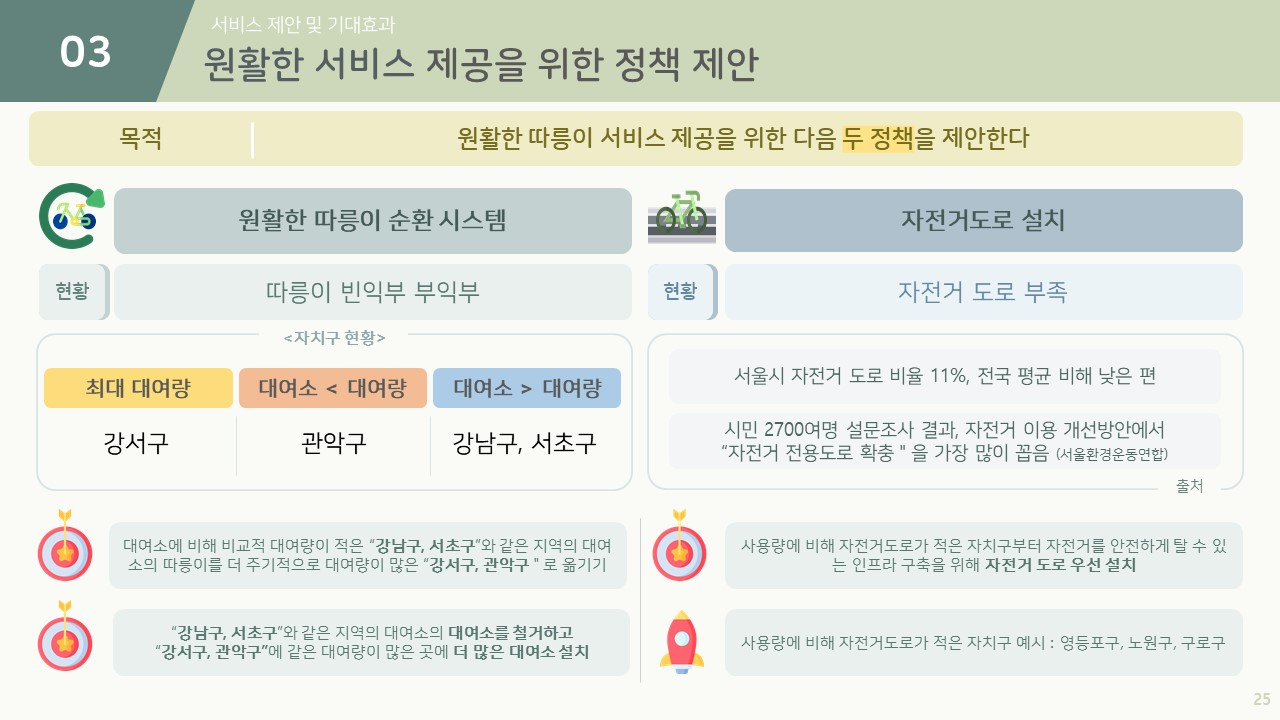

In [9]:
base64_data = "/9j/4AAQSkZJRgABAQEAYABgAAD/2wBDAAMCAgMCAgMDAwMEAwMEBQgFBQQEBQoHBwYIDAoMDAsKCwsNDhIQDQ4RDgsLEBYQERMUFRUVDA8XGBYUGBIUFRT/2wBDAQMEBAUEBQkFBQkUDQsNFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBT/wAARCALQBQADASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwDKooorU+UCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAoorrPhb4Z/4Szxxptm67raN/tE/p5ackH6nC/8AAqUpKKcmVFOTSR9JfCjwz/wingXTrV023Mq/aZ+Od784PuBhf+A119FFfNSk5NyZ78YqKSQUUUVJQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB8JUUUV9QfOBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAV9Dfs2+GPsmjX2uSpiS7fyISR/yzU/MR9W4/wCAV8/2VnLqF5BawJ5k88ixRqO7E4A/M19q+G9Ei8N6DYaZB/q7WFY9w/iIHLficn8a4MZPlhy9zuwsOaXN2NKiiivGPVFHJArY1jSSdeu7eEQ26pghZZFjGMDpuI9aqaZeQWDPO8RmuVx5KsBsVv7zeuOwp93qv9pWmLsNJeIf3dxnllzyr+vsfw+mi5eXUZr3Filz4qS3lVHH2VeNw25EGQc5x1HWqUOhtb6bqU1wsLNHEpjMc6OQd6jOFY9iasXl5FYeJI5pt/l/ZUU+WAT80AXoSPX1qot1p1nYX0VvLdSy3EaoPMhVVGHVs5Dn09K1fLd38xjNa/489I/69f8A2o9TaFo7XtreyNGuGiKQGTA3yZBwuepwD09adeQvMNEEaxM4ttwWZlVDiRzgliBTLzT9U1CQPPLbMVGFUXcIVB6KA2APpU21va//AAwGM6NGxVlKspwVYYINXdHaE3kcU1pHdCV1T52cbcnHG0irOqx38lqjXjW8vlnAlWeJ5SOwJViWH16VW029i0/zJwjPeLgQEgbEPdj6kdvz7VFuWWojctdPSXUrporG3gtrdbiM4lyzEIQCVZifToKj+zxTXFm8kYm8nTBMsJ6OwzgH27/hUem36alqKzOhW8+zzCZx92TEbYb2b19etVdWnktpdKlidopFtIyrKcEcmtrq1xitKuqaPdzS28MUtuybJII1jzuJBUgcH19eDTvEVrtjsp/NiO62hXyg3zj5OpHpUXiK4uhfzWk1y00cLkD5QoJ9cDjPvVXU71b6SBlUqI4I4ju9VUAms5NWaEadnDONBhltLJbmVrh1dvs4lIAVcDkHHU1ajg8nxPoYaBYJHSJpEWMJ8xJzkAVh6ZJH52yZrrY33VtSNxb6GujurK002GyvfK1BJouXkGxnjbOV3g5wcYxntWkdVfsM5GT/AFjfWtjSLq3u76ztX0u1ZZJEjZh5m4gkAn7/AF/CsZyC7EZxnjPWtOLULbTLcfYld7x0w9xKAPLyOQg9e24/hisY6O7ES2SKlprqqPlWIBf+/q066mttNtbADT7adpbcSO8pkySWYdmA7VDpP/IL1n/rgn/o1KfLeabeW9mLhrpJIIRERGikHBJ6k+/pV9P67ga2hae81vpVzHCpRBceY/APQ49zWNosME0cxntoWii+d55ncBASABhepJ9q19N8vdo3lbvL/wBK27+uMHGfeqfhqzkWYPMbU2MyMsiTTxjOMkZBbI+YD0NaWvypL+rIotXk2n6gpkggtrqSCLBjLSxtsQYyOcHA981hafOFkaNbCG9dz8quHJHsNrCt77IyaXci3t9Ps7uRlj/d3aMTGQd3LSHHbpg81Q0WO00vUEmvLxYpYWIMUaeYDx1DKSO/6VMk203/AF94ie3FvcR6TcpaRW0rXvlt5JbBUbD/ABMfWsvWrOez1Gfz4ZId7sy71IyMnkVfsTai60+KO/ln8u4VkiNuFXJZcnO729O1ZWpf8hG6/wCurfzNRL4Q6FaiiisSQooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD4Sooor6g+cCiiigAooooAKVVLsFUFmJwABkmkr1n9lvwtD4q+NGipcx+bb2Ie/dSMgmMfJ+TlD+FBcI88lFdTu/h/8AsT614g0qG/8AEerroBmQOllHB50yg9N+WUKfbn3weK0/Fv7DN7aWMs/h3xEmoXCglbO+g8rf7CQMRn6gD3FbX7Ynxi1zwtq2leGNA1K40pnt/tl3cWjmOVgzMqIHByB8rE465Fcp+yj8bPEU3xCtvDOt6vdarp2pRukP26VpmhlRS67WYkgEKRjpyKnXc9Hlw8Z+ya+Z85anpt3ouoXNhfW8lpeW0jRTQSrhkYHBBFer/Bn9mnX/AIuWo1M3Eei6DuKrfTJ5jTEHBEaAjIBBBJIGfXBx1X7bXhSHR/iHpmswRiMatafvsDG6WIhS312tGPwrg/D/AO0Z408L/D9PCOl3kNnZRlhHeRxkXUasxZkV84AyTzjcM8EU+hy8kKdRxqbI9q1H9g+L7Nmw8YOLgD7txYDYx+ofKjp2NfOPxI+Geu/CvxAdJ12BUlZfMhnhbdFMmSNynHqOhAI7iuo+CvjHxtd/FTQE0zVtUvbie8jFxG87ypJCXHmeYCSCu3JJPTr1r2/9uy6sf7F8K2zFTqX2iaRFzyItoDZHoW2fkaWtzWUadSk5wVrHx9RRRVHAFFFFABRRRQAUUUUAen/s++GP7b8afb5U3W2mJ5vPTzGyEH/oTf8AAa+nq87+BXhj/hHvAlvPIm261FvtT567Twg/75AP/AjXoleDiJ89R+R7eHhyU15hRRRXKdAUUUUASXFxJdSb5XLvtC5PoAAB+QFR0yaaO3jMksixoOrOQAPxp9MCSa4knWJZHLLEuxB6DJOPzJqOmTTR28MksrrHFGpZ3Y4CgDJJPpVLQvEGm+J9PW+0m+h1CzZigmt3DLkdR9aNdwNCimSzJBG0krrHGvJZjgD8aeDkZHIpAOjleFtyOyNgjKnBwetOmuJLjy/Mfd5aBF9lHQVHUcNzFcNIIpUkMbbXCMDtPofQ0wNb/hJNU730x/4FVS7vZ76QSXErSuBjcx5xUBOBk8CmRTJPGskTrJG3IZTkH8abk3uwLNre3FmXNvM8JcbWMbEEj0zRbXlxZzebBNJDJ/eRiDUNFK7AdJI0js7HLMck+pptFFICSO4khjlRHKpKu1x6gEHH5gVHTJJo4mRXkVGkOEViAWPoPWn0wJ4b6e3aMxyspjzs5yFz1wPeoKKKACimTTR28bSSusca8lnOAPxp/XkUgHRSvDIkiHa6EMrehFEkjSyM7HczHJPqTTaKYBRRRSAKKKKACiiigAopkk0cKhpHWNSQoLHAyegp9ABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRTGmjSRI2kVZHztUkAtjrgd6fQAUVHPcw2qqZpUiDMFUyMFyT0Az3qSgAopjTRrKsRkUSMCVQkZIHXAp9ABRRRQAUUUUAFFMhnjuF3RSLIuSNyMCMjqKfQAUVFb3UN0rGCaOYKxRjGwbDDqDjvUhYKwBIBPQetMBaKYZo1lERdRIw3BM8kDvin0gCiiigAoopGYKCScAckmgBaKbHIk0avGyujDIZTkEexp1ABRRTZJEhjZ5GVEUZLMcAD3NADqKRWDKGUgqRkEdDS0AFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB8JUUUV9QfOBRRRQAUUUUAFe/fsTsq/F+6DdTpMwX6+ZF/TNeA16L+z742g8A/FnQ9TvJBFYM7W1y7dFSRSu4+wJVvwoZtRko1ItnZftoKy/GQEggNpsBX3GXH8wa5H9m9S3xw8JADJ+1Mf/Ib19P8A7TvwA1L4sSaZrfh57dtVtYjbyQTPsE8RJZSr9MqS3B6huvHPPfs2/sy654D8XjxN4oFvbzWsbpZ2kMglbe4Ks7MOAApIAGc7u2OZvodsqM3iL20vcyf29GXzvBCgfOFvSfpmDH8jXzr8MfEGk+FfHmjatrun/wBqaTazF57XYr7htIB2twSCQ2D6V6f+2H45t/FnxQXTrORZbbRbf7KzqcgzElpMfT5V+qmptH/Y/wDEfiL4eaV4j0zVbOe9v4Ful02RTHiNgCmJMkFiCOCAB60+hlVUqlaUqavY948JftTfC26v47K18zQTcOEEk9isMZY8DcyEgDpyeB34rx39rP4O65o15/wmk2u3HiGwuJFt5DdKqyWmc7FAUBSnXoByeck5rlNB/ZH+JGqarFbXukRaRalwst5cXcLqg4JIVHZm4PYYzxkV9B/tca9pvhn4K/8ACOyziS/v2ggtY2OZCsTo7SfTCgZ9WpbPQ6G51KUvaq1tuh8K0UUVR5IUUUUAFFFFABWz4N8Ov4q8UabpSA4uJgJCvVUHLn8FBrGr3L9mnwx5lxqWvypxGPskBI7nDOfy2j8TWNafs4ORrShzzUT3iGFLeFIo1CRooVVXoAOAKfRRXzp7wVQ8Qap/Yeg6lqXlmX7HbSXHljq2xC2PxxV+s7XtX0nR9PaTWb2zsbKX9yz30yRxtkH5csQDkZ4qluB84fDzwLrf7QWn3nibxL4tv7e2e4eCGwsH2rHjB6H5VHI4xk4BJpnxA8N67+zgdK1/QPFF7qGmzXK282m6g+5X+UtggcEEKwyACuRg80668F6D4R1C6uPBHxgsNBtbpizWLXscqg54GVfoBwCVz7nmqsej+EdR1q01Dx98VYvFCWZDR2UIZos5yQcbvlOBnABPc1617yvf3e1v+AQdt+1hem7+EOmzx740uNQgcqeDgxSNgj8vyr1Hwut1d/DnSFtrjyL2XSoRHcSLv2SGEYcg9cHnHevGP2kvGWi+OPg5bX+hXyX9nHrMcDSIjLtcRSEjDAHoR2717d4D/wCRG8O/9g63/wDRS1xzTjRjddWV1PCvG2k+MtBsZrHxL8XdLtIbyFke2mt1DyRsCrYULuwRkZFc58OdLv8ATYRovhT4vaRapNMXW1+zlDJIQo48xcknCjA9K6Txv4S1bwX8XNX8Zaj4TXxvoFzFvUkq5tAFXJKMD90KcZGMHqDmuc8ROfj5p1na+C/h3FpSx3QEmtkRwrFgfMhKqMjDK3Un0Ga7Iu8V2fXS33Ena/HLTde0X4Ay2niDWF1nUvt0W+6jiEQZN+VUgYzjA7fyr1X4Uu0nwx8Js7FmOl22Sxyf9UtefftNWsll8EUt5pmuJYZrWN5m6uw4LH6nmqvwJ+D1xotv4c8Vt4o1C4imsFl/ss5EI8yLhT8xyF3ZHA5ANcrtKhdu2rH1GX3xR+L8d5OkHw8h8lXYJu3OcA8fMHAP1ArgvhyvxV+G97rlzZ+C5L19WlWab7UGO1lLnIw467znPoK774teLPE3iX4paX8O/DeqNoCzw+fc38ZIkPys5AI5ACr/AAkZJ5IArK8Y/Cvxj8M/Dt34l0b4iareT6ennzW94zGOVQeThnZTgHowOfWt4uKiotJc3TUDqJPFXi/xF8JvHcninw8PD08OmzC3aNiPNBifdwSSMYHOed3tUn7Kjs3whtQzEhbucKCeg3ZwPxJ/OrU/jGTx9+zjquuzRLDPdaNdiVEzt3oroxHsSpP415T8CPA/jnWvB9pf6H4y/sbSxdP/AKF5RfkMNxx0OfSs+VSpyTtHUD6sooorzijw39o3x7rvg3X/AATDo+oSWUV1cSNOqAES7WiADZHIwzce9e5V8iftUeMotY8fadZaaftX9gRF7iSP5lSVnUlTj02oD7nHUV7t4guNZ+Knw/0vUPA3iCPRpblkmeZhn5dpDREgEqwbGeP4cV3Tp/u6d9NxHnP7SErr8VfhoA7ALdKwAPQ+fHyPfgflXunjHU59F8I65qNsVFzaWM9xEWGRuSNmGR9RXyf4+8M+LfDXxK8DJ4s15NemlvImgdCx8tRMmRyo6nFfUvxI/wCSd+KP+wVdf+iWp1YpKmr3/wCHEcd+zj431jx74Amv9cuheXsV9Jbiby1QlQqMMhQB/Ee3pWX8YviNr3hT4m+BNI0y7W3sNQuEF3H5St5ytMqEEkEgYJ6Y6/THlfwI8KfEPXPBtxceFPFNtoumi9dGt5o9xMgRCW+43UFR17VF440HxdoPxb8Ax+Ltch1y4kvbdoJIV2hF+0JkH5V71t7GHtnquugX0PW/2sXZfhK4ViA19CGAPUfMcH8QPyru/hS7SfDHwmzsWY6XbZLHJ/1S1wf7WX/JJz/1/wAP8mruvhL/AMkv8Jf9gq2/9FLXLL+AvVj6nWV4z+1J4x1Xwh4J0x9H1GbTbu4v1RpIG2uYxG5Iz6Z2113xG+MXhv4Z27DUrvztQK5j0+2w0zehI/hHu2PbNeHw+FfFn7T2uJrGsxN4f8LW8Ui2K9ckjgqDy+W2lmwAQuBToU7NVJ6RQM+k/Ceovq/hbR76SQSyXVnDM0gxhiyAk8fWtWvmLwd8TvEXwBmh8KeOdMmn0ZGK2epW/wA+1M/wk8Ogz04ZQenQV9FeHfE2leLtLj1HR76HULN+kkLZwfRh1U+xwayq0nB36dwNOvPfitH8RZW08eBZrCGPD/ajdBS5PG3G4EY6+9ehUVlF8ruM+ULX4ifGe88f3Pg2PUtPOtW6b3UwQiPGxX+9t9GFdf8AEKTx3Zfs+eLj4zuLX+0fMgWCSxIUmJp4gwbaAOckfQnNcH4f+IWmSftYXOsCdRpl5cPYJc7vkJEQiVs9MFlXn0bNdH+0ZD8TP7D8SveT6f8A8IR5seI4Qvm+X5yeXnI3Z3bc8+vavQa9+KslszTqjn/i1dTTfsz/AA7Z5XdjMmSzE9I5APyFfWtqS1tEScnYP5V8i/Fb/k2X4df9dl/9FyV9XXWsWGh6THd6le2+n2iqoae6lWJASOMsxArCt8K9WSzyTxd8E/G2veJdR1Cw+JuqabZ3Mxkis43mVYVPRAFkAwOnQVkf8M+/EH/orWrf9/bj/wCPV61/wtTwX/0N+g/+DOD/AOKrxL4C/FKBfGvjs+IfFcCWUt0JLQ6jfqsZ/eSf6re2Mbdv3eMY9qcZVOVvt5D1OQ+LWk+Pvgs2i3j/ABD1bVvtUr7Ua5mCqU2nDKzsGB3dD6V9iV4L8ZrHwp8VdW8MSL4/8OWthpszvcwyajEWkVihO3DdcJjn1r2LT/GOg6tZXd5Ya1p9/a2il7ia0uUlWIAE5YqTjgE8+lTUblGN1qJ7HkP7TnxA1zwy3h3QtGvzow1eRxPqQJQxqrIAA45UDdliOcY96ZF+yRoOpW6S6z4m13VLxvne4WeMKxI6gMjn9TV7x58RPg/8SNHGna3rsE0aNvimjilWWFvVW2ce46HuK8wi0vwLpO2PRPjVrOlWy52RKs/yj0+TaP0rWHMopK6foNbG58Sfg/L8E/DE3ibwp4z1awe0eNfsl3OpE+WC7RtCg4znaVIwDXufwr8VXXjb4e6Jrd9EsV3dwbpVVcAsGKlgOwO3P4186Wfh74S3V5FceJPiVqXiTysbYrjzlQ+x+Vmx9CK968I/FrwFq91Y6B4f1i1aXZ5dtZwxPGNqqTtXKgcAHj2qKqbjazb72B7HeVwPxu+I8nwv8Bz6rbxLNfSyra2qyfdEjAncR3ACscd8V31cF8bPhu/xQ8CXGkwSrDfRSrdWrSfc8xQRhvQEMwz2zXPC3MubYlHmmh/Cf4neNNJtta1b4lX+jXV0guEs7MPtQMAQGCOijjHABxVjwD468X+A/ipB8P8AxnfLrUN7FvsdR/j5DFSTgEglGXByQw64qvoXxW+J/gvS7fRdV+G99rNzaoLeO8tN+1goAUsUR1PHcEA1Z+H/AIF8X+PPipB8QPGdimixWUXl2Onfx9GCgjkgDezZOCW7AV1u9nz2t02K9Sh8ZJpE/aa+HSrIyqEt8AE45nkB/McGvVPir4o8XeGbKwfwl4cXX5ppGE+8nEKgDHyggnOTznjHvXlHxm/5Ob+Hf+5bf+lEle5+PfE58GeDdY1sRCd7G2aVImyAzAfKDjtnGazl9jS+gn0PmP4pj4sfFax0+1v/AATJYpZytMn2QMNzEYycuenb6mu+s/ip8YpLyBZvhzCYWcB9u9DjPPzFyB9SKxfAfw78Z/GLw7F4p1n4g6lpy3xdrezsGZURVZlztVlUcr0A6Dk56a3w78TeKfAPxiHw88Q60/iWyu4GmtL2fJlTCM4JJJbkIwKknGAQfXWVrOKSdvUoo/EuaRf2sPBAV2AFrCBgngF5wR+Ir6Or5Y+POnajq37R3hmz0m+/szUprKFYLvGfKbzJua9w+F/hbxV4Xtb+PxR4l/4SKSZ1aBvL2+UADuGTyc8fTHvWVVLki79CXsjt68K134Z/Fy61e+uLT4hW8FlJM7xI25NiEkgYCEDA9+1e614h8avjtb6Wk/hPwoG1jxReZtf9FHmLbluCOPvSdflHQ9emDnS5r2ihI8w+FNz8U/i3a6jNpvjprP7C6JIt05ydwJBG1Dx8pr6I8K6P4j8N/D+9tvEmtDWtWSOZxdxqV2rt+Vc4BJHJzjv7V88eFLXxT+yzrltqGsWDXvh7V4Y1vja4byZBkhc9N6EtjJwwJwfTs9Y+A3gv4pQ6r420zxFqF1HfGW7IjdCqvjJQhl3Lg/wnkDFdNSzf930LZZ/YzZj4D1sEkgakSB/2ySuj8ZfFnxvoPiW+0/S/hxe6tYwMFivkkfbMMA7hhCB1x17Vzf7GX/Iia3/2Ev8A2klei/F74taX8LfD0s08qyatPGwsrJTl5HxgMR2QHqT9BzWc9azVrie581/s+/ELxT4R03WYtC8I3XiiOedJJZIWf9020jBwp5P9K7Tx7rmo6x8bPhNeX9lNo91NFDJJYSOSYWadgw6DqAM8dODWB+z/AOMJfgvrz6R4ttZdKsPEEMNzbXU64VDztLeikNgn+EqM4GSNz9orRofFnxu8DaY1xJFb39vFEZ7dhuCtM43KeneuiVvavT5/IfU2/Fkr/wDDYHhMb2wNPKgZ7eXcHFfQtfJ+i+ALb4b/ALUPhbSbW9ur+Jrd5/NvGDPloZhjgDj5f1r6wrkrW923YmRzvj5fEjeF7seE2tk1slfJa7+4BuG7rxnGcZ4r5y8bfET4z/D/AFDSbPV9S09JtUdktxDBC4JBUHJ28cuK+r6+T/2uvFdv/wAJ14as7dhNc6OhuZ1U/dLuhVT6HCA/RhVYf3pcrSYR3PW/hnD8WIvELf8ACZz6bNo5hb/UBBIJONuNgHvnNePfBrULq6+AvxRea5llcxyuWdyTuaE7j9T39a9h8eaj8QfEkOj6l8ObzTTo91bCZpJ9hdmJyPvAjGMdOcg5rxb4J/8AJAfif/1xf/0Sa0jrFvTp+Yz2r9mFi3wU0HJJw1wBn/rvJXBt468ffHDxhq2n+CtSi8P+HNNfy3vyvzS8kA5wWycMQFxgdTnFdz+zGvmfBHRFyV3NcjKnBH7+TpXm37NfivTfhnq3ifwf4luodH1BLvckt24jjcqNpXcTgHgEc8g8VNvenJK7Qdy1q3iv4kfAHVdLn8TarH4q8MXUggkl25kjPU4JAYPtBIySDg/h3P7TV4tz8D9Tnt5d0M7WzKykgOplQj8OlcX+1D8QNG8VaBpfhTQbyDW9Wu76N9ljIsoTAZQu4ZG4swGM5657Z6X4/wCmPov7On9nSNvktIrK3Zs5yUZFJ/Snu4Sas7h2Oy+BcjSfCHwqWYsfsSjLHPAJAH5V3VfOPwL+FviptM8LeIV8eX8ejbVn/sYGRovLycx4L7cH/d4zX0dXPVSU3Z3Je4UUUViIKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAPhKiiivqD5wKKKKACiiigAooooA9Z8BftQeO/h/psOnW17b6np8I2w2+pxGURr2UMGVsDsM4HatHxV+158QvE9hJaR3Nlokci7XfS4GSQj2d2Yr9VINeK0UWNvbVLcvMKzF2LMSzE5JPJNeh/D/AOP3jb4a262mlasZdOX7tjer50K9/lB5XvwpHWvO6KDOMpRd4ux7/cftteP5rUxJZ6HBJjHnx2spce+GlK5/CvFvFHizWPGmrSalrmoz6nevwZZ2zgeijoo9gAKyaKC5VJz0k7hRRRQZBRRRQAUUUUAKqlmCqCSTgAV9lfD/AMNDwl4P0zTSoE0cQab3kb5m/U4+gFfN3wX8M/8ACTePbESJutrL/S5eOPlI2j8WK/hmvrOvKxk9VBHp4SGjmFFFFeYegFYHjHwHoXj/AE+Gy1+wF/bQyeai+a8ZVsEZyjA9Ce9b9FNNxd0B86fHD4C+FvDnw8vdQ8NeHpU1SKWLDQzzzMELgN8rOQevpWjo/wAH9D034Q6fq8HgeDWvE50+GVrO6d0aWQ7d2QTwQCTjAPGO9YGuePk8H/tWX0+tarNZ6JHAkWGLtEoa1UgbRnjec9Opr1X/AIaE+Hn/AEM1v/35l/8AiK9GTrKMUrvr1+4nQ+ePi3q/iRfh/BpN78P7fwfoy36ziS1XarTbHGCO5Izz/sivpnTNJu9e+EulWFhqcujXk+lWyx30K7nhPlocgZH06jrXNeIvi/8ACjxZppsNY1iy1CzLB/JmglI3Dofu8H/GvSNB1HT9W0azu9Kljm02WJTbvCMIUxgYHb0x7VlVnLljeNrP+twR82fELQrvwPImmeJPjRqyNewM32cabLKHjOVOcSkYPI/OuP0NvBug2f2O0+LXiGzs2YvJb2NjPBG7EAFtoYjPA656V6x8fviNqfh/xt4f0DT4tFgF5CJG1DWYQ0cW6Rl5ZuFUbck471zv9peJP+hy+E//AH+j/wDjddcJScE319P8hGTfeIfh9qnw/v8AwxN8Q9YuZLu6juVvtTs5pxEU/hC4zg89+uD2r6Y8E2Frpfg3QrOxuvt1lBYwxw3QGPOQIAr49xg/jXzL4q0fWPGOktpt942+GEVuzq5e1u0ikBHowjzX0t4BsYNL8E6DZWt7DqUFrZQwLd27Bo5diBSykcYJBrmxFuVWfX+uiGjgvjV8LrTXLyz8WW3iOLwlrenqI11G4kEcLDJ2hmJG05YjPOc4IPbm7z4Q/Ezx5ZpYeJvH1nNoMmGZdPiBMycEZ2ogOfckdDzWr+1uCfhTHgEgajCT/wB8vSeAv2hPAGjeBfDun3uveTeWmnW9vNH9juG2ukSqwyIyDyDyDTh7T2SlHX5XsGlzrPGXhuy8I/BDX9H02No7Oz0a5jjVjkn92xJJ9SSSfc1zv7KYP/Co7bj/AJe5/wD0IVoTftIfDO4heKXxAskTqVZHsLkqwPBBHl8iur+H/ijwx4o0Pf4Tlt30u2kMPl21uYFjb7xGwquOuenOaylzxpuMovV3uM6avMPjp4p8V6LpNhpfhHSrm71HVnaD7bAhYWoGO/RWOThmwAFJ7cen0VzwkoyTauM8q+E/wJ03wT4ZvYdYji1bVtWiKahLJ8y7G5MSk84zyT1J57DHIeFfAvjD4K/Eq3stCgm1vwTq1wBKpOfsoJwXb+6yj+Lo4GOuMfQlFa+3ld82txWPnL9pH/kq3w2/6+U/9Hx17p410+fVvBuvWNsnmXN1YXEESZxuZo2UD8yK8a/aC0DUtU+J3w5uLOwuLqBLpVeSGMsqETRsdxHTjJ57A+hr36rqStCm15/mB8pfCHxt40+E/hm40Y/DLXNV8y7e584QzRYyqLtx5LZ+51z3pfEN94w+LHxS8F6jN4C1fQYNOu4fMa4ilZNomV2dnaNAoAFfVlFV9YXM5qOr9QseM/tZf8knP/X/AA/yau6+Ev8AyS/wl/2Crb/0Utcd+1Jpl5qvwrkjsrWa7kS8hdkhQuwX5hnA7ZIrsPAel3kPwr0LTnaTTb8aRDCWZPngk8oDO091Pb2qHb2EV5h1KV78FfCWp+Np/FN9p327UZtpMdw5eEMqhQ2w8E4A65Htmu5VQqgAYA4AFeBN8AfiAzE/8LY1b/v7cD/2rSf8KA+IH/RWNW/7+3H/AMdqnGMrXqfmB7jrWh6f4k02Ww1Szhv7OUfPDOgZT7+x9xyKwvAPwy0L4a299DocM0Ud5KJZBNKZMYGAoz2GT788k15X/wAKA+IH/RWNW/7+3H/x2ui8A/CLxh4V8UWmpan8Q9Q1qxiDiSxnMrpLlSBnfIwGCQc4zxUuMYxaVT5ageu14z+0Dq/jK/k03wf4U0y4I1hCLnVEU7I0zgoXAwgxyxPYgDrXs1FYRlyu9rlHiN9+y/o0vwsi8OQSqutQM10mqMuN1wQAwI/uEALjsADyevK+Jbrxh/wzP4q0/wAZWMtve6dNbW8N1MwLXEYuIsEn+LHTd3475J+mK4f42eFNQ8bfC/W9F0qNZb+4WIxRu4QMUmRyMngEhT1raFVuSUu40z55+K3/ACbL8Ov+uy/+i5K+nfE/gvSPH3huPStbtftdkdkmwSMhDAcEFSD3P514D8ZvAeuaf8BfBGijT5rvUbK4jSeG0UzFGMb8fLnuQM9M19N26lLeJSMEKAfyqqkvdTT6sGeCeNPhD8F/h9bxy68rWJkBMcRvJ3kkx12opJP1xivOn1L9n9Zgg0nW3X/norybR+cmf0rX8UyaRo/7UN9dfECASaPLEpsZLmMvbj92gQkYIKghweMbuTXv9t4u8Bm1RoNZ8Oi3C/LsuYAoA/HjFaczildt38x7HjngjwD8DPiFcC10jzWviCRZ3F1PFKccnAY/Nxz8pNexeCPhP4Y+HsN/HouneSt8FW486VpfMUA4U7iePmbjvnmvnP42XXhnxF8RPC8Xw7S3n8RfaP39xpKfumbcpjJKDDEYYlh26n0+u6zquSS1evRiZ4Z8UND0LwLdWUekfByHxWlwjPJLZWuFiIONp2xPyffH41xH/CRRf9G43H/gNJ/8jV0/7SHxA8Q+H/GXhbQ9J17/AIR6zvlBuLvCgJukCb3YjIVRk8Ed81mfY9Y/6OE0n/wIh/8Ajtax+FOXX1KRh6h4y0/SbOW7vv2emsrSIbpJ7iJ0RB0yWNsAPxr2v4R6V4O8QeHdK8X6H4WsdGuLhJNhWBPNiIZo3AYD/ZYZGMg++K8k1jw5ea9ptxp+ofHzRrqyuF2SwvcQ7XGc4P72vb/g9oem+Gfh3pWk6VrNvr9raeYv261dWR3aRnYDaSBgsRjPaoqtcmm/z/UT2OzrzP4k6D8UdU1yKXwZ4j0vSdKEIV4byIM5kycnJhfjGO46dK9MorkjLldyT5O+JXib4yfDe50W01fxhYzHVpHjhawt4vlKFAdxMCkf6wdM9DXa/wDCpfi7fbvtfxKWHcRn7MHHHthVx9Kd+074R1nxNrXgF9J0y61BLe7mWZreMuItzQlS2PujCNyeBiveq6pVLQi0ld+RV9D5h+Jlncaf+0F8LbW8u21C7gtbKOa7ZdpmcTOGcjtkgnHvX0jrWj2viDSbzTL6LzrO7iaGaPOMqwwee31rwr4uaBqV9+0b8P722sLiezjSHfcRxFkTZO7NlgMDAIPPrX0FUVHpD0E+h846L8LfG/g7UL3QfAfxJ0w2tu++TTrzY81sGOeU2SbT74XPXiu1+GPwRuPC/iafxX4m1p/EPiaZCgmwRHCCMHGeSccDgADIxXkvg/xzovw9/aS8dah4gvTp9nL9qgSQwySZczxsBhFJ6KecYr2P/hpr4a/9DJ/5I3P/AMbrWp7TZK9/Ibuef/ExT/w1j4J4/wCXaE/+Pz19IV5bY/HD4XeIPEWntDqlrcayzC3tbiXT5lkUucbVkaMbQc+oHNepVhUbtFNWsJhXCeDPhN4S+FZv9SsLcQyuGklv76Xe0UfUqHP3VHf17k4ru64D49aVqGtfCPxHaaYkkt20KMI4lyzqsis6gdyVDVEb35b2TEjhfEn7TnhnWpLrRtL8N6h4wt5EKSokA8qQZxjaQWI9yo7Vz/hP40+F/h3o8miXHgTXPCmlXskjSO+6T5nXaTmTBPAA46Behrd/Zx+JXgfSfh3Y6XLqdhomqQlzeJeyLAZXLHD72wGyCB1yMY7V2PxI+LHgG18J6pb6jrGm6uksDx/2fazpPJIxHC7VJ2nOOTjHXtXTZRfIosrysHwB8G6J4R8Eu+gay2u2GoTm6W6ZAmPlC7NvYjbznnOeBUF98FvDVn451Xx7r13NqAjU3QhvfmhtQi5LY/iCgEgHgehODXO/sg6XqGn/AA3vJrtJIra7v2ltVkUjcuxFLj1BIx/wE17jPDHdQyQzRrLDIpR45FDKykYIIPUEVlUk41JWYnozw/x38Wfg18RtFbTdb1rzogd0UyWNyssLf3kbyuD+h7g1xt1rfwmPiXwVqVp44uIbfwzEkKW82nXMjTqjFly/ljack54IxwAK99/4VZ4L/wChQ0H/AMFkH/xNH/CrPBf/AEKGg/8Agsg/+Jqo1IRVlf8AALo8s0vVPBHxI+PWieJNG8WrPfWto8S6W1lLGZiEkGVd1UcK5OOT8v5e918wXGh6d4e/a+0K00uxt9OtfI3+RaxLGgY20uSFAwK+n6mskuW3YGcZ8XPFes+DvBN1f6Dpc2raozrDFHDGZPLLZHmFRyQPT1Irzz4U/s/o2g6vqXjhW1DXfEERW4WRsvboxDYz/wA9MhST2KgDvn3aioVRxjyoVzwz4L+FfGfwv8ZX/hO7hk1LweyvcWmonhYjngD0J6FPXkcZJ80+Cf8AyQH4n/8AXF//AESa+vq+cfAvwn8R+Bfgv8Q9N1KzBvbyKX7NDbuJWlVYiAQFz17Dr7VvGpzJt76FXO5/Zf8A+SKaF/v3H/o+Sm/G3SfhpGdPvPHNnGtxdSeRBdRCRJTjGSzRkZVQR97IGatfs3addaX8HNCgvLeW1nzO/lzIVYAzOQcHnkEH8a83/bVU/wBleFTjgTXAz/wGOlFc1dq/Vi+0eu+DPgp4N8A3i3mkaOiXyrtF1PI00g913EhT7qBXP/tSIz/BfWCqltstuTgdB5y81Y/4aa+Gv/QyY/7cbn/43Uc/7SXwwuoXim8QJNE4w0cmn3LKR6EGKpSqcyk02Gt7mz8ClK/CHwqCCD9iU8+5Nd3WT4V8SaT4s0K21LQ7lLrTJAVikjQoPlO0jaQCMY6EVrVjLWTbJCiiioAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAPhKiiivqD5wKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooq5oulTa5q1np9uMz3UqxJ7EnGT7CjbUe59Efs6+Gf7L8Jz6rKmJ9Rk+Qkc+UmQPzbcfyr1mqulabDo+mWljbLtgtoliQeyjAq1XzlSftJuR71OPJFRCiiisjQKKKKAOf1z4f+GvE14LvVtC0/ULraE864t1Z9o6DJFZ3/CnfA/8A0Kmk/wDgKn+FdjRV88lomBx3/CnfA/8A0Kmk/wDgKn+FdTp+n22lWUNnZW8drawqEjhhQKiKOwA6VYopOUpbsDm/Fnw48NeOpLeTXdJh1CSAFY5HLKyg9RlSDj2rn/8Ahnv4ef8AQs2//f6X/wCLr0SiqVScVZNged/8M9/Dz/oWbf8A7/S//F12uh6HYeGdJt9M0y2SzsbcFYoY84UEknr7kn8av0UpTlLSTuBT1bR7HXrCWx1Kzhv7OTG+C4jDo2DkZB965r/hTvgf/oVNJ/8AAVP8K7GihSlHZgcd/wAKd8D/APQqaT/4Cp/hW/oPhvSvC9m1rpGnW2m2zOZGitYgiljxk46nAH5VpUUOUno2AUUUVABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAGR4k8I6L4wsxba1pdrqcK52C4jDFM9Sp6qfcEVwcn7Mfw3kmEn9gMo7xre3G0/+P5/KvU6KtTlHRMd2c14T+G/hjwPzoeiWthJjaZlXdKR6GRssR7ZrpaKKltvViOb8XfDnw348a3bXtJh1F7cERO5ZWUHqMqQccdK53/hnf4df9Cxb/8Af6X/AOLr0aiqU5JWTHdnnP8Awzv8Ov8AoWLf/v8AS/8Axddf4X8I6R4L0v8As7RLGPT7PeZTFGScscZJJJJPA/KteihzlLRsAoooqBBRRRQAUUUUAc1rHw08J+INQkvtS8O6be3kmN881srO2BgZOOeP5VS/4U14F/6FPSf/AAET/Cuyoq+aXcdzlLH4UeDdNvIbu18MaVBcwuJI5UtU3Iw5BHHBBrq6KKTbe4goooqQOG8RfA/wL4qu3utR8OWr3DnLyQM8DOfVvLZcn3NU9H/Z5+HuiTxzweG4JpUwQ13LJOCR3KuxX9K9ForT2k7WuO7GxRJBEkUSLHGgCqijAUDgADsKdRRWYgooooAwp/AuhXXiy38TS6bG+u28RhjvNzblUgjpnaThiMkZwa3aKKd29wCiiikAUUUUAFZuveGdJ8U2a2usaba6nbq29Y7qISBW6ZGeh5P51pUU9tgON/4U14F/6FPSf/ARP8KP+FNeBf8AoU9J/wDARP8ACuyoqueXcd2U9J0ex0HT4rHTbOGws4s7ILeMIi5OTgD1JJ/GrlFFSIKKKKQBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB80f8Ms/FD/oWP8AyoWv/wAdo/4ZZ+KH/Qsf+VC1/wDjtfoJRX0XOzn+o0+7/r5H59/8Ms/FD/oWP/Kha/8Ax2j/AIZZ+KH/AELH/lQtf/jtfoJRRzsPqNPu/wCvkfn3/wAMs/FD/oWP/Kha/wDx2j/hln4of9Cx/wCVC1/+O1+gTzJH991T/eOKZ9sg/wCe8f8A32Kl1kt2P6jT7v8Ar5HwB/wyz8UP+hY/8qFr/wDHaP8Ahln4of8AQsf+VC1/+O19/wD2yD/nvH/32KPtkH/PeP8A77FL2y7oPqMO7/r5HwB/wyz8UP8AoWP/ACoWv/x2j/hln4of9Cx/5ULX/wCO19//AGyD/nvH/wB9ij7ZB/z3j/77FHtl3QfUYd3/AF8j4A/4ZZ+KH/Qsf+VC1/8AjtH/AAyz8UP+hY/8qFr/APHa+/8A7ZB/z3j/AO+xR9sg/wCe8f8A32KPbLug+ow7v+vkfAH/AAyz8UP+hY/8qFr/APHaP+GWfih/0LH/AJULX/47X3/9sg/57x/99ij7ZB/z3j/77FHtl3QfUYd3/XyPgD/hln4of9Cx/wCVC1/+O0f8Ms/FD/oWP/Kha/8Ax2vv/wC2Qf8APeP/AL7FH2yD/nvH/wB9ij2y7oPqMO7/AK+R8Af8Ms/FD/oWP/Kha/8Ax2j/AIZZ+KH/AELH/lQtf/jtff8A9sg/57x/99ij7ZB/z3j/AO+xR7Zd0H1GHd/18j4A/wCGWfih/wBCx/5ULX/47Xe/Bn9m/wAZeHvFTapruiC1S3ib7OPtUEm6RuM/K5xhd3X1FfYX2yD/AJ7x/wDfYo+2Qf8APeP/AL7FRKpGcXFvcqODhFqSueZf8IXrP/Pn/wCRU/8AiqP+EL1n/nz/APIqf/FV6b9sg/57x/8AfYo+2Qf894/++xXH7Gl/N+R18h5l/wAIXrP/AD5/+RU/+Ko/4QvWf+fP/wAip/8AFV6b9sg/57x/99ij7ZB/z3j/AO+xR7Gl/N+Qch5l/wAIXrP/AD5/+RU/+Ko/4QvWf+fP/wAip/8AFV6b9sg/57x/99ij7ZB/z3j/AO+xR7Gl/N+Qch5l/wAIXrP/AD5/+RU/+Ko/4QvWf+fP/wAip/8AFV6b9sg/57x/99ij7ZB/z3j/AO+xR7Gl/N+Qch5l/wAIXrP/AD5/+RU/+Ko/4QvWf+fP/wAip/8AFV6b9sg/57x/99ij7ZB/z3j/AO+xR7Gl/N+Qch5l/wAIXrP/AD5/+RU/+Ko/4QvWf+fP/wAip/8AFV6b9sg/57x/99ij7ZB/z3j/AO+xR7Gl/N+Qch5l/wAIXrP/AD5/+RU/+Ko/4QvWf+fP/wAip/8AFV6b9sg/57x/99ij7ZB/z3j/AO+xR7Gl/N+Qch5l/wAIXrP/AD5/+RU/+Ko/4QvWf+fP/wAip/8AFV6b9sg/57x/99ij7ZB/z3j/AO+xR7Gl/N+Qch5l/wAIXrP/AD5/+RU/+Ko/4QvWf+fP/wAip/8AFV6b9sg/57x/99ij7ZB/z3j/AO+xR7Gl/N+Qch5l/wAIXrP/AD5/+RU/+Ko/4QvWf+fP/wAip/8AFV6b9sg/57x/99ij7ZB/z3j/AO+xR7Gl/N+Qch5l/wAIXrP/AD5/+RU/+Ko/4QvWf+fP/wAip/8AFV6b9sg/57x/99ij7ZB/z3j/AO+xR7Gl/N+Qch5l/wAIXrP/AD5/+RU/+Ko/4QvWf+fP/wAip/8AFV6b9sg/57x/99ij7ZB/z3j/AO+xR7Gl/N+Qch5l/wAIXrP/AD5/+RU/+Ko/4QvWf+fP/wAip/8AFV6b9sg/57x/99ij7ZB/z3j/AO+xR7Gl/N+Qch5l/wAIXrP/AD5/+RU/+Ko/4QvWf+fP/wAip/8AFV6b9sg/57x/99ij7ZB/z3j/AO+xR7Gl/N+Qch5l/wAIXrP/AD5/+RU/+Ko/4QvWf+fP/wAip/8AFV6b9sg/57x/99ij7ZB/z3j/AO+xR7Gl/N+Qch5l/wAIXrP/AD5/+RU/+Ko/4QvWf+fP/wAip/8AFV6b9sg/57x/99ij7ZB/z3j/AO+xR7Gl/N+Qch5l/wAIXrP/AD5/+RU/+Ko/4QvWf+fP/wAip/8AFV6b9sg/57x/99ij7ZB/z3j/AO+xR7Gl/N+Qch5l/wAIXrP/AD5/+RU/+Ko/4QvWf+fP/wAip/8AFV6b9sg/57x/99ij7ZB/z3j/AO+xR7Gl/N+Qch5l/wAIXrP/AD5/+RU/+Ko/4QvWf+fP/wAip/8AFV6b9sg/57x/99ij7ZB/z3j/AO+xR7Gl/N+Qch5l/wAIXrP/AD5/+RU/+Ko/4QvWf+fP/wAip/8AFV6b9sg/57x/99ij7ZB/z3j/AO+xR7Gl/N+Qch5l/wAIXrP/AD5/+RU/+Ko/4QvWf+fP/wAip/8AFV6b9sg/57x/99ij7ZB/z3j/AO+xR7Gl/N+Qch5l/wAIXrP/AD5/+RU/+Ko/4QvWf+fP/wAip/8AFV6b9sg/57x/99ij7ZB/z3j/AO+xR7Gl/N+Qch5l/wAIXrP/AD5/+RU/+Ko/4QvWf+fP/wAip/8AFV6b9sg/57x/99ij7ZB/z3j/AO+xR7Gl/N+Qch5l/wAIXrP/AD5/+RU/+Ko/4QvWf+fP/wAip/8AFV6b9sg/57x/99ij7ZB/z3j/AO+xR7Gl/N+Qch5l/wAIXrP/AD5/+RU/+Ko/4QvWf+fP/wAip/8AFV6b9sg/57x/99ij7ZB/z3j/AO+xR7Gl/N+Qch5l/wAIXrP/AD5/+RU/+Ko/4QvWf+fP/wAip/8AFV6b9sg/57x/99ij7ZB/z3j/AO+xR7Gl/N+Qch5l/wAIXrP/AD5/+RU/+Ko/4QvWf+fP/wAip/8AFV6b9sg/57x/99ij7ZB/z3j/AO+xR7Gl/N+Qch5l/wAIXrP/AD5/+RU/+Ko/4QvWf+fP/wAip/8AFV6b9sg/57x/99ij7ZB/z3j/AO+xR7Gl/N+Qch5l/wAIXrP/AD5/+RU/+Ko/4QvWf+fP/wAip/8AFV6b9sg/57x/99ij7ZB/z3j/AO+xR7Gl/N+Qch5l/wAIXrP/AD5/+RU/+Ko/4QvWf+fP/wAip/8AFV6b9sg/57x/99ij7ZB/z3j/AO+xR7Gl/N+Qch5l/wAIXrP/AD5/+RU/+Ko/4QvWf+fP/wAip/8AFV6b9sg/57x/99ij7ZB/z3j/AO+xR7Gl/N+Qch5l/wAIXrP/AD5/+RU/+Ko/4QvWf+fP/wAip/8AFV6b9sg/57x/99ij7ZB/z3j/AO+xR7Gl/N+Qch5l/wAIXrP/AD5/+RU/+Ko/4QvWf+fP/wAip/8AFV6b9sg/57x/99ij7ZB/z3j/AO+xR7Gl/N+Qch5l/wAIXrP/AD5/+RU/+Ko/4QvWf+fP/wAip/8AFV6b9sg/57x/99ij7ZB/z3j/AO+xR7Gl/N+Qch5l/wAIXrP/AD5/+RU/+Ko/4QvWf+fP/wAip/8AFV6b9sg/57x/99ij7ZB/z3j/AO+xR7Gl/N+Qch5l/wAIXrP/AD5/+RU/+Ko/4QvWf+fP/wAip/8AFV6b9sg/57x/99ij7ZB/z3j/AO+xR7Gl/N+Qch5l/wAIXrP/AD5/+RU/+Ko/4QvWf+fP/wAip/8AFV6b9sg/57x/99ij7ZB/z3j/AO+xR7Gl/N+Qch5l/wAIXrP/AD5/+RU/+Ko/4QvWf+fP/wAip/8AFV6b9sg/57x/99ij7ZB/z3j/AO+xR7Gl/N+Qch5l/wAIXrP/AD5/+RU/+Ko/4QvWf+fP/wAip/8AFV6b9sg/57x/99ij7ZB/z3j/AO+xR7Gl/N+Qch5l/wAIXrP/AD5/+RU/+Ko/4QvWf+fP/wAip/8AFV6b9sg/57x/99ij7ZB/z3j/AO+xR7Gl/N+Qch5l/wAIXrP/AD5/+RU/+Ko/4QvWf+fP/wAip/8AFV6b9sg/57x/99ij7ZB/z3j/AO+xR7Gl/N+Qch5l/wAIXrP/AD5/+RU/+Ko/4QvWf+fP/wAip/8AFV6b9sg/57x/99ij7ZB/z3j/AO+xR7Gl/N+Qch5l/wAIXrP/AD5/+RU/+Ko/4QvWf+fP/wAip/8AFV6b9sg/57x/99ij7ZB/z3j/AO+xR7Gl/N+Qch5l/wAIXrP/AD5/+RU/+Ko/4QvWf+fP/wAip/8AFV6b9sg/57x/99ij7ZB/z3j/AO+xR7Gl/N+Qch5l/wAIXrP/AD5/+RU/+Ko/4QvWf+fP/wAip/8AFV6b9sg/57x/99ij7ZB/z3j/AO+xR7Gl/N+Qch5l/wAIXrP/AD5/+RU/+Ko/4QvWf+fP/wAip/8AFV6b9sg/57x/99ij7ZB/z3j/AO+xR7Gl/N+Qch5l/wAIXrP/AD5/+RU/+Ko/4QvWf+fP/wAip/8AFV6b9sg/57x/99ij7ZB/z3j/AO+xR7Gl/N+Qch5l/wAIXrP/AD5/+RU/+Ko/4QvWf+fP/wAip/8AFV6b9sg/57x/99ij7ZB/z3j/AO+xR7Gl/N+Qch5l/wAIXrP/AD5/+RU/+Ko/4QvWf+fP/wAip/8AFV6b9sg/57x/99ij7ZB/z3j/AO+xR7Gl/N+Qch5l/wAIXrP/AD5/+RU/+Ko/4QvWf+fP/wAip/8AFV6b9sg/57x/99ij7ZB/z3j/AO+xR7Gl/N+Qch5l/wAIXrP/AD5/+RU/+Ko/4QvWf+fP/wAip/8AFV6b9sg/57x/99ij7ZB/z3j/AO+xR7Gl/N+Qch5l/wAIXrP/AD5/+RU/+Ko/4QvWf+fP/wAip/8AFV6b9sg/57x/99ij7ZB/z3j/AO+xR7Gl/N+Qch5l/wAIXrP/AD5/+RU/+Ko/4QvWf+fP/wAip/8AFV6b9sg/57x/99ij7ZB/z3j/AO+xR7Gl/N+Qch5l/wAIXrP/AD5/+RU/+Ko/4QvWf+fP/wAip/8AFV6b9sg/57x/99ij7ZB/z3j/AO+xR7Gl/N+Qch5l/wAIXrP/AD5/+RU/+Ko/4QvWf+fP/wAip/8AFV6b9sg/57x/99ij7ZB/z3j/AO+xR7Gl/N+Qch5l/wAIXrP/AD5/+RU/+Ko/4QvWf+fP/wAip/8AFV6b9sg/57x/99ij7ZB/z3j/AO+xR7Gl/N+Qch5l/wAIXrP/AD5/+RU/+Ko/4QvWf+fP/wAip/8AFV6b9sg/57x/99ij7ZB/z3j/AO+xR7Gl/N+Qch5l/wAIXrP/AD5/+RU/+Ko/4QvWf+fP/wAip/8AFV6b9sg/57x/99ij7ZB/z3j/AO+xR7Gl/N+Qch5l/wAIXrP/AD5/+RU/+Ko/4QvWf+fP/wAip/8AFV6b9sg/57x/99ij7ZB/z3j/AO+xR7Gl/N+Qch5l/wAIXrP/AD5/+RU/+Ko/4QvWf+fP/wAip/8AFV6b9sg/57x/99ij7ZB/z3j/AO+xR7Gl/N+Qch5l/wAIXrP/AD5/+RU/+Ko/4QvWf+fP/wAip/8AFV6b9sg/57x/99ij7ZB/z3j/AO+xR7Gl/N+Qch5l/wAIXrP/AD5/+RU/+Ko/4QvWf+fP/wAip/8AFV6b9sg/57x/99ij7ZB/z3j/AO+xR7Gl/N+Qch5l/wAIXrP/AD5/+RU/+Ko/4QvWf+fP/wAip/8AFV6b9sg/57x/99ij7ZB/z3j/AO+xR7Gl/N+Qch5l/wAIXrP/AD5/+RU/+Ko/4QvWf+fP/wAip/8AFV6b9sg/57x/99ij7ZB/z3j/AO+xR7Gl/N+Qch5l/wAIXrP/AD5/+RU/+Ko/4QvWf+fP/wAip/8AFV6b9sg/57x/99ij7ZB/z3j/AO+xR7Gl/N+Qch5l/wAIXrP/AD5/+RU/+Ko/4QvWf+fP/wAip/8AFV6b9sg/57x/99ij7ZB/z3j/AO+xR7Gl/N+Qch5l/wAIXrP/AD5/+RU/+Ko/4QvWf+fP/wAip/8AFV6b9sg/57x/99ij7ZB/z3j/AO+xR7Gl/N+Qch5l/wAIXrP/AD5/+RU/+Ko/4QvWf+fP/wAip/8AFV6hHNHJ9x1f/dOadVLDwezFyI8t/wCEL1n/AJ8//Iqf/FUf8IXrP/Pn/wCRU/8Aiq9Sop/Vod2HKjy3/hC9Z/58/wDyKn/xVH/CF6z/AM+f/kVP/iq9Soo+rQ7sOVBRRRXWWFV9Quja2zOPvdB9asVna5/x6J/vj+RrCtJxpyaKjq0Yju0jFmJZj1JpKKK+ZOsKKKKQBRRRQAUUUUAFFFFABRRRQAUUUUAFFFVNU1ax0Sze81G8t7C0QgNPdSrHGpJwAWYgDJIH40AW6KQEMAQcg0tABRRRQAUUUUAFFFFABRRRQAUUVfhs430ee5IPmo+0c8fw/wCNaRg53t01BuxQooorMAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooqpDrFhc6lcafDe28t/bKrT2qSqZYlblSyg5UHtkc0AW6Kqapq1jolm95qN5b2FohAae6lWONSTgAsxAGSQPxqa4uobS1kuZ5o4beNDI80jBUVQMliTwAB3ouBLRUFjfW2pWcN3Z3EV3azKHingcOjqehVhwR7io5NWsYtSi057y3TUJYzLHaNKoldAcFgmckA98UXQy3RVS+1ax0uS2S8vbe0e6kEMCzyqhlkPRFyfmb2HNW6BBRRRQAUVV03VLLWbNLvT7uC+tXJCz20qyI2CQcMpIOCCPwq1QAUUUUAFFFVNQ1iw0p7ZL29t7N7qUQQLcSqhlkPREyfmY+g5o2At0UUUAFFFVNP1ex1cTmxvbe9FvK0E32eVZPLkX7yNg8MO4PIoAt0UVBfX1tptnNdXlxFaWsKl5J53CIijqWY8Ae5oAnoqK1uob62iuLaaO4t5kEkc0TBkdSMhgRwQR3FS0AFFFFABRRVS61exsby0tLm9t7e6uyy20Esqq8xUZYIpOWIHJxQBboqppurWOswvNp97b30KSNE0ltKsiq6nDKSpOCD1HardG4BRRRQAUUUUAFFFFABRRVTS9YsNctBdabe2+oWxYoJrWVZU3A4I3KSMg0AW6KqSatYxalFpz3lumoSxmWO0aVRK6A4LBM5IB74ovtWsdLktkvL23tHupBDAs8qoZZD0Rcn5m9hzSuhluiiimIKKKqadq1jrEcr2F7b3qQyNDI1vKsgSRfvIcHhh3B5FAFuiiigAooqKS5jjbaxwfpWdSpCkuao7LzLjGUnaKuS0VB9si/vfpR9si/vfpXP9cw3/PxfejT2NX+V/cT0VD9si9f0pPtkX979Kf1zDf8/F96D2NX+Vk9FU7zWLPT7WW5uriO2toVLyTTMERFAySSeAB6mltdWtL63iuLedLi3lUPHLEdyupGQQRwQfWl9cw3/Pxfehexqfyst0VnWfiLTNQuLqC1voLme1fy7iOGQO0LYztcD7px2NVm8a6Alm922s2K2sc/2Z5zcJsWbOPLLZwGzxt60/rmH/5+L7w9jU/lZtUU2OQSLuXkU6uqMlJKUXdMyaadmFFFFMQUUVSn1zTrW/8AsM2oWsV75Jufs0kyrJ5QODJtJztB/i6UAXaKr6fqVpq9lDeWN1De2kw3R3FvIJI3HqrA4I+lWKACiqk2rWNtqFvYTXtvFfXIZoLV5VEsoX7xVScsB3x0q3QAUVU03VrHWrY3Gn3lvf24dozLbSrIm5ThlypIyDwRRa6tY313dWtte29xdWhC3EMUqs8JIyA6g5Ukc80roZboopHdY0Z3YKijJZjgAetMQtFVtN1Sz1myivNPu4L60lGY7i2kWSN8HHDKSDyKs0AFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAKrNGwZSVYdCK6PT7o3VqHb7wO0/Wubrc0P/j0f/fP8hXo4KTVTl6GdRaXNGiiivdOYKKKKACiiigArO1z/j0T/fH8jWjWdrn/AB6J/vj+RrmxH8KRUfiRh0UUV80dYUUUUAFFFFABRRRQAUUUUAFfL/xl/wCEK/4aEX/hYvmf8I//AGCn2bd9o2+d5xxjyfm6b/b15xX1AenHFfNvjHxhq/gXXJdJ1v48f2ffoqyGD/hD0kwrDK/MgI6e9ceKtyq/fyt+LRcTjPGP/DOv/CKav/YP/Ib+yyfYv+Qj/rtp2ff+Xrj73HrX0N8NdNl1r4I+HbCW7vLCS50aGI3VrJ5dxFmMAMjEHDAdDivnbwx4u0bwaNQGj/Hn7H/aF015c/8AFHu/mTN95vmBxn0GB7V774T8L6v4s8D38esfEG58S6drVvGbS/0+wi06WCM5JKlc5LZAO4cYIxzXNh3zSbSV7dLfo3+RcjxLxgtr4d+K2i+Hofij4yk0Nsx6vfNrbt9jlYMIkMgXYmSBncDgZ6Vd+Oa+KPDPwu1jw9Lo2qap4cW8ikj8U6vrsV3PIDIhUeWFDBSeAO2c13M154V+HOl6h4Htfhf4s1fScBLm4s9H+0w3pKg7zLvBc+/GCOMYFefeK9a8P6f8IrvwjNoHxF0LRJLuOZNQ1rSVkS0HmKRGCZFwnGAM557mspxUYyV97/8ADa9PPQF0Pq+2/wCPeL/cH8qkplvgQR4ORtGD+FPr2jEKKKKACiiigAooooAKKKKACta3/wCRduv+ug/mtZNa1v8A8i7df9dB/Na6sPvL0f5EyMmiiiuUoKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigArxD9pD7T9u8Kf2p/aX/CA+fJ/bf9lbt+cDyvM28+XnOce/fbXt9ea/EL4c2WoX11r2ofEDxP4YtSEVo7PWltLSM4CjAZcAscd+SawrxcoNIqO547oH/CH/8ACx/Cf/Cl/wC0vM+2D+2fK+0/Yvsn8fnef/Fj7uOM/wC1tr0fwH/ycr8S/wDrzsP/AEUtcB4X+FfifVvhn/bGrjxlrviJ7p420S515rFWiDld5MoP8PPPXPFdD8D31ST4zePDqWjNoF8mnWMX2Ga7F35YWMKhMq8PkKDnrz6159O6lC6td3202f8AW5o+pwXxit9PXxhq3hh9Y8Wa2ImS4urfV/F9rp1oC/zqsS3EZDhcjp0x+Nb/AIBvLfXvh/8AEW7XXPFV3e6do9za3Flq2uR6nZDfEzK8UkahWI2EZHTJ65rG/aAv/EV5DFoXjrUPh/pl5MizwXVvZ6hJcpGHP3ZBE4UEggjuM0um/GiwPh3VNAvPFnhDT9GutPubVLbRdEv4f3kkbKrHMWAASCcAkjNY80Y1ZXf5f1oV0PQfg54m1LxV8H7DQtJGseDr2w0+Jl8Q6hpaSWbqrDcYi7bXBGeuMDntXlV54k1a68Tx+ME8b+JtQWwiezXxPbeCoTYxxbjv580DGSeSmea+kvhdoVtJ8GtC0k3kV/azaWsDXVoWCSKyEEruAI69wD6gV5Z4X8O+PLnw7rPw/wDDvifwvfaHpjyaXcXlxa3CX1urZym3HlsQCRkE9+a6JwlywXl+PTqvvJTWpV+KWpzeH9H+GGs+IPFqeJ7Rdfjv/wC2I7Fbdfs+1WGI485wAT684xXv3hDxlo/jzRY9X0K8+3afI7Is3lPHllOCMOAevtXjfxJ8JQ+C4fgzodm0k9vp+uW8PmuOWI5LH0ycnFe/V00VJTlfy/LuQ9jwbwjpWpeOfjV45kvPFfiK0tdB1C1Ntp9jqBjtXXaSUePBBU7BkDGcnPWoPgNpepeKrTV/FmqeK/EV3cW+o3tsumyagWsSgXAzER23HGCAMDjineG9c1T4e/GDx+1z4O8S6nb61e27Wt3pun+ZBtVCCzSFgoHzdiehziq3wT17VPBNjqfhbUvBniZJ7rVrqX+0Bp5FnHG+AGMpYccdQDwcjNc8eXmXN3ffvoUTfsm/ELw/N4J07wkl/nxBE1zO9n5MnCeaTnft29GHfvXn/wASNJ0rxZ8YvGFvJY+B9OlspIQ914o1W9tZLpmiHKCOZVOMcgKMZHXNesfszfbf+FA2n9m/Z/7R3Xn2b7Vu8nzfMfZv287c4zjnFcL8SNW1rw7qRuPGVv8AB1tTmUFvtdhd3NyygYUlQjPjAwCRjjFZyV8PDm206eQ/tOxwGpfCfTr61aG3134T6TKWUi7s/EV60qYIPyiSVl9uR+XWvqT4seOpfh78J9Q12wkju7qK3jjtpshkZ3Kosn+0Pm3e+K+efDvie28VahHY6dZ/BRrqRgscdxo93b72PAUGSJQST0A5Ne1eLPAHi7x58G9a8Pa9/YcGtNtaxj0RZFtgsZRo0PmcgkqV44AI96dDSM/ZLVroEt1c5PxR4I8Y+APh+/jS38fa/feIrGFb27sb2cSWEoODJGsOPlABPPtxjPE/xo1pPEkXwZ1aNdkd9rdncquc4DhGxn8ag8UeN/GPj/4fv4Lt/AOv2PiK+hWyu769gEdhEBgSSLNn5gQDx78ZxzP8aNFTw3F8GdJjbfHY63Z2ytjGQgRc4/CqlbllyXtp33v5i66nv9ed/tDX0dh8F/FbyvsD2nlLz1Z2CgfiTXoleOa/8O/EXxW+Ikn/AAlka2PgTR5g1lpkUoY6lIAMSy4P3evBwR0A5YnvrX5HGK1ehEdzR0H4reFvAfwp8FXuvastpb3mnQRwyrDJNvdYl3D5FbBB9e9Yf7K+oQap4e8Z31rJ5ttceJLuaKTBG5GWMqcHkcEda0fh94H8T/CzxxNommKuo/Dq88y5hM0483S5OpjUE5ZWboBnrk4O4tW/Zo/5Bvjz/sab3+SVzRc/aQ5ul1+HfqVpZ2OT+Dn7R/hvQ/CdxaeMvFNw2srfXB/0mG4uHEZb5RuVGGOuBniotB8RX/ij9lHxjf6jf3GpTM14qz3MjO+zcCoyecDPA7VL8HfHOpfC3wpdaFqngDxpd3S39xN5tho5kiKs3GGLDPTsMVF4f0XUdD/ZO8XRapp91pdxKbuYW95EYpQrOMEqeR0rmjKTik39l9H5blaXPafhB/ySnwf/ANgi1/8ARS1w/wC1B4+PhfwI2m6Vqs9n4lvpovssNhIwudisGdvl+YLgEZ75xXT+AbC81T4G+HbTT9RbSb6bQ7dIb5YhIYGMK4baeDj0pnw6+CmieAbqTVJJJ9e8S3HNxrWpN5kzEjB25zsHXpzjgk12tTnTUI9VuRpe7Ok8D+LdN8beGLHVdLvY76CWNdzoRlXwNysP4WB6g1vV5befAWxsPF0HiLwjq1z4Ou2mV722sUDWt2gOSrRZCgnnnoM525r1CRmWNiq72AyFzjJ9K3pudrTRLt0Pmn4neDLzwj468EaVb/ETxoLfxBfPBciXWm3Rr8uPLwoxy2OQR0qvqGsaCvxh+G3hrSvEmqeJL7RdUvo76bWHkkuI3YKNpkZFDAFGA256Vtf8KO8S/FaTWfEvja6fRPEMi+Xodnazbl0oI4ZHLKeWJAzg9CT1IC1dUuvFF142+DA8YWUdnrsN9fQymF1ZZwqRhZflOBuHOPxwM4Hlyi02+WybVvvX3dzU6v8AZX/5ELWf+w7ef+yVm/E74TfCLwLZf27rvhe5uPtt8sLG1vLgsZZCTuIMygDgk4/AUz9n/QP+Eo+EviLTP7R1DSfP126/0zS5/JuI8NG3yPg4zjB46E1xnjfw74Nn1Sfw9J4q+KHju9sZQ89jpdwL8W8gyAW3RhQw56HI5HWrbXsI3inppcX2jV+K3wc8J/DzWPANx4V0aSw1S68RW0XmR3M8pKAkkfO5A5AOfY+9fQHjC21S88K6vBoky22sSWsiWkrHAWUqdpz25xzXzx4dh8P61r1tol/46+LPhbVbs4trXxBfm1M59FOwjPpkjJIAyeK9R8YfDj7L4JtUPinx1L/Y0c0m7R9Q3X99uIO1/l/eMMYUcYBrWla05Qjo+wn0ueLaX4R8OWunwReOPhP4813xMq4vL+Az3iTP3ZZEmUEH0xx6nrXf/Avw3rel+NtTu7DSNa8M+A3tNkOla7cl5Dc7h86RkloxjOck59T/AA8V/wCJBVp+DNP03xb4uXw7J4o+MOg6o1sbtIdcvxbiSNWwcAAn15xjg81zU7RkrL8l+NinsfTVfN3iSDw34s+NnifTPijqRtNNs4YDolheXrWlnJEVy8gYMoZt3+16jnb8v0gBtUAc4GOa+fPizdfEnRvCt/rXiPRPhzrelafhxDPaXNxIAWCjCv8ALn5h3Fd2I+FNrRa918yI7kvwansdN+LniPQvBmoz6l4Dg01JWQTtcW1rdlgAkUhJ4K7jwTnB67eHfs+2Wpah+z6YdJ1xfDl79suGXUmtkuBColy2UchSCARz0zmt74c6P8RLe10iaSXwhpXh2REuJLDSLCSNtjKGwo4UNyBn+dUf2YNPi1b4Fmxm3CG5uLyF9pwdrMQce+DWFOPvRVukvLtsU9jx+88SatdeJ4/GCeN/E2oLYRPZr4ntvBUJsY4tx38+aBjJPJTPNdr8UtTm8P6P8MNZ8QeLU8T2i6/Hf/2xHYrbr9n2qwxHHnOACfXnGKteF/Dvjy58O6z8P/DvifwvfaHpjyaXcXlxa3CX1urZym3HlsQCRkE9+a0PiT4Sh8Fw/BnQ7NpJ7fT9ct4fNccsRyWPpk5OKwUZcjfp33uvN3H1PZPCHjLR/Hmix6voV59u0+R2RZvKePLKcEYcA9favH/GlnqfjX9olfDB8Ua/oWkx6GLsR6LfG2Jk8wjJ4IOQe4zwK96rwXxpean4K/aJXxQfC+v67pMmhi0Emi2JuSJPMJweQBgDuc8iu6vfljzd1ciO56D4L+Ff/CG6u1//AMJf4q1zMTRfZda1P7RAMkHdt2j5hjg+5ry39nH4k+HNHutc8LXmo+Tr194hu3t7TyJG3qcYO8KVH3W6kdK9A0f4yX+uatZ2kHw88W2kM8qxtdajZLbpEpOC7ZfoOT+FYv7MH/Ir+K8cf8VHef8AslZ+65wVPz/QfR3ML46bv+FkaZ/wl/8AbP8Awrb7B8/9leb5P2ref+Pjy+cY24/DH8VcJr3/AApv+y5v+Fbf23/wl+P9A/sL7d53m/w7vN425645xnFdf428Ua38PtYGm698dxp168YmWD/hEI5cISQDlAR2PvxWB/wuL/q4X/yyv/sK5ako80r9e/Ldf+TFq9j6T8F/2r/wiOi/27j+2fscX2zGP9btG7OOM5znHFeXftZMV+EOrYJAM1sDz281a7T4V2+tNo51LU/Gq+NLLUI45rKddMjshGmCTwhyc5H3sEYrJ+KWp+IRe/2bYfD2DxnpM0KvM1zqMEMe/cfkMcqndjCnPv7Vlmb/ANmg/Nb28/kbYb45LyPOYvhz8ATEha70HdgZ/wCKhfr/AN/67z4XeH/h54fm1FPA1xp0skyobpbLUjdnC7tpIMjbfvN6ZryzU9dGj6/peiXnwD0GHU9U3/ZIPtlk3mbBlvmEJUYHqRXbeDbnxHo2sQpbfBnTvDVtcyJHdXtlqlmCkeeWKxoC+Mk4r5KSdtX+KPWi430X4P8AyPW5E8xZE3Mm4Ebl6jjqPevln4uWafD/AFzRNPsfiP4yupJLhX1VG1d5WtLTcoaQ7FGw/Nxuz9K+or22+22txb+bJB50bR+bC210yCNynsR2NeVyWfgH4BaP9jmhmvr7WC0bJJF9rvtSJ6qQByOcY4XJ9TUwlZl1I8y7HI+OrfxB4R8BeJ7LSbXV/GnhvUNPMreItV8Qwz+SpQ5Mce0MVA54PNegeF9J1rWfg14Rg0LX/wDhHL0adaMbz7Gl1lBEMrscgc8c+1eYxa74R8N+FfEmhvpHjTwbouvBoxPremsbOyZlI/dqGJAJOSMnPHIr1PVPhzPr3wx0PwxpvieawsYYLeGe+sowWvLZUwVU7vlDjByCRjgggmnLRK5EdW2ux5B8FtJ8Sax468cJpfxAjt5YNSV7yRNLhl/tEBnBkAJ/djgj5cj5vpXI674l2eDfEOh/2Vqbb/GUlx/aS2/+hj95jyzJn7/HTFdrreofCTw9qWkLoHiyTwnrnh+U2zXFvp9xKZlVz5kco2APk7vmzjk9RgVz83iDwlq3g3UfD0HjHTxf6h4mOqxM9reLGI2cYUsYeGx+Hv3rdau9u3Qweitf8T6X+K2m+JNY+GWrWnhOdoNckVfKaOQROy7wXVXJG1iuQDkfUV4TD4V8CpDGurfBv4gXWrhQJ7hUuJw0mOT5qzKG57hR9K9b+LHhb7RYLr39seO4vIRbf+y/BtzhpMufn8rHJ+bls9AK8o/8SCr6WlrRptr7K7M8+r/El6npf7Pfh/xHov8AwkD39pqWk+GJ5Izo+l6xc+dcW6gNvz3RScfKf/rn1rUrP+0tPurTz5rXz4mi8+2fZLHuBG5G7MM5B9a8B+E+m6b4t8V3MEPin4o2WpaK8NzPpfiS/EayKTlQ6AElTgZBxkNXvGvXV7Y6Lf3Gm2Y1DUIoHe3tS4QTSAEqm48DJwM162Ha9nboc0tz5y1fwTd6d8btF8GL8RvG39n32myXcjtrbGcSKXwAQuAMJ3X15rLt/FGg+JfimR4f1u88QWlh4MvLOS+vxJ57yL5hO9nVSxww5xjmuij+AfivVtHuvGWo6s1v8UpLhb+1aOQeTahAQtr1KlSDg9RwByNxarr17q2o/FizuddsE0zWJPAd0bq1jcOscmZcgEE8d8ZOM4ya4HGUd1a7/D9DQji8Uaj4Z/ZH8M/2VcvY3moyLp4vIzgwLJPJucHscAjPUZyOaufFL4RaN8F/BLeMfCNxe6Z4h0mSF3u3u5JPtwaRUZZVJ2nO7JAAFdN8JfBmnfED9mjQ9C1VWNndWzgtG2142EzlXU+oIB9OOcis7wv8Mm+KGn2MmqfEq98aeErC5Kpp/wBgFr5skRxtmkzulA9xz1BrT2blCOl24q3l5/8ADE3K3xU8VnQ/jZ8N9bOk6lqh/s25f7Dpdv59y29CMKmRnGcnnoDWv8VPFut2Wi6Z4mtvGeo+CbK+jSGHw/N4ehur6Wcljt2u2QxGBtzgY681Z8bwt/w0l8OWVDsWxvhkDgfIf8R+danx78Pi48P6f4lj1qHQb3w1ci+gurqFpoDnClXVQWwcjlQT7dxo1K1Rp9fTovQWmh478I49f0nVLbwnZeOdc8IS3Mj3cGn6/wCEYYDdnOZNjNK57eo9q6bwT8SfDngb43fEmy1vUfsVzqeo20dpH5EknmMFIxlFIHLL1x1rqdF8B+MPHPizw34m8Z6loRsdIDXWn2vh+ObbM7qMO7S8gYwcD0pPg9GyfF/4uFlKg31rjI6/u3rOEJRcEtNdL32t2uO+5ztjoep/Ez42/EDTbvxj4n0ex0k2wtrfRdSNugDR8grgjtngDqa9E034d/8ACD+H/ET/APCTeIvEH2iycbddv/tIiwjcp8owTnn6CvO7HXNT+Gfxt+IGpXfg7xPrFjqxtjbXGi6abhCFj5JbIHfHBPQ12SfFS/8AFVvf2P8AwgviXSLWSzuC19qtssCRgRMRkbieeBgdzWtNwV+b4rvv3E7nNfssfEnw5e+A9C8JQ6jv8Q28M0ktn5Eg2r5rNneV2Hhh0PeveK8t/Zi/5Id4Z/3Jv/R8lepV0Ye/so37ImW4UUUV0EhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFbmh/8AHo/++f5CsOtzQ/8Aj0f/AHz/ACFd+C/imdT4TRooor3zmCiiigAooooAKztc/wCPRP8AfH8jWjWfrgJs19nH8jXNiP4Uio/EjCooor5o6wooooAKKKKACiiigAooooAKKKKAOc+I2j3XiLwB4i0uxQS3t5YTwQxlgoZ2QgDJ4GT61V+E2g33hf4a+HNJ1KEW9/aWaRTRBw2xgORkEg/ga62io5Fzc/XYd9LBXnH7Qfg/VvHfwv1DR9Fthd6hLNA6QmRY8hZFLcsQOACevavR6KJxVSLi+oLTUZApSGNSMEKAfyp9FFWIKKKKACiiigAooooAKKKKACta3/5F26/66D+a1k1owXUS6JcQl8Ss4IX1Hy/4Gumg0nK/ZkyM6iiiuYoKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigArzj9oPwbq3jz4W6lpGiW63eoySQyRwtIse/bIpIDMQAcA9SK9HoqJxVSLi+o1pqeSw/EL4oxwoh+EW4qoBI8S2ozx/u10vgnxV4x13UpofEXgX/hGLRYi6XX9rw3e98gbNqAEcEnPtXa0VMack787f3f5Dv5Hh3xy8L/EDWvGOl3HhtdbudCSyKTW+ia7Hpb+fvJ3Mz5DDbj+E9Oorz66+HXxJvrWa2udD8e3FvMhjkhl+IFoyOpGCrAw4II7GvrKisZ4aM5OXM9fT/IfNY5b4X6ZcaL4B0XT7nSZNDmtYPINjNdpdPGFJAJlQBWJADcAdcV5doFl8Q/hv408bz6b4CXxHYazqbXkNyus29thecDa2T3746V71RWsqSaik7W9P8hXPL7H4gfEqe8t47j4UfZbd5FWSf/hI7Z/LUnBbaFycDnA64r1CiirjFx3d/u/RIQUyaMTQvGTgMpU496fRViOS+Fnw/T4Y+C7Tw+l62oi3eR/tDReXu3uW+7k4xnHXtXAap4J8XeCPilr3jDQNA03xhBrAizbz3K213asi4ISRwV2nA9zxwMZPtlFYypRcVFaW2KueAeP/AA98QvjbpcWhaj4G0rwnamVXk1S+1GO9miUMCfJEYyGI454IJGRnNe928X2e3ji3F9ihdzdTgYyakopwpqDcr3bBsK4v4ifDZPiBfeF7ltQaxOh6nHqIURb/ADtpB2feG3OOvP0rtKKuUVJWYgoooqhBXHfDX4dr8O4NeiW/N+NU1WbU8mLy/K8zHyfeOcbevGfQV2NFS4ptSe6GFYPjzwqPHHg7V9Ba5NmNQt2g+0BN/l577cjP0yK3qKbSkrMDibj4R6BrXgHRPCev251mx0uKFEYvJBveOPYH+RgRwTxkjmue/wCGWfhf/wBCx/5ULr/47Xq9FZujTlvFP5D5meUf8Ms/C/8A6Fj/AMqF1/8AHa9N0vTbbRdNtNPs4/JtLWJYIY9xbaigBRkkk4AHWrVFONOEPhikK7e4VzfiLwDp3ifxL4d1y7kuFu9CklltVicBGLqFO8EEkcDGCK6SircVJWYHHfC34dr8M9BvNNS/bUBcX8175jReXt8wj5cZOcAde/oK8/0Pwx49+DuseIV8P+H7LxloerX8moov29bO6hd8ZV2kBVgMDp15PGcD3GisnRjZKOlth3PDtZ8L+PfjDrnh7/hIdAsvBmh6Rfx6g6/b1vLqZ0zhUaPCqD3zjGc84xXpHxS0PUPEnw78Q6XpPOo3dm8UA8zZliOm7tnpz611NFCpJJpu9wufJGl/Ba5tdNtILz4CfbruOJUmuv8AhMRH5zgAM+0PhcnJwOma9B+D/gSXwr4yjuU+EK+EEkheKTVT4kF8YxjO0Rkk/MQBkdK92orGOFhBpp7eUf8AIbk2Fc18SfBY+IfgnVfDzXZsBfIqfaBH5mzDBs7cjP3fUV0tFdcoqScX1JKek6cNK0ezsA5kW2gSAORgttULnH4VzXwo+Hg+F/g+PQlvzqQSeWbzzD5Wd7Fsbdx6fWuxopcqun2A8F0Cy+Ifw38aeN59N8BL4jsNZ1NryG5XWbe2wvOBtbJ798dK6qx+IHxKnvLeO4+FH2W3eRVkn/4SO2fy1JwW2hcnA5wOuK9QorGNFx0jN2+X+Q7+QUUUV0EhXHfDL4dr8N9N1W0S/N+L7UptQ3NF5ezzMfJ1OcY68Z9BXY0VLim1J7oZ4j4r0Hxp4b+Odx4x8P8AhQeKLG40hbEp/aUNpsfeCeXJJ+6O38XXik8Y+JPih4s8Kavov/Cqfsv9oWslt5//AAkdq/l71K7tuBnGemRXt9FYex3tJpP0/wAh83kcp8KfD974V+G/h3SNRjWK+tLOOKaNWDBWA5GRwce3FbV5/wAfB+grRpCityVBP0rmxmDeJoqjF2tY3oVvYz5mrnj3jjwZq2tfFzwHrdpbrJpmli5+1zGRR5e5AF+UnJyfQH3xXpVa3lp/dX8qPLT+6v5V4jySo7e+vuO5Y6KbfLuZX8Rry74keB/EEnjnQvGvhiOz1DUNNhe2l029fyxNG2eUfHyv8zDJ46e4Ps3lp/dX8qPLT+6v5VSyWotpr7hPGxkrOJ4F4qvPib8QvD954e/4Qax8OQ38Zhmv77V4rpEQ9cJGuc+hwcV6h4R8Pp4T8L6Vo0czXCWNtHbiVhgvtUDOO2a63y0/ur+VHlp/dX8qTyWbVudL5P8AzBY2Kd2mzJrzX4+eDdW8ceELGx0a2F1dRalBcOjSKmI13BjliBxkcda9g8tP7q/lR5af3V/KlHJKkXdTX3DljoyVnE8y+O3hDWfHHwru9K0KD7VfSTxP9n84ReaiuCy7mIHT1PavIB8HTgZ/Z6yf+x1/+zr6tAC8AYFLXuQwcVCMZPVJLZdPVM86dTmk5LqePfA7wjL4T1TU1HwxXwNDcQqWu/7dGomZlbhMZJUYJOenH0r2Giiu2nBU48q/T9LGTdwrj/EHww0zxB4ol8QyT3MWpvpMukLtZTEsbliW24yWG498e1dhRVSipaMDmvhz4MHw+8D6V4dW7+3/AGGNo/tBj8vflmbO3Jx971NeP/DGP4m/Cvw/c6HF8NhrUf22a4W8XXraAMHbjCnJ7d/XoK+haKydFe7yu1v663Hc868O+N/iBqWtWltqvw0/sbT5HxNff29bz+SuDz5arlucDA9au/G3wvqPjL4W6/o+kwrcajcxKIYmdU3kSK2MsQBwD1NdxRVezvFxk27+n+QX1ueOaL40+KGkaPY2P/CpfN+ywRweZ/wklqu7aoXONvGcV2fgbxN4s164uk8R+C/+EWijRTDJ/asN55zE8jCAbcep9a7CilGm4295v7v8gv5BVbUrMalp11aMxQXETRFgM43AjP61ZorYk5f4ZeBx8OPA+meHReHUBZK4+0GLy9+52b7uTj72OvauooopRiopRWyGFFFFMQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABW5of/Ho/wDvn+QrDrd0P/jzb/fP8hXfgv4pnU+E0KKKK985gooooAKKKKACmTQrcRNG4yrCn0Umk1ZgYM2jXCMQgEi9iCB/Oo/7Ju/+eX/jw/xroqK894GlfdmvtGc7/ZN3/wA8v/Hh/jR/ZN3/AM8v/Hh/jXRUUfUafd/18g9oznf7Ju/+eX/jw/xo/sm7/wCeX/jw/wAa6Kij6jT7v+vkHtGc7/ZN3/zy/wDHh/jR/ZN3/wA8v/Hh/jXRUUfUafd/18g9oznf7Ju/+eX/AI8P8aP7Ju/+eX/jw/xroqKPqNPu/wCvkHtGc7/ZN3/zy/8AHh/jR/ZN3/zy/wDHh/jXRUUfUafd/wBfIPaM53+ybv8A55f+PD/Gj+ybv/nl/wCPD/Guioo+o0+7/r5B7RnO/wBk3f8Azy/8eH+NH9k3f/PL/wAeH+NdFRR9Rp93/XyD2jOd/sm7/wCeX/jw/wAaP7Ju/wDnl/48P8a6Kij6jT7v+vkHtGc7/ZN3/wA8v/Hh/jR/ZN3/AM8v/Hh/jXRUUfUafd/18g9oznf7Ju/+eX/jw/xo/sm7/wCeX/jw/wAa6Kij6jT7v+vkHtGc7/ZN3/zy/wDHh/jR/ZN3/wA8v/Hh/jXRUUfUafd/18g9oznf7Ju/+eX/AI8P8aP7Ju/+eX/jw/xroqKPqNPu/wCvkHtGc7/ZN3/zy/8AHh/jR/ZN3/zy/wDHh/jXRUUfUafd/wBfIPaM53+ybv8A55f+PD/Gj+ybv/nl/wCPD/Guioo+o0+7/r5B7RnO/wBk3f8Azy/8eH+NH9k3f/PL/wAeH+NdFRR9Rp93/XyD2jOd/sm7/wCeX/jw/wAaP7Ju/wDnl/48P8a6Kij6jT7v+vkHtGc7/ZN3/wA8v/Hh/jR/ZN3/AM8v/Hh/jXRUUfUafd/18g9oznf7Ju/+eX/jw/xo/sm7/wCeX/jw/wAa6Kij6jT7v+vkHtGc7/ZN3/zy/wDHh/jR/ZN3/wA8v/Hh/jXRUUfUafd/18g9oznf7Ju/+eX/AI8P8aP7Ju/+eX/jw/xroqKPqNPu/wCvkHtGc7/ZN3/zy/8AHh/jR/ZN3/zy/wDHh/jXRUUfUafd/wBfIPaM53+ybv8A55f+PD/Gj+ybv/nl/wCPD/Guioo+o0+7/r5B7RnO/wBk3f8Azy/8eH+NH9k3f/PL/wAeH+NdFRR9Rp93/XyD2jOd/sm7/wCeX/jw/wAaP7Ju/wDnl/48P8a6Kij6jT7v+vkHtGc7/ZN3/wA8v/Hh/jR/ZN3/AM8v/Hh/jXRUUfUafd/18g9oznf7Ju/+eX/jw/xo/sm7/wCeX/jw/wAa6Kij6jT7v+vkHtGc7/ZN3/zy/wDHh/jR/ZN3/wA8v/Hh/jXRUUfUafd/18g9oznf7Ju/+eX/AI8P8aP7Ju/+eX/jw/xroqKPqNPu/wCvkHtGc7/ZN3/zy/8AHh/jR/ZN3/zy/wDHh/jXRUUfUafd/wBfIPaM53+ybv8A55f+PD/Gj+ybv/nl/wCPD/Guioo+o0+7/r5B7RnO/wBk3f8Azy/8eH+NH9k3f/PL/wAeH+NdFRR9Rp93/XyD2jOd/sm7/wCeX/jw/wAaP7Ju/wDnl/48P8a6Kij6jT7v+vkHtGc7/ZN3/wA8v/Hh/jR/ZN3/AM8v/Hh/jXRUUfUafd/18g9oznf7Ju/+eX/jw/xo/sm7/wCeX/jw/wAa6Kij6jT7v+vkHtGc7/ZN3/zy/wDHh/jR/ZN3/wA8v/Hh/jXRUUfUafd/18g9oznf7Ju/+eX/AI8P8aP7Ju/+eX/jw/xroqKPqNPu/wCvkHtGc7/ZN3/zy/8AHh/jR/ZN3/zy/wDHh/jXRUUfUafd/wBfIPaM53+ybv8A55f+PD/Gj+ybv/nl/wCPD/Guioo+o0+7/r5B7RnO/wBk3f8Azy/8eH+NH9k3f/PL/wAeH+NdFRR9Rp93/XyD2jOd/sm7/wCeX/jw/wAaP7Ju/wDnl/48P8a6Kij6jT7v+vkHtGc7/ZN3/wA8v/Hh/jR/ZN3/AM8v/Hh/jXRUUfUafd/18g9oznf7Ju/+eX/jw/xo/sm7/wCeX/jw/wAa6Kij6jT7v+vkHtGc7/ZN3/zy/wDHh/jR/ZN3/wA8v/Hh/jXRUUfUafd/18g9oznf7Ju/+eX/AI8P8aP7Ju/+eX/jw/xroqKPqNPu/wCvkHtGc7/ZN3/zy/8AHh/jR/ZN3/zy/wDHh/jXRUUfUafd/wBfIPaM53+ybv8A55f+PD/Gj+ybv/nl/wCPD/Guioo+o0+7/r5B7RnO/wBk3f8Azy/8eH+NH9k3f/PL/wAeH+NdFRR9Rp93/XyD2jOd/sm7/wCeX/jw/wAaP7Ju/wDnl/48P8a6Kij6jT7v+vkHtGc7/ZN3/wA8v/Hh/jR/ZN3/AM8v/Hh/jXRUUfUafd/18g9oznf7Ju/+eX/jw/xo/sm7/wCeX/jw/wAa6Kij6jT7v+vkHtGc7/ZN3/zy/wDHh/jR/ZN3/wA8v/Hh/jXRUUfUafd/18g9oznf7Ju/+eX/AI8P8aP7Ju/+eX/jw/xroqKPqNPu/wCvkHtGc7/ZN3/zy/8AHh/jR/ZN3/zy/wDHh/jXRUUfUafd/wBfIPaM53+ybv8A55f+PD/Gj+ybv/nl/wCPD/Guioo+o0+7/r5B7RnO/wBk3f8Azy/8eH+NH9k3f/PL/wAeH+NdFRR9Rp93/XyD2jOd/sm7/wCeX/jw/wAaP7Ju/wDnl/48P8a6Kij6jT7v+vkHtGc7/ZN3/wA8v/Hh/jR/ZN3/AM8v/Hh/jXRUUfUafd/18g9oznf7Ju/+eX/jw/xo/sm7/wCeX/jw/wAa6Kij6jT7v+vkHtGc7/ZN3/zy/wDHh/jR/ZN3/wA8v/Hh/jXRUUfUafd/18g9oznf7Ju/+eX/AI8P8aP7Ju/+eX/jw/xroqKPqNPu/wCvkHtGc7/ZN3/zy/8AHh/jR/ZN3/zy/wDHh/jXRUUfUafd/wBfIPaM53+ybv8A55f+PD/Gj+ybv/nl/wCPD/Guioo+o0+7/r5B7RnO/wBk3f8Azy/8eH+NH9k3f/PL/wAeH+NdFRR9Rp93/XyD2jOd/sm7/wCeX/jw/wAaP7Ju/wDnl/48P8a6Kij6jT7v+vkHtGc7/ZN3/wA8v/Hh/jR/ZN3/AM8v/Hh/jXRUUfUafd/18g9oznf7Ju/+eX/jw/xo/sm7/wCeX/jw/wAa6Kij6jT7v+vkHtGc7/ZN3/zy/wDHh/jR/ZN3/wA8v/Hh/jXRUUfUafd/18g9oznf7Ju/+eX/AI8P8aP7Ju/+eX/jw/xroqKPqNPu/wCvkHtGc7/ZN3/zy/8AHh/jR/ZN3/zy/wDHh/jXRUUfUafd/wBfIPaM53+ybv8A55f+PD/Gj+ybv/nl/wCPD/Guioo+o0+7/r5B7RnO/wBk3f8Azy/8eH+NH9k3f/PL/wAeH+NdFRR9Rp93/XyD2jOd/sm7/wCeX/jw/wAaP7Ju/wDnl/48P8a6Kij6jT7v+vkHtGc7/ZN3/wA8v/Hh/jR/ZN3/AM8v/Hh/jXRUUfUafd/18g9oznf7Ju/+eX/jw/xo/sm7/wCeX/jw/wAa6Kij6jT7v+vkHtGYEWj3DsA6iNe5JB/lW5bwrbwrGnRafRXRSw8KOsSZSctwooorpICiiigAooooAKKKKACiiigAorxH49ftTeH/AIMq+m26rrfiZl4sY3wkGRwZWHT12jk+wINfDPxE/aI8efE6aX+1tdnisnPGn2TGG3Uem0H5vq2T71LkkeJjM2oYV8i96XZfqz9NNX+InhXw/IY9U8TaPprjqt5fxRH8mYUaR8RPCniCQR6X4m0fUnPRbO/ilJ/BWNfkL+8Zf4iv6UfvFX+IL+lRzHif6wzv/DVvX/gH7NUV+VXw7/aG8d/DGaP+yNdnks0POn3jGa3Yemw/d+q4PvX278Ff2uPC/wAT7F4NWki8Oa7bxmSS2nk/dTKoyzRMevHOw8+m7BNVzI9nC5xh8S+WXuvz2+894orzjwr8fPCni7xAukWktxDcSNshkuIwqSt2AIJIz2yB6dTivR6IzjNXi7nqUMTRxUeejJSXkFFV7/ULfTLZp7mVYol/ibv7D1NcjcfE+BHIgsZJVzwzyBP0wa0UW9jeUlHc7aiuD/4Wl/1DP/Jj/wCxo/4Wl/1DP/Jj/wCxp8rI9pDud5RXB/8AC0v+oZ/5Mf8A2NH/AAtL/qGf+TH/ANjRysPaQ7neUVwf/C0v+oZ/5Mf/AGNH/C0v+oZ/5Mf/AGNHKw9pDud5RXB/8LS/6hn/AJMf/Y0f8LS/6hn/AJMf/Y0crD2kO53lFcH/AMLS/wCoZ/5Mf/Y0f8LS/wCoZ/5Mf/Y0crD2kO53lFcH/wALS/6hn/kx/wDY0f8AC0v+oZ/5Mf8A2NHKw9pDud5RXB/8LS/6hn/kx/8AY0f8LS/6hn/kx/8AY0crD2kO53lFcH/wtL/qGf8Akx/9jR/wtL/qGf8Akx/9jRysPaQ7neUVwf8AwtL/AKhn/kx/9jR/wtL/AKhn/kx/9jRysPaQ7neUVwf/AAtL/qGf+TH/ANjR/wALS/6hn/kx/wDY0crD2kO53lFcH/wtL/qGf+TH/wBjR/wtL/qGf+TH/wBjRysPaQ7neUVwf/C0v+oZ/wCTH/2NH/C0v+oZ/wCTH/2NHKw9pDud5RXB/wDC0v8AqGf+TH/2NH/C0v8AqGf+TH/2NHKw9pDud5RXB/8AC0v+oZ/5Mf8A2NH/AAtL/qGf+TH/ANjRysPaQ7neUVwf/C0v+oZ/5Mf/AGNH/C0v+oZ/5Mf/AGNHKw9pDud5RXB/8LS/6hn/AJMf/Y0f8LS/6hn/AJMf/Y0crD2kO53lFcH/AMLS/wCoZ/5Mf/Y0f8LS/wCoZ/5Mf/Y0crD2kO53lFcH/wALS/6hn/kx/wDY0f8AC0v+oZ/5Mf8A2NHKw9pDud5RXB/8LS/6hn/kx/8AY0f8LS/6hn/kx/8AY0crD2kO53lFcH/wtL/qGf8Akx/9jR/wtL/qGf8Akx/9jRysPaQ7neUVwf8AwtL/AKhn/kx/9jR/wtL/AKhn/kx/9jRysPaQ7neUVwf/AAtL/qGf+TH/ANjR/wALS/6hn/kx/wDY0crD2kO53lFcH/wtL/qGf+TH/wBjR/wtL/qGf+TH/wBjRysPaQ7neUVwf/C0v+oZ/wCTH/2NH/C0v+oZ/wCTH/2NHKw9pDud5RXB/wDC0v8AqGf+TH/2NH/C0v8AqGf+TH/2NHKw9pDud5RXB/8AC0v+oZ/5Mf8A2NH/AAtL/qGf+TH/ANjRysPaQ7neUVwf/C0v+oZ/5Mf/AGNH/C0v+oZ/5Mf/AGNHKw9pDud5RXB/8LS/6hn/AJMf/Y0f8LS/6hn/AJMf/Y0crD2kO53lFcH/AMLS/wCoZ/5Mf/Y0f8LS/wCoZ/5Mf/Y0crD2kO53lFcH/wALS/6hn/kx/wDY0f8AC0v+oZ/5Mf8A2NHKw9pDud5RXB/8LS/6hn/kx/8AY05Piipb59NKj/Zmz/7LRysPaQ7ndUVl6H4kstejJt3KyqMtC/DD39x7itSp2NE09UFFFFAwooooAKKKqapq1nolm13f3MdpbKQDLKcKM9KTaSuxbast0VyzfFLwivXxDYj/ALaiuisNQttUs4ruzuI7q2lG5JoXDIw9iKmM4y+F3EpRlsyeiiirKCiiua1z4iaLoFw1vNO086/ejt13FfYnIGfbNOMXJ2SJclHVnS0VwX/C5tE/59b/AP79p/8AF0f8Lm0T/n1v/wDv2n/xdaexn2I9rDud7RXBf8Lm0T/n1v8A/v2n/wAXR/wubRP+fW//AO/af/F0exn2D2sO53tFcF/wubRP+fW//wC/af8AxdH/AAubRP8An1v/APv2n/xdHsZ9g9rDud7RXBf8Lm0T/n1v/wDv2n/xdH/C5tE/59b/AP79p/8AF0exn2D2sO53tFcF/wALm0T/AJ9b/wD79p/8XR/wubRP+fW//wC/af8AxdHsZ9g9rDud7RXBf8Lm0T/n1v8A/v2n/wAXR/wubRP+fW//AO/af/F0exn2D2sO53tFcF/wubRP+fW//wC/af8AxdH/AAubRP8An1v/APv2n/xdHsZ9g9rDud7RXBf8Lm0T/n1v/wDv2n/xdH/C5tE/59b/AP79p/8AF0exn2D2sO53tFcF/wALm0T/AJ9b/wD79p/8XR/wubRP+fW//wC/af8AxdHsZ9g9rDud7RXBf8Lm0T/n1v8A/v2n/wAXR/wubRP+fW//AO/af/F0exn2D2sO53tFcF/wubRP+fW//wC/af8AxdH/AAubRP8An1v/APv2n/xdHsZ9g9rDud7RXBf8Lm0T/n1v/wDv2n/xdH/C5tE/59b/AP79p/8AF0exn2D2sO53tFcF/wALm0T/AJ9b/wD79p/8XR/wubRP+fW//wC/af8AxdHsZ9g9rDud7RXBf8Lm0T/n1v8A/v2n/wAXR/wubRP+fW//AO/af/F0exn2D2sO53tFcF/wubRP+fW//wC/af8AxdH/AAubRP8An1v/APv2n/xdHsZ9g9rDud7RXBf8Lm0T/n1v/wDv2n/xdH/C5tE/59b/AP79p/8AF0exn2D2sO53tFcF/wALm0T/AJ9b/wD79p/8XR/wubRP+fW//wC/af8AxdHsZ9g9rDud7RXBf8Lm0T/n1v8A/v2n/wAXR/wubRP+fW//AO/af/F0exn2D2sO53tFcF/wubRP+fW//wC/af8AxdH/AAubRP8An1v/APv2n/xdHsZ9g9rDud7RXBf8Lm0T/n1v/wDv2n/xdH/C5tE/59b/AP79p/8AF0exn2D2sO53tFcF/wALm0T/AJ9b/wD79p/8XR/wubRP+fW//wC/af8AxdHsZ9g9rDud7RXBf8Lm0T/n1v8A/v2n/wAXR/wubRP+fW//AO/af/F0exn2D2sO53tFcF/wubRP+fW//wC/af8AxdH/AAubRP8An1v/APv2n/xdHsZ9g9rDud7RXBf8Lm0T/n1v/wDv2n/xdH/C5tE/59b/AP79p/8AF0exn2D2sO53tFcF/wALm0T/AJ9b/wD79p/8XR/wubRP+fW//wC/af8AxdHsZ9g9rDud7RXBf8Lm0T/n1v8A/v2n/wAXR/wubRP+fW//AO/af/F0exn2D2sO53tFcF/wubRP+fW//wC/af8AxdH/AAubRP8An1v/APv2n/xdHsZ9g9rDud7RXBf8Lm0T/n1v/wDv2n/xdH/C5tE/59b/AP79p/8AF0exn2D2sO53tFcF/wALm0T/AJ9b/wD79p/8XR/wubRP+fW//wC/af8AxdHsZ9g9rDud7RXBf8Lm0T/n1v8A/v2n/wAXR/wubRP+fW//AO/af/F0exn2D2sO53tFcF/wubRP+fW//wC/af8AxdH/AAubRP8An1v/APv2n/xdHsZ9g9rDud7RXM6H8RtE124W3inaCduFS4Xbu9gckZ9s101Zyi46NFqSlqgooopFBRRRQAUUUUAFFFFABXiX7U3x6HwZ8HLb6a6t4m1QNHZg4PkIOGmI9s4UHqfUKRXttflb+0V8RZPib8W9d1XzTJZRTG0shnIEEZKqR/vcv9XNTJ2R4mbYx4WhaD96Wi/VnCww6n4t1xY41uNU1a/mwAN0ks0jN+JJJP1JNfafwW/YW03T7O31T4gO19fMA40e3kKwxdwJHU5ZvZSB15ak/YV+C9vY6LJ8QNTtxJe3TPBpgcZ8qIErJKP9pmBUHsFb+9X0rfa/qF5qc1jo8Echg/1s0nQHngcjuMfgeOK5K1eGHipTu29Ekrt/I8fLcupRprEYlXctl/W5LoPw78L+GLdYdJ8O6Xp8a8f6PaRqT7k4yT7mjXfh74X8TQNDq3h7S9QjYY/0i0jcj6EjIP0qDwvrWqalqd5b3iwGK3yrPED97OAPTs35VsavqkmlxrIlq9wuCWK5woGOuAf8isf7QoLDPFyuoLybe9tld7n11GnCvFRhHTtoj5Q+O/7EuhLo99r3gu6GjTWyNNLp15KTbuoyTsduUPoGJB4Hy18+eEfCMfhuEyylZdQkGHkXkIP7q/1PevvjxJ9r+LXgzVtHt7OSwFwmYbpnJjd45AQpO0cErg4zj8K+YdY+CfjTRC/naBdyqpPzWyecCPX5M1wvGQx1JVcNdwfWzX4NJn59xLl1XDVoqjS91q7cdV+F0jl/DupHR9e0+/H3rWdJhj1VgR+or9DkcSIrKcqwyD6ivz2t/DOrNqkNkun3H213AWHyzvJz6da++fDdrdWPh3Sra9Ia9htIo5ypyDIEAbH45rrwN/eRrwo5p1otaaffqcJ8RdSkuNZFpu/dW6j5f9ojJP5EVydb3jr/AJGq+/4B/wCgLWDXvx2PsZ/EwooopkBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAFzSdSk0nUYLqM4MbZI9V7j8q9srweveKyqdDqo9QooqL7VD/z2j/76FZHSS0kmdjbfvY4qpfa1p+l2kt1eX1taWsQ3STTzKiIPUsTgCsHw78VvBni6+kstF8VaPql4gy1va3sbyY9doOSPelfoK55HceMPjFBeW8B00hpCM4gi/wAK9o1zwzB408LppusCRRMkbTCIhWDjBPYjrXmWueL/APhYXiLV9MtQW0i2g8lLhF3bnOQW989vZc9zWf8A8M8FY97eLYQoGSxtsDHr/rK8KjVqOdSnFOaXd9P6ueTTqTcpwiuZepcm/Z78JjxEtnI1/wCXKuUAmXj5T/s46qasfs7eZpV94y0ATyTWem3wWAyHn70iE/iI1/Kuc+E8x0fW9VENy11plvOhW9eMorgE5wMnGQvrmvXfBvjjwP4nmvH8Ma1oeoTlt1z/AGdPE0mc9XCnPUnk+tLAqM6kmlZpv7mv8wwqUptrSz/Bo62iovtUP/PaP/voU+OZJM7HV8ddpzXvnrnN/EXXZtA8MzS27bJ5mECP/dyCSfrgGvA855PJr2X4zf8AIr2v/X4v/oD141Xp4de5c87EP37BRRRXUcoUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAV7z8Ntcm17wxHJcNvngcwM56tgAg/XBFeDV7L8Gf+RXuv+vxv/QErlxC9y504d+/Y72iiivMPSCiiigAooooAKKKKAMLx9qz6B4F8R6pGcPZabc3Kn3SJmH8q/ILhpvYt/Wv198faS+v+BfEelxjL3um3Nso93iZR/OvyC4Wb2Df1rOZ8VxDfnp9rP9D9c/h7pVr4N+Gvh+xLx29tp+mQrJI7BVG2MF3Ynpzkkn3ryzQP2r/hbrnjK88LeE9Yk1fXbjzZBLbWsjWxZQWY+YQAVBJ5HBzgHpXmv7aHxHvz+xfoN/o8jrD4iewtLySIkFIWheR1JHTLxKhHfJB618U/Brxponwy+F/j3X01GEeNr+NdH0yz/wCWsUTjMk49vfsYwO9fSUslWKyueMinKq3yU0ukpNR5no7JXu9tE9dTqxmZPD1YUaSVlG932t0P1V8M3p0GGw1JbtL7R9UQOZ45A6rnJBBBIOB6Hn5vSui8Zag66fHY2pDXN8fLTH93jP4HIH0J9K+RP+CcHiC/174G+LtD1Avc6bpN8DZGQkiLzE3Mq+ysu/Hq59a+kJLOJZ9Mk/tgW7qm3fuI8gdNp+YdmPcf4/lvEEv9WMXPJYtzi7Wd0mlJqL3et79L8rbb0Pey+jUxmBdem7Rts99Pi126aN2OQ1D45eFf2bbfUtL+IGupp8KTNLp+InkluVY5ISNQSQMqSegLNk10nwd/ao+Gnx1vJbDwn4hS41WNS7addxPb3BUdWVXA3gd9pOO+K+F/j1411LVvi5rFrqPwil+IEVjcGxttduFebz4Fc7SjFGAX5iQN2OTXhPxChHwJ/aOsL3wUHtp7Ce01G2tInJ8qRsMYOuSp6bT/AAvjkV+mZVltGtTWFneNRxcovmhKNlbR8rbVrre1/wAD5ajmtTDz9jy+4n87X736H7b0UUV4p9seS+Ov+Rqvv+Af+gLWDW946/5Gq+/4B/6AtYNdMdkefL4mFFFFMgKKKKACiiigAooooAKKKKACiiigAooqK8+0fZJ/sgjN1sbyhMSE34+XdjnGcZxQB4x4X8ReKPil448WWa+Jz4YsdEu2tI9OsbaJ7iQAsBK7SqSASOwxzjjGSeCfiF4gvJPiN4d1PUotYn8PW7tb61axLEXJR+GCfKGUr27huuK5L44WWqaDHZa74j8K+EtQvLy5WyS4s5buOUsytguVKFhgEck1qT6lL8M9H1Pw7eal4E8PwtZyGXTrCKf7TKWjIB3O4yxGMFgTQZna/A/W9b8S/BLTr+XURPrUy3AW8vwZFDCZwpcAgkAAdx0rzHUfH/jDxRrFlqmkazqGp2WkyuGl0HQrr7DcHjIkHnDzAMdAO59a7r9n67uLL9n3RpbXTJNYmzOos4ZI0aQG4cHmRlXgEnk9q82uLXxH4OvE0rwpJqXh/Qnnka/0y58QaX5kO7AKwMXZo+/XJzz1oDojpvH3xH8QXHwNuvElj4ltLh5LyGO3utItpLR4/mIkRw7sc5x6fiCK9dj8XPqPh2K58MnTfEt3GI1nj/tJY1TK5JZ1V8HjoR6+lfPHiaxkl+EM3g7RtEsbCFbhLgTTeJLS4mnfeNzMAVGSPQ/w4xXuXinwEJvhXrWj+GbGz0zUL6x8vFqiQiVtoyCygA5GVyePm9KBq55nD8U9Z/4WdJqn9s+HXsXtvsq6F/wlI8gS5H7wP5W3PGMbe/Wt34ueMPFOmL4FaVf+EeubzXY7ee3sb0zpLCSvDPsTrk8Y/Guaa+ib4Hr4J/4V9rZ18W4tfsv9lP5QucY+0+djbjd827OefTmofit4XudL8CfCLQNcxdTx6jBbXSFtwIIAKZHUAHbkelAtbH0zXmXxG+JGveHvH3hrwvodnp00+sRyMJtQaQKhTJ/g5xgHtXceGfCuk+DdLGnaNZJYWQcyCGMkjcep5JryX4nOsf7RXw0ZmCqIrnJY4H3WoLexZg+JHj66+I1z4MisfDY1G2sheyzvJceSVJUYU4zn516j1pdD8S+IX/aHOialff6OuhLPLZWsjG2E2Vyyhue561R0O+t5P2r9dlWeJov7BUeYHBXO6HjNZWsaKvi/9p+5gttav9LQ6Gri70idEkOGA27irDHrx2oJPTvi94kTwzodlM3ia48Lma7WFLi209b15WKsRHsKtjOM5x2x3rz/AP4STXv+ig+Kf/CIP/xiug+KmjxeLLWz0K+8P+L72LTJ47iLUtKNp+9kVMBt0j8/eOflHIrN/wCJ7/1VL/ylUA9zV+CPiHxVrWqeKYfEF3f39hayxLp11faYLFpUIfcduxfReucUy7+I/ivxf4+1nw34KttLhtdFAS+1PVhI4Mp/gjVCOcgjn0PTjNzwfrGq6XqQjudL8dailyyReZrC2Big55f906nHPPB4HArnfgjcJpHxb+KWjXR8m+n1AX0UUnDSRMzncB3GHT/voUD7I6X4ZfE7VPEPiTXvCniawtbDxJpGHZrFmMFxEcYdAxLAYKnk9GHTkVl/szeJ9W8VeE9cuNX1CfUZ4dXlhjkuH3FUCRkKPbJP51neB549a/ac8cX1k4uLO106K0lmj5US/uwVz65Rx9VPpTP2R/8AkSvEP/Ybm/8ARcdAlue515b8ePiYPCPhe407RdS2eMLoxrY2dqgmuDl13Hy8HAKhhkjntzXYeOpNT/sGSDTNKutVluMxOtnfrZSxKQfnWQkYIOOnrXlNjO/wY0S+1qP4WvaJCpe61KTV4J7lwWGSXOWOTjgce1BTPRPhP8QLDx14S06SPUo7vVobeNNQhbCTRzAAPvTgj5s84we1XPiJrGr+H9BbUdKutFs47cl7qfWzKIljx28vndnAx3zgc15dfadN8SY9O8SxfDC4gu541ubbVtP1yG0uSrKCGLKQSSD/ABcjPaui+J19o2vfDYaF4zuZPCF1qSHy42kN28bRuCrFkyHHCkgnJz1B5oFfQ820z4peKrHxDca/N4n0gabqgSK3TULPVI9OjPABiZogq5wSSTjk9K7TXvE/iez+Lnw20y+1CGL7dDcNfW+lu/2WYgMUIDckY29e9eZ33xEuvHFlfeA9Z8Tafa+GLWKFRrNnoly816sZU7QgJCnIGSFHTjjitzxY2g+Nvix8M9NsDf8A9kQ281mGkSezlKpHlSrEI+MbfmHXn3pE3PpyvO/jT8RNS+HOk6JdabBazyX2pxWUgukZgEYMSRtZeeB1z9K7jSNKg0PTbextjKbeBdqGaVpXx7sxJP4mvnz4wX2q/HTXU8O+B44ru28PSG8u9Skk2wtcAEJEjdCfvDPQk9QBkst7Huvja6msfBuvXNvI0NxDYTyRyKcFWEbEEe4Irk/2e9c1DxJ8JdF1DVLuW+vZTPvnmbc7YmcDJ9gAPwqhp/xMtPiH8LfE4kj/ALP16y065h1LS5crLbyiNgflPO0nofwPINR/s0zNb/AnRZVhkuGjF0whixvcieQ7RkgZPTkgUCvqegeNNZl8O+D9c1W38s3FlYzXEYlGULIhZQeRxkDvWL8HvGF54++HWk67qAgW8uhJ5i26lUBWRl4BJ7KO9cZqGg+MvjYxt9ahk8GeDC3z6cGBv70A9HPSNcjp/Pg0kXgLxR8F5Z7jwMB4g8MyOZZ/Dd5JiaI92t5T16dG9OjE8AX1Ou+NfjLUPAPw41PW9L8n7bbtEE89Ny/NIqnIyOxNcxoHj24vIbG7uvin4TKtGlxcWS2kYkC7Qzpn7TkEDIzt4xnFb3xL8M6l8WvhPcadZW/9j3+oLDIINVOwxbZFYq+wNg4HbPviuVtZvFPh63g0y6n+G9pPaxpC3n3MpkwFAyylV5I5/GgHucH41+LmtXknxQl0bxHJLp1gLJtOms5FKxh5ED7GXrnJHWvpXwvcSXXhnSZ5naSaS0hd3bksxQEk/jXzB408J3Wp3nxLayn0do9YWyFiIdUtUSUxuhkwDINoGD97FfT/AIXge18M6TDJtEkdpCjbWDDIQA4I4P1FAo3NOiiigsKKKKACiiigAooooAKKKKACiiigAooooAK94rweveKyqdDqo9QrzP8Asu8/6CMH/gTXplfl5xVUuptKXKeqeItJ179pn4sat4ch1c2HhDw7IYp5fN+SSQMVJGfvMxVtp6BVz3Ibn/jF+yvYeCYra68GazfN4mTEsdus6yF8dNrIqlXJ6dQcdq8r8Cp5lrOsrbJDNhmbsMDn+derrqmgrp6af57G0XAICspbnJJx6nn8vSvIrX9mpRi5Sk90r2R51ST5bpXbPXP2WvFn/CdfC6LUPOig1G0uGt9QVn2s8gAIfb7ow/HdXUePdauUEOiWV35k92MSfvDiOPJHzdhnGTnt14NfGfwhutKsfEXiS5lLLBDfrJYsN3Ch3I6fRete0ftMTSstpcQH/RtS083IZf4yAdv5AqfxrivKVaNOmnFSjZvbbXTztdHO5P2ijFWurfdqWf2ff+Eh8eePtT8TR3ax+ENNEmnwWjuR57OVOVX+9wrMTzyo57YfxU/ZfvfhbY3HxA+H+tz219prNez2ZuFMipklyhAHCjOVbOVB69D5j8NdUOhnTNRjB821uhMQpwTtfOPyArpviJ4nt/GfiLUdXFkLGK4UboTJv4Chck4HJAruo4O1RTS0cd+zT0/D8jaFPlndLRr8T6q+EPi6f4pfDvRvEkd3DbyXcZE8LTlTHKjFHGDzjcpI9iK9X8F2s1t9s864juN2zGyTfj735V+Wvwz3/wDCPy78/wDHw23PptX+ua+z/wBiP/mc/wDty/8Aa9erGTlRUmehCfMlc9k+M3/Ir2v/AF+L/wCgPXjVey/Gb/kV7X/r8X/0B68aruw/wHHiPjCiiiuk5gooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigCrqn23+z5/7OFub7b+6F0WEe7/a284+leW614/8c6H4w0Xw7NZ+Hnu9VV2hljefy12gk7sjPbsDXrFxcR2sEk00iwwxqXeSRgqqoGSST0AFfO3ijxBrXjjxlD448M6Y19oPhchFZso96Nx80xjHICn8BzjJxWU3YDqvjB4g8XeHfAEV1dXdpp+oNqUMayaPJJgxlWyGLgHqK9W1KO+m0x1064htr1gPLmuIjKg5GcqGUnjPevFvjl4s03xt8I9N1TSbkTW8upQg9N8TbWyrDswz0/oa9Lkj1jwf4bvLiCXUPGF/8phtpjBE2emAVVRjuep44oT1YHG33izxvY/ErTvCJ1LRne8s2uxd/wBnSALjf8u3zufudc96o/GLx5d6H8PfKt/FVhL4jjvVSRtKkEThctldm9mGOM80kfwb8Q6/dSeKtT8Rmx8cgrLbJagG2tABxCw5JBBIODjk/f5zk/GrS7pfhCt5rWiabpmvG/jWaSxVW8z73z7sZG7rjJ+tQ+azEe069Jrv9lQNoCafJfFl3/2k8ix7MHOCgJznHt1rzvxt8QPHfw/0+0vtUsPDs1tcXSWoFnNOzhmBOcMqjGFPevVVuI7WxWaaRYokjDNJIwVVAHUk9BXi/i+8/wCF+a5p+g6GJv8AhHNOuvtF/rSgqjMoICRE9Tgnn3B6Dm5baPUZ0Hxk8QalouveBIrC9mtI7zVkhuFibAlQsnyt6jk/nV/4xfEDU/h/pukzaXb2lxPfXq2uLwMVGVJB+Ug9RXn/AMUPB/8AwjPir4fyf23rOrebrEa7NUu/OVMOnKjAwa734zeA9V8d6Zo8ektaiexvlumW6kZFYBTwCFPcild+9YCx/wAXO/6lP/yarc8L/wDCVeZcf8JF/Y/l4Hk/2X5uc853b/w6Vw198TvF+n+NrDwrLoOkHUr2A3ETLfyGMKN3U+XnPyHt6V3fhu58SXEs/wDbtjp1nGAPKNjdPMWPfO5FwKqNrgVvESeM21AHQZtCjsdgyNRimaXfznlGAx0/WsLUrn4l6Xpt3ePP4UdLeJ5mVbe5yQqkkD957VynxI8NzXvxgstRv/Dupa74fXThFItjGWHmZfHRl6ZHeqOmzfDvW7m+tLLwBrt3PZv5VzFHAzGJskbWHncHg/lUt6gen/CnxdeeOvAuna1fxQQ3VwZA6WysqDbIyjAJJ6Ad666ue8CRWNv4chg03RrrQbKJ3VLO8j2OuTknG5uCSe9aeuRahNpF3HpM8NtqLRkQTXCF41b1IB/z6HpWi2A83+InxFn8OfFTwdpEeqJZ2FxuN/EwTaQx2x7iRleQfSrHxb+IT6T4T16CxttatNQhTbHfR6fMsKtuHzCbbtx75xWK3gHw14fhv7LxJpmteLdZ1FRJeasmmTT5J6CJ0U7AMdAc9M8YAo6hdWWm/DDWfD1/f+KGsJF2xX2p6HPi0iyu1WbaNwGMZJHXjHSsrvUD0Lw/4i1OH4b+HNRTTrrxBfXFnbtKkMiLIS0YJcl2APPvnmuAsfiL4nb4y6jbHRNUltxpyuND+0w5jOU/e/f2/kc/NXpXhO+03w98NtHupL9f7LtdOhb7ZKpjDRhBhip5GfTrzivFrHxrqFl8RZviZc6RcR+Dr7/iWi52gukQ2hZSvXBZR+oGTjLk7W1Edn8UPGGtW8PgiaKO88Py3mrpBcWrSqWaPcBhihIII56969frxn46XtvqTfDy6tZo7i2m1mF45Y2DK6krggjqK9mqo7sYUUUVoAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAV7L8Gf+RXuv+vxv/QErxqvZfgz/wAivdf9fjf+gJXNiP4Z04f4zvaKKK8s9IKKKKACiiigAooooAK/K39or4dyfDL4t67pXlGOylmN3ZHGAYJCWUD/AHeU+qGv1SrxL9qb4Cj4zeD1uNNRV8TaWGksycDz0PLQk++MqT0PoGJqZK6PEzbBvFULwXvR1X6o8D/Zt1rQPjh8Jdb+CPi+ZoxMrTaZMrASAbvMwhP8aON4HcFhjANeZXn/AAS9+IMfiI21r4j0CbRd/F/I8qS7PUxBD83sGI968phm1PwlrivG1xperWE2QRujlhkVvwIII/AivtP4Lft06bf2dvpfxARrG/UBBrFvGWhl7AyIvKt7qCOvC17WXZ1jMthKnQlo+jV9e58xhZ4TFxjSxuko6J7adn6HuvwH+COi/AP4d2vhbR2a6w7T3l7KoV7qdgAzkDoMBVA5wFAyTknsZvDOm3DZe1HrhWYD8gao6D8RPC3ie3WbSfEWl6gjDP8Ao93GxHsRnIPsaXXPiF4X8M27Tat4h0zT41Gf9Iu40J+gJyT7CvDxdOnj6ntsVFTle92k9X+R93TlSp0uSDShbvpY8F/aS/Ze8XeN/s+p/C7xifCepRoY59MuiTa3PJIcPtdkfnHQg8fdIJPkX7O//BOjXPD/AMSrTxx8U9etNXu7K6F7Fp9lK85uLhTlHnldV4VgDtAOcAE4yD6L8X/27tJ0eOSw8B2w1i9zg6leRslun+6hwzn3OB/vVsfsp/tQ6v8AGDXL/wAO+I7W3Gow25u7e7tUKK6KyqyuuTz84IIxwD+Pp4fH1MLSdGgoxvpdRSdu10fPJ5ZPFqMPi8vhv/XyPpqiiiuA+oPJfHX/ACNV9/wD/wBAWsGt7x1/yNV9/wAA/wDQFrBrpjsjz5fEwooopkBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAHj3jrWNe0T44aFdfY9dvfCkemsbiPTrSa5g88mUKWVARu5X3HFdJf/ABL0vUrG4tJ/D/ipoLiNopANAuwSrAg87PQ13tFArHK/DHT9J0fwfa2Oh2Ooadptu8ixwanBJDMCWLElZAGwSxwa8e1TWDeeP/FNrqui6LpFpbXW21vJvB0+oveA53MzxkcjA5PXd7V9F0UBY+X/ABZ4d8P+LtHfT5dVsNNVnV/tGm/D29gmGD0DBjwe9fSujyRTaTZSQszwtAhRnjaNiu0YJVhlTjseRVuigErHiPgPxfrnhjxh47TxFp/iq9s5tUY6YV066uolhDyf6shSFXBXGOCMV1OqeNvD2vyWh1Hwlr981rKJrdrnw3cv5Ug6MpMfB969FooCwVg+JPAfh3xhNDLrWjWmpyQqVja5jDFQTkgVvUUDOMb4L+BGk3nwlpOfa1UD8sVwnh/wafDv7Scz6borafoSaH5cclvbFLYOXBKggbc5ycfWvbqKBWPOfj8niaT4d3C+FheNemePz1044uDBzvEeOc52/d5xntmvOLWH4DDSyLizkW4IVpVvIrw3gkx0J+9uyf4TjPTtX0bRQFjyT9nmPXo9N17+0I9Uh0E3pOix6wT9oW354O75gMbcZ464rsfFnwt8K+OLyK71vRob27iXYtxueOTb6FkIJHXg+tdVRQFtLGP4X8H6L4K002Gh6dDptqTvZIRyzYxlieWOAOSa8w/Zb0bUNF8H69FqNjc2EsmszSIl1C0bMpjjAYBgMjg8+1ez0UBYivFLWkwUEkowAH0r53+FtwLf4TXXhXxl4d8VytdTymZE0i7cmMlSMOE9q+jaKAsef+H/AB5pGjabp2kWOgeKIrW2jjtoRLod3hVUBVyxT0xya7jUDIun3Jh3eaIm2bRk7sHGPfNWKKBninwg+IusaR4Jt7bxdpPiy61oSyF5JNFupTtLfL8wT0roZNX8M+KPGGiapc+GfEf9sWbGKzvLjSbyGOHfwS3ATHPJYcV6VRQKxHdWsV7bS29xGs0EyGOSNxlWUjBBHcEVQ8O+GdL8I6XHpuj2MWn2UZLLDCMDJOSSepPua06KBnJeNfCunNovibVLXSoW1y60qe2NzDCDPKvlnCZAyeQvHsPQVyfwL0fXdP8AgXpFjAF0bWFabA1K0dgmbhz80e5DyvTkdQa9ZooFbU4n+yfiF/0Mmg/+CaX/AOSKP7J+IX/QyaD/AOCaX/5IrtqKAsZfh231m1s3XXL6zv7oyErJZWrQIEwMAqzvk5zznuOK8M+w6dpfx88a6j4l8N3Wo6ZcQwJazNo0t7GXCR5K7Y2A6da+h6KAsfOPxkHhbX/h7qVj4Z8HXUesyNEYWh8MzQNgSKWw/lDHyg96968Kwvb+F9HilRo5Es4VZHGCpCAEEdjWpRQFgooooGFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFe8V4PXvFZVOh1UeoV+a//AA2n8Qf+ffQ//AJv/i6/Sivgz/hlXwH/ANDBrn5R/wDxuqpdTaV+h81ah4qv9U1nUdTV1sri+ne4mjtQVj3MxY4BzgZJ47V2ei/tT+NvCHg8eFtNeyESJIiXb2+64TzCSWDZxkFuOOOOtexf8Mq+A/8AoYNc/KP/AON03/hlLwDu3f2/re71xFn/ANF1l7KcbxhK0X+Hoc/s5rZngPhP4qa14T8B3/hS1itF07ULpbq6m8om4ZgUIAfOAPkAxjufWuuj/aBudMvkv9L01VvImPlret50O1lZWUrgcYY9D6V6l/wyr4D/AOhg1z8o/wD43R/wyr4D/wChg1z8o/8A43VvD0pOLa+HYHRu030PG/hr8fPFPwr0+9s9E+xNaXUvntb3cBlWN8YJXkEZAAOSeg/Hj/H/AMVde+IPiHUNRvZljub0hJo7VdkWAoTAGT1A9fWvpT/hlXwH/wBDBrn5R/8Axumj9lLwCrEjX9bBPU4j5/8AIdZ+xnH3Iy938Q9nPa+h5P8ADv8AaU8XfDHwjZ+HtIt9JNlbF2DXFqXkZncsSzbhnk4HsBX1z+xr8avEHxg/4S/+3Y7GP+zvsfk/YoTHnzPP3bsk5+4uPxryD/hlXwH/ANDBrn5R/wDxuvev2WfhVoPwy/4Sf+xNQvr/AO3fZfO+2bfl2edt27VHXec/QV0SSjCyNoxaO8+M3/Ir2v8A1+L/AOgPXjVey/Gb/kV7X/r8X/0B68arrw/wHFiPjCiiiuk5gooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigCjrWi2XiLS7jTtRt1urK4XbLCxIDDIPUHPUCpdN0210exgsrK3jtbSBdkcMS7VUegFWaKAPG/jt4Jgt/A4j0DRALi41WG4uEsLYlnOHyzBR7/rXsUf8Aq1+lOoqVGzuB4vod1deEvjF421G90XWZbG9EK289pps06PtUZwVUiut1TxpomuWv2bUfC+t6hbbg3k3Xh6eRMjocNGRmu7opKLWgGHrvhnSfHWhw2mq2ck9i5ScW8jSQsDjIDBSCMZ+6fyrU0/T7XSbOK0sreK0tYhtjhhQKij0AFWKKrzA8q+Nek32pa/4AktLO4uo7fWEeZoYmcRruTliBwODyfSuw1aw8WTahK+m6xpdrZHHlxXGnPK68DOWEqg857CulopcurYHld98L/FGoeNrDxTL4i0walZQG3iVdMcRlTu6jzs5+c9/SuptdN8aJdQtca5o8luHBkSPS5FZlzyAfPODjviuroo5UgOP/ALL8df8AQf0X/wAFUn/x+ub8L/C/xR4S1bXNRsvEWmNPrE/2i4E2mOyhssflAmGBlj1zXqlFHKgMDQbPxLb3jNrGqade22whY7SxeFw2Rg7jK3GM8Y71v0UVQHjXjbxRrtj8UpbGXVNY0vw2LJXWXTNPE/77PTPlP7/lVHWb/S/EGl3Gnah4s8YXNlcLslibRMBhnOMi2z2r3Ois+V9wONs/Bfh7xV4F0XS7m3uL/SLWKLyEujJA7bF2qXUbTn2Ix7V1Mum2k+ntYSW0L2TR+SbcoPLKYxt29MY4xVmirsB418VfBaaXB4EsPD+kyixtNZSRo7WNpBEpYEsx5wM55Ney0UUlGzuAUUUVQBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABXsvwZ/5Fe6/wCvxv8A0BK8ar2X4M/8ivdf9fjf+gJXNiP4Z04f4zvaKKK8s9IKKKKACiiigAooooAKKKKAPEfj1+yz4f8AjMr6lbsuieJlXi+jTKT4GAsqjr6bhyPcACvhr4ifs6+PPhnNL/auhTzWSHjULJTNbkeu4D5f+BAH2r9U6KlxTPExmU0MU+de7Luv1R+Mv7xVx8wX9KP3jLj5iv6V+ver/D3wt4gkMmqeGtH1Jz1a8sIpT+bKaTSPh74V8PyB9L8M6Pprjo1nYRREfiqio5TxP9Xp3/iK3p/wT8yvh3+zz48+Jk0X9k6FcR2bnnULxTDbgeu9h830XJ9q+8P2ef2a9K+BlrPdtc/2r4ivI/KnvNu1I0yCY4x1xkDJPJ2jgdK9loq1FI9vB5TQwkuf4pd3+iCiiiqPbPKvH0DQ+Jrh2GBKqOv02gfzBrnK9g8S+GofEVqqs3lTx8xyAZx7H2rgZvAOtRSFVtlmUfxpKoB/Mg1vGSscc4O90c7RW9/wguuf8+X/AJFT/wCKo/4QXXP+fL/yKn/xVVzLuZ8suxg0Vvf8ILrn/Pl/5FT/AOKo/wCEF1z/AJ8v/Iqf/FUcy7hyy7GDRW9/wguuf8+X/kVP/iqP+EF1z/ny/wDIqf8AxVHMu4csuxg0Vvf8ILrn/Pl/5FT/AOKo/wCEF1z/AJ8v/Iqf/FUcy7hyy7GDRW9/wguuf8+X/kVP/iqP+EF1z/ny/wDIqf8AxVHMu4csuxg0Vvf8ILrn/Pl/5FT/AOKo/wCEF1z/AJ8v/Iqf/FUcy7hyy7GDRW9/wguuf8+X/kVP/iqP+EF1z/ny/wDIqf8AxVHMu4csuxg0Vvf8ILrn/Pl/5FT/AOKo/wCEF1z/AJ8v/Iqf/FUcy7hyy7GDRW9/wguuf8+X/kVP/iqP+EF1z/ny/wDIqf8AxVHMu4csuxg0Vvf8ILrn/Pl/5FT/AOKo/wCEF1z/AJ8v/Iqf/FUcy7hyy7GDRW9/wguuf8+X/kVP/iqP+EF1z/ny/wDIqf8AxVHMu4csuxg0Vvf8ILrn/Pl/5FT/AOKo/wCEF1z/AJ8v/Iqf/FUcy7hyy7GDRW9/wguuf8+X/kVP/iqP+EF1z/ny/wDIqf8AxVHMu4csuxg0Vvf8ILrn/Pl/5FT/AOKo/wCEF1z/AJ8v/Iqf/FUcy7hyy7GDRW9/wguuf8+X/kVP/iqP+EF1z/ny/wDIqf8AxVHMu4csuxg0Vvf8ILrn/Pl/5FT/AOKo/wCEF1z/AJ8v/Iqf/FUcy7hyy7GDRW9/wguuf8+X/kVP/iqP+EF1z/ny/wDIqf8AxVHMu4csuxg0Vvf8ILrn/Pl/5FT/AOKo/wCEF1z/AJ8v/Iqf/FUcy7hyy7GDRW9/wguuf8+X/kVP/iqP+EF1z/ny/wDIqf8AxVHMu4csuxg0Vvf8ILrn/Pl/5FT/AOKo/wCEF1z/AJ8v/Iqf/FUcy7hyy7GDRW9/wguuf8+X/kVP/iqP+EF1z/ny/wDIqf8AxVHMu4csuxg0Vvf8ILrn/Pl/5FT/AOKo/wCEF1z/AJ8v/Iqf/FUcy7hyy7GDRW9/wguuf8+X/kVP/iqP+EF1z/ny/wDIqf8AxVHMu4csuxg0Vvf8ILrn/Pl/5FT/AOKo/wCEF1z/AJ8v/Iqf/FUcy7hyy7GDRW9/wguuf8+X/kVP/iqP+EF1z/ny/wDIqf8AxVHMu4csuxg0Vvf8ILrn/Pl/5FT/AOKo/wCEF1z/AJ8v/Iqf/FUcy7hyy7GDRW9/wguuf8+X/kVP/iqP+EF1z/ny/wDIqf8AxVHMu4csuxg0Vvf8ILrn/Pl/5FT/AOKo/wCEF1z/AJ8v/Iqf/FUcy7hyy7GDRW9/wguuf8+X/kVP/iqP+EF1z/ny/wDIqf8AxVHMu4csuxg0Vvf8ILrn/Pl/5FT/AOKo/wCEF1z/AJ8v/Iqf/FUcy7hyy7GDRW9/wguuf8+X/kVP/iqX/hBdc/58sf8AbVP/AIqjmXcOWXYxIIWuJo4kGXdgoHuTivdK5Hwp4H/smdby9dZLlfuRryqe+e5rrqxm77HVSi4rUK89/wCFMaZ/z9Tfl/8AXr0KipUmtjY89/4Uxpn/AD9Tfl/9ej/hTGmf8/U35f8A169CoqueXcDz3/hTGmf8/U35f/Xo/wCFMaZ/z9Tfl/8AXr0Kijnl3A89/wCFMaZ/z9Tfl/8AXo/4Uxpn/P1N+X/169Coo55dwPPf+FMaZ/z9Tfl/9euh8JeC7Xwj9r+zSvJ9o2bt3bbux/6FXQ0UnJvRgch8VNLl1PwnIYVLtbSrOVHXaAQfyDZ/CvDK+oiAwIIyDXA658H9P1G5M1jctp245aMR+Yn4DIx+ddVGsoLlkclak5PmieN0V6j/AMKR/wCo1/5K/wD2dH/Ckf8AqNf+Sv8A9nXV7en3Ob2NTseXUV6j/wAKR/6jX/kr/wDZ0f8ACkf+o1/5K/8A2dHt6fcPY1Ox5dRXqP8AwpH/AKjX/kr/APZ0f8KR/wCo1/5K/wD2dHt6fcPY1Ox5dRXqP/Ckf+o1/wCSv/2dH/Ckf+o1/wCSv/2dHt6fcPY1Ox5dRXqP/Ckf+o1/5K//AGdH/Ckf+o1/5K//AGdHt6fcPY1Ox5dRXqP/AApH/qNf+Sv/ANnR/wAKR/6jX/kr/wDZ0e3p9w9jU7Hl1Feo/wDCkf8AqNf+Sv8A9nR/wpH/AKjX/kr/APZ0e3p9w9jU7Hl1Feo/8KR/6jX/AJK//Z0f8KR/6jX/AJK//Z0e3p9w9jU7Hl1Feo/8KR/6jX/kr/8AZ0f8KR/6jX/kr/8AZ0e3p9w9jU7Hl1Feo/8ACkf+o1/5K/8A2dH/AApH/qNf+Sv/ANnR7en3D2NTseXUV6j/AMKR/wCo1/5K/wD2dH/Ckf8AqNf+Sv8A9nR7en3D2NTseXUV6j/wpH/qNf8Akr/9nR/wpH/qNf8Akr/9nR7en3D2NTseXUV6j/wpH/qNf+Sv/wBnR/wpH/qNf+Sv/wBnR7en3D2NTseXUV6j/wAKR/6jX/kr/wDZ0f8ACkf+o1/5K/8A2dHt6fcPY1Ox5dRXqP8AwpH/AKjX/kr/APZ0f8KR/wCo1/5K/wD2dHt6fcPY1Ox5dRXqP/Ckf+o1/wCSv/2dH/Ckf+o1/wCSv/2dHt6fcPY1Ox5dRXqP/Ckf+o1/5K//AGdH/Ckf+o1/5K//AGdHt6fcPY1Ox5dRXqP/AApH/qNf+Sv/ANnR/wAKR/6jX/kr/wDZ0e3p9w9jU7Hl1Feo/wDCkf8AqNf+Sv8A9nR/wpH/AKjX/kr/APZ0e3p9w9jU7Hl1Feo/8KR/6jX/AJK//Z0f8KR/6jX/AJK//Z0e3p9w9jU7Hl1Feo/8KR/6jX/kr/8AZ0f8KR/6jX/kr/8AZ0e3p9w9jU7Hl1Feo/8ACkf+o1/5K/8A2dH/AApH/qNf+Sv/ANnR7en3D2NTseXUV6j/AMKR/wCo1/5K/wD2dH/Ckf8AqNf+Sv8A9nR7en3D2NTseXUV6j/wpH/qNf8Akr/9nR/wpH/qNf8Akr/9nR7en3D2NTseXUV6j/wpH/qNf+Sv/wBnR/wpH/qNf+Sv/wBnR7en3D2NTseXUV6j/wAKR/6jX/kr/wDZ0f8ACkf+o1/5K/8A2dHt6fcPY1Ox5dRXqP8AwpH/AKjX/kr/APZ0f8KR/wCo1/5K/wD2dHt6fcPY1Ox5dRXqP/Ckf+o1/wCSv/2dH/Ckf+o1/wCSv/2dHt6fcPY1Ox5dRXqP/Ckf+o1/5K//AGdH/Ckf+o1/5K//AGdHt6fcPY1Ox5dRXqP/AApH/qNf+Sv/ANnR/wAKR/6jX/kr/wDZ0e3p9w9jU7Hl1Feo/wDCkf8AqNf+Sv8A9nR/wpH/AKjX/kr/APZ0e3p9w9jU7Hl1e4/CjTZtO8Jq0ylDczNOqnrtIUA/jtz+NUdE+D2n6fdCa+um1EKcrF5flp+Iyc/nXfKoRQqgKoGAB0FctasprlidNGk4vmkLRRRXGdYUUUUAFFFFABRRRQAUUjuI0Zm4VRk1iXE73LEucrnhewppXJbsblFc/RT5Sec6Ciufoo5Q5zoKK5+ijlDnOgorj9S0WG+jYoPIuQPkmj+Ug9s46io/BHia4urp9Mv3LzID5bt97jqpPf8A+saOXS4c+tmdpRVHULtoz5aHBxyazmYtyTk+9HKNysb9Fc/RRyi5zoKK5+ijlDnOgorn6KOUOc6Ciufoo5Q5zoKK5+ijlDnOgorn6KOUOc6Ciufoo5Q5zoKK5+ijlDnOgorn6KOUOc6Ciufoo5Q5zoKK5+ijlDnOgorn6KOUOc6Ciufoo5Q5zoKK5+ijlDnOgorn6KOUOc6Ciufoo5Q5zoKK5+ijlDnOgorn6KOUOc6Ciufoo5Q5zoKK5+ijlDnOgorn6KOUOc6Ciufoo5Q5zoKK5+ijlDnOgorn6KOUOc6Ciufoo5Q5zoKK5+ijlDnOgorn6KOUOc6Ciufoo5Q5zoKK5+ijlDnOgorn6KOUOc6CiufpaOUOc36KyrO8aKQKxyhOOe1atJqxadwoorKmnN0SScxH7q9seppxjzClLlNWiscAKMAYFFaez8yPaeRsUVj0Uez8w9p5GxRWPRR7PzD2nkbFFcbr3ha11i3cxqLW9Ufu7iL5GB7Zx1FZfw18ZXl5fS6JqjtJcRg+VI/3vl+8rHue+fY03SfLzJiVT3rNHo1FMmk8mMt+VZskryHLNms4xci5S5TVorHoq/Z+ZPtPI2KKx6KPZ+Ye08jYorHoo9n5h7TyNiiseij2fmHtPI2KKx6KPZ+Ye08jYorHoo9n5h7TyNiiseij2fmHtPI2KKx6KPZ+Ye08jYorHoo9n5h7TyNiiseij2fmHtPI2KKx6KPZ+Ye08jYorHoo9n5h7TyNiiseij2fmHtPI2KKx6KPZ+Ye08jYorHoo9n5h7TyNiiseij2fmHtPI2KKx6KPZ+Ye08jYorHoo9n5h7TyNiiseij2fmHtPI2KKx6KPZ+Ye08jYorHoo9n5h7TyNiiseij2fmHtPI2KKx6KPZ+Ye08jYorHoo9n5h7TyNiiseij2fmHtPI2KKx6KPZ+Ye08jYorHoo9n5h7TyNiiseij2fmHtPI2KKx6KPZ+Ye08jYorHoo9n5h7TyNiiseij2fmHtPI2KKykkaM5ViK0oZfOjDfnUShylRlzD6KKKgsKKKKACiiigAooooAjuf8Aj3l/3D/KsOty4/495f8AdP8AKsOriZzCiivCfEPxe8eWHinSoH8MabpSxl/P0u48SWIlvAy4jwWwyYPPAOelWYSmobnu1FeT3PxQ1Kfxl4G0hza6TqF5cXKavosd3DdywBYyYw7LyueGGMenNZvxO+K3jHw9qYsLTRNO0iOO7WSO8vfEFlEby3VvmAilwVDjjPVaLEupFJs9qorx7VPitr1vb+E9R1SytfCVje6wtvOzahBdwz2piZt/mqNqjd6EHjrg165aXcF/axXNtNHcW8yCSOaFgyOpGQwI4II7ikVGSlsS1yHhz/kfx/13n/8AQXrr65Dw5/yP4/67z/8AoL0+jG90dvqH/H2/4fyFV6sah/x9yfh/IVXqVsW9wooopiCiiigAooooAKKKKACiiigAooooAKKKKACiiigAoorz/wAaeMPEtp460rw14cttKklu7Ga9eXVGlVVCOq4GzP8Ae9KBN8quegUV5avjHx7qfjHU/D+mWnhwTaXaWkt1JdyXAVpJUYkR7QcqCrdQDjFanh3WNQuPi/4o065une0t9NsZY7cMTGkjmTeVHvgflTJ50d9RXm3xa8RT6Tf6PaWnizUPDtzcpMy2+naINSe4C7ckjYxXbnt/eriP+Ek8Qf8ARRfFf/hCH/4xQS6iTt/kfQFFch8JdS1nV/AGm3evvPJqrmYSyXNsLeRgJXCExhV25ULxgVzWm+MPHnj5b3VPCkOgWOgxzSQWTawk8k16UYoznYQI0JBxwT8vSkVzKyfc9Uorzqw+IVx4r+E/iHVhbvo+tafb3ltdWyybmtrqFWBAYdeQCD7it/4Yahc6t8OPC97eTPc3dxplvLLNIcs7GNSWJ9SaBqSex01Fcf8AF7xJfeD/AIa69rOmyLFfWcAkid0DAHco5B4PBNcV4y/aU8IW/gvVZtD8TWkuuLaO1pH5TnM235Rgrjr60xSnGO57LRXm/wARvEWo2XhXwdd213JbT3msabFO0J270kcb1Psc9Kv/ABC8Uaza63oHhnw81tbarrJmc395GZI7WGJQXcICN7/MNoJx60BzI7mivMo9U8W/D/xJoVrr2tW/ijSNZuvsIuBYra3FrOUZk4QlWQ7GznBGR1rRutYvk+OVhpa3Ug06Tw/NcNbbvkMguEUPj1wSM+9Acx3lFea/Eb4jX3gnx74VtI7bUNQ029t7triy0yy+0zuyBNhAA3ADcc4p/wDwu63/AOhL8bf+CCagOeN7M9Horh/gr4q1Dxp8PbHVtTkaW8mnuVLPEI2CrO6KCoAAIVQPwruKRSfMrhRXkcfxhvNH8f8AjHSb7Sdd1u0sriBbT+x9La4WFWhVmDsg6ljnmqHxF+PNzYeCdVuNJ8OeKtJ1GOIGG8v9DdIIjuHLs4KgYyOfWnYz9pG1z2uiuV+IXjKTwP4Gu9ajtxeXaLHHBCx2q8sjqibj2G5gT7A1yOur8R/Beg3Xia58S6drQsoWurvRRpghh8tRudYpQxfKgNgtnPGQKCnKx6xRXnfxN8TXMPh3wlqGl3M1ol/renIxQ7S8MrjKN7EHkVc+NHirUPBfgC71bTJGju4bi3UbIhIxVpkVgFIOSVJA+tAcyV/I7iivOP8Ahd1v/wBCX42/8EE1M+G/xEvvG3jzxbayW1/YabYwWbW1lqdn9mnjZxJvJBG4glQRk/SgOeN0kelUUUUiwooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACugrn66CokaQCscccDpWxWPWlPqKp0Cig9OBmvDfEHxc8dWPijS4H8NabpSxl/P0u48R2IlvAy4jwWwyYPPAOeldcKbqbHLOoqerPcqK8qufidqU3jHwPpLm10nULye5TV9FjuobuSELGTGGZeVzwwxj05rN+JnxT8X+H9SFja6Lp+kpHdLJHeXmv2URvLdW+YCOXBUOOM9RVqjJtIh1opNns9FeQ6l8VNdt7fwpqGqWVr4Usb3V1t5mbUILuGe2MTNv81RtUbvQg8dcGvWbW6gvrWK5tpo7i3mUPHNEwZHUjIYEcEEdxWcoOO5pGansS15f4V/5K03/X1df+gyV6hXl/hX/krTf9fV1/6DJRH4ZegS+KPqev3/8AqR/vf41Qq/f/AOpH+9/Q1QrCn8JvPcKKKK0MwooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAorn/EzeKhPD/wAI+mjtDtPm/wBpvKG3Z427AeMetcl4H8V+PPGFnFqH2Xw7BZC6kt5V8yfzMRyFHK8Y/hOM+2a0UG1e5m5pPlsem0VxfhfVry7+JXjWxmuZJLS0WyMELH5Y98TFsD3Ipvjy48WaLp+savpmqaXHYWdq9ylrcae8kh2IWILiUDkg/wAPGe9HJ73LcOfS9jtqK4Tw1r2sWum6drPijxDodvpt7bJIkf2Y2rB3UMB5jzEHAzxjmj4W+IpfEUvi6b7f/aNrDrc0NrIsgkRYhHGQqkcbck9PWh02k32BVE2l3O7orgHm+KS7iLXwhtH/AE83Wf8A0XU/h/xheeKfhG/iCREs72axuJcW5OEZd4BUnn+EGj2bte4e0V7WO4ornvh1fXGpeAfDl3dStPcz6dbySyyHLOxjUkk+pNbd9M1tZ3EygFo42cZ6ZAzUtWdi07q5NRXlHhHxN8S/GXhuw1q1i8KQ295H5iRzfad4GSOcEjtXTaL/AMLB/tS3/tf/AIRr+zs/vvsX2jzsYONu7jOcdat03G6bRnGopWaTOxorN8Qrq7aXINCexj1LK7G1BHaHGechCD0zjmuS8r4p/wDP14P/APAa6/8AjlSo36lSlbod/RXC+A/E3iO/8VeIdD8RDS2m02K2kSTS45EVvNDkg72PTaPTvXdUpRcXZjjLmV0FFee+PvH154P8b+GrVLe+vtPvILpp7TTrT7RM7IE2EADdgbjnFP8A+Fwwf9Cj4w/8EktX7OVk11J9pG7Tex39Fcd8I/El94t8CWWqajI0l1NNcKWaMRttWZ1UFQBggAD8KyvHlxqPht7jULr4hrodnISYLJtOgkc/7CZ+aQ/QE80vZvmcOoc65VO2h6NRXiHw617xT40tBbX/AI7k0XxHHu+0aNc6RBHPGM5VgrAFgVKnIGOa9shV44Y1kfzXVQGkIA3HHJwOlE4cjs2EJ+0V0h9FFFZmgUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAVfsP9Sf97+gqhV+w/1J/wB7+grOp8JpDcs0UUVzG4UUUUAFFFFABRRRQBHcf8e8v+6f5Vh1uXH/AB7y/wC6f5Vh1cTOYV88+Jvhbe33jrxFodjJ4V1CfWg+pvPrVjNJqFpDIfLPkyAbcKwO0ZBHHFfQ1efeMvhtreteMofEegeLP+EbvFsBYOP7Ojut6eYX/jYAckdu3WrRy1I8y2ucXcfCjU/DnxY8EalBN/alhGWhlkh0uOJ4BHahN806/M+4jjeeOgrnPi5Y+LpPENzrdtol94SZ5Vt5dRt/F1vaRXsKE7cq2NrFenPGeVNesaH4L8eWGrWtxqPxG/tSxjcNNZ/2HBD5y/3d6nK/UUnxO+EcXxEvtP1CPUl0+/so3ijNzYxX0BViCcwyjbnIHNMylTbi+VNfd/wTy/wppCeMtP8ACmgw6Xo8lhpOrC6ubZdct9TaWEpIZJJADzl2HAH8XQCvoy0tILC1itraGO3t4UEccMKBURQMBQBwAB2FeSeFP2fToviXTdY1HXLW9fT5DNBFpuh2unZbGPnaIZZeTxXsFJmlKLitUFch4c/5H8f9d5//AEF66+uQ8Of8j+P+u8//AKC9HRmr3R2+of8AH3J+H8hVerGof8fcn4fyFV6lbFvcKKKKYgooooAKKKKACiiigAooooAKKKKACiiigAooooAK811qVIfj/wCHmkdUX+wbsZY4H+uir0qsDxJ4B8OeMLi3n1vRbPVZbcFYmuog+0E5IGe2aCZJtaHIeEbyD/hdnj+Tz4/Lay0za+8YPyS9DWN/wjJ8V/HfxHLDr2q6Slvpunyj+ybhEW4BMnD5Vty8dsdTXb3Xwe8EXs0Uk/hTSZWijWJN1qmFUdFAxjFZPhPQn0n4v+J2g09rPShpWnwWzRwlIMJ5o2JgbflGOB04pmXK9E+5jePfP8ReJrK+Tw946sL3SfPggvdGFgElVyAxHmyNkHYMcA4NZf8AxP8A/qq3/lJrp/jQl1JJ4eFzFqs3hL7RL/bSaOZPN2eX+7LiL94Yg2S23sOe1cJKnwPNsq6RZzvqaBvs66JBeLfl+vylQGLZ/vHHrTIlu9T1D4f6zfyRHTLvSvFCFFaX+0vEK2uX5HyZgfrzx8o4B5rL/Z5uo4/hfZ6c7CO80me5sryFiA0MiTOSGHbgg/Q10fwvXW18A6IPEfm/20IP9I89gZOp27yOC23bn3zVXxF8HPBnirVpNT1PQYLi+lAEsqu8fmgdN4RgH6D7wPSkapPRo4XwjMl/8L/ilqVuwlsb/UNWntZl+7LH5ezep7glWwfau++EH/JKfB//AGCbX/0UtWfF2kx2vw51vTdMs1jiTS54Le1tY8AfumCoqj8gBUfwqtZ7H4Z+FLe5hkt7iLS7ZJIpVKujCJQQQeQR6UBFWaRH8WfDF74z+HWuaLp3l/bbyERxec21M7geTg46VyHjC3+I/i3wfqmgN4W0a2W+tXtfPGssxTcuN2PJGfpmvXK8e8L+JX8EeLvHaahoPiCVb3V/tNvNZaPcXEUkfkxrkOiEHlTQE0r69S98WrV7Hwn4Ht5MeZDr+lRtg5GRIAa3viN4Tl1KTTfEWnatBoms6H5skN1eLutWjdQJI5hkfIQo+YEFcZFVbj4jaLrUltBd+FvEVyFnSWL7V4buSkcgPyvlo8KQed3au6urWC+tpbe5hjuLeVSkkUqhkdT1BB4IoBJSvY8asdWi8SeJNJ1Xxl458Hi30iU3FppujXq+W8xTaJZHkfJ25bCgY55Jrdsr2y8RfHCy1XStT07UrKHQJraRrS+hldZDPGwGxWLYwOuMe9dT/wAK08If9Cron/guh/8Aia5Gz8JWfh/48WU2laLBpti3h6ZJJLO1WKIyfaIyASoA3YHfnFBPK1uc58SPHng3UvGGnXtv8RofDWs6H9otWAsftHLlVdSGXHGysz/ha1h/0XOL/wAEMX/xFfRFec+B9Nu7X4vfEi6mtZorW5OneRM8ZVJdtuQ21iMNg8HHSgJRlfff1/zKfwP8TeEIdFg8K6D4oj8RXtqJrqSQQtEzB5SzNjGBgyAcV6RqmqWui6bdX99MtvZ20bSzSsCQiKMknHoKtUUjWKaVj5yuvH3hO38Va5rOifFyLRRq8kcs1sNKWcBkjCDDOuegql4k8aaD4t0O70jVPjdHPYXShJo10SNCy5BxkLkdO1fTLfdP0rzz9nvTrvSfhHoVrfWs1ndR+fvhuIzG65nkIypGRwRTMXB3tff1/wAy1NL4Z+OHgPULDS9W+16ezLD9stQVeGZNrqw3Acg7D6HpXC65qGteILK58L+I/iH4LtNLbNte3VnL5d/MgIDIUeTZEzAEMRnGeBXulc/cfD3wreXEk8/hnR5ppGLvJJYRMzMTkkkryTQXKLZwnxC1bQfEWmeFdK8P63o93JZ63p8ot4tTg3CGOQZwC/zEDHAyT2Bqz8cPE3hGbR5fC2u+KY/Dt7P5N0khhaVlCSBlYDGDymOarfFT4f6PY2vhi40Xw3Y293F4hsHaWwsEV0jEvzElVyFx17V63QKzd0fO/wDwtaw/6LnF/wCCGL/4itT4a+O/Bum+MNSvJ/iLF4l1vXja2qhrL7Pym5UUBVxzvrrvHGm3dz8X/hvdw2s0trbDUfPnSMlIt0KhdzAYXJBxnrXo1Aoxlffb1/zCiiikbhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFdBXP10FRI0gFY9bFY9aU+oqnQK+ffEnwwvb7xx4h0Syk8L6hPrKvqbz61ZSyX9pE58s+VIBtwpHyjII44r6CrgPGHw51rWfGMXiLQfFf/COXa2IsHH9nR3W9PML/wAbADkjt2613UZ8retjirQ5ktLnG3Hwr1Pw78VvBOowTf2pYRlopZItMjjeAJbBN806/M+4jjeeOgrnfi1ZeLJPEFzrdvot94TZ5Ft5dRg8WW9rHeQoTtyrY2sV6c8Z5Br1XRPBvjqx1a1uNR+In9qWMbhprP8AsSCHzV/u71OV+opPiZ8JY/iFfWF/HqK2F/ZRvFGbiyivYCrEE5hlG3PHWt41Uprmaenn/wAAwlSbg+VNa+X/AATzLwrpKeMLDwtoUWmaRJYaVqwuri2XW7fUmliKSGSSQA85dhwB36AV9D2trBY2sVtbQx29vCoSOGJQqIoGAoA4AA7CvJ/CvwBOi+JNO1fUdbtbx9PkM0MenaJbadlsY+dohlhyeK9drGtJSfuu/wDXmbUYuK95a/12CvL/AAr/AMlab/r6uv8A0GSvUK8v8K/8lab/AK+rr/0GSso/DL0NZfFH1PX7/wD1I/3v6GqFX7//AFI/3v6GqFYU/hN57hRRRWhmFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAc5448bWvgvTY5Hje81K6bybHToBmW6lPRVHoOMt0A/AHiPhjeaj8NpovC3izyYZdSma6sL6EnyJJZDuktiT0cMTj+8DxzwfS5NB06XWo9XezifU4oTbx3TLl0jJyVB7ck1Jqmj2OuWottQtIb233rJ5U6B13Kcg4PcGtlKKjy23MnGTlzX2PNNL0W71b4w+NZLbW73SVhGnl47VIiJv3R4bejHsemOprX8XaLrnj7UrjQ50OieEoyq3Vz5imfUs4PlR4P7tOzMeTnAHWpvCljcwfFDx1cyW8sdvOtj5UzIQkm2Jg209Dg9cU340WtzdeClFpaXN9JHf2kxhtIWlkKrOjMQqgk4AJrTm99JeX5Iz5fcbfd/mxmg+B77QbyLRJ47PX/ByKWtRqID3NgQOIxkESJzhScFRxyAMxfCG2hs7vxzBbxJBDH4gmVI41Cqo8qLgAdK0f+FpWP/QD8Tf+CK6/+IrT8J6rp2rLfSWGk3mlF5fNn+2ac9m00jDl/mUbzhQCeegqZOVnzIqKjdcrMrxt8QI9LmOhaNE2r+KblCsNjByIM8ebMw4jQZB55Pb1rkJfgmPDfw+ubceLPEYa10+QvDb3+y3L7CWATbwpbPGehr0zw34R0fwjbyw6RYR2azOZJWXLPIxJOWdiWY8nqaf4qhkuPC+sRRI0sslnMqIgJZiUIAA7mlGfLZQCVPm1mZfws/5Jp4V/7Bdt/wCilror6FrmzuIVIDSRsgz0yRisH4a201n8PPDMFxE8E8em26PFIpVkYRqCCDyDWj4gt9YubRF0W9tLG5D5eS8tmnUrg8AK64Occ57VEvjZpH4EeTW+qeNvgx8NbdLvSNFvLHSo0iMkd/L5j7pAoO3ysdXHeu+0e/8AG82oW66lpGi29gx/eyW9/LJIox2UxAE9O9YXi7wD4y8aeH7nR7/xHo62lwULmHSpFf5XDjBM57qO1a40nx8oA/4SLQ//AAUS/wDyRW0nGSvpf5mEVKLtrb5EPxs0u71j4eXtrZWc9/M01uxt7YEyOgmQuBz/AHQa88uYvh9Z6hZ2M/w38RRXl5v+zwtbsGl2DLbR53OBXq2paf4vl+zfYda0m3CwKs/nabJJvl53MuJhtU8YXnHqa5vU/APjLVvEOjazN4k0gXeled5ATSpAh81Qrbh5/PA45FOnJRVm/wAxVIuTul+Rc+Gdnoen3moLo/hDVfDbTIjTTahAUWbaSFAJdskbjXf1yVlpvjaO8ga617RprVXUyxx6VIjMueQGM5wcd8H6V1tYTd3e5vTVlax4x4/8a+E9Q8VWF5B4+i8P6vo/2i2YCz8/lyA6kMuONlZ3/CzLL/os0X/gli/+Ir3iuB8G6fdW/wAVPiDcy200VtcGx8mZ4yEk2wENtPQ4PBxW0Zx5Xpt6d/QxlCXNvv6/5mb8LPFHh2x8Mnw/4b1pPFWqWcU92I1XyHm3SFj1G1fmcCq+n2Op6XrFzq1v8LAdVuHMj3s+sQTTAn+67klR/srge1esVyGp/CXwrrGoXF7d6dJLczuZJHF5OuWPU4DgD8BUqpG7b6/15FOnKyS6f15nCWOk+KdS8JWeleLvh+PE13Bvze3GqW/mcuSCrZ3KQMDII6V6d4Nmvn0WOG+0aTQzb4hit5rxbpmjVRhi4JJ7jk54z3rz34lfCHw/pngPW7vR9LuV1OG3Z7cw3dw77xjGF3nP5V6tpysun2oYEMIlBB65wKdSSlG6/r8WFOLjKz/r8EWKKKK5joCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACr9h/qT/vf0FUKv2H+pP8Avf0FZ1PhNIblmiiiuY3CiiigAooooAKKKKAI7j/j3l/3T/KsOt+RBJGyN91hg1iTwvbvtcfRuxqomciOiiirMwooooAKKKKACuQ8Of8AI/j/AK7z/wDoL10GqaxBpcR3MHnI+SEcsx7VX8D+G7mO8fVb5GjkYExo3BJbqxHb/wCvT2TJ3krG/qH/AB9v+H8hVetLULVpG8xBk45FZ1StjSW4lFFFMkKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK6CsiztGmkViMRjkn1rXqJGsQrHrYrJmhNq208R9Fbt9PrWlN9Cag2iiitzEKKKKACiiigAry/wr/yVpv+vq6/9BkruPEPie00C3Yu6yXbDEVuvLM3bgdB71jfDXwhex6lLrupxtDLJuMMbjDEt95iO3XH4mqvywbfUi3NNJHoF/8A6kf73+NUK1Zo/OjK9+1ZjxtG2GGDWFN6WN5rW42iiitTMKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKv2H+pP+9/QVSSNpGwoya04IvJjC9+9ZVHpY0gtbj6KKK5zcKKKKACiiigAooooAKKKSSRYlLOwRR1ZjgUALRVD+3LZmIiEs/8A1zjJpf7WH/Ppd/8Afk07MV0XqKo/2sP+fS7/AO/Jo/tYf8+l3/35NFmF0XqKo/2sP+fS7/78mj+1h/z6Xf8A35NFmF0XqKo/2sP+fS7/AO/Jo/tYf8+l3/35NFmF0XqKo/2sP+fS7/78mj+1h/z6Xf8A35NFmF0XqKo/2sP+fS7/AO/Jo/tYf8+l3/35NFmF0XqKo/2sP+fS7/78mj+1h/z6Xf8A35NFmF0XqKo/2sP+fS7/AO/Jo/tYf8+l3/35NFmF0XqKo/2sP+fS7/78mj+1h/z6Xf8A35NFmF0XqKo/2sP+fS7/AO/Jo/tYf8+l3/35NFmF0XqKo/2sP+fS7/78mj+1h/z6Xf8A35NFmF0XqKo/2sP+fS7/AO/Jo/tYf8+l3/35NFmF0XqKo/2sP+fS7/78mj+1h/z6Xf8A35NFmF0XqKitrj7TGWEckeDjEi7TUtIYUUUUAFFV3vFk+1RWrwz3cA5haXG1iMqHIBKg+uDx2NcjaeNtcvPFN7oK6Jp63dpCk8kh1OTyyrdMH7Pkn8BTSbJclHc7aiuX8F+KbvxFa63LcwRl7HUZ7SKO3GC6pjGdzY3HPqB9Kyf+Fh6v/wAJ4dF/4R26+z/YPtXkboPtO7ft3bvP2bPbO7PtT5XsT7RWT7nfUVyfhvxZf614l8Uac9vAiaY0K268qzF0LEO2WHXjIH51bm1LxNBDJK2j6SVRSxxqsueBn/n2o5XsPnTVzoaKw/BHif8A4TLwxZax9m+x/aQx8nzN+3DFfvYGenpXIeK/H2q6ZrywxT6dbQac3m30UclxPuiYEIJGS1YQnv1/TmhRbdhOpFJS7npdFcJZ/EK7vPGGh6R9mgSK8inkmkjWZ0OwZQxSuiK6kdSFI96yfGXj7xHa+IHtNFsI7iDSZBPqX2eUvmAgEK+6H5SQc/uy5GD6U+R3sJ1YpXPUaK87034pG68WaXZXUul2mmX+nfa45lnY7pDIVVVdwnUD7pTOc12tl4g03Ub+6sba9hlvbVis1uG/eJjHJXrjkc9KlxaKjOMtmX6KKKRYUUVR/tYf8+l3/wB+TQK5eoqj/aw/59Lv/vyaP7WH/Ppd/wDfk07MLovUVR/tYf8APpd/9+TR/aw/59Lv/vyaLMLovUVR/tYf8+l3/wB+TR/aw/59Lv8A78mizC6L1FUf7WH/AD6Xf/fk0f2sP+fS7/78mizC6L1FUf7WH/Ppd/8Afk0f2sP+fS7/AO/Joswui9RVH+1h/wA+l3/35NH9rD/n0u/+/Joswui9RVH+1h/z6Xf/AH5NH9rD/n0u/wDvyaLMLovUVR/tYf8APpd/9+TR/aw/59Lv/vyaLMLovUVR/tYf8+l3/wB+TR/aw/59Lv8A78mizC6L1FUf7WH/AD6Xf/fk0f2sP+fS7/78mizC6L1FUf7WH/Ppd/8Afk0f2sP+fS7/AO/Joswui9RVH+1h/wA+l3/35NH9rD/n0u/+/Joswui9RVA6uq8m1ugP+uJp9vq1rcSbBJsk/uSAqf1oswui5RRRSGFFFFABRVS41a1t32NJuk/uICx/SmDV1bpa3RHtCadmK6L1FUf7WH/Ppd/9+TR/aw/59Lv/AL8mizC6L1FUf7WH/Ppd/wDfk0f2sP8An0u/+/Joswui9RVH+1h/z6Xf/fk0f2sP+fS7/wC/Joswui9RVH+1h/z6Xf8A35NH9rD/AJ9Lv/vyaLMLovUVR/tYf8+l3/35NH9rD/n0u/8AvyaLMLovUVR/tYf8+l3/AN+TR/aw/wCfS7/78mizC6L1FUf7WH/Ppd/9+TR/aw/59Lv/AL8mizC6L1FUf7WH/Ppd/wDfk0f2sP8An0u/+/Joswui9RVH+1h/z6Xf/fk0f2sP+fS7/wC/Joswui9RVH+1h/z6Xf8A35NH9rD/AJ9Lv/vyaLMLovUVR/tYf8+l3/35NH9rD/n0u/8AvyaLMLovUVR/tYf8+l3/AN+TR/aw/wCfS7/78mizC6L1FUf7WH/Ppd/9+TR/aw/59Lv/AL8mizC6L1FUf7WH/Ppd/wDfk0f2sP8An0u/+/Joswui9RVH+1h/z6Xf/fk0f2sP+fS7/wC/Joswui9RVH+1h/z6Xf8A35NH9rD/AJ9Lv/vyaLMLovUVR/tYf8+l3/35NH9rD/n0u/8AvyaLMLovUVR/tYf8+l3/AN+TR/aw/wCfS7/78mizC6L1FUf7WH/Ppd/9+TR/aw/59Lv/AL8mizC6L1FUf7WH/Ppd/wDfk0f2sP8An0u/+/Joswui9RVH+1h/z6Xf/fk0f2sP+fS7/wC/Joswui9RVH+1h/z6Xf8A35NH9rD/AJ9Lv/vyaLMLovUVR/tYf8+l3/35NH9rD/n0u/8AvyaLMLovUVR/tYf8+l3/AN+TR/aw/wCfS7/78mizC6L1FUf7WH/Ppd/9+TR/aw/59Lv/AL8mizC6L1FUf7WH/Ppd/wDfk0f2sP8An0u/+/Joswui9RVH+1h/z6Xf/fk0f2sP+fS7/wC/Joswui9RVH+1h/z6Xf8A35NH9rD/AJ9Lv/vyaLMLovUVR/tYf8+l3/35NH9rD/n0u/8AvyaLMLovUVR/tYf8+l3/AN+TR/aw/wCfS7/78mizC6L1FUf7WH/Ppd/9+TR/aw/59Lv/AL8mizC6L1FUf7WH/Ppd/wDfk0f2sP8An0u/+/Joswui9RVH+1h/z6Xf/fk0f2sP+fS7/wC/Joswui9RVH+1h/z6Xf8A35NH9rD/AJ9Lv/vyaLMLovUVR/tYf8+l3/35NN/ty3VsSrLB2zJGQKLMLo0KKbHKkyB42DqehU5FOpDCiiigAooooAKKKKACiiigBk0y28LyOcIoyazrezbU2FzeDKdYoD0A9T6mn6sPOe0tj92WXLe4HJFaNPZE7sRVCqAoAA6AUtFFIoKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACsLxd4fvfEFnDFZapJpzRvvdF3hJhgjaxjdHAz/dce4NbtFCdhNXVmcV4N0nUPCPh2+tl8N2EF5AuY10y4+S9bBI+aT5lwTjLk+3HFZFj8P8AxJp2sDxSmp28/iO4bF7ZSEraPDxiJCFLAqAMMc8jnvn0yir5mZ+zVkux5j8J7SD7P4n1YaUj6quq3YXKx+fjg+V5mcDnj72KRfCHiptSbxiZY18R/cXRvMBg+y/88C/9/vv+7u9ua9Is9PtdPEotbaG2Eshlk8mMJvc9WOOpPrU9HPrcSpKyT6HmPgu3uNS8b+O1W4uNKnaW0Zmt/Ld0PlnK/OrKfTOKf4iXWIPGmheHv+Ek1GSw1WG4+0M0VqJAFTgKRCMZz6flXodvp1pa3NxcQWsMNxcEGaWOMK8pAwCxAycD1om060uLyC7ltYZLqAERTvGC8YPBCtjIz7U+bW4vZvltfr+pmeE/CqeENNTT7e/u7uzjULDFdCL90MknBRFJyT/ETXF+ItEFj40uNLsNVmsH8VxMZ0Nms6jy1+Yq5dShKkj7rDknjjHp9Z+qeHdK1xo21HTLPUGjBCG6t0kK5643A4qVLW7KlBOKSOUsPhxcaP4q8O3ltqMlzpel20tuIbspvQMoVQmyMZHruOfSuZ8faFPqHjC1sxMk2qXMLzSw6Zp5iNzbggbLh2u0DrwBjrx2r0ux8H6Dpl0lzZ6Jp1pcx52TQWkaOuRg4IGRwTTtb8MaV4iWMajYxXLxnMU2CssRyDlHGGU5A+6R0qlPW5DpXjY888H2LWvxMgXUJbq21KPSmWKyksreGBYfN4EfkyvtC9NrZPBO7oK1/FHgjUvG+tM1zFYaNZW8ieTqFuhfUn2NnKScCJTk4+8QR05rq9F8K6T4fkllsbKOK4lJMty5Mk8mTk7pGJZufU1q0nLW6HGn7vLIhsbX7DZQW/nS3HkxrH507bpHwMbmPcnuamooqDcKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACorm0hvI9k0Yce/UVLRQBmW8kmm3SWszGSCTiGRuoP8AdNadUtZh87TpSOGjHmKfQjmrVvJ51vHJ/fUN+YpvuSuw+s26kk1C6a0hcxxR/wCukXr/ALoq/NJ5MLv/AHVLfkKqaLF5enxseXk/eMfUnmhdwfYsWtnDZpthjVB7dT9TU1FFIoKKY0yrx1+lN+0L6GnZgS0VF9oX0NH2hfQ0crAloqL7QvoaPtC+ho5WBLRUX2hfQ0faF9DRysCWiovtC+ho+0L6GjlYEtFRfaF9DR9oX0NHKwJaKi+0L6Gj7QvoaOVgS0VF9oX0NH2hfQ0crAloqL7QvoaPtC+ho5WBLRUX2hfQ0faF9DRysCWiovtC+ho+0L6GjlYEtFRfaF9DR9oX0NHKwJaKi+0L6Gj7QvoaOVgS0VF9oX0NH2hfQ0crAloqL7QvoaPtC+ho5WBLRUX2hfQ0faF9DRysCWiovtC+ho+0L6GjlYEtFRfaF9DR9oX0NHKwJaKi+0L6Gj7QvoaOVgS0VF9oX0NH2hfQ0crAloqL7QvoaPtC+ho5WBLRUX2hfQ0faF9DRysCWiovtC+ho+0L6GjlYEtFRfaF9DR9oX0NHKwJaKi+0L6Gj7QvoaOVgS0VF9oX0NH2hfQ0crAloqL7QvoaPtC+ho5WBLRUX2hfQ0faF9DRysCWiovtC+ho+0L6GjlYEtFRfaF9DR9oX0NHKwJaKi+0L6Gj7QvoaOVgS0VF9oX0NH2hfQ0crAloqL7QvoaPtC+ho5WBLRUX2hfQ0v2hfcUcrAkoZQwIIyD2NAIbkciikBmXFi2nsbmyG3HMkA+649vQ1ft7hLqBJUOVYZFSVnaUv2e4vbYfdjkDKPQMM4p7onZmjRRRSKCiiigAooooAKKKKAKF7/yFNO+sn/oNX6oXn/IU076yf+g1fpkrdhRRRSKCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAgvv+PG4/65t/I0mm/8g+1/65L/ACFLff8AHjcf9c2/kaTTf+Qfa/8AXJf5Cn0J6i33/Hjcf9c2/kaTTf8AkH2v/XJf5Clvv+PG4/65t/I0mm/8g+1/65L/ACFHQOpYpkzFY+O/FPqK4/1Y+tC3KK9FFFbkBRRRQAUUUUAFFFFABRRVdtQtUvo7JrmFbySNpUtzIPMZFIDMF6kAsAT7j1oAsUVT1TWtP0O3E+o31tp8BO0S3UyxLn0yxAp+n6nZ6varc2N3Be2zfdmt5BIh+hBxQBZooqveaha6bGkl3cw2sbyLErTSBAzsQFUE9SSQAO5NAFiiiigAoqCTULWK9is3uYUu5kaSO3aQCR1XG5gvUgZGSOmRU9ABRUF7qFrpsImu7mG1hLrGJJpAi7mICrk9ySAB3JqegAoqC+vrbS7Oa7vLiK0tYVLyTzuERFHUsx4A+tTKwYAg5B5BFAC0UUUAFFFFABRRRQAUVBfX1tpdnNd3lxFaWsKl5J53CIijqWY8AfWpt67N+4bcZ3Z4x60ALRWXp3irRNYumtbDWLC+uVyWht7pJHGOuQDmtSgAooooAKKKKACiiigAooqG8vLfT7WW6up47a2hUvJNM4REUckkngAepoAmopsciyIrowdGGQynII9RTqACiiigAoqG8vLfT7WW6up47a2hUvJNM4REUckkngAepqSORZEV0YOjDIZTkEeooAdRRRQAUUU2SRYo2d2CIoyzMcAAdzQA6iobO8t9QtIbq1njubWZBJFNC4dHUjIZWHBBHcU57iKONXeVFRiArMwAJPQA+9AElFQWuoWt80621zDcNbyGGYROGMbgAlWx0OCODzyKnoAKKiu7uCwtZrm5mjtraFDJLNMwVEUDJZieAAO5p8UyTxJLE6yRuAyupyGB5BB7igB1FQC/tmujai4iNyBkw7xvA9cdanoAKKKKACioLPULXUo2ktLmG6jV2iZ4ZA4DqcMpI7gggjsRU9ABRRRQAUUUUAFFFFAE1uxyR261PVe3/wBYfpVisZblIKoWf/IW1D6R/wAjV+qFn/yFtQ+kf8jSXUH0L9FFFIYUUUUAFFFFABRRRQBQvP8AkKad9ZP/AEGqfirU5dPtI0hbZJMSNw6gDrj8xVy8/wCQpp31k/8AQaxfHH/Ll/wP/wBlrw89rToZdVnTdnZfi0jswMVPERjJaf8AAOXZ2kbLMWPqTmkoor8R31Z9oFFFFIAoqK6nNrazTLFJOY0LiKIAu+BnauSBk+5rxrxV8ctb0j4h+E9Ht/CupQWWped59vdQRG6m2rkeTtm28d91deHwtXFNqn0Te9tlcyqVI01eR7VRXkvjn4raxo+reBYbTTJtJi1nWBY3UGqRJ5pjynzLsdgM7jznt0rR8TfFu+0n4iDwdpHhibXdR+wi/LLexwKELFT98djjv3rZYCvJRaS1Te62Ts7t6fiT7eGt+n6npNFeUeKPin4l8P3Hg6K58P2+jy6zrSadPb3U4uWEJA+dGjYAHk9c9OlXvgv4/wBU8eL4s/tPyP8AiV61PYQeSm392mMbuTk+9KWBrQouu7cq879bdPMFWg58i3/pnpNFcP8AFT4nD4Z2ejyLpUmrz6pfJYQwRzLF87AkZZhjqMfjWR4k+JHi3QvB3iHV7vweuivp9k1xBJdX8VzHJICAEKxsG6EnOR0qaeCrVIxkkrSdldpX1tte/wCA5VoRbT6eTPT6K8e8GfFjW/EXxP0bQ7lLVLC98MQ6vIsUZDLO+3IUlj8vPQ5+tXJPjNq+ta1rtp4P8HyeJLPRZGt7q9k1BLVXnX70cSlW3kevH6gnWWXYiMuWy2T3SST03dkSsRBq56rRXiviT9ozR7n4RX/iPQNRs7XXY0ATS9QkTz45BIqsrRbsngkgjtzXcrr3iO+8GaBqelQaRNe3lrDNcDUrmS3jBeMMdmxHPU9D2qJ4GvTinUXLq466arX9RqtCTtF30udjRXlNl8UvEdn8T9C8I63pejr/AGpBLOt1pd7JMECKxwd8ac5X8jR8Pvi1d67458XaFqdvcSLY6q1nZSWenzPGiDP+tlVSqnjqxFVLL68YuVtEubR30bt08xKvBtLzt+p6tRRRXmnQFFFFAFiz1CewlWSGRkIPTPB9iK7+TUFj0lr4r8iwGYr7bc4rziu3vf8AkSp/+we3/ouvv+Fa9S9anfRK9vM8TMacZSpu27seR6rrV5rNw811OzljkJn5VHoB6VRooraUnJ3k7s+sjGMFyxVkFFcR44+JE3hPxFoeiWmjSaxf6sJDCiXCwgbACQSwx0J/Ksbxx8TPE3hXwbdatL4ch0m6juYIY0vLlblJFdiGP7tgQRx1Peto4epPlt9rbVenqc8sRThzX+zvo/XfY9Qorz/wf461DWfiN4z0W8MC6fpAgMDKm1gHQltxzzWTH8atT1TSb/XtG8Hz6j4Zs3YG/a9SKWVE++6QlSSBz1Iz9cgP6tUvZLt177bi+s07Xb79O2+x6tRXkXj/AOOVla+DdK1XwvqdhcXd5dQobWZ1aVI2B3Bow2VIIAr12onRnTipSVr3/A0p1oVJOMHe1vxCiuPm+ISw/FGDwd9iBMtgb37Z5/TkjZs2+2c5/CuwqJQlC3N11LjOM78r20CiiioNAoorj/iR8Qv+Ff2ulOumyanNqN4tlFDHKI/nYHHJGOox+NXCEqklGO5nOcacXKWx2FFeea/4+8T6P4V1zVLnwsukvY2jTwyXF5HcI7ggbSsZB6Enr2rP8J/ErV9c+Imk6PcLbLZXfh6LVHWOMhhM2MgEk/Lz0P51ssPNxctLLz/yMHiaako63fl/mep0V5vJ8V9T1fVtZtfC3hZ9ftdJkMFzdyXy2ytMPvRxgq28j14/UE5viD48aXcfC+917RL61ttYRAE06+dfOSQOFZTHnJ4JPHbmmsLVbStvb8e/b5g8VRSbvtf523t3+R61RXKrrWvXnhPRNQ02HS5bu6t4ppxqFw8EY3Rhjt2o/c9D2rn7T4ja9a/ETRvDGr6dpY/tGGWZbjTruSUIEVjg7o15yv61EaM5Xt0v+Bcq8I2v1t07npVFea+B/iZdaz4w8T6NqEM0gs9Sa1tJLWxleNUGf9bIoKqeOrEV6VUVKcqT5ZF06saseaJJBcS2sgeGV4nHIZGINexeB9am1zQlmuDunjcxO397ABB/IivGa9T+Ff8AyL9x/wBfTf8AoCV6uVTkq/LfRo8bOKcXh+drVM4/x54mu9Q1u5tVmaO0t3MSxo2ASOCT6nOa5StLxL/yMWq/9fcv/oZrNr9hoxUKcVFH4/Vk5TbYUVleKteTwt4b1LV5IWuEsoGnMSnBbaM4z2rmfC/j7X/E9vpt5H4Olh0y9CSLdtqMJ2xt/Fs+907dapzjF8r3JUJNc3Q7uivDW+NWvzabp9yIrGJ5fE50dwkTYMAxzyx+bnr09q73xZ8RpdH8TWXhvR9IfXdduIjcNB54gihhBI3vIQccjpj+YzCrQauaOjNOx2tFcD4f+L2n3eoajpXiGOLwrrViR5lre3aGN1IyrRycBhjHYdRS/Bfxtf8Aj7wncajqJhaZL2WBGgXapRQpB6n1pqrCTST3/Ql0pRTbWx3tFcx8SPGw+HvhG81w2n277OyKLfzfK3bnC/ewfXPTtW/p94NQ0+2ugNoniWUAHONwB69+tacy5uXqRyu3N0LFFFFUSFFFR3UwtreWYjcI0L49cDNAElFeaeFPitrvjTSYNU0vwVNPYTMyrK2pQqeDg8HB6g1z3jD4ya9pNn47NtDZRvoV3awWzGNmLLIcNvy2CfTGK53XglzdPT5nQqE3Ll6/0j2yiuL8X/EceFotEtLfTpNY13VyFtLCFxGGIALMznIVRnrg/oSKem/FqO18SS6F4rsI/Ct/5P2iCSa9SW3nTOPlkwuGzngjsat1YJ2bIVObV0j0CivO/ht8QL7xprHjODzLS5tdMuxDYyQ/ddDvwWYE5HyjkVB4o8ceMPCegXur3WneHZ7e0TzHjttRmaQjIHAMIHf1qfbR5eboP2Uubl6npdFeW+Jvinf6V/wr66igC22u4e7higeeQKURtsYUbifmPQGvStPvk1KziuY0mjSQbglxC0Ug+qMAwP1FXGpGTaXQmUJRSbLKsVYFSVI6EV6V8L/Ed1fSz6dcyNOscfmxs5yVAIBGfTkV5pXa/Cf/AJGK5/69G/8AQ0rmxkVKjK62N8LJxqxseo33/Hjcf9c2/kaTTf8AkH2v/XJf5Clvv+PG4/65t/I0mm/8g+1/65L/ACFfK9D6PqLff8eNx/1zb+RpNN/5B9r/ANcl/kKW+/48bj/rm38jSab/AMg+1/65L/IUdA6liorj/Vj61LUVx/qx9aFuNleiiityQooooAKKKKACiiquqQ3dxpt1FY3KWV68TLDcyReasTkfKxTI3YPOMjNAHmw8UWi/tJXWkC8El0PDKsLNZBkuLhmwASBuKEH6c9Ko6f4hv9X+O+jS6p4evvDXk+Hb8gahPbSeYv2i1JYGGVwAMc7sde9b6fBTRl8K/wBmG4ujq/2j+0P+Eh3j7d9uxj7Tv9e237u35MbeKrTRTwfHLwpHdTi6uU8MXyyzrHsEjie03MFyduTk4zxmgxs+pwPiXxV4Wt/iNfeKk1TwV4vtriCGKGLVtUSGfTfLB3eSzJIhVidx+4c9zVvwH4p8Jw+PpvEr6v4O8Lwz2ZtP7N0bU1lN47OrCadgsablC7VwrHDtlu1SfEbXLrxN4o8V+G4X8ST2EKJZ3lvaajpdrblZYFYqgnXzOVfk56k4NX/hzd+Kl8b6Tavcamvh1LOaOe31XUdMuCXATyfLFsA/AD5z7UEfaNb9oLXrbQdN8GSXN8lij+KNPBZ5NgKByXyf7oHJzxjrWj8cv+RZ0T/sY9I/9LYq0ovhraahr2qav4ilTxFcXSSWttBcwAQWdo/DQpGSQSw++55bgcAAVx/j7wvJ4P8AAej6Z/aVxqNlF4o0r7ELr5pLeD7ZDthL5zIFOcM3O0gHOMkNJX1Z7FXg/jLwf4c0j4teCNCOrazbRawl889q3iW/BmZEQx4/f5XktgDGenOK93bO07SA2OCRkV55Z/BnTr7S9V/4SW5fXdd1Yq11q4XyZIihJhFsAT5Kxk5XBznLEkmgqa5uhz/iy+sPh78VvAqC31a7s4dH1KFFtobnUrjmS2OWwJJGH+02ccc9K5749+HfC9zrtithol7rniua8t9Q1G00uSV5xYRkGZnQOAu5F2quAztwoJzjsBYXul/F7wHaahqLateQ6HqaPfPEI2mxLa4ZlHG7GM4wCcnAzgXfF/iDS/hl4w8Osg0rRLLxFfT/ANrX1wEhMrJbMyM0hI53Ko5+lBm1dO5wHjKKOz8Caevg+y0V/AlxremTLexanPJdGQ3cAYeU0RAIYBSDICMHIB4r1/xF8N9F8Uagb6/fVln2BP8ARNavbWPA/wBiKZVz74zXLeKNW+HnivSf7KtfF/hzT2n1K31B2tb233TTRzJJkgONzMYwCetbvjLwHqHjrUBaahrklr4T8sedpdghhmu2ydyyz7s+VjHyoFJyctjgg0t+p4LrHxLjj+A3jXRotH8VarZytqcVlrDW0t3afZzPIImNy7EsgXHzEnp1r6ptf+PWH/cX+Vef/HKzt9O+BHi+0tII7a1g0eaOKGFQqRqEwFUDgADjAr0C1/49Yf8AcX+VA4pxdmeV/FefTn+JXgex1vVptM0aa01KSULqctikki/Z9m5kdMkbmwCe5qzZ6X8No7yB4PFG6dXUxr/wlty+WzwNpuDnntjmtHxhrEd1qTWl98MtW8TRWpxDdiDT5YTuAJKebcKw7A5UdK8+8AaQPDNrqa6h8G9SuLibVru9t5I7XTGMcMkxeJctcggqpAwOBjg0Ev4tj0H4xX9hbaTo1pe6PqGuyahqSWltaabfmzcymORgTIJI/lCo3BbHTivM/FHw/wBSv/Dmp22jfDrxJp+rTW7pa3cni3csMpUhXI+1nIBwehrvPHF5H4usNNt9X+G3irUYo2W+jW1ubWF7aUB0ALJeIQwUnoSMOOc9PPNF8HPb694gn1H4deO7jTLiaJtNgTXV3QRiFQ6t/wATAcmQO3U8EcjoAUtX/X+R9FabHLFp9qk2fOWJQ+Tk7gBnnvzXl2t+LNS0D45X0NtouseIbdvD1q/2XTJIMRMbm4BcrNNGOQAMjJ4Ge1egeEb6S+0ODfo2o6EIf3CWuqSRvNtUABi0csgOfUtuODn35zxB4D8QXHjuXxNoHiGx0qWbTotOlgvtKa7BCSSSBgVnjxnzMYwelBrK7SseY6zrV5rvwk+Ok95bXtgy3NwiWV+6NJbr9htzs+R3UDJLYViPm9c11Pxy1zw7d+G7bQr/AMR6Rp17DLb38mm6xKy215Ehz5U20E+W2OuDyoyCOKp+PPBd/wCEfgp8VJ9U1WDV7/WIri/lltrM2saH7PHFtCGSQ9Igc7u9dF8aNaXTPB2l2THVM6vdJpwj0qa2heTfDISrPcAoqbVbJ4OcYNBlrZ3PIPEPjfwp4y0WLRktPh/4WLAC31eDVPNlsTnPmWqpbxneByDvTnr6H6U8M+J9J8WaYLzRtRh1S0VjEZ4H3DeAMgn15H51856tpfiFtHsI9LHiSPUNFib+xmudc0RoraXyWiQsAMsu1iCOeD64NfS2jSTzaPYyXLK9y0EbSspUgsVGSCvHX04oHTvd3POv2hPDmp618P8AXLq28SX+jafYaVeXE9np4VGu3WItGGl+8qAqcquNwbBOK6VtJ1HXPh3p1lpWsy6Bdy2luBfwQJLIi4UsFV/lyVyASDjOe1WPiVpF34g+HXijS7CLz7690u5t4ItwXfI8TKq5JAGSRyTitXQLWWx0HTbeZdk0NtHG65BwwUAjI96DS3vM8j+Hmk6xD8HPHGl6HfXdzrcepaxa2N5d3G64eVZXWNmlb+LIHzHv6Vi2GpWvgfVrLUPCXhi80YT6b/Zkun3lhLZf2hqkjp9nDb1XzWQLO0k43DZn5m7epfC3w/qHhzTNdi1G3+zyXOu6heRLvVt0Ms7PG3yk4ypBweR3ArG1/wAD6z441DxTe3v/ABLZF0+40nw+jyBvJMkZEl4ShO1nJVR/EqJ2LsKDPldlY1fhO+gWugyabpPiHT/EepwyGbVruzuY5pJLqQkySSBSdpLAgA9AoUcLXb14xH/aXhqS38Xah4YPhuw8KeG7i0kt2nhdr1sRsscZhZv3S+SdpcBsyfcHNevaZcTXmm2k9xB9luJYkeSANu8tioJXOBnB4zgdOgoNIvSx4z+0l4b8P6po8qRWEupePNShFrpFrZzuJ3IOS20OFVFBYs7cD1zgVz/iiK0tvgz4wn8A6NpsOkXGlTJrEeo6jcxX9nMsbh4mgaN8OoJ+VmXJPpg16b8TtWsvh79i8TQW+nWV9falY6dfalcxqG+ytKAwaQ4wACTycDrVXxd4j+HXinw74h0xfGHhuwm1u0a0ub2G+tvMYFCiljuG7aCcZPFBnKKuw8Wa34FuNJ0zRvF+nf2qscENykE2jT3sakpgMCkTKDgnvnmvKfiMnwbvvAvie08N+E7WbxCto8MCWnhm4SWKZ0+Q58j5D8wbnHHNfQOpWOsXWg6fH4a1qwsWVU/0q6sWvI5Y9uBtCzR4zwc5P9a811rwz47+HGl+N/F9v4t0S7uZoG1O5t38PyKrtBbhVRT9rO0FYxzg8kn2oCafb+vvPT/BmvWPiDQbebT5J5YIQIC1xay27FlUZ+WRVbHPXGK8r+Jdp4Nm+N3hZNam0xBNY3xv0urlUBZRB5PmAsMHBfbn3xXsmi3j6lo9hdyhVkuII5WCjgFlBOPbmuE+NEOl6H4VutdbQ9FutQM1vbvqGqWKTR2ySSpG00ucEpGrFiNw6dQKC5fCeCy3UP8AwoXWovDV5cSTyW2qPqsWlSWEuYVmlWI3AmkEqoE4BiBOPfGfdfFniD4cS6Tpmi+N7jRpmjghuUs9VRX2kpgOAwPbcM/WuP8AHHhuXwN8OtR1NfGdlqlnJaMh0i502zis9SVl/wCPeL7OiSgv0XDtgkZDV6B478eDwDZ+DppGs9M0/UNThsbt9QfatvE0Er/eJAVgyKMn8qDKK5d/I8W+Kdz8CB8NfELaBa+E5dXlspI7H7FbxCUzEELsIHUHnj0r6I8F+ItJ8S+H7e40bUYNTtYQIGmt2yu9VGR9eR+deUaUvg7TfDfgvTD8RPDcjeH9XfU3k+3wgTBvtHyAeZwf345/2fevb7W6hvraK4tpo7i3lUPHLEwZHUjIYEcEEd6C4LW55n8SPEl/4f8Aip4HNnp2pazHJZal5mn6a8QZ8fZ8ORLIinbk98jJx3qh4a8SX/iD4gfEI3em6nosceiWJj0/UniLKSbvLgRSSKN2B3ydvI6V1fjbwPq+veJtB13RNbtdHvtKhuoALzT2u0kWby88LNHgjyvU9aoaT4H1jQ77xZr+ua5aave6lp0Vrts9Oa0SNYRMQcNNJknzT3HSgdnzf12ODt7q/j+CPw3sdP1XV4brVdGt7GHS9ItLWV7tjbBmLPONsaqoYltwxnucCuevNQudB8DwaPqd9rrTeHNY0OJtF1Cxt2lihF1H5UkTWynzwyoyjBJyhGM16F4H8Fz+JvhH8LtR07Uv7I1rR9MtZ7S6e3E8RD2ypJHJHuUsrKezKQQCDxWb488E32iaemtavqaaxruq+ItDSaS2tfs8EUMV4myOOMs7ADe5JZiST26UGbTtc6H4G6nFrMnjy9hiuIYpvEkzLHd27wSr+4g4aNwGU+xApPG2tJ4V+MXh7V7621J9L/sS9tmmsdOuLsLK01uyqwhRyCQr9R2NXfhH/wAhb4if9jNN/wCk8FdD4+vLKx8OSy6h4nk8I24dc6lFJBG4OeEBmR1JPTG3J7UGi+A4n4hfEbSvFHw18aWdha61k6FfMZ7vRby1hGIH4Mk0SrnpxnNStpPjbXvghdWBl06LXZrOJbP+zJpYVeHahKGRuUdlDruHA3A5HWuAXUtTuNR1JvEvivxtp3w/vIlisNX1DT7FYpsgib7SrWhMUbZXY0iICA2TyM9p8ZtP8NJ8M7HxBdRWeuQad9kgt72e4ZITDLPDE8hMDImNp3ZGFGOABxQRe95MwbzRfBt1oL6Ta/BbUodV2eVFCujxQPFJjAf7cG2Ag8+YJC3fk17F4J0/U9J8HaHZa1c/bdXt7KGK7uMlvMlVAGbJ65IPPfrXlf8AwivwI/6Cnh//AMKA/wDx6vRfh/4V8K+H9NkuvCaQGwviGM9tdNcRy7SQCGLMODuHBoLitTmP2itHs9R+Hv2m4gWSe3v7FYpMkFBJeQo4GD3UkH2NcVPodh4T+IHjp/D8Mun3tja6aLH+zbNbyaJpPNEvlwuwBLAAHmvYPiB4b0TXNAurrWNC0vXGsLeae3TVLOO4VGCZ4DA4ztGcY6V5z8OdW+EC+HvD2uPF4B0bXpLOC4la1Szt5IJmRWYD+JSGzxnIxQTKPvGz+zbLPN8OJpLlpnuH1jUmka4hEMhY3cmSyA4U56qOlep1yHwv07S9N8PXS6RrVrr1pcajd3f2q0dXQNNM0pTKswJXfjr+Arr6DWOkUgooooKCiiigAooooAlt/wDWH6VYqvb/AOsP0qxWMtykFULP/kLah9I/5Gr9ULP/AJC2ofSP+RpLqD6F+iiikMKKKKACiiigAooooAoXn/IU076yf+g1i+OP+XL/AIH/AOy1tXn/ACFNO+sn/oNYvjj/AJcv+B/+y187xF/yK6vy/wDSkd2X/wC8x+f5HLUUUV+LH2QUUUUAV9Qmnt7C5ltbf7XcpGzRW+8J5rgEhdx4XJwM9s182eJPC+ra98QdAuPGOuXmh+ONT3nw9b6MiS2mliP5iJSxzIW/ixweRkjAH0fq2lW2uafNY3ayNbzABxHK8TcEHhkIYcjsa4y8+BHgnUpoZrvSp7qaHPlyTaldOyZ64Jl4z7V7GX4unheZyum76pJvbzdrX3VtVpezOSvSlUtb8/8AgfcebfFI+If7a+ESeJ0sBqsfiEI0mmyO0Uqgx4fDKCpPdeR784F7VNa0/Qf2sjc6nf2unW58NhBNdzLEm4y8DLEDPB/Krnjf4Hw2/ibwNd+EtEhggsdXW81GUTAN5alSCS7Zb+LgZr1vUfC+jaxcCe/0mxvpwu3zLi2SRsDoMkHjk16E8ZQp04JapxmnayavK+13b7zCNKcpSvumn9y+R4h8c/EWi+M9c+HVroviG1u5E8QwpLLpV3FLJbluAeNwU8HGR2rQ/ZZhNtaePYWlkuGj8R3CGaXG98BRubAAyepwBXU/ED4WSeINS8Fy6JFp+nW2i6tHf3Ee0xbo17IEUgt9cD3qD4G+CdY8Fr4w/te1Ft/aOuT3ttiVX3xNjaflJx9DzTniKDy10YS100dr/EwjTn9Y55L+rHPftRXEdrF8P5ppFhhj8SW7vJIwVVUAkkk9ABWp8bPH/hfVvhX4osLHxJpF5fTWEnl2tvfRPK+OThQ2TwCePQ16jqWj2GtQrFqFjbX8StuVLmFZFBxjIDA81yfjz4a2eueA9e0bQtP03TL7ULZoY5RCIkDH+8UUnH4GuLD4qh+4hUTTg9+mrT/A2qU5++49V+h4v8G9PfT/AI4eHVe9ub7zfBVvKGuSpMYbZ8i7VHyjtnJ966b9n7xFpnhK38f6RrN5b6Xf6frt1dTpcyBD5TAYkGcZHynn6eorS8G/DDX/AA78W9F1W5gifS7LwtDpMl1FMpUzpjICnDY46kCvSta8A+GfEl4t3q3h7S9TulAUT3llHK+BnA3MpOOTxXfjsbRnJwk7xlGOqto03/mYUaM4rmWjTe/mfIUdvev8B/F+ojwTHNp2o6hLd2+vSSQq8URmQDahHmEZUjj1r2rxh8NtT+Inw++GLadBp94mlizvLiz1GQpHcRiFMx5CPwcYOR0Peu1+MnhG88TfCfWvD+hWkbXU0EcVtbIViQBXQ4GcKAAP0rX0nQr2P4b2WjNIbHUV0lLQyKwJhl8kJkEejdx6U62ae0hCvC0ZKctLt6OKV3r+VkKGG5W4PVWX5nkq+JNI8I66fsmg/Czw5q1uSok/tpI5oieGBKWoZSQT6da0Pg/4J1Kbxj4u8Stq11baVf6sbuzXTbq3mtL+P5ssxCsxGeOCppnwss9Y+FvgxPDWp/Dq8vrqNpEe+0hrWaG+UsSHcvIjDggYYdAPoN34DeBNY8HQ+J7vU7CHQ4NY1Fry10OCVZFsl5GMp8uT8vC8AKPoHiqkKdKsqcl0Sd1LmV+iu2u/W3kwpxcpQ5l57Wt+Gp6rRRRXyR6gUUUUAFdve/8AIlT/APYPb/0XXEV297/yJU//AGD2/wDRdfccLfHX/wAJ5GP3p+p4rRRRXWfVHjfxUvrbTfjR8OLm8uIrW2jF0XmncIi/IByTwOag/aE8WaHrvw7ntNN1vT766W6t3aG0uo5JFXeBu2gk45HPuK9e1DRNO1dkN9YWt6Y8hDcQrJtz1xkcVxnxO+GY8VeDZNI0K30/TZ2uIpSzJ5SYVsn7ik5/CvSo1qfPS5tOX7t7/qeXXoVOSry68337JfocX8OdKmj+JHxS09bme+ma3gjWa6K+Y5aJsbioA746dqT4W+MNH0f9n+6gvbqC2udNhu7e5tZXCyCQs5C7TzltwHTrx2rsPA/g/VdF+KHjbWLu3Een6l9n+yyiRWL7Fw3AORz6iuovfAnhrUtQa/u/D+l3N6x3NcTWcbyMeOSxXJPA5q6leDfLLVe69O6X9ehFKhUS5o6P3lr2b3/D5ny9rGm3+m/BnwtFd+Eo7AG9ikGsNJF5kqszsoKj5xkEdfSvprxpqHiWztbeHwxpNvf3lwxRrm8uBHDajjDuv3nHXheeK5/45eENU8Z+E7Ky0i2FzcxahDOyGRUwihsnLEDuK6TXvDOoaveie18TalpEYQL9ntI4Cmcn5vnjY5OfXtRVrxrKE5W3k7a+Xz/QKNCVFzhG9rRV9Ftf5fqeSyfD+1bxwllP4n1Q/E2SD+0o9ZSMC3RRlfK8vOPL6jbjn6ErXqvgu98Tzw3Nv4n021tri3KrHeWU4eK7HOWCH5k6Dg+vFc63wdlbxIuvnxfrR1dYPsy3Wy2yI85248nHU+ma6bQvDOo6TfefdeJ9T1aLYV+z3UduEycc/JGpyPr3rOtUjUilzJ6dn+Gm3ka0KUqcm+VrXuvx1389zV1i6u7PS7qexsv7RvI42aG080ReawHC7zwufU187ah411HxpqkmmeNvFdx8O4zJgaPBZyRNKnIy1yeMH/vk+lfStZ2veHNL8UWLWerWFvqFsefLuIwwBxjI9D7jmscPWjSfvR+fVffdf1ua4ijOslyy+XR/dZ/p5FrT4YrextooH8yFI1VHyDuUAAHI68V5N+0VNHbx+CJZXWKKPX4GeRyAqgAkkk9BXrlvAlrBHDEu2ONQirnOABgCodQ0uy1aNY76zt7yNTuVLiJZAD6gEdazo1FTqKb1Na1N1aTgtDzr4ueNvDupfDfxHZWevaZdXktk/l28F5G8j45OFDZPAP5Vw3wqsXsfi/oQe7uLzzPCUMoNwVJQHb8i7QPlHbOT716x408AWuseDNZ0nR7LT9PvL23aJJBEIlBP94qucfga5bwn8PNa0L4naTqVxDG+nWnhyLTHuY5QQZlxkBThscdcV30qlONCcE++/ojzq1KrKvCbV7W29WUPgjr2neGYPG2mardQadeWWs3FxMtxIEPlsBh+eo+U8/T1FeWLBdt8F/FF8PCMcthf3sl1BrUkkSvFGZUA2qRvIyCOPWvqLVvBfh/xBdLdanoem6jcqAomurSOR8DOBlgTjnpWL8VvC914h+GeraJo1rG1xLFHHBbqVjUBXU4GcAAAVVPFQ9qnb4nG99lYVXCT9ly3+FStbd3/AK6HJeKfAOo+OvA/w9awhsrpdNFrdT2t9IUSdBEuU+43XGDkd+9Ul8QaX4X1g/ZtF+HGg6nASof+1kSWIngglbYEHBPpXp2maNdp4BtNJZzZ3w0xLUupyYpPKC5BHofT0rzz4cWuq/Dnwmugaj4Eury5jZ1e80s20sV4CxIZy0isOoGGHQD6CIVFKDi9bPRXtv8AMqdNxnGS0utXa+1rdNCT4W+EdQk8U+J/EDancW+m3upm5tV0+5gltb2Pn5iQrMRnjgrXr1ebfBfwbqnhWLxDc6hZRaPDql811b6PDIsi2i8jGV+XJ44XjCj6D0muTFS5qrs72t+R2YWPLSV1Zu+/qFep/Cv/AJF+4/6+m/8AQEryyvU/hX/yL9x/19N/6AldmV/7wvRnDm/+6v1R5t4l/wCRi1X/AK+5f/QzWbWl4l/5GLVf+vuX/wBDNZtfs1P4F6H4zP4mcj8XP+SY+KP+wfL/AOgmsT4Y+OvDem/Dnw3Dd+INKtZo7GJHjmvYkZW29CC3B9q9FuLeK6heGeNJoZBteORQysD2IPUVn2/hbRbWUSQaRYQyDo8dsikfiBUShLn512sWpx5OR9z5Zgs2+xaXeC7naNvG7Ri1yvlDlTvHGd3brjHavXLi9g8PftIGbUXS1h1LRRFazykKrOrglcnv8p4+nqKxbv4O+IrLTdMto0tr108UnV5DBNgJAcdd4XLcdBmvaNY8P6X4it1g1XTrXUoVO5Uu4VlCnGMjcDg+4rkpUpW7NWZ11asb907nic1y3iD44eItR0jw7B4tsrWxis5j5sSxpLkHIZ+CRgjjng1s/s2yy2/wx1KSG182dNQuWS1Vwu5gqYQE8DnjPSvVtL0XT9Csza6ZYW2n2+S3k2sKxJk98KAM1578KfAet+H/AAHf6TfXE2h302oSXCT2jRSOEO3BGQy84I5Ga0VOUKilvuZupGcHHbYwfG2l6hrGjS6/8SnbTfDdo6snh3Sn8xiWbarTSgjcQT0XjvxyK6LwlpfizwXLp1jZOvifwnNsEMl1KsV5YRHGNx6SKAeg54wMDAqz4g+Etx4q0mbTdV8Ya1d2MxUvCyWyg4II5EQPUCr0PgHVbeFIo/G+tLGihVURWvAAwB/qaapyUuaz9dL/APDA5xceW69Nbf8ADnaV4N8RNStPBvjK+v8ARvH9xY61cOGk0D7Mb2KWTaoC7F4QkAdeeeDXu8alI1UsXIGCzYyfc44rNsvC2kafrF3qtvp8Eep3ZzNd7MytwBjceQMAcDjitqsHUSS/r7jCnNQbbMb4a+IvEXiTw+t14k0L+wrzICpu/wBaMfe2H5o+eNrHNdHqv/ILvP8Ari//AKCatUjKGUgjIPBBrSKajZu5m5JyulY8Y/Z98YaDovwr06DUNb02xnSWYtHc3ccbLmRsZDEV5l8QEj1SL4o6ja6hI9qL6xZEt3RoLhWPDE4OcdQQR+NfT8fhHQoZFePRdPR1OQy2sYI/SvI/HHwf1+903x59gS1un1y7tZrSCKXayrGfm37gFHHoTXBVpT9mob2/yZ6FKrD2jltf/NF3xvdRaF8Uvhrq98Vh04281qbmQ4RJGjwuT2zuH6+lUfH14viL426CmkaVD4qfS7CV7u2WSPYofIUMzfKCMg4PqK9ik0W01TRobHU7K3vYNiB7e5jWVNwA6ggg4NJovhvSfDcbx6VpdnpqSYLi0gWPfjpnaBn8a3dFyur6NpnOqyik7apWPIPgnay3uofE+2+xR6XNNd+WLQMpWFiJRtyvGBntVHR/B8Xw18K2Nh4i8OeB7m5Vn/4mGq3yI82WLYw9uScAgdTwK7z4Z+EdU8OeKvHN7f24httTvxPauJFbemX5wDkdR19azde8MatpPxbbxZ/YZ8TaXNZLbrHDJH59ky4+ZEkKg556HPzN+OKptQi7a6r8ext7RObV9NPyOc1aG7+I2ueDotMu9HjTS7qRpD4Z1GOY2dvtQK2HRcYIIGEI6V7dptm+n2MNs91PfPGuDcXJUyP7ttAGfoBXluo+H9X8bfEjw1rlr4bm8N2+lyNLc6hetCs9yCAPK2RsxIxkZY4wzfj65W9GOsmzCtLSKQV2vwn/AORiuf8Ar0b/ANDSuKrtfhP/AMjFc/8AXo3/AKGlLFfwJBhv40T1G+/48bj/AK5t/I0mm/8AIPtf+uS/yFLff8eNx/1zb+RpNN/5B9r/ANcl/kK+T6H0vUW+/wCPG4/65t/I0mm/8g+1/wCuS/yFLff8eNx/1zb+RpNN/wCQfa/9cl/kKOgdSxUVx/qx9alqO4GY/oaFuMrUUUVuSFFFFABRRRQAUUUUAFRNZwNdJdGGM3KIY1mKDeqkglQeoBIHHsKlooAxtQ8F+HtXvHu77QdMvbqTG+e4s45HbAwMsVyeAB+FGneC/D2j3aXVhoWmWVymds1vZxxuuRg4YLnpWzRQKyCormzgvEVLiGOdFdZFWRAwDKQVYZ7ggEHsRUtFAwooooAhazt5LqO6aCNrmNWRJigLqpxkA9QDgZ+gpLuwttQVVuraG5VTkLMgYA/jU9FAGevh3SlYMumWYIOQRbp/hWhRRQBFdWsF9bS29zDHcW8qlJIpVDI6nqCDwRUvTgcCiigAooooAKKKKACiiigCK6tYL62lt7mGO4t5VKSRSqGR1PUEHgiq+qaLp2uWy2+pWFrqFurB1iuoVlQMAQCAwIzgn86u0UAc7/wrnwn/ANCvov8A4L4f/ia3re3itYI4YI0hhjUIkcahVVRwAAOgqSigLIKKKKACiiigCG8sbfUrV7a7t4rq3k4eGZA6NznkHg81NRRQBFc2sF7EYriGOeInJSRQw/I1T/4RvSf+gXZf+A6f4Vo0UAIqrGqqqhVUYCgYAHpUd3aQX9rNbXMMdzbTIY5YZkDI6kYKsDwQR2NS0UANiiSCJIokWONAFVFGAoHAAHYUSRrNGyOqujAqysMgg9QRTqKAOa0v4Z+D9D1JNR03wpoen6ghJW7tdOhilUnqQ6qCM/Wt+6s7e+jEdzBHcRg5CyoGGfXBqaigLJbGd/wjek/9Auy/8B0/wq/HGkMaxxqqIoCqqjAAHQAU6igApGUOpVgGUjBB6GlooAjtraGzt4re3iSCCJQkcUahVRQMAADgADtUlFFAENvZwWrStBBHC0z+ZIY0Cl2IA3HHU4A5PpT5IY5tnmRrJsbeu5Qdreo9DT6KACoGsbZrQWpt4jahQohKDYAOg29MCp6KAM7/AIRvSf8AoF2X/gOn+FXoIIrWFYoY1iiXhUjUKo+gFPooARlDKVYAgjBB71n/APCN6T/0C7L/AMB0/wAK0aKAIbWzgsYvLt4I7ePOdkSBRn1wKmoooAKKKKACiiigAooooAlt/wDWH6VYqC3HzE+1T1jLcpBVCz/5C2ofSP8Akav1Qs/+QtqH0j/kaS6g+hfooopDCiiigAooooAKKKKAKF5/yFNO+sn/AKDVHxZpst9aRyQqXeEklR1IOM4/IVevP+Qpp31k/wDQav1x4zCwxuHlh6m0l+ppRqOjU9pHoeWkFTgjBor1Kivhv9UP+n//AJL/APbHuf2t/c/H/gHltFepUUv9UP8Ap/8A+S//AGwf2t/c/H/gHltFepUUf6of9P8A/wAl/wDtg/tb+5+P/APLaK9Soo/1Q/6f/wDkv/2wf2t/c/H/AIB5bRXqVFH+qH/T/wD8l/8Atg/tb+5+P/APLaK9Soo/1Q/6f/8Akv8A9sH9rf3Px/4B5bRXqVFH+qH/AE//APJf/tg/tb+5+P8AwDy2ivUqKP8AVD/p/wD+S/8A2wf2t/c/H/gHltFepUUf6of9P/8AyX/7YP7W/ufj/wAA8tor1Kij/VD/AKf/APkv/wBsH9rf3Px/4B5bRXqVFH+qH/T/AP8AJf8A7YP7W/ufj/wDzO0s5r6ZYoULsfQcD3NegSaeJNHexLfK0BgLf8B25q5RX0eU5LTyxTfPzOXlbT0uzgxOMliHGytY8F1LS7rSLp7e6iaJ1OORw3uD3FVK+haKJZOr6T09P+CevHPHb3qevr/wD56or6Fopf2P/wBPPw/4I/7c/wCnf4/8A+eqK+haKP7H/wCnn4f8EP7c/wCnf4/8A+eqK+haKP7H/wCnn4f8EP7c/wCnf4/8A+eqK+haKP7H/wCnn4f8EP7c/wCnf4/8A+eqK+haKP7H/wCnn4f8EP7c/wCnf4/8A+eqK+haKP7H/wCnn4f8EP7c/wCnf4/8A+eqK+haKP7H/wCnn4f8EP7c/wCnf4/8A+eqK+haKP7H/wCnn4f8EP7c/wCnf4/8A+eqK+haKP7H/wCnn4f8EP7c/wCnf4/8A+eqK+haKP7H/wCnn4f8EP7c/wCnf4/8A+fI43mkCRozuxwFUZJr2LwLo02iaCsdwuyaWQzMndcgAA++AK6Giu3CZfHCz53K7+44MZmUsXD2ajZetzxnx74fudL1y6uTEzWtxIZUlUZGSckH0Oc1zFfRtFfX08xcYqLje3mfITwClJyUrHzlRX0bRWn9p/3Px/4BH9n/AN/8P+CfOVFfRtFH9p/3Px/4Af2f/f8Aw/4J85UV9G0Uf2n/AHPx/wCAH9n/AN/8P+CfOVFfRtFH9p/3Px/4Af2f/f8Aw/4J85UV9G0Uf2n/AHPx/wCAH9n/AN/8P+CfOVFfRtFH9p/3Px/4Af2f/f8Aw/4J85UV9G0Uf2n/AHPx/wCAH9n/AN/8P+CfOVFfRtFH9p/3Px/4Af2f/f8Aw/4J85UV9G0Uf2n/AHPx/wCAH9n/AN/8P+CfOVFfRtFH9p/3Px/4Af2f/f8Aw/4J85V6T8LNAubWa41KeNoY3j8qMOMFskEn6cCvRKK562PdWDgo2ubUcEqc1NyvYgvv+PG4/wCubfyNJpv/ACD7X/rkv8hS33/Hjcf9c2/kaTTf+Qfa/wDXJf5CvM6HodRb7/jxuP8Arm38jSab/wAg+1/65L/IUt9/x43H/XNv5Gk03/kH2v8A1yX+Qo6B1LFFFFIoia3BPBxSfZv9r9Ke0yrxnP0pv2hfQ1fvC0E+zf7X6UfZv9r9KX7QvoaPtC+ho94NBPs3+1+lH2b/AGv0pftC+ho+0L6Gj3g0E+zf7X6UfZv9r9KX7QvoaPtC+ho94NBPs3+1+lH2b/a/Sl+0L6Gj7QvoaPeDQT7N/tfpR9m/2v0pftC+ho+0L6Gj3g0E+zf7X6UfZv8Aa/Sl+0L6Gj7QvoaPeDQT7N/tfpR9m/2v0pftC+ho+0L6Gj3g0E+zf7X6UfZv9r9KX7QvoaPtC+ho94NBPs3+1+lH2b/a/Sl+0L6Gj7QvoaPeDQT7N/tfpR9m/wBr9KX7QvoaPtC+ho94NBPs3+1+lH2b/a/Sl+0L6Gj7QvoaPeDQT7N/tfpR9m/2v0pftC+ho+0L6Gj3g0E+zf7X6UfZv9r9KX7QvoaPtC+ho94NBPs3+1+lH2b/AGv0pftC+ho+0L6Gj3g0E+zf7X6UfZv9r9KX7QvoaPtC+ho94NBPs3+1+lH2b/a/Sl+0L6Gj7QvoaPeDQT7N/tfpR9m/2v0pftC+ho+0L6Gj3g0E+zf7X6UfZv8Aa/Sl+0L6Gj7QvoaPeDQT7N/tfpR9m/2v0pftC+ho+0L6Gj3g0E+zf7X6UfZv9r9KX7QvoaPtC+ho94NBPs3+1+lH2b/a/Sl+0L6Gj7QvoaPeDQT7N/tfpR9m/wBr9KX7QvoaPtC+ho94NBPs3+1+lH2b/a/Sl+0L6Gj7QvoaPeDQT7N/tfpR9m/2v0pftC+ho+0L6Gj3g0E+zf7X6UfZv9r9KX7QvoaPtC+ho94NBPs3+1+lH2b/AGv0pftC+ho+0L6Gj3g0E+zf7X6UfZv9r9KX7QvoaPtC+ho94NBPs3+1+lH2b/a/Sl+0L6Gj7QvoaPeDQT7N/tfpR9m/2v0pftC+ho+0L6Gj3g0E+zf7X6UfZv8Aa/Sl+0L6Gj7QvoaPeDQT7N/tfpR9m/2v0pftC+ho+0L6Gj3g0E+zf7X6UfZv9r9KX7QvoaPtC+ho94NBPs3+1+lH2b/a/Sl+0L6GlFwvuKPeDQeqhRgUtAOeRzRUDCqFn/yFtQ+kf8jV+qFn/wAhbUPpH/I011E+hfooopDCiiigAooooAKKKKAKF5/yFNO+sn/oNX6oXn/IU076yf8AoNX6ZK3YUUUUigooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKryE/2hCO3lSfzSrFV5P+QhB/1yk/mlAmWKKKKBhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAVXviRCuOP3sf/oa1Yqvff6hf+usf/oa0LcT2LFFFFAwooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAIL7/jxuP+ubfyNJpv8AyD7X/rkv8hS33/Hjcf8AXNv5Gk03/kH2v/XJf5Cn0J6i33/Hjcf9c2/kaTTf+Qfa/wDXJf5Clvv+PG4/65t/I0mm/wDIPtf+uS/yFHQOpYpkzbY+O/FPqK4/1Y+tC3GV6KKK3JCiiigAooooAKz9J8Qafrr3yWFyty1jctaXIUEeXMoBZDkdQGH51Y1DULXSbG4vb24jtLO3jaWaeZgqRoBksxPAAFeQfAvxRGde8U2d9Z3Wkza/qk+u6Qt9H5f26zYIu9Aedw2bihwwV0OMGglys0j0GP4haP8AZfE91PJLaWvhydoL+aaPKrthSVmULkldsi9s5zxWXZ/GzwffXtjaR392k19Mlvbefpd3EkkjnCqHeILz7muJm0m817wt8d9N0+Brm+u9QuIYIVIBd2062AUZ9TWh4ivNX8WQ+C9Ot/Cmt2jWGs2N1cT3cUSRJHETvORIT+lBHMz0ez8VWd94q1Tw/GkwvdPt4LqZmUeWUmMgTac5J/dNngdqta9r+neF9Hu9V1a8isNOtU8ya4mbCov+OcAAckkAVxXh3/kuvjb/ALA+lf8Aod3XVeMG0G30Ge98SC0/sixK3cj3qhokKHKsQepBwR3zjHOKC03Zs5zw/wDHbwJ4q8M6xr+leIIrvS9IQy30iwSq8CYJ3GMoHwQDghTnBx0rA0v9rD4Va1qVpp9n4p867upkghj/ALOu13OzBVGTEAMkjrxWh4C0u88RfEPV/Hs+lNoljdWEWm2MFxH5d1cxq5c3EyfwZJCqrfMFHO3OKZqAHj341W1gyeZpHg6Fb2ZWwUfUJlIh49Y4t7D0MinsKDO8rI0/F3x28B+A/EcGg694ktdP1WYKRAyuwQN0MjKpWPPX5yOOenNaXjz4p+FfhnpdtqHiXWYdNtbltkDbXlaU4z8qIGZgARkgYGRnrXDfDLw7pmveCfH82o20N2dZ1rVFvjKoO9EleJFJPZURcenWua+AMJ1vxR4bvNSHnXWm+BtPW0875mQSyShnHuVjjGfSgOaWnme16P468P694VTxLY6xaTaC0ZlOoNKEiRR94sWxtx3DYIxzVbwh8TPCvj6S4j8Pa7ZarLb8yxQSfOq5wG2nnaezYwfWvEL7TYLDUfEmjwwLF4fb4h6Z5tuvEB8yOCSRCBwFMuw46ZYCuo+P0mnWXjLwBc3moappBeW8hmvNDSVrvyPJDFQIkdivmCLPyn8KA53a56L/AMLH0WOz8UXl1LLZ2fhy4a3v55oyVUiJJSyhckrtkXtnOeKoWPxo8JahqNlYx315Hc3sywW4uNLu4VkkPRQzxBcnB6mvJfCOiyeLvhT8ZNL8PTajrk19qE8NpJq26K5nZrK3AD+cEIOePmA4ArrvFk3ifxnN4Vtn8D6ho9tp+rQXlxealeWLwLGqOpysdwzHlxwBQHPLc9HsfGGn6j4qvvD8BeS8s7SK8kkG0xbJGdVAIOc5jbIx6VuV4x8JvBN54N+K/idJ9K0XTYJtJsih8P6a1laO3m3GflJIL9MnPTbXr+oXE1pYXM9vavfTxxs8drGyq0rAEhAWIUEnjJIHPNBpFtq7KP8AwlGn/wDCWHw55jf2qLL+0PL2Hb5PmeXnd0zu7Uy48VWdv4us/DjJN9vurOa+jYKPL8uN40YE5znMq449a8P1zUH8OeLH8V67478O6D4+NuID4avL9VsksCdy2zNxIJCfn88DAbgIV66Hw9j8ITfF7T9R8J6vZajHF4fukvobXXH1F45Gmt2AVXdn2/K3KqAeM8kCgz59bHo2rfF7w1outX2kzy6lNf2LKlwljo17dLGzIrqC8ULLkqynGe9TeH/in4e8Ta1HpNnLqEeoSxPPHDfaTd2m9EKhirTRIDjevAOeRXl1x45h8P8AibxPr+k+Ip9PstWkiup49U8BavP5HlQJET5itENuE3crxmreh+OINU8aaN4g1bXbrU0tbSe2tYdM8C6taq/nmI7zI5lBH7pcYA6nmgXtHff+vvPTPEfxP8IeD9QFjrnibStJvSglFveXaRPtJIDYJzg4P5VV0v4y+BNa1C3sLDxhol5e3DiOG3hvo2eRj0VQDyT6VB4s8Ya1PqFz4f8ACmjTXWrKoE2qahE8OnWQZQQxcjMzYIOyLPozJXL/AAy1LUfhp4d0Tw9fRN4o8NhVh0zxToMRnjdWJ2rPDGWZOeBIm9CMFipoK5nfyPUta1yx8O6bLf6lcLaWcZVXmcHALMFXp6kgfjVTxZ4qs/B2lJqF8kzwPcwWoEKhm3yyrGnUjjc4z7VwX7Q+rS3Hg/8A4RnSLR9X8S6pJFLbabARvMUMqSySMTwqgJt3HjcyjkmqnxX8WWfjP4P2er6DLHdLLq2m+WkxMeyUXsIMcowWRg3DAjI54oHKVro9hrm/E3xC0fwlex2uoJqhlkj81TZaPd3abckcvDE6g8HgnPTjkVr6NJqMmnRNq0FrbX/PmR2czTRDk4wzIhPGP4RzXHfEbxzrHhkmK0ttL0izZQG8R+JNRit7GJ26KqBvMkfr8p2A4+9QVJ2Vx2ofG/wfp/hG68RNqgNpAszfZZENvdSGJirosM2x9wZSMEDkVt+JPiH4Y8G/Zf7e17T9Fa6UvCt9cpEXAxkgMecZH5185ePtJ8KTfDW90nRviT4J1i/NnOz/AG97J7q8u5ZHkkeOZp1EAZn4ABC+pr6H8deLT4C8C3uufZRfGzijPkebsD5ZV+9g4+9np2oM4ybvcgtfi14R1TSdX1DSdesdbi0q2a7uo9NuEmkSNVLZwD32nGa6TSdSi1jS7O/gDLDdQpOgkGGCsoYZ98GvJvHei3a6/wDFDV3tZY7JvB6WkVwykJI4F0zqp74DJn0yK7L4Tza1N4G0j+2bOwtCtnALb7DdvPvi8pcF90SbW9huHvQVGTvZnSa1ren+HdMn1HVL2DT7CAAy3NzIEjQEgAljwOSB+Ncpb/HL4eXU8cMPjbQZJZGCIi6hESzE4AHzV20kixRs7sERRlmY4AA7mvGfhr48sL74qeK7gxzW+meJJoTomozLtg1H7PF5coibucglR/EoLLkA0DlJppHpukeLrHWtR16zhWZJNFuFtrppFAUsYklyuCSRtcenOa5P/hoj4eecIv8AhIl80ruCfZJ92AcZx5fTkfnWT4FvdYs/ij8R2is7GTQV1SN7u5e5kF0jCwhIEcKxMHHC/wAYPJwDgZpG88X6t4zi+I1j4ecaFaWb6dHo1wpj1O8tmcO9yiMcIwZE2xPgsu7JUlRQTzO2h6WvjbTZNe0bSovOlm1aylv7aVUxGYk8vJOSCCfNXAx69Kx7n44fD2zuZbefxroMU8TmOSNtQiBVgcEEbuoNcjp+jXOm/G7wlcz69rGspeaJqEscesRwxvbgvbHaFjhjIPIyHyRjtzXQfHDxDDB4K1Hw1a/6Z4k8Q2s2n6bpkXMszSIULkfwxoCWZzgAA98Agczs2dXq3i2x0fVNAsZRJLJrU729q8IDJuWF5SWOem2NsEZ5xW1XhF5D46tfiJ8L7fxQnh0WEWoTpC2kSTtKXFhOBu8xQMYz074r3eguMr3OS134teDfDGuLo2reJdN0/UiFLQTzhTHnld56JnIxuIznitTWvFVnoeraFp1wkzT6zcPbWzRqCoZYnlJY54G2NumecVwHwr02xvPhf4nTUIYpPtmq6x/aQn/jP2mZD5mf+maoOewFc74amuLjw/8As+SXTSPOz/M0udx/4lk+Cc9eMUEcz08z1fxT8QNH8I3VraXj3NxqN0rPBp+n2kt3cyKuNzCONWIUZGWOFHrVXRPidouta1Ho7JqGlapMGaC11awmtGuAoBYxGRQsmAckKSQOcYrzj4meLDZ+ONG1rwvNqttrAl/sjU2n8N3t1aizHmPvZRGpYrIFAMcgyHOcgDGfp/jK81f4maddeLLy+vtI0e3+22DaX4T1C1ga8fzImDh1ldisbZHKjMnQ7aBOprY+hK5a2+K3gm81KPT7fxhoE9/JL5KWsepwNK0hOAgUNktnjGM10lrcJeW0U8YcRyoHUSIyNgjIyrAFT7EAjvXmnxUa01bxF4Q8N2CRza3LrFtqc0cKgtBawP5kk0mPuqSAgJ+8zADvQaSbSujpJvibosckUaG4mZ9a/sE+XHjZdbSxByR8oHcZrZ1zxJpvhs6eNRufs/8AaF3HY23yM3mTPnanyg4zg8nA96+dV/tz/hM1/wCQf/wj/wDwslv+en2rzvKP/AdmPxru/iBa+JvijrdtaeG7RNMsvC+oLqA1HWIHSPULyLIW3iXhvKySGmxjONobBNBmpuzPSfFPiqz8I2NrdXqTPHcXtvYoIVBIkmlWNCckcbmGfb1qxaeIdPvtb1DSILjfqNgkUlzDsYbFk3bDkjBzsboTjHNeJ/EHS7rXNL0LxNfy+ItFvv8AhJNLin8P3l4GtInF3EjbFAw6Z+ZXB564HQaHinwfet8VvEOrXGieK7zT7yzs47afw1q/2MFoxIHEgW5iJI3LjIPU4oHzO+iPRdW+I2jaT4fvdY8ya7tLO+XTZhBGd6zmdYCuG25Adxk9MZIzVvxV440XwWlqdWu2ikunKW9vbwSXE8xAy2yKJWdgBySBgd68X1rwjqGn/ALW9OuLPVNOkvPEMc8Md1c+feJC+oxFXaQPJl9vOSxPc11d9oN98NvG2k6+trrXi7S10uXS5rgEXd9bM04lEhXhnRgSp2AkbE4NAuaR2MXxL0C88F6p4osrpr7TNNimluVijZJozEpZ42jfayOAPusAeR61oah4w0bRfDsWuarqFvpOmSRpJ599KsSjcMqpJONx9B1PSvKNa0+/uvBPxj8T3elTaJb61pLi2s7vaLhlhs3UyyKpIQsTgKTkBBnHSjTdH1O18TfCeDXtYGuxkXdzAz2yW6xyC0Tyl2qcMygykMeeT6UBzv8Ar1PS5PiR4cHhVfEdvqtvqGjNLHAt1YuJlLvIsar8uedzqD6d6ueG/FVp4obVhaRzIdNv5dOm85QMyIFJK4JyvzDBOD7V8/fEp9Vtdd+ItrptpZNoDazoU97LJcPHLHcNJbZ8uMRlXLBYixLL1zzXpXw11iy8P6f8RtS1K6isrC18S30s1xM21EUJFkk0Aptysz0LStcsdcW6axuFuRa3D2kxUH5JUOGQ57g1U0HxVZ+Ir7W7W1SZZNIvfsNwZVABk8pJMrgnI2yL1xzmvJPhN4i1W+h8R6PGB4S17WNSn17Sf7YszOLixlcHeIxIhLgD5l3ApuUkc10nwThv7fVPiJHql1BfX6+IcS3FtbmCNz9jteRGXcrxj+I/0oKUr2PUKKKKDQKKKKACiiigCa3Y5I7danqvb/6w/SrFYy3KQVQs/wDkLah9I/5Gr9ULP/kLah9I/wCRpLqD6F+iiikMKKKKACiiigAooooAoXn/ACFNO+sn/oNX6oXn/IU076yf+g1fpkrdhRRRSKCiiigAooooAK8h8SfBPxfrWu6hqFp8b/Gmh2lxM0senWdrpTQWyk5CIZLNnKjoNzE+pNevV8q/HTQdZn0nW9X+PXxW0/wT8Jo7p7aHw94QWa3l1SEsfLjurpgZ5HdMhre2VQRnlsZoAf8ABPx94h8f/scePdb1zxDP4mmT/hI7bT9alSFHubSCS4igkzCiITtT7wUZrpP2J/inB45+BHgPShpXia2vdM8M6atxf6zo11a2103kIpaC4lQJOCQTuQnIIPQiuc179pD4OaZ8JbvwPp01/wCANGvNLk0TSLjXvC2p6TpURliaOIG4ltljjTLAlmI4Oetel+A7/Sv2a/2YfCZ8da5p+m2HhXw7ZWuoalHKXty0UKITGdu6TcwwoC7mJAAycUwMjxZ8SvEem/tieAfA9tqPl+F9U8MalqN3YeRGfNuIpYljfzCu8YDNwGAOeQa4b9vH41eCrf8AZn+J2hWXjzQY/FMdoLddNt9YgF6swnjBQRh94cc8Yz1rh7rwT8Z/i54yh/aT0C3OhatoyfZvCnw91XETanop3GcXbn/U3NzuV0HSMxxhs53LH+01/wAKm+M37FfxK+JHh3wTo9nr/kMt5NfaHBb6vp9+lxGs8VwSm9J1bIbk5zkEggkA+zdW0u617wjNYWer3mhXdzaiOPU7FYmnt2Kj50EqOhI/2lIryr/hn/xx/wBHBePv/APRv/kCuu8dav8AEXS7HRf+ED8M+H/EKvCfth1zWpdPMWAuzZ5dtNvzls524wOua8b+J37RHxs+E3/CK/218MfBkn/CSa7beHrL7J4vuXxczhyhfNgMJ8hyRk9ODSAufDq98aeCv2u5vh7qvxE13xxoL+CTrrJrVrZo0Nwb5YVIa3t4uNqvwc9T7V9M18n6Z4P/AGgbP49az8TJ/BPgO4uL7QrbQILD/hLboLaxRTSTOwf7B8xdpBxgY2d819XrnaNwAbHIByKAFooooAKKKKACiiigAqvJ/wAhCD/rlJ/NKsVXk/5CEH/XKT+aUCZYooooGFFFFABRRRQAVV1awOq6Ve2QurixNzC8IurRwk0O5SN6MQQGGcgkHkDirVYXjabxNb+G7p/CFnpN94gBT7PBrd1LbWrDcN++SKORh8u7GEOTjp1oA+eYP2a7O68UXvhuL9pb4wSa9ZWsd7caeviS086KB2ZUkZfsfCsVYA/7JrxqT4g6vqP7B/wz8SeIvFN5qM3/AAn1mJ9d1O7HmS2ia3IivLLwNvlKuc4GB2Fej6Z4L/aAl+OHjDx3plt8I59VvtJstAvNNbxDqFwln5Mkk2XVbJW3Ms/3WK8YPINc38evBPjPQfgX4e8N+N9D+H2neGl8a+HbfTtF8GWs62qxtfjzklSYBSrbhwqgHc+c1QHrfx4+NN34ht/hz4Z+FvjDTYpPHWvto8nirSpIb8WEEMDz3Hk4LRmYqgQbshdxOM4I5Hx14X8V/sl3ng3xTo/xR8ZeN9D1HxFp+ha3oXja+j1BZobqTyVmt5BEjQyozhsA7WxggY59W+LXwA8Aan8Mfscduvw/s/DlyfEOn6t4Wt47SbSrqJSxuY0RCrEpuVlKNvUkYzgj5T0P42fCXXPFXh/WPiv+0tqXxNtvDt4mpaVo48HTaVZJeICEuJ0gtiZnQncmWCqRnBzSA9c+MPxYtfhT+274ZvdStdf1LTZvAF5F9j0HTLjUZPMOoQkO0MKsQAFI3kYGQM8ive/G3hfVfiV4d0t9D8aeIPALNtujNpdraieRGTiOVLqCTbjOcAKQRg14J8OPi14A+O37Z2n+JfBHjTT9ZGneBrvTp9LNpeW93lr6CTzQJYFQxjAUnfuyRhSMkeveNPEXxmsfEt5B4W8D+D9W0FSv2a81PxPcWlxJ8oLbolspAuG3AYc5AB74oAxP+Gf/ABx/0cF4+/8AAPRv/kCqP7H/AIt8TeJtF+JNl4m8SX3iuTw9421HQrPUtQghime3gWJQGEMcaE7i/IXvXL/8NEfGz/hc3/Csf+FY+DP+Ei/sIeIfM/4S+5+z/ZjOYMb/ALBnfvHTbjHftWh+y/4E+MPwrm1DSvFPhvwkdL1vXtS17U9Y0/xDPNcrLcyPIFSBrNQ2D5ceTIOAT7UAfStFFFIAooooAKKKKACq99/qF/66x/8Aoa1Yqvff6hf+usf/AKGtC3E9ixRRRQMx/F+h3niTw3e6bp+u33hq8uFCx6rpqQtcW5DA5QTI6EkAj5lPBPfmvlr4/aT8QfgT4d8N63p/xx8Wa1qWoeJ9J0e30rVLTSfKvPPukSSPCWasT5XmHhh90ntX0x8Rv+Ex/wCERvB4D/sMeKCUFs3iLzvsSgsN7OIfnJC7iFBGSACQDkfMTXHw5+FnxjsdQ+K/xB1n4tfGWwt2uLTTtO0S5u4dFjcAFrfT7OKRbYlSv7yUmRhg7uaYHRftYeOP+EA+OX7PGqy2+sX1mmq6uJ7HQ7Ka9uZwdOcALBCGeTBIPAOACegzW/41+K+sXXxw/Z7ttIm1PR9B8U/2y+oaXqNm1rPKsVkJIlmilUPGytzg4PrXOXXjrwt+0Z+0J8Krvwl4hgg1LwJdX+oav4f16zu9L1TyLiyeBHht7iFGkUOy7mHyjI5yQK7n9p74S+DfGmgWfjTxf4i8S+E4vA9veajHrHhbUJLO6t4miAnIaJS5yiYwvJyRzmgD2uvkOw+MEnw9/ba+L+nzeG/F3ie3v9N8PJF/wjumSX0NkfLnDNNg4iDbgc99jelcTpMfwfurNXvPFv7SHiixuFEkYvm8UvEylTgr5USAgg5zz+Vevfs56v4X8W/tA/FnxJ4f1TVGnvNM0O3n0XWtEvdPurNIUuUjkY3SK0ok+fkDPyHJOaAPWPiV8Odf8cXVjLo3xI8R+Bkt0ZZIdEgsZEuCSCGf7RbykEYx8pA56VxbfADxwqk/8NB+PuBn/jz0b/5Aq9rXij47waxfR6V8PvA95paTutrcXXi65hlliDHYzoLBgrFcEqGOCcZNeaaL+0B8cPHnjj4g+AdK+HHg2017wrHax3t1L4tufJVruAywtERYZbC9cheRj3pAd/8AsW+PNf8AiZ+zX4R8SeJtTm1nWL03fmX88SRPMqXcyRsVRVUfIq9FHSvbq8A/ZI8D/Ez4R/D/AMO+AfFvh3wzZaJoem+SmraRrk11Pc3G8MxaF7WMIrFpGJ3nBwMHOR7/AEAFeDfAn4sa34l+IHx5tfE+sxNonhPxGLSwaeOGCOytBaRysGcKuQCWYs5JHriup+PHx60n4I6HZp9lm8QeMdadrTw74WsebvVbrHCKOdka5BeVvlReeSQp+afD3gn4g/sjzaz8R/H0y+P/AAh46L3nxI0uxtPO/sK4cti5touTPZxxsIZVOW2IJACBtVgd18T/AIu+FPG/7T/7Oll4T8aaNr7LqesNd2+i6rFckJ/Zku0yLG54z0z3r3X4paj8RNOsbF/h5onh7W7tpGF3H4g1OayVEx8pQxwybjnOQcdutfPXxA8B+AfDn7SX7MWs+B/DXh3SLfU7/V5FvdC0+C3FzCdKkZDujUblwQR9a9t+MU3xZvrjTdF+Glv4f0uG8VjfeKtclef+zgCBtislA86RgcqWkCDaQw5GQD5fHxA/aB/4bYbTBoXg065/wgYm/sD/AISi7/s4QfbyPtGfs2fP3YXGz7uPm7V9bfCzUviNqNrqDfEPQvDuh3Cugs08P6nNerIuDvMhkhi2kHGMZzz07/ONr+zv8Orf4vN4KGv+Lm+PJ0n/AIS9vigbhftrAy/ZtpO7YYhtCfZTH5Xl4HXmvevhJL8WLGTUtH+Itv4d1VLKJDYeKNFmkgOpZyMTWbKfIkAUFirshLjaBggAD/iB8KfEvjLxB/aGlfFjxV4OtPKWP+zNHt9OeDcM5fM9rI+Tnn5sccYrzD4rfC7x78Pfhf4v8UwfH/x1LPomj3epRxzWWjlGaGF5AGAsc4JXnHNdWfFv7Q2Tj4beASP+xzuv/ldXjWofEz43/tWfC34qeDtB8CeD9CMN3qPgy+1C48U3DGKdFEczxoLH50xJwSVJ9BQB9OfAvXtT8UfBXwDrOtTtc6vqOg2N3eTugRpJpLdGdioAAJYk4AA5rt680+Bdt480fwzBofjHw14f8PWmk2dtZab/AGHrMuoGVI0KHeHtodmAqYxuzk9Mc+l0gCiiigCC+/48bj/rm38jSab/AMg+1/65L/IUt9/x43H/AFzb+RpNN/5B9r/1yX+Qp9Ceot9/x43H/XNv5Gk03/kH2v8A1yX+Qpb7/jxuP+ubfyNJpv8AyD7X/rkv8hR0DqWKiuP9WPrUtRXH+rH1oW42V6KKK3JCiiigAooooAy/EHhfS/FVtb2+rWi31tBcJcpDIzbDIhypZQcOAedrZGQDjIFP1jw7p3iD7EdQtEuWsrlLu2dshoZUOVdWHIPUH1BIOQSKw9U+JmlaX4kk0R4rqe9SWzgPkopXzLlnCJywOVWNpG44Xnk8VR174zaD4a1H7Ff2evxym4+yRumg3rxzS84WN1iKyE4ONpOccUE3j1H/AA50i90zxB4/mu7aS3ivdd+0W7SLgSx/ZLddy+o3Kw+oNYHh3xNr/hHVPFVtqHhPxJq8c+tXFzZ3NoIJIvs7BAgUvMpAyG4xxmujn+J1t5nhn7Ppt+I9a1JtOA1C2lspYSIZJN5jlQMR+7x0AOevFR+PvixZ/DszSahoevXdlDCJ5b6wsvNt0UkjBfcMEY6e4oI0te+xY8I6nDrXiHUdQPhLWNBv57eKOa81KOJRMkbNsQbJX5HmOeg69ai+LHgLUviHoFjY6Vr48OXdrqEN+l4bJbsFoiWUGNmVT8+1ucj5RxUNx8VVi8F+I/EJ8O6xYro9q90bfVbf7K1wFRmwhy393rjjIrU1r4gWXh+Cwe60/WLlruETAaXpNzfKnA4ZoY2APPfBNA/dtZmN4B8GeO/D2sy3Pib4jf8ACW2DQMiWP9hwWW2QspEm+MknADDb0+b2rY8D+CT4Pm8RXEt7/aF3rOqS6lLN5Rj2BgqpHgs2QiIozxn0FO0D4g6Z4o03VrrT47xZNMYx3Ftf2c1nKj+WJACkqKwyrKc471c8E+JB4y8H6Jry25tF1OyhvBAX3mPzEDbd2BnGeuBQNKOljznxL8BtV1TXtZk0bx5qPhzw3r0vnatottaxyec7ALI0UzHdCXA5wDyT9BqeNPg5c6jcaHf+DfEs3gfVtJtP7OjuILVLuKS04xE8TkBtpUFSTxk9eManj74sWfw7M0moaHr13ZQwieW+sLLzbdFJIwX3DBGOnuKZcfFVYvBfiPxCfDusWK6PavdG31W3+ytcBUZsIct/d644yKCbQ1Q7w78IdG0vwLd+GtVMniOLUZHudTutQOZLydyC0hx90gqu3b93auDkZrR8NfDfRPCupyalarfXepPF9nF5qmoT3syRZDeWjTOxVSQCQuMkDPQVL4j8c2Xhfw9Z6pdwXM73jxQ21jZp5k080g+WNASBnrySAACSQKwNQ+KmpeHbRtR1/wAEaxpOjRrvub5Z7W5FqueXkSKVn2gckoGwBQV7qLXw50i90zxB4/mu7aS3ivdd+0W7SLgSx/ZLddy+o3Kw+oNcVrXh/Sbb4heIr7x54SvvFVvdSodHu/7Jk1a2t7cRIGhWGNZDC/mByWKDduHzHHHqnibxdpnhHw/LrepTOunxmMF4InmZjI6ogVUBZiWZRwO9Yv8AwtbTf+gP4m/8J29/+NUEtLa5g/CXR5LLxJ4gvNJ0S88NeDbiKAWWm3kRt83CmTzZY7YnMKMpjG0hMlc7e59RrPTWopNDOqrb3hhEJn8hrWRbggDO3yiA+7j7uMmuT/4XBY/9C54t/wDCeuv/AIigpWirHIeN/EXjSx+IGs28M3im30JI7c2J0LRLa7jZih83c8ik5DY4z60/4drfap8RrbVtWbxjdXcWnzWcMmtaNb2dtGjvG7fNEBliY1xnNeneD/F2n+N9FGp6b54t/OlgZLmFoZEkjco6sjAEEMpFTeIvEEXhrT/tk1nf3q7wnladaSXMvOediAnHHWgXL9q55trF9rcHiDx/pOqeHPEutaFq3lxWU2mmF444WtUjlCCSVdh37z93GTnmuo8F+KJZBp2iL4S8R6XbW8CwpeanHbiNVRMDcUlY5OAOF6ntWX4S+NkHijVbqybw3r9mVvBbwTNps7RtGQMSyNsAi53AhugXOa6bwj4xXxVb61N9la2XTdSuNOIDGQyeUcFwAM8/3efxoFG19GZl9p3xGkurj7Lr3heO1Z28pZtEuWdUz8oYi7AJxjJAH0FYPg7wL8Q/BHhfTdBsfEvhmWzsIRBE9xodw0hUd2IuwM/QCl1/9oDTNFudGiTw/wCJJRf3q2jGfQb6AoDG77kDQfvG+QDYvOCT0U13HhfxdaeLIrh7Wz1S0EJCsuqaZcWROc8qJkXcOO2cd6AXLJ6MXQ/Ctjo+oXuq/Z4W1vUVj+33qB8zMihQFDMxRBzhAcDJ6kknjvin4Ghbw/dS6HpWdR1DWdMu7z7KpzL5V1EWkZRxkIpycZIHOcV03jLx9p/gdtPF/Dcy/bjOIzbqrYMUDzsDlh1SNse+M4rX0PV4fEGi6fqlsrpb31vHcxrIAGCuoYAgE84PrQVZP3S9XCfGa81+x8IxSeHY7yS7N9bpP9gtI7qYW5f96yxuCpIXnn0qTXPiPdQ+IL7QvD3hu98SanYJG94yTRW1vb+YCyK0kjAliBnCK2ARkipvDPxAuNU14aDrXh+98Oa01s15FFNJHPDPErKrtHLGxGVLplWCn5gQCKAbT0PGNej1fxNot7pWoP8AEKSxvImgmSPwrYoWRhggMqAjI7g1614v+Fdl8SrSM6hrHiGws57aNJNNtrvyYjg7hvj2n5s4zz2HpXdXE62tvLM4dkjUuRGjOxAGeFUEk+wGTXDf8Lq0CO5tIbmy8Q6eLq4itY5r7w/e28XmSOERS7xBRliBye9BPLGPxMo+KPhbHa+FfEMllqfiLVL+TTbqKC2u9YuJ43d4XUDyi+xiSeMjg4xirvh86/a6l4I0tIprTSrbRWl1ItENrTBIo4oSxU4YEyNgEH5eeK3dO8XDUPHOteHPspRtNtLW7Nx5mRJ5zSjbtxxjyuuTnd2xWDqPxei0vWLLS5/C3iIXl80i2qLbQnzvLXc5U+b0C884oH7q1Os8S+G9P8XaLPpOqwtcafcbRNCsrx+YAwO1ipBKnGCOhGQeDTNa8J6P4g0iLS7/AE+GawhaN4YQNnkshBRoyuChXAwVII7Vlv46K+J/DWjtpk9u+tWt1dZuWCSW/k+X8rIMgk+Z2bjHeuqoL0Zw3w/0m90/xh8Qbi5tpIIL3VYpraR1wJUFpChZfUblYfhWTc6zrvhX4neJbp/Dmu65pF7a2S2jad5Txo6CXzBteVdp+Zeg5qX/AIXhbt4fvddh8J+Ip9FsxO0t9Glrs2wsyyMAbgNgFG7Z4rcvviNaWPiLwxpskSxQa5Z3F2l1PMI/KEYiIUjoS3mjvxt70GeltGVdF1yLxN4ssru58Fa9pd9bwSxQ6jqMcKxxo+0unyTMfmKL/D2HStjw94D0TwzqWoalZWjNql+5e4v7qV57hwTkJ5jksEHZAQox0rM8SfFjRvDesPpYttV1i+hRZbqLRtOlvPsiNkq0pjBC5AJC/eIGQMU/WfiZp9n4T0bxDpgXV9O1W9s7WCSNyg23EyxB+Rn5S2SpAPBBwaCvd6lfx5pF7qHjT4eXVtbSTW9jqk8tzIi5ESGynQM3oCzKPqRXcUVwmqfE670TxJY6XfeENYggv7xrGzvxPZvHPIEdwQonLgMsZOWUY4zigekdWP1r4L+Fde1G9u7i2vIRfv5l9aWeo3Fva3rYA3TQxuEckAAkjnvmo/Gmg3E3i74cPp9kxsdN1KZpvITCW8f2KdFyBwFyyqPqBT9G+Jl1eeLrHw9qnhPVvD93fW81zbyXc1pKjLEUD58mZyP9YvUc5q74o+ICaDrVtolho+oeIdcuIGuhZWHlqIoQdvmSSSuiKpbgckkg4BxQT7tro5T4qadd3Xi6wl1mx1zVvA32Fo5bPQXlJW7Lgh54oSJZUKcALuUEHK8g1m+F9Lt4/H2jyeBtH8RaLpCyStrLanFdWtjLEY22KkFyQTJ5mwho0AA3ZPau0034kyDXrDSNe8Oal4butQZ47Ka5eCe3uHVSxjEkUjbX2hiA4XIU4JPFdrQHKm7hXP8AhPwLpHgtb1tOgdru+l868vrqQzXNy/YySNliADgDoB0AroKKDQ8Um8D65a3kDvp8jLJ4/wD7WBjZXxamIgSnBOBn15HpXS/E59c0/wAX+CNV0zTNT1bTrGe6N/baYybirwFYyVd1DDce54r0aigjl0secaj4xHiRba11H4deKJYUuYbhDNDbBUkjcOjnFxn5WAP4Vb+Mem6lqnhuySztry/sI7+KTVbDT5DHcXVmA2+NCGUnkoSoILKpHOcHvKKB8ulmeBX3h/w3fXWlj4feB9U8PeI47qBl1OHRZ9HighWVTL57ukYlUxhxsxITuHHcekfGO11e68AXi6HBdXWpJc2kqw2ThJXRLmJpFUllHKK3BIz0rtaKBcujXc851Xx5JremXenX3w58V3FldwvBPC0FsA8bAqynFx3BNdDqng/R/G3hzTbbUdOuLaKAR3Fsgme3ubKQLhSskT7kdQSPlb1HIrpaKB8vc808Z/C6K1+HN3onhexZ7m41K0vpjPctJNcOl1C8kkksrFnbZGeWYn5QB2FM8G+ALfVD4mTxFpbyQr4ruNUs4rgsscmFTy5ducOM5I3AjIB6gGvTqKBcivcztX8O6br0thLf2kdxLYXC3VrI2Q8Mo6MpHI4JBHQgkHINcx8OdIvdM8QeP5ru2kt4r3XftFu0i4Esf2S3XcvqNysPqDXcUUFW1uFFFFAwooooAKKKKAJbf/WH6VYqvb/6w/SrFYy3KQVQs/8AkLah9I/5Gr9ULP8A5C2ofSP+RpLqD6F+iiikMKKKKACiiigAooooAoXn/IU076yf+g1fqhef8hTTvrJ/6DV+mSt2FFFFIoKKKKACiiigArwP9pbwN4nvPG/wr+Ifhrw3H42/4QnULue88OLPHDczxXEHlefbtKwjMsRG4IxG7JAIOK98ooA+YfHH7QOtfFTwTrXhHw/8B/iHe6vrenz2Qg8VaRDpumxeYhRjc3EspTaAxOEDltuADnNey/B/4cv8Pfg14O8E6tcR63NoukWun3FxIu+Od4o1UsA38OV4zzgCu5ooAK8a/bA+H+t/Er9mfx/4X8L6d/aWu6nZBLWzSRIjK/moxG5yqg4BPJr2WigCGyjaGzgRxh1jVSPcCvEP2q/h34i+IR+ER8Paa2o/2J8QNL1nUNsqJ5FnEJhJKdzDIG9eFyeeBXutFABRRRQAUUUUAFFFFABRRRQAVXk/5CEH/XKT+aVYqvJ/yEIP+uUn80oEyxRRRQMKKKKACiiigAooooA+V/CsfxP+D/xm+Mmo2fwg1jxho3inXLfUdP1DTdZ0uBTGllDCQUnuUcHcjdVHSuv1D4p/EHXo4bfU/wBmrxBeW6TJMq3et6DKkbqcrIAbw4KnkEDIxxXvNFAAOQOMe1FFFAHiOpeB9dm/bQ0PxgmnSN4ag8C3elyahuXYt099DIsWM5yUVj0xx1r26iigDwr/AIV34i/4bgPjr+zW/wCEUPw/Gjf2j5qbftg1Ay+Vs3b87CGztx75r3WiigAooooAKKKKACiiigAqvff6hf8ArrH/AOhrViq99/qF/wCusf8A6GtC3E9ixRRRQMK+UvC+oeJ/2XfiB8TP7V+GXiLxn4f8XeJJtfsvEvgu1jvpwJo1Btrq3MiyoYihCuoZCHH3ea+raKAPl+BfEn7Rnx1+GnjCD4fa94C8M+B5b65l1bxXDFZ6hqDzQNALWC3V2kWI7lkZ5NobYAASM161+0h4W1Txx+z/APEXw9odob/WNU0C9s7O1V1QyyvCyooLEAZJA5IFejUUAfOngX4xePfCvgnw/otx8AfHc0+m6db2ckkd5o+1mjiVCRm+zglasfAmw8W618fPih451/wPq3gnTNZ0zRrKyg1ie0kmle3+1+acW80oAHmp1I619B0UAFeFfCL4d+IvDf7T3x58U6lprW2g+IzoZ0q8MqMLnyLMxzYUMWXa/HzAZ7Zr3WigDiPjhZeINT+DnjWx8KWP9o+JbzR7q106285Id08kTIhLuQoALZ5I6Vd+FPgO1+F/wz8K+ELNUFvoemW9gpjGAxjjVS31Ygn6muqooAiktYJp4Z5IY3mhz5cjKCyZGDtPbI9KkZVkUqwDKwwVIyCKWigDxX4xfD7X/E3x2+BOv6XpxudH8N6lqk2qXCyootkl0+SKM7SwZsuQvyg4zzitbxp8HfFXijxLeanp3xj8YeF7OcqY9J0y20x7eDChSFM1o7nJBY7mPJPavVKKAPm7/hjvV/8AhYX/AAnP/C8PHn/CVf2Z/Y/9o/Z9J3fZPNMvlbfsW3G87s4z74rvvBfwe8VeF/Etnqeo/GPxh4ps4N3maTqdtpiW8+UKjcYbRHGCQw2sOVGeMivU6KACvCv2U/h34i+Hg+LY8Q6a2nf218QNW1nT90qP59nMYzFKNjHAbB4OCMcgV7rRQAUUUUAFFFFAEF9/x43H/XNv5Gk03/kH2v8A1yX+Qpb7/jxuP+ubfyNJpv8AyD7X/rkv8hT6E9Rb7/jxuP8Arm38jSab/wAg+1/65L/IUt9/x43H/XNv5Gk03/kH2v8A1yX+Qo6B1LFRXH+rH1qWo7j/AFf40LcZWooorckKKKKACiiigDPk8PaVJfC9fTLN7wSicXDW6GTzAhQPuxncEJXPXBx0ryv4teIb7xD4i0fS/CumN4hvPDOoRazqqxSBViRFYC3VjwZ3DllT0XnGRXslVNN0ex0aOaOws4LKOaZ7iRbeMIHkc5dzgcsTyT1NBMo3VjyP4ieIk8dp8MdS8Kapbxtda63kXdxbNMsTC0uAyyRb0bcMFSpYEHr0xWt8Q9D8SePLBPBc7x6bpFxBEureJAqR/aCcZhtISzlWZhyzkhQcDceRs+MPBkt/4g8IXel2UEUVlrbajftGFjLA20sZc/3mJZB64HtTviz4d1bxFoOmDRbeC6vbHVrTUBBcT+SsixSB2XftbBIHoaCOV2dzz74oeEdS1P4U+L5fFsdxJqmj6RNHa6pp2pz29tqCCNmEj2qSBVfP3ldWHPBK8D1K/wDF2keCfB9pqWtX0djaLBGoL8tIxUYRFHLseyqCTWJda547vbeS3uPAGkTwSKVeKXXwysp6gg22CK6keHdO1C80zVb7SLP+17KEpBKyLI1ruA3rG5HA4xkY4+tA0tbo8gtPB/j3XLfxX4ptvEX/AAhlvrsjXaaNdaVHczrCkCRRmVi42OyxglBnbnBOc16B8EP+SN+B/wDsC2f/AKJWus1S3e60y7gjGZJIXRc8clSBWH8MdDu/DHw48L6Pfosd9YaZb206KwYLIkaqwBHXkHmgFHlZzfxT0fW/iD5vg+GM6J4dukQahr0rxl5FJ4t7ZMn5yQMuwAUdAxIxyXxQ8I6lqfwp8Xy+LY7iTVNH0iaO11TTtTnt7bUEEbMJHtUkCq+fvK6sOeCV4HoPxZ8O6t4i0HTBotvBdXtjq1pqAguJ/JWRYpA7Lv2tgkD0NVbrXPHd7byW9x4A0ieCRSrxS6+GVlPUEG2wRQTKKbdzH+KEd9rXgMaTp/hjWtS1JLFLrTNS0+aCJLa8WM+U4dpkdSrYz8uCCRyCRXml9qGveNV0fR5Lzxb4otRcR/23oz3WjIJLcI3mJm3kSRv3mwYLAFdwOa9m+KXhHU/Gfg2wtLS1tZJILq3u7rRp7ho7e9iTl7VpFX7p46qVJUAjBOOK8UeD7nxhoI0fS/hPB4Z1HbstdZupbCJNMYHIlha3keXcp5ACrk8EgZoJlF3Oq+IlprPj74YXkGm+H7qy1MXdrLDp+oywxPIsVzFKfmR3VQQjYyc8dOmc+P4teMZPE0+gL8OWOpQ2iXzx/wBtwbRE7sindtxncjce1dt4i8N6trC2gsPFmpaCYUKyfY7e1k888fM3nQvgjB+7gc1ysfwf1ePxBNri/EXxANUmtUs3n+yadzCjs6rt+zbeGdjnGeetBbUr3X6HQeJtQ1+b4X61eW1hNpviT+zLh4LO3dbiSO4EbbFUqMOd23GBXkVt4ljt20yx1DxL8U4tXuoC4thpA3SFAvmFR9l5Clhn0yPWvVl8EeIRp7wH4h64bhpQ4uvsen7lUAgoB9m24JIOcZ+UYPXONdfB/V77XNP1ib4i+IH1GwjlitpvsmnDYsu3zBtFtg52L1BxjjHNApKT2Nj4S6bYaT4Ta305daEP2ueZ21+2aC5eSRzI7FSiZBZzggY6+lQfGoWd58P9Q0u8u76xXUgLdZ7LTLi/wchirxwKW2MFKtkgEEjPNbHhnw1q2iXU0uo+LdT8Qxum1Yb63tI1Q5zuBhhQk9uSRz0rcv7KLUrG4tJwxgnjaKQRuyNtYYOGUgg4PUEEUF292x81eCdUgn8ZaZrNx4UbwzFocskES+G/COoq2pI8W3LP5CiOEFtwjYE7kB4HJ7HwHp+u6XbeO9V02TV7+ebXdQhg0eM2sUSFpBi4UyopLDrhnKkfw11//CkfCX/Pvqf/AIPL7/49U3wp8L3/AIR0nWLC9EwhOr3UtkLi6a4YWrMPK+ZmZsY7E5FBnGDT1PIfEiGxvNJPjXwn4o1/Vr67W20+6vtfs4mgnKlg0CW8saQsAh/eKobjG4559J+HMni6w1iS01bTvEDaTImIptYvNPn+y4DHG6EiR88DLbiMcnvXL6R4Bbw+t9b+IPhXD431GWeWV9ejexuXvAzkoZPtciOhCkLtG5Rjg4ruPhD4T1DwjoupRXtrDpVvd373Vno1vcGaPToWRB5KtgADcrvtUbQXIGetARTv/X+R02ueF9L8SG2OpWi3X2fzPK3Mw2+ZG0b9CM5R2HPrVuzsYtJ0yCysYVjgtYVhgh3EKqquFXPJxgAZ5q1RQbnzZ488XzWfiy5mvYtD8KeJRHHFcyaf41mgkkUDdGJYzZGNyA3BZSQDgHFWPhn4skuvFpfS7XQfEfiS4hZGu7zxnPdXC24YM6xobMKiA7SQgUHC5zgV1PibQ/Hlz4212eKfxE2iO8P9nR6NqFjBGiCFBJuWZC2TJv79Km8G+D9Zj8c6brGsW3iaeSzhngin1bU7GaKFZAu75IVDEkog9qDmtLm/4B65XlXjDXLf4m+ItI8MeHmGpQabqtvf6zqEJzb2iwOJVh39GlZ1UbFJKjJbHGfULq1ivbaW3njWaCZDHJG4yrKRggj0IqDR9GsPD+mwafpllBp9hAu2K2toxHGg9Ao4FBu1fQ8xtbTWrj9oHxM+l6nZ2NrHpelNeQ3Ni1w86eZdfKjCVPLON3JDdRxxzl+MtO1a7vrfxl4o8U6f8PrvS5JF8P2N1cRNAu4bXN2xIErSLxsjb5B91i2TXfaP4bvrP4p+JtclRRp99p1hbwOHBJeJrguCOowJE+uayfF+g6tp/wARrDxdZaCviqCLTzYizSaKK5s33lzND5pVDvBCt86kBFxu6UGbjoctLa2Hxs8VeCNQe4sNWtNPs75dTfw7rLPFbTuIPLUyRMj4YKxwQOnPY17cqhVCjoBgV5vo+j614k+Jtn4pu/Dg8K2tjYz2jfaZ4ZLy+MjRlQ4hZkEabCRl2OW4A616TQXHqzwhfB3iS08B+KPCNt4s8Kpo8X2yC9uLi0m860W43ytvbzgoIWYHJGMYqVb34ffELx14bsLjXfD+snw1bPYmyu2gmjvZbiOHY0OWIYr5ZBwCctiuisdD8YaD4y8YPY6Rp11pmvXsdxHfz6gUaAC2iiJMPlNvwUJxuGenHWsP4e+DfFOm+IfD01zYaxYT2yyHXb7U9ZS7tb9jGwH2aESN5f7wqwIjhwoIwelBlbVKx0Pw1uLaw8cfE+1nkigvV1eK7aN2AYWzWcAjf/cykgHYFTXn9nsk+Dek3EG02Nz45iuLRk+40L6xuRl/2SDkfWvavE3w88L+NLi3n17w9pmszW4xFJfWiSso/ugsDx7dKzPiR4Tude8O6Rp+k28Siz1bTrnygRGqQw3MbtgdOEU4A9MCgpxdjspCwjYoAz4+UMcAn3ODj8q8W8W23jP4gSywx+H9Ai1bSY7iCNrfxVIxs5ri3KCR0FmDuCSZXkcMfWva68G8SeAfEsfxI8Wapb+H9X1Kx1Oa3lt5tK8VyaWMJbRxsHjRxk7lPJGcUFVL2NTTofF+n+JvDMmo+H9Ak1y10ySwtzJ4pkDSxZiM8qxmzyzZWMnnjOO9QePrrVr3xJDqMPh/XPD+s2iPbw6lp+tabGbiAsSA8UzsrpkbgGTIJOMHNR+B/AniKH4oaNrV5oeqaXYWVndwySar4mk1Ys0nlbQiu7bPuHOOvGegq78QPBeo3fxUfXh4D07xtp0mjw2SLfT26GCVZpXYgSqeodeRQZ62/r/IxdFvNck8TafquqaTr/irUrLf9hiu9a0hIoHdSrOkUDRhn2lly24gE4xmvd7OaS4tIJZoGtZXRWeB2VmjYjJUlSQSDxwSOK8Pj8C6lqXi3wldW3wt0nwfHpuqLeXGoWlxalzEIpUKYjUMcl1P/Aa92oNKfU838O6tY6X4f8W+LtSnSK5uNQu4JLnB3iOCd7e3gTjcT8vyoOS8rYBLc8lqHiLXdX+Efh9PstvdRQPpdtq9xqF9LHqFveJcwCVGgMLbmztOWkXIbIyMFvTNN8A2VnrF1dzbLy3+3tqdlbyRn/RLh02yup3YbcSWHy5Uu/J3cM8a+B4/EFjdtYQ21vql1NZtNcvlfMjguElAYgHJADgZHfGQKBOMrHn/AMY9b0xdY+16hpcmv6dpsDx3Ok63ompHTA2Q32kTR2s0RZQCuSjcE4ZPm3aPwvmtzpus6YlpqlkdQDzQaTb6ZqdhZWEflhfJt7iaKIISctlBHy2VQEEmH4wfCfWfHvim1vrWz0O9sYrNYQuoLaLMsm9yTun066JXBXABXBB4OaufCj4Q/wDCJ6b4gsdb0fS2tNVMfm2sMlvPBKFBBDRR2NrGOo/hYnuRjkJ159jg/ANjJputalPe3dysyQyR6vHcTapbLbag8KJFC7XN9LFduykKpRWGFjYMAU3djodxDc/CnwZb6/a6kNRksIfsOn+FtUvBNcKIUAZ3h8nYPmUMZCI0LLl+QareFfhXqXguF4rH4feBriZJbkRamNQe2uTDLK7BflsWKYRwuA5GB1rv9S8MXl38NzoNgYdFvPsCWsSQ3EkkcJVQPLEuFkK4G3fgNg5xnigIxdjzCPS/Eei6/wDD2z1ZvEDQpqrO32q8tbuyVniunVPOYm7eRFYJlvkOw9eCWeO/GvgpvF99c6zqeg+M9MZEhg0s+I7VDYTJkMWtZ5khJzk+du81S20LgZrp/DPw1utN8S6XfW3hDwr4JitJWknn8OXTPNeIY3XyHUWsIKFmV8szcxrhc4ZdDXtA8WXGtayqaZpOv6JdXdreWseoa5cWj2zwiJgAiW0gA82Lfw2DnkcmgLOxi+F/GFivwz1iytvFVtruqhbgRroOoXGuTWQlLCEGSJXncLkfvGTIx7CuC0nXtQh1CKK48J+K9kAidr1tf8WOkpyd2IzZckYyVYBTuABPOPoKw/t3U9Du49Ugs9E1KRXjifTbtrxY8rhZNzxRfMCT8u3HA5548xs/hVrkT2Pk6B4f0bVIpoWn8VWes3MupTqjqzmTNurTBwpBjkmZeRndtFASi9LGp4uvrbVNdgvtVj8Xjw/Np8bWC6JFqcDiffJ5omitQsqtt8nHmqB97HOaxfCcfiX/AIWR4Rj8RNrcd1/Ydypa+axeBZdltvMRhzIWz94y8bvu8V6V44sdevLTTZPDz2/2y1vo7iSC6u5LWOeIKwaNnSNzgkg4KkcVDo7eJr3WrefW/DmgWkcMbql5Z6tLdTx7sZVVe0jwGKrn5x0HBxQU46nkng5fFUnxCs57jxbqk99c3Rt9T0ptFjiuYLWIyNCbi48nyjFneFaOOLzfNfbI3ljGtYaVrPh34caRqmoNDDfabrMb2UYsngnhhmvfKlikZpDv3pIeQqj7p2kgGr2reBviJa+LfEV7oGrxWumaldrdRxR6nDAQRBFGdyyaZcHOY+0mMY4Bzno/D3w91FfCfhvStavonNhdG+vYoR5n2qUStLEPM2xjCuVc4jG4qMBRkEIUXsd9RRRQdAUUUUAFFFFAEtv/AKw/SrFV7f7x+lWKxluUgqhZ/wDIW1D6R/yNX6oWf/IW1D6R/wAjSXUH0L9FFFIYUUUUAFFFFABRRRQBQvf+Qpp31k/9Bq/Wdqx8mWzuD92OXDH0DDGa0afQlbsKKKKRQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFV5P8AkIQf9cpP5pVio2h3XCS5+6rLj6kH+lAiSiiigYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFV77/AFC/9dY//Q1qxUc8PnIFzjDK35MD/SgCSiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAIL7/AI8bj/rm38jSab/yD7X/AK5L/IVFrEwh02b1cbFHqTxVm3j8m3ij/uKF/IU+hPUZff8AHjcf9c2/kaTTf+Qfa/8AXJf5CppY/NjdD0YEVS0WXdYrG3EkJMbD0x/9ajoHUv0Ebhg9KKKRRA1uc8Hj3pPs7eoqxRVczFYr/Z29RR9nb1FWKKOZhYr/AGdvUUfZ29RViijmYWK/2dvUUfZ29RViijmYWK/2dvUUfZ29RViijmYWK/2dvUUfZ29RViijmYWK/wBnb1FH2dvUVYoo5mFiv9nb1FH2dvUVYoo5mFiv9nb1FH2dvUVYoo5mFiv9nb1FH2dvUVYoo5mFiv8AZ29RR9nb1FWKKOZhYr/Z29RR9nb1FWKKOZhYr/Z29RR9nb1FWKKOZhYr/Z29RR9nb1FWKKOZhYr/AGdvUUfZ29RViijmYWK/2dvUUfZ29RViijmYWK/2dvUUfZ29RViijmYWK/2dvUUfZ29RViijmYWK/wBnb1FH2dvUVYoo5mFiv9nb1FH2dvUVYoo5mFiv9nb1FH2dvUVYoo5mFiv9nb1FH2dvUVYoo5mFiv8AZ29RR9nb1FWKKOZhYr/Z29RR9nb1FWKKOZhYr/Z29RR9nb1FWKKOZhYr/Z29RR9nb1FWKKOZhYr/AGdvUUfZ29RViijmYWK/2dvUUfZ29RViijmYWK/2dvUUfZ29RViijmYWK/2dvUUfZ29RViijmYWK/wBnb1FH2dvUVYoo5mFiv9nb1FH2dvUVYqK6vILGBprmaO3hUgGSVwqjJAHJ9SQPxo5mAz7O3qKPs7eoqxUMN9b3FxPBFPFLPbkLNGjgtGSMgMO2QQeexo5mA37O3qKPs7eop9reQX0Rlt5o7iPcyb4nDDcrFWGR3BBBHYgipaOZgNRBGuBTqKKkYVQs/wDkLah9I/8A0E1frO0k+fJd3X8MsmF91UYBprZie6NGiiikMKKKKACiiigAooooAjuLdLqB4nGVYYNULW9awYWt4duOI5j91x7+hrTpk0KTxlJEDoeoYZp3E+6Hg55HIorP/sWJP9TNcW4/uxyED9ad/ZZ/5/bv/v4P8KNA1L1FUf7LP/P7d/8Afwf4Uf2Wf+f27/7+D/CjQNexeoqj/ZZ/5/bv/v4P8KP7LP8Az+3f/fwf4UaBr2L1FUf7LP8Az+3f/fwf4Uf2Wf8An9u/+/g/wo0DXsXqKo/2Wf8An9u/+/g/wo/ss/8AP7d/9/B/hRoGvYvUVR/ss/8AP7d/9/B/hR/ZZ/5/bv8A7+D/AAo0DXsXqKo/2Wf+f27/AO/g/wAKP7LP/P7d/wDfwf4UaBr2L1FUf7LP/P7d/wDfwf4Uf2Wf+f27/wC/g/wo0DXsXqKo/wBln/n9u/8Av4P8KP7LP/P7d/8Afwf4UaBr2L1FUf7LP/P7d/8Afwf4Uf2Wf+f27/7+D/CjQNexeoqj/ZZ/5/bv/v4P8KP7LP8Az+3f/fwf4UaBr2L1FUf7LP8Az+3f/fwf4Uf2Wf8An9u/+/g/wo0DXsXqKo/2Wf8An9u/+/g/wo/ss/8AP7d/9/B/hRoGvYvUVR/ss/8AP7d/9/B/hR/ZZ/5/bv8A7+D/AAo0DXsXqKo/2Wf+f27/AO/g/wAKP7LP/P7d/wDfwf4UaBr2L1FUf7LP/P7d/wDfwf4Uf2Wf+f27/wC/g/wo0DXsXqKo/wBln/n9u/8Av4P8KP7LP/P7d/8Afwf4UaBr2L1FUf7LP/P7d/8Afwf4Uf2Wf+f27/7+D/CjQNexeoqj/ZZ/5/bv/v4P8KP7LP8Az+3f/fwf4UaBr2L1FUf7LP8Az+3f/fwf4Uf2Wf8An9u/+/g/wo0DXsXqKo/2Wf8An9u/+/g/wo/ss/8AP7d/9/B/hRoGvYvUVR/ss/8AP7d/9/B/hR/ZZ/5/bv8A7+D/AAo0DXsXqKo/2Wf+f27/AO/g/wAKP7LP/P7d/wDfwf4UaBr2L1FUf7LP/P7d/wDfwf4Uf2Wf+f27/wC/g/wo0DXsXqKo/wBln/n9u/8Av4P8KP7LP/P7d/8Afwf4UaBr2L1FUf7LP/P7d/8Afwf4Uf2Wf+f27/7+D/CjQNexeoqj/ZZ/5/bv/v4P8KP7LP8Az+3f/fwf4UaBr2L1FUf7LP8Az+3f/fwf4Uf2Wf8An9u/+/g/wo0DXsXqKo/2Wf8An9u/+/g/wo/ss/8AP7d/9/B/hRoGvYvUVR/ss/8AP7d/9/B/hR/ZZ/5/bv8A7+D/AAo0DXsXqKo/2Wf+f27/AO/g/wAKP7LP/P7d/wDfwf4UaBr2L1FUf7LP/P7d/wDfwf4Uf2Wf+f27/wC/g/wo0DXsXqKo/wBln/n9u/8Av4P8KP7LP/P7d/8Afwf4UaBr2L1FUf7LP/P7d/8Afwf4Uf2Wf+f27/7+D/CjQNexeoqj/ZZ/5/bv/v4P8KP7LP8Az+3f/fwf4UaBr2L1Rz3EdrGXldUX1JqqdKJ4+23f/fwf4UsOj20cgkYNPJ/emYsaNBakEKvqt0lxIhS1jOYkbqx/vGtSiikNKwVnXdvLa3JvLZd+4Ylh/vD1HvWjRQnYCra6nb3fCSAP3jbhh+FWqguNPtrrmWFXP97HP51XGh2S8CEgf9dG/wAaegal+iqP9iWf/PJv+/jf40f2JZ/88m/7+N/jRoGpeoqj/Yln/wA8m/7+N/jR/Yln/wA8m/7+N/jRoGpeoqj/AGJZ/wDPJv8Av43+NH9iWf8Azyb/AL+N/jRoGpeoqj/Yln/zyb/v43+NH9iWf/PJv+/jf40aBqXqKo/2JZ/88m/7+N/jR/Yln/zyb/v43+NGgal6iqP9iWf/ADyb/v43+NH9iWf/ADyb/v43+NGgal6iqP8AYln/AM8m/wC/jf40f2JZ/wDPJv8Av43+NGgal6iqP9iWf/PJv+/jf40f2JZ/88m/7+N/jRoGpeoqj/Yln/zyb/v43+NH9iWf/PJv+/jf40aBqXqKo/2JZ/8APJv+/jf40f2JZ/8APJv+/jf40aBqXqKo/wBiWf8Azyb/AL+N/jR/Yln/AM8m/wC/jf40aBqXqKo/2JZ/88m/7+N/jR/Yln/zyb/v43+NGgal6iqP9iWf/PJv+/jf40f2JZ/88m/7+N/jRoGpeoqj/Yln/wA8m/7+N/jR/Yln/wA8m/7+N/jRoGpeoqj/AGJZ/wDPJv8Av43+NH9iWf8Azyb/AL+N/jRoGpeoqj/Yln/zyb/v43+NH9iWf/PJv+/jf40aBqXqKo/2JZ/88m/7+N/jR/Yln/zyb/v43+NGgal6iqP9iWf/ADyb/v43+NH9iWf/ADyb/v43+NGgal6iqP8AYln/AM8m/wC/jf40f2JZ/wDPJv8Av43+NGgal6iqP9iWf/PJv+/jf40f2JZ/88m/7+N/jRoGpeoqj/Yln/zyb/v43+NH9iWf/PJv+/jf40aBqXqKo/2JZ/8APJv+/jf40f2JZ/8APJv+/jf40aBqXqKo/wBiWf8Azyb/AL+N/jR/Yln/AM8m/wC/jf40aBqXqKo/2JZ/88m/7+N/jR/Yln/zyb/v43+NGgal6iqP9iWf/PJv+/jf40f2JZ/88m/7+N/jRoGpeoqj/Yln/wA8m/7+N/jR/Yln/wA8m/7+N/jRoGpeoqj/AGJZ/wDPJv8Av43+NH9iWf8Azyb/AL+N/jRoGpeoqj/Yln/zyb/v43+NH9iWf/PJv+/jf40aBqXqKo/2JZ/88m/7+N/jR/Yln/zyb/v43+NGgal6iqP9iWf/ADyb/v43+NH9iWf/ADyb/v43+NGgal6iqsGl21vKskcZV16Hex/matUhhXgvxO0d/EF7qN7rvgGSz0tZI4jqNrY6ZcahNhlVHE8tx8ilsLsMTfKPvDJC+9V498QfhNrPivxhe6lHZ6HeWckcSw/aVtFmXauG3NLp1wzc9PnGB2pxMKyvE1/htpeoWK6lpN74Ki8OWVzHu/tDS4bbTxIcFSjJb3Mrq4HIkDdzwu0Fud8IWFivjfxRJokl9fXouIpNNXUdevora9WNFjnO8mQTBHBU5V8fKOARXSfDX4Yv4Y0jXrDUbS3t4dUdTIlheLhhs2EAQ2tsI+APugk5JzXbz+HNMuLfT4Gsoki0+RJLRYh5fkMgwuzbjaMZXA4Kkg5BIp3FGDaXkYHwnaZ/Bwa5jjiuDf35kjicuit9rmyAxCkjPcgZ9BXYVieD9En8P6O9pcPG8jXd1cZiJI2yTySKOQOcOM++etbdSbR0ikFMlmjhXdI6ovqxxTbm1ivIwkqllBzwxHP4VXj0WyjbcLdSf9olv5mnoPUrzXUmrEwWu5bfpJcYxx6LWlDClvEsaDaijAFPVQqgAYA6AUUAFFFFIYUUUUAFFFFABRRRQAUUUUAFFFUm1i1j1Qae8my5ZA6q3AYEnp78GsqlWnSt7SSV3ZX79i4xlK/Kr2LtFUtQ1i10x4EnkxLM6pHGOWJJx+XNXaI1ac5yhGSbjuu1+4OEopSa0YUUUVqQFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFU7TVra8uZ7eN/38LFWjbg8dx7UratbLqKWIfdcsCSq87RjPNcv1qg4qamrN2363tb1vpY19lO7XL5/It0UUV1GQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAV518TNHvPt8GpwBjEsaxsU6qQxPP5j/ADivRa5/WPHXhrSS9vqGtafDIRtaGSdS30K5z+leHnOXU80wcsNUly9U+zWx6mW1K1HEKdGDm+yV9DibDS77XPGEcoLPFbyRyPI5JAAwf6H/ADmvVq4rSfiB4Y0nbpt7rmn2OpA5eG4mWJiTyPvYycYrsoZo7iJZYpFljYZV0III9QRXm8NZfDA4T2inzSq2k/mtF8jozSdec4+0puMUrLR6+fncfRRRX1x4YUUUjMFUknAHJoAWis2bU3Zv3YCr6nrUP9oT/wDPT9BT5WRzI2KKx/7Qn/56foKP7Qn/AOen6CnysOZGxRWP/aE//PT9BR/aE/8Az0/QUcrDmRsUVj/2hP8A89P0FH9oT/8APT9BRysOZGxRWP8A2hP/AM9P0FH9oT/89P0FHKw5kbFFY/8AaE//AD0/QUf2hP8A89P0FHKw5kbFFY/9oT/89P0FH9oT/wDPT9BRysOZGxRWP/aE/wDz0/QUf2hP/wA9P0FHKw5kbFFY/wDaE/8Az0/QUf2hP/z0/QUcrDmRsUVj/wBoT/8APT9BR/aE/wDz0/QUcrDmRsUVj/2hP/z0/QUf2hP/AM9P0FHKw5kbFFY/9oT/APPT9BR/aE//AD0/QUcrDmRsUVj/ANoT/wDPT9BR/aE//PT9BRysOZGxRWP/AGhP/wA9P0FH9oT/APPT9BRysOZGxRWP/aE//PT9BR/aE/8Az0/QUcrDmRsUVj/2hP8A89P0FH9oT/8APT9BRysOZGxRWP8A2hP/AM9P0FH9oT/89P0FHKw5kbFFY/8AaE//AD0/QUf2hP8A89P0FHKw5kbFFY/9oT/89P0FH9oT/wDPT9BRysOZGxRWP/aE/wDz0/QUf2hP/wA9P0FHKw5kbFFY/wDaE/8Az0/QUf2hP/z0/QUcrDmRsUVj/wBoT/8APT9BR/aE/wDz0/QUcrDmRsUVj/2hP/z0/QUf2hP/AM9P0FHKw5kbFFY/9oT/APPT9BR/aE//AD0/QUcrDmRsUVj/ANoT/wDPT9BR/aE//PT9BRysOZGxRWP/AGhP/wA9P0FH9oT/APPT9BRysOZGxRWP/aE//PT9BR/aE/8Az0/QUcrDmRsUVj/2hP8A89P0FH9oT/8APT9BRysOZGxRWP8A2hP/AM9P0FH9oT/89P0FHKw5kbFFY/8AaE//AD0/QUf2hP8A89P0FHKw5kbFFY/9oT/89P0FH9oT/wDPT9BRysOZGxRWP/aE/wDz0/QVNDqbq37wBl9utLlYcyNKikVg6hgcg9KWkWMhmS4hSWNt0bqGVh3BGQafVHQf+QHp3/XtH/6CKvUAFFFIzLGpZiFUDJJOAKAPMvEmm3ul+MorsblgnkysiHjvx+tT/DzS7ybWrjUpQ3kAuu9+rHJ4H510GoeN/DVxcR6cNZ0+4vZJFVLdJlkbdnpgZwetM0X4ieE7xksLXX9N+1R/uzbfaFR9w4ICkgnnNfm1Hh2hTzl1va+6n7RL+83t6Jq/fofWyr4yWDcPYO9km7P4e+3/AADqqKKK/ST5IKKKKACikZgqkk4A5NZ02puzfuwFX1PWna4m7GlRWP8A2hP/AM9P0FH9oT/89P0FPlZPMjYorH/tCf8A56foKP7Qn/56foKOVhzI2KKx/wC0J/8Anp+go/tCf/np+go5WHMjYorH/tCf/np+go/tCf8A56foKOVhzI2KKx/7Qn/56foKP7Qn/wCen6CjlYcyNiisf+0J/wDnp+go/tCf/np+go5WHMjYorH/ALQn/wCen6Cj+0J/+en6CjlYcyNiisf+0J/+en6Cj+0J/wDnp+go5WHMjYorH/tCf/np+go/tCf/AJ6foKOVhzI2KKx/7Qn/AOen6Cj+0J/+en6CjlYcyNiisf8AtCf/AJ6foKP7Qn/56foKOVhzI2KKx/7Qn/56foKP7Qn/AOen6CjlYcyNiisf+0J/+en6Cj+0J/8Anp+go5WHMjYorH/tCf8A56foKP7Qn/56foKOVhzI2KKx/wC0J/8Anp+go/tCf/np+go5WHMjYorH/tCf/np+go/tCf8A56foKOVhzI2KKx/7Qn/56foKP7Qn/wCen6CjlYcyNiisf+0J/wDnp+go/tCf/np+go5WHMjYorH/ALQn/wCen6Cj+0J/+en6CjlYcyNiisf+0J/+en6Cj+0J/wDnp+go5WHMjYorH/tCf/np+go/tCf/AJ6foKOVhzI2KKx/7Qn/AOen6Cj+0J/+en6CjlYcyNiisf8AtCf/AJ6foKP7Qn/56foKOVhzI2KKx/7Qn/56foKP7Qn/AOen6CjlYcyNiisf+0J/+en6Cj+0J/8Anp+go5WHMjYorH/tCf8A56foKP7Qn/56foKOVhzI2KKx/wC0J/8Anp+go/tCf/np+go5WHMjYorH/tCf/np+go/tCf8A56foKOVhzI2KKx/7Qn/56foKP7Qn/wCen6CjlYcyNiisf+0J/wDnp+go/tCf/np+go5WHMjYorH/ALQn/wCen6Cj+0J/+en6CjlYcyNiis2HU3Vv3gDL7da0VYOoYHIPSlaxSaYtFFFIYUUUUAFFFFABRRRQAVh+MvGemeBdEl1PVJtkS/Kka8vK3ZVHc/y71tswRSzEKoGST0FfJ3iLUrv48fE5reOZ49Bss7WX+CEHBYf7bnH6f3awqzlG0YK8noj6PJcsp4+pOtipctCkuab8uiXm+n+ZNqnjjxz8bL6a20kNpmiq21gjmOJR6SP1c/7I/IVf0v8AZ6sY1RtS1i5uJRglbZFjQfick/pXqOnadaaLp8VnZwx2tnAuEjXhVA6kn9STXn3iL48aLpd0bXToJdXkVtpmjYRw5z2Y5LfgMV0PB4XDQ58XK8n3/RHtUs6zfMpvCcO0fZUo9IpXt3nN7N+q9XuL40+DVr4u1K41Nb6aC6mChoyFKfKoUdR6CvOP7M8c/Be6e90C/kNrGd0tquWhYf7cR6f7w/MV6F4m+OVj4L8VXGkappV0bOLZ/p9q4fG5Q3zRnB4z2JrtobnTfGmiw3+m3UV5byqTDcxnIz3U9x6EHkV5+U4bBYzAUIwdpqEbtbp2XTr/AFqVWzfiDI4xljKftMLPaM0nBx6JSV7O2ybuv5S78GfjnpnxXs2t2Qadr1uuZ7Fm4YdC8Z7rnqOoz9CfTq+HviNoN58NfEtj4v8AD5NlJDcASog4ik+n91uQR05x0NfYPgHxhbePvB+ma7agKl3FuePOfLkBw6fgwI9+tbx9pSqSw9b4o/iu5w51l+EeGpZxld/q9XSz3hNbwf6eXlZvoKq6kxW2wP4iBVqqeqf8e6/739DXStz42Wxl0UVzHinxRqWk65o+k6VplrqF3qCTybry9a2jjWIITysUhJO/0HStDnbtudPRXn3ibx5rnh37Sk9lp8N1DoF9qrRRyvcIJYWQIociMlSG5+UH0Prr6t4q1Vdcg0jRdJtdQvPsYvbiS9vWtYokLbUAKxSFmYh+MAAL15FAuZHVUV5n/wALi+0R6Vbxadc2uqy6vHpd7DNZ3EltC3mmOUJchFjY8ZU55yMrnivQdX1OHRdKvNQuXSO3tYXmkaRtqhVBJye3SgFJPYt0Vj+DfE0PjLwrpOuW4RYr+2SfYkm8ISPmTdgZKnKngcg8Cuck+I1+lxc3a6LA3h231MaW979uP2nf5iwlxAIiuwStt5kBwCcdqA5lud3RXA+H/H+oat4st9LmhtVt5J9UiLIrB8W0sSR8lsZIkOeOwxitrxf46sPBd5oq6lLb2lnqFw9u95dXKwxwYidwSW4OSoXGR1/CgOZWudJRXnuqfFi3uPDvivUdAlsdSTRhGIrqK4E8EzMqsQdhGMZxgNVr4j/EafwKtsRpm6KSaIfbLq9s7eBl3ZkRfOuI2MgQMRxjOO2aYuZbncUV5rrnxO1SxnvhHpiWQhsrC5SC+2vKDPdvC24xSMhGxQw2nqefSuy8ZeIh4R8K6rrTQfaRY27zmEvs3bRnG7Bx9cUh8yNiiuRsfihoOteI9N0jR9U03WZLqOaWRrG+jlMAQKRlVJ67sc46d6l8LeJNV8R+Ck1SG0s5tTeSZEgeV4ITsndBlgshHyrnoefTsBzJ7HU0Vw2veKvGXh3Q9R1W58N6G9vY28lzIsWuzFyqKWIUGzAzgdyK1vE2oapD4d/tTTdQ0/S0ht2up21G0e5TYE3YG2WPbjnk5+lAcyOjoryeH4patp/w7i8Q39xa6ldX+npeWcel6Jdm3hcj5kmmWSRcAnGSY8bT+HpHiLVv7A8P6nqflef9itpLnyt23fsUttzg4zjrigFJM0KK4HVPGnifTfBOqa9c6NpNmkGnm7t/K1GW6LPgEK6GCLAwTkhu341bu/Hk2m2viy5mtFuf7Ju4bW1ggyrTtJBAyKxJIBMk2M4wBjjjlhzI7OiuGl+Il94f1m20/wAT6J9jN5C8trJoj3GqbyhXerIlurqQGUg7SDzyMc0rf4iXd98PdL1s3UOmXt9dyQRg6PdXu/bJKAot43WQNtjycnjByPRC50ejUV5dF8Q/Edp4T8Y6pdW8dwdJgWWxnl0a601bg7CzAxTuWIB4yCBXSap401C2t9FhttBkXWtVleOLT9Ruo4REqKWd5JIvOAGAMbdxJZRxzhhzI62ivPtU+I2p6f4b8Uyz6ba2Wu6GI2a3Wdrm3kWQAo4fbGxB+YYIBBU9a76dZGhkELrHMVIRpFLKGxwSARkZ7ZH1FIaknsPorzCx8YeJF8Za1o93rmh3EejQW11cx2Oh3ElzKkhYsiRrcuwIAXkK33xx69R4P8YN4ntdcuvs8qwWV69vDG9rLBMyLFG/zRyAMGyx6gcY470CUkzp6K800/xd4l1bwavi1Nb8MWWmvA10bWe1lYQgZ/dSXInADAjazeV8rZ+U4we90HVDreh6fqJt3tTd28c5gk+9HuUNtPuM4oGpXL1FcnN4j1pvGa6ZDpjDTBOsb3klvJjYIHkdg/C/eMSA+u/qRxzHxM8YeLvh3YWd+NS0K/S71GGyhsf7KmjlYSPjAf7UcsFyfu846CmJySVz1OivOPDnxRudS+K3ivwpe22LfTmtls5bSynkJ8yMu/nSLuRBnGC23PPWtH4S+Nr7x54fv7/UIreGaDUrmzVbZWVSkb7VJyx5x1/lSBST0R21Fee6H8TJ7z4seKPCl3bH7Np4tPsc1rZzyEmSIu/nSKGRBnGC23v1rZk1HxqJGEfh/QGjydrNrs4JHYkfYzj86B8yZ1NFcb8L/iDL8RNL1S5n01NMn0/UZtOkijuTOrNHjLBiicEn07V2VA01JXQUVwOifGDSrzVPFNtq8ln4fttE1BdPW7vb1ES4YqWBG4KFOAflyehpnwi+I198QvCmravcW9vO9rqNza28encCaOPBTBd8Fmz13AcjpQTzpuyPQaK8j8QfGXXdJ+IvhnQV8I3sMGpxztJb3ElobqUouV8pluvLAznO8gntXo8Op6lfaLJcw6M9lqHIjsdUuI48kH+J4TMACOeMn2FAKSd7GrRXAeKvGni/wj4c1LWrzw1oklrYQNcSpBrsxcqoyQoNmBn6kU7UfHGu3fhnQ9U0TRhM+o6c160bI8yxO0aeVHldufnlUnp8qORjqGHMjvaK5C+1/wAQ32t3umaFa6aW01YWurjUJJFWV3Ut5SKgJUFcfvCTtz9x+ai8P+Pp/EF54eUWaWiX8F6bmFm3tFNbyJGyq4wCu4vzjkAHjpSHzI7Sis3XLfWLiGMaPf2NhKGzI19ZPcqy46ALNHg++T9K4b/hZGqWPgebWrhrPUfL1mKxS6sbOXyri3NxHE0kcYd2Y/M4G1myVGAelAOVtz0uiuQ8VeNJrGx0H+zfJtJNau1tYrvWIJIo7fKMwLxNscu23aqEoSzDnsYYPEGuaL4s0nRtXv8ASdVOprKVXT7SS1mtwiFvMZGml3xnG0nK4Yr97PAHMjtaKg1CS6js5msoYbi7C5jiuJTFGzejOFYqPcKfpXI+F/F3iXXta1GzuNB0q0t9NuxaXU0WryytuMSSZjQ2yhhiRRyy85/EG2lodrRXA2/jzVLzwrYXEFtanVtR1WfTLfeGEEWyWZRI4zubCRE7QRuPGVByHyeMte0O51PTb7Sl1/ULW2ju459HVIEeNzIMvHPMNu1o8HEjEhgQByAE8yO7orjJPHV6vhnwpcW+nwX2ta8kIjt2nNvArGAyyMz7XKqFVsABiTgepGfrnxG1jQ9K8SpfaXY2Ws6Zpw1GBYbp7u3lQl1GWMcTAhkORjoRg9cAcyPQ6KzfEGsf2D4d1HVPK8/7HayXPlbtu/YhbbnBxnHXBrk9U8aeJ9N8E6pr1zo2k2aQaebu38rUZbos+AQroYIsDBOSG7fjQNySO+orjLvx5Nptr4suZrRbn+ybuG1tYIMq07SQQMisSSATJNjOMAY445hl+Il94f1m20/xPon2M3kLy2smiPcapvKFd6siW6upAZSDtIPPIxyBzI7miud+HviWfxf4Ss9WuI1iluHmGxI2jACyui/K3zA4UZB756dK6Kgad1c1tNYtb4PZiBVqqel/8e7f739BVys3udC2KOg/8gPTv+vaP/0EVeqjoP8AyA9O/wCvaP8A9BFO1jVrfQtJu9Ru22W1rE00jd8KM8e9J6alxjKclGKu2c18S/idpnw10kT3X+kX0wIt7NGw0h9Seyj1r58kk8d/HCZrm4uv7P0Rm+TcSlvj0RBy5HqfzpvhvTrr41+PL/X9ay2l27jMOTtP9yEf7IHJ9fq1e2XN1a6TYPPPJFZ2VunzM2ESNR/Ie1ZYfDvGr2tV2p9F3835H32JxNLhXlwmEgqmMduaTV1BvaMV1l5/ney8/wDC/wAFNO8MalZ6o2pXd5e2r+amVVI92MdOTjn1rF8Tfs/2981xcWd/Kzyu0hjmRWGSSTjp6+tblj8aNM17xRY6LptnPNHdTeT9slIRRweQvU9O+KzdP/aI0ZNal03XLGfRgszQpe7hNA2GIyxABXp6HFcMf7N/tGcHbl5I99+aXX7upsnxkl9Zjz+0Su17t+Xp7nrzact12OM0nxt47+BN3HmV9W8PhtrWdw5eID0Rj80Z9v0NfU3w8+ImkfEzw9Hquky5X7s1u+PMgfHKsP5Hoa4XxJotrrmmvKEjuopI8sBhkmjIzn345BrwPw7rVz+z78VreeN5H8O6hgSx9Q0JODx3ZCcj/wCua78ThngLVabvSejvvH/gE4atQ4xp1KFSmqePgnJOKsqqW6a6T/P02+3aKbFIk0aSRsHjcBlZTkEHoRTq0Pzsq6kxW2wP4iBWTWpqn/Huv+9/Q1l1cdjKW4UUVz+k+Km1iw12dLYQNpt3cWgDPvEhjA+boMZz0/WqM7nQUVylr4vvG+F9v4m+wfbr9tKS/NlbblEjmIOUX7xAyfc/WuJufi1c2WnreQeN/BXiC5GwjRtPhZbm5JIHlRMLqQ7znA/dnJxkDsyXNI9horkfHnii40KTTobPUI7K5ufMYRNoV1qjyKu3JC27qUA3DJORyKwI/iH4is/Bn9qXem/ab3+2orCKIafLYtcwPMiB1inkBRiGON7YzjPFIHJJ2PTaK5DUvGOsNq0OmaRoENxfCwW/uotS1AW3kKzFUjzGkoZyVfOPlG37xzXPah8W7tlt7nTraEWlxY6deIt0jeYpuLsQurYYDhTx7juOKA5keoUVj+MvEQ8I+FdV1poPtIsbd5zCX2btozjdg4+uKybH4oaDrXiPTdI0fVNN1mS6jmlkaxvo5TAECkZVSeu7HOOnegfMk7HXUVw1h8QrseAY/EFzpjXbeZcLN9klghjhSOWRA7tPMgC4QZ+Y8npjpnaH8UtQ1rTfCs/9mxQHUb5LK5uFuLe4t5G8iZ5DA0E8nR4gPn7HpnoC5kelUVgeA9fuPFHg/StWukijubqHzHWEEIDkjjJJ7etYQ8Y+Lv8AhKP7D/4RvRftH2X7Z5n9uTbPL37Mf8eed2e3T3oHzKyZ3lFYOia5eapdeI4fKgL6de/ZrdclA48iKQb25/ikIyB0xx68zb/ETxCPEWpaXdaBpSnS4oLi8az1W4upRHKWx5cSWe52AQnbgZyvPPAHMkeiUVyXhnxfe+KdP165sLON5bS+a2tIb5JrEuojjb96HRnQ5dv4OgHHejSfFWtN4ti0PWdHsLFprKS8jmsdRe5GEeNCrBoI8f6wHIz0oDmR1tFcLB8Q7qH4XXPim4s4bi5g88/Zo3MSPsnaNRuIYjhRk4PfitD+0vHH/Qu+H/8AwfT/APyFQHMjqqKxfF3iE+GdEa/MulwFXVS2r6h9it+T3l2Pg+g281wJ+OXl3VhF5ng+/wDtV5BaeTpXin7TcfvZFTcsf2Zd23dkjI4BpiclHc9YorG1y68RW9wg0fS9MvoCuXe+1KS2YNnoFW3kBGMc5H0rA034gXeqR+DZltLe2XWrmeC4jEhm8sRxSt8j4XOWjHJXoelIfMtjuKKr6jHdyWUq2E8Ntdkfu5biEzRqfUoHQn8GFeceGfHmtXWoa6+patpl9YaLqLafcW+jaHdTXMh8tSGASeVk+ZiD8jD5DyOwDlZnp9FcXYePppfhne+KpLIzyW8d3KtqiPCXWKSRVBDAshIQZyMjnjtWZqvinxL4d8Mx+I7rWvDep2BWORbW0s5Yjch8YSGc3DhmOfl/dnccDAzkMXMtz0eijOVzj864MeMfF3/CUf2H/wAI3ov2j7L9s8z+3Jtnl79mP+PPO7Pbp70im0tzvKKwdE1+51G68RxyQLJ/Zt79nhjg4eRfIikwSzY3FpCOw6fWuc034j61eeNL7SJPB2qRW8NtbTAeZZ+bEZHlUvIRclSmEGAuW4bI5XILmR6DRXO+HfEN5rNx4miMMBfTb9rS3UFkDgQxON7fNg7nIyB0xx60rnWfG1rbyzP4c0ArGhchdenzgDP/AD5UBzI6+iuL1rx5c2/wnPi2ztI1uX0+K9jtZSXUFwp2E5XP3sZ4/CqXi74ka5oPhbVtRh8E6xBLa2skyy3kti0KFVJBcJdFivrtGfSgXMj0GiuY8UeKtQ0abQbXTtOttQvdVnaFVurtraNNsTyElljkPRCMY71W8QeJvEHh/wADa7rF9p2m2l9ZQPNBFb3kl1E+Bn5yYoiOew/OgfMjsKKhuJJxZyPbRxy3PlkxxyuY0ZscAsAxUZ7gHHoa43Q/F/ijVPEl/pU3h/SLddPeEXU0esyyELIu4FFNqNxA7Erz370DbSO4ornNA17Utc8M3F7DbWs2oLdXUEUMkrQRMI7h413OFcj5UBJCnnsK57RviZq93eap9v0OyistLvTY3kml3tzqE4k8tXBSGO0yw+cAklcYb05BcyPRKK5Lw74o1fxJ4Ng1bT7CzuL2aeZBBdzS2aCNJnQE/u5GVsKuVK9SenSobHxpqz3HiSy1LSrKwvtJso7tDa3r3UUgcSkAlooiMGLnjv1oDmR2dFefeJ/iJc6H8MNI8RtJb2t3ex2pZngWSFXlUEjD3EIVcnq0gx3zXD6b8cNcvtW021j1Lw7cC4u4YZIy1jGfLaRQ5UpqsrbgpJACNk4GKdiXUSPeaKoeINYi8O6DqWqzozw2NtJcuqdSqKWIHvgVy9h4k8SWGoaI2txaZJY61IYo47ESLJZSGN5EVmZiJgQhUsFjwcfKQeEU5W0O3orj/DfjlvEllrEFlLpd5r+n3l1btp32vytiJcPHGZcB2Tcqg52nJ6DFZejfEzV7u81T7fodlFZaXemxvJNLvbnUJxJ5auCkMdplh84BJK4w3pyC5keiUVxOm/EOeTwPD4hm0q4u42luBKtsYrbyIo5ZFDyfaZY9vyoM5OQSeB25/TfjBqWpfDvWdaTSYjeabZ3EzXcF3aXNj5qAssf7m5d87SpIOO/I4p2DnR6tRWRq15rcdvbPo+n6ffu4zKL6+e1C8DG3bDJnv1xj3rg9Q+LWqJoNrqMWnWtrLNpGq3zW8jtMFltWVUAb5MoxJJ+UEjGMUhuSW56nRXK+OPFV54b+H13rlokJvIoY5FWWJ5EyzKD8ikM33jwDk1S8GeJNX1jU5Y7y/W4hSIvsPhW/0w5yACJbiRlPX7oGT17GgOZXsdvRXM/Dnxh/wm3hPT9SkhmhupLeN7hXtJoI/MZAT5ZkA3pk8MpYe5qL4jeN18G6DO9rsu9emib+ztLVGmmupB2WJDvcDOSR0HJIoDmVrnV0VnaB4i07xPpy3umXkV5ATtZo25jcAEo46qwzyrYI7is/xt4gutB0+0Wwihk1HULuOxtmuc+TG75+d8ckAKTtBBY4GRnIB3VrnQ0Vxdv4n1nS7zW9L1Y2F5fWen/2jb3dlC8MciHeux4mdypDJ1DkMD2IrofC2qS654Y0jUZ1RJ7yzhuJFjBChnQMQMk8ZPrQJSuada2msWt8HsxArJrU0v8A492/3v6Cplsax3LlFFFQahRRRQAUUUUAFFFFAHGfGPWm0H4Z69dIxV2g8hSOo8xgnH4Ma8j+AOkra+EbnUCP319csC3fYnygfnuNelftBWr3Xwo1kRjJjMLkewlXNcL8D7lLj4d2aqfmhnmjYe+/d/JhU4ZKWNV+kXb7z7Ft0+Fajp7yrJS9FG6/Exfj74qm0zSrTRbaQxtfhpLhlOD5SnG36E9fYV5z4Z+HN7fS2d3eeXDZNtl2bsuy9QMDpn+VdR+0VYSJrOj3uCYJLdoN3YMrbsfk36Unwx1G6v8AQpUnbzFtpRFE38QXaDg/TtXwPGeMxeFjOpRaVrLzs10+bP0jh/8A2HhujVwlk5Xcn1u2196sl6IX4ueDJdZ8RTXdssauyqkiyHCuNox+PauS+BviK88DfEx/DNyzCx1FzC0LHISbbmNx7n7p9QR6V6P4q1W4lhuZwUaRYjID/CWCnH8q8X+H1vceJPjNoZVmllS7W4mk77YxvYn8sfjXz/CGOxdara94QaS76vb0toezRh9byLFYbGWdONN/JxV0/k1dH0H8UNCj1jSdUtGXi6tGI9nAJB/MCqH7FXiCS88M6/pEjEraXEdygPbzFIIHtmMfnXR+OLpLdHlcgLDbSSN9ACf6Vw/7EdpIzeK7wjERW2jHucyE/wBPzr9mzRJYjDyW7Ul8lsfj+QN1OGs0pz+GMqUo/wCJuz/BI+pqp6p/x7r/AL39DVyqeqf8e6/739DWS3Pi5bGXXJeLdF1ufxLoOsaNb2F21hHcxSQX129sGEoTBVlik6bDwQOtdbRWhg1c8M+Kmmya9dXr+JdG0v7XbeFtUngjjlN4kTKYdsiu8SFXHPRePWu+1mx13Sdei1/RNPg1kS6clnPYyXQt5AVctG6MVKkfO+4EjAAI3H5T1erNYppd0dTNuuneUwuPtZXyfLIwwfdxtx1zxVpcBQF4HbFMjl1bueNap4L1Pw7baFdX+t3Dy3fieC7n0uAQtZpJLcFsI5hEpCggZLDJGcDpW/4sutEm16abU4vEWrSWQzbab/Yt5Pp6TAZDjy4NsrZxhmZwp5Xaa6LVfGXg9dTTS9S1zQxqEM6FbO6u4fNSXIKEIxyG5BHGeRitiDWLO51W702Obde2sccs0W0jasm7Yc4wc7G6HtQLlWyZ5x4R1bTJr3S9TNn4h0DXL5EbU7K10O9isp7h1AcyB4SikN/y1DK2ANzlRU994D128tb7w7Jb6XP4bvdWbUJbua5dp/Ka4Fw8JgMRQ5bcud+NpyRng9zrXinRfDbW66vq9hpbXBIhF7cpCZSMZC7iM4yOnqKo/wDCw/DLLctFr2n3RtpY4Z0tJ1neJ3kEaBlQkrl2C8jjv0oCy2bPNfh/Y22m+PNNtLO3itbWG519IoIECIii4t8BVHAHsK9B8a6Lq+oal4d1HR4bK5n0u6kneC+uXt1dWhkj4dY5OQXB+72rS8Qappuhy2t/e2dzcTruihms9NmvJYw2Cw/dRuyg7VznAOB6VQs/iPot9qlnp4XVLa6vHaO3F9o95bJIwRnKh5YlXO1WOM9qAslo2cZ400nWLXwP491LWLextJtQSFkgsbp7hVVFROWaKPkkdMV1PiDw/q6eLk13SrHTNUZ7A2DwaldPb+UPM35RlikyGzhgQPuLyelafijxJ4Y0mIWXiPVdIs47lSRb6pcRRiVQeflc/MM1fl17T4brTbc3KtLqW77JsBZZdqFyQwGMbRnJPPagfKr7ngXiHwTbaG7WmoWtndahpWkaQIZliDi3ZtRl3CFmG5VAO0dDgCvbvH2g3PijwXrWk2bRJdXlq8MTTsVQMRxuIBIH0BqLxJ4m0ezlbTtTsNRvlIWQrDol3eQnByp3RxMmQQD1yCBU/h/xppfia8u7SyN4l1aokk0F7YXFo6q5YK2JkUkEo3Iz0oEoxV1cyLTTfE2p+KtH1DVdP0nT7TT4p1/0PUpbmR2kCgcNbxgAbfU1k+Bdfg0D4ZWTzRX0plnvET7BYT3TBvtEvUQoxX6nArt9c8TaP4Yhjl1jVrHSYpW2xyX1ykKu2M4BYjJrNsfGHhS18OXWo6Zqemy6LZE+dJpbrNFExOTkRZ5JbPTPOaB7Pc8lt9Y1DXdBg0jVh4ot47rwvHp93NNoWoThbwkCRivlfO+3Pzd/71epatpcHjbRbK7gt57uG3PmRaVqYmsIbiRWG0zq0RkwpUlQVKkkEqflI6yuQu/iroNjdRW08etRzzO0cSHQL/MrAEkJ+4+bgE8Z4BNArKO7OR8WabrOk+HfEt5c+GdKtbK+hZ9QXT/EU+W/vSJG1p5YkI6tgFv4icCvSfFelS674X1jTbdkSe8s5reNpCQoZ0KgnAJxk+lQvrmj6r4duL6+H2fSNrCf+2bV7VQo4O9J1UhfcjBo0Txv4d8TXL2+j6/peq3CJ5jRWN5HM6rkDcQrEgZI596BpJddzgfHX/CT2/wq1yx1XSNHgsotKkiee11SWdztjwMRtbIMEj+9xnvUmm+C4Z9N8e6LoNvZ6Ts1S3mtIYohFAsqW1pKoKqOFLryQM8k8mu6/wCEx0xtDTV4WuryxeRolazsZ7iQsrMp/dxoXwGUjOMcVn+GfHHh7XpLyfSorxQ2+a4uZNIubZJGjxG2ZHiVWddoXGS3y4x8vAKyvuYsnh3xP4y8SWep6izeD00uOaCBtNuobua4aQoGf97AUWPCHbkbznJCdKyfC+jxXHwf027uNS1C0fR7i8v1u7FYWnLRy3AJ2vGyElWbjaBk8Yr0yPXLCTRY9X+1xxaY8AuhdTHy0ERXcHYtjaMc84xWD4Z8eeCdXuG0fQdb0aeVXZRY2c8fzkjexRAfnHzEkrkZ3ZOQaA5Vfc881W18QXHgm/1TxKlxqWhXVgTO39up9pitXALbbeOzjgeQDn5ix4IVsHB7jXvCMmkr4fvvCml2KjRXmddJj22qTRyxsHVCF2q+7awyACcglc5puqeGfh/4Oa2utTj0jR7YSBra3vrhYbNJRzvigdhEsnfeqhuTzya2dL+InhTXL6Ky07xNo+oXkufLt7W/ikkfAJOFViTwCfwoEktmzg/GWj6lH4F8da5q1vFY3mqQwBLKKbzfIijChVdsAF9zOTtyBkAFsZPq95A11aTwpPJavIjIJ4du+MkY3LuBGR1GQR7Gqmvz6Vb6Pcya3JZxaWFHntqBQQAZGNxf5cZx1rOt/iJ4YvoPOs9e0/UIvPhti1jcLcbZJW2xq3lk43HjJ4oL0i9zmLjwTqNj9nttN8MaPJBZXD3FrqEviC5hvGkY5eR3W2Ziz/xAuwbocjipdBa5udF8XTSy3Ph6+h1OSW6fS7iK7O5YIifLaaADaV2jDJnOea6//hKNJXSrnU5dQgttPtpZIJrq5fyY43jkMbgs+AMOCM9D2zVXS9d8NatpepXul3umajYZZ72WwkjmRm2Ddv2Zy20DrzgCgVlfRnGab8KdO8TNYeKBrV+9/dRxXkd7caVpJuVyoKEv9jJDAY6HjHBr0HRNLudKtXiutXvNZdn3Ca+SBXUYA2jyo41xxnkZ5PNcReeGfhrZ6bYX/wDwhWnXVrfRiWB7Hww10SpUMCwihYrkEfeA/St/Q/F3hqHQIJNO/wBA0yK7XTI7f7DLbeVMWCLF5TIrJ8zAfdAGaBRsv+HOorwu8s7uP4p6hpWiWsfiXxhY2S30eteML5vJtFkZV2QW8MQUcKPmQIck5J6H2LXPE2j+GIY5dY1ax0mKVtscl9cpCrtjOAWIya5zxTpfgjxdaaXqmpx2d+txPFBYarZu3m72f92IriE71BbPIYDrmgc1fY5r4UzRSfE/4hC8s3s/EubL+0Bb3YuLJh5R8sxExIynGcq2e2D1rkPEGj32vfFfxF4d8M+Cvh26adDDcyXGuaUxkkMq5J3Rg5Oc9QPxr2W10vwz8K/Dk0lnp9vo+mQhPN+x2zM7nhFLBAXkY5Aycsaw0j8AePPEUkV34bt7vWXgM5bWfDskMskaFVJDzwruA3KOCcZFBDjoot6nA/BHQdVsPiB8StKvzp+iaikOnJnw5Hi3gHlOV8pZlYdMZ3KRnPFbPxOuPE3gu/8AB8Fl421iVNY1mHT5zcW1gSsbA5KYthhuO+R7V6B4XsfCWh6Gda0Kw0vR9Lu7dbp7q1tUtFeIKWDv8q4ABJ+bpk1m3XjnwfrT2EuoWtw8UUyS2t7qeh3MdvFIThJFnlhCISSAG3DORg80By2ja5i2eiaZ+z/oU12NW1zVrG6vAo051tXeW5nkUblIjjYtnsXxjPHSu38YXeuWfh+4fw7YQ3+sNtjgjuZRHEhYgGRz3VQdxA5OMDrWjfabZ6l5AvLSC6EEqzxefGH8uRfuuuRww7EcisyDxto93HdPbXEt39li86RbW1llfZveMFVVSWJaN8BQSduRxg0GluXS55z4O+DviT4c+II9Z0nxAutXGqPv8Q22qsYop3JJ82AohKMpJwrAgg4yOKyvgvfTWHwt8XPb3NxZXL69fRw3Vtp0l+8LsVAfyYwS2Ovp68V6bYfE7w/qGuQ6Ost9balNE88VvfaXdWpdEGWYGWJQQKs+A9S8Oa14dTUvCsdsmk3kskoe1tjbrJJuKuxUqp3ZU5JHOKDNRjf3WeG6poOiv4s02OfQfEXiO11ASTat4n1HRNRGo20qfNB9nZY08oBjjEaYwADwK9T8K2t3rGkPp9v4t8UK1pICt7faOtrO0ZXCxs1za7ZcbSSyruyfmPIrtbHWLDUri7gs762up7R/KuI4JVdoX/uuAflPsaytJ8f+Hta0a+1a21WFdMsZ3trm6uMwRxSIQGBMgXoSOenPWgaiovc8q1jR9Y8X/E7V/h3qvi/WLjw7Loa3km2GySZ2MoUqXW3GFx6AH3r17wr4ebwvpEWnf2neapFCFSF7xYQ0caqFVB5UaDAA7gnnrWAvxC+HC6q2pr4l8LDUmi8hrwX9t5xjznYX3Z255xnFdla3UN9bRXFtNHcW8yCSOWJgyOpGQwI4II7igcUrt3PL/iRo2oatrcE+l+F/EP2qO4gS61HS9Vhslu7VW3Ony3cbMcMwG9QQScEZzThomm6v4o8Iafe+Ev7NsbO2vfs+n6pHbzbSptysi+XJIuck8k7s5PfJ9A1zxBa+HoY5bqK+lWRtoFjYT3bA4zyIUYge5wK5K8+MXgi2uL24vrqazu9JthPMb7SbqGaCGR0TIDxBsMxQfL1wPSgTUU9WP+NFvax+C59RuLVL9rSSIJa3QmmtZN8saky20bqJ8ZyFYHkDHNYMGp32vTaZpd5dJLYJdW7rbr4G1azUGORWTEhm2xgFRy3yjHII4rtPG3iPwvpmgRnxLJay6bfMkUdrcW5uDdMxG1FhCs0hzg4CnHWuPt5/hBa6HfeIo9G0G3tNJnEd1L/YgjntJQ4UBovKEiNux1X3oCVubdHQeNrD+0da0/Sp9e1a0g1lZLcWVtbWMtsQkZd9/nQOxDKCMZI9hVbQvhDH4XEw0bxHqGkibBlFjp2lw+ZjON22zGcZPX1rY8bSeDGs7T/hMG0P7KzFrf8AtzydhbHJTzeM4Pauf0Kb4RQ6xaNoz+CY9V8wLbNYmzE+88AJt+bJzjj1oG7c3/BO41ufULXSZ30u1jvtQwFhimk8tCxIG52xwozk4BOAcAnFcp4f8D6r4R1ZdQtNSXUn1KTfrkd1mNZZCMCeAAHYVGE8s8FFXkMpLdbrWtWfh7S7nUdQl8izt13yybGfaM46KCT+Ao0jWbPXbRrmxm8+BZZIC2xlw8blHGCAeGUj8OKRbSbOH8D6Ha+IvhvJaXVsLkf2jfSxL5zwlZFvJijLInzRkED5l5FZd14Hv4dI1CO88EeHdUim/fTSap4iur+UlEIUh7i0c/KC20ZwNxx1Oewl8d+CvDM0umyeIdA0maF2Mlo17BCyOxLNlNwwSSScjknNa+j+INI8VWcs2lalY6xaBjFJJZzpPGGwCVJUkZwRx70yOVPS5xr2trqfw98KQDw1q+tW32S3ng/s69ihntGWJdjecZoGDYYjcnX5sgA4POeK7YaZ4B8WrH4S8Qaa91p7ibUdY1GG8OEViqFzdyyYyWwAMAsTxkmvUNW1zSvBunWouM21uWW2tra0tnldjjhI4o1LNhQThRwFJ6Cs+38Y6B4nn/seeG6DXaMq2ur6VcWqXAAyyr58aq5xyVGTgE4wDQDitr6mj4n0qXXfCeq6bbsiT3llLbxtISFDOhUE4BOMn0rz3x1/wk9v8KtcsdV0jR4LKLSpInntdUlnc7Y8DEbWyDBI/vcZ713esePPDPh28+x6r4i0nTLoKG+z3l9FC+09DtZgcVcbxFpvnaXEt3HI2qBjZtFl0mATeSGGRjaM5zg9qCnZ9TzzTfBcM+m+PdF0G3s9J2apbzWkMUQigWVLa0lUFVHCl15IGeSeTWhJ4d8T+MvElnqeos3g9NLjmggbTbqG7muGkKBn/ewFFjwh25G85yQnSt248d+DNC1S7trjxDoOn6i0gNzDJewxTGTaFG8Fgd20KOecACto6zZjWE0rzv8AT3tzdLFtPMYYKWzjHVgMZzzQLlXc5f4MxtF8OtORpGmZZroGRwNzEXMvJwAMn2AFdrUNnZW+n26wWsEVtApJEUKBFBJJJwOOSSfqampFxVkkaml/8e7f739BVyqel/8AHu3+9/QVcrN7nQtijoP/ACA9O/69o/8A0EV5p+01rT6X8N/syMVN9dRwtj+6AXP6otel6D/yA9O/69o//QRXkX7Vlq8vgjTZlGVjvgre2Y35/SuXEtqlKx9Nw3CFTOMMp7cy/DVfiRfCfSE0f4f6SgXElxH9qkPqznP8to/CvNfj14mnv9et/D0DN9mt1SSSNf8AlpM3Kg/QEY9ya9a8BXSXngjQZk+61lEPxC4P6g14P8arKWx+It9K25RcJFPE3ttC8fQqa6Mwbp4CEaezsvlY+j4VhHF8UYiridZx9pJX/m5kvwTf9I3Phn8PrvSfFdhf6g0SmF90cUbbjux1J6cVz3jr4d3F5qV/Jaxx+TM7yeUThg2TyvY+v413/gnV7u60HT9QndTc4JMhAwcMQCffjmsXx9q1za6XczxP5b7wm8dlY8ke9fzrDNMwlmXJzL2jlyf3d7eu+vc/RqOLxn9ouV1zfD5aN/r8xv7L/jK4urXUfC945kWyX7RabuSqFtrx/QMQR6bjTP2gtDSTwxNOq/vNPu1dG9FY7SP1X8qwP2X9PlvPHWs6iqn7Nb2bIzdt0kg2j8lJ/Cuy+Pl2kXhDW8n/AFssUK+53r/ga/o3Bt1cpqKpsoy/DY+CzqnDA8eYeWE0cqlNyS7zspfend+rPZ/2fdefxF8IPDlxKxaWKE2rE9f3bFF/8dVa9Dryf9luzktfgxo7SAr50k8ig+nmsP6V6xXNQbdKDfZHxefQhTzbFQp7KpP/ANKZT1T/AI91/wB7+hrLrU1T/j3X/e/oay66o7HzktzO8QNqq6XIuix2z6g5CRteMRFHk8uQBlto52jGemR1HHaf4FvvBEd42magb/T76OWbVY9Qc+Y1wUJNzEQDgsQA0fC4wV24Ib0KkdFkRkdQysMFWGQR6VRm431PKfDuk6f4W+CulatYXFx4aih0mK/vZNDtLUS3REAJLebEwZj6nB9TiuavPCHiTwr4b0661K/v7bw9ojrdxrbarZy3NsACNwRtOVXKhzlTIQecbjgH3WKwtoLFbKO3ijs1j8lbdUAjCAY2hemMcY6Vz9v8MvC1rcRSx6HahIWEkFqylra3cHO+KAny4nzyWRQT3NMzcNrGJ460l9C8O2+uya/rcuoaTHJHHdW62azXHnOgCOGg8sDIQbgowASc1z2seH9UW1tIfG9r/aumXmoWkM0y6wLo7/OXyVNsbSGHYXwrlQGKsc7sDHrt5Z2+o2s1rdwR3VtMhjlhmQOjqRgqynggjsaxNN+Hvh7Sb6K7ttLiE0BzbeazSLaZGCLdWJWAEdRGFB4z0oKcddDJ1Hw3rOg+IRqPhew0ua2k02LTjY3Vy9pHAIndo2QJE4K4kYFcDGBivMNW8GWngW5Om28Fsk66fopup7eFY/tE39pqGkbAGSSOp56V9DVDeWVvqEPk3UEVzDuV/LmQOu5WDKcHuGAI9CAaAlBMx/H2g3PijwXrWk2bRJdXlq8MTTsVQMRxuIBIH0BrKtNN8Tan4q0fUNV0/SdPtNPinX/Q9SluZHaQKBw1vGABt9TXZ0UinG7ueUeGfD93r/wz0FrKO1uLnT9Wmvktb12SGcpdTfKzKrFcbtwO1sMq8d6oeIvBstxrmlz+I9M0ox6z4iheTTYHN1bkJYzrucyRpuYkc/J0VeuK9gs7K30+3WC1gitoFJIihQIoJJJOBxyST9TU1MnkVlc4r4Qf6P8ACvw/5cW7ZafLFHgZwThRnAH8qoDwT4hk1T/hLftlvH4r/wBULLzH+wizzn7KWAyTn5/O253/AMO35D2WmXel295PolgscEthFHI9rDFsSJHLbMYAXnY3A9K0qB8qsl2OA8J+H7G88S+NdRFpDaay1/8AZ01KOCNrmFTaW/CuyngE5wcrnqDTPDfg/Rru5v4raC5sdS0bUdh1hLjdd3TtFDJI0rkfMH3BSjArhFwBtXb2V/eaZ4ZsrzUbprfT7csJbicgLvchUBOOWY4VR1J+UDsK5X+y/h94zbUdVudB0q9u7cbr1tS0gLdxgLkGRJYxIMqvGRyBxmgVlsaljpuo+G4PEl1Bapqdze37XdtbRzCPcDHEgDswwuChJI3cdATxWfbfDW1166bVfGlnpviDVZI1jSCS1WW0s0HOyFZASSSfmkbluOFACi9pt14O8F+HINQszo/hrRb7ZMkwSOyhlLqCpOQo3FR3549qIvip4KmkSOPxhoMkjkKqLqcBLE9ABu60B7vU5Hwj/YsPwes9L1WxvZ9Lupbu3NvptlczEKLmXAxbqWQDAweKxrH+yP8AhKtV+0/8LA/sX7Pb/Y/+Q/8A63Mnm9Pm6eX149O9eoah4m8LeCFhsr7VtI0AOGkit7i5itsgsSzKpI6sTkjuTVmLxdo1xHpclvqVvdw6pK0FnNat50czqrsQHXI4Eb8k4+XHWgnlWi00OX8Yapo/iDQ9NSV/EtiBOl3bXFjod3JPG8T/AClle3fbyOjryORkc1zGgeJNSOoai2p+I/HQtobzFmo8LHE9uEQ5fbp+QSxdeNpwB0617FPPHawyTTSLFDGpd5JGCqqgZJJPQAVy/wDwtrwP/wBDn4f/APBpB/8AF0Dktbtjtan17xALe10Qf2Tp91AJZtYukIniDZ/dxW7AESYxlpAAuR8rnKjnfFng7Rorz4deH5dPgvdIgu5Yha3sYmRgtnNgsGBDHIzk9+a76fXNOtdJ/tWbULWHTPLEv22SZVh2HGG3k7cHI5z3rj/+Fv8Aw/1DXHt5vEOhmbT1SeG8nvbfy90gdSInL/eABDYxgOPWgcrdWdfqmkpqWkyaelxcafE6qm+xcRSKgIyqtj5cgbcrggHgg4I4eHwvrWm3eny6d4R8P2Z02M29rJb+ILmE+TnOxwtph1J52tuG4568122reINP0PSW1O8uVjslCkSIDJv3EBQiqCXLEgAKCSSAM1kWvxH0S6vra1b+0rOW5kEMLahpF3aRu5BIQSSxKu444Gck8CgcrX1Zy9lffYfhUNVF/qmgRWc91LcR6Y1tcyM32mQMoaeDaV3EkfKpxjNWbP4K2en6u2q2uuXltqjMzm+h0vSknLNncd4s92Tk5Oecmu5m0TTp9Ml06WwtZNPl3eZaPCpifcSzZTGDkkk5HJNecWNn8JdRuoIYPC+jlLiXyIbx/DhS0mfJACXDQiJskEDDHceBnNBDja1z0fT7W40vTBFNeXWsTxhj59wIlll5JA+RUT2HA7Z9a4geCfEMmqf8Jb9st4/Ff+qFl5j/AGEWec/ZSwGSc/P523O/+Hb8h7bS9Usb5ru2sXU/2fN9kmjVCojcIrbRkAfdZenHNVpPFmlR6SdTa6xYi5+yGXy3/wBb53kbcYz/AKz5c4x36c0i2kzlvC2l2cXiLxvriaNBda3FfFI5FjjFyy/ZLc+UsrYwCfUgZNMs/CfiTTdUfxX9pjutfugsd7pIlxa/ZgcpFE5UEPHliHYYYs4IUMNnY6Le6ZqH26bTRGSLqSK5dIihadMI27IG4jaBnngDnFUdV+IXhXQr6Sy1LxLo+n3keN9vdX8UUi5AIyrMCMgg/jTFZW1ZgeFtPn1K78cwW+pXWkynXci5s1iaQYtrfjEqOuD/ALtZ2qaDrd14xg8Ny+N9cfTr3SrmeY+RYCTKyRJgMLUYBEje/TBFdLpnjzwfNq1pZaXqun3V5rEsrxnTiJVnkjRTIWkjBXcE2feIOMVPrHjLwhoOsgatrmiadq0UWwC8u4Yp0jYhsfMQwU4U46HAoFZW3KTeBtQtPCsehWms2+o2gAiZfEWmR3aGEKFWIJCYFwMdW3HmuCsfht9s8Varo39jfD9PsFvbz+f/AMIhnf5pkGNv2njHl9cnOe2K9IPxM8KsunNDrtnepqF4NPtpLGT7Qj3BG4Rlo9wU45+bA5FO1Txl4Q8NaxOuo65omlarIiCZbq7hhnZBkpu3EMQNxxn1OOtAOMWYXjTwPq3iaz8OfbLTQfEk2nXck9za3sb2tpOrRSIoCFbjBXcp5z93PFcv468FwW/w7183/gbwrpMVnYzTWk2mSCd4pSBkqGtothOB8ynPyivSLn4heHLVdFc6tbzxazcfZbCa1JnjnkzjaHQFRyDySBxWprkmmx6TdtrDWqaWIz9oa+KiHZ337vlx9aAcYu4++mubfTZJLO2F5dLH+6gaQRq7dgWwdo9TgnGcAniuK0fwNrXh/WBr8OoQ32r6i6/23BKWS3nQcJ5A58sxD5Vz98Z3nJDLqf8AC2fA/wD0OXh//wAGkH/xdbF54o0bT9Hj1a61axttKkCsl9NcokDhvukOTtIPbnmgr3Za3OO8A+E7G58MarNaINH1LUNQvkuNU0+KNLp1F5LgGQoc8DGTyAeMHBFrwT4Z0W4t7LVdKspNCms57izK2sxb7THHNIhE5YfvcsC+WywZiQ3LE2rX4neALKPyrbxZ4bgjLM+yLUrdRuZizHAbqSST6kmrVx8MfBmoXEtzceE9CuZ5mMkk0mmwszsTksSVySTzmglJaWK+nafrfhPwgtlp9nbanqrXU7IHuDFboJJpJA8jFd2ArDIVSSeBx8wyNY+F2jy6Hrmp+IbKw8R69PbySyX13ZIRGVjIVIVbd5aLjgZJ6kkkk1csfHngvw1NeaFo8TBdNfbcWug6PPcQ2zkklW+zxMitkHIznIOa6Pw/4j0fxxoaahpV3BqmmXCld6cg8cqynkHnlWAI7igfuvQ891O+v9F+FfhPULHW73TpPsNnbpbWyIVnd41AH/HncyFuwCrg965q18UeOJr6ygN14ldJ7mKF2htGBjV3CtJmXRI0woJY5ccA816rNdeE/EWpXXgue1sr+bT4Ip5dKuLPfDFHwIyAy7OOMAdKx9C8L/DTWNZ1Sy0zw1oMmo6PMkd0q6RGhgkI3LhjGATxnKk0EOLurM7eKxH9mrZ3Ujagpi8qWS5VMzDGCXCqF57gADnpXD+AvDel3V/dXSrfyDQ76awsIL6/e4jtgo2low3OSGIy5dlB2qwX5a6rxR4t0nwbp8V7rF19jtpZ0tkk8t3zI5wq4UE8+vSub8WaF8O9P1iwOv6Bor6lrV19ngkuNKSaS4mPZm2Hn3Yge9BcrXNTSfCd1a+G9Q0yTUJbGW6vru4F1p7DzESW5eUAF0IDbWAJxxzg5wazPBPhnRbi3stV0qyk0KaznuLMrazFvtMcc0iETlh+9ywL5bLBmJDcsTralfeGPhR4XmvJYbXw/odu4LiztNsas7BQdka9SSOgrF8TeH/hvpF7YS614d0IXWs3gt4JJdJSV7id8kAsIzyeTubA9TQDsguvBOpQeCLSwjS1vbyz1Q6j9mZyI7hRdNMI9xHDbWGMjG4DtzWB44sNQvvDXxA8QXulPocc+gNZR2080bzy7FlYySeUzIMb8Lh2OM5xnFeo6To2n6DYpZaZY22nWaElbe0hWKNSTk4VQAMmp7yzg1C1mtbqCO5tplKSQzIHR1IwQwPBB9DQHJocrdabrGl6PZaR4ZEifaFJl1bVLyS7+xrxkgSOzyOcnapIQYyTwFbzf4geB9E8EJ9n0jT4LZ28Kayk90sSie5KxwYeVwAXbJJye5Ne7gBQABgDoKiurWG+tZra5hjuLeZDHJDKoZHUjBVgeCCOxoCUE0UY9NtNX8OQWd/aw3tnNboslvcRiSNxgHDKRgivFdLj0mCaHU9Fs9BjKtvt7yw+Geo5HUZSWOTn0yDzXviosaBFUKqjAUDAA9K5d/hT4JkZmbwdoDMxyWbS4CSfX7lASi3axZ+HsckPgPw8k1l/Zsq2EAez2uvkHYMphyWGOmGJPHJrkvFVn4j8CaX4j8TafceF0n8trmbZ4fkjmudmdoklW6yxAOMkevFei6fptppFlFZ2NrDZWkI2x29vGI40HoFAwB9KdeWdvqFrLbXUEdzbSqUkhmQOjqeoIPBFA+XSxy2j+F9Zh8SJrN/c+HLi4aLyZri00J4Lt48ZCCY3LkKDg4II47da3vEWn6bqmjXUOrrGdPC+ZK8jmMRhfmDhwQUKkbgwIKkZBGK0ar3+n2uq2rW17aw3luxVmhuIw6EqQykgjHBAI9wKQ7K1jxfSfGWjaN4D1O+toVk1S+1D7PPDdNd3N1PZ+bhZD5jtMVFpmUHO0DJAAyK9j0SOxg0awj0xo301II1tmifepiCgJhsncMY5yc1J/Ztn/aI1D7JB9v8AK8j7V5Y83y852bsZ255x0zS2GnWml24t7K1hs4NzP5VvGEXcxLMcAYySST6kmmKMWixWppf/AB7t/vf0FZdaml/8e7f739BUS2No7lyiiioNQooooAKKKKACiiigDP8AEGjxeItC1DTJ+IruB4Wb03AjP1HX8K+YfhBq0vg3xZqnhLVR9nkmmIiDdBOvBUf7wHHrgetfV1eNfHb4NyeLl/t/REI1qBR5sSHBnVehU/3xj8QB3AB56nPTnGvT1cfxR9fkeJw9SlWynGy5ada1pfyzXwv07/5XLPjDwpaeM9Dm028ygY74plGWikHRh/UdwTXzxrvgTxV4Le4iMF09nJw1xY7milHvt5H0Ir0bwP8AGqJVXTPFW6zvYj5f25kO1yOMSD+FvU9PpXq9leQ38KzWc8dzEwyJIHDg/iK662HwmbRUk9f63R0YXMc44LnLC4ilzUm76/C/OMvPt96TPkLT9N8Satv0/Q9N1G6eXhlWN0hX3Zmwv617t8HfhJH8NbK4v9RmjudcukxNKhykEfUop788lu+B2Fej3l9HZxl7mYRqP75ryr4hfGbS9JtpIreVbpxwIo2yC3bcw/kMmjD5bhcuk8RVl83p+HV/ebY/ijN+Kof2Zl2H5YztzKOrf+KWiUfkvNswvjt40Wz0G4tY3xeap+5jTusI+834jj8a9i/Zo8DSeCfhhaG5jMd9qbm+lVhyqsAEX/vkA47FjXj3wZ+D+qfFTxJH4z8WxMujKwe3t5Bj7Tg/KAvaMd/XpzyR9b1yyqyxld4lq0UrRXl3+Ys09jkeWQyChNTqOXPWktubZQXlHr5rvdIqnqn/AB7r/vf0NXKp6p/x7r/vf0NdC3PgZbGXRRRWhied/EZNQ8RaPrVjqZbwx4Rhib7bqe5Zru5jHLCFE3CNcfxvluoEY+9XQ+GZ/ENnMNN1q2ivo44gYtbtGVEmxxiWEndG/T7m9TycpwtVNS+FmhaxHcRXsmtXEFxu82B9ev8AymB6jZ523HtjFXdL8C6bo99FdQXOsSSR52rda3e3EZyCOY5JmVuvcH1pmdne5yc3g3xRb+Hde8NWtnotzp2pS3ZGo3N7Kk4W4dmLPCIGDsu8j/WDdtH3e2t4Yt/svxK8Swb2l8vTNNTe5yzYNwMn3q6fhP4IYknwb4fJP/ULg/8AiKseH/BNn4Z1zUL3T0gtLO5tre3jsLa3WKOERNKcjbxyZTxgYx3zQJRaaMHxrr2meHPiV4SutW1G00u1NhqCCa8nWFCxa2wu5iBng8e1cJD4l0zUPg6ukafrOnPrcOqRsbXzllkh/wCJquGeIMG2/MvpnI5Ga97rG8XeHf8AhKdF+wfaPsv+k29x5mzf/qpklxjI67MZ7Zzz0oCUXqzhfida+J7y102OFdTzYBp7y/0xktbS4BQggr/aMEqBfvcuRx1Ncp8Pb3VrzVIdWtLK58U2lq5VjDdxXnlOVI+R5damSN8N94LnaxHRq9Y8deDz4ut9O2SWglsLoXSRaham6tpDsZcPHvXJG7IOeCAeao2vhXVtX8Wab4h1mPS9OuLBJI44NNDzyyKykYe5YITH8xby/L4ZVO49KCXD3rlC11rS9B+JXittbvLXT3nsbSWB76VYw1uqyB9pY4IV9xbHTcM9RWB4PheG3+FQZGjRpL54UYY2wtDK0Qx2HllOO1es32l2WqfZ/tlnBd/Z5Vnh8+JX8uRc7XXI4YZOCORms/VvDv8AaniDQtT+0eV/Zckz+Vsz5vmRGPGc8YznoaCuV/16niXxKbwrc+Nby716yvdP1OSKONobufw64KJuCui3cjuoOT6Z4yOK6P4K3miQalew+HrG5uIpggubiJtCEcGAxQuLBw5zyBkN7Y5NdH4s+HGteIPEVxqNp4olsrWSKNFsme+VIiucsv2e8hHzZGcqeg5q54D8A3nhHUr+8u9Sg1KW7ijiaQLeGXCFioL3F3P8o3twAOtBCjLnuVfiJrWn6B4x8D3up31tptmlxdhri7mWKNSbZgAWYgDJrmvih4ui8UeFdfj0Hxh4b1GxjtVkl0+1QXN1tDqGPmJcYUZI5MZxnvXsdYvjLw2PF3hm/wBJ88Wpuo/LE/l79nIOcZGenrQaSi2nY0NUvhpum3N0Ukk8pC22KGSZie2EjVmb6KCa8fvtU07Vr7T7rxHr3iVdajlLaX/Znhq+tIreTZ8xiieCQysUD58wuNpbCrzXtVY2teHf7X1rQb/7R5X9l3Ek/l7N3m7oXjxnPGN+e/TFA5JvYy/B/iqS60y/k1a7Yiy/ePe3Oj3WlR+VtzuYXAxkYbJVsYwcL0qr4fvz4y8af2/ZRONBs7F7O1vJFKi9eR0d3jB5MaiNQHwAxYlcgAnsbyyt9Qt3t7uCK5gfG6KZA6nByMg8dQD+FTUDs+p5r4J1DUtO+FNrJpdvby3RuLsedeSiO3tl+0TEzSnOSq4+6vJJAyoyw5SxvfC+m6S+h3HxD0fVdJCSzxXUPiMWF2txJuZ1cQSKssbOzMMkbc4Ib7w9c8H+Hf8AhFPD8GmfaPtXlySv5uzZnfK0mMZPTdjr2rUvLf7XZzwbtnmoybsZxkYzQRyuyOCuPDd7qvws8MW1rDbXtzYxafdG0kmHk3XlBGMfmLuXnGQ3Kkgduafr0mt+Nv7OsF8LX2ipFf295JqGpT2pEKxSLIfLEMsjF2C7eQBhmyex2I/h/ZSaLo9hdXmpM2nWkdqsljqVzZCTaoXcVhlUEnHfOPWo/wDhWekf8/niD/wpNR/+P0Bysh+In/CS+Zo/9g/2l9m86T7d/ZP2P7Rs2HZt+1fJjfjOOcVynhJr3xbrOi6pcL4yvrSxu5jFJqX9kJbxyqskDlxBiUgZccZ5weRXc3ngHTL5ojJda0piiWJfJ12+iBVRgE7Zhub1Y5J7k1Rs/hPoGnw+Taya5bRbmfy4fEOoKu5mLMcCfqSST6kmgHGTdyP4yTx2vw+vpppFihjuLR3kkYKqqLmIkknoAKw/iF4y0bxVoljbeHPEej3+oJq+nuv2e4S6Ef8ApUYDOiOCVyR3H1FeogbQBWbr3h+38RW1tBcvKiW91DeKYiAS8UgdQcg8ZUZ9u4oKlFu9jyyGZdN8IaNea1PAbSz8XXcl/dbfJt0/0q5VZGDMdiCVozyxxxzxmqXjSWz8ReMvEl5pVpqmu2cOjJb3Vx4d1VbeOO4DTECYi4iEhVTyvzkAgY5r13w3oP8Awj1hcW3n/aPOvLm73bNuPOmeXbjJ6b8Z74zx0qSTQrWPQZtJsoYdPtWgeCOO3iCpEGBHCjA75xQTyXVjzW4s72Twj4Euhaaxe6Nb6OGvI9H1UWDK3kwlHdjPDlQBJ/EcZ6VzzXOjeOPDp8NeG00kNc6nb3v2TUtbh1W5mKzK87zRCd96BVzgTEsARheM+pal4FXUvh1H4Ve7A8u0htluWh3KWiC7WaPPKkoMrnkEjPeql74a8ReJpdPt9Zn0q3stPu4bvzrGORprp42DKVDEC3GRgjMpIYjcvcJcWZpaz8K/EbQI9UlsbGAaFJaWbpGLa2EqyRmRIlLEJlQpCbidqnrg1ztvJFdaHDeWjpJpd143jmspIiDG8ZnUMyEcFTIJCCODnPevYNS0uz1mzks9QtIL60kxvt7mJZI2wQRlWBBwQD9RWf4m8Of8JHDpsf2j7N9jv4L77m7f5bbtnUYz69vSgpxfQj8daT/bXhTULX7Yth8qzfaZITMsflsJMlAylh8vQEGuE1PxLa+D9TtPFvinxZo9yG01obOxs7T7FLNHLJE3mBZbly2No4AGATnpXp+qWX9pabd2m/y/tELxb8Z27lIzjv1rgLz4d69daTplpf3ui+IbbTkESaXc2Etva3K7QoabMsoZkwGU7CM5GASGUHJPdFLQPDuj2fwjttI0nSIvEMF/aC0v7rwpLaASyBNjy+ZJJGHOQeTk56iqd+PHGuWLaTqulaxPosg8ucW1np0N5PHjG15f7QZAW/iKRLnnbs4x2N34Dub74bTeF59XaW5khMR1CSJnwS+4fIzlio4UAuTgDk9al/s3xx/0MXh//wAEM/8A8m0E8vQ6DSbybUNPjmn0+40uRsg2t00bSJg45MbuvPXhj19eKx7fw/ZeB9Nup9D0a4vLjyoohawXAMkqpkIoaaQKMbmJJYZyTyTz0MYcRqJGVpMDcyrgE9yBk4/OnUjWx4KPFWjp8Rodf8beJ9E0nW1tZdOsNAs7wTrY7gDJ9pnwFEmSV5CqMcFjWp8ErCy+E/wZttY8Q3hslWOSWeQ6k1zbbDK7RmJVkaLLBl/1YyxPc1paB8PPF3w/ivtM8N6hot3pGoXkt20urQSi4tTI6luEbbP8oYAEx84ySOK6P4f/AAzsPBPgXTfDU7JrMNm5m826gXDSmQyb1Q5C4Y5HJIwOc81RhGMr3aPG/AOvanpfizWptfXVPAlh4y1AX2lamBbncQGAgl8xJFjZlIYBgCSpAPr0X7PmpXmieBdZ+z6VqHiCT/hIb1H+yPbo4xt+dvMkjXn/AGfyAr3OuR+Gfw//AOFdaRqNj9v/ALQ+2ajPf+Z5PlbPMIOzG45xjr39KQ1TcWtThviN4+vvGWmeIvAOm+ENZTxNdaW0oguZbJY0ic7N5cXBHUngZPtXoPw3ivLPwbpWn32l3elT2FtFaGO7eFjJsjUF1MUjjaTnqQeOlV4PAHk/FS58Zfb93naWum/YvJ6Yk379+78MbfxqfUPBC6l8QtK8Tz3e9dMs5re3s/K+7JIRul35/ujbjHvmgpJ3uxPiDqmv2Wg3kHhvR72/1ae2kFtdW72wjt5cYQuJpFyMnPCt0Oa+fPi9oWtxeCfEniPXNE1iHVb3SLDT7ueZrH7NHJHPGzuPKuCxDMBgBOPYHj6F+JXgv/hYfgjVPD32z+z/ALcip9p8rzNmHVs7dwz931HWqljofjWws4LaPxHoBjhjWNS2gz5IAwM/6b7UEzi5aHI+MvB93Z2PgnxM3iK0ll8OTGZ38STx2sEqSqqlTLFGFQjgKdh6857+b+NrfT9b8O/Ee/PizwnNrviVrJINL07XIGiRIHTkyymPLEBieAOOM5wPqSESLDGJmV5QoDsilVLY5IBJwPbJ+tc18TvA/wDwsfwPqXh37b/Z32zy/wDSfK83ZtkV/u7lznbjr3oCVO6diKG8ufCNvFp2n+Gtf1u3VA/2pdQgnyT1G+5uhIcfl6V5h4m8S6j8YtR8NXnh/wAKaxLZeG/EHmag00tnG4khGDGgNx8xy3XgehNe9RJ5caJnO0AZrk/hv4A/4V9Z6zB9v+3/ANo6pPqW7yfL8vzCPk+8c4x14z6UFSi3ZdDeurGDxLob2upWUkcF5Dtns5nAdQRyjNGxGR0+ViPQ1NpmlWmj27QWcKwQtLJOVUkjfI5dzz6sxP41apssYmjeNiwVgVJVip59COQfcUjQ8j8Sax4q0XVtRl1CbxVDYTailtpx0ZdHaApIUSNf34Mm4uSCW46V1/w50mfTYNWmu7fWoru+u/tM0muPZmWRvLRAVFqSgUKijkA5zTbr4TaBfIiXMuuXCI6yqsviHUGCupyrDM/BBAIPYitbRfB9hoF01xa3GqSyMhQre6vd3SYJB4SWVlB464z19aZmotO7OQ+LV7qNu1kyaV5kdu/2i01KzuLz7RbShSrMUhsp1C7WIxJlWBOVOK4bwv4q1yXxFpcmqXNv4o1RZfLsJ7m7uoLSJ5ovMUAxaYkZkMLLkuxPXATJFerfEDwXqHjBLFbLWn0pIDJ5sWbgJOGAADeRcQtxg9WI56Vh6T8KdS03UNPJ1qx/sy1vodQ+yQ6bIr747ZYAqyNcNhMKDyrH3PWgmUZc2mx0HjLxlDosLaXaR/2l4kuoSbTSbc7pHzlRI/8AzziB6yNgcEDJwDhSaO3h/WfhdpbyCV7JJrdpF6MUs2UkflXoEVlbwXE9xHBFHPPt82VUAaTaMLuPU4HAz0rM1bw7/aniDQtT+0eV/Zckz+Vsz5vmRGPGc8YznoaDRpvU534h63FrtpfeDtIxqGt30Yt7iOL5lsIXHzSzt0T5CSqn5nOMAjJFiQbfjFaD00CUf+TEddba2VvZeb9ngig82QyyeUgXe56scdSfWsxvDu7xlFr32jHl2D2P2fZ13SK+7dn/AGcYx360A09zZooopFmppf8Ax7t/vf0FXKp6X/x7t/vf0FXKze5utijoP/ID07/r2j/9BFYXxT8Jt408C6ppkS7rlo/NgHrIp3Afjjb+Nbug/wDID07/AK9o/wD0EVeqJRUk4vqdOHrzwtaFen8UWmvVanzJ8B/FCyafc+HLptl3Zs0sCtwWjJyyj3Vufo3tXU/Ej4ew+PNLjVZFt9Stsm3nYfLz1Rv9k/oeazPjb8JdQ0rWT4z8Kq6TI/n3MMA+eN+8ijup53D3J6E4j8E/GnStehjttXePSdT+6TIcQSn1Vv4fofzNPDVqbp/U8V8uzXT5o+4zHC4ipiFxJkV3d3lFayhL7V11i9b+r6Hi2ueG/EvhuF7G/tL6G0DZ2oGeBj6grkGqum+EPFvjhY9N0yxvFss/NdXoaK3jHqC3X8AT6V9dQyeZGHhfejchozkH8RVPVNatNLiaS7uFjCj+Jhn9elZrh+g5Xvpe+y++/wCtjrXiRi40+WOGh7Xvd2v35d7/APbxzngfwbp/wr8I/Yrd/PmJ824uWGGnmIxnHYDoB2A+teI/GLVLjxX4i0rwlpim6vJJ1eVE7zP8qJ+GST6ZFdL8R/jZEP8ARdH/ANLvH+SEoMohPGR/eb36fWu6/Zy+Bt14ambxd4ojY67cgtb28vL24bq7+jkHGOwJzycDbGV6cqSwGF205mtkl0v1ZllOGxGWVZ8U57f2mrpwlpKc2rczXSMb9l0tayv7T4R8OxeEvC+laNAd0djbJBuxjcQOW/E5P41r0UVKSirI/PalSVacqk3dt3fqynqn/Huv+9/Q1l1qap/x7r/vf0NZdaR2OWW4UUUVRIUUUUAFFFFABRRRQAUUUUAFFFFAHl+sWuszeJr7VdP0nxnpc9xFHbynT5NGaKVYy+xgJ5HYffb06jIrZ8H3mvQagYdRsfFVxDNx9o1htJEUGATnFq4c54HRu3Tk1Pd+E9et/FWqaxo2tadaLqEUEckF9pklyVMQYAqy3EfXeeCO1bOh2uv28kp1nU9Nv4yB5a2OnSWpU9yS08mfyFMyUXfqUvHWiXerWNhcWLW/2vTL2O/SK8kMcMuwEFXcKxX5WJDbTggcVz0dtfa7HrXiy7t4bC3udENraW0Vytw7x/O/mO6fJzuG0IzDBJzzgegXlv8Aa7OeDds81GTdjOMjGa4vQfCvjLw9oen6XbeJNCe3sreO2jaXQpi5VFCgki8AzgdgKBtalSRb64+B2n2enaXc6td3uhx2qQ2zwoVL22A7GV0G0HGcEnnoaoRzeIW8QeE7s+CdZSHS7Oa2nzc2GSzrEoK4ueQNhz0PTg122oeE4tehtG1W7vjdwxhXk0vULqwjdu52RTDjPTcWI6Zqj/wrPSP+fzxB/wCFJqP/AMfoFysg1zWPEFx44TQ9HvNMsIV077a819YyXLM3m7NoCzR4GOe9cMqRLb+CNN8P+KNH1fUYNeunlvoIhPBHJLBdysrRJNkfeIAMmeM89K9N1DwD4c1iO1XVNDsdYa1iEMUuqQLdyqo7eZKGY+5JyTyafrHhhNU1Dw9cxzLax6RdNcLCseQ4MEkQQcjbjzM9D93GKAcWy5qd9daXpwmi0641i4XaDBYmJHb1YebIqgexbP1rjdY+ImozSTaJD4J10atdWU00EUk1gFKrhCxYXRAAZ19+eAa9BrGm8O+d4wtNd+0Y+z2M1l9n2fe3yRvu3Z4x5eMY79eKRck+jOU0q48RaR8OdI0208Pavaajaww2L7fsMsqqkahpU3XIj55CklsEZKEcHmbM3i+IdQ+wab46TxTHDC19eSXOlv50TF/JV4mn8gKCrf6pEbg/MCxJ9i1HTbTWLKWzv7WG9tJhtkt7iMSRuOuCpGD+Ncdr3wV8G6toeoWNt4Y0PTri5t5IY7yLS4d8DMpAdcKDlSc8EdOtMiUX0KXjW91rUPBlqbzw55hbY06tcTRXUFwjgpJFHaRXfG5Qw+c4GA2ea4SPxNr0moacdcS+1OBbyE28Orm8tLYXJcLEzPHo0WTuIwHbbkgkZAI9e8aeGL7xN4fj0+w1eXRp0ljkNxF5o3qpyUPlSxvhuh2uDXGx/B7WGurWS68RwXsdvPHcCG4/tWVCyOHU7X1JlJBAIypGR0NBMoyvoejzXDxaK82owFHEG64hsvMuMHb8yptQO/fGFBPp2ryG1vLi6isfDFndarrWm6aYJxpcfhyWxvjbxvmESXF3JHFt3RgEqqs2w4/iI9srKt9B8jxVfaz5+77TZwWnkbPu+W8zbt2ec+bjGONvvwGko3PMryZJfCfxGuJ9Mtbpf7YSRrfVbZbiKEGC13SSR5IPlglzg/wde9chd6doenWur2nhS+0PWYs6ZINYs7G0D28rX8Q8qRrVI1dDtDhOG+U5PIx7x4f8O/2Fea5P9o8/+0743u3Zt8v91HHt6nP+rznjr04qfxF4ft/E2mfYbp5Y4fOhn3QkBt0UqyKOQeNyDPtnpQQ4XOY+Ea3Mei60t5LFPdDW74SyQRGNGbzjkqpZio9ix+tcL+0XrFz4qSz8G+GLCTXvENrcRard28BAW2hjyyiRiQAzkjC9SO3K59a8L+Hf+Ebg1CP7R9o+13897nZt2+a5bb1OcZxnv6CtC002zsJbmW1tILaS6k82d4Y1UyvgDcxA+Y4AGT6Cgpxbjyng+teMo/iN8TPhhqXhq9gtLpo9SjkS/tmlNrKsS74pYg6EMOn3h1B5GM9B8bNI1vx5HZ+EnmsfDmjXE0Rk12/lj/0ucfMkFtB5m4ksBncRwpxn+Lsdc+HMGsfEbw54tSeO2uNJinieNbcF7lZE2qDJkEBckgYP3j0pPiR4CuPHUehNaalHplzpOpR6lE81qbhHZAwCsodDjJ7HtQRyu0r9TyfxZp+sLr3w8u/EVhcWGtf8JRBBK0eqy3NlcgIf3sETORECR93YpHvmvVPiR8QtP8K2TaXGH1LxJqELJYaNaDfcTsQQGIH3UGCS7YACt1IxV630/wAZrcRGfX9CkgDAyJHokyMy55AY3hAOO+Dj0NbkOj2FtqVxqMNjbRahcKqTXSQqJZVX7oZwMkDtk8UFRi1e3U+a5vBOvfD+3+DOjavfWM8Vvrabbe3tWWSJ2Jdg0pkKuAWI4Rfxr3n4m+GLrxp4B1zQ7KSGK7vrZoY3uCRGGOPvEAnH0Bqv45+H/wDwmmr+Fb77f9j/ALD1Fb/y/J3+fgY2Z3Db9efpW5rnh+18QwxxXUt9EsbbgbG/ntGJxjkwupI9jkUCjDluuh5p4Z8beKdH8QWfw+Xw7o82pabo8Nw10dalWF41xFx/ohIYkZxjHvXS/Ep/GsngVG8LRJB4lMsJkjtZYpFVM/vAjTqqtx0JUH2py/BvwyuqtqarrA1JovIa8GvX/nGPOdhfz87c84zirx+HGktEsf2vXtqksD/wkWoZ5x1Pn5I46dufU0Aoys0/6/A8k1RpPiguu+Er3/hYGpiweFdQs/8AiRxbGPzx/ONufu5+UnpzXvFxfR6bpZuZorgRxRhmjihaeUcdAkYYsfZQa5S1+DfhmwvLu8tl1i3u7wq1zcRa9frJOVGFLsJ8tgcDPSur0rS4dGsY7S3e4kijzhrq5kuJOSTzJIzMevc8dKBwi1ueA23ie5+Esl1ZaDepJp2tX801rD4g8PapbTQ3MpUhEZID9oHDfJhG6fNxXbfCu3tvCen6/HaDWdb1e/u59XnEuiXGmRySOR+7i+0KqL2ABkJPJ6DjpfH3gD/hOLzwzP8Ab/sX9i6pHqW3yfM87YD8n3htznrz9K66gUYNM+eLTwz4x1DxlrPi7zdPvNVuhHZ6t4P0vU/JurO1ypjAukkXbMNu45Kqw3YPIA6H4GWMem/ET4qWsJnaOPULYKbmd55P9W33ndmZj7kmuisfhvrugeNPE+v6N4g0+Ea7LDJLb32kyT+V5abQFZbiPOck8iuu0K2123M39s6jp9+DjyvsNhJa7eud26eTdnjpjGD1zwCjDVM82+MHg++8bXS2viO/utP8HwyK9rB4cs57y+uLgA4eYpC/lovOAAQSeWzjHC3GkWMnijwHJfzWcOvxa8sj6rN4avNMm1RcDAZmg2tKTknLBe/Fev8AxW+GP/CzLXRIvtlta/2ZfrfeXeWX2uGfCkeW6b0ypzzzWfo/wkbSdVs71LLwPE0Eqyb7Pwn5Ewwc/JJ9pOxvRsHHoaCZQblscf8AtLaXo/iSzHh3SNBs9Y8f6oEeJoYIvtMMEZDM7ynBRSF2jJGc4HesXxDqXhjVbH4ZT+G9Ms9Gb/hKrZL/AE+3tkt5be4VSGSVFA+YEEZI5HI4r6Jt9HsLXUbrUILG2hv7oKLi6jhVZZgowodgMtgcDPSuT8a/C2z8WatoWoW8kGl3Gn6rDqlxJHahnvDGpUK7Ag5xwGOcAdKBypu7aO3ooopHQFFFFABRRRQAUUUUAFFFFABRRRQAVqaX/wAe7f739BWXWppf/Hu3+9/QVMti47lyiiioNQooooAKKKKACiiigAooooA4nx18H/Dnj7dLfWpt77GBeWuEkP8AvcYb8Rn3ryS//ZV1awkd9D8RxDJyBMHgP4lN2a+kaK5p4enUd2tT6XA8RZnl8PZUat4dmk1+O3yPl+P9l3xffSbdQ8QWCR/31mmuD/3yyqP1rvvBH7L/AIX8M3UV7qjyeI7+M5U3ahYEPtEMj/vokV7FRUxwtKL5mrvzOnEcV5tiKboqryRfSKUfxWv4iKoRQqgKoGAAMAUtFFdZ8iFVdSQtbEj+E5q1QeeDyKBPU5+itGbS8tmNgB6NUX9ly/3k/M/4VpdGXKynRVz+y5f7yfmf8KP7Ll/vJ+Z/woug5WU6Kuf2XL/eT8z/AIUf2XL/AHk/M/4UXQcrKdFXP7Ll/vJ+Z/wo/suX+8n5n/Ci6DlZToq5/Zcv95PzP+FH9ly/3k/M/wCFF0HKynRVz+y5f7yfmf8ACj+y5f7yfmf8KLoOVlOirn9ly/3k/M/4Uf2XL/eT8z/hRdBysp0Vc/suX+8n5n/Cj+y5f7yfmf8ACi6DlZToq5/Zcv8AeT8z/hR/Zcv95PzP+FF0HKynRVz+y5f7yfmf8KP7Ll/vJ+Z/woug5WU6Kuf2XL/eT8z/AIUf2XL/AHk/M/4UXQcrKdFXP7Ll/vJ+Z/wo/suX+8n5n/Ci6DlZToq5/Zcv95PzP+FH9ly/3k/M/wCFF0HKynRVz+y5f7yfmf8ACj+y5f7yfmf8KLoOVlOirn9ly/3k/M/4Uf2XL/eT8z/hRdBysp0Vc/suX+8n5n/Cj+y5f7yfmf8ACi6DlZToq5/Zcv8AeT8z/hR/Zcv95PzP+FF0HKynRVz+y5f7yfmf8KP7Ll/vJ+Z/woug5WU6Kuf2XL/eT8z/AIUf2XL/AHk/M/4UXQcrKdFXP7Ll/vJ+Z/wo/suX+8n5n/Ci6DlZToq5/Zcv95PzP+FH9ly/3k/M/wCFF0HKynRVz+y5f7yfmf8ACj+y5f7yfmf8KLoOVlOirn9ly/3k/M/4Uf2XL/eT8z/hRdBysp0Vc/suX+8n5n/Cj+y5f7yfmf8ACi6DlZToq5/Zcv8AeT8z/hR/Zcv95PzP+FF0HKynRVz+y5f7yfmf8KP7Ll/vJ+Z/woug5WU6Kuf2XL/eT8z/AIUf2XL/AHk/M/4UXQcrKdFXP7Ll/vJ+Z/wo/suX+8n5n/Ci6DlZToq5/Zcv95PzP+FH9ly/3k/M/wCFF0HKynRVz+y5f7yfmf8ACj+y5f7yfmf8KLoOVlOirn9ly/3k/M/4Uf2XL/eT8z/hRdBysp0Vc/suX+8n5n/CpIdLO7MjAj0Wi6DlZNpqlbbJ/iOatUABQABgUVmaoo6D/wAgPTv+vaP/ANBFXqo6D/yA9O/69o//AEEVeoGFeaeOPgD4Z8ZSyXKRtpN+/LTWgGxz6snQ/hgmvS6KznCNRWkrndg8dicvqe1wtRwl5fr3+Z80XX7LniTT8ro/iO2MfpJJLb5/BA1RWn7KfiPUZB/a3iOzt1zy0Ikum/DfsAr6corm+p0tunqfU/65ZutVKPN/Nyxv+VvwPOfh58BfC3w7nW9t7d9S1Yc/2hfEO6n/AGBjC/UDPvXo1FFdUIRprlirI+VxmNxOPqutiqjnLu/60XkgoooqziKupIWtiR/Cc1k10B54PIqhNpeWzGwA9GqkzOUepnUVc/suX+8n5n/Cj+y5f7yfmf8ACquieVlOirn9ly/3k/M/4Uf2XL/eT8z/AIUXQcrKdFXP7Ll/vJ+Z/wAKP7Ll/vJ+Z/woug5WU6Kuf2XL/eT8z/hR/Zcv95PzP+FF0HKynRVz+y5f7yfmf8KP7Ll/vJ+Z/wAKLoOVlOirn9ly/wB5PzP+FH9ly/3k/M/4UXQcrKdFXP7Ll/vJ+Z/wo/suX+8n5n/Ci6DlZToq5/Zcv95PzP8AhR/Zcv8AeT8z/hRdBysp0Vc/suX+8n5n/Cj+y5f7yfmf8KLoOVlOirn9ly/3k/M/4Uf2XL/eT8z/AIUXQcrKdFXP7Ll/vJ+Z/wAKP7Ll/vJ+Z/woug5WU6Kuf2XL/eT8z/hR/Zcv95PzP+FF0HKynRVz+y5f7yfmf8KP7Ll/vJ+Z/wAKLoOVlOirn9ly/wB5PzP+FH9ly/3k/M/4UXQcrKdFXP7Ll/vJ+Z/wo/suX+8n5n/Ci6DlZToq5/Zcv95PzP8AhR/Zcv8AeT8z/hRdBysp0Vc/suX+8n5n/Cj+y5f7yfmf8KLoOVlOirn9ly/3k/M/4Uf2XL/eT8z/AIUXQcrKdFXP7Ll/vJ+Z/wAKP7Ll/vJ+Z/woug5WU6Kuf2XL/eT8z/hR/Zcv95PzP+FF0HKynRVz+y5f7yfmf8KP7Ll/vJ+Z/wAKLoOVlOirn9ly/wB5PzP+FH9ly/3k/M/4UXQcrKdFXP7Ll/vJ+Z/wo/suX+8n5n/Ci6DlZToq5/Zcv95PzP8AhR/Zcv8AeT8z/hRdBysp0Vc/suX+8n5n/Cj+y5f7yfmf8KLoOVlOirn9ly/3k/M/4Uf2XL/eT8z/AIUXQcrKdFXP7Ll/vJ+Z/wAKP7Ll/vJ+Z/woug5WU6Kuf2XL/eT8z/hR/Zcv95PzP+FF0HKynRVz+y5f7yfmf8KP7Ll/vJ+Z/wAKLoOVlOirn9ly/wB5PzP+FH9ly/3k/M/4UXQcrKdFXP7Ll/vJ+Z/wo/suX+8n5n/Ci6DlZTrW01Sttk/xHNQw6Wd2ZGBHotaAAUAAYFS2VFdQoooqTQKKKKACiiigAooooAKKKKACiivP/GfiG88O+KoZrcnymgQPG33W+ZutePmmZU8poLEVk3G6Tt0v1O3CYWeMqeyg9bXPQKK811Pxde6r4ksbGMGK2WeIsifxfMp5r0qssszehm0qv1dPlg0rvr8isVg6mEUHU3krhRRRXunAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAFHQf+QHp3/XtH/6CKvVR0H/AJAenf8AXtH/AOgir1ABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFNkkWGNndlRFG5mY4AA6kmgB1Zuu6Da69ZmG4TkcpIByp/z2ryLx9+01YaPcPYeG7ZdXus7ftL58nd6KBy/6D0zXF/8ACRfGDxYwmRp9PtmIIX93ajHt0b8687EOjioSw8oe0T3Vro+zw3DmNpwjisTUjh10c5crfot/vse/+FdBtIgdS2b7mXgM38AHHH5f579JXzL43vfiRpHiC5u/D99eRaVhPJSN0dBhRu/duCPvZpnhn9qjWfDt6ll420jzoMgNe2kZilT3aM8H8MfjXm5T7LB4GivZuCkk720bau3fzOipw7isxTrYOtCtK2sFJc8fJp9trXvc+naKzfDviTTPFukwanpF5HfWMw+WWI9+4I6gjuDyK0q+iTTV0fD1Kc6UnCorNaNPdBRRRTIKl7e+R8iff7n0rPa6mb/lo34HFF0xa4kJ/vEVFWiRi27kn2iX/nq//fRo+0S/89X/AO+jUdFMRJ9ol/56v/30aPtEv/PV/wDvo1HRQBJ9ol/56v8A99Gj7RL/AM9X/wC+jUdFAEn2iX/nq/8A30aPtEv/AD1f/vo1HRQBJ9ol/wCer/8AfRo+0S/89X/76NR0UASfaJf+er/99Gj7RL/z1f8A76NR0UASfaJf+er/APfRo+0S/wDPV/8Avo1HRQBJ9ol/56v/AN9Gj7RL/wA9X/76NR0UASfaJf8Anq//AH0aPtEv/PV/++jUdFAEn2iX/nq//fRo+0S/89X/AO+jUdFAEn2iX/nq/wD30aPtEv8Az1f/AL6NR0UASfaJf+er/wDfRo+0S/8APV/++jUdFAEn2iX/AJ6v/wB9Gj7RL/z1f/vo1HRQBJ9ol/56v/30aPtEv/PV/wDvo1HRQBJ9ol/56v8A99Gj7RL/AM9X/wC+jUdFAEn2iX/nq/8A30aPtEv/AD1f/vo1HRQBJ9ol/wCer/8AfRo+0S/89X/76NR0UASfaJf+er/99Gj7RL/z1f8A76NR0UASfaJf+er/APfRo+0S/wDPV/8Avo1HRQBJ9ol/56v/AN9Gj7RL/wA9X/76NR0UASfaJf8Anq//AH0aPtEv/PV/++jUdFAEn2iX/nq//fRo+0S/89X/AO+jUdFAEn2iX/nq/wD30aPtEv8Az1f/AL6NR0UASfaJf+er/wDfRo+0S/8APV/++jUdFAEn2iX/AJ6v/wB9Gj7RL/z1f/vo1HRQBJ9ol/56v/30aPtEv/PV/wDvo1HRQBJ9ol/56v8A99Gj7RL/AM9X/wC+jUdFAEn2iX/nq/8A30aPtEv/AD1f/vo1HRQBJ9ol/wCer/8AfRo+0S/89X/76NR0UASfaJf+er/99Gj7RL/z1f8A76NR0UASfaJf+er/APfRpy3cy9JG/E5qGigLmxZ3n2hSCMOOvvVisjTyRdJ75/lWvWbNYu6KOg/8gPTv+vaP/wBBFXqo6D/yA9O/69o//QRV6kUFFFMuJ47WCSaZ1jijUu7scBVAySfwoGk27Ih1C+j0+3aRz9B61z+i+LGmvmtb7apdsxSAYHsP8/rXgXin9pW/vtYuRZaXavYI5WBpncOyA8EgdCev41g3fx+1eaE7NHsPNXlCZJOvp1r8+zDGZrLGKphF+7h0uve739enY/TsLwXjpUbVaavLzWn4/efYlFeV/AH4xj4raDdJeQx2msWDhZoI2JDRn7rjPPYg+4B716pX3dGoq1NVF1PgMfga+W4meExMbTjv/XmtQooorY88SSQRoWbgDmsqbUJZG+U7F7AVb1NiLcD1YCsqrijOT6En2iX/AJ6v/wB9Gj7RL/z1f/vo1HRVEEn2iX/nq/8A30aPtEv/AD1f/vo1HRQBJ9ol/wCer/8AfRo+0S/89X/76NR0UASfaJf+er/99Gj7RL/z1f8A76NR0UASfaJf+er/APfRo+0S/wDPV/8Avo1HRQBJ9ol/56v/AN9Gj7RL/wA9X/76NR0UASfaJf8Anq//AH0aPtEv/PV/++jUdFAEn2iX/nq//fRo+0S/89X/AO+jUdFAEn2iX/nq/wD30aPtEv8Az1f/AL6NR0UASfaJf+er/wDfRo+0S/8APV/++jUdFAEn2iX/AJ6v/wB9Gj7RL/z1f/vo1HRQBJ9ol/56v/30aPtEv/PV/wDvo1HRQBJ9ol/56v8A99Gj7RL/AM9X/wC+jUdFAEn2iX/nq/8A30aPtEv/AD1f/vo1HRQBJ9ol/wCer/8AfRo+0S/89X/76NR0UASfaJf+er/99Gj7RL/z1f8A76NR0UASfaJf+er/APfRo+0S/wDPV/8Avo1HRQBJ9ol/56v/AN9Gj7RL/wA9X/76NR0UASfaJf8Anq//AH0aPtEv/PV/++jUdFAEn2iX/nq//fRo+0S/89X/AO+jUdFAEn2iX/nq/wD30aPtEv8Az1f/AL6NR0UASfaJf+er/wDfRo+0S/8APV/++jUdFAEn2iX/AJ6v/wB9Gj7RL/z1f/vo1HRQBJ9ol/56v/30aPtEv/PV/wDvo1HRQBJ9ol/56v8A99Gj7RL/AM9X/wC+jUdFAEn2iX/nq/8A30aPtEv/AD1f/vo1HRQBJ9ol/wCer/8AfRo+0S/89X/76NR0UASfaJf+er/99Gj7RL/z1f8A76NR0UASfaJf+er/APfRo+0S/wDPV/8Avo1HRQBJ9ol/56v/AN9Gj7RL/wA9X/76NR0UASfaJf8Anq//AH0aPtEv/PV/++jUdFAFqHUJY2+Y717g1qRyCVAy8g1g1q6WSbc+zf4VMkXF9C3RRRUGgUUUUAFFFFABRRRQAV84fHL4jah4s8RL4H8OMzp5nk3LRnHnSd1J7IuOfcH0Fe4+PPEB8K+DdX1VSBJbW7NHnp5h4TP/AAIivnv4A6CJo9T8RXAMlxNIbaF35IAwznPqSQPwNc8ouvVjh4u19/Q+0yONLL8LXzuvHm9laME9nN7N/wCHf/gpHY+A/hrpnge2R1RbzVWH729deQe4QH7q/qe9dBq3iDTNBVW1LULeyDfd8+QKW+g6mub+KXjpvA+gq9sFbU7tjHbBhkJgfM5HfGRx6kV872NrqPirXEZ2mu7qaQNJcyZYgZyST/StsdmNDKqbpwSVld9l692dOUcO4rijnzXM67jB313btvboorb8Ej6kh8UaM2rPpB1SzGqJjdZPKFl5GR8p65BHSsrxn4F0/wAQWMizWqyqAcx4wy+pQ9j7dK8V+Ovho3Pi65uyjSRzLHiRVOYmCKOv61v/ALP/AMVL7UNQbwlrtw1zcIjNY3UrZdgoy0THvxypPOAR6V5fD2cUsRhKOGkk1yqPldK1mvkb5nwjWoYFZ5ltZuUVzyW0o9W4tdF1WjS6s53wz4m1b9nTx3ERJJeeGdQYebD2kTPJA6CRc/j06GvtPT9Qt9WsLa9tJVntbiNZYpU6OjDII+oNfNXxo8Jx6v4c1OBEBlhT7ZbH0ZQSQPqNw/Gup/ZD8XSa/wDDmfS533y6TcbEJOT5Tjcv/j2/8AK9GrRWCxPsY/BJXj5d0Y42suIslWcTSWIoyUKttOZP4Z+vT1v0SR7pRRRWp8CYdx/x8S/7x/nUdSXH/HxL/vH+dR1qc4UUUUAFFFFABXK+OpfE6xwp4bh3OYbgvJmLiTaFiGHP95i/H/PPB64PVUUCaurHDfEiSbw7oGo67N4z1HQra0tiRHHHZmJpAp2/6yBmLM2BgNyTgAV57a/Erxpp918JYb5Lu+utatbqXU9Phgt45rllj3J9/YqEAhsBl6dzxW18aGsPCfiLwzrv2Cwe+vb9LNtZ15pbmz0tMA+YkRkVI2JQHcpT7pyec1j2WoTp8XvBOn6rrWlfEDUFjvJo9QsYTbXGmq0SsGdYpmjZHVgBuUHkEE96OeTfNa50h+KSaL8ZNY0fX9cs9H0WPSre4t7fUJYYAJmY7sOeWOO24j0qt4u+L3/FfeBrPwpqUHiOwvZLxL+y0ee1meUpErIN7uAhBJb765APXpTfjz4x1rw3rXg3T9L8Tw+ErbVLieK71G4t4ZY41VVKk+bwOSe461w2nz3Nx8cfh21z8R9N8ftvvv8AjwtbaE23+jn73ksc7u27ptOO9ASk0+Xz/rr+h7zqVr4purkS6ZqulafasikW99pUlxKrY5y6XSKefQfia5bw3408RH4uX3g/VptLvre30ldQF1Y2UluwdpAoQhppBjGT+Iqv8WfCdtofw/8AE+s2Go69bajb2c1xFImv321HAJBCedtxntjHtUHgnwP4f0/wlpfje8bVG1htKgvL2/fWbwvNtiEhDjzcMuR90gr2xSLd+ayPWK8+8RfEi60P4taP4Z8qF9NutMnvpmSGSS53R7sBFUnOQp+UKSe1dD4J8SXfi/wXputyaeumXN9b/aEtHmMgQNkplto6jB6cZrzxvgBNrpl8Qa7r8w+IDyLNb6xYlhDp5X7sUURIDRjkHdy2T0JNBUm2lyl/wn8Rr7xL8bda0aKe6XQrfSI7mK0vNPe1kWUyAM2JI1kxg9+PSsz4/wDxK8VfD/wrcXVoNH0kvcpHaXQ1Ay3Mq7xuxbvbbfu9cMdoOeab4XW8tf2jtfF5Il/ex+GYPMkt4vJErCRfuoznbn0LfjVDxJ4Z8QwW97qvhnwhr0njWeUFNa166065aGEyFnijBuGWNdruoCIODz60zJuXK/meseEda1bXrNLy9tNJisZolltrjTNSe7EoPOfmgjAGO4JqtJp3jUyMY/EGgLHk7VbQpyQOwJ+2DP5VzXhbwraWOqXMNn4P8SeGLDUEZbiOLUreGyjY4JkWOC6LRudoXdEo/ma534u6AvhfUvA0Wmat4gto9S16Gyux/wAJBfP5kLA5X5pjjp1GD70i23y3Zu+BfHHinx94L1+WP7FFrFprEmlw3NnCUj8tJI1abbI7gkKztjJ6Ac99W41fxLbw6Fpc93Bp2q6xdXRa5uIkl+zRrvdIo1UhWkCbcElh8jEhsYrX8I/DfQfArSHRIby0STcWhfUbmaIsxBZvLkkZdxI+9jPvzUfxD0XUPEmjyaZbaHo2s2txGwcaxdNGsT4+RlQQShiM5zlcYoHZqOr1OY1LxtrHhyx8RWV/qlrNJo02nn+11hWLMM0qh1mUkoJAoYsy7RhwQqV6ELmDxFovnaXqu2C5TMOoae8cuB/eQsGQ/iCK8vk0HV/CXw4tdGudD0PTLK2lsFabSr13aaYXMALtGbeMAtgkncTnHXrXquraVZa3p81lqNnb39nKB5lvdRLLG+CCMqwIOCAfwoCNzhvB+sXd9ruqGw8T3finQrey5vZo7UxC6LE7Y5IYkD4UfN94AkA88U7wv4y8Qat8IU1saTcy66ulrPF9pWIrey+UG3okLk7Sf4SEY9MCvL9A+LnnaJbfb/FmsQXOzbJDbXvhuGJcEjascxEijHZgDXp3iC40iz+Ettq6td3GnadZRzRCw1Q2O9QAuGks2WPAH93KDHHFMiMrq6Zg3XjIWtikukfEW58ReIvl8vw+1taM80n8UT28cKzxD72SzDy8ZcnBB9iGcDIwa8p+3fDD/ofv/L4uv/kqvSdGsLbTdMhgs5Z7i2A3JJcXUly7AnOfMkZmYc8ZJ46cUjSF+5xOoat4yt/HFloMWs6AqXlpcXiSSaPMWRY3iUIR9rG4kS/e4+7054uXHinU9O1zxgjFb2PStIt7yC2VAoaUrOXxjLYYxrwScY4qJvhrcal5mr6hqjR+Li/mW2pWqny7EDO2CND96LBO8NzJkk7SE2TeGxKPib4nE7I0/wDZum+Y0alVLZuMkAk4Gfc0C1uZEniDWfDFvoGpz+JLXW4tXDGWC8ENtaxD7O8wkhkjTckSlQCX835TnORy/wAP/Eq8uPAvjDxHM1jqX9mXE5t49NuhcW5RII2CrMEXcu4tliuRk9cVeg+Hl9out3WoeH18I6M025RJH4ab7RsJBKvKlym7JAJ4GcdKXwjJqv8AZ/iqNbXS9Q1ePVWjkwZbO3uSYYcs24zlPlOMDIO0cDJNAveuCa54m0TUfDo1W/0fVbTVrgWvl6bYSwOjGJ5A6u08gdRs5+UcHOeMHW+HesXmu+GRd303n3H2y8i37QvypcyIgwABwqgfhXPaH4U1Dw9frd6Z8PPBWlXGNhuLHUGikCnqAVsQfwzWp8Jf+RNH/YQv/wD0smoHG9yLwzq3ijxJf6hcDUNIttMtNTns/sv9myvM0cUhX/W/aAoYgddmB6GsTwD8RpvEXiSw0x9Ytr24RNWN9axGIyRmK7jSDeqjKfIWA6bupz1rc0vwj4m0G41Aabr+krY3d9Ne+VdaRLJKvmOWK71ulBxnrtrnvAtjcWHiLw5DdW8ttL5GvP5cyFG2tfwspwexBBHqCKBa3RM/jvxTa+FbXxfKmm3GjzzRn+yLe1dbsQSSiNMTtPsMmGViCijqMjrW94M8Uanr3i7xNa31ldaXBZx2hgsrzyDIm9ZCzboncEHaOrHGOgrJb4aa1cabB4YudWs38IQyLIDFDLHftGsokSDeJMKF2qDKvzEcBVI3FvhnSovD/i7x5b2cOpaiv2WxIhN/JNcvlJQQss8uQfTLgDtigPeTVzU8ZfEyy8J+JdF06SeEQSyE6nMysy2MJRhHJKwOIg0mxQz8HJ9Mjf8AF2vnwz4T1bWI4ftRsrSS5WIHAfapIyew45PYVw1tJq+gNpdroPgDWLHSftEsupxST6e8l2GiYZZ2umZ3L7CWZskDknpW54btZtN0XUbXRvB1xoo3B4dP1e+iS1fcfmWPyXnESgZO0IFJPTkkA03qQprnibRNR8OjVb/R9VtNWuBa+XpthLA6MYnkDq7TyB1Gzn5Rwc54wdb4d6xea74ZF3fTefcfbLyLftC/KlzIiDAAHCqB+Fc9ofhTUPD1+t3pnw88FaVcY2G4sdQaKQKeoBWxB/DNanwl/wCRNH/YQv8A/wBLJqAje5z/AIQ8YeL/ABx4h8W2tre6JptpouqPYRrNpk08kijkMWFygB/4DXCeBvjJ4i1r4l6PoVzrkVwkmu6ta3NosUIf7PFEpgBAXcoDB8N1ODknFejaD8NfEHhLWvEl7o/iLTVh1q/e/eG+0iSZomPG0MtymRj2rxrwDouqaJ8UPB0er2k1rczeJNdmBlt3gEqm3jxIisSdh5xyfqaZlLmTX9dT0u6+JHjDVv8AhYF7og0W10/wxNJBFBfWss0t08Ue6TLrMgQenynrz61S8N/GLWvF/wARvAcEdndaPousaZPdTW9wLd1uHVCQyMrM4UEfxbCe4q/rXwl8U2t/4nt/DWt6ZbaH4qmkk1FdQtpHuLMvGEdoCrhXLZJw23GBgmudh8FWXw8+OHw603TTeXUcGj3i7Z7qSUsVjI+RZHKx5P8ACu1eaAfOn/Xc7r44fFVvhj4bjl077Nd6/cSKLbT5kaRpIwcyvsRg2FUMd2cA4rt/D+v6f4o0e11TS7uK+sblN8c0LblPqPYg5BB5BBB5ryLX9H13SdP1S98C+BdY0rxbfyxtLq2pXdjcyNGGXeheW6kYAquAoGOB0xXS6F4bsG169mi8C694bl1VSt7eQajDbwscE72S3uyQ5P8AGqbsseeSaRopS5jhP+E28d3d5f5TxPpiR3UkccU1qzbkDfK6mPRZRtI6Zcn19T6L8Hb3xLfaHqL+Jr6S/uftrfZ2lsZbVkg2rtQiS2g3kHdlgmDn8B4f/wAJ1b3V5fpbeILuGO2upLfbe6vNA+VbHSXXo2I/2toB/SvU/gDdTa1Y6rqF9dpPeQ3TW8S2uvzahGYCFKu8Zu7hEckN/FkAcccl9DKnJuW5znx28ba94e8UeHrWz8TW8SQ36311a6fYTmS1s1wGku9k/wC8iG4ZXam7seK29L+JHiHUPid4M0mWVf7K1C2vZZbi3htxbagEGY5Itk87qoGOrjOenYTfE3xBoPw316wjgmvvDt7rhmllm0WHS4EuWTBLXEt2oG75zj5udx7kVyHw91azk+J/hm20a8s20iKK6EkN5LoJnSR0yBALI+YNxBLY6454zQDdpWv1PTfiRrHi3wf4b13X7PVNEe0sIHuIrO40qYuwUZCGUXQGT6hB9K5DQfjJd+KviF4CsNO1jT7m31HSJbnVLGzeN1S5EW4Kx+Z48HPGc8c5rq/EPw+1j4ga5NF4m1CCPwhDKGg0PTy2bzbgq11KQCRnJ8pRt+7knbzh+K40h/aP+H0caKka6ZeqqqMAAIcACkXLmvdbafmZGrfGTXrPxkJ2vdBt9F09jYX9qtzdyWv2piApe9GnlIyu4Arux645rpfhl4y8ReIPiV490nW3t44NM+x/ZrO1cSxw+ZGzNiXy42fOAfmHHQVhX3wX8UL4Z1/wbZX+kt4a1jUGu21C5En2y3jdw7xiILsdgwXDb178cjFXwHothbfGv4l3J0ZNYu9KTTvsQ8uJrhD5BU+W8hUKSAMncOnWnoSnNSV/63PT307xsWbb4h0ALngNoU5IH1+2Vk/B/wAc6t44sfELautn52l6xPpsctjC8SSpGF+fazvyST3rmfE1v4n1n4qeEPE0HgnWEsdHhuo545LmwErGVNq7ALnB565I/Gul+FOiN4Utr3TU0DXLCO6uZtQmvdWms3DyyMMqPImY/TK44PNI0TfNoegUUUUjYKKKKACiiigCxp//AB9x/j/I1sVj6f8A8fcf4/yNbFRLc1jsUdB/5Aenf9e0f/oIq9VHQf8AkB6d/wBe0f8A6CKvVJYV5V+0h4qbw98P3s4X23GpyfZ+OojAy5+h4U+zV6rXzR+1neM+t6FaZ+SO3eUD3ZsH/wBAFcmKk4UZNH1nCuFjjM3oQnsnzf8AgKuvxseCeg6knAqa4s7mz2m4tprcN93zomTP0yOa99/Zp8G2Mul3fiS5hSe9+0NbW5cZ8lVALMPRiT19B71694m0Wy1zTZLa/t0uraX5JI5BkEHuPQjsRzXNhsrliKam5Wb2P0POvECllOYSwcaDnGDtJ3s/Oytrbzau+258gfBnxW3gP4waRc79llqDi0uB2KyELk+wba34V94V+dXxC0k+G/EVxZRylmsbySFJe+AeD9cYr9CtHvDqGk2V0es8CSn/AIEoP9ajANxc6T6M4PEClSrLB5lS/wCXkWr90rOL+6Rbooor1z8fKeqf8e6/739DWXWpqn/Huv8Avf0NZdXHYxluFFFY+n+KLfVLPVp7eKX/AIltxNbSLKAu54xk4wTwc9f0qiTYormk8cQR/DuLxbdW0kdsdOXUZLeEh3VTGHKgnaCRnGTgfSsnVPG3ibw/or6zqnh3Sk0qBFmuDaa08s6RkjJVWt0RiAc43jOMAnignmR3dFct448af8IjDZuLjQYBcFhnXNY/s8HAH3D5T7zzz0xx61g2PxiSfwe+vSWEE8cerJpbDSrpr2Nw0iJ5sTLEGkHzZChMnGKBOSTsz0eiuW1Tx9HZ3Vta2OiatrVzNafbmhtYY4nhiJwpkE7x7WJyAn3vlbIGKytQ+LdrA0UllZ/brSa0sbyKfztm5bm5EAG3acFc7vfpx1oHzI76is3xJr1v4X0G/wBWukkktrOFppFhALlQMkAEgZ/GlutcgtNX07TnSQz3yyvEygbQIwpbdz/tDGAaB3NGiuT0/wCIdvc+FbbWriwvUE8s0K29jaT3rZSR058qMkA7M5IAGcZqpY/E9L6Dw/nR9Qs7rUrmO1nt761ntfsztBJKdrSxKJcGIr8vHOfQEFzI7eisfwf4i/4Szwxp+r/Z/sv2uLzPJ379vJGN2Bnp6Vgj4k3f9uf2T/whevi+8j7T5fm2GPK3bd2ftWOvbr7UBzLc7aisbS/ETanNrsa2b7tLuvswRHBaY+THJxnABPmbcE44znnjnl+Koj1K7s73wzq+mCySKW8ub24sEhtYpCwWR2+0n5fkbOMnjpyMgcyO6ormNB8dweJtM1i/0m3/ALYgsbtrWH+zbmKT7VhEbcjMyoPvkYLY+U89qXR/G76j4hTRrzQNU0W7ktnu4zfNbMjojIrYMM0mDl164oDmR01Fclb/ABEg/wCFfz+KrqymSCHzt9tbsskh2StH8pbaCTtzzjr1p/8AwmWr/wDQieIP+/8Ap3/yXQHMjqqKpatqE+m2Jnt9MutVlyB9ltGiWQ575kdF4/3vzrmrz4i3Ol/Zn1Hwhrmn209zDa/aJZLJ0R5ZFjQsEuWbG5h0BoG2ludlRWNrmvX2k3CR2vhvU9ZRl3GaxktVVTn7p86eM5+gI561mWfxAi1BfDEkFhNHHrk80G24dVktzHHIxyFLBjmMjhsc5zQLmWx1lFV9Rku47KVrCCG5uwP3cVxMYY2PoXCOR+CmuG0n4lag11qT67Z6DoOk6bemxu76XXGIEnlq42B7dFOd6jllPXjjkByS3PQaK5Wx+IVlceAbnxZJGfsEKXEu22cS+YkUjqCh4B3BAR2+br3qlqHjLxNoOlyavq/hzToNKgQS3P2XWGluYo+5CNbojFQckCTscFjgEDmR29FGcrkc1xI+JN3/AG5/ZP8Awhevi+8j7T5fm2GPK3bd2ftWOvbr7UDbsdtRWNpfiRdQm11Ht3iXS7r7OSmZGkHkxy7goGc/vMbRknHviuesPi9pt94outHGnayixQwSpM2jXoLNI0i4ZDADGo2D524OT/dNAuZI7qisPRfEzaxNr8a2bBtKvGtAscgLTkRRyZGdoUnzMYJxx19M2bxxqtvC8sngXxAsaKWY+fpxwAMn/l7oDmR11FUdB1iHxDoen6pbLIlve28dzGsoAcK6hgCASM4PYmuavvinp+nXN09zp9/Dotrd/YZ9dk8lLOKXIU5zIJNodghfZtBzzgE0D5ktTs6K4nw78T7XxNrdnZ2UMNxaXTXwjvre5EsbLbvEu5cDBDebng8be+a6NvEFuviWPQykv2t7Rr0PgeXsV1QjOc5yw7fjQJST2NOisbTfEX9oeJta0j7P5f8AZsdu/nb8+Z5oc4xjjGz1Oc9q2aB7hRWN4q8Rnw5ZW7RWcmoX13OtraWsbBPMlYEgM54VQFYluSADgE4Bw2+JD6S2oWuvaPcWepWcST+XpiTajFNG+/aytHFvAzGytvjXBx1BBILmS3O1ork9Q8bXMPgzRtas9OiuLrVDZpFaT3RiRGnKgbpBGxwu7qF5x0qa11Dxk91CtzoOhxW5cCSSLW5ndVzyVU2ihjjsSM+ooDmR01Fc9408YDwXpyX0mkX+p25dY3axMGYyzKq7hJImcswHGffFUNO+IU994lXRJPCmtWN35S3Ej3ElmY4omYqHYpcMSMqRhQT7UBzK9jsKKx9c1290maNLXw7qWtKy7jJYyWqqhz0PnTRnP0BFUdH8bvqPiFNGvNA1TRbuS2e7jN81syOiMitgwzSYOXXrigd0dNRRWfZ65BfaxqOmxpIJ7ERGRmA2nzASu3nPY5yBQM0KKK8+uviZqUVhq2sxaLZv4d0y6mt555dSKXZETlJGWHySuchtqmQFhjpnFAnJLc9BorG0zxJ/aXibWdIFvsGnR28nnb8+Z5oc4244xs9TnPas+Txhq0cjKvgbX5ApIDrPp+G9xm6B/MUC5kdTRWT4V8SQ+LNFi1KC3uLRHkliMF0E8xGjkaNgdjMv3lPQmtOeRoYZHWJpmVSwjjIDOQOgyQMn3IFA/MfRXIzeONVt4Xlk8C+IFjRSzHz9OOABk/8AL3WxY+IV1Xwva63Y2V1dpdWqXUNonlrM6uoYL8zhA2D3bHvQLmRrUVxOr/Ei90HS7vUb/wAE+IILK1iaaaXzdPbYijJOBdEnj0FdPquqT2Gnrc2ul3erOxGLazaFZMHvmWRFwP8AezQHMi/RXHXHxEuNOks/7R8I65p1vc3MVoLmaSydEeRwi7hHcs2MkdAa7GgadwrU0v8A492/3v6CsutTS/8Aj3b/AHv6CplsaR3LlFFFQahRRRQAUUUUAFFFFAHm/wC0Rv8A+FTavtzjfBux6ean9cVxfwS2f8K5sNn/AD1m3fXzD/8AWr1z4geH28VeC9Y0tBuluLdhED0Mg+ZP/HgK+f8A9n/XgtpqXh+c7LiCQ3MSNwSpwHGPYgH/AIFUYeShjYt/aTX6n2UYvFcL1qdPelVU3/hceW/3/kYf7RPmf8JHpAbPlfY22fXzDn+lX/h/riatoEUaQ+Q1nthdV+6cDhh9f512nxY8CP420FDaBf7Ts2MkAY4EgI+aPPbOBj3HvXhOi+K9S8Gpe6eLVEmL5ZLlCHicDHI/oa+H4yymrjYv2avK6cXey7P8D9A4aq0c2yKnhKLXtaWjV7dXr6NP77nrfi7VrdpLi72MoVPMbj5toXp+leH+Fb2S++N+hXVtGIZJtQiby07Aj5v/AB3Oav6l8S76PTp1vTDK0ilBJt2tz2AHBrtf2e/hfex6mfF+tW7WxKMLC3lXDncMGUg9Bt4XPXJPpXjcLZHiMNipSqr3m1qnpZav8e//AA/v4h0uHcoxNXFtXlBwir/E2rWS/PstT1XxpsON33fs77vpz/8AXrgP2It/2rxYFz5Pl230zmXH6ZrR+M3iqPR/Duq3KviR4/sdv/tOwIyPplj+FdD+x94Tk0P4eXWqzIUfVbjMeR1ijBVT/wB9GT9K/WczkpYqhTW8U2/nsfkORxeF4XzHEVNq06cI+bg+Z/g/wPeKKKKyPjDDuP8Aj4l/3j/Oo6kuP+PiX/eP86jrU5wooooAKwfFXjOw8HwxyXqzPvjmlCwKGO2JC7Hkj2Ue7D6jeqnqGi6fqzI19YWt4yKUU3EKuVUlSQMjgEqp+qj0FAne2hka/wCLrzQvMdfC+r6jbRw+c9zayWgRQBkjEk6NkY7Lj0zWNpHxm0XWrjwdFBa36t4pjmlsvMjQCMRKWbzMOcHA427vwrL+LmpakuzS7/WrXw34b1JhZiaxgmvdVvWYDdFFEseI8rvG4CQ/dOATXDQ6P4b8Y+Mvhtpa6TLo+m6PDeRDQfFWnSwy3aeWADGHQxykHDkb9w64pmMpNOyPcfFXirSPCOmpda3ci2s5pktQzRPIGd+FXCgnn8qxdR1rw38K5tB0i10dNPj1y/FrBFpdrHFEJmA+dwCvGAOQCeK8++MkWs/FK5XwV4NsoV/sW4iu77UbwNFaxSIu6O3QhTuchgTgYAwM88c/4muP7Y8R/DTVLrTNb0XWZPEix31jqlzdPDHIOWMCyMYyhP3WjGMYHHSgUqju7Huur+NdP0S9a1uLfVpJVAJaz0a8uY+fR4omU/TPFV9C+I2heItel0W0mu49Vig+1PaXun3Fq4i3Bd+JY1yMnFZPjDxn4r8H6Dqusz+HNGuLDT4nnby9blErouTwptMBiO27HvXL+DdJ8Vaz4+i+I0un6LFp+raRb26Wv9qSmW3hJWQuf9Gw7c/dyB23d6C3J3svyPZK4jxL8TZ/CemX+paj4P15NOslZ5bpJLFl2A/eCi53Efhn2rrNP1a01rT0vdMurfULaQExT28weJ8Ejh1yOoI4z0rx3xH4f8V+OvFWuWN3caHJYz6QtjdeHbXxNOGgLPvFwR9lO1iOBlOR3I4oHNu2h33g/wCJ2l+NNb1DS7GC8iuLK1tbuRrhEVCk8YkQAhicgHnI69M1iSfH3w+kUt/9g1ZvDsV6LCTxALdfsaydM/f8zYG+Xfs254zXM/C/wPqNp8YfFl7qulXWkwQWthFZmzvbg2coSHZgPtiWfAAyGQhTn61m6p8PIdH8N3vgF9d1U+FmvBcPDbeE725uBGZFlMS3UYMZGf4ghI6dsUGfNO1/U9h0bxxYa54s17w9bxXC3mjLbtcSOq+U4mQuuwhiTwOcgfjVeT4kaTFIyNaa+SpIO3w7qDDj0IgwfqK878EaVpesfFbx3rmnWthqmpwRWH2K01S0uLS5smWEp8zTW+6PeBkFAxIAz2rf8XfEzxT4LudCgvfDGjyvrF+mnwG31yUhZGzgvm0GF47ZPtQVz6XZu/8AC2vDk3g/V/EtpPcXun6XI8NwiWzxTeauAYgkoQ7ssowccnFNsfixo11Bqs08N9ZRaddRWEhlt/MaW5dVPkxJEXZ3UsFYAdc4yBmsD4UfDrWfDGnappnibT9Fv7W+1GbVXmhuXn/fM6sq+U8CgBduQ27OQOPTb8cabFov9g6hY6a32W01n7dfR6datJI2+KVGl8uMFnO+RScAngnnFA7ytdmlH8QtIuIbGWA3Mou7/wDs7Y1u8MkM2xnxJHKFdPlXPIzhlIGDmtPw3r1v4p0DT9XtEkjtr2FZ41mADhWGQCASM/jXkV3a3GpeMbPxEkuoWemX3iW3FvZXVqIBMFsihmKSRiVTlWUZIBAzjoa7/wCDv/JK/Cv/AGD4f/QRQEZNuxLceO57HUbW2vfC+sWUFzdLaR3sj2jRbmJCkhLhnwcf3c+orY0nxBb6zfavawJKsmmXItZjIAAzGJJMrgnIxIvXHINefx3moTeMroahY614vvdGlUrHpsdnaafbSPECrJHLcCR32N952cAsdu2tXwx4ZeDUvEfiYeG0tvEN9c77ddWEEcqoIYk8vz4GnIQlCfqT8vcgKTuaK/ECS8muP7J8M6zrdpDM9ub21NrHE7oSrhfOnjZgGBXcFwSDgmt7QdctfEelQahZmQwS7htljMboysVZWUjIYMCCD3FeYW/hzxfdRzzeH57PS9NupZJHg0vxIJoDIznzGRpdOkaMls5VGUAgkAHJPdeB9N1HRdN/s+60mw0q1g/1C2epy3rOWJZy7SQxnJJzkliSTn3Bxk2wvviFo2n6tc6Yw1K4vLUqJlstJu7lYyyhlBeKJlBIIPWli8d2E2qfYRDcib+0zpO4qu3zRbm43fe+7sGM4zntjmuestei8LeOvF7X9jq/l3k9tJBLaaPd3Ucii3RSQ8UTLwQRjPauW0uCS6+ISail/eC1k8WMF0+SJEjBOlMd5DRiUPjjaWwP7uaBczueial8TfD2k3t1bXFzdD7JIIbm4i0+4ktoHIU4knWMxpgMudzDGecVrN4gt18SR6JslN09m16HAHl7FdUIznOcsO2PevMtW1iLR/DfjDwrcWV42uancagLC1jspXW9E4ZkZHCFSoEgDnOEx82MjJ8P/DD+F/iZBayeHtE0GT/hH2Df2LJvFwRNEC8n7mL5v++uvWgXM72Oym+IE9jqFhb6h4W1rTor26Wziupns3j8xs7ciO4ZsHB/hq/pPjrRtZ1zVtGhvIo9U02UpNaSyoJSoRG8xUDFtn7wDcQOcivItM06DwLdWelnwl4XfX7GNHk1jT7G71O5hJztlkjhswQzYJCtKpPJ3V1/hfRLjWrPxpqNnrck0WryzpHp6xCJYJTBHGTIskSzRyhkPylsbSpxzmgIyZ0uk/Ezw/rV5Z21rcXWbxitrNNp9xDBcEAtiOZ4xG+QpI2scgEjNaui+ILfXpNSS3SVDp921lL5gAy6qrErgnjDjrjvxXmtjrkHifSvBXh6ytruPWNMurKTULWS0kjOnrDHuYSsVCru27V5+fdlcjJrq/hx/wAfXjH/ALD0/wD6KhoHGTZPqnj6Sx1XUrG18N6tq39nqjXE9m9qsa7k3gDzZ0Y8egoX4m6Cq+HGu7pdNTXrQ3dm99JHED/qsRklv9YfNXCjOcN6c5mtaDFP4w1OG38Qa5pVxf2Qu7mGxhtZImRAIuPMgkfdjsP51z3gXxZoOpePLHQ9NbUwfDOnf2ZEtzptyHkWRYW3TExKISvkY+cANuyMdCC5mna53useM10/WDpVjpGoa7qEcK3E8On+SogjYkIXeaSNcsVbCgk/KTgDmrHh7xRHr015avY3mlajZ7DPY3yp5iK4JRgyMyMpweVY8gg4IIrita0vxPq3iS7utJi0vStXijSGeaw8RN5rw5YxiWGSxkjB5Yhtu4cgNjOdTwToXiPQ9Sml1HT7GeS8IN7qsmtyXNy4UNsAj+yRRhRnAVdgGScEk5ClJ3Ot1jULjTLPzrbTLrV5NwX7PZtCsmPXMsiLgf72a5u8+Itzpf2Z9R8Ia5p9tPcw2v2iWSydEeWRY0LBLlmxuYdAa2tcutft5Iho2mabfxkHzGvtRktip7ABYJMj8RXnXhfT/EU2mXekto3h/VP7P1mW6l/4nVzF5dw0xuUX/jz+bb5qcg4OPqKAk9dD0DxB430jwzdRWt7JcvdSRNOILKynu3EakAuywoxVckDLYB/CqOpfEzSNNmVAJ7uNre1uUmtgrRvHcTiGMglhn5iCfbpk8Vj3+r3HhjxvLqur6deNFe6PBAP7KtLi/RJ45ZWePMceRnzVwzKu7B6YxXmC6BfeG7W3tNQubiS4Gl6ITbTrGBa/8TJf3S7EXIX/AGtx9zQTKbR9B69r1j4X0a71XU5/s1haRmWabYz7VHfCgk/gKydF+ImkeIZrWOxi1Z1uVDRTS6LexQspGQ3mvEEAI6EnB4rO+Nmn3WrfCjxRZ2VtNeXc1kyxwW8ZeR244VRyT9K5/S/FEA8F+HrBr3xb4durOyhinNn4buGywjVSrGW0kXAIPK4+poKlJqVjs/Avjuw+IGm3t7p0NzDFa3sti63SqrF4yAxG1j8vPHf2rM1P4pQ2firU/D9poGrave6bbx3Vy1mbZY0jcEggyzIT0PAFcp+y+pj8E66pkaYrr94DI4AZ+V5OABk+wAqx4m0fSbX4tPHFrPiDS9b8QaaxlOnxWssBhgGNpEkTuGOf4Qc0E8zcUzQs/j/4Wn0/wpfXDXGmWXiP7R9muL8xRRweTw3nMZMLk8DGckjpW/4q+I2neF73RrBbe71jU9YZhZWOmqjySqoyz7nZUVQCOSw6+xx4f4P1Dw1B8VPCfhXSpdXjtPB0dw8DXWnXElzdvcgBlkjEKGAIXzvZdpBHTrXo3xG0W98SeKtMhjg0ey1u1Z5dIvYvEb2mobODIRF9kkVlIXDKd64z60EqbcWzpdO+JVtceKrbw7qWj6poGqXcLT2iagsLJcqud4R4ZJF3KBkqSDgj1rc8S+JdN8H6Hdavq9z9k061AaabYz7QSAOFBJ5I6CvONJ8C+LLPxSniLUbGx8QaxDEYba41LxE+21UjDeXHFp8aAsOp2knHWtf9oDS73Wvg94js7Cznvr2WKMJb2sbSyOfNQkKoGTwD27UF8z5WyXXvjZ4f0Dw/NrElrrctpH5fJ0i4t9wd1VSrTpGjcsDgNnGTitHR/ihomraZ4k1F3m0+y0C8msr2a7UKA0QBZl2k5XkY7n0ryX47eLbPUPgiumJbaxb3atZIxutGu7dFKyJnMkkQTPHc8+9ZmleG9R1z4P8Axi0mx87VdQPiC627lXzZyhiY8IoBYhTwoGScAUWM/aS5rLse26H8VvDPiLVbLTbO9uFvL6A3NpHd2FxbC4jABLRtLGocYOflJ45q14F8d2HxA029vdOhuYYrW9lsXW6VVYvGQGI2sfl547+1eJ+Ir+3+MnirwJaaBoa6yPD/AJx1e11i1ltrW2fy0H2eZnhYBtyngK3K/iNj9n9datfhd4hj8P2elrqi67eJFDeTOlrD90dUQsyqcYAC5HdaBxqNyt0PYI/FmlSeKpfDa3WdajtReva+W/EJbaG3Y29e2c+1a9eAW/g25T4pTpb+KNQPxPjsBqE2ozW0f9ly25cILXyQ24JwBkfMDls5wB7PYjX7rw3svTp+na80RUyWpe6tkkxgOAwjYjvtOMdMnrQaRk3e6MqT4oaFa+LtX8P3k50+bS7SO8uLy8eOK2EbkAYct1ywHIA560nhH4p6D42u/EEWmXHmW+iuqT3xeM28gZS2+N1YgqApyTivFdYsfD3gvxPNcz67qp8e28oa78RLrGmQm5yoJja1mu1CxYwAhQEbVwSAM9f8FfEeh33iD4leILe9mSGS5hubz7SsAitwsb5KyxTSrIuASWBGPegzU25WZ0//AAvzwP8A8JWdD/t+x/49PtX9pfbIPsf3tvl+Z5n+s77cdOa3fDfj/TfFXiLX9Hskn8/RWhWeZwvlSeYm9TGQxJGPUCvG08Vas/xEf4spocx8Draf2SZdrfaza7t/20RYz5W7Hvt5xXT/AAfuor74tfFS5gcSQTT2EkbjoymAkH8jTCM22kexUUUVJ0BRRRQBY0//AI+4/wAf5GtisfT/APj7j/H+RrYqJbmsdijoP/ID07/r2j/9BFXqo6D/AMgPTv8Ar2j/APQRV6pLCvmj9rS1Ka5oNz2kt3jH/AWz/wCzivpevAP2pri01LQdMkhbzZrS5ZGZfugOvr9VFeZmFalTpKNSSTk7LzfkfacHzlTzmi0tHdP5p2/Gx538Gfi5H8PZLnT9Tikm0i6cS74RueCTGCwHdSAMjrwK9M8VftDeG7awZtLeXU7rGY4vKaNd3YuWAwB7ZNfMlFclHMK9CHs4f8MfreZ8F5Tm2M+u4hSUn8STspW76X9bNX9Sh4svbjVLxZ52M11czvK7f3mJyf1NfovpNp9g0uztf+eMKR/koH9K/PbQoE1H4heHLSRGki+1RGRVGSV37m/8dBr9BtJ1q01u18+0l8xehXoV+orPAYil7eVKU1zvVLq11Z854i3jSwdGEbRipPyV7Jfky7RRRX0R+JlPVP8Aj3X/AHv6GsutTVP+Pdf97+hrLq47GMtzO8Qahe6bpckunac+qXpISG2WRYwWJwC7H7qDqSMnA4BOBXEaP4b1/wAEx6jFNMNdsdW8+8vJ12xNZ3TIS5VSRugbAAHLqcZ3BiV9Ipk0KXELxSDdG6lWHTIIwaszcb6nl/hSxk8M/BzRr+x1aHTrb+y4bq+l1mO51NAnkKSI089Sg/2V47Ba84s/h9d+G7HRbufw/Y6TZ6RPHd/25L4WtzJgZ2vOI9QaUrlgx+QFdoJxtOPolPDumx+Hl0L7KraStsLMWshLL5IXbtJJyeOOTmsKT4ZaddRi1vNQ1jUNJUhk0y61CR4QQQTubPmSgn+CV3T0UUGTp3sZnjK21fRbCw8S3OuafFfaTDPHK6aPLLHcCZowqpCLkMGyqKPnIJPbtzusNrPiC1tLPxhHrGk21zqFoFuY7e2gtonWZWRV8i7lnjaQ4TeXIBKkbe/q+saPZ69pdxp19D59ncJskj3Fcj2IIIIOCCCCCARWJb/D+zW7t5bzUdU1aG0kWWztb68Z4oGByCQMGYg4IaYyMCAQQaCpR10MnULPU/Cfi1tR07RL/wAQWU+lQ2AFvcxNNE8UkjKZHuJVZgwl+9ljlST615hd+E38HbLCeSZ7wabopuRJcyTIsn9pLuEe9jtUHoq4HtX0ZWbq3hrS9c3fbbKKZ2MWZMbXPlyCWMbhg4DgNjOOvqaAlC+xmfEzR7rxB8P/ABBptjb/AGq8urOSKKHcq72I4XLEAZ9ziuU8N+FILfxvo9/pvw+/4RKC2guEubnyrGLzNwQIv+jyux5B6jFeoUUinFN3PIdH0e71n4T6NFb2cuqW0eqTS3umwypG15ALmYNH87KrDJVirMAwUg9cHLvPCbR32kW0mkXnhjRLzxHG1ppcV2sLwYsZ/MZDbSERBm/hR+zEj5jXs2j6PZ6Dp6WVhD5FqjOyx7mbBZi7ckk8sxP41NcWNveNA09vFM0D+bE0iBjG+Cu5c9DhmGR2J9aZPs9Ech8IGW2+Ffh9iHZY7TPALsQCfqSf1NZQ0vxVJ4g/4TZLTbceX9iHhxpEDmy3btxkztFxu+bG7Zj5Cc/PXfaPo9poGl2+nWEPkWduuyKPcW2j0ySSfxNXKCuXRJnAeE9HFx4l8a6lbT3EGom/8qLzp5mtlJtLcgvbiRUYgnk8N23CoPDvg+F9W1G/sdXv18TWd6sGpalcKrR33yRyGMwg7REFcBANrIQeTli/eWOl2unTXs1vF5cl5N9onbcTvfYqZ5PHyoowOOKw734daNfald3xfVLa4u3Ek/2LWby2R2Cqu7ZHKq52qozjtQLlItJjufC8Xiq+ubG4nWfUmubeC0USyzqYoUXaoPBLKR82AMZJA5rNt/A9z4u1Ya/4l+1aZciD7PaadpmpTQNaxkhm82WF08x2IXIB2LtAG7G49Zoeg23h+3khtZb2VHbeTfX0922cY4aZ2IHHQHFaNIfL3PI/Dv8Awjy/BW30nxBrkOh2F5Jd263F1eJFIcXMh+V5chm4zzn3rMsfHWnT+KtVsZvjJ5em29vbyW9z9p0keY7mTzF3G3wdu1OByN3PUV7Ho+j2eg6ellYQ+Raozsse5mwWYu3JJPLMT+NXKZPI9NTzT4j6p4S8XeFtPtp/GHhu3gkuI7uCbU5Ybi2uhE/zKU8xA6kgg4PHSvP/AAtf+EW1m7mk1b4U6b/Zt+qQTx6NDHJOqqjiWN/tfy8sVBG7BTPtX0XRQDhd3OW1rxHqOoC3tPC9ql7JeQCdNYlINhBG2dr7gcyscZCJ143MgIJ5fxB4Ls9Pk+G/h4z3bW1vdzRmeC5ktpnYWkxL74mVgWbJOCOpHSvUap3uj2eoXlhd3EPmXFjI0tu+4jYzIyE4BwflZhznrQU43G6pY3VxpMlrp982n3DKqJdNH5zxjIyQGOC2M4LZAOCQ3Q+c6To8nhXUYrjR/B3iq1kXK3ckd3pzrqXJJkn33OWckk+Z8r84J2/LXqlFIbjfU8y066a3+FYu4L6103TxNeNejXNLN38rXEgeMxwzgcMSuQzAgdOarw/B3VYZoG/tfR5oIHDw2VxYX81nER93ZbvqBiUL/CAuFwNuMCu8uPB+k3Xh240KS1J0u48zzIFldSd7l2+YNuGWJPB47Vm/8Kz0j/n88Qf+FJqP/wAfpkcm10b2n/bbPTAdUuIby7QM0ktlavEjDJI2xl5GzjA+8cn8q4IaX4qk8Qf8JslptuPL+xDw40iBzZbt24yZ2i43fNjdsx8hOfnr0iOMRRqiliqgKNzFjx6k8n6mnUi3G55/4WtLa18ReN9dcag80N8QbeGed1ZRaW7YFurbGf0O0t2zVawtfE+n6/ceMriyLx6hHHaz6DEqm4trZGYxSBgcPIC7l0Bxh8KSUG/v7HS7XTpr2a3i8uS8m+0TtuJ3vsVM8nj5UUYHHFWqYuU4DwtDqM1345XS7q1s7v8At3iW8tmuIwPs1vkbFkjOf+BfnVPVZfG914iTww2u6Ei32m3FwbuPRZg0e1o48AG7PP7zOe23oa7/AE/R7PS5r6W1h8qS9n+03B3E75Nqpu5PHyoowMDih9Hs5NYh1Roc38UD2yS7jxGzKzLjOOSi84zxQLl0M/wXod/4b8P2mmX17aX32SNIIJLS0a2AjVAqhlaWTLcHkEDnpXnuqaN4iGn6l4UstDuQ95rTahFrUjxNZRwtdrOWYCVZNy5K7AASRwccj16ikNxVrHjPg37Tb/EDTvt0sdzdJNrvmyW0LRo5862yVQsxH03GtptF8WXWvDxtHEIbuOI2sPhuRkBksy25g8mcLcMwVhg7BtCEnJcd0vhzTF1SDUUs447yETBJI8r/AK0qZCQOCWKLkkE8fWtKmJQ7nFeFZDN8SPGEhRoy1tpzbHxuXKS8HHetJv8AhHv+FiLn/kav7LOP9Z/x6eaM/wCx9/H+1+Fa9to9nZ6pe6jFDsvLxY1nk3Md4QEJwTgY3HoO9XKRSWhleJPDsHiSxjhluLizmgmW4t7u1YLLBIvRl3AqeCQQwIIJBBzXl0MJ1rR73Vm0zxdrtnexKy6w2oW9ncPCqt5Zjiglg/c4Z2Kttcl1yjfwezVyH/Cr9LWF7OC81az0eTd5mk22oSRwEnP3SD5kajP+rjdU9VNMmUbnP+IbdIfhjogivdI1LQVsrWFIdS0J743zkIsOyPz0ALErgMDgnJIAJrkrHw3daTqmnSXvhHwz4aaS5jittQn8IW7Kk5P7sboNRkZCWHDEAZwMgkZ9q1Hw3puqaKukz2qjT1CKkULNF5ewgoUZCChUqCCpBGBism3+Htkt5bT3t/qesLZyCSzg1C7Z4rcj7vyjHmkdQ83mOCAQ2aCXC7Oc+JmpWl1pVvoOoeO/DPh++xFNdi/jAaRldHVkja5UxqWQ8EvkHrxk8t4M+IFtqevDxPqvxD8G2k0itp82niMRs0MVxJtZWa7O1nB3AlSMMOD1PulFBTi273OW1yLxbH9surDWtFis0VpIobjSJpXCgZwXF0oP1Cj6Vzng/SfFXiS60Dxnd63o6tc6ZGrWUWkSgJFKUldVc3Rw/AG4gjgfLXpM0KXELxSDdG6lWHTIIwah0vTbbRdNtNPs4/JtLWJYIY9xbaigBRkkk4AHWkPluxun6ta6q12LWUy/ZZ2tpTsYASKASASMNjI5GRnI6g15F8RvF2gaPD4j1zQviTb6frn2cA6dbXlhKsksQIVSkkbvnkggEV69pumW2k2xt7SIQxGSSUrknLu5d2JPJJZifxq1TCSckcL4P8UaFcX/ANkg+JEPii8uVxFayXdgzqQCSUWCNCTgHrngVyF38Nm1T4jXMlpqsl9fWNt59xqFxpumLcR3fyG3XzjZFsFNx3KGK7R06H2mub1L4e6PqmrXOpSHUre8uQgmex1a7tRJtGFysUqqSB3xQJxbRzPgfS/FVvr3ixtSENrqUtvZRwX0ga7glKrL8xKx24cjIyqhQMj1qbWtQ8caRrWg2H9teH5f7UuJIPM/sSdfK2wvJnH2znOzGOOua67QvDNn4dMxtZtQl87G77dqVzd4xnG3zpG29e2M8Z6CrV7o9nqF5YXdxD5lxYyNLbvuI2MyMhOAcH5WYc560By6WOX8K6ZdfDPwxcLrus2l9YW5aVZrbTpIZNzyMzlh5shcszjAUA9uc10+rxajPYldKurWzu8giW8tmuIwO4KLJGc/8Cp+oaZbatDHFdxCaKOWOdUJIG9GDoTjrhgDg8cCrVIpK2h5pqsvje68RJ4YbXdCRb7Tbi4N3HoswaPa0ceADdnn95nPbb0NHiDRLbR/hbJ4X8T+KtE02Ka3Wxtb2aAWsQRFUBSkk7b2+U5wwyD0Fd++j2cmsQ6o0Ob+KB7ZJdx4jZlZlxnHJRecZ4q5TJ5dz5stJPB9x4g1CwfU/hHDbW0MMsd62gw7JmcvuVf9Lxldi5wT98dO/tzXmp+IrCzvPC/iHQ3sWQq1wbJryOVgcEo0dwgABBGPm+tdLRQEYcp5Qmn+MPH1xf2lzruh2yaFrMe3y9FmIneJI5VLA3fC5ccD+6Oe1epWa3EdrCt1LHNchAJZIYzGjNjkqpZioz2LHHqag0/R7PS5r6W1h8qS9n+03B3E75Nqpu5PHyoowMDirlIqMbBWppf/AB7t/vf0FZdaml/8e7f739BUy2NY7lyiiioNQooooAKKKKACiiigAr5r+Nnw/wBR8DeKE8b+HVKwNL5s6ouRDIfvbh/cfJz7kjjivpSmTQx3MLxTRrLFIpV43AKsD1BB6isatP2itezWzPbynNJ5VX9oo80JK0ovaUXuv6/I8X8DfEPTPHNmvkOtvqKr++sXb51Pcr/eX3H41qa34V0fxJj+1NNt71lGA8ifOPow5/Wuf8d/sywXl22o+Fbz+zbndvFrKzBA3qjjlfpz9RXIvb/GHwmpiksrjU4l4BMC3ZI+qZb863jj5RjyYqnfzSun8j23keExVT61kWMVN/yTk4Sj5KS3/rVnd6T8MPCmh3i3dnoNmt0pys0qmVl+hcnH4Uvi/wAaWOg2MrzXSxDGGlJz+C+p+leaTap8WvEGYI9D1CHPGBpzW4/76kwK0PD37MPibxdfJeeNdU+wWuctawyia4cf3S33FH0z9KtZjTpx5cLSd/Sy/wCCVU4dlOp7fP8AMYqK7TdSo12Se3rql2OG0TQdW/aK8eQ2tuklp4csWzLNjiJCeTnoXbGAP6A19qaXpltoum2thZQrBaWsSwxRL0VVGAPyFUvC3hPSvBejQ6Xo1nHZWUXRE6se7MerE+prWrjpwlzSqVXect2efnWb08eqeEwcPZ4airQj+cpd5Pr/AMO2UUUV0Hy5h3H/AB8S/wC8f51HVi+jMdw+RwxyKr1qYBRRRQIKKKKAOY8ceALPxx/Zc0t3dabqGlXP2uyvbMpvikxjkOrKynjII7Vk6X8Mbu48SaV4g8UeIZvEOqaUJBYpDax2ltDvjVGbYNzM52kkl8c8KMCu9ooJ5U3cK5zxX4EsPGGpaBe3k1zFLot6L63WBlCs4GMPlTlfpg+9dHRQNq+5l+KvDtt4u8Oalot48sdrfwNbyvAQHCsMEqSCM/UGmWnhm3sfCcPh+Ce4jtYrIWKThh5wQJsDZxjdjnOMZ7Vr0UBZbmZ4X8OWfhHw7p2i6eGFnYwrBHvILEAdWIAyT1PHU1zl18LYj4y1PxNp/iHV9H1HUooobhbQWrxssYwuBLA5H5121FAuVbGPoehXukzSPdeItS1pWXAjvo7VVQ56jyYYzn6kitiiigZz+j+CbHRfF2v+IoJbh73WhAtxHIymNfJQouwBQRkHnJP4Uzxd4FsPGlzoU97NcxPo9+moQC3ZQGkXOA+VOV57YPvXR0UByq1gooooGUtS0az1drNruHzWs5xcwHcV2SBWUNweeGPB45qLw3oNv4W0DT9ItHkktrKFYI2mILlVGASQAM/hWlRQK3U878TfA/RPFPiO91q5uJVurzZ5ivYWFyo2IFG0z20jLwOgOM10fgnwTa+BdOmsrKdpYJJfN2m1tbcK2ADhbeGNTnA5IJ966GigSik7o4vTfhvdaLa/ZdO8Za9ZWYkkkS3SOxdU3uXIBe2LYyx6k10+kWE+m2SwXGpXWqygkm5vFiWQ57ERIi8f7tXaKBpJbBWHJ4M0xtRhvY0kgnj1A6m2xyRLMYGgywOeNjdFxyAfXO5RQAVmN4ft28Sx64Xl+1paNZBMjy9jOrk4xnOVHf8ACtOigZy9/wCEb2LWr3V9D1k6Zd3ojFzb3NstzbSFF2h9oKOH24GRIF4GVNaHhnwzF4ahuwLu41C6vJzc3N5d7PMlk2qoJCKqgBUVQAo4Hrk1sUUCstwrM0Xw/b6DJqT27yudQu2vZfMIOHZVUhcAcYQdc9+a06KBnPa14PbVdct9Wtta1HSLqKA2zfYlt2WSMsGwwlifuOoxWb4f+G8eh6hpsh1F7iy0nzhp1v5CI0fm58zzZAMydTjAX1bew3V2dFBPKr3OV1DwLJceIL3V7HxHq2jT3scUc8dmlq8beWGCn97A5B+Y9DWnoeh3ukyStdeIdS1oOAFS+jtlEfuPJhjPPuTWvRQOyM3XdFfXLeO3GpX2nRb8y/YZFjaZe6F9pZQfWMqw7MKxY/hno2nsJtFFx4dvf47vTJNrzHu0yuGSdjz80quw3EggnNdZRQHKmFYHiDwPpfiSZ57lJY7pxbq08L4YrDOJkXByuN454zgnnpW/RQFr7hRRRQM5zwL4EsPh/pt7ZadNczRXV7LfO10ysweQgsBtUfLxx396q+JvhzB4j8Uab4gj1fUtI1TT4JLeGWx8gjY5+bKyxOCeK62ignlVrHknhz9nu20DWNLkfXrq90nSb19SsbR7aJJxcOF3tLOoBkXIJ2hV6gEkKBXWeKPhtbeJvFWleIk1fUtI1XTYZIIJbHyCNr/eyssTgnFdfRTEoRStY53TvC+p2N7FPN4w1rUIkOWtriGxEcnsSlsrfkwroqKKRSVjJ8VeE9K8a6PJpWs2v2ywkdJGh8x48srBlOVIPBA71U8IeB7DwU2tGxluJf7W1CXUpvtDK22STGQuFGF4GM5PvXQ0UBZXuFcVoPwe8MaNo9xptxp8WuWs19NqG3WIYrjy5ZMbtuUAA49M+9drRQDSe5yn/CpfA/8A0Jnh/wD8FcH/AMRW3onh3SfDNq9to+l2elW7v5jQ2NukKM2ANxCgAnAHPsK0KKA5UtkcNH8K0svE+ua7pfiTWdIu9ZeOS7jthaPGSi7VwJYHI4z3710ehaLeaSZvtWvahrfmY2/bo7ZfLxnO3yYY+ue+egxjmtaigSilsFc54f8AAth4b8TeItctprl7vXJIpLlJWUxoY1KrsAUEcHnJNdHRQOwUUUUDCiiigCxp/wDx9x/j/I1sVlabGWuN3ZRWrUS3NY7FHQf+QHp3/XtH/wCgir1UdB/5Aenf9e0f/oIq9UlmB401R9O0rbGcSTHbn/Z7/wAwPxrxL4gaedX8IarFjfIsfnL67kO7+QNe+6notrrDRG5VnEYICg4HOP8AAVFH4Z0yFCq2iEY6OSw/U1+e5rkWYZjmUcVCcVCFuW7d9NXpbv5n1OV5rRy2MZKLc07/AHM/P7zkP8a/nS+Yn99fzr7V8aX2jeD5IDc6RG6XG4p5NvGQMYyOQPUVyN18VPC9mY92iSMXOBttYv8AGvuqeQVq0VKnK6fl/wAE+1qeJ+HptqeGat/f/wDtT52+CNiNa+JU98MPFp8Dvkc4Y/u1/m35V9JeHtVfQfEEEqtiCY7ZFzxjv/j9QK9D0fwjY2sbO9haxvIAT5caqR7EgCn3ngfSLzloGRv7yOc/rmvzzNeGswqY6OLwlWLcLWvdba9n5nlZnxXQzmrz1qThFx5bXT0/Drrsb1FHSiv0s/Ninqn/AB7r/vf0NZdbGoRmS3OBkqc1j1cdjKW4UUUVRAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAVqaX/x7t/vf0FZda+nxmO2GeCxzUy2LjuWaKKKg1CiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAjmt0uFw4+h7iqh0kdpeP93/AOvV+incVkzP/sn/AKa/+O//AF6P7J/6a/8Ajv8A9etCii7Fyoz/AOyf+mv/AI7/APXo/sn/AKa/+O//AF60KKLsOVGf/ZP/AE1/8d/+vR/ZP/TX/wAd/wDr1oUUXYcqM/8Asn/pr/47/wDXo/sn/pr/AOO//XrQoouw5UZ/9k/9Nf8Ax3/69H9k/wDTX/x3/wCvWhRRdhyoz/7J/wCmv/jv/wBej+yf+mv/AI7/APXrQoouw5UZ/wDZP/TX/wAd/wDr0f2T/wBNf/Hf/r1oUUXYcqM/+yf+mv8A47/9ej+yf+mv/jv/ANetCii7DlRn/wBk/wDTX/x3/wCvR/ZP/TX/AMd/+vWhRRdhyoz/AOyf+mv/AI7/APXo/sn/AKa/+O//AF60KKLsOVGf/ZP/AE1/8d/+vR/ZP/TX/wAd/wDr1oUUXYcqM/8Asn/pr/47/wDXo/sn/pr/AOO//XrQoouw5UZ/9k/9Nf8Ax3/69H9k/wDTX/x3/wCvWhRRdhyoz/7J/wCmv/jv/wBej+yf+mv/AI7/APXrQoouw5UZ/wDZP/TX/wAd/wDr0f2T/wBNf/Hf/r1oUUXYcqM/+yf+mv8A47/9ej+yf+mv/jv/ANetCii7DlRn/wBk/wDTX/x3/wCvR/ZP/TX/AMd/+vWhRRdhyoz/AOyf+mv/AI7/APXo/sn/AKa/+O//AF60KKLsOVGf/ZP/AE1/8d/+vR/ZP/TX/wAd/wDr1oUUXYcqM/8Asn/pr/47/wDXo/sn/pr/AOO//XrQoouw5UZ/9k/9Nf8Ax3/69H9k/wDTX/x3/wCvWhRRdhyoz/7J/wCmv/jv/wBej+yf+mv/AI7/APXrQoouw5UZ/wDZP/TX/wAd/wDr0f2T/wBNf/Hf/r1oUUXYcqM/+yf+mv8A47/9ej+yf+mv/jv/ANetCii7DlRn/wBk/wDTX/x3/wCvR/ZP/TX/AMd/+vWhRRdhyoz/AOyf+mv/AI7/APXo/sn/AKa/+O//AF60KKLsOVGf/ZP/AE1/8d/+vR/ZP/TX/wAd/wDr1oUUXYcqM/8Asn/pr/47/wDXo/sn/pr/AOO//XrQoouw5UZ/9k/9Nf8Ax3/69H9k/wDTX/x3/wCvWhRRdhyoz/7J/wCmv/jv/wBej+yf+mv/AI7/APXrQoouw5UZ/wDZP/TX/wAd/wDr0q6SM8yZHsKv0UXYcqGRQrCu1BgU+iikUUdB/wCQHp3/AF7R/wDoIq9UdrbpaW0UEefLiQIueuAMCpKACiiigDO1zw7p3iS3SHUbYXManKjcykfiCD6flWEvwl8JpdQ3H9kgywnKFp5WA/Atg/iK66it4YitTXLCbS8mzKVGnN3lFP5BRRRWBqFFFFABVSbTUkbKnYfTGRVuigVrmf8A2T/01/8AHf8A69H9k/8ATX/x3/69aFFO7Fyoz/7J/wCmv/jv/wBej+yf+mv/AI7/APXrQoouw5UZ/wDZP/TX/wAd/wDr0f2T/wBNf/Hf/r1oUUXYcqM/+yf+mv8A47/9ej+yf+mv/jv/ANetCii7DlRn/wBk/wDTX/x3/wCvR/ZP/TX/AMd/+vWhRRdhyoz/AOyf+mv/AI7/APXo/sn/AKa/+O//AF60KKLsOVGf/ZP/AE1/8d/+vR/ZP/TX/wAd/wDr1oUUXYcqM/8Asn/pr/47/wDXo/sn/pr/AOO//XrQoouw5UZ/9k/9Nf8Ax3/69H9k/wDTX/x3/wCvWhRRdhyoz/7J/wCmv/jv/wBej+yf+mv/AI7/APXrQoouw5UZ/wDZP/TX/wAd/wDr0f2T/wBNf/Hf/r1oUUXYcqM/+yf+mv8A47/9ej+yf+mv/jv/ANetCii7DlRn/wBk/wDTX/x3/wCvR/ZP/TX/AMd/+vWhRRdhyoz/AOyf+mv/AI7/APXo/sn/AKa/+O//AF60KKLsOVGf/ZP/AE1/8d/+vR/ZP/TX/wAd/wDr1oUUXYcqM/8Asn/pr/47/wDXo/sn/pr/AOO//XrQoouw5UZ/9k/9Nf8Ax3/69H9k/wDTX/x3/wCvWhRRdhyoz/7J/wCmv/jv/wBej+yf+mv/AI7/APXrQoouw5UZ/wDZP/TX/wAd/wDr0f2T/wBNf/Hf/r1oUUXYcqM/+yf+mv8A47/9ej+yf+mv/jv/ANetCii7DlRn/wBk/wDTX/x3/wCvR/ZP/TX/AMd/+vWhRRdhyoz/AOyf+mv/AI7/APXo/sn/AKa/+O//AF60KKLsOVGf/ZP/AE1/8d/+vR/ZP/TX/wAd/wDr1oUUXYcqM/8Asn/pr/47/wDXo/sn/pr/AOO//XrQoouw5UZ/9k/9Nf8Ax3/69H9k/wDTX/x3/wCvWhRRdhyoz/7J/wCmv/jv/wBej+yf+mv/AI7/APXrQoouw5UZ/wDZP/TX/wAd/wDr0f2T/wBNf/Hf/r1oUUXYcqM/+yf+mv8A47/9ej+yf+mv/jv/ANetCii7DlRn/wBk/wDTX/x3/wCvR/ZP/TX/AMd/+vWhRRdhyoz/AOyf+mv/AI7/APXo/sn/AKa/+O//AF60KKLsOVGf/ZP/AE1/8d/+vR/ZP/TX/wAd/wDr1oUUXYcqKcOmpG2Wbf7YwKuUUUh2sFFFFAwooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAjubhbW3eVwxVRnCjJPsB61Q0/wAQQX80sJhuLWaNPMMdxHsYr6jmrWpX0emWM11LkpGucDqfQfnWFpLQ301xqN5ewPcPAV8iBw3kRdT6kmspSakkhGhpfiJNVlRYrK9jjcEiaSLEf55rWrkdMMem67ZWmnajJfWsiN5sbSCRYwBkEY4HP+ea66inJyWoIKKKK1GFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAyaCO5jMc0ayxt1R1BB/A1Db6bZ2jl4LSCFyMFo4wpx6cCrNFKy3AgtrC2syxt7eKAt97y0C5+uKnoooA//2Q=="
display.Image(b64decode(base64_data))

•	위 서비스를 더 원활하게 제공하기 위해서는 시민들의 따릉이 대여와 사용을 더욱 편리하게 만들어 주어야 함 <br>
1) 원활한 따릉이 대여 : 따릉이 대여소의 빈익부 부익부 현상을 해결하여, 따릉이가 없어서 타지 못하는 현상을 해소해야함 <br>

2) 자전거도로 설치: 서울시 자전거 도로 비율이 11%로 다른 지역에 비해 낮은 수치를 기록함. 더욱 원활하고 쾌적한 자전거 사용을 위해 더 많은 자전거 도로를 설치해야함. “영등포구, 노원구, 구로구” 와 같은 사용량이 많은데 자전거도로고 적은 자치구에 우선적으로 설치하는 것을 제안함


## 3. 기대 효과


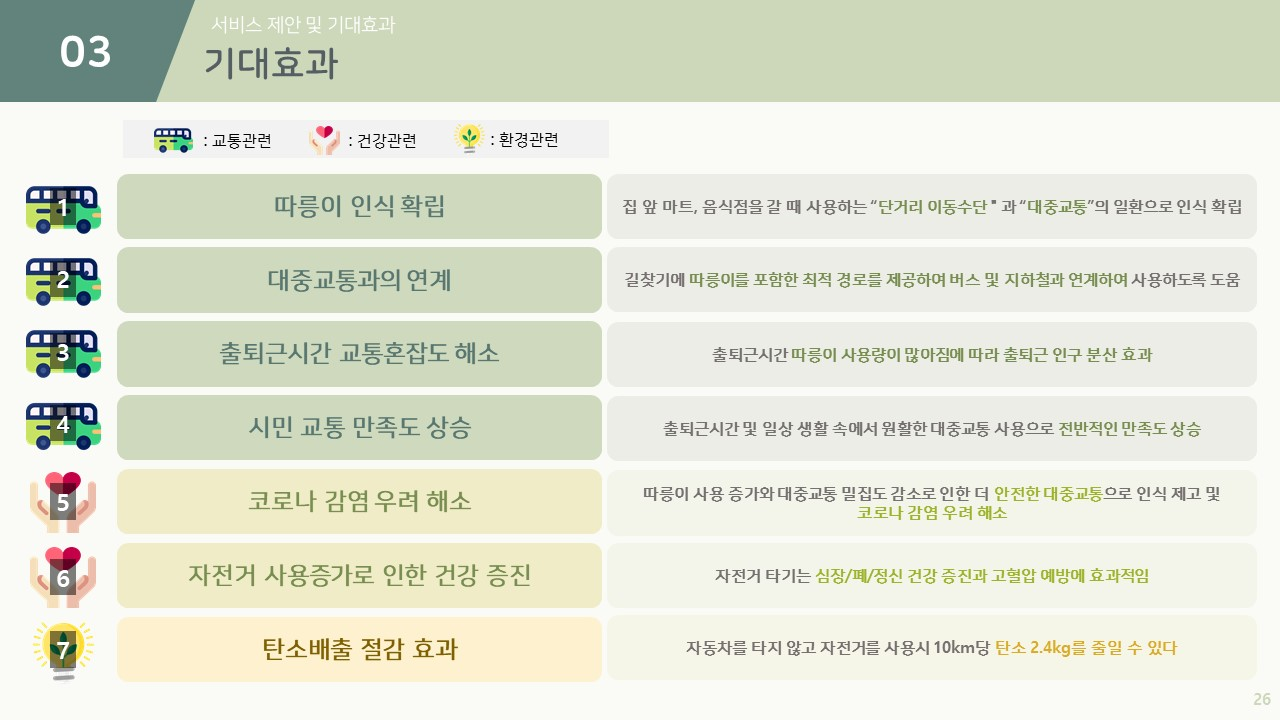

In [12]:
base64_data = "/9j/4AAQSkZJRgABAQEAYABgAAD/2wBDAAMCAgMCAgMDAwMEAwMEBQgFBQQEBQoHBwYIDAoMDAsKCwsNDhIQDQ4RDgsLEBYQERMUFRUVDA8XGBYUGBIUFRT/2wBDAQMEBAUEBQkFBQkUDQsNFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBT/wAARCALQBQADASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwDKooorU+UCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAoorrPhb4Z/4Szxxptm67raN/tE/p5ackH6nC/8AAqUpKKcmVFOTSR9JfCjwz/wingXTrV023Mq/aZ+Od784PuBhf+A119FFfNSk5NyZ78YqKSQUUUVJQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB8JUUUV9QfOBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAV9Dfs2+GPsmjX2uSpiS7fyISR/yzU/MR9W4/wCAV8/2VnLqF5BawJ5k88ixRqO7E4A/M19q+G9Ei8N6DYaZB/q7WFY9w/iIHLficn8a4MZPlhy9zuwsOaXN2NKiiivGPVFHJArY1jSSdeu7eEQ26pghZZFjGMDpuI9aqaZeQWDPO8RmuVx5KsBsVv7zeuOwp93qv9pWmLsNJeIf3dxnllzyr+vsfw+mi5eXUZr3Filz4qS3lVHH2VeNw25EGQc5x1HWqUOhtb6bqU1wsLNHEpjMc6OQd6jOFY9iasXl5FYeJI5pt/l/ZUU+WAT80AXoSPX1qot1p1nYX0VvLdSy3EaoPMhVVGHVs5Dn09K1fLd38xjNa/489I/69f8A2o9TaFo7XtreyNGuGiKQGTA3yZBwuepwD09adeQvMNEEaxM4ttwWZlVDiRzgliBTLzT9U1CQPPLbMVGFUXcIVB6KA2APpU21va//AAwGM6NGxVlKspwVYYINXdHaE3kcU1pHdCV1T52cbcnHG0irOqx38lqjXjW8vlnAlWeJ5SOwJViWH16VW029i0/zJwjPeLgQEgbEPdj6kdvz7VFuWWojctdPSXUrporG3gtrdbiM4lyzEIQCVZifToKj+zxTXFm8kYm8nTBMsJ6OwzgH27/hUem36alqKzOhW8+zzCZx92TEbYb2b19etVdWnktpdKlidopFtIyrKcEcmtrq1xitKuqaPdzS28MUtuybJII1jzuJBUgcH19eDTvEVrtjsp/NiO62hXyg3zj5OpHpUXiK4uhfzWk1y00cLkD5QoJ9cDjPvVXU71b6SBlUqI4I4ju9VUAms5NWaEadnDONBhltLJbmVrh1dvs4lIAVcDkHHU1ajg8nxPoYaBYJHSJpEWMJ8xJzkAVh6ZJH52yZrrY33VtSNxb6GujurK002GyvfK1BJouXkGxnjbOV3g5wcYxntWkdVfsM5GT/AFjfWtjSLq3u76ztX0u1ZZJEjZh5m4gkAn7/AF/CsZyC7EZxnjPWtOLULbTLcfYld7x0w9xKAPLyOQg9e24/hisY6O7ES2SKlprqqPlWIBf+/q066mttNtbADT7adpbcSO8pkySWYdmA7VDpP/IL1n/rgn/o1KfLeabeW9mLhrpJIIRERGikHBJ6k+/pV9P67ga2hae81vpVzHCpRBceY/APQ49zWNosME0cxntoWii+d55ncBASABhepJ9q19N8vdo3lbvL/wBK27+uMHGfeqfhqzkWYPMbU2MyMsiTTxjOMkZBbI+YD0NaWvypL+rIotXk2n6gpkggtrqSCLBjLSxtsQYyOcHA981hafOFkaNbCG9dz8quHJHsNrCt77IyaXci3t9Ps7uRlj/d3aMTGQd3LSHHbpg81Q0WO00vUEmvLxYpYWIMUaeYDx1DKSO/6VMk203/AF94ie3FvcR6TcpaRW0rXvlt5JbBUbD/ABMfWsvWrOez1Gfz4ZId7sy71IyMnkVfsTai60+KO/ln8u4VkiNuFXJZcnO729O1ZWpf8hG6/wCurfzNRL4Q6FaiiisSQooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD4Sooor6g+cCiiigAooooAKVVLsFUFmJwABkmkr1n9lvwtD4q+NGipcx+bb2Ie/dSMgmMfJ+TlD+FBcI88lFdTu/h/8AsT614g0qG/8AEerroBmQOllHB50yg9N+WUKfbn3weK0/Fv7DN7aWMs/h3xEmoXCglbO+g8rf7CQMRn6gD3FbX7Ynxi1zwtq2leGNA1K40pnt/tl3cWjmOVgzMqIHByB8rE465Fcp+yj8bPEU3xCtvDOt6vdarp2pRukP26VpmhlRS67WYkgEKRjpyKnXc9Hlw8Z+ya+Z85anpt3ouoXNhfW8lpeW0jRTQSrhkYHBBFer/Bn9mnX/AIuWo1M3Eei6DuKrfTJ5jTEHBEaAjIBBBJIGfXBx1X7bXhSHR/iHpmswRiMatafvsDG6WIhS312tGPwrg/D/AO0Z408L/D9PCOl3kNnZRlhHeRxkXUasxZkV84AyTzjcM8EU+hy8kKdRxqbI9q1H9g+L7Nmw8YOLgD7txYDYx+ofKjp2NfOPxI+Geu/CvxAdJ12BUlZfMhnhbdFMmSNynHqOhAI7iuo+CvjHxtd/FTQE0zVtUvbie8jFxG87ypJCXHmeYCSCu3JJPTr1r2/9uy6sf7F8K2zFTqX2iaRFzyItoDZHoW2fkaWtzWUadSk5wVrHx9RRRVHAFFFFABRRRQAUUUUAen/s++GP7b8afb5U3W2mJ5vPTzGyEH/oTf8AAa+nq87+BXhj/hHvAlvPIm261FvtT567Twg/75AP/AjXoleDiJ89R+R7eHhyU15hRRRXKdAUUUUASXFxJdSb5XLvtC5PoAAB+QFR0yWaOEKZJFjDEKCxAyT0H1p9MCSa4knWJZHLLEuxB6DJOPzJqOiigAoopkcyTLujdZFyRlTkZHBFICWOV4W3I7I2CMqcHB606a4kuPL8x93loEX2UdBUdQ3t9b6bayXN3cRWttENzzTOERB6kngU9dgNj/hJNU730x/4FVS7vZ76QSXErSuBjcx5xVS3uIruCOeCVJoZFDpJGwZWU8ggjqKkpuTe7Amtb24sy5t5nhLjaxjYgkemaLa8uLObzYJpIZP7yMQahopXYDpJGkdnY5Zjkn1NNopizRtK0QkUyKAWQEZAPTIoAnjuJIY5URyqSrtceoBBx+YFR0UUATw309u0ZjlZTHnZzkLnrge9QUUUAFFFFIB0UrwyJIh2uhDK3oRRJI0sjOx3MxyT6k02imAUUUUgCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAPhKiiivqD5wKKKKACiiigAr379idlX4v3QbqdJmC/XzIv6ZrwGvRf2ffG0HgH4s6Hqd5IIrBna2uXboqSKV3H2BKt+FDNqMlGpFs7L9tBWX4yAkEBtNgK+4y4/mDXI/s3qW+OHhIAZP2pj/5Devp/wDad+AGpfFiTTNb8PPbtqtrEbeSCZ9gniJLKVfplSW4PUN145579m39mXXPAfi8eJvFAt7ea1jdLO0hkErb3BVnZhwAFJAAznd2xzN9DtlRm8Re2l7mT+3oy+d4IUD5wt6T9MwY/ka+dfhj4g0nwr480bVtd0/+1NJtZi89rsV9w2kA7W4JBIbB9K9P/bD8c2/iz4oLp1nIsttotv8AZWdTkGYktJj6fKv1U1No/wCx/wCI/EXw80rxHpmq2c97fwLdLpsimPEbAFMSZILEEcEAD1p9DKqpVK0pU1ex7x4S/am+Ft1fx2Vr5mgm4cIJJ7FYYyx4G5kJAHTk8DvxXjv7Wfwd1zRrz/hNJtduPENhcSLbyG6VVktM52KAoClOvQDk85JzXKaD+yP8SNU1WK2vdIi0i1LhZby4u4XVBwSQqOzNwewxnjIr6D/a417TfDPwV/4R2WcSX9+0EFrGxzIVidHaT6YUDPq1LZ6HQ3OpSl7VWtt0PhWiiiqPJCiiigAooooAK2fBvh1/FXijTdKQHFxMBIV6qg5c/goNY1e5fs0+GPMuNS1+VOIx9kgJHc4Zz+W0fiaxrT9nByNaUOeaie8QwpbwpFGoSNFCqq9ABwBT6KK+dPeCsjxbDrNx4b1CPw/PBa6y0eLWa5GY1bI5Iwe2ex5rXopp2dwPAP8AhHf2gP8AoadJ/wC/UP8A8Ypnwp+Injtfi/d+DPF2oW2oNBA7u0UMa7W2q6lWRVyMN3Hevfbu7gsLWW5uZo7e3iUvJLKwVUUDJJJ6Cvm34P3bfED9ovxP4rsVY6RDE6LMy4DZCxxj2LBC30Fd0Je0hNyirJdupJc/bMlePQfDIV2UfapWwDjkIuD9Rk/nXufiDV5ND8I6lqiKJJbOxkuQrchikZbB/KvCv2zv+QH4Z/6+Zv8A0Fa9m8ff8kz8R/8AYIuf/RLVMlelT+f5h1Z4N4H8bfGn4laVNqui3umizSdoCJIokwwCsQAVJxhhXq/wtg+JkWqXh8b3GnzWHk/uFtgvmeZuH90AbcZznvjHeuY/ZB/5Jfe/9hWX/wBFRV7hRXmoylBRX3Aj51/Zf1C6udP+IDy3Esr/AGkSbmck7iJMt9Tgc+1aP7HTFvh3qwJJA1V8f9+oq8s+D+r+PtNj8Wp4O0Sw1a1km/017xwpi+/jbmVO27selepfsc/8k71f/sKv/wCiYq6a8bRqP0EjsviR4q+IWh61BB4U8K2utac0Ad7maUAiTcwK43rjACn8a8x8f3/xf+IXhW80G88DW9tbXRQtJbzLvG11cYzKR1UV7P8AFrxtL8PPAOqa5BCs9zAqpCj5273cKC2Owzn3xjvXkng/4W+L/il4fs/EPiD4hanAuoRebHZ2BKoqHOMgMFBI6gL+NYUWoxU2krddRsj8G658YvBfhjT9EtvAlrcQWUflpJNMN7DJPOJcd69N+Gfibx3rt5ep4t8M2+h20cYaCaGUEu2eVxvbtznj9a8w8c+A/GXwZ0C48TaH4+1C/trMoZrHUiXUqzKnAZmUnJHGAcdDmvbvh34rPjjwTpGuNCLeS8gDvGucK4JVgM9sg49qVZpx50k0+uu4Ix/ipD48ltdP/wCEGnsoZQ7/AGr7UFJK4G3buBGM7s9+nvXnf2P9oD/n90n/AL5h/wDia9+rgPhn8XLb4lat4ksYNPksjo84iDySBvOUs4DYwNp+Q8c9RzWVOclF2iml5DOE+CvxO8aax8TtZ8J+LJbeaWytnkbyokUpIjoOCvBBD9/bpzWf8NppG/as8bAuxBtZQQSecPCB+VQ/BZv7Y/aQ8f6lGN1vEtxCGz389Ap/ERtXKP4u1fwX+0Z4wvtF8P3HiS7YSQtaWyuzKhMZL/KrHAKgdO9dvLeUlFWvEk+u6Kw/BOvX3ibwvYanqOkzaHezqxksLjO+IhiBnIB5AB5A61uV5TVnZlhRRRSAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA+EqKKK+oPnAooooAKKKKACiiigD1nwF+1B47+H+mw6dbXtvqenwjbDb6nEZRGvZQwZWwOwzgdq0fFX7XnxC8T2ElpHc2WiRyLtd9LgZJCPZ3Ziv1Ug14rRRY29tUty8wrMXYsxLMTkk8k16H8P8A4/eNvhrbraaVqxl05fu2N6vnQr3+UHle/Ckda87ooM4ylF3i7Hv9x+214/mtTElnocEmMefHaylx74aUrn8K8W8UeLNY8aatJqWuajPqd6/BlnbOB6KOij2AArJooLlUnPSTuFFFFBkFFFFABRRRQAqqWYKoJJOABX2V8P8Aw0PCXg/TNNKgTRxBpveRvmb9Tj6AV83fBfwz/wAJN49sRIm62sv9Ll44+UjaPxYr+Ga+s68rGT1UEenhIaOYUUUV5h6AVheOPF1r4D8K6hrt7FNPb2aBjHAuWYlgoHtyw57Vu0jKsilWUMrDBUjINNWvqB8wJZeP/wBpi4SS8z4X8FBtyoAf3wzkEA4Mp6fMcKO3PX6D8F+CdJ8AaDDpOj2wgtk+Znbl5X7u7d2P+AGAAK3FUKoAGAOABS1tUqua5UrLsI+cv2zv+QH4Z/6+Zv8A0Fa9w8UabNrHgfV7C2XdcXWnTQRrkDLNEVA59zXjv7XWg6lrmi+G106wuL5lu5EYW8RcgsoC5x0zg175bqUgjUjBCgH8q0nK1KnbzDqz5W+FfiD4jfCrwzc6Nb/Dy+vxJdNciaSORdpKqpGAOfuevevTfA/xC+JXiLxRYwar4Ij0jRH3faLiUssicHBG5vXHG09e3WvX6KU6ynduCu/ULHzb+yx/yDPiD/12X/0GWtj9jn/kner/APYVf/0TFWn8DPhlrvgGx8ZR6tBHG1/P/o3lyq/mKA/zcHgHcODg+1Qfsl6Pf6L8P9Tj1CyuLKR9TkZUuIzGxAjjUnBHTII+oNdFWSkqjT7CR634m8OWHi7QbzR9Th8+xu02SIDg9QQQexBAI9xXyn8NdH8bt4y8U+EPCXi2TTLTRriZEW8+dGVZimQNpCk9TgCvUtQ+DPxCur64mi+KV9HHJIzKgidQoJyBgSYH4Vg6Z+zL4r0XVLzUbD4hS2l/eFmuLiG3dXlJbcSx8znJ5pUnCnFpzWvkwOO8WeHPFur/ABU8O+BvGfiqfVLW+VJ5BZnZGBmTGF2gFvkPJHGa+sNG0e08P6VaabYQi3srWNYoolydqgYHJ6/WvAbr9mfxZfa5b6zcfEKWbVbdQsN48DmVAM4AbzMj7x/M10vh/wCEHj3S9csLy7+Jl7eWsE6SS2zRuRKgIJQ5cjkcdO9Ks4VEkprTye4I7zxB8UPCnhXUm0/Vtds7G9VQzQSP8ygjIzgccV87fs+fEjw34N8TeN7jWdVjsob6dGtnZHYSAPKSRtB7Mv519E+IPhd4T8U6k+oatoVpfXrqFaaRTuIAwM4PpVCP4H+A43DDwtp5I/vRlh+RNZwnSjBxd9R6nJ+Ffib8IfDevXY0LUIbfUdZuV8947e5IkkYnHzMu1Rlj0IAzXLfDX/k6zxr/wBe03/ocNe0af8ADPwjpc0U1p4Y0iCeJt8cy2Me9GHIIbbkH8a8m+Hmg6la/tPeM76awuIrJraTbcPERG25oSuG6HIB/I+lXGUGptX26iPfqKKK4CgooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA+EqKKK+oPnAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiirmi6VNrmrWen24zPdSrEnsScZPsKNtR7n0R+zr4Z/svwnPqsqYn1GT5CRz5SZA/Ntx/KvWaq6VpsOj6ZaWNsu2C2iWJB7KMCrVfOVJ+0m5HvU48kVEKKKKyNAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAPmj/hln4of9Cx/wCVC1/+O0f8Ms/FD/oWP/Kha/8Ax2v0Eor6LnZz/Uafd/18j8+/+GWfih/0LH/lQtf/AI7R/wAMs/FD/oWP/Kha/wDx2v0Eoo52H1Gn3f8AXyPz7/4ZZ+KH/Qsf+VC1/wDjtH/DLPxQ/wChY/8AKha//Ha/QSijnYfUafd/18j8+/8Ahln4of8AQsf+VC1/+O0f8Ms/FD/oWP8AyoWv/wAdr9BKKOdh9Rp93/XyPz7/AOGWfih/0LH/AJULX/47R/wyz8UP+hY/8qFr/wDHa/QSijnYfUafd/18j8+/+GWfih/0LH/lQtf/AI7R/wAMs/FD/oWP/Kha/wDx2v0Eoo52H1Gn3f8AXyPz7/4ZZ+KH/Qsf+VC1/wDjtH/DLPxQ/wChY/8AKha//Ha/QSijnYfUafd/18j8+/8Ahln4of8AQsf+VC1/+O0f8Ms/FD/oWP8AyoWv/wAdr9BKKOdh9Rp93/XyPz7/AOGWfih/0LH/AJULX/47R/wyz8UP+hY/8qFr/wDHa/QSijnYfUafd/18j8+/+GWfih/0LH/lQtf/AI7Xe/Bn9m/xl4e8VNqmu6ILVLeJvs4+1QSbpG4z8rnGF3dfUV9j0VEm5xcX1Kjg6cWpXZ5b/wAIXrP/AD5/+RU/+Ko/4QvWf+fP/wAip/8AFV6lRXH9Wh3Z18qPLf8AhC9Z/wCfP/yKn/xVH/CF6z/z5/8AkVP/AIqvUqKPq0O7DlR5b/whes/8+f8A5FT/AOKo/wCEL1n/AJ8//Iqf/FV6lRR9Wh3YcqPLf+EL1n/nz/8AIqf/ABVH/CF6z/z5/wDkVP8A4qvUqKPq0O7DlR5b/wAIXrP/AD5/+RU/+Ko/4QvWf+fP/wAip/8AFV6lRR9Wh3YcqPLf+EL1n/nz/wDIqf8AxVH/AAhes/8APn/5FT/4qvUqKPq0O7DlR5b/AMIXrP8Az5/+RU/+Ko/4QvWf+fP/AMip/wDFV6lRR9Wh3YcqPLf+EL1n/nz/APIqf/FUf8IXrP8Az5/+RU/+Kr1Kij6tDuw5UeW/8IXrP/Pn/wCRU/8AiqP+EL1n/nz/APIqf/FV6lRR9Wh3YcqPLf8AhC9Z/wCfP/yKn/xVH/CF6z/z5/8AkVP/AIqvUqKPq0O7DlR5b/whes/8+f8A5FT/AOKo/wCEL1n/AJ8//Iqf/FV6lRR9Wh3YcqPLf+EL1n/nz/8AIqf/ABVH/CF6z/z5/wDkVP8A4qvUqKPq0O7DlR5b/wAIXrP/AD5/+RU/+Ko/4QvWf+fP/wAip/8AFV6lRR9Wh3YcqPLf+EL1n/nz/wDIqf8AxVH/AAhes/8APn/5FT/4qvUqKPq0O7DlR5b/AMIXrP8Az5/+RU/+Ko/4QvWf+fP/AMip/wDFV6lRR9Wh3YcqPLf+EL1n/nz/APIqf/FUf8IXrP8Az5/+RU/+Kr1Kij6tDuw5UeW/8IXrP/Pn/wCRU/8AiqP+EL1n/nz/APIqf/FV6lRR9Wh3YcqPLf8AhC9Z/wCfP/yKn/xVH/CF6z/z5/8AkVP/AIqvUqKPq0O7DlR5b/whes/8+f8A5FT/AOKo/wCEL1n/AJ8//Iqf/FV6lRR9Wh3YcqPLf+EL1n/nz/8AIqf/ABVH/CF6z/z5/wDkVP8A4qvUqKPq0O7DlR5b/wAIXrP/AD5/+RU/+Ko/4QvWf+fP/wAip/8AFV6lRR9Wh3YcqPLf+EL1n/nz/wDIqf8AxVH/AAhes/8APn/5FT/4qvUqKPq0O7DlR5b/AMIXrP8Az5/+RU/+Ko/4QvWf+fP/AMip/wDFV6lRR9Wh3YcqPLf+EL1n/nz/APIqf/FUf8IXrP8Az5/+RU/+Kr1Kij6tDuw5UeW/8IXrP/Pn/wCRU/8AiqP+EL1n/nz/APIqf/FV6lRR9Wh3YcqPLf8AhC9Z/wCfP/yKn/xVH/CF6z/z5/8AkVP/AIqvUqKPq0O7DlR5b/whes/8+f8A5FT/AOKo/wCEL1n/AJ8//Iqf/FV6lRR9Wh3YcqPLf+EL1n/nz/8AIqf/ABVH/CF6z/z5/wDkVP8A4qvUqKPq0O7DlR5b/wAIXrP/AD5/+RU/+Ko/4QvWf+fP/wAip/8AFV6lRR9Wh3YcqPLf+EL1n/nz/wDIqf8AxVH/AAhes/8APn/5FT/4qvUqKPq0O7DlR5b/AMIXrP8Az5/+RU/+Ko/4QvWf+fP/AMip/wDFV6lRR9Wh3YcqPLf+EL1n/nz/APIqf/FUf8IXrP8Az5/+RU/+Kr1Kij6tDuw5UeW/8IXrP/Pn/wCRU/8AiqP+EL1n/nz/APIqf/FV6lRR9Wh3YcqPLf8AhC9Z/wCfP/yKn/xVH/CF6z/z5/8AkVP/AIqvUqKPq0O7DlR5b/whes/8+f8A5FT/AOKo/wCEL1n/AJ8//Iqf/FV6lRR9Wh3YcqPLf+EL1n/nz/8AIqf/ABVH/CF6z/z5/wDkVP8A4qvUqKPq0O7DlR5b/wAIXrP/AD5/+RU/+Ko/4QvWf+fP/wAip/8AFV6lRR9Wh3YcqPLf+EL1n/nz/wDIqf8AxVH/AAhes/8APn/5FT/4qvUqKPq0O7DlR5b/AMIXrP8Az5/+RU/+Ko/4QvWf+fP/AMip/wDFV6lRR9Wh3YcqPLf+EL1n/nz/APIqf/FUf8IXrP8Az5/+RU/+Kr1Kij6tDuw5UeW/8IXrP/Pn/wCRU/8AiqP+EL1n/nz/APIqf/FV6lRR9Wh3YcqPLf8AhC9Z/wCfP/yKn/xVH/CF6z/z5/8AkVP/AIqvUqKPq0O7DlR5b/whes/8+f8A5FT/AOKo/wCEL1n/AJ8//Iqf/FV6lRR9Wh3YcqPLf+EL1n/nz/8AIqf/ABVH/CF6z/z5/wDkVP8A4qvUqKPq0O7DlR5b/wAIXrP/AD5/+RU/+Ko/4QvWf+fP/wAip/8AFV6lRR9Wh3YcqPLf+EL1n/nz/wDIqf8AxVH/AAhes/8APn/5FT/4qvUqKPq0O7DlR5b/AMIXrP8Az5/+RU/+Ko/4QvWf+fP/AMip/wDFV6lRR9Wh3YcqPLf+EL1n/nz/APIqf/FUf8IXrP8Az5/+RU/+Kr1Kij6tDuw5UeW/8IXrP/Pn/wCRU/8AiqP+EL1n/nz/APIqf/FV6lRR9Wh3YcqPLf8AhC9Z/wCfP/yKn/xVH/CF6z/z5/8AkVP/AIqvUqKPq0O7DlR5b/whes/8+f8A5FT/AOKo/wCEL1n/AJ8//Iqf/FV6lRR9Wh3YcqPLf+EL1n/nz/8AIqf/ABVH/CF6z/z5/wDkVP8A4qvUqKPq0O7DlR5b/wAIXrP/AD5/+RU/+Ko/4QvWf+fP/wAip/8AFV6lRR9Wh3YcqPLf+EL1n/nz/wDIqf8AxVH/AAhes/8APn/5FT/4qvUqKPq0O7DlR5b/AMIXrP8Az5/+RU/+Ko/4QvWf+fP/AMip/wDFV6lRR9Wh3YcqPLf+EL1n/nz/APIqf/FUf8IXrP8Az5/+RU/+Kr1Kij6tDuw5UeW/8IXrP/Pn/wCRU/8AiqP+EL1n/nz/APIqf/FV6lRR9Wh3YcqPLf8AhC9Z/wCfP/yKn/xVH/CF6z/z5/8AkVP/AIqvUqKPq0O7DlR5b/whes/8+f8A5FT/AOKo/wCEL1n/AJ8//Iqf/FV6lRR9Wh3YcqPLf+EL1n/nz/8AIqf/ABVH/CF6z/z5/wDkVP8A4qvUqKPq0O7DlR5b/wAIXrP/AD5/+RU/+Ko/4QvWf+fP/wAip/8AFV6lRR9Wh3YcqPLf+EL1n/nz/wDIqf8AxVH/AAhes/8APn/5FT/4qvUqKPq0O7DlR5b/AMIXrP8Az5/+RU/+Ko/4QvWf+fP/AMip/wDFV6lRR9Wh3YcqPLf+EL1n/nz/APIqf/FUf8IXrP8Az5/+RU/+Kr1Kij6tDuw5UeW/8IXrP/Pn/wCRU/8AiqP+EL1n/nz/APIqf/FV6lRR9Wh3YcqPLf8AhC9Z/wCfP/yKn/xVH/CF6z/z5/8AkVP/AIqvUqKPq0O7DlR5b/whes/8+f8A5FT/AOKo/wCEL1n/AJ8//Iqf/FV6lRR9Wh3YcqPLf+EL1n/nz/8AIqf/ABVH/CF6z/z5/wDkVP8A4qvUqKPq0O7DlR5b/wAIXrP/AD5/+RU/+Ko/4QvWf+fP/wAip/8AFV6lRR9Wh3YcqPLf+EL1n/nz/wDIqf8AxVH/AAhes/8APn/5FT/4qvUqKPq0O7DlQUUUV1lhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRVK+/1o/wB2mtQLtFZVFPlA1aKyqKOUDVorKoo5QNWisqijlA1aKyqKOUDVorKoo5QNWisqijlA1aKyqKOUDVorKoo5QNWisqijlA1aKyqKOUDVorKrP1zxBp3hrT2vdTu47O2U43yHqfQAck9eB6UNW1bLhTnUkoQV29ktzpaK821D4zeCdJ8L3HiK98R2dro8DBJJ5SysGOcKEI3ljg4AGTg46Gp/h18WfCPxZ02a+8Ja5b6zBCwWURhkkjJzjdG4DLnBwSOcHHShK6umdlTL8ZSpyq1KMlGLs24tJPs3bR+R6FRWVRRynAatFZVFHKBq0VlUUcoGrRWVRRygatFZVFHKBq0VlUUcoGrRWVRRygatFZVQC6HmEFf3W3csoOVb2+v86xqVKdGzqSt/XXsvN6FKLlsblFczJrluhIGWx+tPh1eK4hdold5V/wCWOPm/w79a8ilneW1qjpU66cu3e3bv6K5vLDVoq7jodHRWQjhh1GRwwBzg+lOr3FaSumcxq0VlUU+UDVorKoo5QNWisqijlA1aKyqKOUDVorKoo5QNWisqijlA1aKyqKOUDVopsP8Aqk/3RTqkAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAqlff60f7tXapX3+tH+7TjuBXooorQAr4m+K+veDviR+1D408KfFf4hT+DvB3hewsV0vT4NU+wJe3E8SSySO38TKHxgdivvn7Zrwn4rfDnwtrHibWtVvPBuja7q7RK4a6s4mluHWFQiGRlOM7VUE9Bj0rixecUskp/WKsXLmfKrNJpvW93psmvmYVouSVj5H+DfhL4CeILz4gr41+JVzpsGn+Ibi10Bj4kaD7Tp6geVJnH7zJz8/euP8O6B8G9W/ZW1nxB4j+IV1ZfE+G3v3tNL/AOEgaIvLG0n2UeRjncAnH8WfevavCel6lrPiLTbLWf2ZdE0LTLiUJc6i01nILZMcvtCfNj0HWsf456Jc+H5tQsdC/Z20XW9Ihlh8jWI3tIhPkAn5NmVwSRz6V10uKlUxccLyWcrP+NRastLXUrXf8t+Z7pWPGxE1h6Eq3Knyp+X4vRer0PBPF2g/Byx/ZPsvEujfEO8ufi4+n2cs2jjxA7kXDyIJ1+z44wpY4zxiveG8N6H+zxr3wb8bfCfxtq+q6f4i8TW3hrXLC41f7fZXAlAEo6fK6Hd64JBGMc4zfB3wh4s8ILb6n4K03Qru/tV+0RWcMQntJCASElVfvKe44OKzPA/7Mes2t14as7Tx9r2p6J4Z1SLWrLRJo4Vt450fcH5OAxPBbGcE17Tz3BunL28nGze+qafmtN9vzPlMFxPhsXUdGNKXtNkopyba105bn6d0VS0O7n1DRdPurmNYrma3jkljU5CsVBIH0JrK8UeDf+Eo1Tw7e/25rOk/2Nffbfs+l3fkw337t08m5XB8yL5923j5lU54rxoyUkmup+lRd0na3qaHiLxLpHg/RbrWNe1Wy0TSbUBp7/UbhLeCEEhQXkchVBJA5PUiuB/4ao+C3/RX/Af/AIU1l/8AHa9Kvbj7HZzz7d/lRs+3OM4GcV8yfEH43X3xc+Buu6PpnheYaj4p+GL+ILa3tpmupBJdqYVtVRYwZCDIMMME9NtMZ7145+JPh/4c+H7fWtburhbC5uIbS3On2M99LPNKcRJHFbo8jlj02qa5/S/j94Y1fUrSxg0vxtHPcyrCjXXgTXLeIMxABeWSzVEXJ5ZiFA5JArhv2nPBviHxd8PfD/hbw94e8RahPaXVnqK6poz2gWB7ZwRG+/U7CYFsfehkBH94Gvmr4L+JvHXibx476ZLqXiw6Lfx3D6doPjJtSmktVKZM8UnjSSOJi29NrxzJwpO7JQAH3R41+J+j+Abi2g1Oz8RXT3CF0Oi+GtS1VQAcfO1pbyhD7MQT2rN8O/HbwX4ot7GWy1G8iN7rL+H4oNQ0m8sp/t6wNO0DxTRI8ZESs2XULxjOSBWB8TPiB8QodP0ePwl8NPFFxeSz6feXc0dzooWG389GurRvOvhmXyhImUBTLDbJ/EPHfF3h3VbzW/Blquj+Mvhtea38Sjq51TUJNHnnEsul3qstusUt3HhVhRT5qdH4yckAH0H46+N3hn4cXlxBrdv4kVbeD7TNdaf4U1W/tY48ElmuLe2kiGACSN2R3xW9H480KX/hGdt9n/hJAW0r9zJ/pAEDT/3fk/dqzfPjpjrxXhPxc0P4o614z8SaP/xcS/8AAd3pdvaWv/CGt4YQTM0ciXfnnUNsoZspjy8KMtjHFcz4T+DWl+D/AI4fCrxXDo2seHdUvLy802XTdd07REulji0qYK7XVhEZJtwjU/vLiQdcqCAAAfXdFFFABRRRQBDdXH2cRkjIZwnHHWvMfjz4L1Hxj4Xs7nTlaaexLSPap1kVgMkDuRjp6E/Q+jasSsMLAZ2yg/oaxfBfi4eIre6SVUt7m1neB7cZ3xhThS2fUc5rzKlSPtpUqj0aVj3ctrVsDOGPw6u6b/PQ/NL9pISR6Do8JDL/AKW+U9wnp+dfQn/BPP4J+IfCMereNtaim0201S1W1sbOYFWmTermYr2HygLnqCx6YJ+ote+EPg3xR4gsta1Xw9ZX+o2chlhkmTKiQ4+cp91m44LAkU/xx48h8KWMjxBJrleiMeCf7vHc11RccLRtN6H6Jm3Gc86wCyvBUXFz+Nu3e9l/m7drdTQ8N65LrE14kqKvk7CMf7QJ/pW5XGfDmZrg6hMyeWXER2+nDcVo+OvBv/CdaHHpv9uaz4e2XdvdfbNCu/s1wfKlWTyy+D+7fbtdcfMrEcZow0nOkpSf9XPyvGwjTryjFWSt+SNXWta07w3pN3qmrX9rpemWcbTXN7ezLDDDGBku7sQqqB1JOK5vwb8Zvh/8RtRl0/wn468NeKL+GIzyWujavb3cqRggFysbsQuWAyeMketb3ibWpfD2iXN/BpN/rk8W0R6dpixm4nZmChV8x0QcnlndVABJIAJrxHQ/APir4zeLIviReeMpvAUkFnNo+mab4Qm0/UZIYTMrXC3lxcW88LT+bCitHCu2IwsollyTXScR6j/wtjw5L4JTxZaSalquiSTPbo+k6NeX07OkrRPi3hieUgOjAtsxxnOMGszTvj94L1Dw/wCKdaN5qmnWPhiD7Vq41fQr/T57WLY0gfyZ4EkcFVYjYpzivP8A9nfVNe8M/s0+HF0PQ7jxjq7ahqNsvnXcFmgJ1C6/0i5kIGyPIG7yYpHG75Ym6Dz7xV4o8K+JPhb8W7A/Ejwp4i+Inj6wlsIbfTNTii0xbr7OYLfTLW5kcRyTKW+YM6yMZd5jjVlUAH0/4w+IOleB7C0vNQttau4bptsY0XQr7VHHGcslrDIyDHdgB2zmub0z9ojwLqlpq9x9u1TTxpNxY2t7Dq+g6hp88Ul5KIrUeVcQI5DuQAwUgdSQOaw/HUPiv4XfC+fw98NvC3irxNrk9jP9i1KTWba++w3RX5DNLql4JGXccgKJFAUjA4B8j+NVrq2reG/Geq3Xgzxl4JvfEWp+GI31TVJ9Hlit2t9UtY4xCsF1cHf+9d/3kZT5cHjCkA+lPGvxP0fwDcW0Gp2fiK6e4Quh0Xw1qWqqADj52tLeUIfZiCe1M0r4t+Fda8H6J4ptNTdtD1q5hs7G4ktJ42kmlm8mNDGyB0Jk+X51GO+BzXmHxQ0/4r6T4o8O2eg6p481rwzDpEiXuoeGV8NLfz34lTY84v444wpj3/6lFGccV5FcfAPS/DzfDzxFJoPifw7qeg+JtEsII/FVj4dmubtHvgWl+12Ucsw5kb5BPGvQbNp5APtyiiigAooooAjuJBDCzl1jA/iboK5zxBqVvpVi0s80FnbKvmyzMwSIA8Eknp0H5mulkBZSFbaezYziuY8WeHrfxVoN3Y3cbz211C1vNvG1nQgjI9OvX1Ar4biinUqYdqN7WV7b25lzW17W6LTd9D0MLJxu425ul9r20vp3/wCGPFvi54o8S2PjX4Zp4akafTNQ1IrctbnfHcJgZViONojMjD3XP8Neox65Zx6m8dvewS3lqQZreOVWkRTnG5QcgH3968i8K/DDXvhPatoWm6mNTtLu9ll02S4Hlmwka3kVt65OV5D/AC45U8DdXTfBP4GwfDhb4PfyaxqmpSrNqGoSJsDBc7UUZJ6sxySSSfy/LcVRoVKdOjg6l6sWlT5U7zblfmf8vJ+nZHJluJx7xVSeIpNRm71FKStTtCKUYfzcz1utEt9We22bJHI8KtEAvIjjHIHqat1XtXaTexZ8Zx5ciYK+3vXK6xoPgq5+Kvh3VtQlsx48tdPu4dKjkvilwbV2jNwUg3gSLlYsttO3jkZ5/fMCrUFbbW3pfTq/09FsFT4h/wASPiVZ/DbSftVxpeuavcyxym2tdE0O+1EySIuQjm1gl8oMSAGcAdcZwa5HS/2ktGuPAcHiHUvDvinRrlW02C903UNAvbJre4vJ4rdY0ku4YEmCSygM0ZPyrnHIB5f9sbRbzxF4X0SG38IN4mGn3y38Q1O30q60SScq9vHb3tve31qz7zP8hjOVfYRkja3ic3gPWvC/wL8RaV4h+HF94Cl8Qa94eur1NCi07StFtZRqNhCYrOKy1G4nSRgCxn+UsVByhCrXeZH2N428Z6v4VmtE0zwH4g8ZLMrF5NEn06NYMYwH+13cBJOTjaGHBzjjPAaV+118P9StPDKTXjab4h17VRpEHha7urT+1YZftUlqZJIEnbMSyRPl0LjAyM9Kv/EyTxB4B8KQ22keIrLwj4QsbVUuvEmqPd65rG5nEawW8Mm4yTOXXZLJJOxcqn2eTcK8ZuND0ia6+GHhzQvEXjjw3oml69ps9npfi/w/JaadqflTGSSZrqSw85LuaTzMRTzQs8nIj2uhcA+ivF3xA17w3rBs9P8Ahn4p8VW4RX/tDSLnSY4CT1XFzfQyZHf5Mc8E1leBPj7ofj6bwhBbaZq2n3Pia11K6t4b6OENbixnjgnSUxyuA2+QbdhYEA8jjOF8S9R+KEnxI8MW/h+08Hw2NpeT3kFnf+MrqyutahFq8bo9umnyALG86SHDSAFEJwSMcNpXwb1hvid8KrHWvDMnhzSdDsdekR/CnibUbiFHkmsZU+0Xaw2rEyP558lwyuEJO7BCgHp3xD+Ol38NDf3WqfDbxdP4fs5o4pNetJtKa2Ku6osgRr5Z9u5wOYt3Xitbw38dfBHjT4gzeDvDniHT/EOrW1lNe3baTewXUdoI5Y4mjm2OWSQtJwpXorc8YrxLxd8GfFutfELxNbaxaaX4ztdX1F9V0vTdS+KuuaSqWUfkARnTYLaSApHLgkjcMyLntXa+A/hzf+G/jxpmuXOn6tby33he+XUTceINQ1uyt7k3tqyxQTXRwgKh2CokeQv3Bt4APdqKKKACiiigAooooA04f9Un+6KdTYf9Un+6KdWQBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABVK+/wBaP92rtVbqF5JAVXIxjrTW4FSipfssv939RR9ll/u/qKu4EVef/ETQtUW11bVNJtP7RvUtZJYLUY/eSrH8idecsAPxr0X7LL/d/UUfZZf7v6ivMzDL6GZUlRr3smnp5f8ADiaurH5Ufs7/ABm+KPir44eG9PuNe1HxC+r3TxatotxGPJtYsEs6LgCPy8Z4x0wc190eOPh9rureH5Le0sGmmMqMF8xBwDz1avX7Pwnp+n6ldaha6VZ21/df6+6hgRJZuc/O4GW/E1ofZZf7v6ilmeU5fj8XTxdKn7JwS0jZJ2d9Vb5eh5lXAxxGGqYarJ2mmtN7P1ufmV+2ZZ/EP4ReBdFurSC60Kxv74215q1uVd4RsyiBlJ2bju56/Lip/wBiey+Inxf8Gatc3n2rVdPstQFraa1cMsbSrty6liQX2HbzyfmxX6S6loMGs2M1lqFlBfWcw2y29yiyRuPRlbII+tGm6DBo1jDZafZQWNnCNsVvbIscaD0VVwAPpXsWw/1L6r7NXvfm0v8Al8vQ+cjwlgY4f6sm7b305r372+W2xV0HTm0fQ9OsHk817W2jgMn94qoXP44rL8UfD/QPGmqeHdS1mw+2Xvh6+/tHTJPOkT7PceW8e/CsA3yOwwwI5zjOK6f7LL/d/UUfZZf7v6is1ZKyPtIRVOKhHZHLeOPh/pXxCsYLTVrjWYIIWLj+xtcvdLZsjBDtazRs64/hYke1eeaV+yH8N9BktZNNj8WadJaWa6dbta+OdciMNqpysCFbwbYweQg+Uele2fZZf7v6ij7LL/d/UUXLPLPiF8DbLxh8JH8C2eo3EVstzb3UcviGW41xJjFcpP5V0LiYyXMLldjRtKPlOARgYwNU+FfjX4ja14Uk8WJ4R0Sz8K6lDfWt3ocE91fXbRkHMLyCMaejhAskI+07o3ZPMGNx9y+yy/3f1FH2WX+7+oouB538YPhzqvxDs/DT6HrlnoOraDrMWsW9xqGnPfwOyRSx7HiSeFsESk5DjpTNC0P4r2+sWkms+NPBt/pauDcW1j4Qu7WeRO4SVtUkVD7lG+lej/ZZf7v6ij7LL/d/UUXA89+Knw/1zxldeFNR8Oa7p+g6v4f1F7+KTVNLk1C3l3201uyNGlxAw4nJBD9VHBpvh3Rfila61ay694x8IalpKk+fa6d4TurOeQYOAkz6nKqHODzG3AI4zkeifZZf7v6ij7LL/d/UUXAioqX7LL/d/UUfZZf7v6ii4EVFS/ZZf7v6ij7LL/d/UUXAhdRIpB6VymoeGbWz1xNYijMd2EMZkjYruU/3h/FjtnkV2P2WX+7+oqK50t7qMK4YDOflI9MVw4rDxrxuviR14evKjLR6PcyL2+kh0OaZThwFAI4xnbkj8zXmun+Gm8U6xFcSKZJIs/Ox+Vc98dM+9etz6D9osXtWDiNsZIYZ4x/hVfRPCceg+b9nMr+ZjPmMp6Z9APWsHhp1ORTeiWp30MZDD05+z+JvT+vvH6XpkOk2qwQjAHU+prI8dfD/AED4l6HHo/iSw/tLTo7u3vlh86SLE0EqyxNuRlPyuinGcHGCCOK6f7LL/d/UUfZZf7v6ivUilFWR48pObcpO7ZFXifg/4TfFH4eaVcaP4f8AH/hEaQdQvb6BNS8HXU9wn2i5luCjSJqkattMpGQi5AHFe4/ZZf7v6ij7LL/d/UU7knLW/h3VdY8D3WieK9TtNRv722mtbu90WyewjKSBlzHG80zIQrAZMjcjPGcDyi9+D3xI1b4Xv8LL3XvCi+FZNKGkS+ILfTLgXslp5XkmBbMymOOXZ8wufOdd3H2YDmvoD7LL/d/UUfZZf7v6ii4HAfFv4azfEj4Z3fhWx1VNHuJHtZIL65tjdrG0E8Uy74xJGXBMQB+dTznNZtt4f+Mi3ETXHjzwNLbhwZI4/BN4jMueQGOrkA474OPQ16j9ll/u/qKPssv939RRcDh/i14Ev/iJ4Sj0zS9Wt9F1K31Gx1O2vLyya8hWS2uY51V4lliLKxjCnDqeetZOn6D8X47+2e+8c+CLiyWRTPDb+DLyKR48jcqudWYKxGQGKsAecHpXp32WX+7+oo+yy/3f1FFwIqKl+yy/3f1FH2WX+7+oouBFRUv2WX+7+oo+yy/3f1FFwIqjW3RZ2mxmRhtyTnA9B6VZ+yy/3f1FH2WX+7+oqJRhO3Mr21XqNNrY8Q8T3WqXWpJLP4q8I2At5WkjRZmZxlWT5h9GNegeBZP7U8OFLjUbLVgGC+dYrtUfKp/Pvn3Fa48A6IGL/wBgaaZC24u1rGxP4kdK0bPRo9Ph8q1tYraLOdkKqoz64FefTy3A0pyqQpRTkmm7LVPVr0ZftJ9/P57CqNqgZzj1rPuPDmk3euWmtT6XZzazZxSQW2oyW6NcQRuQXRJCNyqxVcgHB2jPStb7LL/d/UUfZZf7v6ivT0Whmcp8SPAdt8SvB934futQvtKjnlgnW904xefDJDMk0bJ5qOhIeNeGRgRniuZtvhL4pguIpX+NXjm5RHDNDJZaCFkAOSp26YDg9OCD6EV6j9ll/u/qKPssv939RRcDl/iB4F0/4j+F59E1GW4to3lhuYbuzZVntbiGVZoZoyysu5JI0YBlZTtwysCQePX4N61rupaU/jLx5feJ9K0e9hvbLTY9PtrNbiSFt8M166IWllSQBh5P2eI7VzEec+sfZZf7v6ij7LL/AHf1FFwPPfiN8JR4+8QeHtdtfFWueEtY0NLmK2vNEWzcsk4jEiut1bzqR+6XBCgjnmpfCfw917w7rCXuofE7xV4ptlRlOnatbaSkDEjhibaxhkyO2Hx6g13v2WX+7+oo+yy/3f1FFwPPfHnwnk8ZeKNI8RWHjDX/AAfq+m2dxYJPoiWMglhmeJ3V1uradfvQRkFQp6+tWPB/gHXfDOrNd6j8SfFHiy3MZjFhrFtpUcIYkYfNrZQybhgj7+OTkHjHdfZZf7v6ij7LL/d/UUXAioqX7LL/AHf1FH2WX+7+oouBFRUv2WX+7+oo+yy/3f1FFwIqKl+yy/3f1FH2WX+7+oouBeh/1Sf7op1NjBWNQeoAFOrMAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooqnfaxZaaQLm5SJjyFJyfyFJtLcC5RWL/wmWj/APP5/wCQn/wo/wCEy0f/AJ/P/IT/AOFR7SHcV0bVFYv/AAmWj/8AP5/5Cf8Awo/4TLR/+fz/AMhP/hR7SHcLo2qKxf8AhMtH/wCfz/yE/wDhR/wmWj/8/n/kJ/8ACj2kO4XRtUVi/wDCZaP/AM/n/kJ/8KP+Ey0f/n8/8hP/AIUe0h3C6NqisX/hMtH/AOfz/wAhP/hR/wAJlo//AD+f+Qn/AMKPaQ7hdG1RWL/wmWj/APP5/wCQn/wo/wCEy0f/AJ/P/IT/AOFHtIdwujaorF/4TLR/+fz/AMhP/hR/wmWj/wDP5/5Cf/Cj2kO4XRtUVi/8Jlo//P5/5Cf/AAo/4TLR/wDn8/8AIT/4Ue0h3C6NqisX/hMtH/5/P/IT/wCFH/CZaP8A8/n/AJCf/Cj2kO4XRtUVi/8ACZaP/wA/n/kJ/wDCj/hMtH/5/P8AyE/+FHtIdwujaorF/wCEy0f/AJ/P/IT/AOFH/CZaP/z+f+Qn/wAKPaQ7hdG1RWL/AMJlo/8Az+f+Qn/wo/4TLR/+fz/yE/8AhR7SHcLo2qKxf+Ey0f8A5/P/ACE/+FH/AAmWj/8AP5/5Cf8Awo9pDuF0bVFYv/CZaP8A8/n/AJCf/Cj/AITLR/8An8/8hP8A4Ue0h3C6NqisX/hMtH/5/P8AyE/+FH/CZaP/AM/n/kJ/8KPaQ7hdG1RWL/wmWj/8/n/kJ/8ACj/hMtH/AOfz/wAhP/hR7SHcLo2qKxf+Ey0f/n8/8hP/AIUf8Jlo/wDz+f8AkJ/8KPaQ7hdG1RWL/wAJlo//AD+f+Qn/AMKP+Ey0f/n8/wDIT/4Ue0h3C6NqisX/AITLR/8An8/8hP8A4Uf8Jlo//P5/5Cf/AAo9pDuF0bVFYv8AwmWj/wDP5/5Cf/Cj/hMtH/5/P/IT/wCFHtIdwujaorF/4TLR/wDn8/8AIT/4Uf8ACZaP/wA/n/kJ/wDCj2kO4XRtUVi/8Jlo/wDz+f8AkJ/8KP8AhMtH/wCfz/yE/wDhR7SHcLo2qKxf+Ey0f/n8/wDIT/4Uf8Jlo/8Az+f+Qn/wo9pDuF0bVFYv/CZaP/z+f+Qn/wAKP+Ey0f8A5/P/ACE/+FHtIdwujaorF/4TLR/+fz/yE/8AhR/wmWj/APP5/wCQn/wo9pDuF0bVFYv/AAmWj/8AP5/5Cf8Awo/4TLR/+fz/AMhP/hR7SHcLo2qKxf8AhMtH/wCfz/yE/wDhR/wmWj/8/n/kJ/8ACj2kO4XRtUVi/wDCZaP/AM/n/kJ/8KP+Ey0f/n8/8hP/AIUe0h3C6NqisX/hMtH/AOfz/wAhP/hS/wDCZaP/AM/n/kN/8KPaQ7hdGzRVax1O11JS1tOk2OoU8j6irNWnfVDCimySLEuXYKPeoP7St/8Anp+hpgWaKrf2lbf89P8Ax0/4Uf2lbf8APT/x0/4UgLNFVv7Stv8Anp/46f8ACj+0rb/np/46f8KALNFVv7Stv+en/jp/wo/tK2/56f8Ajp/woAs0VW/tK2/56f8Ajp/wo/tK2/56f+On/CgCzRVb+0rb/np/46f8KP7Stv8Anp/46f8ACgCzRVb+0rb/AJ6f+On/AAo/tK2/56f+On/CgCzRVb+0rb/np/46f8KP7Stv+en/AI6f8KALNFVv7Stv+en/AI6f8KP7Stv+en/jp/woAs0VW/tK2/56f+On/Cj+0rb/AJ6f+On/AAoAs0VW/tK2/wCen/jp/wAKP7Stv+en/jp/woAs0VW/tK2/56f+On/Cj+0rb/np/wCOn/CgCzRVb+0rb/np/wCOn/Cj+0rb/np/46f8KALNFVv7Stv+en/jp/wo/tK2/wCen/jp/wAKALNFVv7Stv8Anp/46f8ACj+0rb/np/46f8KALNFVv7Stv+en/jp/wo/tK2/56f8Ajp/woAs0VW/tK2/56f8Ajp/wo/tK2/56f+On/CgCzRVb+0rb/np/46f8KP7Stv8Anp/46f8ACgCzRVb+0rb/AJ6f+On/AAo/tK2/56f+On/CgCzRVb+0rb/np/46f8KP7Stv+en/AI6f8KALNFVv7Stv+en/AI6f8KP7Stv+en/jp/woAs0VW/tK2/56f+On/Cj+0rb/AJ6f+On/AAoAs0VW/tK2/wCen/jp/wAKP7Stv+en/jp/woAs0VW/tK2/56f+On/Cj+0rb/np/wCOn/CgCzRVb+0rb/np/wCOn/Cj+0rb/np/46f8KALNFVv7Stv+en/jp/wo/tK2/wCen/jp/wAKALNFVv7Stv8Anp/46f8ACj+0rb/np/46f8KALNFVv7Stv+en/jp/wo/tK2/56f8Ajp/woAs0VW/tK2/56f8Ajp/wo/tK2/56f+On/CgCzRVb+0rb/np/46f8KP7Stv8Anp/46f8ACgCzRVb+0rb/AJ6f+On/AAo/tK2/56f+On/CgCzRVb+0rb/np/46f8KP7Stv+en/AI6f8KALNFVv7Stv+en/AI6f8KP7Stv+en/jp/woAs0VW/tK2/56f+On/Cj+0rb/AJ6f+On/AAoAs0VW/tK2/wCen/jp/wAKP7Stv+en/jp/woAs0VW/tK2/56f+On/Cj+0rb/np/wCOn/CgCzRVb+0rb/np/wCOn/Cj+0rb/np/46f8KALNFVv7Stv+en/jp/wo/tK2/wCen/jp/wAKALNFVv7Stv8Anp/46f8ACj+0rb/np/46f8KALNFVv7Stv+en/jp/wo/tK3/56fof8KALNFNjkSVcowYe1OpgFFFFABRRRQAUUV8xftjftkRfs5xWehaHZQ6t4x1CH7QiXOTBaRElVdwpBZmYEBQR0JJ6Bt6FCpiJqnTV2yJzjTjzS2Pp2ivzQl+Pv7ZE2myauPDWrW2meUbnzW8OwoiRAbi3zpuAA555rnvAf7W37UvxShvJfB6XHiWOzKC4bTtEtpBEXBKhvk4yAcfSvW/setZvnjZef/AOT63C9uV/cfqhRX5HfED9uj9p34X6lNZ+JoptFljdYyL7SLaM7mQOBjyzyVOfpVS1/b2/ac1PT47uyhluLeaPzIpo9JtirAjgj91zXO8vkt6kfvf+Rp7dP7L/AK+Z+vlFfinc/wDBSD9piy1qPRrjVVh1aQqqWb6NaCViwyoA8rvXbeGf2uP2zPF0d7Jpen6lex2Sh52t/Dtq4jBDEFv3XHCt+Rqo5bOTSVSP4/5C+sLflf4f5n67UV+PngP9tr9rL4pSXsfg+e48SvZKj3K6boFrKYQ5IUtiPjO04+hr0X4ff8FGPi78IfH1loPx38MyrptyVMss2mfYr23jJx5yKoCSoO4AyccHPB2nk+IjezTa6J6/kQsZTerTS7n6fUVX0/ULbVtPtr6ynS5s7mJZoZ4jlJEYAqwPcEEH8asV4R3Gb4i1Q6PpUtwozJ91M/3j/nP4V5ZNM88jSSO0jsclmOSa7/4g/wDIFh/6+F/9BavPa87EN81jKW4UUUVykBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQBNaXk1jcJNA5jkU5BH8vpXq+maguo6bDdgbQ6biPQjqPzBryKvSvC//IpQ/wC5J/6E1deHb5mi4jbi4a4kLsfoPSoqKK7TUKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAkt52t5A6n6j1roFYOoYdCMiubrobX/j2i/3B/KmgJKKKKoAooooAK/MX41a5o+n/wDBTS2vPFd5bW3h7TdQ0+Waa/YCCBF0+KRSxPAAkIP1Nfp1Xxb+0P8AseeE/ip8Ytf8UanrOtWl9ffZ/MhtGiEa7LeKMY3IT0QHr1Jq45tg8nUq2Nk1GScdFd3ev5JnJiIylFcvR3PWPHv7Unwg1HwL4ltbb4leG7i6uNMuoookv1LO7QuFUDuSSK+R/wDgmh8WvBfwt0Px7F4v8UaX4akvJrE266lcCIyhElDFc9cEjP1rZX/gnz4GbgeIfERPs0H/AMbp3/DvbwR/0H/En5wf/G644cXcOU6M6CrTtK32X0MZTxEqkanKro8M/wCCinxL8J/EHxrqEvhnxFp+uxtfWsgaxnEgKizVSeOwbj61U+EXi/RdQ8J+FtAtNShu9cktYrZNNt8yXDy4xsWNQWLZ7AZrK+L37Lfhzwr8RNW0q21XVpYbfytrTGPcd0KMc4T1Jr6T/YT17R/hTr2g+DdH8L6dNq2q6lL9r8UXkKNfG2aMEW6sqqQoaPPLEcn5e9bRzjLq1OMKMm09rq2+x1QdRy55Lc+Fvik//COftR2v9rpJpRsbizF2l9E8D2+EUnergMvBB5HcV9wfsy/tAfDPw7o/juPVPHeh6fJd2sSQLcXQUykJOCF455ZfzFeDftyfCjTdf/as+IWoT3d5HLPdwllj27Ri3iHGR7VyPwe/Za8NeMjq32zV9WgFt5O3yDFzu35zlT/dFezHGYROLqyat2R85is8w+BjUlPo+z72PWf+CXvjLQPAk3xL1DxJrVhoNi8GmwLcahOsKNIXnwoJPJ4P5V67/wAFUrK0u/gh4Q1Hy45bmHXljt7lcEiOS3lLBW/utsQ+h2g1+ffjbwRrHwc8WXel6zYyy2Bk/dXAykd3Dnh0fBAYqcHqVJPFep/tDftmn48fC3w/4Gj8G2vhjTtFuYZreaLUnuWKRQtCkZDIv8LD5s9vevr/AGKrVoYqi7xf5WNsPjKdbC2i7prTzP1h/Y8uJbr9lz4YPK7SONCtk3McnCrtA/AAD8K9hrwb9iDxFa6r+zT4DsEEkN9p+kQR3FvMu11yCVOPQivea+BryUq03Ha7/M9rDVYVqMZ05XXl5aP8TmPiF/yBYf8Ar4X/ANBavPq9B+IX/IFh/wCvhf8A0Fq8+rxcR8ZpLcKKKK5yQooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAOW8VfEbTfCOrWGmXNtfXd9fKzQQ2MHms23rxnrWV/wubTG1U6Yuja8+pLF5zWi2BMqpnGSucgdPzFYXj/AP5Lp8P/APrnP/6C1Gl/8nL6x/2BV/nFXUoR5bvtf8TncpX072N7S/iPdap8S18O/YPs1m2mi+DXCMlwrEj5WXOB1rpfFGqanpNlHLpelxarO0m1oprxbYKuDzuKnPbj3rynWm1lf2iLg6EljJe/2QuRqLuse3IzygJz0rT+NENl4q0jTdKk8QeHbHVLK7jubq11G/WJeEOVxgtg7h1HSjkXNHzQc7tI3f8AhNvGP/QmWX/g/j/+N1Z+H3xCufGepa7YXmkLpVzpMiRSKl2LgMW3dCFXpt9+tee48Pf9A/4X/wDg1H/xmut+H+uaDpV3PbrP4L0xroosceh6irvM+SACpVc9eMZ60SguV+7/AF94oyd1r/X3G94u+JWm+EtStNLNte6rq92peLT9Nh82Xbz8xBIAHB79j6UnhL4maZ4s1W70kW17pWsWq75dP1GERy7ePmGCQRyO/cGuQ8O7W/aR8UedgyLpkXk56hcRZx+NHiJRH+0h4XaMbXfTJfM29SAJcZ/z2pckdutrj55b+djpPAvj668VeLfFukz20MMWjXCwxSRk7nBLjLZ/3R09a7ivHvg5/wAlO+Jv/X6n/octevyRiSN0PAYEVnUSjKy8vyLptyjdnnn/AAty51i8vk8L+GLzxHaWMhinvEnjgjLDqI93Ln6eo9QTsaD8RrHxV4R1HWdNSRJbJJRNaXSbJIpEUna4B/kf1yBwnw21a5+Eulah4c13R9TaSC5kmtbqxtHuIrtWxgKVBAbjocdRnFWfAPh7U7Hwr471zVbN9Nm1xri6jspf9ZEmxyNw7H5jweeK2lCKvp6eZnGUnb+rHbfDHxdceOvBVhrV1BHbz3BkDRw52jbIyjGfYVF4o+IK+GfF3h3QjYm4bWHZBOJdoiwQOmDnr6iub+COqRaL8EdPv50lkht1uJGWCMyOQJn4Cjk1z914R8W/FbUo/F/nDw1JY4bQ7K4TczAHdvl/u7uOx+mBkrkjzyvolcfNLkjbfQ9P+Iniebwb4N1PWbeGOea1RWWOXO05YLzj61peG9UfXPDumajIixyXdtHOyL0UsoYgfnXmPjzxBqmv/BPxGdZ0WfRdSt1SGaOQDy5GEiZeI5OVP+Seteg/D/8A5EXw7/2D7f8A9FrWco8sL9blqV5+VjI8YfEK70GHUYbLw9qtzeQoRBcG2BtXkK5XLbwSuevfrVbwX8SL/WrPT4tS8N6pDqErCO4mt7UfZY2J67i5IUDB55rnPivos8PjKy8UXdhb+JfD2nWjrPpc1wi+Sw3FpQjfK/BHHJOPYVleApLSbx1F4vtYdN8GeGZrMxC0a7iQ3jc4cxqcJgkdeflHrWqhFwv/AF6GTlLnseg/DHx3deOrfWpLq3htzY372ieTn5lUDk5PXmreo+JPEtrfTxWvg+S9t0ciO4Gowp5g/vbTyPxrzj4D2GqXF14iubXV1tdPj1qXzrP7Kshm6fxk5XjHQdqQ2eqR+OvFMmuaZ4sv9NkuAdPOlzzLGqjO7AWRRj7uPpRKEedpf1+Q1OXKj0HwF8Q28aahrdjNpcml3ekyrDNG8yy5Y7uhUY421H8K/Hd14+0vVLq6tobZ7S/ktFWHOGVQpBOT15rJ8A/YdD1S5XSvB3iSybUJV+1XmpMpGRnDkvMWPU9BmovgDo9/o2g69HqFlcWMkmrTSItzE0ZZCqYYAgZHB59qmUY2k0uxUZSvFPzPUKKKK5jcKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAr0rwv/wAilD/uSf8AoTV5rXpXhf8A5FKH/ck/9CaurD/Gy47kFFFQX0kMVjcPcRtLAsbGSNImlLLjkBFBLEj+EAk9MV3GpPRXzhD4Pjj8cXHjE/DCJ/BzQiwXSf7OjF4uGz9rFoV/vDbjh9p3YxxXf/CnS72z8ffEe7uLG6tLS8vreS1kngeNZVEbZK7gM4746Ux2PUKK8k+JmiyXXxK0C91zSLzX/Bkdq6G1trZ7uOG8JbbLLAmSw2ZUNtYAntmvO7zR9c0nwH4Xhnin0q3l8b28mi2epq0klnand5SSJuDYBz8m4H3GaLBY+n6KwtekvbLwTqjz3KNfxWEzG4tY2hXeI2O5VLMV5/2j9a8Ls5r61+HPwu15Na1ttT1TWrOC8kl1e6kSaNnfcpjaQpg7R2oA+kaK8a/Z/vpl1Dx1aDTrloG8SXshvg0Xkq3yDYRv37u/CEc9a4bwT4q+3Q602sa/Zvcx6rcxp/avju80yVYw3yqIUBG0c4OfX0osFj6eorj/AIZXtre6Lcm1u7O8VbggtZeIJtZUfKvBllAZT/sDjv3NdTfaha6XZy3d7cw2lrCu6SedwiIPUseAPrSET0V81C48P6JrWs3V8PAvxBfVdTaaPUNR162We2hYAKrrKjYRACP3ZY4xha7z4P6rovg3wfqFndeL9D1AW0lxfm203URcx2FrkYjUk7iijHO0ctjHcuw7HrNFeD6Hrmst8Trn4hJ4Z1GbwnqlsumQyQRNJdiNWUrcm3A3mNjnGBu2/Njpm34W1TQ9M1b4u3viJYW0RNRha4W6h8xGUxjAKEHJJIGMdcUWCx7bRXzT4R8LXml+LtQ1t/AdvpFhrlzHLpE1xof21tL8vO3zLeJlaEuMNuBwrDn1G78NZ9vwy8Y2F1d39vdX2t6lbC90jTbi4aKQ4HmBIg7KM8jJ9t2eaLBY95or5gl8KQTeB4/Do8F6XbXohS3PiCPQNTNyACMzBPsAbzNozjzcZ744r33w7qVrN4SUSHUr6GztxBPJqGm3EU9xtQbm8qRA7lh6A5JI5NAWOiorxOy8D23izx14f1PQ/BkPhDRNFunuJL64sUs7m+cblVEhADhOjbpNuc8DjnT+B+h69pOo+MnvI/sOmz6/dzR29zYyJNNu27ZUkLgFCP8AYOcH5qAPWaK8G+MWo6h/wsDW7eHVdTs7ez8HT6jDFZX81ui3CysFkIjdQTjjnIPFeSfFZXh0XwtdPJfahc3/AIVW4uJrq8kuG3u0ZZsyuSFz/CvHPA607DsfalFZ/h3/AJF/TP8Ar1i/9AFeU+GfiPa337RXiTRf7caW0+xRw2tq05MP2hMeaqLnbv65xz8relSI9morxL4Da8mk2PjP7ZbSWumx6/fTS6tNNClrHyvysWkDg++3bz1rg7XxN4b0vxd45XUbbwj42KzHUodW1nUow80TICttCWilDMmNoVSB0/B2HY+qaK8A+FvivS9D+DOoT/8ACUrbTR+dqy6bo9xDcXWnW5YEW6pMH4HAJZQAX/E0/D8OqeG9bsWvrzWdFPjYPdfaba9srzM4jDBZVayUJlSfuEjP5gsFj6Lor5v+HGsaVf8A7NT+HbnVbbRbu6t7u3iudY32tqzvLJgLMy7Hx3CFiO4rrPDPxM/4R3w5pelf2t4CuPsNrFbed/wlu3fsULux9mOM46ZNFhWPZKK52x1lPGvhW5bR9Y00XskTQG7024W+htpivZht3bcg87e3ArmNB+GMvgbS9WnttRlv7ldFj06ySGExtCI42JK4Y5d5GL8YwcDnrUvRXEek0V494BubOz8NaTceIP8AhMv7ciQPc+amrum8MT8ygGMjGOMYPepPhHHcatc+OrcwqNJn1+7ZrmK8lguQx2EBVVQQMY+beD1GK5o1+ZxVt/61I5j12ivHdVnn0P4vaJYeH5Nb1iG1tZp9U0+PVJLgDcuIt/2ibYDk5wSDgg88Vk+A/EWn+HvhP4g1HV4dRFp/b04eLT5zDcBmdABvSRe55w2PrU/WFzOLW1/TS3kHMe8UV5FDo+vQ+KL+9Sz1zTvDP9iTxvBq2rC63XGSQwXz5T93Az7H8d/4C/8AJI/Dn/XF/wD0a9XCs5T5Wrb/AIW/zGnrY76ivn1bzUdY+F/i/wAWTa7q1vrFtfzm38nUJY4rdY3ULEIgwQgjjlc81u+E9cjb4u6hq2pTRWaP4YtbieWZhGkZYoTkngDJ71msSm0rb/8AB/yFzHstFfNcep+HPBtxLHe6f4J8Xvq2sSul4dSjd7dJGyplzA21F7nJHNet+CfEGix6bd22j23h77Ypaf8AsvwvfwzGUYUb+ViAOcDnjgc9qqniFUdnv/XkClc7mivKdV8OeNPEXizTPFqWOn6Y+kCRLXR7u4Ly3COWWQySoCsbFQpULvAJ5NTfE7UvEeqeA7aWz0nWtH1H7fAJ7eyl8ybyushVrd2JTkjseOg4qnWspNxen4/5D5j1CivKPEl9oNn4T8Qraf8ACTefPplzEv8AaceqPDzEx6zgop46nB7Z5rf+GMN5qfwt0i1voLe3ik0yKKFoJ2lLxmIDcwKLtPP3QW+tVGqpT5Py1C+tjuKK8w+CvwQj+Dv9rFNYbVW1AQht1uIghTf0+Zs53/hitH4hTaDo+q6NJqr68Z9YvY9OhGm6tcwRq7DgsiTIoHHJAJ+tdBZ31FfK/h7VtWXWvAtzeJqmtXMPiLVo4beefzLny1jVQgadwOMHq3r3r3jxh4NvvGV1ot3Fqf8AZK6f5twltJbCU/aGiZI3YhwP3e8nA6nvRYLHYUV454l0WTwrffC/wrbalfR2BeW2uWtbqW2a52xqSzFGB5bLdeMmsD41adH4e8SaLFaR314raTqpImvHuJBm3ILbppCdoHOAexwCTg8dTEezUnbZpffb/MzcrXPoKivJ7fVIYPhT4QspPDy+ITNp9u3k3NlPPbx4iHzMY4Jec4wMA8nkVwPh/RdM07XdTu4rHR/Et5I8Zv8AQ5PCt7DHYnYcLCwgkKZOOGQbgM8GplieVpJb+e3+fyDmPpaiuM17V9Dk8H2+ua7LqOi2EAAcQS3lm0bEhNpRAjsN3A3L05wM1wXjbVNMtL7Rbfwzresf2hH4htbC8STVL11CtuLIRI5VgcDkA1pOsoa6ffqNyse4UV84/EXV9Kt/ibquuSP4f1jTVsEgK3H2S/ZZEPzAQNcxMGHTjJ7Yrpfhb4r0B9YV44/DOkvdQbIJLSzsrOZ2Zl2xkR3krkn+4UHI6gjByjik58lhc2tj2mivOPCfwdj8KatZ6oNQW/vLS1uFTfB5avdTyF5bg/MfvDam3sF6mvMF/wCEk/4VpN5n/Ccf8LJ+1HGPt/2bf9o7Y/0bytnrxjPtXeaWPpaivIfhH53/AAtb4n/aNv2jzrHzNn3d3knOPbNL4q8E3l98Ur/V9X8KN4z0OTTUt7GFXtyLSTdmQeXPIgy2M71yRwKAPXaqX2r2OmzWsV5e29pLdSeVbpPKqNM/91AT8x9hzXg0HgfxPpOi/Cqz1CyuZ57DXTNLHCWuRY2+SUR5BkYVcDOcDGAcCqvxRVofHmoJqsFzaLC6T+H3lXVbz7bcshJSEwXSpC4YYChRgEdqLDsfR1FfPHhka5a/Gjwsz6aqarJ4VD3lrqGpTuYt1wxciRxK5I7Ix4zjcMVo6pJo2ufEbxbpfxJ1aew0xfJOk2F5qEljZTQAZMilXVZH3kZySRj24Ase7UV5V8GdWudS8ReMksb+91bwfFcxDS729nkny+0iZI5XyzoGAAOSPQnJNcZpvjzSvEE2pStPZ6Q0F7NbGHVfiLf2krFWxvEYUhVPbHHBHaiwrH0RRXnHwRW6j0XWftXiSy8SeZqMksLWWrPqS2sLKuyEyuN2Rg9euc96828W/wBmw+J/G0fji0v7nXbyQx+F2S2nl3IEDRraMgIRw+zdgg5PJ5NFgsfSFFeB6GusR/E/4Tr4gLtrI0O6+0mU5fdsP3v9rGM++as/EjWNS8f+KtJk8IaS+uW/hC/+13s+8RRzTKQDbQs333A3E44HHOSASwWPc6bJKkMbySOscaAszMcAAdST6V5BNrUfiD44eBr+O1vLJZtIvCbe/tnt5ozkZVkYAgg+mQexI5rX+PNhqt34ShfSkvdqzbb2awuZklgtWU+ZKsUcqCVlwMK24cn5TzQFj0HTtStNYsorywuob20lGY7i3kEkbjOMhgcHkGrNfIOqaaLH4Q+NP7LuNRvvBsa28ejahqNzPGZ83EZkVbdnCFVPRxEhzu6817F8QLjWJPCfhVLrwrpWqGa7SO5WTTptaitIfLP74IqRtu6du+Mmiw7HrlFfN1z4Rg0vwv8AENdLgvru/wDEFnGsWn6f4SvdOt4jErcIHVhls5xkc+ua938E28tr4M0CCeN4Zo9Pt0eORSrKwjUEEHoQe1AjarobX/j2i/3B/KuerobX/j2i/wBwfyoQiSiiiqAKKKKACvI/Hf8AyNV9/wBs/wD0WteuV5J48UjxVekjg7Mf98LXw3GH+4Q/xr8pES2Pn/8AaU+H/wAQfiD4f0e28AeIf7Ent7l5LyH7W9obhSoCHzFGflOfl6HdntXz7/wzT+0X/wBDm3/hTT/4V9V/GL4uaP8ABbwXL4g1dJLktILe0sYSBJdTEEhATwAACS3YDvwK+VdN/wCChXiJNYSXUvB2mPozPgw2k8qzqv8AsyNlWb6qB9KjhmXEVXL7Zbhqc6cW9ZRjdvdpNtX/AKV9DzK3slL327nPav4b8T+D9Wn0rxlqv9ta/bmMz3XnNN8pjQonmMAX2qQMn0qn+yN4J8a2n7WXgi/vtY+16YNUeRlF22GQxyYHl4wO3HtXVfFLxdpfj3xteeIdFnNzpmoQ200Lsu1h/o8YKsOzKQVI7EGuQn/495f9xv5VvhcwxFCpKpUglOXxLltZ9Ul9mz0t/kd1lyproUv2xvDfiT/htTx1qSah5Wj/AG6FjCZ2bcn2aIFdnTk/413P7OP/ADMP/bv/AO1a8WX7or0H4dfETS/hf4T8Va9qxd4ozaxw28WPMuJW83ai59cEknoATX1VZ1MU1CMbvRJI/I87qVMfQnyx1drJeckfR0kaTx+XLGksec7JFDL+Rq5oPgtPEE0iWtjYr5YDM0kKADPTovsa+NoP24deXVBLP4V046UWwYY55BMF9pD8pb/gOK+rPh78QrbxZ4csfEfh28lS0vo+P4XQg4aNx/eUgg1zZhlmPwNLmkuW+z3V/Ox8lTy7+zMRSqZrTk6Leqg1fba+yf5q9mfSH7P3hXUPD/i6+kuZongksWXZGzH5vMjwcEema99r5x/Zv1rUdT8bXyXV1LcQrpzkB8YDebF7ema+jqeXKrGglWabv0P3DIqmXVcEpZXCUKV3pNpu/Xa+hzHxC/5AsP8A18L/AOgtXn1eg/EL/kCw/wDXwv8A6C1efUYj4z25bhRRRXOSFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQBx3jD4cJ4q8QaVrUeq3Wl3+nIywyW6o33upIYEdM1kw/B6e38STa7D4u1ZdTmiEElw0cDMY+Pl5jx/CO3avR6K0VSSViHCLdzxbw9p8ul/tDy2099calImi83N1t8xsuDztAHHTp2rrPjD4mHgfwq+q2+nWd1eyzx26yXUeUQtn5mxyQAPX0+ldgNF09dWOqCygGpGPyTd+WPNKf3d3XFTX1jbalayWt5bxXVtIMPDMgdGHoQeDVOonJNrYlQai0nueeWvgHxFdaetx/wmtsZJFEiPBotqYApGeMjLD33Cj4R+Jm8Wf21bX9rps91pF39nW/sYgsdwOcOB2Py9jjkVqN8FfBZV1GiKsbnLRpcSqh/4CHx+ldVpOjWGg2SWem2cFjaqciG3jCLnucDv705Ti4tfokKMGnf/AIJy3iz4a/274is/EOl6tNoOuW8fkm6hiWVZY+fldG4PX/OBg8K/DUaL4kufEWq6tPr+uzR+StzNGsSRR/3UReF//X6nPa0VHtJWsXyRvc8e+Dn/ACU74m/9fqf+hy17DVGx0PTtLu7u6s7G3trm8bfcTRRhWlYZ5YjqeT19avUTlzSuEI8qseZ+PPGGp6H8VPB2mQX32bTL0SG6iZU2vjOMkjI/A13OoXWm6lYXNpLfwrHcRNExSZcgMCDj35o1bwxo2vyRvqek2OpPGNqNd2ySlQeoBYHFUP8AhXPhP/oV9F/8F8P/AMTT5otLyFaSbJPA/hvT/CHhq10nS7mS7srcvslldXYlmLHJUAdW9Kq6t4FfVNQmuh4k16zEhz5FpdqkScYwo2HFbumaTY6La/ZtOsrewtslvJtYljTJ6nCgDNW6nmd2yuVWSPJfiZ4avvCPgfVdXsfFniJrq1RWQTXisnLqOQEHY+teg+C7qa+8H6Hc3EjTTzWMMkkjHJZigJJ/Gr+qaXaa1Yy2V/bx3VpKAJIZRlWwc8j6gVLa2sNjaw21vGsMEKCOONRgKoGAB+FNz5o2e5KjaV0cV4o+GVnqN0LjTNG8NrNIzPcyalppmZ2JzkFXX3znNZUPwv1C3x5el+BlI6N/YL5/Pza9PopqpJK1w9nFu55Z8ArxLrS/EKrp1lpzQ6nJE62IkCSMFGWw7tj8CBVX9oK4urdvB32OURTtqyBS5IQnjG7HVc9a9O0nQdO0FZ106zhs1uJTNKIV273PVj703WvDul+I4Y4tV0621GKNtyLcxBwpxjIyOKr2i9pzk8j5OU5f7V47/wCfvwp+U/8A8VXPfs4XFzceGddN1KZZl1eZSckgfImQM9s12X/CrvB//Qs6V/4CJ/hWzo2gab4dtnt9LsLfT4GfzGjtowilsAZIHfAH5UOceVxXUFF8ybL9FFFYGwUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABXpXhf8A5FKH/ck/9CavNa9K8L/8ilD/ALkn/oTV1Yf42XHcgoooruNTxOHwr4r0X4leNdUgtdfhsNUmge3l0STTGEoSPaS4uiSME8YA757VtfBvwrrug+IfGuoaza3kCapdQzW8moSWzTyqqMCXFuSgPI6AV6lRTHc4X40eHZfFPgHUdNtdB/t2/njZLVcQf6PKVIWXMrrtx0yuW56V5loHwzurDxV4Mvpfht5drpmnfZtQwunnzbrCgTYE3zYIJ3H5vQZr6HoouFyG9s4dQs57W4TzIJ42ikTJG5WGCMjkcGuPtfg14Us49NijtL1rfTZ0ubO2l1W7khgkQ5VljaUqCDnt3PrXbUUhHmvws8I694ZsPGaTxw6dd6hrt1e2Uk4Fwhjfbtcqjg4OD8pZTXQ/2f41/wChg0H/AMEU/wD8mV1NFAzifEEHjy08Oas9lf6XqeptbMllFZ6cbVlmJADlpbiRCFGTtI5x17HrdNhuLfTbWK7n+1XSRKs05UL5jgDc2AABk5OAKs0UCPEvCvhzxHZw6kPE2ieMNVvHv5pIJ7DxII4hbk/u1Ci9jxjnjb3Fdf8ACDSvEGk6fry6+moRLNqs0unw6lfC7ljtSq+WpcSSdMHjcec+ua76imO5zt54C0y+upbiW61pZJWLssOu30SAn0RJgqj2AArG+HHh/XPD+t+LE1KW+l0qS8RtL+237XZEITnBd2ZRu7Ng13dFIDxjQ/D3iC3vNePiDRfF2qvNqlxLZTad4iEMS2pb92oQXseMc8beAR9Kv+GdF8XWPwu8S2uoaW2ravNd3D2Gm69dLeLJASvlRyMZWBGM8F+3WvWKKdwufO2ofDvW9Z0Oezn+HujadNcwGN5tP8OWAkhZlwTHIdSHIPRsDpnFe1+A9Lk0PwXoemzRzRSWdnFbMtwEEnyKFyQjuoJxnAZuvWt6igLngN18N9V1LxV4kuta8LXN1BNfyPYzaXp+hPvhJ4MjXC+YW9zz616F8IfBtt4J0fUbW203VdNS5vGumTVWtCxZlUHYLYlFT5R8uBjsMV3lFFwuct4m+GPh3xdqTahqlnPLdvamxeSC9ng3wFixjYRuoZSScg9a8k+LH7Pd/eKJfCcZltINKaxjsLrUZpZNxkUqI/OYqiBR03KOOlfQlFFwuzG/sNtQ8IppM89xYvJZrbyTWkuyWI7ACUcZwR61ln4U+FW8MWOgHSY102ykWa3WOR45I5Qc+YJFIcPnqwOTXW0UhHnPwR8Han4K0fX7TUrZ7Y3GtXNzb+ZOJmeFtuxi25iScfxHd61zTRazpuua7J4wsPF+qNcXkh0uTw7eTLa/Zxt8uMJbyp5b/MctKADt+9XtdFMdzz74eeGta1DwDfaL44ilu47iaaGOC+nWa4NoeEWWSM4Z8Z+YHPTnNSaX8INO0m8sbyTUtW1mXS7d4NMh1G4Vo7QMCPlCqu44O3c5Y4A54Fd7RQB5J4F8L+LvBvwBGk2dt9j8WwRXBt4fMhfbI0zsvJJjPBHU4rp9I8WeIodJso9Q8Ga5PfrAi3Esc2nhXkCjew/0kcE57D6V2lFAEFjcSXdnFNLay2UjrlrecoXjPoSjMufoSKnoopCPOvD83irw/wCJPFL3+jatrFhdXvmae0N3bOkcWMYCyTqUGewFa+jeH4bjSdctrXTdV8JSalcPcTz/AGiFp3kcDfJGyyShDxjtjsB1rrqKxjSUet/+CTYx/C/hLSvB2nmz0q1FujMZJZGJeSZycl3c8sT6k+w4rz/wr8KZtS8Ba14f8RJcact3rEt4htZYy5TerIwOGAzjoRmvWKKJUYStpotPvDlRxl58PXkhvZ5te13VLxodsMc195MQIU4HlwiOMgkjO5TnFSfCTQb7wx8OtF0vU4Ps19bxsssW9X2kuxHKkg8EdDXX0U1SjGXOtx21ucFqHwV8O6hqdxcM+oQ2N1IZ7vSIL10srmUnPmPGP4shTwQPlHHXK6X4X1G1+Meq62bUR6RNpMVrFMHXBkVwSu0HcOB6YrvKKn2MLppW1uLlR5B5OradrOtyeK7LxVqTXF3I2nPoN3MLbyBtCRhIJV8tuTkyAA7c7utdL4B8N6peeDn07xtbR6ni5cwQan5d1IIAf3fmkZVn6nOT1HOa7qilGiou97/117hynlXiD4R6fcfEfwvd2XhfSxoMEVwL9UtoFjLFcR7o8Dfz04OPau1k8KWGiaLqsfh7SrPS7y4t3VTYQpbs77W2ZKgcgngnpmugoqo0YRbaW/8AwwcqPNvDM2vReA7bQ/EfhXW9VuWtmt7yb7ZaP5wbIPzm5DHg4zwa7jw7axWOhWFrBYy6ZBBCsUdnO6u8SqMBSyswPAHO4/WtGinCnyW1v0GlYK4nxd8L08Z6lZXl54i1iAWN0t7Z29uLURwSqMBhugLN34YsOa7aitRnlWufDfWR8RPBmrx6jqWvwWd1PJeXGoTQKLdTDsQJGixryeu1SfWvVaKKYzE8ReDdJ8VT2M+owTPPYsz200F1LA8TMACQ0bKegFef+PPhBeX+qQaho00twkGm31s8F/qM88rySwsiBDKzBRk8/Mor1uiuepRhUWqIcUzz260XxRp/wYsdL0TFr4kt9Pt4NnmJuDKFEiq5JUNgMA2ce/euQn0O8jmRvBmjeJ9K8UG4ja+vtWuX+zyKp2MZ2kkaOYFSSPLDEdsdK9xoqJYdStrtp/w3Zi5TiviR4G1T4gaNc6ONYs9P024EZYGweWYMrBsh/OUYyBxt/GsbSfhLqmlarqGoHVtFvri8vBff6ZojyCGUDAaMfaRtOO/J969Ooq5UKcpc7Wvqx8qvc8z8YR+JI/E2ntqJ1S68KR2qfaP+EbBhkN1u2lnVHM/l4OdsbHGBnODVj4eR6+viTUZNurReEZIt1rHrzh7oTbyDt3EyiPaOBKc8jivRKKXsff5r/wBf5eQcutyK6he4tpYo55LZ3Qqs0QUvGSPvDcCuR15BHqDXN/8ACH6t/wBDxr3/AH40/wD+Ra6miugo80+GPgrWfC/jvx3fam011a6lNbNa31w8PmXASNgxKxBQuCQPur/Wn/Gzw7rPiTT9Cg0nS49Uhj1BXvo2t7OaRYNpDGMXQKB+eD/TNekUUx3PDNJ+E9lH4l0XUG8L+I7WSwu0njkWDQraNWBHMn2fa7KOpAyfQZrW8TeAY7X4iW93b/D/AE3W/DUli5uI7bT9PEpuzJkOTMUY/L1w2Oa9doouFzzDwz4H06z8drruneDdQ8KXP2B7MfLYJZctu3NHBKXLk4GRxgAcda6b+z/Gv/QwaD/4Ip//AJMrqaKAOZj0/wAZBj5mvaGy4OAuiTA5xwf+Ps8Zxx39utc34s+G/ifxlcaJNe+JdJifSL5NQgEGiSgNIucBs3ZyvPbB969KooAxdGtfEUF0zatqmmXttsIEdnpslu4bIwSzXEgIxnjHcc+vL+OIPFNv8Q/C2qaTZ6hqOhWsVyuoWdjdxRiRmUCPKSSor4PPtivQqKQjireGPXfGGmavfeCtXsdRs45IYNRurm1McKMDuBSO5YnPT7h69utbuteFLLXrhJrmfUonRdgFlql1arjOeVikUE+5Ga2KKAPOo/BuraL8T9FutMuNVk8NCznW9W71ia5j8448v5JpWOevIGK6Lxj4B0jxtbot/bW/2iPiO7aytriWNc5Kr58UigHvxXR0UDPEfG/wIOn+F76fwtHBqOuKE+z2tzo+kLG+XXdkm1Xou4/eHIFeg/EHQ7/XvhfrWlWcAm1K5054I4QyoGkKYxkkKOffFdbRTC58/ap4R8a3vwtPhxLTxW90dOS0+zSyaMLPcFA27gfN2ccHO7GK9r8I2M+l+E9Fs7lPKubeyhhlTIO11jUEZHB5B6VrUUBcK6G1/wCPaL/cH8q56uhtf+PaL/cH8qEIkoooqgCiiigArA8S+EYfEDLL5himUYz2Nb9FceKwlHG0nRrxvFi3PgH/AIKQfB7W1+HfhrxDZq13p2kXkq3qxZbyhKqhJCMDAym3Pq49a+EdQ8RWt5oKWUcDCbCrtIG1MY5H+e9fvPeWcGoWs1rdQR3NtMhjlhmQOjqRgqynggjsa8t0j9lL4RaD4gTW7HwDo8OoI/mIxiLxowOQVjYlFIPTCjHavpclxeHyfBRwUIPlje3zd9b+bPOrYR1J80WeG/shfsvxWvwD0GfxPoOmnVdQkmv9l/aI0yQyPmINuQkZUBsZ43dulew3H7M/huW3lRdA0FWZGUH7FFwSMZ/1de0UV8XjMmweMxNTFVE+abcn7ztdu52KklDkPlZf2KLQKB9l8P8A/gIP/jdfNv7en7Jeq+Dfg7Z+I9FtLGWy0vUBLqUWmQbWWJkZFlYBBlUYgZ7eZnpk1+ndR3FvFeW8sE8STQSqUkjkUMrqRggg9QR2r3MJy4SvGvFXcT5qjwzgMPNVKXNzLa8m/wAGz+c2bWoJNGFoImEu0LjHygjvX6XfsQ/ss+KG+AOl6jqc0el/2tdTahb2t1uWRYH2qjFdvG4LvHqGB719SWf7G/wT0/xIuvQfDbQ01FZPNXMBaFWzkEQk+WMH0WvZAAoAAwB0Fe9mmY08fRVGMWle7ub18lo42n7LF6x8m0cV8MvhhZ/DmxmWOY3d7cY82crgYHRVHYfz/AV2tFFfOxioLljse1hcLRwVGOHw8eWMdkc14/jLaJGQOFnUn8mH9a88r2G+s4tQtJbeZd0cgwf8a841PwjqGnzFUha6j/hkhUtn6gciuOvB35kbSXUxaKu/2JqP/Phdf9+W/wAKP7E1H/nwuv8Avy3+FcvK+xBSoq7/AGJqP/Phdf8Aflv8KP7E1H/nwuv+/Lf4Ucr7AUqKu/2JqP8Az4XX/flv8KP7E1H/AJ8Lr/vy3+FHK+wFKirv9iaj/wA+F1/35b/Cj+xNR/58Lr/vy3+FHK+wFKirv9iaj/z4XX/flv8ACj+xNR/58Lr/AL8t/hRyvsBSoq7/AGJqP/Phdf8Aflv8KP7E1H/nwuv+/Lf4Ucr7AUqKu/2JqP8Az4XX/flv8KP7E1H/AJ8Lr/vy3+FHK+wFKirv9iaj/wA+F1/35b/Cj+xNR/58Lr/vy3+FHK+wFKirv9iaj/z4XX/flv8ACj+xNR/58Lr/AL8t/hRyvsBSoq7/AGJqP/Phdf8Aflv8KP7E1H/nwuv+/Lf4Ucr7AUqKu/2JqP8Az4XX/flv8KP7E1H/AJ8Lr/vy3+FHK+wFKirv9iaj/wA+F1/35b/Cj+xNR/58Lr/vy3+FHK+wFKirv9iaj/z4XX/flv8ACj+xNR/58Lr/AL8t/hRyvsBSoq7/AGJqP/Phdf8Aflv8KP7E1H/nwuv+/Lf4Ucr7AUqKu/2JqP8Az4XX/flv8KP7E1H/AJ8Lr/vy3+FHK+wFKirv9iaj/wA+F1/35b/Cj+xNR/58Lr/vy3+FHK+wFKirv9iaj/z4XX/flv8ACj+xNR/58Lr/AL8t/hRyvsBSoq7/AGJqP/Phdf8Aflv8KP7E1H/nwuv+/Lf4Ucr7AUqKu/2JqP8Az4XX/flv8KP7E1H/AJ8Lr/vy3+FHK+wFKirv9iaj/wA+F1/35b/Cj+xNR/58Lr/vy3+FHK+wFKirv9iaj/z4XX/flv8ACj+xNR/58Lr/AL8t/hRyvsBSoq7/AGJqP/Phdf8Aflv8KP7E1H/nwuv+/Lf4Ucr7AUqKu/2JqP8Az4XX/flv8KP7E1H/AJ8Lr/vy3+FHK+wFKirv9iaj/wA+F1/35b/Cj+xNR/58Lr/vy3+FHK+wFKirv9iaj/z4XX/flv8ACj+xNR/58Lr/AL8t/hRyvsBSoq7/AGJqP/Phdf8Aflv8KP7E1H/nwuv+/Lf4Ucr7AUqKu/2JqP8Az4XX/flv8KP7E1H/AJ8Lr/vy3+FHK+wFKirv9iaj/wA+F1/35b/Cj+xNR/58Lr/vy3+FHK+wFKirv9iaj/z4XX/flv8ACj+xNR/58Lr/AL8t/hRyvsBSr0zwvGw8KQKRglJP1ZsVyej+Dr3UJlNxG1rAD8zSDDH2Ar0WGFLeFIo1CRoAqqOwFdeHg03JlxXU52ir95prqxeIblP8I6iqv2Wb/njJ/wB8mus0IqKl+yzf88ZP++TR9lm/54yf98mgCKipfss3/PGT/vk0fZZv+eMn/fJoAioqX7LN/wA8ZP8Avk0fZZv+eMn/AHyaAIqKl+yzf88ZP++TR9lm/wCeMn/fJoAioqX7LN/zxk/75NH2Wb/njJ/3yaAIqKl+yzf88ZP++TR9lm/54yf98mgCKipfss3/ADxk/wC+TR9lm/54yf8AfJoAioqX7LN/zxk/75NH2Wb/AJ4yf98mgCKipfss3/PGT/vk0fZZv+eMn/fJoAioqX7LN/zxk/75NH2Wb/njJ/3yaAIqKl+yzf8APGT/AL5NH2Wb/njJ/wB8mgCKipfss3/PGT/vk0fZZv8AnjJ/3yaAIqKl+yzf88ZP++TR9lm/54yf98mgCKipfss3/PGT/vk0fZZv+eMn/fJoAioqX7LN/wA8ZP8Avk0fZZv+eMn/AHyaAIqKl+yzf88ZP++TR9lm/wCeMn/fJoAioqX7LN/zxk/75NH2Wb/njJ/3yaAIqKl+yzf88ZP++TR9lm/54yf98mgCKipfss3/ADxk/wC+TR9lm/54yf8AfJoAioqX7LN/zxk/75NH2Wb/AJ4yf98mgCKipfss3/PGT/vk0fZZv+eMn/fJoAioqX7LN/zxk/75NH2Wb/njJ/3yaAIqKl+yzf8APGT/AL5NH2Wb/njJ/wB8mgCKipfss3/PGT/vk0fZZv8AnjJ/3yaAIqKl+yzf88ZP++TR9lm/54yf98mgCKipfss3/PGT/vk0fZZv+eMn/fJoAioqX7LN/wA8ZP8Avk0fZZv+eMn/AHyaAIqKl+yzf88ZP++TR9lm/wCeMn/fJoAioqX7LN/zxk/75NH2Wb/njJ/3yaAIqKl+yzf88ZP++TR9lm/54yf98mgCKipfss3/ADxk/wC+TR9lm/54yf8AfJoAioqX7LN/zxk/75NH2Wb/AJ4yf98mgCKipfss3/PGT/vk0fZZv+eMn/fJoAioqX7LN/zxk/75NH2Wb/njJ/3yaAIqKl+yzf8APGT/AL5NH2Wb/njJ/wB8mgCKipfss3/PGT/vk0fZZv8AnjJ/3yaAIqKl+yzf88ZP++TR9lm/54yf98mgCKipfss3/PGT/vk0fZZv+eMn/fJoAioqX7LN/wA8ZP8Avk0fZZv+eMn/AHyaAIq6G2GLeIHrsH8qzbPTXdw0o2oP4T1Na1NAFFFFUAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFMmuIrdd0siRL6uwAqrrOprpGnS3LDcVGFX1Y9BXll9qFxqVwZriVpXPr0HsB2rnqVVT06kuVj1P+29O/5/7X/v8AL/jR/benf8/9r/3+X/GvJKKw+svsTzHrf9t6d/z/ANr/AN/l/wAaP7b07/n/ALX/AL/L/jXklFH1l9g5j1v+29O/5/7X/v8AL/jR/benf8/9r/3+X/GvJKKPrL7BzHrf9t6d/wA/9r/3+X/Gj+29O/5/7X/v8v8AjXklFH1l9g5j1v8AtvTv+f8Atf8Av8v+NH9t6d/z/wBr/wB/l/xrySij6y+wcx63/benf8/9r/3+X/Gj+29O/wCf+1/7/L/jXklFH1l9g5j1v+29O/5/7X/v8v8AjR/benf8/wDa/wDf5f8AGvJKKPrL7BzHrf8Abenf8/8Aa/8Af5f8aP7b07/n/tf+/wAv+NeSUUfWX2DmPW/7b07/AJ/7X/v8v+NH9t6d/wA/9r/3+X/GvJKKPrL7BzHrf9t6d/z/ANr/AN/l/wAaP7b07/n/ALX/AL/L/jXklFH1l9g5j1v+29O/5/7X/v8AL/jR/benf8/9r/3+X/GvJKKPrL7BzHrf9t6d/wA/9r/3+X/Gj+29O/5/7X/v8v8AjXklFH1l9g5j1v8AtvTv+f8Atf8Av8v+NH9t6d/z/wBr/wB/l/xrySij6y+wcx63/benf8/9r/3+X/Gj+29O/wCf+1/7/L/jXklFH1l9g5j1v+29O/5/7X/v8v8AjR/benf8/wDa/wDf5f8AGvJKKPrL7BzHrf8Abenf8/8Aa/8Af5f8aP7b07/n/tf+/wAv+NeSUUfWX2DmPW/7b07/AJ/7X/v8v+NH9t6d/wA/9r/3+X/GvJKKPrL7BzHrf9t6d/z/ANr/AN/l/wAaP7b07/n/ALX/AL/L/jXklFH1l9g5j1v+29O/5/7X/v8AL/jR/benf8/9r/3+X/GvJKKPrL7BzHrf9t6d/wA/9r/3+X/Gj+29O/5/7X/v8v8AjXklFH1l9g5j1v8AtvTv+f8Atf8Av8v+NH9t6d/z/wBr/wB/l/xrySij6y+wcx63/benf8/9r/3+X/Gj+29O/wCf+1/7/L/jXklFH1l9g5j1v+29O/5/7X/v8v8AjR/benf8/wDa/wDf5f8AGvJKKPrL7BzHrf8Abenf8/8Aa/8Af5f8aP7b07/n/tf+/wAv+NeSUUfWX2DmPW/7b07/AJ/7X/v8v+NH9t6d/wA/9r/3+X/GvJKKPrL7BzHrf9t6d/z/ANr/AN/l/wAaP7b07/n/ALX/AL/L/jXklFH1l9g5j1v+29O/5/7X/v8AL/jR/benf8/9r/3+X/GvJKKPrL7BzHrf9t6d/wA/9r/3+X/Gj+29O/5/7X/v8v8AjXklFH1l9g5j1v8AtvTv+f8Atf8Av8v+NKNa08nAv7Un/rsv+NeR0UfWX2DmPZo5kmUPG6yL/eU5FOryTS9WudHuBLbuQM/Mn8LD0Ir1SyvI76ziuY/9XIu7nt7V0U6qqepSlcnJCjJ4FR/aYR1lQf8AAhWNd3jXUh5wnZar1rco6H7VD/z1j/76FH2qH/nrH/30K56ii4HQ/aof+esf/fQo+1Q/89Y/++hXPUUXA6H7VD/z1j/76FH2qH/nrH/30K56ii4HQ/aof+esf/fQo+1Q/wDPWP8A76Fc9RRcDoftUP8Az1j/AO+hR9qh/wCesf8A30K56ii4HQ/aof8AnrH/AN9Cj7VD/wA9Y/8AvoVz1FFwOh+1Q/8APWP/AL6FH2qH/nrH/wB9CueoouB0P2qH/nrH/wB9Cj7VD/z1j/76Fc9RRcDoftUP/PWP/voUfaof+esf/fQrnqKLgdD9qh/56x/99Cj7VD/z1j/76Fc9RRcDoftUP/PWP/voUfaof+esf/fQrnqKLgdD9qh/56x/99Cj7VD/AM9Y/wDvoVz1FFwOh+1Q/wDPWP8A76FH2qH/AJ6x/wDfQrnqKLgdD9qh/wCesf8A30KPtUP/AD1j/wC+hXPUUXA6H7VD/wA9Y/8AvoUfaof+esf/AH0K56ii4HQ/aof+esf/AH0KPtUP/PWP/voVz1FFwOh+1Q/89Y/++hR9qh/56x/99CueoouB0P2qH/nrH/30KPtUP/PWP/voVz1FFwOh+1Q/89Y/++hR9qh/56x/99CueoouB0P2qH/nrH/30KPtUP8Az1j/AO+hXPUUXA6H7VD/AM9Y/wDvoUfaof8AnrH/AN9CueoouB0P2qH/AJ6x/wDfQo+1Q/8APWP/AL6Fc9RRcDoftUP/AD1j/wC+hR9qh/56x/8AfQrnqKLgdD9qh/56x/8AfQo+1Q/89Y/++hXPUUXA6H7VD/z1j/76FH2qH/nrH/30K56ii4HQ/aof+esf/fQo+1Q/89Y/++hXPUUXA6H7VD/z1j/76FH2qH/nrH/30K56ii4HQ/aof+esf/fQo+1Q/wDPWP8A76Fc9RRcDoftUP8Az1j/AO+hR9qh/wCesf8A30K56ii4HQ/aof8AnrH/AN9Cj7VD/wA9Y/8AvoVz1FFwOh+1Q/8APWP/AL6FH2qH/nrH/wB9CueoouB0P2qH/nrH/wB9Cj7VD/z1j/76Fc9RRcDoftUP/PWP/voUfaof+esf/fQrnqKLgdD9qh/56x/99Cj7VD/z1j/76Fc9RRcDoftUP/PWP/voUfaof+esf/fQrnqKLgdD9qh/56x/99Cj7VD/AM9Y/wDvoVz1FFwOh+1Q/wDPWP8A76FH2qH/AJ6x/wDfQrnqKLgdD9qh/wCesf8A30KPtUP/AD1j/wC+hXPUUXA6H7VD/wA9Y/8AvoUfaYT/AMtU/wC+hXPUUXA6UEMMg5FFYNrdvayAgkpnla3lYMoI5B5pgFFFFMAooooAK+Yv2xv2yIv2c4rPQtDsodW8Y6hD9oRLnJgtIiSqu4UgszMCAoI6Ek9A307X5i/GrXNH0/8A4KaW154rvLa28PabqGnyzTX7AQQIunxSKWJ4AEhB+pr1ctoQrVn7RXUU3bvbocuIm4RXK7Xdi3L8ff2yJtNk1ceGtWttM8o3Pmt4dhREiA3FvnTcABzzzXPeA/2tv2pfilDeS+D0uPEsdmUFw2naJbSCIuCVDfJxkA4+lfa3j39qT4Qaj4F8S2tt8SvDdxdXGmXUUUSX6lndoXCqB3JJFfI//BND4teC/hbofj2Lxf4o0vw1JeTWJt11K4ERlCJKGK564JGfrXt05qWHqVXhopxtZcu9zmlDlqxgqrs+tzh/Hn7c37SnwwvpbPxUbrQ543WNlvNEtU+ZkDqPu9SpzVW1/bz/AGkdT0+O7sjeXFvNH5kM0eh2hVwRwR8vSsn/AIKKfEvwn8QfGuoS+GfEWn67G19ayBrGcSAqLNVJ47BuPrVz4D7/ABp4G0nTPD1vda/qNhp8Qu7XSrWW6kt8jHzrGrFeQRz6Vwyr8tNTdGKd9uU2VJOXL7R/ectc/wDBR79pKy1qPRrjWTDq0hVUs30OzErFhlQB5feu08N/tcftk+Lo72TSLDU7+OzUPcND4ctWEQIYgnEfHCt+Rr5y+KTHw3+1DZtq8cuk/Y7iz+0rfwvA0O1BnergMuPcV9wfsy/tAfDPw7o/juPVPHeh6fJd2sSQLcXQUykJOCF455ZfzFdEakbxtRi7/wB0hU73vN/eeOeA/wBtr9rL4pSXsfg+e48SvZKj3K6boFrKYQ5IUtiPjO04+hr0X4ff8FGPi78IfH1loPx38MyrptyVMss2mfYr23jJx5yKoCSoO4AyccHPB4//AIJe+MtA8CTfEvUPEmtWGg2LwabAtxqE6wo0hefCgk8ng/lXrv8AwVSsrS7+CHhDUfLjluYdeWO3uVwSI5LeUsFb+62xD6HaDXo1aWHdf6u6Ks+qVnscsOf2PtlN3R+hOn6hbatp9tfWU6XNncxLNDPEcpIjAFWB7ggg/jVivHv2PLiW6/Zc+GDyu0jjQrZNzHJwq7QPwAA/CvYa+IqQ9nOUOzsexGXNFS7nM/EAkaLD7zrn/vlq89r0H4hf8gWH/r4X/wBBavPq8jEfGZy3CiiiuckKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiq19qVnpcayXl1BaRsdoeeQICfTJNAFmis228TaPeTLDb6rZTzN92OK4RmP0APNc3c/GLw1D4ch1yO4nutPlvPsCtFAwbzcE4IbHGB1qlGT2RLkluztqKz9c16x8N2BvdRmaC2DBS6xs/J6cKCa5iT41eDYWRZNYMbOcIrWk4LH0Hyc01GUtkDlGO7O3orndD+IWg+JL8WenXrz3JUvsa2lQYHU5ZQP1rYv9WstKVGvby3s1c4U3EqoG+mTzScWnZod09UWqKyf+Ev0H/oN6d/4Fx/41asNa0/VWcWV9bXhTlhbzK+364PFKzC6LlFc34g+I3h3wvqaadqeofZ714xKsIgkkJUkjPyqfQ1Q/4XD4S/6Ccn/gFP/wDEVXJJ6pC5o9zs6Ko6brljq2krqdtcA2LKz+dIpjAUZySGAIAwetV/+Ev0H/oN6d/4Fx/41NmO6Naiud8Q+PtF8OeHZ9blulu7CB1jd7JllIZiABwfcVu29ylzaxXCHEciCQFuOCM80WdrhdbEtFYCfELwvJeC1TxFpbXBbaIxeR5LdMdevtS+LPGmneDE09tQ87F9craxeSm7526Z54FPlle1hcy3ub1FFcrrXxU8J+HtQaxv9ctobpTteNdzmM5xhtoO38cUlFy0SG2o7nVUVTj1izuNJOpW88d1ZeUZVmgYOrKASSCOD0ql4X8W6f4u8Owa1ZM6WM27a1wAhG1ipzzxyDRZ7hdbGzRVT+2LD/n9t/8Av6v+NY+sfEDRdE1S6025uH+321i+oPAkTE+SoJJBxjPB4zTUW9kF0tzo6KzPDPiK08WaFaatY+Z9kulLR+au1sBiORn1BrTpNWdmF76oKKKKQwooooAKKKKACiiigAooooAKKKKACiiigAooooAK9K8Lk/8ACJwH/Yk/9CavNa9K8L/8ilD/ALkn/oTV1Yf42XHcgoooruNQooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigArobX/j2i/wBwfyrnq6G1/wCPaL/cH8qaAkoooqgCiiigAr4t/aH/AGPPCfxU+MWv+KNT1nWrS+vvs/mQ2jRCNdlvFGMbkJ6ID16k19pV5H47/wCRqvv+2f8A6LWvmOIMyxeV4WNbBVHCTklddrN2+9IxqwjONpI+Ql/4J8+Bm4HiHxET7NB/8bp3/DvbwR/0H/En5wf/ABuu8/aU+H/xB+IPh/R7bwB4h/sSe3uXkvIftb2huFKgIfMUZ+U5+Xod2e1fPv8AwzT+0X/0Obf+FNP/AIV5+W5nmWOw0a9bOo0pO/uytdWfXRb7nnThCLsqdzzL4vfst+HPCvxE1bSrbVdWlht/K2tMY9x3QoxzhPUmvVfhj8U/H3ws+HOi+Afhvq82hJbzzSmaz0y2u7vUJpXJAfzYnBwCqgKoPyjk8Acvq/hvxP4P1afSvGWq/wBta/bmMz3XnNN8pjQonmMAX2qQMn0r6p/ZZ/Z78YeA/gLP4z8IvoOufFrxHLLJban4qurgWOm2hkZUEaRo53bVBIAXJfBYhArezhK+Nxk3Sli+blt71tJf3lps9/md0YrlVlbQ84/4KSeC7Dxx4B+EVx4wSOy+JK2bHUGskRZPLMaGRXOD8olyVGcAmTHevlP4PfsteGvGR1b7Zq+rQC28nb5Bi53b85yp/uiu1/aL/Zj+O/w18baZ45+KfjzSfE9xrd3Isz6dfXEpwqglPKeCJETBAVUGFxwBXYfs4/8AMw/9u/8A7Vr6DEYqvhP4NX7uh+dcSYvE4WnUdOdnp+a39T5M8beCNY+Dniy70vWbGWWwMn7q4GUju4c8Oj4IDFTg9SpJ4r1P9ob9s0/Hj4W+H/A0fg218MadotzDNbzRak9yxSKFoUjIZF/hYfNnt719jSRpPH5csaSx5zskUMv5Grmg+C08QTSJa2NivlgMzSQoAM9Oi+xrv/1qhCnGeJpXcevNZetrHiZbxLi8VKODo4d1KktLRe9tdrP13Pd/2IPEVrqv7NPgOwQSQ32n6RBHcW8y7XXIJU49CK95rwL9n7wrqHh/xdfSXM0TwSWLLsjZj83mR4OCPTNe+141HGRx0XXi92z9Vy3699WiswpezqK+j7dPwOY+IX/IFh/6+F/9BavPq9B+IX/IFh/6+F/9BavPq5MR8Z3S3CiiiuckKKKKACiiigAooooAKKKKACiiigAooooAKKKKACvI/wBpCNZvD/h1HUOjaxCrKwyCCrZBFeuVwXxg8E6n430jS4NLNv59nfx3TLcyFFZVDcAhTzkjtWtJqM02Z1E3BpHQ2fgjw5pdwt1ZaBpdpcx5KTQWUaOvGOGC5HFfK0Os7vhTZaX9hvRt8Qib7YYf9GPyY2B8/e74x0r6Ta88ezSKF0vQLaLI3tJfTSHb3wBEOa+fY/8Akhen/wDY0f8AtM11Ub9ddV+pzVbdNN/0PpfxZ4iutBsQ2n6emq3zMAts15FbgA5+Ys56cdgTXm+s+CNc8dahZavrfirS9IvtPfzdPtdOUSxwPuDbnZyC5+UAjpxx6Hu/Hlr4Y0/SLzX9f0Wy1FbOHmSazjmlIz8qAsO5PrjmvKrr4b6p8QD4f17TfCXhvw5YwOLkWMr4a7jO1lEgjh24IHQ9NxyKypWSvt5mtS97b+R6L4c8WeI4tSi0/XrHS5ocHOr6bfoIunG6JyHBPTjIyfSum8Q2ejT2DXWt21nPaWqmQyXsSusYxy3zA4rz/wAGR+GPEGvanoGp+A9I0fXNPVZJIRaQzRyIcYdXCD1HBHce+NH4t+MNCt/BniTSH1eyj1L7FIgs2nUSbimQNuc5II4qXG80khqXuttmg1n4AWPTZDYaCE1Jttm32WLE54GF+XnqPzrkfhHaQWnxV+Isdpbx21rFLDGsUSBFX7/AA6dDXB3PifSG0n4RINTtC+nzo14omXNuMocvz8vQ9fSvTfAdx4S8P+IdeuIPGGn6jd6/eCVYUmRWUlm2ouGJJy+O1ayi4xa11/zM1JSkvL/IxfiFpmrQ/GKy1e2ttaSyTTfJa90e0E7qxZ/l+ZSvcZ+tR6f4zk1a4u4LLW/HN1NaP5dxHDpVsxibkbWAi4PB4PpWh40isvDOrWGjafJ4p1zXr5WkgsodeniXaM5Z5GfCjg9j0PSsa48L6j4Ngu9Vk8L6tBbSk3F/LpXimVpwAMl3XC+YRk9/X601ZxV/lsJ3Tdv1PW/DIGqeF4Y71b26WVXjlXWLdY5pFLEESRgBcEe3IxXONpnw+/4Sw+G/+Ec0n+1hB9o8v+y49uz13bcVJ4bW0t/D0XiXQX13xAtzCPKs7rUnkJBYA/LK+0MuDz7HHWuPW08UyfFtvFX/AAh18bRrD7J9na5tgxb1JMmMVjGOr1t+Bq5aLS/4nn1jCqfs5+JnQYjk1pSoAwMAxDivR/iF4kuNf+C+pR6Pb6lBJbQW63PnWkkBaI437dwG5cA5x2znisb4rTala/CzUrBvBUfhfTBJFIGiu4XG/wA1eCkfrzz7V642tS6P4f0po9Iv9X8yBFKWKxkp8g5be68H2zW8pbSt1/yMYx3jfp/mcFqn/Cuv+FPv5f8AZf2D7GfJ27fO8/Zx/t+Zuxnv68Vx2vf2j/wqr4Zf2p5n2r+1Ysednf5e5/Lzn/Y2/hivQVh0lL4XMHwouvtGdwlazskIbOc/6zr71zPxi1rVNXh8Mf2hoFxokaa1bmJri4ikMuQ2eEY7cYHXrmiD1S877hLZs9wuvM+yzeT/AK3Y2z/exx+teO/s/wB9olp4E1SPUJbeDU0uJjqy3rBZOp5cNztxxzxnd717PXmXjweHY/iF4b0y/wDCun6ncawZA97Mih02AYyNp3/ia5qbunD+tDono1L+tTy/wTpvh668Na7PqWn6rPYtd3J0hrWO7MSx4/6ZcAZx970PvXqPwGs7fUfg3pVtdwR3VtL56yQzIHRx5z8EHgiu+utMT+xZ9PtI4reMwNDFGi7UTKkAAAcD6Vy3gHw7qfw5+GsGmyQR6rqdmsriCzlwsrM7MFDOBjgjqK0nU9pF+pEafJJehwv7QPhPQdH8K6aul6Ppun6jcajFHE1raJG7DDZGVAJHTj6Vi+K49Ui+Jmurq81nPd/8Ipc/NZRPHHt2PgYZmOevOa7bTPhlqXjjVh4g8ePiZVK2Wj2crLHZKf4i6nJk75B6gHPQLxHirQbXw58TNetLMzmL/hFbp83Fw8zZKP8AxOSccdK2pyXw3u0ZSi/itZHqPwM/5JR4e/65P/6Meu7rhPgZ/wAko8Pf9cn/APRj13dcdT45ep00/gXoFFFFZmgUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFeleF/8AkUof9yT/ANCavNa9K8L/APIpQ/7kn/oTV1Yf42XHcgoooruNTx34o6lpVy+qab4dvNc1XxrOhSKz0XV7vZaSHCCSVUlEUKqSM7gPp1NPa61rRfix8N9EutVuZh/Y063qLcOY7iZI8F2BPzHIJyRmp/i/PrP/AAlXh61soNRj0uaKb7XqFlFqUwtyuCgMdnNHksePmyfwBqn4H0m8j8c6ddt4m8QTW6RyI2nT6PrENtMSpwzyXc0iqR26ZPHXFUV0Ob+M18b3xtoq6drutaydEvxqOpRadbW866RFkLkFYclxz8rlzhSSO9bmjeLdR1L4xaTDoGuf8JVpM3h37Q73l8IYmJuiDJshi2eaowu3Yp4wSCK3PHi6ho91NY+C4NattXug0v2fStOtYrAzNkmee4mgKlj3CuWO0DAJzUPw5g1i38SxN4vXV38UJbNbtdtp1q9jPHuYgx3MMAZF+UN5cjqcsOCaOgdCP4xXmveA/Csuq6d4x1Rr+a7ht7Wznt7Jo3Z5ACgAtwxwu7HzZ471V1TxhqWhfFrxq/2qea003wv9uisZJWMAlU53bM4BOMEjmut0z4YrJ4mHiHxHqcniTVIJGNgssQitrBScgRRAkb+gLsSx2r0xWBH4Xn1L46eJ5L3Trh9FvvD8dm1w0TCGQlwGQPjBOM8A5oA4TV/iF4s8O+FfCWo33iK61RPEmk3jzxJaRK1vL5G+J4TBGHG0kAkk4wScdtL9mnxNrGva9rkep6rfajHHpmnSIt3cvKFZosswDE4JPJPeumvvgTbWmiqsOqaprU2l6ZdWej2d88ASEyxFOqxqSegBY8Vgfs7+Ddc8I+KvEMWsaZcWONO06ESSJmJ3SLDhJBlWweDtJo6D0sXPGXjLxJb698RFs9duLGDQbO3uLS3ht7dlLPGC28vGzEZ9x1o1TxDqui658Mbu813Vr+HUkmuLuGOINvzAhCiK3jBcAsSMhiPWux174Q6fr2p67eNq2qWf9txRw3sFsYNjoihVA3xMy9Ox71zuseCdR0f4gfDoQXeq6zptibiMvcQxFLRBEqrloolxnGMuTnHHevInCrFtu+66/wB717HO0zV+JGr3MOsaVDBoOsahBNA7teWd9qFrFD6K62sbsWPbK5HtWN4Xi1G88c6PcCTWdJsbdZfNtJZtXu4rtmXCh2uYY0jC8nOTk4GO9TfF3SbSz1KxlGgaXBY3nmvqfiGTQ1v5bXaAVJUKcZ5G5wQPTisnwvoeiXnjaLT9M0nR/F/hyRZDcao+hwJ9kkVFKoJ441ilyT0VcjPXinNy9rZ91/XcOpsprviPxVrXj37Hr82jW+hnyLOC3t4HDSLGWLyGSNiQSBwCOKzPCvjnVPFHjD4cXM11NFHqGl3Ul1bRSFYZZE3LuKA4PK5Hpmup1z4Ty3etale6P4iu9Bt9Ywuq2sUEcouFC7f3bMMxNtLfMM9RxxWNqHgGGy+I3gnT4NKkvPD1lpdzaytNB5sOCpAEhxtyx556k05Rqppu+/ff3v8AINTM/sHxzcXV49zpmpQZuJPKFrqM8qNHn5WydVjwSP4QoA/Qd18LdH1jRdIvotZuNSuJ5btpY/7TdWaNCq4RCLic7QQer55P1PkP9gtc3V5nwlNp6R3EkaRzaNG25QeGUx6PINp7ZYn+dejfBXw7/ZtnqNxe2FnFqP2hlinh0c2Ui25CkRljbQb+QSSFx0+gmg4+0Vk/v/4AR3JvjNrGseHbHSL3SdZudPNxqEFjJDHFA6FXJy3zxsd3Tvj2qv4XvtduPitr2h3PiS/utO0uC3njjkgtQZS65ZXKwg4/3dp961/Fnhm78RXk7S+EfDOq4QxQXmo3R84Lzjg2rbcEk4DGua8BfDLU/Bejadby+FPCmpanZksNUa7ZJmbcWDZ+yEgjIH3u1ay5/a3V7fP+td/kPW5h+MLi713xNrdxb3eo3f8AwhrfbN9xfWtqY3ZGbESCzfcAq4Bkbn9a0PDvijWdW+I2i/2dfXepWV94cF40Wq3K2+3dPjzNkURjMijAHyjI6t62viVoaaj8RNM+26ZMdIksGNxfWegxahJ5wbCKXa3lIGM8Yq14Ra+k+KQMf9p32jpo5QX+q6KtpIkglGIlk+zxHbt529Op7cY2kqlrvf8Ar8NOpPU4zUtYuZry98cR3Ot3VhoU7aYdRa6so7jYWAkZLf7JsYAtxuYE8dO3aeB/EGov8UfFWntLqetWCw2BjuJJIhHbhoSxdkLIFLnr5adRyBVLU9H0mP4mavHq/hW5fRmSG8juLOxvZ4bm57mSOLdE5GTyUznqTXYeE7XSJPFWvaxYLqyXmpJB9oS/sJ7aJRGpRdnmRJzg8jJ/Cqpwlzr3uv8An/wO/qNLUq/FzVf7F8Mz3C6/f6TcyRvBa2unrE0l3OwwiKGjZ85x9wqRnOe9eX6l4q1GP4NTTJ4q1r/hILNrW3vbG7ZIbi0kMig5IRZSCM8szZBOec49g8VeEr7XL77VY3WlWFwLdreO9m0tpryHcGBMcwmQpw3Ax1z61518UPAPiRPh+IDc2viS7hFvbmaDSJTqE0ayqfml85yRkbj8uPp1p4iNS8pJO1n/AFv+gSvqy/8AHC8MNvBZ6Feau/i+8KPFaaXqFwGWFOXcxK4QAgEZIySeM4OMy48WSXF54NbQr2RdGuddjilc61c3F0x2ndDPHKMxjj7m8jvjnNer33heO5na7sbuXRL6YL9ourCC3824AGFEjSRPkDtXHeLtA1rTdd8JzQX9/wCIIm1aMXIu9PtJRBHg5k3Jbq0ZHTdkYzTqU5KTn3tt6+v3jae532u29ncaXONQuZLSzQeZLPHdvalFXkkyIylRxzzj1rxJdc1BfEmvaj4b1XVj4WisTaw3FzDf6rDPcDJdoiJMrjbjzM7RjvnNe36xo1hrln9n1GwtdRhB3rDdxLIm4ZwcMCM89fevFrbX7y6tVPinxL4g0XxUpuEi0K0sV8iUMzqqxxeQwuFwo5y+OuR1q8R8S6f130+7qEjpfBPiqWz+AtnrmqX+oSSx2kks15EVmueJGGQZcqTjH3siq8154u1LQGu9FfxdJcXFv5tm90NFETFlyhcD5gvIz3rb8K2etzfDLRrS78N6Q11LBtu9Nu2+yQKpJI/dpE4yeCV2gAk9OlcxH8Ir2PxpNrR8IeEWsHsxbDSTcN5SuGz5o/0TG7HH3c+9Q+flglfZd189mLWyOn8SQeLbj4ZaelvaG98TmO3+1RC6Nud+B5p3xSxdDngOAa4jUfCHjS+tHhhPiLT5GIxcW1yxdcHPAk1dl56cg9a6L4gaK8XgdJZvBdjcX1rKkFraaPHHdmKEkZ2+baMFHXKiM9Otec6j4VvJLR1sNIgtrrI2yXPh1pkHPOVGjITx/tCsq3LzWkm9O/8AwBSPpKSKSayaMSyW0jx7RKgUuhI+8MhlyPcEfWvBNS+IWt6fqnjixfWtf1mLS/8AR7ZdNtLVnTdC+6SZkiVlVWH3lIwa9o/sRY/Cz6fobR6B5kJEElvaBRAzc7hFhQDkk4IHPWuJ1H4IaZp3h9joT3VtrUNncQtdRyL5moGRTuWcsMNuY5ycY4wRgV1V41JW5OnmXK72OR+CnjSWa611vEniGZbBdOsMS6hfsqIzxfMQzN8rMe4IOa1Lnxd4NXxZNo0WtXD2q6ebtNUHjC5ETS7toh5m27u/3vw7034F+FNb8KeINfj1LTJ7V106xiRpB+7kdIsMqyDKtg8HBOKTTfG2qSaRKuv+KNY0LxZKZTFolvpEZAJZxGsSNbs8y/L95XPuR1rjptxpRU99d15+bRC2Vyz4V8b3Hh74R21zdeJ7G91eyY/bNz/2tMxkkfyoh5c6/MeACWxx2xkYzeIPE2g+HfEWh3Wu3VtqsenT6pH/AGtYN9peIg58maO8cLtI4BGVz0ODXfweH9Q+JnwtsLXxQkmlavOiTu0C7HhlVsoxU9DgAlT6kcdsnxV8OtTm0vxFrWpam+v60dGmsLSCzsvJRVK5OEDOzOzD17kAdMayp1OVON7W/q+u+w7My7Px9fatonw30nR/ECC71MJHqV9E8dzPGUgVnRt4YBznksMgis/xd4y8WaSvxB0FL/8AtGPTbSK5h1OWYWt1AjqDhRDEFcg/7n17DsdO+Hx8RfD3was091omuaRaQyW1yka+ZbzeSFKujjkZxlTjOMZFYnjD4Qw2/gfxRf3Sv4s8WXtuGN9LZoZd6gKohjVfk47DJ461Mo1uW6vt36cu1u9ws7G/4m8R6lonwP8A7Zs7pk1OLS4JVuZAJG3lUyx3Agk5PX1rB1L4oa3Z694BjuLLUtOstQjka93W8Nw15iJSCiQmRxgnPAXr04OO0h8KReJvhjZaBqX2i1jn06CGcR4SVCEXI+YHBBHcVXt/hfbprGhahda5quoPooYWcVx9nVEDIEIPlwqTwB1Pat5QqyacX0X56/gOz6FH4J6xda5oOt3F1dXN0RrV0kRumcukYI2ph+VAz93jHpWN4o+MC2Pj7Sxp95Nc+FLMSR63eWtr51tFIy/uw0oU4IJGcHvg9xVjwB4f1AeDfE1jc6LHcNda3dv9j1V3to5oWcENny2JBxx8uD6109iniTS7GOzs/DPh60tIxtS3h1aVI1B5ICi0wOppR53Tir2+TYa2R09peQahaxXNrNHc28qh45oXDo6noQRwRXierf2p/bHxC+3f8JZ5+T/Yf2H+0PJ3eU2Nnk/Jjft+9x+teo+D9Hl0WK6hOg6RoMDsJFj0m4MiO2MEsvkxgHAXkZz+FY3xHur2RTY6ZJ4ge9uIGjS10uzhNu5ZWw0k80RRBxg4cHkYHNaVVzQUn0/4byG9rnJ+H9U1uDxl8NLG/u9QjefRpnvba5lcGSUJ1kUnlgf73Net6pZTahaGGC/uNNkJB+0Wqxs49sSI68/SvJPhH4eu/Df9h2PiCz1m01axhdIA9hbXFptdnyEuYomeP1IeReSOor0vxh4fuvFGivptvqk2kJMwE89ugMrRfxIpJ+Un+9zj0pUL+zbad+3XZBHY89+Gevav4st/E9zdeKb26GlX9xbRQpFaqkkKr8jOVhDZPPKkdKi8H+NdQ0r4F6Pr11q+bkFxJNfW0l9LcEyuqRqBKhLE4AJbH06jqG+FOjaLPBf6Ck2jT21o1s8NljZeR7eFlUg72/2vvc9Txjn/AAH8PW8RfAzStA1eO80m6UtKu6MxzQSLMzIxVh9OCOQfxrFRqxfK97Pq/KxNnsc43iDxNoPh3xFod1rt1barHp0+qR/2tYN9peIg58maO8cLtI4BGVz0ODW9H480+b4VaHKfFlwdVeyjha2014bq7u7kxKDEyukjFtxGehG7k1b8VfDrU5tL8Ra1qWpvr+tHRprC0gs7LyUVSuThAzszsw9e5AHTG7ocd1pHwb09JNPvJ7y20aMNYQvJBcM6xD92Cvzo2RjjkGlGE4trZW9fyYWdzyLRdS1/wX8N9S0Brq607WbHTbiWXT7y4S3MKFiyz2rRwFpepz+9GDkehHqC3/2bQvC09/4w1bS5dUgtraGKGGCUSztGDyzwO2ScklmxXD311qup6HKlppWvaNfzQ/u5ZNV1+VrdyOCV+zFWIPbJHvXX6h4C17xhp/heebX7WH+y3t7yIT6XM0ryogB80vMjEE5PKK3PNRS5krQd7JW/rQS8jiNE+Imt3Go+ErrU9Vv7uA61qFs4tYSWnhjjUIGigQb8Ek/d969F+MXiLUNF8G21zp08thDc3kEF3fKm2S1t3OHkG4fIegyRkZ7GsPVvCOtWXxD8F3MrRX1qt7czS/2Xphtre23Rcs+Gc5dskszcmvV7nP2eXaMtsOBjOePSt6UJuM4Sev8AwF5lRTs0eHS+KrvQvGV7pnhrxNcazokmmi6lllguNa+zTfdAV4n3puA3csVBJOORXW/C2PVPFHwt8N3cviLU7S6MUhlnjMMrzfvGA3tNHIeAOMY/lVP4Z+IotL8A2thrGkanp+ouJftMVn4cuIlyzMAQIoNmdu3kfjWhY+AItS8E6ToGlazqmneHIQ8dzHNatBeXSFidhZ1QxrknOE+YcZAPMU078yd7ra9rXt5iXc8k1L4g+LNQ0nTLmbVpvs7SaukN7bzmF7hY4G2FkjRF+UgEMCec8DFdhN4i1zUPAfhTSLXWrk6premoVFnZtNf5VQzzee1zEqjoMtzz37S/FL4TRwR6VN4V8OW8MVpaXyXLWUSLKwa2KRg/xyEnj+I5PvWz4a+Ht5deGfA+qQXUmh+INJsFg23VsZEKMoDxyREqc8dmBH5YxjTqqcoyu9v0vYSTvY47XPH2rtp3hmaXxELWCx8QQadqMLWr2VwmzO8Tv9okV1KjJxwc5zwRXaW3iDVfHHxC1vTtK8RnTtG0+xgkgl0+OCbz5JQWDlnRwVA4wuM8c1h+KvhveaFB4baBrvXtRufFFvqOo3kdvgdwX2KDsQADqTjPWu08SfDi41DxBNrmh6/c+HdUuokt7t44I5454lz/AAuPlfoAwPAHStYxq3d76W0v5d7jVzzHTfiJ4p8RW/w9nvZUt0l1o2dxcWl06NebSQRJEEChT/vEE9hXtvi/VDofhTWdQE62zWtnNMszYwjKhIPPHXFeX+IPhXYeE9S+H0WgaPJN9k1VWu79LcPOU6l5pFXpn1wBXd+Nvh/F48u9Nj1K/n/sO2Yy3GkRqBHeSAgp5jdSq4PydCcHtXRhozjzKo9dPyKhfqeV+J/H+r6p+zFp/iJNXnXWJXgE95Zv5Mm7zwrD93jHHBArv/iVrGq6t8JtZv8AwvcXWnX0cDOJLm3ktZhGnMoUSoGVioba2OuCCOtcR8aPg7Dpvg/V5/CcGow/bLi1ebQdMiV7WRlkUGRYghZCB1KFR8oyK7b4zaKbjwReahY+F9P8Sa7bRqtsl5YJdOilgHKIRliBkhR1IHB6HuNTzDWPEk19pfhH/hFYfF2la1rdzE2nXuq6209rMq4Mnmxm4kyu0k4MYz29D3/xf1rWftFr4b0nVZbe+1mJlht9L08yXsYT5nlEzXUKRr0HPPPft5nqmk+HYLeyHhSOHxb4iiuI1utEuPCloq7d+yQTBLWN7bBOQXYdO45r2TWvhbbtqehar4bmt/DOoaQJI4I4bNXtGikOZEaFSnU5OVZTknrxgGeT+IPiPrTab4Umm8TC0t7DxJb6ZqcLWklhcx7M7xcSfaZEdCo3HHynOc8EV2Xj74iNB8QvCdjb+MItD8M6lZT3EuoQPalHK/cIllR1wTxx1zWR4v8Ahbe+H7fws1u954i1O68XW2qapex22B3DPsQERxgAdScZ616jrk3iuY3ltY6Po81pIrJHNcatLFIQRjJQWrAH23H60CMbw3r2jXOtW0Vv8UBr8zEhdON1pzed8p4xFCrnHXgjp6Vw3jfxiNJ8R64+p6HrOm2FtcLGmpXGvazbWtxuAwYxbwvGozxjI5PGa6f4c+F/GXgPwNYeG5NJ8P6nHbLIjTNq8yCQM7MQU+yN/ex1NTXvwdtpLqVrTSfA9vbFsxxTeFBK6j0LidQx99o+lICP4O2uorqniK7vL3VPs9y0P2bTb7+0JY7RFUglJryONnLMSSAvGByeMHxr8Yah4Vu/B8VrrX9g2eoamLa9vNsPyQ7ck7pVZVx1zimfDrwz/Z/jnX7a+8JaBZDSxAdP1nTNC+xeeZEYybWLPnbwp2t3OeuK7bV7zxJDeFdL0nSry12jEt5qctu+e42LbuMe+78KOoupyWm+ItCk1C1VPi6L92lULaG70s+ccjCYSANz0+Ug88GsT4v+Loo/E+gW8PiW3XSrSaT+19KsNdg0+9Ztn7vLNLGdoJ5UOucjr2v/AA78J+NfANnrEH9m6Df/ANoanPqO7+154/L8zHyf8epzjHXjPpTfiDq/iePxd4dsmk1bTNAurGY6pJoOnm/8ubHyqHNu5xnjOwZHOBTH1OZ8O+OrCH4jadd2PiMaR4aW1kS/t9e8V296JpD/AKvyl+0zFWBwSdyjAx/ve+ghgCDkV4f4OgvvCHijwd4e8LXfia78Jg3Qv49X0VoY4BsLx/vWto25cn+I9h7H3CkxMK6G1/49ov8AcH8q56uhtf8Aj2i/3B/KhCJKKKKoAooooAK8k8eKR4qvSRwdmP8Avha9brA8S+EYfEDLL5himUYz2NfL8RYCtmGCVOgryi07d9Gv1Jkro+bPjF8XNH+C3guXxBq6SXJaQW9pYwkCS6mIJCAngAAEluwHfgV8q6b/AMFCvESawkupeDtMfRmfBhtJ5VnVf9mRsqzfVQPpXr3/AAUg+D2tr8O/DXiGzVrvTtIvJVvViy3lCVVCSEYGBlNufVx618I6h4itbzQUso4GE2FXaQNqYxyP8969zhPg3Lq2WKrmVHmqybvdv3UnZJWfbW++p42IrVIT5U7H0b8UvF2l+PfG154h0Wc3OmahDbTQuy7WH+jxgqw7MpBUjsQa5Cf/AI95f9xv5V9i/shfsvxWvwD0GfxPoOmnVdQkmv8AZf2iNMkMj5iDbkJGVAbGeN3bpXsNx+zP4blt5UXQNBVmRlB+xRcEjGf9XXxeJwOJwWJnhsPQlKnBtJ3WqTsn9x6ScpU721sfk4v3RXoPw6+Iml/C/wAJ+Kte1Yu8UZtY4beLHmXErebtRc+uCST0AJr7hX9ii0CgfZfD/wD4CD/43Xzb+3p+yXqvg34O2fiPRbSxlstL1AS6lFpkG1liZGRZWAQZVGIGe3mZ6ZNfdYPDrFYiFGqrRb1/rz2Pyd5fjcWlRxGGlGDtd3Wy16Prax4DB+3Dry6oJZ/CunHSi2DDHPIJgvtIflLf8BxX1Z8PfiFbeLPDlj4j8O3kqWl9Hx/C6EHDRuP7ykEGvzWm1qCTRhaCJhLtC4x8oI71+l37EP7LPihvgDpeo6nNHpf9rXU2oW9rdblkWB9qoxXbxuC7x6hge9fQ5/k+EpYZToQs72t3XzJzDInGMa2UwcasX9ltO3rfR+dz3r9m/WtR1PxtfJdXUtxCunOQHxgN5sXt6Zr6Orivhl8MLP4c2MyxzG7vbjHmzlcDA6Ko7D+f4Cu1r5nC0VQpqCVvQ/RMjoYzD4GMcfNyqat3fM12V22cx8Qv+QLD/wBfC/8AoLV59XoXxABOiw+06/8AoLV57XPiPjPZluFFFFc5IUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAB14rhNR+DPh688M2+hWwuNPsIb4X4EEu5jIARyX3cYP6V3dFVGTjsyXFS3KGvaHZ+JdHutM1CLz7O5TZImSMjrwR0IOD+Fcdp/wAO/Eeg2a2Gk+ObqHT41CQR3lhFcSRKOgDnGR7EcYr0CimpOKsgcU3c5Pwd8O7bwrqN/qs19davrd+ALm/uyMkDoqqAAq8Dj2HYAV1D2sMjFniRmPUsoJqSik5OTuxpJKyIfsdv/wA8I/8AvgUq2sCsCIYwRyCFFS0VIzkvGHw7g8UapYavb391o+t2AK299a7Wwp6q6sCGXk8cdTWZqXw98Sa9ZtYap44uJdPmUpcR2enxQSSqeo384z7DnNegUVoqkkQ4JlDQNDs/DOjWml2EflWlrGI41JycepPck5P41fooqN9WXsYPjjwdaePPDs+jXs00FvMyMZLcgOCrBh1BHatm1t1s7WGBCSkSKiluuAMc1LRRd2sKyvcK5zxp4FsvHCaYt5PcQCwu0vI/IKjcy9jkHiujooTcXdA0mrMK5Txd8OrPxdrGlapLqF/p99pu/wCzyWLxrjdjJO9G9K6uihScXdA0pKzOS/4QO8/6HLxF/wB/Lb/4xW9oulyaPZmCXUbzVG3FvPvShk5xx8iqMfh3q/RTcmxKKQVzet/D3Rte1G81GeGRNRurB9Oa5jkYFYmBBwp+XPJ5xXSUUk3HYbSe5keEvDNv4P8ADtlo1pJLNb2qlUeYgucsW5wAOp9K16KKG7u7BKysgooopDCiiigAooooAKKKKACiiigAooooAKKKKACiiigAr0rwv/yKUP8AuSf+hNXmteleFgf+ETgH+xJ/6E1dWH+Nlx3IKKKK7jUKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK6G1/49ov9wfyrnq6G1/49ov9wfypoCSiiiqAKKKKACiiigCK8s4NQtZrW6gjubaZDHLDMgdHUjBVlPBBHY15bpH7KXwi0HxAmt2PgHR4dQR/MRjEXjRgcgrGxKKQemFGO1er0VpGpOmmoSauS4xlugooorMoKjuLeK8t5YJ4kmglUpJHIoZXUjBBB6gjtUlFAHjdn+xv8E9P8SLr0Hw20NNRWTzVzAWhVs5BEJPljB9Fr2QAKAAMAdBRRWk6k6nxyb9SYxjH4VYKKKKzKKOuaWusabLbE7WblG9GHSvLLyzn0+dobiNopF/hb+dew1FcWkF2oWeGOZR0EiBh+tc9SkqmvUlxueOUV63/AGJp3/Pha/8Aflf8KP7E07/nwtf+/K/4Vh9WfcnlPJKK9b/sTTv+fC1/78r/AIUf2Jp3/Pha/wDflf8ACj6s+4cp5JRXrf8AYmnf8+Fr/wB+V/wo/sTTv+fC1/78r/hR9WfcOU8kor1v+xNO/wCfC1/78r/hR/Ymnf8APha/9+V/wo+rPuHKeSUV63/Ymnf8+Fr/AN+V/wAKP7E07/nwtf8Avyv+FH1Z9w5TySivW/7E07/nwtf+/K/4Uf2Jp3/Pha/9+V/wo+rPuHKeSUV63/Ymnf8APha/9+V/wo/sTTv+fC1/78r/AIUfVn3DlPJKK9b/ALE07/nwtf8Avyv+FH9iad/z4Wv/AH5X/Cj6s+4cp5JRXrf9iad/z4Wv/flf8KP7E07/AJ8LX/vyv+FH1Z9w5TySivW/7E07/nwtf+/K/wCFH9iad/z4Wv8A35X/AAo+rPuHKeSUV63/AGJp3/Pha/8Aflf8KP7E07/nwtf+/K/4UfVn3DlPJKK9b/sTTv8Anwtf+/K/4Uf2Jp3/AD4Wv/flf8KPqz7hynklFet/2Jp3/Pha/wDflf8ACj+xNO/58LX/AL8r/hR9WfcOU8kor1v+xNO/58LX/vyv+FH9iad/z4Wv/flf8KPqz7hynklFet/2Jp3/AD4Wv/flf8KP7E07/nwtf+/K/wCFH1Z9w5TySivW/wCxNO/58LX/AL8r/hR/Ymnf8+Fr/wB+V/wo+rPuHKeSUV63/Ymnf8+Fr/35X/Cj+xNO/wCfC1/78r/hR9WfcOU8kor1v+xNO/58LX/vyv8AhR/Ymnf8+Fr/AN+V/wAKPqz7hynklFet/wBiad/z4Wv/AH5X/Cj+xNO/58LX/vyv+FH1Z9w5TySivW/7E07/AJ8LX/vyv+FH9iad/wA+Fr/35X/Cj6s+4cp5JRXrf9iad/z4Wv8A35X/AAo/sTTv+fC1/wC/K/4UfVn3DlPJKK9b/sTTv+fC1/78r/hR/Ymnf8+Fr/35X/Cj6s+4cp5JRXrf9iad/wA+Fr/35X/Cj+xNO/58LX/vyv8AhR9WfcOU8kor1v8AsTTv+fC1/wC/K/4Uf2Jp3/Pha/8Aflf8KPqz7hynklFet/2Jp3/Pha/9+V/wo/sTTv8Anwtf+/K/4UfVn3DlPJKK9b/sTTv+fC1/78r/AIUf2Jp3/Pha/wDflf8ACj6s+4cp5JRXrf8AYmnf8+Fr/wB+V/wo/sTTv+fC1/78r/hR9WfcOU8kor1v+xNO/wCfC1/78r/hR/Ymnf8APha/9+V/wo+rPuHKeSUV63/Ymnf8+Fr/AN+V/wAKP7E07/nwtf8Avyv+FH1Z9w5Ty/TdMuNVuVht4y5J5bHCj1Jr1Wwsk0+xhtk5SNduT39TUkFvFapshiSJP7sahR+lSV0U6Sp+pSjYxbyxe3YsozH2I7VUrpaK2sUc1RXS0UrAc1RXS0UWA5qiuloosBzVFdLRRYDmqK6WiiwHNUV0tFFgOaorpaKLAc1RXS0UWA5qiuloosBzVFdLRRYDmqK6WiiwHNUV0tFFgOaorpaKLAc1RXS0UWA5qiuloosBzVFdLRRYDmqK6WiiwHNUV0tFFgOaorpaKLAc1RXS0UWA5qiuloosBzVFdLRRYDmqK6WiiwHNUV0tFFgOaorpaKLAc1RXS0UWA5qiuloosBzVFdLRRYDmqK6WiiwHNUV0tFFgOaorpaKLAc1RXS0UWA5qiuloosBzVFdLRRYDmqK6WiiwHNUV0tFFgOaorpaKLAc1RXS0UWA5qiuloosBiWdi9w4LArH3Pr9K2wMDA6UUUwCiiimAUUUUAFFFfMX7Y37ZEX7OcVnoWh2UOreMdQh+0IlzkwWkRJVXcKQWZmBAUEdCSegbehQqYiap01dsic40480tj6dor80Jfj7+2RNpsmrjw1q1tpnlG581vDsKIkQG4t86bgAOeea57wH+1t+1L8UobyXwelx4ljsyguG07RLaQRFwSob5OMgHH0r1v7HrWb542Xn/AMA5PrcL25X9x+qFFfkr48/bm/aU+GF9LZ+KjdaHPG6xst5olqnzMgdR93qVOaq2v7ef7SOp6fHd2RvLi3mj8yGaPQ7Qq4I4I+XpWTy2a3qR+9/5F/WF/K/uP10or8WLn/go9+0lZa1Ho1xrJh1aQqqWb6HZiViwyoA8vvXaeG/2uP2yfF0d7JpFhqd/HZqHuGh8OWrCIEMQTiPjhW/I01lc27KpH73/AJC+sr+V/cfrnRX4+eA/22v2svilJex+D57jxK9kqPcrpugWsphDkhS2I+M7Tj6GvRfh9/wUY+Lvwh8fWWg/HfwzKum3JUyyzaZ9ivbeMnHnIqgJKg7gDJxwc8HSeT4iN7NNronr+RKxlN6tNLufp9RVfT9QttW0+2vrKdLmzuYlmhniOUkRgCrA9wQQfxqxXhHcRXd1HY20k8zbY4xuJrzvVPGWoX0p8mQ2kPZIzz+JrpfH0jR6Gijo8yqfpgn+led1w16jT5UZyfQu/wBt6j/z/wB1/wB/m/xo/tvUf+f+6/7/ADf41Sork5n3ILv9t6j/AM/91/3+b/Gj+29R/wCf+6/7/N/jVKijmfcC7/beo/8AP/df9/m/xo/tvUf+f+6/7/N/jVKijmfcC7/beo/8/wDdf9/m/wAaP7b1H/n/ALr/AL/N/jVKijmfcC7/AG3qP/P/AHX/AH+b/Gj+29R/5/7r/v8AN/jVKijmfcC7/beo/wDP/df9/m/xo/tvUf8An/uv+/zf41Soo5n3Au/23qP/AD/3X/f5v8aP7b1H/n/uv+/zf41Soo5n3Au/23qP/P8A3X/f5v8AGj+29R/5/wC6/wC/zf41Soo5n3Au/wBt6j/z/wB1/wB/m/xo/tvUf+f+6/7/ADf41Soo5n3Au/23qP8Az/3X/f5v8aP7b1H/AJ/7r/v83+NUqKOZ9wLv9t6j/wA/91/3+b/Gj+29R/5/7r/v83+NUqKOZ9wLv9t6j/z/AN1/3+b/ABo/tvUf+f8Auv8Av83+NUqKOZ9wLv8Abeo/8/8Adf8Af5v8aP7b1H/n/uv+/wA3+NUqKOZ9wLv9t6j/AM/91/3+b/Gj+29R/wCf+6/7/N/jVKijmfcC7/beo/8AP/df9/m/xo/tvUf+f+6/7/N/jVKijmfcC7/beo/8/wDdf9/m/wAaP7b1H/n/ALr/AL/N/jVKijmfcC7/AG3qP/P/AHX/AH+b/Gj+29R/5/7r/v8AN/jVKijmfcC7/beo/wDP/df9/m/xo/tvUf8An/uv+/zf41Soo5n3Au/23qP/AD/3X/f5v8aP7b1H/n/uv+/zf41Soo5n3Au/23qP/P8A3X/f5v8AGj+29R/5/wC6/wC/zf41Soo5n3Au/wBt6j/z/wB1/wB/m/xo/tvUf+f+6/7/ADf41Soo5n3Au/23qP8Az/3X/f5v8aP7b1H/AJ/7r/v83+NUqKOZ9wLv9t6j/wA/91/3+b/Gj+29R/5/7r/v83+NUqKOZ9wLv9t6j/z/AN1/3+b/ABo/tvUf+f8Auv8Av83+NUqKOZ9wLv8Abeo/8/8Adf8Af5v8aP7b1H/n/uv+/wA3+NUqKOZ9wLv9t6j/AM/91/3+b/Gj+29R/wCf+6/7/N/jVKijmfcC7/beo/8AP/df9/m/xo/tvUf+f+6/7/N/jVKijmfcC7/beo/8/wDdf9/m/wAaP7b1H/n/ALr/AL/N/jVKijmfcC7/AG3qP/P/AHX/AH+b/GlGuaiDn7fdf9/m/wAao0Ucz7gdLovjW7s5lS7c3NuTglvvL7g9/wAa9BjkWaNXRgyMMqw6EHvXjNem+F5m/wCEWt3Jyyo+PwZgP5V2Yebb5WXF9C3eap5bFIgCRwWNVP7SuP8Anpj/AICKq0V1mhZ/tK5/56f+Oj/Cj+0rn/np/wCOj/Cq1FICz/aVz/z0/wDHR/hR/aVz/wA9P/HR/hVaigCz/aVz/wA9P/HR/hR/aVz/AM9P/HR/hVaigCz/AGlc/wDPT/x0f4Uf2lc/89P/AB0f4VWooAs/2lc/89P/AB0f4Uf2lc/89P8Ax0f4VWooAs/2lc/89P8Ax0f4Uf2lc/8APT/x0f4VWooAs/2lc/8APT/x0f4Uf2lc/wDPT/x0f4VWooAs/wBpXP8Az0/8dH+FH9pXP/PT/wAdH+FVqKALP9pXP/PT/wAdH+FH9pXP/PT/AMdH+FVqKALP9pXP/PT/AMdH+FH9pXP/AD0/8dH+FVqKALP9pXP/AD0/8dH+FH9pXP8Az0/8dH+FVqKALP8AaVz/AM9P/HR/hR/aVz/z0/8AHR/hVaigCz/aVz/z0/8AHR/hR/aVz/z0/wDHR/hVaigCz/aVz/z0/wDHR/hR/aVz/wA9P/HR/hVaigCz/aVz/wA9P/HR/hR/aVz/AM9P/HR/hVaigCz/AGlc/wDPT/x0f4Uf2lc/89P/AB0f4VWooAs/2lc/89P/AB0f4Uf2lc/89P8Ax0f4VWooAs/2lc/89P8Ax0f4Uf2lc/8APT/x0f4VWooAs/2lc/8APT/x0f4Uf2lc/wDPT/x0f4VWooAs/wBpXP8Az0/8dH+FH9pXP/PT/wAdH+FVqKALP9pXP/PT/wAdH+FH9pXP/PT/AMdH+FVqKALP9pXP/PT/AMdH+FH9pXP/AD0/8dH+FVqKALP9pXP/AD0/8dH+FH9pXP8Az0/8dH+FVqKALP8AaVz/AM9P/HR/hR/aVz/z0/8AHR/hVaigCz/aVz/z0/8AHR/hR/aVz/z0/wDHR/hVaigCz/aVz/z0/wDHR/hR/aVz/wA9P/HR/hVaigCz/aVz/wA9P/HR/hR/aVz/AM9P/HR/hVaigCz/AGlc/wDPT/x0f4Uf2lc/89P/AB0f4VWooAs/2lc/89P/AB0f4Uf2lc/89P8Ax0f4VWooAs/2lc/89P8Ax0f4Uf2lc/8APT/x0f4VWooAs/2lc/8APT/x0f4Uf2lc/wDPT/x0f4VWooAs/wBpXP8Az0/8dH+FH9pXP/PT/wAdH+FVqKALP9pXP/PT/wAdH+FH9pXP/PT/AMdH+FVqKALP9pXP/PT/AMdH+FH9pXP/AD0/8dH+FVqKALP9pXP/AD0/8dH+FH9pXP8Az0/8dH+FVqKALP8AaVz/AM9P/HR/hR/aVz/z0/8AHR/hVaigCz/aVz/z0/8AHR/hR/aVz/z0/wDHR/hVaigCz/aVz/z0/wDHR/hR/aVz/wA9P/HR/hVaigCz/aVz/wA9P/HR/hS/2lcf89M/8BFVaKANWz1TzGCSgAngMK0K5quit2LwRsepUE/lVIB9FFFMAooooAK/MX41a5o+n/8ABTS2vPFd5bW3h7TdQ0+Waa/YCCBF0+KRSxPAAkIP1Nfp1Xxb+0P+x54T+Knxi1/xRqes61aX199n8yG0aIRrst4oxjchPRAevUmrjm2DydSrY2TUZJx0V3d6/kmcmIjKUVy9Hc9Y8e/tSfCDUfAviW1tviV4buLq40y6iiiS/Us7tC4VQO5JIr5H/wCCaHxa8F/C3Q/HsXi/xRpfhqS8msTbrqVwIjKESUMVz1wSM/Wtlf8Agnz4GbgeIfERPs0H/wAbp3/DvbwR/wBB/wASfnB/8brjhxdw5TozoKtO0rfZfQxlPESqRqcqujwz/gop8S/CfxB8a6hL4Z8RafrsbX1rIGsZxICos1UnjsG4+tZHw7+JPhTS/h7oNpd+IdPtrmCxjjlikmAZGC8gj1qt8Xv2W/DnhX4iatpVtqurSw2/lbWmMe47oUY5wnqTX0L+yv4w8YfBnwHJ4f8Ahh8P4fEVz9qeXUNYl0yW6nl348uN3hKbQu043k9+la/2xl1WlGNGUmt1p3+R0xlPm55I+EvGHijSLz9ojS9Yg1K2m0mOezZ71HzEoVRuJPtX3l+zL+0B8M/Duj+O49U8d6Hp8l3axJAtxdBTKQk4IXjnll/MVzf/AAUs+EPgXW/HXhLVLWxt/D3jG8sHl1+00opnexRozMANpfJlG/7zADOQFr58+D37LXhrxkdW+2avq0AtvJ2+QYud2/Ocqf7or21jMJFxdWTVvK54GNzrD5cpup08n1t/mes/8EvfGWgeBJviXqHiTWrDQbF4NNgW41CdYUaQvPhQSeTwfyr13/gqlZWl38EPCGo+XHLcw68sdvcrgkRyW8pYK391tiH0O0Gvz78beCNY+Dniy70vWbGWWwMn7q4GUju4c8Oj4IDFTg9SpJ4r1P8AaG/bNPx4+Fvh/wADR+DbXwxp2i3MM1vNFqT3LFIoWhSMhkX+Fh82e3vX13sVWrQxVF3i/wArF4fGU62FtF3TWnmfrD+x5cS3X7LnwweV2kcaFbJuY5OFXaB+AAH4V7DXg37EHiK11X9mnwHYIJIb7T9IgjuLeZdrrkEqcehFe818DXkpVpuO13+Z7WGqwrUYzpyuvLy0f4nMfEL/AJAsP/Xwv/oLV59XoPxC/wCQLD/18L/6C1efV4uI+M0luFFFFc5IUUUUAFFFFABRRRQAUUUUAFFFYvjJrZfDd4L3S7vWbVgqyWVkm+WQbh0GR3wetNauwnoh/ijxdpPg2xivNYu/sdtJKIEfy3fLkEgYUE9Aa1wcjI6V89a98HdR8cxpHpfhWz8IWkb+YJtQvGlnnGDgbELBBzyDzXSeG9Ah8N6xYf2n8O57e+WZUi1LSLg3Vvu6eYVLho1/3gcV0OnG2j1+X+Ziqkr6rT+vI9horyH9pxd3gfTFKeYDqsI2Zxu+STisz/hAbb/ojn/lYh/+OVMaacVJv8v80N1GpOKX9fcev6h4l0zS9VsNNurtIb6+LC2hYHMmOuOP51euLqG1UNNNHCCcAyMFz+deP+N4Ftfin8LoUt/siRpIgt927ywFUbc98dM+1eratoOma9HHHqenWmoxxnciXcCyhT6gMDg1MoqKT7lRk3ddh/8AbFh/z+2//f1f8amt7yC63eRPHNt6+W4bH5Vhf8K58J/9Cvov/gvh/wDia4D4HWsNt4x+Iq2kCW9nHqKxRJEoVFCtIMKBwAPajlTi2nsHM00n1PYaK82/aJkWP4T6qGOCzwqvufNU/wBDXZ+FJFm8KaO6HcjWUJBHceWKnl91SHze9yjtB8UaV4otZrnS72O8ghlMMjoCArgAkcgdiKvfbLf/AJ7x/wDfYryH9m23iuvBfiCCaNZYZNUmR43GVZTGgII9MVY+L3hnwT4U8C6nL/Y2l2d/cQtDZ+XbIJWlIwNmBnjOc9q1dNe05CFN8nOek694m0zwvpwv9UvEtLMsEEzAkZPQcA1pqwZQRyDyK8B+Jmm3Oj/s56DZ3cTQXMRthJE3DKcMcH0PNe0+HNVudWsi9zpN1pLIQqpdNGS4wPmGx24+tTKHLG68xxm3KzNWiquq6Xba1p81jeRmW2mG10DshIznqpBHTsa5D/hVfgny5H+yDZGcO39oTYU+h/ecVmrdS3fodzVTUtXsdHhWXUL23sYmbaslzKsak+gJI5rxrVvD+neF/jX4IttFSSC3uY5ZZUFxJIr4VsH5mPoa0f2llLeF9DOBtXVY2YshdQNj5JA6j2rVU05RV9zN1Got22PQ/wDhO/DX/Qw6V/4Gxf8AxVX9M13Tda8w6fqFrfiPG/7LMsm3PTO0nHQ14l/wk2iiQIfEPg8OeQv/AAjcmf8A0Ou/+F+pWd+NRW11DSL4p5Zb+ytNaz253fe3Md2ccemD60Sp8quEanM7Hd1j6J4u0nxFf6nZadd/aLnTZfJuo/LdfLfJGMsADyp6Z6V5f8XLbTW8b6RpdtounTa1rQLNqGqTSrCgUYA2owy2FwPfHXNZXij4UyeCdCvtaaDw3exW6+bLBNb3FvuA7KwnOWPQA9SaqNOLSu9WKVSV3ZbHvckiwozuyoijJZjgCq39sWH/AD+2/wD39X/GuZ+H1loeqfD+1ktNIjsdN1OHzprGZjKvzDDAluo4/EdhXjHjRfDd1460+78OeGYtS8PaGSdYlsLNWgcMQCOBh9o5/PsCamFPmbXYcqnKkz6C1nxbo/h/TTqF/qEMFkHERmzuXceg+XNaysGUEcg8ivB/jEPDcnwZ+0eFo7FNOnv4XJsUCKWwR8wAGGxjg812ni7+3k+Ffic62+nmUWDmE6csigDYc7t5PP0o9mrJ92HtHdo9Eorx34W/Cnwtr3w/0TUL/TDcXlxBvllNzMCx3HnAfFdto/wp8LaDqUF/YaX5F3Cd0cn2iVsHGOhYjoamUYxbV/w/4JUZSkk7f19x1lVLrWLCyvLazuL23gu7nPkW8sqrJLjrtUnLY9qkv4Zriynit7j7JO6FUnCB/LbHDbTwcehr538QasNU8QRawPEWva0fD7uv9qadoULW1uf48ncNwx1OCMcjjmnTp84pz5D6Cutb0+z1C2sJ72CG9ugTBbvIBJJjrtXqai0HxJpnii1kudLu0vII5DC7oCAHGMjke4rwzVtdgi+Inw91m/8AEkeq2EkVxKupTRJbKqFSNpAwBg5HPOTiuq/ZpYP4K1RlIZTqsxBHQ/KlXKlyw5v66kxqc0uX+uh62SFBJOBSK6yKGVgynoQciuG+MHi7T9A8H6jYTS+bqepW72tpYxfNNM8gKDCjnAJ6/h1wKw/gD4ktU8KweFrsPYa/ppkWawulKSlS5YMAeow34fiM5+zfJzl865+U9WooorI0CiiigAooooAKKKKACiiigAooooAK9K8L/wDIpQ/7kn/oTV5rXpXhf/kUof8Ack/9CaurD/Gy47kFFFFdxqFFFFABRRRQAUUUUAFFFFABRRRQAUUV598WPijP8OdDv7lNJlaRYj9lu7ia2W2kl25C7DOsrY7hVzwcZoA9Borhfhj8SpPiFo1ldDSpkDQKbi8intXt1m2KWTak7yKeeFZQQMZxU0vxOjk8Xav4d0/w/q+r3+lrE1y1qbZIwJFDLgyzITx7dqBnaUVw9x8Sprbxn4Y8P3Gg3FlLrUdzITdXEfmW/lLnlYy6tu9n4/Sta+vvFkd5KtnoujT2obEck+sTROy+pUWrAH2DH60COiorivBPj6+8TeKfEug6hpEOnXWiGAPJbXjXEcplUsMFooyMADt3rUtfHFjd+Ob3wokVwNRtbNb15WVfKKMwUAHdnOT6Y96AOhorjPD/AMRJNe1rxhp0WjzSSeH544FWCdGe6LKW4D7FU8d2x70kPxMT/hKLXQL7QNV0nULq2luoftZtmjZIx83MUz4P4UxnaUVyvwz8c/8ACxfBNj4g+xf2f9qMg+z+b5u3ZIyfe2rnO3PTvXP2vx006+tdKuYPD+tyQapcm0s3xajzZQSCuDPleR1bArKdSNPSTJbtuelUVyXhnx4/iHxdrmhyaVLp0mlxW8jNNMru3mpu2lUyoI9mYGqWufEj+yNWubP7X4Tj8ltu2+8RfZ5hx/HH5DbT7ZNT7aFua+gXR3VFcT4H+Isni271xJrK1gs9MMYGpWN6bq1uCVLMEk8tAdoxn6/nUtvjRpk9jp2pPpOrW2jahdC0g1SaOEQlixUMQJC4UkHkrS9tTsncXMj0GiuY8LeNv+El8ReJtL+x/Zv7FuI4PO83d525Sc42jbjHqateMvGNl4I0yG+vop5YZbiO2VbdVZtznAJyRxV+0jy899B3Vrm7RXMaz42/sjxx4f8ADv2Lzf7Wjnk+0+bt8ry1zjbt+bP1GKq6x48uoPG8PhbSdLivdQNmb2WS8uzbRLHu2gKQjsxznPyjHHPonVgr69bfMLo7GiuP8P8Ajq5vvGV/4Y1TTIrDUbe1W8R7W7+0xSRk4PJRGUgkcFfU+mea1743/wBgiFtnhzU/MuUtvJ03xB5043NjcU8gcDvzUyr04rmbFzI9Vori9I+JlvqHjLxBoE9lNbHSmQC7VJJY3BjLkuwTbFgD+Jue1Urb40aZPY6dqT6Tq1to2oXQtINUmjhEJYsVDECQuFJB5K0/bU+/9IOZHoNFcx4W8bf8JL4i8TaX9j+zf2LcRwed5u7ztyk5xtG3GPU1zl98VtUhj8W3NroFpPZeHZninebUmjkl2ruyqiBh09WodaCV2+/4bhzI9KorgNP+LUN14i0bS5tLuIxqWkRaos1uslwYy7BRGVSMkAf89DgeuKm1L4tWNnca8tto+rapb6GcX11ZpD5cZ27mA3yqzFRnOAcYpe2p2vcOZHc0VxukfEq21zxpa6JZ23m2tzpC6tFfeZjKs4UJs28dc5z7YqjrPxB17R/GGk+Hm0HTZLjVBM1tL/a0gTbGMnf/AKNkEjsM/Wn7aFr302DmR6BRXAaj8WofD+uavp+sWAtk0vS49RnntpzNuZmC+UgKLnk4DHGe4FU9c+OFpoum6jJLomoWuo2tjHqMdjqBjiM8LuEyrI0mCCeQRn264l4imr3ewcyPS6K5H4d+Pv8AhPYdXf7B9h/s+9azx53meZgA7vujHXpz9ax9S+OGmabHqsx0XWJ7TTb86bPcxLb7POzjADTBiDxzjvT9tT5VK+jDmW56NRXG2PxCmuvHlv4an0S406SXT2vzJdTxl1xIU27Yy684znf+FWfEnjmXwva393deG9Wl0+zVpJLyF7UoUHJYKZw+P+A59qr2sbN9vUd0dTRXF6L8Sotd8YWeiwWLpBdaOmsJdSSAMFZgAhQA84Oc7q6fV9Ql0uza4isLjUWU8w2zxKwHdsyOi4H1pxqRkm0Fy7RXkPhL47v4k8W6zpaaV9rjjdBYQ2dzaedINpL5LXO2TGM/uyQB1rt/E3jyDwzqWi6c+m399f6sZBb29r5WQUUMwYvIqjg+p6GojXhKPMnp/SEpJq509FcN4u+JV14T8M3er3Phi+gEEkUaxXlxAok3uF4MTyYxnPIFdHqt1rcckX9l6dp95Ey5dry/e3YH0AWGTI98j6VftIttdvJjua1FcPJ471jTPGWg6BqmiWcJ1YTFLiz1F5/LEabjuVoE68Dr3rZ8beMbXwPoZ1C5ikuXeVLe3tocbppXOFQE8D3J6AHr0pe0hZu+24XRv0Vw1r8R7m21q40bXNGGl6oLFr+2SG7FxFPGq5Zd+1SrA5BBXHBIJ4q94X8cTeJ/A+neIYNFuZpLwE/YbWaJnTDMud0jRqR8v156UlVhJ2T1C6OrorifEXxOPhPTG1HVvC+tWdkrqjTFrN8FiFHC3BPU+ldqrblB9auM1JtILi0VwHhX4v2XiG1vZLjTNStZLa8ltdtrYXN4jBCBu3xwlQT/AHeorU+HvjxfH1rq86WL2KWOoSWIEjNukCBTvKsqlCd33SMjFRGtTlZRe4uZM6uiuY0rxt/afjzXPDf2Py/7Mghm+1ebnzPMGcbdvGPqaPAvjb/hNF1s/Yvsf9m6lNp/+t8zzNmPn+6MZz05+tUqkW7J9/w3HdHT0Vzfi7xg3hS3kmk0u4ltlQH7abm1hgVicBWM0yHOcdu/BrB+HfxKv/FVlBDeaXHcaipAvJtIvrOa2hyx2sQtyzgYHoTkHFS6sVPk6hdXsehUVjapr19YXbQweHNT1KMAEXFrJaqh9sSTK3H0rlNM+M1prWpaFa2el3KJqV9c2EjXTojwPCgZjtUuGBzj7wpyqwi7NhdHolFFFajCiiigAooooAKKKKACiiigAooooAK6G1/49ov9wfyrnq6G1/49ov8AcH8qaAkoooqgCiiigAryPx3/AMjVff8AbP8A9FrXrleSePFI8VXpI4OzH/fC18Nxh/uEP8a/KREtj5//AGlPh/8AEH4g+H9HtvAHiH+xJ7e5eS8h+1vaG4UqAh8xRn5Tn5eh3Z7V8+/8M0/tF/8AQ5t/4U0/+FfVfxi+Lmj/AAW8Fy+INXSS5LSC3tLGEgSXUxBIQE8AAAkt2A78CvlXTf8AgoV4iTWEl1Lwdpj6Mz4MNpPKs6r/ALMjZVm+qgfSo4ZlxFVy+2W4anOnFvWUY3b3aTbV/wClfQ8yt7JS99u5z2r+G/E/g/Vp9K8Zar/bWv25jM915zTfKY0KJ5jAF9qkDJ9K6n4K/CH9sDwXoMniD4Va7p11oniSU3Mm+azcjy5JEVXS6jyn8XEZxgjnPSp8UvF2l+PfG154h0Wc3OmahDbTQuy7WH+jxgqw7MpBUjsQaz9F+IHijwlY3EGh+JNX0WFwXaPT76WBWbHUhGGTXZgMxq4erKpXppSl8SslZ9Ul0s7q3+R3cq5FZ7Hov7fPglLKy+E+q6kui6T8VJITJ4qi0AlLe6Ty13MY/wCL95kK7c4DckKMcP8As4/8zD/27/8AtWvH9Q1K81i9mvb+6mvrydt8txcyGSSRvVmJJJ+tdx8OviJpfwv8J+Kte1Yu8UZtY4beLHmXErebtRc+uCST0AJr6Stz4lqEI3b0SXqfk2e1Z5hRn7OGrskl6o+jpI0nj8uWNJY852SKGX8jVzQfBaeIJpEtbGxXywGZpIUAGenRfY18bQftw68uqCWfwrpx0otgwxzyCYL7SH5S3/AcV9WfD34hW3izw5Y+I/Dt5KlpfR8fwuhBw0bj+8pBBrnzDLMfgaXNJct9nur+dj4+nl39mYilUzWnJ0W9VBq+219k/wA1ezPpD9n7wrqHh/xdfSXM0TwSWLLsjZj83mR4OCPTNe+184/s361qOp+Nr5Lq6luIV05yA+MBvNi9vTNfR1PLlVjQSrNN36H7hkVTLquCUsrhKFK70m03frtfQ5j4hf8AIFh/6+F/9BavPq9B+IX/ACBYf+vhf/QWrz6jEfGe3LcKKKK5yQooooAKKKKACiiigAooooAK57xn4a0nXNOe41HS7DUprSN2g/tA7I1JHOXwdoOBk47V0NZfirRm8ReG9U0tJRA15bSQCRhkKWUjOPxqouzQpao8E8YeB7XxHpsNvp9j4L0KaOdZWuLfVwzOoBBQ/uxwcg/hWrpaeGpPHGj+HLvwZ4bk/tBHb7Tpt39oEe1WPP7scnb6966LQvhLqmg6TbWCw+EbxYF2i4vNFeSV+c5ZvMGTzW7ofgrVtL1a2uja+EoUjfLPY6O8UwXodj+YcHGRnFdjqRta/wCZyKDve35DfiBH4Jh0zT9B8Qh4LSHbNawW8c4CbQVXBiHGASMZry/w7q2j3HjjxFHe6l4km0BFjOneTNqDMeBv+783X+9+FfRtFYRqcqt+ptKnzO54Tr2tWerfFT4cJYxahHDatNCDqME0bsAq4OZBlvryfWuw+JkPhnw7Jbapq9rqlxLqF1Ha/wCh6jPGAxXg7RKqgYXsK1/E3gJvEXjXw1rwvRAujmQmDytxl3AfxZGOnoaT4l+AH+IWmWFrHqI02S0u1u1kMHnAlQQBjcvr69qvnjeOpPLK0tB//Cq/D3/PPUf/AAb3n/x2maT8JPC+hXQubCyubaYSiYlNQucM4OQWBkw34g5p/wDYfjP/AKGrTv8AwSn/AOP1p6Dp+u2c0ratrFrqUTLhEt7A25U56k+Y2fpxWblK3xfmWoq/w/kcBfeE9X+LviVm8SWU+keEtNlIg02R9st5IOPMcqeFwTgg9+DyTWj4G0PxD8P9bbw6YX1bwnIGksr8yKJLPqfKkBOSM9CPX6hfSKKTqNrl6B7NXv1PF/2dree68C+JIba6ayuJNTmWO4RFcxsY0w21hg49DV3wPovhyP4kapp12uoa94p06JZpNW1VlkUA7SBEucJjcMcZHPNdT8L/AIfv8OtIvrJ75b83N491vWLy9u5VG3GTn7vX3rOk+GWq2fj3V/E+k+IYLKbUY1ieCfTvOCqAo4PmrzlfTvW0pxlKWu5motRjpsO+OXhXVPGPgc6fo9r9rvPtUcnl+YifKM5OWIHf1rv4VKwop4IUA1yn9h+M/wDoatO/8Ep/+P11NussdvEs0iyzKoDyKu0M2OSBk4ye2TWEn7qjc1ivecrCyTRw48x1TPTcQK+abeRR8M/ispYBm1ZsDPJ/erX0LrfhXR/EhhOq6XaaiYc+X9phV9mcZxkcZwPyrL/4Vd4P/wChZ0r/AMBE/wAK0pzjDfy/AmcZSehxnhfwfNqGveBfEzX1othp2iRQfZ2f975jRMMgYxj5h37V0njiabw/a3Wt3XjW70XSxt2wxWlvKASAAq7o2ZiTz1P5Cr//AAq7wf8A9CzpX/gIn+FR+Ovh3Z+MvCSaHFL/AGVHbtG9rJBGCsJThRsyMjGRjIo51KSvt6C5Woux5a0Oo6lrFt4sEXjia9t4Ghhu/wCyrJX8s5+7FxuB3Hnbnmu58EXtz4vhF/p/jjUL2O3lC3FlcWFtE6sOTHIBEGXPTI98GrUcPxKhtvJ+0eGZ5FAUXMiXCs3+0UHGfocVb+HfgF/BaapcXeoHU9V1S4+03dwIxGm7nhVycAZP59qqUly9PImMXc53xFc6n4j1WLw3rGk+Er++aM3EVpcXdwzBeQXU/Z/l6HkHNc34d+B+r6Lql/d3Wi+GNWiml321td3c7R2q5PyKDCQwwQOR/CK7vxD8Ob/UvHtt4q03W4tOuobT7IIZrHz1IyxJz5i/3v0q9/YfjP8A6GrTv/BKf/j9HtOVWi/zDku7yX5Elrpus61a3Ol+ItN0iPR5oDE0en3czMeg24MaYGM8g56Vxuk+PbHwN441nwmNPWz0LToImtU0+ylmkLMisxcruz1PJGT6mvTdFttQtbIR6nfQ6hdbifOht/IXHYbdzfnmuOn+H2tWfjzWPEukazZ2z6lFHE8F3ZNLtCKo4IkXqVzURlHVS2Lkno1ucT8SPG3hfS/Bt2mi+H4TLNdRyvDfaNNFA7ZwWYlVG7HTJr2TVrGx1nRZtP1AKbS7hMUke8puUjBAIOa4bxn8O/FPjrQ30rUvEGmJau6yE2+murZU5HJmP8q7TV/Cej+IVtxqumWmpGAERm5hV9ucZxnpnA/KnJxsrP8Ar8BRUru6PFfjN4T0vwH4Q0+Xw7d31nIb6OArHqUzKIyrkgKXwOQK9Q0jwJ4f0i+t72C6vGmiO5RNqk0iZx3VnIP4irH/AAq7wf8A9CzpX/gIn+FH/CrvB/8A0LOlf+Aif4UOonFK7BU2neyOllQXFu6BuJFI3D3HWvFPB/8Awknw38K6l4Vl8J32q3PmTfY7yz2NbTB+AZGLAoM+ozjrivabS1hsbWG2tokgt4UEccUahVRQMAADoAKlrOM+VNWujSUeZpnzfofg+68F+NPhjpOolXuhHdSyxghlQtubZnoce3Gc12P7OoDeA9ZUzG33anOvmqQCmVQZGeM/Wu71rwLZa54t0bxBNPcJd6WrrFGhXy23Ag7sjPfsayvAvwttfC/he/0TUng1u2urxrpllgATnbgFSTnBXOa3lVU467/8FmMabjLTb/higvg/R/h7out6/aTtq3iGK0mnXUtUlE8xYISAOmBxjjBx3qn4e0zTPjD4D0fV/EKxwayd7JfWL+RPCyyMAUbPoBwcjvius/4Vd4P/AOhZ0r/wET/Cj/hV3g//AKFnSv8AwET/AAqPaLu79yuR9tDc0i2Wx023tlvJr/yVCG4uHDyPjuxAAJ/CrlUNG0DTfDts9vpdhb6fAz+Y0dtGEUtgDJA74A/Kr9YPc2WwUUUUhhRRRQAUUUUAFFFFABRRRQAV6V4X/wCRSh/3JP8A0Jq81r0rwv8A8ilD/uSf+hNXVh/jZcdyCiiiu41CiiigAooooAKKKKACiiigAooooAK8A+JT2vgzxDqV1p2rvF4ueEy297cNoEADMCFDtKqT7ccZ5yO5r3+uY1T4b6Fq2vy63LFeQarLCsEl1Zalc2rNGDkKfKkUEZpjR5P8L9U0vxd47tBPqV9L4whslvbu9jt9Fnhk27Y3QTwRvIAc7cbg23uOKpfEfQzY+PNY1/TdEXxTc6lc29tPY6t4Pu7qO0jjXY80cvCv93Py/e4weM17hpPg2w0W8F1b3GqySAFdt3rF3cx8/wCxJKy598VuUXHc+drW8s5fjN8PdJs/LtJrO11AtFaaHNpKRCRGKskEwPUhjnkEg13/AIduLjxNrniDSrXxn4njuNFnSC4aa200I7MpIKEWxJGB3ArtL7wrpepeINN1u5tfM1TTlkS1n8xx5YcYcbQdpyPUGsmT4XeH21bUNSjj1CzvdQkEt1JY6td2wlYDAJWOVRwPagRl6b4Bj+Ht9rnieHWNf1e5uh9pvbMRW0rXjIhCKqpArZ54ClRnGeK4uw8K/EKx8WP8R2tree/vQLa58KxsoeOzyNoWcsFMq4DEcA8884r17RPC9n4fkle1m1GUyABvt2p3N2Bj0EsjBfqMVrUBc8X+GrajceNviu2lmC11B7+1Mf2+NnRCYzkOqsCeM9G61qfCnS7LxPbXni+a+vtc16UTad9r1CKOARKjkFIYkYrGhIHcseSTyRXfaR4V0vQdT1XULG18i81SRZryTzHbzWUEA4JIHB7AViWPwl8O6XG8ViNVsIXkaUw2mt30Me5jljtWYAZPtRcDF+Avw+k8C+ALODUdIttO8QN5ou5I1jaWQea5QNImdw2kY5OK4bRPA/i3S9D8FWUvhe8eXRNWe+uGS6tNrxlyQEzMCWwe4H1r3fSNIg0SzFtbyXUke4tuvLuW5fJ/25WZse2cVdrnq0VVabe3/A/yJkuY8c8EQNrXxp8b3s1te6Xdww2bR281wRtbysDzEhlKSDgHBJ69jWdqWlzJ4x1S20q6k1LXpnWTUl0O0vrdEbblTK51GOIEjoAc9eK9hsvDOm6frmoaxb23l6jqCxrczb2PmBBhflJwMD0ArK1P4e2N5rE2rWV7qGh6pcFftFzptxtE4CFQHjcNG2AeDtyMDBrneHfLbfVv77/iRynIeBYLnxDa6xaQ66XfyTbX+n6ha3y3NuzxttH7+7lC9c5UEEDr3rlo9D8Rax4F0T4ey+G9QtL2wuoWu9SkVPsQgWQtvjl3fO2CvygZ6+leyeGPBumeEluDYpNJc3RVrq8up3nnuGVdoZ3YknjsMAZOAK3Kaw/NFKTtunbt8x8vc8x+Fv8AyUT4l/8AX/B/6LaoPiP4c8Q/FTUn0K0VvD+jabKs7ancxbzdTgZRYlBHyDPLHvxjjn0HS/DOm6LqOp31lbeTdalIst1J5jN5jKMA4JIHB7YrUrRUb0/Zyel3+YculmeE6n/a/iL4peA7PxPps2lXscF6kktjelEnwn34nicSKDgHDbTzjnmp/iNos+veN9C06aa113VNPjkuotNt9EEo8hvlH2h5rtVYZUdwSeccivW7zwzpuoa5p+sXFt5mo2CultN5jDYHGGG0HByPUGqPiDwJp2v6jHqfmXem6xHGIY9R0+4aKVUDBtpHKuuR911Ye1Yyw7cZJ63afy0/HQXKeb/CnR7jw94t17TLea10jULiVL660660QRMYDwBA8V06BBkgcttJPHWm6Sut+C5p/A3h/U5NTuLZWu5pbPR4/NtlkfcAZJrtY9x3cfK3Hbg16V4c8B6Z4bvptRja6vtWnjEU2o39w000igkgc/Koz2QKOBxxUetfD+w1bWDrFvc32j6wVWNr7Tp9jSIucI6MGjcc/wASk8DnihYdxgkt15vZ/qHLoeefDzwrb6vrnjmS61bVJtelbyLi1vkFq0O6JlRpFgkMMwKnhscbcgDNZEeh+ItY8C6J8PZfDeoWl7YXULXepSKn2IQLIW3xy7vnbBX5QM9fSvZPC/g3TfCMdwbJZpbq6KtdXl3O009wyrtDO7E9uwwBk4Arcpxwy5Unpvf5v8w5dDzH4W/8lE+Jf/X/AAf+i2qnqel+HLnxn4r0iXRb51+xrqV61rrM0KXZc4YNGZUjHA6s2MelejaX4Z03RdR1O+srbybrUpFlupPMZvMZRgHBJA4PbFZ2sfDnQde1O51C7t7kXdzALaeS3vriASxDPyMI3UEcngirdGXIo6PV/jfyHy6WPL/hb4mtNd+JTzDSruyWGw/s3SVDxLEbFHJ3tulLSsGTbuiLL6+tWrqz17wjL450aPw7qWsHxJczzadeWao0AMseCJmLDygpIGW64OK7vw18LdH8L6nDfQy315JaxtDYpeXJkSyiYkmOIccc4y25sADOBXYVFPDy5LTdn/mJRdtTwfwj4P8A7L+LGh6PeyzCaw8Kxb2tbmSH94swyCY2G5ck8Hg9xVrU/Dul3Hi690nV4Nc8WeMXt1vV1SwaG1+xRbyIxbh5lEe04PfJJJzkivWv+EZ03/hJDr/2b/ibfZvsf2jzG/1W7dt2529ec4zVHVPAOi6vrh1iaK6i1NoRbm5tL+4tmMYOQp8t14zS+rWjZW3/AA/zDlPG/Enhm48Za54s0u3GqL4ik0K3QWuqx2wMgSZHDGWKUpubbjG1QM5Jqt8X9A1nXdP1TxDqGkXOi2en6JHZqs1xHulmM6luIpCCgB/i4PBx6e4aL4F0fQNYn1W0huW1GeIQSXN1ez3LtGCCFzI7cZFa+oafa6tZyWl7bQ3lrIMPBcRh0bnPKkYPIpPCc0ZKT1f/AAbfmHJdHlf7PH/Hr4v/AOw1L/6Ctc1r3gHxVNpPizTIPDtzcNqPiE6nb3CXNsIzCHB53ShgSB0217ZoPhbS/DBvv7MtBafbbhrqcK7ENIepAJOOnQYHtWrVrDJ01Cb2vt5j5dLM8ZkDeJP2gLA32n6lo5i0MssUl0scjYnJBzbysCvONpPOOR0qu1u11r3jSDxPp3izVrSa+8uwsrM3wglhbghSrLDtyf4mAxmvW28M6bJ4kTXmts6slt9kW43txFu3bdudvXvjNadP6vvd9W/+HDlPEdH0yG/+OlraPpmpaHb2Ph1EgtnvNkm1JgFy0EzblxxtZjnHI6V2vxW03TrjR4rzVriQWdu4At9mnlC7cBs3iFQcZHDDr0NdL/wjOm/8JIdf+zf8Tb7N9j+0eY3+q3btu3O3rznGaTxL4X0zxfpZ0/VrY3VoXWTyxK8Z3Kcg7kIPB96pUXGEo9w5dGfPd945tjFqEPiPVJ7/AMN27xf2ba2p0G6lQBdp3xAMMjOBsHAzmu2+JXhGEweHij3Oq3GiQTS29nc+HpL2C63qAkT/AGdEjTG0ADAxwSPXv/8AhX+mf8/Wt/8Ag+vv/j1dDDGIYkjUsVRQoLsWPHqTyT7mso4aVmpu9/X1EovqfMvjPUYrX4Wyx3mk2egalqMtrusrLw1cacBIsm4q0z5STA3EdO9ew6xfvD4107Qh4j120utThkngjtoLJreJUGSCXhL9uOv1rqfEfhrTfFmlvp2q232qydldo97JkqQQcqQeoHeqmueB9H8RalaaheQ3AvrRGjguLa8mt3RW6gGN16040Jwb5X27ra9/zDlaMa7+F5vtesNZn8U63JqVijx28xWzHlq4w3yi32nI7kVr+OPCth4t8PSWeotPHHCy3KT2zBZY3Q7gykgjPXqO9PsfBmn6fdxXMVxqzyRnIWfWLuZD9UeUqfxBrbljWaJ43G5HBVh6g10RpqzTW/ncqx5P4A0A+MNDPjG61e98QardWM9nZtd20NoIoyWG0RxkruLA/MWPBHStf4d+GfFPh/4faDpi3NhpV3bQutxBeWhuzuMjEYaOdAOCPWtbT/hboGkWcdpY/wBqWVrHnZBb61exouTk4UTYHJNdJpunxaVZpbQvO8aZw1zcSTvyc8vIzMevc1lTouNnLe3d+Xz6dxKPc8gv7XxH8WtS8S+Er/VdLs7XRrq2ZprfTZCbgkbwCDcfKMjpzn1FesRQaoukGKS8s21PBAuFtHWAHPH7rzS2Mf7fPt0qPTfDOm6Rq2p6laW3lXupMj3UvmM3mFRhTgnAwPQCtStKdLlu5bvze3QaR8//ANj3cNvbz+E7tdTtrzWTZ3o02LVbZLaRj+9mZVvcYXjJwB716V4T8C6n4Qs9Rt7HUdNiF2zzl1sbh2+0NgGR2lunLcDkZGTznrm3afC/QNP84Wa6lZJNK08kdrq95CjOxyzbVlAyfpW5o+iW+hwyR28l5IrtuJvL2a5b8DK7ED2HFZUqHK7yS+TYlE8p8J+BbLUNY1O90fW9UtvGGl3vkajrF0oeO+YgF0aAPt8rHCgbSuF5OBXQfCnwLN4cvvE9/qel28GoXer3EttdYjeVrZ9pUBlJIUkE7SR9K3m+G+h/b729iXULS4vZTNcNZ6pdQLI5/iKpKBn8K19H0O20OORLaS8kEhBP2y9muT+BldiPwp06HK02tv6+8FE8m+OHiLSdN1jw5rFvqul3mraJfbG0e4nRgRIAC7KDuQpgENg4ODjiqeh+N9L1/wCMlxq2saxoOkJo9mLeB7S/SSO880ZIM7BN4T+6F4J/P3WiiVCTnzc3VO1u3zDl1ueY/FDxFfjV/DcOkR64VtdVik1BrGwujG1vjLZZE2yLyOAT9K4OPw/ZW3i7wbo8P9sG1k1a+uDd3NvNp0jmSINhDlZPlwAWwM/pX0VWbqPh3TtW1PTdQu7fzbzTWd7WTew8ssNrHAODkeoNKph3N81+q/T/ACBxuX4YxDEkaliqKFBdix49SeSfc0+iiu0sKKKKACiiigAooooAKKKKACiiigArobX/AI9ov9wfyrnq6G1/49ov9wfypoCSiiiqAKKKKACsDxL4Rh8QMsvmGKZRjPY1v0Vx4rCUcbSdGvG8WLc+Af8AgpB8HtbX4d+GvENmrXenaReSrerFlvKEqqEkIwMDKbc+rj1r4R1DxFa3mgpZRwMJsKu0gbUxjkf571+895ZwahazWt1BHc20yGOWGZA6OpGCrKeCCOxry3SP2UvhFoPiBNbsfAOjw6gj+YjGIvGjA5BWNiUUg9MKMdq+lyXF4fJ8FHBQg+WN7fN31v5s86thHUnzRZ4b+yF+y/Fa/APQZ/E+g6adV1CSa/2X9ojTJDI+Yg25CRlQGxnjd26V7Dcfsz+G5beVF0DQVZkZQfsUXBIxn/V17RRXxeMybB4zE1MVUT5ptyfvO127nYqSUOQ+Vl/YotAoH2Xw/wD+Ag/+N182/t6fsl6r4N+Dtn4j0W0sZbLS9QEupRaZBtZYmRkWVgEGVRiBnt5memTX6d1HcW8V5bywTxJNBKpSSORQyupGCCD1BHavcwnLhK8a8VdxPmqPDOAw81Upc3Mtryb/AAbP5zZtagk0YWgiYS7QuMfKCO9fpd+xD+yz4ob4A6XqOpzR6X/a11NqFva3W5ZFgfaqMV28bgu8eoYHvX1JZ/sb/BPT/Ei69B8NtDTUVk81cwFoVbOQRCT5YwfRa9kACgADAHQV72aZjTx9FUYxaV7u5vXyWjjafssXrHybRxXwy+GFn8ObGZY5jd3txjzZyuBgdFUdh/P8BXa0UV87GKguWOx7WFwtHBUY4fDx5Yx2RzHxC/5AsP8A18L/AOgtXn1eoeK9NfVNGkjiG6VCJFX1x2/ImvMK4MQnz3NZbiUUUVzEBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAV6V4X/AORSh/3JP/QmrzeONpHVEUs7HAUdSa9W0fTjp+jQWjn5lQhsepyT+prrw6fM2XHcyqKdJG0MjIwwQcU2u01CiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACuhtf+PaL/cH8qwI42ldUUZYnAroY18uNV/ugCmgHUUUVQBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAVjap4T0/VJTK6NDKerwkDP1GMVsMwVSzHAAySa5DU/iAsUxSxhEqj/lpJkA/QVlUlBL3xO3Us/wDCvdO/57XX/fa//E0f8K907/ntdf8Afa//ABNYv/CwtR/542v/AHw3/wAVR/wsLUf+eNr/AN8N/wDFVzc1HsReJtf8K907/ntdf99r/wDE0f8ACvdO/wCe11/32v8A8TWL/wALC1H/AJ42v/fDf/FUf8LC1H/nja/98N/8VRzUewXibX/CvdO/57XX/fa//E0f8K907/ntdf8Afa//ABNYv/CwtR/542v/AHw3/wAVR/wsLUf+eNr/AN8N/wDFUc1HsF4m1/wr3Tv+e11/32v/AMTR/wAK907/AJ7XX/fa/wDxNYv/AAsLUf8Anja/98N/8VR/wsLUf+eNr/3w3/xVHNR7BeJtf8K907/ntdf99r/8TR/wr3Tv+e11/wB9r/8AE1i/8LC1H/nja/8AfDf/ABVH/CwtR/542v8A3w3/AMVRzUewXibX/CvdO/57XX/fa/8AxNH/AAr3Tv8Antdf99r/APE1i/8ACwtR/wCeNr/3w3/xVH/CwtR/542v/fDf/FUc1HsF4m1/wr3Tv+e11/32v/xNH/CvdO/57XX/AH2v/wATWL/wsLUf+eNr/wB8N/8AFUf8LC1H/nja/wDfDf8AxVHNR7BeJtf8K907/ntdf99r/wDE0f8ACvdO/wCe11/32v8A8TWL/wALC1H/AJ42v/fDf/FUf8LC1H/nja/98N/8VRzUewXibX/CvdO/57XX/fa//E0f8K907/ntdf8Afa//ABNYv/CwtR/542v/AHw3/wAVR/wsLUf+eNr/AN8N/wDFUc1HsF4m1/wr3Tv+e11/32v/AMTR/wAK907/AJ7XX/fa/wDxNYv/AAsLUf8Anja/98N/8VR/wsLUf+eNr/3w3/xVHNR7BeJtf8K907/ntdf99r/8TR/wr3Tv+e11/wB9r/8AE1i/8LC1H/nja/8AfDf/ABVH/CwtR/542v8A3w3/AMVRzUewXibX/CvdO/57XX/fa/8AxNH/AAr3Tv8Antdf99r/APE1i/8ACwtR/wCeNr/3w3/xVH/CwtR/542v/fDf/FUc1HsF4m1/wr3Tv+e11/32v/xNH/CvdO/57XX/AH2v/wATWL/wsLUf+eNr/wB8N/8AFUf8LC1H/nja/wDfDf8AxVHNR7BeJtf8K907/ntdf99r/wDE0f8ACvdO/wCe11/32v8A8TWL/wALC1H/AJ42v/fDf/FUf8LC1H/nja/98N/8VRzUewXibX/CvdO/57XX/fa//E0f8K907/ntdf8Afa//ABNYv/CwtR/542v/AHw3/wAVR/wsLUf+eNr/AN8N/wDFUc1HsF4m1/wr3Tv+e11/32v/AMTR/wAK907/AJ7XX/fa/wDxNYv/AAsLUf8Anja/98N/8VR/wsLUf+eNr/3w3/xVHNR7BeJtf8K907/ntdf99r/8TR/wr3Tv+e11/wB9r/8AE1i/8LC1H/nja/8AfDf/ABVH/CwtR/542v8A3w3/AMVRzUewXibX/CvdO/57XX/fa/8AxNH/AAr3Tv8Antdf99r/APE1i/8ACwtR/wCeNr/3w3/xVH/CwtR/542v/fDf/FUc1HsF4m1/wr3Tv+e11/32v/xNH/CvdO/57XX/AH2v/wATWL/wsLUf+eNr/wB8N/8AFUf8LC1H/nja/wDfDf8AxVHNR7BeJtf8K907/ntdf99r/wDE0f8ACvdO/wCe11/32v8A8TWL/wALC1H/AJ42v/fDf/FUf8LC1H/nja/98N/8VRzUewXibX/CvdO/57XX/fa//E0f8K907/ntdf8Afa//ABNYv/CwtR/542v/AHw3/wAVR/wsLUf+eNr/AN8N/wDFUc1HsF4m1/wr3Tv+e11/32v/AMTR/wAK907/AJ7XX/fa/wDxNYv/AAsLUf8Anja/98N/8VR/wsLUf+eNr/3w3/xVHNR7BeJtf8K907/ntdf99r/8TR/wr3Tv+e11/wB9r/8AE1i/8LC1H/nja/8AfDf/ABVH/CwtR/542v8A3w3/AMVRzUewXibX/CvdO/57XX/fa/8AxNH/AAr3Tv8Antdf99r/APE1i/8ACwtR/wCeNr/3w3/xVH/CwtR/542v/fDf/FUc1HsF4m1/wr3Tv+e11/32v/xNH/CvdO/57XX/AH2v/wATWL/wsLUf+eNr/wB8N/8AFUf8LC1H/nja/wDfDf8AxVHNR7BeJtf8K907/ntdf99r/wDE0f8ACvdO/wCe11/32v8A8TWL/wALC1H/AJ42v/fDf/FUf8LC1H/nja/98N/8VRzUewXibX/CvdO/57XX/fa//E0f8K907/ntdf8Afa//ABNYv/CwtR/542v/AHw3/wAVR/wsLUf+eNr/AN8N/wDFUc1HsF4m1/wr3Tv+e11/32v/AMTR/wAK907/AJ7XX/fa/wDxNYv/AAsLUf8Anja/98N/8VR/wsLUf+eNr/3w3/xVHNR7BeJtf8K907/ntdf99r/8TR/wr3Tv+e11/wB9r/8AE1i/8LC1H/nja/8AfDf/ABVL/wALC1HvBa/98t/8VRzUewXidXpXhmw0dt8MZeX/AJ6SnLD6elatcro/jqK8mWG8jFuzHCyKcrn39K6quqm4te4WrdCK4tY7kfOvP94darf2PD/ek/Mf4VNc30drwfmf+6Kq/wBtekP/AI9/9arGSf2PD/ek/Mf4Uf2PD/ek/Mf4VH/bX/TH/wAe/wDrUf21/wBMf/Hv/rUaASf2PD/ek/Mf4Uf2PD/ek/Mf4VH/AG1/0x/8e/8ArUf21/0x/wDHv/rUaASf2PD/AHpPzH+FH9jw/wB6T8x/hUf9tf8ATH/x7/61H9tf9Mf/AB7/AOtRoBJ/Y8P96T8x/hR/Y8P96T8x/hUf9tf9Mf8Ax7/61H9tf9Mf/Hv/AK1GgEn9jw/3pPzH+FH9jw/3pPzH+FR/21/0x/8AHv8A61H9tf8ATH/x7/61GgEn9jw/3pPzH+FH9jw/3pPzH+FR/wBtf9Mf/Hv/AK1H9tf9Mf8Ax7/61GgEn9jw/wB6T8x/hR/Y8P8Aek/Mf4VH/bX/AEx/8e/+tR/bX/TH/wAe/wDrUaASf2PD/ek/Mf4Uf2PD/ek/Mf4VH/bX/TH/AMe/+tR/bX/TH/x7/wCtRoBJ/Y8P96T8x/hR/Y8P96T8x/hUf9tf9Mf/AB7/AOtR/bX/AEx/8e/+tRoBJ/Y8P96T8x/hR/Y8P96T8x/hUf8AbX/TH/x7/wCtR/bX/TH/AMe/+tRoBJ/Y8P8Aek/Mf4Uf2PD/AHpPzH+FR/21/wBMf/Hv/rUf21/0x/8AHv8A61GgEn9jw/3pPzH+FH9jw/3pPzH+FR/21/0x/wDHv/rUf21/0x/8e/8ArUaASf2PD/ek/Mf4Uf2PD/ek/Mf4VH/bX/TH/wAe/wDrUf21/wBMf/Hv/rUaASf2PD/ek/Mf4Uf2PD/ek/Mf4VH/AG1/0x/8e/8ArUf21/0x/wDHv/rUaASf2PD/AHpPzH+FH9jw/wB6T8x/hUf9tf8ATH/x7/61H9tf9Mf/AB7/AOtRoBJ/Y8P96T8x/hR/Y8P96T8x/hUf9tf9Mf8Ax7/61H9tf9Mf/Hv/AK1GgEn9jw/3pPzH+FH9jw/3pPzH+FR/21/0x/8AHv8A61H9tf8ATH/x7/61GgEn9jw/3pPzH+FH9jw/3pPzH+FR/wBtf9Mf/Hv/AK1H9tf9Mf8Ax7/61GgEn9jw/wB6T8x/hR/Y8P8Aek/Mf4VH/bX/AEx/8e/+tR/bX/TH/wAe/wDrUaASf2PD/ek/Mf4Uf2PD/ek/Mf4VH/bX/TH/AMe/+tR/bX/TH/x7/wCtRoBJ/Y8P96T8x/hR/Y8P96T8x/hUf9tf9Mf/AB7/AOtR/bX/AEx/8e/+tRoBJ/Y8P96T8x/hR/Y8P96T8x/hUf8AbX/TH/x7/wCtR/bX/TH/AMe/+tRoBJ/Y8P8Aek/Mf4Uf2PD/AHpPzH+FR/21/wBMf/Hv/rUf21/0x/8AHv8A61GgEn9jw/3pPzH+FH9jw/3pPzH+FR/21/0x/wDHv/rUf21/0x/8e/8ArUaASf2PD/ek/Mf4Uf2PD/ek/Mf4VH/bX/TH/wAe/wDrUf21/wBMf/Hv/rUaASf2PD/ek/Mf4Uf2PD/ek/Mf4VH/AG1/0x/8e/8ArUf21/0x/wDHv/rUaASf2PD/AHpPzH+FH9jw/wB6T8x/hUf9tf8ATH/x7/61H9tf9Mf/AB7/AOtRoBJ/Y8P96T8x/hR/Y8P96T8x/hUf9tf9Mf8Ax7/61H9tf9Mf/Hv/AK1GgEn9jw/3pPzH+FH9jw/3pPzH+FR/21/0x/8AHv8A61H9tf8ATH/x7/61GgEn9jw/3pPzH+FH9jw/3pPzH+FR/wBtf9Mf/Hv/AK1H9tf9Mf8Ax7/61GgEn9jw/wB6T8x/hR/Y8P8Aek/Mf4VH/bX/AEx/8e/+tR/bX/TH/wAe/wDrUaASf2PD/ek/Mf4Uf2PD/ek/Mf4VH/bX/TH/AMe/+tR/bX/TH/x7/wCtRoBJ/Y8P96T8x/hR/Y8P96T8x/hUf9tf9Mf/AB7/AOtR/bX/AEx/8e/+tRoBJ/Y8P96T8x/hR/Y8P96T8x/hUf8AbX/TH/x7/wCtR/bX/TH/AMe/+tRoBJ/Y8P8Aek/Mf4Uf2PD/AHpPzH+FR/21/wBMf/Hv/rUf21/0x/8AHv8A61GgEn9jw/3pPzH+FH9jw/3pPzH+FR/21/0x/wDHv/rUf21/0x/8e/8ArUaASf2PD/ek/Mf4Uf2PD/ek/Mf4VH/bX/TH/wAe/wDrUf21/wBMf/Hv/rUaASf2PD/ek/Mf4Uf2PD/ek/Mf4VH/AG1/0x/8e/8ArUf21/0x/wDHv/rUaASf2PD/AHpPzH+FH9jw/wB6T8x/hUf9tf8ATH/x7/61H9tf9Mf/AB7/AOtRoBct7SO2+4vP949amqvbX0dzwPlf+6asUAFFFFMAooooAK8D/an/AGudB/Zp020t5LQ634nv4zLa6YsvlqkYJHmyvg7UyCAAMsQemCR75X5lfG5tM8Sf8FMdP0/xZLbS+HbS+09HTUHVbdIlsY5wrlvl2mUkkHg7sd69PL6EK9V+0V1FN2726HNiJyhFcu7di23/AAUU+ON3bm+tPhzYf2eymRJl0W/ePZ13bxJgjHfpVPSP+Ckvxo8QLK2k+CdG1VYsCRrDSrycJnpu2SnGcHr6V90/EL4peDpvh74nhh8Y6A7vpN2kcUeqwEkmFwAAH9ccCvjP/glb4t0Xwr4f+Ia6xren6M002nmJb+8jtzJiObO3ewzjI6etexTlh50Klb6uly2011uc8oTjVjT9rucXr/8AwVM+Lnhe7e21XwVpGnyoQpF1pV3FyVDAfPOOcHNV1/4KsfFma386DwTpMqMu5HTSrplbjggifkVz/wDwUv8AE2k+IfHGovpmr2OqKdQtW3Wd0kwIFkoz8pPAPFY/wz8TaVa/Dfw7DLq9jDLHp8atHJdIrKdvQgniuOVSnyKaorV7Gypy5uXnNR/+CvHxhiultpPCfhpLpsAQNp10JDnphftGea2NM/4KkfHvWFmaz+Huj3CwgGQx6JfOFBzycTHHQ9fSvlnxrq1pP+0xpN7HewSWqz2RNysymMYUZJbOOPrX6G/sr/Ebw5pui/EFbnxXo9o01pEI1m1SGMufLuOBlxnqOnqK3TpKUb0U7kKEnf32jxfSf+Cp3xy8QNKNK8FeHtUMQBkFjpN7PsB6Ftk5xnB6+lelfBv/AIKqak3jS28P/F7wlb+HLe4dY21OwimgNpu+60sEpZinqynIHIBrzz/gk9q9tomofE64vL+HTYPsumoZrmdYU3GSYKu5iBk9hXof/BVjw/p918KfCPiCW1jbWrbWvsSXu3975EkEjNGW6ld0akA9DnHU16VTD4V1/q7pWT6rfY5Yur7H2ynr2P0WhmjuIUlidZYpFDI6HKsCMgg9xTq8i/ZE1C41T9mH4Y3F1K00x0G1Qu5ySFQKuT9FFeu18XUh7OcodnY9aMuaKl3Of8cXT2uhMqHaZpBGcemCT/KvN69B+IX/ACBYf+vhf/QWrz6vJxHxkS3CiiiuYgKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACvUvDd49x4dtp5DuYIwJPfaSP6V5bXpXhf/kUof8Ack/9CaurD/Ey47kLuZGLMcknJpKKK7jUKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAVWKMGU4IORXRRP5kaP8A3gDXOV0Nr/x7Rf7g/lTQElFFFUAUUUUAFfCv7TH7F+n/ABa+NXiTxTceLLrTZNQ+zbrSOxSVU2W0Uf3i4znZnp3r7qryPx3/AMjVff8AbP8A9FrXzefZrjcnw0a+BqcknJK9k9LN21T6pGNWEakbSR8P/wDDuPRhyPG92D/2C4//AIunSf8ABOfSZMb/AB1ePjpu0yM/+1K9h/aQ0P4pa5oGjx/C/U/7PuY7h2v1juEt5pEKjZtd+NoO7IyCcjrivAP+FfftYf8AQwaj/wCDu3/xrly3OM8zDDRxE84pUm7+7PkUlZ21XJ13XkebKnTi7ezbPGPil+yfYeD/AB7qmlReI57hLfysSmzRC26JG6Bv9r9K7j9mv9jXQdW8UyeNPFuqTP4D8KEajqhltVCXTIdyWwOeS5xkDkjjgsKt6zp/jDSdXuLbx/eLf+KEMf2mYSLIdpjQxhnUYZgm0Ej9etet+I/ih8MPE/wj8NeBL2D4qaBZaXGJtQ/4RN9Jhi1K7KDzJpGnkZ2G7cVGFABHy/Ku31MJmWNqVXCvi4yt9rS0n3TstHv6HbGEFBNI57/gqp4Bt/H3xa8F6gL2SyT/AIR1AsYiDfKZ5WGeeOtfMvwn/ZM0/wAbNqfneJJ7MWvlYK2SPndv9WHTb+tfZf8AwUcs9AfxF4FltbjxLH4kj0u3EaM9t/ZTWG+Tf5q/603GcYK/JivLv2cf+Zh/7d//AGrXt1MdicKr0alreS0/A/PuI8disJCo6NTttbTVeR8heJNA1L4V+J9R8OeILedLfzgWCnC3EakhJo8/K2VZsHsWI9a9z/ac/bM0D47fCHw14G0jwvqWiJol1bzJeajqMdy0kcVu8IDbVB3HcCT7GvqbU9H0/W4Vh1LT7TUYlOVS7gSUL9AwOKZo/wAIdB12Z47PwpojmMBmLWEIA9P4a9T/AFpoxhGpiaeset7L1PGy/ieviXHC0sO51JaWjq310Vr+Z9J/sQeILLWP2Yfh7b20ubiz0iCOeJhhkJBwceh7Gvdq+ff2dvDeqeHvFV6twI4rJrFgI4nyNwePbxjsMivoKvDpYuONTrwejb2P1DLKmMqYaLx1F0qmvutNadHr5HMfEL/kCw/9fC/+gtXn1eg/EL/kCw/9fC/+gtXn1ceI+M75bhRRRXOSFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFYfjrUrnR/Bmt31nJ5N1bWcssUm0NtYKSDggg8+tbleU/EzxPceMrqbwF4Y23N9cjZqV51isos/MGI/iPTH4dTxpTjzSRE5cqOu+GOtXniLwDoupahN9ovbiDfLLtVdx3EZwoAHTsK4v4Q3M03xK+JKSSu6JeoFVmJC/NL09KT4f6td/CvUrfwN4jcNaSORo+qqm2OcM2TE3Xa2T0PrjP3SY/g5/yU74m/8AX6n/AKHLW7jZTa2/4JhzXcO//AJfDV/r/jLx/wCNNPfxLfadaaVcolvHaRQYCtv4O6Mk/dFXfhlr2sXPj7xjomo6rNqlrpjRLA1wkasM7sk7FWmyeDrnwX4q1fV7fxhp+lN4gulCwX1iHy4ztRD5y5PzHtW34H+Hd14V8Sa9rV7q6andasUMix2nkKhXPT529f0pScbO3ZW09BxUrr1Oe/Z1uJbjw94gMsjyldZmALsTgbU4r1O5SSS3lSGTyZmQhJCu7Y2ODjvg9q8o/Zv/AORd8Rf9hqf/ANBSvW6zrfxGaUvgRxn/AAjPjH/odo//AATx/wDxdcp421rxf4D1Dw2JPEkWpw6lqEdpJGdOjiIUkZIIJ7Utv4v1h/GXxMtDfyG20yx82zjwMQt5Wcjj19a5qFdd8f6J8K72eG41Rl1CS4vbwR5CKswALkDAGAfyreMXe8rW9PK5lKSa929/+DY9i+IV3PYeBdfubaV4LiGxmeOWNirKwQkEHsa8k8GR6zrXhfTr6ePxxfSzxb2uLTVoVic5PKhpAQPqK9b8YJqV1YtY2mi22s2l1G8VzHcXxtsKRjAwjE5BPpjFeE+NvC9nDbxadZ2/h/wpeQTK0gbxS7sUwcxlGUbckg57YqaO1v6/MKu9z0/wfpt/b+ILd57TxfFGA2W1XUoZrcfKfvKshJ9uOuK9Hrx/wnpe26i1XQPCukXUkJIW4tvFUs6KSCCP9WV6E9a9as5J5bSF7mFbe4ZAZIkfeqNjkBsDIB74FZVN/wCv82a09jzCPUNc8SfFzxLoSeIbzS9PsLeCWGO0jhPLImcl0Ynkk1J4I1vWovi54i8N3usXGq2FjZxyxG5jiV9zCMk5RF/vEVNrnhObw14z1PxXF4tsNDGqiK1MeoWYdcqoAUMZVyTtJ6VpeFPh1e6H421XxNqGsx6ld6hbrA8cNn5Crt24I/eN2QVo3Hl+XbroZ2lf5/gch8APFenw2WsadfarCuozaxN5FtPOPMddqgbVJyRkH8q6P4i3nh3Sbw3OreLdV0q4ZVVNP06+ZWb02xKCcn16Vjfs5xhvDviJwimUazPtZh0+RKu3UutaTrkt5OngKz1dwN9xLK8dwRjAyxXd0AqpW9qxRv7NHAeHdU1Cx1S8k8Zan4w0LRbpwdNvJrmVURSzALMQDtYjb19D0HNe7+Eo7KPRYxp+ry63bFmK3k10Llm9t49PSvKPDdvrvh3Utfu/+Ei8H3y6xN50kFzfyMkeSxKqMdPm/Su98AWmpWvmf6L4Zt9Ik3OD4f3DdLkDJ+UKeAQT14FKtrqOnocnba74s8UfFTxPoFl4jXSLHTVR4h9gimJyF4ycHqT3rp/+ES8af9D9/wCUaD/Gs9vhrrem+Odb8SaPr1pavqYVXhubEy7QoXjIkHcVj/DPxP43+I+hT6kmsaXYCK5a38ttOaTO0Kc58wf3qHqrxtZW6f8AABaO0r316/8ABPV9NguLXT7eK7uvttyiBZLjyxH5jd22jgfQVPNMlvC8srrHHGpZnY4CgDJJPpUOmx3UNjAl7PHc3aqBLNFH5as3chcnA/GuR8feB9T8dXlpZS6uLHwwBuu7W3UrPcMD90vnGzp/9fjHOkm9WbttLRHP/s/eMp/Fej639t1N7+6i1B2RZn3OkJVdn/Achv1rLvPFMPhv9oTVpL17prU6UiiO3hkn+YmM52IDjoecVFrA8DS6zbXPhTUrnSdY0rbE9zoWnS3MTRjqkgRdrgj+LJ984rZ8EpaeKvixqni/SdTtL7TGsFs2iUulxHICn342UED5Dz3rqdk5Sto0cyvZRvqmd9rnjDRfDOnre6rqUFhA67089truMZwqfeY+wGa8j1DxZr+qeP8AT/GOnaDrk3hGyh8iRFGxrgEP++WEnLD5xg4/h6jt3ni7QtZutSOpG68NxWVn89vLqmnGWS34G4+YZAByOox2rkJPitdRTNGfHXhhtp2l0024ZM/74k2/rUU0rXSuVNu+uh6R4X8eaD4yi3aTqUNzIBl7cnbMnruQ/MPrjFb9eeeHtJ1vUtTt9eg1LwrfrKQsl9Y6cfNljBG5BKJD6d84PavQ6wmknobRba1CiiioLCiiigAooooAKKKKACiiigAooooAKKKKACvSvC//ACKUP+5J/wChNXmteleF/wDkUof9yT/0Jq6sP8bLjuQUUUV3GoUUUUAFFFFABXEeNvjN4T8C2dzJearbXd1byLFJp9ncwvdKxYDmMuCMZyc9BXayF1jcxqrSYO1WbaCewJwcD8DXzZ8Vtdhs4bxvGNxp/ieOCUIfDsXi7ymhZnBB8mG0iZtvrIWIGT15poaPftD8YaF4meRNI1rT9UeJQ0iWV1HMUB6EhScVTu/iV4RsLqa2uvFOi21zC5jkhm1GFXRgcFWBbIIPY1x/wtvtSuNSljtdd0/W9Hj3eZBD4lXU3tA5LLg/ZFkbkFR5kp4z1wK4nT/7a+HnjLWrK9/4STT5PE2u3Vxpkei/2ZJHcr1yxnyyNjHBwMY75osOx7bp/jjQtW10aPZajFd37Wa36rCGdGgY7Q6yAbCCfQ5qpJ8RNKikZGtNdJUkHb4fv2HHoRBg/hXnOjy6gvx9vHjt5JdSHhSLEOqSxxOz+cP9Y8KugJ7lFI9BXc6b4o8T6zDJLp+meGL6KORone28RSyKrr95SVtDgjuOtArGz4V8ZaR40tbq40i5kuI7W4a1nEtvJC0cqgFkKyKpBGR2rQs9XsdQuru2tb23ubi0YJcQwyq7wsRkBwDlSR2NebeAdN1P4S6P4kvvFkmj2umXF7catPfW17I5RpCuI/LaFc9MAhiScALzXJ/DHxhdeHfHet6r4i0e50HR/Gd0k2lXt0VC7lBCRyYJ8tnU5G7GcHGetAWPXrH4ieGtQ0e51VNZtoNOtrlrOW6u2NvGkykApmQLzk/Q9qI/iN4WnsL+8tvEGnX1vYQNc3JsrlLhoowMlisZJx+FeY/BnXpvDfw98R3kGmXGrSL4gvQIbd449vQ7neRlVEGOWzxnoaTVPD19feC/H3jnVbmxe71jQ3ht7XTJvPggt1jYqPN6SPk8sPl4OMg0DsexWWvWOoaFDrNvP5mmzW4ukm2MMxFdwbaRnpzjGa5W3+NXhG6t9PuEvb0WmoTLb2t1JpV2kE0jEhVWRogpJIPfsfSoPhTos0vwh0a2l1O5uhe6TCE+0JFi3VoQNqbEUlRn+Ik+9eT+LLLSfAfhHw7oGp+PNKv7Xw5qsE4sdPsU+3l1djhw13gKN5ydvHH4gWPoLSPFWl69qeq6fY3Xn3mlyLDeR+W6+UzAkDJAB4HYmoPEXjjRvCt3Y2mo3Mi3l8WFta21tLczS7RliscSs2AOpxiuG+D4iuPHHxF1G1vbC+sr69glglsb2G4yoRhlhGxKc/3sZxWv488Kyw+J9N8ZWOpPZXun28lm8X9lTakssbkY/dQsrgg85H48CgRpn4reFV8Ovrp1UDTY7n7FJIYJQ8c27b5bx7d6NnsyjqD0NbXiPxHp3hLRbnVtWuPsmn2wDSzbGfaCQBwoJPJHQV89+MtJ0218EavBc6zerqWsa3DqNzf6l4fv7G1DbxiNR5LbeBgZJye9ej/GHS9U8XQtoN1Nb+HfBZRJtU166uI1ZwHBEMak/KdwXLtgemehB2O11fxlo+gwaVNfXnkR6pcR2tm3lO3mySDKLwDjPqcD1rar5mutSm+Idn4Y8Lpr+jeILrRfENuv2rTb/wCyz3FrGrbpAjFDuC4+aFnB52njNe9eIZNU8P8AhWRPDunSazqUSLFbQXN31PTfJJI25gOp5LHHvmgRUm+KXhi30S51eTU9unW16dOlm+zynbcBgpTG3J5I5Ax71csfHWgahp+pX8eqQR2Wm3L2d3cXJMEcMqEBlLOAOpAz0OeDXzT4x8K6v4P8NXnhK58UeHNYN9qEOpXaS6nFYXdpOSHl+WRwGQgKQcq3OdtenfDnQ73Sfh14uS0W7vIdU1W8ksbrSNQgnmMDgKs6zPMFJGCSWfdketOw7HV6D8bvB/iDWtR0yDWbSCa0mSBJLi6hVLtmHBgIcmQZ46dSK6Xwv4q0vxno8Wq6NdfbLCRmRJvLdMlSVIwwB6g9q+XfBeo2fh3xBpF1M+j2FvowMUU+iXumW91qaFAD9rY6gQfmVTjDZ55WvYP2a/DX9h/Dm2llm826mlmDiDU/tduB5rEbAkjRKfXbz60WBo9L1rWbPw7pN3qeoTfZ7G0jaaaXazbVAyThQSfwFSaZqVvrGm2t/ZyedaXUSzQybSu5GAKnBAI4I615R8QdE1nxSL8t4c8TauFVvsmlXl7YRaW0gKlGkWKdJJFygOJC2MnirHw/0XVfC8mnRx6B4n0m2ZUFzpkd5YTabFIQd7RiSd5kQMxbajDoPlPQoR315438O6fqv9mXWv6XbaluVPsc15Gk25sbRsLZycjHHORWbb/FXwtdeIl0KLVN2qtdS2Qt/s8o/fRqGdd23bwCOc4PY18/eKtQsLXwr8XNGvpIk8S3viFWtLN2X7TOpkjMJRfvMAMnI6A+/Od4KW5t/jlpS38qSXSeItQE0iKUUsLdMnBZsfmfrTsOx9ZyavYw6lDp0l7bpqEyGSO0aVRK6DqypnJA9QKqQ+KtLuPE1x4ejut2sW9ut1Lb+W42xk4DbsbTyegOa8K8U+N59U+J0HjbSrC9uPBujW0ul3WvWYRtjOSHmiVgfMWMkZbay/Keoxnd+HrJL8ftani1qbxBBN4fgliv5vJy6mRcY8pEXH4ZpWCx6br3j7RPDerW2l3lxO+p3ETTx2dnZzXUxjBwXKRIxC57kDOD6Gqtr8UvC95b6XNDqgdNTu2sLYeRKGNwDgxspXKMP9sDtXn3xqXUfCGqnx3b2ptXtIU04Xen6qqTzxSOuFeGWzlj4cnkNnH4AcPfW1x4e8aeA9Dk0ia3/wCKkN7calLNcTfaLhyAxLyWsEZyMY8vIwv4l2Cx7j48+L3hn4ewudS1CGW7SSNG0+2miNyu/oxjZwQoByT6Vch+JvhW61LTbG112zvrnUZJIrYWUn2hXdFDMpZMqpAIPzEda8k+OzXFv4ws9VfTrG78m3a0t7DxVLYnT5QXVnnhV7tGDgYBynPA44rmvDOmWmveIPh3okGqSXlvpM94Zpv7ctIpgkiDYkC295JKFULjAYnHtkAsFke2eIPjd4P8O6vp+nT6zaXE11cNbO1vdQstoy9TOS42DPHTqK29L8f+Hdc1qPStN1e31C8ktTeoLVjLG0IfyywkXKcNxjOfavKPGVv4ki8Q+Lo7/wD4Sx1a1jTw0fD8twYAQMfvDEcb95+YzcYB56Uuiafr178bPD6azqU2n65H4Qje+kslhbzHFz8yNuRlwT12AcjggUgseva14y8P+G7hINX13TdLnkXekd7dxwsy5xkBiMjIPNYmofGTwZpv2gy69BIlvareyS2yPPH5LSCIMHjUq3zkLgEkelcZ4u1zTvD/AO0doV3ql/a6ba/2BKnn3kyxJuMpwNzEDNeV/HbWrXxH4u8W3eiarYX9ivh61WaS2YXCti9j+VXR8KwJU8544xzkOwJH1PrHiK00KGGW4ivpkmOF+w2E90emeREjFfxxWFo3xY8O+IpGTTX1O82zm2d49GvSkcgIBV28nCkZGdxGO9ZXxGg8S3FmGtNTtdE0CK3/ANIuv7XFjIxbAyztaS+WB2Ksp+br0ry74YTjWry+HgMWfhu6huJo7ixj8VtcfbNpTM/lTWk2VPAEi7ScmlYLHv2teMvD/hu4SDV9d03S55F3pHe3ccLMucZAYjIyDzVfTfiF4W1i9is7DxLo99dynEdvbX8UkjnGeFDEngGs3xp4+n8E2/hj7Vpsdxc6vqVvpsscNydkDSZyysUy4BHcLn2rzO18V3vxU+IXgLWbfQ7mC10u51RJ/JYyqu1Aq7n2qqliMANj60CPUpPij4fXVtQ02OTULy90+QRXUdjpN3ciJiMgFo4mHI9619D8SWniDzvssOoReVjd9u064tM5zjb5sa7unbOOM9RXzt43sNc8I69rmvQRXGlz65crKlpq+qxadH8oAYCSDVE3kA55Q9QOM16f8JbrV03SXFnqF9p98FaLUDdrPAgUNzufUrliCcD5AOeuewOx6PqGo2mk2ct5fXUNlaRDdJPcSCONB6licCs7WPGGj6D/AGV9tvVjGq3CWtkyI0izSOMqAVBABHc4HvXA/HzXv7S8N3HgjR4G1bxRrUYWKxgYZiiDAtLISQEXjALEZJ9jjz7xX40j8SWHw20aNk0nxVpWu2trd6dfJue3kRNu8oGUvGTgghgCCOQaLCsfQPibxZpPg7T1vdYvFs4HkWGP5Wd5JGOAiIoLOx9FBPBPasyD4neH5tWsdNlnvLC8vmKW0epabc2YmYDJVWljVSenGc8iuJ+ONpq994NjUadLLrGlSQ39rr8U1rZ2UM6sPmImuNyjBIwwYcjmuM0/WtR8b+PvDhnur7xZpulp9uOnx6poxn+2LwHVYJkzGuc/Mc568cUWHY+gtc8RaV4ZtVudX1K00u3Ztiy3k6xKzYJ2gsRk4B49qzvCfxE8M+OIw2ha3Z6i5QyGCOTEyqDtJaM4dRn1A6j1rlPG3hzWb7xt4O8X2eitqcenRSx3GjyTRJcQmUD94hZ/KLLyCN46DBPUMuND13xh8VvDevyaFN4c07RIJxJNeTwPcXZlUqIgsLuAq9cs38RwKBHX6h8RPCmk3ktpfeJtHs7uE7ZILi/iSRD6FS2QauaH4r0TxN5w0fWNP1Uw4837DdJNsznG7aTjOD19DXk/jDxV4s8G6p4j1TxDdeILPwul1Gmmy6JHpbqEbC4cTAyZLEY49c11fw28LtpPiDX9XuLPxBFf6qIWuLnW5LEiTywVUItq3BwecgdvegDrdY8WaJ4fmji1TWNP02WRdyJeXSRMw6ZAYjIqhcfEnwtb6bPfjXrG5tIHjjlks5RcbGdtqAiPcRk+1YnxcbUtQ0OTRbdbXTdMv08q913ULiNILWNjgqFLbmc9BwB8w59POviB4d1bR/h1JaazBMz6ZLZW1pqNrqEgtbuISKqlrbfhJAuM5UjPINcFWtODlyrRL+v626GTk0e3xeKNMm1680ZLndqVnCtxPD5bfJG3Q7sYP0BzVDTPiN4d1j+xvseoed/bBmWx/cSL5xiz5nVRtxg/exntmvPfFGhz2XxY1PUr2xv5rPVLOK0sf7P1eOzkmmUDcu03ETOB6c/Sud0Twjq2gXPwl0W/kn0XU45dULPbtDJJHkFhgkOhyCOx6+tTLEVFK3Lpfz7pL8GHMz2DWviToXh68S11B7+3mkm+zxf8Su6ZZZD0VGEZVyf9kmrsHjPSbjUNNsfOnhvdRSSS2t7m0mhd1j++SroCuP8AaxntmvNPiNBfa94gtV1TXtL8H22jSfadLOpXUJmv51IxM67gFi4IwPm5JI6AQeHVh1b4n+FNQg1PTr25it7xb1LPxAb9Vdk+UxJI+9VPJ2quB36Zo9vPn5baXX56/wBfMOZ3PRLr4n+GLLVJLCbVkSaKYW0snluYI5SCRG8wXy1bg/KWB4rVh8TabceIp9Cjud2qwQLcyW/lt8sZOA27G089gc142/g/xBa6Pqvw0tYdJuor55Lz+1ZNRUSwwtKGBkttu8t8uNw+XJHPBrovC9mNP+PGqWodpBB4et4g7dW2uoyffinGtUbSa62/PTz9R8zOy1L4haJper3Olyy3ct/bRrLNDa6fcXHlowyGYxxsAD9aXTfiJ4e1b+xTaah5v9s+b9g/cyL53l/f6r8uMfxYz2rltX0bVNE+IWrarBLorx67axWNvb3+ovbSl0U52gRPvPPQVx8XgnUPCuq/Cbw/cah9lv7dtSDXen7X25Td8vmoQeDjlfX60SrVYvbS/wCqS69UxczPZta8T2WgOq3cd+25S+61064uVAHq0aMB+Jqh4f8AiJovin7O2ltfXUNxny7j+zLpYGxnP71owg6EcnrxXPeMrDXdavri1a28Rz6OsSRi306SxgS5YElmeUzLLtbIUqoTgH1rn/AegeIvCWnWAi0HXdJkVgbrS7G6s7jT3AZj8gnuWkQkMMlWHI6GqdWoqllH3fR/8MO7uenap4z8P6HdG11LXdN0+5wG8m6vI4nwehwxBxS6T4w0HXrlrfTNb07UbhV3mK0u45XCggE4Uk4yRz71wviqx1nwT4w17x7Ba2OoacukrFJay3bwzDYdxIxE6npjGRXW+Ede1nxFY2V/d6VY2Nhd263EbQ6g80o3AFQVMKAcHn5j+NaRqNzcXp8nt6jvrY1Nf1+w8L6Rcapqc/2axtwGll2M+0EgDhQSeSOgqDVPFmlaLDpkt7deTHqU8dtat5bt5kj8ovAOM+pwK5D4rabqXiiFtFuZYNB8IlFl1LWrieMFwGBEMYJ+U5C5ZsD0z0PntzqEvjy08O+HE1vSddudJ12AfadPvvs009tGG3SBWKncFx80LNnnB4rOpXlCTil6eonKx9EVl6D4m03xPFdyaZc/aUtbh7SY+WybZUxuX5gM4z1HFcp46aTTbGO3LeI7TR7WNfOu7HULOJJBkYDz3EomB4xkMpO7qa4zQZ/Dg1CKLwXa6vpN9t+a30bWNMnE4AxmSJ7qRWIH8WN3PWqnWcZpW/ryBy1PcqKitJnntYZJIZLeR0DNDKVLoSOVO0lcj2JHvUtdZYUUUUAFFFFABXQ2v/HtF/uD+Vc9XQ2v/HtF/uD+VNASUUUVQBRRRQAV5J48B/4Sq9OOPk/9AWvW653xR4Qj19lmRxFOoxz0P+fp2FfLcR4Gtj8EoUFeUZJ276NfqTJXR87/ABW+KmifB3wfP4h11pGhVxDb2sABluZiCVjTPHQEkngAE18wab/wURnbWV/tHwNFHozPgm0v2a5RfX5lCsfbj616J/wUh+FGvW/w98L69Cv2rStMvpUvPJJbyjKiiORhgYGVK59WA718Mahr1jdaBHZxQMJ8KAu3hCOpB/z1r2OFOCsuxGWqtmVJyqzbum2uWzsrWa163d9zx8RWqQnyrQ+kvi14n0zxp48vtd0a6W80u/htp4JgMZU28fBHYg5BHYgiuLn/ANRL/uN/Kvr39j79mf8A4sDoN14j0DS21C/lnvkGoWqtMsEj5i3EoTyo3Dnowr2O4/Zp0KS3mRfD3h0MyMoP2OPgkED/AJZ18dicHicDiZ4WhRlOEHyqWmqTsmeipSlTvbWx+XHiDxdrvi+a3n17WtQ1ueCIQxSajdSXDRxg5CKXJwuSeBxzXY/DHx5pPw18L+K9e1mRltITaoscQzJNI3m7Y0Hcn8gASelfaK/sVkKB9g8M/wDfj/7VXzb+3p+yrrngf4QWHiHTLDT203TtRD6kulRkFI2RkSVwEXKqx257eZ7mvu8Jh/reIhRqpqMnr/Xnsfk0sFjcd+5xOHlGLtdu2y1/Sx41b/tzT/2qPP8AB0Q0otj91ek3AX1yV2k+3H1r6l8A/ECDX9Bs/EHhy+ZrG+i3I+0Z4OCrKejKQQR2NfmdNq1rJoq2yxES7Qu3bwD/AHs1+kf7D/7Mvi+8+AOmapePb6fBq13NfWkF4zrILdtqq+3YcBtpYeoYHvX0GfZLhKOGU6ELO9rbpr53Jx2RyoqFfJ4yjVi/st3t3ve6foz6K/Z08RalrHjW+iu7gzRLp7sBsUfN5kQ7D0Jr6Jrhfhb8Lbb4c2U5M/2vULjAlmAwoUdFX+p74HFd1XzWForD0lBK3ofo2SU8dTwUVmM3Kq7t8zcmuyu2zmPiF/yBYf8Ar4X/ANBavPq9B+IX/IFh/wCvhf8A0Fq8+rDEfGexLcKKKK5yQooooAKKKKACiiigAooooAKKKKACiiigAqKGzgt5ppooI45ZiDLIiAM5AwCx7496looAa8SSbS6K5U7l3DOD6j3rzf4Z+FNV0Hx547v760a3tNRukktZC6nzFDSEnAOR94dcda9Koq1JpNdyXFNp9jzb4zeF9Y8RHwzNo+ntqLafqK3U0ayxxnYuDwXYDtW5/wAJb4h/6EfUf/A6z/8AjtdbRT59FFrYXLq2nuZeg6pf6pHK1/o1xozKQFS4mikLj1Hls2Pxp+u6Xc6tapFa6rdaS6vuM1osZZhgjad6sMc+natGiovrdFW0szzdfguqX2rXg8T6uLnVY/KvZNtv++Xbtwf3XHHpirmh/C258N6XBp2m+LtYtbKHIjiVLZguSSeTET1JrvKKv2knoyPZxMhtJvY/DNxp66pPc3zwyRpf3AVZAzA7WOxVHGR0HavK/h3bj4e6Mumaz4C1CTVkLedqNjZpdrcgsSCZAc9D909MfhXtdFEZ2TT6g4XafY8g8G+G72++KX/CSaf4dl8J6Eto0MsE6rDJdyHPJhU/LgkHn+7nqePX6KKUpOTuOMeVHnPxz8K6t4u8L6fbaNZ/brmHUI7hohKkfyKrgnLkDqR+dbP/AAlviH/oR9R/8DrP/wCO11tFPn0UWg5dbpmToOrahqgm+36JcaNsxs+0TwyeZnOceW7Yxx19adf+FdF1S5a4vdHsLy4YAGW4tUdzjgckZrUoqL63WhVtLM5nVvAPh+TS7xIPDul+c0LhNtlEDu2nGDt9aw/g74Z1PQ/hfbaTfrNpOoZmGV2l4tzsQwzlc855zXoVFXzvl5SeVXucj/whOr/9DrrX/fq1/wDjNZXhv4QN4RsXs9I8VaxZWzyGVo1W3bLEAE/NEfQV6HRR7SWwci3MjQNEvNH8/wC1a3e6x5m3b9sSJfLxnONiL1z3z0qxr+mvrOhajYJKYHuraSBZR/AWUrn8M1foqLu9yraWPI/h7rGp/Dfw3B4d1Xwhqzz2hfF1pMC3MNwCxIbKkEMc9D6c46Vc8D6Bq2q/EzVfGV3pT6BY3FoLSK0uCvnzHK/vHVfu/d6Hnp2r1CitXU3aWrM1T2V9jhPjR4R1Lxr4JksNLCyXKTxzm3eTYJ1XOUz07g88cVXsviEbHSks28B+ILV41ERsrexV4Rx0VwwUr78fSvQ6KlT93laG468yZ5t8F/COp+G49fvL+xTR4dUvPtFtpaSB/syc8HHygkEDA/ujp0HpNFFTKTk7sqMVFWQUUUVJQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAV6V4X/5FKH/AHJP/QmrzWvSvC//ACKUP+5J/wChNXVh/jZcdyCiiiu41CiiigAooooAK8y1T4V6/feItV1GPxlcfZbyUSQ2UzXypagDG1PIvYhg9eVr02igDiPAPw5k8F6pqt9Nd2t5PqKxieaOO682QpkKWee6myACRgY+vFXz8K/BbEk+ENBJ/wCwZB/8TXUUUDOB8N/B/S/CPxGvvE+kCDT7a7sRaNpdtbCONX3KTICGwMhQNoUDv61W8H/DjxH4EtL+00rxHpb2t1ezX2LzRpJHVpCCV3LdKCBgdq9HophcxrLSL27s2h8RSaZrGJVliEOntCiFSCpKvLJlgwyCCMVryRrIpV1DqeqsMinUUhHD+Efhl/wivhHXtD/tL7V/alxdXH2jyNnlecMY27jnb65GfaofCvgvxZ4P8Oafotn4j0aW1sYhDG8+iTFyo9SLsDP0ArvqKY7lfT0uo7OJb6aG4uwP3ktvCYo2PqELMQP+BGuF8Z/Cu9+IyzWniDxNcR6OJFkt7HR7VLYqysSrSSSGVnIBH3dg4zj09CopCMPw3peuaV50Wq65HrduCfIkayENwAWJAkdX2OQMDKxp0zWd8UvAf/CyvB1zoX20af50kcnntD5wGxw2Nu5c5xjrXW0UAeXx/BxomVlsfAYZSCGHhDBBHfP2qul+JXgNfiJ4XOktemwlWeK4juBF5ih0YEbkyNynnjIrq6KYzzPUvAXijxxqmiP4nvdHtbHRb+O/iXSYZGlupEL7SxkP7lcFMoN+cH5ulemUUUhHmln4D8T+CdY1+78L3ekX0Gt3kl7LFrEckclvIwGCJI8+YgOfkKrx/F1J2/h38P8A/hAtF1O0N/8AbLrUL2a/mmjh8mNXkxwibm2qABxuNdhRTHc8k034N+JLGzSCfxzcalIuc3N0+pCRsknkR6gi8dOFHSu4+H/g9PAvhqHR4vsvlRO7qLSKWNBuOTxJLK2ck87vwFdHRQFzD1bwJ4a168a81Pw7pWo3bAKZ7uyilkIHQbmUnisPR/hPpfh34if8JNpMVnpdudMOntptlZJCjMZA/mllIGcALjb2HPau4opCGmNWZWKgsvRscivMm+A+nw+PbLxNbalOCl/c39zaXEayLM00YQqpG3aox3DZzXp9FAENnZ2+nWsVraQR2ttCoSOGFAiIo6AAcAVzNl4D+x/EzUfF327f9s09LH7H5ONm1g2/fu5zjpj8a6yigDjPiB4AuvGGqeG9RstUh0260S6a6j8+0NwkhKgYIEiEDjsakk8M+IdQvrCfVL/w5qCWk6zR7tAk8yMg8mN2um2Njo2Dj0NdfRQM4rx/4F1bxdqOk3OneJrjRIbMSCa0jM4jutwGN5hnib5cEj5u/wBQcjSfhFeWviXStYv9WtdTl092eEzLqEjpuGG2Ga/kVSR6qenSvTKKYXOH8T/D7UNV8e6V4q0zWLawu7C0ktBBd2LXEbhySW+WWMg81uaTZ+JYbwNqeraVeWmDmK00uWCTPY72uHGP+A1uUUgCvN/iN8E7Hx9Nq94NSuLDUdRsYtPaQossKRpMsuQnyksSuPvY56V6RRQI474i/Dz/AITzTdIgW+Wzn0y+ivojNb+fDIyZG2SPcu5SCe4rDuvAHiXxp4g8Pal4outIsF0K5W6hTRo5Hlnfb82ZZMeWhIXKBWyBgt0I9NopjOT8QfC7w/4ovUutTj1C5ljmW5iX+1rtEilHR40WUKhHYqBUGmfCHw3otu0Gnrq1hAzmQxW2u30aljyWIEwGT3NdnRSA82n+HmtaD4/1XxZoL6Vqc+prHHLa6wrxyQKkZX91cKHIBYKShTBx1GKv/DP4czeB59bvrq6tXu9YljuJrTTbY29nbsqYIjQsxOTkljjPHAruqKYEC2NtHeSXa28S3ciLG84QB2UEkKW6kAk4Hua5rx34D/4Ta88Nz/bvsX9janHqO3yfM87Zn5PvDbnPXn6V1lFIRyHxK+H/APwsCx0uJb1bKfTr+K/iM0HnwyMmflkj3LuUgnuKwbvwD4n8Z694e1HxNd6PYLod0t1CmjxSSSzuB82ZZMeWjELlArZA5Y8Eem0UxnPah4F03UryW6mudYSSQ7mW31u9hjH0RJgqj2AFV/8AhW+k/wDP3r3/AIUWof8Ax+upopCOM1T4Q+G9cs2tNRGrX9qxDGC612+kQkHIO1piMg81qaX4I07SL2K6guNXeSPO1bnWryePkEcpJKynr3HvW/RQBzfxD8Hnx54UutGF59gMzRsJzF5m3a4b7u4ZzjHWkXT/ABeqgf25omB/1Bpv/kuulorN04uXN1FY5Dxt4HuvFWoeHr+21KGwu9HuDcp5tqZo5GIAwVEikDj1rRsrPxPHdRNd6vpM9sG/eRw6VLG7D0DG5YA++01vUUezjdy6v1CwVzeq+Dv7T8caH4i+1+X/AGZDPF9m8rPmeYAM7s8Yx6HNdJRVSipaMZxWo+BNSPj6XxTper2tpPLYrYtb3dg067Q+7cCsyc5xW9pNrr0NyzanqWnXlvtwI7TT5IHDZGDuadxjGeMfjWvRUqnGLuv1FY5Hxx4HuPFepeH7+01KLT7nR7lrmPzrUzpISAMEB0OOPWtCys/E8d1E13q+kz2wb95HDpUsbsPQMblgD77TW9RR7OPM5dWFjK1jwponiCaOXVNH0/UpY12o95apKyjrgFgcCuem+FGjw+LvD+uaVa2Ojf2WZjJBZ2SR/afMTYMsuMbeT0PXtXbUUSpwlq0FkcxqPw40XVoriK8bVbiC4yJYX1m8MbA9QU83GPbGKfp3w/0jSfswtZNVijttvlQ/2zeNGoXGF2GXaV4+6RjHGK6Sij2cL35UFkc18QvBa+PfDjaYbs2LiaOeOby/MAZGyNy5G4e2RWDqHgnxJ4y1HSG8R3elW1npN7HfRLpcUjSXMiFsEmQ/ulwVyo355+bpXodFTKlGTuwsmcr8QfA3/Cc2WmxreLaTWF7HfR+dD58TsmflePcu4EE9xWLc+B/EPi7XNC1DxHc6XZLo1wtzEmkpI8k74+bMj48tCQvyBW4H3uhr0SiiVGEnd/1YLIKKKK2GFFFFABRRRQAV0Nr/AMe0X+4P5Vz1dDa/8e0X+4P5U0BJRRRVAFFFFABRRRQBX1HTrTV7G4sr61hvbO4QxzW9xGJI5FIwVZTwQR2NeSaT+x58GtD8QLrVp4B01b9H8xPNaSWFWByCIncxjn/Z4r2OitYValNNQk1fsyZRjLdBRRRWRQVDeWdvqNnPa3cEd1azo0UsEyB0kQjBVlPBBBwQamooA8Nsv2H/AIF6f4kXXYPhvpIvlfzFRzK9uGzniBnMWPbbj2r3GONYo1RFCIowqqMAAdhS0VrUq1KtvaSbt3dyIxjH4VYKKKKyLMLxpYve6G/lruaFhLgegBB/Q15pXtFcxqfgO0vJjJbymzJ6qF3L+AyMVyVqTk+aJEo3PPqK7T/hXP8A1Ef/ACB/9lR/wrn/AKiP/kD/AOyrm9jU7EcrOLortP8AhXP/AFEf/IH/ANlR/wAK5/6iP/kD/wCyo9jU7Bys4uiu0/4Vz/1Ef/IH/wBlR/wrn/qI/wDkD/7Kj2NTsHKzi6K7T/hXP/UR/wDIH/2VH/Cuf+oj/wCQP/sqPY1OwcrOLortP+Fc/wDUR/8AIH/2VH/Cuf8AqI/+QP8A7Kj2NTsHKzi6K7T/AIVz/wBRH/yB/wDZUf8ACuf+oj/5A/8AsqPY1OwcrOLortP+Fc/9RH/yB/8AZUf8K5/6iP8A5A/+yo9jU7Bys4uiu0/4Vz/1Ef8AyB/9lR/wrn/qI/8AkD/7Kj2NTsHKzi6K7T/hXP8A1Ef/ACB/9lR/wrn/AKiP/kD/AOyo9jU7Bys4uiu0/wCFc/8AUR/8gf8A2VH/AArn/qI/+QP/ALKj2NTsHKzi6K7T/hXP/UR/8gf/AGVH/Cuf+oj/AOQP/sqPY1OwcrOLortP+Fc/9RH/AMgf/ZUf8K5/6iP/AJA/+yo9jU7Bys4uiu0/4Vz/ANRH/wAgf/ZUf8K5/wCoj/5A/wDsqPY1OwcrOLortP8AhXP/AFEf/IH/ANlR/wAK5/6iP/kD/wCyo9jU7Bys4uiu0/4Vz/1Ef/IH/wBlR/wrn/qI/wDkD/7Kj2NTsHKzi6K7T/hXP/UR/wDIH/2VH/Cuf+oj/wCQP/sqPY1OwcrOLortP+Fc/wDUR/8AIH/2VH/Cuf8AqI/+QP8A7Kj2NTsHKzi6K7T/AIVz/wBRH/yB/wDZUf8ACuf+oj/5A/8AsqPY1OwcrOLortP+Fc/9RH/yB/8AZUf8K5/6iP8A5A/+yo9jU7Bys4uiu0/4Vz/1Ef8AyB/9lR/wrn/qI/8AkD/7Kj2NTsHKzi6K7T/hXP8A1Ef/ACB/9lR/wrn/AKiP/kD/AOyo9jU7Bys4uiu0/wCFc/8AUR/8gf8A2VH/AArn/qI/+QP/ALKj2NTsHKzi6K7T/hXP/UR/8gf/AGVH/Cuf+oj/AOQP/sqPY1OwcrOLortP+Fc/9RH/AMgf/ZUf8K5/6iP/AJA/+yo9jU7Bys4uiu0/4Vz/ANRH/wAgf/ZUf8K5/wCoj/5A/wDsqPY1OwcrOLortP8AhXP/AFEf/IH/ANlR/wAK5/6iP/kD/wCyo9jU7Bys4uiu0/4Vz/1Ef/IH/wBlR/wrn/qI/wDkD/7Kj2NTsHKzi6K7T/hXP/UR/wDIH/2VH/Cuf+oj/wCQP/sqPY1OwcrOLortP+Fc/wDUR/8AIH/2VH/Cuf8AqI/+QP8A7Kj2NTsHKzjK9S0Gwks/D8FtIMSeW2VPYsScfrVPR/BVppswmlc3cqnK7lwoPrj1roa6qNJw1kXGNjmiCDg8Giti801bhi6HY56+hqr/AGPN/ej/ADP+FdBZRoq9/Y8396P8z/hR/Y8396P8z/hQBRoq9/Y8396P8z/hR/Y8396P8z/hQBRoq9/Y8396P8z/AIUf2PN/ej/M/wCFAFGir39jzf3o/wAz/hR/Y8396P8AM/4UAUaKvf2PN/ej/M/4Uf2PN/ej/M/4UAUaKvf2PN/ej/M/4Uf2PN/ej/M/4UAUaKvf2PN/ej/M/wCFH9jzf3o/zP8AhQBRoq9/Y8396P8AM/4Uf2PN/ej/ADP+FAFGir39jzf3o/zP+FH9jzf3o/zP+FAFGir39jzf3o/zP+FH9jzf3o/zP+FAFGir39jzf3o/zP8AhR/Y8396P8z/AIUAUaKvf2PN/ej/ADP+FH9jzf3o/wAz/hQBRoq9/Y8396P8z/hR/Y8396P8z/hQBRoq9/Y8396P8z/hR/Y8396P8z/hQBRoq9/Y8396P8z/AIUf2PN/ej/M/wCFAFGir39jzf3o/wAz/hR/Y8396P8AM/4UAUaKvf2PN/ej/M/4Uf2PN/ej/M/4UAUaKvf2PN/ej/M/4Uf2PN/ej/M/4UAUaKvf2PN/ej/M/wCFH9jzf3o/zP8AhQBRoq9/Y8396P8AM/4Uf2PN/ej/ADP+FAFGir39jzf3o/zP+FH9jzf3o/zP+FAFGir39jzf3o/zP+FH9jzf3o/zP+FAFGir39jzf3o/zP8AhR/Y8396P8z/AIUAUaKvf2PN/ej/ADP+FH9jzf3o/wAz/hQBRoq9/Y8396P8z/hR/Y8396P8z/hQBRoq9/Y8396P8z/hR/Y8396P8z/hQBRoq9/Y8396P8z/AIUf2PN/ej/M/wCFAFGir39jzf3o/wAz/hR/Y8396P8AM/4UAUaKvf2PN/ej/M/4Uf2PN/ej/M/4UAUaKvf2PN/ej/M/4Uf2PN/ej/M/4UAUaKvf2PN/ej/M/wCFH9jzf3o/zP8AhQBRoq9/Y8396P8AM/4Uf2PN/ej/ADP+FAFGir39jzf3o/zP+FH9jzf3o/zP+FAFGir39jzf3o/zP+FH9jzf3o/zP+FAFGir39jzf3o/zP8AhR/Y8396P8z/AIUAUaKvf2PN/ej/ADP+FH9jzf3o/wAz/hQBRoq9/Y8396P8z/hR/Y8396P8z/hQBRoq9/Y8396P8z/hR/Y8396P8z/hQBRoq9/Y8396P8z/AIUf2PN/ej/M/wCFAFGuihUxwxqeqqB+lVbTTRAwdzvcdMdBV2mgCiiimAUUUUAFFFFABRRXKfFDxt/wgPg281VEWS5yIrdG6GRumfYAE++MVMpKKuzow+HqYqtChSV5SaS9WdXRXwN4g8Wav4pvGutU1Ce8lLbh5jkhf90dFHsK67wH+0DqPwxt7y51WW51XQ7e3kle1L7nXahI8ssfl5AGOnJ4zXFHFxlLlsfpeI4AxlLD+0pVVOa+za3yTvr80j7Lor8Wvi78fPGfxo1y6vtf1i4a0kcmHTIZGW1gXPCpHnHA/iOSe5Na/wAC/wBpbxl8EfEVlPYapc3uhLIoutFuJi1vLHn5gqnhGx0Ycg4zkZB9T2bserLwxxqwvtI14urb4baenNf/ANtsfsdRVPRdWtvEGj2GqWT+ZZ3sEdzC5GNyOoZT+RFXKyPxmUXFuMlqgooooJCq1xqUFs21my3oozSalcG2tWZeGPyiucrzsTiXSfLHc1hDm1Zuf25B/ck/If40f25B/ck/If41h0Vw/XKpp7OJuf25B/ck/If40f25B/ck/If41h0UfXKoezibn9uQf3JPyH+NH9uQf3JPyH+NYdFH1yqHs4m5/bkH9yT8h/jR/bkH9yT8h/jWHRR9cqh7OJuf25B/ck/If40f25B/ck/If41h0UfXKoezibn9uQf3JPyH+NH9uQf3JPyH+NYdFH1yqHs4m5/bkH9yT8h/jR/bkH9yT8h/jWHRR9cqh7OJuf25B/ck/If40f25B/ck/If41h0UfXKoezibn9uQf3JPyH+NH9uQf3JPyH+NYdFH1yqHs4m5/bkH9yT8h/jR/bkH9yT8h/jWHRR9cqh7OJuf25B/ck/If40f25B/ck/If41h0UfXKoezibn9uQf3JPyH+NH9uQf3JPyH+NYdFH1yqHs4m5/bkH9yT8h/jR/bkH9yT8h/jWHRR9cqh7OJuf25B/ck/If40f25B/ck/If41h0UfXKoezibn9uQf3JPyH+NH9uQf3JPyH+NYdFH1yqHs4m5/bkH9yT8h/jR/bkH9yT8h/jWHRR9cqh7OJuf25B/ck/If40f25B/ck/If41h0UfXKoezibn9uQf3JPyH+NH9uQf3JPyH+NYdFH1yqHs4m5/bkH9yT8h/jR/bkH9yT8h/jWHRR9cqh7OJuf25B/ck/If40f25B/ck/If41h0UfXKoezibn9uQf3JPyH+NH9uQf3JPyH+NYdFH1yqHs4m5/bkH9yT8h/jR/bkH9yT8h/jWHRR9cqh7OJuf25B/ck/If40f25B/ck/If41h0UfXKoezibn9uQf3JPyH+NH9uQf3JPyH+NYdFH1yqHs4m5/bkH9yT8h/jR/bkH9yT8h/jWHRR9cqh7OJuf25B/ck/If40f25B/ck/If41h0UfXKoezibn9uQf3JPyH+NH9uQf3JPyH+NYdFH1yqHs4m5/bkH9yT8h/jR/bkH9yT8h/jWHRR9cqh7OJuf25B/ck/If40f25B/ck/If41h0UfXKoezidLbX8N0cI3zf3W4NWK5NWKsGBwRyDXTWlx9otUlPUjmvQw2Ida8ZbmU48uqJWYKMk4FM+0R/wB79DVOSQyMSfwptdXN2My99pj/AL36Gj7TH/e/Q1Roo5mBe+0x/wB79DR9pj/vfoao0UczAvfaY/736Gj7TH/e/Q1Roo5mBe+0x/3v0NH2mP8Avfoao0UczAvfaY/736Gj7TH/AHv0NUaKOZgXvtMf979DR9pj/vfoao0UczAvfaY/736Gj7TH/e/Q1Roo5mBe+0x/3v0NH2mP+9+hqjRRzMC99pj/AL36Gj7TH/e/Q1Roo5mBe+0x/wB79DR9pj/vfoao0UczAvfaY/736Gj7TH/e/Q1Roo5mBe+0x/3v0NH2mP8Avfoao0UczAvfaY/736Gj7TH/AHv0NUaKOZgXvtMf979DR9pj/vfoao0UczAvfaY/736Gj7TH/e/Q1Roo5mBe+0x/3v0NH2mP+9+hqjRRzMC99pj/AL36Gj7TH/e/Q1Roo5mBe+0x/wB79DR9pj/vfoao0UczAvfaY/736Gj7TH/e/Q1Roo5mBe+0x/3v0NH2mP8Avfoao0UczAvfaY/736Gj7TH/AHv0NUaKOZgXvtMf979DR9pj/vfoao0UczAvfaY/736Gj7TH/e/Q1Roo5mBe+0x/3v0NH2mP+9+hqjRRzMC99pj/AL36Gj7TH/e/Q1Roo5mBe+0x/wB79DR9pj/vfoao0UczAvfaY/736Gj7TH/e/Q1Roo5mBe+0x/3v0NH2mP8Avfoao0UczAvfaY/736Gj7TH/AHv0NUaKOZgXvtMf979DR9pj/vfoao0UczAvfaY/736Gj7TH/e/Q1Roo5mBe+0x/3v0NH2mP+9+hqjRRzMC99pj/AL36Gj7TH/e/Q1Roo5mBe+0x/wB79DR9pj/vfoao0UczAvfaY/736Gj7TH/e/Q1Roo5mBe+0x/3v0NH2mP8Avfoao0UczAvfaY/736Gj7TH/AHv0NUaKOZgXvtMf979DR9pj/vfoao0UczAvfaY/736Gj7RH/e/Q1Roo5mBoqwYZByKWs+OQxtkVoA7gCKuLuAUUUVQBRRRQAVW1K6NlZSTAZK4/Ugf1qzWf4g/5BFx/wH/0IVjWbjTk12ZpTSc0n3KGja1NdXQikwQxxx9Cf6Vj/GTwbN448CXljajdexMtzAv99lz8v1KlgPcirHh7/kJRfU/+gtXX1xYJurRam76npe3lgcXTxFHSUbNfJn5LfEL4r654P8Yajo8NnZ7LUov+kRP5gJRWIOHHcntXF+Jvjpr154b1WB7TTgktrIjFY5M4KkcfPXu37ZngGDWvjp4oubPbbXv+jE8YSQ/Zojz6H3rx/wAO/sn/ABV+KHhXUL7wz4VbUrTMlp5jX9rBmQKCRiSVTj5hzjHPWtFh1FrQ/UKHFMsVeqq3Jrs2tP8AM+Zf+E3vv+eVv/3y3/xVek/AXwf4g+Ovjq08MaTao13PIgMiI2yCPJ3yyc8KoGf0GSQKPFX7HPxV+H+tabp/izw4ugfblaSOeS9t502KQGJMMj4PzDg8n86/Qb/gm98NtJ+H9j41js4xPeutkJr2RR5j/wCvyB/dXIHyj0GcnmvWcrHfieNauAXPCr7STTsr3W1k3bs9bdfxPsHw7olv4X8O6Zo9puNrp1rFaRbuuyNAq598AV503xC1JdS84sPJznye2MdP8816q33T9K8Bm/1h/D+VePjJyjy8rPynLoxryqSqq7ffzvc9/ooor0TwDO1z/j0T/fH8jWHW5rn/AB6J/vj+RrDr5/GfxTpp/CFFFFcJoFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFc94m1rXtLuIU0jw3/bcTKS8n26O32HPTDDmjYTdtToaK4X/hLvG3/Qgf+VmD/Cp/hj8Rv+Fjabf3R01tMezuTbNE0wlywAJOQB61PMr2JU03Y7OiuZ8Ra54m0/UBFpHhiHV7TYG+0Pqa253c5XaUPTjnPesW98a+NtPs57qbwJbrDDG0jka4hwqjJ/5Zego5kNySPQKK5v4d+Mv+E+8I2WufY/sH2kyD7P5vmbdrsv3sDOdueneq3w3+IC/ELTdQu1sTY/Y7x7MoZfM3FQp3ZwMfe6e1PmWgcydvM62iuT+KviG98KfD/V9V051jvLZFaNnUMAS6jofYmtbwjqM+r+FdHvrlg1xc2cM0jKMAsyAnj6mi+th82tjWoqnq8l9Hp0zaZDBPfADyo7mQxxk5GcsASOM9q878Z/EDxl4F8Pz6xqOhaO9rCyqywX8jOSzBRgGIdz60OSjuKUlHVnqFFeZ/Ebx9qfh+48CtZSx20OrXscV2roGHltsyAT0+8ea3fiF8RrXwN4fiv4of7UubmdbW0t4XGJZTnALc4HFLmWouda+R19FeVa38QfGfgG0ttW8UaPpU2iyOsc/9lTSGe13HgsH+VvTjv3qDxh8Xb6LWfC1rpVjqOnwX2pxW802oWJSOaJmA+Rm7kHPrilzoXtIrc9coorznWviFrepeNLrwt4R0+znvbGNZL2/1N2FvDkAhQqfMxOR3/wAapuxcpKO56NRXmPiPxR488B6e+r6naaLrmkW+Dcrp4lguI1PVgHLKQPz/AFx3un61HrXh+DVdOQ3Edzbi4gjc7C+Vyqk9j29qFK+glJN2NGivOvEHxF8T+GNGutUv/Bax2dsu+Rl1aNiBkDoE561U8RfGKxf4Xz63pup6faay9qk0Vm1zHLJG5I+Ur1JGT2qedE+0ieoUVgeAdWude8FaJqN44e6urSOaVlUKCxXJ4HSoPFHxC0XwpK9tfXbRXnleakYtpZAeuOVUjqPWqurXK5la7OmoryfwR8cItY8L+ZrRjsvELGQLaRWc4jJGdnJBHPGfm/KsPT/jD4h1TS/h7ds1tA+talJa3axQ/KyLIqjG4kg4J71HtIke1ie6UUVxmqfEJ9O+KGk+ERYrIl9atcm783BTHmfLtxz9zrnvVtpbmjaW52dFFFMYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFdBp3/ILX6N/M1z9dBp3/ILX6N/M16OB/iP0/yMqmxFRRRXqnOFFFFABVTVNWsdDsZb3Uby30+zix5lxdSrHGmSAMsxAGSQPxryL4z6XZ618XPhTZahaQX1nLPfCS3uY1kjceUhwVYEHkD8q8lbw3pNv+zj8QdRi0uyj1CPWpbeO6S3QSrELmHEYfGQv+znFVylWPrPVNe0zQ9P+3alqNpp9jkD7TdTrFHz0+ZiBzWH/wALZ8D/APQ5eH//AAaQf/F1yvjTxB4qtfh/YW+mH+xfEkojZJLGyutTgEIxuBdLRwrEdinHbPWuC16fxB4s086br0euaxpTyI81jNb3kaS7WDBWaLQ0cDIH3WB96EgsfSIIYAg5BqpqmsWGh2v2nUr620+23BPOupViTcTgDLEDJPavF/F0mn+OPjN8PbDVLRp9BlsbyeLT9StZIkkuFBB3RTKrHAGRuX3HWvNfFUKab4T+I+l6eoi0Kz8WWi2kMf8AqonLZlRB0ABA4HAoUQsfX1Nd1jRndgqKMlmOAB61FfX1vplnPd3c8dtawIZJZpWCoigZLEnoAK+evhD46sLjxV4/W4iudOTxLPJf6NJewNEl/CqMGMZYAMcYOB2PsaSVxWPoHS9WstbsYr3Try3v7OXPl3FrKskb4ODhlJB5BH4ViXnxO8HafdTWt14s0O2uYXMcsM2pQo6MDgqwLZBB7GvNf2eNYudN+BukNqViRpHlyxwzaaLi8upC00gO6COElAPUM3qcVxHh7VvF/gf4f+IvD2j6Pc3NlaTzQ6Za33hG+km1GCRjl3kBVFOGPDpzt5FPlHY+o7e4ivLeKeCVJoJVDxyRsGV1IyCCOoI71i6v4/8ADHh+9az1TxHpOm3agMbe8voopADyCVZgea5/4K2tnofgPTNBtf7UZ9OgUSvqemz2ZLuWZgvmxqCAxYYXOBjJ7nmfG+pXnjabU9F1HUNW0nwxI5heDSvCuoS3dzFswwad4TGgLkn5EbIA+bk0raiPSNF8deGvEd4bTSfEOlapdBS5gsr2KZ9oxk7VYnHI5963K8l8B6teeF7rTdDt9S1XVfDseLeFdT8K38N3AgVVjU3AiWNlBHLMi4B5bisn9oTRfCUHhy90+08PaVd+N9ePlWMdvYxNeyyM3zS7gu4AAMS5OOOtFtQseyLrFg2qtpi31sdSWLz2sxKvnCPON5TOdueM4xUdx4g0u11a30qbUrOHU7hS8NlJOizSqM5KoTuI4PQdjXiujWuq6L+0RFZWVtaXs9v4TtYJ/tF00CqqygMylY33HI4U4B9RXH6x4QFja654H1TwbHrPjvXri7utM15jbsJYywbzmmdhJHsGfkxzt4zmnyjsfT8OrWNzqFzYQ3tvLfWwVp7VJVMsQYZUsoOVB7Z61brwr4aW2taP8a/E9iwttTkh0zSodQvJ7p43ysOC6Dy28wkgn5iv1qTSfC+jeKP2jPHkes6RY6tHFYWTRrfWyTBCUGSAwODRYVj1qbxfoVveSWkutadHdRzx2zwPdxh1mcEpGVzkMwBwvU44puueNPD/AIZmjh1jXdN0maRd6R315HCzLnGQGIyM18seI7drH4w6naWlpbwabF4x0NAI22GLbE4REjC424z3GMAAHPHuPxE1DxnfXV5Y6fp2pWGgKgWa9sILKW5mXkyeW8t2ojBXgFomI5PpRyjsdbpvxG8J61fRWWn+J9GvryU4jt7bUIpJHOM4CqxJ4B/Kuir5++EF9rOk+HdLk8F2HiDVvBUhzFb6xb6e0ygSP5nlyrdxFcnPDxtgjjg4rtPiJd+A9K8UabB4h8JWeq6pqsFxMl1Jp1vM223i3sHd+c7RgYz+FFtRHptcvN8VPBdvNJFL4v0GKWNirxvqcAZWBwQQW4NeL+A9W8NXXxstde8O6N/Y+jN4TN01rZaeBIxa525MUAJZsAfd3HAFYuhXXjPwAt1aaXF4gurXUNVmuT/Z2n3EKQLIc75FuNJkbgAZ2Mx9Fo5R2PpnRPEWleJrV7nSNTs9Vt0fy2msbhJkVsA7SVJGcEce4qlrHj3wz4dvDZ6r4i0nTLsKGMF5fRRSbT0O1mBxWD8L/El/qVrPZ6udUl1AO0qy3tjOieXhRjzGsrVM5J+XaT3yeg5zxRp9/wCB/ipqHjR73w5Bp2o6dHpsaa1q7WB3q24kHyXB4HTOaVtRHo9v4y0C7t7KeDXNNmgvpTBayx3cbLcSA4KRkHDN7DJqHWPHvhnw7eGz1XxFpOmXYUMYLy+iik2nodrMDivnjw5odrYab8LtCtfEvhvWr/S/EDXdyum6xA4EbuSNoZlZzzjCqT7V6N8cNN1Xx2tr4QBs/DmkXdxGTrmp3MX+kSrhkgt4Q+93LYzu28K2M8Zdlcdj0Oy8deGtSjt5LTxDpV0lxP8AZYWhvYnEk2AfLUhuXwQdo55FbleG+MIvE2vat8OTr+mWOk6hp3iBPNdNRh8m7UKP3kAdw5yc/u8bx79ai8feHYtD+KWv+M/Efg7/AISXwpHo0aeZ5dpP5To25m8uaRTwueQCeaLBY93rH1zxloHhiSKPWdc03SZJQWjS+u44S4HUgMRkVy3w3i0K5kt9T0X4eHwzDeWoli1L7LYw+ZG21gv7mVpOeDgrjjnBrY8YeML/AEOaKw0fw5qHiDVp4y8axJ5NrGAestw+EXv8o3Nx93kGkIv2/jXw9dWdtdwa9pk1rdTi1gnjvI2SWY9I0YNhn/2RzW1Xzn4i+E+veH/BfgjSw899qjeLI9SvrrSYDItrvZi0i7lICpkfM649R2r1vxN4qv8AwfY2Wn2Gk6v4v1qZdkTLAqRscH5551RYYxx2GeRhaLdgOxorwX4V3Gt/C9dTivoLfxbpGpalJcXWo+FSbttPvH2+bFLCo3lB1yoLDHK/MMbHxgmmm8W6DBL4X03UtHktJpLjV9R8Mz6ubQjlU2xkFQ3cH69qLahY9iqtqOpWmj2Ut5f3UNlaQjdJcXEgjjQdMlicD8a8C8C+HfD+v+OvC3ifSLmySCzM4i/sHwTeafb3W9GQl52Zk+U5wT7jvXa/Gzw3qWrXHhPVbbTJde0vRb9ry/0iHa0k6BDh0RiBIy84Xqd2BTtqFjvLfxXol3osmsQaxp82kx5L38d0jQLjg5kB2jH1q1NqlpDpb6kZ0awWE3BuIzvUxhd24YzkY546185+JtH1K88N/FfxcdFu/DWh6xpcYh06/RYp5Zl+/NJEpOw5yOeTnPetv4jwxp8LPh9PLpWnyWjR2Vvfa1eaZHfNpls0aF5FV1YKCQAWIIH1IosOx7DY+NtCv/C8HiNNUt4tDmQSJfXTeRHtLbQSZNu3J45xW0CGAIOQa+QfFdnYr4B+JqaVY6XqWiWZtI7DxLaaXb2zylp4vNg8yGNElVSB8yj65yMfTdxFqEPgXUF1O6try7+xzZltLZoExsOBsaRzn33c+1DVgsdJVOz1iw1G6u7a0vra6ubNglzDDKrvCxGQHAOVJHY14r8EfA+lzfBvwtq1l4R8Papr20yfaNRjSF8iV8P5whkbcMDHHbqMVofA2S7k+InxUa+ghtrs6jb+ZFbzGaNT5bcByiEj6qKLbiset6lq1jo8Amv7y3sYWbYJLmVY1LdcZJHPB/KkbWLBbe2uGvrYQXTKkEplXbKzfdCnOGJ7Y61xvi/T7qw8c6Z4ik0y41nTLe0eAw2sYllglLf6wRk5OQcZXkAGuNvtD1DR9C0wvbLpIvPFUVzZ2coDi3RgdoZVIxzztBGOnFfN4jMq1CpOPs9I+vlZ32s7tLXdetke4VXvb+202Az3dxDawghTJM4Rck4AyfU1w3xF0uTW9Ni0ldFh1jXrqLyl1E2RSC1Unl/MbdsxyQoYt+meI8QaLJpPgm4tprGbR7y0ktIbiOC2hFreYkAWVZRHvYnqQWyCenWjF5pUw7mo0rqKbvfS9r2elr97MD2jWtesfDtqlzqE/wBnheRYVbYzZduAMKDVia/tre5gtpbiGK4uN3kwu4DyYGTtB5OB1xXl/jq308+OGi1WPT9E057Npk1KTToJWuph/CZJEYZUD7o5P4isfSYr2XUPh9JHY2OiahM96dy2OyOQCMASNEpTllHqPXpxWdTNqkK8qShezS8/ijF/fzK17LR6tAe4VTvNYsNPlSO6vbe2kZGkVJpVQlVGWYAnoByT2rhfiPZxX3i7wNbXkMV1FJczCSOSMFH+QdVOePY1zvxW0u30XXNLh0qwtLWNtN1FmiiUQpzDhm+VTk49ucAZHWtsXmdTDxqyjBWhKK335uXpb+93A9buNc06z0+O+nv7WCykAKXMkyrG2eRhicHNZ/8Awnnhr/oYtJ/8DYv/AIquf0m+1q28B+GY9GsXnkexhMk+yKRUHljja80WTnHOSOK5nw+NQtfEGrSaOdcuNdR4/wC1VvoLJ4JGKHbhVmQr6ja5xjBzUVcyrRdNQh8VvsvtfTVX9O13fSwHsSsGUMpBUjII6GlrkPFGpaZa+Ek1fxRoS3P2faHt5reGV0ZmCkqC7KATg/ePHvXCeLJPDt5qWlWmjaNb6deWmv29tNNHaxxFuCTgryR0646V0YrMlhuib0dm2nr5cvk+vQD1bUPFGjaTcfZ77V7GynwG8q4uUjbB6HBOadpvibR9YnMFhqtjfTKu8x21ykjBemcAnjkfnXmfieTVLXxrqGu6QmpOGtFtvIt7GeOVypyQC9pIhBxxyPrW74O8SarJfR/2sNV8uZAqxT2kreW5IwGK2USjHOW3kD9RhTzTmxDoz01a20t0fNzW19AO21TVrHRLN7zUby3sLRCA091KscaknABZiAMkgfjVqvDW8O2Vp8VvFt7458L3fiC2vBC2kXx0qTVLeKBVwYgqI5ibcSeVGcE555u/C3Rb3S774h3+n6DPpHha8dW0rR7y1aHfIkbLK4tzgojsBhcDIxwMYr6Sw7Hs1FfL2iy6VeWOm2+u+HfC/h3xBqEcjLo7fDe9lmG0nOxlcb8DDEqOM17R8FfDUHg/4c6bo9vdXV7FbNKBPd6dLYyNukZ/9TL8wA3Yz3xmk1YLHR6r4t0PQby3s9S1nT9Ou7jHk291dRxSS5OBtViCeeOKtTaxYW+pW+nS31tFqFwrPDaPKolkVfvFUzkgdyBxXhGtaBqnh7XfiDaaj4N1DxXN4skZdN1C0himiVPLASKd2YGFUbZgtx8uR92k0LQ9R8M/FT4RaVq03n6jaaDdRTPu3YYIflz3wMLn2p2HY94vtYsNLmtYry+trSW7k8m3jnlVGmf+6gJ+ZvYc0surWMOpQafJe28d/OjSRWrSqJZFX7zKmckDuQK8c8faX4v+KHiayu9B0xdJsvCl59ptpdbjeI6ndKR8qL1WLaD+8P3iwx0JGi0Ot638ZPBOs3nh6+0lY9Ju47pJNs0dvISMKZYyU57cgkdh0osKx67Wdq3iPSdAMQ1PVLPTjMGMYu7hIt4UbmI3EZwOTjoK87/aRj0Q/Da+/tHT7bUNXuENlpCPbrNcfaJcACHgsG4B+Xn5a+bvELTTeHfCklvZ6FZaStnfQCPT4GhvhdR2OycXYIA37hwRyQQT1oUbjSufb9jfW2pWcN3Z3EV3azKHingcOjqehVhwR7ip68x+HPh3Q9e+DHhCTXNGsdXitdKjkRb21jn2fuxnaHBwTgflXm3iiPwf4ltfhTrfhTw3Z6IdU8RwuhjsYbecxxOwcN5fbIB+96UWFY+j9Q1C10mzmvL25hs7SFd0k9xIEjRfVmPAH1rF034jeE9avorLT/E+jX15KcR29tqEUkjnGcBVYk8A/lUXxN8MXXjTwDrmh2UkMV3fWzQxvcEiMMcfeIBOPoDXl2qaLq2k+MPhKfEUmjaXFpLtp9uLa7uLmS9kaFYwAPsyqn3QfmbHPXjlJAj2zTNYsNahkl06+tr+KORoXktZVkVXX7ykqThh3HUVcry39nnR7/RfC2uxajY3NhLJrt5Mkd1C0bMjFdrAMBlT2PQ16lSYBRRRQIK0Iv8AVp9BWfWhF/q0+gq47gOooorUAooooAKz/EH/ACCLj/gP/oQrQqpq0BudOmjBxkA5+hB/pWNZN0pJdmaU9JxfmcDfeKbbwbZvqd0jSpGwVY06sxBAH6/pXSeCfGX/AAl2kxXsln9gMuTHG0m/cucA9BjNcT4y8PP4i0G609SI7jIePfwA6ngH68j8a5T4f+Nn0eaPw/q6mxubc+VDJJwOv3G/Pg9DXzdDEzo6LY+olg6eJw7lFXmn+HoeF/tQf8l08Tf9u3/pLFXqvwrbSta/Z8sfDyfEa08C6tNfyXDTR34hudu8gLgSxsN2B37V4z+0VqX2r41+IvM4f/Rs/wDgNFXReAvg74I8aeF7DUbz4laf4c1A7lu9PvxGGVg5xtLyJwVwejcnr2r6mnUVSKlE+WlFwlZlT4/fD3xh4G1LTv8AhI/EN14p0+dW+w6hcXEkuOm5SHY7D904BIIxycHHpv7D7BF8bMxCqBZEk9B/x8VxX7RvxG8OaloXhfwd4Zvm1PS/D8OyTUJOkjKoRQDgZwASSBg7hjpVD9mHxW0Vv4zhil8m2P2MySE44Hn/AOP+T0itUVKLkzfD4eWIqKET6l8VfGaz8M6jHD9gku7RiVa4SQAgjqAuOfxIrhGkWbDocqwBB9sVxWoXU3jDUEtrVCtpEcmRh69WP9BXd6Xpr31zBaQA5OEXjOOwz+lfPyrTrP3j7aOEo4OC5VZ9T3uiiivpD8/M7XP+PRP98fyNYdbmuf8AHon++P5GsOvn8Z/FOmn8IUUUVwmgUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAVzviLRNf1O9ik0rxKdFt1Ta8AsY5y7ZPzbm6cY49q6KuVu9R8ZJdTLbaHpEtuHIjeTU5FZlzwSPJODjtk0mTK3U5rR/7Z8T217NpnxKkmjspWhnddGhXY6jJU7l/lWb+y/HI3gXUrl2Mn2jVJZA5UDd8iAnA9wak8A+EfGngW21iD+y9Fv01G8ku2D6hIoXcANmPJOa67wvBr2lyQ2f/AAjeh6PpQLMy6deN8pIJyEEKjk4zz3zWUd02YxWqb/U4L4j61Na/F6ys7/W9Y0jw82nb5G06SVR5u58fcB5OB29KjbV/AmoRz258feJ7hMGOWP7Rctwcghh5f1r0H+0/HP8A0ANF/wDBrJ/8YrkPBfhDxt4N17xLqS6do90dauvtJjbUZF8r5nO3PknP3+vHSk07iad/XyO1+Gdroen+EbW08OzTXGlwPIqPcKyvuLFmzuVT1b0riv2a/wDkW/Ef/Yan/wDQEr0DQrzxJcXjLq+l6dZW2wlZLS+eZi2RgbTEvGM857Viw/Bvwza+eLaPULSOaVpnjt9TuI0Lnq2A+M/4Vdno10NOV3TXQh+PH/JJfEP/AFyj/wDRqVN8KNN1i08K6RNfa0uoWcmnweRai0WIw/IpHzgktxxyK5L4sfDfw/4X+HHiPUdPtJkvmt0jaea7mmYgyoT99yOTXo3w/wD+RD8O/wDYOt//AEWtL7eolf2mvYu+IdZbQNJmvVsLzU2jwBbWEXmStk44XI/GvNL/AMO+IPivcWw8VG38OeHIZBL/AGNDcCS4uGHTzXHCj2HPXgHBHrtfOPgGHwPJ4m8cHxYdJE/9ry+R/aLoG27mztyemaJ7pBU3SezO1+M/h+TxNqngeC0shqNnBqam6jRQ6LFlAdw/u4zW14++FNt4g8K2unaCtrolzp90t7ZBIgsIlGeGUDoc9cHt16V5h48h8ER+LPAZ8JnSTN/bEXn/ANnOhbbvTG7B6ZzX0dSilJu4opScrnkfi7w/4w+I+mW2hax/Yujad5qPf3FrdNNJLtIOI1KjbyM8k9ueCDl+OPBevnXvBrJrc3iGxtdXhcWy2sSC0jDD5iyDJAAxzXP/AA3h8Cyap4xPiw6QLr+2JhD/AGi6Btm45xk9M1N46h8DR+JPA58JnSTc/wBtQed/ZzoW2b1xnB6ZqN1cydnHmf5n0NcXEVnbyTzypBDGpZ5JGCqoHUknoK8i1u2sdP8AGN14p8JeNtBtNQvUWO8sdRuUe3nwAAcq25SMDp+Y5B9duLeK8t5IJ4knhkUq8cihlYHqCD1FYreA/DO1v+Kd0np/z4xf/E1vJNnTKLkeZ69qGr+OtPk0nWfGng7R9JnwLg6TdGaeVQclMyEBQfUD8+ld/Y6ppGmeC7q28O6ja3aaTYFY/InSYptjOwtgnrt79cGvNf2bfC+jav4Hvpr7SbG9mXUZUElxbJIwUImBkjpXryeE9It7G+tLPT7bTo7yIwzNZwJEzKQR2HJGTjPrUQu1zGdO7XN3PJ/Dek+L/jL8N0uL/wAWwWtnqSvHJarpKMQFkK/fDr/dz0qn8RPCkPhP4ZahpaeD47r7HaRx/wDCRLHax7yNuZNu8yA5yO5rttL+CdlodjHZ6f4m8TWVpHnZDBqIRFycnACepJ/Gs34keD4vDHwt8VSLqmranJNbKGbU7158AOvQHgd+g71PK7akOD5dVrY6z4U/8k18M/8AXhD/AOgiua+Luv6qviLwl4Z0/UZNHh1q4Zbi+gIEoVdvyIT90nPUd8e4PS/Cn/kmvhn/AK8If/QRV3xf4J0jxxYR2urW5lEL+ZDNG5SSF/7ysOQf04FaWbjoa2coJI8s1+bU/hz460/RIde1LW9K1qxuBLbapP58kLKjYdWPIHt7N7Y858KR3y6b8KnmuIXsW1mTyIUiKyIfOXcWbcQ2T0wBj3r32D4XaToK6lqcZvtW1l7OSCO81K5e5mVSpGxM9PwGeSO9eLaXp13pWi/CK3vbWazuF1qYmK4jKOMzJjgjNYSi1v8A1sc8otPX+tUe8eNvGV/4de2stJ0C+1zU7sHyhEhW3j7ZllPCj2/lXmd58Nb3UvEsGpar4yis/iTNtubK3twPIhjUH92EPLLgNk/XIbkn1PVr7xXDqEqado+l3NmMeXLcag8TtwM5UQsBznua4XUvCHjbUfiVpfi46do8b2Nq1sLT+0ZCHzv+bd5PH3+mO1ay1Npq77nV+DPF2u3182j+I/D1zp2pRIWN9bqZLGcD+JZP4Sf7p5/lXZ1y1nqHjJ7uFbnRNIiti6iWSPU5GZVzyQPJGTjtkV1NXHY1jsFFFFUUFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFdBp3/ILX6N/M1z9dBp3/ILX6N/M16OB/iP0/wAjKpsRUUUV6pzhRRRQBk674T0PxR5P9s6Np+r+Tnyvt1qk3l5xnbuBxnA6egrgPih8B9C8T+B9S03w54e8P6TrM3l+RefYo4fLxIrN86IWGVBHA716rRTux3OQ8feGdc134fT6RoOq/wBkawY4lju0leIfKyll3qNyggEZAzzXmNx8LdXvIrC18OeDYPAGr2khMviKPV95dPOUsqmPMlyHUZxOEx0r32ihOwXMDxh4E0Dx9pYsPEOmQanbqcr5gKuhyDlHUhkJwM7SMjg8VyHxD+DsOrfDeHwt4UtdP0aKO7guAjAxxkIwLFiqsWcgD5jknua9OoouwMvxH4Z0vxdpbadrFnHf2LSJI0EudrMjBlyAeRkDg8Hoah8SeEdJ8TaObC/0qwv4o0P2eO8t0kSJtpUFQQduM9RW1RSEcT8I/BN/4B+GeleHb+4ga/tUlVprQlo8tI7AruUE4DDqK80034S6ppOh3Giav4B0Xxlqt4ZC/im6vl3OZGYF5mkTz42VdmBFv9ip5r6Bop3Hc5n4beH9U8K+B9I0nWtQ/tTU7WHZNdBmYMckgAtyQAQoJ5OOgrjfiJ8O9S1f4gWfiWTRrHxno9rY/ZRoF9OEMUjSAtNErqYnYp2cr90fNwK9YoouB5X8Mfh9qmheNdW8Qtpll4S0e+tEhTw5YTCRRIrf66QIojV9oAwm77x+b17jRfBOieH9Y1LVrHT0i1TUpDJdXjs0ksmcfLuYkheBhBhRgYFblFFwODh8A36/Ga+8WPNb/wBmXGirpoiWRxOJBJuJ6YAx3DZz2qWb4N+GbjUrfUZV1iXULdWSG7fXr8yxq33gr+fkA9wDzXb0UXYXPPfBPw1uPCHxD8T6ytx52malBbRW6z3c1zcgxg7vMeXJIyePmPHHFdHq3w/8La9fPe6n4a0jUbxwA1xd2EUsjADAyzKScCt+ilcDxDVP2dWtfEJ1DQbmwtbSbxBp+rNp4t/s8dvFbq4ZI9mQzMXyOFHXmul+LfgTVvFmpeH7+0t7TXNN0tppbrw7qFw0MF8xT92chWUsrDgONvJ5GTXpVFPmYXPIPB/w91SL4jWfiOy8P2fgDRYbeS3udKtZkMmoH/lm0scI8ldpZiGDM3ABxnjZ8TfBeHxbrFrqeo+KtekubRZ47bYLNViSZSkigC35BU4y2SPXPNejUUXYXOG8JfC5/BdjYWGm+K9bGnWe0JaSR2TK6g52M32beQeR97PPBFcLd/DfVrPWvENxr/g+3+JR1GWZrC9mv03WkJIMduUnwIVG5zvh3H/Z6V7nRRcLnF/CfwrrXg7wxJYa5qC3032qWS3jW4kuFtYCR5cIlkAZwoHUgdcdqg+K3hXxH4qttEXw9qH2L7LfrPeRf2jPY/aYApBi8yFSwySO3HWu7oovrcDym1+G9/Nrek3uo+HbW4NhcpcQzXPjPUrwwMDy6Ryw7WYDsSAemav/ABm+HuqeP4fDZ0t7YPpeppfSx3F3LamRFUjaksSsyMc/eHI616PXO+JddGl3UUf/AAkOjaOWTd5WpR7nbnqP3ycfgaxq1lRjzy/T9WkFzzW/+EfiLVvFPhTUWgtrG30jUUvJvP8AFGoam0ijqqJPEFVvfI9K7bxF8NbnxRpt/p1/4x159OvkaKW2SOxVdjdVDfZtwGOM5z71St/H903jLQ9Ii1fRNbtr/wA7zpNPiKtDsQsOfOccn1HY1t+KvEzaTqVnZQ6jDbXNwjOlu2lXF7JIB1I8pxgD3FcccxpTpyqL7Ls9Vu7Pe9uq6+QXK+g+ALzw7b6faW3jDXJLCxWOOO0lisShjQABGItg2MDGQwPvnms742fD+/8AiN4Z0/T9PFi8lvqUN5JFqDssUsabtyEqj9c46Y61LY+Ktfm8UaVZCH7bptx5n2m5/sS6s/IwpK/NIxByeP8A9davhfxPda34i8S2E8cKQ6ZcRxQtGpDMGUk7sk5PHbFOnj6VSSir3bt03UebdNrb8dAPOdc+Dd9rGo+HZrHwf4O8LnTdWt7+a6024YzSRxsS0YAtI+uQeWxlR9a9P1jw7qGp3hntvFOraTHtA+zWcVo0eR3zLA7ZP+9isWbxi+n/ABSl0m91KC10xtOSSKKcogaYyY4Y8kkds/hXU6vayXFvuTVLjSljy7ywCL7uOd3mIwAHXtWtPFwrKbgruDaa06fP8wOL8N/B9vCMN7FpPjHxBaR3l1JezrssX3zPjc3zWpxnA4HHtWvd+CtTvI3jbxvryRumxkWHT8EYwTza5yev48Yrib7xxrlv4N8V6naarJdwWl7HBp9/JDD86blVyMIFYZJ5x9K6fxX4r1OE+HbSISaAdUuvJmurpYneIAAgLhmTL9BnP0rgjm9GUXLleiT2XWTitb21a6u1tb72CLwv8JZPBuh2uj6P4y8QWmnWwYRQ7LF9uWLH5mtSTyT1NbvxE8OXPi7wHruiWckSXd9ZyW8clwSEDMuAWIBOPoK4HV/iRq+gt4p0v+1NPvJbBc22oXMqQTFiudgjCFJXXgYAX368eo+HrqW+0DTLmdt801tFI7YAyxQEnA9zW+FzGji6kqdO/NHe/TVq33rpp5gcTo+j+LrDwdp/h298NeGdVtLezjs5FuNYmMc6ogXLIbIjBxnBzW14w0DWdZ+HF3pOiywaBrMlqkUDWtw6RWzDbwkiIGCgAgEKOOwrD0PxJd+ILrXG1HxN/wAI/JZXEkY06JYEMMSEASOZUYkHK8jA/PjX+Hfia+8QaBfTX00MxtLmW3i1JY9kVyidJcZxjrnBxxSo5lSrzjGKfvXtt036tr5peeugFH7D4vvfD8Ok6v4Z8M61AsUccwvdZmkWdlA+ZlayIJyN3Oea7lY/PsxHcwx/PHtkhB3pyOV5AyO3IGfSvO7z4jXtjrWjWlpqejeJlvZmjkg0qMLMgC5BBa4K8/7WOlbHgnxHqOueIvFFverLBDZzQpBazLHvhDISQShIOTz940qeZUatVUop3bt5X5ebdNrbs7iJm+EvgdlIPg3w/wA+mlwD/wBlrK+G3w4uPAvijxleH7Gmm6tcwyWVvalswxxoV2sCoA7YAJGKTx3411HRdVhtba60+0W3YXU675ppJLcfeEipbv5QJI+bPauT1b4o63H4iuraPUrWFGurEQQ2zJMhikXL7XZFZgcrzjjNc2IzvC4aThK7adtPRvq12t+Wmoz0X4i+GbzxXoUNpYvAk8d1Fcf6Q7KpCkkjIUnP4VNcR61qDQC80HRZ0ilWVDJqDuY2HR1BtvvDseKd458Up4T8PXN4rxG9K7LSCQFjNKeFUKCC3J7VN4N8SQ+K/D1nfxyxPMyKLiOLjypcDchBOQQex7YreSoSxcqanabSbWmyvbdPuIrfELw3deLPCt1ptm8MdxI8bK07FU+VwxyQCeg9KS7j1zULf7Pd6Bol1DkExzajI65ByDg23Y10tFdU8LGdSVRSabST21SvbdPuwOZ8V6Xrl/eaLc6TcRxC0nMtzbyXMkKTrgfKSqtkZ9RU8cOq3epWk99omkAwE7Llb15ZYQRhimYByR7jNb9FP6sudzUnq02tLaW7p226AUdT0PTdaWMajp9rfiPJQXUKybc9cbgcVx/iT4UWV/dpd6RHZ6VJHZ3Nv5ENqsaytLGUBZl6Yz6Gu+opYjB4fFK1WCe2vXTbUDjtQ8I6ncfDWDw/a3yWmox2kMBmR2CMVChl3AbgrYIzjoelc7eeB77Uo7W103wzp/hW7tZlf+2Le4UsFVsHy9ih33LnIk29ec9a9TorlrZZQrWu3olHpstt02n5qz+5Ac54r8Fp4wtZbS81W/hsZAu+1txCFJU5By0ZbqB/FVPTfh2NHury5tNf1SKe8k82Z9tq25sYzzCccemK6+iumWCoTqe2kve73d+vn5v72BwXibwrqV1r1lfTQf8ACT6RBAkb6ZcTrGxl3YM2zAidtpPDbR6Y4qTwf4W1LTtY1C8EK+H9KuoSsWkwT+b5cu4/vcY8tDjHyruHr0ruaKxWXUo1vb3d736b7b25vle3kByn/CG6v/0PniD/AL8ad/8AIlH/AAhur/8AQ+eIP+/Gnf8AyJXV0V6gzzy/+D7an4i0zXbnxj4gk1XTVkS1uNliPLEgw42i12nI9Qfaut0LRbzSfO+1a9qGt+Zjb9ujtl8vGc7fJhj65756DGOa1qKLiPOfHXgnXtT+I/hPxToyadcpo8NzHJa311JbmQyqFG1lik6cnkVs2Nrrd94gs77VvDHh6GSBXRdQg1F7i5hUg5CbrVOCcAjeOCevSutop3GYuueCfD3ia4SfWNB0zVZ412JLfWcczKuc4BZSQMk8e9chH8IbTSPipofiPQtO0nR9MtLK4guYLOAQSSSPja21E2kD1JzXpNFK4GTe+FdJ1LX7DW7qxjuNUsEeO1uJMkwh8btozgE464z71598VvgTaePLpNS0t7PSNUSK681vsw/0ySSExoZHU5G3PXDHk8V6vRTuwPPfDfw11bTfBmjaPP4q1HT2tLCOzmg0xLV4GZVwxVprdn5+o+go8M/CFvB+i2mk6R4w1+0sLQMIIjHYSFNzFj8zWpbkk969CoouFyC1hktbOKJ55LyWNApnn2q8hA+821QoJ74UD0FeI+IP2frzxlq9nqE1l4Q8LLY3YuUs9P0n7aLvgEi5kbyd6k7vlCdD1J6e60UJ2A5j4f6HdeH9FNpd6HoWhy7gzR+HyRbyvtAaTYYk2EkdPm4A+Y109FFIQUUUUAFaEX+rT6Cs+tCL/Vp9BVx3AdRRRWoBRRRQAUUUUAYmtaIJlM0Iw46gV554o8E6d4oaP7akkU8fHnQkK5X+6eORXr1Y2t6Ok0bzphGUEn/P+f8AHxcXg96lP5o9XCYuVOSV7Pufnn+0Yoh+M2vqmQEFsq854FtEK4+ymM0IJ6jiv0TIKkg9a6vwz/x4/j/U1OCr3moW6CxNP3XO5+VPie9ZWS3UkDG4+/8An+tetfstafFqln4ttpiyoxszlDggjzq+wfid/wAhyP8A65iuVs7V766igj+/IwUfUnFPEVOaUoWPawNH2cIVU/Mr6HoQXyrKwhJLHtyWPqfevY/CvhOHw/AHcCS7YfM3932H+f8A683hnwvb+HrcYAe5YfNJ6ew/z/hW3XXh8MqfvS3PLx2PdduEHp+YUUUV6B4pna5/x6J/vj+RrDre1pS1mCP4WBP6j+tYNeBjf4p009gooorgNAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooARlWRSrKGU9QRkUKoVQAMAcAClooAKia0gZiTDGSeSSoqWigCJbWBWBEMYI5BCipaKKAImtIGYkwxknkkqKFtYFYEQxgjkEKKlooAKKKKAGpGkYwiqgznCjFOoooAKRlDKQRkHgg0tFACKoVQAMAcACloooAKa0aOVLKrFTkEjOKdRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAV0Gnf8gtfo38zXP10OnqV0xAeu0n8ya9HA/wAR+hlU2IaKKK9U5wooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACuV8YX2sXWk6nYaXo+o/a5ImjgvIZ7eNQxHDAmUMPyzXVUVz1qXtoOHM437W/VMDzyy0+/e98P6lqOha1PqWl2hgytxaMkjsoV3JM24/pWj4n01NV1JblvDerz3trG0dvfWd7HBgMOcYuEbH1FdlRXEsvpqm6bk2m03dReqSV/h8l9wHm/g2w1nSNMsm1jR/EV9q8W4yzDV0eJjk4+RrkKeMdVrZsfB+qaPrmtajp+q2kY1SVZnhurBpSm0YABWZfX0rr6KKWW0acIQbb5dnezva17xtdtb3uB5tosd7H8aL0X9xBcz/ANjr89vA0K480YG0u/Pvmtb4sJbW/hG51Oeziv5LDbLFb3TOYGYsoy8YYB+vG7OK7OiksAo4erQ5vjcndq9r7bvWwHjfjTxVDN4DlWTWvDOqxBISNJt4njY/MuFGy5yNvXgfw16L4ykhh8G6lcTWdrfLb2rTrb3cQkiZlXcMqeoyK36KVPAyh7Rynfmio7PS19dW777bfeB43c+JLSH4e3Xk6r4TjjntDLJo1rbGJmZlBMfyXAO7tkDPFemaGhvPCemrC7WBks4trW+CYsoPu7w3T/azWxRTwuBlh5c0p391LZr8bv7lZAeW/EbR7i0vPDSzapLqJutRS1LX1lZymNW5JQmDg8D8q7gaDeJb3aPrV5f+dA8Sx3SQKgJHDZjiU/r36VtUVdPAxp1Z1OZvmtpd6WVu+oHn/h3wr4m0vwxY6BLHoJs4Y3SaS4Et2JskkDysRgDnnLH6Uz4a2MWm+LPGltDDDbpHPbDy7aMRxg+Uc7VHQZzXodFZwy2nTnSlGT/d7X105XFLpbe/n1A4/VPA93Nr2q6lp2pw2h1O1W2uI7izM+MAjcpEi44PQ5FeTa14Tn8JanPa+VO1ml9pcUV3JEVSYqh3FT0POeATivomiubGZLQxVnH3ZXbvq9730vbVu+gHA61p9ytxqWpaV4X1D/hIZImjttQuZ7eVYzzgoHnbYvJ4Cjr0qbRLGQahYaje+FtQh1wxJFd38M9vGkjYAZnVJxvGeeVJ4GBwK7iiutZfBT5+Z97Wja/e3Lv57gFFFFeqAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABWhF/q0+grPrQj/1afQVcQHUUUVqAUUUUAFFFFABUV1EZ7WWNcBnUqM9ORUtFJq6sNOzucu/he7Z2Ikh5OfvH/CtrR7GTT7by5CrNn+EnFXqK5KeFp0pc0dzededRcsjjPGPgu98Qailxby26IE24lZgf0U1maR8OdS0/Ura4kntWSKVXIV2zgMDx8vtXo1FU8NTlLme50Rx1aMPZrbYKKKK6jzwooooAR0WRSrDKkYIrEuNFlRv3X7xfrgitykaRYxlmCj3OK561GFVe+VGTjsc9/ZN3/wA8v/Hh/jR/ZN3/AM8v/Hh/jW79sg/57x/99ij7ZB/z3j/77Fcf1Sh/N+KNOeXYwv7Ju/8Anl/48P8AGj+ybv8A55f+PD/Gt37ZB/z3j/77FH2yD/nvH/32KPqlD+b8UHPLsYX9k3f/ADy/8eH+NH9k3f8Azy/8eH+Nbv2yD/nvH/32KPtkH/PeP/vsUfVKH834oOeXYwv7Ju/+eX/jw/xo/sm7/wCeX/jw/wAa3ftkH/PeP/vsUfbIP+e8f/fYo+qUP5vxQc8uxhf2Td/88v8Ax4f40f2Td/8APL/x4f41u/bIP+e8f/fYo+2Qf894/wDvsUfVKH834oOeXYwv7Ju/+eX/AI8P8aP7Ju/+eX/jw/xrd+2Qf894/wDvsUfbIP8AnvH/AN9ij6pQ/m/FBzy7GF/ZN3/zy/8AHh/jR/ZN3/zy/wDHh/jW79sg/wCe8f8A32KPtkH/AD3j/wC+xR9Uofzfig55djC/sm7/AOeX/jw/xo/sm7/55f8Ajw/xrd+2Qf8APeP/AL7FH2yD/nvH/wB9ij6pQ/m/FBzy7GF/ZN3/AM8v/Hh/jR/ZN3/zy/8AHh/jW79sg/57x/8AfYo+2Qf894/++xR9Uofzfig55djC/sm7/wCeX/jw/wAaP7Ju/wDnl/48P8a3ftkH/PeP/vsUfbIP+e8f/fYo+qUP5vxQc8uxhf2Td/8APL/x4f40f2Td/wDPL/x4f41u/bIP+e8f/fYo+2Qf894/++xR9Uofzfig55djC/sm7/55f+PD/Gj+ybv/AJ5f+PD/ABrd+2Qf894/++xR9sg/57x/99ij6pQ/m/FBzy7GF/ZN3/zy/wDHh/jR/ZN3/wA8v/Hh/jW79sg/57x/99ij7ZB/z3j/AO+xR9Uofzfig55djC/sm7/55f8Ajw/xo/sm7/55f+PD/Gt37ZB/z3j/AO+xR9sg/wCe8f8A32KPqlD+b8UHPLsYX9k3f/PL/wAeH+NH9k3f/PL/AMeH+Nbv2yD/AJ7x/wDfYo+2Qf8APeP/AL7FH1Sh/N+KDnl2ML+ybv8A55f+PD/Gj+ybv/nl/wCPD/Gt37ZB/wA94/8AvsUfbIP+e8f/AH2KPqlD+b8UHPLsYX9k3f8Azy/8eH+NH9k3f/PL/wAeH+Nbv2yD/nvH/wB9ij7ZB/z3j/77FH1Sh/N+KDnl2ML+ybv/AJ5f+PD/ABo/sm7/AOeX/jw/xrd+2Qf894/++xR9sg/57x/99ij6pQ/m/FBzy7GF/ZN3/wA8v/Hh/jR/ZN3/AM8v/Hh/jW79sg/57x/99ij7ZB/z3j/77FH1Sh/N+KDnl2ML+ybv/nl/48P8aP7Ju/8Anl/48P8AGt37ZB/z3j/77FH2yD/nvH/32KPqlD+b8UHPLsYX9k3f/PL/AMeH+NH9k3f/ADy/8eH+Nbv2yD/nvH/32KPtkH/PeP8A77FH1Sh/N+KDnl2ML+ybv/nl/wCPD/Gj+ybv/nl/48P8a3ftkH/PeP8A77FH2yD/AJ7x/wDfYo+qUP5vxQc8uxhf2Td/88v/AB4f40f2Td/88v8Ax4f41u/bIP8AnvH/AN9ij7ZB/wA94/8AvsUfVKH834oOeXYwv7Ju/wDnl/48P8aP7Ju/+eX/AI8P8a3ftkH/AD3j/wC+xR9sg/57x/8AfYo+qUP5vxQc8uxhf2Td/wDPL/x4f40f2Td/88v/AB4f41u/bIP+e8f/AH2KPtkH/PeP/vsUfVKH834oOeXYwv7Ju/8Anl/48P8AGj+ybv8A55f+PD/Gt37ZB/z3j/77FH2yD/nvH/32KPqlD+b8UHPLsYX9k3f/ADy/8eH+NH9k3f8Azy/8eH+Nbv2yD/nvH/32KPtkH/PeP/vsUfVKH834oOeXYwv7Ju/+eX/jw/xo/sm7/wCeX/jw/wAa3ftkH/PeP/vsUfbIP+e8f/fYo+qUP5vxQc8uxhf2Td/88v8Ax4f40f2Td/8APL/x4f41u/bIP+e8f/fYo+2Qf89o/wDvsUfVKH834oPaS7GVa6K7MGn+VR/CDkmtrAAwBgUisHGVIYeoNLXbSowoq0DOUnLcpTW5jYkDK1FWlTfMT+8v51biSZ9FaHmp/fX86PNT++v50uXzAz6K0PNT++v50ean99fzo5fMDPorQ81P76/nR5qf31/Ojl8wM+itDzU/vr+dHmp/fX86OXzAz6K0PNT++v50ean99fzo5fMDPorQ81P76/nR5qf31/Ojl8wM+itDzU/vr+dHmp/fX86OXzAz6K0PNT++v50ean99fzo5fMDPorQ81P76/nR5qf31/Ojl8wM+itDzU/vr+dHmp/fX86OXzAz6K0PNT++v50ean99fzo5fMDPorQ81P76/nR5qf31/Ojl8wM+itDzU/vr+dHmp/fX86OXzAz6K0PNT++v50ean99fzo5fMDPorQ81P76/nR5qf31/Ojl8wM+itDzU/vr+dHmp/fX86OXzAz6K0PNT++v50ean99fzo5fMDPorQ81P76/nR5qf31/Ojl8wM+itDzU/vr+dHmp/fX86OXzAz6K0PNT++v50ean99fzo5fMDPorQ81P76/nR5qf31/Ojl8wM+itDzU/vr+dHmp/fX86OXzAz6K0PNT++v50ean99fzo5fMDPorQ81P76/nR5qf31/Ojl8wM+itDzU/vr+dHmp/fX86OXzAz6K0PNT++v50ean99fzo5fMDPorQ81P76/nR5qf31/Ojl8wM+itDzU/vr+dHmp/fX86OXzAz6K0PNT++v50ean99fzo5fMDPorQ81P76/nR5qf31/Ojl8wM+itDzU/vr+dHmp/fX86OXzAz6K0PNT++v50ean99fzo5fMDPorQ81P76/nR5qf31/Ojl8wM+itDzU/vr+dHmp/fX86OXzAz6K0PNT++v50ean99fzo5fMDPorQ81P76/nR5qf31/Ojl8wM+itDzU/vr+dHmp/fX86OXzAz6K0PNT++v50ean99fzo5fMDPorQ81P76/nR5if3l/Ojl8wKkMDSMCRhau0UVaVgCiiiqAKKKKACiimTTLBGXc4UUm0ldj30H1T1jWLTQNLudRvphBaW6GSSQ9h/UnoB3JpLPWIL6TYjfN2/wA/hXnf7SFrd3HwxuTbBikdxE84XvHkj/0IqfwrH20ZQc4O56eX4NYrG0sLVfKpySb9Wee+IP2rtQN4y6JpFqlqrYDX253ceuFZQv0ya7f4Y/tB6f40ujp+qwR6Rf7GdZPM/cyBRluT90gAnnI469q+ObzxNo+n3D291q1jbTpjdFNcojLkZGQTkcEfnWD4y8ZaG3g/XBFrmnmRrGYKEu48klDwOa86nXq86ufvOJ4SyWtQ+r04qEukr6p+d3r5r8j1P4uf8FLG0vXLrT/h/oNnqNpbuUGq6uZCk+DglIkKkL6Etk9wK1vgb/wUatvF3iGy0Px7o9rob3jrFHq2nu32ZHJwBIjklFz/ABbjjPIAyR+cP9r2P/P7b/8Af1f8atadMmpXKRWbrdSsyqEgO9iSeBgdzX0PJGx9F/qXw7Uw31WEFzW+Lm96/fe3na1vI/euisLwHZX+m+BfDtpqrF9Ut9NtortmOSZliUOSe/zA1W/4WBpn9ofZstszjze31+n6+1cUqkYfEz+Wfq85TlGn73L1R01FFFaHMQ3dwLW3aQjOOg965uaZ7hy8jFmra1z/AI81/wB8fyNYVeHjZtz5OiOimtLhRRRXmmoUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAS291JayBkbHqOxrpYZlmhWQfdYZrla6DTv8AkFp9G/ma9TAzlzOHQxqLS4k0xkb/AGewqOiivSMAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigB8Uxjb27ir4Oeaza0Iv8AVp9BWkX0AdRRRWgBRRRQAVn+IP8AkEXH/Af/AEIVoVn+IP8AkEXH/Af/AEIVhX/hT9H+RrS/iR9UYHh7/kJRfU/+gtXVXlpDqFrNbXMSzW8yGOSNxlWUjBB/CuT0OVIL1ZJXWONMszucADa3JNdRYanZ6pCZbK6hu4gdpeCQOAfTINcOXteya8/8jsxXMqinHp1Pyl/a4+GbeCfjR4lTTw8+lo0DKx5aINBG21vYZxmvANc/5At//wBcH/8AQTX3R+1Eob45eJgRkH7MCD/16xVW+Hf7LPw6uvA918RPiQbqPw9I7QW+j2cpjF4clTnbhuSGACsv3SSQK7/Y6pxPpMJxBf8A3y7fddfXzPzCjjaWRURS7scBVGST6V+hv/BM/wDZntbvxJq/jHxZb7rzSDay6dpsgyEkfzSJZB/eXZlV7E5PIFN8bfDv4JaTe6Zq3wv8NXuhXX7yO6ttSlknMeNpSRDJJJgnLg4b+EcDv9H/ALDv/M6/9uX/ALcV1OXYeP4knUi6eDvFNNN9bNWa8tD6lb7p+leAzf6w/h/Kvc7rWLC0uUtZ763huZPuQySqrt9ATmvDJv8AWH8P5V42NafL8/0PMymLXPddv1Pf6KKK9U+cM7XP+PRP98fyNYdbmuf8eif74/kaw6+fxn8U6afwhRRRXCaBRRRQAUUUUAFZ+u+INP8ADOnm91O5W1tQwUyMpPJ6DABNaFFAHEf8Lq8FeZs/t6Hf12+VJn8ttM1b4t6XZ3HhpbGNtTt9cuzaRXEZKCNgyqSQwyeW/SuFj8VaZH+1BKhuo8PY/wBn7y2F8/htmfXjH1461ofHm4e18V/DqaO3kupI9SZlgiKhpCDH8o3EDJ9yKx5nZs5+eXK3fZnqeua9b+HrNbm6jupI2cIBaW0k7ZIJ+6ik4469K5iP4yeG5r6Wyj/tN72FQ0luulXJkQHGCV8vIHI6+tbMnjC20zw7LrGuQSeH4Is74754y/HTGxmBJ7AHJ9K8U0XxdqekePtV+Id/oF5a+E9XQWi3ezdJAgCCOZo852nYO2Pm4J4zUpWasVOfK1Y9X8TfEy28OyeGALG4nTXbpbaMyAwvFuKjLIy5/i6HHStbxR440LwYLY61qMeni43eV5gY7tuM9AemR+deMfEKG+m1v4c383ihfEljc6vE1u0drFEo+dMkFOvpg9MV9CURbdxxk5NnHab8YPB2sahb2NnrsE93cOI4olV8sx4A5WptY8fRaR4+0Twu1m8kuqRSSrchwFj2hjgjHP3fXvXn/wAYb641H4peB7HRrT+1tV02SS+ls0lCYTKEbmPC5CHr6j1FU77VNX1T9oDwU+r6J/Ykq204SP7WlxvGyXnKjip5nt5ke0d7eaPd6pazrFn4f0u51G/m+z2dshklk2s21R3wASfwFXa8/wDjvrFtpPwv1lbiQLJdx/ZoE7u7HoPwBP4VrJ2VzaT5Ytna6VqtrremW2oWUvn2lzGJYpNpXcpGQcEAj8RWB8OfH0XxE0e61CGzeyWC6e1KSOGJKgHPA96z/gprVprXwx0Q2sqyNa262syg8xyIMFSOx6H6EVw/7Oerahb6He2kOi3F1ZyarMZNQSaJY4uFyCrMHOMDoD1qObVeZHPrHzPSfGHxG0rwbdWdlPHd6hql5zb6dp0PmzyAdWC5AAHPUjofQ1mal8VJdCtfteq+EtesbEDMlyIoZViHdnCSEqB64rkfjhdp4X1DSfHujahbyatY/wChG1kxJHLG+7qAwIxlunqOmKq/FDx54u0/w1BaXB8PW8WqSCwlnsbiS4kUSKcsFZVCjGRyT1/GpcmrkSm035HtGj6xZ6/pdtqOnzrdWdwm+KVOjD+h9j0rkNS+LUOlLdSXHhbxMsFuGMk/9nfuwq5y2d3TAzn0q94aj0L4ceC7TT/7XtvsdhHhrm4nVQWZuSeeAWb9RXnmqa+vjhZrTxF8RPD+kaNJlXsNBuQXmT0eaTBHoQFwRVSk7LuVKTSXc6zTPjVZ61YxXlh4Y8TXlpJnZNDpwZGwSDgh/UGuh8QfELQPCaWZ1rUF0x7pPMijuEbdgYyCADgjIry+wvrDwGnleDfiHob6ZuLLo+uXCvEhJyxSVDvXucYIycnNeveGfEVp4l0tLq1vLK9ZcJO1hP50SSYBZQ2Bnr3AOCOKItvS+oRk3o3qYukfFvwhr2pQafYa5Bc3k7bY4lVwWOM45X2p2m/EKLUviNqvhIWTpNYW63Bui4KuCEONuOPv+vauK8Y3CeIPj94P0+yPny6TDNc3hTkQqw4Deh4X/vtfWsy11W50n9o7xXLa6Vdau7WESmG0aNWUbITuO9lGOMde9TzP8Rc7/Gx6t4n8daL4Okt01a5lt2nDGPy7WWbIGM/cVsdR1rE/4Xd4O/6CVz/4Lbr/AONVU+IXj7W/D/iHwrpOk2tms+tM6N/aAY+Uw24B2N/tHOM9K0dvxE/56eGP+/dz/wDFVXM76FOTu0vy/wCCbXhXxlo/jaxlvNFu/tltFKYXcxPHhwASMOoPQitquF+EfgK++H+i6ja6hc291cXd893utgwUblUY+bnqpruJVMkbqDtLAgN6e9XG9tS4tte9ucNqnxl0Kx1K7srS21PXJbI4u30mzaeO3POd7cDjB6Z6H0Nbem+ONJ17wrca9pNwuoWcMUkh25VsopJQgjKn6juD0NeWfBnxZpHw30PVvD/ia5TRNXs7uWeVbobTOpAw6H+POOMZJGMZqT4W2c8vhP4h64LaSz0vWJbi4sYpF2Zj2OdwXsDuA/4DWSk3YxjNu39WPQvCvxK0vxB4LsvEl7LBodpdO6D7bcIqhldlxuOASdpNZCfHDw+3jiTQzfaetitt541b+0I/JLZH7v03c/3u1cv8O9a/4R39myPVFtY7yW0iuJY4pl3Lv85wCR6DOT7Zqp/ZOtL8Kl8ZjxUDqX2X7eYTZ232QrjPlbdmd38Oc9e1HM7IOeVl6XPQPE3xX0vRI9ElsWh1u31O+WwWayuUZI3OOSRkHGRxXb189/EjWLjxF4P+GWpwWtvYX15qMUoi2ERCQ4wcDnaTz1zjvXuPh5dYXTgNdexe/wBxydPR1i29uHJOaqMrtlxk5NoTXvEVr4ct45rqK7lWRtgFnaS3BzjPIRTgfWsKH4seH5NUsNOka/tLq+k8q3W706eESNxwCyAdx+ddNqmrWWi2Ul5qF1DZWsfLTTuEUfia8Z1ia9+NnjjQrvw15ljouhPJKNduLclJZSV+WNGxvwUHXHfPbJKTWwTk47Ho2sePotI8faJ4XazeSXVIpJVuQ4Cx7QxwRjn7vr3qzrHjrTtDv3s7i31OSVACWttNuJk5GeGRCD+deW6lp+rad+0B4JTVtXXWJWtpyki2i2+wbJOMAnNeleLPiboHg9vs91d/atTbiPTbIedcyN2AQdM+rYFCk9b6CUnrfTUn8M/EDRvFmoXthp8s/wBts1Vp4Li1khdA3TIdRVf4d+PoviFp+oXcVm9kLO8ezKu4bcVCnd0H979K534T+GNYTXvEni3XLQabda1Ink6eTl4YlzjefUjHHt2zgc3+zvost1aa1fLqt9bxQ6zMDYwtGIJflXlgULZ57MOgpKTuhKUrq/W57jXH6t8Rv7J1C4tP+EY8SXnktt8+10/fE/urbuRXVXl5Bp9rNc3MqW9vCheSWRgqooGSST0FeQ6540l8TXtzayfELw34e0NmKqdLuRLeSx5xhnfAjOO6g496qUrFzlbY3NH+OeneILVrjTPDniS/gVzG0lvYB1DAAkZD9eR+ddzZ6wt1oq6k9rd2qGIytbzwkTqACcFBk7uOgzXi2nW+geA1ZvA/xG0u0jbDS6bq1xHPbzuBjcWUhkJxyV68dhivVPB3jC18RaS0j6lpN1e265u/7LuvOhjznByQCAQCeRxg8nGamMnsyYSb0k9TLu/jL4bsJreK6/tO2luG2QpNpVyrSN6KDHyeRwKs6p8SrGy8J6trsFnfSx6eoZ4bq1ltWfJA+UyKM9e2a8u+IHiDUPiR4t0y98HaW+t6f4VmNzNcq22O5lDITHGT94gL2znPAPGem8c+PNJ8efBfxJd6bMfMjgC3FrKNs1u28fK69uh56HFLmeupPtHrqek+G9ZXxF4f03VEiMKXtvHcCNjkruUNjPfGa0a5n4Zf8k58Mf8AYNt//Ra101arY3jqkwooopjCiiigAooooAK6DTv+QWv0b+Zrn66DTv8AkFr9G/ma9HA/xH6f5GVTYiooor1TnCiiigAooooAKKKKACiiigAooooAKKK5b4jLeWvhnUNTtNfvNDOn2k1wTbR27LIVTcN/mxPwCP4cdT7YAOpor5r1bxZ4hvv2bR4wbxjqlzqNyIFkW3EECwv9qVW2GGJJAcAjBY8E8V6t428XWUHgaTxAfEOqeF7W2V8M1kkMs74+VPLuoCxJI42gZ9cU7Dsd9RXzFY/ELxlqfwp8QXNzrtw/iOy064/tPT76WPTrnT2zmOaGKO0EjfIVIJlUZY/h7Roel6l4g8H+G7tfE+q6XI2mW7S/ZVtpPNYxqS7maGRi3PYii1gsdrRXynq/xd17UPhXqjSa1q01+niMW9lqttZyQRyWiyKoH2iGNYjn5sjOT6dK94+M3iHUPCfww8Q6tpVx9l1C1tw8M2xX2tuUZwwIPBPUU+ULHaUV5Z4J12fVINPnm8S+LLy5mtPNe3vdCFvaMxiJP74WSYAPIIkGcDk55o/s7+JLzxj8JLO3utU1j+1wJvM1OaCR25mcKUmmRo5CBgY+bGMEDFKwWPYaK8mutW1zw98ZPCfhyPxTf61aX1tdXV/a3sFplEVMRtmKBCoL578kVifD+88S+Kvg346js9QvrzXjqOoW9jK12RKhGAipIzDYAenIAosFj3SiuA8L+JPEml+G9Ks9R8F+ILvULe1iiuLj7VYP5kioAzbmusnJBOTya7iyuHurOGaW2lspHUM1vOULxn+6xRmXI9iR70hE9FeW6x45lk8aWurWAvrvwrpivBqF1aEtAXYH5toPzhOCSAcflnV0zWP7U+ImsRjUJJdIbSYZo/LuGEQDE5dSD8px/EMGvGjmlKpPkhr73KvPS/MvK6auuqA72ivGrLWtP/4TW4mn1HWE8JSL9mtb59SuhbNcqRuPmeZ0PIBJ2nBrqPh1q2p3eoeJxcutxp8GrXCLPPdOzxAbcIqFSNgH+0OvSow+aQr1FTtu2tHfbrts+j2YHe0V5Ffa9rM/g/xF4xtNVurNJJwNPhG1o/IRggJR1IBYkkkYPA5xxXOeJPG2vwnVrR/ELn7NdwRRL58UFwVO1iQkcSlx2J3AAHoa5K2fUaEbyhLVXW1mnzWe99VFvbsB9AUV5f4R8Yz6T8Kb3Wb64mvbmKadIjO5kZ3L7Y1yTnGSB9Ky/F0F5onhTT7CPU9YvfGk6JK8Vpfzu+3O6Q+Wr7QoGVBx246cdEs2gqKrRjf3VK1++y829bLyA9koryObxE9xceFn0e6kGk3GrxxvJ/ak887Hb80UqSD5B/s7iOhxzmtP4leMP7N8QaHb2dxeOLG4F1qiWIdhFb8f60L25zg9h9M1/a1FUp1XtFpb73ttdK9lr6ID0miuFuNeN98R/DYsb9ptMurCeXbDKTFJjGGIBwSP0rqdcj3WRlOrTaPFD88lxH5QG0DncZEYAflXoU8VGqqkoq/K7dNdE79uoGjRXjd34u8QTeGfFt1FJqeoaSF2abqwWCAqFHzvlfLYjPQqp6fWuxuLrSYfCOkalr2p3Vr/AKHGd6ahNA0rFASMI4LsefU1xUs0p178kbWV7y0Vrtb6q2l01dNAdnRXjE954i0nwn4ZkmnvoLy719dkN3dSLI0LE7IpWOWAwBkEH6V6xdXUsGizT3ls5lWFmkt7BmlcnH3YyArE+nAP0rbC4+OJ5rxcWknr5q4F+ivK7zw54lvNShv7Cz1G00u3DB9NvPEE4uLzKjBBV2VCCTgF+cc4rt9KYPoM8YXUtFERdTJfyiWaPHJcO7SKR7kkUUMZOrKUZU3G3rr6Xil97T8ragbtFeU+EvGFxqni26tbrxJf/wBmPKBpU0ltBHHfbTiRd/kjcd2B8uDzWp8O7m91nwvqz3Gr3sMkWqXAFyrLI6opHyjzFcY9sfSsKGa0sRKKpxevN2+zbz63uvLUD0KivItS8X3j6happfiK81PS7zSry58yaGKJgyKwUqViRhhh+ldr8N9YOseD9LeR7qW4W3jEst1FIpdtvJDOBv8AqCR71phszpYqs6MF+Wuz0s3fRgdRRXP6nZvb3SNN4rvNPFzLshhP2RVLHoib4SSfbJNYPhvVtVuPEHjHTLjVLu7t9OWEW8whhE6lkZmxiMKTnGMqRW08YqdSNOUHeTt07OXe+yA76ivBLPxXMl1BrkF/cSalqrpaSW1vqFvNdoF3Bd8As+AMfw88jrW5YeI/Emoaf49msftDalC8AtrY+Y5iBX5tiSIhBIycbBz2NeVTz6hU0jFt67dlFyXzaW3dgev0V5T4a1R5fFWiReH9W1LV7JrVv7XW8mkmWJgp2Fi/3JC2RtGPujjFbnwd1LVNU8G2s2oMLhCZNl1JcvLNJiRhhgy8AdB8x4Hau3DZlDEVFSUd76rVacuzX+K1+jTQHdUV5Hq3jDXzp/i7WbbVGgj0fUBbQWIgiMTorKrbiVLktnswx/LJ0PxPrN58SrGK4vbiKGXU7hXtEuneIKIUITBAyAT0IH0rknnlGM4U1B3k0unWTjfd9U97MD3KivApvHupp8P72D+1rcXgvmCynVWF8F84cCPbnbjj7/TP0rsR4k1fTfF3jmSLbd2VhawTCO4uXAhxAzfIm0g7iOeV/GnSzyhVcbJ62+V1N/hy/iB6ZRXjOoeL9f0fQtAvLrWJ75dZ0+4aVFt0UwyeVuRozEgYYzzknueO1z4K63qOq6rqaXt/dXiJZWbqtxMzhWaPLEZPBJ6+tOnnVKriIYZQacu9tPd5ls30A9aorifHmqXNtqmmaZZXl/8AbtU3RxWsDW8cO1Rl3d5InYfKe2c46VkeEba68I65pvhe5ur60haJp7SOG4t7mGQKSzo7G3SRf654IxXXPMYwr+x5Ha9m+ibtZdtb9WntpqB6bRXN+JJo7G9tDP4jv9KF7MttBBbwwujSHoMtC5GfUnFec6T421ae+8OT3+o3lzD/AGpewP8AZ4iWmjRFCBo4l+bByfu1OJzSlhqipzTv6rulrrdfEnqgPaqK8l+IWqRR67YR6Tc6zNLHKt5q0VjeXP7m24yGQOAhOc7QAQB2py6/qEnijw+mlTpNYS2d7JbLDqc12twwTK+aZFByDjgk45HGKxlm0IVZUmr2aWjve7S7dL6676AesUV4lpniK5az8PTWWuaheeLLi+8u+02WZnXbuPmq0B+WNVA4IC459OO28D6hdXfjDxpDPczTQ293EsMckhZYwUOQoPQfSqw2awxE4QUfifdPeLl9+lmugHb0UUV7oBRRRQAUUUUAFFFFABRRRQAUUUUAFaEX+rT6Cs+tCL/Vp9BVx3AdRRRWoBRRRQAVQ15S2kzgDJ+X/wBCFX6bJGJY2RujDHHWs6keeEorqi4S5ZKXY8V+JsVxL4Nu/s+7MbxySBeuwHn8uD+FW/hD4ktY/DdrDaMvm2423MP8W4knd7g//WrsNY0drJ2IUNC3bGRj0+leUa34C1DRNYj1Xwt8jFvmtdwAXPXGeCh7jt29vkrTpSs9Gj7ChOlicO6Ena7un09GeD/tLXSXnxu8SSIcg/Zv/SaKvcLnx/J4G/Zv8AeI9J0Sz1m6syIUmvEZ4rN/nVpCqkfNlSoORjd74Pzd+0NcSQfGjXy2A2Lbcq9M/Zos49q2PhV+0F4q+FtjLa6RLbXWnysX+x38bSRo56su1lYZ4749q+pw9b2kVfex8nVp+zk7bHrf7QbQ+Ovgf4V8d6ppEOkeJbmdYm2DaZIiJMdeSp2q65yQD78437JPiqPw/beNFT57mT7GFHp/r+f1/wA9D458Zvjn4k+JE8Eus3Me2LP2eztk2Qw56kAkkk46sSePwrX/AGY5b6Wy8YtZ/Pdt9kxk84zNkjPepxNZwi+Xc7sDhVWqR59j2n4hasdUvoV8wzX+4lypyRngL9a6aCOTy4kbLSbQG9zjmsPw94aGnkXN1+9vW565CZ/mfevV/A/g17iWPULsFIlO5E7t/wDW/wD1fTwqVOVSWm7Pr8VXp0KSV9I/j6HpNFFFfTn52Z2uf8eif74/kaw63Nc/49E/3x/I1h18/jP4p00/hCiiiuE0CiiigAooooAKwPHGm65q3h+az8P38OmX0zBGuplYmOM/eKY6Njof5HBG/RRuD1Vjz1Pgf4dXwMfDhjckt551D/lv9ox/rc+vt0xxXE+OtL1bRdX+FdlrOprq97DqpX7WsXll13R7d3Jycd+/15PvFY2u+D9K8SX+l3moW7TXGmTefasJGXY+Qc4B5+6OtZygraGUqatoWdZ8O6X4ijhj1TT7fUI4ZBLGtzGHCsO4Brkfhf41vfHJ8Tw6lDbeXp+oyWUSxRkBoxkYYEnJrvq41fhD4WjubqeKyureS6laaY2+pXUQd2OSxCyAVTTvdFSTumhPGfw3i8VXfhmWC6TTIdEvFulgjtwyyAFTsGGG37vXB69KveOLPxPqNnBbeGr2x01pGK3N5dKzyRJxzEoGC3X72Krx/Czw9HIrrHqO5TkZ1e8P/tWutotuHLv5nKeBfhzpfgOGd7Yy3upXXzXepXTb5p268nsM9h+OTzXGeNP+Th/An/Xpcf8AoEtevVjX3hDStS8Safr1xbF9UsEaO3m8xgFVgQRtBwfvHqO9Jx0shOOiSNmuAi+Gc+rePX8SeJNQTVEtG/4lVhHGUhtRnIcgk7n4HPqM9lA7+iqaT3LcVLc4eH4a/wBi+OD4g0LUP7Lt7oH+0tNEW+G6PZgMjY2T1H9Tnmf2Z1DeCdWBGQdVnBB/3Ur16sbwr4Q0vwXYzWek27W9vLM07q0jPl2ABOWJ9BU8uqaI5LSTR5l46s9Js/G2j+EfD/hDwyup6hE1w95qGnxmOKMbuiqAWb5G746euRFr3wv1Dwpot5q0UXhLWfscLTSWl34chgVlUFmw6NkHA4zx716T4u8AaL42Fu+pW7i6tTut7y3kaKeE+qup/Q5FYdx8HNP1KJbfVNe8RavZDAazvNSYxSYOfmCgE/nUOLuzN03d6Fj4Yw+Hdd8M2HiHTPDunaRLewlXW3tY0YYbDLuVRkblz+ArnbXxBr/j7xj4h0jRJtP8P6bosqwSXUtoLm4lkOQcKSFC/Kevt1zgeoafp9tpNjBZ2cCW1rAgSOKMYVVHQAVy+ufCvRdY1p9YgkvtF1aQYlvdJuWgeUejAfK3TuOapxdkW4uySOQ8Vax4m+FP9nX+qX2n+JtHubpLWZWsVtbiMtkgptJVuh6+31Ha+NNJ8Talb29l4avrHRreUkXd3IjGeNeP9UoG0nrySMYGKpWvwh0b+1bfUdTu9U8Q3Ns2+3/ta8aZIW9VQAL27g129NRetwjF63OZ8D/D3SvAVlJHYo813cHfdX1w2+a4bk5ZvqTx7+uTXBeF/wDk5jxd/wBg2L/0GCvY6xLXwbpNl4qvPEUNuy6teRCGabzGIZQFAG3OB91eg7UOO1huOyXQ5Pxhf+DfEl8kWuaJqmoTWLvHGw0q7Kqc87WVMEHA5HpXl+l6D4fT4oaxPd+HdXPhRrVRZp/Z94QJcJu4C7hyH619L0UnC7uKVPmd2cJ4H1Dwvpl0dO0HStS09rptzedp11GhKqTy8i4HGe9d3RRVpWNErKx51428ZXek/EzwhoKWtnPZ6l5hleeItIuOmw546eld1q1j/amlXtlv8r7RC8O/Gdu5SM479ayPEnw/0HxdfWl7qlnJNd2ilYJormWFkB64KMtUv+FU+Hf+eepf+Di8/wDjtTrdkWldk/gHwPH4L8E23h2a4XVIYhIrySQhFkV3ZiChLcYbHXmvPfBHg/wb4y1nxLpp8OSWlrouoeULf+0p5LeV9zDf5WQq/d6cjnFet6Lodp4fsRaWQmWDcW/fXEkzZPX5nYn9a56T4SeF31C9vlsrmG5vJTNcPb6jcxeY5JJJCyAdSfzpOO2gnDay2GeO/h0vjA+HBBdR6dFo97HdLGsO5WVcYQAEbeldnXIr8K/DqsCI9RyOf+QveH/2rXXVSXUtLVuxg+K/CujeIIY7rVdLttSksVeSAXKb1U45yOhBwODWL8GfF95438B2up30VvBOZJIvLtUKRhVbAwCTjiu2ljWaN43GUcFWHqDXF2fwb8KabAILSzvLWEHIjh1S7RRnrwJaGne6E0+a6J9a+H/9sfETQvFP2/yf7Lhki+yeTu83cGGd+7jG70PSsn4ua9D8N/D9x4g0vS7Ea5eTR2n2ySJVb5gfmdgMsAF6E+npit/T/hzoel30N3bpfCeFtyeZqd1IufdWkIP4itbXtB0/xNpc+m6papeWUww8Umee4II5BHqORSs7MXK7O2jOSh8F+Lm0wM/j+8/tQrnzEsLb7ODjps2ZI/4FVL4Ea6Na8M6ir6dZWN3a38kFzJp8QjiuZAFzLgdyMZ+nboLa/BuyjtPsUXiLxJFp33RZpqbeWExjYOM7ccYzXW+HfDem+E9Ki03SbRLKziyVjTJ5PUknkn3JzSSd7ijF3TNFlDKQRkHgg15frXiXWdc+JFx4P8Prp+lLZ2q3N1qN1b+c/O3AjTIB+8Ovv0xz6jXK+KPhrovivUIdRmW4sdWhXZHqWnztBcKPTcvX8QaqSbWhUk2tDjvGDeL/AIa6HNr8ms6b4jsbZl+0Wd1py2z7SwXKOh+9kjqPz6V6PYrY+I/D8Mj2cbWWoWyyPbyoCGR1B2sOh4NcvN8G9J1KeJ9Z1PWvEEMTB1tdSvmeHcOh2KFBP1ruo41ijVEUIijCqowAB2FKKdxRi7u+x55pPiaXS/iu3gqysrKz0O30z7VHHbw7GVywzjBxjk9q6Pxj4Ng8U+GdX0mFo9Ok1JQJLlIQxyCDuYAjceMcmoda+Gnh3xBrR1e8s5jqRjERuILyeFtg6D5HUVB/wqnw7/zz1L/wcXn/AMdos9gtLVM3PDOi/wDCOeHNM0rzvtH2K2jt/O27d+1QucZOM46ZNadVtN06DSbGGzthIIIRtQSStI2PdmJY/ias1ZotgooooAKKKKACiiigAroNO/5Ba/Rv5mufroNO/wCQWv0b+Zr0cD/Efp/kZVNiKiiivVOcKKKKACiiigAooooAKKKKACiiigArkPHXw9X4g3Gn22pajMvh63bzbnSYV2i9kBBQSvnPlrg/IBySCTwK6+igDwT4zfB0aN4I15/B0V5HDqE9s9x4esrfzbdmWVMyQxqMxvgDJGVKjlehHpvxI0vzvCN/qVnpkN94h02zmm0uVrNLiaGfZlTEGU/NkLwBzgV11FO47nkEmo6D4y8FwQeJ9J11deu9JWxvb+HwveC5jLoPNVJBbEAbsnA+X2re1L4et4u0PQ9MTXdRsfCUFmkM2mxwNbXV6oCgLNI210UqMMgRSdxyRwB6DRRcLnkXx68Iv/wqe20bw7pEkkdve2vlWWn25fZGsgJIVR0HUn8TXofjLwnaeOPC+oaFfyTQ2l9H5cj27BZAMg8Egjt3BraoouBxK+ANSsNJFpbeN/EAghg8qOLydPPyhcBc/ZcngfWub+Bfh/XNP+A+n6UDN4d1vbcqkl9Zlnt2aeQhzExXJwcgHjp1HFetUUXA5LwP8N9O8FzXd951xq2vX3N7rF8we4n/ANkdkQYACLgAAdcZrynwn4Xu9N+D/i+W+8Hxaxq1trF9eafp2saYZ/MLFdrLGRuIIzyvX1r6DoouFzx3R7b4eTaRYyaj8O0t9QeCNrmKPwRdFUlKjeo/0Y8A5HU/U16T4W0nRdN0hf7D0mDSLG4PnG3hsfseSQBloiqkNgAfMAeBWzRQB5/ql3qOneMGsI5tU0rw7FYoYP7J0sTJ5u4grkQyYG3txTfDMM+peMtXS7hutR0mWxRBc6rpSwPK275kJ8lCwA7EEV6FRXj/AFB+0UnUbSd7a+em9ra9hHlmrag9nrWo2Wt6xqHhXRrV4/7LGmwrFDKioSR5gjbceP8AV5Gem09Krxtr9x4P1Swi0+dbnVtVe2iuzYeRIbdyA1xMqooU7cjcQCeK9borB5XKUpXquzv3vZ9N7aLRWSsBzuseCLPV/C8WgfaLmz06NFiK2xTc6rjAJZW7gHjBrjfGHwqul0W7GkXt/qN1d3UM89vcNbqr7SBuzsXGB2BH0NeqUV04jLcNiotTjZtWunstVp06vp1YHi3gPw/qmoSaJpN/p13Z6dYXM+pztcQPGsknmERICRzjJbHpXc+PY77SbNb/AEGz8u/uLqGO9vLS0WW5EGcFgMEuRwMEHA7dx2FFY0MrjQw7oRm7v7XVWVlbtp+b7geUR3kWoeJNGfQryXxJuvVkv2utOhCQDYR5jSLChSQAcAndxjHat/XLi58MeMNJ/s+wkh0W6E8upHT9OMu+THyM5jQtnJ/Gu4oqoZfKMX+895tO+ulraatuztrrrdgcZp9noNx4m068srTULGe2jliihXS5re3w/LFi0QAP4jn1q58Q9HTUvDN7OtgmoX9rBI9pG8AnxIVwCIyCGP1Brp6K6fqkXRnSlb3uyt0Sva71VkBwr6xaeIvBqaZrMOsxz3Nokd00OkXIYPtG7GISvXPQYo8W2E2meE7K+8P6eZ9Uto4YIbp7IPeRQcAkKy7t2CcrjueK7qis5YJ1IOM5e81bmSs1bZ3u9eoHkcl0l5rGlroeq6h4qmOpRy3ltqdqssVovzAvkxL5DKVOFBU+1eo6pp1rqlm8F3ZwX0X3vJuEDoWHTggirdFVhsH7FTU5c3N934uT/EDwux0/Sm0yb+2vL0fxFIzmPSotAt8AlmEaxq1uzSjjqrHjqR1r0TwP4ft7jwfbf2p4d0+wuruNTd2qWaIr4JKF0x1xg4PQk9K7CiuTCZXHDT5pPm0ttv5u7evpZavTawed+GdYJsr6y8SaXeSrbX7iyi/sSV40hUgRFdkRXjnB61p+H9BW10K7tvD91NbJcXUk0zaxp8u7LgZCqfKOOmDz3rsaK6KWB5eVVJc1k1fVS187gea/8K91TQvBzafBqVrdJaWs6RtHpf8ApUiuGJjDmRsbiR0XPArqfAlvcWXgfRoZYWiuY7NFaGYFCGC9G4yPyroaKqhl9LDVFOldJR5bXb7d2+wHB+KtB8TeJrjRpfsWk239nXqXmP7QlfzNufl/1Ax9efpWr4f0m/0vVby4bSbC1+3y+bdTxalLM7MAQMK0Kj2xkda6eiqjgYxq+25m5b/Z7W7aaaaWA818Qajc/wDCSajD/YmrGKJk2XSajqSRTZUE7FgidRjoen860fhul+t5rT3kt55ErxtbW9014/kqAQQHuI0JyeeM/wAq7misaeBlGuqznezb+FLe/VWva/X131A8r8Ka34jsdLmivrq7imFxKQt5oF7dybdx2/vFcAjHQY4rqfhd/af/AAhNh/bH2v8AtDdL5n20OJf9Y2M7uemMZ7Yrq6KeFwMsPOMnUcuVNdettXdvXToluBw2r/Cu31W7vgNVvLbStRm+0X2nxhCssgwQVcruUZGSOc+2K5Cx8EajonxM06ePSmg0s6lcyxNboDFHEYlCk7eEBIOAcV7RRWNbJ8NVlGpFcrUlL7ne2uy30VtXcDgfEuvahp/jBor/AFO60Lw8LZDFeW9sjo8zNjEkjxuqfjj/ABZ4ISbXr7xL9qie90a8SJINSurJbae7Ro8MDhE3qM8NjvxXoNFbfUZOt7SVRuN27a9U1be1lf8AlT897hwF18LIbfTQI7++1KSxsp7fTre6aILGXQr1CLk9ACTxWT8H/DeqeH9d1ePUbGa1/wBDs4w7LlGZY8MFYfK2D6E16rRWf9k4eNenXp6OH46W667WtrsrAcL8Q/C+teMLeG2t7TTYVtrlJ4byS8kWYAdQAsPyE+obsKp6B4P17QfFGp6wtlpt0bqOOKJLnVZ5ZIFUcgSvCzEE8447V6NRWk8tpVK/1hyfNe99OiaXTs3/AEkByHirwfqnia+0+YaraWsNhdLdwR/YWdtyjo7eaNw69AKxdR8Nara+NvC08hju7dbqeWT+z7DyIYN0fLN8zHLN3ZuTXpNFOrltGrJz1Um073fRp7Xt0sBjXHhsec8mn302i+axkmWxhtwJnPV23xMS3vmuek0vU9O+IGhfvrnVLJobgzXNxZwHyW2jAEkcSld3pnnFd1RW1XBwqWabVmno3bR3ta9tfQDzptW1k+LNdgv77XLDTYZIxYnT9KEyOpXL/N9nkzg+/rVv4cm+bWPEr3UVx9naeM291d6etrLOu05ZsRoWOe5HFd1RWFPAzjVjUlUbs2+vW+m9rK+lktkAUUUV6wBRRRQAUUUUAFFFFABRRRQAUUUUAFaEX+rT6Cs+tCL/AFafQVcdwHUUUVqAUUUUAFFFFADJoUuIyjjKmuU1bRXsmLxjdH1+n+f8+3XVX1D/AI8bj2RiPyrixWHjWjd7o6aNWVOVlsz5w8bfs4+GvHnie913UL7VYbu72b0tpoljG1FQYDRk9FHfrVjQf2NfBVxZ7m1TXgc9riD/AOM16fJxIwHTJrqfDP8Ax4/j/U15OBnJ1VG+h34qK9m2fK3xA/ZH8H6fq0ccepa4wMYPzTw//GqufDn4U6V8NGvxpU97cm+8sSC7dGxs3Y27VX++fXtXsXxO/wCQ5H/1zFYHh1Vk1yxVlDKZowQRkEFgCK1rSlKq436ntYaMIUIztrY6zwb4F87Ze6gv7vqkR/i+vt/P6dfRVUKoAGAOABRRXsUqUaSsj5fEYieInzS+4KKKK2OUz9cH+hr/AL4/kawq6m5t1uoWjbgHv6VzlxaS2rYkXA7N2NeJjacufn6HRTeliGiiivMNQooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK6DTv+QWn0b+ZrHtbGW7YBVwndj0ro441ijVFHyqMCvVwNOV3N7GNR9DPoqWaAxsSBlair0djAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK0I/9Wn0FVIYDIwyMLV2tIrqAUUUVoAUUUUAFFFFABRRTI7iOSR0Vwzp95e4qJTjFqMnZvbz66fIdmPooqKa7gt/9bNHH/vsBSnUhTXNN2XmCTloiWioobyC6/1M0cv+44b+VS04TjUjzQd15A04uzCimefH53lb183G7bnnFPojOM78rvbT5hZrcKKKKsQUUjMEUseAKz5LySRuDtHoK5q1eFH4tzWFNz2NGisrzpP77fmaPOk/vt+Zrk+vx/lNvq77mrRWV50n99vzNHnSf32/M0fX4/yh9Xfc1aKyvOk/vt+Zo86T++35mj6/H+UPq77mrRWV50n99vzNHnSf32/M0fX4/wAofV33NWisrzpP77fmaPOk/vt+Zo+vx/lD6u+5q0VledJ/fb8zR50n99vzNH1+P8ofV33NWisrzpP77fmaPOk/vt+Zo+vx/lD6u+5q0VledJ/fb8zR50n99vzNH1+P8ofV33NWisrzpP77fmaPOk/vt+Zo+vx/lD6u+5q0VledJ/fb8zR50n99vzNH1+P8ofV33NWisrzpP77fmaPOk/vt+Zo+vx/lD6u+5q0VledJ/fb8zR50n99vzNH1+P8AKH1d9zVorK86T++35mjzpP77fmaPr8f5Q+rvuatFZXnSf32/M0edJ/fb8zR9fj/KH1d9zVorK86T++35mjzpP77fmaPr8f5Q+rvuatFZXnSf32/M0edJ/fb8zR9fj/KH1d9zVorK86T++35mjzpP77fmaPr8f5Q+rvuatFZXnSf32/M0edJ/fb8zR9fj/KH1d9zVorK86T++35mjzpP77fmaPr8f5Q+rvuatFZXnSf32/M0edJ/fb8zR9fj/ACh9Xfc1aKyvOk/vt+Zo86T++35mj6/H+UPq77mrRWV50n99vzNHnSf32/M0fX4/yh9Xfc1aKyvOk/vt+Zo86T++35mj6/H+UPq77mrRWV50n99vzNHnSf32/M0fX4/yh9Xfc1aKyvOk/vt+Zo86T++35mj6/H+UPq77mrRWV50n99vzNHnSf32/M0fX4/yh9Xfc1aKyvOk/vt+Zo86T++35mj6/H+UPq77mrRWV50n99vzNHnSf32/M0fX4/wAofV33NWisrzpP77fmaPOk/vt+dH1+P8ovq77mrRVCG8dG+Y7lq+GBXI6V2Ua0ayvExnTcNwpPMX+8PzqpLKZG9uwqOm6nYixe8xP7y/nR5if3l/OqNFL2jHYveYn95fzo8xP7y/nVGij2jCxe8xP7y/nR5if3l/OqNFHtGFi95if3l/OjzE/vL+dUaKPaMLF7zE/vL+dHmJ/eX86o0Ue0YWL3mJ/eX86PMT+8v51Roo9owsXvMT+8v50eYn95fzqjRR7RhYveYn95fzo8xP7y/nVGij2jCxe8xP7y/nR5if3l/OqNFHtGFi95if3l/OjzE/vL+dUaKPaMLF7zE/vL+dHmJ/eX86o0Ue0YWL3mJ/eX86PMT+8v51Roo9owsXvMT+8v50eYn95fzqjRR7RhYveYn95fzo8xP7y/nVGij2jCxe8xP7y/nR5if3l/OqNFHtGFi95if3l/OjzE/vL+dUaKPaMLF7zE/vL+dHmJ/eX86o0Ue0YWL3mJ/eX86PMT+8v51Roo9owsXvMT+8v50eYn95fzqjRR7RhYveYn95fzo8xP7y/nVGij2jCxe8xP7y/nR5if3l/OqNFHtGFi95if3l/OjzE/vL+dUaKPaMLF7zE/vL+dHmJ/eX86o0Ue0YWL3mJ/eX86PMT+8v51Roo9owsXvMT+8v50eYn95fzqjRR7RhYveYn95fzo8xP7y/nVGij2jCxe8xP7y/nR5if3l/OqNFHtGFi95if3l/OjzE/vL+dUaKPaMLF7zE/vL+dHmJ/eX86o0Ue0YWL3mJ/eX86PMT+8v51Roo9owsXvMT+8v50eYn95fzqjRR7RhYveYn95fzo8xP7y/nVGij2jCxe8xP7y/nR5if3l/OqNFHtGFi95if3l/OjzE/vL+dUaKPaMLF7zE/vL+dHmJ/eX86o0Ue0YWL3mJ/eX86PMT+8v51Roo9owsXvMT+8v50eYn95fzqjRR7RhYveYn95fzo8xP7y/nVGij2jCxe8xP7y/nS+Yv94fnVCij2jCxoUVTjlMbe3cVcrWMuYQUUUVYgooooAKKKKAK99efYYhIYnlXdhvLGSo9fpVVo7e8aPULefyynLuo+8vGQR64x+nth9zqFza3DhrF5LcY2yQtuY/8BrK8SXKW9usMCLD5v7x1C7SSe5H4H8hXxWa46nTjVq1HzQp291xlFqafuuMtLpvqr6bO2h6FClKUoxWjfW6enmjm/FHxe8P6bqE2n3HiLS9OniwHhuL2KORcgEZUtnkEH6HvXNt8VPCTdfF+i46/wDIShx/6FXyH+0d/wAlm8Q/9u//AKTRV87fGHV5rPQ4bKFihumJkZTjKLg4/EkflXxcctrZ7VhUxFZuU9fJaX0XZHbisZTyuhOpyaR/Hoj9QH+JnhBmDDxdoqSLyrrqUOR/49XV+CvippmuTyWkWsWOqrFtDT2dyk3l5zt3bScZwevoa/Kr4a65Nr3hO3luGLzws0DuerbcYJ98EV9afsixeZB4wYcOn2Ngf+/9eXisHiOG/aYzBVWpweq+zJX1TXXTZ7rozqw+IpZnThzR0ktO6PtONbbQ4zLcTebcSnmQj5n5A4HYdPbp7VftZzdW6SmJ4S38Egww5rnvC+qLdaOJZYTPPa/KuxAz7T0x+o+gras7y4upW32jQQ7cq7tyT6be1fpWS46jVp0ZUHanUjeMFGTab+JznrrzKSu7Xd2229PIxFKUZSUt09Xdfgi5RRRX2Z55Xvj+5Huaz6v3/wDqR/vf0NUK8DG/xT0KHwBRRRXAdAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFc//wALE8Kjg+JtHB/6/wCL/wCKqXJR3Y7N7HQUVh3Hjrw9baHfaydZs5dLsV3XN1bzCVIh77M1oaLrNl4i0m01PTp1urC7jWaCZQQHQjIIzzQpRbsmFmXKKGYKpJOAOSTTY5EmQOjK6HoynINUIdRRRQAUVzGpfE7wppNjrN3c69ZLBozrHqLRyeYbVmbaquq5IJbjpXQaff2+qWFte2kgmtbmJZopFBAdGAKnn1BFSpxk7Jjsyeiud8TfEPw/4O1fRNL1jUPsd9rUxt7CLyZH86QFQRlVIXl15Ygc10VClFtpPVBZ7hRRWDqnxA8L6JfSWWo+JNIsLyPG+3ur6KORcgEZVmBGQQfxpyko6ydgSb2N6iue0/4ieFNVvIrSy8T6NeXcx2xwW9/E7ufQKGyT9Km0TxtoniPWNX0rTdQju9Q0l1jvoFDAwM2cA5GP4T09KlVIO1mHK+xt0Vn/APCRaUODqdn/AOBCf41FrHivSNB0G61q+1CGHSrVd010DvRBkD+HPcinzRte4WZq0VV0nVbTXdLtNRsJlubK7iWeCZQcOjAFWGfUEVaqk76oQUVk+KvFWleCdButa1u7Fjpltt864ZGcLuYKOFBPVgOnermlapa63plpqFlKJ7O6iWeGUAjejAFTg88gjrU8yvy31HZ2uWqKKKoQUViat410TQte0rRb/UI7bVNVLCytmDFptv3sYGOM9626Skm2k9h6hRRRTEFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABWjAT9jB9jWdWhb/8ef4H+tejgf4j9Dmr/CivRRRXecYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAVej/1a/QVRq9H/q1+granuSx1FFFdAgooooAKKKKAKLz34mYLbRsmTg78ZHb/ADiuf8Wf8fy/T+g/+vW/cJqUtw6xSQQW+PlfBZ8/Tp61l+KrFmhinHzso2u2PT/9Z/KvzbiCjXrZfXS9pJQkneXLaybT5bJOyve7W2z3PYwcoxrRbtr2/U/Mj9qb4mWmg/tBeKNPvrK4jjja1H2iMhhg2sRB29cc+9d/Y+KP2ZNW+Hmk3Xin4f8AiDxFqFvaK1xc2F1IizSEAOyYvI+CR0IHToK87/bQ8CSeI/jR4gvLLb9rVLeN42OBIv2eLGD2I96l/YH+GN34s+KY0XxDYyRaXpONZkS4TMbqjAbc9CDJ5eR3G6vTymNL6pQq4a3PaKaevRXa6/d0PnMTVxX1urhcXG9OTfK7ad0n0+/W563+0z4H+EfwN+GvhkeGvC9x4R1TVXF81peXc01xDCUOUkR5pAHZivAJxsbng1lfsJ/Ey28Wa/400u20+eOJbSC4N1Iy4+VnXaVHrvz1/hNeEftY+Nta+PHxl1XUdLhlvtMhY21rIpAijjUkKAScZ2gE+7GveP2A/Bq+C9H8amZkl1K6+xiRk6Kv7/5R7ep9a83iiWEhllfET1m1ovmtXbq99fQ6ctrYytj4UMOuWjHd237pflp6n218PWkWPUDGN7hFIVjgE84GfzrrLee9eYLNbKkfdw4/l+VY3hHS5rXQ2dX8iechlfbnCjpx+f4EVtWf25ZGW68lo/4Xjzu7dR+dRwth8RhcswVGp7SN05aKPL70nJKV05LS3Za73Pax041K9SUbfroradC5RRRX6WeOVr//AFI/3v6GqFX7/wD1I/3v6GqFfP4z+KehQ+AKKKK4ToCiiigAooooAKKKKACiiigAooooAKKKKACiiigBsn+rb6Gvi/8AZq0X+0Ph/dS/8Kj0vxv/AMTKZf7TvJLNXHCfu8TAtgdfT5q+0mG5SPXivmrT/hp4T8B/ETT/AIcaV4p8f6XeanbyanGLDUo47QD59xbCghj5R6Ke3NeVjKblUpz6K66bu1t0zppSspI3/iBpUemfs6eO9vgmy8CySWshaxsjAVkwFxITCAueo554re/Zv1vVL74Y+GbO78O3Wm2VvpUAg1Ca4geO6+UAFVRy68c/MBVLx18Eblfh54rtNH1nxJ4i1bULB7eC11jWnmiLMQeFdggPHU9Oa7H4Y6De+G/hJ4d0bVC2l6ha6ZFbTlZEZoJAgUkN8ykg9Oo+tOnTmsQm1ZKPl39LfcKUlyW8zn/2iviFpHhP4c6zpVxP5+t61Zy2Gn6XB89xcSSqYwVQc4Bbk+2ByQDy/wCyT41sI/Adr4FvxJpPizRWlS40q+QxTlTIzh1VgCRhxnuMc8EE6q/Dnw58H/DPifxbYXT+IPGEGn3N0uta5cC6uWdY2YKDwAvGMKASOM1m+END0P8AaM+FPhzxD4vWG18SsJHi1TS5PstzbMsrqpjYEkYABw2RnnGaybqvEKenNZ6dLXXXv8rFe7yW6X38/Q3P2s5Gi/Z/8VMjFGAt8MpwR/pMVeO/G/4hWOv/AA5+G+m2UWrQXNvqVh5sl1ptxbRMBEVIWR0VW57AnI5r2P43+C9R179n/V/Dehy3fiXUvKt4o5LiZHuLgpNGxLt8qltoJPTpXm3xQ0/xh8RPB3gjQLTwDrllNo99ZzXFxdtbiMrGhRiNspPfPTpWONU3OdlvFdG+r7F0rWV+7/I8x8ceJNL02y/aF0q6voYNR1DV7f7Jau+Hm2XRL7R3wOTX0tqi6ZN8E/B1vq3hPVfGFtLZWQWx0mPe6yeQNrt86bV6gtnAzXz14q/5Fv8AaW/7C9n/AOlZr3q/8C+G9W+FPhrXNQ8N+HtY1SHR7GFJtfnFvEE2LwZdjYxuOBjkmsMNzXnts/8A0uXrf7i6lrL1/RHk2ufsz+JfHWqWGrad4M0HwRaac/mJpOpanNdSXp3Kf3rRZCKQMYUgjJz6j0v4XaHYeGfGFjFdfCTUvCutyLIianZ3Qv7FF2nJaUSfJuA4DJnnFeTeMPhbY+Itc8O32n6X8NdDttNuDLdWdv4hDJfqSh2OfJGB8pHQ/eNdb8OrHwL4u+Kd74Mvvht4SiktdP8At/2/SLoXkLfMgCA+WvPz8+mKVGMYVbxjZtrfr/5Jp+ASbcdX/X3n1FXhH7R2reC7HTNQ0VPD+n698Qdet2tbG0t7GOa93MmxZWbbuUKOQSf4eOhI92VQqhQMADArhPGuhaL4Vh1PxRZ3eheDtZuGjW58Q6hZJLlchdrEuh54H3uw617uJi502lb+u3S/qcdN2lc8F+FEz+EdI0bwU/h7wz4T+KGmzHbceKLHet9EzMVe3niILyZYLwx6HGe3S/sxrqS/F74xjWWtX1T7ZbfaWsVZYC+Zs7AxLAfU1bvPG1rqF1a3N18Z/AFzcWjF7eabRIneFjwShN3lT7irH7PHiw+LPHfxKtjNol+LeS2H9uaFZLbG+3iXMjFXbJGOPmODmvHoxjGrSins3bb+V72b18zqk24yf9bmr8WPDPwi+G3hm+1TWfDHh+G5kjf7NCLGIz3MxBwqLjJOSOeg6kivPdP8J6n4N/Yb1iy1a2ezvZraS6NvKu141edSoYdjjBx1Gau3Gk2Hw7+Olr4e0PwqvjXxbeWH9ojX/FOru86gM42qTGwUgJwVAPOM10Hxo8SeN/8AhV/iH/hJvBOlf2D9nH2v7Fr7eds3r93Nv1ziqnyS9pNq1k42Sf4u3/DeYK65VvqmdZ+zvc+JZvhv4cTV7DTbbSk0i0FjNaXTyzSr5YwZFKKEOMdCeTXpOpafHqun3NlM0qRXEbRO0ErROARglXUhlPuDkVznwjlt5vhb4Rks7drW1bSbUxQSSeY0a+UuFLYG4gd8DPpXUzTx26hpZFjXOMuwAr2KEbUYpu+hySfvNnyta+Hbb4w3mt6X4W8N6lq/hqxuWs59S8SeL7+O2uZUIJVYVMjEA4IJ9uhq9pOj2XhPx1ofgrxbout6F/aamPSr/SPF19PZSlB/q9pZGTA2jp3HAHNV9LtdZ+H37QupeDPA3iK30rQtUs21ySDU7cXlvHMzFWCYZGUHA/i9Ac8VP8N4b74gftB6/L4311NWm8Esg0tbdFtbUPKDucJkkn5R1Y9s8AAeDFLmiuX3+a20eXTVrva23mdj2eulr9bn0D4x8C6L4+0qLTdctpbqzjlEypHdSwHeAQDujZWPDHgnFfOXxf8Ah/8ADOz+EHi7XPB0ryalpBSE3EGs3cvkTGVFKkNKVzgkYI719CeLviJp3g1bNrq01S/W6DFG0rTprwDbjO4xqdvXjPXBr5f+FMdlF4T8f6J4u8FeML/Ttb1k3iW1jo13ueLcGUllA28qDgntXbjXSlL2dldp6vppoZUuZLmu7KxZ8Sa1a+HPE37OGpazfR2trb6TvuLu4fCr+5j5Zj7mvq/QfEGneKNJg1PSb2HUNPnyYriBtyPglTg/UEfhXzF4o1618QfHD4MQ23h/V9As7J7m0js9aszA5jWNApUEnK44znsa+qo40hQIiqiDoqjAFXgb89Sz0uv/AElCrbR/rqx1FFFescwUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFaFv/wAef4H+tZ9aFv8A8ef4H+tejgf4j9P8jmr/AAor0UUV3nGFFFFABRRRQAUUUUAFRXUL3FrNFHPJaySIVWeIKXjJGAy7gVyOvII9QalqlrVre3uk3lvp16um30sTJDeNCJhCxGA+wkBsdcE4pgeP6HrWu6l8atf8GyePNUNpp9jFcxbbewEzudpdWP2bBADDoAeetanwN8XT6peeL9Ov7nUr66h8QXqwyXEM8kMcKsoWMTFTGuOcJuB56Vbt/wBn3w5Y2Vi9pPfWniC1uTeDxJFIpv5ZmzvMjspDq2SCjArgnjk1V+CXha6j8PeMbDxJpvmreeILyR47yzKRXUbbPnEb5yjEHHJHua0drDORjurzwbcyw+ONN8Z3t7q+uzW+lzad4hZIXjdswxhVvU2cA/eUAcc1614esb+Pw7cxaZbahoF402U/4Sa4bVG6Lk/LdOdpGQB5i4OTj18OOh+GLXXvEC+M7az8ECO9li0uytPC9mYbi3TaFeOWW0l8523D5EOc5wvp2Hwz8D6pqvw7vdmnWPgfxFNNLZR63a6FHaXc9oGH7wxDYYnfB64xgMB0NOQFb4Vaz4s1bxj8Q7ebxRZXkWnanslgktZpMLhsiAG5/cLlSMEPyPbFSfC7xRrXiv8AZ/aKxGpaz4oW1mKyXxuoBO5mcKFui0e7jAykmRjGRXQSfAnTPDsNheeD7l/Dus2MLQvdeV9oF/GTl1uUyvmFjzuBBBxjoAOZ8J+FXtf2Z7KHV/Csupavp8FxLDptxYI9yshmfGxJopAGIPdG4PSjRgZcng/4g3mmmN7bxFp93JFhpLW+lkMLkclC+uYbB6FlwccjtXuvg+0u9P8ACej2t/Lcz3sNpFHPLeFTM7hQGZ9ruNxIycO3Xqa+X5PCd1daaWt/DK2N5JFlBdeGhKInI4DqmgDdg9Qr844Pevo34YaLb6H4J0qOKxtbG5kgR7z7Jp/2FZZ9oV3MRjjKkle6KcY4FKWwM8p+Gvj3VvFmkXd1rHivxZDdpqE9uqaR4eSe3EathfnWxkGcdfmrofA/i65Hxy+IOj3t3qd3bhrFbOHyp54LfMJL8qpSHJwfm2gn1xW/4b+EJ8H2c1novi/X9Ps5Z5LkwKllIA7nLEF7Zm/WsP4U+G9V0P4sfEma/OoXcFybHyNSv4Fj+1bYm3bSiIjbcgHaOOM80aa2Ao+ONa13w/8AFjwb4bh8canDZ64blrhWt7EvFtXMQjJtuAW+X5txOPXmtHQ9Q1O1/aHu9Fn1i+v7GHw1HL5dxIAry+eAZDGgVA5HGVUVc/4ULourWusy+JbmbxBrmqPvfV2URTWoU5iW2Az5IT2zk53ZHFZvhjwvquj/AB+nnuP7Q1Gxj8Mx2o1e7h4mkE+drOqhS+OoHPejSwDfinrU+n/EzQINf1W/0PwI1nIzXdlcS2scl7lgsc08ZDKuzlV3KCR3xiuE/wCEs8Wx+BfD08GoalLbS+NoLbSLrUJ5Lea/09gTGJn27mR/7zKcjscCvVPi5faxput+B7rTl1Z9Pi1TdqS6XBPNmDYf9YkQJZc44INeJ69r2v6h8WU1e11HXk1S0nFjpuj3GmrFf3dlKX33Ee+0CpGuP+WiMQFbLgkZcdhn0ZrVlfzaemo3/ia48JrBBuuo7GS1ktkxkljLcW5OAO/yjjpXD3eva3ofxW8BaVaeLrzXtG1uK6nnW6isyrokW6NkeKFDgkg8E5wO1dB8RtG8XeLPDWueH7LTtG+y31s9rHfXWqyrLhlxvaJbUjPsG/GsjQfA/iTSZfDl5P4b0C81bQ9OXTre8/4SC5QBNoVmEf2TGWx3zj1qUI9G1zTrjUrMR2+r3misrbzcWaws5AB+U+bG6479M8DnrXgnhHxh4g8XfBfxj4kn8aajc3lhHfwpDbx2sKALGTG+Y4VkDYIYEOOQPpXs3j3wdP460eLSTq0+labLJ/xMEtFHm3UODmESZ+RScbiASQCOATXBfEH4K2Gj+FfEV94Nim0e8m0iWzl0vT4Q9vfqEIUNEBky8na6kNk87skEjYDb8LeKIdZ+Eemahda/qmgfZLG3e81a4tvKcsI1LENdRMsgYn7yg5PQ815z8OfiR4q8TR6iJdeubrU1ea4s9L1jydNW604ofJuEKWbPIeCTsZRwO3X1rwz4ZtdR+F/hux1rSIbuW1063YWuoWqyGKZYQM7HBwwOR0yOa5DwR4sj1rwXpD+PNG1m48U24m3zyeFrp5ICzMAY2S3KqSm3lfxp6agXvg7Hq/jD4N+FbubxNq1nfNFI013EYZpZ/wB44G9p45M4A7YNefeIPihrdjpXxa0ubXtY1JdLCW2l6lb2JBhkCkyh57aFURgxAyxXGPrXpekeADcfDvRfDvhnxFrOgaHbF0mmmsmg1GaPLHarSIhh+ZidwjyQBjHOU+IvgW00H4H+IvD/AIY0llT7E6w2dnG0kkjnGT3Z2Pqck0Jq4HOeIrTxprmk+CJtIs7zULKTSI3vryDUZo5hKY1I+Rb62EhJ6sxJH6UeDfCPjK38daNf30niK0023Mvn20txvt5t0ZCmTzNVuG+U4I2oeevqOc8Z+FEs7fwbBF4JkmnuNJjN9fxaRDKI5VjQbZs6ddSb+Mdvf1qr4P8AA32rx1oq3fh+x/sUtIt5b3nhcsZSUIjxJ/ZFusYDYJLP/ga6AfTckixozuwVFGSzHAA9a8C8PfErVvF37PPjfWpdZafVbM3scV1a7YZIlUZjwYwuDggg9fevV/H3gl/HmkwaS2q3OmaY8oN9DaABruHBzDv6opOMkdQCO9ef/E/4JaVY+EfEV94Tt7zRr59JktX03RY08m/AGVWSLY25uoDLh+TzURt1A6PwjrmqeKvg5btotzdReIf7JjSO81O1ljBuTCCHzKn7wbud43A+9eLN4x834O2eo28PjldeuWTTYdXbxCxhbUM4wUN0fkLAjmLGPTrXsn/CNfafgnpUdz4Zstc1jT9Fje103V7RZALhYAApVxkHIwRwe2RXi02leHk8IBoCk3xAWFZW8MnwXabvO2iRojB9kEoj2nb5m/HcMelVEEfSN1fX2g+AJbzVruFdTs9NMl1dJgR+csWWcZAGNwJ6fhXllv4/1XxJ+yre+In1d310WE3m3tqwhkjlWQj/AJZ42kDHTHX3rqG+Ell4o0DQbS7tIPDejbUvdU8OaVbJBFd3W1CBKydUUqRt/i+Uk/KKxviV8ILPRfBvjK58KQXdqdS08xyaBpsQNtPIMBXSFVyr44+TAOOR3qVYDu9Fm1i++F+mTabPC+uTaTC8M2oMzRmYxKQ0hGWIzye9eSfDnxx4i8P+DPixqGtaxLr2p6FfXEcU1x8sZeNMDanRFLDO1cDmvavA1vLZ+CfD8E8TwzxafbpJHIpVkYRKCCD0IPauH8L/AAfurPT/AIkafq9zbta+Kb+5nha1ZmaKKUEDcGUDcM5wMjjrQmtbgcH4XuvEvgfxB8NdTu/FOq6/b+MYmXUbPUJ98MUjxiRDCv8AyzALdB2X0OBb+AvxAsfCvw/0jSvsl5q2salqd4INP05EaXYJW3StvZVVB03Ejr7HG14J+D/i6LxB4Xn8W6vpd3pnhSB4dLj01JBJOWXYHn3gAEKF+7nkfUnM8D/AfxP8N5NM1nRr7TX19Z54tRtp7iX7JeWbyF1UN5ZZJFOMELjJOc8hqdmB0us/tJeG9FutZhl0rXrgaPeGzvprWxEkUHOPMdw+FQngZIYkHC1q+H/jn4f8SeMbbw9b22qQSXkTTWF/d2Zhtb5VGSYWY7mGMnO0A7Tz0zz5+Dutv4X+J2ntcaetz4ovJLm0IlcpGGAwJDsyDx2BrVk+GOqN4o+GWpC4s/I8M2UtveLvfdIzW6xgx/LgjI7leKn3QOA+EfiLwxq3h6+m8X+Obm31ddSuYxHdeLLm0YRB/kHlidQB6cV1ngHxZqevfGjxxFpt7BrXhtE09o5G1J2jgVoCS0CKjo25gc/MnTqaj+JWuapD46n03XNe1bwh4HlsIxDq2lQqga5aQArJcmN/J9uUz6+tz4LXGoX3iTxZeFbi/wBCmFodO17UdOS0u79RFzuIijMqrxtdl78E03s2B0XxGvLmDU/DUMD3hjuLpklgs7gwvKu0fLkMv6kVU8XST6T4H1m5tYdX0q4URBZLvUDK3+sUHYRM+3rz0znvW98QbE3fhe9khsY7++hTdbq9ss5DEjO1WU849qwZtJ8NapoItJ9HurG4miQTTWeiSxyBhgkBhDjqK+Hx9Kar4iKkk5xvFtpWvFxsm03e6vo1uexh5L2dN20T1tr1v3+WzOxXWYrXSTfairaXEg+f7W6ZHocqzDntzmuT0Hx5I2vXraq01lo94ynSp7qERRsADkbsDBbG4buo/DPSavZyX4tGi0nT9SSMb0bUJDG0bcYKjymwfyNY9vpPiP7dq0l9badqVlfFCljcX8jRwhRggAwkEE89BXoYqeJVWmqUnaP92TT91/Faya6JRvZ2l0sc9JUuSXMld+a016efr006nXzKzxOqP5blSFfGdp7HHevOtPW40f4hWOnWGuahrSNFI2pRXcwlSAY+UjAwh3duvTsa7Vba8Xw/JbwQWun3ghZIY4HLQxNghMHavHT+HiuX8D+G/E3hcRWsy6KbIlnnmhMzXErEEhixGCc469qeOU61fDqMJWum5K+mq0tpv1bWivproUOWEKl2u1tNfP5dLdTovFGsvpOnhbZfN1G6byLSL+9IRwT7L94+wrzN7q6uvh7o7Xl1LeTrrioZpnLMcOw6k12114Mu/Ei2V3rGozafqlsroH0Scxx7WPqwLZwBmsCH4VX8XhlNOe/E8h1BLl1lncxiNS33flyGIPPv3ryMyp4/FVZShTfI4NJX78r1Xe916fM68NKhSgk5a3V/x2fY6lvH2mrDqd0Un/s+wO177avlSPwNic5Y5OOmPeoNJ+I1jqurWem/2fqVld3Ss8a3luI/lAzu68g4OMZ6dqwtW8H3Wm+FdW0ie/todBRhLZXMrMZLc7wwRwFwV3E/NnIHr0Gfpd9e+IPiFoa3l7puqva283m/2WC8KIV2gsx6kngjoOPWqqZljqValTqaOTimrLdzakt72S+F2d1dvZ2UcNQlCUo62v8AgrrpvfddPz1tW07xHca5qDLZ3S2fmDyJLe6kO9cckr9siC89gtavgjS9U0+61GTUJb9o5hH5UV24ZI8Zzs/fytzkZyR/hyWraOg1zUIYfD7W9tFIFicaejRyDHVNtjJx9Wra+Hui+Rqt7Pc2VupUKbVv7MMMkXBD/vDbw5zkdB0/XHCSpvHxtGXNzS1ctOt9OVXXb5PzLrKX1d3atZdPTzfz+fobvjXWrTTLFIZmDTysCkX9pLYnj+IvvVtv0z9K4eC5/s+4nurjxDY6pbynIsbfxJNG8A3Y+R2cCT5eTu28jg133jS7lstDeSGwu9SfzFHkWc0sUnJ67owWwPavP9SsbmS3ujpdlfaTqFwVL3qXGqyMcH+IGD5uMjnpmtM4cliXLmV0rpWd+u3uuMr9pOy3stGTg7Onaz163/4N18lc6nxRqNxqlloM+nSXb6TLcD7ZJpjmSYIB93dEWJGQQxUnp1rGvLvU7PSfGEtrLqkOlRwI9nLfGVZVkx8+wyfvNvTr36V2/iKe4TwvfS2kUk9yLdmjiUSK7NjgfKQ4P0INcCtpe3ump5mp6tp9zJGCwj0/VXaJiOQCZipwe+MVeZU6kaz5ZXlKN73UfsuNk27W+1y331uLDSi4arRP163+/pfsei+HpXm0DTJJHaSR7aJmZjkklBkk+tc14uvtX8Q2smmeH7W9t51dWk1CYPaxoASdqk4ZiSuPlGPmHNdTpsf/ABKbWN5ZZj5KqZZFaORvlA3EH5lJ9+RXI+PPD89j4cll0aXWGvxJGFEN/cyttLDd8u89s9q9fMFV+o+78Kj71n7zVtouzV3/AMM+px4dw9vrvfS+2/XY6PRNefU8wXOn3mnXkY/eRzwkpkYztlGUYZPGDng8Vi/ES+ubNdIX7TNY6VLdql9d27FGjT+EFhyqk8E1u2Xh+1spo50lvmkXoJr+eReRjlWcg/iKdr+qPpOmSzRWtxezn5I4bWMszMemSB8o9WPAretTqywc4Yidn3Wui11ta99mla/SxEJQVZSpq/l/V/lc89m1m6XS/Gf9maldXWkW0Km1vGmZykpHzqkpO5gOO5x+POpHq2p3WueGdMj1Oe1gutLE8zxpG7s4Uc5dGrGSbxfHo1hpP2DVJNTsLj7Vc3ZuMR3EQJbyxJn5idwG3/Z/Ls30OHxNeWGvRXGpaVeRwtEimJEdQTyGSRG5/wAj1r5nCxrV/wCG5JrlbWsdOdylFXf2U+W1+2p6dVwp/ElbXXR9LJv1tczPGlxd+H4tBJ1S+uQ+qxCRsDe0eDlNsSLuHHTBJrtLe4W6gSZA6o4yBJGyN+KsAR+IrifFug6h9s8PSLfahqqR6nE7pJFEVjUZy58uNSAPUnHNd1X0eB9p9Zr8yaj7tk9Xt3uzza/L7KFtXrt6+iCiiivbOIKKKKACiiigAooooAKvR/6tfoKo1ej/ANWv0FbU9yWOoooroEFFFFABRRRQBXvYZ5ogkEwgJb5mxk49qqeXaabElmxkle4YZydzMTgbj+XX2J9a06gjsYormS4ALSv1ZjnA9B/ntXjYrBOpVValFOT0bk20o9eWO15bdN7u9rPeFSy5Xt5d/U/O/wDak0lrH44eJVT5kBt+f+3aI1yHg/42a78G/D3ik6Db2Dz6rZ/Z5Li7jd3hXDDMe11APz55BGVHHr9T/tG/AX+0dY1fxsdbdPtbwp9hSx3iPbEqZaTzBwdn93qwHvXzHqPwUu9Zs5rZNQcLKu0slizEfk9efLKZYapCWC2XTsvn5F1Kzq0Zxl8TTt6nn1nHDZWcMUSCNAowi19XfsNeHG1S68XXF1lIYvsZEfc/6/8Aw/z28fsP2f8AxFJOjW0txIy44XSJW6f8Dr7A/Zd+EuofDXQdTvNTumkutW8nNu9oYDEI/M5wXY8+Z3x933rkp8PrFXWYK8bp8u6dndX+fT7zf617KKjR00/qx615dvrUKS20rwSw5VSvBTpwV/AVoWyyrConZXl7sowDzx+lRJp8Ud810m5ZGXawU/K3PUj1qzXuYHCSpSlXrJKo9G4t8srbS5dk7Lza2u1Y5ak01yx2/L5hRRRXsGBWv/8AUj/e/oaoVfv/APUj/e/oaoV8/jP4p6FD4AooorhOgKKKKACiiigAooooAKKKKACiiigAooooAKKKKACvK/G/wb1XxD8VtK8d6N4mg0W/0+wNikFxpn2pGBMmWJ81O0mMe1eqUVlUpRqq0/UqMnHVHn3/AAi/xJ/6H3R//Cab/wCSq6NfC41rwuukeLfsPiUv/wAfBeyEcExD7l/dFnxj5e55Ga3qKI0ox7v1bf5hzM4b/hRPw6/6EjQf/BfF/hR/won4df8AQkaD/wCC+L/Cu5opewpfyL7kPnl3Mnw34T0XwdZSWehaVZ6RaySGV4bKFYlZyACxCjrgAfhWtRRWqSirJE77njXif9myw1bQfiDZ6frFza3fjC5huria5jWWOBo5fMwirtODkjk+lbfxC+EU3jT4Kp4Eh1OO2lS2tbcXskJKnyShJ2A8Z2dM8Zr0qiub6rSs1bdWfpq/1ZftJaa7Hhun/BHX9O0+2tF034aTLBEsQkm8LyM77QBlj5/JOOTXVeBPh/rfhjX1u7iz8E2lsY2jlbQdCe0uWB5AEhlYYyASCDnFekUUo4WnBproDqSe4Vwfxv8AhrN8Wvh3feGre+j06S4kikFxJGXC7HDYwCOuK7yiuipCNSDhLZkRbi7o8ns/BnxMs7WG3TXfCBSFFjUtocxOAMDJ8/rXU+CdJ8X6beXB8Rajod5atHiNNK0+S2cPnqxaRgRjPGPxrr6KyjQjBppv72U5Nnk/jD4P65qnxcsvHug6/Y6beW2nf2eLe+sGuEILOS3yyp2b9Ki8bfDX4hePvCupeH9S8XaAtjfx+VK1vocquBkHgm5ODkDtXrtFS8LTfNv72+rH7SWnkYngfw4fB/g3Q9Ca4F02m2UNoZwmwSbEC7sZOM46ZqXxJ4R0TxjZx2mu6TZ6vaxyeakN7Csqq+CNwBHXBP51rUV0ckeXktoRd3ucN/won4df9CRoP/gvi/wo/wCFE/Dr/oSNB/8ABfF/hXc0Vn7Cl/IvuRXPLuUdD0HTfDOmQ6dpNjb6bYQ58u2tYxHGmSScKOBkkn8avUUVqkkrIg888b/Cd/GHxM8FeLF1NbVPDrTM1qYN5n3gAYbcNuMehr0OiiojTjBylFavf8inJtJPoFFFFaEhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAVoW/wDx5/gf61n1o2//AB5j6H+tejgf4j9P8jmr/CitRRRXecYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQA2WJJ43jkRZI3BVkYZDA9QR6VW0/SLHSVdbGyt7JXOWW3iWMMfU4HNW6Khwi5KbWq6j5na19AoooqxBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAVej/1a/QVRq9H/AKtfpW1PcljqKKK6BBRRRQAUUUUAFFFFAHPeOvF8XgnQW1Ga1kvF3iMRR8ckE8nBwOPTqRXjc/7TEkkn+jeHMcBcNdHsMdkr6DkjSaMpIiuh6qwyDUH9n26/ct4UPTITH8sVSYHz5a/H3xHPdE2vhtGL/wDXZ8cg+3pXt3gfXL/xF4dt77UrBtOu3JDQkFeh6gHkD/Cta3skt23A/MepBPP61YobAKKKKkAooooAjuI/OiKjr1FZhBHBGDWvTJIUk5ZcmuDEYb2z5ovU6KdXk0ZlUVpfY4v7n6mj7HF/c/U1w/Uandf18jf6xEzaK0vscX9z9TR9ji/ufqaPqNTuv6+QfWImbRWl9ji/ufqaPscX9z9TR9Rqd1/XyD6xEzaK0vscX9z9TR9ji/ufqaPqNTuv6+QfWImbRWl9ji/ufqaPscX9z9TR9Rqd1/XyD6xEzaK0vscX9z9TR9ji/ufqaPqNTuv6+QfWImbRWl9ji/ufqaPscX9z9TR9Rqd1/XyD6xEzaK0vscX9z9TR9ji/ufqaPqNTuv6+QfWImbRWl9ji/ufqaPscX9z9TR9Rqd1/XyD6xEzaK0vscX9z9TR9ji/ufqaPqNTuv6+QfWImbRWl9ji/ufqaPscX9z9TR9Rqd1/XyD6xEzaK0vscX9z9TR9ji/ufqaPqNTuv6+QfWImbRWl9ji/ufqaPscX9z9TR9Rqd1/XyD6xEzaK0vscX9z9TR9ji/ufqaPqNTuv6+QfWImbRWl9ji/ufqaPscX9z9TR9Rqd1/XyD6xEzaK0vscX9z9TR9ji/ufqaPqNTuv6+QfWImbRWl9ji/ufqaPscX9z9TR9Rqd1/XyD6xEzaK0vscX9z9TR9ji/ufqaPqNTuv6+QfWImbRWl9ji/ufqaPscX9z9TR9Rqd1/XyD6xEzaK0vscX9z9TR9ji/ufqaPqNTuv6+QfWImbRWl9ji/ufqaPscX9z9TR9Rqd1/XyD6xEzaK0vscX9z9TR9ji/ufqaPqNTuv6+QfWImbRWl9ji/ufqaPscX9z9TR9Rqd1/XyD6xEzaK0vscX9z9TR9ji/ufqaPqNTuv6+QfWImbRWl9ji/ufqaPscX9z9TR9Rqd1/XyD6xEzaK0vscX9z9TR9ji/ufqaPqNTuv6+QfWImbRWl9ji/ufqaPscX9z9TR9Rqd1/XyD6xEzaK0vscX9z9TR9ji/ufqaPqNTuv6+QfWImbRWl9ji/ufqaPscX9z9TR9Rqd1/XyD6xEzlUswAGTWrFH5cap1wKI4Uj+6uKdXfh8P7G7b1OepU59FsVJYShyBlairQorodPsY3M+itCil7PzC5n0VoUUez8wuZ9FaFFHs/MLmfRWhRR7PzC5n0VoUUez8wuZ9FaFFHs/MLmfRWhRR7PzC5n0VoUUez8wuZ9FaFFHs/MLmfRWhRR7PzC5n0VoUUez8wuZ9FaFFHs/MLmfRWhRR7PzC5n0VoUUez8wuZ9FaFFHs/MLmfRWhRR7PzC5n0VoUUez8wuZ9FaFFHs/MLmfRWhRR7PzC5n0VoUUez8wuZ9FaFFHs/MLmfRWhRR7PzC5n0VoUUez8wuZ9FaFFHs/MLmfRWhRR7PzC5n0VoUUez8wuZ9FaFFHs/MLmfRWhRR7PzC5n0VoUUez8wuZ9FaFFHs/MLmfRWhRR7PzC5n0VoUUez8wuZ9FaFFHs/MLmfRWhRR7PzC5n0VoUUez8wuZ9FaFFHs/MLmfRWhRR7PzC5n0VoUUez8wuZ9FaFFHs/MLlSKEyHkYWrdFFaRiogFFFFWIKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAjubhbW3eVwxVRnCjJPsB61Q03X4NQuJIDDcWs6LvMdzHsJX1HPSrWpX0emWM11LkpGucDqfQfnXNwD+07e/vpLqCbUJbRkjtrdw3lJjOOuSc4rGUmmkhNmzZeIYdQuhFb291JESQLryv3Rx/tfpWpXE6LcGC50UWuoSXJmXbPa7spGoUfwj7uPfrXbU6cnJagncKKKK1GFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAyaCO5jMc0ayxt1R1BB/A1Fb6baWcheC1hgcjG6OMKcenAqxRSstwIYbG3t5nlit4o5X+86IAzd+T3qaiigD/2Q=="
display.Image(b64decode(base64_data))

기대효과는 크게 교통, 건강, 환경관련으로 나누어 볼 수 있음. <br>
1) 교통관련<br>
&nbsp;&nbsp;•	따릉이 인식 확립 - 집 앞 마트 및 음식점을 갈 때 사용하는 “단거리 이동수단”과 “대중교통”의 일환으로 이미지 확립<br>
&nbsp;&nbsp;•	대중교통과의 연계 - 길찾기에 따릉이를 포함한 최적 경로를 제공함으로써 다른 대중교통과의 편리한 연계를 기대함<br>
&nbsp;&nbsp;•	출퇴근시간 교통혼잡도 해소 - 출퇴근 인구 분산 효과를 기대함 <br>
&nbsp;&nbsp;•	시민 교통 만족도 상승 - 전반적인 교통부분에서 만족도가 상승할 것으로 기대함 <br>
2) 건강관련<br>
&nbsp;&nbsp;•	코로나 감염 우려 해소 – 대중교통 밀집도 감소로 인한 안전한 대중교통으로 인식 제고와, 이로 인한 코로나 감염 우려 해소 <br>
&nbsp;&nbsp;•	자전거 사용증가로 인한 건강 증진 <br>
3) 환경관련 <br>
&nbsp;&nbsp;•	탄소배출 절감 효과


## 한계점 
서울특별시 공공자전거 대여이력 데이터 누락:  <br>
&nbsp;&nbsp;•   월별 이용정보 데이터와 비교했을때 대여이력 2020년 5월-9월 데이터에서 부분 누락이 발견 되었습니다. (9월의 경우 150만건 차이) <br>
&nbsp;&nbsp;•	특정 월이 아닌 “년단위”의 데이터는 2019년 데이터를 사용하였습니다. <br>
&nbsp;&nbsp;•	2020년의 경우 코로나가 시작된 년도였기에 코로나 이전과 이후와 같은 비교를 넣지 못한 점이 아쉽습니다. <br>
&nbsp;&nbsp;•	계절별 일평균 대여량과 같이 특정 년도가 아닌 전반적은 트렌드가 필요한 데이터의 경우 2020년 데이터가 누락되지 않았다면 2019~현재까지 트렌드를 볼 수 있었을 거 같아 아쉬웠습니다. <br>
데이터의 품질 자체가 분석하는데 영향을 많이 준다는 사실을 느꼈습니다. 데이터의 결측치가 많은 경우, 특정 기간으로 데이터 분석의 범위를 좁히면서 원본 데이터에서 뽑아낼 수 있는 정보 및 분석이 소실되었을 가능성이 있어 보입니다. 


## 마치며
2020년 코로나 19가 우리의 일상을 뒤흔들지 벌써 1년 반이 흘렸습니다. 코로나 19가 없는 세상으로 돌아가기까지는 많은 시간이 걸릴 것으로 보이며, 어쩌면 다시는 돌아가지 못할 수 도 있습니다.  <br>
코로나 19의 선한 영향 중 하나로 “따릉이”라는 이동수단이 각광받기 시작하였고, 저희는 시민들의 더욱 편리하고 만족스러운 교통 사용을 위해 따릉이를 더욱 활성화하는 방안을 모색하였습니다. 따릉이 길찾기 서비스 및 지도를 통해 더 많은 사람들이 따릉이를 사용하게 되기를 바랍니다. 한 명 한 명의 따릉이 사용이 개인의 건강 뿐 아니라 교통과 환경에까지 긍정적인 영향을 미칠 수 있으리라 기대하며 글을 마칩니다. 



<br><br><br>

아이콘 출처: <br>
Icons made by Freepik(https://www.freepik.com) from Flaticon(https://www.flaticon.com)

'본 저작물의 저작권은 Apache License v2.0을 따릅니다'